# Education Data Analysis - Birth month vs Grades

Cleaned pipeline with proper decimal conversion for grade columns.

Generalized for all main primary and secondary "shared" subjects.

## 0. Importing, reading, cleaning

Execute this cells one by one or your kernell might die

In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=34359738368, available=17429102592, percent=49.3, used=14347485184, free=7465865216, active=9968689152, inactive=9875210240, wired=4378796032)


In [2]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress  # for linear regression


In [3]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [5]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [6]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

# Keep only students present in both datasets
students_P = set(df_P['CODI_ALUMNE'].unique())
students_S = set(df_S['CODI_ALUMNE'].unique())

# Find matching students
matching_students = students_P.intersection(students_S)

print(f"Students in Primary: {len(students_P)}")
print(f"Students in Secondary: {len(students_S)}")
print(f"Matching students: {len(matching_students)}")

# Filter both dataframes
df_P = df_P[df_P['CODI_ALUMNE'].isin(matching_students)].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching_students)].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

# Clear memory
gc.collect()


Students in Primary: 513377
Students in Secondary: 532090
Matching students: 251748


811

In [7]:
# UPDATED SO THAT THE KERNEL DOES NOT CRASH
import gc

def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    Optimized for large datasets with memory management.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    print(f"Found {len(grade_cols)} columns to convert...")
    
    for i, col in enumerate(grade_cols):
        try:
            # Replace comma with dot for decimal conversion
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            # Convert to numeric (invalid parsing becomes NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            if (i + 1) % 5 == 0:  # Progress check every 5 columns
                print(f"  Converted {i + 1}/{len(grade_cols)} columns...")
                gc.collect()
        
        except Exception as e:
            print(f"  Warning: Could not convert column {col}: {e}")
            continue
    
    return grade_cols


# Apply conversion separately to Primary and Secondary
print("Converting Primary grades...")
converted_P = convert_grades_to_numeric(df_P, prefix='P')
gc.collect()

print("Converting Secondary grades...")
converted_S = convert_grades_to_numeric(df_S, prefix='P')
gc.collect()

print(f"\nConverted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")


Converting Primary grades...
Found 24 columns to convert...
  Converted 5/24 columns...
  Converted 10/24 columns...
  Converted 15/24 columns...
  Converted 20/24 columns...
Converting Secondary grades...
Found 28 columns to convert...
  Converted 5/28 columns...
  Converted 10/28 columns...
  Converted 15/28 columns...
  Converted 20/28 columns...
  Converted 25/28 columns...

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [8]:
# Import color palette
plt.style.use("itxaso.mplstyle")

In [9]:
# ========== PRIMARY-SECONDARY COLOR PALETTE ==========

palette = {
    'primary': {
        'points': '#3B6A8F',                 # real means + regression line
        'thermalized_band': '#8DD3C7',       # min–max fill_between
        'thermalized_mean_line': '#008B8B',  # dashed null mean line
    },
    'secondary': {
        'points': '#6D1F6D',                 # real means + regression line
        'thermalized_band': '#FFB3DE',       # min–max fill_between
        'thermalized_mean_line': '#8B008B',  # dashed null mean line
    }
}

## 1. Initial plots

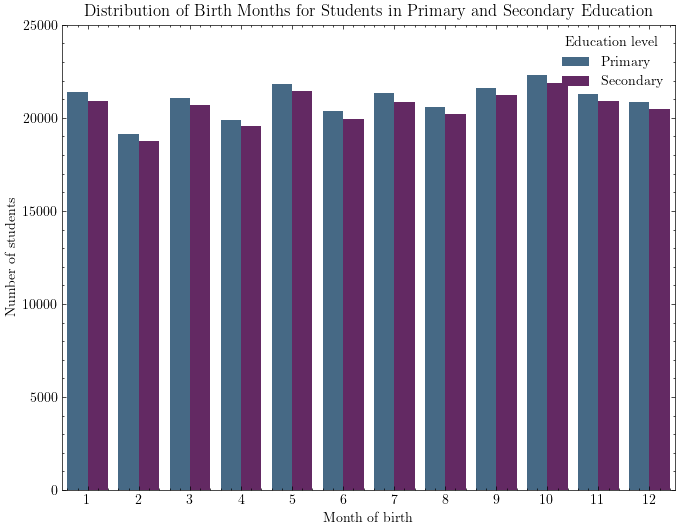

In [7]:
# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_P['snapshot'] = 'Primary'

df_birth_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT']].drop_duplicates()
df_birth_S['snapshot'] = 'Secondary'

# Combine for plotting only
df_birth_months = pd.concat([df_birth_P, df_birth_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(
    df_birth_months['MES_NAIXEMENT'],
    categories=[str(i) for i in range(1, 13)],
    ordered=True
)

# Let the style control figure size, fonts, etc.
fig, ax = plt.subplots()

sns.countplot(
    data=df_birth_months,
    x='MES_NAIXEMENT',
    hue='snapshot',
    ax=ax
)

# Set yrange from 0 to 30000
ax.set_ylim(0, 25000)

ax.set_title('Distribution of Birth Months for Students in Primary and Secondary Education')
ax.set_xlabel('Month of birth')
ax.set_ylabel('Number of students')
ax.legend(title='Education level', labels=['Primary', 'Secondary'],loc='best')

fig.tight_layout()
plt.show()


In [11]:
# ===============================
# Analysis: Primary Education
# ===============================
df_math_P = df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_P['MES_NAIXEMENT'] = pd.Categorical(df_math_P['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_P['snapshot'] = 'Primary'

# Summary statistics for Primary
print("=" * 50)
print("PRIMARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_P)}")
print(f"Mean grade: {df_math_P['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_P['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_P['PMAT'].std():.2f}")
print(f"Min: {df_math_P['PMAT'].min():.2f}")
print(f"Max: {df_math_P['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_P['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_P['PMAT'].quantile(0.75):.2f}")
print()


# ===============================
# Analysis: Secondary Education
# ===============================
df_math_S = df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT']].drop_duplicates(subset='CODI_ALUMNE')
df_math_S['MES_NAIXEMENT'] = pd.Categorical(df_math_S['MES_NAIXEMENT'], 
                                            categories=[str(i) for i in range(1, 13)], ordered=True)
df_math_S['snapshot'] = 'Secondary'

# Summary statistics for Secondary
print("=" * 50)
print("SECONDARY EDUCATION - Mathematics (PMAT)")
print("=" * 50)
print(f"Total students: {len(df_math_S)}")
print(f"Mean grade: {df_math_S['PMAT'].mean():.2f}")
print(f"Median grade: {df_math_S['PMAT'].median():.2f}")
print(f"Std Dev: {df_math_S['PMAT'].std():.2f}")
print(f"Min: {df_math_S['PMAT'].min():.2f}")
print(f"Max: {df_math_S['PMAT'].max():.2f}")
print(f"25th percentile: {df_math_S['PMAT'].quantile(0.25):.2f}")
print(f"75th percentile: {df_math_S['PMAT'].quantile(0.75):.2f}")
print()


# ===============================
# Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
# Combine dataframes for plotting only
df_math_grades = pd.concat([df_math_P, df_math_S], ignore_index=True)

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(df_math_grades['MES_NAIXEMENT'], 
                                                 categories=[str(i) for i in range(1, 13)], ordered=True)


plt.figure(figsize=(10, 5.5))

primary_color = '#1f77b4'  # Blue for Primary
secondary_color = '#ff7f0e'  # Orange for Secondary

# use the defined colors in the plot
sns.violinplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', 
               palette=[primary_color, secondary_color], split=True, inner=None)
sns.boxplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', showcaps=True,
    boxprops={'facecolor':'none', 'zorder':3}, showfliers=False, whiskerprops={'linewidth':2},width=0.25)

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))


plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

PRIMARY EDUCATION - Mathematics (PMAT)
Total students: 251748


TypeError: Could not convert string '62,4452,8356,7285,4670,9564,1057,7670,5371,5782,6176,58100,0049,3179,1090,7985,1397,8686,19100,0079,4376,2583,0193,6493,6494,6890,0871,9665,9367,6887,9476,6591,8376,5885,1593,5786,5080,5365,2973,7781,5771,2655,6891,4392,9358,8678,3955,3581,1859,5785,8677,6874,8376,9652,5062,6884,7554,5771,2668,0775,9297,8654,2494,6866,33100,0079,1073,4075,2156,6588,6479,8168,4189,0492,5395,7185,4693,6480,0774,8177,3558,2288,6484,0588,3179,8386,9085,4671,6588,6468,4786,5089,0497,8697,8680,8765,8481,8868,4789,7584,7558,1355,6184,7550,3581,5787,2177,6871,9678,3988,3189,3597,8673,4678,3977,2984,3691,8382,6866,7286,1791,8397,8659,1795,7195,7185,7996,8285,4677,3561,6583,0171,6592,9357,7686,5760,6155,6896,11100,0083,6581,5784,7596,1174,1187,6052,1079,0372,6782,9980,1677,3581,1872,6796,8258,4656,7256,7278,7279,8367,3788,3173,4082,2889,3588,6468,0764,1888,6480,4784,7573,7163,8568,7895,7177,2962,3749,98100,0057,8276,2557,4261,7182,9965,2980,8787,9449,9888,3186,9078,0893,5785,4679,0382,2868,8780,1479,1077,6869,1173,0974,5078,7274,1197,8689,7585,4685,4680,5388,6494,6869,1156,7274,8379,4352,5057,8260,2163,1576,6561,3161,3191,4970,5390,7961,6557,3673,7190,0882,6156,7287,6083,32100,0092,9391,4957,0982,2889,0475,5490,7969,5188,3178,3975,1483,7273,4061,0085,4682,2880,5386,1783,6575,2182,2257,7675,5472,2978,3970,2274,1161,9669,1868,7875,1456,3996,8292,9372,3681,1892,5371,9056,0168,0766,3382,9257,8275,2194,6865,6278,3378,3983,7268,0777,3551,0873,0782,2275,9454,9790,0870,9292,5365,6083,0185,4687,6067,7470,9296,8268,8592,9396,1165,6281,8857,8296,1164,2558,4679,1083,6597,8674,1170,2268,0742,1872,0397,8646,0781,5789,7568,0779,1064,9680,1482,6182,2882,6183,3878,3975,5481,1883,7283,3265,2997,8679,1265,5365,6067,0375,5247,50100,0068,0788,33100,0081,5775,5483,7283,3295,7150,7579,8371,2693,6472,2974,1182,2866,9759,9097,8685,4652,5068,4792,2262,3576,9667,7497,8696,8254,9181,9076,9657,1156,7283,7256,3252,1283,3253,5489,6868,7293,9784,7584,4296,8258,4654,9776,5886,9050,3583,6584,0391,8358,8684,42100,0063,4659,2657,4272,6793,5758,8052,1068,0785,4696,1192,5366,3380,1479,4376,6580,1474,1169,1881,2466,3354,5781,5759,9675,2180,5381,1890,0880,5380,1496,1195,7189,0478,3380,8771,9663,1557,4272,0374,1171,2682,2273,0967,7464,5883,3257,0375,9482,68100,0081,2459,9068,4771,9680,4775,2159,8888,6465,2961,7191,4969,1891,4983,2589,7568,0766,7279,4384,3679,8167,0366,7071,6570,9292,9368,7869,8884,7572,6065,6285,7996,8259,1973,4090,7952,8397,8685,4692,2282,6890,7953,8782,2878,7277,3553,8780,4778,39100,0084,7579,4392,5370,9280,5378,3374,5066,0082,6177,6853,5490,0893,9787,9484,0358,2271,2684,7578,7270,2290,3954,9777,9968,0759,1777,3579,7663,4691,4956,3978,3377,9984,4264,1868,0786,5790,7989,0486,1096,8263,0695,7186,5767,7496,1173,0776,2560,9278,0253,5490,3988,6468,0791,4997,8664,8749,6550,3577,2966,6469,4988,6469,1884,0553,5453,5471,2378,7269,8881,5770,5385,4671,2690,0889,3590,4582,6869,4965,2992,9393,9768,8047,5080,5382,6151,3993,5791,4975,5485,4049,6586,9071,6385,0657,7662,1197,8658,4670,1572,6980,5391,8369,4957,5168,7874,1165,9362,0474,5075,2156,7253,5483,7269,5168,4753,5493,9781,2492,9370,5374,5097,8697,8661,7154,5793,6453,1459,5073,4693,9770,5565,5380,1479,4386,1768,7874,4263,8562,0454,5788,2580,5381,5778,3993,9779,1074,4484,0386,9094,6867,3781,1871,9678,3997,8675,2156,3455,6180,1483,7290,7983,3274,7570,5564,4978,3980,5352,8973,4086,9093,9773,4663,4694,6873,7159,9678,3973,0757,4297,8658,8672,6753,8750,6993,9775,1478,7285,4056,3986,9067,0386,1778,7970,9275,4587,9467,7479,0366,2489,3568,0780,8791,4981,2654,9190,7964,89100,0056,3289,7569,1184,7574,8369,8282,6155,9965,9382,9968,7278,3966,3351,3958,0969,8279,4369,8267,3790,7981,1870,1561,0083,7286,5767,0380,5377,6875,8582,6887,6093,9759,9678,3957,1186,57100,0080,5397,8680,1483,7281,8865,9352,4370,9276,9696,8282,2881,5782,2883,3256,3262,1193,5786,1990,7990,7990,79100,0076,8980,5352,8396,8284,7595,7158,8662,7563,0886,5084,7552,8396,1152,8380,8779,8396,1174,1161,6576,1887,2158,1569,1869,9168,1480,8779,4379,8358,8066,6476,2566,3377,6057,7681,2474,5057,7682,6180,1464,9669,1176,2583,3283,7297,8685,1389,3571,2655,2856,3297,8676,9662,7596,8254,9779,8381,5778,3971,9091,8381,8858,4664,1890,7988,3390,7979,4385,4682,2893,9787,9483,7268,0777,6855,6185,7997,8670,8676,6589,6895,7171,2679,0381,5787,9472,6993,9762,4279,4383,3889,7565,2985,8693,9774,0490,3968,4768,0792,9377,6883,7277,2976,6569,8853,1487,6076,9890,7978,3979,0383,6590,4574,1165,2285,4672,3666,9768,0778,0879,4378,3981,1881,8897,8690,3980,8759,9090,4589,7576,6580,1475,5480,8480,1475,1476,6555,6179,8377,3556,7258,4651,4670,9254,1866,7252,8396,8280,1467,0376,2596,8279,4397,8656,7257,8251,7970,8682,2869,8280,4797,8660,2182,9245,3684,0556,6576,2571,9667,3774,1172,2985,7977,2977,6880,1478,7087,6065,2982,2263,8558,4660,6169,4963,7954,2080,5370,6171,9693,5783,7254,1857,7671,3280,5376,2584,3683,3853,8792,5395,7154,6470,5968,7873,0789,0457,7671,2679,8388,6455,6853,2066,9770,6189,3581,1859,5059,1763,7964,4997,8689,7570,2286,9078,7252,8385,4686,1768,4181,1889,0491,8370,9571,9646,4696,1167,0369,5792,5368,85100,0073,7760,9480,8759,9064,9667,0351,7987,2168,4164,1268,3861,3182,6170,2273,4092,5369,5149,2565,5383,3256,7266,0084,3677,3554,1846,4675,5483,3272,3683,0182,6179,1066,7092,5385,8670,5982,2854,2483,0174,5086,9076,9669,1182,6158,5382,6180,1468,0177,2958,8682,2888,6454,9785,7980,5373,0094,6877,3596,8284,3695,7179,4380,8475,9266,0090,79100,0053,8791,8352,5281,9760,9485,13100,0069,4973,0780,1467,0383,7290,0879,1075,1474,1173,0093,9781,1869,1179,8366,3390,7970,2291,8390,7969,8256,3991,8354,2469,1197,8684,4281,1869,1892,5387,6078,3962,3770,9258,8685,4681,2468,4758,1380,0792,5379,7690,7959,1976,8967,6884,4254,5779,8392,9381,9096,8294,6889,6867,4396,8290,3975,9489,0477,68100,0084,4267,6179,4385,4093,6491,4957,8265,6090,3976,5875,9470,2269,1885,46100,0093,9776,5869,4972,0388,3169,1874,1196,1175,9481,5785,4681,5790,4559,9697,8691,4967,0386,9082,2880,4767,7487,5484,0359,9085,0694,6887,6080,1452,8381,5792,5390,0866,3386,9096,8268,4769,5185,0678,7069,8882,2889,6879,4359,9056,7268,0785,1385,4689,7596,8286,9061,0076,5895,7189,0468,4568,4784,3683,3259,5773,3868,7870,9256,4184,3675,5287,6089,6883,3293,6485,4080,1473,0797,8687,6088,6477,6890,7993,9771,9679,8379,1089,7596,1189,3590,7974,1162,3581,2461,6567,1083,3288,6472,6782,2894,6867,0385,1387,9493,5770,2281,1890,4566,3381,2482,2870,5369,8259,5778,7994,68100,0085,4692,9379,4368,0789,0489,6876,6561,3181,5744,3272,7682,6190,4594,6852,4385,0687,6046,8084,7579,1077,9386,5076,5867,7677,6877,6271,5780,8753,8794,6885,4669,8264,2583,0168,7888,6469,1184,0589,0496,1177,6858,4696,1192,9380,4789,6867,7663,4660,6191,4990,0896,1196,8294,6864,5264,2565,2271,6394,68100,0090,7976,9893,9784,7591,4993,9770,92100,0080,5374,8365,2986,5787,2196,1182,28100,0084,4283,7283,72100,0079,4397,8679,4377,6879,0371,6396,1164,8991,8376,9652,8972,3682,6170,9266,6667,0365,6093,6491,4990,7980,8775,8567,7480,4752,8386,9092,9362,7570,2292,5391,8382,6196,1190,0884,0392,9389,6880,8779,4375,5483,3264,5866,6678,3979,4364,5871,9686,5779,1268,4757,7697,8682,6193,9780,1472,6787,5452,1083,7267,6868,4150,6987,6068,8073,8052,8382,2885,0681,5772,3686,1770,8661,0065,6097,8680,5364,8960,9458,9265,9390,4595,7167,7458,4685,4659,9067,9992,9377,6878,7297,8682,2881,9089,3582,6187,9486,9085,4679,4381,2492,5385,7974,8193,9792,9384,0382,9981,5791,4985,0666,7076,9659,9693,6489,7569,8886,1976,2573,4686,1788,2581,2479,4390,7977,6694,6873,7154,9771,3289,6896,8290,4574,8169,8292,9360,5492,2290,7992,5392,9348,2178,3990,0880,0756,72100,0091,8384,7582,2278,4170,2282,9981,5789,6877,3590,7982,6184,0370,1396,1181,1889,0484,3668,8081,1863,8577,9956,7285,4677,6880,4791,8383,3266,3379,0368,07100,0086,9085,8667,7470,2282,2870,2282,6194,6891,4974,8186,9084,4271,9658,4669,8497,8671,9654,5758,1368,4787,6063,7977,3583,3280,1497,8669,1883,7291,4367,0368,0785,0685,4085,4662,3596,8287,2190,7989,3594,6890,7991,8367,0390,7974,5070,9296,8282,6193,9796,8287,6084,3676,6581,1866,3366,70100,0079,4384,3653,9379,1087,2183,3278,0892,5384,7581,5780,8781,5790,7976,9694,6891,4980,1469,8288,6477,3579,4356,3990,0876,18100,0074,1781,2481,1860,6178,7082,2886,5792,9365,6078,0256,3977,2989,0474,5076,9679,1084,0386,9086,5086,9092,5356,0197,8690,7984,4281,5788,3167,0390,4572,6766,3356,7286,1977,6877,6850,6978,0679,1087,6081,5778,3991,4990,7984,0567,0367,0668,78100,0091,4991,8369,8288,3177,3582,6183,3280,8796,1197,8675,14100,0095,7169,8295,7183,0167,0394,6867,7468,4796,1188,6494,6887,6084,4276,2570,5395,7174,1192,5392,2270,9289,7552,1289,0453,8781,5779,8373,0769,8282,9275,6188,6469,8267,3759,8379,8383,2590,0885,4688,6477,3579,8377,9981,5785,4690,0864,5669,4983,3288,3185,4685,1571,3284,03100,0072,3663,1567,7680,4753,2397,8668,7884,3682,6161,7173,0781,5753,8582,6194,6867,7494,6896,1190,0880,8480,8776,2587,6059,5756,7869,1896,8283,6589,7591,8371,6387,6086,9086,5784,7555,3062,7567,0369,1870,8661,0088,3197,8693,5774,5071,9674,1158,8697,8683,6581,8880,1467,3768,0779,4989,3579,7484,4291,4979,8372,6797,8690,3952,5068,4771,3276,2596,1168,0786,1779,7691,8370,9571,3293,9783,3281,8869,5189,6868,38100,0091,8377,2968,7886,5090,0885,4682,6851,0884,7574,9065,2980,8777,3586,9097,8680,5390,0861,6569,8293,9783,3276,5890,7992,9391,4979,43100,0063,1562,0270,9270,2283,72100,0081,2685,0680,5378,3997,8659,5989,3559,5069,8287,6071,2686,1997,8686,9083,6584,4295,7187,6069,1883,2571,3275,8766,2684,7572,0378,7290,7993,5758,8096,1167,3760,2788,3191,4993,6468,78100,0085,1573,7193,9764,8986,1980,1675,9466,2693,9789,7567,4353,4786,1783,7283,3288,2592,2285,0690,3981,2459,5056,3296,1175,1481,9776,9691,49100,0063,39100,0085,4684,4272,0574,8384,7596,1191,4389,3585,4689,0465,6066,0066,7288,6487,9474,1164,2582,6190,3988,6482,6168,7893,6469,1187,6067,0366,3379,1078,7759,5085,4663,7979,8361,6574,5092,9392,5369,1873,0762,0284,7568,7873,0761,0090,7977,3587,6058,4685,0670,2296,1180,0770,9984,7593,9777,6871,2697,8665,2988,3171,5976,6578,3988,6494,6883,0174,50100,0092,5359,9067,4390,7986,9067,6865,6096,8297,8679,8380,1666,7086,5777,6291,8355,6896,8249,9670,9285,1592,5384,4280,1477,6880,1457,7680,5373,0092,5374,8194,6886,9070,5387,5478,7290,7960,2183,3286,5097,8682,2268,4778,7269,1187,2152,8391,8378,7283,7291,8380,1692,5396,1175,8777,6876,6566,9776,6570,2268,7876,6273,4087,6056,7875,5497,8682,2890,0868,4765,9361,5885,4693,6490,7976,1879,1096,8263,8587,2190,0881,5766,2696,8270,6189,6861,3881,9781,5776,8986,9097,8690,4580,8773,7756,6568,1497,8692,2287,6075,9456,3287,2764,8369,5165,2288,3189,7586,1784,0590,45100,0086,9074,8166,26100,00100,0090,0896,1195,7176,2773,4067,3756,7874,5075,8558,4696,1188,6460,2793,5790,0882,9981,5778,3368,4180,5372,6786,9071,9684,0590,7952,8389,3569,8295,7179,4969,1862,0492,9387,6049,0068,7864,5889,6872,3657,7670,2284,0379,8385,8676,2568,1457,1167,7470,2459,9679,4393,9766,0086,9087,6068,4762,0288,6481,8892,5384,3656,7289,3563,4682,6158,8084,0386,5759,1768,7874,7579,1090,7979,4982,2886,9069,8887,9488,6479,1056,0195,7166,7076,2560,6164,5677,3581,5797,8696,8284,7581,8857,8271,6390,7992,5378,0672,67100,0083,3268,0777,6881,5756,0167,3752,8982,6867,7469,8269,8270,5597,8682,2880,1484,3685,8687,6083,3268,0792,9370,9267,7489,6877,3590,0878,7281,5156,0180,1667,0396,8280,1466,3351,0659,90100,0090,7992,5384,3678,3976,2554,5765,5688,2554,9756,7261,3184,0384,4276,6585,7977,6879,8356,7276,2578,7967,0371,3274,3590,0874,1177,6887,9480,4790,4559,1783,7267,4384,7593,9797,8667,3785,4675,5475,2182,6172,6782,6876,9689,6889,6883,3285,4693,9786,5061,9692,9359,9669,1875,5476,9667,6876,5881,9786,9067,0373,0791,8379,1094,6873,0777,6891,4974,5081,9558,8057,7665,2983,3255,6870,2297,8681,5786,1765,2990,7989,0497,8689,0484,3674,8385,4073,7789,7568,0762,0491,8368,0780,5380,8794,6879,1057,7670,9987,6068,7880,5370,6175,8576,9674,8192,9352,8386,1762,0449,9889,35100,0079,7656,4187,6074,4493,6462,7570,9269,1889,6889,7576,9695,7176,6588,3177,2987,9487,5476,9679,1079,4391,8373,0064,2557,1173,4078,3980,1478,7277,2983,3284,0390,3967,3489,6892,5378,7284,4295,7173,8069,9186,5087,2182,9963,8790,7980,4783,3270,9287,2195,7156,0162,7561,0059,90100,0078,7958,8070,8677,6896,1185,4667,1076,6573,7185,8669,8852,8377,6881,5749,6588,6458,1574,50100,0076,2580,8780,8776,2574,5087,6082,6190,0891,8385,4661,6557,8288,3185,4675,21100,0062,7583,9690,7948,9483,7281,9078,3378,0294,6873,0089,6859,9658,7781,9788,6465,9376,2586,5756,7270,1562,0469,9164,2573,8097,8657,1863,8582,6866,7282,2867,7661,7154,5778,7273,4685,4683,0184,7592,9396,1166,0083,01100,0082,2291,4990,7959,19100,0070,9289,6883,3285,4685,4684,75100,0077,6879,8187,6068,0779,1091,4976,9694,68100,0077,6879,4385,4671,6579,8386,1968,7890,0867,3789,6897,8685,4685,1350,6984,0395,7181,5767,3781,9090,7970,2269,1874,8879,1070,9251,7765,6691,4986,9057,4286,9095,7152,8377,3578,7062,7588,3197,8685,7970,8679,7686,5760,6782,2864,8980,87100,0080,1467,3770,9288,6460,3087,5462,7592,5393,9769,1177,6876,9666,2468,0774,5071,9661,7186,9066,3387,60100,0083,6586,5061,7171,9679,1076,9694,6892,5378,7957,4287,6088,3177,6287,2161,7160,6164,8991,4380,8751,7957,0993,9776,1852,4364,8970,9254,5780,1486,1959,9686,5092,5379,8159,9690,7989,0475,1479,8377,6878,3962,7590,7972,3467,0397,8685,8654,9767,0362,0486,9081,9581,5785,8676,9674,1196,1172,0376,5677,3563,4676,6580,1463,1573,7162,4477,9961,9877,6886,5093,6479,3765,2273,3182,9981,5778,3980,1470,2889,7596,8263,1593,5772,2972,36100,0087,2168,3876,6567,0375,1472,7390,0882,2881,5780,1494,6889,6879,1079,4397,8668,8569,49100,0089,6869,1870,8668,0780,5362,7585,7965,2064,5678,7286,5087,6084,7571,2679,8169,8282,6187,5468,1497,8679,4376,1896,1193,9791,4982,3084,7576,2580,1492,5387,5485,8660,6177,9948,5461,71100,0081,9074,1159,9688,6483,3290,4573,0773,4676,2578,3985,0691,49100,0087,9487,6066,3383,7283,6552,1278,3369,1888,31100,0089,6871,9654,6469,8865,2981,1890,7981,5791,4988,6489,6890,4585,8669,1860,2364,1891,8345,3685,1391,4953,5480,8784,4264,9690,3975,9468,7868,7864,9684,7596,1154,5768,1478,3988,64100,0067,3783,7267,7469,1862,1774,1161,0080,8768,7864,5681,5791,4388,3173,4690,7962,0480,4778,7087,6088,3175,1477,2977,2970,2264,1693,9770,1582,2290,0870,1579,1063,4692,9396,8266,6479,8381,97100,0059,8388,6482,2887,5478,3984,7596,1190,7976,2578,3968,7872,2977,2990,0885,4064,8373,7155,6884,4280,1474,1160,2781,5780,1479,0369,4281,9088,6473,0786,5080,4775,2163,4654,9784,7567,3783,3295,7177,3569,1178,3386,5092,9376,9675,2161,7180,4790,7969,4982,2856,3279,8366,3377,6863,1587,5476,6566,0085,8671,6373,7174,5083,7290,0881,8890,7993,9780,4793,9783,0176,6575,5467,0396,8258,46100,0076,8987,6057,4960,6755,6873,4069,5168,1456,6579,4357,4296,8272,6771,6563,4672,3688,3187,6062,4466,0062,7580,5383,7293,6459,2676,9673,4077,6892,5384,3658,1582,2870,2275,2361,6560,2791,8386,9089,6883,0158,13100,0080,8475,2180,1458,2270,2269,4997,8661,0094,6884,0562,0471,9685,4682,6192,5371,2649,6565,9382,9293,6479,4371,2680,5379,7485,8679,1068,3893,5788,6486,1786,5774,1179,7659,9658,4662,4277,2986,9096,8261,6556,3980,1477,6894,6886,9075,8590,0897,8695,7164,1695,7187,6096,1190,0886,5075,8590,0869,1170,2297,8696,8288,3194,6878,3984,7574,1169,8864,1856,7268,0775,8566,0082,6193,9779,0378,3992,5377,9984,4279,8197,8685,4664,1875,1469,8280,8479,1085,4061,7176,1863,1590,7993,9757,7675,5479,4358,8679,4358,8077,2964,5690,7988,6462,3596,1179,4355,9992,9394,6861,3168,7892,9358,5380,8776,2587,5491,4365,2987,9467,1081,5763,7964,5279,4390,4556,3987,5479,4386,1769,8892,9379,8370,1559,9080,5384,4277,2980,8465,9366,3384,4276,3179,4361,3184,7568,1472,7676,6576,2585,4684,7569,1190,7980,8478,3968,0787,5483,3283,3283,7294,6876,9871,9673,0787,2192,5381,1893,9793,9769,1168,0769,1191,4982,2885,0679,4384,4266,3378,7767,0367,0383,3284,7581,1874,5097,8660,3082,6182,6168,1461,0055,2865,6074,4472,3687,6086,90100,0077,2990,3988,6481,9569,1897,8676,6563,7967,0352,8388,6481,1885,7954,5771,9669,1875,1482,9961,7194,6877,6897,8681,1880,4770,2280,8451,7267,3797,8689,3589,0481,5784,3687,6068,0783,7274,1184,4276,6552,4382,6156,7275,2167,0371,6595,7168,0751,7955,2882,2884,3678,7273,0093,9781,5783,3297,8654,9767,0363,7980,8777,2981,2474,8167,8164,96100,0082,2268,8080,4790,7969,18100,00100,0070,5386,5090,7997,8653,5460,6192,5381,1883,3261,3859,5754,5784,4257,4269,8293,6479,4397,8690,7980,8771,2681,5767,0373,8060,3097,8669,1867,7689,3562,0469,8271,6378,3966,7284,4264,1091,4978,3984,0571,3290,79100,0057,1194,6896,1168,0791,4970,9270,8692,9374,8181,2471,3281,1864,5859,5770,9275,6173,8059,9665,6073,0794,6881,57100,0067,0385,4681,9082,6175,1488,6481,5160,1494,6872,6977,2964,8980,5354,5794,6874,5072,6788,3168,7857,4283,0153,2060,6780,5396,1196,8288,3176,2588,6492,9362,8464,2584,4273,4686,9086,1781,9784,0971,6581,5762,3579,4368,4177,6287,6066,7270,9282,6171,9082,2886,5085,8666,2489,3595,7165,9362,3563,8576,2581,9751,7971,2679,4978,3982,2872,6968,8562,0495,7173,4669,5792,9350,3588,3181,5167,0394,6897,8665,6289,7593,6458,5378,3989,7565,2290,7981,5777,3594,6852,1060,9457,0380,1457,82100,0086,5768,4577,6869,8256,3275,6171,9689,7583,3876,2779,1090,0890,0893,9770,6181,1880,4776,9897,8695,7184,0378,3983,7287,6084,0374,5082,2878,3979,1068,8568,7869,1879,7497,8674,4458,2289,3565,6059,9078,3977,2966,0085,4658,8681,5782,6193,5791,4987,6075,1487,6085,4684,3692,5368,0781,1875,8584,0358,4693,6496,8283,7276,9692,9370,9258,2262,04100,0086,1796,8274,1181,1858,4679,8388,6473,8089,0480,5363,5472,9490,4596,8290,7974,1180,4790,7977,9968,7873,0049,2590,79100,0065,9379,4997,8679,1091,4976,6585,8665,5358,4692,5364,9665,6067,7461,0066,3360,6179,43100,0076,2574,1182,9970,9562,3563,7972,3675,9470,5593,9766,2463,1558,8697,8676,2573,4682,2867,3758,4656,7273,0773,0767,7478,3989,3586,9082,2890,7963,0869,8267,4359,1797,8681,5770,2273,0786,5750,6962,5090,7970,9287,6086,9096,1183,0192,5379,4396,1186,5774,7590,3981,1897,8696,8273,8080,1470,2286,9081,5760,2764,8396,1189,0485,4696,1175,5454,5752,4365,9387,6066,9773,7190,7989,6890,7982,6184,4282,2895,7181,9084,7580,5378,0287,2184,3679,8386,5091,8385,4682,2855,3067,3474,5076,6574,1192,5384,7585,0679,7669,1195,7187,6074,1166,0090,7978,3386,50100,0083,3257,8286,9079,7685,7962,75100,0046,8068,0776,5881,2470,9281,2482,6167,7456,7259,2685,4668,4783,7283,3296,8282,2879,4381,1891,4979,8363,7965,2979,4379,7667,0378,7096,1189,6879,4392,5379,7680,1462,2954,2467,0381,5780,8792,2270,9263,4677,6894,6856,7269,8257,1184,0384,3684,0572,3682,2886,5068,1467,0377,3596,8290,7970,8694,6875,5489,0477,6886,1977,3576,2594,6897,8676,9679,1056,0174,8192,9375,9280,5369,5168,7858,4683,7258,8681,2482,6192,2259,8886,9089,6855,3059,5093,9777,9982,2897,8687,6053,8570,9280,5396,1181,5779,4388,2590,7969,8270,6169,8864,5886,9081,5777,6877,2983,0197,8674,8167,7477,2986,1789,3583,7291,4989,7586,1791,8383,3874,5058,0992,53100,0062,7583,3280,4788,3186,9084,0563,7982,2893,9777,6876,6576,2588,6471,3284,7593,5762,7591,8393,9768,7870,8679,1088,3178,3366,3367,7484,0591,4981,2484,3668,0776,2770,2893,6485,4682,2851,3986,9085,4679,4370,2277,6878,7279,8375,2178,7274,8196,8258,0987,6083,7278,7293,6491,49100,0089,0470,9268,0753,2371,3278,3958,2296,8267,0377,9965,2990,3976,9672,2980,1475,5478,7081,5775,6170,5965,9583,6574,1180,4781,1879,4395,7180,8475,2157,4292,9381,5171,2693,5766,6467,3485,0663,8570,2870,5392,9368,1468,7884,0381,2491,8359,9091,4982,2887,6065,9365,5359,2680,5389,0470,9272,6091,8359,9054,9794,6871,9686,9090,7987,6068,4170,8683,0192,9395,7178,7268,0757,1166,6487,6088,3151,3996,8289,6889,3560,6163,8589,7586,5753,5479,8355,3078,0296,8274,1183,7257,8284,0590,4559,2481,1877,2997,8681,2477,3576,2552,1283,72100,0059,9084,4264,2574,5096,8274,5058,1557,1155,3791,8389,7570,2268,7857,7676,2574,8176,2596,8290,7997,8670,2263,1589,6875,2162,0485,8671,3288,6482,6897,8662,0487,2179,8380,1457,8292,9349,3184,0382,2863,0869,1176,2586,5081,1856,0173,4076,2572,3677,6654,6654,2451,7262,4251,7964,4971,6373,0776,9684,4292,9393,9766,3358,5376,9695,7175,5469,1877,9984,7592,9379,4370,1594,6880,8478,0690,0887,6074,5079,4369,1869,1878,3989,0472,0372,3690,7989,3578,7962,0480,84100,0088,2594,6897,8685,8689,6856,7280,5395,7178,7975,6194,6890,0880,1452,1270,2291,4389,3564,4980,1688,3170,1997,8673,0768,4794,6881,9088,6466,0068,1459,9657,4283,3284,4266,0072,2979,4387,9474,5061,7183,3273,8083,3277,6868,4582,3075,5481,5783,7290,0852,8388,6479,4362,3579,0361,7178,7285,4690,7980,1487,6079,4383,7286,1983,3295,7180,1482,6177,3584,0589,7594,6875,2179,4381,1872,2767,3792,2281,1891,4968,7853,5481,5774,4451,7996,8270,8663,1585,0079,1268,0787,6079,4367,7689,7564,1075,8554,5785,0692,5376,9882,6175,2188,6479,1067,7460,6781,8292,9370,6170,9292,9380,5369,8288,6479,8396,1189,7575,5490,7960,9481,8882,2294,6865,2959,5080,1485,8683,0160,3085,8656,7264,5884,4269,8288,3178,3982,6183,7283,7288,6496,8281,9069,1883,7291,4988,6491,8372,3666,7091,4955,3592,9388,6477,3575,92100,0056,7260,2792,5378,3360,3084,7574,5067,3787,2181,5787,6086,5783,7269,1180,8468,7886,1753,5470,8689,0478,0671,2684,4281,5768,1492,2256,3283,7294,6887,6083,0194,6887,9494,6865,2985,8689,0497,8680,5355,6162,9951,7963,7968,7881,2476,25100,0095,7170,9296,1194,6867,3779,8357,4284,4248,9488,3179,8186,5080,7887,6086,5091,8367,4387,6063,1570,2283,01100,0093,5789,3586,1763,7968,8577,2990,7963,8585,4655,2878,7265,2963,1591,8376,2597,8670,5359,1753,8778,3981,5782,6154,26100,0068,4590,3953,8754,9780,1456,3967,3765,9374,1189,6890,7958,8480,8756,7265,2275,5475,8562,7555,6183,3282,6181,8891,4982,9984,4295,7188,3169,8263,8563,8779,4380,8466,0079,7666,7070,2272,6786,5781,1892,5387,2187,2171,9681,1882,6175,5488,6465,2963,3994,6864,8975,9478,3389,0484,4284,7582,6196,8293,6466,6466,3385,1597,8670,9557,7680,1462,0478,0696,1188,6484,4285,4665,2981,1883,3286,9060,2784,7588,6471,2686,1786,9056,7260,6181,2478,7280,1479,4366,6485,4662,8182,2884,7578,3997,8693,9784,4290,7985,1364,5689,3593,5773,4649,0059,5080,4768,7880,1486,1980,1470,2260,30100,0065,6096,8286,5790,0876,6257,42100,0083,3266,0086,5069,1184,3695,7178,0276,9662,8174,1182,2887,9489,7567,4369,2074,8378,3979,8169,5777,2990,0872,0349,6578,7251,7968,0796,8276,2578,3366,00100,0069,5182,9972,6787,6073,4660,2770,9979,8367,0390,7968,7896,1166,0093,9780,5383,3287,6096,1174,8373,8093,9779,8179,0374,8176,8990,7953,5453,5457,0581,9081,1893,6496,8257,1159,2686,1787,60100,0085,4679,3785,7965,2977,6868,4566,3356,0185,15100,0082,9976,9688,3180,8774,1181,5786,1765,6261,6572,6777,6886,5778,0690,4550,7593,9776,2585,0677,6889,7580,8790,0874,1156,0890,7993,9778,3958,9280,1493,9791,4392,9395,7194,6873,0783,3284,3692,2287,9482,6183,7252,1263,4677,6881,5776,2588,3382,6187,9473,4092,2274,5069,1145,3668,4758,1573,7188,3165,6078,3974,1149,6593,9786,9087,6088,3388,3185,4678,3983,7267,0377,6895,7154,5762,0468,7870,9281,57100,0095,7186,1961,7186,50100,0073,0779,8396,8283,6568,4760,3678,3957,0591,4984,3668,7889,3581,5791,4993,6493,6477,6892,5394,6858,4092,9383,6592,9394,6870,9279,4382,2862,7567,7495,7180,5373,7192,9359,5087,6082,2869,1163,8577,9981,8855,6184,4272,3681,5768,0767,4389,7559,1985,0683,7292,5392,2289,7582,2874,9096,8268,7852,5065,2972,3683,7287,5497,8680,8493,9750,6966,3379,83100,0094,6886,5067,4382,6876,65100,0086,5774,9063,4680,1486,5091,4986,5079,4386,5074,7551,7974,8178,3982,2884,7559,9081,5780,1692,5381,2491,8379,4378,3977,3558,1377,6874,5072,6784,0358,8087,2189,3553,2055,2892,5356,3979,4356,7297,8696,8282,2897,8691,8380,8773,8080,8481,2481,1876,5886,5775,5490,7968,0797,8696,1176,5884,4292,2278,3977,6885,4692,9386,5780,1476,9683,3288,2576,9887,1489,7580,8767,4377,68100,0086,5775,1481,1878,72100,0086,5084,3668,0791,8372,6769,4991,4374,5084,4276,9896,8287,6083,3256,3967,4155,2883,6576,2597,8671,9659,9094,6885,4671,6368,4770,9292,2289,7588,6485,8678,7988,3196,8280,1651,7974,1783,3254,9763,1594,6865,2990,7960,6181,18100,0096,1163,0876,9654,9794,6886,5086,1797,8687,5451,3980,1461,3191,4978,3966,3383,3251,3990,0887,2180,1488,6474,5068,1454,6481,1874,8372,3680,4794,6884,3654,5778,7275,2180,5381,1891,8376,6593,9792,9374,8379,0373,0797,8687,9460,6197,8666,9783,3287,2155,6868,0758,5354,9771,96100,0070,9270,6190,7958,4678,3368,0778,3972,0352,8378,7095,7152,4391,4974,1974,1151,3984,4290,7986,5075,2170,6181,2476,6585,4682,2895,7196,1180,1461,3392,5381,5781,5782,9964,5682,9952,8370,2244,3267,0377,6873,7155,7461,6574,1171,6395,7176,96100,0065,2967,7683,7280,8769,5153,6076,9689,7578,3978,70100,0062,8181,8871,7271,6386,5797,8696,8281,9780,8464,8956,7254,5793,9788,3184,7597,8674,1179,8383,0177,9967,0375,1496,8284,7559,5767,7690,7977,6895,7177,6864,5689,7569,8279,1086,1992,5388,6489,7567,0380,1471,9693,6477,6881,5793,9779,4370,2286,5771,3284,7589,0469,8896,1182,6158,8660,2162,4272,2969,1196,1173,7765,9366,6469,1858,8672,6993,9767,3497,8668,0756,3279,4359,5772,3676,2552,8988,6497,8681,5765,9380,14100,0089,6882,2890,0869,8264,18100,0070,9296,1173,0777,3570,1579,4386,1792,9366,0062,0462,7573,0776,9680,5354,9767,7472,7376,2562,7566,6463,9276,2590,0869,5159,2691,4991,8358,8679,1268,4756,3257,3680,8485,8683,7259,9092,5369,8869,1887,6073,0780,5366,3387,6086,1764,9682,2889,3597,8669,8281,2497,8688,6469,8459,9091,4960,9282,2888,6495,7192,2268,4590,7983,7256,0865,5368,7884,3660,2163,1593,6482,9273,7764,4991,4967,0397,8656,0167,0381,1888,3384,4280,5381,1880,4757,8090,7993,6482,2869,8280,4786,1079,1260,6782,2276,2557,0555,6194,6887,6069,8281,2676,6558,1594,6868,7870,2287,2183,3269,8274,5088,6452,8383,3269,1887,2180,1679,8373,8094,6880,4782,2869,8277,6894,6885,4658,8657,4293,64100,0060,2385,4694,6888,3169,5193,9778,3993,5794,6885,8667,0378,7278,7285,1390,7982,2270,2667,6892,9372,0389,6883,3285,8660,6172,2989,0452,8373,0760,6191,4992,5383,3874,1188,6472,6980,1470,2272,6766,2458,8696,8276,6589,3556,7264,1069,1868,0786,19100,0079,4371,2667,7474,8192,9364,2564,4979,8193,9780,5368,0789,0481,2681,5780,1457,1191,4993,9768,8577,6887,9487,9483,0185,7978,7278,72100,0075,8595,7177,2977,3588,6466,3395,7190,3995,7196,8292,53100,0094,6858,1590,7992,5387,6081,2463,8561,0071,2397,8673,40100,0088,6497,8687,60100,0092,9385,4672,3673,0773,0081,2468,4752,4373,7779,4369,8263,8569,8868,7868,1485,4680,1476,6590,7982,2883,7261,4078,3996,1171,6579,1091,8391,4976,6582,68100,0094,6852,1985,1397,8648,5493,9788,6471,6377,2969,8867,7454,5777,3569,49100,0083,3286,9075,5455,2890,7992,5394,6854,6480,1687,6069,1868,0783,0169,8288,6474,5087,6096,8279,1078,7281,2476,5883,6596,1181,5775,5496,1197,8673,8082,6175,2176,9679,4364,5670,2276,2582,9965,9385,4689,7595,7151,7264,4953,4780,1459,1783,7282,2289,0492,2290,7961,0074,1157,7687,6089,3590,0895,7174,5082,6189,7552,8393,9790,0856,3287,6087,9481,2480,8792,2282,6165,2092,5374,4494,6881,9080,8780,4769,8273,0796,1195,7188,3194,6867,6889,7568,0769,1167,6875,1477,9991,4964,8356,6578,3975,2185,8685,0687,9479,8348,2179,1087,6079,4380,1486,1973,0763,4658,4681,5777,6883,3279,1267,6884,3681,8865,6684,0362,7586,9097,8693,6484,0363,7954,6462,4497,8684,7578,3993,5782,6159,50100,0090,0882,2889,3593,6485,4673,4094,6857,4290,7971,9657,8281,5754,9796,8280,1456,7293,9765,9381,8869,4291,8390,3986,1767,3494,6855,6171,6586,5779,8384,7581,1859,1778,0283,6590,7971,9692,2273,4060,6185,8653,2062,7595,7181,5775,5467,6855,6881,5768,7881,2486,5078,0675,85100,0051,3990,4568,0766,3168,4179,8358,1371,2663,0877,3580,1489,7565,2972,6779,4387,9455,3588,3177,9979,1054,5788,6459,5774,0484,4278,3381,5794,6868,4783,3296,8269,1885,7951,7271,3273,7779,4365,6287,2189,7589,3590,79100,0095,7183,3263,0881,8857,7693,9776,9873,0981,8894,6879,4985,4693,5778,3960,9479,1082,2889,3566,6696,8270,9284,4287,9497,8690,7993,9788,3182,6152,8366,9781,1895,7181,2467,0390,7967,0374,0482,2877,2972,2979,7679,7697,8693,9765,2982,2885,1587,2197,8672,6759,9669,8257,1157,7666,3367,0378,3978,7995,7197,8687,6089,3559,5793,9776,5866,3382,6169,8270,6181,5781,1886,5077,6881,1869,1168,0773,0983,7253,5474,8395,7170,5370,9296,8259,5761,6573,0780,1496,8297,8694,6891,4954,5779,7671,3266,6685,0672,3680,4793,9743,6172,0594,6858,8081,1850,6972,2974,1153,9374,4496,1180,5372,6765,2076,6578,3968,7888,6482,2870,6185,1367,37100,0067,7654,97100,0074,5073,0776,3196,8296,8259,9665,6068,4757,4281,8882,9291,8357,8277,2983,3275,2177,2987,9497,8685,4080,8470,2297,8681,1860,6171,2669,8276,8968,07100,0078,3982,2860,2397,8678,3974,4455,2885,4686,5062,8158,8688,6490,4587,6072,3652,8359,5759,5790,7983,0186,9068,4773,7781,8876,6567,3762,2991,4977,6863,1588,6488,6459,5091,4971,2668,7861,7192,9386,5090,0881,2462,0481,2458,4683,0190,7984,0387,6087,2186,1788,3174,5097,8681,9094,6855,2874,1168,7883,9695,7179,8380,5390,7986,5082,6182,2297,8686,5096,8288,3182,6196,1182,6189,3589,3589,2978,3974,8373,4083,3296,8291,4964,1851,4681,5159,1797,8687,2169,8287,6077,9987,6086,9090,7983,0177,2991,8369,1193,9775,9483,7295,7193,9797,8688,6455,6178,7274,1194,6888,6491,4959,2459,9076,5680,1455,6897,8693,6481,2492,5379,1096,1169,8273,0060,5482,2880,8488,6483,3275,5473,0087,6074,5073,3896,8285,0697,8667,0397,8691,4363,1592,2297,8688,6469,8296,8293,9792,5389,0481,9783,6586,5789,3596,8294,6878,0679,4390,7996,8273,0790,3977,3597,86100,0080,8480,5392,9375,2196,8297,8674,5095,7192,9397,8696,8292,9382,6170,9272,0396,8269,1880,4790,3957,1159,9662,8197,8658,8653,5472,6774,1184,7576,6590,7946,0788,3171,2686,1797,8678,3996,8260,6793,9756,7282,2877,6095,7166,0085,7993,9786,1755,9581,5771,9660,3063,7771,3257,1188,6473,0089,3582,2270,2269,8267,0387,6084,7590,7978,7782,9986,1780,1459,5066,9787,6062,7592,9370,9252,1053,8779,1089,7594,6886,1768,0769,8281,2479,4381,1891,8360,9469,8887,2196,1173,0778,3966,2492,5367,0369,8284,4274,1164,9682,2891,4976,8981,5769,4969,5164,5679,4383,3292,9384,7555,9978,0679,4382,6880,8454,9785,4671,9691,8373,0769,1858,8068,4190,7955,2883,3276,9679,1066,2493,9786,1775,9459,9054,9777,2986,90100,0056,3967,3770,6184,0358,4669,1878,7260,94100,0089,7570,9263,4689,6872,6779,1074,4867,0381,2474,4473,4075,4566,6484,7570,5352,4391,4979,4389,3556,7267,0378,3997,8693,9757,7690,0868,0772,0368,0762,7574,8182,2875,1460,2397,8687,6078,3996,8291,4371,3277,9954,2688,6492,93100,00100,0071,3067,3756,3287,6087,6061,7182,2883,3281,5782,6880,5362,8487,5490,3983,0192,9397,8669,4969,8283,0167,0367,0381,5793,6492,9385,7990,3997,86100,0055,6892,9379,1078,3968,7292,9379,4369,0958,8686,9093,9764,2579,0380,1453,8778,3970,9264,9684,0391,8353,1681,1871,9681,2462,35100,0067,3775,2177,29100,0067,7478,0676,2582,6181,2496,8283,3274,9074,4268,7291,8355,6860,6193,5758,1581,1885,4676,5861,7185,4659,5087,6070,9274,8197,8680,5360,6188,6483,7263,4694,6891,8396,8287,2155,2886,5089,7587,6065,6077,6878,3981,5777,6883,7267,3784,0961,6557,7660,3054,5762,8179,4381,1890,0862,7582,9981,9591,4984,7594,6889,35100,0076,6581,1859,9063,7967,3785,46100,0069,1896,1186,9070,2280,5389,35100,0086,5762,7578,3980,1693,9782,2862,6896,8279,4973,4097,8677,9989,68100,0065,6091,4993,6469,8292,5377,2987,6081,1879,8393,97100,0083,9659,5794,6880,8782,2885,0694,6883,32100,0052,8383,0167,3796,8291,4984,0570,2267,0359,5085,0680,5354,5788,3181,5785,0659,1973,7163,4655,6884,3660,9470,9271,3284,7581,2475,2184,0568,0782,6168,4778,3993,6485,4662,4473,4076,2581,9084,0390,4578,3970,1555,6881,2482,6861,7180,5381,9093,9789,7576,8964,1884,7576,9868,0783,0175,5468,4790,0860,6169,8290,7979,4384,3662,1168,7891,8374,8177,6881,5754,5791,8393,5761,0052,8379,1072,9492,9396,8259,9092,5368,7864,4980,8796,1181,9087,6077,6874,8180,8475,21100,0075,1485,4680,1466,3162,1189,3569,8884,0389,6855,2883,3292,53100,0072,6782,2269,8884,3658,7774,5081,5783,3279,12100,0065,9352,8367,0394,6897,8685,4656,3268,0764,8958,4692,5381,1890,7980,5363,8580,5375,2197,8688,6477,9988,3165,29100,0069,8256,3981,5793,5788,6493,9779,43100,0091,4978,3984,0584,7568,1680,8780,1470,9284,3689,7590,7976,9859,5996,8279,3796,8248,54100,00100,0096,1191,4953,8771,9083,7281,2456,4766,3389,0481,9080,5384,4279,0366,3383,3289,3559,2673,77100,0093,6488,64100,0085,4676,5656,3271,9686,1767,7493,6471,6578,9767,0375,4880,4789,7569,8879,8360,9455,6171,6565,2084,4272,03100,0094,6859,9071,5787,2195,7183,3273,0796,1196,1187,2785,7983,0163,8587,6081,5781,2490,7985,4686,1982,9979,1082,2880,5396,1182,9982,6179,8352,1289,3593,9797,8671,32100,0076,2575,2369,8287,9492,2260,6180,8496,82100,0095,7177,6695,7192,9388,6483,7293,9772,3680,1492,93100,0075,5480,4791,4993,5797,8656,3255,2888,3178,0294,6868,4576,2559,9081,5779,7494,6879,4356,0183,3268,7867,0366,0066,9750,6987,6054,5777,6879,4382,6183,6553,5454,5777,6284,4249,6579,4382,61100,0078,0268,0786,1764,2587,6055,3579,7697,8662,3586,5766,3365,6262,7569,4996,8284,4290,4559,9083,7258,1358,8689,7583,3260,6781,9054,5776,2579,4359,9051,0859,5051,3957,4587,2192,2259,9083,3272,6760,2768,0771,2688,3168,7860,6179,8169,1168,0769,1881,5759,90100,0053,8752,8356,7282,6873,7154,9764,1285,4666,0089,7562,5067,0380,4776,9689,3562,3591,8377,2976,5880,8468,7897,8656,0166,3361,0093,9780,8791,4981,1896,1191,4982,6182,6174,1182,9267,7687,9484,0570,5576,9897,8686,5090,7976,2578,7277,6892,9392,5381,2490,0896,8294,6886,5083,3284,4297,8697,8665,2297,8686,1961,7177,6894,6882,2879,7687,2179,8365,93100,0097,8674,7592,5378,7277,6897,8682,2894,6891,4980,4787,9481,1886,1781,1859,2673,0795,7168,0773,0761,7177,3592,9369,8247,9064,8974,1174,1172,0379,4380,5370,6186,5083,0175,2174,8178,3978,7277,9970,9279,4364,9679,4379,8368,1484,0387,9481,2458,8658,9267,0378,3955,6179,1077,3568,3870,2281,2458,8077,2997,8670,8686,1778,3962,0471,2378,79100,0072,3674,1190,7991,4982,6164,1866,3368,4755,6187,6073,0097,8690,7971,9664,1856,7272,6954,5772,3687,5479,4380,5377,6892,9378,4182,2881,5779,1084,7596,1190,7979,8160,61100,0061,6584,4266,0066,7076,8970,6179,7669,1190,7960,5488,2569,4981,5771,7079,4383,3283,7283,7277,3577,6882,6191,4986,1779,7483,7261,7167,6895,7175,9468,8573,3179,1090,0880,16100,0085,4665,2976,5891,4990,7968,4787,6078,3980,8780,2087,6080,1461,6576,6570,9287,9456,3970,2282,2867,0384,4267,3784,7565,5389,0479,0380,8756,7883,3268,7874,1193,9764,8962,0484,0593,9761,0796,1197,8670,2268,4766,0058,8695,7185,8686,9073,0750,3581,5786,9075,1479,4373,0757,0382,6885,4680,4762,3592,9389,6877,9962,7575,2163,1575,1475,5481,5784,0568,0767,4377,6878,0693,9754,6463,4877,2968,4774,1194,6890,0880,8486,1975,8773,0984,7593,9790,7989,7590,7981,1857,0591,4966,0079,4376,2790,0851,7985,4658,4676,9695,7166,6467,7496,8255,6151,7270,9278,3958,4674,8181,8889,3594,6886,5071,5781,5766,2475,5471,6388,6490,7997,8661,0779,1064,8982,6158,4697,8668,7874,5052,8352,1052,4386,5764,8956,3275,2179,4384,4267,0362,8189,0489,3565,6093,6485,1581,2496,8264,1884,4252,1268,0790,3980,1468,0784,3678,3358,4674,8390,7968,7884,4281,1892,5359,5783,3291,4984,7584,0372,6780,5382,6884,4283,7270,9274,9077,6869,1879,4963,1590,7977,3557,7692,5396,1159,2674,1163,0883,3267,7496,8282,2878,7290,7978,3953,8768,0777,6880,4797,8688,6459,9082,2877,6893,9791,4969,1866,3391,8388,3179,1097,8656,3990,7954,9192,5371,96100,0086,5066,0090,7975,6178,3961,3165,9375,2166,3377,2996,1165,6291,4377,6873,0785,4648,6165,6067,7486,1791,4982,2877,6876,5885,4697,8674,1147,8491,4959,9070,1588,3167,7496,8280,8768,4583,3883,3882,2880,1472,3675,8577,3572,6767,0387,6066,3389,3583,7292,9384,4259,9681,2458,8070,2878,7079,4393,6485,4683,7289,7586,9090,4577,3584,4285,4686,1776,2576,6556,3979,4370,6168,0755,6166,3356,7258,8080,5380,8463,0855,3554,9777,2981,5764,8956,0160,6783,0178,3969,4960,6775,5458,4663,7956,7284,3667,1071,9059,2655,6191,4966,3369,8867,7479,1088,3173,4059,1980,1464,1068,7880,4791,8380,8485,4668,7887,5486,1779,4354,5792,5376,9657,4277,9380,5388,6479,8380,5385,7994,6891,8392,9380,8470,2266,3371,9686,1081,2488,3174,1192,5396,1190,08100,0057,4296,8254,6496,1190,7956,6580,5397,8681,5772,3685,4681,5785,46100,0089,3559,5776,3178,7270,9574,8180,5379,1086,9079,8370,2266,0071,5787,9482,6186,5093,5759,9078,0287,9478,3966,6478,7293,5787,6065,2272,3665,2959,5768,0774,8193,5783,7262,0491,8384,7567,6871,3280,8754,5764,1095,7170,5364,1885,4687,2179,8192,5394,6887,9479,7671,9667,6889,3589,7582,2292,53100,0092,9380,1479,8382,2892,5372,7390,0896,8296,1185,1582,2868,4768,7854,6468,4787,6074,5086,1973,0767,0373,8055,6174,5060,3062,7562,1189,0490,0854,5756,7890,08100,0067,0376,6580,5364,2577,2963,1596,1178,7979,8374,83100,0077,9970,6189,0460,6177,3592,5375,5470,1579,8182,6153,8772,6992,5352,5081,1869,8267,3793,9787,6097,8696,1180,5384,4279,4389,3587,9491,83100,0077,6862,7575,1476,9859,9078,3968,4775,5486,5771,9680,1496,1177,29100,0083,0169,1890,7981,1889,35100,0069,1174,4495,7190,7979,4379,4383,32100,0087,6065,2069,8895,7190,3996,1184,4279,7692,5368,4796,1189,0480,4793,9787,6082,9292,9373,7792,9352,7663,5286,1988,6492,9391,8383,6579,7677,2966,0055,2861,6572,2976,9873,4092,2279,4371,2696,1169,1654,5784,0585,4669,5180,4786,1755,61100,0092,5394,6887,9469,8263,1588,3195,7169,8256,7865,2997,8658,8078,4183,3286,5071,9861,0079,7668,0796,8284,7558,8086,9095,7179,4360,2169,8293,5783,3296,1163,8761,3392,5379,4358,80100,0086,5080,4788,6482,2873,8078,7991,4959,2465,29100,0079,8383,3297,8687,2183,7283,3277,6867,7488,6456,7283,9675,9482,3092,9379,1058,4680,1479,8375,9297,8690,7985,0686,5067,7491,8366,6688,6480,4760,5480,2089,6857,7681,9764,8395,7178,3980,8771,2683,7260,9487,2190,7990,3967,74100,0051,4188,3177,2981,1879,7691,8385,1594,6880,1483,7275,9275,8589,3582,2896,8290,7974,1789,7573,4079,1261,7384,0372,6760,2169,8289,7585,8676,6585,1368,0763,4663,1271,2664,8974,8374,8176,3181,1860,2162,2978,0691,4978,0276,2580,1478,7273,8051,7259,5982,2856,7285,7977,9981,8283,2569,1873,4083,3859,1955,2890,0882,6181,5766,3358,8065,2275,6159,6570,9567,6897,8664,5869,1859,5782,2862,6875,9251,7987,6073,8071,9887,9490,0869,16100,0038,2965,6085,4667,0397,8692,5384,4277,2976,2562,0486,1068,7892,9366,0067,3784,4293,9781,9762,7587,2161,0061,0085,4671,6592,2278,3966,0095,7185,1553,5488,6493,9797,8686,5792,2293,5780,5378,3991,4982,9972,2991,4962,6883,7261,6553,8751,7958,1573,0758,4663,8573,0787,9458,8070,9256,3957,4255,6848,9456,3266,0062,0467,6873,4665,2265,9365,9368,4757,7662,0490,7958,8670,9290,0861,7162,1161,6562,0471,6357,8263,7964,2561,0092,9363,4670,5573,07100,0059,2666,7270,5568,1492,9356,0878,3968,4594,6873,0780,5381,5782,6889,0473,8080,7894,6867,3753,2375,2178,0282,6161,6572,7683,7269,1148,6154,9786,5075,8579,4385,4674,4478,7268,1460,3658,5371,3286,5088,6484,3694,6883,3880,5355,2853,9379,4986,1768,0785,4670,9958,4673,0069,8886,1777,2982,22100,0094,6888,3183,7271,2667,7489,3581,9086,5759,9674,1170,8680,1674,8391,8393,6479,1281,8889,7594,6879,4396,1187,9474,5059,1793,9794,6894,6876,5896,1168,7883,3886,1989,3587,6070,2291,8344,6567,3778,3975,9480,1493,6480,0794,6859,5783,6577,6894,6862,3784,3671,9664,1263,4867,4197,8664,5880,5396,8278,7269,1870,2267,0382,2892,9381,1893,9755,6179,8390,4563,7973,0780,5379,0373,4058,8681,5787,6076,9873,0765,2958,8667,6887,9480,5373,40100,0068,0783,9688,2580,8781,9792,9383,7296,8254,5777,6896,1161,9862,0491,4987,6091,8381,9761,0087,6054,9773,0060,2178,3972,3693,9780,8784,3659,5792,5390,7992,9384,7589,0478,3992,9366,9784,7580,47100,0061,0096,8279,1055,2896,1181,5790,7980,4791,4969,1184,0359,5072,3692,9378,7277,2985,7990,7969,1883,3271,9685,8677,2956,7268,1447,5089,3568,7866,0256,3254,2690,7959,5787,5471,9697,8654,5756,7262,8167,0363,08100,0078,3990,0879,8360,9459,9685,4065,9395,7185,4657,8283,3286,5093,9768,4157,4263,3980,1458,8076,5854,5756,3993,6476,9856,7250,7569,5168,4782,2888,2568,7889,7584,4251,7987,6067,3762,6869,1176,9666,6471,6385,4668,7868,4789,3577,2967,3781,5167,3780,1496,8280,8787,6077,6885,7954,1879,8374,7597,8694,6885,4697,8692,5389,6890,7978,7086,5086,1796,8272,6070,9560,2793,9776,9893,9769,8897,8662,0970,6193,9776,6591,4974,1186,1777,6885,4697,8666,6674,1187,5483,7283,3294,6875,2179,8351,7988,6469,1887,6084,0380,1490,4585,4660,6149,9881,5781,9577,6862,0280,8763,1574,1184,4283,7279,8380,1473,0778,3971,6575,5482,6172,0371,6370,2277,2969,8285,0666,3367,2894,6892,9390,4578,7271,2373,7181,1879,8390,7984,4271,9677,6081,57100,0084,4267,3778,7267,7493,9791,8370,8697,8677,3579,4368,0759,5084,7587,9493,9762,0483,3271,5792,2253,2071,2696,8256,7288,6451,3983,7296,8288,6492,5370,9288,6479,3767,6870,1567,7491,8365,6063,4848,5472,6981,5780,4775,1477,2957,0569,1174,5079,7686,1785,0665,9187,9459,9070,9265,6067,3786,5073,7788,6493,9796,8296,8289,0448,9474,5086,9087,9474,8377,3558,8661,3390,7958,4663,7956,7285,4681,1850,3569,1153,8790,7966,6467,0378,3980,1493,6460,2177,6851,3986,1786,5076,2592,53100,0087,9481,2490,7969,5162,7595,7188,6475,2154,2453,9375,1485,4680,1471,9679,4364,5881,9582,9990,4581,2473,7760,6177,3577,3577,3579,1090,0893,9786,17100,0087,6058,5380,5380,8775,6174,5074,1781,5794,6873,4064,1060,6177,6664,5683,3273,0962,4257,7668,4793,9780,4794,6855,2875,9292,2277,3572,0362,7581,2461,3379,1082,6883,7257,7679,1286,1791,4953,5490,4584,7594,6857,8286,5080,1462,3579,0366,3358,7797,8665,2985,4686,1787,2180,4768,4775,2190,0867,3788,3152,8355,2864,9667,7489,0463,4662,9979,7481,5779,8382,9975,2385,8685,4675,5481,5781,5781,5765,2988,6477,3759,5785,4682,2285,4071,6571,9668,4781,5765,6980,1467,3774,1174,8190,3958,1589,7552,4357,4574,5084,7585,1574,9068,7888,3167,3785,4690,7984,0394,6889,7592,2296,1196,8266,3396,8290,7985,4661,3379,3793,9775,9492,5380,8774,8184,7590,7987,6085,4687,5480,1468,0793,9785,8690,7991,8380,4784,4282,2890,7994,6857,7678,7287,9471,5769,8293,9785,1383,3276,2579,7495,7186,5787,9488,31100,0077,9975,5487,6095,7166,6686,1786,1756,7287,6096,1183,3273,8078,4162,35100,0068,0782,2857,4284,4286,5082,6152,4384,0597,8692,9379,8390,0881,9085,1579,4382,2892,9393,9796,1162,7580,4796,8296,1196,11100,0096,1190,7968,4792,5377,3593,9789,7577,9976,9857,4287,6089,6896,1179,4390,0893,9790,0883,3865,9361,7175,6181,2462,84100,0067,3777,6881,1896,1185,4694,6880,1471,6377,2996,1188,6495,7195,7186,1076,2558,4676,2554,5772,6784,3694,6881,5779,8374,0486,5089,6892,5385,4680,4794,6891,4986,1791,8377,6295,7179,4366,6489,3586,5083,7276,5897,8693,9773,0791,4992,5364,1868,0764,4984,7576,6582,2265,2976,9671,9668,4568,1452,5080,8784,0577,2967,3787,6076,6558,2294,6895,7196,1175,2391,4976,2570,9254,9172,7687,6053,5486,5780,1465,29100,0096,1169,5765,6254,5753,1494,6879,4390,7977,3568,4764,8383,3297,8687,6060,2785,1365,2987,6062,0480,1479,7468,0772,2984,0579,8358,8083,7275,5487,5482,2895,7180,1495,7192,5377,9983,32100,0069,1174,5061,6571,2653,8779,4357,7660,6169,8270,5384,3671,6368,4794,6887,6092,5383,0173,7779,4380,1478,3964,2568,7896,8257,3674,8170,6185,7977,3563,4875,2176,6580,8780,5353,4796,1170,9281,1884,4293,9781,2473,0064,4976,5891,8372,3659,5769,0583,0182,2874,8189,6882,2891,4972,6782,6182,6890,7982,6191,8392,5389,3564,1893,9777,2979,8381,5793,5797,8684,7588,6489,7569,9188,3185,1351,7990,4566,7277,6896,8289,3564,9694,6883,6591,8387,5493,9775,8768,7871,2686,5077,6877,6884,0563,7977,6876,2581,2457,1178,3987,9463,8556,3261,0077,6892,9377,6854,6464,8375,5490,0877,6858,8682,6162,0496,1184,3663,1564,89100,0089,0453,8774,8381,1890,7975,9472,3681,2479,4387,6075,5481,5780,1482,2284,0381,9767,7662,7584,7591,8372,3671,9671,5781,5790,7950,3586,1786,5785,4688,3179,7486,5076,2564,1886,5077,9997,8686,5081,2473,7768,0759,9062,3575,9273,0763,8593,5777,6894,6880,1497,8691,4989,3594,6878,7261,2573,8097,8678,0688,31100,0082,2853,8788,6494,6880,4756,7274,8180,8794,6869,5183,3296,1177,6897,8671,2673,00100,0083,3286,1979,4384,7581,2478,3974,8194,6893,6481,1884,3683,3292,5360,3068,4753,4768,4780,4784,7572,3676,5688,3168,7875,5490,4584,0383,7261,4073,0778,3989,3587,6065,2961,0063,8579,8375,1479,1258,9287,9449,6564,9684,0580,0767,6868,0789,6877,6870,9269,8273,8095,7166,3382,6180,8461,6568,7866,3384,0370,5378,7268,0756,7282,2258,8691,8380,1687,6053,5490,3973,4092,5386,5792,53100,0091,8358,1566,7092,9384,3685,8683,7280,4752,8985,7982,2891,4994,6871,2691,8386,9069,1869,1188,6462,3553,5476,2585,4685,8683,7276,9883,6575,2196,8286,5076,2576,6564,5882,6166,0056,8068,1496,8277,6884,0594,6879,4966,7083,7292,9379,1065,6069,51100,0075,1467,0352,8394,6864,8963,4652,7652,5082,6154,2479,1084,0971,9680,1455,6882,3076,2556,7287,2182,9983,3266,3169,8281,2484,7572,0391,8384,7589,0477,6887,9477,6878,3977,2989,7576,6576,6594,6864,4972,6989,0483,3290,7975,5479,1082,9992,5379,8360,3083,7293,5779,1080,1662,1178,3961,0080,4793,9783,3284,3670,1563,2186,9065,2977,3566,9789,3555,6197,8681,1876,9653,5497,8668,1485,4683,0159,9084,4290,7973,7770,9292,5393,9769,5167,3766,9765,2991,4979,4391,8370,6174,5059,9052,8359,9080,1487,6059,5768,4182,6196,8296,1187,6057,0575,1485,4660,6186,5769,4968,0768,4782,6192,9394,6882,9259,5769,1892,9382,2875,9496,1192,5356,0181,1880,1486,9057,1182,3058,4684,0393,6476,6585,4666,3393,9766,3383,72100,0069,8296,1185,7993,6482,6172,7685,0690,7983,6590,0880,1460,6187,2169,5169,8270,1989,3594,6887,6080,4764,8960,2771,9681,5192,9373,0970,2270,2291,8376,5870,9580,1466,9764,1878,0876,9863,7257,7667,6890,7960,9470,8690,3953,5481,8874,5094,6891,8371,3270,9293,9758,8680,5393,5783,7262,3559,9056,7279,7690,0859,5771,9682,6878,3396,1189,0469,1157,7677,6273,0779,1260,9486,5757,0361,9656,3976,2573,8076,5881,9061,9881,1871,9697,8696,1197,8661,0070,2262,3788,6472,3663,1582,2868,7887,9497,8697,8687,9495,7161,0092,9365,6075,5455,6880,8789,6890,7982,9267,3795,7187,2193,6478,0882,2880,8773,0770,2270,8691,8355,9964,1854,6490,7954,2459,1777,2994,6883,3293,6493,9797,8680,8486,9081,5776,9678,72100,0070,5392,5386,1994,6872,6794,6894,6881,1878,7263,8583,0168,0779,8371,5784,4281,2453,9384,4257,3673,8077,6852,8391,4983,72100,0082,9996,8290,7993,6461,0093,6464,5891,8395,7186,5775,2386,5072,3682,6188,6469,1185,4683,3274,8178,7276,2570,2266,3381,8879,0379,4378,4159,9090,7978,3981,5191,4987,6090,4579,4397,8682,3091,8372,6982,6192,9390,7989,3579,1096,11100,0091,8355,6179,4395,7188,3168,7897,8667,3760,2777,6889,7581,9052,5081,9083,7286,5076,2593,9779,7690,7981,2469,4983,32100,0081,1890,7970,9268,0783,3286,9080,1465,2081,5761,6579,1064,8983,7264,8992,9369,1175,8590,0873,4689,0484,7590,4575,5464,5669,8886,5076,6582,2887,9481,2465,2983,0172,0366,3375,5478,7291,8361,6567,6874,5093,9783,0150,7563,8559,8890,7982,9996,8281,2473,0790,0888,3165,2091,4993,6478,7293,6464,8968,4554,5770,2293,9788,3179,1091,4966,5761,9864,49100,0081,2484,0355,3069,5196,1176,5882,6182,2859,9096,1194,6873,4080,8784,7555,9971,7253,9359,2656,0179,4369,8877,3570,2286,1749,31100,0073,0759,5764,9690,0865,6077,6689,3597,8695,71100,0080,4767,7485,4679,4385,4671,2676,6569,4997,8654,97100,0094,6892,5368,0794,6877,9983,7297,8696,8292,5386,50100,0090,7977,2974,5085,4658,8084,36100,0084,7561,7186,5095,7190,3980,5397,8694,6890,3997,8693,9767,4378,7081,1870,2291,4967,03100,0091,4953,8766,0068,7872,2996,11100,0077,6896,8283,3291,4985,8658,2296,8284,4290,7989,6877,6883,6592,9380,4781,1895,7180,8789,3594,6885,4681,1877,2985,7985,0656,7285,4681,5758,8070,9273,4090,3984,7565,2990,7993,5774,1181,9081,1881,8874,1173,0092,5377,9985,1589,7577,2978,7290,7965,2283,3284,4297,8659,5067,7471,3265,2996,8271,2692,9382,6190,3966,6474,8172,2972,6758,8690,4579,8388,6462,8163,0884,0372,7687,6084,0365,2087,2158,8077,6890,7974,5087,9468,0767,7479,1052,8359,5093,6459,2680,8785,0652,8361,7151,4668,4758,8681,5758,1585,4696,8290,3967,0376,2597,8687,6095,7181,5783,7268,4584,7553,5479,1071,6380,2085,7986,9091,8359,9669,0585,0690,0859,9652,1988,6471,2685,4677,6883,7289,3590,7984,3676,9885,7995,7163,8772,0378,3383,3291,4984,0586,1754,9784,0386,9085,4692,9354,2480,5387,6082,3072,0596,8274,1183,3278,3986,5097,8681,57100,0086,5089,6886,5067,37100,0088,6471,6364,4990,7982,2864,4988,3158,4676,5866,6457,3658,5365,6061,4071,3297,8696,1178,7284,0574,4874,1751,0281,5754,5753,5462,8184,4490,3996,1186,1996,1196,1185,4689,7589,7578,7295,7184,7582,6884,7575,2176,6580,5382,6874,8186,9087,6078,3982,6157,4296,1177,3596,1192,9373,0778,3993,9764,8960,2183,3877,6270,6164,2571,5766,6469,5186,1768,0764,8970,2274,4486,9097,8684,0388,6497,8666,3397,8683,6585,8656,6556,7278,0290,7983,6583,6590,0893,6462,7575,8759,1777,6868,7878,0658,1547,9059,1969,5156,72100,0079,1075,5486,9053,5458,4679,4983,3279,4386,5073,8077,6896,1180,5368,4192,2277,9993,9762,0473,4659,9080,8787,2181,5782,6188,6483,2572,6757,8274,8189,7581,5784,0366,0058,0792,5365,2957,5196,8268,7855,3574,1166,3352,1292,9384,0383,0169,8268,4164,5897,8690,4582,9979,4389,0481,5757,1896,1183,7269,5165,6280,5357,8263,1580,8776,5868,0775,2175,5286,5086,5796,1179,4368,3888,6496,8269,1883,0174,8374,8369,1683,9693,9779,1081,9781,1896,1161,3168,7872,6749,6591,8386,5764,4967,7487,2163,1566,9785,0655,6871,9687,9483,6575,2183,2570,5368,78100,00100,0077,9980,1683,3259,9090,4593,6487,6096,1194,6885,1572,6794,6890,3982,2894,6885,7985,8692,5352,8394,6879,4392,9386,5084,3692,5396,8281,9762,7570,2286,1793,57100,0056,0186,1977,9981,5181,1883,6557,7689,0496,8277,9981,5788,3192,2269,1191,4984,7566,9767,3772,60100,0070,8682,9986,1787,9450,6985,4678,3960,6166,7254,5781,1878,3975,1491,4978,3958,4693,6494,6854,9596,8277,2995,7169,8870,5381,5179,1062,7574,4479,4381,1861,6563,3960,2168,7885,7997,8655,6175,2177,6876,9679,1274,1159,9680,5364,1873,8074,1154,5759,5776,9677,6867,3783,7269,4979,8369,8284,3675,9258,5372,3677,9962,7564,8964,8383,3261,7175,9480,4764,4993,9768,0785,46100,0089,7585,7990,0883,3292,5383,3295,7187,5490,0885,4675,5493,9797,8675,9478,0889,3573,8052,8392,5362,4293,9781,5771,2381,2496,1181,5778,7268,3893,9761,7187,9482,6154,2475,5481,5785,4667,0384,0392,5370,2852,5060,9464,1267,0392,5360,9461,7777,9974,4460,3054,9757,4962,3568,7258,4681,5161,7164,4362,0282,6190,0871,6377,6664,8371,5780,5388,3169,8858,4686,1077,9354,5766,6663,1578,3952,8393,9776,9852,8361,31100,0075,8566,9787,6093,9772,2966,3396,1194,6878,3983,0187,9491,4956,7273,4675,1470,2297,8661,07100,0063,1586,90100,0059,1786,9084,3681,2486,1777,2971,6579,4375,8567,3757,7681,8875,9484,4269,8893,6479,1077,3586,1788,3193,9783,7252,8969,1863,8586,1796,8289,7581,8879,8358,4652,8980,1480,5362,1188,6477,9990,4597,8668,7856,0176,6283,7278,0264,4993,9758,8648,5496,1182,2878,0686,5788,6481,5775,8783,3292,9378,39100,0074,5079,8373,0087,94100,0085,8695,7192,2297,8679,4975,5289,3584,0587,9485,8685,1390,7989,6897,8658,1385,7978,3968,8069,8888,6493,9794,6887,6082,6176,6583,3294,6876,9690,4569,11100,0079,8362,3578,39100,0091,4980,8490,7982,6192,53100,0069,8286,5079,4352,8384,7583,3281,5790,7965,2776,2573,0779,1077,3592,9385,4686,5782,6184,4277,2968,1492,9386,5086,5097,8683,3281,2485,1580,5385,4696,8287,6081,2487,6074,4464,4987,2176,1890,3981,2480,1478,3365,6053,5488,2591,8390,7985,4680,8771,9688,6485,4654,5786,5091,8397,8665,9358,4676,2589,0495,7187,6096,1191,8380,4797,8674,11100,0083,3293,9765,2093,5782,2871,6396,8287,5491,8381,5783,6591,4975,2193,9782,2885,4694,68100,0086,5096,1180,5366,3389,3592,9393,9784,4289,6883,7277,6874,1170,2292,9397,8675,2159,5780,8780,5370,9288,3189,6885,1382,9981,9061,3174,1179,8361,00100,0065,9365,6295,7192,9360,2796,8285,4694,68100,0065,6094,6885,1358,8668,0763,4666,00100,0080,8475,9477,6880,8797,8685,0671,6392,9367,3771,3248,9484,4268,0778,3984,4271,5778,3983,3293,9769,4981,2479,4386,9077,3584,7552,8374,8178,3387,6064,5853,8768,0796,8270,8693,9788,6469,1176,5872,7694,6872,0350,3580,8780,1484,4296,8264,5268,4590,7972,2989,3566,3366,7287,9479,4985,7981,5783,3289,7594,6889,3571,2687,6077,2984,3661,4069,5769,1196,11100,00100,0069,8274,5079,1077,9981,9786,1975,8550,7584,7590,4583,0161,0092,9378,3969,8460,3094,6891,8394,6880,1471,6588,6487,6096,1161,71100,0076,9887,6086,5081,9064,1892,9388,6493,9797,8683,6589,3590,7987,9483,3275,5475,5459,9696,8283,7273,4057,4288,3182,2879,7496,8291,4956,7896,8293,6466,3381,2681,9780,1478,0290,0892,9396,1156,7287,6069,1887,2772,3697,8697,8694,6879,1069,1881,2489,3552,8356,7289,7582,28100,0085,1387,6088,6462,3591,4964,8974,1186,50100,0080,14100,0085,7984,0577,3590,7977,9961,3154,9779,4390,7968,7864,1883,7284,0370,53100,0079,1270,9296,8297,8694,6882,6190,0897,8666,6689,6895,7157,1197,8664,8361,0094,6874,5069,8259,1771,6561,6554,9168,7883,3262,3590,3990,0881,9097,8656,6597,8673,0073,3392,5390,0881,1873,0994,6879,1076,2554,9582,3091,4975,2182,6866,7087,2150,3568,7867,0354,5790,7969,8290,7973,4058,8078,0671,5787,6084,7590,4570,5996,8259,9678,3959,5763,0892,5381,9783,3253,5484,4279,8152,8360,2787,6083,3275,5480,8784,3679,8374,7593,5786,9089,3576,25100,0063,4865,2981,2480,1687,9473,7767,7473,4087,6061,3382,2282,9962,0493,6473,0979,1284,3657,0567,7487,9496,8284,4291,8376,6577,3572,6979,0362,3579,4381,5766,0093,9780,87100,0097,8693,97100,0061,4084,7572,3673,4093,9772,6079,8164,8985,4696,8290,7961,0090,0893,9795,7190,4579,4369,1153,1475,1467,6877,6896,8287,6071,2662,0471,9675,5475,9262,0297,8689,0467,3756,7480,1480,5370,6172,3677,9994,6882,2268,0770,8683,3293,5777,6875,2185,4081,9079,8389,7569,8887,2777,2281,9066,7271,90100,0065,2971,6578,3981,2491,4984,7565,2957,0355,2895,7178,3358,8696,8289,7590,3957,4287,6078,3958,1385,4685,4665,6283,0195,7178,3396,1162,0479,1081,57100,0093,9796,1187,2180,8786,9083,7283,7269,1889,3575,9274,5093,9757,7672,0377,9376,2574,0466,3383,3276,2578,0687,2780,1479,0390,7967,7479,8184,0385,4670,2879,4377,6861,7164,8378,3979,4375,1489,3559,2697,8683,6557,7675,5293,9771,3273,4087,6083,3283,72100,0089,7592,5390,7991,8385,8668,4578,3960,3067,0352,5084,0370,2249,6552,4359,9077,2977,3576,9672,6054,1853,5479,0365,9381,2467,7495,7163,3977,3597,8663,0881,1866,9783,32100,0071,6384,7586,5096,8288,6488,6476,2588,3182,9255,2882,2289,6861,3183,7290,7960,6181,8866,3379,1082,6152,7695,7183,3285,4695,7177,3586,5786,5784,7587,9489,3591,4971,9682,9988,6480,4778,3991,8393,9783,7264,8977,3596,8293,9792,5369,5777,9381,1864,4992,2292,9387,6062,3567,6877,6888,6471,3267,3480,87100,0080,1496,1192,5359,5072,0390,0884,0560,2186,9097,8696,82100,0080,2082,2296,8265,6074,5057,4269,8287,9456,7251,0890,7975,6173,4064,5256,7263,4681,9768,4785,4667,3791,8396,1158,1587,6081,5187,2177,2990,0896,1170,9287,6095,7197,8690,0888,6490,7985,0667,0394,6886,5090,3981,5759,5093,9786,5787,6085,4066,3378,3378,3956,3273,0768,4758,5390,3988,2562,0287,2184,0586,9081,5756,0177,3592,5366,7093,9785,4680,1480,8467,0389,3566,7086,9096,8287,6054,5784,0350,0451,7965,2970,2261,0079,03100,0058,1596,8290,7986,9069,8293,9757,4278,0873,0765,2093,9754,5796,8293,9796,8266,6486,5081,5793,9765,93100,0078,3981,2697,8685,4070,2270,5388,6488,3152,8383,3265,9391,8385,4697,8680,4782,2875,1466,0096,1163,4667,6875,9297,8659,5766,3383,6594,6862,7570,6168,4179,4378,7296,8252,8373,0791,4996,8288,6484,7583,0185,0674,1781,1882,9992,5367,7471,9673,0764,2576,2582,6874,1173,0764,5666,0057,8269,8252,8368,07100,0084,4282,9993,6469,4991,8384,4280,4792,9364,1083,0178,3984,7590,3986,1979,0357,7661,6588,6475,5475,2184,4293,9791,8368,0778,3383,3281,5785,4681,5781,1868,4158,1564,8974,5077,6895,7176,9860,3059,2470,9266,0080,8782,6186,57100,0068,7866,3370,6176,2591,4996,8284,7584,3677,6873,0982,2859,1752,1096,1193,9762,0479,1062,0491,8378,7290,0891,8384,75100,0087,2776,5678,7278,3987,6077,2979,1066,0074,1779,8396,8266,3372,6976,5684,4266,6494,6860,2789,7566,3377,6292,9374,7564,8355,3563,7986,9090,3990,3965,2978,0684,0557,4263,4682,2872,3672,3653,5473,7192,9356,7259,5752,5054,5751,3988,6477,2970,9288,6459,5096,8277,2965,2267,6889,2986,1795,7186,5095,7183,2584,4289,7583,7274,8375,5480,1480,4786,9082,2883,7253,8757,7690,79100,0084,0565,2967,3473,8070,5392,5369,1878,7272,3675,1479,8385,1382,6856,0190,7984,0387,9490,7982,2276,9893,5767,0362,3797,8690,7987,5470,8686,1987,9471,6559,2482,6189,7590,0883,7274,8194,6883,3263,8579,8396,8287,9470,2290,0890,7980,8785,4678,3382,6187,9457,5181,97100,0097,86100,0070,5586,9093,9763,7982,6160,6192,53100,0096,1189,3592,5376,6567,7482,2885,4670,6187,6080,4784,7565,2985,4697,8697,86100,0078,3986,9068,7872,2977,9987,9493,9793,6483,7293,9790,4572,6985,4078,7274,8885,4665,6969,8278,3979,4381,1866,6461,6584,3686,1779,4991,49100,0077,6868,4597,8669,1185,4666,3361,0079,1079,1064,9197,8683,3281,2485,4687,6088,6494,6857,4266,3389,6881,5787,2763,1587,6084,03100,0090,3964,4970,5393,9776,9675,5463,4697,8686,9075,2182,2887,2183,3854,2484,7582,9294,6888,3389,3586,9073,7764,8978,3969,4967,3759,5091,4954,5750,3597,8686,9076,6571,9692,5390,7961,7154,5771,2652,83100,0088,3164,5263,3977,3588,2578,0287,6082,2890,7975,5496,11100,0089,0477,6848,9497,8697,8690,7977,2990,0894,6878,3992,5384,7574,1164,1869,1892,5395,7183,3293,5775,9490,0873,4089,7590,7996,1180,1474,1159,1978,7261,0052,83100,0076,2584,4292,9391,8379,0391,4979,8153,8764,4983,3295,7172,2995,7190,0874,5073,4054,6476,9850,6966,3394,6854,9757,7686,9072,6782,6176,5856,0183,6552,1652,8965,6064,1082,9977,9968,4558,4670,6174,1167,4350,6967,0376,1875,5482,2876,6582,2859,9680,5364,8971,2675,8565,6284,7568,0776,9673,7157,7667,7686,9052,8367,4381,2469,5177,3572,7681,5168,07100,0075,8587,6085,4668,3293,6478,7079,8372,3682,9271,6390,3983,3258,5371,9672,6077,2970,5375,1481,5767,2882,9987,9497,8663,0874,1189,7571,6584,4288,6491,8367,7488,3184,4276,2595,7192,2279,1286,5076,6596,8288,6486,5087,9478,7093,9778,3983,7291,4975,2184,7578,7290,4562,0478,3388,6467,7481,8896,8296,1195,7169,5163,8587,6080,8769,1879,8374,8178,3986,9086,5772,3673,7171,6367,7687,2789,0486,9054,5773,4680,5380,1473,0780,5377,9968,4784,7592,2283,7279,4381,5796,8279,8374,1179,4372,3676,9886,1082,6895,7162,7584,7570,8693,9781,1883,3270,2252,8393,9787,9457,1196,1179,1060,6786,5081,1887,6093,9778,3959,9074,8164,8986,9077,35100,0093,6487,6091,8393,5791,8378,3979,1068,0770,2884,4287,6078,3961,7158,8678,3978,3994,6893,9768,8069,8890,0885,0692,9381,2492,9377,9980,1497,8677,3590,0893,9776,9675,8582,6869,8888,6497,8686,9080,1481,5797,8683,0186,9084,3682,6893,6487,6082,9968,7878,3983,3268,4790,0886,9063,7988,6452,1073,0765,6058,9290,7966,3386,5792,9381,9096,8281,1891,4377,6883,3276,9895,7168,0787,9479,3781,5793,9794,6895,7185,4692,2292,9379,4389,3588,6470,6181,1866,6497,8664,4992,5382,6180,5365,2993,9783,7282,6174,1784,03100,0063,7976,6590,3991,4989,3569,8881,5775,1460,2772,7651,3985,1393,6476,6579,4376,2596,8276,9681,2466,0087,6094,6871,96100,0091,4976,25100,0084,4287,6069,5792,5380,5369,8282,2881,9590,7972,0386,1792,9380,1484,0363,7984,4286,1958,5578,7282,6166,3394,6857,0567,6856,7277,2969,1891,8381,5751,0857,7669,1882,6172,0388,6491,8351,3969,8871,9694,6891,4984,7570,1969,8852,8394,6853,8785,4684,3683,7279,43100,0055,6892,9368,7874,9066,7294,6877,2979,1081,5770,2297,8693,5794,6887,6096,82100,0086,9066,2690,7983,7297,8682,6176,6593,6463,3972,0384,0371,2686,5092,5381,9074,8193,9783,3295,7178,0271,3290,7992,2283,32100,00100,0076,9884,7587,6078,7275,1484,0564,8388,6487,2177,6868,0769,9181,5184,7580,5384,4264,8368,0783,6594,6881,9086,5082,6169,5179,0377,2988,6466,3381,5793,6460,6189,7588,6491,8382,2885,4691,8380,8785,7967,0389,7578,7279,4397,8688,64100,0096,8282,6892,9375,6184,4294,6896,8293,6472,3661,0092,9376,2565,2979,1271,9682,6880,5365,2980,5381,5778,3973,0087,6084,4273,0779,1081,5767,0378,3982,2868,4767,3781,5763,8587,6091,8378,7986,5076,9884,0397,8664,1860,6183,7274,4277,9979,4371,6596,8291,8393,9781,2492,9384,0591,8396,8251,7980,87100,0081,5778,7291,4994,6892,9395,7183,3290,4591,4997,8662,7592,5377,2961,7165,6069,1171,9669,8257,7651,3985,4662,7553,9363,0670,5358,4664,4950,3878,3958,8689,6858,4680,1473,8068,4777,6896,8292,9374,8376,9694,6879,4397,8696,8296,1193,9792,93100,0070,9287,5467,7492,5380,4780,14100,0079,1090,3983,3293,5762,7578,3380,8784,3686,5768,7870,9286,9093,9771,6379,1076,6565,2991,4384,4284,0386,90100,0096,1160,2773,71100,0072,3681,18100,0086,5776,5897,8690,4590,0894,6849,2575,2171,3267,0374,1767,3781,1891,8376,6565,2983,7284,0395,7189,0497,8664,5873,0752,8392,5363,4894,6871,6362,0267,4183,6585,1369,1193,9767,0375,9486,5052,43100,0078,3991,8379,4392,9389,0488,64100,0069,1185,8680,1486,5076,96100,0081,1881,5773,0781,5180,5369,4957,7678,0296,8285,4685,0656,32100,0093,5781,2483,2580,1496,8262,7596,8283,7281,5777,3594,6864,4964,8959,2675,8593,9778,0293,9773,4079,4376,2565,2987,6087,6087,9468,0761,00100,0069,0579,1069,1873,0772,6765,1492,9361,7161,3389,3582,6171,6577,9975,9475,5463,8586,1950,0469,1185,8664,8362,7557,7671,3270,5364,1894,6874,8179,1066,7080,5354,5769,1893,9771,5791,4960,6189,3580,1479,1076,9890,7979,8376,8996,1181,2448,2174,1189,7587,6056,0190,3995,7188,6490,0884,4277,6865,2973,4683,2579,4391,4969,4497,8692,9379,0377,6858,13100,0064,8390,4582,2890,3994,68100,0053,2359,5775,5484,7596,8287,60100,0094,6897,8671,6365,2958,5379,4385,4687,6086,1996,1183,0156,3278,7261,3380,5389,0467,7488,6459,5774,8390,3975,5464,8980,5380,4788,6463,7963,8578,3958,8662,7568,0766,9566,7287,6067,0383,7256,3996,8276,2559,5785,0688,6481,5780,8477,6885,4687,9494,6885,4661,7166,0091,4983,3283,7283,6565,2280,20100,0073,0096,8259,9070,9288,6495,7197,8653,1679,1053,8796,1180,53100,0092,5392,5378,3357,8267,0380,8476,2578,3978,3958,9280,53100,0083,7267,3773,8078,3958,9268,4562,4490,4569,1868,0778,3972,4251,7969,4988,2587,2168,4186,5768,7887,6058,5379,4950,3569,4993,6466,3188,6493,9780,4780,53100,0084,36100,0088,6481,9087,6097,8683,32100,0095,7165,1490,3959,5088,2582,2881,1888,3192,9392,2293,97100,0096,8278,7265,5367,3784,3673,0074,5073,8093,97100,0073,4690,0891,8393,57100,0097,8696,1177,6885,4697,8693,5788,6489,0483,32100,0088,3191,4985,4679,8370,8692,5376,6597,8679,1297,8692,53100,0054,5768,8085,4677,29100,0094,6869,8858,8670,2279,1097,8680,2090,7972,6781,2495,7197,8667,3787,5492,9381,9096,1190,7968,0776,2786,9073,7797,8695,7189,3585,7987,6075,9485,8693,9794,6891,4962,0480,5393,5789,6871,5793,9795,7178,7282,2893,6494,6853,5456,7280,1478,3994,6864,5894,6885,4677,6869,8287,9497,8690,0893,6494,6866,3392,9363,0884,0368,0793,9776,6567,0359,1986,9060,6185,4693,6490,7996,8284,7551,7982,2851,7951,4661,6584,7592,9375,9477,9964,5869,1888,6491,4989,0494,6863,8793,9796,1190,0868,1456,7290,3985,1368,7896,8291,8372,6779,4373,3394,6885,7989,6894,6874,1180,5392,9387,6083,6579,4392,93100,0085,4695,7190,7980,5371,2697,8664,1896,1152,8375,5491,4986,5074,1178,3996,1191,4952,5087,6081,5791,8370,6180,8758,1596,8265,2997,8696,1167,7483,7268,4790,7996,1167,3787,6080,8778,3966,7084,7569,4988,3169,8289,3592,5380,8775,9497,8671,2681,5780,8760,5486,50100,0090,0894,6866,2681,5761,07100,0097,8696,1162,7559,8865,9363,8574,8181,1875,5459,5071,3276,9879,8367,7467,7469,1864,4985,4680,4779,4379,8387,1457,4286,5052,4391,8390,79100,0081,1876,25100,0097,8684,4292,5371,9672,0397,8696,1180,4767,4380,8763,7997,8696,1193,6489,6881,5185,4659,9683,72100,0091,4974,4474,8197,86100,0086,9095,7183,0192,2290,0865,9351,3968,0780,1467,7468,0790,3976,9869,1868,1494,6885,0673,4096,1193,6459,5780,8482,2879,1063,7980,4753,5465,9374,1152,1267,7493,9795,7188,6493,9782,2896,8268,0762,7569,8278,7253,2079,4373,4081,2683,7272,3667,7492,2254,5753,1483,7271,5780,4793,5780,8758,4692,5359,2674,1158,4687,1493,9782,2854,5791,4976,2580,5361,7170,2266,9749,6594,6870,9588,6486,1784,0382,6154,9778,7278,3959,9070,2286,5087,2167,3775,5477,6871,3257,1177,6884,7567,0358,4670,9287,2179,4380,4797,8676,6565,9392,9384,4266,9785,7978,3979,7683,7293,9788,3184,4288,6465,2976,6551,3974,9067,0394,6871,6561,0067,0385,1583,7248,6179,4382,2281,5769,1863,0864,8955,6870,5576,2582,2889,3568,7888,3379,4386,1983,0192,2294,6869,8255,6876,98100,0072,3693,9768,7896,1152,8352,8368,4573,4094,6881,1868,7868,4779,8385,7981,9783,3253,9379,4968,0785,4666,3380,5360,6181,5784,0973,7764,5666,3393,6483,3268,7883,7268,0758,5396,8265,5354,9185,8684,0379,7497,8676,2576,2575,2174,7583,7283,3264,4967,0363,8593,9786,5087,6085,8665,2969,88100,0082,2286,5058,5370,2278,3976,1882,6169,8275,5481,1889,0459,9684,0380,1468,05100,0069,4978,7284,7589,0473,8096,8293,9790,0861,6572,6781,1895,7197,8694,6854,6465,6283,7268,7893,9793,6493,6479,4362,6854,9753,9374,5085,4654,5791,8374,8383,3261,31100,0079,3790,3980,4774,4888,6488,3193,6481,57100,0082,6180,5371,3293,9780,1483,0151,3992,9388,3166,3378,3967,7458,1574,5277,6865,6257,8973,0767,3792,9379,4393,9769,5171,3288,3183,3256,0879,1082,2886,5774,1180,1666,7086,5064,2584,3664,8966,7084,7590,7976,5874,5080,1464,8967,6853,5467,7481,5762,7572,73100,0093,6457,4982,6167,0383,3296,1170,9273,3172,36100,0068,7892,9396,8290,0897,8675,2178,3968,0777,2967,3796,1189,0491,8385,4671,6580,4797,8693,9790,7996,8296,8283,0187,6091,4966,3370,5396,1180,4752,5080,1479,1077,6882,6897,8683,9674,1190,0874,1197,8675,5483,3274,1187,6084,3686,1771,9686,1993,9782,2883,7279,1086,1996,8293,9791,8385,4085,4690,0883,7280,8770,1585,4670,22100,0072,3671,2688,6473,8092,22100,0074,1391,8387,6083,7265,6685,4685,8686,9096,1188,6476,2584,0570,9572,7696,8277,6894,6865,2953,8767,3492,2270,9575,2179,1081,5778,0868,0768,0797,8693,9786,5753,5488,6497,8684,3669,1170,1585,4682,6191,8375,8790,7989,3594,6869,4481,9093,9779,4359,5088,3184,3659,5787,6080,1481,9086,9080,1479,1259,5081,5782,6176,9890,7962,7568,8590,7994,6869,4959,90100,0067,6891,4997,8655,2890,7968,0785,0647,5067,7482,9987,6086,1793,9782,6894,6880,1478,3987,6085,8671,3296,8283,6583,6588,6480,8796,82100,0094,6854,9193,9775,5496,1178,3384,4287,9483,7280,8765,6076,3196,8288,6465,2980,1473,0769,1190,7978,7091,8366,0089,0497,8686,9089,3590,0888,6476,2569,1192,2286,5078,39100,0077,6078,3957,1197,8678,7289,7585,4683,7276,2771,6367,3777,6884,3668,7887,9481,5794,68100,0069,5777,9970,5977,2961,0060,9466,3356,3269,8282,2894,6868,0786,1972,6993,9756,7281,2462,6868,4797,8655,6197,8670,9296,1156,7278,3964,5879,4357,76100,0070,5383,3260,2749,6584,7593,9796,8265,6280,1482,2885,46100,0069,88100,0086,5776,5891,4996,1165,2087,9488,6479,4382,2871,6378,3992,5357,7657,7683,6562,0459,9696,8295,7171,3279,4365,6269,4994,6879,8365,2272,3675,2187,6071,2688,6472,3679,1086,1997,8690,0897,8668,4174,5096,8267,3466,3370,2292,93100,0083,3277,2979,4390,08100,0087,6086,5059,5084,3679,8393,6461,7195,7189,0490,0894,6885,4672,6775,2188,6492,9379,4387,6087,2172,6786,5091,4969,4957,8293,9780,5384,4294,6888,6474,1186,1780,1486,5788,6457,4252,8384,7576,9861,0063,8587,6065,2969,5192,9377,3597,8696,82100,0077,6877,6897,8683,2580,5373,0769,1887,60100,0093,6466,3359,5765,2979,4388,2593,6493,9784,7573,4085,4693,9781,1865,2960,6796,8290,7979,1068,1474,1168,7851,7957,0376,2575,6178,3986,9092,9392,9360,6774,8166,0061,0070,5394,6880,8788,6484,4483,7294,6882,6169,1860,2184,7564,5679,4390,0877,6861,0069,8874,8171,3291,4991,4962,0464,1059,9674,8176,8974,5063,1573,0775,1487,94100,0071,9666,3369,8291,4983,7289,6881,1896,82100,0090,3987,9463,8582,9296,8271,9674,4480,5376,2597,8671,6373,0084,7580,1478,0675,8571,3295,7168,4764,8997,8671,2680,5393,9797,86100,0081,2478,3376,2574,1787,9493,6497,8675,8566,5777,6889,6882,6180,4764,8979,0388,6469,1861,3182,2869,1183,6597,8687,9480,8468,0766,6492,9374,4480,8785,0683,7284,3676,6577,6866,3389,0492,2276,9683,65100,0092,5364,5690,3966,3384,7561,0070,9261,0089,6897,8674,5059,5785,4697,8691,8384,7581,5792,9352,8394,6879,8193,5780,4768,0787,6066,0066,5777,6067,7495,7168,4767,0385,4093,9782,6187,6081,2477,6888,3394,6888,3392,22100,0059,9666,6482,2874,5076,6584,7569,8263,5471,3257,7670,6178,7790,7992,5352,8373,7766,3390,7957,8275,92100,0073,0775,2165,9363,8567,4373,4077,6875,9296,8271,3269,4967,0381,5761,3165,6271,6367,6869,1882,6874,1382,2881,1861,6571,6597,8678,3974,8389,0462,4466,0069,8256,0180,1467,7480,8782,2267,3771,6381,1886,9081,2483,6557,7687,5483,3290,3970,2275,2188,3381,2472,0379,1093,6476,9695,7185,4685,0692,5354,5763,1576,2591,4979,8375,5497,8678,7082,2887,9496,1196,8272,2783,7297,8683,7261,3376,9697,8684,7579,8396,1181,9081,2493,5793,5766,31100,0079,4391,4981,5772,0389,3577,2994,6873,0787,9480,1654,5773,4067,3777,3578,3983,3292,9379,1084,4267,0368,1489,7567,7481,5755,6856,7264,1892,2252,8386,1963,1586,5074,8173,48100,0086,5793,6479,4377,6868,7867,7690,7953,8755,6861,0085,7987,6083,3291,8385,7964,5868,7868,8089,75100,0068,4782,2864,5869,8280,8454,5764,5894,6887,2185,1587,5476,8982,2888,6473,4067,6872,3656,7274,5054,18100,0081,9795,7185,1586,1797,8680,1465,9380,5386,5779,7686,9076,2791,4993,6479,1071,6581,2496,1189,7586,9073,0769,8881,5181,1886,9097,8681,5768,4567,3789,7567,7485,7982,2281,8875,1473,0094,6878,7267,3797,8668,8582,6853,5486,1782,2889,7589,3589,0470,2272,3685,4671,9667,7456,3277,9958,5574,1182,9991,4991,4997,8686,5077,6860,2783,2561,3373,3181,1894,6880,8760,3668,0785,4679,7677,2980,8779,1080,5378,3393,6492,2286,9070,2869,9168,1479,1267,7467,4378,3980,5390,0869,1166,3369,8867,0393,5778,3977,6884,4279,4394,6868,1485,4664,8997,8691,4949,2558,4672,6784,7561,0076,3183,3289,3596,8274,5062,5093,9756,0855,6175,1476,9687,6094,6866,3395,7190,7984,4284,0596,8271,6564,9683,7275,9476,6596,8293,9760,9481,9780,5390,7972,3664,8380,2073,0089,7597,8668,7882,6197,8687,6081,5777,2984,7571,9680,1693,6494,6876,5892,5374,4473,4664,5893,6496,1183,72100,0092,2277,2975,1486,9069,5161,6569,1876,6564,5660,5462,8170,2265,2996,1191,8390,0888,6488,6495,7197,8680,8773,71100,0087,9493,9777,6680,0779,4360,2793,6483,65100,0087,6090,7989,7565,2981,2489,0469,8287,6088,6497,8678,0278,0881,8890,3959,9080,8475,2180,1686,9092,5381,1886,9096,8270,9270,2252,4357,8264,8961,0081,5783,7279,4352,8980,1486,1760,3051,7995,7197,8682,2866,0075,2174,8390,7992,5390,3984,7581,2484,3681,8868,0769,7590,0891,8393,9775,5453,8771,2651,0876,6584,4258,5576,2590,3986,9081,5769,11100,0068,0796,8285,1594,6887,2795,7185,4696,8290,7996,8294,6894,6897,8660,6780,1489,7576,5882,6192,9363,8577,3580,8795,7192,5392,9383,0185,1376,6590,7987,6066,0089,7595,7177,35100,0066,3394,68100,0085,4693,9792,9387,6082,9288,6491,4980,5392,9397,8688,3185,7989,3594,68100,0079,0373,0771,9682,6180,8784,0388,6491,8355,2853,54100,00100,0080,1490,7974,1196,8293,6475,9280,8771,6361,4079,4382,6167,7680,1458,8083,3260,8767,7483,6576,6569,1157,7669,8288,3187,6090,7985,4686,1754,6480,8764,1666,3770,5560,3062,7584,0571,2676,1857,4285,4670,1585,0697,8679,4376,6569,1878,3973,7777,6677,9985,0665,2996,8281,2471,2397,8679,4389,3583,6563,1564,2589,7563,1568,0790,7994,6873,0793,9784,3693,5783,7285,4686,17100,0093,6486,9092,9392,5393,6488,3181,1896,8289,3579,8160,9467,7478,3987,6084,0370,5381,2489,7570,9956,7248,9466,6452,8376,2573,4075,1465,9394,6853,8758,0787,5470,9252,4372,2991,8371,3277,6893,9784,7583,7261,3184,4293,9787,6083,3882,2881,5766,0096,1171,2679,8382,6883,0175,2184,3690,7989,7588,3182,6180,5350,6987,6074,8175,8586,1990,08100,0089,7580,8782,3085,8682,6873,0756,7087,2788,6496,1191,8378,3978,3976,2774,8166,6475,2152,8388,6475,5493,6495,7180,8780,5383,3290,7989,7567,3784,75100,0090,7977,6896,8261,0087,6083,0170,2294,6888,6490,7969,82100,0066,7084,0387,9497,8674,1180,8765,5390,7970,2253,8797,8678,3972,2987,9467,0371,9687,9485,4096,1184,7591,4987,9486,5082,2879,1067,3767,0378,7258,4695,7176,5672,6954,6477,9981,9771,6582,6181,18100,0069,1896,8268,4581,1887,2182,6163,4695,7187,9484,4294,6886,1786,1059,9666,0084,4276,9680,5359,9681,2468,0768,0770,6185,7994,6892,5356,3959,9687,6076,5886,5758,4695,7197,8674,8186,1789,7581,5777,6886,1089,0486,1797,8696,1177,6882,2892,9376,9654,9770,2276,5857,4270,5966,1893,6468,4773,0770,2292,9388,2565,2070,9256,7278,3970,9268,7890,7990,7982,9297,8676,5662,7574,5084,4279,1056,3990,7986,5090,7988,3177,6857,8263,7980,1478,7261,6575,2174,0491,8364,8359,1981,5192,5387,6079,4384,4263,8596,1183,0180,1452,5066,3383,7294,6868,14100,00100,0052,8392,5380,8781,5192,5394,6890,7991,49100,0092,5390,7968,0581,5790,7954,5748,5463,8786,5078,7297,8671,3280,5363,7974,5078,0683,3279,4382,2891,8381,1884,0559,9066,3389,3577,6874,4456,7294,6890,3976,2587,6097,8694,6883,3277,99100,0074,1196,1186,5095,7184,7585,0683,3279,1086,5784,4278,3997,8692,53100,0080,4797,8690,7981,1879,1088,6486,5786,5778,0696,1163,5470,8660,3062,0491,8386,5066,3366,0093,9764,1273,7752,5081,1197,8677,3597,8678,3994,6887,2197,8687,9491,8384,3678,3982,2283,3289,6884,7593,9777,6888,6477,6886,57100,0092,9385,1560,2196,8291,8378,7279,1093,97100,0080,5386,9080,5370,9285,4677,2981,9092,9383,7296,1159,1791,8381,5779,4370,5370,2255,9965,2957,1169,8884,4259,5766,6463,7968,1469,1156,7284,4264,2565,8773,4071,9679,4386,9075,1474,1185,4673,7780,4776,9678,0255,2881,2456,0183,3265,6280,7879,4383,7252,8371,2689,3585,4666,3380,8785,4657,8993,6481,1869,1167,0396,1189,7570,5588,6462,3567,7452,5094,6889,6862,1183,0184,7596,1157,4265,6283,7285,4678,3988,3189,6878,3979,4364,4976,2575,54100,0078,0294,6882,2863,4676,2580,4779,4378,7279,4381,2488,3193,6495,7194,6896,1196,1176,9667,4396,8293,9774,1191,4971,9080,4777,9984,0388,6484,7578,7989,3577,3788,6487,6096,8278,3968,0789,6875,5480,1488,6473,4678,3958,4687,6082,9969,5775,1484,7580,1481,5177,3596,8269,5192,9382,2859,5778,7969,9161,0079,8385,4655,6182,6889,3583,7280,1487,9480,8782,9991,4982,6893,6473,0776,2551,0894,6890,0888,6483,7288,6483,0187,9486,9086,1797,8673,40100,0059,5744,7280,5383,3280,4777,6887,5488,6483,7285,7983,7285,46100,0075,8584,7569,8855,68100,0082,6882,9289,35100,0086,1784,75100,0073,80100,0071,6369,8888,6480,1490,7995,7193,9770,2293,6483,7282,2865,2281,5790,7986,5075,9493,6496,8281,5754,2478,3986,9085,4692,5390,7992,9394,6896,1187,6080,8495,7196,1189,7581,9789,6874,1177,2966,3369,8859,5778,3971,6360,5491,4965,6083,7281,2449,9880,1483,7277,3584,7573,4687,6089,3577,6881,5784,4293,9776,9686,1785,7966,6484,7593,9775,9280,2090,0891,8383,7281,1896,1188,6484,7588,6480,5375,8596,8292,5358,1590,3996,1169,1176,5856,7297,8672,2990,7985,8675,1497,8676,6580,1482,6191,4997,8668,7863,8547,5082,6179,4365,9376,2572,3668,4763,7981,1875,5485,0663,7269,1890,3983,3290,7977,6880,1486,1996,1196,8282,6173,3862,7584,0586,9092,9397,8656,0183,3280,1479,8387,2181,1883,7286,5087,2193,6491,4988,6478,3978,3995,7175,9252,5062,0478,3977,9968,0586,1764,4987,5479,1271,9683,3278,3996,1156,01100,0079,1288,6487,60100,0054,9797,8655,9563,1562,8181,5787,6067,0385,4689,6869,8860,2775,9497,8691,4977,2983,0189,7554,9780,8775,5478,3963,1278,7080,1469,8892,9377,6082,2857,7678,7265,2783,6556,7265,2981,5787,6080,5367,3790,4596,82100,0081,9788,6484,0386,1068,4185,4678,3980,7887,2156,7287,6093,9791,4390,4581,5786,5085,1569,1868,7876,6579,4378,3982,6182,9986,1784,4278,3354,5796,1187,9479,4375,5486,1782,2284,0390,3957,7657,7668,7858,8678,3989,3583,7291,8380,0779,1073,0081,9779,0368,0777,9965,2967,0390,7992,9393,5785,1594,6882,6894,6871,2691,4965,29100,0068,0782,2868,0793,5785,4688,6492,2284,4294,6896,8266,3391,4971,9693,9765,5381,5780,8779,8360,3094,6887,9479,8393,9784,7586,9074,5090,08100,0084,3694,6896,1195,7161,6595,7179,4373,8066,7296,1176,6576,8968,4762,3593,9780,4791,4980,5349,6596,1187,6076,2585,4667,4366,0080,7881,5772,3676,2595,7185,4682,2891,4370,2281,1887,6070,9293,5790,0880,1490,0858,8691,8391,8356,6573,0090,3988,6492,5357,1182,6190,3951,7286,50100,0081,1888,6457,7676,6590,7958,8652,1271,3291,8382,9956,6584,4282,2867,0391,8378,3997,8696,1171,2692,2282,2884,4268,4781,1873,7775,5481,5176,9878,7289,6874,8179,8377,6879,4961,3166,0074,8182,9989,3576,9686,9090,7984,3676,25100,0093,9796,8289,3588,6489,7576,9690,7988,6457,1188,3191,43100,0096,1178,3993,9750,04100,0082,6157,4268,7893,9776,2585,8662,7586,9076,2581,1893,9776,2785,7969,5172,7680,5370,2271,2389,3585,4096,1177,6875,2174,1173,0073,0790,7977,2968,4758,1365,2293,9773,7780,2084,4474,1380,7893,9773,0081,5158,8665,2981,2472,6982,2874,0492,9381,1893,9792,5384,7594,6884,7580,4774,5071,9667,0385,4666,7071,9686,9093,5770,2275,9478,3986,1770,8672,3663,3979,8369,4986,9079,1091,8388,2595,7169,8859,5060,6185,4686,5080,8768,7884,7568,3895,7190,7977,2975,8576,2579,1082,3086,9061,7188,2576,6591,8376,2551,7981,5183,3890,7956,6582,2877,9972,3680,4773,4082,2878,3995,7184,0567,0350,6978,3377,6865,6279,1093,9760,9497,8682,2893,5780,1478,3988,6474,1179,1095,7192,5376,9693,9791,8394,6893,6483,3292,5380,8776,9869,9167,4375,5481,1875,6177,9959,5072,2977,6889,6883,3266,0087,2182,2883,3890,7957,7689,0465,5393,9774,5082,6192,2286,5051,7990,7995,7170,9293,6490,7985,4096,1166,0078,0682,9986,1790,3966,3997,8679,4355,6154,2676,2556,7268,0753,5471,5080,8480,1460,6171,9682,9959,5770,5373,4071,6596,8268,1487,6075,2156,4159,1982,6169,1194,6885,13100,0092,9392,5380,8784,4277,3591,4993,9791,8360,9457,0585,4692,9387,9487,9466,3363,8592,2280,8780,8790,7982,6193,9793,9789,2952,8359,1990,0896,8270,5375,2180,1492,9393,9777,3556,4155,6881,1881,5792,5385,8684,7589,7593,9775,2169,8286,5062,8162,4280,4784,3691,4972,6787,6091,8380,4756,7290,4582,22100,0089,3574,8380,1476,2597,8659,2680,4769,5797,8690,7984,4288,3190,0875,5474,1180,8456,7286,1793,6463,8592,2275,5456,6596,8276,9876,9886,5086,1780,5384,7587,2182,9269,1883,3257,3696,8287,2186,5059,57100,0067,2868,0790,7990,0878,39100,0080,8789,3568,0793,6476,9697,8693,5779,8397,8679,1281,5762,7590,3981,1884,4280,87100,0088,2597,86100,0085,7974,1179,3749,6565,9583,3281,5783,0188,6469,5781,2480,1479,1083,7270,9297,8678,7072,6784,0380,8781,1866,6471,6394,6865,6087,6083,3269,1882,6196,8287,5463,4675,2167,7477,3584,0388,3176,5682,9952,5053,5481,5784,0570,6161,0079,0385,4688,2573,4088,6477,6875,1485,4678,3994,6890,4579,0396,1187,6081,1867,4385,7989,3574,81100,0053,5476,2571,6567,3497,8673,4096,1180,5388,6494,6890,7967,0376,2588,3189,6879,4375,2168,0776,2590,7971,2677,6886,1995,7176,5890,0877,2970,2261,0079,1066,9763,08100,0081,2475,2187,6080,1493,9770,9282,6185,4060,2161,3184,7587,5454,2461,3193,6460,2187,1461,3177,9376,9681,5777,9390,3969,4271,5773,7183,0178,7076,8963,08100,00100,0081,5780,4766,0074,1954,5754,5192,2282,2867,0382,2862,3567,0388,3149,6583,3280,1488,6479,8383,3259,1954,9784,0596,1155,6182,2880,1481,2478,3946,4657,7689,7552,5053,8760,6762,0479,8352,8362,7578,7294,6888,3156,3258,4654,1848,2179,0353,8783,3854,5767,3789,6848,9480,1492,9382,2873,7172,3665,6297,8651,7254,9779,1277,9972,3672,6769,1169,4976,5861,6553,1487,5481,5792,5369,8859,5753,4777,6684,4283,6592,9373,7761,6584,3670,2292,9370,2266,7085,1368,0780,1476,6589,7575,8575,1468,0797,8659,9066,7053,5466,3375,5467,3788,64100,0082,6191,8374,5060,9497,8665,6076,6567,3783,7290,7978,0680,1455,2863,5475,1465,6079,8349,9857,0580,1666,3368,7883,3287,2767,0370,9251,0891,8384,4293,5793,9784,7578,3977,3575,2179,0369,1154,9778,3979,8390,7973,0069,8858,8666,2477,6880,5369,1184,0384,4291,8373,7785,4678,7293,6494,6889,0468,7886,9077,6894,6890,7988,6489,3583,0185,4696,8270,9294,6897,8694,6877,6687,2187,6046,8091,8370,1590,7948,6183,3280,8467,0373,7791,4976,8967,0363,2183,7257,7668,7871,6572,0385,4677,6875,5467,7481,5793,9796,1182,2893,9776,65100,0077,6875,2176,9892,9382,6173,7753,8789,6867,7469,1869,1163,7985,4671,2687,9493,64100,0068,7860,2377,3597,8674,81100,0097,8684,3683,3263,3973,0065,9365,5392,5385,4054,5781,2485,4678,3975,5490,3982,2877,6885,7996,8293,9791,8397,8691,8393,9780,5380,1459,8373,7757,4270,9281,57100,0084,4290,7978,3969,1196,8283,0162,7587,9469,1881,5795,7156,6582,2258,1563,06100,0068,7877,6856,3267,0393,6474,4468,0793,9768,4780,8779,7681,1873,7194,6893,9786,1795,7166,7068,4757,1159,9093,5779,4361,6574,0480,5374,4469,8875,1466,2673,8067,0366,3179,8390,3987,5485,4679,1067,0374,1170,2269,4267,3780,8751,7980,1469,5158,1354,2473,0065,2273,7197,8669,1168,0782,6191,8376,2590,0888,6497,8696,8280,5397,8658,4694,6879,1068,1484,3690,08100,0088,6480,1489,7576,5679,1284,4295,7187,6079,8193,5780,4788,6497,8683,3267,3764,8981,5789,7580,5390,7965,2290,7984,42100,0087,6084,4262,5072,7666,5747,5079,1078,3970,1559,9084,3680,8751,7980,0762,7552,4369,5179,1078,3985,15100,0095,7179,4990,0883,3887,9461,71100,0057,7688,6496,8270,1577,6872,6996,82100,0083,7295,7187,6061,0067,0391,4366,3397,8689,6859,5064,5680,1494,6882,6191,4986,5081,1873,4082,9253,9392,2280,8783,6567,3780,4763,2159,50100,0057,7678,3993,6475,5468,7881,5793,9779,4387,6081,5787,6081,1888,6497,8694,6865,6683,3283,3263,4176,6577,3587,9453,5433,6762,0478,3966,6489,7595,7156,0869,5165,6267,0390,3996,1154,6485,4683,7271,3285,4685,8680,1470,5976,8991,4990,0890,3979,8386,5797,8691,8377,6884,4296,8283,7268,4173,0755,6875,1481,8897,8682,6153,5488,6474,5083,3286,9068,7881,5773,0788,6473,0785,4690,7967,0368,7887,6093,5761,0050,6959,5980,5382,61100,0079,4380,0782,9961,3360,6184,0390,3955,9575,8583,3255,6160,6780,0791,8380,1481,5797,8685,1388,2575,5469,8295,7158,8684,7591,4967,3766,6475,5487,5458,1547,9091,8379,4381,5753,5494,6891,4957,4272,6777,3566,6457,1185,0689,0477,6055,6187,6097,8681,5767,7490,3957,4278,4173,0755,6856,3976,9683,0153,8768,7886,1993,6481,2465,2996,8257,8286,9063,7980,1484,3667,3783,3283,3280,8481,1880,14100,0090,7986,5085,4697,8695,7173,0763,7952,7690,7993,9776,2579,8387,5494,6869,4470,8696,82100,0061,0765,2981,5790,7987,6087,6068,1466,6454,5751,7960,6179,8378,7285,1559,2697,8679,1085,4696,8285,7979,1089,7581,5780,2047,9078,0681,5795,7168,7868,0191,4972,0553,9356,7268,7858,8687,2155,3755,6868,7894,6870,2276,9673,4089,3587,2171,9681,1884,3682,3068,7867,3774,5074,4464,1055,2874,8379,1275,5482,2871,6395,7194,6867,3790,7964,83100,0074,1183,0179,43100,0082,2884,7560,6176,5881,5793,9790,7988,3154,6489,0480,8770,9282,28100,0070,2266,0094,6890,7956,0183,6593,5780,5359,5091,4986,9067,3768,7884,3664,5889,7582,6873,7794,6872,7392,5354,5179,7687,2179,4383,3293,6493,9767,3781,5760,5467,4384,4280,1467,4392,5382,2878,3971,9696,8264,2568,0588,6493,9785,0678,3993,9771,3282,9985,7994,6894,6876,5897,8688,6491,4996,1173,0080,1455,6187,2190,7972,6793,6489,3563,3973,3873,0069,8274,8869,4280,1485,7993,9792,5381,9071,6379,4387,2793,9797,8689,3568,4780,1691,8390,0863,7979,8369,8291,8381,5779,7467,6858,8084,3682,2868,7855,6195,7184,0375,2166,7096,1167,0357,7652,8357,7679,0356,78100,00100,0082,3092,9387,2183,6551,7983,7285,4681,9084,0562,6895,7156,0167,7470,8689,35100,0079,1092,9386,9086,5795,7188,2574,50100,0087,2190,7985,46100,0087,9496,8275,2170,5397,8686,1776,1867,0658,4668,7858,8678,3969,8863,0676,5656,0180,1467,7483,3275,2191,4965,2974,8170,5354,5767,0371,5784,7554,5792,5366,3369,8254,2686,5762,7584,3677,2980,1496,8277,3577,6868,01100,0091,49100,0061,0091,8397,8677,35100,0097,86100,0064,4396,1182,22100,00100,0079,4397,8691,4397,8669,49100,0095,7197,8691,8364,1868,0756,72100,0076,9678,3977,6879,4397,8678,3951,7967,3788,3188,6471,3290,7979,1069,8880,5353,4763,4878,0269,8278,3966,3357,8254,9760,3067,0391,4993,5772,3695,7188,6478,0284,3671,9088,6482,6177,6891,8384,0552,5084,3683,7294,6881,9084,3674,4478,3959,9081,1880,8788,6473,0757,7677,6868,4579,4360,6170,2296,8291,49100,0064,4996,1179,1079,8359,5769,1193,6493,6456,7278,3961,0052,5053,2362,3580,1480,5384,4296,1150,3559,1955,6189,6880,1489,3583,3277,3591,8371,5790,7996,1179,4364,9684,0590,4572,7683,3280,8767,3796,8295,7181,88100,0081,2452,8379,1092,5388,3180,8753,6083,3269,8893,9792,5390,3993,97100,0084,0386,9093,6489,3584,7574,1370,9980,8496,8282,2894,6884,4288,3186,5083,3260,2157,8292,5379,4379,1079,8380,5371,2690,0878,7287,9471,9081,8896,8250,3552,1286,9060,6168,4796,8258,1585,7962,7564,1873,4072,3684,4280,5355,6879,8394,6894,6869,1167,0393,6452,8377,2994,6883,3269,5189,3567,7479,1079,4376,6557,8284,0364,9675,5479,1078,39100,0084,4265,2294,6861,3381,5785,1584,4279,1060,2783,7260,6168,4781,1892,5384,4278,3985,1388,3180,2066,3383,6570,8685,7980,8772,0376,9880,5382,6178,0660,1467,7662,0468,0767,7464,8951,7977,6877,6676,2575,5485,4673,0787,6092,2254,5775,1493,5787,6088,6470,6189,3568,7879,4379,4379,1264,18100,0065,9392,2295,7166,6460,9279,4367,6883,7278,3387,2179,10100,0086,5082,9287,6070,9260,2181,8873,4068,0795,7153,5471,2666,6496,1192,9389,3568,47100,0096,8244,3293,9767,7497,8690,7980,8496,8249,9876,6590,0886,5776,2569,5193,5791,8385,1567,7496,8261,6571,5792,2291,8365,2958,8689,0487,5454,2680,8796,1166,3389,3583,6589,3596,8271,9667,3785,4663,1568,0767,0395,7176,6573,0754,2474,0471,5797,8669,4988,6457,1184,4285,0688,3388,6472,0394,6867,7476,6583,6576,6583,7289,3562,75100,0086,5759,5787,2182,2868,0761,7188,6478,39100,0082,6859,9050,7556,0190,7975,5480,5369,1867,1058,8669,1186,5082,2859,5973,8085,8673,8068,8071,2675,8558,2272,3654,9764,5891,4963,4689,7552,8376,6588,6486,5093,9779,4383,7271,7272,3453,2368,4768,0756,7255,0475,9277,9970,22100,0068,7869,1888,2594,6867,0369,4991,8397,8681,5775,1480,5380,5358,4684,4461,7183,3261,2579,1071,2672,2968,0774,5095,7191,4967,7460,6962,7573,7797,8666,0070,2891,4967,7486,9058,8681,5756,0180,8775,5493,6475,6189,6885,4664,1891,4956,3291,4973,7346,8088,3160,6163,8556,7296,8253,9375,5478,7273,4092,2292,5393,9793,5785,4679,4396,8296,8281,9084,7589,6879,4358,1579,8374,1193,9796,1193,9771,3282,6196,1188,6478,0662,0458,4074,8162,3766,0077,6875,5494,6883,7269,1163,9292,5380,8754,5755,7676,8971,3263,8556,0851,7992,9372,3680,8774,8174,5053,5483,0161,4083,6575,2185,8679,4364,5671,2677,6889,7585,8677,3590,7975,5482,6863,8557,1178,3953,8780,5374,8369,8872,6790,7962,0494,6896,1179,8380,4786,9074,1797,8681,24100,0079,4378,3986,1780,5381,9797,8685,4654,9766,33100,0088,3179,4384,7590,7973,4070,9277,3588,6487,6091,8367,3478,3988,6496,1187,6084,0393,6497,8687,6079,8391,49100,0083,3287,6086,9091,4992,93100,0082,6189,3575,8590,7975,1456,7853,5480,53100,0087,2186,1792,5383,7268,7881,5769,5155,6164,8961,6560,6160,6194,6875,9483,3270,2255,2859,5067,3465,6272,3666,3156,0182,6162,3582,6151,3982,2853,5465,6056,72100,0093,6473,0754,9789,2979,7685,7965,2080,8786,1064,4957,8257,7677,2982,6157,4565,6055,6157,7668,0771,5985,4067,0372,6767,7468,0781,1858,0983,7266,0052,8364,4961,0077,6871,2658,5365,5379,4373,4065,2983,6568,7864,8976,58100,0078,3978,7282,2250,6980,8759,1791,4970,9255,9568,4547,9057,7681,5755,2871,3283,6583,3871,9696,1163,7996,1185,4675,5487,6090,4583,7281,9088,6485,4687,6090,3997,8667,74100,0063,39100,0084,0387,60100,0084,4479,4369,8869,1152,8363,7975,5468,7896,1186,9080,5370,5559,90100,0083,3255,6196,1184,0369,4960,6173,0080,5374,8159,5764,5889,7589,3573,1392,9396,1194,6868,0754,2465,6274,7588,3156,0866,6667,7494,6870,2270,8683,32100,0072,3685,4673,0757,4257,7683,3280,1476,9683,3279,4355,9579,4378,3366,3369,4952,7681,5781,5781,5792,5391,4982,6170,5395,7193,6480,5373,4076,2588,3169,82100,0095,7196,8282,2874,4491,8380,4795,7181,5797,86100,0081,5786,1964,2583,25100,0071,6353,5493,9794,6881,5795,7183,3254,5786,1796,1170,6192,2293,9778,3980,4780,1490,0892,9369,8279,8388,3387,2180,8787,6067,0372,3686,1790,7972,3668,0783,7281,5784,0567,7462,1193,6480,4776,2590,7992,5352,5093,6475,1476,6573,0792,2294,6876,2772,3664,2568,7893,97100,0084,0596,1173,8083,3255,68100,0084,3696,8264,9690,0892,5365,6057,7696,1186,9064,2586,5778,7988,6489,7574,8174,5064,1875,5465,2280,1471,26100,0090,4597,8683,6582,6194,6897,86100,00100,0082,2893,6471,9687,9495,7183,3280,16100,0080,1678,7291,83100,0088,3156,7868,0797,8693,6488,3192,2275,8780,8787,5478,3978,3968,0180,4786,5779,7676,9678,3983,6588,6492,5379,4396,1173,4093,9784,7594,6890,7967,7480,5383,7251,7968,4780,0790,7987,2180,1483,3296,1156,7296,1176,2569,5156,7276,9693,9793,9782,2865,6087,6097,8677,2981,2484,7579,4380,8786,1977,9385,4666,3389,0490,79100,0072,3680,5387,9475,2173,4075,2180,5389,3576,6568,0785,0660,2179,8371,6568,4188,2571,2694,6872,6956,7284,7591,4395,7187,2178,3993,5788,6469,8282,2878,3980,1494,6879,1287,9466,3393,6470,2265,2996,1187,9465,9375,5454,9186,1767,0374,5089,6871,6370,9274,1171,2690,4583,3283,7280,8765,6279,4368,0774,5071,9690,7984,7597,8679,4387,2166,5748,6177,3569,5177,9974,5063,0865,2085,7996,1179,1081,1850,6969,8886,1776,9687,6090,0876,2552,5082,2861,7191,4389,7592,2259,2677,6883,3289,7552,5056,7269,1883,7294,6868,8588,6463,1587,6071,3268,0757,0355,6879,4369,8285,7957,7691,8373,8083,3862,7576,6577,3587,9479,8376,9868,0770,9260,9475,9484,7562,7553,5480,8783,3274,4454,6460,6779,4392,9361,3362,0486,9069,5170,2293,9772,29100,0058,4672,3690,0896,1182,9988,3191,8390,7981,1882,2856,3284,7561,7187,9474,7552,8379,4380,1454,5766,0090,3966,6680,4778,7264,8954,9773,0763,4671,3262,3786,9063,0856,7276,5859,9080,8771,6597,8678,0671,3284,3675,5470,1578,4186,9081,1861,6556,3964,1265,6267,7477,6276,5673,7386,9081,5779,0393,9758,8692,2270,2257,4288,6480,8797,8684,0587,9490,7986,9093,9779,8351,3956,6588,6476,6587,60100,0089,3567,7490,7985,8694,6893,5777,9997,8675,2197,8669,1853,9375,8597,8681,5787,60100,0096,8262,75100,0061,0078,3984,3693,9783,7283,3274,7596,1159,5752,1273,0060,6164,5874,1193,97100,0080,1469,5192,5397,8665,6292,5381,9067,3463,4185,4697,8689,6895,71100,0093,9783,6592,9393,5793,9783,0192,9383,3284,3668,8090,3984,3693,97100,0064,8385,79100,0094,6887,2187,6092,5392,5384,3673,4056,7275,9479,1074,1181,1888,6485,1388,2568,0791,8393,9790,7976,5886,1797,8686,5094,6889,6890,7958,1364,9666,0083,6574,1379,3794,6886,1979,8379,1076,6573,4084,3697,8669,5188,3161,0086,9058,4670,8662,7573,4069,5184,0388,6462,1187,6054,5796,1175,2186,5069,5197,8656,7273,0056,7296,8281,5790,0882,6177,3562,3555,6876,2569,4985,4671,3277,9969,8276,6585,4691,4982,2880,8793,6478,7280,1481,1854,6456,7269,5153,8787,6056,7896,1183,7278,3390,7985,8658,2275,5476,9871,9689,7568,1454,2476,6584,0567,7477,6896,8282,2865,6678,7258,8679,4366,3382,6181,9058,5584,3690,0869,5150,6946,8655,6892,5381,2455,6862,7569,8289,3585,1368,7890,7965,6284,4283,6590,7986,5065,2978,3976,5881,9570,8681,1867,0385,4685,4649,6566,0078,7291,4980,8790,4590,7975,4590,7991,8358,4652,8392,9378,3983,7282,6181,5781,9769,5183,0169,1882,2862,7577,6871,2663,2171,2668,7869,5761,0063,1551,3978,7269,5177,3581,5769,1184,7573,4086,5080,1460,3063,7987,9490,7981,1887,9488,3197,8696,1157,7684,0592,2267,7473,8078,7289,7572,3680,1691,4976,5867,1084,7594,6878,7295,7183,6588,2557,7690,3969,8873,46100,0065,1653,1479,8174,5074,4487,6076,9866,6466,0059,9085,4689,6868,0764,1887,2189,7568,4591,4980,1490,7974,8166,9780,1479,4366,2668,0771,1973,0078,3964,2567,3466,3396,8294,6851,7984,3689,7588,6497,8679,4387,6082,9979,4392,5377,9366,9777,2989,3584,7586,9097,8661,6597,8695,7186,1794,6886,1088,6493,9786,9071,5773,6481,5797,8673,0786,9094,6879,7494,6890,4592,2270,6164,9675,1497,8691,4981,1880,1496,1186,9079,4370,9277,3581,5783,3275,1458,4679,8397,86100,0086,5769,5181,1897,8659,57100,0060,6179,1288,3165,2990,0889,0474,1159,2456,3258,4690,7990,7991,8380,5381,2497,8686,9084,7584,4271,5991,4988,6478,3977,6879,1069,5153,5469,1158,5378,3982,6893,9784,4271,6573,0794,6890,3979,1089,7584,7579,4386,9097,8658,4082,6178,3980,8784,4268,4779,4393,6472,2790,7977,6879,7680,8791,4978,7284,7561,3387,6077,6896,1179,4383,7279,1091,4992,9393,9781,1873,4085,7972,3681,5769,1180,8774,8162,6884,3660,9480,1487,6089,7557,4984,0357,7680,8782,2893,9780,5385,4677,2991,8397,8692,2292,2286,5779,4375,9485,4679,7682,2282,6178,7264,8983,3886,9069,8275,1485,8669,8293,5780,5383,3273,8081,1878,39100,0095,7156,7280,1494,6892,5377,3590,3970,9961,0095,7187,6075,9487,9480,4779,8362,7558,8689,3560,6789,7571,6358,8679,4362,7571,9663,7960,6160,2194,6882,2881,2486,1769,1856,7291,4975,8564,8955,2858,8656,7280,4756,0193,9781,2494,6880,8488,6489,6891,4981,9093,9797,8679,4362,7581,1897,8696,1174,1196,1194,6874,8169,8857,7684,4293,5762,3567,0369,1893,9761,3382,6895,7180,1472,2976,9691,8362,8197,8687,9488,3160,6170,9260,6177,2960,2170,8685,4681,5775,5485,4680,14100,0067,0376,5883,3891,8385,79100,0073,4096,8287,2792,5373,7183,3281,18100,0091,8386,5092,5391,4982,6184,3690,7991,4997,8680,8755,6191,8392,9384,4273,4079,4980,8766,7253,8754,6491,8394,6882,2868,7882,6180,1452,1075,8597,8680,4775,5481,9070,6174,5082,9991,8390,7978,3354,5775,8774,5086,9082,2887,6082,6189,7597,8656,7282,9962,0468,7883,3296,1187,6091,8381,1892,9380,5390,0895,7174,1187,6084,0563,0894,6889,0458,8689,6890,0891,4963,1584,0366,0071,6590,7976,9892,9380,8797,8692,9387,6094,6874,0464,1276,5887,2186,50100,0086,9084,4293,9787,9471,9670,8693,9793,9771,5784,36100,0090,3981,5168,0777,2970,5564,4967,3487,6068,7860,2154,5767,0360,9471,6581,26100,0054,5779,7682,2258,46100,0053,5463,7990,7973,3384,0566,0079,1268,4754,5785,0669,1174,04100,0082,6164,5870,2260,3093,9780,4786,5086,5091,8383,7276,2592,9375,1475,1490,0879,7472,0379,8186,5096,1173,4068,3871,6382,2856,3251,0890,7975,1480,8484,7590,7982,9971,2677,3577,3569,8290,4581,5782,9981,5755,6157,8279,4982,2879,8190,0879,1064,5885,8662,3579,4390,7983,3864,8979,7681,5780,4787,6072,2778,7282,6176,2564,2586,9052,8376,5869,8265,6072,3653,5480,5387,9482,6185,7980,4782,2868,0794,6880,0763,8586,5774,4483,3285,8696,1180,4781,5158,4673,7185,4681,1863,5488,6471,9671,2669,4983,7285,8683,7287,5482,9258,4084,3675,9482,2887,2158,2296,8293,6471,3279,8381,5762,4255,6862,0285,4696,8267,7492,2282,6870,9257,1191,4991,4997,8684,4296,1190,4594,6882,6185,4665,9367,7497,8685,8694,6893,9770,9282,2862,7579,8382,2871,3265,2978,3967,7469,5556,7266,9789,0480,5370,9292,9387,6078,3974,1189,3581,5792,9381,5762,0468,3874,8869,1195,7191,4987,6081,5796,8274,8375,8562,0487,2789,3567,4362,8175,2188,6472,3659,2673,4096,8271,9666,3377,9989,0485,8674,1173,4061,3154,5778,7269,1897,8685,4685,1583,0169,5181,9062,0482,2846,8060,9454,5780,8774,1169,4293,9787,6084,75100,0086,1783,32100,0095,7193,5793,5772,6779,4351,7997,8666,6469,4988,6466,3364,4978,7284,4296,8274,5090,7988,3167,4176,9858,8067,7458,1554,2476,2580,1473,4689,6860,3080,1656,7270,6171,6360,6772,6789,3561,7197,8651,4677,3560,2160,9485,4676,9664,9679,1079,7489,3566,0080,5390,7990,0893,6493,6485,0673,7769,1891,8378,0675,1480,8773,7796,1152,8380,8758,4670,5582,9294,6879,1073,4680,1487,6069,8886,5085,8680,1486,1976,9668,7869,8297,8675,1479,4370,8658,4684,4256,0172,2785,0672,3667,0378,0293,9784,0391,8391,4981,9565,9377,6894,6884,4279,1085,7974,5086,1790,3971,6588,6494,6885,4674,1789,0464,5688,64100,0093,9787,6080,1487,9480,5390,7977,9988,6470,9289,3582,2869,1878,7090,79100,0075,5477,6894,6896,1190,0895,7166,6677,2985,8686,5758,4697,8676,8995,7182,2875,9486,9096,8282,9990,7968,7886,9082,6191,83100,0096,8291,4996,1189,3592,9367,7480,5357,0579,7681,5781,5787,6090,3978,7049,6565,2263,1573,8095,7163,8555,2896,1165,6287,9485,1377,6263,1280,8467,7483,3275,6183,6563,7992,5367,0377,2996,8278,3980,5371,9690,7955,6185,8664,8987,6086,5074,5056,7280,8782,6866,7070,9277,3569,8275,1468,1489,7566,3383,7282,6877,3565,2972,6767,0390,3982,2859,5762,3576,2584,4286,17100,0056,0167,0364,2582,9986,1988,6479,4370,9285,0690,7983,0183,3288,3196,1175,8581,2466,6454,9793,9775,5467,3484,3666,2687,9487,6052,8397,8659,1756,3262,7571,2684,0351,7262,7591,4979,4365,6084,4287,9471,1086,9093,6497,8679,4391,8385,4694,6896,8265,9392,9385,46100,0088,3389,6896,1181,8883,2596,1195,7179,4397,8676,5864,4977,6878,3393,5773,0779,4363,0861,0054,9175,5490,7977,2996,8279,7470,8685,4651,3972,3671,9080,8797,8687,9486,5085,1568,3879,4360,6190,7970,1386,5096,8286,5054,5192,5375,1469,4992,5389,3597,8682,61100,0071,3283,7289,6877,6884,3670,9289,7585,40100,0087,5493,6481,2477,6883,0184,7590,0879,1274,5075,5490,7990,0890,7994,6880,8794,6862,4493,9759,9067,4381,5756,7270,5984,0375,5487,6057,4275,2368,8549,2579,8360,2159,5072,3683,0168,0753,2357,0568,0754,2459,5757,4282,2854,9776,5872,6948,9473,3884,7574,1179,1089,7579,0378,3959,1790,7974,4472,3684,7570,5386,9091,4966,0079,0380,5368,4773,0759,5781,1890,0885,1357,4280,5374,8190,3963,5489,7551,7279,1081,5779,4378,3380,4790,7963,4878,3976,6595,7192,5357,7674,5068,7877,3563,4693,9780,4780,5379,7482,6190,4586,9058,2296,1175,2381,5787,6087,6071,9664,8966,0086,1766,0072,3671,9672,3680,84100,0080,8480,5390,0887,5497,8691,8397,8679,1088,3190,7977,2977,6662,7589,3572,0370,9984,3671,6582,9970,6181,1868,8573,7189,3584,0573,0087,2191,8389,3553,5479,4361,6578,3990,0855,6177,9991,4960,2783,7296,8268,7879,8376,5880,8784,4294,6873,0781,9583,0179,4392,2289,3595,7181,1879,0385,4677,6890,0880,8787,6078,3980,4780,5384,7589,7597,8690,7984,7566,6497,8671,3284,3696,1183,3256,0891,8365,2276,6554,9761,3164,1279,1082,6169,1876,9653,5488,6491,4387,2155,6859,9066,3391,4978,7997,8675,5280,8784,7584,3693,9792,5368,0775,5457,1149,7182,3091,8389,3575,5456,0164,8364,1867,7468,0787,6062,3568,7876,6559,5982,2878,7958,5375,1483,7282,6169,1156,3975,9483,7281,5779,1070,6178,0685,4674,1195,7161,80100,0079,4387,9477,2970,1980,1453,5469,8868,7890,3968,0783,3265,9352,1287,2179,3791,4967,4394,6854,9158,1395,7194,6863,4682,2890,08100,0084,4277,9956,6575,2187,2193,9766,3383,0187,6086,9086,9052,8379,4964,4980,5377,6884,4288,6489,7590,0875,8779,4988,6491,4976,2578,3971,5781,5788,6455,2861,0061,0775,9250,0484,7587,6069,8859,9086,9090,7973,7171,5768,7854,9768,7878,3967,7449,9896,8287,6065,6079,8153,2367,4358,9270,9281,5786,1762,7566,5762,7570,9268,7258,5382,22100,0096,8285,4669,8270,2282,9252,8387,5475,8557,7669,1171,3277,3585,4680,4791,4971,2380,5384,3669,8262,0467,0354,57100,0067,0374,1192,5381,5797,8696,8278,3995,7191,8382,6177,6888,6493,5782,2873,0776,2568,7297,8666,7071,2656,0196,1177,6876,1880,8773,7174,9092,9391,4982,2872,3670,92100,0061,3158,4662,04100,0069,1873,7154,5563,8580,1461,7189,7592,5373,3870,92100,0083,0189,3578,3981,5179,3780,1458,8665,5390,3995,7189,3588,3168,7868,0790,0871,2354,2455,6194,6877,3576,6564,4985,4678,0686,9067,3780,4764,1069,4960,9479,4378,3971,9679,8373,7184,0578,3989,3582,2280,1490,4573,0792,9394,6884,7590,0868,4756,3284,0377,9992,5376,9682,6891,4957,0362,8189,7565,9186,5053,5492,9396,1169,5778,0277,6871,2682,9995,7165,9389,0481,5784,7561,3851,7269,8887,6085,8668,7885,1383,7282,2886,1777,3579,8387,6075,9283,7283,3297,8669,4989,7578,3992,5371,3271,6590,3983,6577,6867,7464,1881,9078,3986,1793,9757,3681,1856,7282,6174,1196,1174,1161,3173,0763,1583,3293,6483,3893,6490,7985,4674,5078,7980,1476,6568,0796,1197,8664,5896,8290,0886,1097,8669,5179,4995,7165,6086,5085,0680,1493,6474,8392,5396,8288,6455,6875,8596,8279,1279,1277,2993,9797,8682,6184,4296,1196,1183,7275,2186,5074,8196,1187,9483,3289,7566,0065,2273,7171,9682,9955,7452,8371,9639,3365,2975,5484,0389,0480,0779,1088,6496,1171,3266,33100,0078,3982,2892,5393,9780,4784,0578,7268,7894,6881,5775,2367,0381,5751,3976,2575,1481,5756,7255,2870,8664,8360,6184,7571,5790,0881,5766,6459,9068,0779,4386,5068,0784,4296,8288,3193,9785,4693,9780,8782,2290,7989,6894,6897,8697,8675,5457,4278,7284,7590,7993,5773,4074,5097,8683,7268,0796,1179,0390,7985,4686,50100,0066,6690,7976,6596,8270,2282,2882,2861,7157,7665,6274,5066,0081,5792,5380,5368,7892,2255,6878,3967,4381,5783,7269,4970,2259,2685,0666,7268,3879,1278,7074,5079,8155,6154,1889,7580,5371,2681,5778,3997,8696,11100,0085,4678,7288,6467,7096,8295,71100,0076,9868,4777,6887,6077,2987,9467,3769,8283,3286,1787,6089,3580,8491,8367,7679,4390,7989,0475,2173,7793,9791,8361,7190,7949,6594,6892,5356,7286,9079,1267,0355,2866,7277,6871,5781,5786,9072,3685,8687,60100,0067,4386,9068,0790,45100,0087,9465,6289,7578,0665,6992,9351,7966,3370,2266,0059,5782,9986,5096,1173,0973,0788,3170,9278,0280,5397,8689,3593,9777,9996,1192,9396,8283,7258,4670,9293,6496,8287,5482,9989,3587,6058,8085,7992,9397,8668,7890,7997,8684,0579,8384,4291,4978,4169,1154,5775,1462,0452,8375,9447,5068,4157,7685,1554,5791,4956,0185,4687,6069,8469,8257,1165,2980,8759,5057,0569,1154,5747,5092,5369,5165,2956,0191,8375,8556,7264,4949,2557,4295,7171,3247,5072,3669,8255,6153,8752,4360,2358,4680,1462,7571,6394,6867,0347,5069,1879,7672,2961,7164,8968,7876,9854,9784,0367,7681,9056,7259,1791,4960,3075,5454,5753,5480,4754,9171,6563,1593,9771,6584,4293,6470,2278,3958,4664,8954,5785,4682,9997,8681,2472,0360,6180,1457,0390,0855,2874,5053,5471,6383,3265,6273,4062,4265,2990,7982,2876,5675,5481,5792,2284,3659,2650,7567,7497,8678,3986,1079,1272,0389,7590,7981,1879,8376,6593,5779,7687,6050,6961,7171,6581,9766,3360,5487,6054,9773,4078,3982,2880,5367,3773,4080,1482,6875,6185,1383,3271,3285,4663,7982,2867,6876,5884,4279,1283,7272,3670,2290,3982,2875,5481,2493,9788,6476,1868,3885,4665,6074,5085,8675,5487,6086,9060,6184,7576,6561,0066,3377,6882,6164,8963,4661,0057,7654,9760,6773,7792,9374,5052,8392,5391,8354,5783,7266,6653,5452,8376,9680,1465,6269,4963,0879,4380,5379,8167,0392,5384,3679,8388,6462,7591,8386,5074,5084,4290,7963,8582,2862,4484,75100,0064,1669,1886,5061,9681,2439,3990,7995,7161,0088,3197,8680,1449,3178,7076,2597,8681,2490,7950,6963,4673,0779,8197,8674,8181,1884,0372,0383,3287,6081,5786,5771,2686,5766,3391,8373,0079,4393,9777,2966,3366,0067,7493,9759,1996,1168,4567,4385,0654,9768,1479,8367,3466,7077,3582,2875,5476,9873,7790,7973,0078,0685,7952,8385,4664,2588,3176,6592,5381,5782,2893,6476,6590,0893,6454,2668,7854,5748,6176,2757,8267,7489,7596,8283,3269,5796,8268,0782,2879,4352,7687,6056,7297,8682,6190,7990,0891,4968,8594,6868,4776,5875,9286,5071,2687,6058,8696,8289,3585,4696,1186,1080,5367,3785,4678,0270,22100,0084,3663,4668,8569,1176,6594,6893,5763,8780,0777,9992,9383,7293,6491,8381,2490,0891,4988,6480,1491,8376,6586,5070,6175,1490,3981,5788,6452,83100,0092,9396,1181,9775,5488,6491,4995,7158,1381,2487,9478,7091,8378,0268,7861,0083,7265,2962,7580,5389,3568,0794,6882,6858,0794,6889,7566,9775,1495,7187,54100,0079,1274,4462,1178,7274,1173,7795,7173,4080,8480,1485,40100,0093,9781,5763,7980,1453,5484,0370,9293,9770,2289,3574,8176,9886,1764,2564,4954,2480,4758,8670,9292,9374,1189,3574,1167,0365,6065,9384,3697,8691,4966,7075,8579,4374,0490,7953,1484,3696,8292,9380,5375,5493,9790,7966,7264,5880,8790,7968,7890,3979,4387,6090,7991,8373,4078,3993,9778,3978,7272,0591,8387,6075,5473,4078,7287,6068,0761,8091,8380,5366,3381,5768,0750,7590,3990,7979,1084,7580,5394,6881,1884,3688,6493,6485,4677,3572,7678,7276,2586,1767,6892,2283,7294,6885,7988,6470,1558,8686,1776,5887,6080,8779,1094,6883,3283,7257,7667,0375,5451,3974,5068,0758,4673,8090,0881,1174,5093,6462,0486,1752,5057,4581,5797,8671,9674,4488,3183,0157,8280,8486,5766,9082,9963,8576,8971,6382,2878,0656,7265,2087,5461,7782,6892,5355,6884,3679,8371,5963,3986,5073,7175,5480,4795,7160,3094,6851,7966,6697,8687,6059,1774,1163,1592,2287,6087,6092,9382,6197,8677,6877,6896,1183,7282,2878,7280,8469,1883,3249,6587,2162,1169,5581,5776,9695,7174,8382,9984,4290,0867,0380,5376,2582,6182,9963,5277,6278,3379,8387,6075,2184,3691,4991,4983,6572,3666,5770,2282,2889,3566,0094,6859,9070,9292,2271,6378,3979,1065,6068,7877,9981,2479,4390,7965,9390,4572,7379,4985,1365,6054,2667,3777,9978,3963,5458,1381,5769,4964,1885,7981,9093,5767,0396,8274,8178,3964,5868,0756,7261,3389,0464,1691,4977,6874,4464,5861,3163,1561,7191,4990,7991,4389,3565,2969,1163,8566,7292,2261,0049,6573,0079,4396,1186,5061,0066,7085,1397,8686,9093,9769,2090,7993,9759,1993,9778,0258,1585,1565,2952,4368,8576,2552,1291,4990,4572,2959,9666,7094,6889,7569,8869,1174,4486,1992,5369,1860,6767,7462,7597,8673,4078,3968,7881,8855,6863,4680,8776,6590,7958,4686,1784,0390,7956,3290,4560,6181,2488,6467,0373,4063,0892,9359,5085,8665,2990,4590,4554,2458,8068,4783,3896,8258,1390,7984,7588,6482,2890,7987,6088,2593,9790,79100,0087,60100,0092,5378,3980,5377,6873,0094,6879,7497,8681,5768,7893,9767,0368,4790,39100,0097,8670,6194,6895,7156,7291,8388,3182,6894,6891,4984,3686,5796,1166,9776,9666,7094,6880,5373,4054,6461,7186,5749,9870,5369,1882,6182,6188,3193,9768,8593,5787,6092,9397,86100,0078,7274,9073,0754,2681,1854,9183,3277,6867,7470,2292,9379,4381,5776,9686,5089,7578,0652,8376,9689,0477,3581,2488,3183,6565,9380,4759,1778,3391,4963,0857,0560,3068,7885,4657,7676,2565,56100,0077,9980,1475,8592,5381,5780,4784,3652,8396,8255,6884,7580,4786,1993,9777,6893,6475,2182,6184,4269,1882,6165,6277,2993,6492,9392,2283,7260,2189,7552,8395,7160,2783,0175,9285,0669,1888,6484,3672,7683,3295,7191,8393,9794,6897,8657,1193,9794,6872,2790,3983,3280,1474,5063,79100,0077,6879,1081,5779,1080,2080,4755,2894,6888,6466,2490,7984,7577,6893,9775,2185,4671,3290,0861,3392,5390,7992,5383,7287,2176,5894,6885,4686,9068,0767,7480,8482,6197,8678,0665,9362,7564,8961,3372,3667,3768,0779,8380,4765,9396,8292,9371,9686,1070,8681,1889,6870,5581,1896,8253,5481,8862,7590,4558,9275,5450,3591,8365,6258,4690,7972,6791,4981,5781,1893,9791,4362,8178,0256,6581,5769,1868,8086,9086,9073,8077,6879,8373,8073,0072,6756,3272,3685,7968,4779,4389,0492,9351,7292,5371,6581,2680,5379,4368,8760,2778,3963,1588,3366,3379,1288,6473,8069,5178,7261,0069,1187,9463,1566,3386,5782,6157,1866,3382,2851,7992,9384,7587,6065,2971,9693,6485,4683,3273,7177,9996,8266,6459,5088,6460,2169,8894,6885,8682,28100,0063,3991,4997,8680,14100,0079,4378,0879,4379,4372,0376,1858,8693,9775,5475,8779,1282,2886,1783,7256,3960,9484,3693,9794,6890,7992,5371,9661,3184,7564,5673,0782,6168,4562,8197,8685,8694,6887,6078,7291,4980,8771,5769,1197,8677,3579,4397,8695,7173,4680,8774,1193,9767,7478,3975,85100,0083,0183,3269,1873,4060,9458,4673,8079,4393,6464,8962,4289,0453,5487,9456,7290,3990,4586,9087,6076,6577,3575,8580,8758,1379,1093,6481,5758,9277,6877,3576,2576,6586,5091,8377,6864,8381,5783,3890,3990,7976,6576,6581,1884,7580,5361,0095,7184,0596,8296,8281,9781,2478,3975,2179,8393,9764,8960,5488,6460,9489,3580,8477,6879,1080,1495,7185,8677,3580,4769,1177,3575,8592,9397,8671,9677,6876,5867,7493,9791,8396,8280,1470,5367,0365,6090,4578,0889,3588,3186,5076,2586,5753,5488,6475,1487,6073,0767,7683,7289,0486,5092,9375,2176,9683,01100,0061,7177,3566,6463,0885,4684,7582,2863,4675,6177,9972,0388,6477,2981,5791,4948,9459,5082,2847,5060,6176,5867,7462,0466,3354,9581,57100,0054,9778,3991,8374,11100,0090,3949,6558,4664,2559,5079,8367,6867,6885,4664,2596,1166,6690,3976,2559,1756,4164,2583,0168,7878,3985,7958,8679,8380,5369,1166,3352,5090,3965,2985,8660,6779,1069,8286,5780,1487,9489,6889,7566,3380,1673,0773,4091,8389,7567,0377,6286,9073,4082,2883,3867,7483,7280,1490,0856,3259,9055,6173,4080,4767,0367,3075,1491,4983,3259,5064,4989,6895,7168,0768,0780,1467,7058,1588,6496,8294,6892,5388,6485,4676,5883,0196,8270,8666,6665,2267,6881,1870,9297,8681,9097,8669,1896,1170,2279,4393,9771,6575,9457,7659,9084,4292,2291,4993,9774,8380,1468,0757,5161,3193,9762,7561,3176,2565,6096,1174,1155,6858,8686,1974,7571,5768,8583,3270,2857,7674,1782,6175,5450,6952,7671,3274,4475,6176,9679,1075,2169,1877,3572,3675,2185,4652,8378,7288,6490,7986,5070,6182,9990,7984,4286,5096,8293,5776,2568,3862,3590,4559,5079,1084,3679,1081,5772,6796,8263,8565,2968,0764,4984,0385,4661,7183,3266,0058,4651,0873,0768,0777,2970,5372,3674,8354,2469,5759,1971,9691,8366,7072,0368,7893,5754,2459,9053,8780,1456,3247,9068,4787,2186,9053,8784,3674,4269,4984,4285,0652,8378,7296,8269,5782,6890,7983,7280,8489,7582,2892,5382,9970,9265,6668,7881,5791,4972,3679,4375,8580,1497,8685,0674,1191,8368,8591,4959,5082,2880,8481,9577,2970,2258,8091,4983,32100,0082,2874,8386,1767,4362,3757,3679,0374,5093,5759,9475,5497,8659,5765,2983,3283,3276,5868,0772,0359,5778,3969,1885,7955,6862,7562,4458,1585,4685,7985,4691,4974,81100,0092,9391,8373,7786,9081,9082,2887,6097,8691,8391,4996,1191,8379,8392,2267,4388,6479,4381,1875,8780,1679,4381,5777,6885,7968,4776,1878,3996,1180,1683,7297,8697,8693,9796,1170,2296,8283,2581,5783,0169,8284,3673,7787,6082,2283,7253,9389,0463,8566,2678,3983,2580,1488,2584,3657,4283,7291,4970,5383,3282,6190,3986,5061,4089,3576,2589,0490,4574,8161,2577,6890,7993,5784,3668,7885,8669,1881,9078,3991,8381,5787,2197,8665,6285,1385,7981,8895,7179,1277,6880,8471,9684,3686,1774,1157,8266,0080,4779,4392,93100,0093,6497,8690,4577,6285,8692,9397,8670,8684,7579,8379,8387,9491,4969,8283,7297,8662,1184,4278,3995,7185,4663,1596,8279,4365,2984,7578,3990,0893,9790,7970,8670,6188,2580,1475,5485,7981,9082,2872,6785,8668,4777,6871,3278,7271,6576,2569,5188,6460,2193,9781,2482,2860,6176,2589,7575,5459,5968,7884,3697,8690,0880,1484,7576,9685,4677,3594,6892,9383,7292,2261,6593,9794,6883,7292,9366,3374,8194,6855,6890,0886,1771,6397,86100,00100,0075,5483,7284,4284,7575,5257,4281,8893,5779,4379,8370,1569,8282,2877,6880,8489,3592,9387,6080,8476,9668,4777,6877,2992,5370,2282,2879,4368,4783,7284,0580,1468,0792,5356,7272,3680,5372,0391,4980,5389,7580,5385,0671,9672,6752,1260,2794,6870,2879,8162,3757,0378,3981,2474,8169,5168,1461,7186,5071,2679,1073,0076,6569,8868,0768,4174,8896,8274,1773,7178,3959,5778,3973,0786,1778,3973,8054,2450,6966,6472,6996,8278,3968,7870,9277,3552,8354,9793,9766,3386,5757,8272,3681,2462,0465,9375,5281,8866,3372,3656,0185,4667,3774,5052,5093,9773,4062,0468,0770,2286,5784,0578,3966,0074,5092,5379,8359,9078,7273,3189,6886,9088,2580,1483,0191,8355,6888,6481,1863,5479,43100,0087,6077,3578,7981,1881,2479,1081,5790,0890,7993,9788,31100,0060,6157,4567,7679,0375,8583,3285,4059,2681,57100,0089,0479,4367,4389,7581,5774,8372,6089,7584,7590,0896,1175,54100,0097,8687,9470,9955,2879,7681,9081,9073,0794,6896,8290,7981,5771,6387,5474,1184,3674,5085,8693,9785,0680,4793,57100,0063,8566,7089,6884,42100,0069,8296,8292,9396,8279,4368,0751,4672,3691,4987,9478,3984,3692,5395,7194,6896,8291,4996,8281,5765,9397,8692,9386,9061,0086,9089,0469,1184,0376,6578,0878,7259,5070,9294,6893,6489,7579,4397,8692,5365,2988,3181,2464,9683,0171,3294,6889,7570,2267,7484,4290,4567,0381,5786,1773,0771,6588,3159,9069,5179,4358,4693,9779,8374,1189,7592,53100,0093,9786,9076,2592,9351,7991,4397,8682,3093,6492,5360,9464,1887,9487,9477,2973,4091,4389,3597,8677,99100,0069,9164,1874,1779,1084,4294,6878,3974,4468,7879,0387,9483,0170,6188,3182,6185,0668,0187,6081,5785,8672,0381,2464,1876,2567,4393,6496,1169,5174,1190,4573,0775,85100,00100,0091,8396,8271,2382,6183,6581,2470,9271,3054,5780,1475,5496,1154,2493,5793,9761,7194,6890,7985,0683,3862,0484,7591,8389,7596,1184,7583,6596,8288,6461,6793,9793,9797,8673,0760,6188,6466,3387,6081,2482,2878,7750,3583,7277,9952,8387,9456,72100,0084,4279,1086,5757,1866,0271,3278,3982,2882,6183,0169,1158,4665,6263,7989,7579,1067,7457,7681,1887,6071,9676,9685,8695,7174,5085,8682,6189,0485,4679,8392,5380,1492,5384,4258,1372,6787,6079,7687,6079,7495,7180,1487,9462,7569,9173,4075,9278,7286,1767,7479,4368,07100,0078,7280,1490,7974,8168,0773,3887,6086,5780,5393,57100,0085,0690,7974,5083,7289,7588,3191,8388,6479,0384,7578,0681,5190,7976,6562,7577,6687,6082,99100,0092,9379,4387,6079,8376,2569,8890,7985,4679,1077,2970,4680,5387,6078,7261,2578,3966,6686,5091,4996,1170,5381,5769,1170,2290,7969,8261,6573,0773,7777,9988,3187,6080,1453,5466,3358,8682,2280,1473,7789,6862,0493,9760,6160,2778,7285,7992,5354,2487,6080,8790,3971,2691,8388,6473,4665,9389,3584,3685,7969,4967,0396,1168,0780,1492,9386,5089,6878,3970,2281,2480,4779,4367,7455,6189,6875,5474,5092,2290,7983,3254,5787,9488,64100,0087,2178,7268,4791,4988,6492,9384,0386,5076,2565,9397,8691,4979,1057,7378,7287,6090,3969,8889,7568,1482,9976,2558,4670,8661,6587,6058,1592,9373,0770,61100,0056,3275,2177,35100,0071,3282,2859,1778,3957,8261,4083,3267,7490,0870,6187,5486,1988,3177,3586,9088,6483,6580,8756,3282,9286,5053,4770,1545,7653,5483,3257,4280,1482,2863,8580,1467,7468,7890,7990,0865,2279,4397,8669,5779,4392,5379,4968,0785,4668,0767,7495,7192,9388,3170,8651,3996,8292,5369,1876,1849,6585,4667,7652,8392,5369,1183,7271,2664,8979,4360,6778,3971,3282,6882,2854,5759,2684,4254,5756,3278,7272,3647,5047,8454,9776,2565,5360,6152,4351,7980,1479,4383,3267,7473,7176,6569,8290,7985,8689,35100,0079,4978,3993,9780,8794,6881,5784,3684,7587,6093,9779,4382,61100,0096,8284,3681,5187,60100,0091,4982,2868,4590,0886,5079,4362,1195,7185,4690,0882,61100,00100,0072,2997,8680,4777,9973,7776,5891,4997,8670,9992,22100,0081,5774,1172,4285,4679,83100,0082,6170,2894,6867,6895,7181,9071,3275,8586,1793,57100,0081,2462,3597,8683,3285,4671,2683,3280,1485,1569,1896,1183,3278,3364,1869,8254,2689,6887,9474,0483,3296,8281,8867,0382,2878,0283,7277,6892,2290,4579,8376,9661,6590,7983,32100,0079,8391,4390,0864,1881,57100,0083,3286,5092,5384,7579,4373,07100,0076,2576,8970,5397,8690,7981,5161,6580,8778,7296,8282,2864,8967,7680,5384,7577,6886,9081,5767,6874,5084,3686,5096,8288,6486,1964,5667,0366,9779,8371,5979,4378,7284,4283,6584,7584,0586,5094,6852,8396,1178,3979,4390,3979,8187,6088,2568,4766,6486,5077,6882,2882,6180,4793,5775,85100,0083,7278,3970,9275,9483,6589,6891,8390,0864,1854,5762,7589,3578,7283,6576,2597,8693,5779,4389,6890,7969,8297,8681,2487,6094,6895,7192,5393,97100,0082,28100,0078,3985,0681,5153,9391,8379,1295,71100,0085,4691,4372,3690,3986,1081,9068,7884,3660,6176,6586,5780,5383,7279,8355,0467,0383,3281,2487,6065,6289,7584,3685,4695,7179,8363,85100,0053,9377,9990,7985,1569,8883,0190,7984,4286,1786,1989,0480,5371,6366,3386,5781,5174,1197,8679,4979,8384,7586,1791,4976,6592,9386,5792,9368,7879,8375,9475,2197,8693,9787,60100,0093,9779,8386,90100,0093,9791,8357,4290,7960,6193,6484,3682,2290,7992,5370,6170,2266,6483,3283,3879,8384,4276,5867,0383,3870,9272,0374,4457,4288,6480,8776,6572,3677,9985,4665,6085,4668,8588,6459,5786,1997,8682,6866,3370,9270,9271,2672,0386,90100,0056,3284,3696,8276,2573,0786,5092,9376,6568,0775,9491,8369,1176,1860,2793,9793,6497,8671,6379,4384,4275,5487,6074,8191,4379,0379,4385,4673,0078,3962,4270,5392,2294,6897,8697,8679,1275,9475,2175,1477,6882,2885,4689,3590,7990,7981,1870,2881,2486,5055,6890,7976,2574,8175,6180,1483,7283,7279,1069,1883,3296,8274,1196,1167,0384,4276,5858,9282,9959,9691,8380,4775,1482,3079,8158,8686,9073,7364,2593,6492,5366,6482,6886,1792,5369,8282,9279,0392,5392,5392,5391,8387,6080,5384,7554,9784,3675,5450,6989,3579,1056,3268,4765,2981,5780,8776,5887,2192,5353,8777,9994,6884,7593,9780,5372,7388,3197,8679,7692,93100,0085,1570,5987,2792,9369,5796,8297,8666,3990,0896,1180,5395,7191,4980,5388,3375,5466,0090,3970,2280,4785,0665,6973,4074,8187,6091,4983,7285,7989,7586,1969,1197,8682,6185,4679,7676,6551,3969,4478,3993,9784,3691,8395,7188,6467,6889,6878,3381,5780,8795,7190,7993,5794,6883,6554,9774,5093,9757,0388,6466,2481,1868,0786,19100,0073,7155,6868,0764,5659,5780,4793,6474,8166,3363,1569,1866,6481,5772,3672,6776,6594,6896,8270,2278,3370,9296,1187,6086,1775,8578,7282,9960,2164,5670,9277,6867,0378,3386,1770,2281,5780,8770,2288,6475,2177,2986,9056,7256,3287,9481,5789,3573,4095,7188,6478,3974,5084,7575,8786,1773,0771,2678,3978,7280,4778,3962,8191,4964,4962,4263,7955,6163,7953,1496,8282,2882,6188,6484,4282,6193,9794,6878,0276,9681,5767,7473,7785,1558,5361,3378,3978,3987,5463,8580,5382,2878,3981,2466,3375,5483,7264,2551,3976,6594,6893,6458,1552,4378,3966,0084,0379,7684,0568,8085,8670,8697,8681,8868,0754,9752,1294,6882,2888,6484,3681,2479,4381,5777,2978,3974,5089,6868,1476,6584,4271,3278,3978,3397,8683,0189,3581,5764,8989,6880,5381,2485,7982,6180,5394,6871,6557,4276,5876,5878,0297,8683,3263,0887,2763,8793,9788,6478,3962,1165,6263,7985,7979,3776,5672,7380,1480,8782,9992,5390,7981,5767,0394,6895,7179,7492,5368,7893,6461,3150,6982,9969,18100,0080,8788,3172,7683,7283,3878,3379,1079,4379,4983,7281,97100,00100,0082,6197,8669,8884,3680,1450,6978,7296,1169,8861,3386,5067,0395,7197,8684,4282,6180,1483,3256,3285,1383,3284,4275,1491,4992,9387,6090,0874,4497,8684,3693,9767,0388,3179,4377,3578,3971,9683,3297,86100,0081,1866,2472,2992,5376,9870,9293,6460,6771,2653,5486,1796,8263,1568,0769,0986,5081,5758,8467,7490,3978,0680,1469,1850,6980,1462,1192,9383,3274,1785,86100,0086,5778,7268,7884,4283,3278,3997,8697,8675,5257,1189,3558,8674,5090,4589,3580,1459,5782,2889,0497,8681,5777,2976,5879,4368,7266,6472,7666,9782,6173,4657,1190,7978,3397,8685,4690,3957,4573,0776,9683,7281,5768,4186,5774,4284,3677,6865,2987,6093,5785,7993,9796,1176,9866,7090,3994,6897,8683,0191,8383,7287,9460,6168,1487,6073,8088,6476,2570,8683,3280,8779,1269,5771,3291,4992,5377,6883,0179,8378,3996,82100,0091,8386,50100,0092,2283,3287,6066,7088,3379,4386,50100,0082,2293,9788,6489,3571,2662,0267,7494,6874,8195,7193,9784,4292,2296,1185,4692,5389,3585,4680,1468,0767,3469,1868,4764,8363,8565,2988,31100,0079,1250,0464,5281,1866,3385,4692,9380,1490,3982,2883,3280,5377,2990,7986,9096,8254,2683,3868,7889,6876,6552,8366,3375,2179,1081,8881,9056,0177,3566,3382,2856,7265,6273,4686,1794,6866,6663,1570,6167,4372,6977,6886,1758,5351,0890,3969,5755,6890,7979,0393,6482,2877,6894,6886,1790,7970,9280,8770,6196,1181,5767,0385,79100,0096,8279,43100,0090,7994,6878,3982,2887,6057,7674,8174,81100,0080,1487,2193,9774,8382,6161,31100,0065,6266,7075,2171,3281,5760,6770,1586,5077,6879,4381,5785,4668,7893,9768,7269,8880,5363,0870,5959,9081,5785,7961,9866,6646,8668,4589,6883,3280,7875,2368,0793,6463,4668,7880,4782,6188,2583,3878,3381,5797,8688,2592,9380,5383,3293,6471,96100,0082,6170,2281,2496,1180,1492,5380,8793,9781,1861,0078,0283,3265,9373,4085,86100,0082,9996,8278,7093,9787,9488,6483,7293,9771,6583,0181,57100,0090,7979,1272,3691,4969,1194,6867,7493,57100,0096,1192,9361,3183,6593,5781,2486,1972,6991,8372,7668,07100,0090,0893,9796,8293,5790,7960,2192,5377,2995,7192,9379,4397,8666,9785,0682,6168,4789,3591,4974,5058,1583,3283,7261,3180,5393,6467,4384,0582,2897,8676,1879,8370,9289,0470,9276,9670,2285,4687,6089,3566,3369,4971,3286,5767,0387,6090,7990,0873,4066,3368,0766,0079,8390,4590,0886,9076,9878,7295,7190,7991,8384,3697,8689,3567,7682,6867,6881,5782,2295,7175,5478,3356,7868,8573,4089,3565,6081,57100,0067,7679,8172,6070,9270,9281,1894,6867,3780,1479,1066,3389,0476,5868,8097,8657,8272,3687,5463,4684,3688,3189,0484,3686,5782,2275,5488,6487,6059,9677,9980,1469,8283,3293,9781,5786,5092,9365,6280,5388,6479,0375,5468,0779,8368,0785,8679,1076,6584,7580,5378,3976,9879,1055,2888,6479,4382,2860,2152,1289,7578,7280,8789,7581,1870,2890,7994,6872,2981,2494,6891,4965,6069,8287,6055,6171,5791,4984,3674,4461,6593,6485,1584,0589,7593,6464,4988,6489,3597,8669,1890,3968,0795,7172,3687,6091,4985,1579,4961,6594,6880,4770,9273,7177,6266,6485,4674,1184,3666,3387,2185,4681,5754,2469,8256,3277,6893,6473,0757,4254,9772,6774,8163,5466,2483,6575,8578,9777,9951,0877,3582,2879,8370,9250,0480,1482,6178,7987,9489,6886,5070,1596,1185,4678,3373,0783,3282,6175,9283,7279,7669,4273,0082,6192,9392,9394,6872,2784,4285,0693,5788,6457,7695,7168,4190,79100,0081,2486,9089,6867,7481,1872,67100,0094,6891,8368,0772,2970,5380,5380,5383,3287,6074,1188,2576,9895,7189,0456,3969,5783,7287,9468,0183,7280,5371,3268,1497,8675,2172,3657,3676,2576,2586,1769,1885,4665,6077,9971,9677,6677,2982,6184,3664,8977,9989,3592,5380,1493,9777,3579,1082,2860,2762,7578,7256,7268,0788,3168,7889,6897,8684,4278,7277,6872,6745,3679,4372,0376,2552,1292,2268,4552,4366,9761,7179,7677,6668,0771,6552,50100,0079,1257,1181,9082,6853,5465,6060,6750,6965,6251,3984,7583,0151,3987,6080,4787,2165,2284,7585,7974,11100,0096,8268,4192,9395,7159,1184,0558,8677,2978,3980,4767,0364,5890,7993,5769,1173,4092,5356,0163,8579,4379,1270,2283,7297,86100,0088,6489,3596,8280,5379,4369,8280,5371,2684,7571,6581,1877,3567,3777,9971,6576,2593,9775,5490,7980,1447,9093,5767,0377,6291,4962,3573,4683,0172,2785,4684,4285,0664,9675,5476,6589,3569,9155,6864,1879,1077,6858,8689,7576,6579,8391,4990,7973,0086,9073,4073,8088,6470,2283,3264,1881,9073,0755,6868,0774,5084,7583,3266,0050,6977,6874,5084,4272,6762,0452,4381,5774,8174,5071,3279,8382,2890,7977,6876,2583,7278,7264,9668,0761,3182,2868,8556,3967,0375,2174,5067,0370,5595,7160,2781,1852,8970,2879,8354,5779,4355,3096,8269,8867,7468,4190,3981,2467,7487,6077,2977,3580,1482,6882,6177,3589,3583,3255,6876,6557,8263,8788,3177,29100,0086,1781,1881,5756,3282,61100,0077,6861,7193,6479,1090,0865,9386,9068,4793,6485,4670,6189,3592,5378,3984,0563,7996,1177,9997,8689,6869,5175,2187,6071,3279,4391,4974,4478,3990,7996,8280,1457,8283,7291,4990,4561,0091,4953,5461,9889,3580,8797,8679,1089,6881,5796,8263,8597,8695,7184,0585,7963,0873,7387,9494,6886,5776,2566,6686,9080,1679,4387,6088,3179,4986,1076,2582,6191,8384,0386,5061,9852,8177,9973,7776,8965,6277,6873,0787,2172,2793,6466,9761,3164,5294,6860,6768,07100,0049,6571,5773,7788,3194,6853,8787,2187,9469,1889,7561,7177,6883,0184,7588,3167,7484,0369,4282,6866,7087,9478,3979,1063,4685,0688,6482,6868,7897,8680,5380,8765,5374,4884,3672,3671,6568,3865,2969,8252,1281,1884,4269,1181,1883,3269,1183,3278,7268,7882,6190,0869,5193,9787,9480,1497,8692,5380,8769,5187,5481,5780,1687,9483,7289,7573,0784,0581,5177,3580,8781,1875,1484,0396,1197,8687,6077,3585,7982,28100,0073,7150,3596,1179,7494,6892,9387,9485,15100,0090,0890,0886,5097,8696,8297,8697,8680,2084,4285,4697,8686,1977,2970,4677,6870,53100,0091,4970,2296,8293,57100,0095,7185,7981,1890,7983,7286,1994,6862,6855,2885,8691,8354,5792,5371,3279,43100,0076,2597,8677,3579,4397,8663,7967,3770,9272,0382,2878,3993,9779,1268,45100,00100,0097,8697,8681,5790,7983,3289,7581,2484,7588,6490,79100,0080,5365,6083,7297,8694,6880,1696,1183,3273,7752,50100,0088,64100,0074,4468,7891,8396,1191,8363,8583,3289,3573,0097,8683,6573,0774,5068,7278,7286,5069,1181,1882,3079,1064,1867,7667,4192,5371,9685,4674,4480,5355,2885,4680,1489,7589,3595,7180,1480,5381,5766,3369,1849,2592,5376,5656,3461,0079,1066,6493,5753,8768,7869,1166,9772,3655,6153,5482,9971,9055,6879,7659,5076,9860,9467,7667,7483,7251,7974,8175,8553,5469,8267,0369,8885,4686,9075,1482,6178,0279,7486,5778,3994,6884,4287,1468,7880,4788,3179,4357,7654,9782,2881,5783,0189,7593,6474,8184,3692,9367,7479,4357,4290,7959,2663,8577,2974,7579,0377,9982,6882,2897,8659,5075,5459,6385,7996,8283,7273,4072,0380,1492,9383,3283,2555,3786,5082,9979,8392,5387,6079,1257,1888,6469,8261,3160,3094,6869,8280,1488,3182,9974,8385,4679,4396,8254,5780,4777,6875,1477,9997,8671,96100,0065,6673,4068,1471,9660,6189,3597,8669,8293,6477,9969,8269,8268,3860,3058,8683,3276,9665,6077,2978,3379,4362,0452,1054,5791,8374,5047,5081,9081,5785,4675,2188,6489,7581,2473,7790,79100,0076,9861,7178,3396,1180,1677,3558,4681,9584,4277,6877,9960,3058,8656,3949,9894,68100,0085,4668,7884,3696,8285,4694,6885,8685,4690,7970,6153,9377,6865,6076,2575,5484,4266,0080,5370,2286,9073,0060,2194,6880,5389,0481,5765,2093,6475,8559,9070,8683,7293,9786,5775,5448,6154,5769,5566,3370,5360,2183,6573,4059,5790,0882,2890,7988,3174,5068,7871,3271,2669,5749,9873,4696,1160,3092,5386,5066,3173,7774,1155,2883,3891,8376,5872,3677,6868,0796,8292,5393,9755,6187,6085,1379,4374,1176,2597,8681,5796,8280,1474,1180,1462,0476,5890,7982,2887,6079,4348,2161,3197,8667,3759,5784,4270,2281,5772,6769,1881,5176,2578,3986,1073,0766,3357,7686,9068,7886,9069,1181,8891,4984,7558,4689,6877,6856,3956,7291,4976,9693,6472,3686,9055,2865,2978,0668,1465,6061,2576,2558,4691,8380,1466,0076,9893,6483,0190,7994,6881,5779,8391,4986,5755,3069,1880,1466,7269,1897,8689,0461,9696,1186,5066,3384,4292,2281,5778,3970,2860,2196,8292,9382,6893,6484,7596,8277,3578,0891,4990,0883,7292,93100,0083,3269,8885,4688,3192,2295,7187,2180,5376,6591,8394,6868,0782,61100,0089,3581,5797,8690,0857,0571,9682,3085,7966,3382,6183,6573,7187,9481,2485,4689,3596,1194,6877,6686,9074,8156,7291,8383,3874,4883,7279,3780,8787,6091,4969,9167,0374,5068,4791,4984,4262,7592,5361,0083,3272,3691,4378,0680,8797,8651,7992,9379,8382,2857,1185,4690,7993,6483,0182,6182,2868,7869,5770,5384,7583,3290,7973,8080,5393,5790,7980,1475,8583,7280,5374,1191,4991,4980,5370,6185,1383,2559,2689,7585,0693,5782,6183,0175,1479,1075,8579,10100,0071,9681,8891,4962,0494,6886,1791,4959,9650,3588,6490,4575,5489,7583,3294,6890,7977,2985,1596,8269,1896,1185,7961,7185,8683,6569,5181,8852,5081,5781,2483,3272,6983,3293,5753,9388,3182,2859,9079,8384,0592,5377,3562,4284,7580,8472,7382,6178,7093,9767,3797,8676,9870,5970,2275,5468,7890,7991,4973,4075,5474,5085,8690,4558,4686,5092,5385,8684,3667,0356,4173,7182,2286,1793,6484,0391,4975,5471,9694,6879,4364,8982,9261,7169,5180,4763,4665,5387,9463,7970,5369,9196,8279,8370,2283,0188,3189,3586,9064,8971,6563,8582,6190,7984,7560,3093,9775,5497,8685,8674,5077,6884,7563,4874,4297,8686,90100,0082,9992,9369,8852,4387,9473,4678,3968,3887,9477,9990,7951,3977,6881,2682,2886,1786,5071,2696,1190,08100,00100,0094,6883,7280,5391,4347,9068,1483,7291,4983,7279,8397,8673,8081,9793,9787,9494,6867,0385,4673,4689,68100,0093,9787,6065,2981,1867,0390,7957,1164,9670,2291,4959,2672,3686,9066,7085,4674,5067,0379,8373,7177,6873,0785,4089,7583,7269,8284,7577,3557,7680,4784,7590,7997,8651,7983,3272,2973,0067,3765,9589,3582,2857,4290,7964,1268,1467,7481,5788,3183,7268,1488,2564,9855,6894,6889,3579,0378,3973,0080,5380,1466,7097,8678,3377,6897,8676,5881,5777,6880,5370,5380,1487,2783,7270,2255,3080,8765,8460,6779,0364,5665,6085,7987,5467,3770,1572,7672,3676,6558,5381,5784,0584,7581,5771,2692,2284,4256,7294,6889,6893,9797,8690,3980,4782,2266,9778,3989,6883,7257,05100,0097,8697,8696,1184,4281,1878,7984,4271,65100,0079,8379,4365,2993,9794,6885,4672,6769,8893,9793,9783,7294,6878,0268,0786,5070,9560,5479,4381,9586,9084,0378,3965,2293,5766,0078,3987,2169,8855,6856,0190,45100,0079,4375,1452,8357,4280,1493,9757,7670,9281,5778,3984,7570,2269,5168,1456,3286,5063,0872,2978,3962,4493,6454,5760,6775,1473,0073,7179,7672,7689,6892,5377,3593,9797,8658,0966,0091,8394,6876,2591,4991,4989,0479,3766,3379,4994,6895,7160,6797,8686,9066,3958,1566,3390,7966,3385,4692,9363,8597,8672,0391,8384,7571,7297,8692,2272,0385,8667,0393,6497,8672,3680,8791,4988,3168,7888,6480,5381,8879,4388,3190,4593,9763,7996,8289,7585,4686,1788,3185,4683,3285,8689,7587,6084,0585,8681,1875,6174,8187,9471,2664,1875,1477,6688,6462,0456,4583,6558,8672,7697,8667,0369,8889,0475,1462,7554,2456,3286,5756,3269,8293,9770,8675,1472,7683,3281,5750,35100,0073,4065,6279,1077,6880,4792,5387,6059,1981,2469,8258,5367,4384,0394,6868,7893,9777,2969,1892,5366,0073,7172,2974,1173,7751,7982,2897,8677,35100,0075,2180,5373,4086,1785,4657,7678,7080,5367,7470,5382,2860,6154,9777,3555,6876,2574,1792,5372,3688,3158,2073,4069,4960,2175,1480,4775,5488,6471,6583,7287,2789,3577,6880,5383,7255,6179,8381,5784,7563,7977,6875,2175,9286,9091,8367,4380,1469,8879,8367,7476,6558,4689,0476,6554,2674,1183,3279,1076,9858,4659,5056,7285,7990,7989,3589,3566,6684,7570,2271,9086,1978,3968,0784,7566,0060,6154,5760,2380,1468,7880,8455,6169,4958,0971,9057,7659,2690,3964,1089,0470,2278,3958,1369,4988,6482,2888,3180,8465,6261,2577,6884,7585,1582,2881,5778,3964,1882,9985,7990,0870,5986,9094,6867,2888,2587,5487,2189,0490,0867,3492,9386,5768,7879,1075,1477,3583,3291,4956,7267,7672,7660,2796,8284,36100,0074,1185,8683,3293,9788,6467,0382,6874,5066,6496,1158,4682,6174,1379,8168,1477,6877,29100,0088,6476,9886,5080,5392,5397,8660,6792,9357,82100,0076,2567,7490,0857,8259,9068,0779,4386,5753,5458,1577,9976,5862,7578,3375,9486,9064,1877,9982,2884,7579,8366,3389,6881,5789,6855,2862,7577,6860,6179,4378,3973,4691,4960,6189,3580,4768,3864,9677,6886,5070,6191,4980,4777,2985,4672,3662,7577,6859,2490,7985,8679,4365,2959,5789,7576,6589,7580,5369,1167,7479,8392,2260,6179,4355,2866,7066,3146,8694,6875,8570,2272,0368,1487,6091,4397,8696,1180,5389,04100,0097,8687,6088,6492,53100,0088,6471,5784,3692,22100,0077,9991,4985,4086,1789,0493,9783,32100,0079,8396,1171,2678,7289,7548,6162,5078,3978,3978,7280,1482,2882,2286,1081,8876,6590,7971,9675,6188,6471,32100,0093,9766,0084,7563,4667,0373,0767,6862,7582,2255,2873,4068,7878,3962,0495,7167,7460,3083,7278,7294,6849,6579,4382,2872,6769,1180,5397,8682,2868,0755,6173,7161,7172,6787,2173,0095,7194,6891,8376,9682,2895,7190,7996,8287,9473,4077,6685,4675,2196,1180,5370,5364,8979,1067,7495,7185,1580,1682,6172,3686,9089,6880,1485,4679,4382,2855,6174,8180,1480,5389,6868,7870,2284,0586,9084,0593,5785,7988,6483,0170,8672,0365,2979,8390,7968,3890,7994,6885,7991,8376,2561,6568,4777,2976,5890,7975,1485,4057,8274,5072,0356,0165,6073,0780,5354,9781,1878,3963,7984,4269,5181,8875,2165,2958,9284,4272,2987,6079,4387,60100,0088,6479,4360,6180,1477,6889,3582,6166,3358,4061,0088,6468,4767,7462,4484,0579,7457,1156,7258,8090,3965,2284,7554,2480,4773,7160,2164,8955,6880,8789,7569,1887,6073,7769,1190,4589,7582,2861,0067,0391,4959,2680,5391,4965,9357,1880,84100,0074,0494,6886,5071,3273,4085,1384,4288,3181,2479,1284,4279,8389,0462,3588,6480,5372,3676,2592,9372,7659,8387,6076,96100,0088,3158,7763,3969,5190,7990,7966,7286,1759,2682,2855,6881,5793,9796,8276,5666,7086,1779,1067,0361,7182,9990,4580,4755,3582,6157,4260,3081,5777,6880,8781,8887,2179,1085,4658,4660,2379,4393,5790,4585,0677,6891,4981,5768,7878,7294,6875,9489,3575,1457,4266,3380,4779,3772,3669,4980,1694,6859,9658,8697,8660,6759,5752,8391,8386,9075,2169,1874,5076,5671,9668,7884,0591,4970,2275,8569,1160,2164,8369,1861,3177,6887,9489,6872,7667,0351,0868,0785,4692,9365,2293,6490,7967,7460,6181,5763,7963,8587,6072,3656,3954,5788,6458,8681,2495,7184,7577,6885,0663,1583,6570,5381,5793,6477,9968,4568,0782,6888,6479,4387,6044,7293,9780,5374,1175,9453,2083,0171,6354,9778,3964,8381,5182,2896,1167,3783,6569,5167,0377,2961,6580,4791,8389,3558,4688,3179,4380,4771,5797,8677,6859,9076,6587,6086,1796,8287,6072,3670,6175,9472,7658,8693,9770,2295,7156,7873,0762,0480,8788,6465,6093,6465,2982,6192,5355,6862,0463,3953,5468,8760,3088,3177,6887,9462,7575,2178,3954,5755,3563,8554,5796,1177,9965,2969,1889,3597,8676,6585,4670,2275,9267,7479,4389,3581,5777,6696,1167,4374,9082,2858,2268,0779,1090,7979,4975,5467,7464,4986,5090,7986,5783,7283,7292,9378,3990,4577,6883,7285,4676,9882,6168,0783,0158,4662,7575,9470,2276,2555,6869,1858,4684,4267,7674,5080,5357,4289,7570,5990,3983,7281,9079,1256,3282,2291,8396,8288,6486,5086,9097,8681,9095,7192,9397,8660,6184,0587,5482,9278,3997,8666,6467,6889,6869,4966,3372,3692,9369,1882,6179,1272,6788,3178,7066,6686,9064,8970,5382,9979,1076,1884,0381,8890,7977,6859,1784,0378,7978,3994,6883,7294,6869,8286,5071,2683,3897,8683,7266,6690,3982,2872,3674,8171,5774,5096,1183,6569,5184,0393,9775,5471,6561,3380,1466,6463,4664,8988,6465,2061,3180,1467,0366,0085,4689,6889,3567,6881,5782,6890,3990,3990,3965,9383,6596,8281,2477,6893,9758,1585,4682,6183,3277,9982,9268,1489,29100,0082,6165,9385,8669,5188,64100,0087,6052,8378,3394,6890,7997,8675,85100,0093,6482,2879,4397,8694,6866,3362,1193,6469,1869,1188,3175,9465,6088,3174,1170,9293,9767,7492,2280,5385,1596,8284,4277,6884,0580,1477,3576,6568,1488,6494,6892,9390,7956,7272,6770,5390,7993,9791,4964,5884,4282,3059,2685,4690,0884,0983,0179,1079,1267,3793,9784,4273,3879,8379,4976,2592,9396,8291,4990,4579,0394,6881,2484,7597,8671,1985,4655,6179,7677,2992,9381,5789,3589,6883,0175,8593,9772,6083,7271,6381,2475,5469,1187,2189,7574,8885,7987,2193,6478,3972,3665,9368,8574,1790,3980,1472,6980,1489,3566,9781,8883,0186,1794,6889,0454,1874,5082,2878,3973,4074,8181,8886,5089,7582,99100,0079,4382,6196,8269,1897,8690,7992,9368,4780,4768,7870,9263,8554,9189,7559,5767,0386,1794,6865,2987,2189,3568,4184,4267,3059,5065,6277,6878,3994,6862,3569,1873,0778,3990,7976,6580,4790,7958,4677,9979,8364,4389,3595,7182,6197,8654,5796,8277,6868,0775,8594,6853,8768,7890,3987,9493,5760,6183,3279,1085,1357,4293,9796,8276,9687,6069,5162,7561,3882,9956,0155,6878,3997,8690,7970,6192,2261,6591,4975,5463,3962,3558,4688,3169,8278,3990,7965,9396,1171,3286,9082,9986,5079,4371,5783,3290,0857,1183,3283,3265,9362,1168,7854,5769,8890,3954,9774,1161,3168,4167,3787,2193,9768,7868,4787,2156,7277,6861,2596,1180,1451,0861,0081,1887,6075,9279,4373,4081,1861,7161,3367,3752,5064,9681,1879,8365,9358,4655,2876,2571,5790,7984,0389,7579,1076,9683,7251,7981,1871,5764,8985,7992,9373,8074,1182,2897,8689,3569,8897,8691,4974,1174,5091,8370,5388,6483,7279,4366,9754,9786,1070,9277,2972,6784,4287,9481,2486,5063,08100,0081,5780,7881,9797,8678,7297,8687,2784,7586,5790,0889,68100,0080,5369,8294,6851,7292,5371,5781,5154,5778,3372,2994,6884,0593,6466,3353,9391,4990,3984,4284,4285,4688,2560,3697,8677,6893,6452,5080,1467,3473,4090,0892,5381,9091,4984,0586,9077,6873,0780,1474,5058,2084,0394,6860,2172,0384,3683,7267,6859,5761,0077,2984,3667,7460,3069,8291,4367,3760,6188,6492,9390,7969,5165,2984,7578,3968,0793,5759,1980,1486,1980,4758,5379,1067,0382,6178,3970,5381,9774,8180,1481,9792,9375,9490,7979,1067,0380,8788,3183,0176,9897,8689,0467,0385,4666,3368,0751,7974,0479,1269,1879,8378,3976,2579,4384,4257,1167,0373,0779,8384,4296,8266,3985,4689,0479,1060,6177,6866,3380,5380,5354,5772,0386,1979,8380,8785,4678,3980,1684,4277,6877,3576,9879,8376,2565,2264,2566,3355,6859,9084,0568,1489,6873,4679,4368,4764,1889,0473,8090,7983,3281,5779,4390,0886,5078,7270,5374,8197,8655,6857,4293,9772,6790,0881,5768,3888,3184,7555,6884,7594,6893,6487,9483,3257,7689,7557,4288,3157,8287,5480,8476,25100,0084,3669,1177,6893,6467,4373,8071,2691,4957,3689,75100,0096,8281,18100,0067,0355,6893,9791,8387,9455,6195,7169,8897,8690,7977,6884,3679,4393,9791,4983,7296,8268,1486,1786,9092,9382,2882,2893,9781,5796,8271,6586,9090,7966,0080,4775,6194,6892,9368,7891,8385,4689,0481,9768,0792,2290,7961,7192,5397,8668,4584,0569,5173,8084,36100,0090,7997,86100,00100,0088,6481,5784,7575,5468,47100,0066,33100,0085,8665,9179,4381,5772,6777,6068,1489,0488,6478,4181,1881,8863,8557,5192,9359,5075,1475,54100,0095,7190,0862,0481,8844,7296,1174,0484,4284,0578,3973,0766,3355,3581,8865,6665,2984,4258,4681,2491,4985,4669,4987,6055,2894,6891,49100,0080,4778,0686,5080,87100,0084,3681,5786,9089,3589,3587,6076,9673,8095,7180,1476,8979,1080,5376,9674,8173,4065,6276,5891,4981,5784,4270,6173,0067,7468,7882,3084,3673,7792,9385,4683,7285,4689,0466,0085,1582,9981,1874,8187,6089,6864,9650,7562,0484,4283,7286,9083,7296,8290,3951,7980,8756,3956,6572,0371,9687,6090,7962,0489,3582,2880,5381,2489,7553,8793,6482,2268,7888,6466,3359,5781,2477,2964,9650,0480,1484,4253,5467,6876,3179,8388,3180,8767,3760,6191,8367,7493,9753,5472,6767,7653,1458,4677,3571,3283,6564,1871,3278,0676,2564,16100,0066,9783,7278,3986,5094,6891,4989,3583,7281,2452,8390,0861,6578,0676,3169,4977,2993,6451,0666,3385,4696,8290,7951,7996,8293,6494,6884,7579,83100,0081,9584,3676,8982,6191,8368,0776,6574,1771,9654,1871,6386,1784,0397,8696,8277,9979,0358,4686,5088,3175,1462,6888,6473,0781,1892,5389,0480,1471,6567,7490,7966,3360,2154,5793,6490,0863,8584,4296,8279,1279,4392,9382,6869,1183,7293,6479,4367,8167,7469,1880,5390,0887,2180,5387,6071,6566,2453,8779,4971,6574,1160,6787,6096,1178,3964,1667,0384,4256,7289,3562,7581,1855,2864,4982,2880,8483,3890,0878,7257,4267,3782,2880,5371,6576,6594,6876,9697,8681,2489,0492,9386,5077,3582,2890,0870,5371,3296,8283,32100,0095,7194,6884,0387,6065,6082,2286,1782,2890,39100,0073,4090,0886,5783,7292,5367,74100,0097,8672,3694,6886,9086,9075,2375,5493,9759,1786,1777,29100,0060,6193,6470,9280,8791,4973,7171,2675,1479,4378,3958,8682,2881,5787,6059,2664,5679,7677,2975,1452,8383,0156,7286,9061,2566,0272,6796,1179,8191,8361,2597,8653,8780,1667,7468,0769,1856,0180,8782,9992,2289,6867,6852,1267,7668,7891,4982,2857,7659,5085,7979,4371,6351,7971,7288,2591,4961,6568,7878,7283,0173,0778,3969,1866,33100,0093,9796,8287,2182,2879,4376,2580,1473,4080,1494,6886,1781,5790,0892,5392,5394,6880,1475,1483,3293,6486,5778,7076,8962,1178,3360,3666,6480,1468,0778,3977,2966,3362,3565,2981,5759,9090,4551,4689,0475,9253,8781,9575,5486,9097,8676,6589,3586,5755,6852,5083,7287,6084,3690,7979,1282,6197,8655,6185,4680,5379,4367,0394,6875,5282,6179,7692,5373,4690,4578,3978,7272,6071,9667,0359,2681,9584,4281,5770,1972,3685,1589,0456,7257,4980,5382,9984,4277,3778,7279,43100,0090,7953,8781,1874,1182,2894,6882,2866,3369,8881,1879,8370,2289,0466,7093,5792,9367,3797,8669,1894,6852,8361,2573,4088,6467,0383,7255,2883,3260,2168,0796,1172,3696,1192,5390,3988,6488,3385,8689,6876,6570,2285,4691,8383,7277,6883,7281,88100,0090,7987,2182,2297,8697,8687,9493,9784,7589,7594,6890,0893,9789,6867,7481,5787,6086,1980,1693,9770,9293,9797,8691,8382,28100,0087,6094,6887,9480,8789,6895,7194,6884,7581,5772,36100,0081,1887,6096,1181,5793,9797,8678,3360,3088,3184,7571,9677,3570,9268,1467,0385,4667,7486,50100,0079,4379,4392,9372,3677,2996,8271,26100,0082,6186,9079,7692,9367,3782,2265,2984,7593,9764,4981,1877,6884,3675,2184,0389,7587,9458,2285,8674,8381,2466,3387,6089,0465,2975,2154,5780,5368,7890,7990,7965,6083,3269,5184,4284,0371,9687,6091,4986,9097,8683,3253,5493,9767,0388,6468,0792,9366,3367,3453,5485,1570,5569,1888,2582,2869,8288,3182,9981,1882,6162,7591,8363,7960,3073,3879,8375,2176,2785,4689,6853,8780,1483,7294,6869,1877,6887,6090,4586,5056,0189,7581,5775,1473,4079,4363,7984,0377,9958,5378,0276,5868,0752,8382,2883,3282,99100,0097,8672,2974,5075,1476,9685,4085,4679,7484,7587,2779,1064,1679,1082,2297,8681,5764,9672,3687,21100,0086,9063,8586,9068,0762,7570,9968,4779,4371,2685,4681,9785,7993,6490,4558,2268,4579,7483,0197,8671,9680,4792,5386,9096,1190,7972,0385,8687,6094,6847,5088,6453,5491,8366,0082,6883,3294,6896,1169,5194,6873,7184,4294,6879,0377,2987,6077,9986,5095,7186,5086,1786,5063,7954,9172,7387,6094,6871,5777,6897,8665,2293,9784,7568,7882,2883,3270,5371,9693,9796,8296,8272,2983,0173,0771,3268,8586,1980,4774,7583,6564,2581,1879,8397,8682,9287,6094,6881,5191,4988,6496,1185,4690,3997,8654,5785,4667,0385,1389,3580,9186,1766,3385,4689,7579,1072,0373,4066,3381,9087,6077,3581,5788,25100,0085,8673,4061,0077,9973,0781,1875,1489,7586,9086,9056,3267,3784,7579,7692,9361,0074,5097,8676,6579,8380,5355,6187,6086,9071,9669,8290,4593,6481,2472,0369,5153,8767,0378,3982,2887,5479,1266,00100,0090,0886,9054,2668,7883,0177,2979,4369,8866,3390,7981,5776,6574,8177,3558,5352,4380,1475,6188,6478,3986,5781,5767,3771,6584,4265,6091,4976,6586,9078,3973,0065,6092,2280,8790,7978,7279,1080,1467,3796,8269,8880,5380,4788,3168,7880,1485,4669,1179,1085,4679,7680,0758,8081,5790,4593,6497,8694,6885,4670,9286,1781,1880,1493,6486,17100,0057,1191,4969,8286,5070,5394,6871,9657,4270,9263,1584,4288,3155,2859,1981,5788,3188,3180,5353,2370,5363,0852,8349,3164,4997,8665,5358,8697,8679,4388,6493,9765,6065,93100,0061,7159,1185,4669,1182,9962,7588,6481,1896,1176,9675,8593,6463,4892,9394,6868,7872,2995,7178,7297,8659,1980,8486,5078,7266,7270,2256,0168,4754,9752,5070,9279,4390,7977,9992,2276,2568,4780,8789,7550,7587,6090,7958,8068,0794,6878,3970,9270,9981,5778,3975,9281,5766,0089,7553,5459,2659,9649,6559,5056,7270,5381,2459,5084,4267,0376,2593,9760,5458,5390,3951,3974,1189,0473,4688,6475,5484,7581,9755,6178,3954,2471,9651,4669,5175,2372,3667,74100,0071,5776,2578,7096,1183,0167,7470,2283,7289,7584,3675,2184,0371,5792,5383,3291,8380,5387,6092,5377,6875,8586,5096,8271,2685,8687,5467,0384,4286,5087,5454,5785,1376,2581,5175,8795,7182,6194,6852,8362,6884,0383,3287,6094,6870,8672,3658,0982,2262,7597,8676,2556,7256,7276,2571,9667,7489,3580,4757,7688,6497,8676,2571,9052,8381,9081,1855,3066,5759,1982,2870,5370,2253,5452,8354,6490,4588,3180,5376,6591,4983,7285,4688,3158,8674,9081,5772,6061,0082,9954,2477,2990,7997,8655,2865,2285,0687,5470,2263,8596,8280,2054,9164,2584,0554,2683,3279,0382,6154,5792,9358,1376,6571,9679,4375,5465,6295,7181,1854,5797,8671,6570,5568,4181,5767,6856,7077,3578,72100,0085,46100,0097,8693,6491,4379,4397,8689,6865,6079,1068,3876,6586,1982,2894,6892,53100,0072,6786,5777,2987,6060,6172,6788,2585,7983,3294,6864,8994,6870,6193,97100,0088,3162,3567,3758,4687,6077,6293,9752,1259,2669,8290,0877,2967,6860,9854,5784,3685,4672,7680,8478,3964,5680,5368,0746,8654,5776,2585,7991,49100,0059,9058,5577,9970,5377,9983,7282,2288,3176,8983,3273,7769,8296,8285,4694,6860,6185,8676,1869,5177,6892,5379,7681,8896,1195,7186,1984,0378,3975,9469,5197,8684,7587,6091,8384,0578,3962,8484,7573,8085,8697,8685,8669,5164,8974,1183,0176,2580,8780,4777,3596,8283,3284,3654,9774,1789,3561,0091,4970,9279,8383,3859,5780,1475,2175,9455,2861,3190,0856,7283,32100,0060,2792,5356,7275,9287,6087,6079,4367,0382,2896,1158,4688,3172,7374,1180,14100,0085,8680,5383,3277,29100,0064,8377,9982,2882,2871,6578,3983,3865,6283,3271,9681,1866,3379,4393,6492,5387,9493,6490,7975,9466,9789,0486,5057,0363,4679,4369,1171,3264,1882,9975,9473,7187,6078,3362,0493,9792,2267,3772,0361,6562,3562,3583,7265,2981,1870,8647,5054,5793,9781,9083,3276,25100,0056,3275,8786,9069,1171,1958,1554,2463,7753,2081,9085,4690,7993,9777,3588,3168,7884,3670,9266,7077,3590,7993,6484,7574,5075,9475,2181,1881,5779,1079,7462,4869,5184,0368,0778,3957,0383,3277,6877,3585,4659,9670,9270,9252,8387,2152,8956,7284,4266,0057,0980,1466,0068,7847,9084,7586,5765,6256,7273,4079,4376,2576,8982,9968,8557,5196,8273,0779,4381,2490,7976,6580,8493,6462,0270,9266,3373,4660,2760,2763,7978,0283,7256,39100,0066,3390,0880,1674,5087,2778,0687,5464,2558,8666,3382,2882,6181,5797,8689,7592,5384,3656,7261,6584,0380,87100,0057,7673,4062,0484,4280,8472,6090,7986,5781,5787,5491,8366,2468,4770,8691,8388,6488,3147,9073,8080,4765,2296,1183,3261,9682,2867,0393,6479,4364,1896,1168,0786,1767,7478,0253,9378,3950,7593,6457,8269,5187,2181,8861,0074,8879,8162,0464,8961,7178,3978,3985,1373,0784,4270,2276,5862,4288,6452,8365,2987,6078,3973,7781,5790,0880,4779,4364,1665,6061,6583,7279,4391,4976,5889,6878,39100,0081,9579,1267,7482,9970,5386,9068,0782,2259,9687,6096,1190,7984,7584,7557,7690,4587,2161,6587,2164,4967,7469,5158,5392,5390,0857,4275,8597,8695,7188,3174,4272,3690,0851,7956,7277,6889,3595,7174,5089,0470,2277,3575,5477,6883,3279,4379,4367,0396,8273,7768,8592,5382,2857,8281,2492,2269,8273,0785,4681,9585,0665,2060,2169,1881,5789,3567,0370,5379,0372,3683,7272,2967,0362,8181,1882,2877,2981,2464,8978,3380,4768,0768,0784,3672,2992,5355,6877,6873,0777,6894,6877,9981,5779,8387,6074,5065,9380,5397,8667,3797,8678,72100,0096,8281,5788,2578,3990,7967,3781,5791,8381,5190,7975,5483,7285,4667,7478,0667,6159,5775,5461,7382,2283,3271,2690,4580,1457,4280,1469,4991,8380,8485,4697,8678,3983,0166,2647,5096,1180,5357,7662,7576,9672,2782,2856,4180,5367,4390,7985,7963,2192,9351,7983,7286,1991,4981,5790,7966,0093,9794,6891,4982,2874,5090,0878,7267,7687,9487,6090,7994,6873,8091,8380,1492,9363,3985,4653,16100,0066,6493,9770,8688,2589,0486,9083,6568,7890,7990,7993,9756,6584,7566,3373,0968,4780,4795,7197,8677,2968,7857,7694,68100,0079,4380,1460,6180,1478,7282,61100,0053,1463,8567,3760,5492,9394,6883,3276,2543,6160,2760,2168,0785,7968,7868,0784,3656,3985,7970,2261,0081,5194,6875,1468,7883,7296,8283,6555,6879,4368,0774,8196,1188,3183,3259,1782,2854,9760,2178,3958,1583,3271,3289,6866,6667,3476,5887,6073,4067,6893,6469,8284,0381,8869,1865,9390,7976,9677,2985,1580,5384,3684,0387,2794,6882,6184,7571,9685,4686,1768,7861,0065,6081,9082,6864,5654,5759,5082,2885,4062,7579,0358,8668,4575,1467,4386,5086,5083,3276,5655,3077,6885,4688,6462,7584,0578,3976,5889,0476,6586,1761,7186,9076,6569,1894,6870,5382,6177,3559,5974,8179,8382,6158,4689,7580,1483,7272,2982,2886,9075,7990,3987,5490,4587,6068,7881,1869,1879,8367,0353,1459,1784,3672,3691,4971,3295,7190,7996,8261,0079,1067,0382,2860,2783,0158,15100,0072,6779,1054,9769,1882,6175,2154,9784,4279,4354,9796,1160,2783,32100,0077,9949,6569,5178,3996,8265,9374,1166,7084,7581,5768,4764,2566,7291,4974,5079,8388,6478,3971,9681,9072,3668,0772,3687,6058,0784,7592,5397,8677,2986,5781,1882,2875,5486,5091,8370,5377,3579,8389,7592,5377,2990,0879,4363,7979,4365,2989,3580,5391,4971,3283,7290,7978,3980,1492,9381,9062,7580,8777,9969,8873,0769,1887,6068,0796,8261,7181,8880,1482,6173,0774,1158,5558,8086,5094,6894,6877,3574,8370,5380,4773,4083,7280,5396,1197,8669,1897,8671,3297,8676,6581,5789,3560,5475,2168,0785,0665,9385,4088,3174,8153,8779,7489,7591,8384,3683,3279,4363,3975,2181,9797,8678,3984,7558,4697,86100,0093,5784,7581,2484,4285,1380,1479,1096,1193,5784,0354,9783,3290,0879,8368,0782,2873,4692,5388,3174,8379,8391,8367,7661,3382,28100,0096,1187,6085,0680,4792,5392,5388,2589,6868,0756,0164,8385,4691,8386,1970,9290,7987,9477,9983,7285,1393,9789,0482,6196,1170,2293,9777,6890,7997,8682,9987,2167,0363,8577,2972,3683,6589,0488,6466,6478,3960,5470,2297,8657,7692,5375,1450,6978,3988,3167,7474,1192,9370,6190,7996,1164,1891,8397,8674,0478,3987,2169,8267,6883,3259,9054,5790,08100,0070,2290,3979,4351,7979,12100,0071,3297,8680,4755,6875,1492,9386,9073,4680,4785,0678,7279,1060,3095,7168,8094,6882,2880,1495,7193,9786,1790,4592,5357,1179,8395,7191,8380,8479,8379,8377,6879,7487,6089,7589,0491,8360,6187,6059,9088,6474,5085,4058,1578,7280,8788,6468,7866,3366,2487,9467,0371,6393,9771,9068,7869,1165,2265,2093,6468,0733,6770,5355,6885,0680,5358,4673,1365,2265,9382,2264,8989,3560,2759,9653,8770,2283,3273,7761,7386,1772,6764,1876,9651,0886,5078,7264,1656,3270,9279,7668,7864,4949,6586,5068,7886,5058,8684,4269,1874,8169,1878,3996,1151,3970,2275,2373,0789,0462,7580,5354,5770,8688,2597,8658,1572,3686,5075,2165,6050,6967,0380,4762,3771,9651,7950,6970,2259,9084,7579,1091,8389,7555,3783,6597,8696,1181,2480,5384,7587,2189,6887,2189,3586,17100,0086,1992,2279,4383,3881,9764,8979,8385,4675,2183,7280,2089,7578,3975,2167,0358,8687,6080,1485,8677,6890,3976,6568,8087,6078,7250,6979,1293,6476,9689,7584,0571,6592,9389,0485,8687,9496,8285,8679,1070,5569,1863,4677,6859,9066,7078,7288,6481,1880,8786,1769,4969,5794,6856,7286,1768,78100,0088,6473,0071,9680,1459,5757,8276,9686,50100,0062,1192,2286,9055,2895,7188,64100,0066,3358,8053,8788,6479,4376,2582,3096,1172,2975,5470,5375,5476,9876,8994,6881,1858,4683,7256,7281,9090,7993,6485,0667,3788,6481,1873,0797,8662,0481,1878,0281,9771,5984,0379,8368,4573,0781,9769,1866,3371,2672,2981,8882,2882,6175,6180,8760,3048,2885,1567,0386,5074,1175,6174,1161,7186,5095,7185,86100,0090,0885,8672,0570,2260,6163,8587,2168,0792,5378,0682,6186,9076,9886,1993,9773,0753,8786,5051,7986,9081,5781,1884,4259,2685,1569,1155,2882,2891,8348,9488,6479,1089,3569,8890,7971,9066,3396,1185,1393,9759,5070,9289,0490,0860,6167,7492,5393,6487,6060,3683,7279,8370,9284,0587,6085,7954,9165,2069,1189,7586,5067,0373,7769,8886,9081,8883,7272,2973,0094,6892,5364,8980,53100,0090,7962,0476,9869,8868,4766,6474,1168,0755,6865,6266,3370,2278,3959,1757,7673,4051,7285,0693,6482,9290,7954,2487,6092,2265,2992,9378,7281,5765,2961,7170,4668,0769,4496,1182,2881,2475,8596,8269,49100,0055,6890,7992,9361,3159,9062,1166,6667,0385,8687,5482,3081,2466,0072,3654,9781,8866,6690,7987,6068,4569,1167,3762,0459,1763,1587,9491,4986,5788,2574,1169,8868,7294,6875,5471,2689,0496,8276,2573,0778,3365,2083,3263,4670,5592,5383,7276,9689,6878,7269,5768,8570,5394,6872,2967,7485,1395,7178,7059,90100,0076,3169,1166,7091,4962,4483,32100,0072,7360,6196,1180,4764,8957,3681,1887,9479,4386,1990,08100,0079,4378,3989,3587,2789,0483,7290,3969,8868,0766,3386,5084,7570,5378,3952,5087,6069,1869,1884,4285,8686,1786,9053,5492,53100,0084,0377,9985,4668,8585,4673,7782,2896,82100,0069,4987,6085,4696,1176,6570,2281,9567,7460,6180,1493,9781,5793,9768,7853,5496,1169,5182,2886,9056,3288,6475,8565,9372,6779,8365,6087,2180,8797,86100,0067,7493,9794,6873,8076,2579,83100,0069,1152,8353,5496,1157,0552,4394,6874,1187,6073,0765,6692,5369,1868,7879,8194,6886,1973,7190,7970,5397,8666,3353,9375,1495,7157,4257,0393,9787,6058,8070,8678,7948,9458,4680,5376,9686,1792,5379,8377,3596,1187,9481,1889,6859,5059,1785,1391,8390,7994,6883,3281,1886,5777,6877,6880,5368,0777,2980,8783,7293,6492,9371,9686,5777,6872,2969,5197,8686,1762,7590,3996,8293,6477,9976,6551,7991,4961,0067,4187,2771,6590,0870,2279,4385,0668,0768,1471,6373,3881,1880,5384,0984,4280,5387,6083,7278,7981,5188,2562,5085,4070,5590,0881,5166,6486,1771,2683,6555,9966,2671,9685,7978,7264,8991,4965,2057,0991,8384,7576,2595,7182,2893,9787,60100,0068,4765,2252,8396,8291,4380,4782,2897,8678,3962,7591,8367,3770,92100,00100,0077,6884,0587,2197,8695,7168,0762,0491,83100,0083,7282,6184,7568,7883,3268,4194,68100,0093,9777,6856,0183,3278,0267,0378,7261,7174,1168,1485,8679,1074,1185,4658,8080,8778,3974,1167,74100,0096,1189,3555,2878,7281,1862,3586,1765,2976,6584,75100,0093,6495,7169,1189,3574,50100,0089,6885,0686,5770,5391,8385,0680,7863,8582,2278,3376,2562,3577,9993,9797,8689,3573,0796,8282,2893,9779,4378,7279,1080,1464,8972,6782,6854,2482,9969,8878,3977,3570,2272,3681,1856,3262,7582,6161,40100,0071,5769,8262,0477,2980,1673,0784,0372,3680,5391,8379,8378,3969,4997,8680,8486,5077,6052,8382,2858,4668,4575,5496,1176,9697,8680,4767,3787,1487,6054,9767,0393,5791,4968,0793,9770,2276,9865,9367,4382,6182,2879,1092,9380,5375,9262,0485,8670,9284,0570,5386,9080,1494,6880,8785,4697,8683,3268,0765,2080,1688,6465,6256,0167,7078,3381,5770,8682,2268,7861,6566,0068,4777,6686,5078,7271,2695,7189,7563,7975,2190,7982,6184,4284,4268,7881,2453,8586,9062,6881,1862,7583,7265,6277,3567,0351,79100,0096,1174,1182,2893,9793,6453,5480,8472,7376,2590,7969,8876,5653,8790,7973,40100,0075,8769,8275,8572,3686,5783,3893,9763,2182,9297,8660,5493,9767,0389,7593,9756,7282,9954,9763,8590,7987,5494,6856,7266,7268,0793,9779,1085,0689,6868,0767,0396,8268,4182,2885,4655,6180,8496,8276,5875,8576,6577,9965,5365,2982,9985,4654,1884,0567,0380,5379,8397,8689,7588,64100,0093,5783,7275,2170,6167,7693,6491,8389,3569,1195,7187,5482,2890,4563,8593,6466,7068,4169,4963,8565,2976,1897,8677,3569,1155,2892,9363,4680,4773,7162,0452,8366,3373,00100,0083,3875,2190,4574,5083,3280,8746,8094,6881,57100,0061,0079,8367,8180,8797,8652,1282,6175,8787,6080,8767,3773,0777,2991,4996,1181,1852,8997,8680,5380,1493,9764,5880,5366,0078,3966,0062,7582,2291,4966,3362,7559,5075,2171,2656,3285,4664,4982,2878,7282,9269,5155,6883,7253,5456,0178,6470,1581,5793,9787,6058,8687,9484,3682,9984,4273,8081,2495,7187,6061,0071,3253,5465,6084,4296,8269,8879,1085,1351,7978,3952,4376,8953,5489,3574,8185,4689,7576,2584,7564,8996,1193,9767,0378,7288,6493,9753,8768,4171,6384,0355,9973,0069,5162,0457,4246,0766,7078,3358,1376,6259,5756,3253,9385,4676,9672,7683,3260,3097,8664,9873,0762,0473,0756,3279,4361,6568,7861,6572,6958,1588,6469,1862,7588,3184,7578,4192,5385,0690,7968,7868,8767,3767,3793,9780,1454,5782,2887,9482,6163,8567,7483,3865,9392,9393,6484,4275,2168,7884,0384,4265,2985,7979,8385,1396,8288,6456,3496,8290,7990,7978,7989,7581,2683,3269,8886,9096,8253,9367,6883,3284,4282,6169,4974,1190,4592,5393,9791,8358,8063,8767,0391,4397,8678,7287,6070,1591,4374,4487,2786,5069,1175,8562,6851,3976,5873,4074,1796,8289,7580,8776,9892,2279,4379,4389,3579,4394,6885,4686,9084,7584,7580,4757,8273,7358,5554,5781,5181,9064,8964,1870,9293,9756,3957,8263,4680,8784,4282,6170,5354,6492,2285,4079,0380,1479,8356,3279,4378,3976,2567,3779,8381,5768,0778,3994,6882,2848,6173,0780,4789,3590,7987,9472,3686,5797,8683,7262,4296,8268,0792,9377,6858,4678,3997,8676,2590,3983,7280,1475,5479,4369,1873,4068,7875,2178,3979,4391,8362,7577,3589,3554,5770,2286,5759,5785,4674,5097,8661,7190,7975,2183,2595,7174,1170,2275,9494,6891,4386,5783,0196,8293,9781,1864,2572,3667,0391,4974,5065,6251,7967,7476,2561,2554,5758,8673,4059,9063,7964,8991,4962,0462,8169,4954,5793,6468,4550,6989,7592,9358,4652,8391,4957,8257,7669,8866,6682,9953,5471,3270,6176,6581,1877,9980,5365,6063,0866,3376,6597,8680,1487,6065,2976,2587,6082,2896,8252,8363,8579,1065,6061,3897,8675,5275,2166,7077,3597,8671,6387,9465,60100,0085,4675,2186,5059,2671,2669,1867,6869,1178,3993,9792,9380,7880,4767,0389,7575,5479,4396,8266,0067,7472,0562,0481,1875,9488,6476,6271,6579,4374,5078,3965,6077,3590,7982,6193,5776,2554,5788,64100,0057,0369,1872,3691,8364,8957,8292,2275,1461,6578,3992,9380,5360,3046,7751,7268,8084,3683,3268,7892,5382,2876,2569,1870,9248,9489,7570,2870,2296,1172,0351,7994,6851,7996,1165,6970,6155,6187,6090,7979,8377,9992,5363,0852,4383,3283,0166,3358,0778,3989,0478,3990,7975,2173,4683,7286,1762,4261,3147,5080,8470,2289,7566,3387,6082,9259,1977,9969,4975,8567,6865,2983,3280,1478,3949,6564,1677,9958,5361,9668,3852,5079,1076,9896,8278,3981,9089,0490,7982,2289,3589,75100,0085,1577,6892,5372,0379,4379,4376,5891,4975,5476,9884,0369,9182,6163,7997,8668,0793,6463,1591,4990,7981,5790,7996,1180,4766,0086,5080,5390,79100,00100,0068,4779,1270,2252,8366,3395,7168,7858,8069,8263,8760,2753,5454,5787,6059,1751,7965,2069,1882,2857,7668,7875,2180,5356,4182,2293,9768,0768,0784,3654,5766,0053,5469,1170,9283,3262,4460,6146,4656,3270,8672,6086,5076,9863,54100,0080,4759,9496,8266,6480,8777,9374,8196,1186,1979,4367,4391,8357,7691,8369,1154,6492,5369,9184,7590,7977,3562,4257,4253,14100,0094,6880,1465,6067,3484,7559,5063,7778,0687,2760,9468,7881,1893,6469,8253,8783,9684,7568,4791,4973,0095,7169,1177,2966,9782,6185,0652,8386,1066,0070,2286,1996,8281,5784,4273,4067,7458,8669,5188,3180,8759,9081,9591,4967,0375,9493,6471,2670,5358,1584,4284,0994,6896,8278,3995,7196,8272,3490,3997,8675,8569,1182,6176,2582,2880,1692,9352,8392,5370,8694,6890,4585,1367,0393,6494,6880,8767,7481,2469,1862,7565,9371,2380,5380,1490,7966,33100,0097,8685,8662,0469,1854,5791,4989,6883,6584,4289,6863,8596,1168,7884,0581,5776,2593,6497,8678,72100,0086,5089,7586,9080,4780,1693,6493,6479,1067,0362,8173,7190,3997,8689,6889,7594,6880,1454,2492,9352,5045,7672,3682,2864,1891,4370,9245,7683,3257,7693,6478,3986,1997,8669,4984,7572,3658,9286,1756,7290,7951,7987,9474,1193,9775,1485,4093,6465,9393,6483,3287,9463,8560,3083,7265,2984,7570,9275,9283,3890,0876,8968,0782,2867,3492,9376,9863,1596,8289,0463,0875,5480,5357,7680,8757,7695,7162,7572,7694,6883,3263,0881,1872,3679,4381,5777,3580,4793,6482,9966,3392,9376,8959,5080,1459,5756,3995,7156,7261,9868,4186,1982,6192,5390,7963,0888,6481,2449,2591,4996,1188,6478,72100,0080,4782,9990,7990,3992,9373,3179,4368,0792,5385,7987,6071,6584,7564,1891,4973,4471,6390,3974,1194,6879,4994,6857,4262,7560,6182,2897,8678,7090,4591,4971,5789,3568,3867,3758,4693,9771,6559,9076,8954,2472,6774,5070,8684,4267,7490,3986,9088,3375,1472,7670,8682,6152,8389,7581,2463,8580,1479,4382,2882,2855,6883,3293,5794,6876,6589,35100,0083,7264,1874,8382,2882,6854,5757,8272,7687,6088,3182,2874,8868,4795,7179,0394,6879,4389,6883,7282,2873,7162,3584,0370,5387,2151,7962,8481,1875,9462,3780,8460,3068,0784,3686,5069,8895,7153,5465,6280,4790,7991,8377,6866,5779,8377,6897,8681,5768,4767,0380,4775,9486,5094,6880,5380,1467,6892,9390,7983,7277,6872,7696,1187,6076,9883,3292,9362,0479,4375,8590,7992,5377,6881,1878,3391,8386,5071,6377,6870,2284,0367,4370,2287,6075,2194,6871,9677,6875,2179,8379,0382,9978,3964,4970,5367,37100,0084,4257,3690,4592,9353,9369,5168,7884,4254,9753,2063,4679,1062,0482,6878,3969,8855,2876,2572,6779,8369,1883,7254,9776,9894,6879,4358,5382,2880,5354,5753,8792,9393,6487,6072,6784,4269,8871,2662,3779,1080,5391,4984,4291,4987,6081,2493,9797,8673,7769,5179,8397,8681,2487,6078,7291,4981,1856,0157,4267,7449,6592,5358,5365,6287,60100,0096,1197,8667,3782,2893,6487,6092,9383,6577,9986,5067,3777,6875,9492,2283,3273,0790,7954,5771,2651,0882,6166,0085,4693,9788,3192,5378,3993,9756,7267,0369,1192,5384,3692,2279,4384,4277,6866,6482,9993,9776,9680,1488,3161,7180,4796,8287,2779,8377,6095,7170,6168,7878,3958,4692,5379,1066,7273,0771,2668,7895,7167,4379,4375,5484,7584,0384,4264,5858,5397,8683,3276,1896,1152,5057,7681,5770,9257,7680,5369,1189,0466,9775,8786,9071,9685,7979,1258,4677,6867,3763,5475,5486,9093,9790,7975,5467,3774,1181,5752,8388,6453,5488,3382,2886,9079,1278,0692,9395,7177,9984,0387,6063,1582,3080,8780,8469,5168,4782,2861,3379,4993,6470,9289,7569,8882,9987,6079,1063,1581,5766,7060,3093,9772,3678,3357,8280,1456,0879,8354,5776,9882,6182,6162,0484,3681,5782,6869,5169,8262,3750,6979,0363,8551,3983,0159,5057,1181,5762,0460,6167,0383,0175,1482,6161,0077,2982,2877,3594,6857,1180,8465,2957,4287,5494,6887,2779,1083,7286,9063,4662,0467,7458,8079,8382,2275,9456,7291,8378,7274,1154,9169,5164,8955,6880,1461,0088,64100,0065,2986,1768,0783,6555,9991,4973,7175,9276,1882,2275,5481,8882,2862,7563,4860,6170,5395,7197,8682,9280,7859,5768,4766,0074,5286,1774,8161,3153,1494,6865,2966,3379,4370,2270,2278,3969,4262,4256,3280,1460,2756,0168,0765,2954,5749,6580,1695,7156,7256,3964,1858,1369,5782,9966,3372,3689,0473,0749,9855,6181,5775,2192,5392,9379,4389,6883,3285,4676,5893,9776,9855,6197,8693,5784,03100,0082,92100,0084,4267,2871,5771,6370,6174,1188,6488,3177,2976,9885,4681,8896,1158,5389,7583,7255,2874,4491,4992,9392,5389,6889,6863,7969,82100,0062,3784,7570,2262,7551,7292,5378,3988,6477,2975,8583,3870,2478,7280,1479,4376,6580,5390,7965,2296,1176,2593,6467,7483,3877,6254,2459,1795,7182,6182,2893,9796,8278,7992,5360,2184,7588,6454,5786,5082,2887,2180,4758,4661,7797,8676,2576,3185,1383,7251,3978,0686,1794,6885,0686,5066,6480,8762,1180,1478,7270,9283,7280,1489,7558,4657,4267,7462,3593,9756,0163,7973,4657,4278,3992,9387,6073,8067,0357,4281,5168,47100,0068,0777,2981,5754,2468,7865,5374,8369,8278,3984,3693,6496,8296,1195,7167,0369,8847,9088,3184,7594,6886,9077,6896,8273,0770,8696,1185,4688,6472,6991,8396,8290,7993,9797,8677,6888,6463,0865,9396,1158,4692,2270,1374,8186,9059,1997,8683,3292,5380,8780,5374,8179,43100,0070,5378,0665,2977,6873,4082,2862,0262,3591,4979,1283,3285,4689,7580,4776,9866,9764,5852,8370,2880,8479,0394,6884,4293,9765,6270,8682,9289,7590,3996,1162,0454,2481,5775,2154,1880,8769,5185,8674,1192,9380,14100,0075,5481,9062,7567,0360,6167,7689,6873,0767,0375,2365,6276,2581,24100,0059,9073,0083,6554,9759,5770,2277,6883,7293,6457,4284,3681,5797,8687,6059,9088,6459,9675,2172,3681,8890,0894,6860,2170,28100,0074,1180,8785,4673,4097,8667,6889,6859,1161,7195,7197,8678,3953,5470,2289,7594,6862,0471,5774,5084,7576,5897,8675,1481,2473,4659,9667,0354,5758,8662,4268,1488,6458,8678,3960,6186,5059,1764,1871,9686,1754,9177,9978,3961,3191,4990,3987,6081,1882,2861,3397,8669,1188,3161,7182,2870,2258,8667,7449,2581,1859,5057,4283,3279,1056,0869,1882,9285,8670,9982,2868,0783,6567,06100,0055,3796,1184,0577,2270,2287,9486,9070,9297,8681,2455,7081,1894,6869,8269,0983,2572,6987,9490,3979,8376,9896,8274,4477,6896,1193,6481,1868,1493,9782,2264,8397,8680,4782,6170,5356,7268,0765,9394,6888,6467,3797,8678,39100,0078,3382,6189,3581,9053,5484,75100,0077,3591,4972,3865,9384,3677,3570,2280,8463,0889,3586,1773,4086,5081,5779,4992,5376,2579,0379,1077,3566,00100,0097,8676,1867,7480,1485,4663,1587,9469,5191,4980,8788,6482,2871,9681,2456,7295,7178,3954,9190,7988,3181,5790,7990,4589,3577,9977,2991,8391,4983,0158,4691,8376,2575,4596,8282,9977,6897,8681,5780,5394,6884,7580,1491,4396,1166,33100,0084,7579,83100,0093,6457,1182,6159,5079,4359,2663,8586,5087,6065,6276,2596,8280,5381,1879,0368,7282,2888,2560,6186,5078,3960,2790,7981,5782,2896,11100,0096,1184,0549,2589,6887,6087,6096,11100,0081,5786,5079,4385,4692,9384,0597,8687,6093,9787,5495,7189,7567,4391,49100,0052,4389,04100,0070,9255,6179,7686,5781,2491,4974,1173,0771,2657,7687,6070,2866,3384,4267,0397,8671,3289,3590,7969,1881,5779,4380,1467,4190,7984,7571,3263,4680,5389,7579,1078,7267,0390,0891,8371,9693,9770,2289,3589,0494,6895,7159,8865,6078,3995,7166,2457,0359,6379,0380,0784,3676,1877,6872,3679,0379,1064,96100,0085,4685,4696,8279,4392,5390,7967,0371,5780,5372,3691,4956,3281,5789,7556,7287,9483,3279,4372,6094,6886,5791,4982,2882,6188,3197,8666,0059,1797,8692,9374,1184,3685,4667,4182,2270,5373,0086,9067,4185,4680,5374,1771,3284,4281,5778,7969,8255,3586,1759,6376,6582,6166,0094,6877,6857,4264,1871,5777,9978,3976,6582,6869,1883,7265,2296,8262,4293,9780,4766,0076,2583,3280,5351,7981,5761,3154,5792,5359,9067,6876,2565,6684,4276,6568,0768,1489,7573,0777,6856,3270,2266,3369,4985,4651,3969,1165,9359,9659,2668,7882,3065,6289,0480,4777,6887,9483,6568,4796,1179,1087,6081,5766,7067,3766,6686,1781,1883,7272,6774,1170,9271,9665,6061,0053,8769,1181,5788,2557,1184,0387,6088,6466,3384,4281,1883,3267,76100,0093,9768,1482,6890,7981,5794,6895,71100,0084,36100,0088,6461,4067,7690,3990,7992,2290,0887,2178,0275,8570,2290,3979,1062,0477,2994,6882,6181,8896,8282,3077,6888,6451,7956,4166,0086,5780,8470,2276,2588,3184,4260,2777,6057,7376,5884,3658,1580,5381,1893,6493,9787,6057,7686,5077,9972,3689,3557,4288,3174,1179,4379,1093,9791,4360,2177,9980,1473,0787,6082,6183,7287,2764,4991,4990,7992,93100,0067,7480,8779,4386,5084,7574,1180,8797,8678,3993,9767,1078,3972,6776,9681,5790,3982,2870,2895,7183,7282,6888,2571,6377,6895,7185,4681,1893,5786,5097,8690,3984,7588,6486,5057,8290,7977,9980,1493,5789,6896,1168,0789,6894,6893,9786,5083,3268,0770,92100,0094,6890,3968,4593,9761,6570,2286,1979,4366,2671,9669,1184,0354,2453,87100,0068,0766,9787,2167,3469,1184,0594,6873,4693,9782,6171,3288,6481,5776,2574,8173,0790,79100,0087,9483,0170,9293,6482,6876,2569,1871,2694,6890,7987,2185,4667,0391,8367,4387,6089,7585,4666,9788,6496,8292,5391,4984,3654,2689,3588,3187,2775,8574,5073,7187,6083,3897,8679,0366,9757,0589,7596,1187,6066,2683,0184,7584,3690,3974,4288,3177,2973,4675,9272,34100,0088,3387,9476,6573,0790,3972,3642,1877,6892,9391,8377,9989,7564,8990,7958,8679,43100,0054,9776,2578,7078,0667,0391,4987,5484,4270,2270,2289,3572,6966,5794,6866,3391,4984,7568,0787,6096,1194,6875,5495,7181,5771,9678,7284,7580,1497,8660,6191,4365,2993,5780,8758,8052,1279,1082,2867,0378,7296,8267,3476,2574,1166,0070,9261,3177,9948,6154,5776,2568,0755,6153,8760,6178,7070,8659,5068,0781,1880,8760,6176,2570,8677,6262,7553,9155,6183,6570,2258,5588,6478,3951,7973,0769,1168,4794,6891,8393,6493,6474,1181,5789,6879,1085,1377,9987,6080,1490,0890,7997,8668,0787,6075,5469,8877,2990,0877,2976,6568,1454,5780,1490,0893,9748,9459,5094,6896,1157,8254,2484,0397,8639,3369,8267,0380,1469,1859,5776,6581,5781,9756,7279,1080,1484,4277,2977,6886,1764,8356,3260,6161,2569,1890,7990,3961,6582,6188,6490,7986,5785,4679,4370,2275,2157,7683,7279,1077,6877,6860,2164,5871,5783,7263,7973,0762,0460,9866,3379,4373,0078,3988,6478,3390,0871,3257,0991,4375,5451,0867,3790,7984,3669,1862,0475,2186,9081,5778,7254,2487,6080,4769,8265,5370,6184,4276,9869,5157,8270,6169,1887,6081,5781,5791,4379,4392,9364,8983,0157,4289,6880,4796,8285,1378,7087,6089,7593,9781,9059,5767,4170,2297,8670,1566,0057,7669,1180,8467,0393,6462,7582,2870,9585,4680,1452,8355,6154,5782,2290,7995,7156,6567,7650,7566,2483,0185,4081,1887,9487,6081,2491,8393,6480,5386,5067,7486,5781,8866,0070,5366,0089,0489,3570,5369,8259,8881,8869,8282,9255,6182,6887,9468,7886,1791,8364,9188,6486,1792,9384,7579,4355,2878,3982,9271,6349,6570,5984,42100,0093,6496,8286,1774,1196,8297,8668,7887,6085,7993,9786,5089,6887,9487,9492,9373,7174,8168,0797,8687,6057,7665,2968,7880,5379,8382,6169,1897,8679,1093,9754,9776,6577,3570,2297,8669,4970,5365,2984,7583,3270,2274,1185,8681,2481,9079,4370,2276,5652,8370,6196,8286,1970,2288,6485,1351,7990,7990,3954,9771,6589,7570,5382,28100,0079,1076,9692,93100,0065,9382,2863,1271,6390,7992,9372,6769,5165,6271,3282,6885,4679,4952,1258,4049,6582,3083,7265,2993,9769,8257,4978,3980,8766,7084,3657,7682,6165,6084,0368,07100,0070,9291,8369,5184,7575,5488,6478,7268,4159,2660,9466,3371,5768,4562,7564,2590,7988,6489,3581,1886,1779,7482,6880,1484,3667,0381,5783,3282,2274,1181,1893,6464,4967,0361,0051,4167,7485,0679,1095,7157,4257,7687,6054,5765,2980,5375,5297,8684,7569,5154,5797,8694,6867,3770,8689,6886,5074,8360,6192,5365,6287,6056,8078,3975,1485,4656,7279,8163,4679,1067,3755,2878,3997,8690,7976,9662,5084,4285,4696,8297,8687,6090,0896,8277,6881,2459,5782,6187,6081,5768,4765,5366,0062,0260,9473,8063,8568,7869,1157,4260,9896,1159,5049,6556,4166,6451,7981,8866,3360,2163,4880,4776,9653,9380,1496,8279,1088,3182,2856,0191,4953,2388,3188,6473,07100,0080,4767,3753,8789,6887,6084,4291,4970,5383,7251,8569,4991,4965,2990,3968,0755,6882,9947,9088,6480,1681,2486,1791,49100,0072,9482,2897,8683,2591,8391,4991,8368,7897,8683,7275,1471,9679,8365,9379,4385,4678,0691,8394,6887,9476,9677,2955,2876,2590,3991,8380,8480,1493,9770,2288,6483,3291,4981,5782,2287,6052,8376,2561,3190,4593,6475,9294,6882,6186,5776,2576,9686,9083,6578,3994,6877,2980,4760,6165,6277,6258,4680,5370,9253,8772,0371,9697,8693,9782,6169,8857,0372,6759,5776,5662,8185,4655,6185,1392,2284,4296,1190,3986,5066,7084,4286,1091,4996,8295,7159,5790,3984,0351,7258,4678,7093,9780,1488,3184,3682,2881,1896,1146,8079,4985,8688,6477,3553,5482,9982,2854,9776,2584,0566,33100,0093,9761,3181,5797,8662,4466,3354,9789,7578,7287,9481,5791,4993,9780,1687,6076,2784,7581,5790,7980,5357,4250,6987,2171,6580,1490,0884,7585,7992,2287,6081,2481,1889,6890,0879,7671,9678,3971,6586,5088,3191,4981,5780,5392,5372,6781,1892,5376,6582,2891,4982,6868,7890,0889,0487,9479,4375,2173,7187,5482,2277,2952,8366,3386,5765,2085,8679,4371,5793,9781,9055,9976,6593,9789,2969,8293,9789,3593,9775,9290,7970,5570,8684,4261,0063,1596,8271,9696,8288,3183,72100,0082,6182,6155,6176,2580,5391,4993,9793,9769,8879,8385,8679,8387,6090,4590,0879,1066,6455,2890,7983,3291,8371,6579,1260,2173,0783,3270,5361,0093,6466,0086,1790,0878,7284,4470,5554,9785,4672,3664,2584,7596,1168,7878,3997,8697,8673,0767,7469,8288,6459,9666,3390,0868,4581,5779,4396,8263,4867,0366,6471,6583,7282,2878,7982,2872,7681,5775,5473,0072,6979,1074,5095,7180,1471,9672,6984,7575,5483,7279,4377,9982,2861,0075,5485,8682,2256,3979,1086,5053,5480,1460,6782,2877,6885,4660,9257,8284,4278,3966,7080,1482,2872,6783,3258,9257,8280,5394,6893,6454,5773,0775,5475,1473,0068,0785,8674,4458,4682,3086,5091,4957,1197,8685,4672,6797,8696,1197,8664,2581,5775,5474,5069,8274,1778,3956,7289,0468,7862,8173,0780,1481,5775,1487,6087,6077,3564,1878,7259,2683,9685,86100,0088,3189,0485,4080,1480,5379,0397,8681,1889,7579,4987,21100,0069,8281,2493,9796,1159,5994,6897,8655,7452,4376,9896,1185,4682,6179,1090,3987,6068,3897,8684,3656,0166,0096,1178,3988,6490,3997,8674,1176,5884,7586,9091,4973,4090,7981,5783,3297,8688,6482,2870,2282,2261,4063,4659,1770,9269,8880,5393,9793,9759,5776,6554,9759,1769,5187,6070,9270,61100,0077,2990,0892,5370,1591,4969,5577,6897,8686,9075,5259,5758,8464,5670,2269,1884,3681,2463,8562,0494,6853,8770,9265,2068,7885,4689,7589,7583,0184,3667,3781,5771,2683,3289,7574,50100,0096,1190,0876,9871,9697,8684,3685,4657,8265,8785,0661,6584,4281,1887,6090,7987,9470,2274,1793,9790,7986,1768,7871,9663,8575,2185,8692,9377,9990,4586,9084,7586,1997,8689,7570,9289,6887,9471,2659,5078,0690,3990,0893,5781,8897,8691,4378,3986,17100,0091,4987,6081,5781,57100,0086,9078,3996,1173,4687,2182,2890,7962,1189,3589,3593,9770,5389,7586,9081,1877,6886,5080,5388,6466,3368,0752,8375,1482,2877,3564,9676,9857,0389,3568,7869,1877,9956,7873,8057,7396,1178,3971,3287,6065,5369,1157,7678,0677,2981,5769,5764,5892,9379,8361,31100,0079,1087,9449,2588,6488,6487,6076,5888,3189,6880,8768,0752,1284,7566,6469,4951,0877,9980,4796,1165,2256,0172,6077,2950,3547,5061,7755,2853,2377,6653,5471,3294,6864,8958,4672,2979,4355,6176,2558,1374,1785,7995,7152,5082,2888,3184,4280,1447,5061,6594,6856,4184,7575,5484,3674,5058,8668,7870,8673,0777,6664,2569,1869,4959,9057,8273,0780,8769,1868,4178,7273,0053,8762,7592,2267,6868,0784,4270,2253,9394,6861,7193,9756,7290,7988,6476,5855,6169,1867,7467,0376,4986,9066,6656,0170,5369,8889,3562,0466,0068,8565,6064,8953,5456,6570,8683,6575,1481,5783,0153,5486,1752,5058,8092,5386,1769,8265,2952,8347,5082,2853,8773,0081,2480,1487,2167,0362,4476,1881,9096,1151,3970,5377,3578,3967,6880,4748,9463,5277,9980,1449,6581,8888,6483,6554,5768,0781,1850,6981,5756,7278,3980,4762,3585,0681,1875,5453,9173,0077,6665,9395,7190,0859,9065,6282,2884,0376,6559,1777,3594,6871,9657,8291,8388,6450,69100,0078,3978,3980,8480,5385,4668,7875,8579,8377,2957,7679,4366,3385,4668,0790,7988,2584,0377,6671,9671,2358,4675,1461,3854,9193,5790,0884,0583,0169,8877,9973,0068,4777,6882,9985,4696,1151,3962,7596,1177,2966,2657,5186,1790,4593,6484,4290,7970,2259,9675,2192,5390,7966,0066,6666,3395,7181,1861,0053,9387,5490,7996,1185,4673,4670,9277,6891,8371,5793,9778,3953,5484,7582,6170,2269,1180,1493,9788,3162,0467,7452,1270,5369,4989,6880,1482,6158,2275,5475,8580,4761,7185,7986,1778,0276,6594,6868,7892,5383,0189,3587,6095,7182,2870,5991,8386,5080,5359,9668,7897,8668,7882,9981,2469,1892,5394,6854,5771,6555,6168,4188,6496,8296,8278,7254,5753,1651,3993,9779,8374,4273,0778,0665,8776,5869,1151,0889,7569,1880,4790,0864,4985,1363,8560,2765,6290,7959,5771,2653,9396,1197,8669,5196,1176,9688,6481,2487,2163,7958,0782,9987,2179,8377,6897,8669,8483,7294,6881,9769,18100,0094,6889,7597,8682,2882,2292,93100,0075,5477,3584,4283,2579,8352,1286,1788,6489,3590,3983,0179,7669,4992,9350,6971,2397,8674,1996,1178,3984,4282,6888,6472,3667,7480,4773,3894,6884,3690,7972,0572,6992,5397,8686,9088,2579,7675,1469,8282,9993,9782,6184,0592,5378,3966,6490,7971,9686,1983,7283,6588,3166,9779,1093,6486,5078,3989,3585,0669,1867,6867,3775,5486,9071,6363,9278,3955,6893,9793,9763,4675,2196,8259,1192,9393,6456,0180,8790,7967,3783,6581,5775,6182,6179,4387,6094,6880,1493,6467,7481,5792,5371,6563,8780,5374,1778,3979,1080,8480,1460,2190,0872,3687,9484,0369,8482,2884,0380,5392,2291,4384,4280,1484,0397,8663,3974,5084,3672,6795,71100,0080,1489,0472,7376,2580,1452,8368,4783,3861,6591,4974,8393,6484,7569,1169,8274,1155,2866,6473,4666,3379,4981,5783,7266,7285,4691,8394,6883,3887,6065,6978,3957,0382,9996,8258,8684,0378,7276,6590,7962,4289,3554,5797,8670,1566,3368,7864,1876,2579,7682,9278,3965,9396,1177,6875,1454,9184,3671,5763,7970,1583,6552,4367,0362,0483,3269,0572,6761,9881,5167,0364,1860,2780,4783,3867,3478,3972,3656,0185,4688,6481,5169,8273,4660,5467,7685,8660,6161,6570,2280,5353,5452,1261,6553,4774,1169,1180,1474,4494,6885,0685,4668,4576,8976,9684,7579,4372,0376,6563,7950,3559,5793,5779,1283,7255,9586,9067,3448,9484,7567,0371,6565,9371,6552,1255,9977,9993,6460,6185,4675,5467,3759,5091,4970,2261,6558,4689,3580,1496,8281,2477,2957,8265,9388,6486,1769,8283,0180,5396,11100,0078,3989,3563,8781,9597,8672,0352,8962,0472,3673,4076,2587,2795,7185,7974,5076,9678,3985,1551,4180,8777,9981,5792,2278,3959,5779,1065,2980,1494,6894,6854,9784,4275,2170,5591,4980,8478,3975,5469,8279,1079,8367,6853,8765,2954,9168,7863,8587,9467,0374,1759,5790,7956,0856,7865,2968,0776,6595,71100,0073,0092,9346,0776,9662,0484,7571,3276,9663,3967,7490,0862,1189,0464,8964,5882,6182,6872,0382,2863,1572,0375,2153,1658,4679,8359,9667,3497,8693,9780,5377,3579,1076,9697,8691,4980,1491,4979,4396,1171,2689,3579,4373,4051,3952,5083,7269,8284,4272,7692,9367,0392,2264,89100,0066,0089,7586,1059,5797,8670,6178,3961,6559,5071,2662,0487,9484,3675,54100,0054,6465,6067,0361,3883,7282,6169,1863,8582,2870,8658,4679,1096,1191,8375,1464,5282,2883,6592,5362,3557,7680,4790,7964,5661,3196,8290,7991,8356,7279,8368,7866,3364,4989,3568,8555,9988,6493,9775,8588,6474,8179,4369,4976,9690,4557,8284,4292,9382,2879,8378,3973,4680,5359,9067,4373,7785,1356,0155,2896,1158,5359,5777,3584,7559,5058,1571,7291,4970,9280,1468,0769,8858,4659,6392,5373,4679,4358,8684,4267,0385,0654,5781,2679,4383,3285,4681,1867,0384,4266,7291,4970,9280,1696,1190,7980,8769,1870,6175,1468,8066,9794,6871,3259,5093,9795,7182,2871,3296,1161,0080,8761,0070,2280,5384,3683,6568,4794,6886,5779,4371,2668,4779,8380,8778,7289,7575,5482,6189,6881,5786,9093,9763,1556,3275,1476,9677,2959,9087,9470,9271,9689,7588,6464,1894,6866,0092,9360,6187,9473,8089,7582,6178,3988,3184,0580,1471,3283,3280,8463,7994,6886,1791,4958,1588,6483,0186,5794,6888,6486,1787,9483,3281,5760,9493,57100,0080,8773,0785,4685,7976,5885,8686,5082,2896,8286,9066,0061,6568,4188,64100,0080,5389,7561,0081,1890,7982,2889,3582,2864,5696,8284,4281,1886,1085,1376,2558,5379,1080,1477,6852,1964,2557,1180,1487,6081,1884,3682,2867,0376,5895,7180,1464,8396,1187,6078,7291,4359,5793,9778,0292,5347,9078,7280,1492,5376,65100,0070,5391,8393,9785,4684,3666,3196,8286,1754,9788,3182,6170,2260,3494,6890,0897,8668,4794,6859,2675,5490,7988,6456,7272,3469,1892,5385,4679,8367,7486,1780,5385,8677,9987,6075,5485,4656,3276,9670,2295,7167,7489,7585,4666,6458,1585,4686,9091,4383,3864,5876,5879,4390,7966,3388,3192,9378,33100,0090,7989,3579,43100,0056,72100,0078,0668,7896,1175,4590,0870,2273,0774,8179,8196,1187,6064,5686,9091,8357,7689,7567,3791,4386,9065,6085,86100,0070,9283,7272,0580,1479,8384,7577,9984,3691,4964,2584,4271,6375,9477,2990,3958,0983,7294,6883,3269,8871,9695,7176,1855,6171,9653,5461,3180,8759,5764,4366,9577,3581,1880,2069,1882,2890,4554,5768,7884,0351,7972,2991,4996,1174,4497,8661,0061,0078,3948,9495,7185,4672,2964,4952,1063,5476,9687,2155,3561,6563,4665,2087,2767,0382,6160,9471,7288,3360,3081,1858,4679,1051,3964,9673,7776,5882,6168,0760,9290,0869,8293,9766,0085,7970,9981,5762,3566,6490,0881,1867,0365,5366,0087,6083,3295,7195,7183,7295,7159,9068,3897,8697,8684,7582,2852,1260,2195,7185,4688,3379,8365,2962,3570,8680,8780,1669,4976,5867,0365,9390,7983,0183,7282,2264,8989,3583,6585,8675,9490,7992,9356,7265,2968,7889,3591,4958,4665,5370,2285,46100,0077,3583,7253,9358,1363,0684,0387,6088,6477,2987,9481,9777,9985,4662,8189,6873,0781,5791,8366,6485,8686,5089,0491,8378,3984,7568,7284,7574,1196,1179,10100,0085,7983,72100,0083,7268,8087,6081,1877,3587,6080,1471,6371,9687,2784,4267,43100,0084,4279,1072,6781,2690,7990,0879,0373,4058,8661,6557,82100,0079,4397,8667,4390,7993,5783,3283,6583,25100,0097,8686,1782,2877,6851,0897,8687,2181,5796,1165,2976,5876,8978,39100,0082,6177,9978,3994,6870,5387,5482,2288,6486,50100,0084,0578,7293,9786,1768,0770,2270,5351,4682,2860,6149,6579,1066,3382,2874,4282,2871,9697,8656,7281,5776,5867,3777,6890,7997,8690,0888,6475,8576,1863,8557,0980,8477,9979,1071,6557,4260,6178,3960,6783,3262,7582,2860,2369,4965,2278,0658,4681,2460,3062,7582,2854,5753,5496,8267,4360,6171,5984,7588,6466,3392,9362,7582,2879,1290,3993,6458,4657,1178,7284,7557,4256,0156,0196,8289,6853,5496,1179,8382,9997,8689,6884,0377,6288,6479,4380,1490,79100,0058,4673,0790,7975,8592,9357,7690,4576,5884,7583,7258,8672,7392,9376,6581,5784,4273,4092,9392,5385,4068,0775,9485,4680,1674,5082,2876,2563,8580,5383,0192,9397,8691,8386,9090,7979,1071,6573,4685,1393,6484,0557,4955,2866,6663,8596,1190,7993,9782,6192,5367,0392,5390,3974,0477,2969,1178,3989,0497,8687,6067,0368,0787,6059,5080,1490,7996,8287,6083,6575,2182,9988,2579,4380,1487,6068,4763,1592,93100,0071,2686,9068,7862,6891,4986,5080,1681,2483,7256,3995,7187,21100,0079,4992,93100,0086,9064,9177,6877,9981,5781,5773,0076,2569,1869,5172,3676,5869,1880,1456,3958,4687,2767,0394,6862,7582,6188,3197,8659,5767,1060,6761,7165,6266,2661,0079,8389,3560,6157,4287,9483,3867,7474,8382,2883,6567,4377,6852,5053,8768,7866,3389,6886,5768,1481,5755,2883,0182,6180,1469,4989,7597,8696,1183,3263,0891,4983,9658,1560,6190,4569,8274,1186,5070,8679,0383,3267,0383,3252,4370,5566,9773,4092,2276,5877,3593,6489,7548,9449,3159,9647,1779,4359,2664,5886,9077,6879,1286,9078,3953,9372,3672,6783,3280,5375,2160,6771,9686,9081,2450,3595,7196,8290,3985,86100,0082,2881,5787,6076,6579,4393,9791,4993,9792,93100,00100,00100,0091,8384,3684,7557,1180,8784,3691,4964,5884,3687,9486,9093,9795,7182,2895,7183,7284,4277,6870,6174,1187,54100,0090,0862,8187,6067,7488,6481,1893,9760,6153,8779,4368,1490,7958,8696,1177,9977,2988,6475,5492,9379,7496,8282,2880,1486,5085,1583,0195,7167,81100,0096,8296,8278,7084,3696,8279,4997,8669,1881,51100,0079,4390,7982,99100,0074,50100,00100,0058,1363,3977,6287,2181,1889,6855,6893,5773,7185,1383,3269,8278,3962,3589,7591,8376,2576,2557,7680,7889,0471,2665,6697,8679,4385,4669,8292,2280,7868,0766,3369,5167,3776,9882,9990,4582,6188,6480,4796,8246,4684,3667,3790,4588,6497,8690,3980,8765,9377,3554,9794,6864,1888,3183,3293,6477,9983,6576,9687,2173,4671,3292,9397,8686,5075,2158,4675,1481,5793,9791,4386,1982,2884,7574,4893,6486,5775,9266,7073,4094,6890,7977,3594,68100,0077,6681,5797,8690,7980,4773,7390,0877,6890,7978,3996,1156,7279,0396,1181,5777,6866,3384,4284,7596,1176,9696,8293,9769,1190,7985,1382,6182,2257,4258,1382,6187,2190,0888,6459,9680,8478,3992,9381,5762,4478,3983,32100,0084,36100,0087,6091,4988,3189,3593,9784,4292,9365,6269,1192,2294,6881,1880,1463,0875,8573,7773,0769,8260,6193,5793,6462,6868,7879,4383,9689,7581,5154,5774,1173,4096,8297,8697,8674,8186,1781,5768,0783,0192,9370,9274,4266,5775,4873,0774,1187,2182,2883,3290,3989,3596,8272,7679,4389,3552,4394,6878,3366,9786,9090,7980,8762,7562,4482,2869,1182,2279,8390,0893,9768,8070,9290,7976,2568,7883,3291,4396,1188,6496,8292,5397,8697,8682,6191,8389,0493,6474,8388,3196,8296,8286,9089,7584,75100,0077,2983,7292,5384,7565,2986,9069,1886,1796,8283,7279,4978,3982,28100,0090,7974,8367,0376,6578,7985,1586,5097,8679,4379,1269,8276,2559,5792,9376,9897,8692,2275,5484,0364,8976,2578,3987,9479,4393,9780,8783,3276,5879,4361,9877,6854,9787,6080,1687,9464,8377,6875,1487,6071,5790,7992,9379,4378,7258,1564,1864,1872,3677,6887,2165,2970,9271,6376,6576,6570,5574,5077,3555,2873,0770,1589,7568,3262,1178,3977,9966,9781,9796,1153,1693,9774,1172,6766,3385,06100,0081,5766,9796,1170,9262,7584,0581,1882,2877,2963,4671,9667,0394,6886,9079,4356,3259,5769,1881,1894,6869,8291,4976,2575,1497,8682,9291,4958,8086,1987,5474,1162,7581,5767,3794,6892,5364,8993,5783,3282,9994,6879,0383,6596,8258,4693,64100,0085,4686,9094,6854,2460,6375,54100,0073,0795,7165,2968,0782,2278,0855,2896,8292,9382,6191,8351,7258,2275,9256,6596,1191,4963,0882,2883,3285,8688,6476,5871,6564,9676,9683,3287,6066,6658,8668,4147,5096,1176,9879,7677,3581,9054,6476,9865,6063,0890,4562,3565,2960,6186,9069,8891,4969,8863,8564,1896,8275,9489,0493,6476,9859,5064,8962,1183,7276,2581,2478,0687,2188,3180,5356,4574,4278,0284,0985,4660,6794,6884,0579,8375,2187,6059,5779,7676,2582,9969,8854,6484,7584,4269,8892,5362,04100,0083,3289,3577,6862,8153,5493,6488,6478,3963,5482,2876,2584,7580,1473,7182,9985,4678,3972,3674,1172,9468,4787,6081,5787,6071,6568,0790,7951,7993,9750,04100,0080,8487,6078,7280,8796,8280,2084,7586,1097,8691,4988,3188,3394,6888,3163,0886,9096,8297,8662,0488,6493,5768,0773,0788,3384,3668,0192,2283,3296,8276,9878,3981,57100,0087,9473,7793,6496,1188,6490,08100,0087,9479,4381,5792,2267,0386,5093,9763,8592,9381,5772,7391,8392,5367,7480,5386,9083,7290,7978,0691,4978,3992,9395,71100,0091,4982,2868,1474,1196,1181,5786,5787,6063,1584,4282,6161,4070,5366,3375,5488,6472,2963,8579,4385,1375,92100,0090,4577,3568,47100,0068,7867,0377,6874,5068,3882,2289,3554,9188,3183,3282,61100,0054,2696,1150,6978,3381,5760,2790,0877,6866,7086,5785,7985,4676,6582,9269,8279,1078,7283,2593,9791,4992,5387,2167,0371,3284,0566,9793,6463,3977,2990,7971,26100,0081,5767,0378,3958,8090,7985,4678,3983,3279,4390,3979,4367,7465,6085,7995,7180,4797,8685,4074,8384,4261,5881,5770,5582,6868,0775,61100,0082,6896,1168,4776,6579,1055,6155,6890,3969,9175,5483,9677,2979,4386,1782,2884,0554,2490,7984,4275,2186,9067,7469,1858,1597,8685,4677,3592,9373,7773,4070,9286,57100,0091,4968,0750,6980,1483,7286,9090,0869,4990,0888,6460,6173,0765,9378,0685,4657,4270,1580,8485,4661,6586,1964,1658,4677,6859,9091,4961,0763,8359,2664,4364,4964,8976,5678,7982,6189,3553,2362,7564,4970,9259,5069,1868,1490,0879,4357,4288,6470,9283,3895,7196,8279,0386,5078,3989,6894,6879,1081,5797,8669,1197,8682,2281,9064,1877,3584,3687,6084,3675,1451,4673,0796,8289,7584,7574,7584,0564,8957,7666,3368,7884,4275,8597,8693,6482,2887,6079,1077,9982,2889,3573,4692,9391,4957,3676,2570,8672,6792,5387,6082,6189,7593,9778,7276,5878,3952,8362,7586,5064,2581,5784,4270,8673,8097,8681,8849,2787,6089,3593,9769,8857,8257,8276,6589,3597,8679,4389,6865,9378,3974,8155,6891,4990,7987,9482,6867,0373,7171,2671,3282,2853,8791,8360,6160,6190,4550,0472,6788,6476,1869,8885,4690,7968,4776,6580,8475,2185,4682,6185,4676,9673,07100,0065,2783,3870,5377,6689,3597,8681,9081,5785,4690,4572,3675,14100,0076,2590,4586,1779,1077,9963,0671,3274,8355,2863,4663,9264,8992,5361,7167,7489,3572,6780,8779,4373,7170,8661,6590,4585,4069,1855,2882,9996,8294,6858,4675,1473,4070,2271,2679,4363,5457,1184,0366,6480,5385,1377,6892,9361,7789,3566,7280,5388,6481,9594,6888,3157,7679,4358,4668,7889,3580,5371,6372,6782,2883,3281,5786,5780,1497,8683,2597,8669,1197,8669,9177,2978,3956,0180,5387,6080,1478,3995,71100,0096,8280,1683,3286,1974,7574,5069,1181,5781,90100,0082,2878,7279,4384,4269,1895,7163,8581,5169,8274,5079,4370,8681,1856,0190,4596,1151,7288,6493,9772,3691,8385,4653,2382,6169,8292,2284,7586,5768,8767,0393,9765,6078,3977,3561,0097,8679,8373,4091,8396,1181,9086,5790,7984,7576,5890,0897,86100,0083,7295,71100,0055,6881,1877,6882,2264,8972,0390,7983,0187,6081,5786,5776,6555,9971,9085,0685,4654,9781,8892,5360,2179,1259,9055,6853,1468,7883,3264,5283,7279,4982,2878,3985,4678,3969,1892,2286,5797,8666,9553,4762,4494,6881,5751,0885,7951,4666,3389,7564,4985,4685,1594,6890,4590,4571,2688,2592,2251,3974,1397,8693,9775,5497,8695,7164,4974,8175,5476,1870,9264,1876,6568,3886,5763,4688,6475,4563,0693,6468,7855,6871,9674,8196,8273,0774,8165,9381,5179,4382,6868,0790,0876,5879,1068,4755,6174,1172,2957,0546,4655,9957,0390,7957,7668,0753,5463,5268,8596,1158,8654,2464,2596,8276,2568,7869,8877,2962,0475,9453,5474,1158,0744,0169,1865,9394,6885,4669,8252,8376,2575,8553,8781,9760,5466,7051,7274,8149,2593,9780,1482,6883,3263,4882,9962,7588,6469,4963,8568,7854,5768,7877,3587,2183,3267,3782,2858,0986,5080,4769,4955,6886,1984,3680,8754,2480,4771,2686,1085,4671,6381,1885,1359,1169,51100,0064,5682,2293,6460,2785,4671,9079,4367,0362,7595,7181,1885,4679,8376,5682,2863,7995,7156,3968,4777,3576,9681,1872,0377,9948,9469,1894,6881,2492,5370,9261,3173,0090,7971,3284,4259,5079,1057,1160,9479,8395,7157,3694,6876,9684,7556,6570,9278,3964,9152,8381,2480,8488,3192,5368,7863,8585,7963,0274,1168,0784,4260,3091,8376,2580,4756,0189,7577,6861,7173,4076,5684,7567,37100,0082,2890,7992,9368,1480,8784,7561,6562,6880,8453,8753,8786,1788,6467,6885,4697,8693,9766,3356,0166,3375,9260,3067,0377,3578,3983,3270,2287,6083,7277,2983,0174,1187,6058,1376,6551,7280,1469,1884,7578,0893,6460,6165,2975,9473,4087,6085,4664,4973,0078,3988,6452,4360,9490,7979,4370,8651,7980,8777,9965,2290,4566,0072,3665,6096,1179,4390,7977,3578,7982,6163,7988,3186,1786,5786,5779,8381,5796,8284,7574,5082,9995,7196,8267,3789,0478,7286,5097,8680,8786,5089,3580,5386,5788,6485,4690,7987,2165,6078,3967,7462,1168,7879,1086,1968,1462,8162,0484,4285,4668,1489,3571,2677,6884,3693,9787,5469,1182,6166,0068,0759,9669,1171,9683,7277,2996,8284,7555,6178,3956,7278,3978,0681,5766,6463,8569,4975,8567,3785,4667,7483,3281,5175,1489,3574,1186,9066,0075,1479,1089,7578,3975,21100,0072,7661,0770,2879,8364,2574,1186,1988,6496,8297,8661,0065,6248,9454,9794,6881,9057,7687,9493,9767,0367,7492,2271,2673,7176,6595,7167,7490,7955,6872,3653,8771,9681,5795,7190,0879,8183,3268,0790,0860,6168,14100,0078,7271,6559,9081,5793,9786,5781,9057,4283,6578,3961,9693,9753,8796,1186,9075,8579,8368,7859,5080,5361,6577,2991,4954,5778,0272,2985,4677,2985,4690,0882,6176,5884,7574,5063,3968,7871,9684,7561,6587,1489,0495,7169,5177,3564,1889,0463,0883,3276,6559,2697,8681,88100,0087,6065,6296,8282,6189,0480,1472,3685,7997,8680,53100,0083,3274,8374,1190,7976,9654,3372,3696,8258,15100,0054,9761,0080,5384,4254,9769,1187,6089,6877,9972,2970,2271,6567,0354,5770,8679,1091,8353,5485,1378,3984,0370,6173,4071,5777,6868,0769,8273,4056,3290,0881,9053,5468,4783,3277,6846,8686,9055,6880,1465,5390,7966,6482,6182,2279,7685,1580,1481,5785,4083,7276,5859,5782,2894,6893,6461,3186,1774,5096,1166,0076,6568,0796,1168,8588,3154,5785,0682,6196,1185,4665,6275,1474,8185,13100,0088,3386,5087,9467,0391,4394,6894,6879,8164,1083,3278,3976,9676,2573,7787,6093,9793,5788,6483,3871,6380,1484,0393,9788,2578,06100,0092,9396,8289,3570,9294,6894,6887,2185,4680,5396,8296,8273,4082,2857,7675,8584,0369,8860,2765,2991,4984,7560,61100,0090,0890,3977,9991,4989,3581,5787,9487,6075,9297,8686,1762,7586,5091,4380,4791,4984,3690,7976,9690,7991,8387,6090,3971,9672,0380,4756,7862,0451,7970,2269,8871,6373,7160,9472,3680,5370,8677,9985,0685,8692,9380,1465,5382,6168,1477,9962,7554,2482,9997,8681,2489,7584,4271,9682,9960,9270,6185,4667,7480,8771,5787,60100,00100,0072,6784,3664,8986,9086,1770,6168,7864,8790,4555,6178,3367,3787,2188,3168,3867,6875,2163,4651,7980,1488,2577,2990,4564,5654,2480,1484,3682,2275,4876,2586,5059,9067,0691,4963,1593,9770,5567,0375,8597,8685,8692,2264,1678,7281,5772,3681,1891,4968,8569,24100,0066,6465,2295,7172,3679,0389,7576,6588,31100,0068,7870,2884,4269,5191,8368,7863,4679,4395,7185,4666,6481,5193,9758,4668,4778,3959,5771,6385,4652,4362,7552,4388,3387,6061,71100,0095,7167,0384,7579,8377,6879,4387,6088,6491,4380,8797,8653,8773,4094,6896,8287,6078,3991,8371,6367,7496,8265,6053,8763,8564,1868,7892,9387,2168,0793,9785,7979,1090,7989,7574,1168,7881,9078,3952,8360,9485,8667,4368,3892,5366,0091,4986,5073,4681,2468,0762,0253,5456,3972,3657,5187,6087,2796,8279,7675,9474,5056,72100,0068,7881,5790,0893,5782,6874,5094,6870,2277,6886,9078,3970,9281,5780,4777,2997,8678,3992,5397,8663,8780,1491,4988,3195,7183,7285,1386,5061,3155,2889,6890,0883,01100,0079,8359,5759,5781,2468,7872,3666,0067,3758,1591,4982,2877,2994,6880,5353,5466,0094,6875,2182,6173,8089,0490,7977,2971,6564,8996,8261,0097,8692,2288,3182,2890,3977,9370,2270,5964,8960,9467,7456,0164,8381,1880,5355,6176,8957,4270,5381,5795,7185,8659,2684,7580,4779,4374,8168,1480,14100,0069,8288,3176,9873,7171,90100,0085,1580,4757,4566,2478,6496,8264,8962,0479,0358,1397,8686,1797,8681,9089,7552,8379,1080,5395,7197,8691,8389,3591,8391,8371,3296,8272,2767,0382,9991,4994,6893,6496,8253,2382,6184,4251,0875,1465,2986,1962,75100,0079,8387,9461,0086,5793,5777,6870,1569,4978,7067,7455,6190,0886,5749,9868,4782,2867,7487,6070,8680,4796,1169,1875,9287,6062,7583,72100,0059,9089,3580,7869,1163,0675,8576,9881,8885,0661,3380,1497,86100,0096,1189,7582,2882,9966,7277,6880,1482,2878,3981,9767,4387,9495,7175,4874,4485,8676,2570,5586,1778,7280,8786,5775,8594,6891,4963,4893,9785,4688,6492,53100,0087,6074,8370,2283,3291,8363,1266,0076,6583,6581,9779,7694,6889,7579,7680,4797,8668,7857,4290,7975,2196,8260,3069,8285,4688,3178,3976,8987,94100,0084,3695,7177,2985,8690,3995,7182,9994,6895,7178,72100,0068,4161,3197,8673,4054,2478,3375,6176,9880,5363,7981,1852,8382,92100,0097,8674,5084,7587,2179,7461,0064,1872,0377,9966,3372,6757,7679,7663,1566,0070,2873,7177,9965,2949,6583,3272,6771,32100,0079,4369,1887,6093,6463,8573,4068,3862,3553,4783,7260,2186,5766,3978,3369,8887,6070,5393,6483,7253,8777,9365,9369,1882,2868,4169,1885,8655,6883,3278,02100,0082,6170,6187,5475,1485,4052,8366,5793,9761,0084,4297,8679,7681,5772,6077,2973,0780,1474,1197,8678,7296,8278,0869,1868,4577,68100,0076,2584,4290,7975,1489,0475,2192,9379,1084,0365,2993,5780,5383,3244,3253,5452,5073,8078,0272,2980,1468,0769,1176,6573,0996,8268,0777,2968,4184,7566,3382,6160,2773,0785,4683,6565,20100,0083,3287,6060,6170,9292,5389,7579,7689,7562,1179,8385,4692,2275,5480,8459,9053,8780,8777,3566,0081,5777,9986,9058,8697,8680,1480,5362,7574,8161,0089,0494,6886,1984,3685,4666,3381,5778,0297,8684,7591,8372,6966,7066,3384,7586,1984,7589,6897,8661,0056,0873,4081,9097,8687,9458,1580,1693,9792,2290,7967,3775,9481,8882,2852,8379,8369,1179,0391,8350,6989,7577,6872,2777,9997,8687,6078,3978,3993,6451,7292,5379,4382,2884,3684,4255,2877,2983,6597,8686,9082,2874,8161,7774,4288,6478,7784,3684,7582,2296,8253,93100,0082,6178,3968,7892,5381,5778,3982,6189,6877,6872,7686,9064,5876,2587,2167,7487,6093,9771,5766,0062,4493,6495,7184,4293,9783,7285,0680,1476,2581,5779,1292,2295,7170,8683,3880,4782,2887,6074,8383,3252,5091,4983,3873,7169,4956,7295,7174,8382,2891,4387,2169,1863,5490,7974,5068,7880,5389,7559,9072,7684,3670,2275,2189,0481,8862,1170,9297,8668,0778,3975,5486,5069,8882,28100,0060,2172,0380,1697,8678,7283,3263,0864,8966,7277,3572,3681,5776,9864,4959,9062,7567,4393,6471,3293,9791,4382,2864,8988,6488,3169,1163,7969,4977,6879,0371,63100,0048,9484,4258,1573,7777,9982,2870,2272,6787,6085,8657,4564,9684,7581,5796,1162,3556,7280,1461,0075,2381,9069,1879,8359,9658,1597,8689,7577,2971,2662,7578,7288,6464,4965,8759,9074,1181,5176,9682,9976,9869,1175,5482,2877,6880,8788,3168,4780,5385,4686,9086,1966,6680,1488,6485,7979,8180,8791,8367,4392,2274,8185,7976,5894,68100,0082,2878,3979,4370,2285,7978,3992,5389,3559,1981,5162,7585,4686,1784,0560,5497,8667,7488,6477,3588,3365,9373,0064,9878,3996,1189,3592,9360,6779,4364,5885,7985,1597,8663,8596,1187,6095,7170,9292,5381,5760,6189,2975,5487,2175,5456,0186,1766,3397,8663,2186,1788,3170,1582,2884,7581,8889,3557,0581,9079,4381,1888,2568,0795,7190,7984,7566,3390,7981,5797,8686,1789,6890,4597,8676,96100,0079,4976,5883,3286,5790,7983,3289,0477,9989,3566,0071,3275,5455,3787,6083,3277,9384,0367,4387,6084,7571,9659,9661,7188,3167,7497,8654,2487,5485,4683,0172,6776,9671,3297,8660,2772,3683,3274,8364,8370,6180,8773,0792,9375,5472,6084,4285,4679,1093,9784,4284,7570,9279,8362,0478,0677,3561,0080,9158,8673,7777,6885,4684,4277,6670,5378,0676,6569,1880,5358,5382,9977,6866,0073,7192,5369,8287,2181,1884,3672,7392,5367,0366,3383,3266,2666,3379,8390,3950,6980,1451,7973,7778,7282,9973,4058,5373,6471,6571,2661,6556,7889,7556,3287,2185,4674,1195,7197,8688,6479,0367,0363,7988,3167,4387,6054,6465,9357,7686,9076,2565,2953,5456,7282,6878,7270,6165,9364,5683,7276,9673,4079,4996,1173,0070,2882,2865,2287,6084,4273,0051,7985,4664,4955,6880,5368,0784,0384,4279,1086,1791,4972,6789,6861,7165,2988,6493,9784,4289,3597,86100,0081,5789,7580,5383,3275,6190,7980,5379,1090,3979,4378,3986,5073,0787,6054,5783,7279,4392,5388,6481,2479,8373,0776,9653,8784,4276,9689,6882,2869,8877,3576,2566,6682,6179,8389,6867,7452,4379,4381,2492,9376,6584,4286,5092,9374,50100,0083,7280,8771,3264,2568,1469,1897,8669,5172,3686,5089,3597,8678,0678,7267,0376,6590,0876,6590,0884,0386,9073,8093,9792,5368,0771,63100,0069,5191,4993,97100,0097,8670,2297,8667,0381,5781,8867,0389,7571,5783,6564,8961,7178,0882,9985,0680,14100,0086,90100,00100,0057,4273,4078,3966,3384,0576,9656,3969,1864,8971,3262,8180,8789,7582,6881,1863,0868,4761,0083,0159,5071,2671,6362,7551,3980,1462,7555,9950,3578,3956,0187,9497,8652,1069,1892,9371,9669,5165,6271,3265,2968,0785,4681,2480,1479,4374,8391,4993,9794,6893,9792,9363,4862,7574,1180,8483,3273,0084,7588,2582,2887,9494,6861,3178,7983,7286,1770,2297,8669,8254,6493,6461,7187,60100,0083,3289,0484,7583,7269,8253,8752,5072,3690,7969,5789,3564,1883,3297,8677,6882,6193,9783,6590,7997,8659,5771,2666,31100,0085,4691,4976,2575,21100,0064,5853,8764,5686,5083,7277,3582,2860,6163,8589,7594,6861,3172,7683,0170,8668,3265,2091,8350,7565,2978,3994,6874,1757,7670,6178,7980,1470,8660,9258,4669,4967,7466,3375,5479,4372,6949,6586,9090,7983,3268,7882,2874,8358,0792,9369,4478,3971,9685,4694,6862,7565,2081,9579,1065,9352,8980,1451,7242,5881,1860,9462,7559,5059,5083,3264,4978,3956,0159,5051,7283,7280,8768,7862,0475,9456,0155,9578,7284,0353,8783,3277,6875,5479,1057,7683,0174,5057,1148,6164,5868,7869,4964,0377,2971,9655,6167,0389,3579,0371,3289,6868,7862,8166,3379,1059,5077,9994,6860,6180,8490,0885,1380,4771,90100,0078,7280,1487,6051,3980,1484,7592,5386,9081,9087,5497,8684,3683,3289,3579,4382,6189,7587,2186,1770,1581,9086,1780,8785,8684,7589,7592,9368,0778,0272,0367,3780,8770,2270,1583,7278,3991,4394,6874,5059,5772,3670,9264,2564,8969,8285,8675,5464,5663,8593,6468,7887,2774,8153,2386,9090,7969,8887,2774,1190,4589,0479,1080,5389,7597,8678,3978,0671,2660,6777,9965,9357,3659,1979,4957,4267,6868,7881,5782,9967,7471,9691,8390,3979,4396,8290,0894,6884,0359,9074,5089,3585,4692,2270,9290,7996,8291,4996,8268,4796,1172,2778,3985,8660,6180,1664,8975,9474,5088,6481,2469,1886,9093,9781,2477,9987,6081,9053,1662,9994,6868,7865,5368,4759,5066,3979,1076,2563,7977,3590,7980,1482,6180,5368,7877,3597,8695,7157,7679,8393,9788,3167,0366,0079,7680,8470,1583,7289,6887,60100,0076,9650,6971,5782,99100,0061,2577,2974,8191,8361,3190,3982,2875,9478,0669,8861,0090,3980,1482,6186,5080,5371,3262,4284,3681,5172,7375,1458,8677,3576,6572,6990,7980,4789,0488,2555,2870,2289,6893,9760,6985,1360,3050,3596,8262,7594,6859,5766,0067,7456,3287,9465,2984,0589,3580,7870,2271,96100,0094,6872,7681,5797,8679,8386,1777,2962,0484,7565,6288,6480,1494,6896,8290,0870,1586,1781,5759,1981,5778,3974,5087,6053,5469,1180,4797,8691,8385,8694,6880,4759,9081,1877,3562,7578,0695,7175,9479,4385,1571,3256,3296,1184,7577,6686,9086,1768,7874,50100,0072,7660,3083,3292,5356,0161,3193,9771,9696,8293,6484,0368,1476,9694,6880,1485,4653,8777,99100,0080,2097,8687,6052,8394,6869,8264,8980,5392,5360,6179,1292,2259,9681,9759,2673,4087,6093,9754,9782,6189,0478,7279,8356,4167,7691,8382,6878,3979,0380,5378,3974,5084,4296,1190,79100,0072,0394,6850,3571,9097,8692,5382,2892,53100,0056,7269,1878,0681,9792,5385,4683,3886,5080,5375,1466,7087,9489,3571,3267,7481,9561,0054,5778,7272,0378,3990,0875,2187,2162,7581,1894,6887,6083,7264,5666,0078,3979,1094,6888,6458,15100,0064,5665,2983,7280,1489,6878,3997,8687,2182,2887,2777,3586,5081,5783,3291,8396,1168,0790,7993,9793,6460,5457,1178,72100,0090,7979,1083,7268,0790,4568,7890,7966,0084,4257,4282,2884,0356,3289,3558,8064,8385,4667,3788,6477,6895,7173,0785,0667,7464,1680,4768,4766,9796,1170,1587,6063,7955,2863,4681,5762,4277,3584,7581,5789,7563,8596,1155,9966,6462,0482,2867,4192,5370,9292,9385,1385,8685,0666,7086,5086,1997,8679,4362,7579,7658,4677,9967,0367,3469,88100,0080,4777,9984,3696,1190,0859,5071,9681,2486,1768,7873,4683,6565,2957,4566,9747,9093,6483,3263,8581,2456,7280,1466,0061,0078,0269,1862,7559,9072,0390,3953,8767,0386,9061,3386,5776,5870,9292,5379,4361,6571,9676,2590,0879,4346,4685,4670,5371,2682,2875,5483,3277,6255,6172,3669,1157,7677,6860,6179,1082,2848,6168,7856,3254,9788,2580,8480,1660,3655,6160,9487,21100,0066,3366,9770,5973,0771,9660,6185,7967,7475,8566,3374,8168,0776,2791,4376,1896,1175,9466,9769,1156,7266,72100,0076,9674,5053,5485,4663,8580,4751,7983,3276,8978,3971,5757,4251,0881,5794,6880,1675,1492,2267,7468,7876,2554,2462,7588,6497,8675,2167,6890,7951,3993,6483,3288,6470,2884,7559,5751,4689,0476,6575,5469,88100,0075,5463,7967,4360,6186,5078,0679,8361,6562,8174,1163,0897,8658,0752,1071,2654,9186,5769,1890,7987,5496,1167,0386,1788,3184,3675,1483,3280,1691,4987,6074,8160,2182,61100,0058,4673,0783,3296,1176,6585,1367,0368,7868,4174,0480,1467,7497,8684,75100,0089,3566,3358,8092,2275,8591,4981,5757,7655,6877,6876,9689,0472,3675,9460,6191,4977,6873,0787,5496,8253,8784,7581,5781,2473,4067,0387,2754,9158,4681,9781,1863,5469,8882,6183,7257,0368,0757,1185,4072,3681,5778,3973,0788,6488,2582,2874,1787,6069,8869,8257,3685,8665,9366,3386,5059,2676,2573,4085,8689,0467,7482,6875,9487,6078,7284,4271,9661,3870,2875,5465,6979,1097,86100,0062,8492,5374,1377,62100,00100,0062,7567,3768,87100,0068,72100,0083,3288,3186,9047,5086,5754,5764,8996,1179,4996,8284,7577,3576,5876,2591,4960,3089,0486,1991,8371,5796,11100,0086,5081,2486,1776,2554,2483,3283,7255,6877,0258,4687,6055,9990,7974,1777,3558,5375,9474,8393,9781,5174,1158,4694,6873,4681,5773,3356,7264,1086,1760,6185,4681,5796,8274,0484,7596,1162,0484,7551,7991,4981,9071,6593,9786,5780,0791,8366,3379,4376,6267,7496,1166,6484,7579,8383,7266,6468,0770,2285,1397,8690,7949,7164,1862,0461,6258,4681,8880,1484,4269,1874,1197,8660,2358,4685,1384,7567,3796,8286,9067,0375,5486,9084,4290,7977,9990,4588,3178,3973,0766,0061,6576,2577,6858,4681,5793,9768,0769,8877,6872,0387,6068,0754,5756,7271,9671,3279,4352,8364,5659,9658,0761,7177,2961,6565,9357,7659,9067,8180,5379,4369,8288,3192,5374,1154,5776,9891,4386,1097,8686,1771,9695,7179,8358,0777,6864,5880,5375,1488,6453,8775,8771,9667,7495,7168,7883,7268,7890,7990,7974,5086,1767,0383,3282,2897,8682,6173,0069,1173,0790,0884,4269,8285,4693,9773,0992,9358,8079,4356,6580,1466,3377,6871,2685,0692,2280,5389,35100,0080,8769,0590,4572,6783,0183,0169,8268,0781,5797,86100,00100,0097,8683,3267,3784,4283,0161,6585,4070,22100,0057,7691,8367,3757,7678,7980,5387,2770,2276,6582,6193,6480,4760,6791,8356,7269,8280,8775,5477,62100,0089,3557,0585,8680,5371,3273,0781,5784,7581,5790,3965,9377,6851,0888,3156,4182,6186,9071,2668,14100,0070,2283,3874,5058,8669,5181,5749,9861,3177,6852,7663,3992,9379,3778,0683,0196,8277,6084,0586,5777,9985,7979,4361,6593,9769,8291,4985,4657,4279,1085,4678,3967,0391,8381,9795,7172,3674,5087,6087,2180,1457,42100,0060,6187,2169,4278,3382,2886,9074,5093,5790,7977,6881,5779,4377,6884,3688,6490,3978,3983,3281,5759,9672,6086,1758,4685,4652,4381,2460,6156,7270,2251,7982,6856,0182,6182,2890,3966,3394,6858,8078,3978,3365,2980,8782,2870,5383,6580,8763,0686,1081,9091,8389,3580,0779,0382,61100,0065,2287,9479,4391,49100,0078,7261,6570,2252,4349,6591,4979,8194,6887,6078,3974,1759,1187,60100,0075,1494,6882,2868,0759,5762,7580,1456,7256,7269,5172,2966,6685,0667,7487,9470,9293,9789,6863,4669,4979,4374,9068,7861,0080,4746,4689,3568,4773,0057,8276,2579,4366,3160,6176,5686,5784,4280,1695,7180,5356,7281,1855,2874,8379,8369,1855,2892,9389,6880,4751,7974,4482,2897,8697,8697,8674,1177,2969,1887,9471,3279,1086,10100,0079,1083,6569,8265,2286,1757,1173,8090,7984,3681,5771,3275,5487,9481,5780,4756,7256,0174,1166,6680,1481,1862,0480,5386,90100,0079,4383,0166,0096,8264,1884,4257,7687,6088,6469,5193,6488,6462,4484,7571,6382,2890,7982,6856,6591,8392,5379,0379,4369,8283,0182,2889,0491,4994,6879,43100,0071,9672,3696,8278,3961,3158,4679,1076,6578,3991,4980,4793,9772,2991,8362,7587,6068,0184,4278,7289,7592,9377,3576,6577,3555,6184,7561,2564,5888,6473,4053,8780,5375,8565,2277,3581,5781,5770,9283,3297,8670,5350,6983,7289,7581,5797,8683,3288,6484,4275,2375,6172,6981,5766,0093,9797,8681,5755,2887,6090,0882,2279,4393,9785,8679,4376,6594,6867,0390,7986,1087,2171,5791,8390,3970,8686,1784,0371,3267,7465,5370,2262,7587,9483,32100,0062,6869,5186,9071,9686,1760,2768,4793,9768,4796,82100,0086,1757,7684,0593,9767,0383,7264,1877,6880,8481,2487,5461,4096,8251,7984,7595,7197,8692,5390,7980,1675,2175,8584,4269,5159,6377,6891,8379,4379,1070,2277,9972,7364,1861,6578,3958,4685,7968,1477,29100,0094,6886,5088,6493,9782,6893,9754,5786,5085,7979,7690,0882,2882,6184,0376,25100,0095,7190,4585,8681,9088,6470,9290,3980,4789,0486,1996,8297,8685,7979,4390,0895,7184,4270,2294,6887,6089,6873,4081,5797,8697,8658,4675,1496,8296,1192,9388,6490,3992,2293,9793,97100,0079,4377,2993,9787,6076,9876,5882,2890,7978,7290,7990,7981,2476,6589,7581,5772,7678,7294,6853,5469,5194,6879,4382,6180,8784,3652,8958,5567,4383,6562,8193,6476,9685,0663,4681,1893,9781,2490,7970,6182,6877,6870,6161,2581,5792,2287,9490,7997,8665,6277,6894,6879,0366,0090,7987,9484,3675,5488,6472,2987,2171,5770,5391,8365,1470,9292,9387,5455,2877,2955,6175,8562,7565,2779,4387,9496,1154,5791,8351,7980,4784,3695,7188,6491,8368,3279,4378,3385,4075,8557,3656,7290,7980,4778,3974,5076,8981,8882,9280,4763,15100,0079,4361,0084,4274,8195,7186,5078,3381,2480,1476,9693,9784,7585,4684,7568,0770,8691,4394,6897,8684,4249,6586,5085,4674,1185,7990,7955,6884,0382,2881,5783,7293,5773,4087,2182,2890,3980,8478,7980,8754,9164,8973,7188,6467,7490,79100,0080,4785,0667,7464,5655,6887,2185,4683,3262,3595,7177,6292,5369,8282,6153,5485,8663,0869,8268,4790,7985,7981,5790,0870,9289,7573,40100,0058,5382,2887,6079,1052,4365,6097,8683,3292,9376,18100,0082,61100,0086,57100,0091,4966,0071,3291,8384,7582,6871,3290,0884,7580,5390,4572,2787,9496,8253,2396,1188,3192,5375,9477,6881,5786,5796,1184,0369,4279,0392,9361,9677,6886,5062,7576,2583,3292,5397,8677,9974,4477,6878,3974,1175,9475,2185,1580,7865,6081,1889,7590,0884,3662,7575,2190,4591,8373,4091,4379,1081,9090,3958,8687,9460,6192,2278,7285,1369,8848,9476,6574,8178,3962,7578,3989,0489,7593,6469,8289,0470,8679,4378,3976,2579,7688,3156,0181,5785,4649,6557,4580,4792,2297,8669,18100,0080,1494,6875,1484,7585,4663,4673,4087,6060,9269,8882,9247,5089,6880,4791,8389,3588,3196,8267,3784,3686,5770,2280,5355,6887,2169,1197,8670,8684,0382,6187,9494,6867,7464,4977,6894,6894,6856,72100,0089,3565,2982,2860,9488,3380,8485,4058,4679,4386,1758,2274,5080,1481,9080,53100,0070,8670,8677,6867,3777,2961,3387,5480,87100,0078,3972,3679,1087,6087,6079,4364,8169,8269,1176,9869,4989,7563,1591,8387,6088,2586,5783,7272,0373,4672,6797,8668,0790,0868,7868,4779,0350,3569,9187,6082,6868,7890,0874,5053,8782,2893,9784,0558,1579,8385,79100,0061,3368,0788,6450,6968,7870,9290,0883,6578,3379,4369,1193,9781,9082,2867,7487,9462,0478,0888,6468,0793,6474,5067,7493,6464,9684,7568,7877,2981,5783,3270,5381,5781,9076,8979,1063,1583,6552,4384,7589,0478,7085,4663,7993,5782,6167,3783,0161,6596,1175,9284,3687,9486,5058,1581,9082,2885,7984,3685,8692,9368,4584,42100,0093,5790,7984,4480,1488,6480,9175,5477,6867,3767,1059,9690,7979,1068,7859,5061,6556,7267,0383,7276,2584,0384,0384,7591,83100,0093,9767,7478,0257,7653,1466,6484,0368,4196,1174,8193,9788,6469,8472,0554,5781,9087,6080,4781,2493,6469,1185,1582,2258,8082,6164,1856,7275,5496,8289,3589,7569,1187,2158,4684,4275,5487,5493,6497,8690,7996,8262,0469,4975,8785,1567,3796,8292,2275,9489,7577,6667,1061,0080,5366,0079,4380,5366,3769,1880,1652,5090,3979,8386,5086,9060,2783,7266,6462,1180,5382,2890,0864,5670,8681,5792,5372,6980,1467,7490,3969,8866,3374,8175,1474,8158,5386,1771,2695,71100,0097,8694,6871,6366,3380,1678,7267,4365,2052,5090,7971,6371,6591,8393,9791,4995,7185,4681,5790,7982,6887,2163,8566,3387,6088,3187,6085,4687,6082,2267,7690,7977,3780,1463,8558,8086,5093,6478,3983,3885,4694,6891,8382,9956,7269,1881,5789,7578,3961,0056,7256,3255,9957,0357,0366,3381,5778,3970,2268,7852,4391,4968,7880,8497,8669,5170,5956,6581,5793,9756,0859,9690,7991,8370,5573,0780,8777,6860,27100,0088,3168,0778,3987,6096,1180,1476,6570,5390,0865,2978,3967,4371,9683,3287,6089,7558,8673,0781,1889,7586,19100,0093,97100,0074,8197,8683,7284,4268,4579,4374,7594,6880,8797,8696,8292,2288,3196,8281,2490,0853,9369,18100,0085,4693,6496,8294,6896,8294,6878,3964,1072,0391,4980,1494,6853,9364,8964,8984,0366,3379,1077,3579,1066,6463,1285,1379,1092,5373,7784,4254,5773,0081,5781,5790,7971,2693,9765,9390,7996,1183,7276,2586,9085,8670,2282,6182,2886,9082,2884,7585,15100,0086,9082,6190,7958,5581,9080,1477,6876,6553,8771,6561,4079,4394,6854,5794,6876,2569,8275,21100,0075,8568,0769,5187,5497,8676,2566,3367,3754,5778,3996,1167,4379,1063,1577,6870,9259,1958,4691,8389,3577,2984,7590,0893,64100,0097,8669,1196,1178,7986,1793,9783,7273,7782,2894,6878,3989,3575,5483,7284,4270,5367,3756,7285,7973,7779,4381,5766,3368,41100,0083,0179,1087,5493,9780,1685,8684,7582,2887,6083,3285,4691,8379,4376,5896,8278,0276,6586,5090,0888,6458,1577,6882,2896,1189,7557,7693,9778,0289,7587,6081,1856,3492,2285,4693,5781,5784,7568,4190,3956,0879,7667,6867,0369,1178,7280,1491,8381,9081,9096,82100,0069,8280,5359,5778,3969,1877,6886,1790,7966,7081,1869,1178,3988,6475,8579,4377,9983,0186,1768,0770,2255,2896,1154,5778,7261,7197,8667,7681,1893,9788,3177,2954,9189,6877,3551,3981,5796,8274,8197,8669,1185,7970,5391,4967,0370,5370,4681,5174,5066,0081,8877,2987,6091,4365,6662,1185,1581,5776,6581,9574,8867,1082,6152,1286,1768,0797,8657,4979,4367,0389,3581,5788,6475,2181,5792,9380,14100,0071,9682,6871,2682,9985,7958,4694,6875,5451,7992,5390,7995,7191,8364,5691,8367,0378,7266,3385,1367,7460,6186,1793,6484,3660,6186,1774,5064,1067,0375,8765,2983,3859,9070,2265,2975,1494,6895,7151,7784,0596,1182,2897,8670,5380,1693,6492,5359,9680,1486,9070,2261,3897,8690,3982,6860,6194,6873,7775,1479,4369,8270,2297,8670,5385,0660,2170,2280,8768,4767,7492,5381,2490,7985,7963,8589,6880,5390,0882,2895,7186,5096,8270,9583,0180,5380,5394,6874,5072,0370,92100,0058,4689,7558,1593,6483,6584,0586,5089,6876,9685,1581,1870,5366,2473,4674,1164,8997,8665,6259,5072,2969,8262,0482,6185,7968,0779,4371,9867,4171,9064,8963,7996,8289,6867,7459,2670,2259,5754,9776,5874,5081,1856,0874,9060,6796,1169,4962,0478,0678,3961,00100,0092,5369,5779,1064,8954,9762,5058,8678,3958,9276,2576,2569,1864,4966,6469,8886,9056,7289,7564,8996,1182,2880,1693,6493,9797,8667,0355,6196,8281,5778,3979,1081,8887,9491,8385,8689,7597,8679,4372,6992,5385,4693,9777,6886,50100,0073,3369,5795,7168,0791,4992,5378,7955,6870,5597,8671,6365,2981,5777,6886,5096,8268,7881,1860,2776,5879,4384,7594,6882,6187,2183,7279,4376,9863,15100,0080,4781,9070,2274,5069,1893,9796,1166,3389,6888,6489,0477,6879,7663,1583,3275,8594,6880,1472,3696,8281,9778,3986,1781,5792,2296,8268,0763,1593,9766,3177,3577,2975,8596,8262,1181,5760,3058,1561,7158,0766,6480,4779,1096,8284,4291,4981,5796,8275,2187,5482,6185,7977,6663,0890,0879,1084,0973,0775,2177,3595,7161,7170,2282,2885,8661,3173,4071,5760,6152,5080,1493,6468,7862,7573,4685,0677,6273,4066,33100,0069,4985,4652,5091,8370,6162,0259,9077,2986,5052,8393,6471,6380,5392,5374,8183,7260,6176,5858,8082,6185,1384,4269,1865,6676,6275,4877,6867,0380,1481,5178,7992,9383,7276,2583,0195,7187,6096,8269,8873,7196,8277,6681,1887,2148,6149,6591,4968,7860,3081,9581,5756,7293,9781,5791,4980,0784,7573,7754,9192,5387,6084,3680,1477,2975,6176,9865,6092,5381,9056,7281,5789,6860,2185,7956,3971,3267,3769,4955,2887,60100,0077,6670,9254,9779,8371,7082,6190,4559,9087,2160,5493,5781,1882,2882,6196,1183,0196,8265,9366,0070,5977,6855,2896,1183,7292,5383,7292,9385,4077,6893,6493,9749,9872,6787,9487,6082,6162,3585,4677,6073,7789,0449,6571,6379,4368,3854,5765,9389,7577,2965,5365,9390,7973,0760,6173,7170,5389,7588,6479,1076,2580,8767,3782,9288,6454,5793,6473,0083,3879,4382,6168,0774,1793,5781,5791,8365,2082,6189,3573,0092,5364,1097,8681,5178,3969,8890,7980,5380,87100,0070,8672,2989,3558,5366,3186,1783,6589,7580,4766,3373,8065,2262,3783,3296,8292,2292,5383,3285,06100,0067,0390,3974,4481,5784,0370,8680,8782,2868,4779,4390,0862,8446,4687,6069,11100,0091,4979,1067,0372,0394,6877,6881,2474,4483,3293,6486,1758,8680,5388,6457,4278,3980,5393,9769,5196,1185,4674,5077,29100,0088,6493,5787,6065,2993,9777,9377,9956,3958,8662,7561,3893,6484,0351,7993,9794,6896,1156,3982,61100,0080,8758,4676,9856,3991,4967,6869,5152,8384,7582,2287,6090,0857,8287,2759,5753,8760,2184,3657,8984,3668,0772,6777,2958,0793,9767,3774,5060,3076,2571,6386,5754,5752,1291,8371,9659,90100,0080,8775,5487,6070,2280,1488,3183,3293,6470,2279,1082,6183,7289,3583,7268,0769,8279,8392,9373,0757,4271,2665,2973,0770,1573,4054,5752,8389,6863,7953,8779,8368,7878,3369,1170,9275,5486,1997,8678,7270,9271,2691,4983,3286,57100,0076,9895,71100,0093,6497,8681,5795,7180,4793,5772,6084,0568,4178,7286,9097,8691,8397,8690,3969,5753,4769,8284,7590,3968,07100,0072,05100,0085,7991,4958,1563,3984,7589,0496,1167,0383,3293,6458,4696,8261,0076,2581,9771,6553,5474,1143,2897,8684,3666,3380,4781,5767,7497,8683,7267,3790,4589,0477,2982,6191,8377,3583,3885,4677,6870,5386,5070,8688,2585,0695,7153,16100,0068,7868,7874,1177,9959,9069,8288,6456,7289,6883,3285,4668,0761,6593,9775,2166,0088,3174,5097,8690,7955,6180,7882,2894,6873,7177,9972,7361,3196,1195,7172,3680,5377,6871,6385,4680,5375,5482,61100,0090,7994,6877,6870,5971,3475,2383,6565,2993,6470,9289,0484,0594,6859,5781,88100,0076,2596,1193,5792,9365,2977,2970,9274,8193,9788,3181,5176,2562,3580,5383,7273,4670,2254,5773,0082,2880,5390,3977,3557,8256,0176,9682,9991,4985,4660,6159,9677,9967,3787,6085,4668,0782,6167,6869,4967,7453,5481,1858,8669,8897,8681,5788,6491,8395,7169,5191,8373,8097,86100,0074,8163,7970,6182,6181,5761,0069,1887,14100,0068,4774,5094,6881,2458,4085,1592,9377,3558,8060,6168,7871,9669,8294,6891,4982,9969,1867,3755,6185,1381,1866,6486,5079,1284,4278,0696,1182,6169,8297,8685,8652,8355,6886,5057,0388,3171,9075,2156,7276,5882,6862,8466,7070,1571,5755,6862,0468,7888,6474,8158,8678,0686,5776,2591,4986,1774,5081,5785,86100,0076,2568,3872,6752,4370,5986,1789,7587,2164,2592,5385,0678,0666,0078,3966,7077,9971,3263,4693,5754,9768,0780,5376,6558,8693,6474,8193,9765,2997,8689,6882,2889,6897,8687,9483,7286,5057,8270,8690,7982,9970,5381,2460,5453,1487,6088,3178,7273,4076,8981,5782,2891,8394,6866,6463,1571,2673,0767,7673,4080,5383,3291,4971,6591,8388,6470,8680,5393,9769,1171,6597,8682,6184,0382,6170,1590,7988,6464,1849,6570,9274,1174,8186,5075,1456,0549,6556,6593,9774,5072,2960,2161,6571,9659,5060,2760,5465,9359,9076,2564,8389,7574,8383,3279,4377,2984,4257,4578,3360,6787,2178,7258,8649,2571,5791,4376,2562,7593,6485,4677,6871,6579,4389,3590,7963,5477,9984,4256,0184,0356,7252,5050,7593,9767,0382,6173,0770,9267,4365,9357,7673,4653,8759,1772,2992,5364,1857,0951,3960,2158,8670,8657,8267,0381,2484,3692,9387,6064,5872,3671,6381,5786,1768,1478,3972,3661,6561,0061,3163,7971,3252,5064,8959,9083,7286,5078,7278,7292,5384,4269,1154,9780,5374,5082,2867,0391,4971,2675,5280,1482,6167,4153,9359,5077,2993,9787,5479,8367,6880,1497,8685,4690,7989,3581,5792,22100,00100,0080,8792,9363,8597,8692,9357,4270,5366,9788,6490,7964,4986,5066,0077,9381,5770,9982,6182,6165,6071,2696,8270,2258,4856,0880,8778,3982,6163,5474,4469,8487,5473,4083,3293,9771,3279,1089,3586,5780,5385,4691,8373,0094,6871,6569,4985,15100,0076,2781,57100,0081,5785,4664,5657,3688,6470,9289,3595,7182,2285,4688,64100,0079,4384,4273,4070,6185,1386,1781,9095,7167,7475,9286,1791,4984,4291,4995,7197,8673,7772,6091,8371,6397,8691,8377,6879,4380,1482,2895,7188,3195,7175,94100,0092,2279,4349,6574,8193,9767,4379,4367,0368,0755,2887,6051,3982,9997,8652,8369,1884,4292,9388,3167,0370,2259,5074,5064,8978,3982,9982,2855,6191,4984,4280,1465,6074,1190,7977,2972,3686,9075,2154,5767,0392,9373,0065,6287,2185,4677,3556,0171,3284,4264,8986,5053,1463,0862,1163,5456,7269,1868,4155,6879,4382,6866,6488,6490,3980,5378,3996,8287,6094,6882,6189,7582,6170,6180,4791,4996,8274,1186,5075,5470,8690,0888,6473,3897,8668,4770,2275,2187,6087,6097,8696,1193,6467,3758,8679,4381,5793,9785,8677,6889,3589,6881,5768,8590,3956,7289,3581,5780,1473,8074,4487,2186,5762,4290,7978,7292,2290,3969,8294,6875,5469,8882,2868,7869,8267,0355,2868,7860,2171,6351,3962,6871,2682,2883,3273,0087,6080,5396,8258,4665,9396,1181,5791,4984,7568,0796,1183,2594,6896,8282,9991,4955,6893,6479,8370,8690,7971,2692,5397,8675,5480,8779,1093,9791,4972,2997,8673,0092,2281,5787,2170,5381,5794,6889,3589,6897,8667,0381,5771,6554,9789,3585,4666,3376,2575,9253,5460,2169,8287,2145,4382,6154,5756,3281,9785,1363,8578,3984,7583,0183,0196,8271,9697,8685,4686,9082,2295,7187,6074,1156,3295,7177,6887,9473,7380,8796,1189,6862,4463,1547,9087,6069,8481,5781,5796,1180,5384,7576,2575,9466,2677,2973,7179,4388,6454,6476,2573,4067,7493,9778,3978,7269,4978,4192,9389,7593,6487,6095,7164,8976,58100,0087,6069,5168,7874,8179,8350,6955,2884,4262,7562,0480,4782,2865,9380,5396,8280,5377,2954,8868,7887,5478,3987,9456,3968,7881,1855,6189,0484,3687,2786,9068,8057,8283,6588,6476,9882,2896,8266,6481,2480,8494,6887,9475,45100,00100,0069,8289,3597,8696,1186,9084,7576,6579,1271,9085,4683,3829,7882,61100,0083,7273,0778,3993,9779,1077,6880,5368,0757,7681,1862,7570,5372,7387,9466,3355,2876,2569,18100,0091,4986,9053,8792,5361,7179,8368,7881,5758,4664,8971,6392,9359,1764,4988,3183,6588,6465,9374,8197,86100,0093,6473,4084,3696,8285,4697,8655,6158,0770,2879,8397,8679,4385,46100,0086,5060,6170,2282,6190,7977,0283,3281,5196,8280,1470,5596,8296,1183,0169,1176,2581,1894,6891,8375,5293,6468,7872,76100,0081,5780,5380,4759,5069,1876,9685,8689,3580,1487,5478,3981,5191,4982,2867,0370,2252,5054,2483,3278,7074,8157,4281,1880,4778,7994,6888,6489,0477,9979,7490,4566,3383,3272,6994,6886,9065,2993,9793,9784,7596,8286,1760,9283,2584,7582,2893,5776,6576,2565,2982,2881,1891,4980,5369,4974,5080,5382,6186,5059,1960,61100,0073,7189,0487,2181,1879,8369,1178,3957,4281,1877,6891,4986,1760,2752,8381,8875,5493,6493,6485,4682,2874,8386,1790,7990,7973,7166,3969,1180,8477,2974,8367,0370,2892,9368,0786,9066,3364,5682,2894,6897,8669,1862,7584,7561,0093,9793,5784,0363,7980,1486,9068,4572,3679,4354,9759,9674,5091,8393,6467,0385,1358,8667,0383,7266,0076,5885,0653,8777,6857,3664,8954,5755,6857,7676,6576,5867,3787,6066,6476,2564,8377,9978,7989,6891,49100,0089,3597,8689,7588,6489,0481,5790,79100,0062,3590,0890,3976,9896,1169,1186,9068,0779,4387,6093,6494,6862,4476,9881,5766,9784,4283,9683,7259,9072,6984,4276,6579,4373,0755,6185,4693,9771,6379,7685,4692,9369,4990,0885,1580,4782,6183,7283,7260,6194,6884,7568,3861,7174,5078,0282,2866,6471,3266,6476,9651,0875,8581,8881,9069,5159,1764,1264,4965,9367,0356,3268,7872,3682,6845,7696,8293,5780,1474,8177,2968,7889,7580,5371,9681,5788,2569,8283,0170,8654,2487,9461,3165,8767,3792,9382,2868,3891,4988,3166,3370,9258,4681,1858,4652,12100,0093,9771,2685,7981,1890,0868,1491,8385,4670,9278,3970,5385,1568,4792,5378,3976,5878,0658,4679,4391,4977,9987,6076,9879,4360,3070,8697,8680,1477,9989,6877,2983,3263,1563,4856,7257,4280,8770,5379,76100,0093,9781,9056,32100,0090,7981,5771,6575,5483,3297,8665,2987,2169,8884,3672,3687,60100,0090,0875,2180,8772,3665,6073,8090,7993,64100,0080,1469,4982,2881,1884,7587,9497,8687,6075,9277,2989,6851,7983,6572,0394,6892,93100,0079,1289,3582,2869,1890,7996,8293,5782,28100,0076,2568,0766,5787,6079,4383,0176,9857,8255,6861,0090,0877,6286,9070,9296,8259,9053,8772,29100,0095,7164,6269,1883,7290,7967,3766,33100,0058,5578,3984,4290,0880,4777,2974,8163,1585,8686,9068,7865,2758,4692,5371,6375,9458,1397,8676,1877,6682,2277,6854,9785,1364,8984,7579,8391,8391,4380,8466,3381,5777,2974,5083,3266,3396,8273,4091,4960,6196,8281,1882,6178,0684,4477,3587,5458,1575,6191,8377,9969,8883,7278,7275,2385,0687,6073,4081,5760,6183,0169,8269,1180,8763,5475,5476,6557,0971,96100,0058,4890,7993,9779,7671,5790,7982,2888,3195,7176,6597,8683,7287,2179,4373,8092,9383,7289,0490,7992,5390,0869,4990,7996,1183,7279,1266,3379,1087,9485,0656,3972,3465,9376,9659,5776,1882,2868,7881,5176,9884,4272,0371,5767,0380,4782,6182,6180,1479,1082,6178,7263,7981,1887,2189,3569,8870,9281,1881,2470,9267,0351,3991,8369,5783,38100,0092,5387,2192,9362,0476,2550,6993,6479,1076,5882,6876,5894,6881,2673,8052,4394,6881,5768,7889,6891,49100,0075,1476,6582,2871,2684,4276,6568,0792,5392,5396,1196,8279,1078,3966,3186,1774,8181,2480,1482,2896,1195,7176,6593,6482,6166,0086,1990,0868,4791,4971,3296,8293,6486,9062,7580,1480,1474,5080,8797,8688,3188,6490,0868,4582,2855,6161,3191,4978,39100,0088,3179,1071,9690,7974,8166,0074,8381,5776,9682,2891,4979,1075,1462,0280,20100,0066,7086,9054,9580,5392,9376,2597,8693,9781,1875,9270,9254,2681,5786,5788,6466,3389,3593,9778,3379,4368,7887,6059,2684,4263,8566,6683,3267,7476,2564,8981,5768,0784,0589,3575,5485,0668,0790,0892,9366,7088,6452,8390,7957,4255,6157,8274,8187,9470,2247,9065,2969,8280,1491,4991,4951,3978,3992,2281,2484,4253,2377,3581,2486,5776,2590,7973,0797,8687,6068,0781,9759,5061,0093,6468,0787,6079,1062,8180,5375,8575,5480,5392,5376,9671,3291,8369,1880,8485,4680,4779,4378,3971,6567,4386,5791,4979,1087,6087,9489,0465,6269,8879,1078,3970,5985,4656,0170,9281,2484,7570,9273,0069,8279,4990,3962,7583,6583,3288,6476,5880,4795,7161,3371,3267,6874,4495,7170,2259,5797,8692,9387,6090,7987,9492,5355,2886,1767,43100,0067,0365,9362,8174,5087,2196,1176,3167,4178,0875,2174,1193,6485,1379,1086,1780,8793,6480,2080,8489,2994,6875,8776,9860,6772,0389,3594,6886,9087,6078,3977,3567,6890,0877,6080,1461,3190,3982,9975,5486,5758,8654,6482,9263,8569,8296,8296,8294,6870,8681,8879,4377,9981,1869,1178,7291,8360,3082,2882,2881,1872,3691,49100,0093,5771,2378,7088,6457,8282,2282,2890,4568,0794,6879,4380,2087,6079,4364,4989,0466,6491,4956,3996,8290,4569,8273,4080,8488,3188,3155,6870,5370,5376,9657,8280,1467,0382,6186,9068,7884,0391,4992,9397,8681,9570,8678,39100,0086,5067,6895,7173,7797,8682,2888,6492,2293,9772,2794,6871,6394,6870,9268,4756,7297,8694,6881,5780,1488,6477,3583,3870,5558,8657,4288,3186,5087,6082,3090,7973,0081,1892,9383,3256,7278,7279,4367,0355,2896,1175,5484,3691,8381,1857,7687,1479,4381,5769,8872,3697,8671,6387,9480,8468,8077,68100,0066,5775,8566,2691,4970,2270,9275,5473,4685,8689,3581,5786,9053,5453,8778,0280,8796,1179,7671,9685,4696,8262,3588,3173,7173,7182,6155,2873,0765,9362,7594,6890,0896,1145,7693,6468,0773,4689,7587,6067,7468,7876,2770,2281,5786,1769,1878,3977,2968,4776,6582,6183,7270,2274,1189,0492,9385,8678,3968,0778,3986,9082,2884,7585,8668,0797,8690,4586,9090,4556,0183,3277,3580,4784,4284,0371,9668,0796,11100,0067,3485,7991,4974,5083,3285,4682,6862,7552,5074,8180,1674,5264,1875,9491,8379,8379,4374,8192,9393,9766,3377,6879,8185,8672,6769,5169,9180,4796,8294,6864,8990,7960,3094,6884,0376,5869,1870,5980,8497,8684,4489,3570,5384,7578,3989,7593,9780,5380,8490,7984,0388,3192,93100,0067,4184,03100,0084,4279,4381,5785,1396,8293,64100,0060,2173,7786,1780,8778,3968,7891,4984,7585,4685,8687,6088,6493,9783,7290,7979,4981,5763,1589,0485,1374,1158,8668,0790,7986,9077,3596,8269,1875,2182,6884,4291,4985,0669,5170,6158,4676,2581,5778,7293,6482,6166,0082,6188,6488,6468,1497,8682,2891,8380,5373,0793,5790,3984,0386,50100,0078,3987,5483,3283,3296,1170,86100,0089,2989,6858,1384,03100,0079,10100,0094,6864,5879,4392,5388,3186,5095,71100,0097,8690,7985,4674,5081,2454,5785,1396,8284,7583,3270,9269,1845,7669,1186,5085,8667,7484,4290,7979,1093,6488,6494,6870,9278,3966,6492,2273,0797,8673,4684,7583,3283,3281,2493,9788,6465,2980,1683,7283,0172,6768,8589,0468,7875,1459,5062,1177,9985,1574,4263,4690,0893,9784,7584,4261,7155,2865,6252,1097,8688,6471,2680,5394,6875,5475,8583,3279,8397,8679,1088,3172,3654,2494,6876,5691,8363,1581,5766,3390,3980,8769,8887,9486,9080,7867,3784,3686,5076,5873,3390,3971,3290,79100,0080,5382,2887,6089,0470,9988,31100,0082,6185,4665,9397,8667,3779,0397,8663,1563,5293,6493,9782,6183,7274,1178,7088,64100,0093,9771,6559,5787,6090,7989,7558,1383,7273,7758,4692,2290,4588,6483,7294,6872,2973,7766,6480,9194,6886,1983,3281,5791,4975,1460,6195,7194,6897,8671,3267,7682,9980,4771,6375,1470,2282,2873,7180,5378,06100,0081,5774,7563,8582,2887,5453,8777,3560,9476,5890,4564,89100,0081,5768,7881,5779,0377,6669,5789,3568,7876,2576,2578,3981,5759,1774,1181,5779,43100,0081,5790,3982,6184,7575,2186,1980,4777,6888,3179,4991,8390,0880,1696,1163,7989,7583,3257,7684,4279,4378,7277,2984,4296,1192,9391,8377,2980,1484,4288,3190,7997,8690,7991,83100,0087,6091,8374,5096,8295,7157,7675,5497,8684,4291,4976,6586,9091,8390,0891,4972,0384,4297,8692,5380,5376,5892,9383,3292,5370,1588,3389,7588,3197,8675,9296,8287,6087,9476,5894,6888,6471,9686,90100,0081,1885,8693,6489,6885,4675,9282,99100,0078,3951,7277,2975,5493,9774,1164,8390,3959,5796,1186,5074,7591,4994,6881,1884,3696,8272,36100,0094,6897,8655,2885,7992,2286,1781,9558,8690,0887,9493,9777,3582,6184,7593,5784,0581,8884,4279,8363,8577,68100,0085,4678,7293,6492,9371,2682,2889,3551,7992,5392,5393,9767,0384,3696,1178,3960,3066,3389,3583,0197,8691,8377,3584,7587,6076,9897,8668,0755,6896,8291,4978,3991,4996,8265,2974,1178,3990,7974,7586,1760,3085,4669,4996,8293,9753,9389,0496,8283,7275,5494,6881,2470,2286,1794,6884,4285,4686,9080,5367,4396,1189,3579,4380,1492,9384,4286,90100,00100,0080,1467,3771,9680,1486,1778,7089,0494,6887,2777,6897,8664,9690,7978,3992,9387,6076,6590,7969,8293,9783,3276,6594,6896,8286,9073,4097,8686,5782,2855,6178,3975,9276,9681,2690,4570,9270,5572,6764,1884,7581,2693,9792,5393,6483,7285,4669,5185,1575,5484,0368,4580,5380,87100,0093,9796,8286,9068,1481,1887,6082,2886,1778,3971,6577,6884,7587,6086,9075,8571,3288,6483,0167,0394,68100,0083,7283,6597,8683,3878,3396,8288,6494,6880,1480,4782,2892,5397,8679,8196,1166,7092,5353,2362,8180,8490,7986,9070,9256,7278,0674,1791,8375,9270,2261,3161,0053,5458,4677,3551,4678,3997,8658,4668,7897,8678,0697,8683,3269,8279,1088,6477,9967,0376,6578,3989,7572,3668,7867,3762,7573,4661,0085,1380,5378,3979,1059,5764,5854,9792,5379,4396,8273,4094,6892,5391,8396,8288,3181,5772,3657,4269,8882,2882,2890,4584,0393,5767,0375,8576,5850,0486,5789,0471,3282,6189,7578,7275,8571,3267,7472,6779,0374,8184,4260,9289,7583,7287,2769,1877,2979,1066,3379,4993,9793,9788,6488,3190,7987,6079,4382,9975,1463,7980,1488,3169,4951,7958,8687,60100,0079,4375,2196,8274,8191,4955,6886,5063,1567,7488,3186,1769,8888,2596,1159,5769,1886,1987,6095,7192,5392,5380,5375,5474,5086,1984,4275,2159,8370,6192,5355,68100,0075,8770,2286,9074,11100,0058,1389,7582,6178,7070,2288,3368,4774,5097,8688,6482,2882,2892,5383,7278,7293,6488,3191,4983,3279,8382,2867,7497,8696,1197,8668,8086,9075,8581,5755,2860,2184,4272,3683,0192,9371,2688,3173,0764,8976,2581,2484,7557,4280,1467,7458,8666,6484,7583,7263,8564,9670,5975,9490,7960,6175,8572,3690,7971,6370,9262,1175,1480,8473,0775,8577,9984,0377,9986,5780,5358,4669,8287,9493,9779,1078,7986,1788,3197,8659,5056,4157,3697,8687,9492,9371,9667,0392,9394,6894,6877,9395,7171,5774,5048,3070,8697,8690,3991,8391,4987,6095,7158,1581,1877,6882,9996,1186,1079,4396,8283,3286,90100,00100,0069,1188,6470,5389,7591,4979,4971,3297,8666,0079,8379,4391,4995,7193,6480,1495,7162,7586,1782,6193,5793,9788,3182,6180,8788,3167,6863,7993,6459,5055,6890,4597,8678,3984,4279,1093,9776,8987,9492,9392,5387,6083,3292,2294,6878,7080,5354,5786,9087,6080,8479,8382,6176,6578,3987,2781,5787,6080,5396,82100,0086,9090,4561,7788,3178,3991,4955,2858,5372,0570,2274,1395,7166,3352,5086,1973,0772,3649,6587,6082,2896,1177,6672,7667,03100,0096,1151,7990,7976,9666,3379,1280,8490,7959,9679,1077,2992,2268,8571,9685,4690,4588,6468,7875,85100,0097,8686,9069,8891,4975,8581,88100,0093,9758,9275,9497,8682,9994,6884,42100,0096,8284,0389,3584,0381,5779,8361,0078,3981,5766,0092,9383,32100,0097,8671,6561,3153,5488,3185,8682,6192,2281,5780,8768,4782,2855,6883,7283,3272,0378,7292,5391,8394,6885,1382,2893,9790,7994,6885,8689,3578,0684,7582,6897,8661,9883,3293,9781,5778,0679,1058,4677,9994,6896,8288,3192,9389,3591,4989,6863,4682,6197,8664,4972,6790,7970,5392,5391,8390,3981,1880,1487,2159,1790,7997,8691,4984,7570,5579,1075,1492,2276,9881,8878,7094,6877,6287,9482,2852,83100,0092,5354,9778,3979,8385,0684,4270,2291,4981,5791,4996,8290,0887,6073,0086,9083,7288,3196,8297,8665,6081,2476,9653,8797,8686,5052,8386,9082,2893,6472,3697,8697,8659,9690,7988,6496,8280,5380,8489,7562,3586,9083,3268,3877,2977,6877,6879,4378,3970,2254,9190,7992,5396,8277,9967,3768,4790,0872,3881,9595,7162,3777,9979,4390,7963,4655,3597,8667,7470,28100,0063,7981,5749,6554,5792,9395,7194,6882,6153,8791,8376,1884,0393,6469,8274,1786,9082,2856,3265,6279,4996,1190,7979,4369,1165,9383,7268,8556,3962,0462,7564,1865,6060,6167,3778,3970,9257,4296,8266,3379,1082,6884,7587,2175,2186,9096,1179,8395,7179,4379,8384,4288,3153,9370,8679,4387,6092,9375,1481,2496,1168,7875,2189,0479,4390,7960,2166,0070,9268,7879,4365,6091,4968,4584,4274,8382,9985,8691,4955,3581,5788,3186,9093,6452,8958,8687,9497,8687,6078,0689,7575,2178,0287,6079,8385,7996,1181,9067,3785,0693,6489,7584,7580,5390,4583,3268,7885,7961,7769,4290,7997,8684,42100,0073,4659,2692,9387,6079,4391,4979,4385,1583,7271,3280,5371,5756,7285,46100,0080,1480,5384,7593,9781,2482,2290,0863,5476,2569,8280,1477,3578,3956,7267,0371,9693,5791,4987,6082,6190,7971,2664,4979,1293,6480,4786,1773,00100,0078,0686,9078,7274,5097,8682,6890,3977,2983,3292,9391,4980,8777,6897,8682,2886,1763,1588,6482,6194,6894,6873,4089,3583,7292,93100,0077,9975,21100,0069,8283,7290,7961,0097,8695,7186,9091,8372,3657,1180,8769,5196,8259,9087,6080,1480,5379,4395,7188,2587,2189,7560,3081,1886,9095,71100,0085,7991,8379,7496,8295,7190,7994,6875,1490,39100,00100,0071,2663,1588,6473,7760,6168,7885,1386,5093,6486,1782,2881,5797,8685,4659,5073,0757,7683,7278,3991,8356,3288,3160,3088,2582,9990,4561,31100,0093,9793,9781,5780,8481,5773,8092,2279,1067,0387,6077,35100,0093,9791,4987,6078,7286,9088,3193,9762,0479,8378,3979,7487,6087,9489,6869,8286,5792,5397,8691,4995,7177,6880,4797,8695,7181,5790,3993,5782,2871,6559,9689,7559,9060,6353,1685,0686,1796,11100,0080,5386,9089,3576,9860,6197,8677,2980,8793,6480,8797,8667,3481,5782,2896,1181,5790,7979,4376,3187,6069,1877,6277,2987,2183,3273,0789,6888,3181,5780,8773,4089,3589,75100,0072,0382,2891,4993,9789,7575,8579,1086,5073,4692,2279,8187,2175,1481,1882,2891,4985,1381,9087,94100,0088,2587,6097,8682,2868,7887,2177,2986,5773,4683,7282,6886,9072,6777,6893,9773,0769,8296,1192,9397,8688,3190,7979,1074,1187,9480,4789,3582,6183,6591,8368,1494,6894,6896,8285,7982,2893,6496,1174,5094,6890,4572,0385,7983,7285,1363,8581,1882,2860,2182,6182,9987,2762,0482,2881,2479,8381,1889,0493,9796,8283,7271,6378,3987,5459,9081,5790,3957,7697,8679,1097,8678,3979,1060,3083,0182,2880,1685,4669,4976,4959,9670,2293,9765,6085,8654,2477,6069,1174,5079,1087,6089,3593,6489,0481,5777,6892,9361,0080,5357,8266,6481,1865,2050,0494,6872,3657,7695,7181,9775,1457,7689,3559,1971,2688,6497,8677,2990,4592,2272,3659,1966,0079,1087,9467,0389,7569,8292,9356,7292,9359,5064,2566,6661,3384,4293,5776,2570,2281,1889,3596,1184,7559,9676,2576,2568,0796,8277,9980,1485,4681,5753,1477,3563,5469,8895,7191,8358,4057,8287,6077,2983,3260,6758,1587,6079,1068,8563,7972,0367,0369,8890,0859,9069,0996,8269,1882,2872,3673,00100,0080,1473,0081,2493,6480,4788,6473,0092,9367,7487,6079,1288,3167,7467,0362,7574,5083,7283,3286,1772,3674,8384,7559,9674,4481,51100,0091,4994,68100,0065,6279,43100,0095,7190,7991,49100,00100,0092,9383,6597,86100,0097,8689,0493,6480,0791,8390,0896,1184,3682,2876,2569,1879,0386,9080,5381,5790,7974,9090,0883,0178,7282,2867,3767,4394,6892,53100,0078,9767,0384,4285,4668,0785,4676,9689,6893,6493,9784,4291,4986,9074,5067,4380,5379,4380,5393,5790,7989,3594,6882,2872,0392,5388,6486,5069,1868,7858,4669,8268,0778,3953,5482,2885,1386,1759,5056,7284,4272,3678,3986,90100,0086,9073,0081,8879,8370,1571,6378,3975,1475,2178,0674,1982,2868,0784,3680,8754,9785,0685,4665,6293,9790,0888,6491,8373,0782,6184,0578,7286,5083,7269,1867,3767,0393,9791,49100,0081,5781,2471,3269,11100,0081,8880,4768,4796,8258,9272,6795,71100,0085,0694,6876,6597,8684,7585,7988,2588,6497,8687,2184,7590,3983,3297,86100,0076,2585,0693,9795,7193,9774,8385,7987,6076,5693,9788,3197,8674,1976,9881,18100,0069,1867,4389,7562,0458,1560,5469,8291,4952,1290,0877,68100,0067,3791,4983,7264,5883,3290,7994,6889,3587,6093,6477,9988,6478,7076,9674,1176,2596,8282,6191,4981,9582,6176,2574,5097,8693,6497,8692,9379,4393,6497,8682,2285,4686,1780,5393,5792,9395,7180,1693,6479,8185,4683,7287,6090,3981,2488,3180,1666,0091,8396,8296,8288,6492,9369,4495,7173,07100,0097,8688,6476,2583,3881,9053,9174,5080,5384,0593,9754,9179,4386,9057,5166,0077,6880,4789,0473,0066,3379,4985,4681,5768,7882,6180,8784,4289,0490,7983,7286,9082,6153,6058,4685,4681,2653,5479,8363,8571,7278,3983,2593,9776,2565,6096,1165,2964,1866,0096,8281,2494,6879,4943,6197,8682,2880,5388,3188,3164,1884,3686,5082,9996,8280,4789,7597,8682,9977,2993,6480,1673,00100,0092,5381,9078,3973,4093,5795,7190,08100,0064,2392,9375,2181,1890,7995,7196,1195,7166,6474,1388,6484,4297,8684,3685,4672,3674,1193,6464,2574,1195,7189,6881,9065,6079,8395,7193,6476,2554,9786,5091,4981,5790,7994,6866,7053,5464,4985,4667,3490,4569,8254,5769,1152,4375,5463,4689,3580,8478,3996,8279,4371,9880,1497,8653,5471,9696,1193,6474,8884,4292,5396,8296,8291,4384,4282,2892,5393,9779,7676,8968,0790,7981,5790,0856,4169,8897,8674,5075,5466,7094,6888,6461,0081,2464,1896,8282,9979,8382,6184,7591,49100,0083,7268,0779,1097,8677,6879,4385,4683,0192,9386,5080,5396,8290,7992,2279,8390,7969,8281,2476,6566,0083,7296,8290,7982,2885,4668,0788,3177,3565,2293,6474,1183,7289,6863,4684,4285,4690,7977,2989,0475,1465,2974,1178,3980,8777,6869,1171,9685,1376,9690,7971,9696,1170,8682,6884,4274,5083,7253,2092,9390,7997,8679,4379,7689,7587,6094,6866,3391,4365,2997,8697,8693,97100,0095,7188,6471,9675,9488,6455,2881,5775,2196,8287,6083,3277,2993,5774,5070,1987,5479,4395,7155,6892,5397,8676,58100,0078,3981,5786,9091,4962,3754,5790,7993,6475,5470,5592,2269,82100,0076,25100,0078,0270,2283,7284,7597,8666,3373,0784,3673,4696,8253,5477,6880,1463,7974,7593,6493,5796,1170,9289,3579,4361,7184,3688,3181,2487,6053,1476,3190,7982,6169,8868,4183,0167,0393,6476,9682,2861,0074,5056,3281,5783,7264,1854,5797,8666,6477,6881,5782,6155,6175,6181,2497,8677,6679,8389,3576,2587,6066,7084,7579,4378,39100,0062,6868,1486,5078,3979,1050,6963,1589,7584,4267,4366,7282,2884,7578,3977,3573,0765,8754,5770,5955,6181,5783,0152,5065,2953,8791,4981,2678,3975,5478,7273,1391,4396,1188,6494,6886,5076,8985,8686,1784,7581,5797,8685,46100,0079,4396,1155,6894,6897,8693,5795,7187,6082,6191,8387,2189,75100,0086,9088,6483,7285,7976,6586,1766,7089,0491,8393,5782,6188,3186,5776,6579,4989,3556,7279,4989,3572,6792,2284,4290,0876,6593,9774,5066,3382,6877,3580,5387,6077,9978,3988,3190,4586,1990,7986,9074,5077,9976,6597,8689,3563,1551,3968,0780,1481,5791,4983,7279,4381,5776,9885,1562,0493,9777,6890,7977,3569,1180,8792,9346,8678,0696,1192,5370,6177,6858,8478,3959,5071,9692,5378,7954,2474,5075,9283,3268,8585,4683,7256,7287,6094,6880,1480,4771,3293,9792,9384,4255,6171,6392,9375,9482,6185,7984,4290,7970,22100,0091,8390,7992,9392,9378,7793,6482,6876,6565,6069,5579,8366,7055,9957,4283,7270,2285,4666,3376,2591,8392,5378,3975,5280,8779,8365,9368,7886,5088,3158,1585,4686,5069,4972,6097,8686,5068,7878,0283,3294,6896,8293,9775,5491,4990,7996,8287,6094,6891,4988,6489,0493,9781,5772,0587,6096,1181,5796,8293,6484,0573,7196,1197,8683,7287,6087,6086,5089,0453,2357,7673,8068,7897,8681,2467,0381,5760,2764,5854,1868,0772,3662,7564,18100,0066,0079,4383,3255,6180,0768,0764,5686,1775,2162,3594,6874,4873,4074,8357,8284,4297,8679,4373,0093,5794,6897,8697,8687,6096,8260,6788,6453,8774,8185,4659,9656,6579,8397,8671,2661,2554,9756,3276,5879,8379,3792,5380,8458,8697,8663,7993,9768,7890,0886,1977,3576,9883,3284,0390,0859,5793,9780,8481,5790,0890,7952,4391,4379,8389,29100,0053,5482,2264,56100,0085,4092,5388,3182,2855,2863,8583,3260,2170,8687,9490,3987,6076,6587,6080,5383,0184,7581,8893,9753,9376,6590,0881,8870,9287,9481,9780,5394,6883,3274,5095,7189,6886,9081,5785,4097,8678,7283,3280,8786,9082,6180,8478,79100,0076,2579,8356,7890,0889,3590,7985,1373,0072,6971,3290,7993,9784,36100,0089,7593,9785,8678,7068,4781,2475,9477,6883,7250,3581,2492,2279,8381,1890,7994,6879,1259,5058,9280,5382,2872,7380,1457,1196,8278,7258,5587,2786,5791,4969,4966,0085,7991,49100,0084,3672,3682,6194,6863,9289,0473,8089,0480,8768,1481,5778,7262,3570,5373,0767,7474,5069,4973,0790,7983,3279,1280,8782,6893,6486,5065,6272,0589,7587,6051,3996,1185,8687,2195,7190,0872,7381,2470,2278,3969,4980,4768,7860,6756,3992,9358,5388,6461,6586,1784,4277,9986,1786,5786,5091,8390,7959,9078,4181,8875,2174,1776,9681,5791,4979,4378,3983,6577,6866,7079,4380,5392,5382,2279,4376,6557,1853,5473,38100,0082,2894,6879,1261,7182,6873,7780,1493,6476,6557,4280,5382,2884,4278,7990,7967,0391,4979,8180,8482,2866,3359,5779,8385,4679,0391,8379,4396,1181,5759,1766,6469,8273,0086,9085,4677,6887,6068,4795,7149,2582,9989,0496,8276,2556,0150,6964,5253,5484,0596,1176,2589,0465,2985,8694,6890,0858,8680,1476,8958,2264,8978,7073,4881,5784,3682,2280,4780,1480,5386,1080,5389,0490,45100,0089,7569,5187,6084,4276,8959,1975,2178,3990,7981,5785,4687,6089,7596,1197,8688,6491,4990,7984,4268,0793,9779,4371,2667,0347,1991,4996,8287,9489,68100,0094,6878,3969,5193,9777,3596,1186,5083,3279,4381,5794,6888,3185,4690,4590,0896,8291,8395,7175,8586,1782,6190,7969,1893,6478,3983,3875,2178,3957,5197,8679,8387,60100,0082,2893,9797,8676,5895,7165,60100,0090,0864,9664,8997,8684,7584,4279,1082,9985,1380,1484,3691,8362,4488,6468,7885,7981,9052,8375,9468,7847,5096,1183,3279,4390,7954,5782,6152,5096,1158,1559,5777,2985,1384,7594,6874,5069,1188,3165,2974,5051,7980,1676,9863,1566,3370,9284,3691,4988,6470,9264,1290,7997,8669,4959,5785,4670,2255,6168,7860,6770,6171,3289,3556,7292,9346,4676,6550,6954,9189,6857,8257,1197,8668,0794,6877,9991,4996,1184,4289,6894,6891,4390,7985,0688,6477,2990,7970,9291,8381,5766,3397,8668,7881,5781,1891,4967,7476,2784,7585,4680,1482,2868,1475,8791,4973,8088,3158,5355,6182,9983,3267,0397,8685,4696,8264,5881,8892,5392,9378,3982,6168,7876,9889,0494,6864,5672,3677,6887,5492,9361,00100,0080,5388,2596,8284,4286,9094,6869,8290,7979,7481,1880,8778,3974,8881,9780,1496,8279,4356,0156,0190,7990,7977,3587,2167,0391,4969,4294,6886,1789,6892,5388,3188,6476,2579,4381,5179,4384,0379,1060,2797,8686,1786,5090,0892,5382,9958,2282,6171,5773,4068,0763,4681,5761,0057,1175,2389,7596,8268,4768,4765,6680,5385,0084,7568,4590,4588,6466,0090,7988,2596,8285,8693,9790,7990,7951,3975,1495,7185,4679,1096,8297,8689,6896,8289,0450,3563,8597,8694,6880,1488,3176,1897,8695,7155,2881,1881,2485,46100,0094,6873,0763,8596,1181,9072,3696,8265,5376,2591,4965,9354,5768,0782,2265,2950,6970,5363,0871,9681,9588,6483,7273,3171,9688,6470,9268,7891,4976,9659,9658,1592,9377,6875,2156,0172,3681,2477,6883,3886,5775,5491,4970,8674,1181,1879,1067,0389,0487,6059,9679,4980,5364,2584,4284,4268,7870,2285,0686,9072,6797,8681,1893,6493,6470,9984,0967,0379,1069,5155,2880,4797,8681,5779,8363,2162,0492,9390,0880,1671,9684,7584,3684,0578,3978,0683,0190,7988,6482,6880,14100,0089,0474,5087,9472,6997,8676,9686,5758,1380,8467,6896,8284,3683,3271,6378,7285,4685,4687,2193,5759,5760,6793,5776,9658,8061,3879,1080,8770,2294,6878,7286,9062,1178,7289,7576,2566,3389,0478,7776,9684,0371,9671,9067,3482,2874,1167,4166,7091,4975,5463,5464,5692,5377,2971,6391,4964,1890,7983,3282,2875,5275,2175,1466,0064,9680,1472,6762,8186,5066,3390,7984,7567,0368,7892,9359,5067,7474,8194,6884,7586,5096,1167,3481,2475,2188,6487,5480,4782,2878,3981,5779,8397,8689,3579,4379,7469,4495,7181,1886,5758,4657,0585,0693,6487,2786,1769,8279,8382,6882,2887,6067,0381,5783,3277,6868,7895,7196,8277,2996,1183,3278,3981,57100,0083,0171,6585,0669,1888,6493,6482,6176,9889,7567,7677,6879,0368,7867,4390,7973,0968,07100,0081,8878,3963,79100,0070,9292,9377,2982,6194,6896,1181,1885,0696,8287,2185,4074,1756,3490,7955,2885,8695,7187,2183,7266,3385,4657,1151,3959,5780,1464,9689,3558,8087,6093,6491,8385,8691,83100,0072,6791,8383,6557,4292,2281,9083,3292,9361,9862,7588,2554,2457,0953,5451,4658,4677,6850,3594,6868,0758,4669,8871,3261,2557,8280,7893,9777,2975,2157,3685,7965,6289,3586,5081,5787,6069,8282,2888,2594,6882,2880,1691,4986,5077,9989,6870,2253,16100,0084,7582,6183,3285,8687,2156,6558,4652,8367,7688,6462,4482,6182,2881,5750,3585,4666,6482,2882,2886,1791,4964,1864,4967,0387,9469,1876,6561,3390,0884,3653,5469,51100,0075,1474,8382,6164,8990,3973,4682,2871,2679,4356,7286,9090,0877,2977,6870,9264,2579,7687,6080,1490,45100,0097,8668,7867,0369,1179,1088,6456,3287,6086,5097,8685,8668,0784,0565,2988,6492,9382,2862,0464,16100,0083,3297,8688,6460,6177,3568,7893,6469,1886,9088,64100,0088,6468,4788,6494,6891,8384,7585,4677,2958,9296,8293,5793,5797,8682,6190,7984,7594,6891,4984,7597,8694,6865,5386,1783,3288,6485,4689,6882,28100,0093,9771,9694,68100,0080,1489,6880,4791,8356,3278,0268,0767,0384,3697,8681,9082,6192,9380,5381,5780,5381,2497,86100,0064,4981,5771,2697,86100,0094,6880,4779,1078,3980,5395,71100,0085,4666,3371,6597,8678,0888,3393,6491,8390,7987,94100,0093,9787,6091,8377,6892,5391,4985,4690,0885,7978,7287,9494,6868,4755,6172,0370,5563,0887,2156,7257,7691,8382,9974,5069,8256,6574,1172,3477,3588,3183,0162,7574,8384,7582,3085,4680,1483,3280,5391,8375,5468,0785,1580,8759,9692,5380,5389,6893,9781,5796,8294,6871,6393,9760,9449,6582,9981,2471,9658,4684,7590,7992,9393,9794,6895,71100,0085,0667,3785,4686,9070,9290,0875,1495,7189,3570,9281,2683,3252,8373,4095,7181,9568,7887,6091,4358,4678,7284,7553,8779,12100,0072,36100,0092,5359,5765,2997,8693,9765,6075,9488,6493,9783,3880,8787,6069,82100,0085,4696,82100,0093,9793,9794,6890,0896,1183,0185,8687,2191,8392,5388,3382,6197,8658,8696,1197,8696,1188,6493,5753,9370,9279,8177,6889,7597,8681,1891,4966,72100,0084,7555,28100,00100,0054,5784,4262,3587,6090,0882,6890,7984,3689,7570,6160,6181,5782,6152,8360,2779,1265,9391,4978,7260,6169,1867,6889,6886,5776,6579,1077,3585,0659,5783,0187,6090,0887,9473,0089,6868,0777,2973,8078,3976,9883,7271,3278,0881,2493,6478,7292,9379,8380,1466,3357,8297,8697,86100,0096,11100,0075,8785,4677,3589,3583,7276,9697,86100,0095,7176,2586,5096,8287,2796,8296,11100,00100,0083,3290,7989,7586,9091,4997,8688,6480,8789,7580,1489,35100,0086,1991,8396,1180,4771,6588,6487,6097,8671,26100,0089,7596,8285,4683,7270,9296,1196,1183,7289,6897,8679,4373,0080,5365,6283,7277,6887,9493,9788,3166,6690,7994,6887,2196,8296,1159,1983,7280,1480,1485,8683,3280,8769,8879,7453,4757,7686,5080,1474,1171,2675,8590,4575,2181,9576,2582,2894,6876,9680,16100,0078,3964,5685,8692,5379,1091,4979,8379,1066,3984,0375,2187,5455,6878,3980,4782,2893,9764,4984,4275,1476,5880,1682,6181,5791,4953,2360,9296,1155,6875,2179,1085,4657,8291,8366,3382,2894,6859,5794,6896,1164,1871,2678,7090,4582,2878,3954,5774,1168,0763,7993,9758,8670,2290,3990,0882,2871,2668,0767,0386,5091,8364,5870,5382,9972,0384,7575,8593,9786,5761,0082,2873,0095,7157,0383,6563,1580,5365,2072,6982,2280,1483,3275,8792,9369,8882,2874,8174,5087,6077,2972,0387,5476,8992,5373,0787,6087,5459,1773,0773,7183,3294,6892,9386,5784,3666,0060,6157,8287,6079,4393,5768,4180,1688,31100,0095,7162,0457,7658,4497,8678,7260,6197,8666,9797,8688,6477,3578,39100,0095,7171,5783,0189,3597,8678,7270,5381,8880,8776,18100,0078,3987,9486,5085,7989,6894,6888,6477,6883,32100,0089,0494,6880,4773,8096,1185,4691,4983,0196,8282,9291,8355,2891,8392,2286,5092,9377,2983,6573,0786,5759,5761,2585,7966,9758,8681,9091,8381,1877,9989,7571,3253,1686,5797,8660,6157,0592,9367,3755,6864,8962,6883,3279,3768,4565,9378,7279,8363,4686,9068,0792,5357,1176,2555,2871,6583,7273,4669,4492,9382,6169,1181,1885,4669,1874,1195,7185,4680,8470,2290,7965,6086,17100,0080,8778,3386,5070,2888,6483,3284,03100,0068,4771,3278,3977,3560,2196,1191,4994,6886,9080,1465,2281,9078,3987,6080,1463,7991,8379,8383,3287,6078,7270,2288,6480,8791,4392,9368,7859,5786,1993,6480,1472,3666,6459,5970,2291,8379,4387,2178,3963,7982,6168,0793,6454,9748,5492,5369,1877,99100,0093,9789,6889,7564,8979,0380,1477,6867,3468,1453,1678,3989,2982,9970,9282,2888,3196,8275,2185,8682,2879,7476,9685,1376,2573,0083,0182,9983,7284,4285,0688,6496,8273,0794,6896,8265,6056,3279,4367,4375,2192,5365,2765,9366,7086,5078,7073,4687,6091,4973,0765,2280,8779,4359,9647,9084,7594,6880,4779,1088,6495,7180,2054,9769,1874,1785,4671,9679,7488,3153,1481,5777,6890,4590,7987,9493,6466,3383,3286,1786,1768,7865,6277,2969,1890,7996,8261,3369,1873,8054,9797,8694,68100,0083,3286,5797,8653,2358,9294,6897,8656,3980,5369,4980,4787,9455,6891,8380,14100,0075,5455,6186,9093,6494,6874,4475,5492,5392,9376,6591,4971,6391,4989,7559,1970,2285,4690,7966,7080,8790,3976,6566,0092,9384,7594,6890,7978,3393,9785,46100,0092,9397,8672,6980,4781,1872,3680,8786,9074,5066,33100,0090,0885,4697,8661,3379,7485,4686,9085,4675,2181,5767,0392,9377,9986,1789,3593,6495,7181,8896,8268,4771,3291,4983,6566,3388,3181,5768,0795,7181,5786,1996,8286,9068,7848,6173,7790,3968,0780,5369,1869,5174,8196,1167,0392,9383,7267,7481,9064,8385,4677,6866,6684,3657,1194,6888,6491,4968,0784,0381,1892,9390,4577,6882,2880,5395,7180,1694,6856,3276,9893,9780,5379,1048,2189,75100,0084,7578,0681,1868,4162,7580,5379,4393,9776,4975,8568,0753,5480,5371,3296,1186,9066,3393,9776,9890,0894,6871,9679,8375,2172,7670,6175,5480,5394,6887,9469,5154,6457,1171,2677,3596,8276,2584,7581,1871,2683,3295,7161,6582,2864,4978,3969,1172,2779,1082,2851,7963,85100,0066,3380,1492,9374,1177,6869,8879,1089,7589,6894,6893,9776,9651,7966,7075,2184,4270,2294,6879,1062,04100,0073,3887,2151,7957,1159,1987,2182,6173,4094,6866,0078,3970,2293,6473,7154,9777,2984,3690,3984,7578,7280,8797,8692,9391,4960,6183,7267,3785,8688,3182,6168,7876,2581,5770,2277,6885,1564,5884,7593,9796,8282,2858,4682,6171,2360,6783,7293,6486,57100,0088,2580,0784,4240,4377,3587,6084,3678,7768,4786,1782,9986,5096,8292,5392,9376,2570,8688,6475,1467,7481,5783,3279,4384,7582,2892,5391,4984,4277,9990,39100,0097,8697,8666,7052,8380,8471,9687,5479,4380,1487,6091,4983,7274,8185,4697,8692,5392,9390,7962,7587,6088,6466,7070,5979,1094,6881,1888,6496,8292,9387,2187,6078,39100,0081,9096,8269,18100,00100,00100,0092,93100,0075,8594,6885,13100,0087,6092,5394,6879,4376,2597,8697,8688,3180,1690,7982,9993,9785,4686,9097,8693,9787,6085,0694,6883,7297,8668,7893,9780,53100,0090,3987,6066,9794,6868,1490,7988,2583,3275,2193,9787,1479,4383,6582,2895,7188,64100,00100,0096,8290,3997,8685,0078,72100,0085,79100,0092,93100,0092,9397,8695,7197,8682,2884,0394,6891,4397,8697,8682,6186,9081,5785,4689,75100,0080,1492,9380,5394,6893,6474,1184,4283,0168,4177,99100,0084,4293,6477,6856,3292,5371,2660,5468,0770,22100,0068,4793,9768,7869,1880,1488,6475,2196,8279,8393,6493,57100,0085,4677,2966,3392,9372,6071,57100,0063,1580,14100,0065,2291,4379,4385,46100,0065,8792,9382,6160,3069,8268,7887,9479,4386,1779,8396,8285,0667,03100,0093,9790,7990,3993,9765,6088,64100,0076,65100,0060,3083,7281,5796,11100,0094,6885,46100,0088,3352,5087,6082,6168,7279,4397,8689,3570,2890,7960,2196,8259,9696,8280,1467,0367,0396,1177,3583,7267,0379,4376,2589,3575,1480,1488,3160,2764,1669,5182,9992,9369,1895,7197,8678,3973,80100,0096,8269,1884,4287,2191,4390,39100,0080,1484,4291,4968,1468,1458,8664,2591,8382,6885,7971,9682,9992,93100,0083,6574,8388,6479,1061,3168,0781,57100,0097,8669,8294,6864,5892,5373,0771,9077,6896,8297,8674,1183,7276,5897,8686,5784,0394,6882,6891,8381,9076,6593,9796,8296,8294,6897,8687,6091,4973,7177,6295,7183,3272,6788,3197,8689,68100,0094,6884,0391,8388,31100,00100,0086,1090,7986,1967,0376,9685,4662,0479,4380,5396,1190,0895,7190,0869,5158,1582,2875,1494,68100,0077,9985,7992,5378,7294,6868,4796,8290,7973,0090,7992,2277,6867,0365,9382,6185,8684,0353,9380,8486,9063,5484,0587,6092,9380,0770,2254,5769,1187,2158,1582,6171,9655,6166,3395,7171,9650,6981,5761,6566,0073,7188,3167,3761,3386,5069,1192,9386,1985,4685,4690,7985,7980,53100,0087,6080,4791,49100,0081,5792,9382,9961,7175,9269,1872,6789,0486,1764,4980,8779,4393,9789,2980,1457,8285,4687,6090,7986,9086,5070,6183,7279,4363,7986,5087,9462,3588,2584,4291,4985,4674,0456,0895,7183,3889,6864,4964,4962,0291,4989,7590,0885,4666,7273,4082,2871,5767,7482,6177,6858,8677,2980,4779,1080,8469,5183,6567,7482,9269,8891,8381,2475,9285,4697,8695,7166,3386,1781,2493,9773,0784,0389,7572,3689,3593,6462,0468,4793,9785,7979,4372,2970,5574,1196,1180,1477,6856,3284,4286,5085,4680,8764,5687,2174,4282,2862,7588,6466,3382,6181,5775,2164,5878,3390,7981,1880,4770,9283,7290,7982,2892,9396,8274,5082,99100,0088,6481,1865,6268,7878,7263,4850,6973,7196,1188,6474,8162,0476,6579,4367,7464,5880,8779,7475,5468,7881,5767,7482,6884,7559,9081,2486,9071,3287,6076,9892,5374,8165,9370,2281,2457,4264,8996,8256,7274,4292,2264,8954,2490,0883,7280,1479,8384,7578,3369,0958,4691,4363,7993,9780,1462,3571,6374,1181,2480,8781,5794,68100,0074,1181,5764,1893,6478,7990,4580,5380,8785,4670,5386,5056,3277,6279,8376,6584,3681,9079,4393,64100,0095,7183,7267,3782,6173,0092,9381,5781,9091,8382,6167,3775,5477,2967,0379,1257,4270,5967,7692,2278,39100,0064,1890,0888,6468,7896,1156,3274,5083,0177,9984,3680,5391,4984,3682,9287,6082,2867,1087,9491,8374,4481,5794,6853,9359,5758,8675,1478,08100,0057,0376,9664,8990,7990,7984,7580,1490,7957,7684,7554,9173,0744,3271,2669,5190,0892,5394,6888,3178,3382,2271,9671,9681,5770,2296,8281,1889,3597,8681,8868,1457,4252,5062,8176,6563,1578,7276,9671,9690,3973,1369,9194,6878,7255,6864,1088,3185,1391,4980,5366,7068,0774,8866,7267,4381,9059,2666,3373,0764,2558,8687,6080,8774,9070,9254,9783,0154,6464,8969,1879,4355,6888,6466,3375,5459,2457,5173,8058,5557,1182,6164,2560,6777,6879,1077,3592,2283,3252,8389,0458,8672,3680,5381,9053,9382,6170,2282,9972,6785,1587,9486,5082,2888,6487,6050,3576,2562,7566,6484,7591,4976,6584,3682,6156,6572,7370,9255,3077,2974,4484,4292,5377,2979,1074,8170,2287,6096,1178,7289,0496,1185,8668,0782,2879,4377,6868,4768,0782,6170,6169,1891,8384,4260,6181,2473,8060,6784,4267,0389,3565,2983,3286,9094,6882,6179,4379,4374,8378,3990,7975,5294,6880,4777,2988,3184,7577,3575,2165,6090,7986,5792,9360,2184,3666,6467,03100,0082,9970,2252,5073,0983,7282,9957,0359,5774,8175,2185,4692,5380,1460,6179,8384,0352,5086,9092,9380,5376,2579,7675,5482,9990,0879,8377,6883,2570,5578,72100,0057,4283,7290,0891,4984,3654,5794,6874,1183,6580,1691,4972,3680,1486,1983,3890,7989,35100,0062,7584,3679,4379,8381,5787,9461,0095,7182,6183,3284,42100,0082,6894,6879,1083,3274,5080,8780,8765,6268,7897,8672,6062,7591,4987,2190,3965,1679,7683,7283,6593,9781,5794,6882,6880,8796,8294,6887,6094,6882,6896,8286,1781,5795,7189,0495,7167,4357,4294,6884,4297,8691,4978,7080,4783,3282,6855,6890,0880,8788,6493,9780,4784,7564,8390,7977,9968,0793,5797,8693,5790,7969,1193,6492,9382,2888,6470,5379,1287,2178,3973,4082,2868,4797,8668,4767,3793,9781,2459,9064,9682,6157,7667,0378,3977,3581,1880,5368,4181,8884,7564,5878,3973,4080,8775,54100,0091,49100,0080,5352,8371,2673,4070,5556,0183,7252,5054,2486,5067,7471,2680,8786,9087,6057,0579,8382,6177,6867,7670,2270,6151,7985,4685,8676,2585,8678,3963,1567,7470,2276,2562,7579,4379,4379,8356,7282,2856,0181,9772,6974,1168,4773,0762,0482,2863,8582,2891,4965,6090,0881,5774,0486,1786,9075,9483,7272,0394,6859,5779,1093,9793,9780,1477,3587,6085,4694,6871,3297,8656,7286,9061,0075,1490,0890,7955,6165,6995,7194,6857,4257,7379,4383,3270,8687,6080,5378,0694,6885,4072,3678,3979,3796,8273,7191,4983,3283,0186,1796,1173,0766,0088,6490,7981,5777,3568,0771,9664,9678,7280,4791,4996,8296,1166,0085,1589,0497,8682,6184,4270,9285,7983,0177,6886,5070,2285,4656,8068,8591,8368,1493,9760,6157,7693,9793,9771,2684,4281,2480,2084,7567,3759,9090,7980,1475,5485,8680,8797,8680,5363,1583,3274,9080,5363,8551,7966,0093,6455,2297,8685,4675,8579,4353,4793,9771,9670,9276,9676,2593,9774,1177,9983,6596,8285,4684,3695,7196,8296,1165,6084,05100,0067,3792,9376,2779,4393,9788,64100,0053,9397,8697,8679,7486,9083,7288,6489,0474,8191,4976,2596,8280,4766,6697,8686,1977,3570,2265,2981,5791,8379,4386,5070,5987,6063,1559,5785,4690,79100,0092,5391,4964,5686,50100,0075,5468,1481,1886,1969,8287,2176,8972,7391,4977,3589,3588,6456,0858,8668,7874,1178,0660,2785,4686,5782,6171,5765,2974,1186,1778,3995,7163,4668,0789,3583,7259,2686,5777,9991,8388,6468,4179,4376,2585,4683,3257,1175,8782,6185,8687,9487,6059,9057,1165,1455,3780,5379,0389,7558,8691,4990,7968,4183,7288,6463,3990,7990,0879,8192,5381,51100,0077,0281,1890,7963,7958,1393,9767,7480,4771,65100,0059,9079,8385,4689,7579,0385,4074,8381,2457,4283,7275,1497,8680,5368,7297,8693,9765,2977,6889,75100,0082,2869,8282,2862,0463,5478,3989,3578,3978,3978,7275,1461,4066,2495,7181,5780,1492,5383,3290,7987,2184,7591,8369,1175,1477,3574,8172,0392,5387,2181,1886,5765,93100,0064,8979,8378,3357,4968,1471,2668,1481,5776,5879,1286,1959,9061,3167,0375,2174,7586,9057,4286,9075,2179,4389,7592,5379,1058,1597,8693,5792,9371,2386,9082,6183,3294,6857,7687,6087,2191,4973,7196,1187,6077,6888,31100,0069,1179,1092,5392,2287,6085,4688,3173,7181,1860,30100,0067,3791,8384,0591,49100,0091,4979,4368,4180,0789,6876,2575,5288,2573,0072,6770,2282,2889,3584,0377,9984,3679,4390,7983,32100,0080,1690,0867,7096,1196,8295,7169,8284,42100,0094,6868,0794,6855,6177,3582,9974,1186,5092,5385,1386,1988,3193,9761,0087,5476,9689,3570,9290,3984,7587,6089,7591,8358,4680,1453,87100,0097,8693,6480,1473,4066,6487,9474,5085,7984,0566,3374,5081,8889,7583,3268,1491,4987,6080,1669,1177,6864,4997,8686,9074,4496,8271,9692,2283,3260,6182,6190,7967,4394,6871,2689,3580,1475,8566,6686,90100,0086,5092,5377,2983,3285,7980,4790,4585,7971,2684,4280,4786,5076,8957,4288,6478,0696,1176,2560,6191,8356,7293,9781,57100,0078,7297,8663,1574,5096,8258,8681,5774,5097,8682,28100,0072,6779,4396,1194,6894,6866,0087,1491,8365,2255,2870,92100,0060,3061,6590,3982,9257,4257,0366,0076,9673,7184,4245,4389,0475,5477,2980,53100,0095,7180,4756,3986,1778,7293,5790,7970,2293,5789,6863,7981,5771,3281,9793,9792,9367,0372,6066,0097,8687,2197,8686,1788,3197,8669,1872,3486,9089,6892,5375,9497,8673,0758,4687,9470,8697,86100,0075,5483,3293,6488,3172,7689,3580,1487,6092,5384,0386,5080,5386,1792,5379,4377,6878,3976,8988,3196,1185,4687,6080,1483,7287,6083,32100,0095,7170,2284,0587,6058,8070,5355,2869,9179,4350,3578,3968,4561,7188,6484,0362,4276,2567,0357,4287,6067,3767,3785,1383,0167,0382,2267,7483,7278,3983,0190,7996,8284,7592,9376,9692,9389,0493,9776,9690,0878,3984,7597,8696,11100,0082,6883,32100,0092,9380,8767,7479,1087,6081,9586,9077,9984,7580,8791,4994,6895,71100,0090,7977,6894,6885,1568,1483,0174,4265,6683,7268,4777,3596,1186,5784,3691,8376,6589,3586,1797,8692,9392,9393,6497,8681,5794,6897,8690,7973,0793,9793,6490,3989,7577,2984,7584,05100,0083,9688,6496,1180,4790,7983,6594,6893,6490,7976,2590,7987,2188,3168,0792,5379,1091,4979,43100,0078,7280,5386,5088,3196,8280,5396,1190,0888,6475,2183,3279,0391,4991,4990,0890,7980,4797,8677,6878,0896,8293,6477,3583,6570,8692,9379,8392,9392,5379,8381,1867,74100,0079,0379,8178,3974,5085,4657,0387,9480,5397,8669,8275,6196,82100,0092,9383,3292,9392,5392,9380,5388,3179,4381,2488,3184,4294,6887,2179,4381,5788,3181,2475,9481,9591,4981,5783,3280,8492,5365,4782,2894,6876,25100,0066,7084,3694,6892,9368,4176,2580,5396,82100,0070,9289,7573,4067,0391,4971,9671,2386,5088,3387,6072,3485,0683,0167,0376,2575,2172,3681,9068,0754,9754,5780,1487,6090,4597,8690,7983,3285,1380,1485,4694,6887,6068,1461,0090,0862,0473,4088,6480,1486,5085,4658,8087,5488,2587,5486,9074,1181,9086,5058,4689,3580,4770,2275,5458,8691,8386,57100,0077,3592,5358,8674,9081,2474,1783,0164,8352,5072,6783,7287,2166,0088,6474,5057,4271,57100,0084,7581,1887,6081,5181,1868,7889,0477,9975,5463,3978,3956,4168,4773,7390,7986,5775,5477,2994,6890,0877,6867,0383,0178,3374,11100,0063,1554,5780,5394,6867,0351,0891,49100,0079,8380,1682,9260,2796,8296,8285,7974,5084,4278,3396,1159,2673,0769,1184,7596,1185,7997,8683,72100,0076,9894,68100,0092,9374,4487,9470,2282,6854,1873,0087,6094,6880,5396,1193,9790,7997,8686,1785,4667,7496,1196,1186,1078,3982,28100,0067,0382,6164,8378,3970,8686,5079,1081,9068,7867,7677,2966,3353,5451,3975,2175,2168,4753,5496,8297,8669,1855,6882,2278,3992,9374,5086,5071,3273,0796,1184,4285,4689,0479,1073,46100,0078,7982,2850,3593,6487,6093,9789,7580,1494,6866,3370,9274,7560,3083,9686,1779,1068,7868,7866,7088,3182,2894,6884,3690,7953,9371,2668,7880,1468,7863,4668,4795,7187,6082,6160,6182,2869,4983,3277,9981,5788,6487,6096,8281,2478,7081,5764,9675,2182,2294,68100,0082,2256,0188,6491,8381,1167,6868,7878,3985,8697,8651,4690,0873,0982,6189,3589,0489,3583,3297,8667,7479,4381,5780,4789,7586,17100,0076,1886,9090,7970,5389,3567,0369,5195,7194,6895,7190,0891,4988,2580,1488,2584,3696,8280,5377,9970,5960,2183,6581,5161,3172,6776,5883,32100,0096,8287,2184,0389,3597,8673,4062,0471,5087,21100,00100,0096,1180,1487,6073,4067,6887,5484,4281,1893,9785,0696,8281,5781,5780,1493,9766,3196,1193,9779,4362,7589,3562,0479,8183,3284,4291,8380,4790,7983,7271,6389,68100,0087,9474,1796,8256,3972,3677,2992,5374,8186,1753,5457,4257,4284,7588,6481,5767,7470,5384,4267,0379,4389,0492,9392,9390,3979,8367,7492,2287,6088,6452,8383,3884,7588,6471,9673,4070,5391,4997,8679,7474,8179,8355,6169,8258,8664,1853,6052,8382,2868,0759,9095,7188,6492,9395,7179,4391,8368,7868,1485,4680,8768,4185,8672,0375,5480,8773,0789,3576,2597,8685,0682,9986,1779,1073,0758,8680,1471,9670,9291,4967,7484,0372,4263,1580,4781,8873,7783,7285,4685,4679,8393,9783,32100,0075,5483,3873,4095,7183,7269,4969,8263,7977,2980,5391,4984,4282,2876,3173,0791,8387,6068,7888,3160,6150,3576,6566,3369,8280,1688,6456,7269,5190,7978,3969,1875,5481,5782,6896,8283,3267,4367,2886,9055,0477,2986,9067,7492,9377,2959,5791,4973,0789,7561,7191,4985,0676,2582,9297,8678,7263,4687,6080,5396,8282,9285,4675,2193,9782,6189,7575,1478,3962,7575,5479,1085,4679,1068,4769,1891,8389,7590,7989,7588,6497,86100,0078,0687,6086,1779,7497,8685,0686,5786,9097,8680,1489,3557,8269,1881,8892,5383,3294,6891,8384,7585,0683,3294,6880,5395,7196,1167,7490,7985,4675,5484,4273,4079,1086,5769,1179,1082,2869,8296,1190,7979,8390,7982,9995,7195,7189,7595,7168,7877,2997,8657,5196,8277,3593,9778,7275,5449,6576,6576,2548,61100,0091,8392,9358,2282,2892,9363,1554,5780,5392,2276,9894,6888,3353,8777,6695,7197,8668,4794,6888,6496,82100,0082,2881,1888,6478,3972,0393,9750,69100,0060,6786,9087,6071,6592,9370,22100,0081,2467,3771,9656,6579,8397,8695,7183,3279,4397,8692,5382,2853,9383,7254,5788,6494,6871,6397,8693,5783,3285,4688,3160,2197,8679,1284,0382,9985,0693,9788,3391,4963,4679,4362,0280,1484,05100,0093,6479,8379,1276,5867,6884,4283,7280,8796,8270,5558,0794,6890,3974,8189,3587,27100,0074,1186,9089,7588,6492,9364,8986,9082,2877,6873,0786,9087,6084,7596,1180,1476,5691,8390,0897,8679,8197,8681,95100,0093,9788,3185,4687,6090,0874,1190,4569,1883,3275,8574,5092,5379,4368,1488,3192,5381,5786,5092,5369,1884,7557,4269,5573,7754,9784,0371,5784,42100,0080,1496,1185,4693,5793,9774,5063,0891,4984,7583,72100,0085,7986,5082,6890,3991,8374,1173,0775,2183,3281,9075,9470,2275,1495,7188,6458,5376,2579,4969,1857,7688,3179,0394,6889,3591,4376,2585,4682,9985,4692,2282,2281,9593,9775,5462,8186,5794,6881,57100,0082,9988,6478,3381,5793,9762,7571,5769,8282,6179,8374,5093,9780,53100,0080,1682,9990,7984,7582,28100,00100,0096,11100,0077,9981,5785,4689,0492,5393,5789,6851,0891,4993,9796,8291,4967,0376,9662,0478,3355,2885,4697,8693,9788,3377,6884,4297,8674,8174,8866,3785,7982,2886,9079,4376,9673,0761,3363,1594,6886,5069,4975,4594,6857,0958,1578,3375,9290,7969,5184,4267,7469,5169,4978,0693,9797,8684,0576,2590,7996,1173,7191,4977,9987,9476,6577,9990,7948,9489,3567,0385,1366,0091,4992,9388,6489,3593,6487,2794,6858,4697,8693,9783,7297,8684,7576,89100,0085,4681,2485,1387,5482,28100,0075,9291,4972,0391,4979,4388,3184,7574,1185,1582,6890,7981,8877,3587,9484,0366,6682,6868,07100,0078,0268,07100,0092,5385,7979,8383,7283,7293,9783,9679,4954,2487,6088,6489,3592,9372,3669,8874,5085,4067,0379,1291,8386,5077,6880,4769,8266,6450,6983,3290,0855,3067,0381,5787,6056,7876,5876,9691,8394,6868,4780,5352,8356,7260,9479,8388,6464,8787,6065,2274,5071,6568,1470,9284,7580,1486,5077,2954,6478,3392,2266,0084,4290,7979,1271,9655,6155,2859,9058,8070,9266,2652,4384,4255,6883,7270,9285,4690,7979,1089,3579,0384,4288,6478,3984,0561,7185,4688,2576,2584,4266,0080,1471,9064,4960,9469,1194,6865,2247,1796,8279,4391,4986,1986,9088,3360,6775,5468,8597,8674,8163,4690,0857,0578,7253,5485,8677,3592,5395,7164,8956,0169,5170,2291,8371,32100,0063,8588,6463,8594,6897,8658,8696,8290,3985,4673,0762,4275,2195,7186,9096,1192,9383,3283,3893,9785,7975,5467,3469,5792,5395,7175,1473,4090,3993,5795,7163,0863,4667,6891,8390,3970,9269,8286,9081,5181,9590,7956,6597,8687,9470,9282,9295,7188,6457,3668,4174,0479,8382,28100,0096,1175,1482,6151,7293,57100,0079,8353,1462,3597,8670,22100,0097,8671,2385,46100,0075,9284,7577,9966,7079,7694,6869,1176,5868,0767,4153,5494,6874,1160,3079,4351,0272,3696,1179,7668,4765,5396,8286,5772,3685,4065,5396,1164,1886,5769,8287,2154,5775,8590,7970,5565,9395,7151,0893,6490,4562,7563,7997,8679,4387,5476,25100,0088,6490,7973,0763,4681,9075,2191,4985,4684,7571,9891,4978,7288,3186,5073,0083,9674,1156,0164,8377,6890,4559,2681,1891,83100,0092,9380,1490,0886,5067,7497,8689,6893,9792,5388,3186,50100,0096,8294,6869,0956,7293,9778,3982,9996,8259,5767,7466,3365,6089,3592,9385,1356,0153,5463,1562,7584,7596,8284,4287,9496,8282,6171,96100,0081,5791,4977,6277,9989,3578,0291,8369,1192,9376,6575,5482,2276,2558,8682,2869,8874,8161,6567,7474,1189,7586,5056,7254,9758,8658,8696,1168,0766,97100,00100,0061,6588,6489,7596,1193,6477,3595,7180,1481,1880,8460,6781,5784,75100,0083,3890,3966,6482,9995,7168,4765,6676,8984,7596,8280,8795,7185,7968,7877,3592,2297,8679,7496,1195,7181,1897,8685,4683,7277,9982,2883,3879,4377,2962,7590,7984,0561,0078,3986,1997,8690,7965,2297,8657,8296,1193,9797,8660,6191,8380,16100,0091,4987,6070,2285,7960,6189,7588,3194,6872,3694,6879,4360,6788,6492,5374,8383,6575,2180,1473,7791,8391,4989,6884,7595,7186,9087,9488,3164,4983,3284,7562,7580,8768,0794,6887,5491,8383,7296,1192,9389,3584,7581,9790,0895,7180,5385,8683,0193,9782,9979,0352,4391,8376,1882,2877,3579,4393,9755,6185,4690,7987,6082,2866,6479,8379,4375,8785,46100,0090,7970,5382,2278,3981,1880,8782,2873,7178,3382,9950,4257,7677,9971,2668,7866,3360,6186,1964,8970,5975,1493,9782,2870,9270,1566,6452,43100,0090,3997,8667,4357,7673,4072,6766,3365,6256,7888,6473,0986,5091,8396,1181,5796,8293,9777,3590,7966,3374,8388,3180,5380,5394,6886,9092,9377,9993,9791,49100,0058,2292,5383,3883,3263,8553,5478,0696,8272,7374,8172,3688,6460,6168,0792,2270,9297,8695,7160,6166,7092,9389,6857,3676,2588,3190,7969,5159,50100,0073,3884,3688,6493,9777,6876,2597,8653,5470,61100,0091,49100,0091,4986,1783,3280,4787,6072,0394,6897,8696,8288,6487,6087,6083,7258,0984,0377,9976,5850,0489,3569,8856,0158,8685,0680,5393,9763,0688,6474,5090,4585,4691,8368,7886,9091,4369,8286,1779,7465,2980,8790,7984,3664,1873,0790,7991,4993,5782,9991,4979,8381,57100,0084,4292,5383,3273,0782,9983,7294,6869,1195,71100,0087,6072,7681,9581,1881,9577,9985,4669,1896,82100,0085,4083,3297,8681,5790,4565,6063,1593,6497,8664,5676,2585,4663,4697,8685,4680,1474,8179,1096,8296,8265,6084,4293,6462,3578,7279,4380,5383,7268,7854,5785,4682,2851,7981,5762,1180,8479,4996,8286,9089,3587,6084,7589,0471,2687,9479,1094,6879,8383,3263,8596,8260,9275,5487,2154,2470,2252,8396,8287,2189,0473,4087,5480,5382,9292,9387,6077,9972,3683,3294,6892,9358,8087,6085,1384,3696,8278,7279,4379,4374,5058,4680,1485,8679,4384,7596,8283,7283,6580,8787,6091,8356,0182,2867,0364,1897,8678,3982,2869,8455,6686,1068,7878,3994,6867,0393,9767,3783,3262,1178,7074,8176,2574,8175,8590,7990,7985,1597,8687,6087,6086,1758,8684,7576,9683,3291,4976,9693,6473,0790,7991,4986,5787,9485,4686,50100,0080,1464,1882,2891,4993,9792,5376,9694,6873,8080,8486,1789,0484,4290,7981,8861,7190,7987,9492,9386,5787,2185,4676,5854,5777,3580,5379,4363,4889,0474,5080,8763,5473,8073,0779,8363,8564,2567,3778,0680,8761,0053,5455,3085,1575,5485,7958,8656,7874,4481,1880,8792,2275,1493,9797,8694,6877,6895,7169,1181,5796,8273,0776,2559,5791,8389,3575,2188,3360,6778,7968,0758,8694,6890,0858,1577,2970,5580,4787,5484,4291,8362,6862,7783,3285,1591,4356,7268,0758,4680,5351,3986,5778,7266,0092,9357,7678,7977,2975,1491,8394,6897,8690,4580,87100,0064,96100,0090,7967,7468,3891,8369,4993,9780,8781,8894,6884,4272,6792,9376,9687,6084,0386,5085,4654,6482,2890,7978,3987,6076,6577,3584,4275,5496,1183,0172,4257,8278,0896,8278,7289,3573,4669,5577,3579,8179,4364,8980,4759,9668,1497,8694,6887,6089,3574,1789,3567,7473,8096,8296,1180,5379,4979,8172,3679,4368,4779,4394,6894,6893,5782,2886,1763,7971,3275,5489,3596,8262,8193,6496,8274,4492,9360,6770,5377,6881,9081,5779,4379,4387,2191,4357,1166,3393,6490,4592,9390,7968,0794,6870,8657,4267,0369,4978,3974,5075,8581,1880,8488,6467,3776,2564,8953,5488,3196,1171,3284,7568,1475,2186,1792,5392,9390,7966,7292,9368,0750,3596,8269,1872,6763,1597,8673,4091,8383,3870,86100,0086,1782,2862,0489,3567,3768,4192,9385,7968,8076,3179,4361,0060,5486,9073,4080,1485,0691,8361,6590,3977,2986,1781,5790,7992,93100,0076,9877,9978,3979,7686,5075,2181,1893,6469,1874,8180,5382,6892,9397,8680,5389,7587,6059,2484,4278,3989,3569,4279,4377,3592,9383,7272,7686,5780,1481,8877,99100,0092,5378,3985,1380,8480,5384,36100,0077,3578,3381,2485,4078,3988,3186,5791,4981,2468,7882,2858,8081,1862,7588,3186,5779,0377,9984,0379,8380,1467,7482,2882,2877,2984,7591,4971,2693,9772,2975,4582,6192,9368,0762,0490,7986,5067,0369,4992,5368,0786,9079,4391,4379,4376,9674,5070,8671,6570,9289,0468,4774,4888,6471,2680,1479,4377,2979,8190,7996,8270,5368,1469,8271,6578,3982,6195,7157,4593,9772,6771,2652,4390,7983,7276,6579,4988,3188,3171,2697,8676,1878,7282,6187,9495,7181,1886,5092,2278,0287,6080,8783,7271,6582,6166,3375,5484,0573,0782,2858,1574,8370,8678,3991,8359,5080,8770,5965,5381,9067,3783,7256,3255,6178,3977,2985,4653,5473,4067,3786,1765,6068,4784,4281,9773,4073,7197,8675,8584,0594,6867,0379,8356,6593,9766,0069,1190,0867,7484,3696,8290,7988,3191,8370,2284,0376,6581,9082,6152,8397,8655,2862,7589,7597,8690,7988,2581,9787,2176,9696,1184,4293,5792,9381,2468,0783,0166,5783,7283,7270,6183,7279,1088,3178,3968,4781,5785,8696,8282,2865,2982,2864,1878,3975,2179,8161,2586,1776,2765,6086,1785,0660,2178,3979,8358,8088,3197,8672,6781,2470,6196,1189,7556,0168,0780,8789,0458,5390,7970,5961,4095,7158,9289,0493,64100,0080,8753,2072,6993,6469,8876,2782,2882,9980,5373,3392,9367,3779,4390,7970,2274,1167,0387,9468,0792,9390,7983,9696,1192,53100,0091,4958,7782,9281,9786,9081,2464,9688,6491,4984,4487,6058,8694,6871,9668,0786,9085,4692,5387,6087,9476,2568,0794,6891,4984,4267,6876,6559,5774,5076,1888,3184,3654,5779,7470,9296,8297,8695,7182,2265,5385,4663,5485,4694,6895,71100,0084,36100,0092,5370,5975,14100,0089,7571,9697,8678,7251,7984,0381,1880,1481,5795,7196,8284,3692,5388,6472,6780,5386,5089,7596,8289,7578,3987,6079,1082,6172,3696,8283,3283,3280,8764,4994,6879,1080,8790,7993,9797,8690,7971,5790,7990,7981,5776,6577,2994,6886,90100,0088,6496,8291,8390,7993,9776,5890,3996,8290,7962,02100,0096,1162,6897,8666,3995,7183,3291,4990,7984,0378,0680,8783,7292,2284,4487,6074,8186,5091,8380,5394,6886,9072,3684,7574,8378,3965,2993,5775,9297,8687,6086,5786,5069,4952,5076,2587,6075,2181,5765,6083,6590,4584,0372,6988,6477,35100,0094,6894,6894,6851,0881,1880,5380,5382,6191,4997,8697,8677,3570,9293,6497,86100,0095,7189,0481,24100,0094,6895,7166,6481,5764,2567,3782,6182,2851,3958,7766,0078,7287,9467,3775,1490,0877,9975,2177,9980,4767,3493,5787,9485,4689,3590,7978,3980,5378,7285,4682,9986,9069,1882,2891,4988,6489,7596,8280,1483,7291,8390,0876,6579,4392,9370,2289,0484,4256,0887,6086,1786,9083,3267,74100,0093,9776,2563,4687,6093,9797,8674,5081,2482,6184,4282,6182,6193,9792,5366,3379,4380,1454,6492,5394,6897,8692,2280,5391,8386,5073,4680,14100,0073,0094,68100,0077,9958,4092,2290,0891,8386,17100,0085,1596,8273,7187,6089,0485,4680,8476,2576,9676,25100,0087,2183,9686,5781,1878,0273,0791,4979,4393,6480,1494,68100,0080,1457,8282,6169,8274,8193,57100,0073,4696,1179,4394,6884,4257,4287,6077,2993,6497,8675,5493,9766,3368,0792,9384,4267,0397,86100,0066,3387,9490,3983,0169,9587,6072,3678,7779,83100,0087,6079,4390,7980,5352,8359,1784,3682,6893,9793,9786,9081,2480,8785,4687,6081,5783,3259,9090,7984,3679,1065,2968,7885,4680,1479,4392,9389,7580,8769,8279,4965,9389,7581,9767,3777,6887,6062,7573,80100,0092,9389,6894,6882,3096,1185,7967,7496,8291,8397,8696,8269,1886,5773,4074,5088,6472,7677,6259,5768,1696,8271,6581,5790,7985,4668,7881,1893,6455,6177,6866,3182,6160,2768,1474,8174,4480,1475,8593,6472,7692,9387,6075,2176,9870,6192,9396,8283,7254,5781,5782,9977,3586,5796,8296,8277,6871,57100,0075,5451,7283,3259,2659,5085,4681,2489,0496,8262,0451,3979,1086,1788,3178,0663,7987,60100,0096,1196,8267,7092,9388,6473,0774,8373,0780,8497,8651,3963,7987,9497,8670,9273,8076,2584,7567,4393,9789,7569,8878,3357,8290,7979,0385,7986,5053,5493,6482,6188,6459,4496,8271,9678,7289,0481,5781,1189,7583,0188,3181,9091,8370,2284,3684,3696,8296,1185,1583,3293,5783,0187,2186,5093,9796,1176,9657,11100,0092,5393,6476,2580,5380,0789,3586,5096,8268,0782,92100,0063,7990,7957,8269,8252,8379,4961,7148,2180,8759,9081,1884,0372,0382,6190,3990,7956,7880,1481,1859,5074,5063,8560,6196,1191,4968,1467,0361,7180,1481,8886,5771,3297,8665,2979,4364,8996,1189,7593,9786,9081,5793,6475,1479,1075,2185,4657,1175,9470,5380,1667,7686,5747,5068,4796,1197,8673,0792,2275,9471,9690,7973,7783,7286,9096,1166,7291,8383,0183,3286,1794,6867,3784,3665,2284,4287,5494,6879,43100,0070,9278,3973,0779,8163,7978,0676,3158,4689,3587,6068,7879,4983,6566,0073,0786,57100,0073,7792,5388,6469,5190,7996,1190,7978,3985,0679,1070,86100,0085,4676,9690,7971,5754,5776,6578,0666,9771,2697,8659,5783,3283,3269,8886,5089,0484,4289,7596,1177,35100,0088,2557,7367,0383,7252,5076,2590,0851,7979,1276,6585,8650,3553,47100,0090,7979,4386,1797,8683,6590,3976,6588,6452,8389,3596,8261,9682,6161,7188,6495,7184,3697,8655,9576,2592,5382,2287,6093,9757,4595,7159,1169,8260,9472,6754,2462,0278,3993,9782,2853,8791,83100,00100,00100,0087,6096,1163,8570,8687,6055,6169,4966,0063,0866,3388,6487,9494,6872,6978,7294,6860,6192,9366,7280,8776,6568,0776,1879,1274,1159,17100,0072,3659,1781,1870,6162,4280,5364,4989,0491,4960,6169,4983,3263,0668,4585,8685,4678,3996,1186,5776,5862,8196,8274,1152,8387,6058,4657,0586,1782,6863,7969,8272,0354,6469,8883,0184,0560,3079,4381,5783,3265,2292,9387,9464,8984,0575,5463,39100,0069,8286,5793,9760,6187,9463,08100,0083,3279,8356,7269,4977,9982,2874,8357,4977,6692,5383,7279,8394,6880,8486,1791,4960,5478,3978,0661,6570,2285,4690,7974,1787,6066,3384,0375,9277,9970,2287,9467,0380,8766,7082,6178,3986,1787,2160,2190,7991,4976,9684,42100,0074,1169,1887,6086,5774,8178,3962,3580,8786,5075,2174,1170,2283,7280,5388,3367,7474,8394,6893,9789,7578,3966,0092,9358,8671,9670,2294,6853,9382,2873,7166,9780,5356,3274,8381,5775,5483,0183,3259,9673,0778,7997,8685,4651,0882,2282,6187,6081,5786,1968,4181,1887,9471,6582,2886,1991,8354,6479,8390,3951,0861,0086,1787,6075,5492,9377,9978,3991,8390,7963,8582,2862,7583,7261,0087,6072,6792,9380,8486,9066,3196,8294,6882,2897,8680,8791,8390,7991,4965,2990,7997,8680,4771,2396,11100,00100,00100,0065,6692,5384,4286,1780,1495,7193,6495,7189,3580,1497,8669,4293,5763,4689,2970,8663,8591,49100,0080,4794,6891,4979,1087,6080,1489,6896,1177,68100,0089,6897,8684,7590,7968,0193,5797,8681,1897,8697,86100,0088,6485,1388,6479,1082,6893,6466,0084,3673,0094,6861,3182,9988,6466,0086,1768,0776,65100,0069,4268,0785,4686,5088,3166,7072,6978,0670,5384,7563,7990,4576,9671,9686,5096,8278,3971,9678,0686,9090,4593,9769,1156,6577,3560,9455,6896,8273,8082,9992,9379,4366,3376,8982,9969,5168,8076,9689,6896,8268,0794,6889,7581,1880,4795,7184,0991,4983,72100,0082,6191,8397,8685,8674,8393,97100,0075,9473,0786,9086,5095,7188,6492,9378,7293,5790,7957,0366,7279,4383,3285,7987,6077,2955,6147,5078,0279,0369,8866,3390,7996,8274,4469,4487,6058,8658,4660,9454,9796,8295,7151,7969,1174,1170,9279,1088,3162,7559,5760,9458,8065,6668,0771,9668,0770,2293,9783,0174,8168,7880,5386,1792,5359,5081,1891,4990,4585,4683,3279,8364,1892,5369,9192,9373,4696,8277,3578,3992,5397,8694,6880,5377,9990,7993,9791,4980,8781,1877,6893,6475,2192,5388,6473,7185,1591,8378,7282,28100,0097,8696,8291,8383,2588,6491,43100,0080,5380,1487,9497,8684,0382,2287,1497,8689,3571,3297,8691,4976,1894,68100,0076,9684,7580,1480,8780,1483,0190,7989,6880,8784,7585,4668,0760,2189,6886,5775,6168,4594,6887,6080,5378,7267,3795,7195,7193,9780,8497,8673,0782,3058,8696,1160,9496,1178,0666,2650,7594,6874,8181,5778,3990,7977,6886,5769,1169,5589,0489,6882,6173,4086,5779,8363,4667,7484,4268,0769,4292,5368,0782,9988,6492,2297,8680,8783,3270,2285,4664,58100,0094,6870,22100,0087,2178,33100,0097,8676,6575,6186,9096,8265,2266,0086,9067,0364,5692,5385,8682,6187,6086,9087,9489,0481,5780,1485,4679,8367,3762,7573,4696,8257,7670,2289,04100,0081,5792,5357,8991,8367,6889,7597,8675,6170,2286,5774,5089,0490,4581,1857,3686,5764,1888,6496,8274,5083,72100,0086,5084,3690,0888,6465,6277,2962,7576,5885,4696,1164,5290,0883,3282,6881,1868,7887,2176,5858,7782,6169,1176,9683,0194,6864,2596,8263,1588,2584,4275,9265,2283,3852,8377,6874,1193,64100,0088,3170,2292,9374,5067,0387,2190,7978,3990,4560,9476,6591,8370,2281,5788,6473,4068,8785,1355,6892,2279,1084,0565,2994,6892,9365,6284,4288,6488,3188,6491,4385,7957,4259,5074,5075,7988,6497,8687,6090,7988,6466,7087,6082,6183,3279,7697,8666,2678,72100,0093,9756,3257,36100,00100,0057,3686,9077,2967,0396,1182,68100,0071,3289,6877,9995,7192,9386,5791,8390,4569,4267,0375,2351,7292,5374,1156,7290,7996,8293,9784,0388,6489,7596,8288,6478,0286,5770,8670,9273,8077,6877,3569,8290,7993,57100,0086,9092,9386,1982,9947,9085,8691,4987,6092,2279,8394,6896,8296,8292,5396,8292,53100,0086,5782,6192,5391,4991,4986,9097,8677,9982,6881,2673,4696,1188,64100,0072,0380,2095,7185,4680,5387,9481,9784,0392,5367,7060,6797,8678,7992,2283,7292,9387,6087,9491,4993,9796,1181,1882,6882,6194,6868,8569,5193,9766,0052,8394,6860,6186,5065,9393,97100,0081,1889,7585,4680,4764,1680,8783,6559,5797,8655,6897,8688,6487,6080,8796,11100,0085,4666,3364,9182,6175,8588,6480,1497,8680,8792,9380,4764,2581,9093,6466,3392,9377,3553,5681,5794,68100,0085,4681,8890,0881,5770,9570,9274,1959,5781,5754,5775,9280,5365,29100,0083,6590,7976,9883,0184,3690,7996,11100,0081,9091,8374,1187,27100,0089,75100,0096,8274,8176,9691,4986,5093,6493,6492,2283,7272,3680,8780,8780,8479,4383,3881,2691,8387,6089,7586,5083,9671,9693,9770,5566,37100,0084,4284,3654,9784,7586,9069,1193,9786,9081,9079,7694,68100,0092,5394,6891,8385,7996,1186,9065,9393,9776,6585,4687,6088,6493,5771,2685,4678,3392,5397,8681,5753,5456,7282,2859,5084,7592,5391,4997,8688,6494,6890,4570,2270,2266,3369,8290,7991,8381,5776,6592,9383,3281,5756,3277,6884,3692,2261,0075,9267,0385,4668,0783,3284,7575,6171,3276,9696,8283,7284,7593,9761,6581,5777,6859,1758,8684,3683,3885,4669,5170,9281,5780,4770,6177,6885,4661,0770,5553,5468,4788,3175,4557,4282,2880,5372,6788,6465,2980,5370,2290,0885,4680,1482,6162,4490,4591,4969,8870,2276,5876,6578,3958,4671,9694,6862,7579,4369,8879,1087,6083,7279,8396,1171,3284,4290,7981,5794,6884,4279,4969,1875,6180,5370,6175,2182,6888,3182,2889,3571,9678,7278,4183,3281,1871,6393,9796,1184,36100,0089,6879,4358,8671,3274,5084,7591,4994,6866,7074,1157,8290,4577,9989,6868,4776,5875,2197,8680,5393,6491,4971,9687,6080,5397,8667,0390,7987,6091,4974,4482,2879,0393,5786,5769,1889,6881,2483,3276,1880,8782,2892,5358,8065,2967,0369,7557,76100,0054,9784,4268,0777,3590,7981,9072,3663,1580,4780,8757,1168,0767,4179,3792,5373,4072,6783,7288,6457,1176,9889,3596,8261,3193,9781,2463,0888,3190,7955,7485,4668,4190,7990,7992,2282,2883,3291,8391,4975,2186,9070,5387,6068,0787,9471,2684,4293,9790,7951,4693,5779,4357,7681,8866,6468,1467,0353,8790,7985,8680,8496,1189,3558,4678,3984,3689,3584,7590,7980,5356,0581,1885,4089,7588,3187,5467,7458,4670,2256,3269,1180,4782,9973,7179,4382,9992,2278,7280,1691,4983,0167,3090,7964,1897,8684,3697,8687,9496,8296,1159,1773,0096,8289,7596,8262,3586,17100,0074,1175,9482,2287,6092,5387,2175,9489,7593,6483,0174,1190,7967,7481,1856,7291,4980,4790,7988,6493,9765,5361,0789,0477,6876,2585,79100,0071,3296,8285,4076,6582,28100,0089,35100,0087,60100,0090,39100,0086,1784,3677,6879,43100,0087,6054,5784,4293,6494,6885,8696,8249,6563,8576,1897,8681,9056,08100,0075,5468,7852,8372,6768,0777,3593,9763,4696,1190,4583,3262,7590,7980,1489,7584,0367,7484,4269,5196,8283,3263,1583,3282,9977,2990,0884,0357,7685,0693,5777,2975,5496,1157,7657,4266,7081,5769,1186,5079,1087,9476,2576,2578,7289,6858,8687,6084,0387,2172,0375,2192,5359,9083,3278,3981,5796,1196,8291,4986,9080,1496,1176,9690,7967,0367,3768,1480,1489,6879,4369,1897,8668,7890,7970,6170,8679,8158,4670,5393,5784,0389,0456,0183,7276,2559,9693,9794,6872,0368,0782,9973,7386,1792,53100,0092,5376,2568,7890,4579,8380,8496,1184,0393,9796,8269,1192,9376,2579,1076,9679,7692,2277,2981,9792,9395,7171,9690,4583,3287,6082,6172,3681,5793,5790,7997,8686,5785,0691,4997,8682,6192,5380,1477,6890,7986,1791,8397,8697,8680,1681,8861,3186,9076,9680,1489,35100,0082,6193,97100,0075,2168,4773,7790,4583,3275,1496,1180,8770,5375,9276,9897,8696,1179,8372,3670,5376,2577,6868,0768,4791,4374,8193,9787,9467,3485,8669,1165,2266,0091,8386,1786,1789,35100,0060,2792,5371,9692,2288,6475,2386,9070,6184,7593,9779,1061,3184,4292,9369,5184,0577,6880,4782,2882,6891,8373,7792,2282,2876,9872,6990,4576,5880,4771,9688,64100,0065,29100,0096,1175,5495,7175,5497,8676,9895,7192,5373,0091,83100,0083,0184,7590,0886,1770,5585,4081,5780,4778,3378,3983,0157,1187,6067,70100,0067,0368,0758,5383,0182,2889,7563,8567,0385,4673,0778,3979,4390,0879,1089,3594,6885,4671,3279,8367,7484,7594,6882,2262,7587,6084,4287,2171,2670,9289,7590,7987,5488,3183,3291,4996,1184,0382,6182,6182,2887,6079,4975,9296,8266,9760,6167,7487,9483,7277,3569,8281,1881,9776,6596,8270,2281,2494,6858,1563,1557,0374,8384,7597,86100,0086,9077,6694,6890,3975,2157,4287,6076,2560,6180,8780,8789,7586,9053,5466,0096,82100,0086,5793,5766,0089,3578,7061,0083,3255,6878,3987,9485,8660,6766,0074,1774,1171,3289,0459,5781,2484,3688,3186,5793,9780,1479,4969,8292,5375,5474,5089,7585,4679,0355,2883,7286,5083,3277,2982,2863,3992,9381,2491,4968,8082,2888,6451,3982,6855,9966,3188,3386,9090,0887,6057,4290,7955,6175,6159,5754,2460,3094,6887,9478,3963,8590,4574,1779,1077,2970,2278,7990,4558,4669,4966,3354,5793,6478,7988,6473,0762,7569,8883,7259,2689,7585,0682,2882,3087,6073,7153,54100,0079,4982,6169,5180,1486,5796,8264,4981,8897,8694,6878,3994,6879,7483,3295,7192,5371,3282,6179,4384,7571,5753,2079,7478,06100,0068,4591,4984,3681,1868,0797,8690,7979,4381,2493,9790,7964,8979,4379,7684,4283,32100,0057,0379,4369,1882,2877,3584,0576,2578,7282,2893,9753,1486,1793,9797,8685,4696,8268,4590,7985,7997,8685,4682,6879,1092,5383,3279,1086,9080,8757,1180,8782,6164,8959,1989,7588,6490,7970,8694,6883,6581,5792,9397,8665,6282,6183,6570,9288,6476,9880,5388,6471,2691,8370,5584,4281,18100,0078,3990,7976,9688,3381,1896,1197,8689,3583,3290,7969,8275,5453,5468,7884,3667,0389,3568,7880,4754,9796,8281,1896,8277,2976,6590,7976,8978,3978,7267,0382,6166,6494,6874,1188,6488,6475,5482,6878,7281,5783,32100,0090,0876,8971,2693,9785,0683,0150,6959,1782,2885,0685,4679,4987,6086,5091,4974,1171,3279,8388,2592,9374,1169,8289,6858,8656,7283,6582,6896,8296,8284,7573,8069,8856,39100,0097,8687,6084,3691,4980,5374,1173,0793,9777,6865,9380,5365,2079,8377,3568,4185,4668,7289,3589,2974,1779,1097,8695,7184,7576,6583,7276,6578,3987,6081,5759,2689,7564,9661,9879,8363,0867,3790,7987,9485,4678,3966,0097,86100,0078,7084,3672,6794,6885,4682,2893,6484,0593,9790,0881,8889,7574,1172,3686,1775,1479,1086,1795,7188,6490,7993,9779,4367,6886,9089,3553,5495,7165,2986,5089,7584,3697,8697,8660,6155,6877,9991,4960,3085,4680,1464,1875,5481,1883,3268,0782,9986,5089,3567,4367,0377,9958,8679,4387,2188,6487,2176,8985,1584,4268,7887,2176,2574,5090,0869,8879,8397,8669,1886,9067,7477,9977,6890,7965,2983,0197,8687,9466,3391,4984,0387,5473,0078,3967,0347,5080,4776,2579,4374,5049,6569,4258,5361,9897,8680,8782,6159,5069,0961,6565,2983,7261,3884,7572,7677,9992,2266,3380,8781,1858,8060,6788,6476,9677,6679,1087,6070,9280,1490,7988,3179,0384,0389,6888,3178,3964,8977,3570,8678,7067,6886,1766,6493,9788,6481,5774,8189,3597,8695,7178,7294,6878,3989,7585,1390,4589,3584,0393,5791,4969,1185,1383,3268,8059,5792,2276,6563,5471,6381,9088,3152,1090,7962,4473,0773,7783,7276,6566,7074,5081,2454,2468,8076,9678,3986,1071,6383,7297,8676,6583,3293,6466,7080,1455,2880,8468,4767,0381,5770,8675,2195,7153,9392,9367,0370,9269,8876,6581,1874,8181,2482,2897,8679,8370,2278,7073,3868,1486,1996,1184,4281,5791,8378,3982,9971,90100,0083,3287,6076,9888,6468,0797,86100,0088,3173,7171,2680,8791,4992,5378,3361,6570,8663,5491,8388,3154,9765,2270,8695,7178,7258,9279,1082,2874,4287,5477,6870,9268,4791,8369,4281,9091,8378,3376,2582,6877,3575,4863,7994,6863,0874,8356,3290,7995,7165,2997,8689,3595,7153,9377,2968,0772,3661,0088,31100,0086,1966,0084,0586,9067,3458,4656,7278,3988,3159,5780,8464,8975,5473,0786,5789,6887,6081,2477,2971,9697,8692,9357,7671,6389,6879,0380,8772,3677,6886,5781,5762,3769,8258,4677,9981,5772,3671,3277,6280,1469,1867,3777,6874,8178,7279,4389,3583,3277,2975,5496,1184,4258,1382,2881,2479,1081,5780,1472,3688,2573,0080,4761,0791,4977,2947,5080,4784,7589,3595,7152,5085,7972,6978,7988,2584,7567,0381,8897,8659,5750,6970,9287,5489,7589,6884,3652,5088,64100,0079,4391,8377,2995,7182,6179,1084,7585,4674,8186,5069,1889,7578,3983,3285,0695,7176,2586,1773,7156,7897,8665,2088,6493,9776,2586,5775,2168,7886,5075,5462,0480,5379,4368,7878,3379,1057,8269,8270,2274,8191,8391,8378,7286,1787,6091,4991,4986,5063,1573,4057,7696,8281,2483,7293,9770,8680,1482,2856,7875,2165,6281,5788,6469,4272,7681,5782,9955,9967,4393,9780,14100,0081,5796,8263,7985,0681,5789,3582,2883,3290,3989,3577,6883,0169,1853,2392,5392,93100,0092,5369,1190,0882,9278,7279,1069,8864,2578,3954,9777,9972,3676,6588,3190,7989,3567,3777,9992,5367,3785,0697,8662,4270,2277,6882,6189,0483,7265,6083,7266,3393,6483,7280,4796,1185,1578,3974,8152,4369,4457,3664,4979,4392,9364,49100,0072,3675,2179,4968,0780,4764,8958,2284,0378,3974,8393,9763,3985,4661,0065,2258,5368,0787,6065,5382,2869,1870,5375,14100,0074,5095,7197,8667,0375,94100,0090,7977,2990,0885,1397,8688,6492,2290,45100,0059,1786,5780,1489,7593,9778,3987,6084,4277,3568,7887,6068,4789,3587,9480,1485,4690,3959,5766,0082,2885,4689,7588,6480,1483,3280,5375,9276,6573,4092,5396,8277,3596,1187,60100,0092,9392,9371,2682,2887,2782,6885,1367,7086,5090,7974,1784,0393,9782,2881,5778,3996,8283,7266,7068,0785,0671,9686,1758,8688,6480,4779,4390,7966,3396,1180,8462,4267,0368,0784,4276,9877,6862,1164,1880,4781,5770,2281,2470,2281,5778,3977,3578,3955,6879,8380,5378,3985,8660,2169,1854,1892,9381,1890,7977,2988,3187,6093,9773,0795,71100,0092,2281,2478,0892,5377,6890,0892,5383,3896,8278,3988,2597,8688,3188,3179,7693,6480,8495,7167,6893,6490,7995,7177,6697,8678,3980,8777,3584,4290,0897,8694,6878,3983,3283,0189,0488,6473,7783,6586,1769,1690,0882,2882,2880,8491,4984,0383,3286,5094,6896,8293,9778,7282,9997,8657,4272,3696,8257,7671,9694,6884,7558,4684,4283,6575,5481,9095,7194,6893,9783,3291,4972,7692,5366,7280,5385,4664,2579,4373,0081,5768,0796,8293,9793,9785,4671,2664,5669,5183,7274,5072,3675,9463,8584,7584,7589,7586,9083,3276,8996,1191,8385,0677,6891,8369,8897,8686,9080,4779,1280,5392,5391,4982,2897,8687,6096,8290,7987,1476,1884,4269,8285,1570,5394,6891,8390,0896,8287,6068,1492,5382,6186,5093,9767,3779,4352,5057,0587,2183,0187,6068,4577,2976,9868,4574,1147,9094,6874,1168,4782,9991,4378,3992,9397,8678,0670,9289,6878,7283,3267,7476,2549,6591,4985,4669,8289,6868,0781,2493,9796,8270,2272,2959,9088,6490,7955,6193,6477,3553,8768,7896,1165,9373,46100,0080,8770,8682,2893,6477,9976,6564,4976,6579,1266,0054,5782,2858,1374,8178,7989,7559,1760,2162,1186,5784,4481,24100,0062,8182,2865,2993,9765,2984,7576,9876,9884,4492,9392,2285,4678,0291,4952,8382,2286,5072,6765,2986,5084,0364,9682,2868,4757,4287,6059,9661,7188,3178,7986,5086,5064,1079,4384,7569,8284,4284,3687,9462,1178,7256,0182,2882,2880,8480,5396,1179,4377,29100,0074,7580,1684,7595,7180,4769,8890,4592,2279,1080,4796,1195,7149,5890,7984,3647,11100,0079,8397,8697,8677,3574,1784,7568,0793,9785,8679,12100,0096,8280,1492,9377,9965,6087,2166,0065,6276,9677,3586,1992,2284,4285,0678,0657,3685,7980,5371,6381,5787,6066,66100,0082,2891,4981,9070,9290,0885,1575,9490,45100,0097,8688,31100,0089,0485,4677,3582,61100,0088,3182,2284,4264,5893,97100,0088,3394,6893,6471,2680,8783,7260,6185,1359,5052,8391,8371,5992,5360,3069,9190,7993,6489,7573,7164,8997,8677,6869,1878,7246,8680,1689,7580,5385,1556,6590,0867,6882,6181,9080,4784,4286,5757,1190,4586,5787,9479,8380,5382,2885,7985,4683,7274,5063,1290,4586,9072,7668,7874,5066,9777,6683,6586,5068,8083,0155,9591,4968,1486,5780,5367,0391,8364,2569,8275,1489,3594,6897,86100,0067,0397,8696,1179,4382,6890,7991,4978,39100,0076,6579,0353,5489,3583,3288,6486,5771,2690,7986,5783,3274,5084,4273,7166,3371,5792,5378,3953,5478,7292,5375,9471,9649,9867,6864,8985,4079,4384,4267,0381,5795,7162,0477,3583,7279,4354,9764,5880,4753,5453,5457,3696,1154,9766,3388,6484,3687,5456,3287,9497,8686,1981,9082,2882,2897,8682,6167,3767,0370,6187,2192,9397,8667,0386,5782,6194,6885,7984,0386,9080,8469,1195,7192,2289,6890,0881,9782,6191,8369,1896,1184,0386,1797,8689,3594,6893,9794,6859,9079,1082,6179,1089,6897,8679,0386,9076,9683,3275,5477,2986,5082,92100,0076,58100,0074,0476,9679,8194,6892,9383,3272,6778,3997,8692,9375,9490,3993,9790,4588,6478,7287,9485,4093,9785,1382,2883,7263,8593,5761,7181,5773,0077,6866,0090,0889,6891,4964,8979,1077,2967,0382,2885,1391,4978,3374,4894,68100,0086,1775,2390,4558,1556,3295,7181,5786,1991,8381,2487,6063,0867,7473,8091,8383,3292,2292,5389,6887,6068,7874,4270,1575,1477,2991,4995,7151,7971,5765,5397,8670,5379,8371,3272,3485,1394,6891,4983,6572,0377,6887,6094,6888,6471,9094,6891,4983,3280,9172,3681,2494,6877,6884,0391,4978,7294,6889,3583,7295,7182,6190,3989,3572,3685,1589,3561,0082,6195,7170,5585,86100,0097,8688,6494,6880,1692,5395,7181,5774,5080,8794,6862,0479,1057,7687,6097,8690,7987,60100,0091,8395,7190,3996,1177,9983,7267,7467,06100,0059,9690,7982,9966,0076,96100,0068,4797,8695,71100,0071,9680,1476,6580,8793,9777,9990,0883,72100,0091,4985,4086,5078,3976,98100,0087,9487,6076,65100,0081,2481,8880,14100,0086,5093,9752,5081,8859,9069,8263,0687,2774,8194,6850,7582,2878,3991,4990,0883,3288,6458,8695,7181,9578,0673,4066,6486,9092,9382,6178,3981,5792,5359,2468,1479,1077,6881,2481,5778,3385,4689,7560,6180,1680,1684,7553,9379,1077,6875,7970,2293,9764,2594,6885,4681,5188,6496,1184,75100,0087,6090,4580,4778,7289,6874,4493,5793,5778,02100,0073,8093,9793,9785,4684,7573,0796,1196,8277,6870,2893,5784,0573,0778,7260,3053,4774,4495,7152,8389,0478,7275,8751,7960,9481,5774,1179,3755,6893,5762,0262,0489,6892,2287,5493,9779,4353,5472,3685,1380,8785,4680,4788,6484,7579,4396,8273,0755,6183,0153,5476,6597,8666,0081,5785,4668,0767,0377,3572,2978,3983,7268,7889,0493,9788,6467,3764,8992,2283,7279,4370,6148,2190,3973,8088,6479,8372,7664,8987,9490,0869,5791,4973,0781,5792,9373,7379,4379,1091,4987,6093,9758,4672,6986,5080,5396,8295,7185,4667,0385,8661,0080,1453,2371,2660,2173,0092,2285,0684,7580,5396,1177,6884,4279,1087,9477,6894,6868,4179,8371,9681,5786,1974,5079,8391,4958,4670,9579,7689,6889,0475,5477,9958,1553,9368,0755,68100,0075,2186,9085,1360,2160,2780,1480,1477,2992,9391,8382,9993,9753,2363,7986,5787,6086,5081,5765,2089,7586,1775,8761,0080,4767,4373,71100,0060,2784,7578,3973,0773,7795,7174,1173,7778,3965,2975,8584,7577,6682,2877,9969,8290,3984,3664,5686,9064,4986,1987,2793,6473,0796,8286,9074,8182,6891,4982,2884,7590,7997,8679,8395,7188,6484,4291,8383,3284,4284,4278,0277,9968,7884,3680,1470,2252,8389,2983,3283,0168,7867,0379,0369,5163,1574,4870,5376,2590,7984,7563,0278,0672,7686,9080,1497,8689,6875,2183,0191,4980,1493,5783,3262,7590,7969,8260,6778,7269,8885,1354,9780,4778,3975,9296,8271,9686,1791,8393,6471,2676,2562,8168,0780,5371,9671,2654,9191,4971,9858,46100,0082,6191,4981,2485,46100,0092,9393,5759,2661,6592,9384,4254,9756,0159,5769,1877,6894,6879,1091,4989,3596,8282,6158,5390,0882,9991,49100,0084,7557,1169,4987,6053,5493,9793,9777,6875,1484,4261,2587,2177,3575,2192,5396,8293,9772,2993,9767,0375,1478,3984,4279,4396,8270,2286,1794,6857,7685,8676,2583,7267,7476,9662,8169,1169,8297,8673,0771,6579,1288,6496,82100,0072,0375,1465,2970,2287,6070,9278,3995,7169,8267,0356,0883,0196,82100,0097,8682,2860,9252,8387,6076,2569,8294,6894,6884,3668,7893,9770,2282,9295,7195,7196,8293,9782,9965,62100,0086,5788,6491,4988,3183,6582,2889,7581,2457,8289,7577,9987,5495,7164,1266,0083,3270,2879,4366,7265,9397,8695,7188,6482,6152,8368,0779,0365,2765,6667,7666,0088,3192,5377,3587,6059,8897,86100,0087,2181,8872,6784,0583,3286,5077,9981,5784,4280,1464,9694,68100,00100,0082,9980,5384,4292,9371,7287,6085,86100,0073,0084,7596,1190,7967,4377,6070,9270,8683,3283,3290,4569,5779,4387,2757,1167,0382,6179,1072,6790,7959,5778,0656,0173,7785,4693,9770,2260,2383,7297,8692,5391,8379,1085,1387,9481,5774,1169,5578,3984,3669,1190,7992,9377,3568,7892,9393,9777,3587,6083,7267,0361,7165,9371,2676,2577,35100,0092,9377,2994,6856,7290,7989,0490,7997,8677,3566,0080,5382,9983,3276,6583,7290,7990,7992,9372,3680,5384,4275,5480,8752,8367,7491,4980,5375,5479,8354,2468,0766,7054,1856,7263,3976,2576,6576,25100,0064,8960,6182,2869,8885,4670,2268,0771,9680,1457,1166,3980,4766,7085,4674,8881,2481,5787,6092,9394,6872,0567,7467,0354,5794,6879,4956,7253,8773,0086,5077,2971,6583,3265,2957,0581,1880,5380,8756,7288,3155,9975,9489,7581,9778,3389,6875,5490,4574,4476,6582,2880,1470,6177,2996,1191,4974,1182,2887,5459,2674,1180,1487,2787,6069,5774,8869,5169,4983,3270,1588,6475,2172,3690,4578,3986,1758,8090,0881,5184,0568,4191,8376,2596,8292,5366,3393,5788,6478,7097,8696,1166,6486,9094,6883,3282,6187,9485,4075,9479,7490,0878,3997,8690,39100,0095,7196,1192,5380,8793,9785,4696,8283,7280,1492,2297,8678,3382,6188,6491,4993,5774,0477,2969,5568,0757,4259,2684,4265,6078,72100,0078,0279,1096,8283,32100,0075,2176,2578,0295,7168,0778,3959,1987,2794,6873,8082,2272,67100,0069,1156,3258,4673,0051,0887,6087,6074,5079,8385,8670,9269,1884,7576,3179,4376,8979,1065,6670,1594,6888,6490,0873,8077,9979,1065,6087,6057,4278,3997,8682,9265,2986,5784,3693,6477,2974,4285,4696,82100,0077,6878,7274,7580,78100,0061,3186,9082,6167,7473,0763,7985,4694,6895,7180,4783,0196,1183,3291,8379,4366,3379,10100,0073,4669,1160,9855,6187,9474,5067,4380,4765,2985,4689,6884,3679,1092,2287,9477,9386,9088,3187,6088,64100,0083,0184,0391,4996,8293,6487,6088,3392,5387,2772,05100,0090,7964,12100,0093,9796,82100,0077,2997,8697,8675,2196,8297,8692,2296,8288,6474,8184,0593,6489,3574,5096,8282,6177,9957,7687,6071,32100,0083,0183,3292,5387,9489,3568,0782,2878,06100,0093,9793,9783,3278,4156,0166,0047,5097,8696,8284,4280,1490,4592,5382,2861,3889,7583,3264,1882,2869,1894,6889,3584,7594,6873,4077,9963,4654,5782,9968,0183,0194,6869,8879,1085,4062,7570,2295,7196,8285,4688,6477,3561,7787,6084,3665,2073,4083,7274,1166,6485,8691,8391,8381,2456,7281,9068,7864,2579,8385,0692,5393,9757,1188,3168,0758,8081,5779,4392,9373,0794,6874,50100,0090,7985,4681,2479,7684,3693,6497,8666,0096,1179,1072,0377,6889,2992,2273,7780,1496,1190,7992,5380,1496,8297,8690,7985,4690,0886,50100,0076,6577,2986,5067,0379,4371,26100,0086,1989,3576,6573,7770,9260,3681,1868,4776,9887,6087,9470,5981,1882,6887,6092,2295,7188,6479,1090,7981,8868,0791,4975,2189,7574,8168,4762,3796,8280,8488,6469,1885,4688,2565,6079,7685,8689,3594,6883,0163,1597,8665,2985,8697,8691,83100,0091,8368,0792,9384,4275,14100,0061,7185,4646,0766,9787,60100,0083,7282,6176,5690,0876,6568,0757,7697,8675,2188,3193,9759,1987,2182,2874,1784,4291,4988,6473,0749,3185,1382,6170,2871,3286,9083,7273,3885,7955,6192,5366,6466,6465,6091,4991,4954,1883,0169,1893,9761,6574,1180,1483,0196,1181,5782,2868,85100,0071,9697,8696,8286,1778,3980,5365,6086,9064,5668,7897,8671,9651,7983,3278,7972,3660,2762,8190,7993,6484,4296,8278,3996,8252,8364,8985,1370,9982,2889,3561,0085,4674,1175,5492,5387,2182,2868,07100,0089,7555,2871,6574,50100,0077,2976,5867,4395,71100,0080,1471,6562,4270,1588,3165,9396,1183,3294,68100,0089,3558,4687,9492,9376,5656,3951,7278,3981,2492,9391,8359,1769,5778,7265,2972,3683,7266,7068,0797,8686,9081,5770,5979,1272,7654,9759,6396,1180,4793,6475,9478,0264,1882,6168,4778,3993,6482,6186,1751,7963,7956,7280,1497,8678,3987,6091,4979,4392,2279,8388,6459,9063,8593,6497,8673,4081,1879,4350,3582,2890,0850,3580,8782,9990,0895,7192,9391,4966,3397,8686,1096,8265,2293,9781,9083,7275,2193,6491,4989,0460,6170,9263,5492,5384,0581,5772,0393,6469,4978,3986,9074,5065,6964,83100,0067,7458,2287,6082,6197,8686,9058,2297,8675,1483,6593,9763,5486,5097,8672,7671,2677,3579,4387,2789,6895,7193,9785,7967,1087,2190,7976,6570,5589,3580,1480,5382,2894,6881,5797,8666,9784,7577,6860,2746,8056,7283,3277,6890,7990,0856,3275,5479,4365,6269,8260,6797,8668,7858,5580,7890,7963,5296,1157,8288,3181,2496,1197,8681,2482,2882,2897,8667,4170,2269,1894,6895,7176,2572,6790,0897,8673,0083,3283,3285,4690,3970,9286,1993,9793,9768,0796,1169,4264,4982,6176,2571,9661,6797,8670,2293,9788,3163,4687,2186,5771,2679,4371,3288,6482,6166,7277,2993,6459,5094,6854,9583,3280,5377,6880,1465,2258,4672,0375,8582,9970,2288,3397,8676,6589,6888,6482,9961,6574,1781,9584,4259,2497,8681,2492,5383,3281,5761,3390,4576,2563,2197,8684,7576,2560,5479,4371,9671,6595,7157,7367,7459,9662,7588,6480,1471,9665,6067,0386,5776,9885,4665,6078,3382,6196,1179,4390,3971,3268,0781,9084,7581,9074,8379,8178,7284,3661,0087,9469,1168,0790,0875,5454,9154,5779,4384,7585,0670,8692,2270,8689,3580,8788,6485,4687,6093,9790,7982,6194,6886,5075,5473,4059,9089,3582,6169,1196,1188,3153,9383,3256,7287,6072,3652,8357,8258,8079,1257,4288,6486,5778,4189,6874,8170,6192,9366,0085,1562,7564,4987,9477,6886,9079,7685,4682,6162,0490,3978,3982,2272,7375,1459,2692,9380,8796,8293,9775,1476,6562,7553,5496,1197,8685,1580,8773,8082,6186,5090,7988,3153,8795,7181,8868,0780,8788,6482,2887,9458,8657,4285,0690,0878,7281,1886,5087,2189,6868,4784,3680,5390,7989,7597,8681,1895,7195,7182,6180,8783,6587,5470,8693,9783,3286,9097,8675,4876,6566,9797,8679,3786,1771,9682,6177,2987,9473,8079,8394,6886,1984,0592,2280,5391,8369,1886,1069,1196,8270,2272,0378,7290,7990,0880,8485,4690,3995,7192,2297,8692,9395,7179,4382,2894,6894,6893,5781,1894,6889,6867,7482,6183,0184,7594,6882,2897,8694,6892,5391,4968,1497,8696,8285,4094,6885,0696,8287,5493,97100,0097,8696,8297,86100,0062,8497,8693,5788,3193,9791,8397,8662,7565,6982,6181,5778,3991,4989,6889,3590,0891,8383,65100,0063,0894,6896,8259,9682,2883,7282,2866,3382,9269,4979,0388,3182,2875,8592,5369,8292,9383,3296,1197,8679,1083,2593,5780,1477,6877,6891,8379,4359,1783,3290,79100,0073,4074,8380,1489,3596,1179,4349,6589,3567,4383,7279,0384,7586,1085,8682,2897,8669,5785,8686,9081,8881,2497,8679,8381,5777,3571,6390,7981,1852,8372,0378,7286,5766,5797,8680,5369,1869,5142,5890,7984,3687,6082,2882,6183,7267,0371,6555,6877,6895,7170,2295,7156,0173,3872,3667,0380,1480,1475,2177,6892,93100,0046,8655,6178,7282,2260,2177,6852,8370,9279,1076,2563,0675,1459,9674,4486,1778,3992,5389,0485,13100,0065,9388,6480,1657,8980,4771,9685,4664,5687,9468,7861,7180,1468,4585,8681,9771,3276,6594,6867,0359,9677,6879,1077,6880,4771,2680,4786,1784,7565,5369,1880,8781,5782,2868,4759,9650,3593,6480,1481,1874,1778,3969,4287,6075,9278,3961,0067,3767,7486,1961,3864,5892,2268,0787,2186,1977,9978,3963,0656,7259,9068,7886,9082,6884,0364,4981,5787,6090,0870,5379,8391,4967,3786,1952,83100,0090,0890,7959,1773,4093,9757,0385,1372,3696,8273,7789,3589,7583,3284,4270,5579,4381,1891,83100,0069,4287,1490,7989,6876,6590,7993,9785,4689,6866,2488,3385,7981,9059,8383,3858,5373,0097,8651,7285,1383,3275,9486,1080,5393,9776,1883,7296,8275,1486,9060,3693,6490,7972,3683,3280,5381,5181,5784,4294,6867,4379,8386,5781,1883,6566,3366,7069,8284,3675,4587,6078,7987,2174,50100,0078,7288,3194,6867,3778,7986,9058,8090,7967,7471,2674,5068,7853,5487,2157,7666,7287,2171,3280,8782,2861,0076,6571,2684,0387,5472,6767,0376,2567,3779,1073,7787,5468,4186,5768,7896,1173,4068,8583,3256,3964,1889,6872,0381,5784,4274,5080,5378,7283,7285,1381,5796,8284,3680,1489,7586,5084,4275,5496,1192,9396,1181,2490,7967,3490,3992,53100,0071,3289,7569,8864,2590,0896,8292,9389,0493,9772,2969,1882,6179,4377,2990,3992,9380,4782,6187,2176,9685,4697,8676,2597,8684,7565,6986,1966,00100,0093,5779,4387,2183,3281,1888,3393,9793,9768,0794,6864,58100,0084,75100,0094,6896,1190,7989,3582,2862,4296,8284,7593,9755,2882,6854,97100,0085,4689,6893,9790,3982,2863,8574,1186,1989,6896,8281,5781,5780,4787,2790,39100,0090,4590,0885,7966,3370,9293,5793,5781,1877,6080,1457,7684,7577,2984,4284,3688,6487,9497,8683,7263,0866,3185,4678,0267,4395,7185,7980,8778,7977,2977,6854,9767,3753,9371,3263,5480,8789,7569,18100,0089,0489,6871,5774,1184,0975,9459,2697,8668,0781,5790,0882,2873,4093,9787,2792,9397,8696,1194,6866,6689,3589,0479,4366,0054,9786,1969,9184,3696,8263,7981,5769,8283,6579,0387,6069,4986,1789,3569,8261,2566,3370,1983,7293,6487,6065,6280,5362,6881,5775,9453,5469,5180,1478,3982,2856,3271,3253,1479,1274,1186,5767,1083,7281,5786,9097,8670,2279,4371,9689,6886,1968,1471,9691,8375,5472,6782,2897,8652,5069,8293,5779,4376,1886,9084,0361,7179,4379,4366,5783,3293,5766,0076,6592,5385,4679,43100,0073,0787,9479,1070,5956,7267,4177,6855,6897,8675,9486,1790,7947,5082,6171,3290,7984,7576,2579,4388,6485,4684,0591,4977,9983,72100,0081,1879,1074,8163,1576,2586,9056,0176,2583,3296,1175,5469,1881,9779,8382,2864,2588,2583,3289,7558,1589,6862,0468,7869,5585,4677,2961,0086,9073,4062,7590,4561,6569,1152,8390,0867,0381,1890,7982,6164,1083,7277,6888,6483,7275,9490,0852,1269,1879,8374,1766,7092,9370,2292,9377,6896,8267,4355,6167,3781,5775,5465,2086,1760,2187,6090,4587,6090,7995,7196,8285,4682,2882,2893,5757,4296,1189,0495,7177,6886,9064,1859,9077,2988,6470,5385,8679,7488,6492,5362,4280,4768,4193,9791,4967,7694,6896,8278,7278,3969,4988,3194,6888,6463,8591,4989,7592,9370,9561,6571,2367,3783,3891,4993,64100,0086,5776,9874,1169,8281,8867,3786,9086,1980,8494,6877,3579,0383,3268,1459,2696,1185,4695,7192,9357,3695,7161,7169,4984,3693,9783,3275,1481,5792,2288,3189,6890,7992,9395,7196,8287,6079,7679,8157,3685,8667,0385,4678,7989,3577,29100,0075,5486,50100,0066,7088,3192,2283,3291,4978,0676,6590,0875,8791,49100,0090,3970,1592,5377,6893,5776,2586,9057,4278,0295,71100,0081,9057,0386,9085,7966,3986,5067,0395,7182,2279,4377,2964,8353,8797,8692,5359,1781,5771,9660,3057,4280,5397,8684,3691,4369,1180,5385,4694,6878,3392,5384,7595,7164,8995,7185,0666,9777,9991,8369,8894,6871,2367,6888,2554,5782,6155,6886,9073,4088,6451,7976,9897,8670,2286,1768,4770,1582,9990,7992,5368,0788,6487,2197,8680,8468,7882,6157,1197,8655,6866,3391,8344,65100,0059,9086,9076,9856,7292,9356,7276,5883,3252,1288,6453,5454,5785,8682,2861,7185,4677,2969,4972,6787,1468,7892,9368,7890,7968,4770,5374,5087,6088,6493,9773,4087,9486,9080,4784,7594,6873,7181,5789,6881,1890,7969,8285,7992,5378,3990,0894,6875,4886,9060,3077,2981,5787,6084,0361,00100,0091,8384,0590,7985,7994,6853,9382,2865,2970,6173,7177,6881,1879,1289,0467,0386,9070,6160,3061,6576,2584,42100,0067,0392,9384,0992,5393,6451,7981,2481,2686,9094,6884,0590,3996,8296,1191,4985,1381,5765,9394,6876,2582,2897,8667,4188,3192,9394,6884,42100,0079,1085,7977,6875,1473,0797,8679,4379,0385,4669,8888,3197,8693,9778,0672,7684,4296,1179,43100,0059,2679,4369,1889,7578,3983,7289,6896,8290,7976,9675,5490,7979,8396,8293,9784,4286,9084,7592,2286,9087,6085,8678,7780,4779,8390,7976,9867,3492,9389,7584,0996,8286,5085,8694,6880,8780,5396,1170,5593,9793,9785,46100,0091,8381,9091,8392,5371,6594,6868,4796,8269,8867,0387,9491,8380,1683,7285,4695,7193,6492,5388,3196,1184,7594,6891,4992,5385,8682,2896,1191,4993,6494,6890,0896,8281,5779,4383,3279,4390,0887,60100,00100,0072,0381,5786,5084,36100,0093,9793,9780,1493,9793,5794,6897,8669,8897,8692,5385,8691,8392,9395,7185,4680,5368,1078,3395,7196,8285,4696,11100,0076,2586,5787,9468,0792,9378,3986,9084,7588,6485,1397,8696,8287,2168,4784,4273,7796,1193,9763,2194,6869,8297,8690,08100,0094,6881,5784,4296,1181,2493,9785,4692,5391,8392,5371,3290,4588,6471,2396,8296,1166,3377,3588,6490,0876,2597,8691,4991,4990,7976,2588,3173,71100,0096,8290,7982,2873,4091,8396,8289,0493,9790,7967,0389,3567,3495,7175,9485,4693,9767,0391,4965,6076,2566,3385,1589,6887,9475,5460,6790,7966,9774,8171,2688,3184,0379,8381,5775,6170,8696,1165,6262,0488,2577,6890,4565,6092,5387,2181,5180,1692,2283,3293,5796,82100,0082,61100,0057,4584,7577,9975,1493,6486,5751,7276,5861,6771,2690,08100,0087,5457,7694,6869,4296,1180,1476,1896,8279,4379,4394,6888,6481,18100,0096,8278,3982,2280,8783,6576,9863,5461,6559,5077,3589,3570,9291,4994,6853,5455,2867,3788,6458,0770,9587,9491,4970,2274,5068,0785,4684,3671,2358,8649,9868,7854,5766,3356,7273,4083,7293,9755,6878,3976,5857,0583,3262,0479,8370,1555,3066,6476,9668,0767,4353,5480,53100,0053,8791,4376,5679,12100,0068,7854,5752,8374,8183,7282,6161,0066,3380,5371,3289,0468,0767,0376,9674,8382,6179,4387,54100,0079,7683,3267,3789,3584,7587,2189,3588,6459,5087,6090,7985,1597,8683,32100,0064,9684,0568,4188,3388,3197,8659,9087,9489,0471,2670,61100,0096,1185,4681,5797,86100,0060,6172,3648,5490,0868,7858,8684,7583,7277,6873,0796,8294,6875,9488,3191,8373,4069,1164,8993,9796,8275,5475,8588,6485,4696,82100,0092,5368,7885,8662,7567,0377,6886,9067,3767,7491,8388,6469,1176,8987,6059,5784,0586,19100,0076,2570,2279,1083,6584,7593,6492,9393,9758,4682,28100,0078,3997,8675,9277,3580,8497,8693,6487,6069,4973,0763,1569,7579,1279,4377,6880,8785,4677,3583,3888,2597,8696,8284,3686,5065,2081,5766,3376,65100,0086,9080,5385,8694,6883,3281,2486,9093,9767,7652,8395,7195,7181,8872,7361,0076,6577,29100,0066,6484,4272,7381,2496,1193,9786,9064,1892,2278,7988,6476,6566,2472,4290,0890,7980,4784,4280,1488,6482,2885,1396,1179,4390,7984,7585,4663,1592,5386,5081,5797,8680,1476,2587,9471,2666,2483,65100,0082,9982,2881,5787,6082,6191,4983,7284,7551,7292,5367,1077,6683,3296,1184,4254,9796,8278,7281,5792,9391,4989,3580,4774,4491,4961,7383,3284,4274,8395,7182,9279,4386,9077,29100,0088,6489,2978,3389,3569,1889,2977,9960,2754,9180,8771,2670,9256,3254,2480,4756,0884,7590,7986,1772,6789,3581,9092,5346,4686,9076,6591,8356,7283,7284,7577,6876,6591,4996,8278,0276,2570,8680,8448,9491,4953,8786,90100,0075,5496,1183,3285,1389,0480,5381,8866,9796,8283,7253,8788,6480,8785,8690,7969,4273,7753,5480,8753,5474,1178,3984,4269,4955,6854,5772,7657,0378,0893,6483,6587,6052,8381,2462,8186,9083,3279,0376,9852,5096,8281,57100,0088,3175,9292,5381,5772,3690,7984,7596,8293,9772,7676,2559,2696,8296,8280,4790,4593,6468,0781,1845,4386,9068,8083,7282,6193,6496,1189,2997,8669,8286,1790,7959,5775,2181,5788,3186,1782,2867,7475,8594,6866,6463,4666,7054,9565,9362,3565,5353,9395,7192,9367,7483,3880,8765,2270,2264,4961,6568,80100,0077,3566,3382,6177,2995,7169,1881,8886,5785,4677,6870,6154,9751,0868,4582,2871,6391,4984,7563,7977,2969,8287,6062,7566,9788,6474,3592,5381,1878,3959,2680,1477,2993,9796,1182,2281,5760,9471,3278,0677,6879,4382,9990,3978,39100,0059,9468,0777,6862,1169,1181,1881,9068,4162,3582,2858,8076,6591,8390,4581,8870,9275,9491,4974,81100,0080,1482,2258,8067,7096,1181,1896,1168,4766,3379,4980,5393,9792,5386,5759,5090,0890,7973,0786,1778,7287,5491,4969,8280,1465,2967,0369,5792,9364,4980,8482,6194,6880,5377,6897,8682,2896,8297,8686,5074,1792,2255,7680,1462,0483,3281,9586,5785,7984,4289,6872,2996,8276,9877,3585,4678,3993,9769,1171,9672,0378,7993,6467,0372,7684,0372,2989,3586,5077,3567,7462,11100,0054,5796,8274,8165,2986,1785,4682,2859,1783,2586,9083,3268,0780,8467,1093,9779,1081,9787,9477,2986,5785,8678,7245,36100,0085,0697,8692,2278,7276,9695,7161,7183,3278,7067,7489,3577,6887,9466,3366,3387,6076,9854,9779,1079,1058,0791,8384,7555,0482,6188,2576,2572,3679,7693,9788,3168,4793,5787,2185,4677,6879,4390,7954,2459,9086,1781,2496,1165,2273,4091,4380,8769,8293,6468,0779,8381,9082,6186,9090,7979,8384,7596,8282,2883,7284,7583,7294,6870,9284,4292,5386,50100,0090,4587,2193,5795,7167,0396,8288,3192,9365,5396,8295,7192,9388,6482,28100,0092,9390,4579,1088,3190,0893,6493,9797,8687,6080,1490,7988,3163,8584,4296,1191,4992,9392,2285,1593,9782,9976,9697,8696,8293,6491,4390,4588,3193,9780,5383,7284,42100,00100,0074,4295,7183,3285,4690,7991,4993,6476,6296,8268,4773,7181,1871,2682,2893,9796,1188,2566,0097,8689,2970,9584,0591,8393,9786,9089,7595,7182,9971,6597,8687,9465,93100,0087,2793,5797,8679,4387,6083,3282,2893,9763,8596,1193,9797,86100,0079,7680,5396,1197,8683,7289,3584,3667,0377,9992,9386,5778,3980,1495,7186,5093,6491,8378,3393,6497,8685,4682,2879,8378,39100,0094,6893,9797,8694,6885,0690,79100,0068,7886,5053,5480,1481,1888,6476,2583,7278,7283,7275,5484,3693,6497,8682,2866,0080,1490,7965,2985,8686,9090,7959,9664,2596,8276,2553,8767,1067,3757,1195,7180,1491,8389,6874,4891,4960,27100,0081,1896,8268,1479,4371,5778,0882,2882,6885,7982,6175,5482,6886,1780,1463,5472,6766,7287,6087,6095,7195,7176,9678,3981,2479,4395,7166,7291,4970,9274,8180,1473,7785,4677,6886,5056,0180,8484,3681,1886,9059,9684,7588,6481,5796,8287,6097,8681,5764,8981,1891,4996,8256,3986,1783,3282,22100,0061,4087,2185,1381,1883,3277,3573,4094,6870,5958,1376,5892,9396,1183,3278,3982,6180,5391,4374,1190,3964,83100,0092,5379,4371,9668,7865,2984,7591,8375,2197,8693,9787,2197,8681,2481,1858,4667,7497,8690,0881,2468,0777,6891,4994,6886,9066,3380,5376,2560,6159,5081,1865,6265,6668,8570,9275,2194,6856,0178,7258,1362,0479,1083,6557,4268,3873,6457,4289,7568,0779,1077,6085,0661,3156,0186,5772,3456,0891,4979,1267,7696,8261,0084,4281,5794,6877,2996,1162,0490,7967,7685,4692,9381,5791,4385,1389,0474,0480,8786,5791,8390,0861,7169,8288,3181,5789,0476,6564,2563,0890,7981,5769,9169,1892,2266,0091,4987,6082,6168,7874,4463,7051,0891,4375,1481,5196,1187,6070,61100,0085,8669,1170,92100,0083,3863,4689,3570,5391,4991,8394,6879,1093,9782,22100,0085,4673,46100,0092,5365,2294,6887,9487,9497,8660,2782,6184,3672,0384,7587,27100,0086,5793,9769,8266,5786,9059,5780,1464,8394,6887,6077,99100,0068,1480,4783,0184,0381,9780,8788,3190,0873,0787,5473,4095,7153,8768,1496,1187,6086,9079,1280,8779,4958,4665,9392,5373,4065,62100,0089,6880,8776,9692,5395,7157,4288,6457,7667,0392,5388,3185,4668,7895,7166,0078,0277,6894,6866,6471,2693,9769,1187,2191,8379,1064,5293,6482,6184,4267,3782,6197,8677,6894,6875,5483,7273,0779,4391,4989,3563,5469,82100,0071,5797,8676,9659,2686,5090,7973,0797,8671,9670,2293,64100,0082,6185,4680,4784,3691,8393,9778,7280,4797,8687,6071,5797,8691,4358,7780,1475,1485,7968,0789,7591,8391,8369,5187,6094,6894,6879,4397,8691,8359,5790,7986,5070,5973,4663,7980,8784,0381,8865,6086,9081,2489,3575,8586,5780,9186,1796,8252,8369,1896,8277,3583,7292,9368,4588,6488,6477,6657,4253,8778,3977,0294,6892,5379,1093,9772,3483,3275,1487,6093,9796,1182,99100,0092,9379,4366,7087,6086,5096,8296,1181,9794,6873,4470,9290,7997,8682,2888,6484,42100,0090,0884,4284,4279,8382,9284,75100,0082,9289,6862,0292,9365,9381,2490,7994,6884,75100,0090,7990,7980,8461,7186,5777,3588,3168,1481,9780,2079,1089,7569,8870,9285,1594,6875,6179,4380,5386,5789,7569,1875,5469,1867,1074,8192,9387,2175,2184,7581,5793,6481,5778,3984,4285,4696,1183,3292,9396,8281,5784,7569,8296,8282,9978,3994,6885,8667,4391,4991,8383,7293,9790,0886,5789,3564,5897,8696,1180,5383,3874,5085,7978,7293,9777,2968,0783,2570,2855,6859,9671,9696,1180,4767,7457,0582,2870,9275,5477,9985,1397,8688,6476,5867,4381,2497,8688,3190,7995,7187,6063,5487,6049,9873,0993,9793,9785,4693,6469,1159,5760,9270,5997,8668,7869,5175,5492,5374,44100,0093,6474,8379,4382,6896,1189,6861,2596,1196,1165,2763,7983,3281,1867,7668,8788,3379,1090,7976,56100,0086,1789,3585,7989,0477,2974,5085,8682,6168,4781,1858,8671,7279,1081,2455,6893,6454,3363,85100,0067,3783,3269,8897,8694,6870,2276,9687,2149,6590,3984,7590,7979,8381,1858,2276,2584,7547,5086,1777,2977,6871,6597,8696,1176,2585,4691,8373,0792,2279,4371,6384,7597,8688,6476,5892,9364,4985,8659,5777,3576,2593,6479,4354,2484,4291,4960,3090,7977,9969,1877,68100,0064,2585,4690,3966,3359,2664,5883,3876,98100,0069,8874,1191,4987,6063,7992,9381,5779,4397,8657,4281,5756,3982,6173,4094,6874,8372,7396,1161,6581,5788,6495,7156,3282,2256,0884,4286,9085,1386,9087,6077,9982,6190,0873,3186,9076,9894,6888,6491,4987,6081,5791,8348,6183,0197,8670,5377,6878,3368,4195,7183,3860,2192,5357,3694,6858,4682,6170,2281,1875,5485,4690,0883,3261,7197,8679,8193,6484,4277,2984,7591,4995,7168,0780,0785,1387,6094,6866,3184,3696,8282,6892,9358,1566,3386,1068,0763,0675,1483,3282,2883,7293,6486,9084,4259,5786,1790,3964,8984,4283,7258,4685,4668,1473,0781,5786,1790,3986,5086,5057,4274,8190,7975,1459,9068,8568,8591,4382,2871,9665,2980,1493,6467,0376,9674,1180,0765,2982,2885,4669,1189,7597,8668,7892,5390,3987,6096,8293,6479,8169,1860,9281,2474,8184,7589,7594,6867,7490,3995,7168,0769,8872,6774,8889,0481,5790,4577,3597,8685,4694,6877,6892,5387,2177,6887,6073,8090,0886,9086,9070,6185,8671,6376,8983,7269,5162,1185,1571,9688,6491,4974,8187,6084,7577,3569,8257,8281,8872,3662,7579,4387,9490,7988,3367,7494,6884,4268,7891,4984,4271,6383,3293,6475,2176,6568,7897,8666,2480,8771,9683,3266,9773,3869,8863,1584,7566,3181,9070,2882,2890,7957,3670,2273,7780,5396,1184,4281,1884,3676,9688,6465,6287,9479,4370,5578,0685,8670,1584,0385,4684,4296,8280,8753,9368,7874,81100,0072,0360,6196,8281,2483,3269,4981,2475,1486,5062,3554,5796,1176,6583,0187,6087,6075,2187,6059,5759,6394,6880,1481,8880,9159,5780,1480,5371,6374,8179,4373,4681,1889,0489,7576,9890,4597,8679,8192,5375,1480,1467,7460,6140,4393,5776,9695,7166,0078,3975,1486,5082,61100,0087,6083,3888,6456,3290,7980,1679,12100,00100,0065,2974,5089,7582,2883,7284,4280,1494,6868,45100,0080,1480,1480,5361,3194,6862,7595,7191,4979,1083,0187,6083,7288,6477,6887,2190,4562,0492,9391,8376,2589,7555,6896,1160,9480,8780,4769,8871,6357,8275,2194,6890,7995,7173,3894,68100,0083,3862,3587,2182,6884,0396,1168,4579,4389,7596,8293,6483,3274,5080,5378,3987,6079,8372,6786,5093,9770,8668,0781,5767,4378,0279,8390,4587,6097,8693,5785,7997,8667,0373,7184,4264,9672,6790,7989,3559,1771,9692,5383,6579,4367,6893,9790,7966,00100,0078,0690,0880,4790,0888,3191,8394,68100,0094,6874,8186,5086,9095,7160,6381,5765,2977,3584,7577,6871,6591,83100,0090,3987,6072,2979,8390,7968,7865,6270,2281,9069,8287,2753,54100,0061,6575,9480,1458,9270,9292,5386,9093,9775,9465,2982,9976,6587,2191,8369,4952,8371,2662,1183,3283,6597,8652,1282,6896,1196,8288,3177,3589,7566,7092,9357,0396,8281,5777,9993,64100,0064,5697,8683,3282,2881,5765,29100,0079,4380,8487,6089,7564,2597,86100,0082,2883,7267,7496,1191,8370,6179,1087,6093,6468,0791,8380,47100,0081,5792,5355,61100,0080,8763,85100,0087,9483,7269,1196,1196,1174,8375,2190,7974,4477,2990,79100,0082,6175,2174,5096,1181,9085,4674,4487,5470,9290,7986,5080,1456,0162,7577,2980,4774,1180,8784,4292,9376,25100,0096,1178,7295,7187,2180,1483,3868,4761,6566,3369,1196,8296,8281,2477,3593,9794,6896,8281,9756,4766,3380,1480,5384,4485,4664,8978,0693,6454,2467,0389,3578,7290,0888,3185,13100,0069,1154,5769,1193,6489,7574,8196,8284,7565,9381,9055,6168,4169,1176,6578,0259,5789,3596,1191,4992,5393,5793,9787,6097,8689,0496,1168,1451,7960,6171,6392,9356,0183,7277,68100,0092,9384,3677,2984,4256,0197,8694,6876,6592,5375,5480,1661,4075,2182,6882,9984,4290,4590,0876,25100,0061,7386,5751,79100,0068,4781,2456,7277,3592,5381,1878,7068,1491,8382,2886,1785,1572,6756,7288,6480,1461,3162,0469,8858,8683,0178,7076,5893,6475,2181,5777,6050,6971,9669,1174,5091,4973,0752,8393,9790,4588,6470,5581,2456,2663,1576,2555,2867,0366,0096,8293,6494,6866,9758,8664,8980,5369,5776,6581,9083,7253,5458,1569,8275,8594,6860,5496,8251,0883,3279,4393,6466,3360,6178,3997,8660,3088,6462,7588,6464,4969,8277,6071,3286,9081,5770,5373,7790,7990,7986,5089,7589,0475,2194,6868,7868,1475,2168,0793,6472,3694,6875,1476,5696,8267,7487,6059,9664,5896,1169,1896,8276,2589,7590,7985,4687,6077,3586,1794,6859,9682,6188,6478,0281,5787,6070,2274,1759,9682,2890,7977,9981,5761,7183,3285,4694,6870,2885,4691,8383,3290,7982,2879,1075,2177,3591,8368,7895,7193,6474,8165,2993,6482,6169,5197,8657,0396,1180,8778,3964,5883,7274,5060,3082,2285,4692,2259,9690,7982,6897,8666,0096,8272,36100,0070,9589,6880,8480,5384,0367,3477,6881,9795,7182,9293,6479,4986,1760,6196,8288,3183,0156,7282,6878,3387,6072,7370,2867,0392,2253,8778,3993,9777,3597,8679,1086,1769,8259,9677,6894,6871,9678,3987,5486,5079,4357,1157,7689,0469,5159,5078,0871,3277,6869,1892,9390,7983,6583,7278,0652,8377,3590,79100,0085,4679,8377,9990,7980,8767,3784,3688,2596,8286,5784,7585,4683,0181,1890,3990,4570,2281,2685,4670,92100,0096,1185,1386,9067,6872,3696,8283,3261,0056,0185,4670,9290,3977,2977,9945,3664,2568,4795,7155,3784,0386,5779,4380,0775,5480,8773,0090,4589,3584,7582,6192,2284,75100,0097,8670,9272,0377,6874,1183,0163,7970,2286,5783,7291,4969,5181,5774,5073,4073,0787,2774,1183,7270,2264,5886,5768,0762,7585,1380,1479,1057,8295,7179,0361,7177,3582,6192,5386,9090,7967,0362,4267,6892,9392,5375,9281,2484,0585,4697,86100,0088,3179,4387,9497,8694,6886,9081,8885,4689,3584,7577,9989,0480,8776,2557,7690,7979,1292,2281,57100,0097,8690,4587,6063,85100,0087,6086,9087,6096,1184,7593,6487,6096,8281,5782,6181,2490,7990,7987,6073,0072,0390,3995,7177,6870,9292,9388,2591,8352,5096,8296,1191,8396,1179,1096,8293,6486,5787,6077,9989,3594,6878,3996,8281,1890,3991,8389,0480,4774,8197,8676,9654,5189,6897,8686,9083,7283,0183,3296,8295,7186,5784,7587,2785,4082,2866,2488,6476,9691,4980,1487,6090,7964,8991,8367,0396,8287,5484,3685,4671,9684,4282,9252,8394,6884,4293,9771,9676,5868,7876,2595,7177,9982,2896,1173,7790,3981,5751,3971,9654,1888,3168,3896,8295,7186,9083,7290,7968,7881,5781,2489,3586,9081,5169,8891,4991,8387,2182,2872,2984,7579,7683,0188,6475,1470,9283,3292,5393,9779,4390,79100,0071,2682,2885,46100,0083,3286,9078,3969,1890,7982,9993,5790,0888,6483,7290,7963,7959,1984,7580,4792,93100,0085,1575,5470,5561,0061,0088,6490,3991,4997,8689,75100,0095,7173,80100,0086,1792,53100,0054,5783,3282,6178,7071,6384,7585,8689,3596,8277,9981,1890,7994,6883,7286,9074,9085,8691,4981,1867,7468,78100,0066,0086,5773,8094,6879,8389,7583,3283,3274,5081,2473,7181,5782,6170,9255,6186,9092,5394,6882,6891,83100,0070,9293,9786,1080,1490,3956,7866,0063,8576,8966,6480,5385,4670,2279,8352,5079,1072,3671,6561,7188,6477,6875,5469,5769,4983,3264,6585,4669,8256,7268,7858,5592,5380,1470,6158,5371,6574,8377,6871,9871,9674,1153,9385,8674,8377,2953,4784,3687,6090,7997,8688,3364,1096,8293,5769,18100,0091,8382,6186,5787,5483,7285,46100,0081,5778,3980,2077,6870,4676,2579,1086,1755,6897,8693,97100,0085,4687,6081,5793,6454,5795,7176,9690,0859,5793,9792,9388,6495,7183,7290,7977,6090,7980,1475,9278,3958,4686,1765,60100,0096,8278,7982,6181,2480,5390,0884,7591,4979,43100,0096,11100,0097,8678,3981,2481,2496,1178,0662,8152,1097,8691,4997,8686,9085,4662,04100,0072,69100,00100,0072,3683,7293,9765,9384,0389,7580,5371,9667,7491,8393,9783,0176,5878,3969,8277,6880,8768,4772,3680,1480,1469,1189,0479,7660,9466,0093,9797,86100,0090,7990,3971,2686,9093,5776,6587,6083,7277,2985,7976,9874,0484,7587,6075,6191,4957,4293,9797,8693,5777,2983,3277,9982,6193,5794,6879,4365,5377,6889,0497,8692,2292,9395,7173,0797,8673,7188,3386,9058,8658,1575,6197,8697,8685,1371,2697,8681,5781,5778,7296,1169,8269,5181,9077,6883,6579,1078,3996,8293,9782,61100,0084,7590,0879,8366,7090,4596,82100,0084,3696,1197,8696,1197,86100,0096,8289,0496,8289,75100,0095,71100,0097,86100,0081,9782,9986,1096,82100,0096,82100,00100,0097,8688,6476,96100,0096,8279,8386,5066,6689,7594,6892,9381,9088,6486,1797,8668,7289,3593,5796,1182,6869,1177,3559,1794,6893,6494,6889,3581,5779,7679,4391,8366,3392,5375,8584,7591,4990,7976,65100,0096,1173,0967,0382,2883,7297,8673,0775,2191,4990,3976,5880,1492,5352,8390,7990,7993,9790,4589,3578,7060,6190,7991,8369,8890,0858,0768,78100,0062,4279,4391,8378,0662,0490,0878,0672,2997,8693,6462,4485,4658,4672,4290,0882,2882,2894,6863,0890,7964,5885,1377,9994,68100,0094,6889,7591,49100,0083,3294,6880,4779,8192,5397,8682,9286,5775,5490,0890,7993,9789,3563,0893,9779,1076,9886,5791,4997,8676,2544,3471,6532,97100,0054,6481,1843,6187,6087,2132,5977,6066,3386,5085,0697,86100,0092,5369,1861,3356,0190,0849,9688,3183,6549,5877,3579,4372,0360,6394,6873,0787,5453,5150,7587,6043,9576,8987,9477,3593,6485,4681,8884,7547,8155,6855,3582,2862,7790,3971,9675,5481,2489,7594,6867,3784,7593,9790,0893,6451,4897,8694,6882,2858,4659,6388,6445,69100,0025,1989,0471,6582,6191,8376,1866,5780,0783,3282,2868,8068,8082,2883,9656,3258,1594,6892,9375,2174,8390,08100,0075,5489,7593,9781,2481,1896,1176,9693,97100,0092,5380,4793,5764,8989,0495,7153,5488,2549,3185,4066,7087,6095,7178,3996,8266,5797,86100,0096,1161,3162,0261,7196,1162,0496,8271,2675,5277,9997,8697,8622,7160,9488,64100,0089,0475,2190,7986,9063,1587,6072,6794,6882,2882,6897,8696,8292,5353,8764,8969,1188,3154,1885,4682,2290,7996,8263,1594,6887,9451,3978,7285,7981,9090,4560,6375,1487,2173,07100,0059,6354,5763,4686,5797,8692,5335,5178,7286,5023,1194,6883,7286,5074,1186,5774,1193,9797,8693,9782,6196,1178,3372,3665,6052,8353,1445,4584,4292,2290,7949,96100,0058,8697,8665,6086,1750,3529,1468,0770,9248,6175,2170,5573,4040,7675,1490,0881,1189,7588,3389,0497,8673,0771,6364,1864,4984,4273,7796,8276,4964,8981,1868,0760,6976,8989,3571,3266,6488,6433,6769,8292,5387,2196,1150,6271,6586,9089,3538,2967,3753,1687,6093,9742,5890,3987,9488,6480,5376,6590,7994,6837,5880,8780,1470,8668,7888,6473,0784,0388,6475,5473,4096,1196,8290,7943,6189,3580,8491,49100,00100,0096,8287,94100,0079,1252,8355,3097,8696,8268,4179,1074,5085,7984,4293,9769,5132,3288,2586,5092,5393,6470,9248,2183,7281,1890,7981,9774,8877,9982,2230,1285,4693,9765,6287,2157,4594,6887,9489,2976,2543,6171,2659,9685,4652,1285,7950,0452,1089,0497,8693,6459,5721,6162,7552,8386,5097,8677,6888,64100,0096,8248,2342,8953,2067,7656,4190,3991,8357,7668,3856,0893,6493,9772,0391,49100,0096,8284,36100,0087,9455,2861,9877,2955,6878,3331,5365,22100,0093,5785,4685,7967,0392,5363,8793,9792,9385,8696,8287,5481,1879,0386,5066,6471,9674,8386,9078,3384,7573,0985,0665,9377,6891,4984,3659,5978,3396,8264,5684,4286,5071,3264,9180,5348,5476,2557,8293,6437,2731,9383,7293,5773,4091,4971,9690,4581,5790,7943,6169,1823,7590,7983,2597,8686,5082,6183,3270,1588,3191,8369,0996,1193,5791,4985,0643,2879,4369,2066,9791,4377,0272,3685,8680,1668,7859,6362,7597,8680,8752,8371,9692,9370,5368,0796,8259,5991,4967,4393,6479,0380,5390,7977,6879,1271,32100,0080,4781,9074,7551,0073,0081,5795,7187,6093,9753,9364,5691,4966,0087,2796,8281,5766,3380,0797,8681,24100,0073,8080,4784,3690,0870,2891,83100,0096,8294,6857,8263,4896,1191,4929,8195,7183,7255,3715,5879,4377,6883,3293,6473,8034,00100,0070,1582,6192,5397,8685,7991,4994,68100,0096,8292,9371,2663,8582,9991,4978,7091,8373,4074,5054,5792,9394,6892,9386,9048,6181,1864,9861,7154,5770,2262,4468,0774,8172,3665,2964,5296,1172,0585,4695,7161,3351,7988,2575,1479,8374,0479,1086,1977,9976,2542,8434,4094,6893,9764,1252,5289,3554,2072,3646,80100,0070,1597,8669,5193,9794,6860,9494,6894,6843,9293,6477,2943,6193,9788,2590,7992,2284,0973,4056,0590,3965,9384,0386,50100,0089,6877,6870,5576,2566,9759,1976,9894,6836,8560,0393,6471,5758,8690,7941,1474,1193,5791,4382,6162,4280,8422,3486,1065,22100,0096,1175,7990,7951,3982,2887,9491,43100,0084,4262,7596,8284,7565,9378,3358,5343,2258,9247,1792,5389,7595,7135,1179,8174,4290,7984,3656,3276,3175,9284,7580,4780,1472,6993,6486,9051,7089,6861,3163,4854,2610,2541,7851,6694,6874,8185,8658,1352,0680,0757,7645,0377,9924,0687,5494,6887,6046,4674,8181,8827,3349,6559,2678,7296,8262,7594,6880,4758,8687,9485,0645,3043,6169,1872,6770,6184,7547,9079,1086,9050,3851,0661,7182,6197,86100,0081,2459,5765,6087,2145,7671,2632,2674,1785,4671,2694,6892,9391,8382,6876,2578,7259,2637,6580,8756,7296,8289,7545,7680,8491,8379,4368,0776,27100,0077,6873,64100,0047,9076,5875,5456,0171,6366,6693,9796,8270,5959,5250,7750,6983,7297,8679,7668,7287,9479,7686,5087,9479,4381,5785,4035,4461,2576,6586,90100,0096,11100,0076,5890,7966,3383,72100,0068,0781,1875,1475,54100,00100,0071,6574,1140,0475,5461,7173,8067,3766,3363,7965,6671,6561,7390,79100,0077,9987,6069,5163,4846,8085,46100,0086,5081,5769,5168,7884,3667,7477,2977,3556,3987,5478,7984,3687,6088,6480,1496,8277,2990,7992,5383,0164,8954,9787,6085,1545,3683,3279,4347,8457,18100,0077,2972,3677,6885,4681,2458,8694,6893,9794,6878,4167,0384,7571,5786,9092,9387,9488,6481,5764,8979,4397,8657,4984,7536,1571,2693,6484,0566,3969,5192,9396,8261,0090,0891,8387,9479,7463,4876,5894,6865,2272,3646,8084,7579,4368,7892,9380,8766,3387,6092,2263,4896,8254,3356,4171,2683,3289,7589,3595,7176,5860,6190,0880,4796,8287,6086,9065,2964,8925,5655,30100,0069,1183,7264,5835,1196,1196,1194,6891,8395,7188,3161,7174,50100,0072,6979,7695,7185,7967,7665,9584,7567,3779,3789,7590,3992,9358,4894,6896,1197,8696,8271,2682,6192,9390,08100,0096,1183,0196,8293,5774,5080,4790,4585,4651,4182,6181,2465,6264,5274,5091,4969,4973,8073,3354,9190,7997,8690,7981,1871,26100,0082,2887,9483,72100,0081,5796,82100,0075,5497,8695,7166,3377,9988,2577,9954,5756,4191,4991,4975,8588,3391,8349,2586,1797,8683,3297,8673,7797,8692,2273,0086,5065,2976,2577,2974,5079,1286,9061,3161,0097,8693,9792,2256,7291,4381,88100,00100,0083,3290,7990,7994,6880,8788,6445,7674,7589,7594,6865,9396,1190,7992,9356,4180,4796,8290,3981,8871,6564,1872,2996,1196,8289,0490,7979,0368,1491,8349,5831,5587,9473,4058,5391,8374,1188,6496,8283,7266,6490,3950,6976,5872,3628,0447,5068,8095,7169,5195,7194,6864,2585,0665,2271,63100,0076,8990,0881,9576,1887,9488,3167,0386,9083,7289,0448,5487,5494,6895,71100,0089,0497,8686,9056,3950,2988,31100,0059,2652,5276,9684,3672,6745,0565,9389,0482,6865,6065,2960,6192,5390,7973,8073,0075,2175,8568,7296,8268,4792,2272,3682,6196,11100,0092,9372,6981,5794,6890,7983,3296,1182,6890,0856,0878,3371,2688,6443,6193,5790,7983,3291,4985,4067,7494,6869,1168,7854,3382,6875,8581,5756,6540,0460,6796,1185,1578,3365,6280,8762,0477,6870,24100,00100,0081,1896,8281,57100,0096,11100,00100,0085,7937,2591,4383,3282,2280,4796,82100,0087,2185,15100,0063,0897,8678,7297,8661,0092,5394,6880,8796,1172,0359,5084,3694,6868,4761,3383,32100,0041,5486,5783,3288,6487,2184,7596,8288,6485,0672,7694,6894,6896,8285,8688,6468,0785,4697,8688,6487,9464,5860,6197,8670,2273,4081,5774,1177,2995,7190,0873,0753,2387,5486,5780,1686,5074,0485,8685,7985,4683,7292,9380,4767,4390,79100,0091,8370,5582,2883,3296,8287,2137,2573,7778,3969,1870,5971,2692,5380,4797,8697,86100,0083,3292,53100,0059,5793,9748,9481,5769,1877,9984,0568,8097,8693,6477,6073,8082,6194,6879,8362,0476,6581,18100,0091,8397,8669,5194,68100,0084,4482,2889,3554,2696,8240,8392,22100,0097,86100,0077,9988,64100,0080,5352,4357,7696,1190,4583,6579,10100,0090,4589,3592,9360,9884,7583,96100,0079,0368,7883,6575,5474,44100,0047,0686,5049,2797,8665,6092,9383,3291,4393,9787,6087,2192,5371,2358,2292,9386,9092,5393,6461,0088,6481,5754,2655,6885,0667,3764,1881,1890,7996,1182,6193,9778,7251,3975,5488,3191,49100,0084,7571,2684,4289,6886,9066,2657,8263,2160,2793,9768,4756,3987,60100,0081,5758,4695,7194,6883,6589,3561,77100,0065,6093,6484,4290,0874,83100,0058,1590,08100,0092,5378,0285,8657,7684,3688,6480,5390,79100,0094,6897,8681,5778,0224,8692,2291,8338,6293,6486,5775,8568,0787,5490,0863,8574,8388,64100,0092,9385,4654,5729,4193,6468,0784,0572,3497,8669,9183,72100,0035,8483,32100,0074,5035,8296,1166,3362,7785,4058,1555,3094,6885,4693,9769,1866,7296,1169,1179,7671,6580,8775,5480,4789,0492,5385,4681,5786,5085,1594,6874,8386,1997,8652,7686,9092,9394,6829,7893,9723,4484,0597,8690,7980,1492,2282,9293,9787,2178,3990,7952,7497,8684,7586,9069,1184,0381,1878,3330,1272,6963,0883,7276,5872,6973,8090,7994,6893,9780,8781,9092,5395,7186,9084,0558,2293,6494,6871,2696,8295,7182,2882,9285,40100,0069,9195,7190,7991,8378,7988,6471,6385,4674,1164,1891,8353,1694,6883,9685,1589,0471,3285,7993,9786,5078,3980,4797,8691,8361,7367,0334,0069,4969,5197,86100,00100,0083,7266,6490,7985,4654,2696,1186,9046,1571,9697,8683,6588,6476,5880,1669,5175,2188,2585,7974,4489,75100,00100,0070,8675,1478,0296,1176,5896,8285,1360,6184,3686,9083,65100,0088,6485,1359,3284,3669,1184,0349,0067,7689,7594,6886,5047,5089,6889,0479,4391,8380,1479,0375,2194,6893,97100,0091,4988,2583,7281,8861,3387,9479,4341,4785,8691,4951,7284,3668,4791,4987,2178,3971,6394,6864,1862,4287,6096,11100,00100,0054,9181,8883,6574,8171,2383,9663,1595,7186,9047,1964,4950,6973,7174,5093,6486,5091,4982,6196,8279,0392,9381,5751,3947,5054,97100,0055,9988,3148,2192,2292,5390,7974,8170,2290,7982,6196,8273,0061,6590,7963,8553,5487,94100,0062,0466,3370,5370,6194,6881,9083,3275,2196,82100,0096,1150,3884,0577,2996,1150,6951,0870,5578,7270,8681,2488,6481,1882,6896,1185,0676,8958,1540,4369,1173,0785,0652,8348,9475,5480,1667,0380,5371,9689,3585,0667,0378,0264,1274,4486,90100,0057,0367,4375,8596,8261,6588,6464,8987,94100,0066,6462,0491,8359,9982,6191,4949,6562,0473,00100,0073,0984,0585,4688,6497,8645,0567,3475,9457,1195,71100,0096,8273,4088,2569,1179,8379,4380,5382,2887,9451,7997,8692,9389,7568,0771,9668,85100,0038,3551,7289,7572,7685,1592,5381,8866,0063,7951,0048,5465,6084,75100,0066,7280,4777,6883,7273,8083,7296,1192,2297,8661,3174,1186,1987,2167,7657,4948,5485,4648,6192,9386,5062,4287,2732,1964,1239,7392,5386,5775,9472,7663,8553,9391,8384,7565,6284,4292,5387,6086,5096,1177,9996,8276,2596,8293,9773,4097,8689,0488,6487,5489,3547,8189,0480,4791,4976,9887,5481,8876,5865,2996,8294,6888,6462,7984,7563,3993,9796,8283,6581,5171,7037,5883,3296,8292,9381,9780,8781,9767,4386,5076,2592,9391,4932,3275,5445,0348,5485,1358,4682,2897,8674,8366,6472,2994,6890,7990,0897,8688,6496,1193,5797,8691,4990,7982,2883,7291,4992,5380,5376,2593,6471,3296,1189,6827,2787,6073,8042,5183,9686,90100,0089,6895,7162,81100,0069,8880,4785,7996,1163,8793,6446,8490,3938,6928,0456,72100,0069,9170,9580,7875,5486,90100,0077,2964,5892,5374,5076,5863,4876,9891,4377,6872,0387,2181,1866,3387,6085,8695,7158,8697,8686,5096,8270,2287,6097,8689,3596,8268,87100,0094,6892,9371,3087,6093,9792,9388,2594,6860,6769,4288,6474,1178,7294,6865,2983,6564,5897,8670,2228,3734,7193,9761,4067,3491,4982,2849,6592,2286,5039,7049,6562,6847,1790,79100,0036,1561,7379,4360,3091,4989,0487,54100,0088,2589,6890,7992,5393,9789,6846,7192,9371,6581,9045,3680,47100,0074,7594,6892,5369,8282,9944,3297,8671,2658,6179,4395,7177,6275,1460,3071,9675,2176,2595,7184,3693,9796,1168,0790,79100,0084,3687,9464,4374,8393,97100,0089,7594,6874,5093,6490,3986,9060,23100,0097,8673,80100,0036,8562,4482,6193,9792,9335,5136,9480,8792,5383,0187,9462,44100,0069,5196,8277,2981,90100,0063,4897,8662,0488,6481,1881,5780,8790,7996,1172,3695,7185,7979,4366,3366,9797,8697,8674,4478,7296,1176,5871,3286,1981,5778,3988,3168,3869,5773,7393,9794,68100,0067,7684,7592,5392,5363,0869,8885,86100,0090,0859,96100,0082,6186,9097,8655,0492,5397,8647,5081,5742,2493,6463,0682,6880,1487,6081,9089,0484,7586,9095,7173,0997,8690,7962,7584,3696,82100,0080,8787,9490,0888,6494,6881,5192,5384,3695,7171,2670,5577,9997,8696,1169,5197,86100,0081,9087,5481,9090,3993,9796,1169,8295,7177,6897,8694,6876,9693,9795,7190,0892,2277,6276,5883,3293,9794,6875,2167,3771,6591,8376,58100,0084,0582,6184,3693,5777,6889,7576,3182,6191,8373,0062,0481,9794,6892,9393,6497,8685,4697,8662,4496,1195,7172,6775,8584,7579,4381,5753,1683,7282,6176,1896,8291,8386,17100,0094,6869,5168,0766,2675,8792,9373,4046,4690,7986,5069,1862,0486,5065,9393,5778,7261,0097,8626,9396,1197,8690,7994,6883,7263,0864,5276,96100,0063,1574,1192,5379,4397,8696,8270,1586,1777,6858,8693,5770,6196,8293,5797,8696,8292,5366,3181,9797,8664,4995,7174,1152,1095,7175,5488,6469,1862,1183,7281,1853,8567,74100,0067,76100,0046,7775,5473,4085,4667,7096,1179,0393,5761,0283,0173,0787,9458,8691,8374,8330,5164,8977,6683,6586,1795,7194,6889,2958,1575,9470,9290,4585,7953,5125,8943,6176,9670,9287,2751,4696,1197,8687,6076,6543,6184,0992,5342,1867,03100,0081,5796,8278,0255,3763,1581,8864,18100,0090,7963,4886,19100,0090,7983,3257,11100,0081,9096,1188,6493,9766,6484,0570,2463,4883,0196,1196,1189,04100,0093,9759,5983,6575,1476,2796,8267,0396,8266,7281,2489,0482,2283,7291,4984,0391,8363,1558,8677,9953,1476,25100,0082,6189,3578,3964,1696,1187,2159,5983,3292,2269,5171,3290,0874,8196,8261,6568,8071,3273,4076,9695,71100,0097,8640,4351,7986,17100,0085,4695,7179,4370,5596,8297,8696,1146,4985,0676,6590,7994,6885,7975,5474,1196,8267,0355,7094,6872,3691,8390,3955,3096,1179,4392,5390,7979,7481,2478,7286,1973,4085,7955,6892,9385,4670,5384,0594,6864,9187,21100,0055,3746,7190,7986,1768,8088,6472,0572,2978,3368,4180,8786,1772,3689,6849,6577,9968,7891,8379,0389,04100,0080,8783,0161,3869,1891,4980,5355,6880,1482,6193,9794,6883,32100,0088,3169,5170,86100,0084,4267,4396,8296,8291,4965,6079,7653,2390,0891,4990,7983,0186,1789,0484,4249,6581,1888,6465,9380,5389,2961,7148,6189,0485,4682,3091,8360,3092,5362,4480,87100,0072,0562,0489,3580,8796,8289,0469,9186,9090,7984,7579,8379,1092,9387,6063,0686,9095,71100,0093,9797,8691,4986,9086,1747,8175,1464,1891,4955,6879,1094,6867,03100,0082,6181,5180,8779,4373,4062,8196,1177,6880,8438,6278,7248,9483,0164,1286,50100,0084,05100,0096,8288,2596,8288,6480,4786,9089,0493,5797,8659,5743,3075,1466,6678,0871,5795,7175,54100,0091,8395,7194,6875,5292,5354,6481,5768,0785,8683,3254,5788,6491,4389,6856,6577,2981,5791,4374,9068,7869,5188,6488,6450,0486,5097,86100,0064,8976,8985,4061,0087,9487,6089,7555,3788,6493,9790,7992,5375,5496,8270,9296,8290,0889,3575,5484,0577,6860,6167,3786,1965,9357,4564,1893,9789,3591,4953,4797,8648,9475,8590,0887,9466,2695,7158,1559,9092,9393,9794,6875,9494,6866,97100,0062,0496,11100,0086,5097,8690,7954,9797,8694,6871,9679,4349,6575,1493,9786,5752,1271,6594,6852,1683,7287,9439,0059,2679,8379,4394,6896,1190,0889,6896,1194,6886,1783,3858,1590,4562,4290,7981,1881,1886,5087,2196,1160,2166,6461,3176,9674,7597,8697,8688,3394,6891,8348,3029,3968,0793,5761,4084,7560,6147,5774,4470,6155,3087,5497,8683,7293,9777,29100,0075,1486,5093,9774,4496,11100,0087,9450,0491,8358,8679,1297,86100,00100,0082,3079,4391,4968,8052,8974,5084,3675,0890,7973,7774,8133,6938,6994,6891,4992,5368,7862,7583,9680,1463,4853,1486,1791,4989,6884,4453,1665,9332,9776,5877,6288,3168,4788,64100,0056,0174,4466,2684,7587,2189,3581,1889,6894,6897,86100,0078,7281,9791,4990,7976,5881,1178,0277,9992,5397,8682,6175,1453,2361,7142,9187,6059,9078,0290,0870,2279,0346,4081,9076,1869,8876,6583,0197,8678,3357,42100,0084,7570,5595,7197,8622,0184,7574,8366,2690,4562,04100,0071,6550,7554,3345,3696,8258,4696,1142,9789,7527,9794,6890,7990,7993,9784,3675,8786,50100,0091,8376,1895,7192,2283,0183,2596,1160,6187,2196,8258,8676,2571,9681,1869,1136,8896,1176,1882,2879,43100,0081,5761,4094,6865,2992,2289,7544,2864,1892,9369,2097,8679,8383,0191,8397,8670,1991,4980,1490,7958,1580,4786,9093,97100,0083,0173,4032,9786,5092,5381,1894,68100,0083,6536,6187,6089,0496,8294,6883,3264,8375,1493,9786,9078,0236,8864,1883,6580,8784,4281,5796,8293,9789,0482,6180,2084,4274,1169,51100,0084,3693,6479,43100,00100,0079,0394,68100,0075,4856,0191,4941,0870,5956,7265,2956,7277,6672,6791,4983,0126,9326,2380,1496,8285,8676,8977,6878,3952,7482,9286,5089,7596,1170,2297,8684,3696,8287,6093,9788,3190,0878,3957,4977,2972,6952,8381,5791,8381,5781,9790,7978,3393,9776,2569,8879,4393,97100,00100,0086,5763,7940,8395,7192,9379,8362,6849,9873,3381,1889,6892,5388,2582,2887,2189,0493,9788,6480,4790,3990,7996,1175,8578,7285,8689,7574,1193,9777,6824,8693,9794,6884,3674,8380,8796,11100,0080,1483,3251,7986,5779,0375,1490,7982,2887,6076,5884,4281,5790,7939,0696,1193,9780,8796,8271,2667,0369,4976,6586,5089,3596,8283,3885,4658,8062,44100,0074,4492,2281,5776,5893,9741,1445,6985,4683,3296,8268,0792,9392,9332,2676,9693,5784,7581,9091,4993,9749,6593,5742,2474,4454,5792,5387,6090,08100,0096,8287,6097,8686,5776,2578,3387,9485,8676,5884,7564,8981,1868,0766,7079,8394,6893,9780,4792,9391,8370,6170,1587,5476,2579,03100,0090,7987,6065,2979,4396,1194,6879,7489,6855,7070,55100,0081,2660,9476,5871,6579,1072,3689,3589,7563,2179,8384,7587,2183,01100,0090,7994,6872,2997,8679,7696,8274,5076,6597,8647,1988,6488,3132,9095,7181,5185,4693,5761,0090,7977,9969,1888,6489,3569,8281,1882,6174,4494,6891,4963,0874,7566,3390,3970,2280,8790,3975,9497,8675,8796,8280,8790,7971,6586,5074,1176,5859,9678,7960,9490,4558,8690,3988,2585,4645,3674,0486,9079,1286,5096,8292,9338,2980,4740,0642,1863,4669,4950,3594,6892,2258,8058,8088,3393,9762,1190,4594,6860,3085,4675,1495,71100,0074,5094,6889,6875,5492,9389,0454,3182,9976,5697,8684,3697,8678,3385,13100,0096,1191,8366,9776,5858,4654,5788,6480,4796,8242,1883,3243,2291,4393,9779,4396,1196,8263,8564,8975,5480,8780,8792,9385,7992,2261,0281,5764,4986,5081,5790,7957,8489,0475,2162,7595,7166,0093,6468,0797,8666,2695,7187,2143,9254,9785,4695,7189,7577,29100,0055,6896,8289,6883,7275,2347,5081,9790,7981,1869,8879,8397,8694,6854,9774,5093,9751,7297,86100,0097,8668,4789,7549,6539,3347,8180,4796,8273,8085,7965,6975,8796,8296,8242,5185,8693,5783,0179,37100,0097,8683,7294,6892,5386,1954,9784,4285,8694,68100,0093,6494,6876,5890,0887,2181,2668,8080,4783,7275,1454,9790,0879,0392,5384,0556,0190,0881,2492,5387,6049,9891,4952,4374,13100,0048,5465,2247,9094,6890,0870,2289,3569,5188,6451,41100,0059,2492,5391,4959,5775,9291,8355,6869,5175,1433,3090,3950,0492,5367,4392,9365,6295,7160,9481,5770,8696,8296,8284,75100,0090,7972,6752,8994,68100,00100,0060,9473,4089,3563,1592,22100,0081,5785,4683,2590,7996,1188,3169,1890,0873,7179,8393,57100,0064,8979,1092,5375,9476,5884,7573,4078,3397,8673,4640,0477,9389,6860,6186,1780,1484,4291,8383,3290,3990,08100,0075,5444,9666,0084,0590,3970,2248,9497,8690,7934,8470,5567,3781,9076,2584,0391,4965,5386,5071,7081,5781,1875,5477,2987,6097,8667,3776,5892,22100,0049,7197,8656,0190,4571,6596,8278,3392,9394,6892,9392,2280,5390,7961,7184,7530,5889,3545,7638,6290,4584,7581,5788,6490,0897,8652,5084,7541,0864,1879,1085,0692,2279,4994,68100,0077,29100,00100,0097,8690,0866,7083,3237,5879,0390,7939,3376,2581,9085,0681,97100,0091,8346,8091,8393,6487,94100,0073,4096,8278,7281,2479,3786,9093,5785,0696,8264,8990,7982,2897,8697,8677,6875,1492,9380,8769,1679,4387,2193,97100,0077,2975,9472,3693,6442,9173,0066,7283,3284,7573,8088,6473,4088,6477,2989,6878,7216,6862,7386,9088,3196,1156,7243,2861,3391,4932,2668,0775,2193,6495,7163,7976,9894,6876,6587,6075,5475,1485,46100,0051,8588,6427,6477,6876,6573,7157,1196,82100,0090,7940,0474,1172,7679,4362,4477,6877,3579,7684,3642,5179,3773,7782,6185,4696,1193,64100,0053,4757,0344,3296,8296,8260,6785,06100,0074,1171,5990,0891,4987,9471,2697,8696,1197,8681,5796,8279,4393,9790,7963,1580,4782,6169,9160,9452,5282,9296,8294,6886,9084,7563,0864,8964,1877,2996,8296,1188,3197,8688,6495,7177,2979,4371,9693,9783,7287,6084,7587,9479,8376,5849,9689,29100,0073,4080,8787,6074,1159,9648,6172,2969,5168,7855,7480,1479,8389,7592,5396,8270,2260,6182,2890,7963,4676,9688,6480,4756,7278,7960,3091,4960,6996,8278,7267,3497,8692,9397,8679,0378,72100,0097,8676,8984,7530,4985,8657,1165,2296,1194,6874,8393,6478,7963,0893,9797,8677,2969,4486,5076,9866,0082,6176,2572,6985,4664,9179,0373,4093,9797,8686,57100,0081,57100,0091,8387,5479,1275,8579,1264,4970,5576,6586,5094,6876,2588,6424,7978,6492,5386,5079,7674,5064,5865,6086,1776,2575,8580,1479,4322,7183,3282,6158,1589,6884,7564,5691,4971,98100,0065,6070,2872,3683,7281,2496,1164,4961,3885,4686,5747,1789,0476,2595,7184,4279,1090,0893,9751,7975,5491,4974,1170,5358,8675,2175,8597,8686,50100,0096,1167,3480,4770,6162,4496,8258,4694,6885,8637,5872,36100,0089,3596,11100,0087,9460,6166,2689,0459,5994,6885,8650,0462,0497,8681,57100,0080,8472,6094,6891,4989,0477,2988,6484,0349,2594,6897,8693,5770,1532,2642,5150,3585,7980,1481,9088,6488,6471,5784,7584,3680,1434,0788,6478,3977,3758,0763,7958,1580,1475,1488,6490,0870,8691,4365,9380,8776,4972,2965,9397,8641,4772,6969,51100,0096,1168,4169,1182,2286,1768,0786,1981,9087,5492,2284,7571,2697,86100,0059,9653,1695,7130,4993,9787,1476,5881,9777,2993,6482,9276,9884,0333,6183,32100,0043,2279,7660,6177,6268,0784,7563,48100,0046,0081,5796,1172,4284,7594,6883,3282,9996,8260,3089,3584,4483,7232,6682,6183,3293,9797,8686,5759,90100,0088,3158,5596,8280,1486,9081,1181,8894,6886,5070,1574,8165,2988,6450,3570,9278,3986,9023,0492,9392,5381,9076,8981,5783,0191,8392,5386,5786,1979,8368,3894,6890,7983,7280,8481,1881,5191,4970,9278,7278,7290,0893,9795,7144,2682,6185,4684,4289,0469,5180,1479,0389,0446,8096,1180,2084,05100,0097,8693,9786,5091,4980,4772,7662,0485,7991,8390,0880,8774,4440,7658,5395,7171,9686,1968,0787,5444,9689,7529,4173,0785,0672,6793,9792,5356,7491,8396,1183,3270,5580,1462,7363,7961,3183,3271,3277,6851,7976,2570,9270,2278,7277,6874,4483,7252,8974,1181,1885,1569,8285,4693,5783,3265,9379,0377,2280,7859,5092,5397,8689,35100,0073,0780,5390,0885,4680,5390,08100,0043,9597,8685,4668,7863,4877,6071,6595,7174,8393,6443,6156,3288,6468,4776,8985,7996,8270,5382,6188,3170,9297,8696,1185,1335,0473,4093,9792,5385,4670,2282,6154,9779,4388,6488,6476,3196,8210,2590,7969,5185,7984,3631,2286,9066,3384,3681,5779,8386,1984,7590,7987,2730,8971,6589,3576,2596,8293,9790,4580,4797,8660,3085,1370,2296,1144,3273,4696,8284,3661,0045,3671,3274,4482,6166,6497,8655,6870,8695,7196,82100,0094,6889,3561,7388,31100,0067,3762,8146,77100,0058,5346,8662,7549,2597,8689,0475,5480,7885,7993,9771,9644,6566,9771,2676,2551,7997,8693,9794,6891,4968,07100,0048,6192,5376,9854,9754,9173,4684,7584,7576,9890,0880,8780,5397,8649,2565,2261,6593,9767,3783,6575,21100,0084,0597,8671,5972,3696,82100,0094,6886,1987,6063,1596,8279,8191,8390,7981,9088,6430,0978,06100,0085,7975,1480,4787,6073,7186,5076,5675,2185,7976,6582,2883,3266,6668,7892,2283,7280,8793,5772,3689,7586,9061,40100,0072,6791,8394,6859,9093,9791,4981,2492,5346,8076,9887,5477,2994,6867,6882,6173,7390,0829,0151,0278,7090,7976,5858,1590,7997,8694,6863,0890,7985,7974,1161,4089,0479,4379,7455,3094,6892,9367,7442,9195,7191,49100,0073,4060,6191,8387,9451,7993,9779,4377,6890,0862,4266,3384,4268,0767,7492,9364,8996,8288,6440,7692,2260,3690,7976,8993,5778,0246,0777,6897,8693,9791,8384,0385,4644,6558,8667,3783,7278,3987,2173,7170,2287,5471,9875,9297,8686,1969,5194,6882,9274,4492,5343,5570,5543,2277,9990,7988,2584,3684,0392,5380,53100,0073,7396,8287,2179,4371,65100,0073,0087,2195,7191,4972,3661,71100,00100,0061,7170,9278,7284,3697,8677,2979,4360,3094,6897,8697,8679,4387,21100,0074,1189,7568,1495,7174,4461,4083,6590,7964,1096,8276,25100,0079,0380,1475,5444,6572,6767,7682,2873,0793,9778,7270,2297,8697,8694,6858,86100,0079,8364,8989,7582,6129,0886,5793,5781,1869,1167,0379,4975,5489,6896,8289,6887,9490,7955,6189,3597,8697,8694,6876,1897,8672,3676,18100,0088,3372,2981,1891,8374,8191,4986,1953,8785,7996,1194,6869,8277,2294,6878,7282,6196,8270,6147,8446,7191,8395,7196,8290,3967,3469,9169,1168,4796,1183,72100,0073,4092,9381,5775,8584,75100,0097,8690,0890,3981,5792,5394,6897,8664,5863,08100,0090,3996,8283,7294,6897,8661,0078,3980,0781,5192,9385,4684,0572,6784,7579,8396,8287,9486,1986,5064,5275,9491,8365,9383,0158,8679,4394,6884,0568,0749,3184,7573,7188,6489,04100,0096,8296,1173,0754,6691,8365,9371,6568,4786,5091,4393,9786,5750,6992,2288,3388,6488,3390,4582,6190,0873,4657,7616,6857,7679,0389,7578,7240,7691,8397,8682,2896,1184,4296,1151,4869,1191,4948,5487,6047,59100,0087,94100,00100,0075,8569,5184,4276,2573,7777,5371,2668,4768,07100,0095,7160,67100,0075,1472,3681,8286,9089,35100,0096,1179,1283,7297,8693,5775,5437,1987,6096,8251,0888,6493,9760,6165,5390,7992,9373,40100,0086,5097,8696,8281,5758,8678,7267,7490,3977,2985,7979,1085,0694,6892,2261,31100,0094,6841,4762,8183,01100,0096,8251,7991,8365,6083,7294,68100,0094,6855,3090,7986,1797,8690,3973,4672,6779,4396,1180,4767,4353,1480,5376,2594,6874,1162,7584,0589,0451,0258,9274,5093,9761,7156,3268,4180,8777,6897,8689,0488,3136,5478,7276,6262,7558,5567,7445,6796,8254,2689,7571,2644,9993,6483,3224,0858,1596,8280,87100,0063,4892,9387,6054,2693,9769,5186,9097,8683,9687,6090,3973,0053,1693,9797,8691,8393,9783,3282,6186,5068,7889,3596,82100,0068,4583,7275,1493,9753,2396,1165,2285,4657,4276,1845,4346,4068,7833,6790,7995,7171,2688,6481,9096,1159,1979,4396,8297,8690,3976,5886,9084,3681,5779,1078,7289,3593,9754,5730,1866,6469,1183,0172,7682,2884,7575,8790,7979,4384,0397,8657,4282,2293,5786,9096,1145,7653,4795,7162,7556,0865,6271,6383,0197,8686,5097,8681,1891,4984,0587,6054,9755,3772,6770,6196,8291,49100,0090,7976,5861,0093,9767,0396,8272,6786,9069,1172,3695,71100,00100,0026,9347,1196,8288,6493,9785,4682,6183,0196,11100,0094,6885,7938,6977,6896,8283,3297,8687,9481,5789,0486,1790,0857,1185,4085,4096,8292,9374,8189,3573,7789,2979,4330,8988,6476,5897,86100,0068,3848,1579,0367,3492,53100,0092,53100,0068,0796,1190,0853,2082,2876,2594,68100,0088,6476,5674,4876,5896,1190,0866,3337,2588,2586,5078,0881,1886,1995,7179,1292,9343,6187,6093,5786,1949,6573,4689,75100,0055,2873,4087,6084,3696,8229,4156,72100,0086,1979,4356,3955,7066,6675,8754,9745,3676,1854,6065,1685,8683,3281,8894,6874,8196,1190,0896,1180,1497,8681,1872,3657,7693,6465,2991,4942,2452,8363,0873,8068,0781,9087,2195,7134,7378,79100,0096,8297,8696,8257,4291,8365,2293,9728,6894,6873,7385,1552,4386,5096,1196,1175,1490,79100,0087,5475,87100,0052,1077,6092,9356,0194,6878,3976,2590,4596,8248,9484,0346,1393,6481,24100,0090,39100,0093,9770,2289,3593,6490,7944,7290,7992,5385,4695,7194,6852,1076,1830,8282,9246,4078,0875,5489,7586,9075,54100,0070,9589,6893,5797,8682,2867,3720,2693,9783,0173,8066,3393,5782,3084,4287,9463,4893,97100,0078,3994,68100,0092,5390,7995,7196,1178,0859,5790,7993,6458,5378,7294,6869,8290,7980,1489,3586,1988,6497,8684,0384,7550,6986,5075,5484,7586,1086,9092,2244,6588,6473,3356,8085,8696,8281,1881,5790,7974,1792,9390,0876,8942,5153,9577,6897,8683,0189,3596,8290,7991,4993,9793,9789,7593,9780,8796,1196,1197,8691,8385,4621,6186,1789,7587,2193,9789,3597,8681,9078,3375,5496,82100,0070,9262,1197,8693,9771,5783,3283,0183,0183,0173,4090,7948,1589,3594,6869,5182,6859,19100,0057,7665,6079,4346,8676,5896,1193,6472,2997,8681,9796,1156,0885,7988,3174,9080,8780,4784,3688,3170,2261,0092,2237,5897,8656,7296,8259,1953,8777,2995,7179,4394,6877,2990,3977,2960,6780,5384,7585,4670,9295,7189,0494,6885,40100,0084,7548,5489,3536,8570,2278,3954,2096,1147,1191,49100,0075,1482,6180,1483,0160,3078,3396,8266,3396,8284,4292,93100,0080,0746,4091,83100,0096,1191,4992,2286,9082,61100,0092,9394,6896,1174,1170,2267,6893,5751,0887,6085,4677,6896,8286,5075,2191,8391,4978,7290,0897,8692,5396,1195,7186,9086,9059,8897,8686,5775,5488,3369,9179,83100,0079,83100,0091,4988,6486,17100,0065,2281,8877,9974,8150,0491,8392,5396,1167,3766,0096,8286,9095,7186,5096,82100,00100,0043,6191,4384,3697,86100,0092,9377,6846,4683,0186,5050,3574,4481,1867,0689,6894,68100,00100,0095,7191,4972,6969,5797,8678,3977,2980,5379,1079,8174,5287,21100,0077,9397,8682,2888,6473,4053,5492,5362,7558,1593,6442,5871,5771,2692,9384,7582,2245,7682,2276,1869,1183,3253,9345,82100,0088,33100,0068,4573,38100,0093,5796,8271,6584,7597,8657,7690,7963,1278,7976,5890,7951,7292,2279,83100,0069,8888,6466,0081,9086,1996,8273,4088,6470,2288,6481,1860,3097,8659,9680,1484,7583,7295,7185,4689,0483,3294,6867,3093,9755,3084,3653,5482,6191,8386,5069,4434,7885,0693,6493,9780,8793,9782,6149,9639,3377,6856,3296,8260,3062,0682,2864,1871,2670,22100,00100,0094,6876,9877,6860,6176,2594,6868,1094,6876,8983,6564,5870,9279,0396,8265,5368,8078,7278,3386,5077,2281,5177,6882,9283,2554,6682,6868,4787,2194,6878,7296,8293,6494,6897,8695,7162,4279,4389,6860,6343,2879,7688,2586,5064,1271,2692,9340,8196,8293,9774,4471,2672,6042,9196,8297,8686,9088,6479,7660,9490,0897,8670,5995,71100,0079,1279,7677,6875,5472,3683,7245,0597,8694,6875,4873,0783,7292,9396,1190,0897,8674,1171,2680,1431,5559,5994,6897,8658,1589,3590,7971,6594,6885,4687,6082,6156,0164,8990,0866,6668,7885,7976,2591,4981,97100,0085,4690,3980,4791,83100,0090,0887,9471,2675,4895,7165,9376,1849,9828,7472,2971,6577,2979,4362,4459,2696,8293,6481,57100,0095,7186,5077,6891,4364,1896,1171,9658,5373,0054,5791,8345,3691,8389,0477,6090,45100,0064,8967,3482,9990,0893,97100,0086,1089,7589,3562,7583,3254,9190,0861,3182,6189,3592,9385,1386,9075,5491,4988,6426,6080,8783,7287,9494,6875,5497,8677,6895,7181,8896,82100,0081,1883,7271,3263,4672,3651,7958,8675,8589,0470,2275,7987,5496,8282,2289,0477,9944,9680,8768,0776,6549,9690,7986,5080,8783,3287,6069,8296,1176,96100,0047,7795,7196,1196,82100,0086,9056,0181,5796,8292,5368,0778,0886,1775,2393,97100,00100,0073,0075,8582,6193,64100,00100,0051,0090,7939,0295,7190,0884,4276,2596,8290,3979,7686,1097,8693,5775,9454,9754,2096,8259,2691,4977,9976,2574,4488,2585,7996,1156,0194,6894,6889,3591,8395,7184,0342,5164,1288,6488,6480,8754,9787,2162,4492,9347,8431,6286,1977,2985,4697,8680,8759,2687,9467,3767,6889,3568,7869,8896,8293,6471,2656,0189,6890,7990,0890,7996,8286,5073,8057,11100,0063,7962,7590,7994,6882,2868,3876,5883,0158,15100,0092,53100,0051,7992,2255,2886,9086,9090,3996,1188,6460,6182,2862,7583,6529,4739,3946,8090,4571,9647,1175,8763,46100,0097,8666,9766,0052,8393,6495,7147,9078,3381,5773,7786,5070,9297,8680,0775,8596,8296,8278,7294,6896,8275,1482,61100,0068,4597,8662,4496,8282,6186,5079,4996,8292,9394,6886,5088,6476,8997,8690,7997,8697,8692,9397,8674,1186,5797,8697,8694,6888,3386,9092,9388,6474,4478,0297,8678,3976,6593,9786,1988,6474,5092,5376,9665,9368,0792,5391,4994,6896,8264,8392,2282,6158,1561,0753,5481,5786,5052,1291,4986,1732,9740,7658,9282,6133,0592,9396,8274,8397,8682,9991,4386,9081,1854,9782,6180,5385,1369,5787,9488,6477,6876,2596,1113,43100,0062,0491,4984,0575,9493,9780,8788,6494,6883,7279,1256,3984,4284,7579,4352,1271,2676,25100,0034,3492,9389,75100,0070,5590,0870,6176,1881,5786,5089,6861,7190,7981,1863,0883,7257,7697,8691,4997,8675,2183,7277,29100,0096,8297,8676,6580,1479,1097,8667,7692,9396,8254,9588,6487,5487,6090,3961,7197,86100,0096,8286,9088,6497,8693,9787,6066,3993,9790,0858,1592,5395,7148,9291,4976,9849,0046,1588,6496,1188,6483,3284,7592,5385,4697,8665,2289,0481,5773,4080,5376,2571,2689,0496,8275,5496,1169,1186,9056,7889,7545,6933,0591,8365,9786,5086,9094,6854,26100,0079,4386,1792,5386,5047,9090,7955,6876,9877,2988,3357,4286,9096,1183,0143,2895,7171,2667,0396,8264,4973,0984,4281,5792,9380,87100,0086,1792,9375,8586,5779,0379,1096,8285,0673,7189,7577,6883,3284,3671,3264,2579,0392,9386,5077,6819,8678,3988,6488,6495,7197,8697,8685,4672,7677,0289,35100,0089,3589,2997,8686,5072,6992,2273,8094,68100,0087,9481,2687,9487,2193,64100,0052,83100,0093,97100,0097,8668,4786,9057,0987,5497,8677,6884,7595,71100,0069,1187,5490,0877,6254,6480,8791,4996,8290,7987,9495,7191,8389,3577,6880,5370,2259,1980,4793,9792,5388,6453,8793,9787,9469,8883,7287,9469,1187,9478,3985,0663,0891,8397,8688,2576,2559,5790,3991,4984,3689,68100,0086,1960,3055,3557,1189,0492,9394,6886,5079,1283,0170,2297,8685,4658,86100,0045,3696,8282,92100,0094,6881,1839,3939,3389,35100,0097,86100,0074,8391,8390,0884,4475,8778,7258,5576,98100,0086,1996,11100,0095,7158,4664,5882,28100,0090,4590,08100,0089,04100,0077,2984,7563,1590,7981,57100,0075,5490,7996,1112,4080,0783,3283,3267,3093,9770,2273,8052,5272,6975,8592,5372,3672,36100,0076,5893,9765,20100,0093,9791,4392,9374,8369,51100,0080,5351,3951,3996,1187,1492,5390,0867,4359,9082,6190,08100,0091,4987,6075,1471,2671,9697,86100,0092,9396,1178,7030,4582,2894,68100,0070,9276,5897,8671,65100,0092,5346,4692,5397,8696,8268,7890,7981,2496,8290,7992,9380,5388,2577,9382,2885,46100,0088,6492,9392,9386,9052,5289,6877,2992,9378,7988,3196,1163,8590,7990,7963,7969,9176,5883,01100,0089,2976,9867,37100,0087,9484,4270,9281,5794,6865,2296,8290,7978,0669,4296,8289,7590,0862,4464,4979,0392,2288,3375,2154,2470,8693,6463,1545,3671,6575,1475,5479,4375,9494,6875,8782,6183,7290,3957,1181,5190,0860,2376,2561,0060,9494,6889,7579,1283,2596,1181,5772,2990,3957,0587,2190,08100,0085,7995,7177,6896,8292,53100,0080,4785,4654,2450,6983,0191,8392,9386,1989,3590,7967,3772,6795,7175,5477,2975,2177,2986,1786,5071,9664,9684,7559,9692,9370,9994,6893,5786,1096,8267,37100,0096,1192,2295,7190,0878,7279,1281,1893,9762,6866,2649,3196,1196,8295,7192,53100,0090,7985,7990,0865,9366,3378,0663,1794,6884,0558,2271,9645,0392,9366,3368,3888,6486,5087,6041,47100,00100,0096,8287,60100,0094,6885,8677,6256,3461,7173,0038,2922,6581,1859,2693,9767,0374,1390,3962,8146,0981,5776,5891,4976,25100,0073,3392,2278,0294,6860,9496,1180,4759,5989,6883,3235,4481,1836,5487,5483,0192,9393,9790,0855,3081,5790,3978,7276,9866,9778,7275,21100,0090,3968,4191,8389,6890,7990,7995,7189,6863,15100,0067,3477,2990,0891,8387,9473,8086,5091,8382,6175,14100,0084,0397,8690,7990,7979,1259,9096,1188,25100,0063,4881,1879,4395,7194,68100,00100,0094,6865,9393,9792,9373,4076,5874,4467,0397,8689,6884,7591,4984,7581,9781,2496,1183,0193,9752,8394,6877,6091,8386,90100,0089,0497,8674,8192,2271,6549,2597,8655,6896,1196,1159,5763,8592,5386,1792,22100,0087,9474,4487,9493,6451,0690,3988,6497,8695,71100,0087,9485,1582,6893,5793,57100,0078,3966,6479,4391,8377,29100,0077,6878,3370,2287,9490,0893,6489,7593,9782,6188,6472,3697,8684,3685,4680,1487,60100,0093,5793,5774,8178,3997,8684,3670,2293,5774,1953,1690,7994,6890,7992,5388,6463,4867,0390,7979,4393,9746,3878,3970,8680,4783,0191,4943,2896,82100,0084,7591,4367,0338,6977,9987,2772,6996,8288,3332,9779,4393,6485,4085,0681,2451,7970,8693,9785,7983,7292,2281,9062,4448,2380,0782,9975,4592,9375,1476,9686,9083,7241,8786,5778,7297,8682,2895,71100,0092,2276,6596,8296,1194,6886,9096,8259,5776,5863,5495,7166,9790,4596,1183,3283,3293,9796,1184,7593,6478,3992,2263,1594,6883,3269,9158,8694,6871,9669,1873,8096,1186,1080,4771,5784,0376,6582,6194,6879,0392,53100,0074,5095,7174,0497,86100,0069,1897,86100,0087,6083,6566,3362,0676,9882,28100,0074,5069,5186,9064,5887,1496,1181,1189,7575,8571,9675,5487,9496,1188,6471,3497,8688,6467,6894,6858,5583,3242,5188,6493,5777,62100,0074,5091,4390,0886,9093,9784,3697,8685,7953,2376,5867,6867,7482,2285,7936,8857,8276,5886,1097,8670,9587,9476,2565,5684,0587,9491,8394,6887,9492,5392,5395,7147,8468,7859,9083,9675,9292,9389,0477,2976,8997,8673,0788,2536,8885,8685,1583,3259,9083,3287,6097,8681,8881,1881,5729,4192,9374,8152,4390,0825,1986,9067,7480,8773,4069,1158,4652,8378,3986,9093,9775,2151,3970,5977,2973,0078,7285,4689,3579,8386,5776,9659,9083,3258,8693,9763,8566,3153,8796,1197,8697,8680,5370,4691,49100,0086,5093,9772,3690,7984,7580,0763,5263,7991,8378,0286,5076,98100,0091,8382,3079,4992,9377,6890,7996,11100,0082,2291,8390,0888,3360,6189,7564,1882,9266,6482,6856,0885,0679,1089,7561,3353,5483,0185,1396,1193,6488,6464,2585,8671,6593,6486,1079,4384,0396,8276,9872,7681,5749,2596,8290,4593,6470,8681,5178,0290,3982,6157,7373,4050,0475,1474,8175,1453,2394,6883,6533,3689,2988,3370,9266,6497,8682,2292,5387,9475,4861,0078,3379,0386,1734,3491,4988,6489,0484,0378,3958,1362,1166,2687,2167,7480,87100,0045,0386,5790,7985,1590,7988,3382,6152,1273,4086,5054,9796,8226,2378,3930,8270,5538,6293,9754,2674,0467,7480,5385,1562,8479,7658,8692,9389,0479,8391,4991,8370,5986,9054,6451,7275,5470,8693,9784,0383,7280,1685,4672,3683,6520,9786,1790,7990,0881,2486,9055,7076,1893,9755,6846,4683,7287,6066,9778,3966,3373,0039,0066,3179,4956,3941,1484,3671,6385,1535,8466,9787,6085,4648,1568,1689,7590,7995,7182,3094,6862,4479,8144,7250,0490,7975,8594,6851,3970,1587,9492,2288,3186,5094,6894,6894,6872,6977,6259,9094,6897,8658,8690,7984,7589,6880,5382,6193,9775,8585,1582,6866,2681,9073,4690,3946,7781,5789,3573,4097,8659,9035,4448,9496,8276,6586,1786,9058,1577,9972,6066,5792,5397,8672,7675,21100,0058,9293,9790,7990,7992,9379,4391,4993,6464,1889,0471,2689,7592,53100,0087,6064,8992,5394,6892,9358,4685,7971,6573,7788,6477,2966,9782,9288,6469,8884,3685,1582,6190,7974,1760,2780,4786,1091,4982,2263,7993,9778,3396,1181,5779,4384,4485,1586,5070,8693,9778,7258,1571,2680,8777,6873,8082,2222,7189,7569,8283,7285,1583,3294,6897,8666,3382,2828,0472,3687,6096,8272,3659,5796,1190,7959,1969,11100,0081,2648,5485,4672,7658,4672,4284,7592,9380,4754,2679,7647,1979,4344,6592,2296,8225,1795,7165,9371,6568,0189,7586,90100,00100,0067,7696,1186,9090,7983,0197,8695,7193,9796,1189,3593,9796,8266,3397,8673,8063,1546,0980,4791,4981,1882,22100,0081,5180,1488,6475,1487,94100,0096,1157,7683,3886,5066,2665,2283,3275,2190,7975,5290,7992,5378,7276,2581,2492,5388,3186,5770,2289,0425,5085,4638,9575,8588,6474,1179,4372,3671,6552,5074,7592,2278,3388,6487,2152,8953,1458,4858,4668,7261,3396,1174,1168,1483,6561,7368,8093,5793,9793,9753,5182,9990,7990,7976,2586,5768,4778,7274,1390,7973,4097,8657,7691,8376,5891,8393,6491,4994,6824,0893,6484,7591,8396,8295,7193,64100,0055,6197,8685,4684,7544,0185,4658,8096,11100,00100,0071,3494,6848,5487,9472,3681,2696,1197,8686,9071,26100,0084,75100,0073,0087,6059,19100,0080,4754,2687,9497,8673,0080,8781,9097,8686,9089,7553,5488,64100,00100,0070,8667,7644,0166,3181,1884,0544,5974,8170,1392,9364,8397,8696,8279,4370,5578,39100,0097,8670,9580,4775,1462,3794,6880,4789,6888,3397,8687,9468,4174,4495,7184,36100,0080,8790,0891,4995,7190,7984,3681,5796,8297,8664,8382,2893,5786,9061,0985,4680,8786,1972,3680,1467,7486,9095,7185,1579,4385,8673,0763,4893,6470,9569,1177,2989,68100,0092,9362,4448,2166,0076,65100,0093,5778,3390,0889,7583,7218,0587,9484,7594,6871,6554,1837,6596,1196,1184,7594,6880,0782,2860,3089,7530,1853,9392,2296,8270,2271,1967,7681,9084,7593,6494,6896,1181,9097,86100,0081,5785,7965,9390,7977,6887,21100,0096,8296,1184,7570,9296,82100,0085,8693,9783,7294,6878,7265,60100,0093,9796,1193,6477,6887,9479,8389,04100,0080,8789,0475,21100,0096,8289,6896,82100,0090,7966,3973,4090,7990,7991,8356,3295,71100,0096,8275,9497,86100,0087,6075,54100,0092,9382,2891,4970,2294,6892,9387,6076,9893,9793,97100,0080,8773,40100,0088,6481,2458,5583,3280,4787,6093,6473,4057,3696,1196,8287,2188,3189,3589,7569,1137,5856,7881,1194,6877,2991,4975,5485,4686,5092,9392,2266,9792,9382,3094,6897,8680,16100,0069,1854,5779,7666,9779,4367,3784,4288,6476,9885,7982,6182,2887,5488,3183,6577,6894,68100,0049,0074,44100,0078,7293,9762,7587,6077,2981,1880,8796,1190,0875,9454,6061,71100,0096,1189,0492,5340,76100,0092,5368,8066,7293,6488,6477,6896,8266,3389,6893,6468,7874,8374,1151,7990,7970,2258,46100,00100,0079,7670,9292,9361,4096,8252,8382,6173,0964,1887,6060,6195,7190,7991,4996,8273,4069,1166,3386,9094,6882,6186,9075,8581,1889,3579,8389,6862,7594,6892,5396,1167,0369,8289,68100,0089,7589,3584,75100,0095,7185,1380,5397,86100,00100,0082,9240,0691,8397,8691,4964,1897,8677,6892,2275,5466,3358,8461,7163,8557,0590,0865,9396,1167,3788,2569,8893,9776,6582,2896,1193,9775,5476,2587,6093,9783,0185,0642,5171,6350,7542,1888,6478,7297,8696,8245,7640,4383,3281,1866,0066,3965,9391,4344,3248,5476,9873,4065,6275,7976,2563,0890,7962,4494,6846,1596,8292,9350,7596,8269,51100,0030,5893,9795,7188,6484,0543,2294,6896,1167,6846,1590,7994,6881,9056,6565,9578,7993,9723,0497,8685,7977,6888,6473,4660,6172,7691,8397,8649,3167,37100,0086,10100,0074,1197,8684,7580,0751,7981,1873,0062,4473,0794,6880,1463,7990,3992,5330,4994,6873,4070,8689,0472,2985,4673,4022,9878,3976,2584,7560,6964,1257,42100,0089,0479,4388,6497,8694,6879,8382,6180,5394,6829,4766,2696,8261,0076,2576,5896,1180,5388,3351,0890,0842,5183,3282,2875,5478,0284,0583,0187,5460,3097,8646,07100,0096,8289,6891,4361,3378,3992,5397,8685,4690,3992,5349,3486,5086,5077,2960,2760,6932,2696,8289,7583,3282,2296,1187,5491,4971,3281,5761,3191,4984,0576,1878,3961,9894,6888,6486,5764,1892,9368,3873,4086,5082,6194,6885,7933,6764,1875,2163,0897,8690,79100,0096,8261,4055,2878,3988,6443,2288,3192,9387,2187,6081,5779,4382,2879,1075,9281,5794,6874,5089,3578,7087,9479,83100,0084,4280,1492,2282,6192,93100,0094,6884,7596,1192,9334,0080,1487,6064,8976,8974,4427,9761,0023,3580,5381,5763,0888,6448,6190,3961,7160,6170,8668,0794,6885,1576,8957,1145,3637,1926,6276,9672,3622,9871,9881,1886,5089,7550,6952,8376,2558,0782,6141,0883,2581,5777,6886,5081,5789,0480,7896,8277,9989,7593,6487,9464,5296,1179,4385,1342,5881,5796,1172,3690,7980,8490,0892,9373,4080,0779,4339,7386,5081,1890,0884,7591,4944,2697,8696,8287,5494,6858,8681,5793,6496,8281,2478,7280,5358,15100,00100,0077,9978,7284,7592,2289,0490,7983,3282,6179,1092,9387,2196,1195,7187,9477,6892,2270,5586,9054,9191,4991,8373,0088,6497,86100,0087,5457,5381,5796,8273,4680,1481,1889,3561,7175,2194,6876,9892,9390,7992,9381,9772,3683,7278,7090,4586,9089,0474,8162,4475,8581,5779,8379,8389,6860,6183,3277,2987,6096,8285,4681,5766,6686,1065,5356,4793,6492,5370,6172,6792,9372,0369,4988,6490,7984,0588,6478,3391,8369,4490,7995,7139,7392,2259,5282,6185,1574,5089,7589,0469,5165,2285,8659,5980,8486,5797,8690,0895,7194,6864,8975,94100,0070,2297,8653,9366,97100,0096,1179,4381,5793,9768,8092,5364,8358,1586,1790,7989,7594,6886,90100,0091,8382,2890,0864,8385,4697,8652,8385,4688,6486,1981,9770,9285,1586,5083,38100,0085,8685,7996,8229,47100,0078,7290,7993,6467,6881,1867,7496,8262,0483,0188,3125,1952,8386,5083,3292,5384,4294,6868,7891,4966,3393,97100,0086,5036,1595,7189,3579,8393,6459,5774,5071,9688,6461,0085,0643,6183,72100,0086,9093,9797,8639,0257,4278,7283,7251,0873,0074,4435,84100,0048,5485,4680,1451,3977,6281,5763,7937,9896,82100,0076,8966,2677,6859,9057,4272,6796,1187,9459,1978,3984,3664,1861,71100,0065,9384,3673,7793,9789,3578,3377,9965,8796,1177,2975,5474,4454,9763,4665,9380,1664,8365,9391,8374,11100,0077,6273,0767,0381,5787,2772,2996,8257,1170,1577,3583,7295,7187,54100,0095,7159,9074,4493,9792,53100,0097,8657,4276,8988,6470,5590,7986,1792,5388,3188,3397,8692,5358,8696,8275,5492,9375,2392,5380,4775,8779,8363,0896,1162,7790,08100,0069,8267,0354,2653,9591,8364,8965,5684,3685,4068,7877,2983,6589,6886,9079,0386,5784,7591,49100,0080,4777,2994,6889,0496,8251,0879,0389,0482,2280,1485,1340,4592,5339,0097,8692,9397,8662,3561,0096,1188,64100,0072,2991,8379,4389,7577,6269,8282,6193,6456,6592,5382,2269,8824,8691,4972,3631,8664,1892,5365,2989,0484,7581,9786,5089,0493,9788,6490,0892,2271,3271,6589,0484,3672,9485,1569,1185,4675,2194,6869,5195,7185,46100,0083,6579,0397,8664,8986,9094,6892,2288,6491,8384,7574,4293,9787,6084,7589,7593,97100,0053,8793,5789,0479,8390,0883,72100,0083,3296,8293,9793,6455,3083,38100,0096,1175,1484,0391,8390,7976,6552,5062,0461,4087,9440,4373,7152,8973,8067,3752,1087,60100,0060,3083,7278,3980,14100,0056,0160,3085,4685,4653,5451,3369,1168,3873,7163,85100,0039,3363,4676,96100,0050,2946,3856,7283,3292,9352,8384,4283,32100,0090,3970,9283,7288,2588,3196,8288,6484,3667,0379,8190,4537,9144,6592,5380,5380,8786,19100,0080,0785,8697,8694,6885,4081,5186,5082,2882,2897,8686,5090,7988,3168,4142,9773,4066,3349,58100,0035,7556,4167,37100,0069,5194,6888,3174,0481,5796,8280,5389,3583,9656,3977,2997,8690,08100,0087,6077,2952,1980,8788,3176,6582,22100,0085,8694,6897,8696,1185,4672,0392,9387,2166,64100,0090,0896,1171,6593,6496,1197,8693,9789,3596,1131,1596,8288,3383,3282,2885,4684,0596,8290,7975,2160,6183,0194,6888,3384,3687,9481,9084,7581,9790,4597,8674,8392,9380,1640,1269,1879,4384,7585,4674,8161,3385,86100,0077,2980,47100,0076,5866,6672,6790,4568,0766,3367,3776,5868,7865,6277,6290,3982,2880,0793,97100,0058,48100,0075,2177,2992,9393,5777,6281,2491,49100,0088,6476,9662,7586,1978,72100,0063,4880,1489,6897,8688,6480,1696,8257,7682,6180,5396,8295,7176,9892,9397,8690,0863,4879,7679,4376,8969,1872,2977,9993,9792,2241,1481,5774,81100,0084,7543,6191,4962,7579,1286,9083,0190,7992,9369,9196,8293,9792,5382,2892,5391,4985,7975,1490,7996,1196,1193,9784,4288,6493,6467,3448,2375,5452,1263,0869,4489,7591,8380,1492,5389,3584,4282,6162,8494,6879,8394,6853,9386,9091,4990,7983,3282,2893,9780,8487,2776,2589,7584,0376,2573,13100,0097,8695,7193,9796,8275,4874,4490,0897,8695,7186,9097,8696,1194,6871,2668,0795,7187,9481,2485,46100,0097,8692,9390,7970,8679,8381,5794,6894,68100,0087,2796,11100,0078,7296,8283,0183,0196,1177,3577,6297,8661,7176,2570,5593,5768,0189,0478,7283,7270,6179,8373,4095,7186,9074,8356,7890,3980,8767,6888,6466,2677,2992,2256,7270,5591,8390,7997,8680,5391,4990,79100,0055,3073,4092,2291,8347,57100,0061,0097,8637,5868,4178,7297,8686,5773,4042,1187,9474,0480,4787,9454,9763,8554,2679,4356,7288,3192,5364,1881,8886,1992,5361,6583,6579,1089,6835,0475,2190,7957,4268,0793,9797,8690,0846,8095,7136,8557,7670,1597,8692,5376,9879,4388,6494,6879,4396,8283,01100,0062,3582,2897,8684,7597,8686,9071,3268,7293,9797,8680,8793,9766,5786,9087,6092,9387,6071,6579,1281,5762,1168,4192,5358,5588,6492,9373,0990,0877,6879,4988,6464,2577,6863,8788,3196,8257,1185,0690,7991,4971,5757,1176,8967,4361,31100,0091,4995,7197,8681,1878,7955,9288,2596,8290,0891,4978,7286,19100,0074,1197,8689,0480,1468,0765,2964,8986,5053,1679,4376,2584,3669,8268,0752,8376,2539,3382,2283,3256,0875,1479,4377,2980,8771,9678,3366,6475,8562,7557,4284,7553,9388,6465,6062,7571,9694,6897,8696,1179,0397,8695,7190,7977,5384,7578,7290,0885,79100,0080,1497,8684,05100,0074,7591,8397,8661,4083,6596,1167,0375,2149,2592,5373,0732,2665,2993,9792,9376,2591,8369,5188,6491,8379,8373,4077,68100,0094,6878,39100,0063,1558,5377,9986,9087,9465,2985,4697,8684,7580,8761,3357,1181,5764,52100,0076,5685,7965,2263,4690,79100,0081,8859,1978,3396,8268,4794,6889,7594,68100,0068,4792,2269,8286,1991,4997,86100,0097,8685,46100,0074,1154,9537,5880,8763,7958,55100,0086,9082,6159,5785,7990,7984,7579,3767,7484,7590,7991,4992,5394,6867,3764,1897,8686,5073,0781,8894,6884,0385,7971,9665,6079,03100,0097,86100,0065,2284,0568,8096,8258,8663,4653,5469,1878,7294,6886,1957,4980,4792,5386,9049,2569,5196,8292,5372,7376,6597,8688,3192,2294,6889,7586,5097,8688,3397,86100,0089,35100,0053,1660,6167,0376,8954,9763,7989,3590,7982,2272,3684,0393,9771,2687,6079,4392,5391,8379,4370,2290,0896,8281,1877,6890,79100,0097,8693,9794,6886,1783,6573,4092,9385,4691,8370,6178,3396,1189,04100,0094,6866,3388,6454,5769,8294,6889,7539,7385,0689,6888,2521,9872,3677,6897,8675,2155,3786,5775,8553,5474,8349,0040,0460,3096,8271,9073,0796,1179,8348,9484,0396,8260,6153,5464,1874,11100,00100,0081,5794,6880,5395,7196,1197,8664,5290,7985,1591,8373,4083,6577,9997,8681,9096,11100,0059,96100,0096,82100,0095,7180,4784,3692,5375,5489,0491,4996,1185,0683,65100,0097,8693,5797,8687,6052,7682,2849,3189,6865,9371,9670,9265,20100,0059,9054,1885,4681,9769,8281,9770,6185,4682,2867,6870,2244,7275,1470,9284,0388,3145,3660,9488,6450,3596,1191,4995,7150,6946,8078,3391,4975,8593,9788,64100,0068,07100,0091,8346,46100,0097,86100,0094,6887,9477,9983,3886,9054,9179,3774,5087,9484,36100,00100,0097,8691,4977,68100,0096,1196,1185,4694,6865,2988,3357,1165,2274,7560,3096,82100,00100,0076,5886,5787,2165,6291,8393,9792,2288,2589,7597,8682,2853,5456,3276,2585,4690,7993,6494,6884,7571,9697,8686,5047,1171,6583,3279,1081,5778,3992,5349,2785,4682,2258,1570,2297,8670,9281,5771,2659,5949,2585,7982,2866,6476,8989,3554,2496,8293,6496,8257,4263,1580,5355,9587,6051,3970,9549,6557,8279,1084,7596,1189,3572,0574,1192,2295,7175,9497,8666,3171,7090,3973,7369,5196,1176,6587,6081,1881,1881,2496,8281,5785,8647,8897,8681,8888,64100,0088,6475,2392,9383,0189,6891,4961,3389,6896,8293,9769,8882,6174,8359,5953,8775,2180,5373,0768,8786,1997,8687,5492,5382,28100,0089,6874,1188,3170,6179,8355,6874,1184,36100,00100,0026,6093,9782,6186,1792,9383,3285,7985,4656,4179,8385,0696,8256,7280,1490,4562,4474,4487,6090,4586,5796,8276,9667,3765,6286,5088,6497,8673,4096,8283,3276,9694,6850,3188,6434,1686,1972,2972,6968,0594,6890,4557,4574,5096,1164,1281,5194,6848,9277,2933,6972,6992,2287,9497,8691,8392,5383,0190,3985,4669,4975,6194,6896,8268,0785,4695,7185,4696,8262,7585,1386,9088,6496,8272,0391,8369,9181,5769,5196,8228,3588,6493,6493,6473,0063,1590,7990,7967,7457,0594,6888,3171,6570,8658,1550,0493,9734,0732,5982,9272,2997,8692,2295,7197,8686,50100,0096,8267,6897,8691,83100,0090,0886,9077,2997,8681,5797,8670,9597,8692,9381,5790,3994,68100,0080,8778,0689,7594,6886,50100,00100,0072,6981,9583,32100,0095,7190,7947,4877,6686,1093,9796,8281,5763,4880,8791,4969,1890,7964,5280,47100,0052,1078,72100,0094,6885,0682,2888,6489,3590,7984,4264,1873,0068,8590,7955,0453,8797,8684,42100,0084,0568,7296,8287,2177,2959,9076,1893,6493,5793,9774,1169,8293,6465,2984,3694,6865,5394,6865,9376,5890,0873,0092,9375,5290,0873,4094,6896,8278,7296,8283,0193,57100,0088,64100,0067,7688,6493,6495,7174,1786,9096,8281,2689,3551,8164,8980,8789,3550,7579,8367,6896,1194,6874,5096,8288,6489,3595,71100,00100,0092,2283,6590,7996,8258,5376,9644,6593,9744,9974,8387,5424,1577,2997,8691,8371,6597,8697,8650,6976,8996,8285,0684,7586,1765,2262,0480,8766,2690,7991,8369,5188,64100,0071,2683,6590,0854,1845,0562,4451,0888,6493,9781,5752,8337,2590,0887,2193,9780,1481,5780,5386,5761,0088,6491,8380,4782,2283,0166,6497,86100,0088,3196,1194,6893,6495,7194,6889,75100,0081,9792,2261,4080,8794,6891,4996,8294,6893,9797,8662,3576,3159,1963,3964,1870,5593,6472,7657,4277,3582,2886,1754,5789,6824,7987,9440,0483,6582,3045,3669,1838,2992,5363,0843,6186,9081,5790,7953,5430,8291,83100,0085,1595,7195,7173,7194,6892,9394,6853,54100,0065,6291,8351,41100,0074,5062,7594,6886,90100,0096,82100,0089,6886,9090,7996,1193,57100,0067,4384,7588,6471,6597,8692,9394,6897,8689,0480,5370,2277,6884,0383,0173,4081,5782,6179,1070,5991,4996,8291,8378,7291,4371,6586,9072,6785,4664,8395,7177,6889,7586,9049,2595,7188,6490,7978,3382,2881,5157,1151,3937,1992,5382,9982,2236,4882,9969,8280,0790,0892,9379,7497,8661,3196,8286,9095,7170,1579,1287,9468,1091,8384,0585,4672,9482,6196,8292,9384,4286,5073,0775,1478,7290,7974,8888,3164,8963,8774,8392,5338,9383,3285,8695,7183,3247,1961,00100,0093,9781,5761,7153,2389,3534,0076,6575,1460,9481,2697,8695,7175,8563,1588,2593,9794,6886,1942,2787,6083,3874,5078,3375,5488,6434,73100,0087,6054,2480,4759,2696,1188,2592,9381,5793,9785,8685,4097,8665,2985,86100,00100,0050,0491,4957,7665,6297,8672,2948,2183,6591,4395,7189,7583,6592,2297,8686,5051,3979,8396,8256,7830,1277,6878,0688,6474,7560,9474,1185,1357,1172,6757,7637,5833,3641,1674,1131,6293,9755,6881,8854,6469,1892,9390,7967,0337,1948,9479,1096,8292,9396,8293,9736,5487,6083,3286,1794,6874,8389,6876,9692,5369,8292,9397,8673,3181,8897,8672,3695,7187,6097,8697,8692,9392,5396,8290,7991,8382,6196,8263,8568,3889,7579,7680,5380,7897,8689,3597,8672,3660,6193,9785,46100,0094,6891,4992,2287,6096,8291,4981,1866,6486,1730,9169,1883,3291,4993,9796,8289,6887,6060,6183,0189,7558,5383,32100,0079,7689,6870,5531,8691,4986,1791,8360,6175,1476,2596,8288,6463,0854,2427,7366,0061,0073,3397,8664,1886,5730,5161,0075,8789,0494,6885,4697,8686,9062,0469,8238,6283,6585,7976,2587,9496,8287,9479,8390,7995,7179,8382,6190,3994,6897,8674,8391,8393,9788,6482,6192,9396,1196,8297,8674,4480,4763,7985,4693,9778,7271,5996,11100,0053,8781,9064,9181,5185,7960,2394,6891,4327,33100,0097,8665,6285,15100,0093,9790,7986,1991,4387,2194,6887,6097,8697,8676,6579,4390,7992,5375,5463,0867,0313,9058,4686,5082,2890,0883,3296,1196,8247,8475,1449,2590,0834,0083,7273,4072,3696,8254,9742,1860,9496,8265,9359,9056,0854,5770,5944,3232,1986,9035,1355,2859,9088,6466,9768,4737,8955,6154,5791,4971,3257,8290,7968,0795,7176,1857,1179,8386,1790,0879,4394,6897,8681,2696,1183,65100,0045,7692,5387,9496,8293,9783,7293,9794,6895,7189,04100,0096,1175,2397,8669,4293,6455,2848,61100,0090,7972,3692,9377,6855,7479,4362,3793,6488,3174,8166,2672,2957,4294,6854,2631,5392,5347,5043,6171,2630,1259,9060,3062,3587,6091,4986,9081,1884,3682,6137,5847,1762,7581,2677,2993,6497,8679,4390,0896,1186,1756,7488,3197,8675,2387,94100,0073,0054,2095,7177,6883,3274,1189,6857,0959,5088,6453,1679,3778,3981,8893,5792,5367,7471,5927,6664,5895,7170,2279,12100,0082,6192,5382,2290,3981,1890,7989,6883,3275,4882,2883,3297,8689,7584,3674,4465,5371,2696,8251,3981,8887,6078,0632,5981,5773,4073,7187,6082,2277,6280,1697,8679,4390,3993,5789,0447,5080,4784,7584,7586,9093,5786,5090,3997,8685,79100,0084,42100,0075,8589,2968,4746,0780,8795,7189,3558,8648,8791,4982,61100,0090,7977,2969,1867,7459,5792,2296,1189,3556,4185,4677,2997,8671,2664,8963,8580,5386,5067,7471,2650,8295,7187,6062,0480,8788,64100,0092,9372,29100,0084,7589,7597,8673,0096,1194,6888,6477,9977,2986,1989,3597,8685,4689,3593,9779,8387,6066,6689,7590,39100,0097,8676,5681,5157,7692,5383,7266,57100,0089,0479,4397,8689,6892,2280,7886,5052,4370,2897,8694,6886,5071,2696,1174,8380,8784,4297,8682,99100,00100,0092,2295,7163,0883,0186,9054,9793,9770,6197,8686,9090,0864,1281,1880,0770,8689,6880,0795,7169,1185,4689,3586,9088,6493,9797,8692,9360,3052,1256,4197,8680,78100,0054,24100,0088,6491,4991,8371,2692,22100,0088,6492,5391,4987,94100,0071,2648,2187,9485,1573,3866,5743,6193,5776,1862,7568,0743,2289,3592,2274,4473,80100,0093,9753,9385,4672,6993,9726,9387,5468,7868,0197,8679,4374,8187,5483,3275,2174,4458,1537,5862,7590,7972,6085,4642,9789,2993,6460,2157,8285,7991,8362,0497,8673,0087,9493,9764,4985,4688,6473,8087,2180,5372,3676,25100,0092,2286,9096,8242,5851,4679,4384,7580,8747,8467,0386,9093,57100,00100,0067,3786,9075,5489,7589,0472,3682,6173,8044,6346,4696,1158,5395,7171,6590,0894,6851,7297,8687,6086,9064,2585,0696,8288,3192,9397,8682,2267,2891,8377,9984,7570,9556,7282,9291,4992,2294,6853,85100,0080,5689,3590,7981,1890,7979,4385,0686,9091,8379,4387,9477,2989,7596,8293,9796,82100,0077,9996,1167,0392,9393,9778,7997,86100,0096,8281,5792,5358,8081,8882,6181,5787,54100,0088,6439,3388,6491,8394,6887,6093,6492,9337,9192,2289,0488,3395,7155,6170,9583,7293,9790,3983,0170,5597,8667,0697,8696,8246,8064,8989,7589,3539,3380,4794,6888,3178,7292,5377,9974,8180,5352,5093,5791,8369,5791,8380,4792,5389,7584,7596,8286,5719,8683,7247,1180,8771,9670,1552,4377,6884,7574,4488,6479,4359,2688,6479,4388,6477,6888,6469,1151,0265,2282,6162,4480,4782,6172,0353,4785,4684,75100,0085,4694,6891,43100,0088,6475,4566,6697,8668,7888,3196,8296,82100,0081,5182,6158,1556,0158,4692,2281,8891,4993,9782,28100,0088,6496,82100,0097,8671,5780,0769,18100,0091,8390,79100,0096,8293,9793,9789,7596,8292,22100,0054,57100,0082,6192,5383,3234,0788,2589,3589,0483,7289,3581,1180,1690,3977,6881,5783,0154,9792,9387,9475,8567,0394,6892,5369,8259,5289,6897,8659,5782,61100,0091,8366,2643,6175,6189,6847,8437,5669,1184,7580,1693,9771,6561,3384,36100,0094,6870,2295,7176,1873,4092,9384,0372,3668,4773,0077,99100,0084,7589,6860,92100,0063,4890,0884,0584,3673,8082,2883,7270,2253,1650,6984,0570,2259,6382,6169,1886,5090,7991,8383,7259,1747,8496,1189,6891,4997,8696,8270,2296,8278,7288,3364,9685,06100,0082,2861,3190,7981,9782,61100,0065,2286,5074,4484,4262,8497,8696,8269,1192,9390,39100,0083,3273,7790,3976,2586,1979,4396,8257,1195,7196,1186,1047,57100,0095,7142,9753,5478,7287,6045,7670,2290,0875,1444,9679,7681,5175,5493,5788,6496,8284,4243,5569,51100,00100,0074,5071,6592,53100,0087,2186,5093,6474,8350,0484,3658,8883,2561,0036,2182,6196,1166,0097,8693,9770,2269,5185,8687,6073,4094,6894,6874,4493,9776,2597,8668,7866,6466,3384,3682,2256,7893,6480,8791,8386,9088,3179,4383,7297,8670,2273,0081,8268,7863,7992,9376,2586,1765,9379,1052,1279,7459,5797,8696,1186,1994,6873,4078,0892,9383,7282,2887,6086,5797,8684,7584,0587,2187,6072,3682,2881,9766,7256,7892,2282,2287,5446,0988,6490,0879,1092,9396,1177,2975,1446,0746,0793,9777,6886,5779,1088,64100,0073,7190,39100,0062,4469,1885,4673,4074,1196,8253,8794,6894,6892,9383,7261,4078,7974,1167,8190,0894,6881,57100,0063,4886,5084,4279,8383,7265,9368,7269,1895,7182,2865,6082,9275,9477,2970,9263,7991,4965,22100,0093,5770,5394,6894,6871,2677,2996,8271,2647,8193,9764,8955,9980,4766,9792,5368,8082,2282,2258,5340,8349,2590,7975,1490,7994,6888,2549,6572,6966,2493,6488,6490,7979,4376,9859,9067,6891,8395,7181,5776,2570,5592,2279,0370,2884,3691,8393,9754,9759,5796,1162,0497,86100,0073,4092,2288,6474,1192,2268,4759,5775,2169,5181,5787,2168,4793,5795,7190,3994,6895,7176,1872,2992,5387,9491,4993,9787,2190,3969,1195,7189,3590,7997,8642,1893,6481,5183,6574,0494,6892,9366,9791,4990,3997,8684,0596,1196,1188,6465,5376,5860,3056,3957,0559,9061,6586,5749,9845,3640,0487,6049,9894,6875,5495,7194,6891,4976,5882,6162,0484,7565,9379,4381,5759,1980,4786,5782,2891,4384,7575,1478,3996,1197,8682,6185,4692,9393,9765,5387,2194,6891,8397,8676,9868,80100,0073,4060,6794,6876,5891,8383,7297,86100,0091,4996,1185,4694,6887,9477,2993,97100,0096,11100,0080,8779,4370,2242,1891,4362,0488,6489,7573,7376,5871,9693,9786,1995,7192,5383,3293,5797,8687,5495,7185,4686,5070,92100,0097,8672,6990,7991,8394,6884,3687,2173,7187,9469,8291,8392,9395,7166,3373,7190,7958,8065,5694,6886,1796,1197,8667,6858,7775,5458,4696,8290,0891,4973,8086,1788,6476,9875,8578,3383,0180,1686,9084,7590,0890,3997,8684,0596,8292,9391,8389,6892,9394,6850,3586,1993,9786,5092,5377,6258,8665,9389,0493,9791,4985,1589,2967,8390,0897,86100,0095,7189,3586,5774,9086,5787,6081,9096,8291,4384,3669,1185,0679,8397,86100,0095,7187,9480,0779,7676,5872,2980,1674,5067,3796,8285,0664,1858,15100,0097,86100,0057,8491,4997,8692,5377,2988,3196,1167,4373,4068,01100,0095,7192,5357,4563,85100,0065,2282,9993,9796,8292,9386,5792,2286,5774,5091,4992,9378,7280,8797,8677,6854,9759,9088,6460,6170,9574,4482,6151,7969,5192,2272,6987,6057,5171,6583,6540,7661,3352,5286,1927,3395,7191,4996,1175,5488,6492,9370,2292,9397,8685,0694,6892,93100,0087,6066,6474,4484,4284,3687,6074,4460,3077,9959,8377,3577,9986,5032,2690,0851,7268,7855,9933,3678,7284,3663,7969,8269,1178,7243,6174,1186,5096,8282,2873,4057,1179,8358,8627,9784,7556,4180,0796,1167,03100,0075,8786,90100,0093,5788,6475,2180,8793,6497,8679,4391,4989,7584,3697,8673,7161,0071,6587,9491,4970,1973,0793,9796,8294,6869,8259,5774,8394,6865,8771,6586,1775,6166,3361,6586,5091,4991,4997,8667,4394,68100,0028,4389,7583,72100,0055,6894,6893,6485,4681,8289,3589,0480,5382,2293,6472,3670,5996,8288,6496,8266,7090,4570,5389,6890,0897,8689,6867,0384,3673,4085,4690,7992,2265,2236,4859,9667,7475,2190,7996,8273,80100,0097,8661,6564,8943,2290,7975,2136,1592,2262,8492,2282,6150,3585,1368,4771,2660,6787,9489,7566,3384,7566,2681,1870,9296,8239,6689,2944,6595,7179,4389,0496,1163,8571,96100,0084,3695,7173,4062,4470,5397,8686,1984,4283,7297,8676,2568,0754,3389,6858,1573,3867,3785,1565,2262,7358,4665,2088,6454,9742,8983,2549,3192,9385,4680,47100,0096,8280,8792,9394,6873,7393,9790,7988,3175,9295,7157,4285,4696,8265,2960,9456,0180,4753,5665,2254,6464,8958,0792,9388,6460,2355,3793,9789,3592,9353,93100,0042,5185,7979,4364,8372,7683,72100,0080,8490,7976,5889,68100,00100,0085,4681,1888,6490,0894,6881,5779,0390,7987,6075,8596,8297,8685,0688,3181,9096,1171,9677,6084,0382,6196,8278,7289,2974,8388,6483,3296,8281,8240,4371,9093,6488,6477,2943,6184,3694,6882,22100,0085,8675,1492,9396,1176,9874,4489,35100,0090,7997,86100,0081,57100,0097,86100,0091,4387,6085,0697,8692,9394,6884,7592,5382,6182,2859,9061,9685,7990,7995,7192,5380,8746,09100,0064,1864,8364,1894,6886,5764,5876,96100,0056,3979,7690,7990,7977,6868,4759,4470,2290,7981,1869,8280,8753,8792,2287,9482,2289,68100,0095,7192,9387,6096,8296,8277,9973,4066,5780,0792,2294,6874,4482,2870,2270,8680,4794,6881,5196,1190,7986,9090,0887,9490,7970,9297,8695,7190,0845,3897,8697,86100,0090,7977,9957,4586,5776,5874,83100,0096,1179,4396,1184,4284,7578,3391,8375,4875,54100,0096,11100,00100,0080,4764,9686,5039,0085,8686,5097,8686,9092,2297,8693,5797,8681,8872,6972,3691,8364,8996,8281,1896,8289,0469,1196,8290,7985,7993,9774,5085,4691,8396,1183,6582,2894,6889,3585,46100,0087,6040,7690,0890,0879,4373,0796,1185,1565,6279,7675,5497,8686,1960,9482,6196,8288,6491,4978,0884,0584,4258,2283,7283,3218,4378,3377,2963,7762,3779,4374,4495,7132,9787,9482,61100,0075,1468,8088,6488,3190,7975,5497,8689,0490,7990,7968,4169,4972,69100,0086,5087,9492,5397,8668,4766,7276,5886,9089,6887,5488,3383,9670,6155,70100,0096,8293,5773,4093,57100,0095,7179,0384,0587,9483,3896,82100,0079,8353,5490,7993,9789,7550,3589,6858,88100,0094,6853,9376,5850,6257,1195,7157,8469,2062,7592,5381,9769,5178,0888,2587,2192,5381,5796,8265,2274,7571,2692,9370,95100,0096,1197,8697,8644,9678,3355,6885,1580,8773,4056,0176,2580,0781,5791,8373,0057,8281,1883,7285,8682,6171,9672,6959,1992,9361,6559,1724,1554,1877,6060,6167,3750,0282,6875,1470,9573,4076,6565,6040,3773,4053,8782,6183,3247,5050,7559,5987,1496,8287,6092,9348,9492,53100,0093,9797,8677,6879,1237,2588,6490,7989,3561,7365,9373,0094,6852,8360,5480,9173,8092,9385,4646,1549,9879,0394,6882,2246,4995,7197,86100,0075,5478,7282,6148,1576,5873,4092,5346,4677,6096,8267,7686,5072,2754,9777,6293,9788,6474,5076,6584,3672,2979,1072,3666,2484,7577,9969,1851,3971,6392,9388,6463,1589,3593,6496,8286,1793,6476,8972,0380,1696,82100,0092,2279,8377,6285,4682,6190,7981,9592,9372,2793,6480,8787,94100,0088,6486,9095,71100,0092,9383,32100,00100,00100,0078,0695,7193,6497,8670,9284,4265,9387,6089,7590,0890,7986,5092,53100,0096,82100,0097,8675,5480,4786,5092,9369,9180,4797,8693,9775,21100,0074,4447,1985,40100,0084,0565,6997,8673,4693,9791,8382,3078,3983,3296,1149,2590,0884,4285,4657,8447,1374,4497,8696,1183,3232,9777,2989,7583,6566,9797,8697,8694,6897,8696,1179,0386,90100,00100,0060,3097,8680,4780,4796,8273,0797,8679,1286,1982,6176,6582,3063,5471,9651,7292,9393,9791,8397,8680,4780,1491,4984,7595,7173,0793,9791,4383,7287,2191,49100,0096,11100,0090,79100,00100,0095,7185,4690,7988,2597,8686,1996,82100,0070,6156,7485,4675,8596,11100,0085,8692,9375,5470,5586,5096,1192,2277,2942,5860,2386,5091,8393,9791,49100,0090,7997,8693,9779,4373,40100,0096,8296,8297,8688,6490,7977,2976,2589,3563,4890,0868,0774,8163,0882,61100,0048,9284,0594,6891,4395,7184,3690,0880,8486,1791,8382,2857,4589,0473,4076,1871,2687,60100,0092,5369,5186,9084,05100,0090,7974,4496,1192,9392,2290,7982,6165,9384,42100,0083,3876,5852,4328,7753,5488,6479,4397,8691,4396,8296,8292,2287,2188,6478,3990,7991,4996,8272,7676,2565,9373,7184,7575,9484,36100,0079,4374,5072,7670,22100,0087,9481,9796,8279,4393,9781,9589,0488,6490,7970,2297,8690,7979,4397,8684,7587,2181,2467,3761,3342,1867,7493,5767,7682,6197,8692,2281,57100,0089,68100,0086,1981,5793,5755,2273,7383,7286,5092,9396,1153,8782,6172,29100,0097,8689,7589,3573,0087,9484,7551,3987,6055,6874,8361,0087,6081,5790,3982,6149,9884,0569,8278,0866,3392,9385,7996,1192,9393,9768,7876,18100,0093,64100,00100,0048,9495,7188,6487,9487,6082,2889,3574,5096,1167,0386,5785,0697,86100,0097,8693,9778,3997,8689,3587,6054,2697,8694,6872,3486,5790,7923,0479,7653,8775,9480,4723,04100,0082,6194,6884,3696,1177,2989,7581,9077,6294,6896,8283,7239,0097,8631,8678,3368,4185,7952,8597,8697,8680,1488,25100,00100,0091,8389,3585,7972,0580,1480,8769,1853,4780,8787,9462,7591,4973,4096,1185,4640,0694,6865,2293,9782,6184,4274,1384,7582,3092,5378,7276,18100,0083,3273,4088,3394,6854,6439,3347,5086,5064,5838,2996,1190,7967,0371,26100,0093,5768,4789,3567,4355,3772,6757,4576,9877,2971,9697,8670,9267,3780,1696,1196,8287,6084,7588,6493,9760,2772,3668,0779,8169,4989,7575,5487,6097,8689,04100,0093,5786,50100,0032,2668,0185,1341,1492,9379,8361,7797,8668,4760,9472,7670,5585,4691,8395,7196,1170,2245,0594,6869,5153,1671,5761,0058,8672,2973,0779,8385,1584,4283,3257,0560,5468,7857,8239,7051,0286,5068,0796,1178,7292,5390,0848,2144,7290,3984,0332,2669,1194,6884,3691,8396,8251,72100,0084,3679,8390,7996,8293,9790,0897,8691,4986,17100,00100,0074,7585,7983,3270,2291,8370,6171,2668,0747,8194,6883,7294,6878,3995,7177,2290,39100,0093,5785,4685,4678,0843,5587,5469,1150,3588,3172,6974,1392,2289,6868,0750,6962,0488,6460,3083,6593,9771,5770,9954,9786,1948,2155,7474,1148,8784,4273,80100,0054,6480,8461,7188,25100,0055,3058,8669,1161,0045,0346,8072,6775,1461,7179,6887,2175,8591,8396,8290,0862,7775,1492,9384,7585,13100,0084,0597,8679,1066,0085,46100,0035,8261,33100,0058,8477,9981,5156,0875,2196,82100,0095,7197,8655,9595,7165,2992,2278,72100,0097,8693,5790,79100,00100,0092,5396,1187,9497,8697,8693,9784,3697,8666,6470,2286,90100,0087,2192,5390,7967,7495,7175,9476,5855,6896,1188,6457,7674,8363,7981,5769,1890,4553,9361,3387,9476,2596,8268,0146,0780,8789,7570,2286,5083,7289,0475,5479,7668,3876,5894,6884,3678,3390,0889,7589,7578,33100,0096,8297,8687,6085,4694,68100,0064,1892,9368,4772,0392,2287,5492,5393,9793,5766,0088,6483,6559,1983,7282,6183,0184,42100,0085,4686,9082,6196,1176,1878,3372,3687,6083,3283,3280,8786,1987,9473,4083,0174,1189,3596,1192,9366,9796,8296,8286,9080,1490,4577,9988,3167,7681,5190,3977,6889,0496,8278,7078,7080,5355,2837,9653,9384,4289,3564,8362,0465,6261,0096,1197,8657,4274,1180,4783,7277,2959,9078,7080,4780,8759,1956,0191,8367,7485,4679,10100,0097,8681,5197,8694,6874,5088,3383,3290,4581,1889,0489,3586,5079,4352,1284,05100,0096,8279,1281,8866,2473,7192,9390,7997,8682,9289,6890,4584,3670,95100,0089,3573,09100,0096,8294,6896,11100,0069,5193,5789,3583,7276,5893,6453,5480,5367,3784,7591,4976,5889,6889,35100,00100,0095,7197,86100,0096,1151,7051,7988,2581,5774,5080,8790,7959,9085,8676,2591,4997,8692,93100,0048,9275,2195,7169,1181,1869,1170,5595,7185,4663,0875,4896,8281,9763,7982,9294,6867,7693,6495,7152,1286,5077,2997,8694,6883,6582,6193,9775,2195,7188,6487,2191,8368,7845,1258,1559,5096,1169,1190,0857,3680,5393,6484,7573,0979,4396,11100,0086,9089,7590,7989,7590,7987,6062,1176,2593,6486,9091,4970,5590,4573,0789,6893,6490,7953,8782,9985,8660,6997,8685,1579,4380,5387,6090,7945,4388,6489,7589,7533,3067,43100,0084,7594,68100,00100,00100,0097,86100,0061,3194,6892,2297,8666,2487,6080,47100,0084,0578,3392,2294,68100,0074,81100,00100,0093,9791,4971,9676,25100,0077,2991,4990,0896,8291,8391,4977,6878,39100,0096,1196,1187,94100,0090,7997,86100,0082,2892,9390,0888,6491,49100,0093,9780,4750,6692,2285,86100,0071,9670,9293,9785,46100,0084,4276,2588,2574,5066,6672,3687,9493,9792,5373,4038,29100,00100,0091,8395,7161,0085,0681,1853,2392,2297,8695,7155,6879,0359,5985,8663,1575,8588,6434,0086,1780,1458,1393,9786,5093,6488,2592,9369,8887,9483,3297,8667,7478,7296,11100,0097,8691,4996,1178,79100,0087,2186,5092,5366,3392,5397,8674,4245,0397,8692,9355,66100,0092,9389,0442,5888,6482,99100,0055,3080,4751,0272,2978,0292,2293,6463,7990,7991,4992,9384,7567,37100,0096,1166,9777,2972,6059,1973,0975,1473,8082,9971,5981,5735,7551,3993,9794,6896,8262,0491,4918,1292,9396,8281,2654,5747,5781,1192,5389,3558,8665,2942,9184,4250,7549,9881,1896,1163,1592,5396,1177,3582,6176,9687,6059,9076,9866,0073,0778,7093,5793,9793,6492,5373,4090,7988,6489,7593,5793,57100,0096,8292,5396,8264,5883,7261,0737,5693,64100,0082,6197,8692,5371,5791,4980,8796,8292,9380,4772,2997,8694,6865,2954,6085,8688,6471,2696,8250,6997,8673,3173,4063,7924,1563,4872,6744,6570,9245,3681,1852,1279,43100,0042,1869,1190,7996,8275,5497,8678,3397,8689,3545,3676,1876,2586,5088,6489,04100,00100,0096,8286,5087,6092,5389,6897,8678,7936,2191,4979,1290,0893,9775,8787,2173,0980,8797,8675,1497,8690,7958,5589,6873,8069,8277,6871,9688,3394,6890,0861,0094,6877,6890,0859,1384,7581,90100,0062,5059,5096,1188,3390,7980,1479,4350,3578,3997,86100,0088,3373,4692,93100,0062,0480,8740,4393,9782,6162,0484,3681,8891,4990,7988,6465,2979,8385,7975,5472,67100,0074,9096,1171,9646,0792,5390,0896,1172,3681,51100,00100,0077,3568,0172,3659,2661,7195,7165,9396,8269,5185,4678,0241,4743,7064,8968,8096,1190,7978,7251,79100,0060,3096,8285,8684,0596,8285,4684,0584,7579,8366,3377,3592,2291,4385,4696,8274,8162,7791,8378,3979,1277,2978,7267,3793,9792,2287,2193,9796,1191,4996,1176,6589,7565,6277,6890,7988,3179,4397,86100,0080,5372,0387,6097,8691,8386,9082,2882,2886,19100,0063,0859,9071,6582,6197,86100,0090,0895,7185,4667,3489,75100,0091,8386,5097,8691,8389,6894,6875,5487,6092,5374,4454,6662,7752,4365,1691,8386,5093,9766,7294,6875,5494,6891,8380,87100,0085,1570,8684,7593,9787,1478,3989,6884,36100,0070,5579,8393,9789,7597,8696,8278,0258,0989,7579,7696,1190,7973,4069,1190,0884,3678,3397,86100,0082,2897,8696,8265,29100,0096,8290,0897,8686,9086,9081,1882,6196,8291,4386,9085,8697,8687,6091,4962,7781,5783,3251,0273,8075,4892,9392,5346,8090,7990,79100,00100,0093,9784,0388,6496,8289,0483,0183,6597,8697,8686,9025,1097,8688,3394,6881,1875,8542,1888,3396,1187,6042,1891,8389,68100,0059,5967,0368,4796,1196,1175,2196,8292,9359,9038,6272,6996,1180,4780,1695,7172,6961,7194,6878,7073,0776,2580,1682,2893,6479,7473,8071,2683,0189,7587,60100,0094,68100,0079,0397,8693,9782,2889,0492,2282,9980,5395,7190,79100,0076,5892,5394,6883,0188,6479,83100,0083,6566,3197,8687,6070,6159,59100,00100,0090,79100,0096,1178,7290,3994,6888,2596,8297,8693,9786,9097,8690,45100,00100,0086,9091,8394,6889,3597,8696,8290,0866,9797,8666,0053,1464,8390,3986,9074,5096,1137,8969,9172,6746,0785,4687,6082,6193,6476,5890,3989,6887,9444,6593,9778,39100,0063,5278,3356,7296,8287,9492,2259,9092,5381,5786,90100,0090,3975,1441,4788,25100,0093,9765,9362,7596,1191,8397,8695,7197,8676,5870,2274,5087,6088,6464,4969,1170,2234,0070,5587,1486,9066,6477,2958,1592,5391,4982,6197,8672,6069,8277,9390,0871,6571,9095,7175,4886,5047,1173,0765,5364,9184,7554,2439,6670,2283,3286,1091,4954,6479,4371,5977,22100,0078,3380,0782,6180,4759,5979,4368,4797,8685,8663,7975,2174,0496,1167,6861,0270,9273,40100,00100,0084,0566,6696,1193,9762,4477,6871,3273,4070,5593,9785,4085,1554,9772,3682,28100,0094,68100,0089,7586,5046,1347,8889,3590,7967,0369,4996,1155,28100,0085,4654,3191,8396,1144,3266,9765,9388,3187,6064,5889,3585,4028,2887,9490,7973,0068,1451,8172,3676,5882,6196,8288,6486,9074,8380,8782,2890,0874,5083,3283,2580,4779,8386,1767,3773,4096,8285,4693,6492,5360,6197,8664,5263,5482,2858,8096,8289,3588,6480,8794,68100,0066,7282,6178,7295,7183,3279,4391,8387,9480,4795,7175,87100,0082,61100,0089,2967,7454,2066,6685,4661,7175,1486,5087,94100,0084,75100,0066,7297,8654,8886,5060,9491,4969,8291,8373,4089,7584,7561,4066,3390,0863,1595,71100,0090,3997,8677,6891,8390,0879,8372,6969,1196,8278,3395,7194,6883,3268,4769,1175,2388,3381,9093,9787,9493,9762,3780,8782,2847,19100,0056,7443,6190,7982,2864,1077,6078,7258,9282,9985,0680,1490,0853,8766,3169,5194,6891,8389,6879,1080,5390,3960,61100,0056,4170,9253,5472,7675,5486,9068,1493,6474,8195,7172,2954,5754,9748,2175,8564,4936,0883,0165,2093,5768,7872,3681,2647,2491,8396,8289,3585,7996,8296,8252,5060,6177,6256,0893,6487,9483,7289,0497,8682,2292,5395,7178,3385,7988,2574,1175,5487,6066,6473,0797,8692,5384,4276,1894,6890,0887,2196,8290,0873,4653,2361,3366,0047,9092,9376,9896,8297,8688,6469,4483,7289,0476,5884,0396,1185,4679,76100,0091,8396,8286,1096,8294,6858,86100,0089,6897,8679,0385,4692,5397,8687,6067,4187,6090,7993,9791,8387,94100,00100,0092,2291,4389,7573,4084,7592,93100,0093,9779,4383,0177,2975,5496,8297,8686,1981,1874,83100,0089,6896,8289,3597,8691,4992,2286,1792,5393,9764,1887,9497,8687,6074,04100,0060,9285,4688,6461,3186,90100,0061,4079,4348,9271,6564,1686,9083,0180,4772,2786,5070,2276,2568,7883,3878,3927,6493,9784,7553,9388,6477,2255,2881,9751,3379,8391,4992,5391,8380,4785,1594,6887,9482,9271,5782,2873,0797,8676,5842,8266,7092,9396,8290,4583,0172,42100,00100,0092,2297,8692,9387,9485,8667,7637,8959,9089,3570,2293,5793,9797,8647,9085,4673,0072,3693,6431,1550,69100,0042,9190,7973,4691,8380,1674,1161,7384,0572,3693,9792,9360,3092,9386,1985,7966,9783,6589,0471,96100,0094,6895,7197,8665,8793,9796,11100,0074,8383,3283,7247,1985,4663,4676,5871,9687,9497,8680,7883,7285,15100,0076,1874,83100,0089,7581,1880,1496,1164,8984,0579,8381,2669,9192,9396,8293,6496,8297,8686,9091,4990,0865,53100,0069,5789,0496,8275,9444,34100,0097,8696,8286,5090,4567,3780,4793,9776,9890,0874,4453,8779,1078,0293,9790,7988,6479,8347,4496,1161,6779,1265,9350,6961,2586,5041,4993,97100,0039,7956,0161,3365,8783,2584,7548,1579,1271,6564,8374,1196,1196,8293,5785,1566,3386,9088,6466,3386,1785,4686,9087,9484,3687,6068,4756,0880,4796,8278,4166,6681,2467,0392,9383,3290,79100,0085,4681,1874,5080,8784,7593,9794,6892,2293,5796,1173,7782,2289,0449,6580,87100,0076,8962,7568,7894,68100,0075,5473,4072,7687,2184,7579,8357,4553,9357,8292,5390,7976,8985,4677,6897,8693,9775,0883,0191,8393,9774,8387,2184,0593,97100,0087,9485,8696,1171,6588,3182,6166,9795,7179,8394,6894,6892,2296,1138,2981,1882,6183,7287,9480,5393,9786,5087,6037,5896,8285,1587,21100,0054,9795,7163,8731,6286,9052,1096,8273,4095,7190,3997,8687,9488,3391,8331,5591,8397,8697,8696,8253,9358,4692,9396,8297,8665,5392,5390,0878,7276,5886,9053,2375,2192,9396,8278,7280,1484,3683,6575,5476,9842,8969,1164,4990,4587,6072,0382,6192,2285,46100,0081,5780,5392,5393,9796,8294,6882,2275,8758,5587,9497,8690,3996,1162,1185,4685,1383,3292,5388,6481,5791,4996,8252,8965,6095,7165,93100,0091,8360,2775,5479,4373,8089,3547,88100,0093,9777,2996,11100,0097,8691,8392,2269,8284,7578,3992,9382,6891,4985,86100,0073,4063,4890,7990,7996,8297,86100,0092,9382,2277,2987,6093,6493,9797,8666,0087,6059,5796,8284,7570,9279,3797,8668,1445,3681,5751,0075,9471,6357,4993,5775,9475,9281,9049,9858,1565,6285,7987,9475,8783,0193,9784,4280,47100,0097,86100,0088,2596,8283,7282,6189,3563,5484,0393,9780,1493,5795,7176,2578,0874,5090,7977,6082,6886,5066,33100,0086,5069,2494,6852,8990,7964,8996,8294,6894,6896,1187,9484,75100,0093,9783,7297,86100,0094,6895,7195,7189,04100,00100,0094,6893,6495,7184,7577,6886,9092,9390,39100,0091,4983,7285,86100,00100,0088,64100,0097,8675,5483,32100,0092,9379,4393,5786,50100,0097,8693,9795,7194,6893,9789,7583,7292,5390,7987,6067,7689,68100,0093,6463,8590,0851,0284,0985,4676,6549,3488,3192,9376,5887,9441,8753,5477,29100,0090,7927,3389,3593,6477,6854,9789,3590,0876,9858,1580,47100,0077,99100,0063,8563,7979,4383,6597,8687,5485,4680,1680,5397,8664,8969,1160,3096,1166,2675,5449,3186,9089,3584,7543,2861,4055,6853,5491,8366,6457,1180,4769,8291,8369,1196,8275,1481,5795,7187,2194,6893,9797,8693,9794,6859,9093,9765,9358,1376,2593,9782,2869,18100,0064,8989,0458,8074,8155,6896,8280,47100,0083,0191,83100,0037,5888,3197,8657,1194,6873,0081,5786,5089,6858,55100,0088,6465,8775,5494,6873,7182,2296,1160,9477,9994,6886,9087,9467,3796,1162,8184,4285,4662,0475,5494,6844,0184,7569,4294,6889,6885,1566,2669,5188,6484,7592,5352,4384,7592,5386,9097,8684,0597,8686,1956,7869,5185,4691,8387,9494,6885,4689,0482,2835,7595,7196,1195,7189,0478,0886,1767,0363,7973,0992,9394,6877,6845,7477,2970,2271,6590,7988,6496,1185,8695,7194,6875,5470,9281,9080,4786,5080,8781,5789,0462,4473,0788,6466,9770,2272,2986,9093,9779,0371,9668,4782,6195,7168,8087,6097,8675,8792,5389,0496,1193,9787,9490,7972,6996,1178,4191,8374,8386,57100,0073,8094,6876,58100,0087,9487,6089,0497,8684,3689,6892,93100,0097,8685,4692,5389,7589,3565,2292,2276,1896,1193,9792,5378,3397,86100,0064,1293,9771,3233,6992,5370,1579,7697,8683,7293,9789,0488,6488,3341,1093,9776,8994,6890,7996,1163,8575,8591,4385,4687,9479,8366,6458,8684,0558,1586,1982,6192,5397,8688,6464,8989,3582,2896,1189,0458,1596,1142,1897,8677,6690,0879,43100,0096,1186,9088,64100,00100,0089,7590,7985,4697,8635,4483,7283,3279,8148,2890,3996,1181,9066,2695,7183,7278,7297,8693,6468,0778,3984,0563,48100,0040,0471,32100,0090,7993,6486,17100,0093,5789,3590,7990,0887,6097,8691,8390,7939,3379,8394,6894,6885,4690,3991,8396,8269,8890,7973,4697,8679,4393,9760,2390,39100,0087,6092,9382,6174,5087,6083,3890,4576,2594,6883,3296,8290,3994,6847,5092,2285,0687,6085,4696,8279,8378,7294,6876,9896,8277,2972,6995,71100,0087,60100,0097,8686,9084,3696,1174,8371,6573,73100,0076,5875,9294,6897,8687,9492,5388,6490,0897,8692,5380,4783,7294,6871,5967,3791,49100,0068,4196,1169,5181,2676,58100,0070,9595,7186,90100,0073,0087,9491,8396,8296,1190,0880,8781,1888,3397,8693,9779,1274,1169,5197,8680,8779,8386,5070,2869,5192,2286,9084,0579,4370,9565,6268,7874,1177,29100,0075,8762,3788,6468,47100,0090,3940,4192,2275,0890,3993,6497,8690,3987,9489,7591,8393,9797,8697,8693,5796,8290,0877,2982,22100,0065,6287,1479,8393,5781,1884,7587,6073,4068,7884,3675,5485,0089,0474,4480,1494,6864,1888,6452,1296,1166,9775,1467,0349,9884,7565,2274,5048,5469,1192,9371,2682,6894,6859,2668,0784,0358,8673,4052,5056,7292,9370,9264,8991,4984,0384,7566,9765,6059,2672,3633,3044,9686,5080,4797,8696,8285,4668,1473,8086,9072,0373,8096,8296,8276,2552,0373,4660,9439,7372,6753,8730,8447,9076,8957,0387,1441,8775,8560,6793,5773,7377,3591,8386,1977,2944,3276,5882,6197,8659,5078,3980,1491,4978,7286,90100,0092,9396,8296,82100,0084,7564,2584,4488,6484,7576,1886,9083,6593,9743,3093,9734,7374,4493,9793,9793,5781,5796,8294,6889,7591,83100,00100,0089,3591,49100,0073,0784,7569,5784,3650,7582,2896,8274,1160,3091,4977,6883,0174,1156,7294,6876,5893,9741,4776,5886,50100,0093,9788,6476,2592,5371,6595,7192,2269,5185,0689,0478,6489,0497,8696,1186,5060,6174,4493,9794,6893,9785,0690,7990,4585,0672,6970,5577,6882,6176,9891,8383,0193,5784,0577,2280,8781,5792,2284,3647,1381,9057,7650,0455,6870,5393,57100,0089,0497,8685,7979,4381,2689,6895,7175,8787,9485,1595,71100,0076,6597,86100,0088,2557,7688,3386,9095,7185,7988,3186,9065,2991,8380,8768,78100,0091,8390,7996,1196,8275,4893,9778,3993,5734,4049,5897,86100,0088,6481,9597,86100,0097,8696,8294,6895,7189,3556,0196,8292,9376,5885,7991,8382,3070,5579,4391,4996,1168,5491,8378,7265,2247,9092,2296,8297,8691,8357,1196,1197,8676,5876,8994,6865,9396,8259,5757,1193,9792,5375,8757,4290,7969,8871,9684,7583,3286,9097,8689,3562,75100,0087,9483,0168,0781,5783,7281,88100,0096,1173,8077,9997,8694,6857,1175,1495,7195,7169,9168,7870,2292,9382,9284,7583,3294,6858,5390,3985,8666,6679,4383,3258,8090,7990,0876,5670,2291,8384,36100,0082,6194,6893,9789,3591,4970,6158,8076,5874,4463,7995,7196,8263,2168,0796,8282,6192,9389,6896,8282,2863,4645,4370,2284,7574,1178,3963,4889,3580,8790,0889,0479,4379,4331,5397,8662,3740,4375,2177,9981,1895,7158,8680,8773,4076,8991,8395,7196,1183,0182,6194,68100,0081,9086,5059,1991,43100,0060,3063,7963,7975,5456,7293,5788,6497,8685,7996,8296,8259,1361,0088,2595,7185,7994,6865,6057,8280,4777,3543,6170,1558,4696,8266,5797,8662,0458,1579,7683,7283,3291,4987,9485,7970,8658,8667,0380,5376,2589,3587,6085,4668,0759,9697,8689,0480,84100,0093,9793,5796,1190,7976,5875,5494,6896,1196,8289,7584,3680,4773,0778,3994,6892,2278,3964,1885,4640,5092,9396,82100,0057,0596,8274,1188,6490,7988,2591,4986,5096,8256,7057,1182,2890,0865,6048,9476,2596,8291,8363,1295,7154,5737,5874,5093,6497,8692,9397,8687,6097,8689,68100,0085,7987,6093,5773,4076,65100,0072,7696,8275,5486,1984,7577,2975,8796,1190,79100,00100,0089,7593,5796,8294,6887,94100,0097,8686,9077,6291,4958,5370,5396,1144,3267,7689,7597,8680,1462,4477,2980,8486,1777,9993,9784,4280,8792,9395,71100,0067,43100,0068,0796,82100,0084,3681,1859,1989,6874,4496,1184,0565,2256,0170,2289,7570,6183,3282,2892,2285,8696,8265,9396,8295,7191,8394,6887,9478,7243,5955,2880,8792,2289,0484,05100,0091,83100,0079,1276,1850,4290,7970,2282,6193,6461,7197,8642,1833,30100,0083,3897,8691,4936,8564,5859,5783,3296,8289,0476,9896,8279,8385,4682,6173,4682,6192,5363,8597,8692,2292,9388,3186,5084,4286,5086,1785,4697,8689,3593,6462,8175,5458,8890,3983,3290,0873,0776,2589,75100,0073,0965,5390,3973,7361,7396,8294,6892,2269,5163,4875,2124,46100,0079,4396,1196,8262,7773,0978,7281,5737,8992,53100,0060,9497,8696,8267,3790,7983,3285,4687,6082,2287,9490,7969,09100,0096,1192,9389,3581,5163,3973,7776,1873,8090,7981,1871,9068,07100,0051,0278,7273,0039,7355,6878,4175,8796,1182,2282,6162,3768,0736,2143,2884,0596,1195,7183,7267,3791,8362,7552,1297,8688,6496,1140,0462,7596,8272,6989,7570,9297,86100,0090,08100,0095,7173,3386,9081,5772,7373,0997,8658,4659,5797,8679,4397,86100,0090,7997,8656,0158,5580,1674,1196,8250,3869,9153,5447,5096,8260,6158,8059,2675,5477,6651,4173,8095,7185,4642,5187,9480,5364,5886,5072,67100,0095,7148,9290,7994,6879,7485,4653,5677,9375,54100,0068,4793,9789,0480,4768,8790,3965,2967,68100,0083,3275,1463,0892,5349,5859,9663,0690,4576,2573,4058,1573,0796,8262,4297,8685,1590,3956,0188,3359,96100,00100,0074,5071,3273,0069,1168,7873,4058,1589,75100,00100,0071,3273,80100,0079,0353,5468,0742,2065,3190,0860,2146,7759,5775,5482,2258,1571,6594,68100,00100,0091,8345,3090,0897,8696,8284,3676,8996,1195,7174,4497,8644,3284,0581,1878,3997,8662,7587,2162,7758,8692,5386,1990,7976,5894,6897,8693,9770,2293,9793,5792,5374,4493,64100,0096,1192,2285,7996,1187,6082,6183,32100,0095,7148,2336,1589,04100,0093,9773,0055,7489,3588,3197,8622,7177,9947,1744,7267,0358,1530,5190,3966,0087,2177,6864,1856,4164,2581,1881,1878,3979,4337,9834,8061,7176,1860,2783,7289,0477,6864,2590,7990,7968,8789,0477,2959,1978,0252,5866,9762,0497,8677,9964,8993,57100,0058,4663,7988,6467,4375,2190,0845,3691,8395,7174,1185,8636,4872,3657,4576,2594,6890,3992,9350,3567,6889,3594,6881,5787,6037,9690,3971,2676,8979,4365,2296,8252,8396,1190,7987,6067,3786,5094,6890,7992,9371,2697,8685,79100,0056,7887,6084,0388,6469,8890,7993,9764,5675,5451,7277,3591,4992,9396,8282,2873,0755,37100,0074,8181,9033,6796,8280,0789,0477,6887,6070,1563,7985,4069,5191,8396,1197,8663,7958,1576,5885,7934,7182,9269,1168,0756,0896,1174,8393,6494,6892,9387,9496,8297,8686,90100,0089,6895,7178,7293,9779,8396,1189,6895,7179,7675,54100,0094,6852,52100,0069,4472,0592,2252,12100,0059,5795,7181,2678,7289,6891,4955,6886,9097,8676,9893,9793,6458,4843,6189,6896,8267,7489,0483,7284,4296,8274,81100,0067,7481,8860,3676,9877,2983,3267,0355,2897,8636,8858,8645,8273,0092,5376,6551,7976,6585,4688,3192,9360,9487,9481,9038,2995,7191,8395,7172,2772,2992,5392,5368,1453,5457,1150,6957,4276,2581,5732,9772,6982,6191,8390,0879,1097,8695,7127,9795,7184,0587,9496,8224,7993,9771,9649,6563,7990,0864,9154,5792,9349,6596,1177,6881,5188,6497,8696,1181,9086,1939,7345,3687,6059,9673,7168,4794,6883,9665,6042,8971,5751,7993,9785,4689,3536,54100,0088,6490,0870,9292,5339,3384,4254,9770,2258,8670,2296,1143,9577,60100,0066,3138,2989,6867,03100,0037,2587,9453,1443,6146,8092,9386,5089,0478,0651,7282,6181,8897,8683,0142,5880,1452,8329,4154,2685,15100,0057,4257,7668,3876,9655,6858,8052,5096,8294,6881,5187,2161,7160,6165,5379,4351,0680,4759,9083,7282,6161,0083,7225,1990,7983,3269,4954,5788,3330,5192,9345,0368,4177,2990,7971,2643,6191,8358,1582,6190,3992,9396,1169,1884,4270,2280,5386,9075,2175,2392,5397,8683,3874,7595,7173,0751,4673,0090,7983,7288,6471,6584,4291,4977,9981,5751,7285,15100,0070,5396,11100,0063,7983,3252,8374,1191,4384,7581,5775,1478,7092,9377,6887,9469,8251,4679,03100,0076,9646,4060,9444,7292,5387,5488,3357,4297,8676,6590,79100,0097,8685,7979,1070,9568,47100,0046,0957,11100,0085,1597,8653,2367,3747,5079,81100,0048,9494,6828,0453,9369,1180,8792,9347,1169,51100,0092,53100,0065,8797,8668,0776,9897,8695,7171,26100,0087,60100,0092,5397,8667,3790,7979,7690,3991,8392,5370,6195,7175,54100,0074,4489,0483,6578,3993,6491,8396,11100,0067,6890,7995,7193,97100,0041,87100,0097,8655,6881,9084,3693,6456,8564,4977,3575,8779,3763,9283,3278,7260,3064,1864,1889,0468,0745,3689,6883,0196,8297,8693,9777,9979,7647,1382,2896,82100,0083,32100,0090,7985,7974,5039,0067,4390,7983,6582,2897,8696,8271,6568,4778,7286,1968,0785,4655,2891,4972,3683,3893,9724,8681,88100,0053,1693,6449,9683,3241,1679,10100,0070,6140,7677,6890,7958,1584,4276,9683,0191,8373,7797,8687,2192,2282,2873,4071,6585,1585,7956,3941,8742,2477,9989,0482,2880,5383,6567,3794,6866,7263,4656,0189,7570,1566,3395,7175,5487,2178,7277,6867,7477,6278,3973,4089,7564,8969,5186,1765,9374,1182,6166,7039,0094,6889,3574,7563,4897,8674,4279,4381,5192,53100,0089,3593,6494,68100,0085,0696,8284,7596,1183,0184,7575,5459,5090,3980,1480,5387,9496,1180,5388,6492,2280,8785,8695,7197,8683,3284,0589,0483,0185,8681,9078,3979,0375,4584,7566,5172,6993,5783,3286,9082,2847,9090,3991,8354,6433,6779,12100,0048,9475,5496,1196,8291,4369,4930,1292,9389,3588,6467,3788,6491,4972,7656,3985,8658,1586,9092,22100,0070,2291,4979,7482,2880,5383,3256,3985,4683,6558,8061,0081,9063,48100,0096,1194,6891,8385,4688,64100,0067,6862,1188,6484,0361,0078,3389,3583,0192,2296,1179,4384,42100,0085,1581,8880,87100,0096,1196,8260,30100,0092,5364,8947,1968,7256,7494,6896,8293,6455,6841,4734,4759,96100,0093,5780,4792,5381,5788,2551,0890,7986,9090,7979,7687,60100,0082,2876,9873,0784,0370,5593,9797,8692,2285,1386,1792,5380,0776,9875,1494,6850,6980,4788,64100,0097,8683,2592,9354,9170,2289,0497,8666,0083,7297,8691,4391,4976,8972,7696,8291,8378,3373,71100,0075,8791,8349,3470,1594,6836,8537,5687,9485,4679,0387,5492,2294,6886,90100,0095,7166,7297,8687,2196,8285,4679,4336,5289,7569,1194,6847,9094,6872,03100,00100,0097,8680,4788,31100,0053,5462,7575,9483,7251,4194,6882,6892,53100,0079,4394,6896,8276,9696,1149,65100,0096,1164,1890,0871,6538,3857,3696,1189,0474,5054,9181,9083,7280,5344,0192,9354,6488,3187,9487,6080,4764,8987,6074,1161,7197,8672,7379,4351,4891,8363,4837,9849,2592,9393,6467,6877,9993,5768,8091,8393,6473,0782,2890,7976,6590,7997,8684,0580,5384,4290,3949,9852,5097,8675,2192,5390,0873,0090,0888,2591,4973,0772,6982,2892,9381,1892,9375,5497,8679,7685,4696,8284,4263,08100,0070,5579,0394,6896,8243,5590,7993,6492,5379,0382,2897,8660,9476,9694,6889,3525,5072,0583,7264,4988,2594,68100,0097,8687,6090,79100,0079,0335,0444,6536,94100,0068,0745,0570,9284,3690,3986,5085,4664,1888,2567,4379,7439,0070,9586,9087,6087,5493,9772,7396,1192,9380,8790,7981,5780,4742,1883,7290,7991,8377,9973,4045,7688,6466,3191,4973,3388,3162,4276,6548,3096,8280,1433,3679,8365,2990,4593,6493,6474,1794,6865,9378,3981,9596,8268,4592,5386,9077,9977,6839,0250,3574,8386,5054,2080,1497,8663,7992,9352,1944,3245,0371,2649,7120,9085,4689,7568,0196,1196,8277,3575,9473,7194,6890,7977,2986,1797,8648,9485,8679,1086,5752,1257,7669,5192,5373,4090,0886,9079,1092,5381,5741,1496,8268,0796,1176,2549,9882,6196,1177,6882,2896,1196,8296,8291,8380,8792,9375,9282,3085,4689,0492,2294,6870,5570,9270,9526,6023,0456,0888,6488,6496,1162,5095,7162,3594,6844,3477,68100,0035,7779,4387,9474,7557,0987,5448,6136,2190,7981,2637,2561,7385,7978,4187,6065,6966,0068,0788,3154,3371,2613,8352,5050,2990,3988,6491,8342,9168,4136,8583,3271,2684,03100,0084,4293,9791,4392,2287,9494,6883,3890,7988,3385,4696,8275,9493,9784,3681,8897,8692,2292,2267,0385,8653,47100,0093,9796,1190,7975,4861,7382,2887,54100,0088,2559,5973,0775,5497,8654,9786,5061,2596,1161,0057,0963,08100,0076,1890,7954,9125,8996,8292,9383,3297,8682,2867,7486,1991,4996,8270,2492,9379,8394,6884,7594,6894,6881,1896,8286,5092,22100,0084,3696,8290,4594,6892,5397,8693,9794,6887,9465,22100,0046,8093,5794,6875,4893,9767,6891,4397,86100,0091,8395,7174,1190,7976,4993,9766,3377,35100,0087,60100,00100,0094,6884,7588,3160,3088,6476,2596,8277,35100,0096,8243,6179,1275,2135,7596,8288,6494,6897,8692,9359,5088,3181,1888,6433,3660,2741,0874,5078,7278,3942,9191,4971,5794,68100,0085,0681,9555,6883,3269,9145,3686,1989,3576,2554,2692,5377,6841,0876,6567,3781,2493,6471,3259,8867,3776,6596,8285,4677,2996,8275,54100,0084,7585,4690,0884,7593,9779,8356,80100,0096,8264,5897,8668,4789,3597,8691,8384,3680,8761,40100,00100,0091,8343,6184,7585,4676,9894,6884,3670,2281,9774,83100,0075,9473,0087,2167,3796,8296,1185,1589,0489,3580,0792,5380,47100,0086,1796,8297,86100,0093,9766,6688,6474,5094,6851,0896,1176,2596,8289,3593,9780,5394,6896,8259,5993,9771,3277,2983,6590,0896,8275,5493,9796,8296,1195,7197,8695,7184,36100,0092,2274,8382,6893,9788,6485,46100,0057,4289,6884,3664,4997,8693,9791,8359,5973,40100,0089,0484,0392,2280,0787,5488,6471,9683,0186,1043,5573,0785,8682,2895,7196,1177,2985,8658,2294,6887,9490,4585,8684,0580,8755,6890,7983,7278,3369,8896,8286,1767,7697,8697,8685,7959,5082,6171,9692,53100,0059,5997,8678,3997,8696,1167,7674,8365,6280,1689,68100,0087,6092,2293,9791,8379,8389,0470,2283,01100,0061,0093,6468,4773,7765,87100,0088,6484,3664,5680,87100,0085,1585,4665,6277,3584,7578,7254,9194,68100,0095,7196,1160,3067,0692,9393,9791,49100,0086,5057,1191,8380,4754,9171,9682,6169,4281,5770,1591,8390,7968,3882,2867,0363,8579,4392,9390,7994,6893,97100,0076,2563,7993,6475,9487,9464,5291,8393,5778,3964,1877,2989,0493,9781,1867,0396,8260,2792,2283,0180,4787,6066,3394,6883,3293,9795,7181,1865,2983,72100,0080,4780,5371,2673,8085,8674,5081,24100,0079,1042,91100,0089,6891,4991,8363,15100,0092,5393,5797,8683,0194,68100,0093,6457,0589,6896,1192,2275,5484,7597,8695,7196,1197,8679,4379,1289,0485,1592,2292,9388,6478,4162,7563,4893,9796,8283,6573,4096,8259,5081,90100,0094,6877,6296,8280,1436,1581,5792,5393,5788,3391,8388,6487,6079,4396,1179,7655,3772,6972,6796,8265,6267,3769,4265,9379,7646,4962,0463,1576,5879,12100,0052,1297,8696,8267,3750,2985,4644,0168,4569,1184,4281,9753,9392,9352,8368,4581,1882,6862,3583,3277,6258,8662,4897,8688,3391,4373,4658,4663,4890,7954,66100,0079,7690,3982,6149,65100,0073,8082,6163,46100,0093,9796,8286,5084,0570,1572,2981,5784,7550,2947,5092,9383,0176,2579,0393,5792,9392,9389,3593,6496,8289,04100,0081,5787,6092,9382,2883,7270,9285,4083,7273,4076,5884,7591,4382,6872,6787,6097,8695,7185,1352,4393,9766,6467,3789,6892,9335,1175,5487,9481,5747,1190,0897,8694,6892,5392,9343,2261,7397,8697,86100,00100,0090,0897,8681,5768,8086,9049,9190,3995,71100,00100,0090,7992,5340,4389,6858,8687,6088,6492,9386,9075,8585,4678,7279,43100,0073,4688,6482,2884,3686,5095,7187,9480,8781,5791,4990,7948,5473,4688,6489,0482,6868,7896,8289,7591,8340,7470,9580,1467,6879,4362,0490,4567,3788,6458,8681,8879,12100,0083,7287,6089,7547,5058,5591,4992,5394,6886,50100,0090,3989,3564,1277,3591,8366,3992,5377,68100,0080,1686,1975,5486,5745,3659,6594,6883,3263,1596,8290,0892,5353,8796,8269,1871,9876,5854,2688,3169,5173,4090,0869,1875,5468,7280,5382,6188,6469,1186,9074,8181,9074,8390,7993,9779,7652,5279,1080,1466,7289,3591,4966,3396,8234,4754,2473,8057,0385,4665,5395,7178,7247,5077,6872,6996,1180,1479,1261,6587,6072,2996,8262,37100,0073,0791,4969,91100,0077,2997,8655,0479,8392,9336,8885,4694,6888,6450,3881,1896,11100,0073,4094,6813,4388,6494,6890,7992,9340,7682,2875,2179,0356,3991,4381,5782,2284,7565,22100,0081,5797,8687,6071,6596,8293,9797,8693,9739,0094,6897,8669,4997,8674,8360,9884,4228,0428,6894,6883,3270,6185,7967,3760,2177,3567,6159,2666,7243,3072,3641,8758,5362,4456,7891,8364,2553,5467,4343,6157,4947,1761,7178,0217,0830,5174,7589,7552,8359,9075,5455,0488,6462,7532,9779,4369,1189,7553,5436,6177,6821,9485,4662,0487,2179,0380,1477,2970,1590,7942,2049,9691,4977,9987,9437,8969,1847,8485,4676,1894,6892,5383,0158,8691,49100,0037,9818,4385,8680,1491,4974,5080,4783,3284,0390,7993,6467,0387,2148,6189,7582,6887,6081,9083,7296,1169,9152,1996,8296,1185,1581,5784,7597,8684,36100,0097,8692,9390,7982,2883,3293,9788,3396,8279,7685,4686,5069,8892,9387,5426,2396,82100,0045,3693,6485,8695,7169,1862,3757,8280,8792,9380,5382,2290,4593,9763,4864,1897,8672,2995,7178,7286,50100,0088,6490,7973,0783,3882,2296,8295,7194,6886,9081,1885,8693,5797,8694,6885,7989,0464,8982,68100,0093,9772,7384,0342,5157,1138,6996,8285,1586,1984,4293,6453,54100,0092,9397,8645,4578,3397,8685,4660,6375,8583,3281,5782,6191,4381,9788,3190,4573,4077,2982,6162,0485,0693,5797,86100,0080,47100,0088,3396,8296,8266,3389,7589,04100,0057,8495,7184,7572,3684,4245,4377,9990,7970,8690,0872,6789,0494,6887,2164,8984,7584,3695,7184,4291,4982,6895,7180,1488,3189,0479,4396,8290,3992,2268,7874,1188,6488,6482,2871,3279,4380,53100,0080,4779,0385,8678,7294,6861,7184,7567,0366,33100,0032,2696,1180,5389,7560,9467,7492,9387,9481,9035,8256,3466,6660,9496,1179,4984,4290,4572,3677,2970,6181,5756,7283,0179,4378,3392,5381,5761,7179,3773,4092,5390,7997,8696,8292,9393,6497,8693,9762,7587,6068,4191,8381,1871,2653,1481,2463,4877,2984,3692,5388,2593,9788,64100,0081,5779,4394,6897,8672,6992,9389,04100,0050,6996,8290,7990,7934,0096,1177,3595,7196,1162,4262,0494,6829,0890,7992,9384,0996,8281,2473,3882,6184,7548,9486,90100,0079,4387,6088,3194,6891,4993,97100,0064,8369,5193,9745,3671,5996,8294,6895,7171,5791,8374,11100,0096,8276,8976,8993,9757,45100,0090,7997,8692,2272,0353,6087,5491,4990,7979,4393,97100,0075,1486,5081,5796,8296,1187,1472,6997,8677,6888,6483,7270,6148,6178,72100,0090,7970,1547,8465,2292,9361,6594,6856,7266,2635,8486,5094,6879,0360,2713,8364,4994,6842,1469,1150,2979,0361,9840,8393,6494,68100,0084,7580,8768,1496,1190,0860,3066,3390,0856,7286,5082,6181,2484,0591,8383,3282,2277,29100,0074,8396,8289,6892,2269,9197,8661,0042,2092,5352,8394,6895,7155,6178,3975,8570,8674,1165,2277,2974,8378,3993,5796,1186,5076,9864,9164,4992,5357,7693,9782,2871,2671,2664,4979,4361,6589,6892,5342,1882,3083,0182,2880,8481,1888,2556,0877,9969,1178,3334,3486,9090,3985,4691,4945,3664,5284,7576,5886,5768,3252,5095,7190,0858,1548,8593,5773,4061,0071,2684,7590,3939,3956,7253,1693,9785,7979,0391,8366,2669,8278,0296,1172,3676,6583,3859,9089,6878,0876,2558,0959,1969,8474,7551,7274,5063,7962,0490,7976,9865,2222,3436,2356,4177,2985,7996,8287,9476,2596,8284,7559,1966,3141,8092,9379,4397,8657,8297,8683,3273,8060,6380,4772,2951,0885,1380,1673,0777,6896,8233,3038,6987,6084,3697,8697,8694,6817,0894,6893,9796,8267,1086,90100,0072,7687,6093,6461,7180,8792,5335,4497,8669,5189,0495,7133,28100,0096,1177,2981,5189,6897,8693,9722,3492,2297,86100,0076,2581,8890,0873,4086,5790,7961,0070,1589,0473,0785,8696,8274,1185,0684,7578,7296,1191,4390,0892,9394,6884,0579,7686,5093,9787,9470,2264,8997,8675,8754,9580,5389,6886,57100,0097,8685,8674,8384,7573,0097,8691,8383,7291,8389,7568,1088,6489,3585,0689,0483,3297,8651,8556,0186,1951,4872,36100,0093,5762,81100,0089,6885,7990,0897,8690,0892,9379,4390,7969,5170,5567,4391,8381,5786,1074,4478,0296,8293,97100,0097,8688,2590,79100,0085,7980,1495,7161,9873,0788,2585,7964,4971,9696,1160,9491,4984,0586,5072,6796,8297,8691,8380,4775,8754,6486,5788,25100,0085,7959,5777,6892,5374,8373,4045,7666,9764,8986,5050,2971,6367,7471,6546,4688,6455,3582,2257,0581,5759,9056,7295,7170,6178,7075,1483,3277,2958,5347,8479,8389,0476,9870,5364,5654,1870,5944,32100,0052,4386,1721,3072,3674,1189,6875,5417,3281,9573,8067,7686,9089,0479,1264,1883,6585,7995,7185,0697,86100,0092,9396,8287,6084,42100,0070,2892,5392,9395,7160,6937,5870,6185,7952,8989,3592,9379,7482,2880,4790,7997,8640,7690,7986,5057,8294,68100,0062,4293,9777,29100,0097,8648,5483,3271,2680,1490,7988,6466,9758,9285,4640,7668,4772,3688,2596,8291,4989,7582,6877,9991,8382,2888,3132,2466,0084,7566,6480,1470,8691,4967,7473,4077,2994,6889,7541,8796,8269,1136,5260,9891,8378,3346,0789,7570,9293,6496,8248,2150,6943,6874,8368,0797,8693,9751,7280,1695,7151,0886,1997,8687,6053,8737,1951,3983,3277,6878,7243,9934,3479,0395,7193,9787,1495,7177,99100,0094,6882,3081,5197,8683,7291,4391,4392,2275,8778,7279,4390,7977,6276,5892,5388,6489,6887,6088,3186,5081,5185,7990,7977,6886,1976,98100,0090,0889,0445,7677,9985,4645,4570,5536,6175,2152,5087,9460,6387,6083,32100,0073,0092,5394,6891,4953,1694,6875,5490,7961,7158,8675,1468,0769,1156,3971,6563,4846,8059,5988,6458,1583,01100,00100,0091,4982,6190,79100,0074,4496,1163,1592,53100,0097,8665,9379,4394,6896,8265,2292,9383,65100,0091,8354,5791,4996,82100,0097,8686,5092,9390,08100,0095,7176,2579,3794,6881,5149,5862,6891,8391,8381,1883,2584,0557,3674,5089,6891,8383,6573,8077,6897,86100,0097,8690,0897,8695,7182,2267,7456,7875,9285,0673,4059,2491,83100,0066,6490,0886,9096,1181,5783,7279,0394,6896,1182,6888,3397,8694,6885,7992,9391,4986,1991,8388,6496,8272,3697,8696,82100,0074,8396,8272,3647,5090,7982,61100,0096,8286,1980,8796,1194,6874,1144,3263,0894,6874,4491,8395,7186,9057,8996,8265,9365,6276,9673,7171,9696,1193,9783,6585,7992,5384,0559,9089,7586,1089,3560,9455,6896,8293,9796,8292,5397,8685,4642,5161,3357,0585,8693,6464,8978,7280,5389,7574,1383,3281,5796,8274,5059,2681,5796,1174,5096,1188,3379,4376,5894,6849,6569,8278,7296,8239,3993,9793,9790,0875,5485,0686,1992,22100,0073,0980,5393,9792,2292,5396,8292,2296,8267,3796,8296,8274,1387,6071,2683,0165,2941,9364,4990,7936,8584,0570,5970,9246,0076,2597,8679,4383,3284,4494,6871,5742,2074,8145,4375,5467,0362,0458,8677,2953,2364,9665,2273,4656,7278,0685,1588,6463,8582,2868,72100,0076,8976,5897,8671,2670,8683,6581,5775,9464,8984,4458,2264,5690,7984,3697,8662,0485,8654,26100,0080,4792,9381,5768,0796,1189,3546,3880,1480,2096,8272,3659,5035,8287,5491,8389,6850,7346,4036,1559,9028,6850,3586,9075,8581,5780,5365,9387,9471,6581,5792,9396,8285,1382,2891,4986,5074,4470,9290,3960,3090,4594,6881,5778,3383,32100,0083,7293,6496,8293,6470,9290,7976,9888,3162,7576,2578,7265,2292,5366,0276,9861,0076,25100,0081,5764,2574,5079,4372,2983,0192,5336,1581,5777,9971,96100,0093,6480,5380,5389,0496,8258,0780,84100,0086,5076,8973,4075,8554,1867,3454,9173,4062,44100,0090,3994,6880,8793,9762,4494,6850,7592,5382,2293,9750,3592,9396,8269,5770,1590,0889,7592,9369,9181,2452,1290,3962,8455,6885,46100,0092,9357,4996,1176,2596,8274,4448,9489,7593,5796,82100,0075,5493,9771,6570,9289,7575,2176,5858,8697,8668,0797,8646,1590,7996,82100,00100,0085,4692,93100,00100,0062,4486,5791,8389,3586,1997,8687,5483,7295,71100,0072,2953,2370,5596,8272,7658,5584,75100,0097,8687,6080,8779,4394,6896,1151,3996,1179,7481,1879,3793,9792,5361,7136,5283,0165,6081,5734,3832,6357,8277,9996,8289,0469,9179,7684,0573,0790,4596,8287,9496,8295,7187,9497,8687,2192,9363,5297,8696,8268,4791,4974,1372,3682,9981,5776,9868,8069,1879,1076,6562,0491,8383,32100,0095,71100,0093,9791,4388,6486,1797,8689,7591,8381,5779,4390,3976,5885,4663,8772,2793,9786,5086,5085,4671,26100,0088,6469,1196,8250,3894,6897,8697,8687,6094,6833,3696,1192,2290,7995,7185,7995,7192,5389,6897,8675,5459,2681,5789,3558,4643,9251,3968,0797,8682,9273,8070,5593,9796,1192,2254,9762,6897,8676,5875,5497,8690,7965,2284,7585,1590,7976,1878,08100,0086,5794,6872,6992,9388,6478,7273,4068,4176,5841,8061,7374,8379,0375,1464,83100,0085,4677,9989,3590,7992,5386,9088,3383,7283,2554,5795,7152,1254,9773,4097,8649,5889,6894,6887,2182,2281,5789,7585,1589,6883,3268,7885,8662,4289,3565,9390,7989,3548,9492,5368,0767,3780,8794,6864,1086,5769,8256,7829,1478,3993,6483,7267,4395,7188,6486,1780,4794,6881,5766,6669,11100,00100,0073,0085,4652,5085,0693,6464,8380,8757,5150,3578,3393,9796,1194,6875,8574,1170,9217,0156,3280,5396,8262,4272,3692,9397,8697,8673,4077,2954,9768,0770,5571,9681,5778,0289,6886,9090,7992,2295,7190,0881,1861,7358,1592,5390,0870,95100,0063,1278,02100,0060,6169,1171,5981,1870,8693,9795,7185,1589,6879,8371,2691,4996,1174,4481,1893,97100,0079,4390,3988,6481,1897,8665,9383,32100,0044,3243,2270,2247,9050,3580,4789,0496,8257,5196,1192,9381,8868,8090,7965,2988,6468,7830,1885,4682,2886,1767,7662,0464,1897,8676,5647,8191,8377,2297,8670,8685,4661,7162,7588,6497,8665,9364,5867,7695,7184,3686,17100,0084,7571,6584,7579,4366,3357,5187,6072,6787,6059,5787,9477,6276,6584,4292,5372,3681,9090,7977,9996,1191,8389,0491,4988,6480,5390,3971,6591,49100,0096,8282,9992,5396,8287,6065,9397,8669,4992,9361,3395,7185,4664,4993,6495,7192,9344,6587,94100,0078,3371,2637,5289,7589,7564,8383,7289,7586,10100,0080,1488,6465,6093,9763,8780,1471,3281,2438,2375,8588,6490,7985,7979,4392,5391,8391,8397,8686,5093,6466,5795,7158,9289,3590,7992,5385,8680,14100,0089,7542,1184,3675,5496,82100,0096,1190,0893,9789,0497,8696,1192,5335,0683,3254,9797,8684,7591,8394,6885,8670,5392,9389,3549,9643,9291,8366,3190,79100,0085,1334,4074,4496,1182,9285,4682,2263,1236,1371,9087,6096,1183,0164,8966,0070,9283,3284,4279,4391,8392,9377,6890,0886,9083,3267,30100,0089,7596,8297,8675,94100,0070,9272,7683,01100,0045,7692,53100,0092,2269,8281,9764,4975,5497,8683,38100,0075,54100,0082,6174,4497,8689,75100,0092,5393,9797,8688,6461,9896,1163,0883,0150,3569,8290,0845,7457,0393,9791,8377,9391,8375,8531,5571,5989,3597,8641,4740,4387,9491,8364,5692,2294,6861,7192,5366,3385,4638,6958,1581,5787,9448,2377,9391,83100,0093,5780,4786,1957,8283,3267,6869,91100,00100,0095,7196,1165,8785,8696,8293,9794,6897,8679,7696,8293,6484,3683,7294,6893,6496,1196,8270,5552,1290,7979,8385,1390,7986,5056,0187,9496,1178,3969,2059,5782,6183,6596,8296,1193,9787,6092,2283,0189,6855,2897,86100,0092,2284,0591,4974,8384,3682,6163,0697,8680,1470,2285,4692,9375,1472,69100,0081,5790,0895,7171,6592,5396,8287,6093,9797,86100,0070,6168,0784,7596,82100,0077,2996,1172,3477,2967,0390,7982,2285,4672,3676,8985,1387,2181,5784,4267,4393,6467,7674,0489,0492,5396,11100,0067,3794,6876,5888,3387,2188,64100,00100,0088,6497,8693,64100,0069,1883,01100,0083,7281,9085,7991,8397,8696,8283,0188,6488,6448,54100,0088,2554,5787,2191,4988,3160,6167,7058,1547,8497,8685,4680,4794,6856,7273,0981,1883,7267,0371,9673,0076,5692,5386,5084,4296,1189,3584,36100,0097,8660,6193,9759,9660,3088,3186,1990,4560,2774,0476,9683,7291,4970,6167,7488,6472,7692,5383,3294,6892,5362,0485,8677,6665,69100,0079,3783,0180,5393,9787,2157,11100,0055,6160,6179,8367,0369,5188,2597,8659,1984,4276,5894,6869,9185,4092,53100,00100,0079,4396,1191,8394,6875,8791,8375,0893,9784,05100,0096,8291,4995,7154,9184,3680,1470,9291,8372,0595,7189,0475,9292,2278,7287,5483,9666,3397,8689,6880,8764,5276,89100,0091,4993,9785,7954,9785,4686,9057,7673,0778,3953,9163,1576,9890,7989,0477,6668,4791,4984,0376,6578,7993,9781,5741,1693,9775,5480,8775,8571,2662,4271,2689,3564,25100,0091,8387,6084,4280,4774,50100,0065,9394,6886,1788,2573,0788,6494,6894,6885,8691,4994,6882,2883,7278,7279,4384,4288,2587,60100,0094,6879,8396,1193,5793,9774,8182,9972,2989,6892,53100,0083,3294,6892,93100,0069,1893,9789,3593,9787,6075,8756,4161,6550,3844,3287,6071,2686,1768,0596,8262,0492,5389,6832,6665,9354,9768,0754,5784,4270,5369,8836,1567,3768,8093,6476,9688,3193,5770,2284,0956,0162,7576,6559,5797,8690,0878,0292,5375,5465,2294,6897,8641,5492,2274,1180,8792,9356,3982,2892,9354,9773,7396,1187,6079,4396,8282,9985,8680,0749,6573,0795,7181,97100,0041,5289,7557,4976,5873,4072,3619,8668,78100,0083,2540,0475,5472,7679,7497,8679,4376,5852,1094,6880,1472,6962,1187,2179,0355,6896,8278,3983,0168,4755,6880,8778,7296,8250,3563,0687,54100,0086,5093,9780,1479,1288,2580,1680,4765,9372,3692,9368,0171,9689,3579,8364,1886,5083,3297,8690,3972,3651,7289,7571,9673,77100,0085,1376,2586,1781,8842,9133,3457,3664,4987,6067,4352,1293,9783,7279,8350,6957,4273,4027,3356,3976,5884,3667,3772,6753,9342,58100,0078,3990,3930,1273,4046,8091,8387,9444,2892,9396,1185,4646,4683,0184,0392,5359,1768,0751,08100,0074,8183,0136,6148,9426,6092,5376,5889,3567,03100,0078,0261,7175,8560,2797,8695,7157,8291,8371,6548,9466,3386,5778,3368,0754,5592,5368,0769,1175,4589,6891,8358,5561,0079,1087,6082,6153,9376,2575,1434,0096,8254,8864,8366,9735,0466,2487,9478,7258,4876,1850,3567,4383,7270,2291,8386,9096,1186,9081,9094,68100,00100,0097,86100,0086,1786,9070,5979,4993,6487,5480,5376,6586,1968,0789,7572,2989,7591,4986,5081,5785,4688,2579,8371,2681,8874,8375,5489,3535,44100,0078,6457,8276,5897,8690,7962,7561,0093,9780,4784,0385,4097,8689,7590,7965,9364,5270,8694,6884,7582,2876,8990,7985,4692,5370,5341,4797,8674,0477,9993,9793,97100,0083,7270,8696,8292,9390,0890,0883,7279,4365,2279,4396,8286,9086,1773,0985,4692,2239,7930,1871,0159,9096,1196,1197,8652,5264,1894,6890,79100,0062,0496,1190,7974,8185,7996,1194,6881,5784,0593,9763,7993,9788,3193,5773,8088,6492,2296,1186,5077,6897,8688,6467,0364,1290,79100,0090,0888,6494,6866,3396,1184,0375,1490,79100,0084,4485,4678,0886,9084,0554,5780,8771,9687,6043,6174,1190,7993,5771,6591,8391,4982,6852,5294,6886,1774,1190,0885,1593,6482,2888,3194,6889,6875,4550,3884,7575,6171,6587,9481,5144,4188,3176,2581,9773,4693,9790,0892,9369,8859,2685,4656,4578,3992,2273,3194,6892,2273,8072,6779,3792,9334,4091,8367,6819,8682,3093,9790,7980,4792,9376,6590,0871,6593,9790,7988,6471,3273,0091,4972,7690,0897,8630,5190,7970,1566,9786,50100,0091,8390,7967,3796,1182,6849,0085,8679,4395,7182,9996,8284,0385,8690,7966,0048,2185,1536,8582,9971,6568,7871,6564,5281,2456,0894,6896,1173,4693,6490,0889,7573,8087,6051,7283,7281,9090,0863,5285,4683,3285,4643,6180,8433,0361,7190,7978,3983,6577,2934,3471,9693,9769,9160,3092,2296,8277,2983,7231,9394,6892,9362,7593,6485,0689,0493,9784,3694,6893,6476,2545,7670,1583,7283,3293,9790,7989,6865,2970,1594,6875,1463,8572,2996,8285,7980,8766,3396,1197,8668,0742,9773,4096,1189,7583,0185,1593,9797,8680,8791,4986,9096,8293,5768,0784,4296,1180,87100,0086,5096,1181,5781,5785,4686,9083,0146,4685,1594,68100,0094,6896,1146,1589,3589,0483,0184,3652,7692,9375,8582,2887,2158,8682,2871,2676,5822,3263,1542,8926,2359,9697,8676,2577,6096,8290,7967,0369,5144,3290,7978,0866,7279,4361,0042,6689,6870,5364,5877,2980,5366,3370,9247,5093,9780,4792,9358,1395,7139,0297,8685,7979,4376,9869,5175,9448,9466,9769,5132,2691,4391,4364,9693,5792,5379,1071,2677,2991,4396,1174,7565,5687,9492,5363,1580,8763,8786,1791,8373,4069,8255,2871,9697,8694,6865,2767,3792,5385,15100,0085,4072,6991,4990,3983,3285,4670,9275,54100,0085,0690,08100,0075,21100,0083,0162,0496,1169,8487,9473,4086,5780,4746,7388,6496,8261,0079,4391,4994,6897,8677,2987,6093,9773,4079,4397,8694,6871,7262,7594,6892,9339,3379,4366,2493,9773,0090,08100,0095,7192,5390,7956,0190,3982,6893,6464,2587,5489,6861,7163,7954,9770,5546,4671,2682,2883,7289,3561,0042,5843,5586,1982,2861,7170,5393,9786,9088,6487,9474,1397,8668,0790,7973,7394,6892,9386,1772,0369,1175,8582,2876,2553,8789,0460,2792,53100,0046,7381,8873,8070,5543,2297,8692,2261,3391,4936,8567,1286,1959,9070,2278,3969,5196,8267,7496,1163,1581,9079,0394,6892,53100,0055,7482,6191,4961,0091,8350,0491,4974,8183,0164,5888,6496,1173,0065,60100,0070,9584,3646,8681,90100,0086,9086,9086,9080,1471,2678,0293,9786,9090,3992,5383,6561,0096,8286,5795,7194,6891,4984,4291,8393,9793,64100,00100,0090,0893,9776,2596,8296,8278,3984,7574,4476,9889,0470,8692,93100,0080,4770,9584,3693,6480,4784,3677,3792,9391,8372,3696,8275,6175,8771,3290,7997,8679,0384,0385,4062,1139,3392,9391,8375,54100,0079,4359,9692,5376,5651,3990,0889,0490,0886,9086,9086,1954,6493,6476,9882,6177,9969,1847,5092,9391,8396,1184,0581,9096,8280,4772,2985,4689,6895,7193,9787,5468,4178,3390,7984,4292,53100,00100,0089,0465,6079,4385,8693,6496,8283,7289,3593,9795,7183,7267,68100,0068,7884,0390,79100,0084,0396,82100,0071,2685,46100,0074,8379,8184,4285,0688,6471,6558,9246,8090,7985,4689,3597,8694,6889,6883,6547,5796,8284,7584,0377,6094,6892,5389,6896,82100,0094,6878,3957,3668,0118,4371,2676,2561,7191,4980,5392,5360,3090,0860,2388,6488,6492,5374,1157,7697,8635,1171,9652,8392,5362,7582,6896,8296,1187,5474,5095,7165,2996,1168,4788,6458,8689,3588,2589,7594,6889,3571,6591,4369,8885,7938,9332,6386,9071,5992,9387,5491,4378,7292,5379,7669,1192,9382,6193,9793,9783,3273,0796,8297,8682,6883,0181,5787,6082,6893,9793,6497,86100,0066,7092,9376,5894,6889,3584,3689,6891,8396,8286,1085,4688,6482,9296,8268,7296,1176,2593,6488,3368,4777,2968,4788,2596,8286,5039,3190,0894,68100,0076,9692,5342,8974,5097,8690,08100,0053,2386,1975,8582,6874,13100,0063,8564,1879,4372,6968,4771,6571,5774,5083,0129,4794,6873,0083,3281,5794,6883,3281,9749,9862,7583,0171,9692,5376,8989,3557,4591,8341,4773,0083,3877,2943,3792,2280,5396,8297,86100,0060,94100,0088,6470,2250,2946,7178,7269,82100,0087,9454,6661,3163,7983,7282,2294,6897,8674,4290,3953,1496,8296,1170,2279,7660,6182,9261,00100,0092,9393,6472,3646,4074,1178,33100,0096,8292,9366,6683,0171,6586,1087,2764,2560,6790,7959,9089,68100,0089,7569,8290,0891,4947,5080,5394,6889,0452,8364,4977,9969,4990,7924,0896,8297,8681,5777,2938,2977,9376,5873,4075,5487,9465,5673,40100,0081,9581,1890,3995,7192,9391,4983,3296,8293,9792,5387,9495,7186,1789,3590,3979,4383,7278,7253,5477,9966,9796,8291,8360,6136,4865,2239,2476,9694,6871,6596,1181,9086,5032,6678,7265,6295,7187,5486,5090,79100,0071,2679,8359,2651,4635,8290,7992,9393,9775,1475,9252,8184,0589,2961,3141,1464,5695,7152,4351,4184,4295,7193,5786,5777,6869,5157,7679,8394,6884,3682,9272,3685,4676,6592,5387,5492,53100,0066,3385,1352,4345,3688,3389,68100,0096,8271,2663,4896,8292,5384,3674,1173,0091,8359,9096,8294,6870,9995,7166,0280,8796,1192,2292,9396,11100,00100,0097,8691,8376,8960,6178,3989,0496,8292,9385,8662,7546,8083,65100,0075,5423,1197,8652,43100,0030,5194,68100,0095,7193,97100,00100,0080,0794,6865,2278,3942,1896,8284,7567,3767,0389,3535,0496,1192,5358,53100,0072,6961,6591,4381,1870,1574,1128,3732,2662,0412,7971,6587,6067,3735,0492,5342,5184,7548,9494,6890,7984,4280,5360,6161,3393,9794,6837,6527,9791,4989,7596,8228,0491,4987,9442,1857,1168,0779,4392,9341,4730,1279,0336,8574,83100,0089,3569,8270,9239,3367,4365,9367,7691,4974,5048,2159,9051,3966,3361,7182,2868,8080,0792,5386,1983,3273,7329,4785,06100,0092,9373,4065,2272,3695,7186,9052,4596,8283,3285,7966,9780,4760,6159,2683,6575,5486,5081,5783,7277,9974,4488,3396,8279,1097,8696,1194,6884,0588,6480,1485,8669,5188,3396,1180,53100,0048,2197,8675,9451,7992,5386,5081,1890,7983,7277,2986,9052,1092,9372,7679,7455,63100,0077,2983,72100,0079,4997,8684,7597,8666,64100,0058,1585,1525,1970,6159,2667,03100,0088,6489,2961,7372,36100,0082,6186,9090,7991,4976,9870,9296,1170,5566,3395,7181,9081,5795,7168,8582,2879,43100,0060,3084,0371,9632,97100,0043,55100,0085,4636,1559,5985,7969,5167,7440,7453,6294,6892,9387,2196,1182,6156,4185,8689,7587,6052,8978,0891,4984,3674,5075,1496,1185,1385,8679,4359,9083,3287,6089,3586,1786,5086,5092,2240,7679,8389,3589,0468,7876,1896,8262,7589,7590,0893,6473,4085,1387,9470,2273,4086,5780,2039,7092,9394,6826,2961,0074,4467,0386,5764,1889,7591,8375,4874,8387,2144,6355,9971,2685,4065,9314,9471,9634,4053,9375,9279,4375,9491,4916,2879,3751,3966,0079,0354,9778,3974,1149,9161,0087,2190,4590,0881,5791,4994,6875,8579,4978,0669,8283,7257,0390,7976,8987,2772,36100,0081,5755,7476,5686,5076,1846,8088,6483,7286,5796,8289,7589,3571,2643,2071,2659,9678,7265,2958,1592,2289,0463,8188,6484,0374,8196,8279,8387,6090,0873,4092,5328,7468,8577,9972,6979,8390,7986,5089,0487,9497,8679,7665,2959,9068,4771,9690,0896,1180,0776,1871,7262,4496,1163,1589,6885,0669,8290,3996,8269,1180,5388,2587,5478,72100,0093,6493,9776,6589,0491,8385,4683,9690,7922,3281,9790,45100,0096,8289,7560,6784,4277,2978,3962,7561,6553,5494,6890,0870,2264,5657,8288,6471,3231,6227,3174,4496,1119,8689,0484,7567,7470,5376,9648,2158,1558,5382,6169,5171,2684,7586,9087,94100,0094,6891,83100,0074,8191,4987,6071,3292,9374,5071,6562,5091,4993,6493,9764,1858,4074,50100,0041,7896,8262,8494,6864,5673,8064,1688,3157,4592,5387,6080,5381,5180,5395,7161,0089,3587,9493,9796,1188,3371,9897,8680,0788,3386,5783,7251,0283,3296,8292,5389,7575,6179,8365,2985,8660,3086,50100,0042,9180,8775,8577,2996,8267,3776,6574,8369,8259,1790,7980,1439,4694,6871,2695,7159,5770,9297,8696,1185,4678,3365,6271,6579,1293,9791,8382,6173,0779,4384,0390,0860,3092,9397,8665,6057,76100,0077,3560,6749,2538,6296,8282,9994,68100,0079,4380,8794,6883,2561,6586,1978,0687,6094,6856,0835,8275,2188,6490,39100,0041,4778,7285,8679,8375,4569,9197,8691,4997,8684,0582,6186,9066,3368,4170,2247,8495,7196,1174,1196,8256,0179,3783,65100,0085,1556,7268,4196,1165,2971,3292,9349,6574,1162,7582,2272,6994,6871,6554,5780,53100,0093,6492,2272,0391,4947,4476,5890,7972,3678,7287,6090,3941,54100,0068,78100,0093,9742,5880,1450,0483,3287,9463,3985,0677,9382,2872,2957,0565,2277,6873,8056,7232,9969,8889,6874,1764,8980,8792,5383,0179,0386,9097,8669,8259,6378,7093,9766,2681,9776,9873,4044,01100,0077,6266,6653,14100,0066,72100,0089,3574,1167,0330,8245,3673,8082,2893,9780,4769,9190,7959,99100,0090,4575,5482,6196,8278,7254,9190,3982,6168,4796,1190,4587,9490,7968,16100,0090,7994,6870,5379,3767,7654,9186,5074,4476,2552,5096,8286,9086,5067,0370,9275,8584,0593,6492,5388,3391,49100,0084,4291,8355,95100,0097,8684,7586,57100,0097,8684,4297,8697,8696,8296,1175,14100,0096,1172,6969,5157,4586,5044,3292,5364,4982,2869,1897,8696,1190,7990,7992,5396,1175,1483,7279,4387,6089,6857,7681,2679,4993,5791,4952,1966,6684,7589,3590,3993,9797,8695,7195,7171,2675,5481,9757,1190,4596,8290,7984,7597,8680,1476,5875,1474,83100,0097,8693,6440,4384,7591,8386,9076,9894,6850,0468,8070,1569,44100,0087,6093,9780,84100,0097,8696,1196,8294,6887,6071,9682,3073,4693,9797,8643,2890,0894,6877,9995,71100,0085,4697,8673,7191,83100,0096,1196,1190,7985,86100,0093,6494,6883,0196,8290,4592,5380,5393,9792,53100,0030,4966,3362,1166,7280,4763,0893,9793,9790,0860,2364,5278,7266,7290,7994,6856,7253,6087,9491,4985,4683,7271,2692,9363,7974,1132,2687,2189,7590,4588,6453,5493,9781,9790,08100,0094,6847,5087,9467,7490,7970,55100,0048,2386,50100,0091,4951,0687,9484,0373,4083,7293,5778,7281,5793,6482,28100,0081,8887,6076,6293,6479,0358,1589,7587,2185,4680,4792,2291,4992,9392,9383,3287,9490,7983,3284,4274,5073,0790,3986,1786,9077,3568,0179,4337,1959,2677,2959,1796,8254,9785,4687,6070,9293,9779,8381,5770,2272,6786,9083,3276,6576,6570,6184,7545,7685,1593,6483,7289,0486,1736,9281,1841,5430,9159,9074,8380,1473,4078,3996,8293,6468,5161,0757,7682,9263,87100,0068,4580,5386,5074,5091,4988,6451,7274,1192,5389,3570,9293,6496,8291,8374,8190,0887,2188,6486,9088,3197,8681,5797,8675,1492,5373,0794,6886,5086,1772,3689,3554,5793,9752,8390,3986,1981,5748,5482,2269,1852,1276,9692,5347,9092,5396,1151,0685,7962,4285,40100,0072,6992,9392,5383,6579,1289,0476,9667,6892,9374,4474,4447,8490,7989,3567,7091,8373,8090,7994,6896,1176,5874,1196,8282,6191,8350,3886,5086,9093,9752,5077,3797,8689,3596,1196,1196,8276,5882,2283,3284,3678,0238,6281,9036,8880,5351,7988,3342,5841,8088,6482,9249,9169,8284,0546,8662,0484,7546,7779,8392,5382,2297,8696,1179,4376,5888,3143,6897,8674,8385,7985,4058,1580,8762,4291,4375,2386,5093,9761,3396,8277,9978,7297,8683,3245,3888,3158,1593,9786,1790,7964,8352,8390,7991,4949,9867,0396,82100,0051,0877,2981,9783,7292,5372,6982,2880,84100,00100,0091,8396,1187,9489,6882,6896,1177,6880,4767,3753,2379,4388,6493,9786,5094,6892,5345,4590,7994,6888,2563,1582,2267,3485,4673,4094,6887,9424,1579,1085,4693,6470,9283,7294,6874,8189,0473,4682,6179,4359,2694,6887,6070,22100,0091,8374,8391,4990,7994,6894,6885,4676,5891,8363,8578,3941,1461,4686,5090,08100,0090,4568,0790,4582,6193,9768,4779,4372,6992,5345,7696,1181,8879,4370,2292,2276,5881,9785,7997,8684,7595,7184,0388,6489,7583,3290,7995,7183,6571,3287,6090,7997,8693,6492,5373,3893,5775,9291,4996,1187,6067,0392,9396,1180,8770,2294,6892,5377,2988,6483,0170,95100,0095,7169,8896,1184,0367,7074,1178,3976,5885,4674,8196,1193,64100,0083,6569,8847,5096,8270,6190,7957,0582,2880,0757,1147,5070,2293,9771,2664,8979,4384,0594,6879,1296,1196,1186,1993,9777,6290,0870,9589,0497,8697,8690,7987,9461,6583,6596,82100,0046,46100,0090,0871,9689,0448,9456,7893,6480,8763,8580,1433,3470,6175,5446,8048,2368,0755,2863,1596,8281,1870,8681,5781,9047,5079,4361,6583,0168,0756,7254,9185,4645,0558,9293,5757,1173,0758,5379,8350,7584,7597,8696,8293,9779,1093,6476,9695,7180,8780,4795,7176,5676,1870,8664,5884,7568,4776,9893,9791,8388,6492,2295,7192,2292,9386,9096,1161,7178,7280,8765,6277,2973,0769,9194,6880,1478,0283,6594,68100,0072,4281,9074,8375,5474,8367,6877,6871,2696,1181,8864,1896,8293,9763,06100,0049,2564,5681,1880,4770,5575,5486,5787,2780,5373,0093,9792,2290,7986,9084,4282,3076,1860,3689,3579,1092,2290,7967,7483,7275,1459,5784,7593,57100,0070,2273,4081,5786,5769,5177,9944,7264,2580,4778,3981,1860,6182,2882,2885,4663,0866,9779,4369,1177,2970,2272,6773,4077,6278,0896,8283,3882,2879,4387,6091,4985,4683,3275,5476,2592,9397,8693,9774,1194,6875,2172,3661,7396,8269,5159,5773,4097,8693,9780,8765,9378,3993,9771,2675,5478,7271,9659,90100,0049,6575,5432,9778,3987,5496,8283,0192,5388,3192,2296,82100,0081,5183,0197,8695,7156,3271,6369,5119,1635,8490,39100,0097,8695,7158,1592,2280,4780,8796,8297,8690,7983,38100,0097,8681,1892,9370,5386,9089,7580,5383,0183,7291,4991,4993,9781,5770,5589,3558,9293,6492,2278,3990,7984,7571,2692,9387,6093,6468,8563,5486,5086,9089,6887,6080,4766,3991,4992,5375,1457,7691,8392,9392,5391,8364,1827,3390,7987,1480,8797,8697,86100,0092,9389,0481,18100,0090,7981,5786,9090,0892,2279,8380,1460,3069,1172,2959,5759,2689,7576,5876,5885,7995,7171,3279,0395,7168,0786,5065,9373,0096,8292,93100,0036,1590,7988,2541,5475,9486,90100,00100,00100,0068,4780,4784,4275,5493,9776,5843,2878,3358,4663,4667,0366,3397,8696,8269,8892,9377,2984,0368,8796,1197,8674,1161,7158,1593,6471,2696,1189,3573,0777,9987,9476,96100,0086,5063,4865,29100,0085,1380,8791,8356,7869,8896,8286,1748,6196,8276,5882,2870,9250,6976,2587,6097,8694,6892,5389,3589,0484,3692,5371,3274,8175,5449,3185,4668,1494,6894,6884,4290,7980,5349,6586,17100,0080,5391,8397,8674,1776,5685,4678,39100,0093,6453,9369,8277,9958,4693,6480,8771,7293,9796,1182,9993,9760,6977,6267,0396,1192,5392,9384,4286,1992,9396,8290,45100,00100,0092,5374,1793,9786,5077,6895,7160,6192,9392,5367,3459,5073,8093,5788,6489,3586,1740,4375,5481,57100,0071,9692,9397,8660,6767,0393,9768,7896,8292,5355,3064,4988,6469,1881,1868,0190,3981,5794,6892,2266,0048,2184,75100,0089,0479,8379,0391,8366,2668,7858,1584,3678,3970,6191,4997,8687,5484,0375,2193,9783,3263,3969,8881,9766,3388,6462,1174,1161,3191,8376,2589,0480,4790,4553,9396,82100,0096,1177,2983,7293,9778,7286,5096,1185,8690,4597,8667,0389,6887,9464,1881,5775,5497,8693,9793,9770,1590,7992,2286,9096,8293,6468,4793,9779,4376,2584,75100,0091,8396,8292,5395,7170,6186,1784,36100,0085,4693,6489,7585,86100,0086,5092,5394,68100,0096,8272,6984,3685,4689,6894,6891,4996,1181,9087,6093,5768,72100,0056,7268,4781,5775,9292,5382,6889,3581,5794,6886,9084,4296,8293,9790,7975,9284,36100,0095,7193,9788,6484,4274,5089,0493,5795,7194,6874,8888,2568,3876,2594,6887,5475,5492,5364,1684,4277,6867,6885,1397,8683,3294,6878,7994,6876,5879,3796,8295,7173,0045,6976,9697,8685,4678,3975,2187,21100,0079,83100,0090,7992,2265,6290,0888,6491,4985,1379,4381,5790,3992,2290,3986,9082,2888,6482,9286,9076,5892,9389,0493,9792,9360,3085,8652,4378,3979,1290,7979,0391,4981,5785,7984,7548,1574,5089,3586,5089,3593,6492,2273,0980,4793,5773,0086,5096,8284,4275,5491,8381,5792,5356,3987,6093,6473,7189,3553,9394,6871,2659,96100,00100,0095,7153,8785,8668,0768,0755,6169,4281,5773,4084,03100,0050,3588,3196,8294,6881,5779,1247,5092,93100,0069,5188,6471,3288,6497,8689,3579,4997,8664,8993,6488,6496,8293,97100,0094,6876,2590,7982,61100,0097,8678,3996,8287,2161,7151,4859,9078,3981,9073,4081,2481,5764,8964,8972,6791,8354,6459,9672,76100,0053,5477,6675,1463,4679,8385,4693,6481,5771,9641,4783,7283,7292,5380,1689,7576,6285,7992,5370,5593,5784,7596,1172,2976,8976,4978,3388,6488,6425,8980,5384,7561,3193,6497,8696,8266,3387,2149,9893,9761,2573,0744,9693,6485,8692,9396,8297,8682,2889,7593,9768,1497,8685,4682,6170,9272,6964,5286,5088,6469,1897,8685,4692,2285,7976,25100,0085,4671,9686,5073,4090,0864,9196,8269,1193,9790,4592,5382,6893,6489,75100,0074,1180,1496,8286,5790,0870,1576,1863,0877,9985,4090,08100,0062,0492,9366,6479,0389,0489,0489,7564,8989,7589,3579,0367,0639,3788,3154,5784,4297,8679,4355,0480,1684,7584,4248,9488,3177,0281,5774,5065,9396,8289,7580,8444,6558,8680,7890,7955,6885,4675,2163,4685,4684,4457,8275,2194,6863,4896,8246,0790,7947,8458,3835,8491,4983,0176,6586,5063,15100,0079,7643,2846,8063,4861,0069,9194,6881,1885,1584,7562,7543,2870,5993,6487,9480,1485,4694,6888,6488,6477,2965,6276,5896,8287,9459,57100,0069,9188,6473,0093,9752,7658,1591,8393,5764,8385,8697,8682,6179,8376,9692,5384,4275,9269,9158,5581,5786,1947,1373,0757,7656,0189,6867,0396,1190,4594,6875,8581,5777,9957,0363,7996,1142,5884,0570,2270,2279,8394,6891,4992,9377,3577,3596,1197,8692,5385,8697,8681,9781,5775,94100,0050,7552,5683,72100,0067,7693,5784,7569,9190,7996,8296,82100,0035,4480,4745,4353,1466,0269,9181,5776,6565,6071,3287,6092,2282,6179,1086,9087,6084,7571,3280,4782,6893,9796,1175,4870,5594,6891,8357,1190,0881,9079,4374,7584,3684,7589,3592,9394,6879,3782,2895,7193,9794,6888,6493,5781,5176,5881,9044,3282,6196,1179,4397,8678,3390,0876,8996,1181,2647,5788,3176,2588,31100,0085,0686,1069,1158,9285,7981,5761,7142,1889,04100,0073,8092,9387,5490,0890,39100,0070,1589,0496,82100,0096,8285,4697,8688,2576,2783,3278,3391,4938,6964,8974,83100,0059,1940,0474,1785,7977,6293,9792,5388,6482,9287,60100,00100,0045,0392,2293,9782,9967,4391,8381,1874,8382,9273,4076,58100,0097,8674,4490,3964,18100,0084,7597,8667,7684,7589,6859,5767,7484,4293,9739,3356,3982,2891,8367,7655,6877,2946,3392,5391,4979,4376,2571,9891,8397,8662,6887,6073,0786,1975,14100,0092,9390,7996,1168,7879,7668,4171,2676,5851,7958,5572,6980,1493,6477,9980,14100,0087,6058,1392,9370,2272,2974,5069,11100,0087,9486,1993,9779,3793,9778,7284,7590,7991,4987,9481,1879,0386,5789,7578,7293,9787,5496,1179,4381,9078,7288,6492,2288,3181,8892,9390,7990,0893,9790,7992,5395,7193,6487,6090,0886,9070,2283,3294,6897,8687,9487,2173,0797,8692,9348,6182,6171,9669,5175,5496,8263,1592,2273,7350,4482,2884,7584,7575,9286,9066,0082,2870,9266,3392,5387,21100,0088,6475,2183,7277,2988,3168,8093,9754,9780,87100,0077,6867,0380,4796,1166,6485,4684,7563,7969,9161,7356,7487,6095,7192,9371,2619,5372,3658,1375,5452,1289,3589,7581,5783,7258,4675,1469,5181,8896,1162,4487,9453,2083,0142,5192,53100,0076,9846,8070,1581,1893,9778,7284,7596,8275,6175,8796,8293,6493,9762,0293,9741,4186,5097,8688,2575,1488,6494,6843,2290,0895,7192,9381,1895,7176,9655,2884,3679,7694,6860,6141,8791,8377,6874,5083,6578,3386,5045,7689,3570,5569,4984,7592,5380,0784,7594,6887,6071,9687,9474,5091,8389,3587,5490,0897,8658,5571,6584,0567,3084,4287,6091,4992,5341,4793,9791,4985,4689,3587,2143,9269,1879,8356,4175,54100,0096,8252,1290,7985,46100,0056,0876,9695,7183,7297,8692,2272,6796,8262,3796,1161,7175,8586,1764,1856,4785,1589,0439,3386,9069,1860,6971,2697,8689,3590,3984,0555,0493,6454,6485,1579,8361,6596,8294,6872,7397,8674,8184,4482,3058,1586,1941,1674,4417,0884,7596,1176,5883,3266,3331,6277,2996,1185,1596,1192,9386,9085,4683,0171,0150,2983,3289,3593,9796,1170,8667,0392,5380,8793,5751,4192,9383,7293,9782,2293,5790,0893,9793,57100,0061,7193,5794,6872,36100,0082,6191,8384,0589,3567,0397,8697,8686,5086,5097,8693,9787,6096,8271,9083,3284,3694,6892,93100,00100,0095,7197,8693,9773,8097,8684,7589,6879,4968,8546,4676,9892,9365,6084,0382,6156,0169,5181,9793,6496,8281,5793,6482,9291,4979,7495,7189,7578,3986,5073,0791,4991,4984,3681,5786,5792,2269,5187,6082,6187,6063,8589,3584,7593,9730,5194,68100,0095,7163,85100,0089,3563,3983,0191,8390,7995,7197,8674,1186,5062,1168,4796,8289,2963,8569,91100,0090,0869,9183,3290,3977,6082,6196,1139,3993,9748,8759,5090,3987,9483,32100,0062,1147,4486,5096,1184,7556,0179,0374,5069,8261,7788,6488,6490,3959,1993,5780,8755,3786,5085,4684,3683,3245,0593,9788,6438,2996,8282,6888,6492,9388,6493,6463,7989,7593,5781,9594,6877,6892,53100,0058,8692,9387,60100,0090,7979,4397,8690,3989,7563,1571,5796,8297,8651,7926,2388,64100,0082,6189,7588,6469,5593,9784,0373,4060,61100,0096,8292,5367,3789,0452,4380,4793,9759,1992,9386,5762,0474,1155,2883,3286,5748,5470,1564,9635,0696,8270,2285,1366,0095,7172,2963,0864,8970,5574,4491,8358,1588,6490,7975,5491,8378,3381,5186,5756,80100,0079,7669,8278,3952,4382,3070,9249,3470,6174,8369,1143,2280,8792,9379,8329,4191,4976,2576,5893,64100,00100,0093,6482,6197,8653,5689,0477,9946,8089,7539,7370,5596,8297,8691,8383,3870,5592,9373,4092,9385,46100,0092,2297,8676,9680,8785,4679,7663,0885,7973,0789,0486,5791,4941,8747,8479,4341,7887,6083,7293,6497,8692,5372,2980,1483,3297,8675,4889,68100,0083,9684,0553,1644,2646,4482,6196,8249,2581,2493,6484,3674,7585,7946,8042,1883,3252,8387,9489,3593,9773,4689,3582,6160,3057,7691,8370,9588,2584,3676,2547,13100,0076,2576,8974,4474,7580,5397,8674,5042,5183,7295,7163,4849,6585,7986,5046,4978,3386,1776,9889,2991,4366,9777,2975,1490,3976,5880,8774,5080,1488,2587,54100,0095,7190,7969,1882,6196,8288,6465,2274,5079,03100,0066,7280,8767,68100,0078,7091,4957,1180,8767,8168,8795,7166,7271,9692,9394,6866,3374,8152,10100,0090,3992,5370,2284,4472,3682,3076,5870,9297,8696,11100,0089,3584,4244,9684,7582,2894,6895,7197,8676,1872,6776,9663,5497,8655,2826,6069,1189,6866,6466,2492,2283,3269,1879,1295,7176,5871,6382,6192,2294,6888,3168,0771,5987,9492,5383,0193,9754,5783,6568,8590,7990,7936,5494,6891,8366,3369,8885,4690,0871,3291,4981,5162,4479,1080,8786,9054,1897,86100,0095,7167,0385,0691,4970,6125,1985,4676,2568,7830,9191,4982,9238,2986,1793,9758,8662,4467,0352,1096,1171,2673,8053,2389,0497,8684,3696,8279,4382,2269,5190,7979,8385,7996,8293,9773,8093,6496,1179,4369,1139,0230,1290,4593,9781,2496,1150,6996,8286,5796,8258,1590,3971,2368,7890,4581,2486,5759,5790,7993,6460,2779,4371,9672,3689,0461,6569,1888,3174,1188,6492,2279,4389,6888,3180,4766,3389,3586,1744,6576,9687,6062,4495,7172,3666,7049,6550,6994,6887,2152,1286,5791,4970,2287,6089,7587,2185,4685,7965,9380,8781,2492,9396,1196,8291,4992,9366,6461,0093,6445,0360,2738,2967,3752,1081,1874,7593,9780,4793,9793,9794,6886,1997,8664,1890,0866,9744,7256,7886,5757,8281,5761,0069,1190,3981,1890,7992,5390,7993,9771,6578,3972,6069,1865,9392,9374,5097,8693,9791,4996,1188,6493,6480,8788,3166,0096,8293,9749,2566,3386,9064,5891,8397,8681,2471,2672,3677,6872,0385,8676,9697,8657,7678,33100,0081,5768,4775,2189,0483,3267,4379,0364,1296,8252,1990,4590,7993,9755,3787,6089,7579,4993,5778,3985,8687,2173,4091,4996,8267,3718,8281,1889,7578,3380,8743,6190,4582,2882,2259,2671,2679,1087,6093,5765,2974,5097,86100,0066,2695,7166,9796,1171,9666,3380,5381,8281,57100,0095,7194,6894,6848,5487,2194,6835,4491,4955,6896,8275,2153,8794,6883,0137,9166,3376,9696,1175,1482,2887,6086,9076,2792,9391,8327,6689,2958,4666,7293,6473,8065,6286,9081,9783,3296,1170,9261,0072,76100,0044,2657,8274,8186,9072,36100,0092,93100,0067,0392,2268,7895,7186,9084,3673,0087,9483,0181,9077,6864,5268,0781,1847,19100,0086,9069,8873,4069,8295,7173,4069,1876,6580,5386,5082,6155,3777,9991,4377,2959,2697,8696,8272,6992,9388,6479,0396,8288,2590,3991,8391,8373,0090,0875,5496,1181,5751,79100,00100,0086,1996,8290,7982,6193,97100,00100,00100,00100,0077,2965,6286,9096,1184,7590,7981,5789,7584,7577,2982,2284,0572,2997,86100,0096,1194,6886,1063,4888,6470,2284,0575,1476,2586,9045,45100,0071,3282,61100,0083,7287,6080,4757,8279,4375,9253,5474,4486,5056,0186,57100,0052,4397,8656,7263,4882,2278,3396,1194,6887,60100,0065,62100,0065,2990,3989,7578,3376,5882,6189,6896,11100,0081,5178,7293,6482,68100,0090,0891,8397,8660,6782,6196,1190,0879,7690,7996,1192,5396,1188,6484,4252,8794,6885,4637,5896,8277,35100,0092,5390,0883,3281,5781,9093,5771,65100,0078,3996,82100,0053,5673,4649,65100,0063,7968,4795,7158,4673,0065,6075,5482,2889,0489,6897,8687,9496,1149,2771,3292,5366,3376,8991,8390,3988,3367,7491,8391,4355,0459,1973,8095,7154,9743,6170,5388,3395,71100,0056,7886,1992,9376,5877,2980,1687,5488,2582,6173,0788,2596,8260,2789,3591,4984,0389,3584,7584,7590,4580,8775,9285,4679,4365,2972,76100,0072,7696,1165,2286,1977,6893,5785,4671,9689,0468,7870,2263,1568,7893,9791,8366,64100,0059,2692,2296,1184,0595,7194,6885,7969,1886,5075,1474,0490,7979,4373,0027,2773,40100,0053,5476,2590,79100,0087,6079,0394,6894,6897,8694,6881,2485,4670,8666,3385,4691,4992,93100,0097,8689,3597,8696,8270,2279,8153,5464,4962,4289,3558,1394,6880,4723,4284,4272,6774,9071,9688,3384,0345,7696,8278,7969,1187,2162,0493,9786,5068,0770,9270,2286,5058,8639,3351,0692,5390,7958,2273,0092,5395,7151,3359,6545,0377,2982,2287,5497,8694,6883,6579,8392,9365,6274,1174,5085,0669,5183,7291,8396,1191,4387,6094,68100,0079,03100,0054,6673,4078,3394,6888,6492,9384,7572,6788,3373,7188,2596,8293,6459,1793,9773,7385,46100,0062,6893,9763,15100,00100,0053,2386,1970,2296,8294,6832,2639,7368,3846,7726,23100,0091,8396,8279,1091,8374,1182,2896,8269,5189,3596,8273,7181,9086,5089,3553,8792,5351,3989,6891,4990,0896,82100,0076,65100,00100,0024,0871,3231,5570,8684,3663,3962,1171,3258,2260,6961,4079,7476,5896,1139,2630,1246,8088,6476,8945,0596,8268,38100,0074,0485,8681,1889,3596,8291,4984,0587,6097,8694,6869,5773,0989,3564,1297,8633,6996,11100,0086,5084,7571,9679,4397,8674,9084,0596,8296,1194,6880,1496,8290,45100,0095,7192,5390,7987,9476,6552,9171,6564,8981,5747,8491,4350,6943,2280,8786,5055,3094,6831,2265,2258,5392,9396,8281,5792,5380,8773,4072,6937,9885,4082,6173,4097,8688,6493,6488,2590,3969,5192,2268,7286,5060,6759,1952,5082,92100,00100,0093,6471,6551,7973,0097,8687,6077,9992,9338,2953,2329,7891,4394,6890,3983,3280,8489,7593,6475,1453,2076,6594,6862,1187,6090,0888,6491,4983,0184,7579,8382,9988,6469,5782,2889,3587,9481,5761,0042,9189,6892,5390,7989,3596,8281,1874,1193,6490,7952,4372,3679,0353,5480,8485,0673,7366,3387,5486,9082,9992,2251,0077,6875,9268,7893,9790,3987,6067,3472,0382,6873,0080,8780,5392,53100,0086,9070,9293,6466,6480,7885,7970,2252,1269,1889,6887,2156,0859,9052,5089,6874,8380,1690,3973,0073,8071,6587,2172,3689,7561,3179,4394,6864,1882,2881,1884,3674,4496,8251,0666,3388,3386,1073,4092,5365,9349,25100,0089,0468,0787,6090,0876,5891,4996,1189,7579,4366,9793,9760,3089,7568,0785,4676,6577,6858,1549,6554,9197,8686,1092,5383,3268,7876,6555,2869,1872,4278,3971,9080,4774,8378,3975,4849,2569,1172,6961,3188,6487,2174,4452,8337,5876,8991,4968,0779,8391,4394,6858,8692,5338,6279,4380,8470,2243,9283,0193,9769,8851,0870,1596,8253,6092,9385,7975,4882,6192,9396,8284,4489,3578,7784,7582,6143,1568,7872,6965,2983,7284,0583,3288,3196,8293,6475,5270,8684,3682,2280,1492,9350,6997,8690,4592,5392,2288,6496,1190,7997,8689,3585,1580,8784,0376,8970,2286,5033,3093,9778,7262,1174,4481,2493,6489,0490,0892,9392,9381,2687,6090,7958,1583,0187,2180,5382,6885,4697,8689,3589,7585,8652,8989,3586,5094,6872,7690,7975,9492,9370,2277,6857,8283,7283,7297,8697,8639,7386,1955,0484,3652,5073,0068,4191,4974,1193,5796,8278,72100,0084,7588,6452,5276,8949,6579,7673,4086,5057,1196,8280,4793,6479,7483,3296,1176,2579,0397,8694,6847,1189,7587,6083,7286,5096,8293,6488,6451,7295,7190,7983,32100,0097,8671,9668,4176,58100,0070,6192,5396,1192,2273,0986,9088,6496,1197,8692,9385,0670,8664,49100,0084,7563,7993,9779,4374,1197,8685,0687,6083,7288,6490,08100,0075,1474,1185,8689,7585,4660,6370,9595,7177,29100,0053,1683,3251,3373,8087,5479,7469,9192,5396,1197,8680,5388,3189,2987,9494,6896,8289,3583,2534,0756,3292,53100,0077,6875,8584,0371,6563,9461,7374,1179,4345,0569,5793,9789,3560,6757,11100,0076,9688,6439,3378,3990,08100,0080,4736,2165,22100,0089,6861,4078,3393,9788,6484,05100,00100,0076,2566,0085,0675,5472,6785,4685,4665,6082,68100,0062,4492,9353,1493,9786,5086,5094,6875,2186,5086,90100,0027,6477,6870,2285,7992,5392,9384,7596,1180,4789,7576,2582,6137,1982,6193,9773,4093,6493,5796,1194,6894,6888,6484,75100,0096,8242,6076,2589,6891,49100,0076,2576,6583,7256,0892,2265,9386,9084,0597,8657,7680,8784,7592,5395,7175,9446,8087,6066,3368,7873,7395,7179,8389,0476,2590,0881,9072,7690,7990,0883,6570,5567,7691,8392,2296,8284,7583,7291,8388,6490,7981,5187,2194,6887,2141,5485,4680,1463,4668,4176,9891,4355,6847,9023,4287,2189,7592,2237,5680,8796,8290,0885,4683,72100,0084,7596,11100,0061,3380,4789,04100,0028,6896,1196,8289,0489,75100,0056,4193,5793,9796,8294,6889,0496,1190,7988,6485,4672,6786,9096,1196,8292,5382,6180,4790,7989,3585,1584,7597,8685,7989,0483,3296,1185,7987,5480,4790,7951,3379,1077,2991,4946,3892,5343,2880,8796,1180,8466,3380,8494,6884,05100,0092,2276,9667,3479,0392,2264,1890,39100,0092,5350,3585,1591,49100,0070,6170,5338,2964,9157,0588,6444,6577,6269,5159,5786,5075,5489,3596,8291,4937,5882,28100,0038,2972,6988,6492,5375,5461,7148,94100,0090,3975,1491,8389,3586,9081,1889,3577,9952,8397,8693,9750,3564,89100,0091,4959,5783,3274,1190,7989,3594,6871,6592,2239,3397,8692,5344,0181,24100,0097,8693,6492,9394,6892,9390,7977,9990,4596,8277,6878,3979,0374,0496,8259,9051,0892,9370,6186,9086,9046,8084,42100,0079,0390,7986,17100,0066,6688,6485,7993,9774,1196,1192,9395,7190,45100,0091,4996,8296,8296,11100,0081,9793,9796,1193,9781,5749,2595,7179,83100,0089,7583,3261,3188,6467,1084,3682,6187,6076,2587,5468,4777,6875,9492,2278,0688,3181,5765,5391,4931,5587,6042,5887,2170,2268,8071,5976,8948,5490,7990,7974,5088,25100,0058,8625,1942,5176,5863,0896,1180,4769,8269,1154,9584,4292,9376,9665,2968,0792,9381,5779,4392,5365,9337,5643,6183,3264,1872,3666,0059,2678,7282,6191,8378,7986,5079,0359,57100,0085,1383,3292,2269,8829,0873,4682,6150,0471,6595,7189,6888,6483,7293,9765,2967,7455,2874,1180,0795,7183,7295,7182,3094,6879,4389,0478,7268,0780,4787,1497,8680,8790,0882,6162,3593,64100,0045,0388,3393,5786,90100,0063,1552,4376,5894,6886,5097,8665,2982,9233,6790,7947,5792,9385,4690,79100,0070,5594,6848,6155,7093,5769,8280,8496,8259,5775,8572,2956,7896,8274,1180,1483,7284,7594,6896,8271,3285,4668,0777,9378,7031,9351,0844,0157,82100,0074,4456,3287,6060,2351,0864,4966,0082,6837,2569,1151,0861,6575,8576,5631,1546,4034,3179,8183,3284,0378,3373,7364,5886,5086,9080,1483,3288,6464,1880,1469,1894,6883,0189,7586,1992,9390,7958,8094,6869,1883,0196,8296,8290,3988,6494,6883,6593,9787,9493,9774,8393,6478,7996,8295,7196,8271,6591,8381,1870,5573,0980,1496,8296,1186,5062,7596,8287,94100,0056,7280,1496,8232,5984,0588,6447,9026,9370,6187,6059,2693,6490,7970,9279,8390,7977,2984,0592,5358,5310,7188,6491,4967,3766,3396,8280,0792,9368,7895,7177,2946,8679,4396,1177,6880,4781,5758,8684,3680,5638,6240,7683,0193,5789,68100,0096,1159,9093,9793,9769,1885,4669,5193,9776,9882,2293,9779,7494,6890,0880,2084,4296,1179,1070,9294,6857,1193,9766,3359,9058,1590,7990,7979,8392,2274,5081,8877,2976,5867,3797,86100,0090,3983,7277,6881,1894,6875,2192,5395,7184,4291,8397,8669,5787,6091,4977,6896,8267,0359,90100,00100,0094,6893,6476,5875,9478,7970,2296,1164,5291,8358,2263,1576,9696,1187,6090,7959,5062,1167,4371,3260,30100,0093,5789,7579,1276,5843,2247,5092,2293,9781,2689,7585,8668,4787,6070,5575,2178,7283,7250,2953,9392,9355,6893,9785,4688,6469,1184,7585,1581,5795,7197,8692,5370,9291,4964,8983,7283,01100,0074,4450,7165,2078,3981,8824,7985,06100,0076,2586,5087,9479,4392,5379,4386,9071,3275,5452,4382,2286,1773,4087,9479,0368,4764,8974,4494,6848,5470,1573,0084,0594,6897,8689,0460,3082,22100,0060,6389,3577,2982,2267,6864,8996,8248,9472,3677,9365,2292,5348,6190,7983,3896,8278,3384,7586,1993,9764,8989,6888,3190,7940,1097,8683,0189,0487,2174,1162,8173,0096,82100,0096,1182,2884,7595,7195,7166,7075,8562,4490,3973,4080,4767,0371,2685,0692,5394,6881,5778,7290,0886,9077,6891,8367,3487,5482,6189,7570,9562,0485,4077,2268,0773,4082,6184,7591,4983,6587,5487,6093,9757,1179,4370,9245,3689,0475,5494,6897,8668,0794,6891,8380,1476,2594,6871,5996,8297,8679,4997,86100,0096,8270,2277,6871,6582,6196,1186,9088,6487,6070,55100,0091,8378,3370,6195,7176,2593,6465,6271,1768,7869,1191,836,0382,61100,0092,5380,8759,5970,9581,1877,6873,4091,4988,6460,36100,0093,9769,1188,3168,8793,6473,8085,4093,5781,9073,4682,6175,5453,5687,2188,6479,43100,0073,4093,6483,9686,1986,9093,9788,6491,8375,1495,7165,22100,00100,0093,9790,7983,3274,4472,6081,9094,6871,6570,8678,0289,3592,5370,9281,1836,8881,5790,7948,5455,2859,9024,4890,3990,3979,4363,0880,4791,8378,3352,5070,2279,8342,9192,5343,3797,8678,3963,8563,8574,1169,5142,1877,6883,7267,4384,05100,0073,4097,8671,6585,4692,5374,9066,3344,6566,9784,4263,7950,6984,4273,4682,9962,3596,8247,8470,5592,2281,5740,8385,7968,0792,2272,6945,4554,9742,5886,5078,7297,8669,1162,4476,9885,0646,4286,1048,5470,5391,8397,8660,2377,9973,4058,8688,6461,3362,0490,0868,1658,4668,0794,6870,1580,1492,5356,0188,6483,7291,8393,6473,8044,2686,1759,5780,5393,6482,2886,1777,6874,8379,8396,8255,2878,3385,0089,7568,4181,5752,4369,1831,8693,6481,8837,5855,7074,1187,6052,12100,0045,0378,7090,7982,6165,2782,6189,0494,6882,2852,8392,9364,8990,7990,4582,2845,6980,5374,5075,9277,6891,4986,9083,7250,3566,6638,3582,6169,5143,6872,3695,7189,3558,2281,8865,2986,1092,5382,2259,2669,1872,2997,86100,0078,0690,0841,5488,31100,0097,8669,4976,1890,0897,8675,5496,8292,9389,0489,7589,3588,6456,7289,6880,4775,8586,9086,1983,3296,82100,0087,6068,72100,0087,6089,0465,2058,4690,0897,8661,3189,7587,2172,3653,9394,6891,8356,3976,8986,5075,1431,1581,1183,3284,0580,4784,0376,9693,9782,6180,4777,2985,0687,6076,98100,0067,3753,9390,0886,9044,6551,4187,9491,8392,5377,9986,10100,0067,3789,7546,4696,8266,6664,8984,4283,3279,1073,4684,4491,4962,9980,8480,5384,0592,9377,35100,0088,6458,1597,8668,4177,2996,11100,0095,7195,71100,0076,8990,3988,6483,6578,7293,9782,2297,8696,8239,3360,6166,9782,2895,7171,6390,7994,6875,5479,1073,0079,4385,4665,2781,1876,6579,0377,2944,3278,7979,4382,6191,4981,2472,3677,3584,42100,0074,1179,0375,5495,7151,7993,9792,5393,6474,11100,0095,7175,8558,5382,6167,7471,9666,0038,2977,3594,6874,4484,7584,7591,4991,4982,2850,7570,2268,87100,0092,93100,0093,6489,7581,5791,8385,7964,5697,86100,0094,6851,7265,6993,6479,7693,9773,7177,6883,0160,3086,5096,8285,8685,0670,9278,3977,6897,8665,6038,2994,6892,5397,8684,0588,3167,3789,7583,3894,6887,6096,8297,8697,8693,6489,7562,75100,0076,5689,3589,7575,9489,6892,9388,6495,7189,7592,9395,7181,5757,4561,4044,9984,0365,6088,2581,9763,7992,5374,4476,9684,0574,1177,6891,4968,0751,0881,2461,40100,0055,3086,5083,3262,7580,4786,1796,8273,4072,3691,4986,9052,1233,6376,6596,1179,4391,4966,97100,00100,0044,3274,4491,4979,4370,6178,3966,0064,2570,5543,6179,8393,97100,0084,3658,8679,8378,3982,2859,9690,4567,7686,1966,3373,4078,3992,9369,5790,4563,7990,7990,7957,1181,2480,5380,8754,2681,9066,3367,6887,2774,8174,8372,0387,6096,8271,6396,8267,0356,7887,5490,7968,0179,7481,5752,1280,1486,5783,3876,6573,0087,9469,8240,0696,1193,6488,6482,6179,8364,4981,1871,6570,2295,7191,8384,7593,9778,7979,8373,0069,9165,9386,5091,4989,6886,9095,7184,7574,1189,2950,75100,0074,1192,9390,7967,4342,5884,4293,9779,4379,1062,0487,6089,3559,5958,4668,4767,3788,6481,9581,1884,4274,4437,2587,6093,6468,7881,2497,8679,8193,6466,7078,39100,0068,7877,2994,6860,3081,1890,0868,4784,0369,1868,8071,6379,0374,8196,8240,8337,2584,7566,0092,5373,7396,8285,7957,8284,7593,9786,5048,2364,4954,9184,0595,7154,6497,8677,6874,7597,8672,0386,5059,9086,9088,3193,6437,9682,6159,2683,3291,4926,6271,9690,0873,4090,7967,3779,43100,0077,2985,4682,6189,3574,5074,8159,9975,4880,1497,8691,4982,3097,8669,8296,8291,8397,8686,9080,8784,7563,4692,9395,7171,1783,7276,6585,4667,4397,8681,9791,8394,6869,4268,1087,94100,0088,6483,0158,2297,8669,5161,4066,33100,0097,8696,8264,1881,1864,2586,1780,4772,6953,8779,4384,0378,7996,1196,1178,3396,1169,8276,1887,6067,6880,07100,0080,1489,0470,8696,1181,5745,3696,1196,8294,6870,8676,5883,3296,8293,6494,6890,7990,4563,1565,20100,0079,0392,2284,3673,0083,3239,3363,7988,2592,9389,04100,0083,6578,3397,8696,1178,7283,3280,1495,71100,0065,2287,2181,2484,7587,6079,7653,5471,6565,2976,6590,4596,8287,2190,0892,9375,8586,1965,6058,5564,1877,9982,6171,9677,9994,6878,7097,8663,3985,4675,9462,4274,8380,4787,6080,1480,0789,7588,3139,3393,6476,1896,8279,3773,4096,1191,4986,5094,6888,6480,4783,0175,9463,4648,2148,5476,9895,7189,6887,2188,6497,8696,82100,0092,9390,45100,0097,86100,0096,1194,68100,0092,9382,2839,3364,1890,0883,0178,0896,1160,9446,4064,1833,6987,6092,2287,9481,9077,6878,3993,9793,9780,5387,5490,7996,11100,0096,1150,3597,8642,1869,9165,8792,2286,5086,9096,8290,0880,8790,0865,2974,50100,00100,0086,9084,7575,9290,0857,7696,1185,4669,1890,08100,0091,8372,6766,6491,8383,6594,6887,2194,6869,0978,7286,5088,6489,0497,8686,9078,7096,1192,2293,6435,8268,8773,7385,7973,4071,2682,6891,4944,2686,90100,0070,9546,8689,6878,0280,8788,6486,9031,93100,0096,8274,8319,8649,3168,47100,0056,3491,4965,9391,4992,5378,7289,3596,8284,0597,86100,0096,1196,8281,5797,8673,4089,0487,5488,3177,9977,6866,6683,0167,3779,4394,6888,6497,8692,9376,5677,9986,9080,4781,5793,5785,46100,00100,0074,0474,5089,7594,6879,8381,8876,1895,7182,2882,2289,3590,7983,3263,7992,9397,8692,2265,2271,6578,7283,7263,5497,8697,8677,6873,0946,8094,6874,4454,9745,3669,8290,0886,5096,8294,6880,7880,47100,0075,1472,6997,8681,5783,7289,3547,8479,1272,3448,9484,0386,9057,7390,0885,7956,7893,5768,7847,5073,0059,5790,3994,6856,3296,8280,0758,8667,0371,2696,8285,0686,5774,8378,3981,5768,8085,15100,0089,7583,0153,9365,6062,7578,7283,3289,0496,8255,9283,7287,2767,0379,7681,5786,5076,2590,4589,7592,5370,5359,8872,6778,3948,9459,5784,0394,6878,3973,3369,4286,9049,3471,6592,5380,1473,40100,0066,3181,2496,1135,1169,8253,2356,3966,7259,9063,4874,1776,5871,2683,6575,9288,6479,4358,8687,6090,7990,0887,5477,2960,5448,8786,1996,1191,4985,0630,8282,2852,8996,8296,8262,4292,9393,9764,8973,7393,9788,64100,0089,3568,7842,8987,6070,2297,8694,6896,1197,8659,5787,9461,0297,8655,7092,53100,0063,7988,3193,9757,7640,4384,7595,7196,1190,3981,5193,9783,3293,9793,9784,7560,21100,0087,9487,5484,3669,5773,7385,7990,3943,9985,7988,3171,96100,0082,6187,6080,5362,4482,2262,3589,6856,0164,5257,0547,7581,1885,1574,1126,1688,2575,1471,9693,6445,6956,7277,6084,3688,6457,8244,6580,8788,6423,1193,9777,2262,7577,6897,8697,8657,4267,0376,2592,2280,0784,0376,5883,6573,4082,6180,8782,2884,7580,5390,7971,9692,2292,5389,7585,7992,9396,8288,3390,0896,1197,8692,2296,1160,6160,30100,0094,6891,8336,9281,2483,3239,7390,0896,1193,5771,9683,7283,6578,0280,1488,6464,8393,9771,2681,9795,7194,6897,8686,9082,3078,7286,9085,4688,6485,0687,9475,8585,4675,1490,7984,4288,6478,7269,1194,6873,0071,2695,7193,6428,6880,4780,4754,9193,9749,2587,2153,2064,5871,9697,8672,6976,4980,4792,9381,5168,7278,33100,0048,6158,4082,2843,5583,7286,9058,8849,5884,0596,8273,8071,9649,6596,8289,6874,8385,4680,07100,0095,7197,8654,9797,8684,0597,8685,7973,7386,50100,0096,8289,29100,0069,1190,7997,8697,8654,5786,9091,8383,7295,7196,1160,6994,6880,4766,6497,8646,0989,6848,2376,9894,6873,4087,6088,2585,1380,8784,4264,8967,0365,2282,92100,0096,1178,7260,2348,6189,3594,68100,0086,5088,6484,0361,7375,1490,0887,6092,5360,6192,9390,7975,5450,0466,3385,0668,3881,8876,5874,5064,1845,3690,7951,0697,8697,8693,5772,6968,0156,4796,8257,1185,7945,6775,2193,5772,6993,5786,1051,7296,8256,0177,35100,0087,9480,0742,9194,6885,4678,7296,8296,1174,8359,9072,3696,8285,0668,7892,9370,2284,0356,7296,8255,2893,5788,6496,8280,1472,6959,2684,7597,8676,2592,9389,6896,1184,3670,8672,3677,9989,3594,6894,6880,4794,6885,7985,8680,47100,0090,7968,0757,5183,7285,06100,0097,8666,33100,0081,1873,4051,0852,4369,9196,8283,9681,5770,2896,8269,8297,8685,8694,6897,86100,0094,6897,8668,4780,5392,5377,2989,0479,1040,7488,2596,8290,7962,4290,0890,0831,6273,0071,3289,0470,6196,8294,6884,7572,3664,9177,2996,82100,0086,5058,5596,1188,6490,3984,3696,1183,65100,0064,4976,9678,7285,15100,0097,8697,8687,94100,0092,93100,0096,1181,8870,9295,7193,5791,4996,11100,0078,3384,4260,0397,8655,68100,0086,1087,94100,0051,3991,8383,0196,1176,5883,7283,3274,8393,6465,2976,6570,2886,9076,5877,2988,64100,0096,8270,5367,0329,4186,9096,8293,6494,6869,2061,0090,7983,72100,0075,5492,2296,8288,6496,1177,6897,8696,1190,7978,3937,5897,8690,7982,2862,1196,11100,0096,1196,1190,0889,0492,2287,6055,2246,40100,0083,6563,7976,2586,9068,0761,6584,0397,8686,1762,8484,3696,8279,4347,1386,5089,6894,6879,4396,1125,8974,8391,8364,5690,4577,2981,9041,4751,7993,9774,9039,0067,6896,1170,22100,0071,2669,4943,2258,8094,6885,7982,9988,6486,9090,7973,4096,1158,2285,8694,6893,9751,0065,9597,8682,61100,0092,5389,3593,5796,8281,5796,8252,5064,8985,4677,6887,6054,5775,5478,7092,5391,4332,2664,4992,5342,1895,7172,0369,4982,61100,00100,0057,7672,7686,5789,3596,8282,2894,6874,50100,0080,4796,8289,7586,5050,6978,3980,8783,7277,3584,0593,9797,8682,2874,4493,6484,7596,8275,5477,9989,0480,5388,6482,2877,9993,9780,8476,5896,1179,8352,45100,0086,9087,6096,1176,8975,9480,87100,0050,29100,0090,3987,9461,0090,0874,0459,1786,5796,8286,50100,0079,4359,5290,4594,6879,4391,4992,5393,9781,5773,0773,4090,7992,9396,8293,9781,5769,5790,3954,9794,6865,29100,0065,6279,4390,7993,5769,1184,7593,9770,6187,9457,45100,0076,2590,7951,3367,0395,7182,6184,3661,0790,7982,6146,8678,7979,7669,1864,9166,3391,4962,8177,2973,7162,4490,3985,8683,7270,2876,2596,8289,6874,1384,7571,9679,4391,8376,2585,4092,9385,8673,7170,8686,9078,7296,8280,2088,3181,9793,9788,6496,8256,3989,0474,1186,5797,8670,6187,2168,4149,9849,3474,5048,2892,9382,6170,5390,7985,8690,3992,5393,9793,9784,3685,46100,00100,0092,5382,2281,5777,6883,6586,1996,8281,5786,5068,4795,7172,0391,49100,0046,1589,0489,7597,8690,4593,9791,8396,8282,2896,1193,9788,33100,0097,8680,8492,5397,8697,8648,6170,2268,07100,0051,7273,4074,8178,7285,4683,3279,0364,1878,3384,7579,4379,0354,9157,7650,6990,7981,9041,8794,6889,0454,5775,1482,6150,6979,7482,2837,5684,7589,3592,9384,0384,3637,9676,1885,1568,4174,1165,2978,3396,1183,7275,5495,7181,5780,2092,5383,7275,5436,5449,9190,4578,3362,4440,3792,9362,3576,2553,8788,6472,3684,7550,6974,50100,0070,5577,9971,2677,2972,3677,2981,9094,6860,2783,3272,0373,4679,3748,5451,3393,5795,7170,5386,5069,1196,8254,2482,6169,8297,8684,7588,6490,7997,8681,8290,0885,4091,4989,3576,98100,0066,00100,0083,3289,6861,0089,7576,58100,0097,8697,86100,0093,9787,5481,5793,6469,8284,4284,75100,0070,9263,3981,9097,8695,7183,7286,90100,0097,86100,0096,8279,8359,9636,4875,5453,1471,3282,61100,0095,7174,0492,2285,4093,9757,1183,6569,8892,5386,9096,8292,5374,4436,7973,8044,0185,4697,8623,7585,0679,1046,0036,8529,08100,0062,6830,9168,0780,8782,3034,7178,39100,0094,6876,9888,6473,8052,1286,1089,6880,5384,0376,5879,03100,0087,6068,0161,3167,4383,72100,0097,8678,7259,2694,6893,64100,0084,3693,5789,6886,5088,2570,22100,0067,76100,0054,5791,8389,6876,2757,0382,2257,4267,6860,9488,6435,0496,8279,1088,6456,6580,4770,1589,3596,8277,2990,7963,4685,4660,2786,1987,6096,8262,0469,9141,7892,5389,7596,8272,6960,5451,0652,5095,7141,0855,3092,2264,4982,6130,8987,2181,8873,0748,2167,0375,1444,9693,5789,7581,18100,0082,9979,4394,68100,0083,6589,3583,9683,6576,8996,8257,1140,37100,0065,2292,5376,8948,6357,1173,0088,6479,4376,1857,76100,0074,1170,9292,5380,1485,7974,5090,7975,8792,9384,3690,0890,0885,1590,7978,7280,0791,8387,6052,8349,9874,4466,3178,7253,8586,5076,1878,3367,3785,4054,2648,9458,5390,7968,7883,0150,35100,00100,00100,0084,3689,3560,3077,68100,0093,6482,28100,0066,7096,1197,8676,5896,8284,4296,8285,4681,9787,21100,0084,7591,4979,83100,0090,0872,2996,8296,1192,93100,0097,8696,8285,8687,6093,9789,2980,8760,6989,6881,8886,1793,9793,6492,9364,5887,6090,0886,5078,7263,4664,9681,1849,5861,7179,4396,8289,6889,3559,5757,8290,3987,6090,7977,6890,3994,6879,8393,9724,4681,5762,0449,0091,4967,3796,8297,86100,0054,5768,4183,2556,4183,7276,5874,8164,9196,1187,6073,7178,3975,5484,0592,5369,8289,6876,9890,3953,4785,4687,2794,6896,8254,2484,4286,1792,9388,2565,9383,6581,9793,6482,3073,4675,1463,0894,6896,8253,9378,3343,6172,2986,9082,9288,6453,8762,3783,3294,6894,6894,6889,3581,1894,6880,1486,1789,3585,4692,5361,3397,8652,1297,8674,8392,9387,6093,6478,3987,6070,6175,8592,9384,0578,0292,5382,2884,7596,1192,5387,6081,1891,8374,5089,3583,3297,8696,8286,19100,0085,4687,2192,2289,3592,2296,8286,1089,0496,1178,7296,1163,4689,6860,6992,9391,8342,1880,7882,2871,9677,2996,8268,7897,8671,9678,3937,9174,7576,5857,7662,7792,9390,3956,72100,0085,4092,5375,2365,2049,9888,2597,8629,4191,8371,6554,2487,6091,4989,7587,2175,4896,1194,6893,6486,1973,4086,9088,3394,6888,2594,6863,4868,4153,1497,8690,0855,7056,0855,6885,4674,7569,8494,6876,8997,86100,0040,7466,7066,2460,5441,0877,3575,4861,7173,8038,2964,1882,6132,6681,9732,9763,2187,6075,2191,8386,1786,1795,7191,4987,9484,0580,4753,1484,4292,2229,4783,7263,5463,9284,0571,6385,1380,8775,2181,5773,7192,9386,9062,3573,0059,5973,4066,3371,6578,7283,0187,5475,5480,5396,8296,8244,6528,7491,8397,8690,7919,5343,6194,6882,9940,4397,8648,2360,9489,6868,0797,8654,2418,8292,5349,6589,7556,3258,4096,1193,9793,9795,7182,2895,7149,2593,9769,8283,3868,0776,2574,1186,9069,5194,6897,8683,72100,0096,8293,9729,4797,8651,7952,1076,65100,0094,6878,7267,3478,7066,9789,7587,9490,3989,7570,9276,5870,2277,6897,86100,0097,8671,9671,9693,6493,6472,6969,8884,4296,8285,1597,8663,1570,8687,5497,8633,3697,8679,8355,9973,8077,6844,7262,8180,5357,7355,3057,4993,6492,5348,8786,9092,5335,3888,6448,9478,0252,4356,7293,6468,4171,2694,6877,2984,7597,8692,9367,7685,0696,8288,2583,7286,9095,7176,58100,0056,0890,0891,4969,5183,3290,0894,6866,3380,7885,4692,9379,0382,9989,7592,9377,9993,9779,1058,8668,7882,6162,7559,5779,8142,8928,0485,7980,8479,8192,5360,3477,9992,5359,9083,6581,1888,6481,5168,0773,7756,7290,0848,8579,74100,0080,5339,6676,6586,9044,7256,7274,0452,8177,9980,1448,2162,7549,9683,3873,4047,2691,4365,2990,7989,75100,0096,8270,9994,6863,4681,5770,9241,1672,3691,8383,7297,8677,2989,6859,5089,6859,5775,5464,9187,6060,6748,2393,9765,9393,6449,2594,6887,6074,5092,5377,9988,6488,6439,7342,5883,0183,3896,8272,3663,7971,9686,9077,9957,4296,1179,3782,9259,2697,8685,0656,7868,7294,6882,2262,0496,1185,8692,9368,4566,6476,8990,7985,7980,4764,1895,7164,5276,8978,7293,9794,6885,7954,5744,9676,2595,7193,9789,0491,8396,8284,7588,6485,7992,5363,5280,53100,0095,7189,7586,1793,9788,6474,3574,7574,1178,3981,2423,0468,7858,8667,0379,4379,7659,1981,2646,1393,6489,7589,7564,4996,8267,6881,5781,5767,4339,7067,3773,0096,8267,7675,2169,8476,1880,8778,3993,6452,1279,4380,4789,6886,9064,4969,42100,0088,6487,5490,79100,0088,6487,60100,0069,8265,6222,4080,4763,8597,8696,1189,7571,6590,7985,4086,1782,2881,5797,8696,8289,7592,2297,8656,0175,9289,3556,0197,8675,5486,9049,3179,1288,6476,5866,9791,4396,8275,1488,6495,7163,5282,9290,79100,0076,5879,7686,1970,5366,3386,1987,9458,1396,1166,3374,5056,3947,9046,0980,1452,8989,04100,0074,1177,9990,7963,7981,5770,5589,6860,6392,5396,1188,6483,3260,3094,6897,8696,8279,4334,4097,8671,9685,4684,7589,0473,4094,6835,44100,0079,8393,9796,1181,9080,1479,43100,0085,79100,0096,1193,6479,4394,6879,8362,0459,2675,5464,8994,6897,8697,8645,6980,8791,4370,6186,5090,7977,9984,0346,7786,5057,7684,7591,8367,3061,7187,2195,7178,3994,6865,6093,9779,0364,1884,3654,1890,7990,7977,6888,6438,6958,8054,2468,0789,0495,7174,4466,2664,8386,9096,8246,0768,0790,7969,9174,1794,6864,4339,3381,5768,0196,8297,8681,2469,1175,1478,7256,4181,1884,0543,9958,1586,1789,3534,7367,7471,9691,4991,8341,8790,7985,4670,2237,6580,2053,4796,8272,3690,7961,0092,5397,8690,3964,1097,8653,6059,9083,7285,8682,6176,2580,4766,0080,1668,3891,4987,2196,8279,0397,8688,3385,4697,8687,9487,5494,6867,7490,79100,0097,8694,6888,6492,2276,1888,2597,8686,5086,9084,7597,8670,5584,7582,3067,7485,7968,0790,0886,1787,9475,8777,6862,7588,6477,6891,8367,0389,0473,4065,9381,2672,3685,1590,7992,5352,1092,2291,4980,8793,9789,6896,1167,7486,5089,7583,0191,4976,9896,8284,3694,68100,0081,9784,7580,4796,1196,8292,9370,9594,6890,7990,0892,93100,0085,4676,6589,0497,8683,7284,7566,3387,6090,7953,8778,3967,6896,1152,1997,8637,19100,0090,7993,5781,88100,0067,0395,7185,4093,6475,5496,8287,21100,0085,4667,0383,0188,6494,6853,5486,5782,2885,4678,3990,7953,5658,0974,5096,1187,6091,8363,3979,1078,7075,9285,7989,35100,0057,4293,9775,9484,0576,6583,3273,0081,5768,0792,5372,0372,6780,1483,7272,0588,3173,0768,7263,0876,2589,3594,6840,4397,8689,0481,5741,8080,1480,1480,8776,2577,6274,7576,9694,6882,6151,1388,6470,2267,6896,8293,9793,9797,8686,1960,6146,0768,0794,6883,3282,6188,64100,0079,1289,6865,2086,5077,2988,33100,00100,0096,8269,8894,6884,7537,5878,7236,9284,7552,7467,7677,6847,5061,7192,2282,9287,6066,6497,8666,3156,3986,9052,8376,6269,8890,3992,9378,3945,8264,18100,0083,0172,3640,4520,1787,60100,0091,8355,6125,8958,5564,8929,7862,3582,6185,4659,5793,9763,54100,0072,3691,8363,1593,5724,4863,4689,7567,68100,0094,6872,0375,4890,3986,1775,8558,8676,9869,1168,0773,0054,5742,5870,6170,5375,1489,0493,9789,7593,9791,8341,4760,2794,6813,1096,8285,46100,0035,7593,9778,3929,7890,3959,2663,0893,9778,7278,3997,8687,6083,7291,4992,5392,9377,6294,6897,8670,2270,5578,3982,6889,0486,5088,6489,3585,7986,9093,6482,2883,3290,7987,54100,0093,6490,7993,97100,0092,2296,1190,7980,4756,72100,00100,0088,6492,5387,6064,1890,7993,6490,7961,31100,0090,3993,64100,0093,5797,8653,2381,5759,5782,6187,6090,7990,3952,16100,00100,00100,00100,0082,6188,6486,9068,8071,6563,4646,1584,4290,3993,5784,7571,1786,1990,7989,0464,1897,8668,41100,0086,9084,7585,7970,55100,0080,1486,1792,5373,4085,4688,6484,7548,9441,7894,6865,6281,5792,9327,6475,5291,8382,2294,6883,7292,2288,6497,86100,0062,7761,7152,4356,3996,1189,3597,8659,5076,2590,7979,1294,6889,0494,6884,7567,3789,0450,0493,9790,3927,6664,1889,0465,6288,6461,3392,9381,9093,5787,6078,7263,4887,5470,6156,0182,2895,7144,32100,0074,5081,5783,3265,6251,0081,9092,9377,2994,6886,9083,7273,7168,7890,7968,7882,2864,9168,7890,7990,3971,5779,1288,6471,2694,6889,6880,1477,2985,4658,2280,1436,8882,6174,8375,2373,8086,5075,8581,1894,6831,2284,0553,8797,8679,76100,0070,2294,6866,9781,1887,5463,4854,2079,4389,3595,7170,5577,6281,9064,1865,6261,7158,4673,4082,6177,2952,8366,7074,1178,7292,2278,3993,9782,9275,5446,0092,9388,3191,83100,0079,0329,0830,1276,1890,7986,9093,9786,9064,1882,9990,7987,6093,9793,9784,7571,26100,0089,6892,5386,5052,4396,8247,5771,6546,4075,5451,0859,2675,8588,2568,0788,6490,7972,6993,9783,7254,7084,0590,7970,9577,2949,9886,1085,8697,8669,1843,9593,9771,2687,9475,2149,6577,9992,5383,0192,2271,6566,6669,8489,0488,3159,5768,7868,0734,0041,8761,0747,8128,0474,1778,3957,0569,8836,5476,4944,3236,8541,0857,0374,1168,7881,2465,9373,07100,0084,3680,1459,5994,6866,33100,0092,9384,7568,4791,83100,0086,5096,8280,8761,7192,9391,4984,7566,9793,5785,0676,5892,5349,2584,0374,5059,2693,5789,3574,4467,4372,3693,6466,2644,0187,9471,6541,7884,42100,0069,5186,9071,6571,6585,4697,8648,2167,7679,1037,2779,0392,5381,9783,0176,8993,6483,6568,0751,7977,6886,9082,6175,2144,7284,7587,6091,4964,4968,8538,6965,9397,8688,6474,1190,0892,9387,6069,1185,4693,6496,8291,8396,8284,7596,1197,8679,4383,3253,8789,6890,3979,4351,3362,0439,7344,6587,6097,8666,3373,0780,8792,9379,8374,8193,5797,8651,7040,8353,2388,3187,6044,7275,5479,4375,5428,3783,0192,2275,8788,2565,5392,5375,5490,3965,9363,0867,1080,7891,4977,2965,2789,7569,1870,9255,2863,0853,5684,0569,8229,8197,8693,6457,7673,4060,2369,8887,2152,4393,9796,8237,6579,1297,8662,8457,4551,7996,8291,8379,4386,5076,6564,1870,9270,2290,39100,0071,2697,8696,8297,8696,1176,2761,0097,8669,5197,8668,0785,4656,3985,0659,5754,6661,6547,4451,7930,4392,9396,1158,9267,0370,2284,0545,7690,0879,3797,8657,0597,8671,6568,0797,8681,1896,1185,4692,5393,9784,0590,7994,68100,0091,8380,1494,6881,1872,3644,6589,7593,9790,0850,3595,7195,7193,9782,6180,4750,69100,0085,1583,0187,9477,6870,1557,0596,11100,0083,7288,6447,44100,0087,9485,1597,8697,8681,5755,3090,3983,3283,3255,3784,0544,7287,21100,0070,2278,33100,0083,3246,8057,4278,0236,5463,5483,3276,1875,5453,8789,6870,9290,7979,43100,0085,4670,2289,2974,1162,8196,8282,6151,0686,5044,7291,4997,8684,4280,8757,1180,4758,4630,8268,0790,4534,8045,3681,1877,6872,6984,3682,6165,2990,0881,1845,0590,3948,2396,1172,2994,6868,0797,8692,5386,19100,0095,7187,6069,1197,8643,6188,31100,0031,8642,5874,5063,4176,6576,2764,4984,7557,7683,7285,7986,9089,0479,4377,9381,8894,68100,0086,5051,7294,6890,7972,2989,7597,8686,5096,82100,0090,7992,5383,7290,4583,3281,9785,1560,6396,8271,3239,7371,5993,9791,4386,5086,50100,0097,8672,0390,0894,6831,9367,7658,8087,6076,8988,3179,7459,1972,6975,2161,0071,9063,0892,2271,9658,1360,6737,9879,7649,6586,5754,2081,8896,8296,8294,6890,7926,9373,4682,6187,6094,6870,6170,9281,5785,1584,4289,3592,5397,8696,1176,6590,7990,0852,5285,4687,6034,4075,5283,7284,4281,5784,4257,7685,4030,1284,7589,6853,9392,9382,6165,2986,1996,8290,7988,6493,9753,2976,2567,0389,6858,15100,0071,2687,2195,7190,7980,4782,30100,0084,0382,2284,4293,6484,7576,2589,3576,2582,2895,7183,7274,1184,0391,8376,5891,4958,8690,7964,5668,4158,4691,8395,7186,1766,70100,0096,8282,2883,7270,9279,0386,5785,4673,0073,0966,3393,9794,6853,2093,9780,4791,4982,2867,0693,6479,8385,4692,9389,35100,0048,5477,9985,8686,5084,05100,0071,9685,4680,8796,8283,7275,4897,8694,68100,00100,0066,3359,9677,6892,93100,0080,4780,8795,7162,04100,00100,0084,7559,9994,6874,8390,3961,7361,0089,7585,1596,8285,7945,4566,6497,86100,0074,5096,8286,9097,8685,46100,00100,0091,8356,0196,8284,7587,6055,61100,0090,3991,4386,5096,8280,8778,72100,0087,5479,4393,5783,0188,6496,11100,0096,8248,2364,49100,0082,2859,1956,6555,6852,1234,0096,1181,9759,1788,2572,0364,8956,3983,7275,5494,6879,1287,6091,4989,7587,9497,8682,6177,9936,1595,7188,6482,2831,93100,0054,2463,8586,9088,6462,0488,6487,9480,8794,68100,0063,7963,8585,7963,85100,0092,2260,67100,0085,7967,6896,82100,0094,6876,1880,1427,3376,9858,0780,1470,53100,0090,3970,5351,7964,1869,4290,0870,5596,8285,0681,8895,7165,2080,1478,7280,1491,4360,61100,0074,1167,7492,9319,1694,6892,5363,4892,5374,1144,6573,0780,1465,6082,6173,8081,8857,8297,8659,9695,7197,8690,7945,3689,3557,8258,5993,9773,7183,7265,2245,4362,5085,1369,4259,9091,8371,26100,0064,1882,2292,5392,5391,8352,5290,7996,1183,7269,8283,3860,3091,4929,3934,7364,1076,5886,9096,1186,9085,4687,6062,3586,1743,6194,6894,6876,8970,6193,6488,2594,6857,11100,0049,5886,5067,3788,64100,0072,7676,1853,8774,1978,3978,4188,6452,8381,1877,9977,3562,3765,6083,32100,0089,0493,9797,8681,1894,6896,8297,8693,9788,3396,8288,6488,6492,5394,6874,83100,0095,71100,0074,8176,9891,4354,9793,6485,8666,7096,8297,8675,21100,0096,8296,8294,68100,0084,3689,0467,4381,5796,1187,2155,6882,2891,4352,4376,6555,3096,8253,5471,3278,3934,4087,5483,3296,8274,5042,5895,7182,2879,3759,2677,6835,1788,2593,9791,8391,4995,7183,3294,6893,5789,6883,3288,2582,6191,8372,6987,5491,4977,6879,8379,8396,1163,4868,4788,3184,0585,8682,2292,53100,0094,6897,8691,4364,8963,4872,6759,9083,7286,5086,5090,3965,6263,7993,9763,7966,3380,8794,6857,7690,3987,5496,1180,1481,5797,8645,7667,7487,9488,6474,1169,1171,2679,0396,8268,0797,8693,5786,1790,4580,8753,8592,5384,0575,5478,7264,8997,8693,6472,3685,7981,5173,8092,9396,1182,6179,4384,7589,3576,2584,75100,0090,0895,7172,6996,8280,8786,90100,0092,9387,5477,2986,9075,2156,72100,00100,0060,9471,5984,4277,29100,0093,9786,9096,8288,3364,1881,1896,1169,8877,3561,7390,7996,8296,8279,7682,6191,8392,9391,8384,03100,0094,6869,1143,6188,6489,6896,1173,4683,0193,6487,9461,0088,6494,6884,0344,7290,4567,3793,5796,8278,7085,0628,3783,6566,9575,9454,9794,6892,5392,53100,00100,0059,2694,6891,4954,6485,8693,6480,1684,4226,2082,2835,8258,1571,6589,3581,57100,0083,3241,8594,6851,3939,6470,1584,0582,9959,9071,9680,1489,7590,4540,3759,5056,4186,1761,3386,5085,4687,9482,6188,6434,8097,8668,0790,0843,9581,1891,4962,4470,6170,5381,90100,0093,57100,0080,8785,7989,3596,1187,5496,8293,6496,8252,0630,8255,3043,2872,2992,2258,1590,7952,1081,5788,6481,5796,1189,0486,9097,8683,3296,82100,0072,6980,1697,8657,4975,1465,9373,0096,8290,7993,9754,9766,0094,6856,7292,2290,7979,4389,2965,6278,7232,6393,9769,51100,0059,9278,7293,5763,4836,1575,5447,1189,7579,4397,8646,4666,3373,4085,1375,2181,5159,13100,0051,4891,8386,5081,5792,9363,0867,7684,75100,0057,0380,87100,0096,82100,0096,1181,1876,6586,9089,2979,4370,9273,4050,6965,9386,5071,6380,1455,6893,9786,90100,0081,8891,8364,4997,8674,8189,3593,9747,5081,1142,1878,3954,5773,4077,2953,1684,0562,7538,2980,5385,8653,5652,5059,57100,0068,0182,2272,29100,0080,0778,79100,0072,2987,9493,6494,68100,0073,0786,17100,0086,9092,5386,9076,9672,2747,8493,6482,2271,3275,2142,2073,8058,86100,0090,7971,6554,26100,0085,8671,2670,9270,6195,7194,6895,7176,5690,3997,8682,2276,5885,4696,8288,2583,7257,8296,1174,4483,6565,5335,7747,1783,3254,1846,8654,2681,1886,9078,3355,2870,2269,1864,8397,8695,7186,5771,5965,2266,6483,3266,9783,6575,8794,6894,6865,9360,6987,9481,1873,6440,4369,1167,0378,7054,2690,7959,9971,2676,5897,8691,4965,2980,8756,0887,6045,0382,6180,8779,8396,8271,6391,8396,8284,7590,4586,9070,9270,2276,9687,94100,0079,4348,9481,5190,4584,05100,0070,8691,4994,6857,8292,5384,3692,9357,4575,1442,9171,2678,7292,2294,6888,3176,89100,0079,4394,6876,1883,0191,8387,2191,4383,3291,4395,7173,4086,5085,7980,4795,7197,8685,7990,3974,4476,5867,6881,51100,0092,9393,9772,6994,6862,7790,3969,8896,8292,5380,4779,4356,7870,6187,6091,4387,5477,2991,4370,5397,8694,6881,1186,5065,2992,9384,7586,50100,0076,9690,0879,8385,46100,0070,2296,8287,6087,9438,2960,3096,8267,6889,0487,9480,4780,8750,7573,0769,5177,6855,68100,0097,8691,8392,5369,4488,6490,0889,7589,3566,2681,9080,4759,2689,6887,94100,0083,3290,7958,5397,8690,7996,8258,5359,9690,3996,1164,4996,8263,4671,9684,3679,7451,7992,5372,7359,9037,1960,9439,6489,3557,1160,9474,4491,4972,3638,2972,6994,6879,4357,0395,7191,8389,7536,2190,4537,5890,7991,8362,3790,3988,6491,4370,5335,4262,3797,8685,4677,2967,3778,7294,6876,2592,9390,3978,0284,4492,5370,5355,7071,6570,1579,3790,0885,4680,4771,9090,3989,7566,2627,3351,7971,65100,0071,2688,6477,2272,3646,4682,2849,6595,7196,1181,1881,57100,0063,8782,22100,0086,5028,6886,1757,4996,8290,7992,9392,9395,7162,3784,3665,9378,3378,3385,1378,0865,9374,4493,64100,0061,00100,00100,0070,9289,0497,8685,4664,9694,6883,3274,8197,8664,1696,8270,9558,5586,9094,6884,7593,9791,8396,8296,8292,9359,1776,2576,6582,2276,1891,8343,15100,0057,8280,4775,21100,0068,7891,4984,0379,4387,9480,1493,64100,0095,7193,6486,9082,2287,21100,0065,2290,3953,8781,1871,2649,6580,4757,0591,8394,6870,6166,0073,4039,7391,8368,4171,5746,8646,4059,9074,1130,5197,8660,6189,3584,7574,5058,4683,0190,7987,6045,4379,7684,3677,6886,57100,0075,5494,6862,0487,6076,8978,7250,2975,8572,0360,6774,1192,9376,2594,6865,6068,7877,2985,1596,8293,64100,0061,0073,4096,8268,4796,1174,1380,5389,0483,3266,6490,4547,90100,0092,9363,7967,03100,0053,2391,4971,6585,7962,8164,1874,1186,1793,6489,6865,2963,5482,6187,9484,7586,9081,5792,5383,7268,4789,3572,7683,3297,8620,9750,2966,3338,2981,5753,2388,6470,9554,8894,6889,0457,3694,6871,9671,2671,2685,4671,9684,7574,1170,9569,8490,7971,9894,6889,6874,4450,0436,5487,5475,2394,6881,5751,0854,5794,6872,6959,90100,0041,4750,6996,82100,0051,0274,44100,0092,5376,2587,9484,7584,4482,6147,9097,86100,0047,19100,0097,8695,7157,8286,1782,6165,2996,1190,7986,9036,1589,0484,4473,0796,1182,2275,9486,9054,9791,4396,8270,1574,1180,1662,1180,5388,6497,8697,8680,14100,0088,6494,6896,8281,1880,4794,6846,4685,1572,3697,8676,9688,3194,6868,0790,0895,7194,6866,9780,1492,9381,2481,8880,5343,6183,7275,1472,3693,9782,6193,6486,1787,6089,7573,6496,8286,1782,2284,7546,0735,7759,6571,3272,3696,8281,5762,7596,11100,0091,4968,1693,9780,8795,7179,0390,7977,9996,8278,3944,5987,6063,8539,73100,0076,5878,0276,1872,6958,8696,8287,60100,0093,9765,5397,8689,3580,87100,00100,0087,94100,0082,2896,8282,6187,2158,4664,18100,0084,4290,7993,9774,5079,8387,6068,4787,2791,4941,0866,3381,5780,8757,7695,7190,3970,2280,8475,5473,7781,5797,8658,2054,2496,1194,6860,3686,5087,2188,3184,7572,3678,3953,2355,3760,2776,2568,7858,8636,4872,6753,2315,2542,5164,8962,4484,3640,4364,8952,8959,9673,7173,7757,0582,2876,1877,6851,3992,5386,9083,3857,4271,9661,7732,9749,6556,0191,4979,4372,7686,1730,89100,0093,5788,6496,8292,9393,9747,1197,8678,7996,8275,9482,6192,5338,3190,7989,3581,2462,7557,4296,8292,2265,9173,8095,7186,9068,8080,7882,6876,25100,0094,6885,7974,4448,54100,0056,0886,1090,4554,6673,4089,0468,8092,9385,0688,6472,36100,0059,1993,9792,9370,8646,4094,6859,9654,5782,22100,0086,9096,1194,6891,8359,1981,9589,3575,0827,9758,8696,1192,2284,0597,8683,6584,75100,00100,0082,2886,5088,64100,0087,21100,0054,5786,5074,5096,1186,9078,3387,2169,1172,2978,7082,9294,6893,9797,8691,4978,7224,7992,9351,4141,4180,8791,4987,6088,2580,8777,6872,3693,9792,5362,6887,6039,0092,9386,1796,1191,4363,4688,25100,0093,97100,0085,7931,8672,2980,7871,6559,5083,0175,5455,3788,6467,7664,1846,4696,8292,5358,8689,0486,1732,3268,0783,3272,7694,6858,8685,0689,0456,6574,1196,8277,9974,5081,5781,2689,3575,2159,9081,2667,6893,6490,79100,0065,9391,4990,3964,1882,9979,4352,4362,3578,7294,6870,8666,6493,9763,1592,9390,7983,9675,8578,7297,8696,1190,3974,0491,4973,0075,1497,8688,6465,5369,8285,4648,5436,0897,8660,61100,0096,8243,9596,1176,6592,5380,4762,1196,82100,0085,8673,7174,1173,0067,0387,5492,5395,7186,5062,0269,5170,2293,9794,6885,4676,5892,5384,7574,8376,2587,2179,0365,1485,4097,8676,18100,0073,4042,8492,5375,1482,2257,0591,8376,5878,0292,5351,4175,8797,8684,0560,6190,7995,7164,9188,6457,3684,0381,9088,6487,5496,1195,7172,6982,6186,1783,7248,3069,8869,8874,1376,2562,7584,0368,8087,2180,5374,5051,4675,5265,9393,6478,7278,7257,4256,0182,6193,9775,2396,8284,7581,5785,4661,4090,0890,4585,1587,5476,9671,2643,3088,6490,7981,5792,93100,0090,0856,3996,1187,6073,8060,6165,2991,8393,9734,3472,3683,2574,8161,6592,9385,7991,8381,1887,9485,4058,92100,0079,7649,9852,8380,1663,08100,0073,4068,4145,7646,4290,79100,0086,5055,3569,4937,9676,9659,1996,1192,5349,0065,6982,6180,4793,6463,85100,0082,6872,2985,4047,9084,7582,6182,6142,4995,7186,5085,4664,8979,4376,9831,9346,46100,0077,9992,2281,1859,5786,9097,8659,5081,5786,9090,0861,0076,2567,37100,0078,3978,3966,6481,1897,8665,5365,2281,1871,9690,7963,3989,7569,5188,6476,8966,3379,8379,0369,9196,8290,3987,9484,3676,2568,0767,0379,8374,4493,9786,1077,2986,9085,4094,6897,8676,2579,4377,6881,5190,7983,3288,6487,2195,7196,82100,0090,0880,1691,4993,9797,8697,8659,1986,9079,8345,7672,6978,3985,4677,2993,5772,6990,3979,8363,8584,7592,2258,8657,0987,9494,6871,9630,0946,0083,7293,9774,5072,2983,3288,6460,3076,2589,7570,2873,4087,9490,7979,1263,0839,3993,9791,8385,8679,1284,0577,3566,3380,4759,5784,4290,3980,4797,8674,4483,38100,0082,2286,9079,0397,8657,03100,0068,7896,1147,1767,3793,5790,3989,3566,2669,1180,1429,7858,1576,6585,06100,0076,6574,8376,2592,5384,7558,8069,8879,7685,4676,3176,5854,5793,6490,3997,8686,1094,6886,5787,6092,9394,6879,8366,0090,0897,8695,7181,95100,0056,3292,5353,8797,86100,0086,9097,86100,0085,79100,0070,59100,0087,21100,0097,8682,61100,0086,9093,5773,46100,00100,0084,42100,0089,35100,0092,2296,8290,0891,4984,4282,2897,8683,7297,8697,8693,64100,00100,0092,2294,68100,0083,3292,5372,6093,5766,6477,6885,7963,3920,1916,9941,4747,5084,3671,5735,5151,0085,4683,72100,0081,1884,7590,0897,8642,58100,0067,0393,5769,8286,9081,2693,97100,0094,6893,6492,2239,7388,6468,7893,6495,7185,8677,9996,1191,4390,7993,6447,1992,5379,7666,3387,9489,0459,5090,7991,8361,7184,3659,9064,83100,0082,9969,8890,7944,7297,86100,0058,5344,9692,5353,9370,2246,0785,0645,7640,1281,1888,6486,1994,6883,9675,5449,5880,4748,6152,8384,3676,1887,60100,0096,8278,3383,6576,5884,7539,3952,1284,7596,8266,9784,4269,91100,0091,8373,8071,2696,1197,86100,0079,1277,9964,5878,3390,0863,0864,8973,4087,6050,6992,5392,9385,4694,6897,8675,5487,5458,4887,54100,0080,1442,5196,8286,9067,0394,6855,6185,4697,86100,0097,8663,8591,43100,0060,2379,4393,6474,5086,1993,9790,7997,8663,0887,2188,25100,0091,4985,7980,1491,8390,0878,33100,0090,0896,11100,0091,4977,6296,8290,7997,8681,9785,4689,7584,0361,0091,8394,6896,1194,6869,8886,5093,5772,3689,0441,5497,8692,5378,3974,1192,2269,5194,68100,0061,4050,3574,8865,2289,6874,8168,7297,8694,6862,0483,3277,2985,7984,3663,7987,2186,9078,7280,4786,5081,1897,8688,6446,4096,8274,1191,8369,8879,1256,0165,9380,1477,9986,9086,9088,3369,5138,0481,5775,5483,3292,9365,2282,9283,6589,0464,5895,7179,4377,2996,1194,6885,4649,6589,6891,4991,4385,86100,0092,9370,5568,0791,4384,7586,1993,9796,1187,9491,4983,0173,4081,5178,0294,6886,5070,2894,6886,9086,90100,00100,0081,5179,4387,1465,5689,0469,1181,57100,0049,6591,8380,5354,9780,5397,8692,5389,0472,6986,1990,0842,8259,5795,7185,1581,1894,6890,7993,6492,2286,9087,2192,2283,7260,6746,4670,2272,2940,4391,8377,9380,8778,3359,5793,9769,1863,8575,5487,9485,7971,7263,7992,5364,4964,5275,5476,5867,3491,4951,0890,7990,7982,2272,7697,8658,4686,5062,1150,6975,1493,9786,9086,5089,7587,2164,8996,8285,8662,0479,0369,1896,8279,1083,7235,8489,3559,5992,5392,9392,5388,6489,7573,4077,2962,0472,2950,0474,5046,8021,6187,60100,0088,6470,9286,5073,7193,9789,0459,2694,6884,7580,4716,6292,2288,3376,6578,3987,60100,0029,7885,0696,8290,7979,0396,1142,9176,6589,7589,6886,5077,2971,9692,2282,2292,2273,4083,9651,3992,9386,5090,3990,7980,0797,8653,5492,9392,5392,2284,0578,7275,1475,5482,9974,1191,8387,6050,7562,7579,7680,8745,6956,0180,8777,6877,9981,5778,3395,7178,0273,0085,4640,8370,5596,1196,8275,1485,4660,3076,5881,2684,7580,1489,0441,0888,6480,8786,1787,9493,5783,7275,8765,2797,8682,9994,6880,4790,7996,8267,4166,2692,9391,4948,5478,33100,0084,3684,4277,6894,6868,4753,9372,2979,1044,3293,9773,8086,5067,0389,3586,9090,3988,2589,6896,8283,3280,8797,8661,9684,0596,1175,1481,5780,87100,0087,5437,9694,6863,1550,3581,2493,5796,1197,8635,4478,3968,0797,8669,1163,0877,2973,4093,9739,0896,8294,6829,0859,5758,1557,4290,7962,4478,6476,1857,4977,6880,1449,2582,6849,5860,9467,3759,9671,2647,5075,5492,9373,4091,8355,6170,5335,4482,6187,6090,7979,8396,1180,4788,6482,6184,7579,7684,7589,3597,8679,4379,4380,2078,7291,8386,5089,7597,8681,2696,11100,0081,5792,9385,40100,00100,00100,00100,0096,82100,0088,6484,7591,8384,75100,0078,4183,3890,7985,4690,0896,1186,1785,4691,4386,1797,8696,8292,2283,6577,2994,6893,9786,9096,11100,0095,7131,9375,3977,2966,0062,8169,5190,7996,1196,8287,6088,6496,11100,00100,0087,6083,3278,3972,3697,8687,9483,7291,4985,1574,1190,3997,8687,6090,7980,4797,8696,8275,5486,1996,8289,6891,4394,68100,0096,8259,9678,7089,0464,1880,5392,9324,4652,1296,8296,8286,9072,2959,6378,3984,0373,7782,6187,6068,8048,2383,0195,7185,46100,0065,2993,9780,1491,8389,7575,8570,9251,0093,9766,3376,2559,2684,4270,9287,6045,7692,5393,5796,82100,00100,0085,4690,3994,6894,6896,1163,8386,5796,1197,8657,4566,3327,64100,0066,6494,6868,4754,5780,8773,4089,6876,9859,9634,3485,1379,4388,3163,8594,6890,4579,4327,6496,8267,6889,7565,53100,00100,00100,0091,4959,9079,4376,5897,8687,6050,6660,6796,8293,9758,4692,9390,3953,20100,0094,68100,00100,0071,6592,9380,8796,8273,0765,6086,5084,7560,3028,7462,7590,7962,4243,2894,6851,7988,6483,0163,7985,1570,2297,8669,5178,7279,1044,7288,64100,0072,3689,7576,6580,5390,0887,9495,7197,8696,1185,7990,7957,4257,0578,3378,3967,7458,1368,41100,0037,2577,3767,7483,7277,2965,2258,4895,7187,9484,3662,4497,8668,41100,0061,7389,6887,9481,9794,6891,4968,7869,1181,5767,68100,0080,4782,2279,4364,5886,5786,1963,7962,7582,6873,4080,1468,7890,0885,1591,8365,22100,00100,0086,1986,1762,4255,9981,1886,5056,3251,4894,6881,8866,3379,7457,1166,3373,4088,2564,8975,1472,0392,5375,1494,6896,8262,75100,00100,0091,4979,8375,1465,9392,5386,9074,8371,9687,5489,68100,0046,1586,1056,0183,3285,4662,0471,2683,3296,1148,9282,2848,9483,0182,61100,0091,8387,9492,5376,2593,6474,0479,3795,7193,6487,6085,4696,8291,4990,3996,8292,9396,8292,5379,1286,5070,6177,3595,7170,9286,5087,6069,5190,0892,2275,1494,6890,3995,7191,8362,7593,97100,0068,4792,9388,3184,36100,0097,8692,5384,4292,9387,9472,67100,0079,43100,00100,0092,5384,3658,15100,0085,4682,6138,6956,3997,8653,4794,6870,2285,1551,0661,6560,9484,7560,9487,6089,3541,8764,1889,6881,5796,8287,6050,6090,7997,8686,5096,1185,4656,0866,6693,9771,2670,9287,2192,2260,3058,4654,5753,4784,4291,4995,7187,6067,3792,5381,5757,7671,6592,5391,4968,8090,7981,5787,6054,6474,8132,9789,3582,9963,7945,7677,6861,4072,6978,3978,3979,0368,4192,5342,5175,1497,8684,7524,7971,2658,8621,3090,7990,7994,6894,6887,6082,2253,1626,2970,2269,4989,0491,8361,0074,81100,0082,2896,8284,7597,8669,1192,9379,0361,4078,7260,3072,2975,8577,2977,6839,7396,8272,2984,4283,7290,4597,8690,0877,3581,5794,6868,8596,8295,7175,1496,8268,4779,8370,2276,65100,0092,5389,3581,5162,7596,8267,4366,3396,1157,8227,9767,3797,8671,5950,0290,79100,0083,6586,1789,3586,1969,1139,0075,8595,7186,1969,8876,9689,3587,6082,2287,9490,0877,6888,64100,0092,9388,6480,4762,3572,3662,7571,2684,3673,4051,3978,3981,5755,2864,8960,9466,2676,6292,5376,9866,3345,3659,9051,7290,0896,8297,8691,8393,9793,97100,0052,5280,4793,9755,2461,4093,6490,0877,9984,0554,2690,7994,6871,3238,6964,8976,5893,6489,6891,83100,0089,6869,5159,5781,18100,0089,3575,5490,3983,3285,0696,1197,8684,0590,7951,3966,6697,8696,1190,3963,0852,8374,4492,5376,2574,5094,6851,48100,00100,0029,0894,6853,2074,1778,3994,6897,8683,7241,4783,6575,5473,7388,3184,0389,35100,0073,0963,8571,2685,0688,6445,1292,9379,4396,8286,9093,9760,6381,5796,1188,6490,3975,5478,3975,5493,9796,8275,5482,2266,2674,4467,3790,7990,7994,68100,0065,6286,5090,7992,9377,2946,0966,0092,5385,4678,3395,7194,6872,3665,5367,3791,4974,8339,39100,0084,0594,68100,0078,7273,0993,5785,1385,7993,6494,6864,4974,8374,4843,2264,5255,6881,8278,7293,9787,6095,7164,8992,9369,8463,4688,6476,6588,6488,6493,5771,2670,8680,53100,0077,2973,7795,7170,2284,0359,5739,3367,0383,65100,0086,1982,9283,3296,8280,5380,8770,5592,2242,5158,4671,9670,8688,6463,4844,0179,4324,0869,1864,9193,97100,0078,3383,0182,3080,47100,0089,6890,7991,8368,0776,9696,82100,0086,9087,2161,0036,4877,9992,9384,3667,0683,7294,6887,5483,7296,1175,9486,1979,8371,6579,1289,0481,1877,2983,72100,0093,6455,3790,3992,9372,6974,5074,4479,4384,0373,0779,8351,7254,6488,2584,0371,6590,7973,7172,3667,6880,4783,0161,0080,8797,8692,9390,0895,7196,8277,6276,5884,0576,18100,0094,6882,6193,9796,8271,6390,45100,00100,0075,2164,5292,2289,3566,3993,9786,1765,2260,3079,4363,4879,8187,2177,2996,8259,2662,0472,69100,0084,0594,6893,6474,8883,7276,5894,6880,8764,8950,3589,6888,3393,9784,7596,8289,6875,8581,5787,9489,6879,4980,8777,2971,2681,1875,8557,8293,9775,5494,6876,2556,1688,3368,7261,4086,9076,2787,5493,9788,6476,9874,5090,7975,7984,36100,0087,21100,0064,5895,7177,2984,0595,7190,7987,5493,5789,3576,5883,6580,1685,7987,2189,0495,7189,0495,71100,0093,9791,8384,4291,4969,8271,2686,1756,3979,0397,8680,8764,9171,6569,5183,3280,4778,7297,8687,6053,2354,3367,3757,8294,6874,1794,6877,3564,1885,15100,0080,1485,8672,0391,8384,7560,9480,8772,3653,5489,7589,7595,7188,6479,8371,9679,1069,8868,4594,6890,3966,2668,0741,4777,6862,0443,6154,3347,17100,0076,5885,8664,5648,6163,7956,7286,5796,1155,0477,6889,6863,0892,9329,4167,3087,9472,6996,1197,8679,8371,9883,7294,6858,8691,4386,1976,2537,2594,6874,1196,8296,82100,0093,6486,5068,0183,3296,8283,7297,8666,6482,2891,4992,2280,5387,2786,9071,6567,7486,9090,7986,9085,1384,7578,7283,3897,8693,9785,4649,6574,4484,7578,3966,6492,9375,5485,8686,1965,5397,8697,8673,0096,1178,0275,2187,94100,00100,0065,9386,1979,1293,5780,0796,1180,4779,8391,4992,9379,7694,6878,3977,6873,0760,2184,7597,8672,2951,0269,1148,6393,9785,4669,1183,3279,4390,7996,8296,8276,5866,3391,4989,6888,3172,36100,0096,1190,0894,68100,0093,6482,6886,5080,8771,6581,9096,1144,7294,6883,3288,3181,5773,4093,9772,3680,8792,5387,9437,8992,9391,4383,3883,3294,6861,7189,7597,8687,94100,0086,9084,7586,1088,6493,5797,8697,8692,9373,0790,45100,0070,2888,31100,0076,5856,3965,6297,8692,9393,97100,0073,8096,1197,8660,6961,3393,6492,5391,8393,6492,53100,0062,7584,4289,3554,5779,10100,0084,7594,6894,6890,7997,8688,2580,4779,1297,8674,8387,6088,6497,8674,1997,8683,7289,35100,0093,6496,8291,4995,7196,8296,8271,6596,11100,0096,1184,3694,6854,5751,0878,39100,0078,7269,8895,7185,4693,9772,6976,5889,6874,5083,0168,8083,72100,0077,6874,8367,7670,2281,5773,4096,8296,8279,4382,9990,0835,8482,2269,1864,8980,1495,7170,6179,1090,0890,7956,3279,8364,1847,8826,2976,9666,9781,8889,2987,9471,2679,0380,8762,7591,8370,8665,9374,8385,4671,9871,3261,7140,0477,2981,8893,5757,4267,7465,2965,9396,8269,1148,9460,6942,1187,5476,9670,6188,3154,9761,3352,1090,4579,1069,8831,2248,6185,4696,8262,7539,3364,1859,5777,2992,5355,2878,3368,0759,1968,4777,2962,0486,5097,8647,1796,1180,8768,0779,4363,0870,2262,7590,3939,3378,7974,7597,8693,9754,2040,0485,4684,7563,7987,9496,8267,7668,4777,9981,5769,1883,0184,4289,3587,2143,6180,8763,4859,5773,8029,0876,2552,5069,1173,7187,60100,0078,6492,9359,9671,6586,1921,6139,3377,9996,8226,93100,0090,3965,6223,7543,1538,2980,8497,8660,2384,3676,1887,2182,2292,5362,2971,9651,4635,1172,3696,8269,1174,8186,9078,7293,6496,8297,8679,0366,2685,4640,0677,9988,6429,41100,0093,5753,5462,7785,0680,5389,3578,7286,1785,7968,3886,5093,5794,68100,0053,5642,9193,9782,92100,0070,6193,5779,8364,1871,6589,0462,68100,0093,6460,6993,9773,7136,5482,2881,5790,7976,5892,9381,1868,4790,7956,0865,6690,7975,5463,7975,1494,6868,0740,7691,4996,8285,0678,3979,7684,7596,8290,0858,4678,0287,2168,8075,8570,5585,8674,8176,5875,5472,3658,8096,1184,3676,2590,7988,3185,7990,3980,1629,3976,8986,9093,6474,1155,6896,8293,9790,0863,4863,0891,4971,6577,2970,2863,1580,8769,5786,9085,4677,2989,3569,1861,4095,7190,7993,9779,4343,6193,9780,47100,0067,6893,9791,8391,83100,0077,2961,3176,5846,09100,0090,7951,7984,7561,3185,4661,4088,3156,72100,0051,7967,7482,2261,0080,1697,8696,1135,8287,5491,8385,4679,0390,4553,5471,5983,3296,1164,2797,8682,2883,01100,0097,8696,1136,4654,9768,07100,0087,6080,8792,9389,75100,0073,0097,86100,0084,4278,3364,9183,0189,0468,4751,0882,2835,0480,5394,6885,8670,5594,6878,39100,0052,1273,3187,9448,6142,4997,8681,1889,0473,00100,0078,3996,8295,71100,0089,0462,0486,9045,3696,8286,9088,6497,8696,11100,0085,1387,1485,1386,9061,40100,0087,6091,8392,9387,60100,0088,6442,5885,8696,8281,1884,7596,1197,8697,8685,7991,8380,1484,7588,6497,8683,7270,92100,0056,0884,75100,0094,68100,0083,3285,8683,3276,2586,50100,0077,2991,8392,5380,4787,9482,2269,1193,9796,1182,6184,0593,97100,0077,2994,6885,4696,1188,3164,5872,3693,9792,5382,6138,6985,4034,0784,7592,9346,1576,98100,0069,8251,4151,0894,6889,3596,8277,6886,90100,0094,6862,3597,8655,0497,8691,4981,2493,9774,4497,8690,7997,86100,00100,0091,4377,9378,7291,8380,5357,3680,0782,2888,6487,6085,4693,6483,7289,0465,2281,5788,3187,6086,1746,4996,8289,0482,6886,5089,6860,2786,9063,48100,0097,8696,8288,6490,0892,93100,00100,0093,5787,94100,0079,8367,0397,8697,8677,2975,5492,5366,6487,9494,6883,3296,8270,92100,00100,0083,3292,5392,2292,5393,9765,2290,0868,4189,7576,5859,1793,9768,7890,45100,0096,8293,6483,3291,4986,1755,3747,1996,1197,8669,5178,3964,8380,1686,5057,8292,9376,8993,9794,6823,4273,38100,0039,3367,4367,4352,8335,8486,1070,2280,4756,7244,0178,7096,1160,6188,3170,6196,1176,5889,7579,1266,3391,8339,3758,8696,8242,91100,0093,9727,3162,3560,6189,3571,2634,8058,8652,1282,6890,7985,4690,7984,4278,0296,8275,5453,5477,0258,8677,2991,4960,6768,4786,9070,2285,1544,7252,8349,0094,6859,5794,6846,8692,9382,9274,1185,4685,4689,7595,7174,1193,5789,3557,7680,5373,4081,1893,9779,8397,8682,6196,1182,6166,6472,3667,0388,3156,7258,4690,0870,2292,9391,8396,1189,3590,3996,8268,4776,9687,9474,1186,9079,0379,0366,3396,8277,2972,3637,1980,8786,9077,9389,68100,0091,8372,3664,1879,4377,6877,2958,0953,2082,3096,8286,5071,6539,7370,1976,9882,2874,7588,3393,5786,9039,0276,9873,4093,9791,8394,6890,4567,3797,8694,6876,5890,3993,9789,6896,1197,8649,3190,7989,3590,0888,6479,4382,2286,5789,3578,3991,8387,9492,5372,6782,6157,8297,8697,8669,8293,6495,7196,8296,1177,6295,7146,8050,77100,0080,5376,5873,4096,1152,5054,5794,6875,2177,2991,4994,6886,5770,9285,4685,7979,0389,2996,8278,7062,99100,0086,5052,1079,4387,5496,1193,6493,6444,24100,0073,7180,1492,5389,2956,7297,8696,1169,7549,9690,39100,0083,0185,4666,3396,8275,5469,1897,8697,8690,0879,7684,7593,9790,0896,1197,8668,0790,7977,9396,8280,5394,6853,9378,3990,3976,8975,2189,0448,9277,9994,6847,8179,1080,1488,6479,1081,5768,0763,4897,8656,3268,8579,8175,2184,4273,7763,7983,7240,7681,5746,1373,4677,9982,2871,9683,7281,1881,1868,0793,6473,0791,49100,0093,6462,75100,0096,8269,4966,3184,4489,3542,5164,8983,3262,1187,2175,5466,7072,2970,8696,8270,5384,0595,7186,5063,8784,05100,0063,1597,8640,8373,80100,0093,6469,5183,7280,4787,60100,0085,4692,9367,0359,1965,6085,0686,9057,4266,3376,2562,7790,7984,3673,0971,9682,2843,6861,7177,6880,1481,1869,5169,1872,3686,5092,9375,5469,1878,7281,5776,9649,6581,5747,5079,1088,3174,1740,7441,4796,1129,0168,0187,9472,3687,9451,0890,0860,6196,1193,9775,1477,6856,4160,3080,8768,8087,6082,2881,1873,0041,1444,6372,3653,5494,6891,4975,1483,0194,6874,1164,5293,9795,71100,0077,6895,7184,7589,7591,4988,6453,8588,6497,8670,9273,7379,8348,5493,6469,5797,8674,4486,1093,6429,4156,7239,3976,9689,3579,4388,6487,6093,9790,7953,2370,5568,4773,4634,3491,4968,4783,0186,5094,6888,6496,8290,0895,7193,6488,6444,3294,6858,2290,0895,71100,0084,4281,5792,93100,0092,2295,71100,0096,8272,3694,6893,6476,9694,6887,6084,4277,9996,8292,5365,9392,9383,7296,8265,2991,8382,6150,6991,8372,2982,2885,7995,7194,6862,7589,3561,77100,0092,5396,1189,0461,7166,6490,4563,5493,6470,5596,8275,1497,8688,3383,7281,9086,5076,8990,7979,1296,11100,0089,7596,82100,0079,1096,8290,7994,6865,2973,4079,8385,4680,4795,7186,9097,8693,9792,9382,2258,1376,9691,8372,6777,2990,7991,4384,3686,9092,9361,0089,6861,3195,7157,4580,47100,00100,0058,15100,0094,6874,5073,4073,7779,4363,7967,7684,7581,5776,2577,2984,7570,2270,9582,6170,9566,3369,1897,8697,8696,8296,82100,0086,9078,3980,53100,0060,3094,6883,7287,2164,1891,4986,5096,8281,2481,1887,9494,6876,1897,8688,6473,0087,2168,4163,8796,8264,58100,0064,8979,03100,0083,6589,6887,6090,39100,0092,2284,0392,5345,1267,0689,04100,0064,8346,7783,6593,5788,2569,1197,8686,1977,6237,2797,8697,8664,8989,6887,9469,1893,5793,97100,0094,6884,3683,6575,2373,4078,3986,1797,8673,7166,3386,5063,0892,5396,8291,8396,1197,86100,0068,0785,8689,7576,1893,9782,6185,4693,9797,8693,6488,6424,0897,8644,3285,1389,3576,1881,2487,21100,0097,8673,0097,8692,9364,5878,0291,8373,0794,68100,00100,0086,1980,8793,9753,2392,2282,6173,7379,1080,4797,8680,1686,1783,7294,6867,0654,5784,0596,8248,2189,3579,8391,4393,6456,0892,2279,0329,4193,97100,0093,5776,9891,8390,0883,6558,1592,2279,7675,5487,9489,6886,9097,8689,6889,0477,2932,9751,4669,8273,4075,4882,2853,5491,4982,2867,7460,6762,0474,1181,8882,6156,3985,4036,4890,0879,4375,1483,0191,8390,3997,8655,3794,6886,5084,7547,9091,4966,6480,5388,6455,6888,6489,3593,9773,0042,1895,7185,4071,2661,4082,9278,7248,2193,9757,1183,3255,2886,5083,38100,0065,6091,8394,6886,1783,7292,9383,3267,6869,8860,9484,7587,6075,2123,0487,6070,2294,6876,5896,8282,2859,8163,4897,8683,7244,7278,3977,6894,6887,21100,0072,3669,5179,4381,5782,2264,4979,7682,2876,6575,9485,8677,9980,8492,9346,0796,8270,6170,9585,4683,7294,6884,4273,4095,7187,2754,6478,3955,0457,4574,7573,4696,8291,4994,6893,9770,5378,7084,4265,6092,9377,9996,8285,1568,7296,1178,3367,3770,4693,9725,1969,8889,6883,6556,3981,1884,7594,68100,0083,2553,8764,8964,4989,0486,5783,0180,4788,3149,3496,1143,9944,6367,3791,4980,4786,1768,4793,5792,9389,3575,5497,8679,8392,5389,0482,9264,8973,0991,8386,5064,5286,50100,0095,7170,5389,6896,1170,9574,8386,5046,4991,8393,9797,8672,3686,5084,7575,1465,9390,0885,0673,7185,7969,1896,1171,9696,1195,71100,0085,4693,5792,9397,8692,2296,8291,8392,5383,7276,2562,0487,2196,8288,6487,5492,5390,7958,53100,0089,6875,1482,9276,5883,7293,9787,21100,00100,0063,48100,0094,6890,7987,2181,5779,0393,9784,7590,79100,00100,0045,7459,6535,1179,1066,6469,5153,2066,9785,4671,9651,3965,9338,2988,2567,0392,9361,7173,4045,7662,0486,1781,9753,2052,5057,84100,0075,2127,7363,4880,8481,5787,5462,3584,7594,6878,3379,0394,6887,9467,6888,6467,4364,4980,1496,1176,3195,7185,4663,7989,3564,8355,6841,8766,0053,9374,1794,6859,2692,53100,0050,7586,9076,9890,7984,42100,0094,6897,8679,1289,7594,6876,9635,4496,8288,6457,8991,4979,4369,51100,0096,8283,3891,4971,9678,3362,0480,4796,1197,8655,6895,7191,4981,97100,0090,0880,4771,2669,51100,0057,4277,9977,2976,8983,6586,5773,8084,0367,0376,6593,9732,2696,1181,5796,1174,8185,4092,2285,4692,2284,75100,0091,8386,9087,60100,0079,8373,8081,5774,1369,9175,2195,7197,8695,7196,8294,6890,7978,3992,9377,9383,3289,6897,8676,5888,6474,4490,7983,01100,00100,0077,2976,2592,9384,7570,2282,2296,8278,7993,6479,4377,9974,1192,9357,8290,7989,6880,4783,7293,6478,3975,5489,6871,6393,9797,8671,5976,5879,4371,6555,3589,0480,5392,5393,9765,2284,4292,5336,4896,8283,3278,7280,8776,6559,9076,9879,8363,4859,5787,5494,6874,5065,6286,9081,2687,2792,5362,7551,3986,1757,8274,11100,0075,1480,5371,2669,8472,7683,7293,9763,0884,3681,9037,9874,5093,9792,5395,7179,4397,8679,76100,0065,2233,3096,1166,6494,6891,8397,8697,8662,0489,0489,6872,36100,0065,8762,0446,4677,6087,9486,1990,7986,5068,4784,4283,3291,8373,8073,0762,0437,5879,7496,8288,6471,6586,5081,9092,9385,8689,3588,6477,6873,4079,76100,0080,4790,7986,9096,8281,5787,9487,5455,6864,4978,3968,8092,5386,5067,0381,9084,4289,0490,4561,0795,7196,8273,8096,1190,0893,5793,57100,0097,86100,0093,9790,0888,64100,0092,2289,7591,83100,0088,6476,5865,2279,7679,1293,6451,3389,7581,2497,8683,65100,0097,8690,7956,4192,5381,5787,6056,0182,6188,6493,9781,5797,8692,5386,9094,6890,0869,1145,7684,4257,4581,9770,2279,4384,0364,4348,5486,9075,8591,4987,9483,7296,1175,1494,6890,7983,7255,7074,5086,90100,0075,52100,0096,1191,8375,1474,4439,3978,0288,64100,0096,1164,8375,2193,9767,3791,8363,5489,0479,4394,6890,0845,3681,2482,6191,8353,2396,1192,5390,0886,5097,8678,0296,8278,7092,53100,0068,7874,0471,9692,5391,4981,2479,4369,8270,6192,9396,8284,0592,5364,2596,1174,5076,2572,6986,1950,7563,1594,6887,2175,5493,9775,1492,5397,8692,9390,3983,0196,8252,5091,8393,9774,1186,1771,2696,1187,6070,2279,8397,8692,9354,8876,5663,5285,1563,5492,93100,0086,9067,3774,4496,8285,7990,7983,0190,7988,6479,4369,8275,2177,2974,4259,2685,7942,8286,5754,9790,7959,9462,0494,6878,72100,0065,2271,9682,2892,5393,9789,7547,8485,4666,2481,88100,0061,0085,0692,5382,6193,6471,57100,0096,1187,6080,8796,8290,0893,9788,6481,5777,6887,6095,7197,8687,6075,9280,8766,7297,8685,86100,0083,9694,6873,0987,6097,8686,9088,3160,9285,4088,3388,6480,4781,57100,0083,7269,8495,7171,5992,2271,96100,0066,0085,46100,0080,5392,9357,1188,6481,9090,7988,6485,4094,6894,6896,8286,1096,8289,0476,8992,5325,8375,2140,8164,1888,64100,0088,2579,7471,3285,1590,3931,9595,7185,4664,5296,8290,3989,7592,93100,0085,4696,8289,3592,22100,0094,6894,68100,0067,8156,3258,2068,3856,4185,7968,3858,1392,9381,1851,7980,1489,3566,5779,1068,0774,5027,9777,6851,7281,9097,8696,11100,0093,6484,3691,8393,9782,6189,6889,6866,7088,6481,9095,7160,6995,7193,6444,2851,0658,8697,8674,1191,4976,2596,8253,8762,1160,6185,4686,9082,9989,3546,8079,7470,1596,8276,9681,1875,5480,8784,0594,6885,7957,0592,5368,4781,1878,7084,3670,9280,4796,8260,3056,3973,4078,7253,5487,2163,7974,4465,2978,3976,9681,1855,3740,4325,2549,2580,4744,3285,4652,8371,2676,9890,7990,7984,7580,8766,6674,8895,71100,0066,0281,1864,1876,6569,82100,0074,5080,8792,5385,4696,1167,7471,0189,3592,2264,1892,22100,0085,8696,8280,8777,9966,6454,9759,1786,1976,6282,2891,4977,9979,0389,3575,2194,6857,76100,0083,3297,8662,1348,9457,4589,3597,8654,9796,82100,0041,4796,8277,9989,3581,5769,18100,0092,9390,0896,8276,2586,9082,2837,9670,2285,8692,9341,1426,9370,2294,6876,2588,3380,1494,68100,0082,9996,1185,0681,57100,0096,1181,5796,8259,8897,8662,4296,8257,4288,6480,1479,4390,4577,9984,4287,6071,57100,0097,8668,4744,6588,64100,0087,6063,8584,3696,8291,4980,4782,6143,2289,75100,0076,2570,5595,7177,6879,1086,1989,6890,7972,3694,6878,3388,6485,4696,1170,2270,8690,7985,7983,7292,9391,4992,53100,0074,8393,5784,7597,8685,4086,90100,0079,4397,8691,8392,5389,3585,4096,8257,1194,6868,4797,8694,6881,9094,6879,1080,4790,7976,2591,8333,6770,2263,1575,5468,1086,1958,4693,6480,4782,2296,8285,8670,9283,9685,4697,8665,9383,3261,71100,0082,9991,4987,6070,9289,0495,7191,4990,7977,2984,7597,8685,4041,8796,8277,6892,5387,2166,3373,4086,1758,8673,4072,6985,1593,6460,9896,8282,6865,9353,5488,6487,9490,0882,2264,9693,9776,1879,4378,3351,79100,0069,8295,7169,1858,4654,5781,8830,82100,0084,7553,5486,57100,0096,1154,2692,2285,4697,8660,9497,8679,4382,9261,7190,7957,76100,0071,6577,68100,0058,4656,7292,9385,8691,4994,6873,48100,00100,0077,6892,5384,7593,9793,9791,4997,8691,8397,8686,9088,6477,2994,6897,8684,75100,0089,7592,9392,9390,7992,9364,18100,0073,7789,3565,5379,8382,6193,9780,8791,8390,3996,1171,5996,8290,7977,9991,8386,5087,2184,0560,6957,0565,6294,6896,1175,2194,6868,01100,0075,8594,6890,0893,9792,9375,94100,00100,0092,93100,0093,9791,8386,50100,0096,1183,3286,9095,7185,4696,8286,1929,0196,8279,1269,9185,1596,8295,7192,9381,5776,9887,6046,4082,2228,3762,1183,7291,4965,9578,3992,9392,5349,6580,87100,0063,8592,9375,5482,6186,9057,7683,3284,4277,2971,2673,0082,3093,9776,5847,1177,6285,0674,5093,9770,2289,0478,7259,5766,3989,6884,7589,6873,4089,6849,6575,5492,93100,0086,5072,6963,1561,0063,0885,0673,4038,6262,0478,7289,04100,0065,6053,2396,1181,90100,0092,5356,7896,8291,4984,3681,5181,9090,7967,7059,1951,0086,9068,1423,0454,9797,8681,5177,6892,2286,9092,5385,7994,68100,0031,9597,8694,6897,8690,0860,2392,5323,0465,9383,6564,1853,8734,7390,0840,8379,1049,6595,7180,4792,93100,00100,0090,7994,6891,4966,6665,8782,6894,6870,2291,8361,6593,64100,0063,52100,0080,4742,5574,1181,1893,5749,9883,32100,0063,1582,2890,4577,2974,0493,9793,6497,8688,3388,6485,1542,5874,1194,6880,0796,8285,7993,9780,7888,6477,6891,8376,9646,4674,1196,1197,8697,8659,26100,0093,5781,8884,0977,2997,8692,5372,6932,9066,6444,7268,7897,8671,6393,6484,7588,6492,5396,1197,86100,0084,7551,1392,5394,6871,6547,9066,9797,8664,5283,6564,5884,7546,8071,2661,7151,7292,9379,8336,2189,3562,0494,6876,2586,5085,7991,4989,6892,5380,4792,5386,5096,1164,8970,8651,7974,5094,6864,8977,9989,3559,2676,5870,1554,9757,1164,8996,1178,7222,3265,2969,5159,9094,6881,1897,8688,6483,3296,1187,2184,7596,8272,6776,5887,2172,6987,2181,2674,4476,9695,7172,6985,4690,0871,9669,8267,3796,8278,3993,6463,0872,69100,00100,0089,6892,9393,9790,7979,1076,5887,6085,1392,2281,2489,0494,6884,4265,5380,5392,5391,8389,0487,9470,2895,7161,0063,4873,0071,9666,3357,1192,9380,1493,6486,5770,9283,3277,9971,9084,0396,8296,1146,4688,2594,6880,1481,9085,4647,1754,2687,9496,8295,7161,0093,5791,4976,2595,7159,5760,6187,9473,8076,2579,7447,1977,9988,6445,0544,3294,6876,2591,8391,4983,0159,9677,9968,07100,0080,1458,8043,9294,6875,5481,5779,0383,7220,2623,6997,8674,4471,9662,3720,9061,6557,7680,4768,7239,7357,7669,4433,6941,4738,2989,3574,8116,6878,3378,7919,1672,7358,5386,1076,2541,7877,3579,4959,5791,4971,9663,4880,5369,8267,7473,0777,2968,4764,8394,6869,8857,4953,8751,1569,1824,0891,4966,6450,3546,4694,6877,9989,6887,6072,0361,6588,6485,7995,7192,5379,0391,8389,3593,5753,9392,5354,2696,8279,1065,6276,5848,6156,4158,8687,9488,6464,4965,9363,8592,5352,1983,3267,7472,6987,6062,3781,9087,2177,9997,8672,2940,4331,8662,7575,5457,4785,1541,1452,5259,5790,3964,1893,5781,5795,7184,7576,56100,00100,0097,8691,4996,8297,8673,0051,3355,3055,6891,4364,8393,9797,8632,5733,3656,7292,5390,3942,5184,7587,6074,4284,7576,89100,0086,5063,8578,7281,1858,8697,8684,4297,8663,0888,6459,2664,1093,6442,5186,9080,5317,3990,3989,3567,3745,4554,3363,5463,9258,8646,8038,6981,1885,4690,0888,6479,7485,4664,8942,9188,6493,6496,8287,1476,5883,3284,3662,6867,0397,8677,9974,1185,1591,8386,5028,4360,2783,3876,4963,4691,4932,6377,6880,8794,6863,7994,6873,4094,6893,9731,1574,4487,6097,8673,0083,3245,3691,4952,4342,9172,2777,6087,5489,7575,1458,1583,32100,0081,5774,0478,7282,9941,8763,0891,4948,2864,1873,0087,2196,8253,8787,9489,0472,3646,80100,0061,6576,6565,6293,9755,0483,7281,1858,0956,3290,0851,0877,2273,7160,3094,6858,8684,7549,6794,6863,7943,5959,2467,3763,0878,3977,3576,5664,8992,5366,3390,3927,9748,9483,0163,8567,0325,1266,6423,7593,6493,9769,4992,5391,4927,3372,3672,2993,6474,5085,4060,32100,0096,8269,1896,1176,9894,6893,9745,36100,0095,7184,0578,7296,8289,0483,3267,0356,3241,0837,1971,3277,6897,8652,4357,4584,7585,46100,0083,32100,0076,5890,7947,5079,4396,8275,1470,5579,4347,9058,1576,1886,5090,7967,7490,08100,0046,0796,8277,2293,9789,6869,1152,1681,9792,5381,1892,2286,5077,35100,0089,3596,1181,9785,7995,7192,5360,2192,2276,5897,8653,1486,9081,5780,0792,5396,8240,4383,7285,7951,0895,7130,1262,0466,6684,7573,8065,9393,5775,2179,8368,1471,3488,2572,3668,8074,1189,3592,5394,6887,6053,2376,8980,1487,9462,7560,6980,1461,3160,3092,2292,5346,4658,46100,0069,8854,5761,0046,0780,16100,0079,1092,9368,8021,3086,1774,1169,1196,8283,7266,3194,6890,7993,6468,4748,5492,9370,8674,4484,3653,9341,4187,9483,3296,8278,3390,0882,6185,1555,9581,9091,8369,1190,7982,6887,6074,8349,9161,0094,6897,8643,6183,7283,3284,0372,3690,7944,26100,0069,9188,3389,6863,4683,7280,8795,71100,0035,4449,6569,8286,9082,2859,5789,3567,4147,9065,5368,0771,2677,9346,15100,0087,2158,9264,1280,4791,8366,3392,5390,7984,3630,5186,5059,9062,0494,6882,6849,0097,86100,0083,7296,8255,6881,2678,7286,19100,0096,1165,60100,0066,9794,6893,9787,60100,0082,6144,6591,8385,4686,50100,0066,6674,5094,6868,4196,8296,8288,6469,9171,2684,42100,0065,6291,4972,6990,7956,0191,4984,7581,5188,6468,1480,8779,4381,5186,1790,3975,8576,5894,6875,2187,6073,4089,6879,1285,8678,7292,5373,8071,2685,4076,9858,5387,2189,7588,6491,4983,7282,9976,5849,0033,3069,5167,0380,8791,49100,0089,0493,6462,6886,5072,3683,3270,2893,6446,4658,8066,3356,4178,7058,1559,9673,7183,3292,5387,6083,7275,5292,9368,0788,6460,6190,7977,2967,3781,5751,0880,1493,6491,4987,5476,5867,0363,7992,5365,6253,9385,1573,8077,2258,1570,5372,0383,7275,5463,46100,0090,7963,5475,1484,3688,33100,0097,86100,0084,4292,2274,50100,0091,8388,6492,5378,7271,9693,6496,1191,83100,0084,0375,4584,3640,10100,00100,0093,9793,9781,8892,2282,2876,9878,3996,1183,6593,6490,3990,0891,8365,9394,6881,5782,6196,8266,6664,5864,5289,7576,6583,7289,3595,7166,0096,8280,1476,9894,6875,1484,4283,3278,3384,09100,0096,8277,2971,5971,6389,6884,4283,7256,7297,8685,8686,5091,4967,1087,6085,7972,3863,5487,5493,6486,5090,0870,9265,9371,6587,5485,4689,6879,4387,6076,1865,6266,0091,4963,7968,8083,7296,8293,5781,5792,2290,0887,9465,9393,6477,6874,0492,2286,5088,3171,65100,0096,1175,9278,3994,6874,4480,0793,9786,5096,8296,8293,6493,9780,5390,0897,8689,0456,7258,1588,6474,8370,9568,0183,3282,6154,57100,0090,4582,2886,9077,6893,9791,83100,0087,2195,7181,5758,1594,6886,5081,5782,2886,1782,6193,6444,7278,39100,0046,8081,5797,8657,1182,6883,6579,0383,0162,4446,4078,3974,1793,6480,4766,3969,8894,6843,6163,1270,5380,4760,3074,8196,8258,8689,3578,7270,8694,6889,0480,8493,9764,5883,3296,8285,4688,6476,2593,6458,0971,26100,0082,2877,2978,3396,1193,5779,83100,00100,00100,0085,4082,6182,2869,8493,6497,8692,2219,0955,3094,68100,0093,6497,86100,0081,9082,6141,4191,8394,6892,5377,68100,0096,8282,6169,9192,2268,38100,00100,0096,8278,7293,6488,3196,8290,3993,5765,2980,5371,9693,9776,8990,7964,1888,2596,8297,8675,2388,6482,6173,40100,0093,6492,2296,1184,3639,73100,0086,1793,9796,82100,0075,5442,89100,0096,1179,4388,2549,2796,1149,3173,0777,6865,6292,2236,5493,9758,1535,1131,5582,6183,3276,5857,1172,6770,6178,7292,5373,40100,0025,1988,2564,8353,5686,5769,5160,6996,1184,3696,8276,6566,6691,8374,4489,7592,9386,5081,9089,7554,6450,3582,6895,7174,4471,2690,7992,2266,6463,0871,6539,3981,9087,6084,36100,0084,7596,1190,7950,2985,4079,8375,2167,1093,9778,7287,2197,8682,6896,8278,7278,0668,4179,4959,9074,8891,4971,6562,0470,2263,0884,4471,96100,0069,1187,5488,2550,7535,1175,5469,8280,1497,8697,8684,3670,9296,1165,9379,4966,3363,4892,5374,8176,2548,9488,6475,5283,3250,0487,2186,50100,0078,7265,2949,3492,9384,0397,8670,5352,8347,1991,4935,5168,4776,2580,1491,8396,1182,6180,1482,6172,3668,3897,8690,7988,6496,8296,1192,2293,5796,8238,6281,5161,0075,4590,7981,5768,4184,4291,4984,05100,0082,2282,6194,6884,7588,6460,6193,9797,8680,8797,8692,2290,7994,6893,5758,8087,5493,9794,6893,6485,7992,2293,9765,2996,1180,5378,7283,0185,8677,6284,7558,8893,9784,75100,0096,1190,3986,9059,2692,5391,83100,0073,4061,3884,3690,3990,7968,7886,9078,3394,6875,1465,9361,0079,1068,4571,96100,0078,3981,1879,4374,5087,6086,1962,1174,7550,3589,0492,5392,5378,7291,4987,6083,3239,7378,7293,9777,6868,4178,7281,2477,6880,8792,2278,7781,1878,72100,0058,86100,0092,93100,0085,8681,9089,3579,4395,7196,8296,8292,9378,3384,4294,6890,0879,1276,5851,0854,9783,01100,0094,6872,3697,8678,3997,8685,4684,3661,3160,6770,9289,3562,3588,3362,1179,1076,6266,0069,5754,97100,0090,7972,3684,3683,3280,8788,2561,3382,6185,7956,4185,8694,6890,7992,9378,3395,7194,6867,4393,6462,0488,6457,1171,6348,2191,4980,5390,4555,61100,0090,7961,0096,8279,4363,1563,4677,9995,7165,9393,6497,8680,4775,5491,8382,9297,8670,5961,6576,8956,7279,4357,11100,0088,3186,5082,6196,1179,1297,8689,3586,9074,44100,00100,0097,8659,26100,0096,1192,2271,2689,7594,68100,0080,8742,8969,8281,9075,4878,7268,0186,1992,9374,5086,1960,6958,0984,3659,9070,9271,9660,3061,0066,3366,3383,0135,4454,6666,9749,6796,8272,6959,1965,9378,7248,9468,8068,1453,5684,7588,3368,1689,0472,3673,4685,4667,3781,5723,7594,6877,6876,9888,3190,0870,5586,5097,8691,4997,8666,9789,3583,6583,3882,6883,9666,2671,6576,5878,7282,3076,1893,9738,6974,8170,5589,3563,0890,0893,9793,9786,9097,8689,75100,0096,8292,5387,9473,4074,4460,3663,8595,7185,4695,7190,7969,8854,2657,7676,2524,1564,2576,8970,2293,9741,4796,1177,6871,2636,8563,54100,0075,8782,6179,8381,5789,6862,0472,2967,3763,1594,6884,4274,1193,6481,9065,6296,1174,8390,39100,0054,57100,0048,6192,9394,6854,3390,0859,6591,8369,4485,4677,9971,2684,7563,4876,1850,6969,8277,9386,1081,9041,4783,3280,0779,8387,9479,0396,11100,00100,0093,5795,7196,8281,5796,11100,0089,7575,8586,5079,4386,1794,6882,9978,3974,1181,5790,3985,4685,79100,0089,0481,9595,7192,2258,1365,5367,6868,3868,8078,3342,5169,5169,8257,4238,6048,8775,94100,0083,7279,4373,4675,9471,9865,2980,1469,5192,9385,4666,0079,4367,7486,5091,8397,86100,0081,1875,1456,0157,1175,1486,5079,7485,1589,3537,9861,6572,6943,6880,8792,5379,0396,1149,3196,8285,4696,1183,7292,9381,5768,0768,7851,0896,1180,1472,3693,9796,1171,9685,1589,6897,8692,5383,9687,6090,7982,6183,0175,2185,8683,3263,8580,0780,07100,0058,1568,3867,0395,7190,0892,5393,9790,4567,3472,6985,8666,3379,4389,0471,6382,6141,1693,9763,8582,3087,2173,0784,7597,8675,8764,4986,1976,5897,8685,4686,9090,0879,1037,8983,3282,6121,2195,7171,2673,0092,9375,5490,7979,7463,8597,8670,5585,1382,2274,4273,4697,8658,4691,4948,9479,4372,3639,0091,4991,8367,3784,4292,9371,9674,5090,7994,6875,9274,8350,6991,8389,7597,8683,7256,4164,5694,6864,8961,4056,7278,7978,7283,7269,1181,2489,0461,3388,6469,1893,9785,4681,9739,7378,7090,7996,82100,0087,9492,9364,5895,7190,4580,5371,9687,2159,9092,93100,0076,6295,7173,0778,0284,03100,0095,7178,4170,9573,4685,4083,0196,1178,3990,3946,8674,4469,8288,6481,5793,9787,94100,0096,1193,9777,9987,9491,4939,3367,0389,7589,3589,3591,43100,0097,86100,0077,6891,4979,0385,1573,3852,1285,4670,8655,9596,8276,6575,1469,8855,3083,3852,5091,4965,9375,5478,0879,0390,0843,6175,9487,2185,06100,0080,4787,6083,0180,8751,0695,7195,7173,0789,0477,2995,7179,4325,5094,6866,3392,5382,9281,1878,3964,2593,6479,0379,0374,1176,5865,6280,8452,1285,0667,7426,2385,4066,3361,6549,9880,8746,8664,5272,3484,7528,0468,7877,9953,1634,0085,7993,6482,9915,9783,6591,4973,7142,1885,4688,3192,5373,0971,3496,8233,3046,0983,2592,9347,5395,7154,9794,6836,9454,26100,0048,9488,6492,2296,1192,9378,7273,4683,3283,3286,1784,7573,8092,9375,5497,8694,6888,3186,5094,6893,6496,1190,0869,1184,75100,0071,26100,0091,8374,1183,3273,09100,0091,8359,9690,7997,8690,3996,8290,7993,5773,7189,0495,7191,8392,5385,1587,5494,6852,5277,3573,4077,2954,9792,2281,57100,00100,00100,0090,7972,6758,8694,6891,8349,3493,9764,4996,1152,7690,7973,0077,6275,5473,4088,64100,0095,7190,3986,5758,5565,6265,9371,2662,4496,1193,6480,0789,3576,8943,9296,8267,4386,1764,5636,8588,2590,3990,4589,3594,6889,3593,9779,8179,8373,0797,8674,5075,9490,4566,9790,4583,0194,6891,8388,6474,8380,1487,6076,5888,3185,7993,9756,7283,32100,0059,9685,4684,7574,5087,9491,8397,8689,3589,2921,6756,65100,0097,8689,3586,1789,0481,2436,8560,6165,8782,6179,4388,6470,9283,7277,6839,0087,5465,9390,3939,3392,9355,6120,1960,6159,5784,7565,8797,8680,5375,8577,6874,1134,0055,9985,1359,9673,7188,6474,5067,3791,4364,1866,0082,6166,3357,1182,6830,8246,8676,5877,2977,9391,4974,8386,5085,4680,4790,7956,7881,9059,5774,1170,5571,9666,6469,5175,5483,7295,7179,0391,4959,9055,6172,2949,6535,8471,3283,3290,3975,9492,2292,5336,5488,6466,3369,8281,9071,2635,8468,7869,5166,3361,6562,1176,2546,0252,1281,2486,9084,7585,0669,9177,29100,0087,9480,4768,0794,6878,3384,4291,4987,2186,9065,6281,5766,3376,8941,9386,9046,8079,0396,1194,6882,9983,0130,1272,3657,1169,8274,5054,2667,7651,4884,7589,7581,2468,7832,9759,5782,6890,4597,8665,9363,1233,3663,4682,6171,3290,0889,6862,4268,7874,4456,0176,2561,33100,0070,5355,9941,1428,6885,4683,7297,8689,7589,7541,5456,4189,7551,0083,3263,8552,4391,4976,5884,4274,9093,9797,8692,9382,9960,6777,3592,9392,9396,1189,68100,00100,0096,8285,0689,6874,1161,3196,1184,7584,7550,3881,5789,0482,6165,2990,0877,9992,5368,07100,0093,5796,1195,7192,9393,9770,2293,6490,7980,9179,4366,3393,6466,6496,8287,5488,6480,8781,9793,9779,7468,0783,0177,6897,8674,83100,0090,3996,82100,0081,5787,6072,3689,0482,2886,9076,9897,8664,4983,6587,9480,1649,6591,8397,8675,14100,0090,7989,6883,7293,9797,8675,2193,5785,4692,5361,3390,0831,8696,1132,6670,9592,2297,8688,64100,0096,1162,6840,4372,3642,5870,8669,1181,9082,6177,2954,9760,6783,3248,94100,0091,8381,8878,7262,1192,5368,4792,9343,2285,4645,1292,5382,9971,6391,4983,3281,8873,7760,6986,5793,9783,3271,9673,7784,7592,2297,8678,3983,7283,0192,2257,1191,8387,5477,2972,6969,4496,82100,0095,7182,6158,5389,3586,5089,6885,4653,8795,7181,9086,5784,3686,1089,0474,81100,0080,4792,5353,9171,2684,4286,5092,5388,3391,8380,8789,3592,5394,6884,0583,3282,2876,5897,8644,7297,8690,7949,3471,9681,9779,7693,6478,0286,5088,2553,8564,1879,4377,2993,9779,4383,3263,02100,0086,5070,6170,8637,9697,8672,0330,1883,7281,5766,6690,7929,0878,3331,2220,9074,8371,2639,6664,8382,9973,8078,7290,7992,9392,93100,0077,6878,3976,2544,6554,9777,9986,1986,9096,1185,4686,9082,6186,1983,7284,0593,9772,7684,7569,8284,4287,6096,8276,5887,2792,9352,06100,0085,8658,5360,3088,3190,4583,0185,1591,4957,4280,1469,1167,4393,6457,4266,7270,2284,0571,2369,5183,7240,10100,0066,3353,1471,9631,2289,0492,5354,9764,8370,2862,75100,0043,6196,8251,0276,2526,9364,1884,7582,6131,9339,3983,3266,6480,9182,2866,3365,6029,3987,9485,1579,4367,0377,6852,1239,3332,2659,2655,30100,0084,4286,1785,4662,4467,2827,9742,8941,4770,2277,9994,6876,6597,8686,9073,0086,9070,8685,8686,1753,4786,5088,6460,6188,6446,46100,0087,6096,11100,0097,86100,0092,5384,7584,0559,1978,0246,4697,8689,6897,8676,2586,5062,7581,8896,1178,7272,6976,9697,86100,0089,6876,2553,8796,8272,6987,6081,9785,7996,82100,0080,8787,6090,7962,0461,7384,3690,3992,5396,8278,3990,7952,1283,0186,5781,9754,5777,2980,1490,79100,0089,6878,7296,1151,7986,1081,24100,0062,1172,6784,7587,6088,6482,22100,0095,7163,1582,9989,3581,9792,9389,3581,5766,3974,8192,9370,5355,6897,8689,6873,8075,2164,1883,7291,4976,1886,5089,04100,0087,2179,4383,0196,1160,2789,7563,5476,2596,8289,3564,8992,5356,7295,7170,9594,6852,1267,0375,2176,2588,3175,5484,7589,3582,9947,5070,1563,8590,39100,0097,8623,4483,6595,7183,3284,3676,2582,6179,43100,0073,0084,0385,4691,4966,7286,9076,5885,4095,7181,9793,9763,4896,8296,11100,0063,8575,8792,2282,2278,3988,6486,1987,9484,4279,10100,0085,4696,82100,0070,9256,3988,3175,8780,8763,1527,0096,8272,7373,0077,6894,68100,0094,6855,3786,5064,9875,9484,7587,6093,5769,8268,0789,3569,5133,76100,0093,9785,7993,6496,8295,7163,1583,7286,9077,2996,1193,9790,0879,4325,8996,8228,3782,6128,7795,7195,7148,61100,0072,7678,7296,1163,5470,2292,5374,4486,9077,6877,6897,8689,7586,5092,5388,6472,3668,0736,1587,6072,6991,4969,4289,3561,3158,8064,8983,6559,2691,4925,1970,8636,8193,6461,3383,9684,7556,72100,0058,1590,4573,4847,5089,0492,5382,22100,0066,3383,9670,9577,9388,6486,57100,0079,0361,7380,4796,8289,0429,8193,6496,8291,4981,9072,3675,14100,0087,6096,8291,8373,0983,2590,7922,0194,6896,8257,8295,7151,1550,6957,4240,0451,4669,8271,9683,3279,1077,6076,1878,7093,6471,6572,7388,6479,4397,8685,4668,4768,7285,7968,8087,9456,7894,6873,4081,5787,2168,8783,3893,6480,47100,0091,4997,8688,6489,7577,68100,0096,8293,6494,6884,7554,3362,4468,7893,9785,4679,1097,8691,4373,0787,6084,7561,0096,8281,8876,2558,8694,6885,4083,7297,8679,4377,2980,0796,8272,6790,7990,7949,5893,6437,6578,7059,1772,0396,8259,9075,2163,8570,6186,5080,8496,8275,6169,1185,4690,0879,4383,7279,8192,5394,6880,5363,0880,5376,5891,4929,4166,5792,5390,4590,4580,4785,8656,6588,6479,0382,6167,7685,0645,0548,3089,7561,2538,6932,2656,7279,4394,6889,3579,0366,0070,2281,5779,43100,00100,0083,3287,6097,8671,65100,0094,6879,7486,1771,2682,3073,00100,0075,2152,8384,4294,68100,0084,3696,11100,0077,3583,6587,9476,2562,4475,5492,5372,2970,2296,1194,6894,6889,7597,8690,7989,3593,9795,7182,2886,5783,3277,3581,5791,4983,3284,4292,9387,21100,0085,1392,5392,9383,3296,1180,8784,7563,4858,5570,9597,8662,0480,8776,2584,4286,9079,4381,1890,0859,9040,0492,5396,1175,2378,7296,8270,9278,7275,8540,0630,1282,9974,1190,3996,8253,2385,8621,6196,8264,5672,2974,8393,6483,3296,8295,7183,3289,3585,4697,8682,2882,2872,6962,3786,5090,3989,0454,9174,4480,4758,8691,8388,3188,3376,8997,8652,8383,3276,5897,8665,9389,7593,9763,4672,0591,4394,6868,7241,4748,2374,8384,7570,8669,8851,7279,4397,8697,8697,8675,1478,3391,4971,9894,6892,9353,5453,5670,2255,6855,6896,1163,8590,3949,6582,6152,1092,2279,4350,0273,4075,2179,4384,0590,7981,1888,3142,1880,1690,7985,8680,5344,0164,1889,3584,4291,4996,8282,6155,7456,7069,5189,7597,8691,8390,0894,6888,6484,7596,1167,3766,7292,9346,0768,4763,1564,5284,3685,8680,8791,8380,8790,0841,0890,3984,75100,0086,50100,0083,7297,8676,5882,3082,6134,4092,9383,2567,0371,2654,2487,9472,6756,0188,6444,9970,9271,2696,1152,8357,4580,5386,9094,6888,2591,4995,7175,9462,3769,8484,7560,3065,9391,8377,6876,5888,6444,3477,2961,6586,9054,2626,5475,1463,7989,6884,7596,8258,8690,39100,0093,9767,3794,6881,1875,1454,5778,7280,1669,8269,8886,1787,6097,8680,4784,3687,2190,79100,0075,0895,7190,7952,1058,92100,0089,6895,7197,8646,4072,3619,8649,5884,7547,5093,5758,2272,2972,6933,6775,8777,6883,7266,9795,7159,5995,7182,6173,4096,8296,8272,36100,0083,7297,8690,7991,4983,7289,6875,8578,72100,0084,7582,6177,2982,2889,6855,6176,2525,8983,7293,6485,4687,6096,1179,4363,8592,5390,7982,30100,0094,6862,4489,3596,8294,6885,7992,9393,6490,7966,3394,68100,0096,8270,2280,1486,5077,6840,0480,0764,8390,4560,6783,7292,9380,1478,6487,6097,8679,1081,5780,5381,8860,6189,6884,0580,8768,7825,1969,8291,4979,8391,8367,3784,7586,9089,6867,3755,0447,1988,6492,9391,4972,7669,8297,8692,5382,6192,5337,9657,4296,1183,3273,4048,6196,8263,1569,8289,3594,6880,1469,5173,8094,6876,5882,61100,0087,6083,7283,6569,2069,1174,1176,6578,4192,9383,3293,5785,06100,0091,8390,7966,3392,5394,6884,0583,7297,8646,8093,9788,3368,4793,9791,8355,6891,4958,5538,9337,2594,6890,4553,9366,3387,6084,3696,8256,0174,5087,9429,0863,8572,6786,9067,6839,7362,0287,2160,6782,2869,18100,0097,8659,1979,4364,1873,0775,5492,2297,8692,5372,6980,1492,9371,2688,3396,8292,5382,6189,7594,6868,0783,0195,7190,7995,7184,0584,0392,2286,9090,7991,4983,7291,4996,8291,4961,7392,2284,0379,8388,6470,2233,3693,5745,6964,5864,8967,0360,6137,5846,7388,6492,5396,8292,22100,0047,8469,8278,7277,2952,8369,1178,7269,1897,8664,2569,8264,5859,5096,8274,1774,4481,1888,3158,1580,5367,6865,6949,3468,4776,5873,4046,8063,4861,0077,6272,0385,7981,5765,6276,9686,1779,4397,8660,6970,2283,3264,2584,0547,1967,0378,0268,4796,8283,6530,5186,1986,9058,0783,7294,6865,6224,7988,6466,6464,9141,8764,5278,3981,5797,8661,0075,8788,3355,2280,1661,7178,7283,6545,6968,4583,0193,9786,1091,4985,4645,76100,0085,1375,5475,9289,6893,9783,0195,7183,0137,9671,2694,6874,8197,8685,8690,0881,5791,8386,1975,8593,9789,3594,6896,11100,0064,8988,6489,7588,6497,86100,0080,8486,5081,9096,1194,6894,6896,8286,9096,8281,1885,8686,1796,8284,4292,5385,7990,39100,0047,5788,6466,6670,9293,97100,00100,0096,8295,7196,1188,6487,9458,8676,2575,8770,9296,8292,9362,0475,2182,3080,1490,7989,7591,8390,7988,31100,0089,0469,9181,5196,8264,1892,2284,0371,9690,0875,9448,9493,9793,9786,50100,0093,9786,9095,7184,7565,9392,22100,0092,9385,4660,6197,8694,6862,8175,5469,5170,9583,7287,9468,4792,5396,8284,75100,0092,9379,1094,6880,8788,64100,0087,5484,4272,6957,7696,8275,8770,6172,0586,50100,0090,7961,4088,6494,6894,6887,6079,1286,9080,1657,4259,59100,0081,1873,8062,4292,5380,5392,9342,9195,7191,4987,6073,8032,9790,7982,3059,1944,3275,5431,9397,8697,8689,7552,1291,8368,0766,3366,0285,7956,4147,1752,1292,9346,8650,7771,9074,0496,1174,1184,0588,3179,1092,5392,5376,96100,0082,6846,8092,9374,1165,2290,0853,2385,0690,0897,8686,5087,5461,7368,0754,5758,5569,5176,9893,5797,86100,0068,3890,3991,8388,6465,9384,0569,8265,6075,8547,1987,2192,2265,9368,4197,8666,9779,4395,7186,9035,4879,0372,3679,0379,1261,0087,5486,9096,1147,1975,5472,6983,6572,3697,8656,7247,1355,37100,0064,8986,5085,8697,8685,0674,1177,2978,3981,2695,7186,9083,6581,1839,0076,1893,9773,4096,8296,8267,7483,0193,5792,9384,7594,6881,5755,6896,8282,2880,1487,9484,4293,9790,3966,0292,2274,4463,7951,0891,4973,7390,4573,0796,1190,0887,6062,8176,4981,57100,0082,28100,0089,0467,0375,5481,5778,3992,9391,4390,0881,5789,0490,7989,0463,85100,0054,24100,0075,9442,5138,6996,1197,8694,6884,7580,8790,7981,5185,8641,4787,9469,4496,1170,2292,9388,6484,4296,8286,5045,6963,0677,2988,64100,0065,6061,7396,8289,7564,1843,9280,1490,7994,6893,64100,0069,1190,7971,2657,8296,8285,7978,7973,0091,4965,6296,1197,8692,5394,6870,2271,2687,9453,8785,4651,0883,7262,0426,2948,8766,64100,0092,5386,5064,5682,6879,8387,2154,2449,7179,4382,6181,5782,2886,9075,1484,7564,8996,8226,5453,8788,2547,8166,6655,2271,3257,7672,3693,5794,6886,5088,6477,3578,7250,7536,5470,9578,7246,8075,5427,27100,0097,8663,3996,8289,3552,0389,7592,9353,5490,0856,7275,5489,0457,8251,3997,8682,6168,7249,6570,5931,5558,4652,1297,8640,0474,5067,7669,4953,5470,9270,1948,9455,6162,7542,8963,1551,0897,8635,1196,8267,3497,8669,1875,5453,5471,6581,8893,9793,9781,1889,0497,8684,4287,9493,5777,2973,4093,5762,7545,0597,8682,2286,9084,3687,6083,7277,2931,8658,5591,8374,1168,8790,4560,2186,5051,3981,8869,8275,4881,1870,2286,9083,3282,2252,5280,5392,2292,9381,1894,6877,6653,9388,3190,7966,3391,4370,5952,8370,9296,1173,7185,0641,1497,8696,1184,4271,63100,0089,6861,0288,6490,7984,4279,8394,6879,4377,6889,3580,5385,7963,0889,3553,9359,9663,5492,9387,6093,6462,1186,5077,6264,1879,1059,1976,6593,6479,4389,7571,9685,0639,0096,8270,5596,8297,8680,5393,9765,2970,9289,3593,6488,3163,5497,86100,0090,3981,1881,1872,6986,5791,4393,9786,9089,2996,8283,7296,8296,1155,6897,8696,8275,1486,9092,5382,2893,6484,44100,0061,4090,7984,7580,8774,1169,1882,2249,2767,7489,3589,3593,9787,6061,3378,0283,3294,6872,2973,4076,2586,1989,0475,8738,2951,0870,1959,9088,6492,2292,5386,5089,6874,8190,7967,3781,5773,0962,6881,1893,9767,7491,8388,6434,4069,1153,5459,5784,3671,2660,2363,1566,6476,5863,4683,3884,7590,7962,4490,7963,7983,7268,1496,8280,1673,4096,11100,0045,4579,4388,3369,18100,0082,6180,5384,4291,4382,6179,1086,9083,3275,7984,4285,1376,6530,8287,9488,6487,6096,8284,7562,4497,86100,0094,6890,7994,6884,7569,2090,0868,4185,8663,1594,6888,6478,3962,0491,8390,4592,2284,0584,0393,5795,7195,7189,0491,4972,73100,0060,3097,8676,6594,6861,7188,6486,9073,4081,5766,3396,82100,0072,0388,33100,0085,8685,1535,1182,6175,8783,7288,6467,0397,8696,8279,76100,0073,4068,0160,2181,5742,5893,5796,11100,0078,3386,9079,4397,8689,7559,2675,2196,8286,5069,1161,0067,7692,5361,3362,7585,00100,0092,2296,8296,1197,8690,0863,8796,11100,0091,8385,7996,1166,3390,7993,5785,0696,1167,3492,9387,9475,8788,6472,3681,5793,6493,5797,8692,9387,6086,5075,1485,0668,0780,87100,0050,0480,8769,8281,95100,0074,50100,0063,0864,5873,0786,5075,8562,4456,0176,5890,4573,4064,5889,3596,8280,5389,6870,9597,8697,8687,2192,5386,90100,0072,0350,7378,3390,0889,68100,0077,9994,6877,9978,7295,7190,7953,93100,0092,5356,7288,6464,9194,6891,8382,6163,3990,08100,0096,1177,6086,5759,5972,6995,7196,8278,3958,8687,5496,1153,9359,9055,6870,6190,3976,5873,4696,8272,3690,0882,6886,5769,4488,6467,3495,7197,8676,2592,5386,9096,8275,5481,1887,9492,5394,6882,2282,2877,6875,5452,1980,1461,0089,7581,5793,9789,0482,92100,0095,7177,2976,89100,0086,1978,7262,6839,0858,1567,7489,0449,6591,8384,7588,6476,5689,7588,2568,8096,1178,3977,2935,1178,7084,3625,5289,6860,3090,7985,4693,6492,2267,0379,4370,6190,7969,8889,0480,1452,5271,3259,9090,3993,9764,4992,5392,2274,5092,9383,0196,1143,6135,4484,75100,0057,8239,6640,0485,7934,0065,9330,1877,2991,4381,9793,9775,6176,5854,26100,0057,4284,7591,8352,1984,05100,0061,6583,3848,2373,4093,9797,8660,6795,7187,9477,2952,1268,8045,3688,3183,7293,6445,3667,6855,2867,3792,5363,4687,6084,4269,5191,8371,2683,3287,2156,0891,8363,5486,1937,5846,8081,5751,0887,6069,1186,9075,85100,0062,0479,1296,8262,4475,5485,0691,8384,4296,8283,0166,3373,0757,7674,1192,2290,7983,3295,7173,0062,37100,0072,2987,6079,43100,00100,0062,0474,4466,7276,2576,9873,8092,9387,2189,6883,7290,3955,6849,6590,3987,6080,8750,3563,1580,4797,8678,3365,2973,4073,4076,2592,5367,7651,7986,1034,7183,2573,4089,04100,00100,0057,4563,1576,5861,3365,2997,8658,8675,8575,5482,6185,0659,9657,0573,8089,7590,7989,7579,4374,1196,1182,2279,8385,4088,3191,8373,8085,4690,0886,9092,9380,1690,7992,2279,8391,8379,4392,2287,9491,4994,6874,4482,6190,0886,5791,8365,9365,6060,6152,8396,1158,1558,1591,8386,1753,8732,5748,9469,4976,5885,4677,9991,4991,4991,4975,5257,1193,9786,5757,78100,0038,6297,8678,3997,8687,9495,7196,1195,7184,4490,7997,86100,0090,3987,2169,8264,8973,4056,0171,2664,4981,5785,8657,1196,8281,5785,8650,7575,2189,7592,5367,0380,4792,53100,0089,0496,8262,4496,8281,9069,4477,2946,8643,6193,6479,03100,0037,2541,4793,9764,5872,6981,5769,1876,2567,1089,7595,7185,0676,9876,5889,0482,6187,1497,8636,5476,8951,7292,5369,1884,3683,3266,3174,1175,9496,8274,8372,3691,8388,25100,0097,8695,7197,8690,7979,1289,0483,0186,9083,32100,0094,6889,3596,8286,9063,1574,5093,9777,6897,8688,6490,45100,0091,8397,8690,7991,4375,5481,9751,4858,0978,3345,3673,8071,2656,7896,8240,4384,4274,8388,6453,9377,6893,9780,1496,1193,9774,1329,0879,8391,8371,2651,1557,0531,2287,9479,4397,86100,0091,8333,6374,8187,6093,9786,1775,8585,8659,9680,8776,2572,3655,68100,0081,9092,9364,4986,5066,0089,3554,2487,2165,6087,2166,6489,6865,9377,6884,7544,3239,0257,1180,4793,9783,7291,83100,0061,7154,5792,5356,4190,7964,4995,7187,9484,0580,2079,37100,0048,2376,6584,7588,6464,8977,9343,6175,5458,1388,2582,6197,8689,0437,5874,8137,5661,0074,1166,6483,3891,8357,8278,3977,6889,0471,32100,0094,68100,0088,2567,0397,8684,0364,5279,4381,1871,2671,2619,8079,4370,8680,4790,7991,4975,1484,4292,5380,1496,8276,5862,1171,3217,7287,6088,6488,3194,6896,8271,2682,61100,0086,1796,1196,1174,8397,8678,7262,3793,6491,4387,94100,0054,2496,1190,7996,1192,2284,7578,3982,2846,0781,1886,5087,6081,1881,1886,9076,1890,7977,2993,6465,2268,4185,7990,3959,8377,2981,8890,0880,4797,8694,6883,72100,0055,6893,9783,7285,7988,6490,4587,60100,0094,6890,7996,8242,1897,8685,0676,9887,5497,8697,8693,9787,9479,4374,81100,0092,2284,0387,9490,7974,5096,1197,8651,0888,6496,1168,0763,1587,6077,6889,6889,3584,7593,9778,0250,4290,7961,7187,2160,9274,8883,0176,5893,6473,77100,0065,1689,3581,9569,5162,0497,8690,7977,6896,1151,3959,9693,9762,0458,4686,9080,5381,2478,7268,1485,4686,1745,3673,4696,8255,2893,9787,6080,4771,9677,6884,4278,3376,58100,0074,4490,0846,4073,7186,1739,7387,2180,0797,8680,4789,6877,3579,4392,93100,0083,3275,1491,4392,2264,5296,82100,0080,47100,0096,8292,9376,6583,0170,1583,7264,8961,73100,0086,19100,0083,0194,6896,8275,1474,1178,7291,8320,9096,1163,7982,3085,8697,8678,7289,6880,4790,7994,6880,4782,6178,3974,1184,0360,9485,8697,8681,1887,6080,4733,3047,1983,0166,6662,3584,7559,1781,9097,8678,7277,6285,7949,2732,2643,9951,0077,9973,0768,4791,4996,8292,9383,3277,6896,8282,6165,9384,4297,86100,0075,1487,2197,8679,4394,6872,6090,08100,0082,6179,4374,8180,5386,5092,5386,5784,4289,3591,8379,4380,0726,2386,57100,0084,3679,8372,6750,6958,5576,2549,9895,7163,1586,5092,5364,1889,0491,8371,3273,0092,9350,3549,7188,3386,9089,6823,7568,5489,7576,9676,6562,1164,8371,3279,1083,3296,1175,5486,9088,3164,5880,4788,2596,1178,7291,8364,2576,2593,6463,1579,8375,2193,9787,9475,5480,4768,4591,8380,8796,8292,9373,8073,0078,72100,0091,8394,6890,7982,6164,4952,1296,8281,5782,2257,1167,1081,5796,8273,8093,9778,3384,7565,2986,9057,0588,3147,1178,0675,5494,6878,7289,3583,3269,9182,9986,1976,9697,8696,8257,1896,8261,4096,1190,4572,0384,4269,1894,6858,8632,2682,6190,3989,3585,4683,7259,5778,0282,2886,1986,1793,6470,2271,96100,0093,9765,2971,5797,8688,6483,3296,1164,9680,5390,7965,2996,1179,0378,7096,1187,9479,4392,2297,8667,3775,1444,7286,1072,3681,8889,3591,4993,6479,3796,1161,0052,8147,1752,4353,8769,8878,3377,6659,5789,3576,1850,0493,5779,7483,3279,1286,9053,5447,5083,3270,28100,0093,9796,8284,0377,6668,7854,6456,7292,5373,0962,7597,8691,49100,0090,4545,0336,9494,6867,7463,7962,0979,4380,8779,4393,9786,1996,1183,3865,6291,8395,7195,7174,4296,1173,4081,8895,71100,0064,1290,0884,7555,2862,0454,5188,3371,9670,5585,0678,7280,4786,9085,1595,7171,5776,5867,0344,0168,7859,1931,2278,0277,2974,1737,8975,5469,5158,8662,7559,9682,2243,9263,4667,0353,8769,1149,9873,4669,9175,4528,0496,8230,1891,8387,6061,0051,3954,26100,0087,6096,8241,5455,6158,8674,4497,8681,2494,6885,1390,7981,9747,8196,8275,5473,4045,3676,9686,19100,0058,4697,8667,8194,6896,1189,3574,17100,00100,0085,0650,7584,0586,1773,7797,8693,9774,0470,15100,0073,0089,6889,3564,4976,6561,3396,1194,6868,4769,4977,6879,7666,0042,9177,6879,4390,7996,8291,8362,0466,3393,6473,4022,9841,1488,6475,5465,1477,9993,9783,7281,1172,2782,2292,5384,3666,3358,4666,6490,3996,8247,9082,9257,8290,7963,4897,8675,1482,9296,8280,1686,5063,1569,5189,0443,2284,4249,9687,2185,4696,8234,0096,1195,7195,7192,5351,7290,3968,0780,8775,5488,6454,1860,9478,39100,0063,4686,9050,6950,7564,2581,9583,7276,5891,8361,0068,0771,6358,5376,9681,5735,1179,4392,5374,5051,7937,9663,5496,1160,6175,5493,9787,94100,0096,8271,6554,9790,3969,1884,7577,6882,2270,9284,0373,4058,1379,7470,1559,5983,7286,5093,6451,0889,6879,1263,0888,3144,7289,3595,7188,6483,0177,2997,8680,8478,0284,42100,0055,3770,2277,3543,6175,5493,9790,3965,2252,1982,28100,0091,4980,5391,4978,3388,6492,9386,5089,6880,8796,1187,6073,4090,0873,0797,8675,54100,0086,9070,2265,6294,6887,2188,2596,8291,8384,7594,68100,0087,9465,9383,3873,0783,0189,3576,9883,3897,8665,2290,0893,9770,9268,0778,7297,8689,0494,6875,2189,3593,9792,5389,3596,8268,7849,7159,2661,3195,7165,6079,0397,8688,3357,8293,9776,9868,8057,0564,1637,8997,8694,6884,3684,4278,3357,4291,8388,6492,9397,8691,8376,5887,21100,0097,8643,6194,6854,5773,7389,7581,1896,8284,4253,2369,1158,5384,0375,5260,3083,3287,6077,3578,7996,8291,8372,6990,7996,1196,8217,7286,1955,6196,1190,7961,3174,1156,0185,1378,7029,7246,4690,79100,0080,4788,6482,2878,3971,2694,6867,7486,1093,9796,1179,0381,5151,79100,0095,7183,3884,0378,0646,0966,2486,9042,5176,6592,9355,2893,9752,4394,6870,2253,8559,57100,0085,0686,5084,3658,1571,9690,7995,7159,5091,4979,8381,1875,5475,54100,0076,2586,5786,5750,6979,4965,6059,9033,6170,9263,7960,3063,8577,6839,3974,8180,8780,1487,2167,4365,2286,5081,5786,9050,8269,5161,4036,5473,0791,4382,2868,7877,9951,3967,7436,1575,1480,8775,1491,8371,6584,3682,6176,1897,8672,2990,7981,5175,5491,4996,11100,00100,0084,7594,6876,2570,9245,4362,4485,1391,4980,8789,7584,0367,4388,6490,3985,1386,9083,0184,0579,4355,6862,7549,6583,3294,6888,3172,2988,6477,3555,7081,5759,9076,2569,8889,6871,6596,8271,6583,0184,4281,1855,6896,8248,6193,9779,1092,5384,7527,6457,0552,5279,1076,2589,0476,6581,5762,4490,7976,5861,3192,5386,9062,11100,0088,6473,0086,9097,8677,2994,6867,7462,0277,6676,6575,2174,8382,6881,5763,4679,1065,5384,4292,9361,3187,6064,1681,2418,0585,4696,8243,2214,9410,3255,6825,5643,6171,2688,6452,1941,5454,9740,0482,2859,2663,4889,7568,7868,4571,6570,2253,5466,2442,5877,6697,8665,2271,9665,2297,8674,4488,6486,5087,5468,0185,7979,0387,2194,6868,4143,6861,4041,1486,5092,9396,8268,0774,5070,8689,3569,1147,1385,4676,2579,10100,0077,2985,7943,2251,4163,8787,2180,4770,2270,2280,4782,2288,31100,0076,2561,7186,9064,4932,9092,9338,2982,6185,0646,0950,2965,2950,2969,8242,8936,1571,2687,2175,8516,3568,0160,6746,8034,0043,9936,4644,6541,4738,2741,1484,4253,5177,68100,0075,6192,5346,40100,0081,5797,8668,8760,3011,6979,4394,6885,7960,5478,3947,5083,7285,0676,2553,5438,6287,5490,39100,0084,4288,3180,1478,3358,1373,0794,6863,8572,3682,9254,9792,9352,1274,4462,7746,4694,6897,8644,3266,6440,0670,5375,8582,6168,4536,5467,7492,9392,5362,7568,4555,6187,6078,7276,6567,6839,3369,8274,1196,8290,0850,3824,7972,2976,5860,6769,9185,4081,5778,7273,4078,7096,8284,3697,8687,6072,0376,9685,1567,4362,1162,0266,6473,8071,3249,3193,57100,0095,71100,0096,1169,5197,8691,4970,9295,7176,1892,9397,8696,1182,3096,82100,0069,1184,0392,53100,0074,0478,3395,7192,5382,9956,7252,5094,6868,7881,1893,5782,6160,3051,0858,5389,6897,8676,5895,7176,9697,8690,7990,3959,9079,4396,8269,9196,8292,5378,3964,5867,4386,9087,6072,6976,2580,0765,6256,3966,0066,2667,4383,72100,0093,9794,6893,6472,2954,9592,9392,2273,7382,9949,9874,4448,5483,9676,6587,2759,9640,7697,8676,1858,8667,7655,6884,4284,7557,4282,2856,4188,6492,2296,1149,2590,7977,68100,0074,4476,2592,9390,7993,9775,5280,8483,7268,4774,5094,6889,3576,2789,7554,9772,6948,94100,0091,8397,8696,1138,6977,6896,8291,4983,6593,9763,4874,8197,8676,2573,7382,6166,9794,6872,3646,0795,7153,5177,9994,6881,5791,4980,8769,5185,7966,3371,2672,2995,7191,8392,9390,7986,1782,6193,6483,0156,3266,9746,8652,1077,6879,7470,2274,1169,5188,2581,1882,6191,8348,9464,8396,1171,9669,8872,3656,3256,4196,8265,6081,5794,68100,0083,6586,1765,6078,7265,6244,3244,0169,8238,9334,0046,46100,0075,2148,6373,0755,6196,8296,1168,4785,7962,7579,7495,7197,8693,9792,9377,6084,4431,6284,7564,1875,4859,50100,0096,1197,8696,1191,4963,1562,1179,4387,9488,6446,1589,7580,9195,7191,4995,7169,8279,4377,2968,0795,7177,6272,6994,6864,8982,9989,0492,9378,7279,4390,7992,5387,6092,5383,7275,94100,0054,8856,0892,2285,4697,8669,5176,8997,8695,7181,1859,9666,70100,0093,9761,2571,2661,6597,8637,9857,0978,7294,6876,8954,2079,4380,1451,3932,9967,6892,5396,8277,2981,9080,0758,1789,6895,7191,8351,0285,7996,8292,5366,0089,6868,8076,2584,4296,1167,7495,7190,7987,9477,2946,7776,2581,8888,3139,3391,4339,3975,1466,2697,8690,7991,4993,9796,8291,4996,1139,3374,8386,5066,7075,2180,8779,4358,5373,0776,5864,5691,49100,0050,3548,5486,5077,9960,3070,2281,1824,0883,3297,86100,0082,2264,89100,0089,7590,3986,5096,8287,6088,6493,6496,8270,9293,5791,4986,9093,9795,7190,7976,9681,8895,7181,1881,9086,9045,6787,9483,9690,7981,5794,6890,3985,0696,8289,0478,3385,4674,1166,9769,4970,5981,18100,0048,5283,3286,1778,7094,6880,1469,5177,9989,7580,1472,3680,8493,6475,9293,6469,8864,8981,2481,8894,6878,7284,4272,2940,1277,6074,5079,7477,6855,0478,3969,5779,0372,3687,5486,5766,3380,8788,6490,3966,3387,5492,2292,5357,4570,9558,1574,8191,8396,8289,0459,9657,4596,8275,5472,2956,6577,68100,0094,6896,1150,6970,5589,6879,8165,6087,9476,1884,7596,1165,2961,3867,0384,3656,0173,4096,8290,7951,3985,1581,5789,7568,7889,3575,5494,6840,0692,9381,9792,9394,6862,7574,8384,42100,0085,7949,6569,1866,6682,2885,0678,7262,11100,0075,5471,6597,8659,1977,2978,0885,4680,5374,4251,7976,5838,2085,0670,8673,4036,4648,2196,1188,6466,00100,0096,8276,2557,0575,8551,0687,2181,1861,7145,0558,8687,9481,8849,2550,3577,9967,3787,2194,6889,7584,3666,3390,0867,3790,3989,3579,4387,54100,0094,6876,8981,5788,6492,5362,04100,0050,2967,0393,9793,6494,6875,4890,3977,6885,1582,6193,5792,9372,6797,8693,9776,6551,0883,72100,0093,6470,5587,5489,7568,7878,7277,68100,0064,8993,9774,4440,1037,6554,2682,6192,5394,6896,8285,8690,0873,7155,7087,1453,5678,0697,8686,9060,30100,0050,7597,8692,22100,0097,8666,6484,4293,9791,8397,8682,2843,9596,1193,9776,9894,6895,7180,4756,3997,8697,86100,00100,0079,4389,6878,7288,3164,8992,9384,7576,8950,6985,8680,5384,7582,6191,4981,5777,9969,18100,0075,8580,4744,4161,0081,9776,6565,2969,8894,6869,8295,7188,3145,3696,8235,8494,6890,3938,2950,6917,3970,2259,9094,68100,0088,6486,90100,0074,8194,6894,6884,4285,0657,8483,6574,1158,4682,2867,3768,7258,2274,8190,3935,0280,1672,2946,4657,5188,6497,8639,6669,5196,1173,0993,9780,8791,8380,87100,0091,4982,2273,4085,46100,0094,6865,5388,3178,3394,6882,9297,8653,1682,6194,6864,18100,0081,8876,5878,7283,0156,0879,83100,0070,22100,0094,6867,0384,3643,6863,0696,1157,1179,0392,93100,0078,7066,9791,4980,4793,9792,9356,3991,4968,4771,2676,9690,0851,7250,2981,5791,4987,2179,43100,0069,8478,7287,6040,4345,3668,0744,3264,1253,5642,2489,7560,3685,4670,6170,9274,5093,64100,0065,9383,3290,4590,0896,8285,1556,7284,0386,5770,5576,9693,6483,3292,9394,6877,68100,0026,9344,6583,3288,6486,9094,6882,2275,5488,6481,1875,8581,1841,1454,9763,1578,3378,3971,6584,7592,9385,4680,5390,7982,6883,3297,8688,6482,6156,7269,8263,4666,0093,6469,5164,8965,9365,9372,3657,8220,5776,5868,4782,6136,1581,2488,6490,0858,8070,9560,3087,6052,4350,6979,4394,6883,3294,6881,9784,7570,2261,3395,7180,1482,6193,9790,7997,8692,9392,9394,6871,6553,2375,5485,4679,8380,4785,8677,6897,8696,1189,04100,0047,5795,7197,8679,4384,3692,9349,6594,6883,7292,9393,9768,4793,6477,6870,6184,4285,8687,6092,9393,5775,5491,4974,5083,3267,3787,6080,5388,6492,2280,1485,7972,7695,7173,7792,5383,0184,7573,0767,7689,3555,2884,7576,9683,01100,0096,1169,5167,6876,8963,8777,9973,0788,6454,2624,1562,7561,3386,5082,9979,7477,2996,8294,6883,3296,8253,5436,9491,4963,8585,1393,6467,7477,6863,1590,3997,86100,0049,6586,9086,5063,5479,1093,9791,4982,3058,8092,5394,6871,2659,2678,7068,0792,5363,4883,7272,7378,3945,0573,4070,2281,5782,6196,1179,03100,0090,7997,8669,9182,6176,2596,8292,2290,0877,6891,4981,5178,0676,5893,97100,0094,6877,6281,1874,4484,7590,0865,2291,8375,1448,1584,7596,8257,1146,8084,7573,4677,2969,8896,1180,8783,3290,7988,6470,5575,5484,4276,9885,4677,9977,6277,6289,0489,6884,7588,6491,8387,9493,97100,0090,7997,86100,0084,7583,0182,6197,8693,9789,0480,1488,6489,0493,5758,8690,4550,3576,8995,7186,9088,3184,4283,0164,9884,4278,3989,0457,0986,5080,1685,7951,3963,4866,64100,0064,8976,5884,4277,9972,2983,7276,2585,8679,4379,8380,8787,6093,6478,7294,6877,3581,9773,7192,9357,4269,18100,0083,3294,6887,6093,9789,0476,9670,5596,1175,1478,3962,6865,6042,1882,2892,9385,4670,9284,7590,4566,3360,3072,3693,6486,9090,7987,9473,7193,6494,6896,8267,1058,5364,1884,7567,3782,2882,6196,8275,5464,5290,7990,4568,4785,1389,68100,0065,6285,4693,9765,2950,6974,8186,9085,4094,6889,0453,1685,8654,57100,0094,6876,9675,8789,0476,8990,7974,8180,8776,9889,7560,3049,6559,1968,7881,5771,2690,0865,2997,8675,8592,9393,9775,5447,5096,8280,4771,2689,29100,0077,29100,00100,0057,4554,9786,5086,9083,6596,1189,04100,0096,8251,0286,1988,64100,0088,64100,0092,5390,0865,56100,0097,8682,6156,0193,6488,6488,6474,8383,7276,9687,2179,8387,21100,0088,6493,9772,7687,9495,7196,1192,9374,0492,5396,8271,9884,7567,3093,9775,1495,7179,0366,0066,9788,6489,6886,5097,8684,3664,83100,0051,3945,7681,2692,9370,9576,5888,6474,5084,4294,6864,9876,2580,8790,0886,9070,5579,1088,6489,6872,2988,6482,2297,8689,6880,4790,3996,8245,0543,5581,18100,0081,1879,1287,9479,7672,2968,4172,6996,8239,6678,3990,0880,1466,0092,9396,8284,05100,0078,3979,0396,8272,6965,2293,9759,1982,2865,2289,3590,3990,0866,3367,7682,6171,9893,9767,4323,4459,5788,6485,7987,2171,9680,8742,1880,8785,4687,60100,0085,4694,6862,0493,9789,3564,8970,5575,5462,7597,8675,2175,4529,0878,0285,8687,5494,6879,1084,0587,5488,6496,8295,7189,3589,3574,1193,9782,2879,4390,7968,4779,7480,1493,5796,8296,8283,6594,6885,4691,8377,9988,2589,6893,5786,9079,10100,0091,4968,0786,9070,5984,7580,1491,4997,8676,2591,8396,1183,7284,0581,9087,9481,57100,0079,3782,6196,82100,0088,64100,0059,5995,7196,1190,7972,29100,0076,5897,8677,93100,0094,6892,2278,3390,0876,6590,7989,6895,7184,4277,2991,4992,2289,3582,99100,0059,5297,86100,0082,6197,86100,0081,8894,6882,9978,3969,1863,7963,0883,0188,3189,3564,1857,8481,8897,8678,3993,57100,0077,60100,0084,7597,8688,6473,0797,8695,7189,6872,3653,2395,7194,6879,1269,8886,5089,0494,6881,9796,82100,0059,5993,6489,7577,2986,5772,3678,7090,7990,4586,9083,3883,32100,0097,8663,7983,7266,6468,7897,8671,5792,5355,6875,8594,6881,5791,8365,2272,6996,1184,0591,4975,9266,7078,7966,0089,0497,8696,1169,8271,6588,3385,79100,0094,68100,0077,6853,2384,7596,1197,86100,0084,4293,9788,2570,9278,3392,2295,7197,8683,6586,1996,8270,5574,8383,0183,3296,8248,9479,4391,8395,7190,08100,0086,5096,8244,7277,9394,68100,0084,3652,8958,4683,0174,4467,3781,1883,3275,1487,2178,3997,8654,9190,0876,2590,7987,9466,9753,9397,86100,0087,5462,3577,3569,1882,99100,0086,1793,97100,0068,4597,8687,6071,96100,0056,8086,5089,3578,7288,64100,0073,40100,00100,0079,1283,7294,6883,0174,1729,8193,6490,4582,6157,1164,5873,4094,6884,0561,7172,69100,0077,3583,7292,2282,6194,6876,2581,5765,2286,50100,0069,1877,3590,7989,6875,8585,4091,8377,2983,3296,8291,4975,1496,1187,6073,4055,6863,4851,4682,6184,0586,5779,4388,3190,3991,8369,1871,6588,3173,8075,5492,9387,6081,2487,6077,6880,5390,0881,9756,0193,6465,2275,6197,8695,7187,6076,9680,8732,9792,2295,7160,67100,0072,6788,6496,8282,6885,7983,3883,3880,4794,6896,8270,6195,7184,4264,5686,1984,4270,2288,6478,7997,8676,6597,8689,3570,6186,5764,1896,8265,93100,0065,6689,7591,8384,0583,7286,9092,93100,00100,0091,83100,0067,0383,0181,9086,5791,8393,9796,8287,6091,8393,9789,7585,4696,8294,6889,0497,86100,0097,86100,0089,0489,7593,9785,4687,1459,8386,1982,2896,8286,1985,7990,45100,0070,2273,3372,3681,5794,6892,5387,5488,6469,5185,4689,3596,1194,6883,3888,3186,1790,7996,1195,71100,0073,0779,03100,0082,9267,0395,7173,4083,0187,6089,3596,1180,5362,7565,87100,0075,61100,0092,9367,4194,6875,5479,4397,8691,4985,4690,0891,8382,6197,8690,7996,8297,8686,5788,31100,0083,0185,4672,6796,1192,5390,7987,6070,6189,3597,8671,6394,6890,7992,5380,8489,2965,2981,1882,6196,8289,0483,0174,5081,9067,3473,7396,8280,5381,9090,3966,6453,2382,6191,8390,7990,7956,7276,9870,5582,2881,5783,3279,4997,8667,3722,7183,72100,0075,5880,5393,9778,7272,7666,6677,29100,0070,9287,60100,0090,7984,3644,0874,7597,8655,6174,1183,3259,1792,22100,0075,8596,8254,5787,6090,0859,94100,0074,5080,8792,2274,1182,2871,65100,0034,3496,8273,0063,1592,9366,0041,1474,8380,8777,9966,3396,8293,9762,8497,8656,7287,5458,5397,8663,48100,0092,9357,1169,5583,7296,8278,3970,5587,94100,00100,0092,93100,0066,3390,7961,7185,8663,9473,4090,79100,0086,9096,8274,5028,3796,8267,6894,6889,0487,2196,1178,3976,2593,6491,83100,0091,8372,3684,4272,29100,0076,2560,2367,0349,9880,4792,9392,2284,7534,1384,3646,8645,0352,8383,3274,1178,3353,9377,6886,5051,7287,9478,7276,8989,6892,9381,5778,7080,4791,4987,9473,4893,9773,4064,5294,6875,9490,7988,3383,3250,6993,9780,8481,5786,19100,0088,3194,6896,8281,1173,77100,0088,3364,8987,6039,7971,6379,0379,12100,0087,2190,3992,5383,3279,4373,7188,6488,6477,2974,5085,7934,3493,6476,25100,0089,0477,6896,8288,2579,8390,79100,0097,8680,8797,8692,5380,8776,2593,9796,11100,0080,1477,2997,86100,00100,0090,4593,9781,5764,18100,0096,8287,6083,3277,6892,5392,2282,6188,6496,8293,6478,72100,0092,9381,1890,0885,1576,8991,8346,0797,8663,7978,3379,8193,6483,0177,2282,6897,8670,5597,8693,9785,4696,1182,2892,5391,4983,6550,6686,1791,8397,86100,0093,6497,8682,2896,1174,5085,7986,90100,00100,0076,2596,8297,8679,4368,7845,0593,9765,9394,6893,6492,9357,8297,86100,0090,7979,4988,6473,7193,9791,8396,8291,8385,4666,6672,3696,1196,8276,9696,1180,84100,00100,00100,0075,5492,5381,5765,9381,5781,5196,8297,8692,5378,7293,9767,6872,6787,2185,4679,4375,5478,7790,7988,3343,3073,8084,7596,8295,7194,6869,9196,8296,1171,9096,1190,7977,3557,5191,4987,6096,82100,0073,0789,7580,1490,3993,5788,6495,7197,8695,7191,8392,9345,6993,9777,6890,7997,8697,8692,9381,9587,6089,0490,7996,1193,6497,8685,79100,00100,0090,4582,6197,8692,9396,1193,6496,8279,8396,8288,6497,86100,0066,6491,4989,3595,7192,9397,8681,1893,5756,4179,8390,0895,71100,00100,0093,9779,8395,7172,6087,9486,9089,0494,6894,6885,4693,6496,1186,5094,6897,8697,8687,2196,1171,96100,0090,0896,1197,8694,6889,0485,7992,5384,7579,8396,8263,4889,35100,0082,2296,8255,3092,9393,6468,5492,2287,5489,6886,9068,4194,6885,8683,7284,4279,1283,7293,5797,8682,6191,4970,5368,0782,6172,2781,5742,1188,2564,1870,4676,2750,6976,5881,5797,8689,3574,4490,7963,4863,1577,2969,1191,8396,8278,7276,1890,7970,6169,8444,6552,5074,8385,4692,5380,0772,2964,1267,2889,6883,3288,6466,9770,9236,5473,4076,2559,5791,4975,1476,2552,4365,2283,6590,0893,6495,7197,8679,1093,9777,3574,5093,6485,86100,0089,0489,3585,1577,6888,3377,6074,4482,9985,0696,1185,1370,8692,5380,5373,0090,3987,9475,8576,5886,5097,8696,8293,9796,8283,0193,5793,9793,9795,71100,0077,9987,9493,5788,3394,6880,5393,6479,1278,3996,8286,1992,9375,5496,1193,9730,4593,9797,8685,4687,5472,7697,8680,8785,0694,6882,6190,3982,2280,1497,8643,2283,3292,5350,3879,7428,0478,7275,8578,3386,9074,8167,3774,1190,3992,9362,1170,9255,3070,1586,9082,2879,0385,1570,2284,7590,0892,53100,0077,2977,2994,68100,0094,6894,6892,5396,1192,9359,9988,6496,1196,1167,4394,6893,6470,61100,0086,1087,9486,9070,9291,8384,7590,3994,6886,1791,4961,3372,3689,7547,5065,2977,2958,8857,8276,2586,9092,9370,2281,2479,0387,6091,8369,1171,2686,1969,1196,8293,9796,8277,2993,9782,9987,2793,5777,6875,1460,9481,5791,8377,2974,8193,9784,4291,8397,8634,0766,6472,6797,8689,7579,0365,22100,0096,1186,5773,7390,4596,8249,2758,5585,8661,7160,3064,8996,1181,9796,1186,5092,9384,4448,9291,8358,8677,9983,0190,7972,3697,8697,8664,1863,0897,8675,1496,8263,79100,0039,4896,8288,3362,4477,6259,2681,9092,5375,5493,97100,0092,2294,6892,5345,4377,6890,0887,2197,8693,9796,1178,7277,2979,4358,4655,2883,6580,5390,7976,2595,7189,6891,8385,0693,9764,1863,5439,7390,3981,5792,9394,6876,2593,6491,4990,7986,9088,3392,9373,4085,7983,7279,8397,8697,8684,7590,7969,11100,0075,5479,8368,0772,2989,68100,0079,3786,9070,5597,8694,6893,9794,6897,8685,4690,4581,9077,9992,5394,6897,8686,5066,66100,0065,2966,3386,5075,54100,0067,3794,68100,0082,3094,6882,6194,6897,8668,4793,9786,10100,0082,3096,1189,3593,9778,0296,8292,2297,8670,6180,1656,4174,0470,5561,3373,8092,2291,8377,9387,94100,0091,8396,1193,9795,7174,8366,6691,8350,4485,4680,1678,7265,5679,7667,3765,2267,4365,2239,3997,86100,0082,6197,8681,5784,7591,8389,0455,3035,7594,6897,8693,9782,2263,4894,6880,1669,8881,1888,2592,5396,8265,2274,1189,3589,3581,5787,2181,1888,6490,7986,1792,9360,2771,6574,4496,8296,8293,6477,2983,0190,7977,2985,4694,6897,8681,8879,1097,8689,0483,7288,6469,1889,3581,9792,5378,0696,1170,9277,6897,8679,7675,14100,0089,6885,4664,89100,0096,8285,4692,2281,9790,7971,6371,6579,4381,9096,1177,2990,3997,8674,8389,7596,8273,4090,7931,8668,4788,6451,0872,3680,8760,3085,7988,6490,0885,0696,1196,8278,3378,72100,0078,7296,8296,8286,1783,0192,5373,0774,5093,9763,0888,3160,3086,1785,4672,3676,5843,2892,9376,5686,9085,7981,5196,1179,7681,9792,9383,6592,9387,2175,5497,8678,3986,5786,1990,7970,5586,9083,6560,3096,8277,6891,8368,4790,7948,9487,6082,9284,0590,0886,5097,8657,8282,61100,0076,2787,27100,0085,7992,2267,7688,3397,8667,3779,8370,2248,2383,3274,1757,7670,8697,8684,05100,0065,22100,0074,4490,3993,9774,8181,5787,1473,7391,4991,8364,5291,4953,5458,8079,1084,4284,0596,1127,9742,2785,4096,1197,8655,6867,0350,6996,1183,3297,8688,64100,0038,6257,1170,6193,9763,4886,5088,2523,4472,2996,8282,2888,2590,0864,8391,4984,7586,5086,1091,4979,8385,4681,2497,8677,6890,7974,1190,4589,7594,6876,5872,3680,5388,2576,2577,2973,4081,5770,6175,5461,7194,6882,2878,7296,8281,1891,4992,9380,1493,5796,8287,2180,8772,0583,0181,2482,28100,0066,3183,7294,6880,1493,9767,0378,7275,5489,7596,8275,5459,3292,5389,7572,0347,9069,8280,8784,7597,8673,8097,8674,5095,7171,3276,6593,97100,0076,65100,0052,8348,6164,8992,5387,6096,8290,7965,6076,58100,0083,3881,9765,6685,4693,9777,9983,0189,7596,1177,6883,7271,2696,1196,1187,6073,0764,9690,7977,9980,4770,9274,4454,2686,5755,3781,5786,9076,2590,7976,6579,1093,5794,6863,4870,2264,8984,0383,7276,1888,3174,1146,1579,0367,0382,9957,8983,0147,1190,3974,5078,7287,6077,3586,9094,6891,4985,1594,68100,0092,5387,6095,7185,0684,3682,9994,6881,1892,9387,6074,1786,9074,5078,3983,7279,4390,08100,0097,8659,1791,83100,0096,8293,9780,7886,90100,0096,1180,4748,1784,75100,0086,9084,0597,8690,7985,4090,7979,8389,0483,7288,6496,8293,57100,0094,6890,0894,6888,2596,1183,0141,8778,7275,8773,4069,1896,82100,0096,1196,1188,31100,0086,5085,7996,8295,7173,4085,4678,7286,1949,6571,2687,9490,0884,3692,2288,6492,2275,1466,2695,7182,6191,8378,7297,8666,2690,3994,68100,0097,86100,0091,4993,5764,1892,9371,26100,00100,0080,8764,4956,0193,9775,9483,0186,9057,4286,9076,2560,2786,5770,2272,3676,9685,4655,3070,5584,4259,9081,9777,6877,2970,6158,5579,3758,2280,5382,2289,0493,9762,7574,7597,86100,0085,4696,1187,9486,1789,7593,9785,4644,3240,0677,6896,8280,4740,4371,2652,4394,6868,0771,6590,4590,0876,1881,1870,5576,5881,8874,5085,8688,6462,0496,8287,6079,0387,9488,2556,7290,0862,3584,7590,4574,1152,8369,1876,9685,8696,1193,9776,2568,0776,6596,82100,0072,2983,65100,0094,6887,2761,3390,3972,2986,9068,7891,8395,7187,54100,0084,4294,6887,6081,2696,82100,0094,6878,7290,7990,7990,79100,0090,7988,6486,1789,75100,0086,5085,4682,2859,9692,9390,7975,1497,8696,8290,0880,5391,4986,5077,2968,4789,0493,6474,42100,0072,2984,4275,5493,5783,7285,4686,9069,8287,6078,3962,7580,1482,6172,2974,5071,9658,8687,9491,83100,0081,5794,6867,3791,8381,5792,9390,7988,6490,7989,7593,9784,3676,2587,9492,9365,9373,0792,9397,8679,7692,9397,8679,4386,1990,7993,6484,7595,7190,0883,3292,5391,4991,8394,6893,9789,0496,82100,0095,71100,0079,1084,3669,8273,4089,3555,3789,0492,22100,0079,4383,0191,4989,7593,6496,8261,3348,5479,4382,22100,0074,4469,1174,7582,6175,5475,1481,1871,0196,8297,8694,6855,3791,8389,0496,8278,3397,8696,1195,7179,7496,8297,8675,5478,3391,8397,8644,3291,4988,6470,6181,5774,4489,7578,7277,6857,4548,9487,9487,94100,0092,2264,89100,0078,3958,8641,87100,0082,6891,8375,5492,2281,5797,8658,5380,1489,29100,0080,4793,9794,6896,1192,2295,7188,6484,0375,5446,8090,7984,7577,29100,0033,36100,0045,76100,0084,7588,6462,0471,2661,0074,4468,3893,9786,5064,4989,6895,7187,9497,8679,0393,5756,0191,8344,3295,7183,0147,8490,7967,3784,3662,4457,4290,7974,8356,0890,3985,4663,0865,2091,4396,8264,2589,6846,8855,2897,8690,3960,2390,0893,57100,0089,6881,9733,3644,9683,3274,8189,68100,0041,8781,2679,4387,6088,6493,6491,8364,5862,7596,1182,6146,8090,3992,5360,6368,0762,0485,8685,4681,5180,4726,2381,1882,9954,1869,4289,0461,0096,8285,79100,0053,9366,26100,0091,8390,3974,1164,8352,1090,39100,0087,6051,7980,4792,5378,7286,5074,4486,9087,6062,7596,8294,6851,7975,21100,0092,9372,3696,82100,0092,5392,2267,30100,0096,11100,0066,02100,0087,54100,0065,2296,8286,9096,82100,0087,60100,0086,5080,1491,8387,2160,5497,8692,2290,7993,5796,8291,4992,5395,7165,2292,2282,6186,19100,0085,8679,4364,4965,2218,4386,9063,8590,7993,6493,6471,0182,6895,7193,9760,61100,0082,2881,9592,9396,1177,9985,7943,6891,4979,1291,4977,2984,3679,4386,9082,30100,0091,8390,7985,4661,3173,0091,49100,0085,0692,93100,0038,2792,2285,0692,9379,4389,7574,5070,9285,7976,9896,8283,7276,5886,1974,8363,7969,8871,5758,1537,2574,1189,3571,9677,62100,0090,7975,8549,3196,1190,3947,5065,5396,8286,50100,0063,4873,0090,0870,92100,0078,7292,5356,0169,51100,0084,3683,01100,0088,3372,3692,2297,8694,6883,7283,0191,4985,86100,00100,00100,0090,0892,2294,6890,4594,6872,3678,7290,0897,8697,8689,7570,2287,5475,1480,5381,90100,0052,4591,4995,7190,0896,11100,0081,9087,5495,7181,5196,8274,8157,7674,5093,97100,0095,7196,1179,8397,8664,5896,8278,3391,49100,0085,8677,2995,7189,3597,86100,0096,1183,72100,0092,5378,0290,4585,4094,6884,0587,6097,8696,8292,2279,4372,0560,30100,0095,7167,3786,1979,8391,4994,6889,0494,6878,0296,8288,3171,7292,5396,1190,7992,5382,9988,6486,1758,4661,0068,7872,76100,0083,3283,7292,9379,7453,9375,9496,1184,7560,6772,3673,0793,6492,2284,3687,6075,9487,6082,3089,0482,6880,8793,9781,5793,9768,8090,7985,4686,5064,4970,9592,9370,2258,2277,2986,9085,1592,9396,8285,4686,5085,4648,6752,5687,2179,4394,6886,1989,6872,6977,9988,3189,6894,6890,7974,8385,4675,4873,4097,8657,7665,69100,0097,8696,1196,8297,8684,0582,2890,7971,2677,2981,9780,5396,8297,8693,5774,4492,2292,9357,4287,2789,0475,14100,0080,7841,1479,10100,0092,5374,0490,7980,4794,6892,5378,7295,71100,0087,9479,3783,3882,2869,5181,9774,8152,89100,0052,1290,08100,0097,8676,1886,9081,5793,5749,2576,2564,2584,4285,7996,8277,6642,9194,6840,4381,1875,2176,9680,1493,6466,5769,8877,2991,8395,7191,4939,4675,4896,8266,2457,1162,3593,9793,9796,8295,7194,6863,8589,7569,8486,5788,6471,2666,7096,8278,3990,7982,9292,9396,8292,9360,2791,4989,3593,9778,0669,5177,9981,1845,7635,8497,8676,5874,1152,1953,9367,7497,8649,5861,2576,5859,5087,9472,2981,1828,3581,1872,0396,1190,7956,3995,7185,4690,7990,0882,6173,7358,1583,0181,5792,5390,4567,3769,8260,3074,8144,6576,5854,9776,96100,0082,6183,3246,4695,71100,00100,0087,6096,8296,8296,1166,3381,5789,3592,5384,4290,7982,2897,8660,9491,83100,0092,5388,64100,0095,7188,6489,7583,7287,2177,6869,9147,50100,0094,6888,6455,6892,5394,6870,9291,4991,8393,9797,8693,64100,0073,4680,5339,6677,2972,0596,1178,3961,98100,0094,6875,1464,8793,97100,0094,6867,0390,7987,9434,7185,4681,2491,4986,5776,5876,5693,9781,5784,4281,5774,8189,7551,39100,0054,1874,5087,9494,6849,6591,4994,68100,0092,9377,9977,68100,0094,6860,6794,6886,1779,1289,3597,8678,3388,6477,2956,7882,6178,3997,8693,9788,6496,8266,6692,2277,2962,4482,22100,00100,0092,9397,8695,7193,9791,8382,2892,93100,0088,3386,5093,9789,3569,9196,8292,9388,6491,8377,6897,86100,0059,1995,7191,8392,53100,0094,6880,14100,0097,8663,7995,7180,0791,4397,8675,5496,8296,8294,6896,8283,7296,1190,7993,9791,4994,6894,6880,1668,4786,9076,9659,9679,4396,8284,4268,0784,4296,1194,6886,5068,4180,5391,8391,4967,3489,3596,1153,5428,4359,5777,62100,0075,2149,9693,9789,2954,2453,8797,8689,7560,6183,7268,4794,6879,0328,6847,8890,0877,2977,2974,4487,6079,4394,6890,3963,7972,0586,50100,0093,6477,3579,1273,7758,5386,1096,1191,8396,1181,1182,2277,68100,0065,6283,7279,0362,4488,6473,4058,53100,0086,5093,6473,4078,41100,00100,0092,9376,8941,8787,6084,7593,6493,9777,9981,1894,6889,35100,0091,4973,0794,6892,9390,0885,1588,6476,5870,9285,4692,2277,9990,7978,7262,6888,3359,9091,8394,6894,68100,0093,5771,5796,8279,8386,5782,6170,5325,8345,0568,4785,4697,8681,5796,8281,1871,3483,3292,9390,7926,6058,1573,4064,1876,2579,7450,6987,60100,0071,6561,7190,7996,82100,0082,6176,2589,7564,1883,3269,1866,6469,1886,17100,0076,9683,0194,6847,5087,9496,8292,5369,1890,0848,9486,5094,6865,6275,1477,9962,8171,2674,8368,3854,5775,5462,44100,0075,4874,4490,0891,4993,9791,4993,9775,8576,9863,1568,4765,5692,9385,7975,9480,5381,1876,2586,9077,2989,7592,2263,7990,7978,7282,2889,7559,1975,1469,4952,1980,1486,5090,7982,6872,7692,9356,7287,2186,5777,9960,2772,2997,8696,8266,0080,1480,87100,0066,3386,5077,9972,6993,5778,7265,6293,5795,7173,00100,0067,3761,0080,8763,0880,4793,64100,0090,7997,8692,2289,04100,0084,7590,0870,2261,98100,0073,4088,3391,8393,9778,3985,7987,60100,0083,7271,9694,6873,4091,8385,4674,4487,9484,7581,2697,8682,2877,2982,9983,7278,0283,7278,0866,3372,3696,8286,1784,7586,1767,7672,2996,1167,6192,5392,9373,4043,6190,7967,3791,8382,2880,87100,00100,0064,5859,9056,4141,4791,8386,5076,18100,0092,2297,8674,5082,6151,48100,0081,1883,0190,7989,3590,0875,2177,9970,9574,8374,4483,3276,9691,4985,1551,39100,0079,4373,4083,7297,8664,4996,82100,0064,4951,4657,45100,0089,0485,8690,3968,8079,3776,8988,25100,0072,3691,8397,8697,8697,8696,1169,5187,9483,6576,9657,7681,5754,5764,1889,3562,8150,6976,9672,0397,8674,1131,8696,8288,6486,9089,0471,3273,0749,9686,1754,9796,8256,7283,3276,1867,4359,9097,8678,7296,8288,3180,14100,0074,8392,5392,5396,8295,7166,3390,3966,3396,1180,1487,6087,9481,5795,7187,9454,6680,8790,7993,9782,2292,9387,94100,0097,8681,9790,7975,5484,0967,0394,6892,5393,9797,8683,7284,0587,9483,72100,0075,5493,9766,6473,0786,9092,5384,3692,5374,83100,0076,2590,3985,4670,9579,4390,45100,0072,3696,1195,7177,6878,3396,1197,8680,8797,8692,9388,6480,8777,6887,6093,9796,8288,3140,6894,6875,1491,4969,82100,0097,8696,8293,9756,0192,9372,6778,7296,8286,9076,2593,9773,8073,4085,4663,1592,9356,7875,5283,3875,5488,6481,5780,1471,6380,1491,4946,5377,2963,1561,3379,8379,7482,2840,0156,0882,2293,6475,5247,5090,7987,2124,1586,90100,0089,7580,4784,7569,5790,7933,8284,4288,6442,5187,6076,5869,1125,1996,8290,4588,6483,3296,1176,9656,01100,0087,6082,6176,2585,0660,9485,4675,9488,3386,1957,1153,9394,6888,3180,4740,4388,64100,00100,0057,7688,6478,3358,8653,5490,4588,3188,3185,8697,8696,1184,4274,8187,2179,8388,3181,5788,3173,4056,0877,6876,2581,5790,7980,8796,8273,4067,6894,6896,1197,8690,7986,9043,2276,5878,0686,5771,65100,0093,6482,6184,0579,8389,0491,83100,0097,86100,0072,3686,5786,5763,4697,86100,0080,1490,4551,7993,6496,8294,6866,3396,8286,9093,6471,6583,3279,4992,2267,6865,2252,8363,8570,9290,7985,4672,6982,2891,4973,0064,8993,6492,5397,8689,7568,4795,7184,3676,25100,0091,4983,7296,1192,2271,65100,0083,0186,9070,2281,1893,5771,6583,6575,5475,2190,3977,6881,1873,4079,4392,5393,9758,1578,3958,9276,9693,6481,8891,8359,5978,3989,2997,8680,4788,6472,3884,4281,8868,0785,0653,5687,6089,0480,4755,9587,6039,73100,0085,4674,5061,7189,6852,8997,8686,9064,5689,7587,5478,3987,6054,9773,8083,3271,9684,4256,7862,1184,7590,3970,92100,0074,4462,4477,2288,6470,1583,7297,8683,3286,9094,6847,8176,6556,7276,9689,3590,3971,32100,0093,9792,9386,5084,7563,0893,9780,4796,8296,8258,5582,9273,7361,0094,6897,8688,6487,5485,1394,6876,1887,6073,0040,4390,7979,0382,2886,5076,2592,9371,2386,5073,8097,8690,7997,8697,8683,7270,92100,0097,8684,75100,0072,6794,6897,8697,8671,2673,0793,6470,22100,0075,5480,1674,50100,0089,7596,82100,0097,8679,43100,0084,3693,9718,7676,25100,0083,3290,3990,7952,8380,0785,1596,8293,5790,0883,3296,1181,5195,7196,1181,1896,82100,0081,5184,4285,4687,5496,8260,2760,9468,7836,2393,6481,2470,9291,4984,7589,68100,0026,6296,8286,5095,7190,7966,6665,9385,1590,7978,7253,5496,1189,3596,11100,0078,3362,0481,5768,8056,0155,6880,1672,69100,0076,9848,8774,1195,7161,3365,6081,2496,8289,6892,9371,2688,6493,9771,3283,3250,2956,7860,2796,8287,6080,7877,9985,8666,9793,9796,8294,6852,1297,8692,2280,8764,8389,7583,7251,3984,0352,8386,5779,8390,3994,6867,0396,8230,4968,0159,19100,0082,6176,5658,9284,3674,5054,3393,9791,4987,2190,7993,5754,5764,9895,7189,3530,8495,7154,9197,8697,8691,83100,0077,2983,3279,1079,1290,0897,8674,4486,5092,9396,8280,4762,6871,2673,00100,0076,5892,9338,2968,0770,2291,4379,8362,0495,7175,7997,8679,8380,1493,5781,9090,7984,7575,2393,97100,0075,2186,9083,3296,8280,8496,82100,0089,0471,6582,6194,6895,7192,9388,6494,6890,4594,6880,4786,5075,5484,0388,3193,9781,9095,7192,9385,0690,7989,7550,7572,6790,7997,8664,1847,1796,8275,5475,5446,8631,9342,5868,0784,0396,8258,8681,1870,5582,6882,9278,7248,21100,0058,4674,11100,0092,53100,00100,0097,86100,0096,1153,2093,9780,1496,1165,3193,6492,22100,0057,8987,6071,9690,7986,9064,9192,2293,9797,8666,9794,6887,6096,1195,7186,5051,0675,87100,00100,0072,2974,0482,6838,6086,9096,8258,8693,9775,2186,90100,00100,0083,0195,7184,0595,71100,0082,2269,2078,7249,2585,7957,0567,7652,8183,7262,7595,7187,6074,8378,3355,6866,6494,6863,1586,19100,0067,34100,0096,8292,9357,4292,2259,9090,7978,9759,9068,4788,6483,6570,5990,7982,6192,9362,1189,3572,3681,2497,8632,6678,3339,0067,3796,1190,7951,0892,5335,5171,9675,5494,6891,4967,7692,9369,8472,3675,2154,3392,5395,7182,61100,0055,6886,5073,4082,9977,2993,9781,8870,1586,1985,1377,6880,1456,0181,5771,2686,1794,6872,6794,6873,8064,1884,75100,0067,3783,0185,7984,0587,9496,1176,2590,79100,00100,0097,8675,1490,7977,2990,7975,5464,2580,5379,4390,7988,6463,4891,8388,6469,8855,3084,0585,4668,0792,9373,8085,7977,2972,2984,0332,9786,9081,9096,8289,6894,6856,0170,6190,3969,4266,0057,8286,5073,4079,0395,7181,8861,4089,3582,2890,7934,0772,6959,1972,3680,1466,6454,3371,9683,3883,0188,3164,8997,8688,6484,3668,1466,0070,1981,5787,6062,7593,6494,6863,7963,4667,4382,6891,83100,0074,5086,1790,4578,3372,3675,48100,0079,43100,0092,5337,1963,8586,5760,2156,7277,6887,6096,8296,8273,7775,2177,2985,0693,5766,2677,9964,5878,3984,0583,0175,5295,7169,5189,0472,3685,1574,1191,4385,0648,6147,8485,4697,8697,8692,53100,0053,1490,79100,0079,1292,9376,5892,2288,3384,3671,9096,1176,18100,0097,8664,1896,8296,1184,7589,6871,9076,2579,1263,7987,9438,62100,0065,8776,8997,8665,2273,7774,5087,9482,9985,0695,7196,1188,2571,2693,6475,2375,8794,6889,0481,5785,0649,0096,8270,5577,6093,9794,6896,1189,6890,3970,2845,4388,6496,8289,0484,7597,8690,0890,4585,8688,6487,2181,9793,5764,1887,60100,0090,4590,4581,5730,1284,75100,0081,51100,0097,8690,0890,4593,9775,2197,8650,0481,8883,3274,4496,1185,4687,54100,0065,9381,9093,9757,1191,4990,7969,5190,7991,4972,9478,7285,15100,0072,3688,6494,6896,8254,8870,6176,9875,21100,0090,0852,1281,5789,7587,2190,0874,8396,1164,5886,5042,9182,6889,7556,3986,1989,7555,3784,4281,5769,7519,8682,6886,9076,5853,9396,8257,1182,6884,3626,6269,1887,6081,9017,0177,9964,1888,6474,4480,5362,8481,9096,1160,6950,7551,4140,1272,3670,5382,2882,6189,3582,2893,9787,2768,1487,5488,3182,2893,9770,1589,0486,9053,8796,8294,6877,9963,5296,8276,2578,0295,7175,5466,3383,3282,6194,6889,7588,3182,9268,1492,5389,3589,7593,5777,6888,3188,6481,5793,9792,5379,4392,2296,1174,8391,8388,6485,8693,6478,3988,6490,7966,2690,7980,4789,6872,2996,8280,4784,05100,0094,6894,6878,7253,5159,9087,6097,8680,4772,3680,4791,8396,8279,1282,2243,2867,3060,9483,0186,5080,4793,97100,0097,8670,2290,4549,6586,5051,0095,7193,9778,3378,7274,4496,1187,6077,6893,9793,9795,7154,9781,18100,00100,0092,9393,9783,6594,6886,9079,68100,0092,9389,7563,0879,4334,7169,5189,75100,0086,5072,3653,9374,5075,9291,8353,1471,2681,5743,6190,7993,9795,7160,9462,4481,5774,1160,9481,1194,6896,8293,6480,8790,7989,0473,0776,2546,80100,00100,0097,8673,4097,8667,3776,2596,8287,6096,8284,7573,0096,8276,1865,2951,0882,2868,7876,2596,8253,9380,4783,3294,6872,7681,5786,5083,3262,1148,6161,7180,1479,1096,8289,3584,3686,9082,6167,7466,3167,7693,9797,8683,7290,0890,0892,2294,6890,7974,5087,9492,9383,3262,04100,0096,8281,5776,5897,8684,7576,5886,5090,0897,8677,9987,6064,5296,82100,00100,0096,82100,0075,8796,1189,6896,8292,5375,94100,0087,9495,7196,8282,2896,8284,4277,6079,1297,8696,1194,6876,8979,4394,6862,0484,3682,2896,11100,0090,7996,8274,4481,5781,88100,0090,79100,0077,6894,6884,3694,6886,5077,3586,9092,5377,6856,7275,5483,3280,8738,6983,3272,2986,1952,8392,9384,3696,8272,7652,50100,0079,4994,6881,1877,9948,9490,7975,5492,2279,4393,9777,29100,0058,9288,6492,5366,3384,3691,4383,7256,0896,8272,3688,6493,9780,8791,4985,7993,9760,6375,1496,8292,9392,5387,6091,83100,0064,2576,5896,8273,4696,82100,00100,0096,8287,2196,8281,9785,8690,0877,6890,0896,8280,4768,0785,8654,5787,6085,7997,8691,8396,8296,8274,0496,8291,4981,2693,5792,2278,7261,6596,8285,86100,0069,75100,0062,4495,7163,4893,6487,6082,6191,8396,1186,9080,4794,6875,4584,4261,7170,5394,6893,5797,8694,6891,8353,1487,9469,1181,5738,3597,8697,8697,8693,6483,3281,1875,7967,6868,0785,0693,6484,4286,5794,6891,83100,0064,1863,1573,4043,2888,2575,9458,0774,8380,4779,1084,3681,5784,3690,3996,8272,3691,4989,7593,9786,9072,3682,6184,7564,1874,5074,4286,9083,0159,9057,4981,5796,1161,3348,2392,5386,5087,2781,57100,0072,29100,0090,7984,3647,1357,4283,0181,9794,6871,2659,5976,8976,9896,8279,8371,3287,9493,5767,7694,68100,00100,0073,4072,7671,2690,7975,5491,4971,3287,9495,7184,75100,0093,9787,6096,8293,9789,0490,7973,0083,3296,8262,0488,2589,3579,1297,8692,5397,8676,2773,4093,9782,2288,2590,7976,2589,0495,7188,64100,0090,7975,5490,3966,3341,5492,9386,5045,6951,7997,8687,2180,8766,9579,4377,9984,3694,6891,4992,9389,6855,9587,2182,6191,8381,90100,0088,2557,8487,6094,6884,0550,7553,2397,8666,6682,6167,7678,7297,8690,4593,9797,8685,46100,0096,1187,6069,5187,1475,1484,75100,0068,4777,29100,0089,6890,3994,6897,8686,1789,6847,8491,8389,7572,0376,2777,2996,8296,1155,6196,1196,8290,08100,0086,1771,5788,6492,5330,1296,1197,8682,2285,7993,5783,6588,6477,6297,8683,6584,03100,0087,94100,0063,8788,6483,7274,8185,4684,0549,5857,76100,0059,9032,9987,6092,2270,2265,9379,8164,4986,1963,7976,8941,1481,8852,8968,0770,1586,5073,7759,9695,7193,5729,7885,4685,4672,3666,00100,0076,2558,4684,3689,6812,4692,2293,9771,9670,9272,3657,1181,5773,0093,9788,6484,0586,5039,6679,8379,4988,2541,4192,5363,0859,5760,2741,8573,0756,4151,3388,64100,0091,8387,2160,6196,8281,5176,6589,3571,2643,2817,3951,3990,0873,0740,7457,1187,9490,7989,3536,8874,4468,7833,6932,6396,8259,5760,6386,9065,2283,3258,4673,7185,7978,3994,68100,0079,4361,0284,7561,3386,1096,1188,6493,5791,4987,9431,2282,6197,8665,9382,2844,65100,0085,4640,0459,1758,2287,9470,6196,8275,9287,94100,0094,6863,1587,2158,8670,2260,2766,7094,6891,4957,8261,3869,0985,4685,1359,5747,8197,8678,7752,1094,6890,45100,0081,1888,3159,9087,2153,8745,3663,8560,9489,0489,0470,5384,4484,4276,5638,6265,9363,7990,7937,2595,7182,6134,4081,5775,8776,5872,0396,1197,8652,5062,7565,6045,0567,8389,0478,7284,7584,7581,5791,4982,6190,3980,4776,5889,6897,8692,5382,6196,8268,4790,7996,1192,5394,6893,6481,5779,4385,8664,4992,9377,68100,0043,9283,7296,8268,8784,0586,9092,5380,47100,0084,3692,5392,9393,9763,8562,0474,4249,6724,0894,6893,9778,7289,2978,0292,9352,5084,7559,26100,0091,4962,3769,8296,1178,7264,8990,0882,2876,2785,1583,7275,5482,2881,5785,7993,6475,8777,2985,46100,0087,6047,5794,6883,0188,3193,9784,7559,1969,5182,2860,3086,9056,4165,5389,7561,4084,3674,8385,1546,4675,94100,0060,3060,3079,8367,7486,1993,9786,5069,5187,1485,7975,5481,5762,0459,5740,1050,0493,6484,7571,3267,0397,8682,2885,4683,3285,4685,8692,5394,6890,7996,1172,3634,0068,0188,2588,6464,8380,1691,8388,6483,3275,4568,4197,8685,1544,7285,0676,1871,2683,0188,6441,8062,0473,4091,83100,0068,0775,1479,4394,6884,4261,0078,7271,6583,3296,8285,1595,7185,4688,6467,7693,6483,7289,6851,0877,6884,7583,32100,0052,5294,6884,7595,7193,6430,1287,6050,7189,3591,8352,8589,6889,7597,8659,26100,0084,0587,9479,1072,3624,1593,9789,6884,7586,9082,6194,6886,9083,0192,5384,7564,8991,4920,1973,4083,6588,3371,2695,7194,6888,6491,8386,5024,7945,3693,9793,5753,8792,2297,8692,9386,5777,2978,7286,9070,6191,4931,5384,0354,9597,8634,0971,2679,4982,6192,9375,5468,4796,8282,6137,2586,9077,3583,0134,4075,8573,4686,1773,3841,78100,0093,9790,0894,6853,9353,9382,2871,9887,9481,9077,6643,6196,8262,02100,0063,8563,4878,3346,8076,2575,8782,9296,8269,8296,1186,9062,1192,5388,6480,53100,0073,0985,4668,7296,8291,8394,6858,1597,8662,6870,8696,8276,2589,7577,6895,7176,9890,7993,6483,6596,1172,7690,39100,0094,6881,57100,0076,9673,0771,3292,9385,8694,6865,6069,5767,0387,6084,4285,79100,0087,21100,0084,42100,0082,6196,8270,9271,3287,2196,8288,3182,2876,2589,7571,6392,5390,3967,3472,0378,0670,9990,4591,4981,5777,9975,2163,8788,3197,8691,4949,2588,3359,2688,3196,1182,9984,0990,0870,9284,4295,7164,9691,4957,0576,6596,1190,7941,5490,79100,0059,5789,6871,65100,0064,1883,3296,1190,39100,0068,80100,0083,6588,6497,8697,8689,3574,8336,88100,0084,7571,2688,6481,9085,1592,5380,87100,00100,0093,9792,2295,7191,8384,4274,5071,2684,4483,0171,6554,9794,6887,9488,2596,1196,8296,1174,5097,8692,9375,8784,3692,9347,5086,5092,9387,6097,8696,8289,7593,9789,7595,7194,6890,0880,1493,97100,0092,5390,7974,4492,22100,0091,8389,6897,8660,2196,1175,8796,82100,0097,8693,9797,8681,5771,2696,82100,00100,0086,1774,8176,9896,1196,1197,8697,8691,83100,0084,0567,0395,7196,1175,87100,0089,75100,0094,6881,2683,0197,8697,8675,6175,8575,1483,7273,7761,7389,7585,1594,6874,8185,4669,8875,5487,94100,0086,9093,9796,8287,6096,8268,4788,6486,1787,1480,8797,8688,6486,9063,1254,9787,9478,72100,0070,5570,6178,7297,8684,0562,0484,7582,2883,0181,1892,9378,7293,6482,2883,3290,7967,4396,1177,6881,5780,0758,1576,6593,6457,5183,0177,9986,1775,94100,0077,3586,5794,6895,7188,6475,9495,7190,08100,0087,6092,5384,0587,5489,6887,5493,9778,7297,8646,0986,5090,08100,0050,04100,00100,0093,6466,3369,1879,3785,4645,7692,2283,7296,1181,9096,11100,0097,8694,6888,3195,7189,0478,39100,0095,71100,0080,8797,8670,9284,3692,2296,8274,1789,0480,4757,4567,3792,5396,8281,1870,2293,9785,4696,8292,9386,9084,4275,1484,7596,1177,2971,6586,5089,7583,0170,9280,1495,7192,9396,8281,1892,9383,3293,9746,4987,9490,7970,9261,4089,7596,8290,3988,64100,0086,5083,3295,7189,7578,3986,90100,0096,1188,6492,5390,3987,6085,8681,5796,8279,8393,6476,58100,0096,1184,7593,5796,1179,1272,6796,8291,4997,8665,2091,4983,7290,7995,7156,4189,3582,6182,6197,8691,8334,4094,6858,8661,0766,2686,5075,5477,2989,0487,2169,5197,8696,8296,11100,0083,7296,1161,0082,6188,3193,6490,3988,6475,8774,8388,6493,6472,7670,2292,9358,4897,8676,6579,1082,9290,7981,5796,8270,9285,4668,72100,0072,3690,7985,7970,2290,3981,5769,8262,4491,8389,7587,9466,6664,1893,9793,6495,7192,5375,5496,8281,5772,6993,9796,8282,2874,4496,8290,7981,5796,82100,00100,0088,6488,6481,5790,3968,4173,4093,6482,6876,5885,1591,8391,4987,2787,6088,3387,6083,3276,1896,8290,0893,9775,9496,8287,2794,6858,4092,5388,31100,0078,3987,21100,0067,7496,8287,9478,3994,6883,0197,8689,0497,8696,1174,83100,0071,6576,2594,6890,7990,7996,8290,7992,9396,8258,4689,0478,0875,8792,5390,4580,4791,8393,6489,0470,59100,0087,9488,6486,1959,9975,45100,0091,8380,4794,6868,0773,3395,7195,7189,6873,4891,8386,1976,5861,0055,2880,4782,2297,8655,6841,4185,1567,3776,65100,0095,7195,7189,6854,6078,7266,97100,0093,9773,40100,0084,0387,5458,8092,5359,9089,3592,2263,15100,00100,0097,8680,4790,7960,2393,9775,4870,6173,7183,7293,9789,0487,9489,0476,9693,5778,33100,00100,00100,0073,6494,6881,5790,0889,2988,6493,9772,3697,8687,9490,7962,1183,7287,9493,9792,9388,6470,6185,1572,6758,8678,3378,7226,9367,3779,8393,5778,0892,5390,3971,2662,4486,1978,7282,6196,8296,8285,8654,6461,2584,4251,41100,0081,9084,0584,3645,7689,0497,86100,00100,0087,2157,3678,72100,0073,4085,4694,6890,7989,3583,7275,2390,3987,9492,9396,8285,7957,0594,6888,6495,71100,0097,8693,9785,4694,6858,5582,2869,5159,5762,11100,0093,9785,7985,8686,9029,4151,4184,4285,4690,3992,9339,3349,3496,8296,8272,6996,8272,6959,96100,0096,1188,6497,8648,6186,5096,8288,2531,5593,6494,6897,8686,5074,8359,1793,5783,3297,8686,5051,4888,3194,6893,9790,7977,9985,0688,6477,9992,5396,1193,5794,6877,9977,6847,1151,0861,0095,7184,0359,5796,8296,8285,7970,8674,8169,1855,3094,6893,9774,8369,1196,8262,7588,6469,4960,3081,1893,6470,61100,0086,9096,11100,0092,2286,5088,3390,7994,6869,1873,4089,3586,5090,7949,0070,5386,9084,7576,25100,0069,82100,0076,2596,8252,1984,42100,0079,8378,3381,5778,0272,2964,1886,9079,1297,8677,6875,2173,4097,8694,6884,7597,8688,6466,0091,4964,5869,9170,6194,6871,2697,8689,7553,1692,9374,8393,5767,7457,1132,3050,6975,4840,0497,8685,8684,3690,0873,8092,5390,7993,9785,8697,8695,7187,2194,6885,1390,7988,64100,0081,2479,4388,3387,6096,1169,8496,1193,6470,6185,7984,7594,6894,68100,0090,7989,6861,3183,3280,4775,4584,4272,2963,4676,6559,8849,9854,6436,9289,7575,8790,0892,9392,5357,7686,1765,2989,0455,2896,8287,94100,0091,8374,4459,1783,2588,6483,6594,6883,6563,0895,7182,6153,9350,2986,1797,8630,51100,0064,1280,1447,2645,3062,0482,6166,3390,0876,1835,8462,3769,4479,12100,0029,0858,8692,5389,6878,7274,1165,6279,3784,0577,6883,3235,8491,4987,6074,8392,93100,0097,8669,1174,1169,1173,7738,6984,7559,5984,7596,8277,9989,6896,8276,1895,7176,5866,7078,39100,0090,3989,3576,2574,0488,2580,8487,2196,8289,7585,8678,7083,0174,5092,2287,6090,7993,5780,4784,7529,0891,8369,5184,3692,93100,0081,1879,43100,00100,0071,9690,3960,6190,0883,0176,9877,6865,2290,0891,8346,8093,9786,9090,7996,1174,0489,29100,0088,64100,0081,90100,0084,4234,0091,8340,0496,1179,8382,6179,4388,6492,9375,2190,7987,2193,9784,3657,0592,5390,3976,2567,3493,6445,3071,9659,5755,2894,6857,0375,4891,4979,1070,2288,3190,3942,5889,7563,4690,0894,6890,3992,5390,0888,3152,4568,4188,6446,8075,5896,8292,9381,5193,9788,6481,8897,8674,7590,7992,5393,97100,0082,6894,6883,7278,0288,3379,1083,0190,7997,8690,7950,3567,6892,93100,0087,5487,6074,8180,5389,6875,1494,6851,0897,8687,6093,9790,4568,8061,71100,0082,3092,5397,8670,2897,8673,8097,8697,8684,7582,9979,0370,5590,0873,3869,1164,1897,8692,53100,0079,03100,0089,6883,3296,8249,9864,4980,1474,1162,0496,8275,1470,95100,0077,2972,36100,0097,8693,9795,7191,83100,00100,0097,8697,8676,2562,3578,3392,53100,0097,8676,9679,6892,2265,2280,4775,8791,8354,5797,8665,8774,11100,0092,9374,8377,3588,6480,4770,2280,4780,1497,8653,6046,1575,8592,9389,3581,5187,2193,9795,7181,9792,5374,5071,6573,3342,5160,6169,8284,0386,1966,9748,2185,8686,5075,2161,6586,9065,9361,7363,4893,6461,0057,4567,6172,7672,6744,3278,3390,7980,8776,2591,8392,5373,0775,5468,0171,0185,8689,6850,4239,7056,7873,4084,7585,4695,7167,7489,7559,90100,0089,7578,3956,3281,1881,5797,8674,4477,6854,6496,1120,5777,2994,6855,7087,5491,4997,8677,2973,4043,9580,1480,8765,9336,85100,0073,4652,8394,68100,0073,7772,0368,7289,75100,0063,48100,0089,3584,4296,8262,8176,25100,0076,5886,1783,0188,3194,6893,6441,4772,7687,6091,8397,8674,5091,4993,9754,5769,8279,4392,5393,6463,8596,82100,0075,5475,8561,0074,1183,3258,46100,0084,4277,6894,6890,4583,0186,5770,2288,6475,9465,2989,6835,1127,7179,4336,2170,2275,9280,8763,8573,0759,2655,6876,8967,4368,4736,8590,7982,6146,1596,8281,9096,1153,2396,8280,4794,6884,7579,4391,4352,1284,0594,6871,6596,1190,0873,7790,0890,3919,4790,0887,5497,86100,0087,9488,6484,3675,4889,6854,5790,7992,9369,8454,5773,0985,4693,9782,6183,0177,3585,4677,2963,1567,7480,1467,0392,5392,5391,8397,8645,3678,4188,6493,5797,8694,6894,6887,6079,43100,0079,3779,4384,3678,3994,6875,4874,5069,1196,1181,8885,4695,7192,9391,8381,9780,1476,6576,4981,5793,6468,4793,9787,9489,0478,0689,3582,2897,8679,8194,6878,0271,2682,6190,79100,0092,9373,0779,7681,5786,5761,0080,1485,4662,0479,0385,7989,7588,6487,6077,6636,8590,7947,9070,4689,0486,9074,1389,0493,9790,7991,8396,82100,0093,6480,1495,7176,6585,1529,0862,0485,0686,9087,1490,7976,2583,3293,9779,7696,1183,2582,6880,5380,0794,68100,0080,8765,6296,1183,0179,8392,2291,4978,7272,7685,8684,3685,4691,4996,8271,3295,7164,1689,6872,3681,9572,3686,5773,0094,68100,0081,1888,3173,4073,4060,6376,9891,8388,6491,4967,03100,0082,2874,8188,2597,8674,1156,3291,83100,0088,6490,7953,2395,7180,4794,6878,3959,5083,01100,0097,86100,0069,8272,2961,6572,6996,1189,6880,8490,3996,8294,6891,4981,5793,9783,3285,8696,1170,9596,8296,8295,7186,1793,6494,6891,8374,5090,79100,0074,7591,8393,9790,7996,8280,4791,8376,9684,4290,7979,1096,8283,7279,4394,6893,6491,4988,6477,2973,0082,6165,2981,5795,7183,7287,6074,4484,3690,7987,60100,0097,8688,6487,9486,5097,8683,3290,3982,6197,8658,8689,6877,6869,9193,5790,7979,8395,7189,3586,9082,2882,2280,1495,7175,9278,3980,5392,9376,1857,4595,7181,90100,0084,7567,0374,4492,9374,1178,70100,0097,8684,0590,7989,0429,0895,71100,0097,8646,0794,6897,8673,0763,79100,0085,1576,1883,0196,1192,53100,0088,6496,1171,5790,7997,8696,82100,00100,0096,8296,8259,1783,7287,6094,6891,4991,8379,1079,0373,7769,1883,0173,4069,9168,4785,4676,25100,0070,9283,3259,9094,6881,1889,0493,9771,9679,4397,8684,0590,39100,0057,4981,1890,0849,2371,5777,9975,8578,0860,6970,5546,4677,2969,5197,8688,2586,9060,6178,7293,9786,90100,0052,83100,0096,1186,1048,2394,6881,1882,6188,6476,1860,6368,07100,0072,6979,4382,9992,5387,2196,8290,7997,8643,6158,0746,0953,1681,5783,3287,5487,9487,2180,5366,2684,0394,6889,7596,8297,8645,3680,1486,1985,4687,2160,6993,5786,9089,0496,1186,9066,0087,6094,6885,7981,57100,0092,9397,8691,4993,5781,90100,0055,3777,29100,00100,0066,3391,4387,2174,5092,5370,2285,46100,0063,4883,3865,9373,4073,0782,2886,9076,1890,0885,0679,8385,7938,2946,0980,8790,7993,6471,2693,6463,4885,8687,6083,3265,6293,5795,7171,2625,8343,9274,8126,9373,7752,8382,2286,1935,1134,4072,0393,5782,6133,6159,2668,0181,2456,0869,8896,8290,7966,0283,3256,0828,6896,8289,3584,7596,8296,1192,93100,00100,00100,00100,0092,9397,8692,22100,0090,4594,6881,57100,0092,93100,0096,1194,6883,3278,7297,8696,1189,3577,6894,6870,8675,5497,8693,6495,7192,9391,8364,8352,1079,4963,5477,9984,4281,5791,4996,8273,3872,03100,0070,5589,7581,1877,9982,6884,7583,9663,8790,0887,6092,9391,4965,2289,3591,8368,4796,8259,1785,1573,4682,2873,0087,9487,2184,0597,8693,9761,3193,97100,0081,5192,5385,4686,1788,6468,8082,2892,5387,9488,64100,0094,6892,2281,1893,6475,5265,2287,9497,86100,0086,5785,4652,8983,7296,8292,9363,8589,3594,6890,7953,9329,0881,5781,5781,5792,2280,1451,7297,8633,7687,6089,3575,5474,5079,4390,4562,0483,3240,4394,6857,4271,9679,8360,2184,36100,0047,5052,1997,8673,4059,2683,6568,7296,1175,2362,7396,1192,9390,45100,0092,5362,4487,2183,7270,1585,1392,9385,1596,1187,94100,0084,0367,0381,5778,0644,3263,0881,1879,0393,6478,3390,7943,6157,1176,2550,6996,1176,6594,6869,1170,6196,8290,0826,2370,2868,4577,2973,4086,9072,6990,7986,5058,8682,2292,5378,3962,4469,5192,9383,6587,2185,4696,8296,8289,0459,3259,9691,4993,5797,8681,2686,9080,4722,0196,8276,8990,7986,5084,7577,6093,6479,83100,0087,60100,0089,3554,9193,6482,6882,2886,9086,1086,1782,6194,6859,5781,2491,4950,3889,7597,8680,8761,0079,7477,2990,3990,7969,5189,6864,12100,0084,0576,9885,7989,3591,8392,2293,9752,4383,0175,5478,7293,9750,6984,3688,6473,7183,7281,8886,90100,0079,8384,7576,58100,0084,7557,8458,8697,8688,3173,8089,6897,8686,90100,0086,5074,4497,8696,8283,7296,8290,7983,0185,8676,2581,9076,8973,00100,0091,4990,7987,6053,8796,1160,3063,4872,0562,0479,7681,9073,07100,0089,3593,64100,0086,5092,5376,9696,1190,3992,5381,9083,72100,0077,9969,5188,6481,5188,3148,5492,5381,5781,5780,8778,7269,1193,9776,9896,82100,0065,2981,18100,0064,5282,6189,7595,71100,0050,7574,4489,0492,53100,0083,3289,2941,9373,7792,93100,0068,78100,0086,1089,6891,4385,4681,5764,1845,0573,8073,4064,9173,4649,5853,5488,6477,6837,1990,7964,1878,7296,8279,4384,7565,5374,7572,7693,6464,1895,7186,5050,6979,0375,1464,9184,7586,5054,5157,7686,1065,2293,9768,0748,2179,1274,8174,1197,8696,1197,8661,9893,9787,9465,2274,8157,7684,3686,5083,3290,4590,0888,6483,0168,4785,1584,05100,0094,6876,6566,0288,6467,3786,1996,1192,9390,7987,6087,6059,5773,0793,9780,87100,00100,0096,1161,7769,4292,5386,5084,0564,9188,6494,6895,7158,4684,3658,5372,6991,4397,8690,7982,6160,3092,2284,0590,7967,3492,5375,5465,6291,4964,1882,6193,64100,0097,8678,7291,4989,6892,5388,6472,3696,8284,0579,0366,6476,2580,87100,0095,7186,9081,9081,9097,8670,2295,7185,8682,6896,1180,8779,4396,8297,8697,8675,54100,0096,8297,8681,2444,6587,6093,5797,8671,6588,6492,9396,8289,6872,3691,83100,0093,9783,65100,00100,0042,9197,8675,4879,4394,6897,8666,6463,0857,05100,0075,1463,1591,4390,7947,9080,8788,2575,5450,0485,1584,03100,0091,4995,7197,8678,7280,87100,0096,1195,7188,25100,0070,2279,1096,8297,8683,2575,5489,0496,8262,7573,4097,8694,6859,5793,9791,8391,4390,0870,5577,2979,8390,0873,0779,4395,7193,6488,6489,7563,1571,2658,5375,9274,1797,8694,6877,2946,80100,0093,9797,8681,5787,6068,4177,6865,6269,5190,0876,25100,0075,8580,4761,6564,5269,5174,9049,9891,8384,7585,4690,7993,9770,2267,0385,4666,7095,7162,0473,4085,4670,5573,7393,5763,0870,99100,0032,2680,4770,9288,3394,6889,3585,4665,2297,8692,5393,9783,96100,0081,5772,2760,2393,9761,0097,8677,2959,2687,6068,8053,1681,1876,1875,2188,3186,1995,7152,0696,1197,8653,8793,9760,9486,9072,3887,9483,3291,8376,9888,6486,50100,0086,5094,6854,9179,1095,7175,92100,0094,6889,7590,7940,7483,7270,1590,7997,8669,8284,44100,0073,0784,0580,5654,9179,8344,3090,7996,1184,0590,7947,19100,0080,8782,2286,1997,8694,6891,8380,1688,6484,3693,97100,00100,0057,6969,5192,5384,3696,1165,2293,9788,6479,1077,6883,2586,9096,11100,00100,0093,9786,5087,9442,5881,5770,5546,4671,2690,7956,0193,9796,8281,88100,0087,5491,8390,7990,0863,4679,3788,3197,8683,3283,3271,32100,0087,6073,4079,4363,4874,1158,1580,8767,0362,4497,8682,2861,4096,8281,9068,7882,6192,9365,2959,5767,0355,6892,9388,6491,8382,6197,8676,1865,6296,1180,16100,0059,9689,75100,0084,0590,7967,4396,1180,4775,1487,2797,8637,9858,8684,7595,7192,9396,1190,7965,9367,7472,3629,0884,7557,4272,3690,39100,0084,4246,4079,43100,0077,9996,8296,8286,5037,9828,3763,0892,2292,9390,0891,4953,2064,8980,4780,5351,7992,9370,9565,2949,2588,6460,6144,6593,9742,8986,1795,7176,9890,7936,4893,9785,1395,7182,22100,0075,5495,7190,4592,9397,8688,6495,7150,6989,2994,6897,8664,1267,3494,6891,49100,0078,0290,0884,7564,5290,7976,6552,83100,0055,28100,0078,3997,8673,7742,9747,5775,5270,2279,0369,8296,8261,0987,2788,6496,82100,0097,86100,0090,3997,8697,8668,0765,2968,7890,0879,4382,3057,7682,2287,6096,8276,58100,0063,0893,9785,0690,7981,5785,4685,0685,4688,6483,6589,3574,9068,0167,7495,7192,53100,0074,5097,8682,6193,5793,6497,86100,0086,1079,4384,4290,7982,2291,4989,6855,2886,9077,6890,7996,8264,4956,72100,0091,4994,6897,8696,8264,1280,1476,2597,8681,5797,8696,8284,0389,3583,3869,1894,6868,7879,8393,5729,0889,6896,1193,6436,8587,6073,8091,8383,3279,7686,5046,4673,4082,2259,57100,0095,7178,7282,2890,7975,54100,0085,0685,8692,9393,9791,4980,8758,1596,1185,4693,9779,1292,9380,5368,4197,8690,3993,5775,1477,6896,1183,0185,0686,5088,6493,9766,6654,9792,93100,0084,7587,6087,5481,9089,3547,1778,3379,4374,0482,6192,2288,6490,7988,64100,0072,6965,2290,0881,1879,4397,8686,9078,3964,5282,2887,6078,3385,8693,9780,5390,3992,9363,7988,6472,2994,6850,3890,0890,7987,9489,0492,5386,9097,86100,0097,8690,7979,7688,6490,7992,9386,9096,1195,7193,9782,6195,7168,0786,9092,5379,8388,64100,00100,0096,1188,6485,7968,4784,7590,7977,6896,8276,1889,6887,5478,3391,8374,5097,86100,0093,6481,1896,8279,8181,5782,9958,8691,4996,1176,8971,2673,0790,3955,6886,5794,6879,0375,4582,6189,35100,0094,6883,7293,6489,7596,8270,1596,8290,7984,3689,3586,5797,8681,5784,4275,6170,9291,8396,8264,5273,4090,7968,0182,6875,5486,5073,7390,7958,5390,7962,7586,1976,9677,6095,7193,6473,0764,4961,3374,7557,4274,0479,8351,0884,7591,8356,3992,5337,2568,7858,4694,6889,3573,0997,8682,9281,5742,1885,8684,0360,2786,5794,6897,8693,6475,5480,5396,8230,8997,8689,0497,8671,3282,9974,1158,1534,4769,8232,2681,2638,3191,4985,4670,5565,6277,2965,6274,1177,93100,0089,0469,5180,4754,3386,9059,1990,08100,0084,4276,5869,1193,9787,6080,4787,9476,2596,1177,9971,2688,6467,7693,9796,8270,5552,1034,0083,3268,4789,0494,6881,8887,6034,0076,5891,4965,9347,9091,8348,8551,7919,1681,2493,6490,7937,5874,8380,8772,6778,0226,6296,8289,0466,3358,0969,1165,2990,7977,2991,8397,8697,8696,1186,9088,3163,1596,8280,5376,8993,9760,5490,3962,4496,8253,5696,8281,5780,4750,6959,9679,4365,5369,8887,9483,3293,9757,4568,4146,4997,8696,1191,4367,4394,6875,5486,5075,8564,5895,7180,5391,4980,1652,5080,1481,5783,7240,1059,1992,2263,4891,8364,1896,1147,1789,7592,2285,4690,3983,2569,49100,0093,6480,8768,0796,8297,8686,9087,6070,9282,3097,86100,0089,3569,1889,6866,7275,1476,8976,6592,5372,3669,8868,4772,3681,9596,1186,1090,3992,9397,8696,1184,0581,2488,25100,0089,3559,9697,8677,6689,35100,00100,0088,6473,0749,6540,50100,0083,0180,8783,3868,8592,5389,2989,2995,7183,7281,8872,3484,4273,0072,3696,8279,7657,7674,1183,3293,5775,1497,8688,2575,1497,8693,6474,8140,5074,1187,9494,6858,4690,7992,5374,5083,0190,0869,1883,0186,9051,4840,7676,18100,0084,3679,0387,9483,7286,5097,8667,4375,8777,6896,82100,00100,0084,4293,9793,9795,7184,3657,0396,8258,0948,8788,3386,19100,0097,8676,9894,6892,2251,3986,1952,1966,2646,4094,6881,1193,6496,1191,8387,9486,19100,0068,7875,5492,2279,4392,9383,38100,0086,1792,2256,3995,7196,8289,3589,0492,9383,3877,6875,5471,6536,2180,4787,9484,4277,9956,0179,8396,1189,7533,6940,0490,7971,6574,8397,8676,5886,9084,7592,9394,6873,0086,1941,80100,0072,7673,4090,7989,0471,6380,4793,9785,4656,0179,10100,0076,5892,9379,0377,2979,1083,6592,5361,6564,1875,5497,8651,7977,3571,6390,0886,50100,0086,9081,8877,6879,0374,11100,0076,5870,9282,6188,64100,0085,7988,2524,7963,1592,2280,0749,9869,1177,6268,0163,0861,7149,9687,6091,4976,2588,3393,9790,3980,1451,7773,4092,9361,0093,9772,7697,8644,26100,0071,6554,6473,4090,3992,5392,5379,8360,6153,8793,5752,4374,0486,17100,0070,9583,3268,4183,3870,6164,5889,7587,6097,8663,7986,9045,6975,1492,22100,0085,1374,8156,7274,5036,5466,9792,5390,0892,5354,2685,4675,1495,7186,9079,8364,8976,5885,1586,5086,5090,3967,7485,8678,3968,7828,3737,1292,5396,8278,7797,8692,9396,1196,1174,1180,8757,82100,0093,6480,1484,0577,2962,4495,7195,7193,6468,4763,8590,7953,14100,0043,6168,4796,1141,8796,8288,6489,3585,8669,4290,7997,8648,3088,2588,6461,6579,8396,1183,3292,5384,7544,6557,5183,7252,45100,0096,82100,0076,9890,7983,7255,2878,7297,8676,5889,7574,5047,8481,5177,9996,8296,1172,6784,42100,0097,8688,3396,8280,1460,94100,0097,8684,0388,6472,2929,0592,2280,5382,2894,6885,4689,6880,7870,6175,7933,7671,6379,8343,6166,6693,6483,0179,1282,6192,5379,0384,7579,4980,0793,9755,3780,2067,0376,8997,8696,1188,2592,9391,8396,1183,7292,5397,8693,9796,8283,3292,5391,8393,9791,4994,6896,8278,7295,7184,0597,8681,5189,6896,8282,6195,7166,6473,0094,6876,5863,79100,0090,7986,1981,1896,1193,97100,0082,6191,4982,2281,5179,8392,9394,6892,9396,82100,0091,8387,5485,0665,2977,9967,3795,7187,2134,3485,8689,0497,8659,9086,1794,6883,3864,18100,00100,0079,4384,0379,4385,4691,83100,00100,0083,0177,6884,4296,8295,7185,1573,0088,6457,1151,4892,9374,8385,4676,2559,5785,4687,6092,2254,2480,8770,8692,5393,9786,5093,9776,2595,7184,7580,1483,3279,7692,5373,80100,0076,6564,8966,0045,6988,6456,7888,6474,5071,6346,4054,9751,0884,7553,9390,7991,4990,4577,9989,3577,2982,28100,0071,2676,9849,31100,0076,2563,46100,0073,4081,1863,7992,2266,7073,0084,4271,6579,8384,7569,1181,5187,6081,5786,1992,5379,8391,8393,6493,64100,0090,0884,7555,3779,1292,9370,2480,1491,4967,3792,9383,0193,9776,9697,8688,2583,6560,6168,7887,5475,5484,7565,9386,1781,2468,1080,4793,6441,1488,6454,5787,1462,1143,9286,19100,0079,1082,6889,7565,2273,0791,4368,0754,1863,1551,4689,7564,9690,4576,9683,7291,4927,3388,6473,71100,0073,4673,4095,7144,6396,1158,9295,7180,5396,8289,3587,54100,0076,2574,8385,8693,9782,6153,2395,7161,3373,0086,9090,7978,3958,5385,7990,7967,3778,02100,0032,2462,3763,1591,4978,3369,8884,4492,9368,7891,4987,60100,0057,4597,8653,4762,0492,5390,3992,9364,1889,0490,7963,7275,5482,6150,0249,9865,2256,65100,0092,2286,5080,8789,6891,4346,4696,1178,3374,4476,5854,9135,0497,8669,1196,1173,4068,1457,8293,9755,0466,0084,3680,1486,90100,0058,8677,6283,3275,5435,1184,7555,3589,0484,3689,0462,7778,3954,9785,4680,5368,4768,4147,5069,1179,4395,71100,0074,0476,2583,3232,9986,1976,2593,9796,8280,8797,8647,5793,6491,4962,75100,0084,3697,8671,0180,1482,2878,7284,3692,2290,3989,7579,8391,8380,1668,0775,8765,6073,0997,8680,4793,5790,39100,0054,2089,7568,47100,0096,1185,1594,6878,0282,6875,1481,5754,97100,0073,8091,8336,92100,0067,7478,7249,6542,2089,0476,9894,6840,4395,7189,3580,1440,4382,2881,5119,1676,8989,7586,1720,1750,6967,0366,3383,3285,4675,5450,6992,5364,1896,1180,1485,4693,9787,6080,8479,4988,3183,3295,7194,6894,6894,6846,8095,7157,4526,2086,5085,4693,9792,9339,0059,6566,3381,5791,8363,4897,8671,2691,4978,3985,1393,5751,0081,1867,0392,9368,4772,29100,0084,3675,4595,7196,8296,8287,2197,8658,5590,79100,0085,4686,5090,7990,0890,7976,8976,6581,9793,9775,2175,1496,1192,5396,1180,1477,9978,3364,4993,6489,3589,7581,1874,1183,6594,6882,2289,0486,9075,1446,8085,0657,1187,6092,93100,00100,0090,79100,0086,1787,6066,7076,5861,0077,9976,2548,2154,9784,0383,0173,4089,0485,8678,0693,9745,0585,4697,8674,8169,11100,0067,0372,7676,2550,6977,9983,0156,7292,2281,5182,68100,0097,8672,3667,4390,3970,6175,2179,4361,0083,3293,6464,2577,9981,5790,7980,1670,2297,8691,4978,0693,9796,8276,6594,6892,2295,7153,2392,93100,0093,9754,2688,3375,8769,9174,8876,8989,6871,5782,6871,2694,6887,5468,8062,4497,8695,7194,6849,6596,1186,1096,8297,8682,9996,8285,1586,5056,7293,9781,5777,6685,4097,8671,6589,0461,3196,1176,5860,3050,3594,6880,8770,5378,3389,04100,0088,3385,1592,9385,8669,1889,6874,5083,7289,3584,7579,7469,8893,9774,1189,6894,6875,1483,0175,5491,83100,0086,9091,8386,90100,0063,0886,5795,7178,3379,8387,5492,9392,5378,3970,9285,4695,71100,0084,7573,4076,25100,0076,5885,7990,3985,4644,0182,6883,3281,1894,6876,9660,6180,5390,3965,5389,7583,3291,4990,7987,6070,9284,3653,5676,9657,1191,4997,8690,3986,1989,0485,4676,1870,5578,7273,8093,6475,5497,8694,6894,6857,4295,7190,7980,8785,4696,1183,0131,6283,7297,86100,0093,5792,9384,0552,8555,6871,6387,5491,8389,75100,0093,9793,9748,5490,7996,8287,2179,4395,7177,22100,0064,1869,8280,8782,6170,9287,1495,71100,0088,6462,0479,4393,5769,1179,7679,3796,8287,6090,7988,6458,1584,0566,9789,0484,7583,3286,5096,1129,4768,3892,9396,8290,7955,3058,4891,8397,8654,2075,8592,22100,0096,8288,6490,7995,7174,1396,1182,9997,8648,5470,8689,0480,7875,1463,5294,6894,6893,5774,7566,3380,5373,0089,7573,8064,9677,66100,0087,2181,5192,5378,0286,50100,0067,6896,8284,0586,5094,6876,9864,1874,5086,1966,2496,1192,9393,5787,94100,0093,6490,0897,8689,2967,3767,7493,97100,0095,71100,0095,71100,0095,7197,8684,7579,12100,00100,0082,2896,8275,8774,4497,8694,6886,9092,5397,8693,6497,8697,86100,0083,3293,9784,0591,4981,5786,1977,6275,5468,4180,4797,8654,1878,3385,8656,7254,9769,9169,1181,1874,1194,6885,0686,5052,8378,7262,0493,6489,0491,4996,8278,0267,7697,8693,9786,1963,0881,1870,6194,6882,6176,5874,5086,1779,4349,0096,8292,5386,9075,4889,7580,1489,6874,0491,4985,4686,1991,4981,8865,2277,9980,4786,5076,1887,2184,3688,64100,00100,0064,1669,8239,0883,0163,1593,6467,0374,9084,7565,9382,6897,8692,5395,7191,4978,7297,8664,1885,4689,6856,3993,9787,6069,51100,0091,8359,1961,98100,0086,9067,3783,0173,40100,0065,5374,1390,0890,3996,82100,0082,6180,1490,3990,7981,9795,7197,8696,8281,5793,6496,8287,60100,0096,8288,6496,1188,6497,8687,6087,6089,0480,1444,7287,5491,4996,8289,0494,6882,61100,0088,6492,9392,5387,6085,79100,0096,1195,71100,0096,8286,9076,9697,8691,8396,8292,9393,5796,8284,3681,5790,79100,0090,0891,4984,75100,0090,7997,8697,8692,9389,3588,3186,9094,6895,7184,3694,6873,8079,8385,0676,2597,8692,9378,3993,9775,6192,2274,5096,8292,9386,9093,5793,5783,3868,4172,3677,6687,9492,5335,1196,8293,6472,3683,6592,2297,8696,82100,0089,0486,9084,3692,9393,9784,7596,1185,86100,00100,0096,8296,11100,0097,8654,5792,9377,6877,6290,3952,1278,3359,5781,1191,8396,8287,9435,9071,9693,6489,0459,9093,9765,9367,0669,8884,7597,8689,3592,9396,8251,7994,6893,9785,1588,6493,9779,1285,4090,0890,0876,8995,7182,6177,2274,1192,93100,0073,07100,0076,2584,0382,2874,8148,5486,5096,8292,5391,8385,4684,3693,5797,86100,0055,6896,1171,9673,4092,9340,3774,1792,9389,0493,6497,8690,7991,4972,3654,6683,0164,8993,6496,8294,6895,7190,3989,3566,7296,8296,1191,4992,9397,8693,6483,32100,0085,1393,9754,6678,3982,6196,8287,6085,4670,2267,6894,6826,2994,6897,8668,4775,5496,1183,0181,5797,8657,4297,86100,0082,2867,7686,9074,1183,7297,8689,7578,7282,68100,0093,9789,3593,6497,8690,0879,7691,4996,1183,3283,3296,8255,6179,4396,1194,6865,2273,4077,2968,1492,9380,53100,0096,8273,7753,56100,0085,1576,9890,3971,6596,1174,8384,4267,0394,6887,5446,0993,6432,3280,4760,6385,0685,4697,8688,6439,3371,9642,5891,4930,8480,1487,9492,5364,8985,4685,0649,3186,5096,1179,7681,9053,2393,6482,9286,9080,8753,6285,4676,9671,2673,80100,0079,1291,4384,0579,7673,0090,7985,4681,1892,2269,5193,97100,00100,0083,0177,6889,7596,11100,0070,9295,7197,8666,6492,53100,0045,7688,3396,1196,1196,8296,8292,9379,8186,9079,7497,8648,6196,11100,00100,0086,1792,9383,32100,0089,7593,97100,0092,5389,0494,6893,6496,1180,8796,82100,0096,8297,86100,00100,0080,5379,4389,6891,8387,9497,8677,29100,0086,50100,0082,6886,1771,6596,1171,9692,5383,7283,7296,1190,7986,5790,08100,0087,9473,80100,0074,42100,0096,1175,6194,6884,7589,7592,2290,7974,0474,8386,9093,9789,6879,1094,6878,7292,5393,9785,4687,6079,4389,0465,2284,7591,4975,1496,1190,0883,7276,9863,4878,3986,9085,46100,0090,7996,1173,0088,6495,7188,64100,0079,4389,7572,3692,2285,8691,8397,8671,1981,5792,2297,8684,7597,8693,64100,0081,5794,68100,0090,7990,0867,7485,1593,9787,2190,0897,8684,7593,5786,57100,0089,0476,2558,86100,00100,00100,0095,71100,0085,4689,0461,0069,5789,7588,6488,2569,1890,7997,8676,25100,00100,0094,6895,7182,2282,6181,1894,6846,9391,4988,6496,1162,4293,6477,9986,5087,2190,0892,5397,8687,6059,5067,7481,2681,2436,4892,2274,83100,0097,8686,5085,4657,7652,1293,6493,64100,0086,5068,4151,3976,5879,43100,0086,5764,4995,7169,5178,7279,49100,0077,2992,5393,9797,8697,8692,53100,0076,8964,8961,7182,6187,6069,5185,06100,00100,0074,0490,7996,8288,6497,8684,7586,5069,9177,9985,1569,8471,9684,7570,2293,9792,5381,1884,7596,1175,1488,6496,1158,4672,3690,0859,5763,4889,3587,5482,2290,0859,2663,79100,0079,0385,4696,8293,9796,1168,8067,7672,2989,3568,4768,0766,3364,4980,1439,0071,9684,4278,3974,1186,9097,8691,4976,2582,9991,4985,4692,9359,5093,6492,5382,2887,2765,2290,3983,3257,1180,1473,3189,6847,9787,9494,6875,1492,5381,5770,2275,2168,0792,9386,9037,1988,6492,5397,8697,8681,9793,9785,7991,8397,8655,68100,0072,2988,6493,9791,4984,3691,4395,7196,1184,7592,5391,4986,9082,2865,6268,3845,0396,8266,0090,7991,4990,7989,7564,1887,6093,6493,97100,0087,2151,7983,3287,6089,7579,7489,3549,5895,7187,2182,6870,6166,3383,7260,6984,0393,9779,4396,8289,7591,8396,1194,6845,7678,3386,9093,6492,5393,6466,33100,0077,6887,9488,6489,3594,6846,46100,00100,0082,2856,0192,2290,7992,93100,0063,7979,0388,6483,6593,6459,9078,3377,2985,1381,8877,9988,6448,1574,8396,8286,5089,0486,5097,8684,7580,2094,6897,86100,0070,9280,8777,2969,5190,7995,7162,0492,2285,1589,3565,9375,5470,9286,1995,7171,9688,3390,7954,9184,0590,0890,0897,8693,9783,7249,9870,9283,0182,2878,7073,4661,0097,8675,2379,4368,7263,0889,0479,7697,8687,2152,43100,0087,9496,82100,0069,1892,5394,6885,8696,8274,1191,4992,2276,9679,7697,8695,7197,8669,8274,4473,7187,2194,6893,5739,0067,0397,8692,5396,1166,6493,6463,7965,9362,6874,83100,0097,8686,1997,8692,2297,8693,5755,9959,5979,4361,7189,0476,5892,53100,0092,2287,9466,70100,0091,4996,8275,9492,9378,7296,8262,4279,4397,8693,9781,2669,8282,2265,2262,7572,2987,6080,8770,8643,3083,7259,5782,2287,2152,1085,79100,0076,6586,1793,9769,8246,1595,7197,8690,7983,6568,07100,0086,1778,4170,9273,8086,5069,8271,2696,8296,1193,6488,3191,4972,7388,3184,0370,2292,9374,1192,9393,5743,9950,3535,8480,1495,7173,4674,5044,0176,2587,9491,8373,4082,3055,9989,6877,6691,83100,0093,9781,5783,7292,5376,2729,4794,6891,8365,6297,8693,9761,3383,3290,3994,6889,6893,5780,0769,8271,5783,7280,4796,8286,9090,79100,0085,7982,6136,5462,7576,98100,0096,1179,4397,8669,8486,5092,9370,9297,8686,9068,4794,6857,4563,7988,6465,9390,3984,3671,6574,1185,4649,5672,0343,6179,4993,6489,0497,8697,86100,0096,8293,6479,4365,53100,00100,00100,0096,1192,2292,9396,8292,9396,8272,6997,8692,2290,79100,0069,1888,3193,9784,0587,9463,0895,7162,7590,0870,9287,6091,8396,82100,0076,1865,2294,6883,3292,9397,8695,7197,86100,0097,8697,8694,6882,28100,00100,0096,1158,0990,7987,94100,0097,8680,14100,0092,2281,1888,6497,8660,6192,9384,36100,0053,8781,9087,2187,9482,2294,6896,8281,5723,0486,5072,3687,6070,2272,3663,8585,8674,1783,0161,3158,0790,0890,7981,1845,0390,4559,5797,8689,75100,0090,7985,1382,6171,6376,9872,2993,9797,8663,7936,4673,4070,1590,3981,5763,4879,4963,8587,6061,0077,2959,8876,6589,7593,6478,0292,9383,7277,2952,8391,8397,8677,3594,6879,8367,3790,7954,9784,7555,6894,6871,9691,8385,79100,0089,0492,22100,0096,1175,8797,8688,6491,49100,0093,9790,7993,9755,6178,3397,86100,0080,8782,2896,8297,8671,6575,8585,1375,8580,8773,4088,3163,8561,3177,6835,5188,6474,5022,98100,0092,5379,76100,0091,8368,7829,3966,5721,6194,6817,0154,57100,0076,9883,3286,5789,7585,4631,6268,4788,3150,3549,6537,8961,0768,7867,7449,0089,3596,8274,4875,5489,0492,2280,1487,6086,50100,0086,9054,5781,5781,5745,7694,6896,8290,7941,4792,5393,5782,9985,7991,4987,6062,3787,6085,4683,0194,6877,2997,8693,9793,9796,8297,8683,0178,4184,7586,1084,7593,64100,00100,0085,8696,82100,0090,7976,98100,0081,9797,8690,7992,9387,9492,9387,5485,7973,40100,0096,1190,79100,00100,0096,8261,7186,9080,8787,6092,2277,37100,00100,0094,6897,8692,9376,2796,8294,6892,9359,2693,6484,3685,7981,2663,8588,6496,8291,49100,0042,9196,8297,8692,9396,11100,00100,0097,8676,1877,2997,8696,1194,6897,8682,28100,0081,5787,94100,0080,2080,8779,0363,0890,0869,5170,99100,0087,9487,6083,7276,5876,6569,8486,5071,3290,7969,1879,0396,82100,00100,0083,3289,7586,9076,2582,9261,0091,8372,3677,2992,53100,0050,6989,3540,0494,6877,2980,4793,9797,8665,62100,00100,0088,6496,8286,9078,3387,2779,4387,2189,0493,5749,9895,71100,0048,2161,7383,3294,6892,5382,6193,9778,7295,7151,7936,8896,1181,5794,6893,9791,4981,9784,44100,0062,4472,0394,6893,9783,0174,8390,0857,1181,2484,3681,90100,0055,3789,68100,0080,4796,8285,0682,6178,3989,6878,3392,9349,0084,7554,3373,7194,6845,0566,3394,6865,2994,6887,9491,8390,7963,4896,1181,1894,6893,9775,1477,6894,6893,9778,0293,9794,68100,0070,5597,8693,5794,6869,8246,0979,4357,8278,3966,3386,9069,7581,9085,7974,1372,7692,9347,1190,0895,7180,1493,9767,3792,2288,3396,1196,8282,2878,3975,48100,0076,2579,4396,8285,7979,4393,9766,3396,8291,4997,8665,93100,0080,1484,3686,1978,3390,7981,5782,2839,0263,4878,0279,4364,2594,6882,6196,1196,8279,03100,0084,0586,5763,1568,8591,4990,0893,9781,57100,0096,8259,5082,2289,7592,5353,1473,7161,3366,9774,5076,1866,26100,0090,3956,3488,3173,0069,8885,4695,7180,1480,8785,4092,2286,5097,8690,7960,6960,6159,5087,2185,4685,46100,0086,1976,9669,5164,4991,4992,9387,9475,8796,8282,6175,5496,8289,3572,6993,9796,8274,5092,5386,9079,8389,75100,0093,97100,0085,46100,0093,9781,9795,7149,2591,8369,5194,68100,0093,9796,8296,8287,6096,8288,6472,76100,0096,1186,5794,6894,6893,9792,9389,3597,8690,7996,8286,1097,86100,0092,5385,1386,9078,7089,7596,8286,5086,1974,50100,0035,8293,9791,4984,7580,8794,68100,00100,0087,6086,9092,93100,0078,7279,8397,8674,8372,3688,3379,4339,7344,7281,1891,8365,2969,8261,6586,9067,3751,7984,4296,8277,6874,4492,9397,8689,6877,6265,9352,8375,1471,3280,1689,0472,2973,7342,9171,9886,9073,4085,46100,0053,5486,5785,1576,8966,6432,9793,9776,5878,3393,9774,5089,0481,8856,6583,3263,08100,0086,9097,8693,9794,6894,6863,8574,5089,7578,7992,5382,6188,6492,5396,1192,9397,8685,4092,2265,9364,8989,0471,9059,6591,83100,0097,8695,7197,8685,7997,8694,6871,2691,8386,1079,0395,7184,0360,30100,0076,58100,0083,6569,1862,7596,1188,6483,72100,00100,0094,6878,7293,9790,7981,9797,8661,0090,79100,0070,95100,00100,0072,3688,6492,5397,8662,4486,9070,5396,8288,6461,4092,2260,5494,6884,7551,7995,7173,7368,7867,3791,4393,6461,7174,5096,1182,6182,2886,5093,6490,4595,7189,0490,3990,7965,9383,3291,8368,7897,8659,1989,2987,2773,4485,7975,8544,0127,97100,0093,9778,7271,9692,5388,3385,1384,0350,6994,6857,7696,8273,7795,7197,8692,5387,6061,0085,4676,9896,8281,5189,6882,2885,7967,06100,0079,1057,8292,5368,7884,3675,5479,8388,3391,8373,7379,0394,6854,6472,6062,0420,5757,0597,8689,3576,9663,8545,0985,4660,6773,7786,5059,2690,3952,4384,75100,0090,7980,8475,5452,7681,5773,0796,8268,72100,0097,8684,7550,3565,9373,4095,7195,7182,6168,7836,4854,9181,1890,3947,1184,3674,4475,9455,6838,3568,0769,4289,3579,4385,1592,9351,3969,5187,6051,3967,7669,4270,8676,9876,5872,3625,1993,5756,3994,6893,5793,6488,6484,3671,6397,8655,2881,5782,9264,1896,8296,1194,6880,8797,8695,7185,7988,3160,6139,4233,6787,6070,5595,7191,4973,7183,6576,9690,3966,9790,3993,6462,0493,9780,8759,5797,8695,7194,6869,1166,9777,6881,5747,5062,1392,2263,4696,1170,6180,1477,3584,3683,6547,1995,7186,1996,8277,9974,1187,6086,5780,1497,8685,7994,6890,4570,6194,6885,4673,7144,9682,6868,7885,8687,9485,4665,2993,9780,0775,8577,6883,0192,9391,4976,9888,3188,6465,6297,8694,6891,8389,3580,8786,5088,6473,7158,5397,8672,3674,1162,7797,8692,9381,5782,2894,6883,7274,5069,1196,1192,5339,3356,7086,5075,5485,4693,5784,7589,3565,6287,6073,7389,2987,2197,86100,0084,3693,6470,2284,7591,4394,6881,5190,0877,99100,00100,0096,1194,6849,5866,2674,4453,1653,2381,8895,7188,2568,7297,8687,9484,7596,1172,76100,0094,6895,7186,5092,9382,6157,1196,1184,0584,0555,7096,1133,3695,7173,4088,3397,8663,4889,6894,68100,0085,7996,1162,8456,41100,0096,1192,5384,0593,9797,8695,7187,5483,3284,0579,1246,09100,0097,8678,3995,7190,0863,52100,00100,0093,9797,8685,4674,5088,3390,7980,8796,8290,4581,9085,8672,2980,1491,4980,7887,6081,24100,0073,4067,3772,2981,97100,0089,6835,7761,7157,7624,7963,1571,9663,8543,61100,0060,6763,1587,2178,3392,2290,3937,8994,6886,9080,8772,69100,0093,9776,5870,5564,1864,1889,3574,8175,1493,6478,3386,9095,7177,6894,6897,8692,2290,4579,8380,5382,2886,9083,0181,2480,5386,1788,3189,3588,6478,6457,1477,9965,6270,5986,9068,1487,6030,5187,6097,8688,6488,6481,5790,7964,2569,5197,8689,7580,9189,3594,6897,8697,8676,58100,0094,6890,0874,1181,9776,8975,9480,4797,8689,3594,68100,0076,2788,6458,2297,8680,4796,8279,0397,8685,4692,5394,68100,00100,0090,3989,3575,8596,1173,0740,7472,3686,1951,1596,8246,4063,4874,5094,6888,3190,7985,7994,6880,4792,2255,6190,7991,8391,4965,2288,6494,6882,6191,4346,8085,7993,6482,2889,7574,8880,5387,9491,8397,86100,0081,2684,0569,84100,0087,6071,6587,2190,3961,3391,8397,8688,2592,5397,8689,6864,8966,2683,7288,6497,8690,0882,3064,5672,2990,0856,7266,02100,0075,8590,7997,8694,6847,1783,7277,2286,1979,1294,6871,6562,0486,5096,82100,00100,0025,8993,9780,1488,2559,9093,9785,4693,9796,8287,6082,6185,4662,0486,1977,3583,3252,4384,75100,0076,96100,00100,0058,1580,4788,64100,0090,3988,6494,6897,8690,0877,2978,3980,47100,0097,8687,21100,0093,6496,8289,0474,7556,7281,1197,86100,0079,0382,2880,5389,0496,8294,6854,1879,4358,2296,8296,8284,0570,8684,0590,3991,4997,8668,7865,2050,7771,2667,0691,4962,0490,3977,2993,6495,7188,2579,1058,0789,7594,6893,9768,0755,6896,8296,1177,6880,1485,4645,3639,7353,2356,3275,2182,2289,6842,1183,6595,7165,6076,9665,2094,6887,60100,0089,6894,6896,8274,8854,6494,6883,0153,8766,6494,6884,4278,3362,5071,6385,1387,2130,5187,6065,22100,0093,6460,6996,8286,5065,6672,3681,5790,3971,9663,0856,4175,6192,9393,6479,8367,3790,79100,0092,9383,7291,8391,4967,0369,1887,6087,6096,82100,0090,0892,5390,3965,6096,1193,6476,25100,0064,5889,0476,2585,7991,4979,4390,4572,6796,8284,4292,9378,0678,7987,2783,3256,8089,7594,6888,6475,9494,6889,7566,64100,0095,7153,5473,40100,0087,6086,9080,8793,9782,68100,0096,8265,2951,8567,3492,9381,1886,9084,0379,4396,8250,7559,1793,6485,4656,0191,4994,6885,4696,1196,8282,2870,5396,8273,4684,0573,4082,2895,7187,21100,0048,2161,4060,3094,6888,3170,2284,7589,0496,8248,9489,0480,1493,6469,1871,2681,5785,7976,8951,7981,1878,7290,0882,9296,8265,9382,9287,6056,4765,2230,8252,5088,6496,1157,5180,5387,6056,3947,1764,5294,6837,2579,4346,8677,6884,7559,2670,6147,1989,3592,93100,0088,6479,1253,1476,1890,7972,3670,2281,9786,9094,6895,7194,6866,6488,6429,0888,3391,4394,6892,5387,9485,7997,86100,0086,50100,0086,1996,8288,2593,6468,4783,3286,5094,6881,1895,7181,9093,9778,72100,0096,8284,4288,6493,5761,6591,4390,7986,9053,5490,3981,1892,5393,6471,5790,0894,6874,8390,0890,79100,0081,5783,0192,2290,39100,0086,9096,8297,8659,2667,3792,9396,8288,6456,6559,9042,5193,5797,8672,6988,6491,49100,0082,2865,6294,6890,0861,7196,8293,57100,0097,8696,1162,4489,6864,9192,9393,5796,8253,2396,1144,6579,8183,3267,3792,9387,2189,7570,2295,7144,9683,0193,9762,3587,2197,8687,2187,6096,1186,9096,8288,6467,3790,0868,7293,57100,0075,5492,5368,0786,5076,6574,9053,2394,6886,5796,82100,0080,8751,4875,8533,6762,8160,6749,6593,9777,6894,6879,1088,6480,5396,8296,1193,6485,0683,7293,9784,7539,3964,58100,00100,0053,1669,9170,6181,57100,0076,5890,0877,6873,0090,7978,39100,0091,4385,1586,1976,2593,5784,7597,8685,0676,9673,0088,6483,6582,9293,5785,1380,1495,7168,8587,5484,3667,6883,3288,6491,8393,6494,6896,8297,8678,0695,7186,1790,7967,0372,6759,5094,6880,8795,7148,2394,6882,6163,8567,6889,68100,0082,6165,6254,5771,6364,4990,79100,0079,7661,3193,6471,7040,7681,5767,6876,8975,1462,4470,9281,1882,6176,8978,7285,1592,2296,8282,9972,6773,4095,7163,7967,6864,1285,0680,4789,3554,9780,4778,3983,6557,1180,1437,3265,9378,0268,1479,1063,0883,0186,9079,1070,5378,7997,8675,1486,5096,1154,9760,6162,4483,3259,9076,1896,8297,8669,1862,3571,7240,7658,1580,5348,9497,8689,6885,8667,0386,1787,6075,2195,7158,5559,5748,9488,6491,4992,2277,2963,8575,5485,8692,5380,8754,6467,6879,4347,5075,2324,1573,7760,6362,8163,5494,6875,9267,7635,4497,8684,4288,6459,9684,36100,0096,1195,7192,9376,5678,3380,4774,5091,4392,9393,6487,6084,75100,0093,6489,6887,6071,9634,0054,8888,3144,3257,4994,6873,0794,6874,1796,8297,8682,6885,46100,0080,4777,2982,2887,21100,0066,6495,7197,8676,2579,8368,3872,3658,4681,9784,7587,5449,3180,4736,1585,8670,9575,4566,3384,4464,1876,2597,8642,4992,5341,4794,6890,7974,7596,8271,6380,8777,2991,4965,2273,0760,3060,6182,2887,2180,4779,7495,7195,7184,0597,8694,6871,3286,9090,7989,0495,7186,9088,6470,2294,6872,6783,7290,3974,4479,7473,0077,2988,3175,6197,8663,4860,6186,5083,6594,6892,5373,0076,2586,1776,5884,7586,9085,4651,7254,9767,0395,7189,0472,7686,9082,2885,4090,0879,0358,1390,7974,8175,8576,5893,6457,1169,57100,0086,5788,6459,9697,8688,6491,4993,9781,5796,8273,40100,0054,9774,5084,0575,1486,1923,7593,57100,0089,7574,8195,7178,3987,5476,2584,36100,0096,8296,8264,8992,2258,1570,2283,7286,9083,3297,8660,3090,3986,5090,0841,8789,3586,5057,4270,5376,9872,2974,5063,4631,2295,7149,6584,0346,4987,2183,0183,7267,7667,6860,6993,9787,9487,9490,7968,7864,8984,7568,4193,9770,5574,4497,86100,0088,2594,6892,2296,11100,0087,5476,2596,1166,9781,9089,3576,1882,2892,5378,0281,1859,2648,2188,6487,9484,0538,2980,4791,8339,3392,2294,6885,4685,1350,2990,0893,6485,7997,8695,7187,6092,9396,8259,9086,9097,8685,4654,2646,0797,8676,8974,5089,7575,5478,3951,7985,1385,0683,7281,5790,0873,8093,9752,1083,7278,3976,2588,3193,9756,4191,8370,6184,7596,8278,3990,7996,1178,7284,4296,1193,9773,4086,5095,7178,9793,9792,5328,3731,53100,0081,5760,3675,2160,2173,4093,9760,3079,1247,9088,64100,00100,0092,5396,1172,3693,9796,8264,2582,2272,6745,3679,7496,8270,5593,9786,1987,5493,6484,7589,0477,6884,3697,86100,0096,8292,5390,3966,6690,0863,8573,71100,0059,2496,1172,6979,0393,9784,7594,6896,1196,8292,5383,3256,4185,4688,6494,68100,0050,6997,86100,0097,8676,1885,4685,4680,1475,1490,7994,6850,3560,5450,6976,9681,1878,3947,5084,7575,54100,0093,6491,4385,4678,7273,7143,6172,0372,7697,8689,3594,6888,3384,0378,3376,5853,1658,9293,6476,6596,1197,8676,9891,4960,6172,0385,4679,0381,9775,8762,6865,8790,3983,3277,2997,8689,3596,8288,3192,9376,6297,8696,8272,6986,1956,01100,0096,8289,6886,1983,7268,3881,1850,2990,0860,3085,06100,0093,9769,8295,7189,0490,7988,6452,83100,00100,0090,7946,7390,0892,9363,0894,6882,2280,8492,5384,7572,0585,4686,9075,1496,8270,8696,1142,5892,5377,6278,7272,3680,4787,6096,8297,8697,8692,9364,8986,5093,6478,3974,5073,8046,4050,0493,9783,7276,5889,6873,7172,3682,28100,0084,3683,7296,8292,5396,1168,1492,5369,8279,1092,9375,9463,4688,6454,9768,0784,0385,46100,0056,7879,8389,0468,8791,4997,8669,9182,3089,6890,0896,8281,26100,00100,0085,0669,5149,9883,3252,1276,5868,0785,1576,5878,7269,8292,9383,6597,8689,7597,8696,8296,8273,8094,6883,0163,8560,2389,6875,5489,3596,8296,8282,2278,0685,4692,9364,2597,8688,6465,2963,1577,6888,3397,8686,9089,04100,00100,0093,9781,2492,2281,8896,1193,9792,9396,1177,3587,2194,6896,8282,2287,2158,1585,4687,6094,6892,22100,0097,86100,0094,68100,0070,9264,1875,5497,8643,3097,8687,6079,4386,9096,8292,5392,5387,6091,4996,1194,6897,8672,6996,8253,5481,1896,8273,4684,7574,5080,1491,4372,7394,6876,2566,7063,8792,9387,2178,7273,0086,5090,4569,1192,9396,8274,1179,4377,6882,2887,6090,4586,9084,3696,1138,6990,7986,9070,2287,9487,2790,4562,4457,1178,7981,5782,6169,1163,1594,6897,8690,7953,6076,5885,1580,5394,6862,0471,5786,9097,8697,8685,7955,2864,5274,1382,2265,4781,5773,7191,8367,3792,22100,00100,00100,0085,7992,5393,9790,0890,4597,8687,9490,7994,6874,4472,3697,8691,8359,9697,8684,0594,6849,2550,3588,6478,0290,7981,1891,4973,0780,4793,6470,2292,9366,3371,6392,2277,2968,7892,9388,2580,1495,7185,4684,7593,6472,0391,8350,3893,9769,5189,6885,4691,4975,9473,8090,3974,0447,5081,1889,2986,9065,2989,3597,8690,0885,7980,1462,7595,71100,0084,3651,4885,46100,0083,7280,4790,3995,7171,5793,5758,8668,0772,3682,9980,4759,5091,8372,6777,2971,2667,3780,4782,6177,2970,5552,4566,3381,8854,9781,9067,03100,0033,3078,0263,0869,8264,4954,6089,0491,8377,9987,2176,9855,3547,8482,6891,8383,7289,6866,6494,6890,7973,0097,8674,1182,9990,7926,2088,6491,4963,4889,6875,5492,9396,82100,0075,5454,6684,7588,6489,3571,2696,8296,8293,9797,8677,9981,1868,0794,6884,7586,9059,5777,2995,71100,0053,5471,6326,5659,2664,9150,0471,2677,6868,0788,31100,0034,4056,0866,9793,6474,1189,6897,8667,7489,6894,6883,7280,5375,5459,5779,4390,7971,9883,3896,8243,5575,9297,8651,7951,4164,5869,8892,5393,5759,24100,0070,1596,8248,9446,0786,5779,4361,3397,8691,4996,8284,0384,4492,9391,4966,7289,3552,4354,9796,8286,1993,9796,1196,8295,7179,4361,0771,9693,9792,9383,0184,3646,1560,3051,0675,2146,4069,8887,6082,2896,8282,2886,5065,2275,1469,8252,1091,8386,9049,6281,9070,2492,9396,8258,1543,2289,6891,8391,8381,1887,9497,86100,0097,8693,9777,6873,4089,3596,8284,0383,0144,96100,0097,8693,5779,1288,6496,8283,0190,7974,1194,6856,0179,4397,8693,6462,7582,6190,7974,8186,1785,7989,3559,9087,2190,7992,9366,9786,5095,7138,2990,3968,4794,6881,5782,6180,5381,5786,9065,29100,0096,1189,3590,3966,3394,6880,8773,40100,0045,7683,6594,6895,7167,76100,0059,5792,5365,9589,0495,7144,3286,9076,8987,6096,1183,3291,8395,7197,8664,1881,1896,8278,6479,43100,0043,2291,8390,4574,3587,2194,6893,9755,74100,0090,7982,6197,8668,8094,6874,1140,4397,8678,7271,2673,7789,3593,6465,6280,7882,6872,3636,1596,8291,8380,1471,9696,8297,8683,7289,7589,7574,1797,8693,9786,5090,0893,9765,2275,5494,6884,4297,8663,4891,8382,2268,0782,2280,4775,5486,1982,6186,5082,2895,7189,6859,2657,4577,9985,7977,29100,0096,8293,9758,2086,50100,0086,1091,8394,6876,2587,9474,0496,8281,5149,6559,5084,7594,6868,0189,7588,2588,6474,4477,6290,0852,8379,7689,7578,3375,5496,1188,3395,7156,6589,6895,7190,3981,9087,9491,8382,2290,0885,0686,5084,0367,3781,5796,8286,57100,0090,0892,2296,8296,1195,7171,3297,8696,8276,5890,7996,8273,8094,6870,2290,0896,11100,0086,5097,8683,6588,3369,5190,08100,0090,79100,0086,9096,82100,0093,6490,7994,6896,1196,1197,8683,9684,7566,3396,1197,8684,4296,8237,8964,5897,8675,5479,4396,8285,7994,6887,2156,3475,9490,3993,6469,8892,2266,9791,4972,2962,0467,7482,6197,8659,9049,9874,4475,1492,2292,5340,3794,6893,97100,0074,4454,5765,2279,7674,1179,8385,1359,9683,3259,1780,8767,3787,9468,0748,54100,0076,58100,0058,5589,6894,6896,1192,2288,6475,1468,0797,8696,1190,4572,2962,7569,8282,99100,0087,9489,3591,8394,6876,9697,8688,6484,7596,8294,6889,3585,8688,6484,0596,8292,5382,6196,8258,2289,3589,7573,8095,7185,8691,4950,3892,9371,2697,8690,0873,3374,4493,6487,5496,8271,9683,3283,0194,6883,6592,9390,7978,7285,4693,9793,64100,0078,7078,7297,8693,6482,6186,5077,6896,8292,2275,2191,8374,8392,2282,2886,1777,6873,8078,3396,8250,3879,0378,3371,6590,3973,4073,4693,9777,2973,0778,0290,3996,8287,6087,6096,8269,5194,6887,6063,5467,7457,8479,4383,7271,3284,7594,6892,9396,1187,2784,4279,3739,3390,7985,7976,2585,8692,5359,1989,0491,8385,4684,7542,5181,5738,2983,0158,0761,7172,6957,8266,7062,4277,6895,7164,1868,0792,9369,1187,5461,0086,5772,2791,8357,8288,64100,0090,0862,8490,0875,5480,8786,1964,8993,9792,9369,82100,0081,5785,15100,0093,9783,0180,8781,18100,0087,2183,0164,8959,9097,8683,3270,6178,7278,3996,8264,4984,0597,8696,8251,0285,0697,8692,5397,8677,6895,7140,3768,0180,87100,0054,6490,3984,7538,2989,6896,1174,1195,7193,64100,0076,2552,4391,8389,2993,9740,0480,8787,9475,5286,5078,3970,8696,1187,9481,5796,11100,0066,2493,9790,4589,6866,9795,7176,5879,4396,1191,4967,06100,0068,7283,96100,0096,8294,6851,7948,23100,0057,4588,3191,8375,21100,0059,5990,3978,7078,7273,4666,66100,0082,2863,8795,7187,60100,0096,8281,8884,0380,1475,2193,9792,9380,1494,6890,7992,2281,5780,8797,8691,8396,8285,8671,6594,6889,0454,6683,72100,0084,3695,7190,0882,6872,2986,1761,0083,6559,1984,4287,9466,3385,0684,0588,3183,3283,6587,9489,3583,7293,9780,4764,5897,86100,0086,1056,7858,0974,5066,3353,5484,7547,1187,9497,8673,0073,8089,7579,4381,1191,4980,5334,0054,9173,0091,4945,6985,4689,3558,7782,2289,7593,9778,7268,4194,68100,0087,5466,3182,6194,6870,2295,7193,9786,5096,1165,9390,7958,0791,4368,0180,1660,6747,5390,7983,0171,6596,1152,8396,1189,3586,9065,2281,5177,2974,8384,0534,4071,2674,5097,8686,5087,21100,0078,7284,0562,0442,2083,0192,9375,8794,6890,3972,3668,0754,5773,0791,8384,3691,4986,5062,0293,9762,4488,6490,7976,9880,8793,9743,2237,9168,7894,6889,6849,9895,7178,7978,7289,6882,2882,2855,6889,7588,6496,8264,1843,61100,0078,3361,3392,9352,76100,0075,8570,2279,4382,2885,1585,1592,9344,6591,4997,8689,6890,3958,4697,8674,7589,7552,8344,6534,4072,2978,3975,5487,9496,8278,3384,0389,6887,9489,0489,3566,3375,5497,8690,7978,7289,6869,8270,8684,0544,6593,6496,1197,8680,8772,6968,0173,0777,2984,7553,4797,8646,5558,5538,6271,2681,1849,2558,8697,8691,4976,2596,8296,1185,7993,9792,9389,3592,2292,5377,6888,6484,4281,1889,0463,4896,8277,6295,7162,4486,9084,0575,8539,6669,1890,3985,1379,4383,7288,6484,7581,1862,4265,2987,6087,9469,8278,7958,4649,5886,5752,1294,6860,6197,8692,2263,7992,5394,6897,8686,5084,4293,9791,4997,8668,4784,7592,5393,9767,7486,1764,4964,4994,6847,9085,1565,22100,0091,4980,5365,6289,3591,8339,7366,3393,9796,8297,8664,8382,2890,4591,4972,3663,8786,5078,33100,00100,0082,6191,4929,8188,3189,2992,5396,8292,9396,1181,9080,8759,9672,2977,2984,7589,0469,51100,0087,9492,2281,9096,1170,5589,6873,0991,8389,68100,0081,5786,5095,7170,5592,2279,0386,1975,5487,9483,0158,5371,9680,4794,6858,8667,3797,8655,9972,7680,8472,6981,2494,6886,9076,5887,94100,0068,4781,5795,7178,4193,6477,6882,61100,0089,3568,7894,6891,4990,3997,8681,9046,0797,8694,68100,0090,7948,5492,9366,7294,6877,2991,4997,8685,4697,8683,65100,0090,0889,6886,1995,7164,8992,9390,3975,5489,3589,6896,1193,9789,6869,1196,1196,1180,5397,8677,6888,6496,8292,9387,9463,1589,0483,0196,8281,5757,0594,6858,8686,5072,3686,1961,4048,5428,7793,9775,9462,0466,7285,8677,9997,8684,3662,4497,8680,5396,8263,4886,5080,8793,9762,44100,0065,6269,8291,4982,2285,7988,6470,6134,7192,5359,2685,7977,9982,9986,5793,9790,4580,4782,2890,7981,1884,3689,3571,6562,0492,9384,0335,4496,8296,8286,9080,1493,5753,9388,6470,5563,1529,7895,7196,8280,8766,3165,2293,6474,0475,4848,6160,3079,7689,0466,7296,1188,6481,5741,4773,4091,8353,2385,8679,4397,8697,8693,5792,5393,9790,3988,6491,83100,0094,6895,7197,8697,86100,0093,9785,4687,2197,8696,82100,0093,9789,6882,2893,9794,6895,7193,6496,8287,5444,2652,76100,0097,8684,3690,7952,8381,5786,5082,3093,5764,8993,5790,3984,75100,0083,3263,8572,3679,0382,61100,0088,2590,7984,75100,0090,7994,68100,00100,0086,9095,7196,1189,7596,8297,8693,9794,6858,0990,0870,5597,8675,2187,6097,8672,2959,5748,5497,8674,5096,8275,5482,2874,1333,6997,8657,4593,6494,6894,6861,3196,8280,5369,8863,3982,6188,6454,2456,7279,1295,7191,4967,3791,8377,2971,01100,0064,4374,5092,9381,1896,8286,9073,7785,8697,8694,6889,3579,8364,4967,1062,4440,3570,5588,6496,1152,8380,4774,1365,2284,3676,98100,0090,7945,0597,8686,9096,1191,8393,9793,57100,0092,9384,0586,9097,8677,6874,8380,4793,9791,8396,1173,77100,0091,8371,6396,8265,2989,3560,9479,43100,0085,8682,6175,1469,11100,0082,3079,4384,7584,7597,8696,1189,7579,4374,5069,9196,1185,4685,8677,3782,6193,6496,1164,1891,4396,1188,6491,8388,6489,7596,11100,0087,94100,00100,0096,8276,5890,3984,7585,4697,8696,8289,75100,0088,3184,3653,2390,3945,6993,9780,8786,5082,6194,6886,10100,0091,4997,8696,1170,6185,4692,2261,7169,5173,4070,6192,2249,2593,9772,3887,6092,5382,3070,9581,5778,4197,8687,9475,5466,3366,0097,8682,6185,7963,7292,5372,3680,1478,7292,9391,8396,1190,3974,1197,8693,9790,3985,1562,1178,3391,8376,5693,5790,7993,6496,1186,9089,6869,5183,0176,58100,0093,9740,1055,2294,6889,6846,80100,0068,4178,3977,6881,5740,7646,0776,9685,46100,0069,8293,9797,8648,6197,8676,5862,1135,9050,7566,6486,5093,9775,1497,8687,2186,9075,5465,2994,6883,0172,6076,1896,8293,9778,7289,2996,82100,0092,2289,6886,5089,0486,1787,6092,9381,5783,7278,3371,6584,7592,2282,6197,8683,7281,5793,6492,9383,0179,4374,8387,6088,64100,0064,4976,2571,5964,4984,0561,6792,9385,7960,9496,8293,6488,6452,1285,4643,2862,0486,5069,4957,5145,6965,6094,6871,9688,2577,6873,4080,5382,6158,5363,1591,8368,4173,7774,0494,6856,4184,4292,9381,1895,7186,5097,8674,4477,9989,6884,0597,8692,5366,6473,0796,8271,6569,8276,1887,2190,0893,6488,6496,8275,5459,57100,0080,1483,0191,8395,7197,8657,1187,2158,9293,9788,3191,4983,3257,1183,7277,2962,7592,9382,2880,5390,3986,5082,6153,9376,2593,9790,7958,4663,5418,1289,6893,9796,8282,6167,3792,9340,0454,9792,9385,4680,5368,3860,2153,4785,4696,8286,9048,1562,6890,7947,1748,2381,5775,1478,7293,9789,2952,8386,5078,3370,5585,4084,3666,3373,4083,7281,1869,5183,3295,7189,7591,4969,1147,1963,15100,0092,9392,5372,6976,9876,8966,00100,0053,9343,2268,0780,1680,1675,8596,1179,4375,5294,6896,1197,8693,6497,8690,0894,6881,9571,26100,0085,4674,5054,9775,8546,80100,0096,1175,2182,2876,9870,92100,0073,8048,9491,8357,8296,1160,3097,8658,1574,5068,4787,6067,7685,8667,0335,1158,2451,7071,6330,5130,5193,9724,4692,5347,9085,0657,1177,9988,3192,9394,6872,2991,4977,6884,7550,6976,8993,5794,6884,7576,5885,4646,4089,7589,3596,8281,11100,0056,0196,1186,9078,3393,6452,1291,8390,3993,5796,1165,6286,9067,3480,5379,4393,9793,9772,3695,71100,0079,7674,0490,7996,1189,3583,0149,34100,0078,7279,6866,7065,60100,0090,3980,1494,6883,3274,8192,2252,5076,2567,0389,3589,3567,7692,9382,2871,3273,7171,6393,9796,1195,71100,0089,3583,3294,6897,86100,0088,6496,1193,9761,0274,5058,8483,6570,1394,6876,1886,5788,3181,1858,1564,8995,7196,8268,38100,0069,5158,8673,0779,8184,4297,8662,7580,8772,6087,6077,9987,5447,5373,7141,56100,0074,4495,7179,0389,3584,75100,0092,5374,7568,0782,2892,2297,86100,0081,9061,6577,2981,9064,9193,5777,9978,7250,3843,2479,4381,9787,9480,8793,9790,0859,5787,9490,7984,7572,2991,8396,1178,7284,7593,9774,0479,8395,7191,4388,6490,7950,6962,0479,7674,5081,9069,1169,18100,0046,8096,1178,39100,0082,6184,0381,1865,2990,7982,2275,5471,59100,0097,8641,5493,57100,0065,6283,7270,9548,6190,3993,9790,3977,2981,1196,1179,7684,4275,8594,68100,0094,6882,2890,7951,7996,8286,9093,9779,1275,4561,0073,0780,7890,3979,7489,3590,7994,6895,7184,36100,0090,7993,9790,3979,0388,6480,1488,31100,0089,6889,3594,6881,2672,3674,5097,8643,5592,2283,7286,9086,19100,0090,0883,6596,8257,84100,0096,8276,8997,8693,6464,8987,9491,4967,4375,5476,5891,8378,3982,9971,6570,9294,6883,7283,3283,6564,4969,8273,4072,6975,8597,8696,1135,1169,5192,5386,5088,2580,4779,1085,1395,7197,8680,8783,7296,1187,94100,0080,8763,4188,3381,1896,1169,1195,7170,22100,0097,8688,6493,9775,5471,3283,2558,8892,2291,8382,6866,2692,9382,3086,9078,7271,2680,5368,7879,4376,9867,7486,5093,5793,9753,4785,7985,1577,6897,8690,08100,0075,8776,5870,5390,0883,0176,9886,9079,1096,8294,6892,5378,7297,8689,0486,5089,7593,9794,6885,4688,6481,57100,0086,1764,1884,42100,0062,4486,5072,2957,8291,4984,4288,3188,6487,9482,2848,5492,5374,5038,6994,6896,8291,8370,5583,7287,2193,9797,8688,6493,97100,0096,1185,40100,0097,86100,0045,6984,05100,0090,3996,82100,0082,2890,7974,8376,5890,79100,0093,6497,8679,12100,0097,8695,7190,7997,8674,4496,8274,1180,4782,6185,1593,6461,9693,9794,6889,0494,6863,1596,1185,7996,1183,7242,5192,2292,9377,9996,8293,9793,5791,4996,8281,5787,2163,1594,6890,0877,6276,98100,0072,6972,36100,0093,9770,9271,2696,8279,3758,1585,8697,8671,2681,2493,9793,9781,2667,7693,6497,8683,0181,5778,3992,9394,6897,8670,9558,8690,0889,6878,3377,68100,00100,0057,0590,7976,5893,5793,9776,5685,1596,8296,82100,0053,5681,9059,5797,8652,5297,8684,7564,4971,5996,11100,0089,0445,6973,4693,6474,4465,8794,6852,1276,98100,0077,2990,0876,5891,4390,3989,0476,89100,0085,4675,5493,5768,7892,9376,1897,8687,9496,8272,6753,1463,1592,5366,70100,0049,0085,1366,3387,6051,4686,5769,8296,1191,4987,6087,6084,0586,9069,4984,7565,2276,9682,6188,6442,5195,71100,0037,1952,5293,9772,6975,1459,1793,9783,7274,1174,1386,5065,2995,7166,3389,3594,6889,7558,8097,8694,68100,0077,2983,3289,7556,3478,3985,7947,9030,1265,2293,9775,1482,3093,9785,4065,9379,0375,1476,2560,6342,8993,9797,8672,2984,75100,0090,7997,8673,4089,3584,0368,1482,3094,6869,5172,3697,8690,0895,7181,5765,2244,2669,8263,4887,6067,37100,0084,7588,6486,5084,0588,6459,5996,8244,3280,8797,8666,6689,3593,6471,2678,3372,2979,4375,7974,0496,82100,0087,5452,5057,3857,4574,1197,8681,9060,9480,4787,6038,9384,7594,6893,5776,2585,4645,3653,6088,6470,2275,9293,9780,8783,9653,9371,2670,5555,0473,0781,11100,0074,8391,83100,0081,9089,6897,8684,7588,3174,8350,0489,7584,03100,0097,8688,6490,7996,8265,62100,0071,2670,9287,5480,4792,5381,5784,0593,9789,35100,00100,0092,5394,6853,8788,2580,4796,1193,9796,8286,5034,0996,8287,9492,5393,9786,5087,9480,5392,9372,3657,0592,9383,3277,6871,9660,3069,11100,0091,8396,8284,36100,0094,68100,00100,0096,1191,8385,8697,8689,3581,8875,2188,6483,7281,5791,4970,6178,7074,8392,5381,2486,9047,5094,68100,0089,7596,8285,7980,5379,03100,0052,1285,1589,0451,0893,6484,0538,2987,9491,8366,9782,6896,1190,0877,2939,0089,0496,8269,5197,8692,9385,46100,0054,64100,00100,0076,8993,6489,7583,3276,5875,8590,3980,4789,7586,19100,0090,3989,3596,8289,04100,0088,2586,1993,9782,6181,5796,1191,4987,2797,8691,4966,3996,8248,9478,3997,86100,0090,0885,40100,0087,6087,2170,9273,8086,90100,0090,0896,8297,8681,1890,7993,9793,9764,9190,7946,0994,6882,2895,7164,9685,4693,9753,9384,0535,8472,3660,6138,6997,8664,8989,6890,7934,0072,2992,2293,9783,32100,0097,86100,0096,1184,3686,9056,6597,8676,5891,8386,19100,0088,6484,7588,3151,7984,0378,7285,4685,0663,7997,8688,6461,7344,3293,9790,0884,7581,9093,9796,1195,7193,9792,9387,9490,0889,2996,11100,0090,7982,6178,0296,1185,1583,3282,2283,6589,0464,8994,6892,9390,7994,6893,9772,6765,6068,0793,6485,46100,0067,6884,7594,6897,8693,5775,1493,64100,0084,7583,0185,4685,7961,3397,8696,1192,9343,6175,1496,8290,7990,79100,0084,4276,9681,5773,7177,6877,2990,4569,8296,8230,1294,68100,0086,5074,5092,2293,5778,7293,6480,8794,6866,2663,1574,1150,0481,8868,7294,6896,1169,1883,0185,4694,6865,5353,9143,9990,7978,0296,1167,3789,3570,2286,9095,7190,7990,7995,7175,5481,2683,3282,6184,0379,1096,1169,4961,2596,1181,1859,9095,7184,7567,3789,6887,6073,4062,3586,1980,5394,68100,0054,5782,61100,0065,6285,4669,8891,4362,8164,5681,5768,0785,4687,9491,8377,6885,7967,0371,6592,9389,7575,5489,3589,7552,5282,6162,1172,0586,50100,0081,5787,9485,4696,8297,8649,2752,8550,6982,61100,0081,2675,6191,4979,0386,1979,4381,5780,5383,3278,7295,7167,0387,9485,4686,1972,2963,1546,4093,6489,0469,9165,6091,49100,0090,3996,1172,69100,0061,8080,8774,11100,0093,5771,6587,6096,1196,8292,9396,8293,9781,9792,2282,6171,96100,0087,9480,4788,6488,6497,8662,4496,1191,8381,1866,7087,2195,7148,5496,8291,8384,7572,2973,4070,5588,2566,3396,8292,5384,0373,4082,2866,3991,4993,9773,0796,8255,30100,00100,0086,90100,0091,8386,5090,7994,6892,5393,9796,1175,9480,8770,55100,0096,1192,9388,6467,7692,2297,8697,8697,8685,1577,6892,9381,9077,2992,9388,3363,1592,2291,83100,0071,6576,1883,6592,9397,8669,8286,9085,8668,8094,6892,2278,0675,1495,7191,8385,1383,0192,9385,4685,8690,0893,6489,7586,9085,86100,0087,6085,86100,0059,1959,9067,7651,3989,7549,7176,9892,2264,5252,7685,7960,3084,7592,5393,9790,0877,3577,2997,8694,6896,1193,6466,9797,8685,4697,8669,51100,0084,7590,0889,6872,6985,0697,8684,7596,8294,68100,0087,2188,6465,6283,0192,5386,5791,49100,0089,0477,2968,1497,8685,15100,0066,3389,7588,6488,6490,0897,8688,6474,5092,9396,1178,3973,4086,9083,0179,4354,2640,7490,7993,9784,4269,0988,6456,0178,0893,9775,2187,5493,5775,9294,6888,2542,9190,7992,9395,7151,0073,3397,8635,4486,1993,5744,01100,0081,5784,0392,9393,9786,5792,2293,9783,3294,6888,3188,3169,1874,1196,8261,0085,0667,3785,4646,8057,42100,0080,8782,6179,4381,9066,6488,6478,7982,2876,9889,7592,5369,8277,6884,3641,4779,0384,7574,1188,3380,5381,5777,2974,8365,6257,7688,6487,2158,0775,5469,8291,4963,8183,3245,03100,0081,5796,1189,6867,6891,8381,5776,6575,8592,53100,0074,5096,8251,3993,5761,7368,4780,0769,1897,86100,0085,4683,3279,7697,8675,1489,6861,3380,1495,7164,8993,5796,1170,2295,7180,14100,00100,0079,4359,2690,7996,1145,3676,9687,9497,8681,9071,6547,5097,8676,9856,4164,8969,1159,9018,0585,4634,0048,2393,9796,1185,4072,0594,6890,0897,8635,4447,1331,2296,8245,7683,01100,0062,7786,5093,6492,5397,8675,5495,7190,7987,6087,6082,6885,4690,7981,9088,3196,8295,7192,2293,9783,3296,8292,9390,7996,82100,0085,79100,00100,0091,4989,7583,3887,6087,6084,36100,0093,57100,0097,8692,9392,5373,8090,3984,3678,6488,6488,6482,6882,2281,1881,2684,0396,8295,7190,3996,1191,8385,8690,0885,4678,7296,1193,6489,3573,4090,4596,8294,6896,8295,71100,0084,42100,00100,0092,9389,3594,6896,11100,0089,7570,6186,9097,8692,9393,9787,5492,9392,9393,64100,0090,7992,5396,8296,8290,7994,6889,7597,8636,2191,8387,2192,9381,5783,7292,5390,3955,6896,82100,0093,97100,0089,0473,0090,7996,8276,2592,5365,2270,2491,4963,8769,1191,8390,7994,6851,7279,1292,9396,8286,9087,6093,97100,0091,8396,8278,0883,7282,6192,2280,8783,25100,0064,1896,8294,6893,97100,0089,0496,1186,1797,8688,6484,7592,5370,9261,00100,0083,7283,3872,67100,0084,7594,6890,7964,5891,4996,8265,6256,4774,5093,6478,3997,8697,86100,0069,5187,5482,2889,0496,8281,5774,1193,6484,7585,86100,0086,90100,0092,9351,7997,8690,0846,4993,5779,7692,9380,1690,4597,8669,91100,0074,1184,3680,1666,97100,0071,9695,7172,3687,6085,8675,5490,7996,8273,4074,5084,7588,2587,6074,8378,7968,4780,4782,2893,9796,1189,3583,2574,1994,6892,53100,0089,75100,0094,6892,9366,0076,8991,8356,0883,01100,00100,0074,1139,3387,6097,8683,0193,9796,1169,8879,4387,6084,0332,2694,6885,0694,6893,9754,5784,7587,9487,5465,2291,4974,1193,9785,4684,0573,0092,9385,4686,9086,5065,2289,7593,9793,9746,0990,0860,6377,2992,9389,6880,8796,1159,1994,6867,0396,1188,2590,7951,4177,9364,1874,0479,1290,0894,6868,7886,9096,8291,4996,8274,8397,8684,3684,7578,72100,0072,6951,7289,6880,14100,0082,6150,7590,7997,8696,1165,2946,8085,7973,4072,6979,8392,2284,0581,2489,6879,4375,2358,5571,6593,5785,4669,42100,0066,0031,5568,4787,9496,1190,7997,8697,8670,9592,2296,8276,1886,5054,1894,68100,0091,4397,86100,00100,0064,43100,0094,6878,7271,2681,5792,2297,8682,6171,2693,9789,6886,5096,11100,0086,5088,3384,03100,00100,0084,7596,8297,8696,8285,7990,0897,8648,54100,0084,0591,8396,1173,4082,6886,9079,8396,8281,2663,4621,9468,5465,2993,6485,7988,3197,8680,87100,0091,4989,3583,3290,3973,4696,1149,6569,9189,7564,1277,9980,1491,8383,6576,2590,7955,6175,5468,4188,6478,3985,4063,8579,0392,5368,4797,8686,5078,7992,5388,6464,8991,4992,5382,2876,2593,9785,4089,7582,2289,7558,2274,0488,6497,8658,4684,3681,9767,4387,60100,0085,0694,6880,5394,6885,1542,1892,5385,46100,0089,3570,9290,0890,3983,6580,8789,0473,7176,6579,0396,8276,1878,3979,8378,0284,7558,5581,5786,5094,68100,0080,1497,8693,6487,6087,1491,4985,4664,8974,8386,9096,8276,1875,9296,8292,5389,7596,8290,7959,2697,8693,9797,8689,0437,6576,9686,5785,4679,8374,8185,46100,0090,7993,6493,6478,3392,2296,8297,8684,7590,7962,0494,6884,0597,8693,5781,5797,8682,2285,4694,6894,6889,3563,3972,6782,2239,3994,6873,0796,8293,6470,8675,1490,7977,6897,8690,08100,0066,9783,3246,80100,0085,4656,7296,1186,9087,5494,6881,1838,6975,5486,1977,68100,0097,8668,7892,53100,0076,8991,4986,9065,2990,7982,6182,6160,3055,3545,7677,6882,6188,3388,6487,2193,9760,9495,7158,5383,6560,9492,5373,0097,8676,5891,4940,7697,8695,7149,98100,0090,4564,5877,29100,0097,8673,4097,86100,0052,5036,2192,5395,7190,0896,1194,6894,68100,0064,1892,5385,0686,5071,3269,8296,8297,8693,5757,8286,5722,7142,1872,6091,4976,6585,4677,2284,7578,3988,6496,1184,4282,6857,4297,8643,2896,1133,36100,0074,5086,5088,6487,6092,9362,7596,8287,6084,4252,1083,3277,6874,1785,1596,8268,0730,1894,6856,7894,6866,7280,4791,4975,9261,0059,9687,6047,9079,4386,5079,8180,8791,4973,0797,8686,5073,8073,77100,0043,2269,7575,4875,8793,9776,2562,4461,0076,1896,8285,7971,6590,0844,0191,8369,1875,2163,4889,2957,7693,9779,3759,5086,5087,6080,0771,2683,7293,9765,9366,6668,8083,3289,0487,2179,4393,6485,4697,86100,0042,9179,8366,3373,0093,5793,9773,4089,2965,6287,5485,1579,4387,6063,8590,79100,00100,0086,5757,5184,7541,1476,2565,1473,4071,2661,0065,2268,0777,3585,4692,2246,0778,3985,1393,9794,6888,6480,1496,8283,0173,8081,9595,7173,80100,0091,8389,0492,5371,3286,1076,5887,6073,7783,0180,8787,6096,1171,2693,6480,4759,1986,90100,0086,5089,7586,1991,4996,1192,9396,8293,9777,3590,7995,7197,8691,8396,1185,1591,8379,0386,5097,8678,3975,48100,0045,0968,8772,6996,82100,0083,0184,0396,1175,1493,9793,6477,68100,0096,8279,8378,3991,4990,7978,0690,7995,7194,68100,0096,1196,8246,4966,3971,9890,7989,0455,6871,9884,7581,9094,6892,9352,5284,0382,6154,2674,5081,5786,5074,1192,5385,4694,6876,2596,1159,5792,9390,7991,8381,1880,5376,2584,7574,8160,6186,5080,1487,6096,82100,0097,8696,8269,5168,0790,7964,5276,9893,9790,79100,0083,3296,1195,7178,7280,5392,5390,7984,7559,2683,0187,6083,7277,6890,0887,9467,0393,9790,3968,0783,7290,79100,00100,0080,0795,7172,7691,4990,08100,0090,7970,5582,6189,0473,4082,6895,7196,8283,0185,8673,0088,6462,7580,8786,9075,9482,2869,1891,4978,7287,6090,0882,9967,7696,8296,8289,75100,0055,7497,8679,4389,3566,0074,9071,3263,4670,2283,7287,2768,47100,0094,6886,5784,0394,68100,0090,7985,1392,2288,3197,8686,5792,5371,3286,1767,7683,3283,7283,7294,6869,1870,22100,0093,6496,8290,7969,1896,8280,8788,3194,6890,0886,9097,86100,00100,0095,7186,1785,4696,82100,0072,0592,5396,8292,5352,12100,0082,6892,5396,1193,64100,0083,0195,7192,5386,1797,8696,8293,5793,9793,6466,3397,8687,6093,9796,8288,6495,7194,6869,9196,1165,9371,2688,33100,0082,6193,6487,2796,8285,0693,6481,2486,5756,3969,8887,6076,2573,7189,3593,97100,0082,6893,6492,9390,7987,2189,0493,6473,07100,0083,7281,5776,2590,4589,7576,6588,6491,4994,6865,9386,50100,0093,6496,1185,4690,4537,1989,3593,6491,4982,2284,7548,5497,8689,3579,4392,9380,47100,0074,4492,5370,9596,8281,8856,0141,1694,6867,0379,0334,47100,0064,9176,6585,86100,0092,5390,7996,8289,0468,5167,3759,5958,0969,1882,2871,2688,3174,8180,4768,1058,8691,4980,8780,4788,3396,8265,9378,7290,3950,0475,5496,8272,3663,8584,7589,6886,5079,8374,1153,8789,7586,5077,35100,0074,5095,7191,4994,6887,9496,8271,57100,0061,3379,8370,9294,6892,5385,1392,5394,6877,6896,8264,8952,5070,2875,1489,3586,5061,3154,3381,9769,5184,0374,1167,7688,2592,9376,9686,5078,0260,3072,3895,7181,1876,5870,5592,2292,5383,32100,0094,6886,9080,1493,6473,0781,5183,0192,5393,6492,9362,3572,3677,6896,8293,6488,3186,5061,3355,2843,6155,6146,0743,6138,2949,6542,8973,0746,0767,7634,0763,8579,4386,5088,6461,7196,1196,8246,4685,4630,1262,4278,3973,0080,8449,9841,1278,3389,7572,3696,8277,6892,2286,5072,3676,6591,4990,7990,0890,7980,4778,39100,0088,3184,36100,0075,1484,7585,0688,2590,3942,20100,0072,6992,9393,9774,1195,7190,7952,1283,01100,0095,7187,6090,7996,1193,5776,2588,6493,6458,5581,9091,8380,1490,4572,6990,7978,3363,5470,6171,5774,8186,1948,8790,3983,3271,2689,6834,4080,8475,5474,4460,2380,5397,8696,8270,1559,9293,6478,3992,9377,6895,7177,2993,9792,2289,04100,0080,4740,0488,64100,0093,97100,0090,79100,0093,9794,6894,6863,79100,0085,1592,5377,9392,9375,9486,1994,6896,8297,8686,9088,6495,7175,14100,0093,6496,8249,6567,3795,7194,6890,7966,7292,9373,4068,4166,3379,4378,3983,6552,5070,2291,4962,3561,7178,3979,8392,5358,1596,8296,1189,3567,7486,1779,4370,95100,0092,5374,1184,7586,5082,2876,1890,7989,6886,5083,7297,8677,2993,9795,7185,4689,0494,6883,7296,8288,25100,0089,3580,4777,6879,4373,4678,3994,6885,15100,0093,9793,5797,8651,7986,9091,8386,5083,6584,4483,6594,6872,6980,7892,5356,0188,6490,3987,9479,1092,5383,3252,1296,8280,5368,07100,0083,6578,3971,2681,1881,5184,3690,7983,0185,0680,1684,3697,86100,0093,6496,8231,5575,2141,5459,5929,4133,3667,6893,6491,8385,4684,4478,7290,0868,0192,5389,3577,9993,9795,7175,1479,7694,6878,6486,1792,5382,2296,82100,0093,9795,7169,18100,0093,5790,3989,7542,5163,1586,9093,5768,4179,8385,1386,1969,5190,3980,1480,4789,3595,7192,5387,9464,8995,7195,7181,9075,5459,9084,3691,4989,7576,2574,5088,2582,6182,6869,05100,0076,5893,6466,3373,7184,0567,0374,1174,5076,2576,9864,9181,1852,5290,3949,2574,5083,3253,1694,6894,6874,1196,8271,9685,4696,8268,8566,6692,9372,6770,2294,6888,6480,4792,9390,7996,8266,9784,3691,4983,7273,3891,4991,8378,0865,2294,6847,5083,38100,0086,17100,0082,2878,7286,9066,9785,8696,8279,8383,3293,9762,0481,2473,4071,6591,4967,0386,5090,3983,32100,0076,1880,1687,5464,8938,9385,4679,0383,7289,7540,3792,9387,60100,0064,4997,8688,3182,2889,0442,2087,5493,9766,5793,9792,5373,4096,1186,90100,0096,8297,8679,8380,1694,6884,7571,9659,9949,2587,6096,8281,5797,8697,8674,4454,9189,7588,6484,7552,10100,0097,8672,3681,2684,7591,4975,9468,0784,4281,9086,5780,1496,1178,7291,8392,9394,6889,3590,0894,6893,6474,11100,00100,00100,0094,6875,5479,0396,8294,6894,6896,82100,0097,8651,4189,7563,1593,9770,5586,9089,6886,9080,5375,8580,5388,6493,5741,1093,9797,8669,1184,0597,8647,8493,97100,00100,0091,8388,2580,1691,4982,6149,9883,7288,6492,9381,57100,0083,7263,4647,8196,1149,2787,9488,2536,1591,4968,4786,9083,7275,5469,8277,6079,4392,2290,0890,3969,8291,4971,6570,1580,4774,5071,9664,1882,6884,4282,6185,7949,9874,8185,0679,8389,04100,0091,83100,0059,59100,0089,3587,6078,7276,9878,3996,8253,5690,3973,8065,9390,3969,9196,1163,8593,6449,2556,4179,7690,7987,21100,0096,1186,9083,3275,9461,3388,3184,4266,3352,0387,6097,8688,2587,6079,8385,8664,1880,1465,2286,5796,8293,9785,7995,7171,9896,8269,5178,3390,79100,0093,9785,1596,8288,6491,4990,3992,2274,5061,4095,71100,0072,6963,4883,3290,7996,8256,3967,30100,0086,5793,9786,1980,1483,6592,9390,79100,0093,9759,9091,8392,9343,2265,9379,0396,8293,6461,7181,9787,2189,3596,1174,8396,8286,5077,6884,4271,6581,2489,3588,3188,6495,7184,3671,6575,5497,8671,9689,3581,5785,46100,0097,8692,2285,4690,3980,5396,8278,7286,50100,0090,0870,1597,8673,0783,7225,5288,6444,2697,8678,3372,2975,5491,8396,1196,8294,6865,9385,7985,4684,4292,5380,8780,5344,0163,7985,4097,8683,32100,0078,3983,3286,1090,7974,5075,9296,8285,1577,9993,6477,6266,9793,9779,8388,6490,7993,9786,1995,7178,3993,9785,8691,4392,2260,6788,64100,0083,3293,9797,8690,45100,0085,1383,32100,0087,9484,4491,4991,4996,1197,8662,1179,8393,6485,7989,6894,6893,9781,1884,0396,1166,7289,7590,4596,8258,1582,6169,1196,1184,4296,1186,1782,6174,1125,19100,0070,2254,6671,2664,4983,0179,1283,3283,3264,1860,6734,3876,5855,3089,3597,8668,0767,0679,4375,5487,9467,7680,8783,3279,8178,7263,7982,9284,0387,6044,6577,6840,1280,1477,9966,5718,4379,1265,2285,8672,6976,9887,2160,9474,8389,3530,4988,6472,0379,8365,9387,6083,9687,6081,1881,2479,1094,6893,6466,3392,9390,7997,8676,8984,7570,2296,8287,2779,7495,7173,80100,0092,53100,0092,2292,2240,4394,6893,6485,4689,7589,7581,1890,0887,6092,5396,8296,8288,3390,0894,6892,9396,8296,8277,2990,0893,9790,0886,5784,75100,0079,4390,7988,6486,57100,0088,6482,2870,2253,9389,0495,7146,8692,5367,7496,1193,9792,9361,7384,7526,6082,9996,8297,8697,8692,9391,8381,1890,7986,5097,86100,0081,9097,8682,6196,8260,6197,8671,6591,4997,8648,6757,3691,8393,5782,2249,6588,6470,9253,54100,0093,9794,6896,8297,8686,9087,6083,7281,5797,8688,6476,5884,4276,8988,3385,4685,4667,3796,1194,6897,8658,5382,6160,6796,1152,19100,0090,39100,0097,8696,8251,79100,0063,0889,0475,94100,0087,2759,1793,64100,0091,8383,2569,9176,2569,5184,7593,9795,7190,7968,0779,43100,0086,1074,5095,7186,5083,7288,6479,0374,1182,6897,8693,9786,9093,6497,8691,4387,6075,8596,8284,7580,4786,90100,0081,5193,9797,8669,1158,4681,18100,0086,9092,2275,5455,7050,0493,9787,6079,4396,8271,2656,0868,7256,0161,0096,8266,6488,6494,6889,0490,7968,0773,7784,7590,7990,7985,8685,4693,9773,4058,4680,1484,7585,0674,5072,6948,2163,8591,8366,3372,2984,3655,6854,2679,1080,8772,6752,8193,6485,1371,6559,9693,6490,3991,8353,8753,2379,0393,6468,7835,3891,4982,28100,0053,2060,2371,3285,0697,8670,1596,1178,3989,7578,4196,8290,7977,9988,6477,9375,1490,7994,6881,57100,0096,8293,97100,00100,00100,0089,35100,0092,5369,5196,1175,8576,6590,4593,9793,97100,0088,6485,8692,5391,4390,7984,4286,9079,8392,9395,7196,1174,5082,6194,6863,0668,47100,0090,7992,2294,6892,9395,7173,0096,1188,3197,8693,9795,7144,3983,3235,7796,8294,6864,91100,0072,6963,4685,46100,0097,8692,93100,0090,7990,0887,9487,2182,6893,9785,8696,8295,7189,7591,83100,0081,5781,5165,2969,1194,6892,5353,5491,4385,4661,6588,6493,5791,4996,8295,7169,1866,0092,5390,0895,7152,1978,7280,7853,1494,6865,6076,9691,4970,2263,4890,0890,7991,4965,6262,0484,3690,7989,3552,8989,6872,2996,8292,5382,6889,0493,9771,2680,1494,6883,72100,0076,2597,8695,7193,6487,9488,6463,1583,3252,5053,9391,8390,0860,3087,2192,2296,82100,0092,2277,9953,9390,3995,7176,9683,7275,5453,1664,1895,7173,4057,1197,8685,4685,8664,1890,79100,0077,9996,8294,6886,1063,1594,6897,8690,7975,5486,5086,5068,4167,7683,32100,0070,9274,4475,5460,9485,1592,5397,8678,3992,9361,0073,40100,0093,9784,7581,1875,8578,3976,2586,5079,1296,1188,3346,4094,6892,22100,0084,3653,2378,3966,0066,33100,0055,6878,7243,2870,2289,3555,6877,9986,9071,2682,6184,4286,5092,5345,6970,9289,6865,6064,5886,1789,0492,9369,8291,8380,5370,2263,8795,7168,0782,2854,2487,6096,8285,8691,4963,8591,8364,5864,9163,0878,0688,3190,3996,1193,5794,6874,4875,1461,0065,9384,3672,7649,5875,5276,8946,4068,0767,0340,0492,5373,0764,8958,8676,5897,8696,8252,1043,2470,2274,1162,4478,7279,8368,7867,0396,8266,9788,6480,4768,4186,1094,6886,1983,7250,6983,3252,8370,2276,9668,4758,5568,7263,4171,9669,5165,9347,5040,7492,2294,6894,6896,1192,5396,8277,2992,9365,9382,2891,8372,3682,6188,3369,9190,4567,0696,8290,0884,7580,4768,0759,2684,3680,8789,7596,1151,3977,6886,9053,9386,1774,1194,6879,1091,4965,9385,4685,7991,8381,9080,1489,0484,4293,9761,4076,58100,0094,6887,60100,0064,2582,2287,2179,8375,5490,7991,8355,6881,5790,3960,6180,14100,0069,8894,6879,4387,6070,4668,4582,2865,1690,7984,7575,5457,1190,7987,9485,4694,6892,93100,0073,8096,8291,4965,6278,3358,1572,3691,4386,5076,5886,5081,5796,8231,5593,9759,2673,0060,6788,6490,7992,9396,8286,5091,4990,7970,5592,9364,5888,6494,6892,5380,8489,3589,6884,3697,8666,6688,3197,8696,8294,6865,9396,8297,8676,9892,9393,6467,3787,9494,6883,7263,9296,1190,7996,82100,0066,2662,3792,5370,8697,8676,89100,0062,3587,6068,3865,9381,8888,2572,0581,1886,1797,8664,8982,9293,5794,6887,94100,0097,8684,0372,9494,6897,8670,5589,0482,6177,9964,8986,1773,4096,8262,3796,8284,4279,4383,3275,9484,42100,0083,3272,6983,3294,6876,8981,5754,3392,5369,1167,0386,9073,4088,6484,7583,0186,9094,6892,5366,2696,8290,0881,5740,1068,0794,6864,8987,5482,2260,9484,3697,8689,3562,1197,8662,3575,5496,8293,9778,3993,9763,0896,8277,2996,1188,3147,5089,7574,1187,9492,2283,3254,5749,3465,93100,0064,9890,79100,0091,4977,9959,2687,6065,2962,0476,9653,5673,0769,5785,4683,3274,5096,8292,5396,1184,75100,0097,8674,8196,1190,7992,9396,8269,8277,2993,6495,71100,0092,2288,6497,8689,35100,0089,0475,54100,00100,0093,5761,4070,5994,6891,4975,8579,4996,1157,8263,1567,3793,6481,5790,7946,8090,7995,7181,5788,6489,7559,9678,0283,0190,0892,2287,6083,6585,7982,6885,1580,5392,2293,64100,0081,9085,4685,8658,8675,5489,3596,8292,9389,0494,6893,6490,0872,6989,7594,6892,5389,7589,3588,3390,3992,9384,7588,6486,5092,5397,8672,2981,9779,7678,7296,8292,5358,8691,4989,7579,7672,3683,3291,4982,2264,8996,8292,9383,72100,0082,6882,99100,0092,9395,7187,6076,2578,0296,8286,9085,7985,7992,9386,1780,8775,5481,57100,0079,1085,1386,1796,8292,5386,1991,4997,8696,8296,8271,3297,8689,3542,5875,1477,3592,2286,5795,7180,8778,3389,7577,6861,3141,4792,2286,9091,8356,0896,8286,5075,8564,8357,7668,0788,6470,1552,4369,8282,6192,5382,9948,9463,7958,4697,8662,0492,9339,7088,6459,5785,8678,3391,8338,6993,5771,6577,9994,6845,3676,9676,8990,7977,3589,3586,9062,6881,9568,4193,9784,7579,4370,2259,2676,2583,9670,6196,8283,7294,6890,3969,1892,9389,6896,1172,699,6161,0084,4297,8697,8683,3284,0582,9285,7997,8692,9392,5369,1872,6080,1451,8592,9358,1597,8695,7190,79100,0076,9694,6896,8292,2289,3596,8281,24100,0086,5073,4060,6787,5464,8947,4467,7464,89100,0062,7582,2888,6448,21100,0093,64100,0086,57100,0079,4393,6482,2276,9674,5082,2891,4974,1190,7945,0339,6672,6989,3596,8225,8381,1884,3667,0690,0896,8286,9096,8296,1191,8355,7474,0489,7589,35100,0082,22100,0088,6485,4697,86100,0074,5090,7982,6180,4774,4484,4458,2276,9682,2852,1265,5371,9690,3997,8683,7249,9873,0078,7978,7274,8396,8274,1787,2153,4796,1162,1188,6493,5796,8282,6183,7262,4486,9092,53100,0078,3387,5492,9387,9496,8285,46100,0096,8267,3790,7995,7197,8685,1582,6196,8276,25100,00100,0087,5477,6897,8663,1594,68100,0096,8292,5385,4692,5397,8668,4755,6870,2269,5187,6073,4092,9371,2660,6184,4289,35100,0085,8655,9993,6480,8785,46100,0076,6580,8419,8671,6583,7275,2189,7585,0692,9378,3392,5389,7568,8071,9896,8258,4696,8275,2192,5396,8291,4379,4351,0885,4696,1183,3277,2996,8292,2275,1481,5769,5163,7973,8076,2578,0261,6584,0380,2073,4672,3679,7677,6883,7285,4075,2180,8765,9379,4394,6893,9784,0590,7989,0488,3196,8284,7581,9757,8290,3979,3796,8276,9883,7279,4384,4267,0372,3696,82100,0082,6854,5796,8281,2458,8666,3386,5086,57100,0088,6465,2975,94100,0090,7986,9054,6471,6392,5385,8661,7177,2997,8639,3995,7195,7192,2279,1089,0492,5391,4996,1186,1993,9796,1186,9096,8293,64100,0096,8292,5396,1183,7296,11100,0090,4584,4291,8386,1995,7183,32100,0092,5394,6886,5093,6486,9062,4489,0486,5785,1596,8296,11100,0097,8692,5378,72100,0089,75100,0081,5769,1891,8390,0893,9796,8296,1196,8293,6496,8223,0493,5792,9385,1573,00100,0085,1590,0881,9096,8293,6496,8286,5086,90100,0094,6884,7593,5783,0194,6873,4697,8680,5382,9990,0897,8693,5780,8796,8283,7261,6583,0190,39100,0097,8697,8678,7284,7568,8090,7996,1176,6576,6596,1152,8192,9388,2585,4696,8259,9696,8271,9653,87100,0092,9371,9685,4690,7996,1173,7789,7590,0842,5891,4954,9193,6489,3592,9372,0374,8384,7575,1469,8283,3294,6869,8862,4487,6062,7569,5172,2983,7274,1753,5492,9396,8290,0872,3653,6288,6484,4280,1696,1181,2490,7983,0191,4933,0370,9271,9692,9376,9662,7560,6187,6093,9779,0386,5777,2997,8696,1194,6876,2596,1189,7593,6450,3566,3765,2987,2174,9076,1883,3287,6070,9284,4268,0777,3581,5756,0877,9958,9286,5771,2683,7294,6872,3681,2472,6786,5068,4787,6080,5358,5370,9582,28100,0094,6869,4976,6580,16100,0089,35100,0077,6897,8688,6490,0890,7974,0490,0867,7676,2578,7296,8271,2686,90100,0081,9788,3188,6492,5354,6495,7192,9374,5097,8685,4675,85100,0093,6494,6896,1197,8695,7183,3280,16100,0096,8290,2882,6886,9586,6533,9343,1189,1159,15100,0087,5497,8696,5768,7983,1675,3860,9892,8872,8437,7491,5775,1044,6372,5132,6874,9091,0659,6783,0886,5446,4696,5774,0592,8086,9696,1242,4880,7372,6484,2562,8481,5264,2174,5195,7158,5693,9768,2991,8396,1289,6962,7250,2038,9179,9727,0437,9268,7453,5876,4586,2580,9373,4889,2680,9378,0286,2638,2282,3781,1376,4734,6590,7480,6287,6284,1918,2963,6189,4578,2198,7147,2897,8686,9861,0280,7493,6590,4693,1292,2261,9665,4481,7992,2262,8544,8394,8347,0879,7667,8350,8639,4978,2885,9278,9983,4665,8477,8261,1094,4394,1789,6864,7595,8085,8872,9490,2872,1871,3380,7440,9491,4085,2294,1763,0492,2987,62100,0085,0295,7185,0293,6595,71100,0092,8835,7688,1338,7974,9070,1984,0569,3336,5984,0594,4965,0691,8370,5186,5898,7186,1976,4869,7394,9430,6293,1973,6291,5114,5871,21100,0090,4674,0185,8878,6076,2768,4275,5695,7155,8389,7788,9991,5774,8493,5294,8355,2561,1783,5489,9068,9593,1982,1087,8285,6085,4286,6664,5265,3788,99100,0090,6575,3086,0892,8086,7796,1163,8189,3188,4076,1548,6567,4052,7231,0276,5476,6794,1750,4686,45100,00100,0056,4991,0558,1072,9682,1088,1497,0875,5679,8582,6184,8237,6275,8750,0092,8072,4651,2583,93100,0056,8942,2281,1379,9693,5798,7187,0538,5364,4775,1786,4565,5894,4986,3998,7150,7738,2687,7485,0286,9650,4880,5455,6388,0290,6586,1973,2276,4894,1779,5889,9664,9990,0866,1183,2757,0071,2894,8391,8375,2991,25100,0083,2796,1263,6185,9290,2061,9678,7997,0859,7282,7758,4462,4575,7640,8697,0895,2663,1960,7895,7176,8593,5278,67100,0081,0261,2175,18100,0070,5091,5198,7183,7997,8655,0792,8095,8081,9090,0969,0779,1992,8083,9368,1052,2359,6195,7194,1721,7928,7937,7417,7065,6481,7982,9692,0270,6286,7757,7892,6866,2282,3785,4094,1791,0596,5751,1668,1089,1891,0668,6692,0271,6091,2592,8868,5692,8095,2688,9198,7172,4678,2041,23100,0087,1687,7484,1756,0285,02100,0091,0598,7194,8388,3281,7188,7993,1990,0493,6579,7678,9997,8660,9894,9474,9087,3697,0883,5482,8875,0993,9770,4294,9485,4297,6790,1473,4227,8279,0632,5689,8895,2682,7689,4997,8691,8398,7178,6744,3561,4770,0367,7072,5788,7284,1379,8565,9664,9884,2581,1390,6548,1394,9478,4886,1960,8686,85100,0074,9886,9676,9382,0397,0893,97100,0062,3580,6273,4693,5773,7575,3077,0581,9053,05100,0071,0195,7191,8366,04100,0094,1781,1486,2658,6361,2983,7341,1376,9386,9081,7163,5043,4697,0880,9581,5181,5978,3068,6855,9640,2984,84100,0083,7486,77100,0072,0785,6863,8267,1278,2180,6390,7496,1147,0588,3356,4276,9492,3446,9789,3166,6296,1184,4490,1481,0246,8176,4569,3368,28100,0068,1083,98100,00100,0078,8797,0882,9683,0888,4684,8294,4971,9885,9980,4292,88100,0087,6269,5766,7384,0597,0872,8486,2570,0590,6567,51100,0097,8687,1781,9096,3883,2091,8369,9291,0586,3194,9483,0819,8477,5095,7165,3879,5871,9879,1993,6574,9884,7175,1065,2491,8396,1140,3688,1431,9975,6879,3995,7140,4092,0255,2695,7189,1185,9988,9270,1275,9694,9485,2270,2274,7056,9090,9474,1387,1775,6280,7467,3090,6071,2186,7795,7153,6971,1082,7695,8055,6382,1195,2696,1282,0387,9482,1187,2992,8886,9682,88100,0082,8859,4984,7188,6053,1271,9291,9133,9349,1968,5676,06100,0089,31100,0093,1985,9982,8558,3895,8089,1192,8092,6883,54100,0097,8685,1488,0279,57100,0073,8193,9835,6878,0297,0870,42100,0097,0893,1969,5460,7086,4596,5760,4683,8548,4331,3395,8071,8794,7591,2561,3588,4878,1071,2881,9038,1386,8551,9489,6553,3889,7789,8997,0894,9484,5194,9444,0598,7182,8853,3841,4563,2377,3656,4987,3676,3355,3462,63100,0048,7175,9652,1240,2883,35100,0077,2571,4786,3187,7590,2362,3366,0489,8894,1788,0688,7261,7586,1944,5454,9866,7375,1181,7951,7560,7983,2088,1392,0262,8494,4992,8887,5592,8058,2592,1582,9694,9474,9045,1577,2474,7173,2296,1193,9764,8048,8377,6985,8869,9158,0583,5461,9480,6897,0897,8673,8276,5384,7176,1387,2975,3095,8055,7276,9371,2286,2083,8534,2581,5151,5750,8664,4893,9775,7674,7953,0097,0869,6474,5383,8581,7986,9696,1162,1985,9983,5488,9297,8688,4693,1989,1198,7150,6692,0270,1189,7743,3788,40100,0084,6265,4479,0083,4067,1066,6533,26100,0022,3884,1293,5794,9474,7967,5897,4072,6477,4563,4297,8691,4385,4093,1970,9979,9084,6243,8970,5052,9292,8875,9464,5868,7577,1786,4039,7761,9541,0572,0781,1289,2363,3892,2387,9491,9185,6885,6979,5184,13100,0084,1777,2495,7191,9179,0782,8881,9165,2497,0888,5188,4684,7157,5987,9469,5972,3869,6683,8587,9488,9288,6093,5762,8495,26100,0077,1385,0394,9483,7376,5994,9493,5260,5871,5984,8395,7193,9787,6264,1986,8550,9749,8068,9471,7185,7954,1094,1797,4070,0183,9364,2175,6296,5759,4370,7564,67100,0043,8989,6850,4687,3583,6682,6878,2981,3158,5092,6861,7789,3189,5097,0893,1955,6388,1430,2993,7894,1792,8090,0992,3473,2876,6582,3075,8795,7180,28100,0075,3061,9677,9041,4550,2788,9969,9689,7784,8270,75100,0061,1085,1088,9994,8348,0682,5161,8029,3893,5497,0883,9355,7388,1398,7192,0282,7791,83100,0096,1262,4192,6897,0888,9291,2569,4678,2054,9485,9987,9473,35100,0056,1049,6954,4672,2559,2976,5466,5388,9967,9996,3891,0572,9619,1984,82100,0083,5495,8086,6597,0845,2697,4060,1256,4496,1254,9473,7084,9044,0979,8588,33100,0075,8078,5989,3797,08100,0091,9168,5682,96100,0092,8083,2773,8195,8051,1639,8688,7995,5262,9391,6383,0896,5768,1093,9785,22100,0087,8259,6150,1994,4984,0591,0671,9850,0797,8697,0871,2093,9767,5888,9166,2284,1183,8574,5096,1159,67100,0053,1080,7359,7368,7953,3154,1670,9065,5689,8891,9173,8173,7586,0868,3787,5540,0980,5439,1965,0493,2068,10100,0093,1975,8993,6556,4289,3181,1389,9681,5351,9388,1393,6589,9684,7157,0247,8778,2158,6375,7679,6584,8442,9880,4889,7779,6552,5293,6551,8473,6291,3798,7196,1198,7193,19100,0095,7180,7357,3852,5474,1389,8883,7981,5997,08100,0091,9164,7938,08100,0063,0284,1784,0528,6080,9382,1047,3592,8092,2992,8052,2195,8089,8890,5465,4978,6777,7978,1067,9073,6776,3481,0271,0172,3894,5194,9434,0586,8590,2074,9072,6590,2881,7169,1926,0482,6997,0893,6589,8867,4868,8879,2685,4879,6587,7587,9490,7498,7186,5858,5656,5088,4093,1463,8297,0894,1783,5490,7475,6886,3976,8563,9492,8081,9066,8188,4077,8282,4272,8472,8497,8671,3378,6797,8681,9166,9387,2985,6086,6776,0263,7094,8366,9278,6065,6488,3475,9677,5053,8990,5494,8388,9181,7993,2032,6862,72100,0077,0484,0469,1578,2077,0583,5494,4384,5993,6597,0889,5859,2789,37100,0090,7475,2267,59100,00100,0098,7188,3442,6191,5156,3492,6873,8087,0583,2779,6587,8276,8591,25100,0088,0235,9969,0771,9183,2090,6531,7191,2597,8680,4268,10100,0088,9156,1087,8270,6266,6275,2872,7666,7394,8378,1488,9964,7894,9476,2755,6477,4498,7170,2424,9085,0270,0480,9379,8898,7185,5665,1698,7146,1033,6583,93100,0081,5154,2766,9497,8693,1285,6859,0393,5256,6280,1652,6058,4477,7469,6537,5474,1373,7336,7754,8650,3974,1274,1369,5966,7396,1193,5742,8068,7592,8074,5284,9471,5685,4974,8286,4570,7091,5160,1194,4390,2925,96100,0046,5768,6192,0293,1287,0985,6073,2286,7796,3872,7639,3178,8792,2256,4261,1782,4288,9297,0897,0883,0891,5791,8393,5791,5798,71100,0092,8095,8089,2993,9767,9094,4988,4690,9896,1179,9661,2965,9593,4678,2077,9074,0173,3686,0089,8883,8558,6447,9476,0756,2397,08100,0084,1792,8092,68100,0050,3271,2097,0879,9684,9092,6191,4372,5365,8481,1393,2072,6581,0266,8993,9793,9752,7259,2189,6858,5690,6087,5465,4469,0455,2666,8582,8988,0267,3782,9659,8186,8577,7077,2269,2776,5382,7634,0558,4494,9489,7786,5888,4075,8879,4577,9092,0288,1375,7695,0794,9450,9086,7794,9494,4956,4258,4641,1397,4076,9331,4586,3953,7060,9860,6949,0365,1786,7787,6229,7174,8493,9760,2049,8895,7171,2836,5767,2337,6274,7975,6979,7166,1453,5187,9494,9481,3128,8787,3673,6293,5782,4893,1972,7680,0462,4267,0084,8478,6898,7188,9186,3271,9893,1262,5451,0497,8694,8366,7397,8672,0673,7462,0786,7765,2528,79100,0082,7685,2286,7781,25100,0096,5764,58100,0085,2192,8898,7189,1082,9679,2630,3466,1565,1767,3894,4386,1989,7791,2563,3073,1595,2690,5486,4586,8537,7465,2684,9092,2295,8052,9998,7137,6256,5053,5886,7386,2679,5173,2394,8370,7038,0193,6592,1557,8647,5535,2288,9966,3398,7149,2188,7973,3084,9051,8350,9977,6275,7664,9990,6590,2085,6873,2439,1192,2954,4376,6594,1784,4377,7097,0880,70100,0095,7194,1793,3857,5845,0285,6085,4836,4588,9991,83100,0052,9262,9990,9485,8893,1962,2768,7683,7386,9678,5979,4572,5081,1374,9284,6284,1194,2477,8272,5098,7197,0887,3556,6185,4085,8086,9677,4351,6381,3393,1989,3197,0888,9985,2272,1981,4673,8081,9070,0588,0267,1974,1398,7168,3847,6678,1971,08100,0089,8888,5158,6489,3787,9478,0296,1166,9271,9892,8058,18100,0071,0078,7966,3393,6593,1967,9889,3176,7383,7381,7181,2884,8365,8487,1797,8662,1596,1278,6845,8053,9052,4181,3195,7174,5988,4689,6923,2484,5947,4771,9844,4445,3490,9456,0487,7462,5897,0887,8770,9088,9165,5691,2591,3293,5292,8080,1779,77100,0039,3188,7375,0271,56100,0081,3375,7693,2091,9165,9584,2590,2896,5783,4791,2583,8592,8071,1372,3071,1471,5983,4566,9261,4980,7360,8957,9893,9743,3854,2089,8891,4387,9475,6775,8790,5479,00100,0097,0896,3895,7193,7998,7194,7597,4094,8398,7189,2386,4587,9489,6595,8080,3596,3892,2286,9050,0095,8093,2078,5685,4995,8084,8997,0885,0887,1777,2493,6595,8086,7794,5190,8783,1570,1188,0664,2271,7970,8196,1283,6582,3781,1495,8071,6775,3656,4191,9171,4880,3693,2095,8091,8397,8672,4452,7377,0474,9194,8375,5553,3083,6796,5767,0173,3685,4978,8089,9651,5795,8079,9679,5660,7827,8260,0059,6188,1374,3393,1989,3194,5133,6793,5293,2080,9593,5253,1276,2776,5395,8093,9792,2278,7998,7136,8584,4476,4673,1570,4390,9896,5771,9884,5172,8477,9077,3166,8177,5097,4096,5794,9468,8783,7374,8278,6727,2438,6056,6186,77100,0093,6568,1095,2672,1957,6697,8693,6593,9773,5388,9191,3780,5456,5088,9192,0292,6887,8763,2373,3464,7783,2780,6381,1490,0947,1792,8871,2380,0476,9768,6886,9655,7295,8091,0658,1785,4860,6971,0267,7175,8086,3191,2548,9179,7694,4398,7198,7178,7991,2590,6566,8171,0376,0784,2580,9361,8793,6578,1497,0836,70100,0077,0482,5093,1986,7758,5391,2548,9173,9066,9297,0864,9986,4561,17100,0087,3582,1094,8389,9687,7568,8189,5890,6555,5257,7969,1475,6294,1792,3769,9791,91100,0048,2571,2897,8681,5234,9197,8688,1473,2291,9161,0282,2976,2787,6389,2346,3151,9470,0571,3179,6598,7160,0094,1797,4078,1094,9477,4077,1273,9488,1389,6587,1791,2578,0278,8777,3189,4579,6560,7897,6763,2285,8043,1894,9494,9497,0866,4796,5795,2683,0885,1467,7155,4468,9588,9183,2890,2077,4262,8492,6892,6897,0877,0473,73100,0093,5776,07100,0048,6395,8069,1983,4788,9186,9686,8575,9694,9490,6578,5985,3556,5877,4082,6575,8383,1689,4366,5584,8287,0583,8594,1788,9194,8375,1187,6275,0989,7785,9993,6580,3671,9858,9666,8950,9092,8052,6089,8887,3667,4593,9782,1171,8792,6897,8685,4087,4397,8694,4360,5870,3293,7893,5285,5485,2271,4775,7680,7382,1794,4391,2575,3692,6193,5788,1394,7593,5272,3978,1061,6775,0959,7283,8586,0880,7593,1265,6490,7468,9579,8594,9475,9678,8759,4394,1797,0893,2086,1295,2677,2554,5687,8293,5763,3053,5645,4597,0894,1791,0595,8094,1769,33100,0076,6570,7082,8885,7988,4084,5255,9274,9087,2963,5864,0191,8377,0456,3082,3797,0897,6794,1770,5125,6893,9786,0867,7055,6376,4756,5148,6376,7394,8398,7187,6397,8683,6597,8662,5763,8280,2889,3174,4097,0888,9175,1853,8982,8891,0546,3073,1276,8546,7183,4797,8684,2591,8397,4084,71100,0092,8063,6281,3491,3756,4988,9292,8077,55100,0088,6080,9082,8877,7093,5295,8082,1790,9487,7495,7167,3491,9192,8860,4084,1785,9994,8385,8894,8369,3991,8374,4776,1389,9095,8065,3883,8593,1995,7152,4676,1564,3390,35100,0087,6275,7683,5489,3132,1091,0593,6572,2577,8289,9683,0860,8970,8185,8086,0895,8072,4698,7194,8381,7179,2678,4861,0770,5089,3756,3186,7754,2394,8377,4444,0669,9293,6594,9492,6889,4965,6422,9696,1191,9174,5959,5371,5978,0282,1977,1296,5755,4639,1190,6596,5770,6290,9868,4777,8378,8097,4067,2560,5998,7143,8489,1173,6276,9267,3858,0592,2377,1162,0674,4059,5386,3145,8065,8887,7584,5956,4255,72100,0052,2193,9745,1197,0872,6586,8598,7167,4481,9069,4581,3487,1671,79100,0064,9195,8091,9142,0290,2059,9288,99100,0057,1766,6964,3590,5596,1197,0891,9160,32100,0075,9467,0182,9656,9392,2392,68100,0097,4069,7398,7160,6785,6888,4887,5486,3176,7393,1979,0771,2086,9690,9474,8492,8095,7143,1288,99100,0064,0164,4897,0889,3164,1365,4565,5666,9292,8097,0895,7189,9686,3988,4685,5481,6597,0856,2387,1694,1757,7566,0491,6069,7344,3292,8880,5091,9197,0880,6264,9081,3392,8891,0572,2771,8779,56100,0031,7961,4867,3171,8785,2388,4693,2044,9443,1818,0282,3797,0883,4774,3362,8487,9584,4573,7397,8663,8297,8694,1773,9076,0892,8080,0458,3891,9184,8265,1081,9160,7862,2693,5289,8861,5681,5983,9393,6593,1979,9086,5197,6760,2491,0584,9082,5095,7195,7159,3368,1730,3497,0868,6892,1093,3874,3992,9390,2088,9995,7154,7945,9181,02100,0081,1376,7990,7483,9384,2584,7166,1585,0341,0587,9486,7766,2794,1778,6093,1959,4784,8275,3687,9470,2375,3074,3997,08100,00100,0083,4670,1257,1987,7487,8296,5794,9487,4370,6291,0693,9733,5672,6829,0774,3333,8285,1081,1367,7876,3358,5336,9683,0288,0678,6084,7194,8362,5797,8677,0585,4048,0287,8278,4193,1991,0581,5987,9579,4585,54100,0048,7178,7372,25100,0094,1782,8884,8290,2887,9454,2946,4969,8481,1478,9974,7995,8040,0896,1295,7192,80100,00100,0070,5129,7688,9989,1181,7183,0894,4966,2271,98100,0048,9085,1065,1853,9890,3594,9469,2764,4051,3898,7144,8393,9778,8791,0591,9186,8588,4643,7097,8669,6493,6559,3597,8660,0973,1564,5996,1197,6776,2277,8278,0067,9882,4853,2979,9680,3118,1092,6870,2483,8662,2678,6194,94100,00100,0086,7782,0486,6588,6089,9695,8071,2170,9446,7895,8089,8894,8382,1086,0048,2478,7981,5954,4179,5397,8688,4695,7177,8242,8869,8484,7181,6097,08100,0038,9970,6293,5272,3884,8280,0482,6586,7787,7583,0877,7187,3597,4092,2290,2091,8384,3185,6990,9872,7689,5847,1778,9453,2776,0739,6994,49100,0089,2391,0693,1288,4094,8397,8698,7173,4890,2878,5473,3596,1198,7167,3280,3697,0877,0437,8280,8288,3321,2170,8175,1176,0882,0386,6595,8079,7756,1588,5172,7659,9493,1274,2196,5784,6395,7143,6674,1378,3497,0869,7492,3492,8073,0432,8893,9783,8565,7642,8885,9964,0988,9266,4680,9382,4827,4289,8866,7380,2390,4684,1398,7192,0260,7871,0192,9369,2186,0875,1197,8687,9467,1236,1975,2861,2786,0831,3171,0165,9590,9494,9478,2972,9282,3091,5779,7680,8657,9173,9984,9495,8058,1767,5898,7189,8865,2592,0280,8897,0881,0266,3192,8097,6793,6594,4361,3068,95100,0090,2083,9491,3775,3083,4593,9883,9390,9874,0160,1981,3332,8893,1962,07100,0070,8297,0851,7585,6766,6189,6990,2992,0273,1580,5690,9485,2295,8091,5184,2564,8755,3295,8062,92100,0082,1181,19100,0090,2886,2050,2081,7979,6546,3986,7797,0871,8775,3090,7463,9883,2778,0287,0590,2077,1292,2286,9888,4678,8794,4956,0283,7793,6555,1486,5086,9695,0774,7095,7180,0483,9392,2956,8987,1688,9980,7365,3889,8853,9749,2364,2135,2296,5763,8192,8089,1171,9886,1976,0873,2895,8086,6975,3877,8383,4591,9196,1297,8670,9086,9698,7189,1182,3084,5259,7289,3797,4059,23100,0086,3188,6055,0588,7997,0883,8548,83100,0097,0885,8872,7670,8172,5684,0072,2796,5759,9252,7394,1770,5093,6582,4271,0258,8389,8875,4877,8291,9198,7176,0392,8098,7195,8030,3674,1396,3882,8883,7389,3166,8180,4859,0398,7182,5688,3373,6279,9663,0581,9271,9574,5090,6586,4565,9272,5993,6537,6278,2165,6485,2268,8885,0342,8897,8691,8391,8393,1241,9124,2183,1661,5579,0681,3393,6589,3175,8064,0177,4474,9284,1296,1191,9184,25100,0097,0864,6786,4087,0979,8392,8091,9182,1096,5775,7662,8490,6584,7178,5981,32100,0095,8076,6659,9475,6464,2177,3197,8682,6995,8074,1275,4575,1190,6589,1161,1791,2597,0866,6180,0346,1186,3776,7273,7565,8595,5297,4061,48100,0091,9188,9183,1672,1888,6466,8180,8375,6867,9085,8861,7646,2088,3373,1579,2776,1977,4485,4882,9679,6584,25100,0096,1187,4396,1172,5787,09100,0083,0877,8293,1998,7171,5671,6084,1378,4892,3455,0694,8388,02100,0096,5746,8893,1990,2873,1647,5492,6892,8888,4097,0847,2897,6792,8848,8377,9060,78100,0094,4985,9982,3075,5680,4887,1796,5775,7673,1677,6594,7581,8039,1167,3194,9488,4682,8875,1190,2888,9297,0898,7180,3678,2236,9467,0247,27100,0093,6575,1091,2540,66100,0087,29100,0071,2793,1991,9191,5193,2080,4387,6271,7566,9284,9082,7687,7479,9688,9167,2787,2996,1189,3748,8472,7638,2162,3370,2460,1958,0496,1174,0174,5092,6159,7385,9239,7139,6958,7795,8098,7192,8086,5481,2180,3680,1672,0791,4393,19100,0098,71100,0063,5274,4566,6392,2271,4189,2584,5998,7166,5572,96100,0056,6997,8698,7186,0894,4988,9194,1777,8348,1477,8280,8292,2993,6586,5183,8594,2477,8296,1194,9488,8383,6773,0495,7177,3194,4992,8072,7793,5783,1674,3977,1387,3284,8280,1667,0084,3174,3378,3476,5496,1284,1797,4091,9137,7490,0895,8094,1787,4375,1178,7962,6485,6858,2480,9387,0570,0591,3286,9674,9867,7880,8256,8183,9378,0262,5268,3090,8666,3197,0890,2087,8273,8175,1074,9081,8494,7598,7188,4895,7197,0881,7945,9180,2488,1362,4478,3491,4051,8397,8675,1889,6888,6060,3170,2352,3282,8882,5682,9650,3271,01100,0093,5292,2291,9186,8571,0171,9897,0895,7183,0890,2098,7179,0097,0888,46100,0094,4972,2598,7167,0150,4851,9440,4871,8780,93100,0091,0559,61100,0085,21100,0072,5667,1386,7797,0895,2966,3478,6784,9140,9491,8381,0293,6597,0856,6197,4096,1162,6455,0792,8077,5593,9884,9088,3397,0890,5544,9187,2985,4292,3763,0485,9475,1652,9091,9178,4894,9497,0864,6793,1939,8883,8655,5292,61100,0089,7779,6580,0281,7944,6753,7748,0669,6590,5565,9586,7785,4896,1183,1687,9436,4681,3993,20100,0071,5385,0338,7997,0875,5778,2880,93100,0072,9473,2487,8287,6285,8062,5687,3677,5581,9838,4686,9649,0370,6279,9676,6569,5369,9257,3292,2286,5848,1845,8087,1697,4050,6670,2384,7177,5058,1893,20100,0059,4984,2577,2364,0976,6588,0295,8070,7094,9494,43100,0084,1397,0860,7082,4288,1373,6283,4783,9888,1345,6666,1565,1092,6877,6374,5291,0655,8488,3350,2078,0972,2582,1097,0882,7788,83100,0093,1986,1297,0854,1776,0779,5686,3166,3193,7882,3088,1391,9189,5869,5361,9570,6263,2395,80100,0074,9076,3374,4092,8866,0496,1288,0688,9276,7367,51100,0070,9481,5972,1891,3784,7187,8241,4491,5783,6679,3772,1778,0226,4786,9679,5655,7662,7270,8294,1792,8896,1166,4178,7958,6477,5189,7789,9685,1190,5577,7071,98100,0060,6289,7772,9694,9476,0750,6097,4075,8784,2572,6586,2686,96100,0088,8381,7966,4179,5689,6984,2375,8781,0595,8078,1561,9965,9546,3977,5168,8664,5956,1557,3076,2788,7351,0676,5886,19100,0059,3392,2259,4297,0890,0150,7485,4866,3456,1544,8393,3855,2468,7553,5889,3159,5269,8489,11100,0098,7169,9787,8292,6887,0597,4094,1796,5783,7491,9183,4028,1479,2579,6588,9146,2997,0892,0289,4364,4885,6085,2394,4997,8683,7963,5051,6456,8194,1779,5672,4482,3088,13100,0031,9088,6086,6520,2452,1577,7195,8079,1937,3689,6885,1497,8666,3681,0263,2372,1972,0787,9470,5053,8657,9897,4097,8675,7675,2880,7361,5082,0093,6597,8678,9297,0884,2569,6671,4045,0995,2695,2654,8896,5762,6563,8181,7173,2469,2786,7177,4393,1992,8893,19100,0087,6253,9079,9644,9493,1984,7164,6792,2393,6597,08100,0081,1997,8685,1462,0791,4381,5274,1381,5274,9097,0886,7790,7477,0467,5895,7170,9762,2595,5280,3677,9078,9178,0244,0571,9878,2277,3693,9791,6080,0894,4978,2892,3486,9648,1376,1596,1152,0791,3277,6291,4364,0876,8596,5768,6738,9076,2791,9161,3554,43100,0094,9482,6249,4174,0192,6864,3885,2383,5477,1395,8068,7591,8360,9868,3052,6094,4377,6372,5079,6581,9095,7143,4692,8897,8654,9465,9576,0546,8890,6590,54100,0085,6888,4879,0767,1945,7286,3995,2697,40100,0095,8079,4645,7296,5774,0187,9551,94100,0062,8585,6087,2990,4692,6889,8855,8486,3963,1190,5483,2882,83100,00100,0093,2091,8395,7175,6790,2082,1961,2992,8079,0073,2497,0880,9442,4980,1575,5661,1787,1693,5745,9398,7197,0851,7546,7779,76100,0094,17100,0093,6582,1097,8692,0252,0756,5590,1481,4868,4478,9774,9188,9197,4075,9445,9182,9664,4094,4997,0888,9185,9962,0680,5097,4094,2471,8050,1293,6588,1366,2381,9087,2954,0969,8478,6030,9488,3369,8451,3674,5856,1282,6829,9667,0033,8580,8288,9178,1490,7485,2272,3070,5159,2392,0292,1553,1286,2577,7085,6854,8661,8560,6277,0425,7682,5786,0090,5497,0884,1462,8165,3079,1997,0888,13100,0093,6586,4578,1097,8684,7187,3692,2297,0856,3280,8271,4777,2067,9079,3284,2543,5775,1162,6577,8394,1778,39100,0084,1722,36100,0087,9492,3485,02100,0075,0252,5271,7966,1683,0872,6464,4959,1073,6276,0979,7189,6342,0377,4286,8556,6293,9887,0994,8371,9990,0863,2258,1691,9166,8197,8679,1779,5693,1980,8296,5784,7796,57100,0089,3171,1089,6987,1745,4584,25100,0087,7457,4756,7498,7151,4391,9176,9392,8092,0259,2773,0464,9881,5287,0986,3989,1176,07100,0087,8270,8280,6889,6596,1183,0888,9272,3697,0864,6783,8590,1487,1731,3383,8568,1087,6272,6493,1984,4381,3389,1194,8365,4486,3947,6591,8344,0993,1933,8498,71100,0092,8080,5591,83100,0078,6778,3967,3279,3872,4442,4094,1779,9742,4297,4071,7978,4874,9889,7792,8086,1961,3780,7361,6970,5687,3797,0871,8793,6540,8568,2985,0380,0475,3041,7149,1792,2278,4191,8389,3196,1180,8688,4675,9687,0587,1492,8888,5185,4873,7397,0870,2447,85100,0051,5558,0564,7997,8680,9391,0567,1397,0892,8064,7197,6755,9289,1165,8485,1481,3387,62100,0095,5265,7880,1664,6784,7590,7982,1796,1193,9788,0231,1367,8477,2480,8295,7194,4390,2086,2089,3797,8686,77100,0095,8089,7783,9391,1897,0887,6278,4193,1957,6690,08100,00100,0093,2080,3686,9786,3187,6894,8371,6790,5483,0893,9788,3493,1253,6093,5269,5397,8693,1968,2997,4062,4745,7189,8870,7842,1179,1162,6592,6877,2493,5795,2692,1572,5383,8592,0285,1463,1288,5164,6083,8597,0895,7158,0498,7165,8484,9088,4094,7577,8257,5293,9752,3484,1752,4577,7034,2538,9179,4575,7676,0883,45100,0079,7661,2944,0669,5482,6278,0297,0881,0278,0290,9485,0259,9251,5552,1374,0557,8698,71100,0091,2592,8085,9229,3595,8090,6579,1154,2985,8881,7987,3697,8686,1966,7386,6660,8692,5077,1388,9994,83100,0093,6595,8088,9185,6088,0698,7172,5682,5685,0398,7135,9480,3688,6095,8076,4766,0488,1356,1034,5128,7987,9497,0884,2582,4894,9463,1157,0993,9798,7169,0792,0280,7396,5748,0680,6398,7194,5134,2590,5483,4895,7195,8074,9157,6778,4860,8294,9463,1284,2573,7341,6091,0587,0483,9388,9193,6536,2730,9374,4765,2482,17100,0097,0886,4524,9098,7192,8858,4473,0452,73100,0048,7278,3982,4991,9177,7192,8093,5283,9320,0475,4460,1362,2661,6953,8695,7180,0488,9167,5979,9678,8763,4350,4669,4693,1288,1365,7548,5292,8094,1759,6173,8163,3164,7892,0286,9686,6677,1357,6671,0146,8594,4946,7790,2972,8472,2581,7979,0062,0789,7750,3575,2883,8553,8995,5284,1786,8573,6258,5692,8871,4065,1884,57100,0052,7347,6751,7598,7173,6286,3997,8675,9666,0490,6578,6768,7593,5295,2686,4583,0071,2986,0096,1275,8996,1195,7197,0891,8376,0859,6183,7395,8093,1974,6072,1991,9191,8373,2283,2591,0577,0494,1775,0974,9891,0592,6154,0187,9455,9286,4591,5757,0884,5277,6353,4484,6294,7570,8151,2496,5798,7141,4491,3783,0883,0892,8085,0385,9980,5583,7392,9363,5040,5492,6887,0988,1389,6889,6863,0446,1149,3033,8581,3933,4567,7680,1763,3063,4174,6096,1192,0265,5695,2667,3371,9885,8079,6978,8785,9945,1481,5273,7398,7193,5794,8390,7480,7459,7961,7590,6588,9163,8967,0292,8879,9396,1190,2073,0476,6529,1156,6385,4989,3764,6797,0891,0567,5283,8588,5162,07100,0081,1353,5839,3188,1382,5637,2361,7579,0546,3128,2192,6887,1783,27100,0093,1297,0892,8839,1166,7373,9361,0796,1157,3950,0062,4465,0749,4194,1733,4543,1965,3855,8083,7383,0888,9168,1084,7791,2564,8787,1297,8695,2685,8657,2982,1062,8194,1779,5687,3671,7975,7679,8555,8046,6275,5737,0591,2569,4470,2396,1166,8194,7575,7671,9949,1977,8287,8247,2985,8890,7495,7197,8695,7166,7377,2582,8855,83100,0085,2287,6287,7473,7359,6180,0956,4966,3375,7686,3161,2785,8864,2197,0883,9285,0844,0563,6941,0580,5045,6197,0888,6088,9995,8092,8856,4370,7095,8088,9190,7484,7183,5486,1864,3987,8273,9488,9185,9993,2076,8591,8364,8786,3763,0476,4665,4576,1555,3264,9074,0165,7289,7789,7773,6236,8582,3084,0594,1781,6774,7974,4061,9487,3695,8087,6876,3466,0478,2251,8468,4885,4974,9045,9196,1183,5478,2297,8656,1276,93100,0045,4091,4040,9464,5858,1085,1076,0090,2898,7193,4685,0272,3489,9677,0478,7987,9482,4883,0869,0093,9774,9283,0885,1051,2580,9356,3176,6580,7469,2797,8691,3777,8282,8831,2572,8377,2395,8049,5074,9074,3184,5758,3271,9460,3183,2792,6884,2571,67100,0028,1085,0351,3765,2688,9293,5798,7143,6555,7266,7389,5885,0262,0167,1980,5484,9091,5169,8495,7147,9374,9869,9680,2436,8586,9694,1763,4382,4284,3788,9291,9196,5782,5797,0884,6294,8363,1186,0882,8173,9394,1778,3086,9874,2896,1178,22100,0088,4894,9488,0289,7789,1852,5441,6367,5950,7788,6062,3366,8198,7150,5295,8078,6786,1231,1488,1391,8391,8375,7683,4763,4182,1187,9492,2271,7284,4491,8378,0997,08100,0073,1553,6972,4488,1397,4075,8286,7792,8092,3471,7981,7197,4073,5585,9253,0068,4266,8168,4898,7183,6666,0453,6958,5588,3469,8489,6896,5781,0289,3760,8997,0890,2883,0884,4488,4648,8388,9183,9366,6545,6095,8087,7492,1577,1377,9081,7197,0884,2387,0585,2282,1080,2497,4343,0096,1294,1792,0288,0240,2885,2277,8872,8470,7185,4236,3191,0664,5244,7476,6573,81100,0064,3954,6667,1178,2190,0897,8675,4246,2998,7188,3369,3392,8089,77100,0087,35100,0061,5582,1091,25100,0097,8665,5883,1691,8378,2289,6836,0092,6891,0580,0470,1284,6290,2881,0248,3895,7191,25100,0098,7180,24100,0097,0851,1792,8880,0481,1475,3093,3846,7788,9987,1779,9785,4091,3795,8086,8571,1074,0584,7169,0794,4386,7786,0089,3786,2074,9271,9859,4992,88100,0029,1170,6355,7379,1992,8046,19100,0082,6586,7786,4037,05100,0080,4266,3673,8192,3488,3395,7195,8042,3130,1530,5448,3477,4594,9470,7075,3662,5279,3770,4284,05100,0083,8593,1984,5160,3318,2994,1785,8070,5159,4397,6760,1995,7174,3197,0890,54100,0048,0682,4248,6068,3779,9722,1870,6247,8586,7786,8572,8450,7781,3384,0593,2085,4896,1183,0869,1974,9091,5172,8490,0964,6792,6864,8769,3372,0794,8374,3955,2660,7088,9176,6590,6078,1971,5991,5188,6062,5329,2797,8647,8529,1953,7793,1992,8091,2570,6280,0884,3193,9892,0288,4661,1667,5888,7258,4492,0250,5880,0475,2278,4197,8635,7239,7778,2177,1779,65100,00100,0094,83100,0094,9491,2592,8043,2681,0292,8884,1194,9474,9086,46100,0067,2589,7781,0277,1787,1697,8675,6798,7193,6555,3486,0854,9476,9782,0383,8686,5456,0479,8573,0447,9247,1770,5489,3191,6366,4198,71100,0088,3363,6177,3136,1964,5951,7574,6579,3956,0272,9675,1936,8550,5895,7194,4972,1896,1196,1193,5788,9186,4571,7963,7877,8289,1174,4491,9169,2792,2994,4374,6392,8068,9697,0856,4960,9896,1295,8086,9682,8842,0293,5794,8357,4078,4191,3765,8896,1261,3560,6979,9692,8897,0886,7186,5892,8068,3771,3782,6566,6783,8549,8027,6277,8284,9086,8543,7791,0592,6864,9891,4388,0083,4565,8491,8388,9166,1588,9183,2858,2681,5997,0853,5888,3376,7992,2987,6278,7197,4073,8195,8082,6877,3184,7964,6779,5771,9389,9671,1084,5180,7467,6776,8575,0652,4291,9196,5771,8786,5844,4396,3855,8394,9459,8164,1986,7380,3177,7093,1993,9882,0486,8591,5177,5057,5989,4398,7160,9090,7471,4751,7571,5961,4891,2479,45100,0071,9696,5791,0684,9075,1059,9296,1197,0883,8561,1849,9983,7390,9852,0391,5169,3831,9963,6159,4298,7137,6878,8067,1284,7189,7750,3877,7994,9478,8789,3184,0592,2988,1327,8285,6090,2893,6557,7829,8579,8848,2579,0071,7954,3788,1377,7147,0961,9941,8395,8087,1636,4591,9127,8266,2186,1972,8486,8542,1170,8366,2475,8088,4682,1179,2562,7253,3879,1165,4584,7176,8580,1776,0762,3387,0598,7197,0869,0779,1187,6290,9877,7461,5697,0888,3457,9880,6893,5771,7288,5194,4351,4891,4370,5142,8866,1354,0973,5092,3495,7160,7089,8888,7997,86100,0069,7349,2197,0878,2284,9079,5797,0869,8666,2288,46100,0091,5161,8785,0390,2875,2273,9476,0786,3767,3967,90100,0085,4281,7959,8189,1169,5491,8375,7655,1383,5448,7195,7163,4288,6071,5978,6791,9163,9366,3590,7491,2575,3091,2576,8580,3692,6851,2997,8665,0674,2596,5757,4088,1358,5665,1884,7163,6974,1356,51100,00100,0086,7196,5789,2394,9474,9876,9375,7673,9455,4490,2898,71100,0028,0054,8375,1884,5191,0587,68100,0064,0190,6564,4885,8839,3756,7786,8584,8244,0956,8184,9090,6567,73100,0077,0565,6497,8678,2191,8355,7275,1059,4398,7158,7551,3750,9761,2163,3283,0175,48100,0093,6562,0666,4294,4364,5867,9074,0167,5171,7954,1691,0688,8377,0572,1896,1188,0647,7397,4097,8691,0592,2268,1895,2696,1176,2592,8894,9492,2998,7181,1978,6156,5093,5271,6094,9491,4397,8693,1288,4698,7197,0896,5793,1998,7188,0285,4888,6091,5774,3363,1693,7894,9488,3361,9986,7781,9862,1585,9988,9187,4388,9976,5397,8643,6967,5885,8083,2793,6567,9888,8346,3165,2487,8292,8057,8666,6282,6890,2067,7098,7177,31100,0097,8695,8095,8078,9996,5798,7160,63100,0071,0896,5788,9182,3795,7174,7084,6341,5282,9692,3456,3074,6572,8985,4290,0896,5780,9381,2145,4081,7998,7172,9243,3791,0658,5582,7688,4686,9680,3681,7989,3771,47100,00100,0097,0874,2164,9993,6571,4771,0354,6770,5196,1194,1783,7333,7383,2792,8053,4959,3476,7364,4781,9194,8369,9651,7790,9497,8697,0898,7175,5693,5786,1988,0287,2979,2782,7690,0995,2675,3890,9486,4584,7184,7179,5662,5278,0262,6484,9475,9687,2972,5795,7147,4695,7174,9889,8898,7197,0833,0898,7197,0895,8053,9764,2166,7349,3934,6281,7192,8089,3146,6993,1937,6272,8485,4881,9061,8788,4074,1378,7997,8671,8795,8086,9683,7392,2982,8872,4530,4282,9654,5686,2677,5090,0942,6984,4488,6095,8077,6324,6089,3156,7497,8648,1988,0282,8141,12100,0084,3143,6485,1480,7465,2976,5791,8363,4160,5186,4692,6180,0450,2894,9486,1893,2083,2732,1990,7475,7794,8349,8090,7483,4767,6494,4994,8319,1590,9468,8657,1379,5691,2596,1198,71100,0096,1197,4381,1492,8895,8088,0681,79100,0091,9194,9486,2085,0282,9662,0684,7185,4040,7497,4354,6776,8391,0575,2268,1854,7585,8892,6886,3182,3085,8888,0256,4993,1997,08100,0085,9982,8875,8847,3781,7971,1077,2448,0658,9595,8067,2128,3993,5788,9182,9650,7790,6294,7597,0881,1451,0688,7379,6573,8297,8650,5257,0765,2794,7586,0881,4093,5264,1979,6963,9463,6278,4194,17100,0072,3989,3152,3468,4983,6584,0586,3774,5287,8264,5555,0573,4292,2293,1296,5791,5136,5481,8470,2392,0295,8056,8192,6856,2279,5680,2236,9451,0647,8663,6173,8198,7167,3187,9475,3646,4952,42100,00100,0028,9992,8893,19100,0092,2297,0823,4286,0876,5355,7868,1097,0876,8583,2293,1991,9196,5776,8578,0298,7161,5587,7480,1795,7176,4283,8597,0846,4992,8084,0594,1771,4888,5189,7792,8886,2646,1987,0998,7172,5787,1694,8385,2246,3275,9487,7468,2883,4586,3982,8856,1584,5242,8030,9364,8763,4171,77100,0096,1190,5576,7340,5474,5995,8072,4487,0537,3292,3486,3174,4596,5792,6854,6696,1273,9482,8817,0173,6241,9196,1252,0378,1493,1976,9371,4284,7194,4993,7877,9084,0680,36100,0086,4586,2551,9457,2195,8085,8078,2168,5659,9267,7186,3746,6937,9495,8067,0590,9457,0991,4393,12100,0079,1284,2595,8091,8373,3468,9560,9894,8375,7659,6271,5997,8683,4060,2060,1979,5697,40100,0088,1483,0891,5796,1282,5775,3070,3170,0569,6694,49100,0081,7946,3857,4093,1994,8350,5883,4065,1887,3678,8769,5390,5578,8781,1392,2968,1064,3976,0792,8094,1738,13100,0072,1684,7155,0594,1797,6782,4886,8581,9778,4888,6084,9047,4681,2592,8092,8889,1151,5675,8888,3390,0992,3497,8688,9190,2094,9467,2588,4085,7398,71100,0079,69100,0094,94100,00100,0086,3185,5462,4463,7862,4597,0854,4666,9275,3784,6293,6587,3688,9170,2469,9292,6856,8177,4392,8088,0288,7276,6577,0564,6791,0594,1778,1061,08100,0089,8859,6157,5895,7189,3179,5380,3671,3368,4995,7166,8171,7979,5680,7452,3590,7486,7184,1295,8085,0382,5059,8187,7472,0778,8789,6881,1387,6387,3697,0886,3492,8095,5261,1078,9271,1494,9483,7385,4897,0869,8555,03100,0034,9062,1964,3581,5953,9781,9945,7184,7178,87100,0078,2897,4096,5793,9879,0792,8086,4098,7174,3991,3759,4272,9684,4377,7044,1762,1592,6198,7194,17100,00100,0072,0685,7991,2588,60100,0081,3392,3470,1283,0881,9991,9191,0572,2561,2133,1693,1285,1073,50100,0067,0893,9877,5148,4584,2563,6975,6297,4091,9277,9046,4384,5969,3862,8484,1768,9524,7080,1167,3166,8084,5786,1521,9894,8346,1873,0874,0058,6887,6289,4378,4878,4883,0884,8493,6581,2588,83100,0055,2483,8573,6263,2282,5693,9753,5859,0380,3640,8286,1985,7488,6050,9779,5151,9578,5274,2541,4671,39100,0097,8648,6481,1395,5278,7194,9481,4828,4878,4173,6242,4041,6397,4351,2997,8656,8188,9182,7676,5734,94100,0050,6792,4975,2281,7132,6897,0890,9442,8890,2890,5484,2577,9694,8352,1227,9092,0267,8797,4043,2888,4674,9895,2673,6282,5790,2896,5782,68100,0068,9479,0794,8394,9497,0871,2760,6691,2579,6596,5786,3193,1980,3667,0094,1776,0887,6358,1798,7183,8549,7782,9697,8686,4069,2583,7368,8982,1983,2781,7172,2795,8097,8687,3697,6779,3893,1986,0879,3981,7973,2495,7153,4997,4090,54100,0091,5786,7781,7991,0573,9386,7793,1995,7158,6347,0597,0888,9180,4276,2783,2582,88100,0097,0892,0291,3760,1284,1794,9479,5788,5180,5463,43100,0096,1189,8882,5690,7483,6588,7988,9170,05100,0085,3494,9476,1980,6394,7579,1983,85100,0083,8594,7555,7253,3085,9981,7193,1247,5966,7363,3045,0229,8579,9668,7950,0671,8760,1387,7433,8591,4379,1498,7186,3942,3849,8876,9463,7883,0888,0269,9273,0450,8676,0831,6473,4398,7179,9697,4093,7869,0785,4068,1061,2968,3792,8080,3485,0371,6872,6473,4475,8066,4291,5141,7625,7695,8087,1766,2283,0864,2153,9779,0091,0581,0295,7153,6994,8379,8575,6869,5444,2588,0254,3587,8298,7186,0064,7891,8386,3158,7841,7994,4977,9071,4179,9766,7479,3878,5256,8997,8688,3292,6169,5386,8585,0386,08100,0068,3692,8097,0898,7196,5732,6562,6473,3697,8692,8076,0088,4072,5689,6381,1395,2674,7183,2882,9693,1262,2494,7587,6298,7186,9681,5953,7094,9480,3676,4561,7593,1985,6835,4045,2184,7153,8980,5681,2590,08100,0090,6585,6998,7162,5253,4988,7981,7987,6274,9888,1483,5464,7874,1392,3490,5485,6096,5792,6892,3467,9073,3567,9082,2355,6385,4094,1784,0594,1780,6893,5242,0266,4291,2577,0440,3694,1772,0791,25100,0028,4140,8552,7382,7683,0848,0697,4080,3691,2578,3055,4485,1467,9066,2389,8847,6779,0866,4153,0095,7188,3381,6776,0794,1782,9683,9379,0790,2885,0276,9359,0292,3497,8674,6749,6989,3181,7982,8879,0784,05100,0063,9581,4491,3765,6493,6572,0785,0267,3978,2297,8674,7949,7771,79100,0081,9071,2914,7886,0883,7386,4073,1594,1781,5373,3467,5170,5144,3587,8292,0270,2458,1875,8793,6574,9878,6284,9085,9991,2523,9373,9474,3183,4771,2887,4370,8176,2272,9675,1872,9650,4079,6592,0282,5673,1590,6594,4997,4092,3473,6276,3391,5181,7177,6491,0587,6291,5165,1980,5091,0554,4178,9474,2564,1997,40100,0079,3884,9068,4297,8691,0589,2456,1286,0880,7373,8195,8080,2229,5793,9750,1965,1779,7594,4361,4957,7897,8655,1398,7147,9841,3861,8790,2357,7175,1083,2091,4365,6995,7197,4396,1171,3269,2790,2867,8870,6334,4360,5089,6872,3651,0692,8085,0077,8248,7570,8166,3672,9661,6977,7068,5662,8553,9781,5290,4669,65100,0051,7755,3797,8680,6891,8359,7293,5274,9891,0588,9158,9597,0870,2497,0871,1265,7566,9378,2256,6285,1086,0859,1069,5374,7954,6677,4497,0897,4084,9075,7649,1194,4978,2282,6989,7783,7354,8692,8046,3193,1985,7967,3379,0751,4377,7040,9288,0368,8867,1168,1088,9173,4466,8297,8672,0757,3862,8467,3988,4685,1084,7597,8681,5166,9377,9096,1198,7168,6882,6593,9775,3078,8797,0869,4481,7992,3482,3087,7497,4082,6297,0884,1387,2984,7195,8084,1392,0285,1088,7291,5184,8224,9064,6990,7496,1171,0276,6590,5442,3136,1979,7885,6075,2271,7972,3065,5673,3657,7895,7197,8690,0885,0884,4493,1287,7495,8080,2274,3961,1078,1086,8652,4188,6848,4170,1172,1981,9997,4080,2871,5696,1259,7269,8189,7795,8079,5692,3482,8897,4096,5778,3781,9082,8869,1683,8673,2479,3896,1176,9395,8058,3878,1098,71100,0093,1993,1980,9485,5490,2858,0685,5476,3477,7697,4076,7391,9165,1897,0879,2733,0887,3697,0897,8690,6071,8789,1188,9976,5989,7762,5283,5490,5459,9294,1763,8157,1397,0868,8783,7979,7894,1785,2289,9680,3669,8479,7789,8888,7978,1078,10100,0065,5680,5479,2556,6160,9876,7376,8593,1287,3694,1781,7278,8784,9097,0882,1097,8698,7177,04100,0076,65100,0075,7687,1773,1498,7194,7592,0271,9879,11100,0091,9160,9055,0753,7089,4932,4554,8694,1743,3997,0866,7387,9488,7937,1654,2763,5072,8371,4977,1388,9175,1160,1294,9463,4371,2161,2883,9386,4544,8363,4184,0687,3694,4959,5261,5072,9663,4392,6883,9396,1197,0868,9581,9070,7087,2984,1753,6276,9890,9482,1056,4245,7195,8027,8265,4496,1176,8531,7198,7180,5685,6079,3980,6246,5784,2590,9475,5693,4684,2594,4388,0272,0787,7577,7187,5487,7492,3473,0493,1983,6259,3391,4393,1979,8596,11100,00100,0093,7988,3293,6598,7195,7197,8675,3688,9971,4795,8080,2898,7162,0798,7185,6071,3976,8572,7779,6967,3089,7788,5159,3057,7278,4195,7175,3788,2174,3190,9478,0889,7762,2580,9062,7368,1198,7191,9122,0785,9938,7171,2070,4392,2259,8887,1748,8365,7668,2370,4381,9964,5884,7188,9282,6992,0297,0861,4775,4982,6871,0159,2784,71100,0067,7197,4096,1293,1982,1787,6280,1669,1585,4869,4497,0893,5792,8086,7793,5758,5697,8659,1583,93100,0067,1387,7480,8293,6597,8687,9497,0890,9476,0787,9555,8597,0875,7671,1066,4185,8886,7797,6776,2788,2793,1297,67100,0087,8280,9371,6073,8560,6392,8090,5453,5192,0280,2592,8868,7587,1673,1690,8697,8659,7397,0869,4473,9468,2968,7688,6097,8693,65100,0089,1194,1780,7085,2291,9195,8093,6576,7897,4098,7163,11100,00100,0080,36100,0093,1994,1786,9677,9066,6283,3497,0893,1997,4086,46100,0092,6868,58100,0093,6576,6779,3344,7579,2779,19100,0082,1977,5082,3168,4793,9785,4893,19100,0053,6093,6574,9982,5694,4385,9992,8882,5083,7390,7490,6587,6293,9790,2061,1092,8891,0541,1386,1859,2356,8179,3780,8894,94100,0088,7996,1192,02100,0076,6589,1196,1190,6084,0584,9091,0594,4948,4479,8893,6561,1766,6283,5464,21100,0069,6476,7359,4293,1297,8672,7633,8549,4292,3479,1186,1882,6285,6875,8978,6888,9197,8691,8391,2592,8894,8353,8976,9791,0692,3471,7985,4875,2288,1376,1567,9090,9485,1423,7384,4488,9186,0879,4682,1093,57100,0092,4991,5189,3792,2975,1158,3586,96100,0081,3391,8376,8589,6886,3995,7194,8368,8792,2968,8769,1474,9198,7184,57100,0086,2581,7277,0491,5167,2195,8098,7175,9637,3652,1367,3268,8791,0580,2892,02100,0076,2755,4690,7491,9197,4082,82100,0082,3791,8350,5885,2282,8874,9851,1678,4140,7453,1267,0168,1094,9485,1073,9471,8786,1971,8879,0780,0483,2769,0042,31100,0079,2781,9184,2584,5285,1078,0276,0851,2697,0889,1076,5792,6973,87100,0077,7076,8568,4789,8887,9484,5195,2642,4091,2585,2391,2593,1963,3291,9187,3695,8082,8891,2497,8621,4168,7556,2185,2974,2545,7294,4994,4345,0276,4688,7377,5591,9140,2760,1286,3478,0285,0891,0672,3780,6257,8655,8387,8260,8097,8684,7174,1380,9369,9769,6489,6874,0871,4188,9992,3477,3685,7994,8344,4369,6463,5483,8556,0375,7686,8581,9142,3185,8171,7388,3392,8894,4978,2267,3357,2758,3285,6019,9679,9645,0369,0773,8042,7469,4564,5892,2391,0681,9240,5456,6256,6391,5777,7657,4753,6648,9174,6394,8350,7781,5277,4396,3877,1367,9882,6864,4156,6277,7093,1282,8850,7787,6357,4060,1968,9579,8342,0223,2486,6551,2446,7197,4077,5087,6268,5642,1168,5697,4093,2061,1661,0989,7787,0578,2297,0893,9776,5362,8470,9091,0592,2378,8022,7658,0558,1885,2285,2285,0354,9459,5269,9282,8175,5694,8364,3397,0882,8871,7993,1953,5824,9068,1883,7997,0883,8589,4388,3397,4083,9357,6640,8566,35100,0072,1483,8594,1783,7398,7181,59100,0072,1970,9473,0476,7388,6086,2680,9390,3596,1187,1785,2184,1797,8685,6087,7476,7363,3290,5471,02100,0096,1192,2391,5164,3592,8868,4997,6754,5563,1280,1663,9346,5082,4890,0881,6579,5963,8997,4082,1948,7183,9378,6754,6631,4835,0290,0977,9093,2083,2074,3373,5497,0897,8667,7097,0897,0885,8888,3461,5687,4388,9175,9624,5238,1473,9497,0894,9485,8879,8590,2994,8373,0393,9785,9970,8286,4093,1941,9194,8394,4974,7989,3182,8886,0844,0585,4253,9080,6382,2987,7435,3065,2597,8678,9988,3361,7589,3176,3387,6887,6283,2879,8545,7185,0889,8865,2687,4393,6561,3650,5888,1466,1672,6478,0293,6593,2049,1585,0292,8038,1297,0873,9387,5491,9181,9194,1780,6237,1678,6881,0283,1645,4080,8264,7885,9978,2247,4686,9680,9393,5784,0594,1797,8692,3474,5076,53100,0097,4093,1963,1698,7183,0188,0693,1280,8278,5968,3087,1774,1384,8297,0884,7189,3151,8377,4253,0089,1175,5697,0875,9693,6590,6089,6361,2975,9695,2689,1884,2594,1763,0282,4571,4290,3572,8474,8280,0466,3133,7385,6860,0588,1340,1681,9095,8079,3981,5950,4694,8396,1167,9087,8284,2581,1387,5497,8694,1791,0691,3797,0896,1172,6454,1771,7582,5680,6293,6574,5088,1391,8396,5754,3681,9072,0692,3494,4983,27100,0079,7783,0865,0685,1068,9594,8377,4374,6078,0393,1451,9391,83100,0083,3572,1195,8088,9181,5977,8263,7364,2164,2159,6282,4576,4680,0985,0359,0374,5277,0446,7794,8372,4588,9230,9390,6085,8059,9386,0881,9253,7189,6879,9775,7693,2065,9572,5077,7070,8264,4027,8365,4475,3068,7559,6178,6068,5678,8772,8490,5489,6886,4552,8779,3784,0565,9688,7274,3193,9793,9841,7177,8284,0530,2493,1951,7759,1585,1582,8886,31100,0067,7060,8973,16100,0091,5787,8242,1152,8766,1643,6585,2370,9056,6297,8655,5352,9225,7692,2950,7684,3132,9673,9433,8661,9546,2967,0194,1759,5265,2692,0274,9085,0372,8484,6244,6373,6239,3964,6739,1773,0316,1559,5285,8064,4873,6291,9193,6581,9960,7186,7780,9474,3178,1076,6587,4895,2682,7666,7375,9680,2884,6355,3452,8474,5088,9983,7971,1077,83100,0072,3988,7284,5249,6966,1569,1987,5490,6587,1686,6577,5992,2378,0287,9427,4256,0380,3683,8593,9884,7156,3543,8590,9468,9879,0090,6585,4855,3245,2287,8275,3071,9883,6569,3382,8095,8082,3761,4894,1791,8394,4361,9978,4075,5782,7697,4080,9375,1092,8051,3567,9681,71100,0092,3458,3798,7165,0695,2694,5177,9174,7798,7175,8739,3892,6857,7597,0896,5790,9479,8574,9878,7170,8187,7472,0770,6288,6062,8459,6185,9981,7965,8484,2578,8080,6390,8791,8390,2889,31100,0061,9587,3696,1190,2971,9595,8037,1779,3773,4663,6378,6777,3141,4493,7976,0860,7887,7486,7784,2385,9978,4869,9780,2878,6772,9688,1498,7164,7778,2289,6855,1491,8359,6178,1562,7889,8895,2647,4082,1188,79100,00100,0082,8897,8679,5386,08100,0083,3483,9364,99100,0093,9772,7697,4085,0391,8392,1088,3293,1287,7492,8097,0887,7478,9293,1998,7197,0888,0897,6749,6293,6545,6891,8377,1763,1074,5091,0688,9297,8666,1695,5282,8898,7191,3296,5777,7496,5793,2057,2794,8375,1839,0875,1760,9089,8890,6525,5782,6976,6289,3181,9094,2469,08100,0062,0655,0774,90100,0038,2281,2074,1354,7983,4784,0646,0681,9992,2285,0291,8383,6291,9160,7196,1193,6586,3161,7582,5697,86100,0060,8886,4586,9731,7985,8898,7186,3189,6871,6165,0695,7170,1379,1978,4873,5458,6497,8683,5489,7748,8373,7375,6993,1982,1073,8196,1168,8788,3352,5253,7071,3977,8272,7768,8887,9494,4972,7669,1979,7782,6865,6469,0763,7881,2157,0993,1986,1963,9073,8150,0859,6255,4194,9483,0871,8888,7994,1786,8578,6876,9384,9052,4294,9480,3663,8121,9585,3466,6270,5649,6959,5490,5557,1376,2894,9479,8864,2983,2754,5542,8897,4098,7170,1392,8072,3093,1971,0294,4372,4496,5748,6376,4894,4393,9786,8561,2493,6577,1388,6075,3688,9179,2694,4393,9794,9491,4397,0890,7457,0291,0592,3488,40100,0085,4093,98100,0093,9879,5192,8073,6276,9187,5593,2082,8883,2874,5283,7457,4158,6389,7745,1494,8341,0578,3460,7879,5668,9578,0350,4666,8179,4671,8793,5496,1191,9186,3189,8851,2561,4165,4479,8888,0258,0697,0885,9986,9870,0574,9873,3074,9870,5175,5685,1476,6267,0192,8894,1772,8491,9145,2286,3184,1284,51100,0065,9591,0568,6954,6690,2880,4270,6290,0882,5079,6584,5774,1448,8387,6271,2076,7374,4573,1589,6351,6955,9668,3881,9075,1150,4097,0890,7492,0251,2955,0689,3786,7775,9667,7835,4284,8276,0094,5174,0196,5741,83100,0084,9090,0177,5579,2593,5281,9175,44100,0085,9980,28100,0086,3162,8486,0897,6786,8567,0183,6685,8094,1775,4497,0882,6881,4087,1787,1677,2587,1688,4097,0878,22100,0096,5788,7294,4967,3197,0885,8084,1785,0289,8991,0588,9167,2193,5494,1787,6294,4345,64100,0093,1987,3674,3989,5883,4789,4986,1985,0079,9697,0863,5886,8587,3677,0582,8872,0742,1969,3554,1774,4070,7057,7567,3884,7196,1267,5988,1391,8383,5455,7238,2242,6888,9147,0883,5479,3931,5187,6276,3488,1390,6577,6364,4768,7550,6682,6985,4894,9493,5793,1997,0888,6075,1840,8595,8069,1460,3968,1067,1982,0074,4080,4882,7638,3190,0866,04100,0085,2292,0283,1581,5964,2277,9092,2257,9861,1074,5988,9194,4985,1076,93100,0071,7583,3477,2387,8285,4275,9690,5460,3269,6481,7180,4294,9494,1760,6660,7883,2892,0285,4880,8291,6084,0579,0793,6582,4997,0898,7171,6095,7192,2972,8471,5987,3697,8697,8667,5088,5191,0586,6569,3391,5171,1094,1739,8575,9680,1688,0257,4877,0486,3180,4256,6177,3351,3386,1983,4773,6294,9494,4392,2335,7989,8870,5194,4940,1689,3784,3181,3494,1791,8346,9194,8397,4093,6572,7691,2572,8481,5284,7191,83100,0059,8886,9766,8150,6672,5879,96100,0060,46100,0092,0293,4691,0678,7972,7397,08100,0056,4345,0284,8268,0879,9769,8491,5177,0475,8754,1092,0256,93100,0093,1988,4681,0284,9077,4491,0590,35100,0074,92100,00100,0077,8270,42100,0098,71100,0089,4392,0287,1760,1356,9054,5949,1177,6278,2283,0889,4347,8692,0240,3680,9380,5471,4884,1376,8555,2667,3294,4984,9071,3341,4448,4588,6083,1674,9858,7577,1752,2582,3082,3095,2660,3991,25100,0071,8894,9491,9190,2868,1684,2577,5143,2675,3673,5443,2074,4089,9568,1097,6789,8864,5587,7490,6078,4881,7197,0884,0588,9294,9486,1296,1163,8891,8396,1175,9684,6273,0381,4060,1073,9470,6272,1753,1078,7959,1393,1963,2473,5350,0096,5725,1096,1191,0641,0584,1764,6759,0377,7964,2182,7737,5487,5568,3794,8395,7193,6594,7572,9692,6883,4752,3479,3181,2891,5178,5965,1876,0780,2884,2575,7681,3388,3474,1491,0676,9393,9874,6778,2294,8392,6197,0844,6392,0289,7788,1493,1980,0465,3767,0186,8589,7784,0639,3169,2593,97100,0097,8696,57100,00100,0069,9273,42100,0085,2961,8166,9389,3196,1186,1852,9294,8387,8281,2191,5743,9865,1065,3892,8049,0374,9869,7391,8370,4287,0591,5773,1683,9387,3681,0273,0871,4787,0578,4190,5479,5395,8087,1783,0889,9688,5187,4897,8688,1394,9496,1194,17100,00100,0094,4387,05100,0077,0497,0897,86100,0084,4487,6377,7089,9681,5994,8394,75100,0078,6796,1291,2584,5797,0897,0898,7171,67100,0086,7795,8096,1257,9057,6690,7459,7271,3767,6778,5784,8290,8774,7985,99100,0050,0086,5886,4568,6793,5454,8639,7785,9967,0057,1846,5786,3769,6536,7791,0527,8236,0889,6892,8894,5154,0977,4272,8880,7595,8084,6363,3065,1891,5196,3897,4389,3785,3477,4363,5580,6767,5879,5390,9885,6185,6098,7159,5267,0571,2143,2892,2973,4291,8372,9654,6656,8893,9770,4485,6065,75100,0093,1980,7090,0980,4297,86100,0072,7754,4063,1692,8897,0886,0077,4592,3790,2889,3748,1874,9857,1986,7752,9977,3482,6898,7174,4148,1878,8668,6796,1147,4651,8368,8794,1733,4770,5184,0581,1243,9497,0858,6386,9675,2961,8390,5464,9888,0274,0175,7788,4082,9692,0292,0246,3185,4886,4562,5457,3993,5798,7182,9688,5193,2078,7959,1394,9469,9692,8084,2573,0868,8791,0577,5196,5792,8065,8880,8241,4584,0492,3495,5288,3378,2961,7580,9344,2696,1187,0983,4058,8396,1153,7769,2774,5993,9749,3186,2088,7379,3771,7991,3286,0089,7797,0885,8878,0233,9393,2071,4793,1969,7375,7678,4896,1178,1090,6583,4086,4780,8386,7777,2576,2696,1142,7473,9394,4992,2289,3189,1175,6281,3357,4858,0693,1264,3992,0255,1467,5197,6788,7992,3468,7990,7467,5885,0385,0272,57100,0096,3889,3161,7591,5169,8570,5083,8679,7389,7789,1193,9793,1974,6591,9184,2568,4287,6894,4386,6569,1778,2176,6597,0890,7491,5174,4091,0580,8269,9280,8849,4379,0057,1365,7691,9173,9394,8381,7186,7766,8590,0985,8094,1798,7190,7483,0897,0886,8555,6380,73100,0038,9197,0876,2754,4682,8873,1056,1078,9452,4198,71100,0079,7667,2172,6494,8390,6536,7578,6045,8085,9984,7198,7166,7327,6062,3393,9794,8390,7494,9461,0879,76100,0094,9482,6876,9783,4594,1775,2990,74100,0085,9967,3982,5686,6995,7186,7779,7689,1179,7331,7191,83100,0069,8495,8092,8066,9292,8093,7897,8685,9997,8696,1198,7187,9494,8385,6070,7033,5473,7290,6587,1688,0255,8347,0851,7551,3792,6884,6391,8367,5059,6779,7773,1494,1788,0670,1693,9797,8676,0078,9277,8283,0874,9083,6593,1985,6079,7792,0274,1396,1197,8696,1197,0862,5259,5296,5780,6888,1484,2565,2692,3489,4990,2055,0690,2871,8792,8891,8379,9674,5255,6481,5352,8581,5979,6577,9060,5291,8371,2792,8867,1289,3164,27100,0089,6886,7795,52100,0080,9389,3181,5991,5187,6285,0292,0296,1184,5195,7179,4570,6254,9889,1187,1697,0884,5178,3983,54100,0088,8389,2966,0781,3367,1237,3447,8571,0398,7147,4847,1785,8068,1077,0340,4683,9386,9632,1955,72100,0082,1990,6582,6583,1697,8670,2578,6761,8771,0270,0437,5562,5285,8076,8560,6486,4594,1751,3789,37100,0060,6681,2192,3461,4821,2186,4576,7355,5471,0277,5079,9644,9449,5081,5985,6053,4961,0874,1362,2669,6488,3473,8585,0371,7985,0269,4597,67100,0056,7983,3423,0883,4595,8047,4672,0793,7886,5847,8681,5978,8787,1686,9690,2084,9491,0560,0076,0747,0882,5767,6787,9462,0374,9888,9283,0881,1462,8464,2948,3490,5596,1187,5593,9865,9786,0886,9671,1079,1969,9495,8036,7772,9618,2978,0293,9751,2485,8888,7262,7275,5762,8452,4673,9363,1172,0772,2564,9858,0593,9785,0240,8656,3092,8896,5749,0494,2457,2988,9268,2585,1093,6543,8968,3777,4585,6879,3798,71100,0081,3986,8581,2289,7789,2572,17100,0084,8393,9784,6383,0871,1277,1290,5455,8096,1179,7382,8892,4960,0274,7964,2190,7972,0790,2082,3093,5791,8376,6521,8775,3070,7093,7896,1165,3057,5993,98100,0091,4375,4848,0697,0850,0770,36100,0087,2996,1193,7883,4578,6074,2576,7767,4279,9678,1073,5378,2276,5390,3563,9384,6369,2784,3974,2360,8945,7170,6370,8837,9090,2857,5976,1924,1384,6335,6259,8470,4479,9681,7185,8896,5759,8179,7645,9183,4088,6058,8852,4080,8240,2781,9972,3883,9380,0471,1058,7589,6884,5267,5955,2694,7587,1691,8363,1285,9992,8871,6193,1976,9328,4082,4296,1189,3183,0877,0471,9843,6581,5962,6598,7182,4259,1294,9464,9049,5045,8893,1939,2992,6897,8655,8390,54100,0098,7192,6180,5462,0697,0875,7688,9181,7994,4383,73100,0092,3791,0586,7783,7359,6177,0579,7764,2886,1996,1155,4475,2938,5258,4493,5274,0563,1254,2952,4674,9182,8050,7055,8497,4059,0748,7794,1756,2185,8088,7257,0047,3784,6285,6052,9261,1797,0886,7787,4360,7993,6584,2568,2253,5874,8462,2789,7768,8452,4681,1393,6592,6882,8894,5188,5186,7795,8052,0371,87100,0090,5485,4081,8455,0597,0894,9488,9993,5487,9497,4376,4589,7778,8797,8687,6395,8078,4846,5191,5192,6870,6275,5691,9159,9082,5696,1172,7759,3490,2985,2283,4594,83100,0088,9279,07100,0088,91100,0090,7489,9675,3894,8368,5666,3395,7187,6296,5787,7463,8170,8891,2579,6586,7794,9470,7189,1851,8327,1349,0274,2487,0936,3968,2881,6081,7176,2722,9689,11100,0088,4072,9659,3551,3684,7167,9866,3477,0587,0580,9361,5571,7936,8681,6595,8048,8380,34100,0076,2590,2872,5678,0282,8883,9392,8892,8053,4278,7984,4361,0978,5988,9179,1938,9171,7945,0677,2579,9646,6978,5991,0673,4874,9096,5792,8075,6779,5644,7467,5891,0582,5794,8380,7392,3443,3785,7942,6074,0666,4668,6084,7166,2787,7478,0288,0295,7183,6581,5228,8778,1088,3340,1676,2738,5149,4059,3061,6734,8279,5147,7977,3681,7155,3367,98100,0068,9561,1744,9472,6474,9845,0297,0869,9748,3285,0279,2698,7173,1598,7196,5779,8577,8293,1235,1983,4061,7684,5775,6886,4674,1965,8571,0270,2580,3430,7393,6562,1394,7594,9490,6597,08100,00100,0081,5364,1994,1792,8049,2189,7787,3635,6094,2468,4291,0598,7149,0371,0280,0470,2591,51100,0091,9195,8084,4390,6066,8125,1994,7590,0886,7795,8056,4292,2294,1773,9374,7173,1663,7085,4077,6484,1778,9971,7989,6382,7648,6392,0294,1778,3488,1392,0232,76100,0069,6571,1084,7197,0891,9160,7861,3072,9697,8688,7962,0360,3270,9083,1597,8667,3237,0580,6298,7146,7769,6478,4873,0488,9967,2151,1897,0857,4663,6449,4196,1175,9690,0993,1969,9297,0893,5738,4078,8783,9371,2880,3671,9866,86100,0090,9457,7098,7177,0497,0892,22100,0094,1759,2289,7765,7593,1997,6782,1992,8883,1671,5975,6891,6078,7992,8887,36100,0063,6294,9476,8162,9297,4061,1685,5495,2685,6088,1362,1977,1393,3884,0597,0885,6053,7179,5685,4272,7679,6562,8471,2879,9787,0556,6272,7047,0767,9769,7369,6458,83100,0062,4582,4870,1264,2883,1576,7783,0884,9585,99100,0056,2386,9684,2584,4383,8593,6584,8279,5389,7784,2096,5765,6496,5755,8081,9997,4388,2182,4287,2977,8262,4481,7154,7567,3954,4687,2989,8867,1044,6336,9565,3789,9655,5867,4038,9158,4473,6784,0428,0293,6587,7442,1584,4465,9573,8167,9089,2337,1660,5993,9875,5787,2993,6582,9697,0881,0279,6561,6085,0367,0090,9865,7686,8584,1777,5992,0287,3669,7379,9780,5684,51100,0071,0186,0878,2972,7773,1582,9676,6686,3964,4074,6080,8285,9954,8884,6295,7197,4090,2992,6992,8877,2584,0591,0592,3479,3385,9982,0098,7172,6496,1187,8242,5089,8877,3178,2989,7788,9188,1371,5679,8594,4993,1975,3725,7689,8883,0879,9784,4461,5582,9658,4471,9898,7170,5173,9462,5486,4573,7544,9144,3765,4490,8174,9076,9383,6641,1783,1645,6981,5465,9563,9053,9578,6064,9983,4038,7986,7787,6268,1029,1186,3989,1191,06100,0075,5647,6776,3996,1166,5493,6588,1395,2676,4279,8589,8884,5187,9498,7182,0868,9591,9175,7670,1197,8675,8993,5484,2578,6747,2171,1093,1938,3279,9869,1448,3387,7494,9476,9393,46100,0051,4384,7197,8695,8074,3190,6091,6391,5142,8270,7095,7193,1989,7757,2085,1477,0568,6875,5686,2597,8692,0282,1095,7197,8688,6083,2780,6897,6792,0267,1287,0985,0289,3194,1780,7390,0872,1980,1673,2471,4294,9486,3191,2596,1169,4550,7785,88100,0097,0894,4377,62100,0093,2071,7994,1794,8380,0485,9993,9762,9297,8669,86100,0052,2395,7180,1784,0584,1383,0896,11100,0085,4984,2580,7487,3787,8269,8691,5148,7197,0836,5874,7995,8091,2582,5635,7997,8676,7394,4975,4868,8798,7167,1249,4976,0894,1771,7994,1764,1977,2473,55100,0066,5090,5493,9870,0476,5988,91100,0083,0895,8079,3984,7158,8375,7673,5384,1350,2060,1191,2482,6875,7794,8390,6595,7194,4994,1784,4486,9665,9556,1030,6289,7784,1797,0888,2780,9362,7285,9938,9243,3867,1386,5174,1375,4865,9668,9591,6359,3588,4697,0866,7357,4159,3589,1147,1591,0676,7782,5694,1793,6566,5479,2785,5497,8677,9082,10100,0079,96100,0086,1859,9295,2686,4561,7569,1485,4874,7040,9453,6665,8865,8476,9772,9650,0897,8696,1293,6553,1049,8093,1965,6470,5042,9854,8390,6557,0985,0378,4886,4098,7175,4297,0870,8882,7666,9262,5246,3785,6086,1268,3775,3079,2697,0892,8062,6456,0278,4890,2374,3396,1264,4794,1795,8075,1050,6653,3260,0482,7690,28100,0094,9487,9488,4854,56100,0089,96100,0096,1156,1283,2170,70100,0077,2450,4686,9671,4977,3195,5275,3063,3285,2983,9342,1176,8578,1061,7588,3351,9193,5773,1569,07100,0097,0862,1554,8329,0076,3480,7348,2187,8270,7067,8486,4096,5788,9194,94100,0097,8697,67100,0083,8543,8984,7193,9791,5192,8082,3783,8575,3898,7135,9967,0153,2952,5267,2178,6160,4369,1856,6167,5977,1771,1084,4590,8798,7188,0657,8595,7126,1594,9470,9094,8346,1986,1991,4366,0481,79100,0064,8896,1185,8889,4338,3382,1084,6247,2878,5970,9484,2568,8881,9989,8864,9765,8381,7936,3864,4887,7452,0392,6873,6227,8141,6389,2986,0864,0084,6375,7694,9473,0968,2581,9080,4385,8849,8089,8878,3488,1491,9180,6673,8264,2075,3075,3092,2224,7995,8090,2395,8055,5368,8889,7795,8063,6973,7593,1978,8791,2559,1548,0296,1287,7474,98100,0047,8689,3187,7490,6281,6088,9963,3297,8698,7193,6573,1388,9988,4890,9872,7692,8893,4674,7948,8374,2556,0255,7285,4874,4379,2792,6184,1778,62100,0096,1188,4637,9494,9489,6960,0080,8295,2665,6598,7172,4972,3881,3288,0286,7782,3791,8369,3867,5892,6894,49100,0089,6895,7156,1232,9652,8078,8689,9673,0292,6893,7862,5255,1567,58100,0086,0893,5772,0763,8969,5967,1980,3166,6151,1966,6764,4854,3627,9072,1883,9389,77100,0071,9329,5669,2588,6079,8386,8574,9889,8897,8670,3137,1791,9194,9467,5285,0272,1789,9684,9072,2997,4084,7188,0285,8881,2177,2594,4382,1091,0564,0851,1483,3545,2294,8352,4298,71100,0087,8293,6559,1566,0474,0197,4090,2082,3171,7597,0887,3575,8951,7566,5575,1169,4487,6287,9498,71100,0077,5586,0882,1079,9687,3579,8888,2193,9783,4792,1593,1281,3394,9453,6260,8962,3590,7498,7197,0895,5273,6276,8136,1986,2546,0093,1988,1394,4968,2390,7476,7379,8557,32100,0091,8393,9752,6187,5492,6880,9377,11100,0089,5879,9783,4070,0590,5583,9382,9682,8861,8754,5952,5497,0890,9493,5259,6089,1149,4148,6380,1685,2278,9179,6592,6897,8637,4279,0889,6874,7952,1586,8586,9650,9796,1194,4995,7190,6561,5558,3777,9170,0479,7776,3465,4475,7676,3990,0876,8564,4886,7793,9781,4671,6786,6597,8684,2550,9780,2262,8487,5491,9170,7870,2479,3966,4155,1484,1394,4973,4865,5860,0052,6050,0891,2552,6184,2592,8892,0277,0559,2153,1892,0279,51100,0095,8020,6294,9482,8898,7145,8885,2290,5489,7770,8297,4091,5190,6568,4278,7992,3495,8086,9697,8693,6591,5190,6565,9585,4275,3067,9091,2566,1695,2972,6432,8844,6764,6790,2835,2282,8875,7693,9740,2888,9165,9693,4694,9481,5338,7966,9241,2556,5070,6284,8253,3076,1381,5291,4358,9491,9183,8566,5393,1985,6890,0889,3195,7157,2770,7097,0896,5782,5687,2973,2376,7379,0059,0285,3480,8241,1368,4258,7671,3445,7148,6365,4569,8495,5259,2394,1781,4056,8183,2354,3774,9052,4191,2581,9089,1172,4497,8656,8960,4078,0298,7162,6140,6683,9389,6970,1180,2818,1089,6882,3783,45100,00100,0094,4991,0597,0892,8087,0553,4697,8678,1094,1787,6893,2086,8572,9698,7186,4695,7176,0767,5056,81100,0066,4747,7594,8396,1154,9497,0878,5993,5279,56100,0098,7178,48100,0085,7675,9683,9384,8282,7642,6883,7368,1695,8073,5667,0194,7579,4580,0443,5895,7188,0658,8594,8387,82100,0085,6988,0240,7466,5046,9789,3773,1551,0471,9938,7985,2293,1968,4276,1954,3671,5997,0854,2975,7681,3390,2865,0684,0588,1485,4284,8294,8376,0716,9222,8476,4889,1143,5881,7985,9991,8397,4060,0073,3480,2866,9367,8779,6574,9076,9379,3994,9481,9052,7383,1693,9761,5689,4363,4385,2268,1088,8350,5833,7426,2787,9490,0874,1380,6278,8697,4083,2092,1567,8439,1081,0679,8592,6880,7376,5982,9647,1761,3686,3738,4674,7181,7182,1774,2097,8647,6669,7761,4059,7148,0480,8272,9610,8937,29100,0088,6080,7356,0388,9157,8669,2597,8682,6160,5892,2275,1893,1279,7793,6574,0190,8673,6292,2389,9694,7575,2285,8895,07100,0092,02100,0090,2876,7378,8794,9475,4865,6492,6884,7170,2296,1193,1272,5086,4687,0594,4987,1791,05100,0081,1594,8390,9876,0758,0690,2876,3990,7498,7197,86100,0087,3688,9194,4388,33100,0095,26100,0085,7984,7135,0277,4566,9086,4598,7187,8772,2565,8494,1785,6885,6087,8283,1691,0675,5758,6458,8391,0596,1188,9985,1070,9095,8037,7441,6096,5777,04100,0094,4390,0992,0269,3575,5651,1383,0888,9190,2996,1185,4897,6780,9397,0894,4982,8892,2959,3586,39100,0077,2493,5794,9433,0865,3078,8078,1660,2097,8671,2158,6377,9092,6897,0883,8565,3050,3294,1749,6989,4971,67100,0060,7856,2271,6171,7980,9477,5985,9953,6984,7973,4267,5177,8284,7969,5772,6897,0881,9198,7196,5749,6086,2585,2297,0847,8666,0758,1583,4087,8277,6282,1777,7184,0541,4365,5866,2295,8042,4166,6290,0977,3684,4466,3384,0573,4884,9088,7949,6193,6571,7975,4841,0441,6380,9286,6678,0242,0211,0980,8274,9092,6868,8792,8064,7993,3848,5494,1786,7765,8479,1997,8686,7764,4080,5082,3061,3576,2753,4969,1551,5596,1172,3890,5461,1075,6797,6771,9874,9185,5493,7861,5680,7384,2579,3871,0271,3331,9175,3071,7988,2178,4165,2689,8841,0563,0496,5753,8889,1190,0869,5792,5036,7797,0876,5469,7371,5694,5175,1796,5793,6586,3480,8898,7186,9256,2161,08100,0080,7373,3458,9280,4273,5592,8089,9698,7193,7977,8294,9497,0896,1192,9395,5293,19100,0085,4062,9876,6574,7969,5369,8444,4383,4798,7152,8435,2177,6379,3158,2971,7945,1434,4465,5766,2765,7455,3972,3973,9439,8852,7245,5337,0988,9167,2074,9851,9487,9491,5775,2888,5170,2559,7375,1083,3478,6829,9653,7748,9142,6040,6583,3418,2926,6529,5694,8342,9343,9855,2635,0195,5280,2352,9276,0713,0448,7541,8369,0644,3557,7945,0286,2588,1353,2588,1388,0262,0670,3151,1674,9861,4875,7691,8330,7397,0871,6856,8177,9049,7376,2784,5174,33100,0050,3290,2893,1943,1290,2880,6234,7756,0440,6728,7984,4586,6993,9877,4559,5491,4391,4369,1550,5872,3775,7784,4495,7188,4035,4264,4071,4075,2895,7152,0284,6232,1097,0880,1598,7183,8590,2863,3281,0089,9664,5382,8885,7367,9095,5290,2088,3284,3768,2276,9792,2396,1288,1393,6573,4897,0860,9882,3061,8788,3352,7276,8594,9491,2578,0266,3693,9769,2797,8681,2570,5186,8555,4475,7681,9093,1291,24100,00100,0094,1794,9471,1086,7752,9873,1585,3781,9286,8594,1791,6385,1496,3894,8376,7489,2382,9662,0677,8285,7490,6073,7482,1084,8275,1165,3370,1171,0162,1574,3355,6095,8060,1354,4895,2641,4566,6144,1793,9788,3485,8090,98100,0091,2597,0884,2593,3892,0287,4892,8075,6777,6380,8273,7360,3084,4479,6575,9676,0868,8767,7084,0641,9294,1742,2278,8764,4116,1575,6780,0485,3451,6494,9472,3966,5594,9456,0281,1393,9788,3351,5687,3694,9460,3297,4038,1268,6096,5777,8268,7682,8073,5494,8383,2878,1085,4274,5034,8295,8093,5775,3697,8659,8166,5077,0474,5064,8771,1081,0297,0867,7270,3283,5597,86100,0063,1654,9484,9195,2668,5673,1494,2498,7182,9796,5764,8571,8780,4287,0577,8291,6493,9893,9892,6996,1277,7697,4052,8154,7554,4990,2397,8633,5492,6171,4257,0990,1471,1055,7279,7678,0282,0476,4274,5181,3385,6096,5782,9688,0686,5886,8578,6787,7458,2667,9064,4964,7578,9960,5078,6774,5271,6756,2187,5486,3192,8072,6576,0871,9870,1051,0668,1083,6696,1160,6957,6695,8042,6087,0567,1292,0262,3395,8083,8677,0472,7698,7178,7986,4598,7193,5297,8672,2589,6877,05100,0046,1195,7174,0586,1979,5378,4146,2792,0289,3192,8096,1193,1970,0565,6494,8392,0284,5238,7177,8282,3083,8594,4395,7196,1195,8085,6085,40100,0079,9664,0159,8397,6750,4747,4673,4287,6297,8690,2855,0786,7759,5388,91100,0077,3186,3795,8087,6255,5296,5790,5473,4292,6892,8082,4878,4194,8354,9882,1076,0066,9285,6092,0289,4393,1287,9465,3351,6461,2797,8661,47100,0082,1182,3083,5490,2896,5791,8390,8787,94100,0092,4982,4833,4566,5597,6795,7184,9087,9482,00100,0083,26100,0083,3477,0497,86100,0084,7594,9446,2383,9297,8692,23100,0093,1992,6898,7158,9579,3959,5462,5488,0279,8597,8686,0884,7185,8895,8078,4870,2564,7571,9394,9477,8291,5789,7795,7176,8678,0885,5474,79100,0081,26100,0092,8097,0882,6588,4083,6796,1197,0883,7385,7990,9477,8296,1160,4456,1059,1569,4675,6764,7858,9758,8377,3196,1292,6862,5281,3972,6848,1794,1775,6250,1769,9076,5380,9368,3669,3375,3850,6774,3140,2870,4354,7557,9862,6464,6082,68100,0048,0685,6065,7587,6287,5485,2290,0878,6889,31100,0054,7593,9782,8886,8574,5167,5182,8884,8385,9964,4869,0797,6791,0597,0890,55100,0090,0988,9195,7193,1992,8077,5992,8050,4792,2396,5793,5793,1996,5790,2092,6879,0862,1387,0550,0173,6264,8793,9797,0848,1452,1174,9295,80100,0032,1087,9492,2364,2882,4291,9197,08100,0082,8875,3879,8579,1980,1687,8798,7191,0680,8266,9269,2783,8571,8794,9492,0278,0271,7184,4391,8392,6167,5295,5275,4474,5956,6165,1551,7574,7380,5595,7176,3397,0889,9686,4697,6786,4584,2574,7138,9268,9555,4457,4676,5486,4596,1191,6384,5749,15100,0071,87100,0068,8867,9141,8337,9097,6793,1998,7169,0787,4864,3986,9654,8687,0975,1175,8794,5176,0548,2473,6290,0840,0067,3823,1659,3591,8388,7959,9284,1351,7583,7381,3387,3154,7560,7850,2878,2963,6982,6953,5857,3993,5763,4175,9684,1259,0791,5171,6879,7397,0897,0860,3884,8291,83100,0063,5088,4695,7188,3391,3288,13100,0038,1366,6169,5358,05100,0079,9686,8581,9177,4287,0588,4669,8488,60100,0051,2691,91100,0090,6587,1690,7459,4945,9165,2881,7185,8076,6693,5792,2294,8373,0488,9976,3486,9686,1974,05100,0057,5971,79100,0093,2090,5588,9980,9398,7178,2983,6697,0868,1079,4666,6288,1480,7386,3980,7485,3074,0161,9494,1797,0878,87100,0077,1397,0865,6495,8083,9373,6279,0051,0693,1297,8674,3988,9977,0573,6289,1168,6568,8458,1483,0893,5479,7665,6440,0086,8564,4977,6289,3797,08100,0086,8562,5286,8575,7689,7777,9886,4583,7361,8568,8668,2845,0552,2397,0892,8085,0497,8698,7165,5767,50100,0093,1993,1959,42100,0088,9165,2459,4380,6341,3294,4360,9857,6665,6478,4164,6769,3396,12100,00100,0082,8864,9797,0891,3779,5659,0380,6282,3094,4986,8585,1491,0685,0490,2996,1297,0892,1592,8889,8883,0880,6397,0890,6597,0887,3785,4863,7193,6588,1381,9290,0158,8272,3894,9433,2767,9052,7465,4639,6879,0791,0560,8841,1357,7973,3546,6982,3047,1926,0775,6864,4197,0891,0577,7596,1168,8789,9671,4092,0292,8097,0867,0087,6288,4061,4889,8997,0877,3394,4993,6578,4158,7363,41100,0088,3389,2991,8397,8636,9746,1183,7497,8686,5862,2160,2095,8097,4385,8873,0454,5574,6573,3471,5679,7688,9197,0873,9348,5297,8685,99100,0087,3694,4387,1689,1166,8598,7155,25100,0095,5281,1292,68100,0080,1696,5787,3671,7997,8679,3971,2197,6796,1182,1937,2595,8089,1879,1193,2095,8079,8572,1879,5696,1193,9785,8053,5074,5290,2088,4673,4887,2994,9473,5494,43100,0065,3096,1291,5778,0391,6384,1779,46100,0087,94100,0097,0895,8079,9779,8581,7957,8090,2871,2860,8980,8288,9183,2883,9361,7569,8597,0890,7486,9088,6089,7777,7679,8587,1771,4076,4670,2473,8189,3786,3942,6193,9791,2482,7665,3879,4696,5796,1162,1381,71100,0067,7974,2793,1991,0582,37100,0068,76100,0090,9482,3781,5988,7277,3185,7696,1197,8696,1178,9692,1086,0678,67100,0097,4073,2464,8785,8093,1976,5996,1174,4692,6896,3873,4873,5374,9279,3794,8391,8378,1072,8994,9496,1173,0885,9970,1662,1982,4294,9470,9496,1160,5068,7964,9897,0882,4277,8274,9043,8943,7958,6381,1497,0891,0591,0588,02100,0080,4880,8287,5494,4386,8591,5190,2894,8387,16100,0075,6890,0891,0574,5183,2790,6571,2991,3296,5791,5159,4193,9790,9487,0976,5491,0588,4094,8367,2574,1384,5993,1979,8594,1791,05100,00100,0078,2293,2085,4084,5766,9378,0239,5059,2791,8376,8598,7192,02100,0056,6155,2592,6878,59100,0088,1371,39100,0068,7674,3193,9719,7985,60100,0049,9291,2593,6559,9187,17100,0060,8992,8078,8735,0293,1980,0487,1666,0792,8085,0298,7184,25100,0087,6297,0870,7089,3196,1156,8176,0872,7691,9193,1977,9095,2695,8093,1293,1994,4963,3894,1776,0886,8588,6076,5397,0893,4684,7196,5797,0885,0272,7078,6784,3140,7484,4342,6898,7197,8661,9597,8697,0892,2970,4287,2946,8988,9276,8597,8694,4951,0496,1173,6787,6258,5666,5378,0985,0288,6072,8471,0160,1290,0885,0291,9158,6356,6194,8353,7190,2093,5767,9054,6698,7182,3079,1297,4076,7469,5386,9866,5091,5191,4388,9166,4798,7167,5087,0589,2565,3892,6860,70100,0093,1993,97100,0096,1280,9384,57100,00100,0080,3485,0297,0892,0285,0344,0590,7471,0294,7594,94100,0076,6573,2965,6496,1195,7177,3197,0897,0892,8088,1340,2087,3589,7769,0791,0598,7192,2360,8984,90100,0091,9174,5285,2269,8436,9793,6548,5277,5084,4477,0470,8276,3985,9995,7194,1763,3041,3192,6869,7380,2390,0941,5167,5882,9653,5236,2084,6257,4863,3087,5550,0880,0459,5253,5882,7659,7386,4678,2159,1451,1895,8076,8588,9169,3576,1341,9128,4878,7952,2171,0193,1950,8668,5671,4863,7860,4096,1162,0276,19100,0093,6583,2764,8070,6458,5835,6883,0696,1287,5464,6053,1994,4391,5174,7165,0678,6053,0056,6367,2168,6457,4653,3870,7591,9193,65100,0085,9986,0871,9395,8096,1177,9056,6248,8385,8890,2061,1746,11100,0097,4083,0877,4324,6161,1774,0196,1189,3166,4357,3957,8663,3886,3994,9478,2879,4649,5876,1564,6756,8189,9694,1785,2285,4244,2581,7186,1974,9149,9992,2273,5469,6555,1581,7153,8181,6087,5471,0188,1370,4255,0580,2378,5493,9786,4661,5697,0875,6857,6685,2295,7197,0877,7084,2341,5296,1181,3397,4062,3580,1684,4476,97100,0072,9065,8593,9741,1343,1946,7884,7186,0080,0474,2684,3295,8083,3597,0868,5685,2286,0897,0865,4686,5192,2286,4582,9664,2976,7486,6687,5497,0891,8352,07100,0070,2395,2684,9072,77100,0093,1960,5989,3192,8889,6567,12100,0074,9083,0890,2898,7188,0296,1190,3587,7490,0969,7380,1697,0894,7596,1172,44100,0089,3786,6686,6596,1174,4189,3162,0397,0879,7883,2179,8562,4482,5695,8050,48100,0067,8788,7268,1085,9956,2376,7387,0961,8083,9371,3372,5797,0893,1276,7383,85100,0030,1672,3092,8092,8065,3090,6531,7187,6258,8328,79100,0059,5282,7664,2794,9480,6268,7589,96100,0094,4383,8592,3486,3153,4986,7724,6953,3888,9933,5498,7178,1094,9470,4236,8578,2888,9956,7043,8481,4098,7185,1467,9973,4675,1872,9784,6290,2885,02100,0079,9688,5192,9395,8077,5178,8777,7991,2552,0397,0869,7159,8586,7790,5469,1390,0877,2390,2885,4098,7189,7795,7173,1591,5795,8069,8467,2183,0066,4183,0874,3190,3595,8087,5488,9191,3783,0886,8558,1788,0643,5882,9697,0886,3191,91100,0069,1570,5091,2596,1174,98100,0086,9781,7992,6870,4472,6488,3274,6084,7165,3881,0581,3370,2396,57100,0084,5794,1776,7379,8566,9366,4391,3791,0596,5761,4889,7789,1182,1054,9469,9285,3489,8879,2569,3379,4581,1959,9983,9384,2592,0295,7186,31100,0060,3263,6196,5776,6583,0074,0297,8689,4389,9674,7176,8692,0252,52100,0091,9197,0892,8097,4093,9794,83100,0078,2855,1979,1190,5482,5673,4497,8682,1094,9454,5690,2891,8391,3294,9497,0877,5085,0369,4796,5734,8252,0736,5067,1182,8154,4187,5571,6095,7137,8697,0878,9959,0297,6741,0581,0580,3559,8181,7162,0628,9275,3663,2366,6269,2528,0268,3684,5591,2565,2593,6596,1186,7780,2871,8764,9795,8089,9675,3678,1043,9779,5196,5773,2482,3773,7586,7774,7951,7566,3483,1584,6285,0365,7690,7487,1689,8876,3755,2691,3793,5251,4870,8178,4881,1474,84100,0097,0871,5978,1045,0259,9289,9683,2882,5697,0897,0891,8395,7169,7398,7141,8378,3090,0861,9861,27100,0049,6155,8290,7477,9051,5666,7188,3377,7072,7688,9190,6588,9188,9189,3189,7783,8553,3897,0888,1392,8838,6087,7460,7078,5668,38100,0057,8688,1496,1182,6981,7191,9186,4591,2565,0698,7180,5085,7587,0585,88100,0089,3760,1871,6194,4971,14100,0091,8393,7970,9044,7185,6882,1987,8294,2498,7193,6593,7962,2670,9076,2787,8266,8180,0496,1257,0971,6878,41100,0088,4687,6281,7197,0887,6288,9284,2593,4692,8098,7164,8772,1788,0678,8752,9243,7779,9681,7986,7794,4380,5497,6734,2576,2769,0731,6354,8670,1247,0889,3795,2682,8897,0892,34100,0072,3081,1362,0678,0976,3486,0863,8191,0573,1570,7082,1179,0075,5089,9677,9092,2998,7181,5991,05100,0091,6387,75100,0075,7692,68100,0073,0868,7576,7453,9589,1135,7954,2992,8894,1789,1892,6897,0888,4077,0453,3866,1652,1292,8087,7465,8546,7717,0135,6094,9470,1269,7335,9959,2365,4498,7153,7791,5186,9690,8784,1374,70100,0096,3897,6794,9497,0884,8292,8084,9093,97100,0085,4272,3862,9242,6882,3176,9383,0857,4185,9967,2135,4858,2635,0386,0090,5466,2288,9256,8217,9080,6280,8267,7870,0583,2892,8859,2795,8087,6882,5692,0268,8786,0095,2675,4492,8069,8486,5178,4265,5072,0560,9059,8934,9460,0194,4971,8837,94100,0072,6536,3973,9365,9381,0296,1286,4597,4383,9390,9488,3390,2394,8393,9773,42100,0098,7192,6174,3198,7154,0690,2961,9594,1794,9472,7685,1079,6591,9171,6777,5253,1257,0076,1589,1166,73100,00100,0062,8694,1792,0290,7479,1929,4597,8698,7148,9587,94100,0089,3192,6890,6276,4798,7189,7790,60100,0095,8083,47100,0094,1798,7176,0889,11100,0085,3468,84100,0066,4197,6786,8592,3459,8198,7187,6287,7192,2973,3593,6591,8374,0149,2389,7792,34100,0092,6970,2272,3852,7584,2595,8092,1084,9097,0892,8883,4096,5789,3198,7154,7596,1192,2252,6991,5160,0081,9055,1874,3981,7173,9464,6892,6171,5997,4091,0555,4689,4385,8894,9470,2467,7153,8885,68100,0046,0985,6053,5173,1381,3372,7664,2772,4485,9932,1086,9685,8890,7496,1189,0489,4962,4539,9097,0850,8697,0866,7388,0091,9197,8653,7781,1372,3383,6697,8684,4552,0249,62100,0040,3764,7193,1929,3779,0739,9683,8636,2069,6458,6867,2196,1176,0849,6967,9080,8254,0982,2339,0462,9390,54100,0041,8441,8379,3995,71100,0092,2294,1775,8384,6281,5373,8595,2664,1937,5797,08100,0090,6577,0455,92100,0073,62100,0092,2372,7670,1688,4637,7493,9773,16100,0040,0568,1896,1290,2853,8183,4078,0990,2069,2793,1992,6174,7173,0497,0869,8496,1153,7091,2547,0890,5480,9377,4397,4096,1262,3593,5749,1997,0881,7155,4473,4254,6677,5080,34100,0096,1197,4383,8596,1197,0883,08100,00100,0090,0888,3386,9696,1178,8087,7578,9979,9695,8085,4872,5685,2269,6496,1189,1158,3798,7197,0898,7171,9738,4061,3687,0998,7127,9090,5464,2192,0282,4879,1951,7563,3032,0855,0651,9482,3037,7447,7552,7288,7291,9190,7454,43100,0074,0695,8088,4890,6598,7192,2285,8856,0587,1786,8593,5785,3490,6591,5197,4088,1374,0188,7274,8396,1175,1184,8276,7769,2789,8893,1995,8043,57100,0097,0878,5986,1935,2272,6475,1862,4784,7182,8859,3591,9187,7441,9183,0894,49100,0073,6283,0874,7286,9685,2287,6277,7645,5290,0996,1262,5782,3086,2068,1872,4589,9687,6891,2575,9685,9990,6570,8279,3780,9387,5497,0892,0285,9997,86100,0078,4197,0879,3853,8847,4773,9486,8594,1794,9497,4094,94100,0082,8073,8253,1252,5465,7697,86100,0040,6285,9938,3360,3276,7392,3494,1782,1171,2172,7095,7170,3086,3173,3586,3183,9384,0546,3195,8094,1781,3388,9964,0176,6585,2280,9393,5789,8892,2994,1787,5560,0093,1997,8693,2093,1981,0249,3196,1282,9631,8791,3752,2788,4697,4097,0881,9969,4688,3322,9273,1572,1934,2562,5293,1973,6285,0240,7496,1183,2788,79100,0090,2974,7163,2289,3188,9182,1992,3786,4595,8090,5477,4280,8279,6592,8031,7180,16100,0094,9482,3092,2293,19100,0094,9489,4383,0893,1969,9292,2990,6595,7185,9996,5790,6576,7781,9253,1085,2281,85100,0087,3698,7182,8894,2497,8680,7386,8586,3773,7397,8685,0288,1397,4065,93100,0092,8897,0889,7750,6692,8897,0872,7687,5488,7985,4884,0591,0593,1979,0595,8094,9452,3497,0895,8093,1991,5174,9897,0894,4996,1195,2691,3777,9063,62100,0080,4873,0486,2679,0076,8666,7387,5463,0479,3993,1971,0896,1180,3698,7173,8181,9982,5695,8078,6881,5995,8095,26100,0093,7892,0293,7949,4191,8385,2278,7956,2197,6794,8388,79100,0059,02100,0075,5089,9673,4857,4072,9682,8893,1969,9792,8872,7741,8365,7784,6283,2178,79100,0041,3788,3328,7169,4693,6585,4994,9483,9890,7989,1187,3670,1977,9068,7534,7770,1988,9189,2397,0897,0897,6795,7168,0553,4988,6092,8054,1689,3793,1991,0594,2486,9679,4590,6588,9995,29100,0037,9497,8693,1997,8690,2897,0896,5794,8390,7465,8480,8294,4963,31100,0081,59100,0082,9661,9698,7197,0893,6536,1692,0250,4776,7361,2181,3364,0159,3570,7194,9454,8685,8876,8585,0279,8590,2892,6870,0478,4162,3386,3177,7992,6861,1787,8269,1495,7142,1194,1786,4074,9054,8655,2461,8747,5594,7568,6937,8773,1071,5994,2493,1991,4390,5575,1796,1182,3087,8275,1864,8792,8081,2576,2756,0370,83100,0067,7186,5874,98100,0070,7089,3186,7161,4887,7467,9092,2974,9887,6292,3458,1585,4894,9484,1349,9772,8440,6289,7775,4479,1994,4388,0684,8297,0856,6294,1762,8585,1091,0678,4894,7584,7181,2045,8083,2279,0078,9168,2463,0469,5381,9980,3576,2747,2783,2578,2936,7769,1576,7369,9297,6772,9770,0476,8573,15100,0085,22100,0052,8245,6090,2048,4485,4089,8889,3189,3793,7977,2489,6994,9457,0988,40100,0071,4088,2130,5487,9478,2989,6388,7981,5993,6593,1964,41100,0081,5981,7994,1785,1077,5082,4894,4394,4988,3294,7550,0067,9862,4497,4389,7764,8593,6578,4188,9196,1175,5077,6242,3185,40100,0055,4474,9097,0891,8387,0587,3696,1178,59100,0085,1084,3187,7467,7198,7170,8293,5743,77100,0065,8873,1578,9981,5184,1883,3490,6575,3887,9474,7991,5198,7168,6767,9884,1275,8793,9786,3155,1378,7979,0086,7790,6584,0575,2291,9177,3397,8688,6095,8082,1955,4488,9185,7966,5480,9388,6075,3641,9191,5149,8083,4790,7480,9380,6391,8395,7196,1182,9677,4591,0590,0894,8372,2773,6278,7997,0889,1182,1793,6597,0878,80100,00100,0088,0692,8891,6370,4493,9793,19100,0075,1197,0878,4191,3774,5365,9587,5464,4858,5583,8557,6096,5764,2931,0240,8558,6348,5290,8694,1798,7193,2083,8576,5466,4684,4466,8197,0877,4575,1190,2079,4667,7041,2478,0277,8288,9956,8158,2477,3646,8895,8062,8482,2381,8583,2876,2687,2980,2870,0436,5777,9096,1152,5496,5786,3954,5545,3361,3662,27100,0097,0877,2485,5483,4086,8594,8363,2184,2585,2286,7772,5788,9159,3584,8276,3796,1174,4092,3491,3772,7094,9477,8291,0680,8295,2693,9788,9276,0894,1778,3496,1186,2089,2397,0897,0887,3687,6261,7592,8094,1792,0290,5489,1874,50100,0064,7892,8073,1590,0191,8394,4990,2997,8674,9092,0293,1292,8068,8797,8642,4291,0678,8088,9181,2595,7193,5784,7160,3094,9461,0266,7385,4891,5746,3097,8689,2392,2975,3654,2264,2188,9176,4597,86100,0073,2497,0876,0683,7364,5869,66100,0092,2277,7097,0894,8394,4949,4088,0673,6666,7391,9186,7798,7191,3795,7197,08100,0077,2593,5775,0287,3696,1190,9488,4685,6158,68100,00100,0097,0881,3387,7190,9469,3577,5983,4093,5289,1191,0563,9087,6383,7361,2147,1783,0894,2493,3859,0381,5276,4289,6868,6771,6779,9766,73100,00100,0084,9486,6588,6078,0278,3074,3348,9591,05100,0089,6974,3382,1067,4872,1196,1184,6256,6172,1897,4088,9233,6649,2361,5992,0253,3084,9094,1791,2591,9177,9092,8096,1197,0881,2096,5785,2995,7197,8688,6487,8290,6591,0582,9642,8878,2291,3787,8288,7988,6083,6697,0873,8565,3071,6771,6733,8580,3684,7192,0285,2297,8689,4376,1964,29100,0090,2070,6389,3193,9790,0861,75100,0077,3188,8394,9496,5759,6191,5170,5196,1198,7160,4090,6563,8995,7181,3343,5082,8897,86100,0088,46100,0063,8145,8080,0457,0088,0278,4883,7395,7195,8094,9472,2792,8097,0884,6286,7793,5771,0169,6492,8872,9672,7687,17100,0090,6581,9975,8078,7994,4394,1795,8054,9471,4781,1394,1787,6882,4296,1196,3840,3556,6960,3198,7165,2559,8193,5747,7895,8088,4075,0197,0885,1589,9089,1088,9175,9685,1494,8393,5764,6764,0988,4072,9690,5463,3194,9491,9181,7991,3290,2871,6037,9483,7382,2990,9489,6893,6597,0893,1294,8369,6551,1397,0891,0592,9376,3990,60100,0083,6694,1780,1795,7182,3791,0597,0893,1971,2179,9698,7179,8591,8363,0095,5291,3767,5166,3579,8570,7090,8697,0896,5766,0985,10100,0088,0262,6492,4984,7191,0582,6846,5756,7781,9984,7993,4671,9198,71100,00100,0088,9187,6340,3795,7166,1592,0290,2978,6853,7090,5494,4379,6583,6687,6255,4197,8657,9892,3496,1145,7373,1675,5727,9889,7781,9073,6294,7582,1094,7578,1065,0655,5387,4896,5786,0091,05100,0073,7093,6588,6892,8047,9493,2076,2764,5970,7878,2256,3877,0476,0862,1380,3677,4478,8787,7580,0546,9091,2556,8997,0890,5477,13100,0094,2496,1180,6280,6373,8187,6271,0378,6789,3191,2595,2691,5195,7190,7488,79100,0058,5784,7183,0886,8547,1794,4379,1988,1371,2163,4267,9777,8284,9096,1176,54100,00100,0080,5490,5469,9687,1684,2573,7386,9680,16100,0074,3356,1086,0850,9981,7175,3885,9260,0593,9733,9387,9478,7950,2855,3296,1196,5798,7174,08100,0081,5968,7590,0997,0877,5186,6697,0895,7198,7174,33100,0091,5190,7486,6997,86100,0085,86100,0043,0874,5252,3456,5176,6285,4087,3542,11100,0088,1383,6247,1728,5057,7281,5297,4085,02100,0059,0762,15100,0086,8589,1182,7680,3586,3181,7170,9077,2288,7980,2844,9484,3755,4460,2983,16100,0062,1989,6890,7497,6777,1389,3197,4097,4071,8763,0585,1787,8256,00100,0051,3694,8363,1155,1369,1964,9988,1376,1567,5380,7393,9889,8888,9173,0473,7076,8582,3781,9188,9985,6882,1180,4291,9149,8169,84100,0079,85100,0088,9984,9079,9797,8684,1377,9081,9968,8780,9371,4044,1526,0792,8891,2588,0695,0736,7761,6785,6074,9071,0181,9060,9866,2769,1587,2997,8690,7495,8091,9194,1774,2568,6986,58100,0083,9392,1590,9489,3179,8592,0295,8090,2896,1171,1098,7197,0881,7988,4091,2589,7788,91100,00100,0086,5192,6892,3497,0879,1995,8095,8093,6589,3171,9894,9493,1989,2388,6055,0691,8364,9941,4693,6594,5169,6576,0074,3994,9459,1592,8084,8968,4987,5488,5172,9691,5157,1992,8873,5388,9171,0177,4576,6789,3189,3192,8888,9187,1677,9081,5451,1380,0393,9794,8367,2791,8370,6268,6760,6692,3441,7171,6738,5153,9770,9086,8522,3055,0649,4175,8267,9872,5690,5479,2669,6485,4885,4078,6880,1672,96100,0086,4057,9681,5295,8059,3588,4672,3848,4364,6750,2876,9357,5897,0864,02100,0063,6254,9491,6388,5196,1170,6255,7267,0577,6377,8248,6490,6535,8272,84100,0069,2726,4663,3073,9366,8586,3123,3582,6296,1178,6749,5872,3059,8181,6063,0464,9948,8362,1576,1941,4476,2783,5257,1947,6695,2679,0768,5644,1751,3596,5741,6065,2478,8075,1740,0836,9625,6781,6559,5271,4074,5250,5960,1337,9446,3240,6552,2355,6092,8880,1666,2790,0125,1084,1984,5795,8069,3389,6897,8686,4594,9464,2992,0268,0275,9483,4054,4888,9163,6284,7155,6381,5387,6879,5876,3944,2965,7042,2171,7785,4251,0646,0990,8684,2564,0966,2391,5784,6293,1988,5173,7559,5239,0397,0889,2973,0495,7188,1364,8787,62100,0036,1171,0286,0893,1985,9281,1342,7482,8885,8892,6896,5796,12100,0063,8094,8387,9472,7662,6059,6185,6885,4291,9183,8597,0882,3779,1965,3098,7189,2368,95100,0085,4278,5754,8668,5690,7490,6096,1182,8874,3933,6786,2092,8880,1752,0787,3684,2350,2088,9153,4271,7984,9094,9474,6571,2165,5888,9181,7160,7877,6590,2081,0286,3191,4392,6858,9567,9097,0833,8681,9027,0474,3186,3174,3171,2156,7367,9048,3680,5489,7787,8779,8575,8785,4084,6284,0558,5686,8596,1185,8897,0891,25100,0055,4491,5751,5593,2094,1765,1964,7888,7390,2893,65100,00100,0079,19100,0090,5451,4570,3297,0869,2781,5188,7291,9197,0891,06100,00100,0070,5078,2997,8688,4691,0588,7262,1394,8364,0292,8085,4098,7161,3554,3763,6185,9956,2969,2781,1383,9368,4550,7773,9466,5366,8134,8263,4357,9866,3576,8184,7990,7454,5759,3576,7543,0875,0246,4952,2370,4293,5788,9178,2162,6593,5783,4549,0342,4290,6567,1291,8374,3192,3479,3793,1991,2554,4693,9749,2168,8790,6593,5269,5471,5954,2978,0281,9124,7086,3789,4357,7841,7134,8298,7194,9436,9697,0876,8589,7785,6851,8394,8385,4066,8587,7447,4839,1863,9395,7184,8284,4497,6767,1291,6490,9463,2580,1281,9094,4378,0262,8590,0191,0578,0296,1191,5191,3293,1947,8785,2249,4072,5638,7181,6591,9197,0880,8286,3977,9679,0080,9364,3891,0593,6562,1789,7795,5271,1031,7161,8782,1778,4887,1775,9493,6545,4280,1680,7393,1979,5670,1689,8871,1087,4871,4268,4745,9859,2979,0792,8094,9486,7728,5990,0993,2030,1685,9979,6592,0233,9347,4665,6460,2196,1271,9886,0872,6597,40100,0097,4075,4188,6085,4271,2776,1590,6097,0854,3790,6572,6487,6273,9495,7189,1196,5790,6051,8248,2192,3462,7359,1492,6885,5493,6573,7487,8291,0576,6269,2591,5176,93100,0073,0489,7781,5995,7197,4081,02100,0092,8081,3383,4073,4283,0892,6172,7746,1182,3867,5859,8163,8942,8093,6575,5696,5764,9891,2559,9270,1660,0082,1081,7176,5385,1058,5591,0597,0857,0990,8678,6793,1285,8881,7942,4082,1187,9478,7988,4053,5850,4689,6883,7792,8060,6976,8559,1382,8876,5371,7237,6283,8559,1574,9876,6554,41100,0031,0278,6869,5461,5659,7485,5423,6762,0752,73100,0086,4596,1268,3642,2947,2187,6286,9796,1162,9281,1982,7674,3129,5760,5879,0081,9097,8679,7850,8660,8988,1363,9098,7170,7082,4893,6592,2297,8671,4769,1585,2268,5692,8867,1374,7978,0264,5849,0371,2372,1186,8557,5892,6864,8088,9975,5076,2650,9876,2948,2552,54100,0077,0445,7197,8693,1967,9091,0584,6223,7374,3392,8086,9689,1160,7973,5691,2565,75100,0062,06100,0078,6752,4995,8050,6684,9078,7385,9985,1092,0274,3383,0024,0097,4066,7341,1792,8083,9379,1991,8370,8188,1386,0844,3733,0678,4184,5173,7345,0237,1781,5186,3761,8056,6967,3286,8540,0032,1151,3727,9489,2366,7395,8057,2770,4233,8587,6279,3769,5988,1457,9867,7141,4334,82100,0072,6490,0180,4294,9454,9494,4394,9477,9588,1381,7179,9752,1449,6990,7481,9097,8679,2588,7972,6869,4485,8067,1247,6671,2288,1394,9478,4170,8189,1188,9194,8376,6562,0080,9329,0788,9156,3379,9738,9193,1987,7493,1289,4379,3796,5785,4966,9297,8686,4660,30100,0025,1093,1989,8888,9284,7140,0882,1173,2893,5739,8294,1768,4280,7484,0586,3186,3993,5792,6848,1877,9090,0879,8594,4989,4962,4487,7469,3884,3148,5477,8283,9358,63100,0077,9535,4874,9096,1182,8894,1797,0877,3390,0940,6597,0888,1496,5778,0997,6762,2556,4282,5685,2291,0568,6187,9490,6558,6392,80100,0088,46100,0078,9992,6176,4774,5057,0068,6774,9895,8080,7585,7384,3984,5270,2441,3187,7474,6083,0185,2269,1450,9876,7376,2781,7975,9677,7168,6961,5778,0993,9771,7975,1048,7191,0569,3575,6071,9184,9096,5757,4078,9167,7883,0867,9892,0294,4388,9975,8775,7659,3375,4292,6885,0292,6883,2565,7697,08100,0091,9181,7176,3596,5780,9488,0689,8865,1968,5989,4371,6067,7296,1180,4243,8982,4565,6434,7136,0832,8887,5491,0673,4848,3355,2692,0287,3563,61100,0040,0967,7190,2856,8189,6986,8588,7286,6583,2897,0884,2544,8569,2756,4160,6976,5437,9462,9093,6589,1193,1954,0086,7778,4674,9163,8950,9763,4852,3466,8141,0580,2883,8576,8585,8872,7697,4094,9462,9255,8394,2450,6783,2860,3281,9930,9252,5282,1033,9386,5491,5777,6382,4961,2843,7849,8091,0597,0888,0279,9655,2587,1789,1180,9385,7992,3478,9970,5562,6533,9367,5985,4077,8269,85100,0098,7184,5788,32100,0077,7497,8693,5794,9473,5689,7780,4788,4684,5750,6650,5876,8564,2197,8692,0237,2360,1197,8651,3542,8089,7734,3768,1038,7985,2286,6687,9492,0270,1971,7388,3254,5658,6376,9374,0150,9736,7356,7076,5382,1970,4258,8773,0486,7785,0361,6876,7976,0785,0386,6552,4049,6095,8088,9178,4151,1492,0294,9484,4475,3088,3362,1574,7392,6894,1766,0477,1294,4997,4079,3993,2083,9392,6876,9481,0291,0674,9867,59100,0087,1668,38100,0097,0851,1671,2946,5772,3886,9644,8345,1288,0271,1095,8087,9461,5589,8874,8669,2590,2871,8776,8597,0852,0390,8670,1295,8071,5891,5171,7994,4387,1672,9791,0589,7792,2244,4375,3661,8787,4393,1259,4826,2774,5988,7949,3794,9491,0559,8986,0894,4977,5075,3069,1586,8546,1198,71100,0081,7973,2476,2781,9969,7380,6252,1084,0597,6797,8657,9387,5565,5087,7467,4090,7493,6586,9697,8698,7197,8644,5493,6585,0370,5184,6388,0094,1786,1587,4877,1244,4394,9431,1397,6797,08100,0094,8375,4889,7772,5681,9086,65100,0083,2758,6968,4941,9185,1460,3165,7284,0592,3484,4593,9762,5260,9897,0844,9451,9491,83100,0082,8868,8769,6497,8694,4991,4352,5269,8474,9889,7778,0288,1462,4793,1270,6278,7684,8276,4640,0848,7579,1977,9495,7183,0068,5686,3973,1580,9381,3266,9296,1129,7669,0762,4492,6197,0887,7493,9896,5791,8379,38100,0087,2989,7788,4094,1771,6069,8563,8983,6687,1297,0883,5481,7991,0693,1993,9785,9973,7385,68100,0077,3988,1380,6273,4890,65100,0098,7197,4385,9969,7385,5472,3390,6093,6578,2263,5094,4979,4598,7160,7092,6884,0563,4377,2591,4388,9224,2145,5370,7060,6677,2328,8792,2286,3998,7186,7750,6590,2996,5765,6467,3282,8862,1351,7191,8375,4474,0170,0576,9769,6597,0874,0656,5843,9466,6341,3393,5277,82100,0070,9061,7595,8095,8075,9659,2360,7939,7787,8287,5488,9947,1782,8897,8682,7674,9847,08100,0076,2777,0485,9276,3336,1986,7765,1797,8680,1668,2277,6291,5766,7995,2674,4091,5190,5488,4641,4494,9464,8780,8289,1874,2764,0941,1388,0685,0394,5164,6765,3364,3378,3445,4265,6496,1192,29100,0092,3479,7787,7488,9190,2878,0284,6379,6596,57100,0098,7180,4277,3183,3476,9381,7197,0896,5777,8285,8097,6792,6893,5796,1288,6457,13100,0086,0894,8379,2791,8388,0675,1188,5193,6598,7183,8581,5184,4494,9497,8676,9382,8887,0559,1566,0492,2378,2268,5653,5882,8833,8563,6182,3139,6983,9852,4080,7497,0870,6247,66100,0040,9836,5788,8347,2881,3437,3494,9484,3190,6549,6059,4585,0379,7653,2150,9791,4334,82100,0089,7767,7071,5984,9089,6393,6570,3197,8688,0292,8884,9080,5497,8698,7177,9097,8695,8081,9994,8395,2680,2392,6885,6888,6086,4588,7993,1988,7284,0584,0592,2274,2092,2379,5283,8589,9654,8662,5339,2348,4579,4631,6193,3875,2274,1379,7669,4786,3987,6273,5672,7738,6094,1794,4387,0982,5697,0895,7166,0463,7376,7389,2985,0287,8780,9390,2058,7591,9180,3474,3170,9058,9687,0493,1977,3689,8856,4380,9335,2082,6259,3587,7496,5784,5783,6694,9489,6384,4097,0892,68100,0084,2590,6281,9265,7686,5879,3878,0391,5153,9684,7197,8687,7491,0597,86100,0066,8157,59100,0086,1994,1779,7670,7572,8490,9494,9493,7855,4679,7791,0589,7776,9796,1182,5185,0264,0190,8685,6897,4046,6970,1292,8888,9187,8270,5665,8873,3489,8866,7394,9491,3276,3979,8587,9493,1255,4464,8780,0957,9882,1093,2088,1491,5169,4782,37100,0064,2977,6297,0891,0587,82100,00100,0040,2688,9952,6179,4581,9890,2061,2796,1186,3453,2978,6790,6068,6490,5444,7172,4488,9164,4879,1168,8891,9184,6397,8682,8846,3138,7167,9975,5788,6080,1681,9095,7150,8692,8097,8680,0881,4086,39100,0079,4692,2976,0877,5992,6882,0091,6090,8186,6690,9495,8081,7968,5678,4186,6589,6857,27100,0097,4073,0482,4080,0283,9363,6187,8280,3195,8068,6889,8897,08100,0083,4681,3998,7187,9479,0785,4287,0579,27100,0065,9588,1379,2576,0868,2989,7791,5193,9789,3179,2687,6865,5891,2593,1948,7196,5786,0870,5185,9991,2574,6072,8493,1996,1141,9173,6783,9344,1889,6890,8683,0890,0842,2961,5694,9470,5074,3364,1973,0569,6494,9497,0879,4652,1575,3693,9797,0886,8557,0052,9293,6574,4874,9071,1485,9991,2491,8379,9789,3189,1185,7988,4077,9081,4036,5480,3692,8078,6082,9683,28100,0053,3843,4894,9473,7366,9284,9866,0750,9788,4687,1772,1984,9031,90100,0055,9248,7129,7858,8360,4042,8046,4843,1851,5422,1992,0264,6095,7188,9168,3756,5183,54100,0094,1795,5264,3879,1159,2372,8589,6961,4793,1994,4396,1193,9762,5252,1587,3660,9871,4761,4277,0498,7196,1177,9193,6584,9470,1285,4851,1680,2968,8797,0879,19100,0076,4566,4361,3568,8769,6492,8082,4851,3572,3693,1963,0292,8088,9193,9752,0754,2961,6773,2495,7195,7154,0981,5379,51100,0098,7192,0247,4954,2960,3065,1976,8677,6362,54100,0061,1098,7168,4954,7597,4070,9075,5654,8788,4084,7167,9780,6865,2553,9797,4092,0286,7764,7592,8857,0183,5497,8675,8986,9673,4296,1186,0883,0087,6262,4682,0380,8265,5682,1187,5479,8595,8061,9550,0879,8557,0094,8359,8673,5382,5092,6892,2282,4287,6389,2972,9698,7185,0260,1260,7091,5755,0591,4381,3393,1984,2584,0569,0747,4072,4458,5671,5984,4392,8855,4695,2987,1682,2376,8557,66100,0084,2549,2354,9897,0882,1196,5784,6290,9889,6884,5273,3478,0261,4098,7179,3774,7082,8842,6873,5372,5685,7980,4779,8886,3189,1181,0269,6470,1192,2966,1456,0374,1386,7780,9379,5182,5776,6576,6593,5287,5474,2188,9188,3274,9866,6794,8398,71100,0097,0882,6888,1385,0389,2388,4697,8695,2657,0080,9382,7686,2597,0881,7984,2582,7691,05100,0087,2994,9463,3187,1689,1178,2859,6177,3179,0594,1763,9381,1485,0397,8686,5877,4579,9676,6290,6582,3026,6588,9975,7664,5691,2488,1388,9173,0837,5489,7783,1684,2586,0681,9273,2888,4043,0086,1261,5556,6182,3064,2193,9731,2144,1781,1467,9872,1985,9997,0895,2653,0062,7296,1182,5682,6875,5695,8032,5767,5879,9698,7171,6095,8090,2892,6880,8274,5235,9989,6888,0279,5692,8078,2297,4079,1996,1193,1982,1081,6595,8096,1273,9494,94100,0060,4490,9479,9797,0895,8082,0381,9996,1193,1990,5486,7792,1532,2379,1992,0298,7180,8270,2489,6589,2391,0597,0882,37100,0051,7148,0297,0844,0558,4660,0045,1180,0467,3245,1154,7546,0897,0871,2254,6445,0222,6632,5063,8289,1185,3573,0474,4076,3378,1068,9589,1188,9179,8560,9853,2093,6543,1766,5587,6258,0670,2492,8066,0265,1061,7578,4163,5046,1964,2184,2571,5642,1546,6580,8297,6746,7771,7963,8171,4086,3772,1680,9480,7459,3334,4295,7144,92100,0059,7288,3256,0259,0764,5975,1086,8575,8881,5191,9161,8764,9039,3186,8591,8378,4997,8682,7672,4498,7181,9091,0590,7481,1388,8081,0570,1684,2561,7557,2785,3467,5991,8387,9479,2582,1087,7478,1465,9688,6041,4386,46100,0035,4293,9851,06100,0033,2562,6197,0885,8859,8154,2997,4064,5371,0071,0194,9455,2571,6770,8182,2972,3793,5276,1579,1751,2364,3987,5494,1797,8695,8089,9692,2944,7555,7238,3381,9091,0583,27100,0054,6774,3176,0091,8381,5290,5488,1388,9175,9669,0778,8763,3679,1967,9889,3171,9876,53100,0092,8880,5479,7680,8297,0892,8862,9882,9684,1771,6889,2355,1286,00100,00100,0095,8087,94100,0082,9696,1184,2060,5178,4875,57100,0092,6887,6266,4368,5697,0898,7194,1785,2396,5773,31100,0083,5485,5486,5882,3796,1284,6280,5492,8876,2784,7181,1371,2985,8083,2394,8386,7792,8064,0194,1787,6866,3497,4092,0296,3869,8693,1963,4388,5179,6589,1187,8287,7490,2045,9263,8979,8597,0892,0296,5791,9191,5192,0284,9872,5798,71100,0096,1162,5491,9169,5433,9365,0489,3157,3990,2034,2595,8083,9396,5779,1947,1593,9892,0261,5587,1793,9785,6083,5439,5796,3890,6095,2687,6378,4883,9389,2389,8885,6876,5368,6593,6568,6969,2780,1179,5193,5287,6236,9697,4079,8573,4295,8078,6096,5782,6868,7587,9492,3484,0590,6594,9494,5155,1359,8184,8493,1981,7154,3597,0872,6492,0297,8698,7188,6095,8077,7093,6597,8689,6856,0388,0256,69100,0096,1190,0975,1058,9286,4076,2681,1266,1690,9497,0868,95100,0085,0361,7556,0471,9284,5781,5286,9697,8659,3589,4387,3683,0865,5076,2781,3395,7138,1340,8079,9651,29100,0093,6597,0892,8870,6293,6570,8285,8892,2296,5787,6361,3573,9482,6594,4389,4590,7498,7193,5277,1379,0683,7773,0597,0892,3767,9781,4578,9980,9323,8168,1092,1547,1543,6090,5449,8074,7146,4389,4386,1989,3186,8587,9487,0551,4580,9394,1791,0672,1972,5776,8564,0184,7977,9075,3892,9583,8689,6892,23100,0085,4884,63100,0091,5190,9467,7094,8327,2446,8771,9883,2755,3283,0685,0357,98100,0083,7474,2493,1289,8887,7491,2586,8544,5349,3164,4182,1086,4657,2767,3894,1768,4071,9976,3952,6245,9875,5672,7685,9937,7450,1131,9944,5668,1078,1080,8286,9689,8888,4685,6074,5949,0439,1184,6297,8681,5981,1484,6254,7558,9587,6278,6795,7163,3636,7761,5997,0876,3893,9779,5988,9955,8545,6477,6250,8656,4284,7142,1556,7989,8866,0477,9065,0685,2256,6993,1944,4782,4294,8397,0898,7192,9386,2093,1968,7483,2794,9483,0097,08100,0092,3438,3132,0392,0281,40100,0097,86100,0082,3092,9339,4877,2597,40100,0097,8658,5636,3979,4554,0963,6174,4082,7686,12100,0097,67100,0054,9493,9759,5491,2550,7791,5797,0897,0879,1981,9067,1259,23100,00100,0089,4981,5995,8081,5996,5757,5277,2478,2282,8864,3679,7786,2089,11100,0097,0870,7068,4251,8367,5078,4072,8491,6398,7187,6357,8668,4075,8975,3071,1062,4465,8595,8097,0858,3795,8080,7488,4073,8158,6383,9886,4589,1188,2180,9369,7984,7186,9677,0480,3693,1989,6879,3978,9272,9668,0280,2848,0673,9365,7651,1776,7864,5972,5394,9452,1081,9171,7950,9635,1081,1496,1167,7863,2278,6739,8836,7370,3080,9372,3881,1485,8897,0878,2294,1787,5586,9684,2580,0858,1075,1198,7190,2059,4655,2597,8666,4270,8188,8393,9870,0467,9089,1196,1194,9495,2670,9080,1693,5286,7781,1576,0871,4178,7997,4095,7185,9994,7579,6590,60100,0082,3191,0559,9375,3096,5761,7692,0281,2568,2948,6070,4497,8657,4116,9262,1983,6577,9096,5790,7482,8079,7779,9764,8753,3075,8795,8089,8869,2797,0888,9143,2894,17100,0057,9863,5964,6792,8078,8756,4490,6595,7144,6343,8583,7398,7197,0878,7996,5795,7164,6794,9497,8670,9767,2182,6962,8457,0095,7178,1471,6770,1259,1583,9374,3173,0471,4781,9085,2237,0977,7778,6281,7177,9035,6089,6890,6561,4998,7157,1975,7671,8796,1271,8869,8470,1079,6595,7197,08100,0083,0981,7976,1382,1071,6781,0580,8277,4459,2178,8787,6370,7081,7978,8756,2298,7174,3385,2288,4096,5798,7176,1561,79100,0089,8887,94100,0077,0596,3894,8333,0889,7794,1765,5628,3485,2289,3188,1332,2355,6353,4939,4857,5879,1980,3684,2562,0683,2066,8163,4287,6256,0343,8479,1980,7338,5273,9474,4580,2420,4276,7383,0874,5240,4898,7190,7470,6284,5773,3589,2378,7968,4260,9885,6891,8369,6597,0892,8881,5278,8769,5994,7573,3560,8994,4390,2869,1491,91100,0081,2166,1694,1786,9659,7279,1985,6868,0889,3178,0284,1794,4974,2594,8385,4893,1977,8277,7090,9491,9168,7562,4636,38100,00100,0089,7787,9466,5396,1157,9889,3188,6094,1779,5894,9494,1795,8096,1175,8793,6587,8286,5882,1992,0281,2574,96100,0074,0195,8091,9173,6266,7386,2083,1585,4875,8733,8578,5937,9485,0253,0059,5057,4691,8397,0863,8989,6877,8370,7496,1194,9491,9192,6898,7181,7193,1959,4188,6078,3485,6095,8094,1765,3696,1282,5667,9882,5159,9291,9146,7183,7373,5395,7167,7088,3287,8282,2983,4593,1985,8869,6094,1790,5585,0393,1994,1758,1573,8274,9082,8597,8681,2191,91100,0092,8088,9193,4694,7594,5171,87100,0073,4469,4177,1398,7172,3984,5754,1689,8896,5792,0257,4149,6141,9559,0431,3363,2471,5354,7943,2871,3940,1677,3341,2555,2669,3440,6576,9333,5467,1053,1284,7157,6669,3467,2174,7353,4084,7178,6783,9389,3745,5469,5388,0255,1447,2781,1392,8096,1196,1278,2982,1091,05100,0082,4897,0897,40100,0083,0251,49100,0097,8690,2888,0291,0593,1994,1775,8789,7788,91100,0074,9089,4391,37100,0095,8070,7049,6082,5684,6277,9075,9663,4257,8661,6787,1656,7754,2952,1471,2729,2784,5172,6471,0061,2938,6095,7159,5245,2171,1092,2290,6551,6383,7365,6589,6974,5080,6277,8278,8764,6781,7975,3648,8378,6794,8398,7195,7175,7673,3665,4575,7679,58100,0079,65100,0055,1355,5878,9987,1789,5887,4395,8090,0896,1160,6970,2454,8768,8768,8893,2092,8093,1993,5271,2888,9196,5788,3374,7991,8392,8088,3462,4569,7379,0786,0843,9794,1779,6989,7787,9460,0086,5184,7968,8635,3092,3478,0990,6088,7980,3694,4395,7190,28100,0079,7395,8081,9996,5778,5494,4981,5963,6276,7797,0877,8379,7780,8294,9454,4386,3158,2683,7388,9988,9991,3291,8396,1141,6388,1392,6883,8294,9471,2159,69100,0093,9883,5493,1971,4897,8686,9672,1185,02100,00100,0075,7667,4879,6583,3496,5789,77100,0077,5085,0271,7989,6382,8894,4993,5283,7391,5796,1196,5777,7963,6265,5885,0261,0987,6296,1284,8958,5085,2227,9093,65100,0029,7878,1452,5450,4683,9393,1262,8488,4074,1378,2995,2688,9170,0577,7174,1397,0893,1950,4078,1482,5683,9357,5882,1798,7165,8373,62100,0091,9186,9292,0253,4062,0282,1181,9958,3259,2785,8042,2950,4076,7383,1685,0358,3298,7188,9162,7186,7747,1582,5027,8290,2855,3267,7171,8742,4841,2590,7439,6870,7182,9659,0258,9062,7989,11100,0086,7770,8390,9878,8051,1890,2874,9884,05100,00100,0096,1183,3461,1098,7153,3085,6891,9194,8363,2188,4679,46100,0072,8441,2595,2688,7292,8057,9873,6668,1790,2827,6295,5250,7894,4936,19100,0080,3669,8491,8393,9754,1553,5856,0463,8974,7967,1965,7572,8973,0462,9282,2961,5690,6082,1063,6255,2691,8344,9476,3979,7694,9483,6579,0071,6192,6184,6383,7498,7190,3598,7193,1296,1279,1198,71100,0087,8294,1793,1263,0493,1297,6797,8690,2076,25100,0055,2587,3678,0297,6796,1162,7875,4261,8066,5366,6787,0984,2552,0380,2880,5489,1189,31100,0079,56100,0080,7393,6593,1965,7580,8396,1151,4375,3094,8389,9676,5948,3491,9176,8579,9683,08100,0080,5475,4849,2365,8896,3888,4059,5388,9163,3097,4074,0191,8397,8664,0960,9884,1297,0876,2286,8564,0183,6571,8781,3385,0274,9886,26100,0043,6575,7674,1377,0465,6576,9774,9186,9646,5075,3083,4774,2194,1784,3981,1385,4067,1988,7992,6876,8565,0796,1291,2594,51100,0090,5475,6897,0872,0778,8770,5976,2776,0264,8753,6984,0573,1687,6238,0242,6059,6988,7984,7141,6076,5456,8983,3576,0873,1583,9366,0492,0274,2139,2967,1994,8379,9253,2070,1136,8571,8778,6147,8376,4784,6286,3192,0250,97100,0095,7196,5794,4339,6954,0968,1072,9684,8281,7192,8075,4841,2589,2366,1584,39100,0043,7449,2396,1163,1256,1226,5340,8787,6860,7170,3264,9765,1969,0783,9359,1582,1185,6898,7164,7191,3797,8669,1562,2676,9768,7582,5065,1872,7690,2846,0076,8582,8893,7864,9594,4998,7187,1796,1272,44100,0093,1275,8294,2497,8697,0885,4297,4097,0870,4459,7373,2391,8398,7158,8997,0892,3483,0865,3073,9979,3767,1381,9787,9465,5879,8889,9695,8065,5673,6269,9273,3476,3977,8281,0278,6285,79100,0071,8764,9870,7561,4774,9083,4577,2577,9097,0885,1493,5769,9282,4578,79100,0073,1641,6394,1788,9191,9147,8695,8063,5584,4392,34100,0065,4565,7094,5193,6547,2886,5881,1390,7487,2985,2261,0978,2279,6597,0873,8170,8897,8688,9239,7797,0896,3864,1387,8253,6387,8286,0888,4688,0265,7698,7197,0879,2561,94100,0080,2887,2991,0596,1193,9788,4034,6589,2389,7736,0844,9455,0772,3879,6570,0577,82100,0070,8276,0088,7282,5179,9078,2063,8194,4375,2973,3482,6880,0970,2491,8396,1187,4381,7981,7193,2086,0678,2097,8684,1380,4257,6768,4560,1375,5696,1279,8583,2786,4551,8382,8896,1195,7180,8274,5327,9065,6877,3173,0497,0896,1180,8282,3790,6590,5495,8057,0097,0894,4377,1367,7388,1377,2485,8084,2535,9959,9270,9084,8486,77100,0092,2942,6962,2788,9174,7984,7186,2097,8694,17100,0078,4177,3189,8880,5494,4983,2896,1196,1276,1878,2995,7189,0493,1994,8392,2995,8090,6093,6596,5792,2296,5795,80100,0098,7182,69100,00100,0098,7198,7187,6249,0378,0285,5674,2070,2461,36100,0090,7980,1689,6389,31100,0086,4558,5764,2161,3539,8885,6976,5446,6950,0833,5457,3618,6719,0746,9072,9648,0681,5948,6438,4273,3367,5971,6032,1180,7486,3966,1688,60100,0068,7983,4771,2776,9793,5783,8285,9994,9493,6568,4887,6274,5975,2896,1188,7293,1986,2586,7776,1593,9770,1960,3877,5192,8093,1447,8695,8051,5788,9249,1145,1580,7385,7987,3657,0984,5749,8897,0867,5186,9677,3184,3994,8366,3366,5379,5677,1787,8274,7969,5764,2997,8650,6683,7991,1887,8726,2786,1893,5790,6586,5192,8088,7290,5483,2772,3892,0270,71100,0089,3193,19100,0083,0873,7396,1187,3597,8669,6497,8657,3291,0680,7475,7648,2768,4994,8358,0649,5336,9076,7991,9185,5462,3986,0050,4841,7153,6997,0856,7068,8877,4056,1293,6575,7684,3867,4070,0476,5375,5781,14100,0097,0897,0871,8793,5229,1971,9891,8376,0873,5379,6595,8079,5146,5963,8929,3990,6063,8287,8296,5765,8353,3288,6084,1742,1184,6290,3587,9476,1480,7464,5992,8858,8394,24100,0063,1971,1093,5259,9979,9675,6496,1178,9965,0433,3493,1990,2890,2088,2789,7782,1097,0883,7793,4671,1029,6544,7191,8381,9978,8673,3571,8789,3751,5591,5755,1383,7382,3097,8686,8597,6797,8679,5192,0276,5489,8878,02100,0092,3493,6585,6872,1981,8067,8087,5477,6364,4076,2770,6346,6998,7161,5084,7168,1078,8873,1748,2286,4075,3784,6388,7285,7386,2589,3181,34100,0084,6265,1391,9180,3439,8895,8050,0762,2797,0850,5483,4790,6085,8885,0392,0267,1384,7181,1350,9796,5787,7490,7446,3895,8067,7057,6785,0289,9093,1997,0872,6486,8558,5888,6898,7187,5489,6997,4047,92100,0083,6678,2186,4567,5958,0780,8271,8791,8373,0494,9488,4094,1792,8088,9198,7172,3656,1287,9487,9569,4180,8296,1140,6591,6394,1787,3695,0775,6876,0052,2969,9283,0874,8788,4865,7485,7388,4698,7185,7391,2584,5182,9765,0747,0997,0853,4686,5166,2288,9998,7169,3555,6358,8474,7378,8688,9991,2592,8852,0790,5573,9369,5394,8395,8090,6585,60100,0082,8895,8079,96100,0047,3790,6093,3875,8791,3293,6589,9697,8697,0887,7474,1397,8689,77100,0086,5892,6851,7578,6771,8788,9153,3275,6780,3450,8796,1187,9495,8091,9195,8098,7191,8388,9172,3889,7749,4978,5974,7179,7755,6393,1951,5552,7292,0242,2243,0077,90100,0067,9074,7052,6098,7192,8069,9664,6729,1988,4077,5049,9288,0694,9478,7990,5580,2858,55100,0093,9788,4066,8197,0894,9479,0759,6194,9457,78100,0065,3880,5496,1193,9760,6468,7953,1248,8359,0241,3377,9096,5795,2641,9183,4554,0989,5871,4165,8887,3683,0883,5495,0756,9366,0475,6086,7782,4285,2987,2360,6992,6893,6593,1996,1175,4498,7184,7191,8397,0853,1258,9689,8889,31100,0086,8589,6884,3789,7784,0671,71100,0039,1184,6278,2887,7486,96100,0078,8792,0257,96100,0069,7394,1758,5678,7995,8075,7474,0188,0269,6690,09100,0095,8090,8794,9492,8073,9478,2870,5876,8146,1961,0298,7188,9988,6091,9198,7164,8788,65100,0074,9182,6586,6546,3041,5386,7777,5056,2268,2954,2977,0459,5484,9056,2988,7989,9691,3271,7950,3842,1079,6574,7737,0962,4580,7466,6171,7980,1274,3349,1260,7854,7938,1394,4952,2194,9484,7156,0483,0829,8878,9993,9784,6261,5564,9888,9254,8341,0679,3837,6279,7677,3680,2330,3687,8227,0457,6680,1680,5684,1773,8095,7177,9071,3366,6126,0719,6474,7075,9632,6269,2546,6955,5651,1877,5049,3188,1357,1165,1992,8077,5588,3338,1339,4944,0567,9094,5180,5487,1680,7478,6793,1950,0097,0870,4284,2574,7085,8894,4398,7186,0853,6953,3092,4997,0875,7676,8198,7161,0296,1176,7366,9283,9374,6079,8591,4384,3274,4094,1757,0994,1756,0291,8367,9980,9391,2591,2567,7173,0552,5597,0873,2844,5552,8065,9596,5783,0044,5682,8876,4587,7487,8945,8952,5357,2063,36100,0078,0865,3886,4653,5863,5091,0590,2884,1787,1795,7145,0278,8773,2473,2443,7794,9479,3783,8561,8766,9241,9976,7362,2680,5550,3761,8860,6993,2081,3478,0287,8280,8285,2281,7281,3126,4581,2974,5039,7747,9390,6579,1972,9269,9292,2263,6195,7192,8092,0291,5766,6288,60100,0064,3983,5473,4866,3487,6295,8077,7094,1778,6793,1964,6791,0570,8174,9051,9465,5667,7054,0998,7167,9668,2989,8820,8162,5794,8373,8156,5080,2393,1987,1698,7195,8076,6582,6965,8497,8692,8879,4597,8696,5750,4663,7697,0881,0257,4784,5791,0570,6370,3683,3487,9453,0891,5177,90100,0063,89100,0080,1685,5497,8695,7170,7071,6885,1097,0889,3181,3487,9488,4691,5181,6178,7193,19100,0058,7285,0382,1997,4093,1973,7453,2494,4986,0885,5462,4690,2893,5782,0361,7554,4767,5075,2261,1686,58100,0097,4089,6964,9795,7181,9180,5682,7670,5189,1192,8084,0597,8691,6385,9995,7188,9274,7985,7997,0892,2284,9070,7063,0491,5147,2872,3872,96100,0096,5786,1991,9153,5892,3481,5983,2794,1784,6282,5776,1996,5783,4093,6589,2393,9792,6865,8497,0885,1470,6374,0181,7158,1789,3781,9995,80100,0086,0895,80100,0093,9787,4888,3391,0534,3376,4678,2258,3795,8030,1675,0386,3167,3131,3392,8086,5177,8247,6689,1146,3167,2176,6562,4483,8586,9682,4291,5189,8885,9976,7474,4591,0591,0594,8343,1497,0883,2078,9978,3969,8584,4385,8868,0486,4597,8693,1990,2991,8360,4094,2494,9489,2377,3681,7996,1194,8357,0075,3070,5174,0574,1384,9097,0888,9964,0079,3169,8481,2172,9462,0691,4393,1997,0897,8653,3859,0261,2976,6597,0841,0482,0347,2897,8680,7385,6039,8879,2571,9968,3070,0565,0562,9275,1091,6386,1940,1639,1182,8887,6283,6561,8774,4060,8256,6170,2265,44100,0079,5472,9680,5497,0841,4388,9174,7167,3143,7774,2574,1361,4795,7188,9240,6691,8370,9765,7676,4549,9273,0859,5590,4661,5645,3480,4370,6373,7357,2746,3883,4797,67100,0039,3167,2159,0360,6750,5880,6279,88100,0087,0978,1781,5956,0441,9148,7195,7168,2755,8483,8587,3688,4872,6590,8680,2882,9649,6151,0694,4997,4096,5788,4076,9387,6292,2298,7195,7123,7380,7468,5688,3382,8868,9555,2652,5298,7183,5467,3367,3494,1748,9160,9885,0362,0676,0781,5289,8898,7181,0280,3690,0465,1823,7336,9645,9173,9334,6269,4473,6271,3653,1187,0577,1368,6851,3681,6571,4280,4868,4297,0877,8281,1483,7488,0692,8030,3635,9879,6574,7162,7354,5678,4893,2096,5769,7376,3456,4468,1076,6583,3485,2291,8375,1091,3761,8744,6795,7174,6063,2463,2396,1158,1533,8553,2493,5796,1264,9868,3754,7974,0182,8876,8550,6052,0789,3791,0596,1170,1294,94100,0080,1697,8697,8697,8647,7575,5077,4464,7989,8845,5382,3764,7557,6187,7485,0373,7388,6064,0191,6389,8890,7469,6586,40100,0051,6491,0557,9877,0489,1823,9495,7184,0569,8469,8470,1290,1476,9775,3687,7489,1188,9157,5982,9689,3186,7779,7694,9461,5978,0252,9966,2253,9777,4489,7777,9096,1150,4675,6881,7978,8792,8048,3485,2233,7396,1288,3493,4674,4563,5064,9037,9474,6761,2828,2287,6393,1954,8658,9581,7934,0274,6784,9093,6574,4086,9062,5745,2676,1562,2768,5684,2587,0994,4367,5869,8455,0656,4991,83100,0088,6576,0087,6255,3377,3162,7676,3982,9684,5953,2697,8653,9759,4186,8557,0976,7396,1152,1473,8187,7484,8258,9594,8367,5869,7434,2515,7594,4979,6575,3688,06100,0064,8786,6582,2985,2282,7664,7888,1472,7763,8869,2782,8833,4576,3962,2749,69100,0096,1280,0492,8080,5482,0395,8070,9463,0582,9686,7191,0681,5989,7791,0593,9773,6255,7285,6839,2370,7067,5872,4889,1168,4248,4568,4782,8877,8267,1287,5479,0094,9481,0588,4074,6589,9660,7854,0996,1188,1389,3165,5897,0851,4488,7951,7598,7178,7977,6384,1762,6488,9970,5170,9875,7797,0847,8687,1677,7786,8586,9873,3477,2384,0591,3286,1973,1563,6986,8584,7175,7693,6550,9767,9984,4463,1685,6870,3675,4959,6965,0694,8357,9868,95100,0098,7185,2291,9177,5063,6397,8647,1562,6579,0096,57100,0090,6088,7395,8083,9397,4083,8685,1478,8078,3092,6194,9491,0655,1374,5053,4064,2956,2297,8686,0093,5767,1175,2886,9683,1694,8361,6787,7462,7376,0893,1973,0879,9785,6074,01100,0064,3973,7394,4976,1383,7384,6243,4678,4875,6793,1984,6283,6598,7185,1082,5697,0887,1795,2986,7367,4795,7172,4467,3388,9150,3570,3854,6362,6781,7979,2692,6184,3198,7192,1862,8461,8781,4873,7469,4471,2866,1773,6271,2889,8893,1974,3985,6051,3382,8841,5391,9147,0865,9530,4889,2384,4392,0270,0484,5989,3187,1796,5777,0573,7568,8846,4390,7487,1682,9691,5185,4895,5260,3968,0885,2274,9877,5682,6888,9226,2741,2588,1371,5953,2055,2697,8694,9492,0265,1887,5563,8183,1658,7582,5645,7191,0596,5783,2588,4097,4097,0888,9182,10100,0055,3875,1171,8794,9486,5197,8698,7162,4464,2189,8895,8043,4688,9236,7795,7194,1773,8775,6195,2995,2688,4685,1074,4551,7573,4884,8390,6049,3148,2185,0490,7488,4836,9681,3445,1466,3638,9287,7488,4689,6976,4889,3192,0286,2657,6685,8884,5277,1192,8849,2368,6188,4696,1187,9483,9394,8393,6585,2240,7487,6282,7654,6685,1086,2086,9641,7162,7277,1386,9792,6897,0876,5467,3288,9175,1874,8252,9282,9688,6068,6775,7668,7670,3657,6657,0992,2380,7553,5190,6590,2878,67100,0088,6089,6868,7990,8797,0892,0289,3176,7383,5476,0347,9478,8793,1250,2175,7689,1191,8378,1177,5082,0372,6457,0093,9785,2254,8674,4754,7587,1783,2081,2158,9585,0287,8294,9455,9267,7988,9287,6245,5482,9661,9563,1084,5976,8538,7286,8587,5578,4177,5070,9479,1163,4367,5879,6578,5925,3892,2971,2068,4790,2888,3389,3176,3958,5687,7197,8641,3388,5155,7328,8775,5044,1766,9225,1092,0284,6261,5890,6088,4685,9973,16100,0076,1557,9892,6878,4868,1066,0454,2741,6370,5384,2577,4488,9169,8488,6085,9985,8043,7871,4167,6739,8559,9354,6761,1176,2684,9090,9497,0893,5785,4944,4465,1892,0281,9985,4868,2973,2497,4079,1970,5087,8294,4962,4731,7296,1297,6766,3423,0469,3579,6582,3097,8686,1986,3776,8579,3873,9476,7352,7280,7361,9472,1973,1578,0266,1653,4980,6264,2182,4873,0564,9763,0446,5064,2828,7981,7158,2584,0590,2058,1762,0692,8065,5885,6048,0673,6287,2397,8697,4089,8893,9784,1797,0892,8882,1192,3488,3254,9482,1982,7662,7771,5685,8897,8696,5793,1997,0886,3998,7187,9492,6888,0282,7671,0171,1777,7670,9062,6430,1671,6779,8587,2377,9075,9679,1972,8486,4081,5948,54100,0044,0968,5667,3391,5175,1662,1375,7792,8097,8697,4082,5694,9486,8585,6994,9497,0870,2486,9681,6591,0595,2986,3157,8668,6990,6572,2793,5774,9882,7689,4575,1076,7959,1474,2046,8889,8868,1090,6067,5281,9042,0191,2546,3186,7165,9594,1753,7041,0581,2568,1047,4674,7161,4884,9095,7179,7877,1791,2554,7582,0375,4844,1795,7171,6766,1684,1795,7197,6785,4297,0859,7284,7183,1688,3389,7794,1761,4890,08100,0088,02100,0055,7283,2186,9654,9489,1159,5486,1251,1228,8794,9485,2278,6792,8885,8186,9276,6555,1391,8389,7751,0675,8480,8279,2690,2065,0682,9669,42100,0072,3890,0893,6590,9476,2621,9897,8681,5271,7972,7686,0891,9192,0245,6175,7648,6364,6753,3059,9298,7169,6552,6136,3771,1062,0688,9271,0143,5782,5185,4867,1281,0276,9765,5666,3581,7187,9472,5758,6372,7646,1293,57100,0067,7226,6594,9439,3977,9667,3392,6887,6273,4282,5686,0087,3793,1291,5797,0893,2095,71100,0095,2672,9696,5796,1194,9472,5784,6385,2296,1294,2472,1185,2292,8095,8097,4087,8297,4062,3395,8074,79100,0097,8678,2883,2792,0297,0885,1084,8480,3593,9790,7465,8491,0674,5997,8651,3657,7875,8767,2162,1572,2587,7479,1957,7864,6782,3065,4670,3677,5071,2190,2076,9374,9080,9389,6862,1550,4674,3393,1290,2974,5192,0249,8057,2184,7164,6070,1962,0676,3986,3185,0377,3484,2567,7875,7635,8082,1084,8287,7498,7158,7585,6890,2072,6472,17100,0079,0086,6567,5867,0579,8550,7779,5687,1781,5181,7143,3297,8665,6457,5981,1475,6785,7973,5383,7773,6274,5086,9682,7663,4142,2398,7169,77100,0085,5495,2686,9684,7185,6088,4697,4085,5482,3788,5187,1774,8775,6789,7758,56100,0082,1989,9657,13100,0088,9976,7467,9075,6054,2749,5871,4782,6192,6133,2388,9249,1064,0870,7081,2589,1189,9658,5063,6273,8151,5546,6981,7960,8946,8875,7683,8572,6483,4074,1378,1497,8662,2682,1060,1984,6252,4688,5196,1194,1783,5448,8387,6287,1678,9996,3895,8072,5095,8090,5471,0271,6757,4197,0888,5175,3073,93100,0090,9487,3185,2252,1394,9491,4353,2490,0897,8682,1180,9090,5588,9182,0394,9489,1080,5594,9493,1289,7785,1069,7396,1184,0690,2870,6453,7794,7591,3280,8281,0287,1795,8098,7196,1195,8094,9487,8284,6394,8382,3088,6093,9877,9089,7749,5053,0096,5797,8679,0777,8295,8079,6570,6495,8069,9264,2979,9755,1463,5076,5490,7464,9661,1763,6945,2983,6694,9491,2571,2879,1961,9491,9191,0674,7960,9089,6965,8871,7959,6188,9997,8683,8587,5583,2282,1180,0474,5977,8255,7297,8687,1774,8786,7184,1295,2697,4053,0885,7985,2178,9980,1694,9480,0594,8384,5271,9847,5580,8897,0868,6743,7786,7781,7975,7672,6477,5180,5076,0874,5986,0878,8752,6970,4293,2088,0260,3279,8562,4679,8591,0589,8884,5781,0292,2356,8990,2069,0153,0089,7779,6570,7066,9366,43100,0090,7493,1283,1675,3786,1970,0581,7978,8794,8385,4281,3362,2754,7593,6550,3860,7873,9469,3392,68100,0088,6048,4596,5766,8167,99100,0064,6779,6578,6863,2451,9240,1583,7331,5164,5965,0682,5181,0272,4488,3441,2574,0271,6194,9432,5653,7857,9680,3582,1739,2941,3677,6075,5780,1682,5176,3979,3425,4874,4280,2878,79100,0082,5692,6879,3897,0893,7893,5793,3884,7194,9492,4991,0694,9495,7192,8894,1765,7093,9894,9497,0889,2990,2385,9976,6571,8773,8244,9477,5092,0273,1495,7190,0890,6577,1393,7981,7997,0872,2581,7162,4579,9683,0855,6380,4868,1776,0797,0876,8585,9968,2290,6592,8883,0876,4689,7780,4269,6166,2364,0885,0369,4662,7282,4866,9292,1096,3878,6795,8094,9474,3384,1763,7044,0492,8065,2694,2438,5198,7184,0597,0888,4053,9783,7393,9753,7763,6339,8878,6792,6871,7986,0072,0671,5673,0482,9694,8364,2783,7392,6185,9983,1618,2952,7276,0762,9684,0568,1681,8467,3994,9482,3074,9085,9980,2884,5183,4581,1471,9845,9180,8243,7792,3420,9048,2179,8988,3281,5194,1790,2857,8670,8275,6797,08100,0093,1996,5793,97100,0077,9097,0886,6588,1379,3982,6952,2179,9682,4866,0482,9673,4279,8562,9284,5987,0586,7794,9473,6771,3977,70100,0097,86100,0086,8570,7045,6088,7975,56100,0098,7189,3198,7198,7159,4373,1572,3881,1394,1764,2162,1562,8387,9460,5085,2990,9488,1496,1185,9967,0178,6078,4889,7766,7382,1064,4893,6595,7187,8251,6289,7768,5696,5798,7183,7360,7091,5149,3193,4651,9490,5458,8352,0263,5072,0671,4241,91100,0081,5989,7766,9272,8483,9374,1296,5796,5796,5765,4577,0495,7197,0868,6764,8757,7976,5494,1792,8890,8691,4381,0277,44100,0089,1175,5789,1166,4180,0469,7396,1192,8886,0879,4697,0865,2674,7196,1167,0192,3460,8990,6097,0862,9698,7184,8293,1987,9488,3395,2690,7495,7185,4988,6069,5473,5379,0867,5365,7794,4958,3273,6297,8678,34100,0072,9777,8293,1965,7673,2461,8073,5585,6865,5081,5197,8639,6882,4273,9990,0923,7350,7483,6543,8556,0477,8374,6552,9993,5296,5790,0193,9781,7158,2671,6798,7171,9859,2791,0582,1091,8369,3384,2588,0676,33100,0077,4285,1479,0094,7584,8294,4942,3471,0194,8398,7158,8385,6059,5592,8078,1495,7181,5993,1281,2575,3098,7185,4880,7384,2578,1097,08100,0085,1493,1988,5192,0282,4885,6066,5377,0556,7981,6095,8080,9378,6798,7195,7163,2366,1694,9497,6788,1383,7398,7197,0857,2193,1970,2497,0890,9497,0893,1997,8657,46100,0070,4495,8081,0293,5794,4391,2594,9484,8486,8575,5790,0974,9060,1393,9784,4378,4891,3272,8486,9750,6049,6185,1062,6585,8890,5475,2588,91100,00100,0086,8589,4963,2285,8882,1052,0398,7174,1288,3285,7950,9769,7379,6553,9772,8265,6480,9390,2870,0592,8074,1981,6765,0586,4571,9790,2894,8380,5481,5984,0567,2155,3478,0993,3835,8084,5283,0863,5554,7583,2728,4167,9869,6517,7091,9178,7974,7984,8226,4455,9256,0376,6529,7780,7391,0583,5495,8093,1954,6674,3387,1695,8092,0261,9592,2991,4390,6581,9285,6870,3286,9695,8097,4086,5891,8391,0587,2985,3485,8886,85100,0078,39100,0080,5682,3194,1797,0883,8596,11100,0088,3478,0278,1096,1172,3876,2796,5783,0865,6497,0887,7469,8467,78100,0062,6455,6359,7285,0389,8880,5458,9690,2894,1797,8680,1680,6898,7180,8381,3387,8269,2780,9393,9783,8684,43100,0087,1693,2083,0891,0669,3383,2090,2090,2847,9440,5462,9265,0674,3339,7784,6381,0237,4488,9187,5536,8579,9780,8272,2586,8571,1081,5388,6587,8756,2474,3358,5597,6784,7185,1077,6350,2069,9294,9483,4293,5298,7157,4788,8378,5992,8886,0876,3981,7987,5497,0890,9478,9972,8486,4592,2994,1779,7688,0697,0886,9690,7475,6785,2164,6779,1164,7968,9569,7787,9488,9188,1382,1074,5989,88100,00100,0090,6594,9498,7147,8675,3081,7159,5293,1294,1787,0593,4629,1941,3397,4071,7965,1894,8384,90100,0092,8079,1150,6093,1971,3373,5392,61100,0091,5155,5276,5487,2388,1397,0892,0278,4181,3479,4577,2484,7153,9057,0098,7193,6597,0894,1778,6776,5460,8884,5744,9072,7677,4473,6286,0889,7771,1073,6244,7465,7592,2370,0366,3464,0263,0477,9078,4174,9049,3176,8595,8056,2354,3565,9572,8495,2632,3075,9696,1146,8871,7981,9887,7483,7489,4573,5362,3595,2632,3742,6828,2884,8438,6869,3972,6469,7388,9176,9387,6254,0981,9753,3262,4681,6758,6887,7446,5768,9573,2762,5350,4665,4474,9081,3395,8090,4658,4489,3174,9872,6579,2758,7659,4279,6556,6183,7396,5787,5460,0095,8097,0892,8887,7489,3189,6988,7989,8894,9493,1994,7568,6973,6257,6166,8172,8489,7768,7675,8987,6295,8058,5680,2387,8283,8575,6463,1169,0848,8491,8381,13100,0094,4383,4793,9786,1287,6854,6169,8481,9983,7342,6890,5472,3994,8334,0566,5590,5461,2774,1389,8884,0590,8775,8784,7175,1186,39100,0095,7196,12100,0070,0364,7843,9747,3582,8885,7976,6583,4056,9058,0677,3630,8269,4496,1279,8579,1995,2681,0291,9177,8285,3595,2682,3092,9363,1178,5981,7183,0887,6270,6359,6565,5052,4510,8979,3981,9071,2052,2183,3476,9351,8346,7777,6280,1779,6971,9884,0576,5994,5192,9383,5483,2744,1563,4064,3873,5475,1092,3476,5480,1685,5494,4380,8267,7092,3484,7165,2581,8486,0080,6271,3996,1168,8756,6986,1970,5895,7173,6273,8182,5678,0237,3692,6979,6594,1791,5182,6183,0897,0883,0856,4180,7382,6586,9097,08100,0070,5157,0089,1175,5688,0271,7993,5779,9262,4571,5982,1192,8879,8391,3762,4461,7592,2976,7388,9265,7285,9990,5475,7695,5269,6562,3886,7755,5284,4544,5448,4565,9571,2082,8894,8343,6682,6150,0853,6881,3966,5381,7969,05100,0093,1974,1393,1286,6539,2367,0191,9183,1546,6990,7433,8591,4353,5886,3453,7881,6788,2178,6865,4685,3473,8158,3791,9188,0283,8680,0488,4072,3885,3489,4953,2027,4290,2898,7183,4053,7789,7776,6584,7184,9090,7478,5979,2569,9370,12100,0071,4883,8587,6265,6464,9892,8096,1185,1494,8394,4978,7979,7684,0555,9249,4050,9653,6996,5770,2384,8294,9484,7175,7664,3390,7492,0281,9979,6586,08100,0091,0578,3485,6867,7089,7794,9483,2786,0883,2768,4852,5574,3972,7698,7146,3293,1994,2475,6784,3174,3382,1798,7197,0892,6884,8372,0796,1177,9097,8692,6868,8579,7876,4597,0888,80100,0078,1479,7674,9033,0836,9678,6758,9557,3597,0871,2765,6483,4542,4285,8047,0897,8674,0196,1190,2094,94100,00100,0057,1991,1883,6550,5879,7777,4285,4039,5091,5193,5768,1059,0189,9662,4682,1067,5051,3781,7191,5787,9576,0780,1568,2866,3368,4786,8589,6367,4495,7179,0788,9983,7781,7181,9190,6069,5385,2365,6482,48100,0087,0975,7698,7190,2874,3994,8385,1072,7887,0997,0881,0573,9479,5780,4267,9786,7793,1979,8542,2384,2570,7197,0867,1366,5390,6087,3796,3882,0392,8092,6183,1585,9978,9993,1289,6880,4280,1797,4087,1685,2277,7481,9288,0692,4960,0082,9638,0656,0484,2560,4485,0394,9484,1387,1750,2761,5679,5390,2039,7762,5763,8968,2785,4860,9684,4357,6684,5244,1548,7756,8981,2565,5664,7979,3841,8366,3354,9994,2463,8140,0834,8256,2148,1486,4552,1458,6479,7396,5747,8546,2079,5759,9230,8291,8364,6792,0243,7750,0055,9640,7435,2261,1747,1766,0467,7055,6396,5793,4652,1087,8297,8672,9083,7793,9731,3277,6377,1360,7875,1065,7692,8063,1274,8989,6978,6857,4658,2671,0285,8091,3780,6290,74100,0097,0870,5065,7551,7580,3494,4981,4877,36100,0090,2092,8098,7190,6069,3994,8362,8497,8682,56100,00100,00100,0090,7449,6964,87100,0091,3793,4687,9495,2678,9998,7197,08100,0090,2893,5790,0980,4393,9792,8855,8480,0487,7477,04100,0066,6192,8091,8397,0891,3772,9650,5887,5553,6942,8029,19100,0069,8484,4388,9175,9640,5997,8653,8970,5176,0877,8290,2984,1274,3950,1961,9987,2970,9464,2185,7470,9477,9084,7157,2061,4153,9774,9252,6057,9886,1893,1986,8578,6797,8688,9263,3289,3196,11100,0091,5160,6467,7185,8871,7989,3793,9880,6791,2587,3161,8779,8597,4091,5182,6971,6777,6351,8286,7759,2377,0486,5490,5491,4395,8072,5359,4894,8386,5486,6581,6585,0390,9452,7474,1367,2192,3459,9347,6679,26100,0081,2572,2584,2592,6893,1293,9774,0290,6597,0894,9470,7885,2930,8251,5748,1449,8137,7160,5091,5197,8677,9086,1954,6644,0988,1389,6868,0588,8375,2984,4387,5485,4893,2088,9964,8092,1570,7181,7983,8694,1775,3678,8047,2185,4888,7291,9165,5633,9370,8387,6269,08100,0073,23100,0074,0190,9487,1786,7782,1185,0288,1367,7897,0882,1164,9957,6671,2993,9771,9991,5189,7794,9486,1284,1874,3187,3688,9292,2283,8595,8085,4294,4397,0874,71100,0087,6275,7797,0890,6084,1398,7195,7157,9871,2263,1871,0160,0092,1089,1194,8390,7482,7667,0094,8369,7394,8379,6575,1083,0857,0086,0876,3990,6573,9291,0543,9073,3591,9187,0566,8164,6774,2188,9264,9988,5167,90100,0081,7983,8554,4691,8392,1583,8591,63100,0093,1979,1169,9267,4473,8183,2760,5877,2483,7379,4688,0272,2567,5088,3485,99100,0064,2773,1688,4663,4160,8984,2575,2880,0484,6383,3490,8679,8591,2552,4469,3381,4060,9890,5484,2595,2670,7073,1559,1588,6078,6060,8297,0889,6881,0265,5780,2840,0865,9582,1977,3179,9677,8271,1068,9569,7384,3794,1770,9083,8575,6855,9268,9994,9445,52100,0088,3375,7787,82100,0076,8590,7458,1043,4054,8682,7779,3995,7198,7168,7562,8438,4069,1936,7749,6083,8686,0872,6579,2556,0388,9936,0888,3384,7171,2059,9250,9787,7544,8366,4772,2597,4073,1150,00100,0034,3392,8864,9560,4082,8848,2482,6868,5647,7497,0877,9056,9780,3681,1396,1272,5892,0252,1585,6878,0392,0274,1329,9668,6786,8589,4392,8087,7589,5090,9487,1751,4375,6785,8085,1048,1433,8598,7186,0866,6186,1962,1584,3154,8659,9354,2772,5764,9977,0468,4918,5689,7750,3898,7184,5597,0877,0487,4361,6797,0873,6286,1982,8879,3884,8296,1253,7756,3097,08100,00100,0092,6881,7247,0888,9166,7390,2882,4973,0877,2477,2597,86100,0091,0582,0379,5888,9941,5793,7986,3790,6588,6084,0597,0854,4784,3188,3363,3163,6986,7190,54100,0095,2682,1159,6278,4182,1047,9376,3495,2672,1190,7491,91100,0096,5795,8085,4879,1988,2196,1180,1788,0696,5772,3973,7074,3987,9466,1684,2545,7154,5571,7593,6565,4593,9781,9990,0858,6368,0296,5763,4291,0579,1166,2197,8690,5485,9984,84100,0077,7189,7785,6997,0848,5272,9683,0174,4088,9997,8683,3567,5852,5370,6495,7191,0564,5883,2887,6394,4979,6587,4393,5756,0491,3772,27100,0082,5766,7389,3187,82100,0093,1982,6971,0138,1361,9579,2771,4798,7149,1197,0888,7988,99100,0083,0882,1082,8883,3474,9878,6182,9651,6396,5771,4159,2951,7576,9390,0178,6096,5790,2075,9683,8590,6593,1293,2060,70100,0063,5085,9965,8397,0891,8360,9862,1582,4263,0466,3485,2385,0389,4392,8883,6589,4583,8557,5948,6471,7989,7780,9479,9655,3379,5695,8065,1888,6480,7481,2570,3885,8861,5661,8790,5474,2086,5883,3467,7884,8263,8987,0955,5681,4059,8156,2997,0870,0598,7185,9290,6562,9292,0263,8971,7978,7969,4683,7766,6274,2198,7182,9644,4368,1847,0590,6567,3369,3386,3764,6047,1788,6094,8391,2595,7176,7979,2789,3177,4339,6975,7696,1186,7780,6273,6284,4381,9998,7185,8183,8572,1359,4961,7585,7963,3093,6588,9967,5254,6693,9889,2974,9092,4986,5492,2258,9474,7950,9055,8095,8084,6290,7479,4585,1497,8679,6593,5752,7272,6481,3995,8042,88100,0086,0891,5173,1633,6583,8682,3797,8677,9595,8081,3969,0765,5648,2476,6581,9161,2997,0892,8078,0276,9394,9479,9791,0555,6386,1871,6761,6793,9862,6496,1193,9787,3587,0954,2769,9156,0398,7157,1395,7175,3061,1092,6890,8668,5695,7193,1962,1787,3535,4265,5691,9197,8694,5198,7176,4594,1749,9375,5646,4975,0365,5645,5291,9167,1196,5788,1398,7184,5291,9184,5783,4797,8683,4781,3178,2189,7797,0894,4998,7178,2279,1987,82100,0076,6269,9290,7492,8097,67100,0074,3369,6536,9694,4365,3893,65100,0095,8082,9676,5791,8396,5797,0892,0285,6071,4276,0095,8097,0896,11100,0056,0497,4079,0689,18100,0094,8390,4689,0496,1293,1263,1279,8993,65100,0097,0897,0893,2077,0486,3764,9534,8260,5072,1164,6776,0753,4984,1328,3497,8694,4962,2680,1657,4677,0581,7158,3598,7177,4266,1482,3780,7373,1585,4893,5776,8585,0279,9682,8861,4792,3488,0697,8644,1579,8584,4449,1678,4164,8794,7562,0795,7148,2653,8991,5179,6565,5682,7673,2461,1577,5077,39100,0089,6876,62100,0092,0266,8144,7490,5437,5493,9878,8691,0595,7160,4084,5291,3796,1188,6097,4080,7389,77100,0071,4093,9785,4875,1084,7193,5796,1161,9476,8593,9781,5167,3298,7183,3539,8857,5350,5271,3356,8791,9197,8697,0855,2670,9497,0892,0253,9790,5478,2293,6571,8761,6762,8472,1179,6577,2478,0079,8883,8592,8090,0969,1980,4356,8869,4680,5589,1881,5176,2889,6393,3836,5048,6391,4069,6794,7581,5281,5996,1150,0056,1272,5346,4990,5462,0685,8893,6540,6551,8794,4370,0464,5888,6080,2478,6752,9257,9848,2594,9489,8992,0278,9137,8667,9075,6783,5490,2370,2289,3779,7660,9093,5762,0588,6062,9778,2197,8685,0287,4885,6976,8589,4591,2539,0343,9637,5476,6598,7156,4370,3566,8168,4246,6973,8297,0878,7286,7783,4789,6985,9278,6776,1561,4183,2790,6569,1960,4484,0552,5496,1189,6354,7580,5058,7583,7387,7476,2779,9681,7192,3487,9495,7166,9463,4342,7082,9642,0290,2964,0981,1949,2167,5194,1791,0584,6283,0855,7367,5091,2592,6162,8434,3293,1964,8988,7978,3093,5780,6880,0476,6265,6867,1186,2674,5068,4798,7174,7986,7788,6087,7467,7388,3476,0798,7184,0581,2156,4387,9476,5474,7991,5780,6277,0453,8968,02100,0069,8454,0946,5996,1267,1376,5397,4066,0886,6584,2582,6146,0084,6281,1426,6574,2073,8574,9997,0890,7494,1784,6242,1186,9688,1469,5473,8294,1784,9495,8079,3893,9797,8688,32100,0088,2965,1991,37100,0044,2586,4558,1485,4098,7197,0835,0290,4695,8073,22100,0065,5878,8770,0597,08100,0069,6489,8985,8872,5973,4268,8889,3774,40100,0070,1243,0073,2495,7155,9283,1688,9951,5284,6382,1033,8453,5010,1227,7083,0876,7951,4397,0880,0882,4974,9774,5272,0765,7587,5482,6281,1478,4896,1177,0078,0289,9656,9542,4184,0592,8887,1697,0851,9455,3267,9892,6855,19100,0091,5179,7680,6297,8691,8366,5498,7167,0592,6884,6281,5995,8076,9875,6967,0184,8448,6392,8071,2091,9166,8189,6894,1758,6576,6558,6388,7977,7478,2180,7365,8893,6598,7177,8284,7181,9083,8594,1789,7797,4064,0287,6879,3880,7350,7988,6057,7974,1393,2097,4065,0677,0493,9792,0296,5782,9683,4775,3795,7153,0572,8472,7697,0894,8363,4186,7188,9973,1371,6094,4393,9774,5986,7787,6284,7794,4986,4595,2655,6074,3172,7394,1778,6780,8269,1594,1797,6790,6585,1094,7592,0285,42100,0086,6538,7992,8093,6577,5090,2876,5958,0671,0284,1770,8173,9482,9694,4378,1036,8660,8983,8679,5176,3990,6595,52100,00100,0044,8382,9689,3781,2565,2626,3551,0447,5554,6775,9690,5454,1841,4681,7955,6072,7681,3395,2671,0285,9964,6160,7062,9381,4877,1376,2883,2758,1878,4171,7984,5793,2093,9792,6885,8847,5566,8183,4580,0489,7794,4370,1180,9466,5472,3868,9569,07100,0067,79100,0097,8696,5768,76100,0075,8789,7796,11100,0087,5580,9394,9484,0563,8977,1283,7394,9498,7197,0887,6377,4590,6578,0297,0892,8094,8365,6360,7135,7263,6368,2790,5572,7677,8239,3162,4733,0876,4691,0686,4085,6867,3294,1773,7380,1778,1454,2298,7198,7167,1280,8698,7162,3573,8144,7484,1773,8168,1822,5691,8393,9761,4190,6561,8778,2190,7478,5483,8561,9486,3983,3473,1580,5478,9964,5846,1986,7151,7549,5168,1056,8884,3294,9487,4853,8191,3277,6392,3497,8659,5369,2797,0897,0897,0874,9088,9175,1880,9361,6897,8692,8084,6283,0888,9994,8380,9344,1765,2485,2365,3777,5193,6558,6852,3283,6683,3498,7159,5288,8085,1094,1783,3569,8645,4576,3964,5971,4284,5286,7792,8883,9393,5283,5497,0893,6587,1750,7889,2390,29100,0082,2384,3769,5391,9149,6982,7661,9685,0378,4179,3288,4696,5779,1194,8391,5193,9781,1942,0271,4097,86100,0057,39100,0068,2986,7760,1985,9993,9794,1787,6875,7584,6279,1977,0486,0894,8388,1394,9480,5477,6288,1494,9490,46100,0084,2586,7733,4585,2292,6881,7990,2094,4375,5697,0895,7158,8372,7693,6564,3980,8295,8067,0191,0576,8591,5197,0894,1797,8693,1289,1895,8086,7785,0337,3396,3878,2892,8093,9777,7081,7874,5941,23100,0078,9992,0254,7591,0682,80100,0084,1788,7288,0061,4858,7574,9894,4394,4989,5850,5847,8879,4555,13100,0029,9394,9466,0772,2597,0879,6590,6561,3555,2632,6844,4461,6582,0595,8069,9261,1664,7873,1157,03100,0054,9432,8897,0870,1995,8081,9037,7474,8296,1185,2280,8289,6846,6981,5283,8585,6073,3546,6187,4473,5495,8068,7649,8189,5891,5772,8482,1086,7182,11100,0081,9196,1173,7069,9278,0288,9192,2265,4460,7834,8394,4975,1092,8063,2294,1761,1078,5994,8398,7194,4377,3390,0888,9972,0776,1540,9440,4284,2555,1469,5387,0575,7696,11100,0095,7188,4080,2479,2754,7582,9651,4495,0781,7976,7394,7540,0769,9297,0874,5983,1660,2783,2785,1098,7189,6838,4238,1372,4574,2471,4882,6295,8092,3497,8682,1153,9878,3052,2365,8595,8050,80100,0078,8887,1698,7187,5592,8095,8094,4392,6876,3396,5783,54100,00100,0097,4096,1196,3866,2796,5795,8082,9684,6294,1790,65100,0082,6893,6584,0578,7979,5659,7295,8093,9785,5480,9393,9794,9493,4697,0877,3172,9675,3698,7197,4067,5189,2380,1788,4095,8067,1395,7180,82100,0084,7187,1658,0685,7978,7997,8649,6996,38100,00100,00100,0091,0596,1188,9197,0894,9481,6586,7739,7780,9326,2749,6979,2675,6748,1849,8883,5486,3149,4066,7341,9197,8696,5786,1284,9493,4676,9360,4092,8082,1066,1543,9768,5077,1381,9079,4682,8878,7925,7694,9466,4186,7778,6096,5790,0894,1771,1083,0895,7162,8497,0882,9687,7488,7975,37100,00100,0075,3069,8488,9975,3688,9143,1883,2789,7794,9492,0277,7042,1549,1091,0598,7179,6590,7493,9762,0666,15100,0076,9397,0843,7778,2383,0879,56100,0097,4060,8289,3188,9995,8097,8647,0861,0976,7992,8085,0277,4459,6593,5475,4894,4996,1187,5597,4074,7998,7134,8269,5479,76100,0094,1790,6564,0093,9885,3446,5044,0570,4286,5870,5182,4271,6172,5772,3071,7178,4859,1597,0886,3983,0184,6376,4694,9480,5566,2230,5478,8757,8683,4661,8753,0863,2466,4171,5285,1071,5993,1941,1391,6087,5456,9979,6569,6554,0991,9272,8476,9334,6279,5681,0172,8486,4582,6562,3356,9775,1732,8774,8748,0075,4470,4475,5683,1582,7626,9376,7358,3785,0292,2926,1542,3177,3374,7172,0697,4086,5464,2160,9890,0989,63100,00100,0063,8277,1373,5472,8457,8593,5272,3885,8057,2184,3297,6794,8378,0275,7680,9493,1985,9971,2942,8797,4060,7872,6577,4472,1743,7881,7980,8265,7070,3892,8882,0094,1769,1685,4976,8584,7195,8093,9796,1186,9663,7073,4295,2693,1962,8478,5486,9654,6666,7372,3764,7835,3492,6883,0888,3389,6964,2167,2147,0187,1794,1773,8593,1971,2393,6570,2287,2989,8881,7164,0156,1086,9688,1370,0486,5480,8292,88100,0082,1746,7789,9665,9586,4572,5683,8548,8393,5288,6084,1387,6278,7953,1263,0495,8090,6258,5086,4090,9867,5134,0530,7322,9656,9353,2969,1566,6184,2598,7188,1382,3060,2592,2967,1391,0538,0181,2589,1181,7286,5189,2395,2687,6885,2280,9389,6384,1780,8664,3890,6097,0860,1286,7791,9192,0268,2294,9477,4481,7168,6895,7179,7867,1984,3297,0878,99100,0075,5695,8089,6891,2574,3185,88100,0079,4680,4295,2680,4389,1893,9784,5275,9697,8675,1177,3697,0874,0163,8746,6677,8279,4591,05100,0088,7383,1669,2782,5670,0469,0749,7977,0485,8083,5488,0683,9378,2170,2390,6572,7790,1463,3260,2489,31100,00100,0079,25100,0069,6561,7689,8898,7188,9169,6786,1918,0341,2563,1179,2781,5255,5338,6078,9965,5685,2353,7083,4891,0596,1283,54100,0097,0864,99100,00100,0077,3691,0692,0286,5890,6093,2045,4098,7173,9491,8389,8875,9653,8983,9385,4256,1089,7791,0585,4285,92100,0065,2487,3673,6251,2481,5385,8158,6388,3480,2994,8380,9473,1287,0582,7679,2764,8769,3373,2458,8370,0189,2984,5259,3552,9254,8659,4281,7995,8073,8572,9693,9797,0840,5590,9452,9066,8175,3091,9165,0778,6083,0866,8084,7141,5389,9688,4089,8870,7069,3595,5272,0786,1984,7184,5287,6281,7997,4075,3076,7988,9181,7993,52100,0076,1588,1377,0588,9225,9667,6373,3682,8877,5015,9588,1379,2654,3795,5291,5137,8275,8777,6360,3297,4086,7798,7160,7088,9153,8974,1390,9484,1787,8298,7162,4653,1897,0886,4690,9875,9687,0986,7789,7777,3181,1480,9388,7978,2294,8357,1679,0087,4885,6884,5186,8532,8886,4089,7765,6497,4094,4983,9391,9190,9880,8252,7264,2787,1684,8269,4686,9673,8572,5784,7154,9983,9363,2372,9656,8961,5572,1996,5772,0747,6757,4634,1775,9682,5644,5585,6094,9445,4688,6155,6597,0856,1276,5964,2176,6246,1889,6857,6774,1374,2182,5690,2881,5963,5870,7981,7172,3059,7293,1989,9658,0694,1733,1643,7761,1075,8989,4386,3171,5960,9875,1654,3774,1495,5280,2882,5082,5088,1385,2280,8283,22100,0078,8060,1970,9084,0592,3491,2585,0264,3345,6984,0593,9797,8678,7970,7091,8382,4874,7188,1396,1165,25100,0090,2889,1040,4688,1493,6587,36100,0094,9489,43100,0085,9991,83100,0092,0259,1254,8774,9773,6275,3888,6589,8892,3497,0853,4989,3181,2586,96100,0045,6824,9893,2088,6893,2075,8796,5761,5580,4270,3060,0968,7597,0889,3769,9276,7371,7959,74100,0086,3254,2979,8568,7553,4985,6048,9296,5761,9682,1183,1557,2772,1950,5985,9949,8851,9573,9464,9561,8765,3367,5964,7175,5035,4257,6785,9967,9092,9376,0684,6365,8465,1961,6785,6837,9481,6547,2758,9591,9183,9369,6461,5668,2185,6074,9822,3855,4458,0675,8463,2382,8878,2046,1957,7848,43100,0085,9954,7547,4791,4394,5167,5195,8078,2256,5567,7092,8894,1775,1658,1774,0160,9097,0895,2693,1973,4887,0571,1481,3936,0079,0066,1687,1691,9177,3656,6281,5968,8790,5447,3797,4084,6391,6394,94100,0074,8491,6389,6880,8265,7285,2975,8741,0586,2070,4298,7162,4491,0589,1189,1167,90100,0089,6868,5686,2586,8590,6584,4366,6188,6093,1954,5593,9775,3877,5087,6383,4097,4081,7989,6877,3960,6978,3471,2866,6576,4780,2385,0289,7784,6287,7466,15100,00100,0080,1668,76100,0085,4896,1194,4985,4879,9698,7175,1691,8397,8660,1295,8082,8893,6586,7756,8973,5392,0297,8694,9470,3185,9970,2479,4685,9288,0684,6242,8880,2877,1375,7694,4362,1374,7984,8389,6855,1889,6964,9895,8091,8375,6785,6881,1343,7797,0888,9142,4875,1082,5792,6182,2973,6774,5373,5469,5489,6885,9265,6677,3665,7593,9780,5573,0489,9662,5831,8997,0851,7578,3282,77100,0064,8796,5784,9075,8794,4981,9244,1687,5592,8075,7780,8293,7985,3494,9490,0969,9294,9494,9488,9189,3790,7464,5881,0278,1097,4084,1988,9997,0892,8893,5279,1995,7196,1293,1266,3591,0580,3673,9394,9489,8897,8683,8551,5691,06100,0088,1398,7197,0874,2163,6259,63100,0068,6996,1165,2469,96100,0096,1161,0857,7197,8671,3387,7579,1194,1767,1957,3295,8043,3786,0885,10100,0094,7592,8095,7192,8874,9891,05100,0069,5390,7484,62100,0077,9094,7581,7183,4767,4097,6797,0891,5174,7097,0861,2963,5070,5057,2195,7168,0897,0881,5263,4361,8772,0792,0272,9681,7990,7482,0389,4551,0489,31100,0096,5771,6784,6293,4693,9781,2189,9695,8082,8293,1990,0897,8677,3184,4486,1990,74100,0083,0866,9489,7778,7673,7457,7874,9045,6193,3893,5785,8886,8583,3492,0286,9657,4092,3487,48100,0076,7383,34100,0038,0697,8691,3761,7598,7197,8689,6883,2694,4989,3159,2397,8691,0572,4685,0377,0470,6260,3896,1154,7570,7882,3762,7365,1866,8270,8371,4775,0383,8555,0788,1382,1162,8471,7977,3198,7187,5437,5493,9867,9880,9368,9544,7476,7375,4891,4383,8579,9696,5744,9169,9677,7177,6250,0179,5882,5665,69100,0095,7178,2282,6893,57100,0094,4387,8284,1145,4292,8086,8547,3592,6878,4894,4933,7370,3053,1971,5981,3369,7963,9097,0879,9761,4886,0894,8398,7192,3458,2447,8634,8281,7981,5446,1166,1671,2179,1172,0665,5646,1886,4573,9490,5493,6585,2266,3543,2084,6266,2794,9465,5278,8776,9380,3684,5762,8487,9454,0135,9945,3375,1061,0086,8569,2065,7567,9991,0587,9450,9736,8581,0087,1683,1691,6437,0527,0457,2792,6888,9952,2190,2875,3655,9649,2349,6951,3786,0058,6391,0671,9194,1783,2084,0564,1348,4388,1356,8184,05100,0021,9877,4372,7757,4661,87100,0025,8756,6393,9846,1160,1265,0674,9054,5973,7075,8871,9186,7751,4559,6177,1338,0374,5990,7489,4586,6552,9259,8179,3972,9666,6364,0285,4260,3281,6537,0451,4476,2773,7397,8694,1768,7545,3361,8773,6237,8288,6878,5498,7191,5155,0795,8077,8291,0596,1173,4893,9792,4973,4262,52100,00100,0080,2288,7993,9880,3681,2581,7142,0272,7658,7573,8564,7992,23100,0093,9769,92100,0071,0178,6269,6233,5996,1182,8888,3392,0292,8877,0456,4977,5076,8591,0542,2197,0882,6969,7757,0079,6578,1097,4085,3495,7177,6393,6584,0643,1268,7578,0092,2297,0882,0362,3593,2080,25100,0097,8689,23100,0096,3893,6552,9275,4857,8676,4688,7979,3180,8267,4071,7928,3088,9174,9094,9486,8556,5051,4883,6653,6983,0892,8025,8438,7995,8093,6597,0893,3865,8598,7152,9282,1053,9798,7197,0891,8393,6586,0694,4398,7197,8680,54100,0080,7384,0584,9791,6082,7690,2083,9388,6061,2190,2058,4871,4042,0257,5959,7288,9194,1749,0391,0593,1986,0160,5884,0584,0572,8477,9071,9870,0069,5388,9973,6264,2187,8264,0192,8894,17100,0093,6548,6348,3494,4388,7985,7978,48100,0069,1481,5953,9756,3890,9488,4019,1587,8249,4142,61100,00100,0069,3579,5775,4378,2261,3574,1176,8585,2282,1192,3726,2773,2791,0565,4593,2073,2475,77100,0078,3952,2395,2665,3051,5745,4281,3493,1973,8254,3673,2281,3392,80100,0073,9467,5267,3883,3468,6491,0565,06100,0097,8684,7162,6167,5197,0876,5462,5290,2889,1173,5588,2174,4076,7366,9374,7191,0685,4896,5762,8474,8471,1379,0756,6976,4688,9189,2390,2083,2877,7658,6393,9777,3664,0268,9597,0888,6067,9874,5292,6890,9891,4380,6770,6394,9493,6590,0980,7492,8042,9688,9269,1495,8084,1757,8692,3470,2284,2591,0591,8398,7189,1169,1569,2757,0176,7744,9449,4077,8258,2677,5593,6581,6097,4089,8894,1775,6797,4051,4370,3965,0689,3166,3641,1737,7630,0487,8294,9488,9997,0888,1395,8066,9258,4477,7080,2283,4087,7447,4693,5736,3779,1939,8893,9780,1679,0090,5550,7758,6457,9083,7345,4184,1979,8598,7149,8080,0484,1788,0683,2380,1675,6794,1768,4492,2282,8880,3675,3083,8265,0685,0289,3197,6792,6887,3688,06100,0071,8763,7092,6894,8344,6383,7375,6280,2497,0881,0275,9689,1183,0850,0085,2260,7184,2583,40100,0096,5781,3381,1353,1253,6487,4893,1981,3980,9390,6291,0688,4669,0780,8266,1195,2678,1086,2693,6563,7893,5776,8564,67100,0052,5259,8158,3082,3787,1750,5486,0897,0879,3883,4067,0084,2594,9490,2876,8559,5273,5392,8066,92100,0042,8894,9481,5190,2877,7483,7780,0861,9466,2186,3178,0274,3992,0286,6973,5596,1291,8397,0850,1871,4780,0473,6582,6890,2041,8383,9378,3960,42100,0085,0374,7164,4798,7180,8261,0294,9478,1689,6990,6586,1997,8676,9358,5656,58100,0079,8589,5897,0863,5021,1087,6849,6076,7390,7476,9361,9559,1385,4294,4957,2788,9149,1685,2267,2565,0572,1652,1153,7046,8953,1884,7130,5484,6397,4035,1094,9440,9441,6384,1782,8893,6556,3596,1181,1361,6788,0666,7382,9696,1175,8789,1194,8366,2783,9890,9864,7889,8855,8388,9143,5741,8383,7394,9435,9949,4062,6422,9669,2593,1986,9641,4376,4555,8358,7566,3490,9497,0883,7787,5490,6582,5680,3483,4045,9172,5758,8250,9867,7088,2781,7994,9423,2383,3478,9961,6395,5269,9284,3185,8837,4862,9254,9467,9685,0264,7885,2368,5687,0587,8287,8261,3976,8092,0271,0280,4285,1039,3178,8776,3971,9839,2986,3170,5197,0852,8047,7487,8260,7881,0259,2372,8487,16100,0084,1396,1182,4886,1971,1062,1549,9770,2497,8673,1579,5894,4394,8357,2067,1988,0279,6593,9859,4297,67100,0084,7188,1395,2698,7156,4279,0780,0496,1195,8097,8680,8296,1189,8895,8065,8376,1961,5581,7970,7054,9584,1389,3194,9486,6590,08100,0088,9195,8088,7958,4487,7468,6773,3576,0674,9085,9993,1977,4553,0493,9788,7961,1794,1785,6878,8784,2588,0671,0880,7592,8088,0671,8786,7798,7183,9392,8067,3996,1194,9483,4573,3587,1758,2648,0487,7455,8341,3342,8087,7485,6073,4278,7985,9985,4088,9198,7184,5996,5772,1763,9292,2264,0175,3096,1297,8690,0995,7182,3095,8092,0287,3698,7189,3758,9493,5791,0595,1083,0894,4342,2071,3983,4788,0292,2995,8076,8574,7961,6496,1147,8676,1493,2091,4397,4088,1490,0991,0686,19100,0079,5673,4282,4869,3386,20100,0096,5768,3886,8589,9698,7184,3193,6560,3880,0483,4035,2291,8371,2780,1793,9783,9384,2571,2188,6046,5087,8277,9089,8882,8895,7187,9476,9397,0883,9378,9188,9983,8646,4292,8894,8387,9498,7192,8092,6187,6297,8690,2879,7786,2550,5868,8776,9393,5271,9877,4292,6893,1273,2459,5271,7955,1494,1788,0695,8094,4372,3791,0698,7150,8660,6078,3662,7189,8871,01100,0054,8673,4288,7262,9893,1261,9525,1894,4328,8786,8595,0789,4957,7887,1776,8588,7379,2593,9861,7536,8589,9690,8687,0577,7056,8981,0894,9485,6898,7197,0897,8698,7153,8968,9593,5783,4271,6789,3793,9760,0037,2783,0291,8382,5187,6276,0098,7192,8854,3592,6187,0985,6896,5791,2587,7485,0391,5766,6296,5794,8389,8896,3886,3989,2978,6086,0091,43100,0094,9497,4072,8481,7994,4395,0797,8688,4694,1786,3978,5488,9278,4891,57100,0093,9895,7187,9479,5897,4098,7193,9765,8457,5891,8385,9996,1166,8191,5188,91100,0078,0190,2886,7158,9576,5389,8874,1394,1793,5277,6072,5763,8969,4683,5492,6163,6179,8955,9693,1974,9097,0878,5258,5695,8097,8677,3694,94100,00100,0083,7472,7794,9454,6690,2096,11100,0034,6291,9192,0268,10100,0082,8084,8972,1971,8764,9894,8385,1084,9462,8483,6786,5862,1995,7188,6074,4081,7197,0892,2285,1485,8897,8661,6797,08100,0037,7176,6559,1536,8579,5978,0250,9497,8685,2169,9277,3171,2195,8079,5695,8052,2387,6288,9177,5090,2075,3054,67100,0083,9382,7684,6287,6259,1585,9992,2297,0871,6778,5990,9844,4589,1158,6387,1774,0150,8643,9784,2583,5485,2377,5053,8967,3280,2458,5573,6282,0359,8160,1985,6881,5485,0378,6180,0456,5872,5877,7081,6076,7362,1536,4571,4781,3986,4561,3049,6983,8598,7162,4546,5787,8282,4989,3183,3560,5896,1188,9172,9086,4085,4879,6598,7170,0592,0265,2684,9085,1489,1180,9390,6588,1358,1797,4097,4094,4993,1994,8364,2994,1786,9091,5781,7192,2339,6179,3797,4068,9593,1264,0193,1990,2840,65100,0022,3888,9971,6190,2892,2391,3297,6746,5787,8291,2589,8896,1249,3137,7594,8371,4176,5469,4163,4265,9557,2197,4382,2967,5085,0297,0886,5865,5663,2298,7174,7291,9187,5592,8897,6791,0580,8284,71100,0083,7373,5676,6681,5395,8097,0879,8891,0698,7177,1283,0893,7986,6660,7893,5765,7582,5692,0280,5580,3677,5197,0897,0873,0877,3991,5185,6087,8291,3787,0495,8083,0253,9782,5795,8089,9585,48100,00100,0059,9877,6362,4481,5984,5948,6384,8289,3192,68100,00100,0047,5470,9423,8185,1489,2367,7185,5482,4860,5074,3341,0493,6589,8859,5283,8587,5467,0194,4988,1373,9334,0261,1072,6493,1978,4194,8375,5677,7169,8449,9262,3386,7775,8794,4381,3369,0728,6791,9162,4179,2586,2075,6841,7270,4442,3179,53100,0067,7887,0596,1181,8468,68100,0097,4076,7360,3162,5893,9757,9473,6252,9258,7574,6055,2492,2940,9853,9732,3060,8682,9469,0462,6475,7795,8074,2187,8779,5689,9692,22100,0086,9689,8860,0077,0492,0290,8755,7296,11100,0064,2173,8179,1972,0787,5489,2364,7592,8091,2586,4576,9383,1698,7197,0881,9274,1395,8097,0893,1977,0592,3480,1690,5476,8343,19100,0066,7370,9971,7985,9996,1159,4294,8393,2080,4392,0287,9494,9481,1261,2064,1390,6550,7785,8891,0564,0162,5768,7492,0293,3890,6578,2851,0491,9280,7463,1154,1772,3696,12100,0041,7135,5681,2954,3593,1936,3879,1956,5092,8860,6688,7358,4466,5555,8376,4641,2589,4380,3173,2458,0483,4061,5593,1978,8750,9379,6558,7666,2372,6586,9869,7392,0291,3797,0880,0489,7769,2761,4176,7380,6790,8776,9762,7676,4281,9179,4588,1394,4991,5193,6589,8880,2877,5185,1056,50100,0077,9485,0271,4180,2491,0550,5888,6494,4390,0185,1095,7191,5192,8091,9194,9489,3191,2597,8695,7162,8590,6593,1297,08100,0096,1297,8659,6365,4673,3584,2589,37100,0082,6871,3997,8666,7392,0242,5045,8096,5797,0868,1048,6586,0883,73100,0089,9657,4079,9674,9884,9097,4384,2546,7782,1095,8072,8980,4285,5472,6495,8043,6684,8281,7930,9352,5386,3164,4757,9988,9160,8976,4651,1690,2078,7993,9794,9485,1081,0689,2497,0872,3698,7187,1760,89100,0057,8694,1785,2274,0168,8892,0293,6592,8898,7190,9497,6765,8289,6891,0584,6353,5875,7696,5774,7961,0959,27100,0071,0178,4289,3777,0457,2165,3784,4376,5389,1180,4251,4384,3238,2266,5470,7051,4892,6855,0624,9083,3472,5695,2682,3785,0296,1296,5768,9585,8868,5674,1342,8849,2159,2770,5293,6560,5082,8893,5757,7879,7883,8594,94100,0067,5051,2554,6162,0675,3876,7392,2261,2992,3497,0888,8363,4161,0941,9190,6066,0493,9760,9879,6583,9394,9470,9094,8398,7191,5196,5785,0297,8671,4268,4752,6091,5160,5174,7979,7767,7086,1992,2277,7643,1988,7293,38100,0088,4669,7389,1183,8560,2754,4890,1498,7177,0437,86100,0041,9194,8371,8089,4389,7789,88100,0074,4782,8892,0274,3995,8088,8394,2481,5288,0093,6594,8390,2065,5289,5894,4995,7159,5387,8280,0482,4962,3368,2784,1388,9989,3194,4987,2989,8870,5889,1178,3697,6789,7779,5760,4475,6838,4093,1997,8675,8793,9881,3386,3983,9376,4550,9797,0892,8069,4196,1184,9053,6959,6575,5774,5995,8045,4179,1158,6376,1484,2570,7578,9973,6286,3184,9096,1279,8591,6078,9692,2981,6758,6483,9893,9793,5283,0886,7774,3996,5751,2687,6391,4391,8380,4291,9179,4569,9384,2590,2953,0894,8375,6261,7593,9762,0265,3051,9597,4049,8895,8082,3072,9067,5842,0279,0759,1581,7189,1195,7189,7777,4293,9786,6670,0368,2862,5394,1777,3178,6869,0784,52100,0091,9193,1291,5194,8389,1170,8393,5256,9891,0553,0067,7185,4994,8354,1590,0994,9470,8284,5184,0586,7780,0495,2669,6586,8568,7588,9176,5342,8071,0270,0579,3793,6578,5252,7279,3983,7783,3474,5053,7678,2175,9681,5984,6357,02100,0082,7688,1374,3153,1272,2555,7279,5652,9293,6592,2239,3144,3791,5182,3022,0795,8063,1289,3171,7967,2155,1468,2963,9444,3747,9497,0854,9841,3559,9294,9469,8484,5298,7167,7065,9523,8165,2589,8859,5050,2178,8667,0184,9059,5483,0873,9389,3186,4589,1178,6790,5460,3295,5278,4881,5392,2386,90100,0045,4188,8081,3979,7288,1356,0490,2059,2480,8298,7195,1082,3791,0539,1195,7171,4163,5070,5287,6290,4670,9046,4676,5438,1385,8079,6572,5385,2284,6258,7558,0694,9452,1493,6564,0076,1576,9287,9454,4772,3891,3291,5146,9870,9089,3186,7379,7666,54100,0067,7864,9883,8568,1090,0818,7585,9940,7580,8297,4080,5468,8767,5297,8659,5274,7947,1755,6157,8658,1879,6579,7773,1543,7740,7462,1587,5487,9483,9351,0683,7368,6882,6964,1361,6752,8054,1696,1192,2279,5131,5184,0558,8273,73100,0049,2388,3397,0843,5883,9353,9753,5862,6185,5487,0536,3876,0786,6596,5766,3682,3065,7564,4876,6572,2989,88100,0092,0255,0559,6131,9084,6374,2660,3965,6587,2387,4872,3089,4587,7586,5880,5687,6295,7158,2677,9192,0255,8384,6396,1279,7687,3692,0291,5162,8561,7574,4047,1772,1870,8287,7473,2483,9375,6787,3672,1163,2398,7188,0664,0268,7695,2665,6462,2588,4641,0582,6280,4243,9692,6178,8777,8281,5270,6284,2592,6890,9884,5238,4446,2876,1595,8059,2378,5946,1296,1156,62100,0056,2463,4371,0193,1946,7069,0743,5789,1165,9395,7185,2258,9493,9797,8667,78100,0028,4085,2279,1947,4788,3379,5691,0594,9494,1784,6291,0547,6651,5774,9043,5748,2559,6885,9987,2956,6963,9844,1797,0861,9544,4582,1776,27100,0069,7384,7191,0586,1994,9474,5278,7890,5494,1779,5891,0597,0887,0565,9589,3185,6076,0871,1097,0882,8285,8094,9481,0236,9672,7749,3794,9498,7179,2793,2083,7995,7197,4066,7372,96100,0074,4083,2794,9481,7986,6691,6398,71100,0096,1192,8060,7897,8678,9985,9986,8569,3395,5279,3897,4083,9386,7766,6825,6792,8896,1242,5242,0286,0882,3185,3456,58100,0087,4869,2796,5764,4083,8581,9081,99100,0084,3766,5597,4073,4871,9881,0277,83100,0055,4576,5355,7373,2558,4458,5071,3331,6083,0876,8571,2169,7369,6460,3058,9547,4691,9283,0043,3790,7496,1184,1488,4872,1897,8668,1080,3646,6984,6270,2268,3793,9786,1986,9668,1845,7191,5189,1187,6875,7671,7988,4096,1167,7297,0850,3883,9382,4992,6896,11100,0051,9384,2593,2080,8294,9472,2789,2389,1183,2688,1360,7970,8870,6272,7052,8192,6164,9994,1778,6764,5845,3379,9692,8058,0661,9460,9853,9739,2922,9659,7489,8854,8041,0651,7573,3641,8381,2590,4681,7997,0831,9042,61100,0092,2250,4690,5563,5536,0847,5457,9839,6992,3484,5171,3979,2593,9772,7676,6565,5662,9239,8857,0265,4588,4089,3195,8082,2374,9870,97100,0079,0598,7174,9096,5780,7492,8868,8877,2595,71100,0070,8291,4379,9777,7178,5464,4881,3483,8691,8349,5439,6790,0162,2497,8695,7177,6393,5762,1974,3197,0897,0881,7170,9075,7695,7197,0852,0788,9997,0895,7168,6885,3486,2621,9852,8077,7461,2879,3749,2362,8560,8881,4584,8274,5987,1684,8250,1963,3292,0263,8281,7181,0292,1584,0558,1382,3790,0975,1779,6593,9782,1165,8485,3468,1741,7083,7397,0868,3075,7787,2386,7788,3385,6892,8072,6448,8354,9960,4077,1383,5458,6489,3192,6877,9025,5072,1988,2186,7193,9843,1680,9385,9960,2476,0888,3479,9650,4683,6576,7783,2779,5882,4282,4263,9587,1692,2287,7567,7178,8772,0753,8994,8383,2834,1780,9358,2535,9976,8588,6591,9177,3679,1178,5978,1096,5789,1172,3859,8187,2943,5776,8584,5779,6565,0768,8842,0235,7928,4882,4998,7188,3280,5078,2263,6292,0269,4481,7937,9450,6766,0441,7283,27100,00100,0054,4190,74100,0089,6846,6969,1556,2285,8097,6779,1976,8563,2351,3854,2966,15100,0074,5153,1285,4892,2290,6072,7774,1373,5489,3196,1164,9869,6479,6578,0291,8397,08100,0088,92100,0083,9379,4586,19100,0078,9984,6269,0546,8255,4474,1397,8669,2765,38100,0076,2875,8795,8070,4267,4498,7164,4092,2349,4177,0489,1183,3498,7188,1490,0991,0675,3088,1385,6098,7185,99100,00100,00100,0086,39100,0083,0896,5750,3898,7198,7181,5380,5462,3354,09100,0095,8096,1180,5485,4865,7690,8786,9672,0772,8491,9142,9684,05100,0084,8293,9756,6179,1968,5693,1281,9998,7182,5789,7786,1582,7646,1894,8370,9089,7778,0998,7162,8468,7578,4237,3397,8678,1758,7283,4264,9187,2973,6291,9183,4763,6985,8170,0088,9268,4487,6373,5498,7177,5974,7189,6985,2157,0093,9874,5262,5272,27100,0068,1890,3592,80100,0087,4384,6356,5078,1079,0094,8392,8829,6997,0852,7464,0983,8594,1746,0488,5198,7130,2485,0271,2984,9077,7194,9478,8758,7490,7447,5664,7860,3160,8974,9891,05100,0072,2788,1465,3827,1381,3493,6575,4886,7790,6078,2131,0242,6857,8653,2076,4732,6868,4881,7172,7781,7975,7666,6178,3488,6073,4251,1861,0932,8586,9687,3671,4086,5879,7845,9062,5755,9276,8572,4594,8377,2580,3646,0057,3835,3786,9670,1238,9154,9494,1757,7548,64100,0072,8460,8267,5362,4681,3993,6564,7972,0746,2972,6394,9469,7358,0797,0895,8094,9489,6890,2858,46100,0097,4025,7630,3645,1573,8197,0887,4859,2270,58100,0087,8775,9694,17100,0094,94100,0097,8650,1988,1386,2666,0483,08100,0078,0259,5281,3997,8694,8388,1396,5769,1593,5795,7189,6988,1482,68100,0067,39100,0090,60100,0091,9195,71100,0080,6293,3879,0091,2548,0675,8485,8897,0864,7188,6082,7697,0887,5496,1193,46100,0082,5798,7169,1588,1397,0868,30100,0067,9082,4292,8897,8678,7694,4987,9488,9954,9474,7084,9068,69100,00100,0095,7197,0875,4861,5660,3263,7889,1165,9479,1992,6878,5456,8196,5794,4990,6595,7194,1782,7778,5976,8571,3389,2381,0694,8350,4866,8181,8985,6887,9492,1090,6591,25100,0066,8253,5872,7783,9381,5260,3885,6880,9496,5792,6886,0893,1968,7561,7591,0587,7469,6690,7479,65100,0090,6578,8082,4887,7545,8169,0890,0848,7181,6092,8055,7754,9885,0897,0850,4893,9785,0372,1990,9874,3955,7751,7585,7968,17100,0060,1397,0890,2862,3389,2461,6786,7765,5797,0898,7168,3078,7992,2998,7184,2549,6145,3449,0438,7465,9559,8166,7350,5863,0276,1989,9669,1570,1278,6874,7155,6374,9774,0179,2666,1658,1674,3376,3369,5474,3388,3238,5271,6857,6196,1196,1187,8291,9165,6495,2977,3165,46100,0056,6285,4894,9457,0070,9089,3128,2130,7069,9282,9660,9076,0338,3367,0095,7152,5471,9892,2949,3144,7497,0888,9993,1979,0088,3284,2569,8481,9964,3872,0663,6979,3785,9251,9484,6268,8786,4553,6679,0787,7488,7994,1790,7981,2095,8082,1093,5292,9388,7986,1281,5278,8077,2577,0470,6261,0694,4967,9882,5072,9475,6787,8254,9465,2679,7391,0595,80100,0097,8671,0089,8883,4762,7286,7770,6279,8588,5133,2733,4684,8284,1762,4489,3178,8761,3095,8073,7546,4976,3394,1724,1370,6292,2259,9165,4583,7776,2774,5082,4892,8068,10100,0082,0587,3671,0866,3472,4560,8989,3785,3541,6377,5045,3385,8846,2950,5834,0493,5774,0184,8273,3678,3488,9176,8678,8791,8392,8095,8057,2089,1183,2856,8189,6872,9264,8778,0978,0288,9181,7173,0875,7794,17100,0092,6881,7185,88100,0071,4862,7396,1127,0481,4083,9388,1358,1857,1943,0089,7797,0856,8179,7896,5722,3855,4468,8891,8373,8188,0252,1484,2549,8295,8087,1787,48100,0061,8791,5794,4981,5186,3585,2265,6984,9086,1997,0865,2643,8581,9990,4685,3477,5068,95100,0087,9443,6658,5742,1154,3652,6046,1940,0058,3761,5630,8283,7387,6892,8063,2253,9068,9572,3077,4261,5587,7492,8084,4486,3497,0835,6291,0587,0987,6261,2955,4188,3361,6785,4952,3267,2585,4296,1178,9980,0484,4477,9887,5585,5450,5474,5941,9984,5786,9690,2078,1488,0262,6489,1178,6885,40100,0077,6268,9538,7171,7991,9166,0474,7293,1940,0895,8076,2697,0877,9055,0684,2593,6581,0266,2669,4592,8079,6560,5093,5729,1993,19100,0092,0287,94100,0094,9477,2490,4649,2191,0553,1283,6595,8091,9175,2862,9673,7597,8682,0386,0869,44100,0093,6537,1751,1883,7480,6282,8895,7186,8577,2259,1578,8744,7585,1784,7993,5491,5180,3164,7878,4884,1470,0451,6882,1795,8066,4290,7455,9041,9135,8860,0086,6579,0087,2369,5392,2282,6881,3950,5847,0169,8482,3079,5194,7573,7392,8081,6093,6588,7979,6363,4193,9891,5196,1185,4078,3464,7985,1079,1973,0474,9865,9594,5182,1179,3791,8397,6790,0884,7172,7765,3764,0998,7157,1934,2444,0590,5483,7378,7666,4196,5790,7475,9697,0870,0581,2192,0290,74100,00100,0040,2387,1674,2390,9467,5889,6896,1175,4861,6791,57100,0083,7485,4891,8382,1072,8496,3883,9392,0233,2598,7196,1194,9482,1188,9176,7372,9668,6993,2084,7189,3184,7777,8283,9366,3098,7172,7768,2388,4646,5246,5267,3874,1388,8357,7065,6482,8087,4870,2597,8686,5841,2630,8688,6086,9685,6080,1693,9869,0795,2678,2092,8887,8788,4056,9381,4693,9845,1075,6750,9843,3651,4955,8364,0152,3492,8090,0842,1168,4985,2246,0087,1652,5378,0286,0879,5669,8486,2685,9953,9097,0865,2476,9978,8694,9452,7283,8694,94100,0067,1137,2590,6593,1979,8581,4873,5578,3678,1065,3853,7776,6684,9084,8265,3788,1344,8390,4693,6568,7547,2774,0183,6571,3393,6588,6089,2670,3298,7169,7388,7959,6172,2597,0875,8997,8671,9883,9389,3763,3061,6397,0895,8037,8270,8272,8863,0261,2179,5965,2493,1996,5766,3372,1759,4991,5178,7990,8756,8186,5860,7874,9044,5473,8195,8080,1686,2693,6572,1863,6285,6895,80100,0085,5489,6873,9394,4396,1194,8393,52100,0081,7190,2974,9868,7586,96100,0093,9797,4097,0886,2593,1972,7792,2277,3962,9385,1484,2594,9493,9892,6892,2277,4462,9292,2983,0897,0897,8644,25100,0054,6353,3248,6662,7287,6293,1983,8688,9282,5181,0089,8885,7997,8698,7189,8872,8469,0873,3685,8889,1192,2381,9088,9285,8079,3855,7290,2973,8147,63100,0079,3933,0887,4874,9767,5883,4788,6065,8573,2494,1750,5996,3848,7287,9466,23100,0062,6492,6896,1174,9843,6554,0966,5087,7172,4578,7986,3167,3350,8698,7175,0383,6563,3292,8071,3970,2290,7456,04100,0095,7197,8692,8081,1997,6754,9487,7457,1933,8589,7760,3154,5682,8878,8090,5476,0752,8070,8183,6691,6397,0893,6592,2356,2384,1786,15100,0073,0448,1886,9696,5783,8587,3683,16100,0087,8297,0886,3191,4085,6879,1976,0897,0824,7092,0285,2292,8075,5690,5490,5493,5768,3671,48100,0086,2084,3196,5782,5675,5654,0993,5781,4090,6586,7767,7997,8675,2583,5489,7760,5872,0667,5887,5465,8493,9797,8678,8772,6586,2592,6887,9438,3375,4374,4074,7960,9666,5472,2575,4277,8282,9692,6889,3177,3156,1543,8982,6835,3465,8866,8646,8148,8364,9755,4481,2880,4392,0260,6686,8597,0878,0273,8082,3071,2878,3095,80100,0061,5692,8889,9693,7868,3087,8193,1989,9077,4094,1755,6372,7667,7187,9449,3166,3586,3179,9698,7149,6966,9363,2223,7397,0889,1172,8583,4297,0881,5271,6785,2270,32100,0080,5581,7185,6064,2794,4966,7376,6777,0570,8192,8884,1394,1789,8883,2896,5790,9898,7186,2695,8057,2797,8698,7171,3372,5791,8388,2777,1386,4589,2381,1193,6589,7777,8272,2794,4980,8294,8396,5789,9684,5289,1885,6890,0897,0885,2984,7196,1197,8685,9993,4692,3479,5695,2655,9283,6667,1278,2289,8846,3956,5072,1846,3880,5678,1777,1388,9262,7275,8755,7235,5497,8679,0773,3681,2588,4649,6192,0269,8594,4968,5074,2596,5751,8597,4079,3979,7867,64100,0094,1792,8089,8853,3180,3697,0895,8095,5288,1390,6580,1680,93100,0051,4389,7772,7366,9283,8593,1987,9478,8787,6372,7775,3885,2275,6790,7469,1589,1189,3770,2588,4065,1881,1256,6190,7464,5882,1177,8287,5175,7694,1773,7585,7981,7956,8174,7192,0242,0269,5339,2982,1082,1982,4998,7188,9156,5860,0055,2171,2164,4756,4191,0560,3984,5178,48100,0075,9667,0167,7884,8255,1380,2383,0889,1192,8089,9685,60100,0076,2783,9384,5236,8588,6052,4267,9088,1381,3359,0373,8264,5984,2583,3478,6881,1582,6960,3871,0266,2267,3373,0872,7072,6892,8885,8070,7061,8045,6074,1997,8666,5076,9772,8483,0897,8648,9171,4197,0841,8376,6584,3764,0183,7787,7480,9360,7897,0882,4297,8696,1280,7481,9084,0584,7175,4844,7583,3474,4569,5394,4997,8693,1996,1172,1188,0293,1984,0598,7183,6681,3995,8092,6890,0991,9177,6292,0275,6787,29100,0086,8568,2265,9593,2096,1198,7187,8286,7771,7330,9359,7291,1888,6039,9692,0227,0489,4942,4278,5265,5681,5280,3685,9939,5755,3480,7472,5069,3456,7080,6664,8592,3486,9679,1197,6774,3393,1477,5151,6351,8351,04100,0082,6944,87100,0025,7670,4268,4781,9180,9490,3547,5474,9197,0835,8094,7553,7797,4094,9495,8082,2393,9786,1976,5362,6153,7858,0589,3186,9691,9170,7084,6389,8885,2260,7859,9347,4740,9486,7753,1281,2677,5077,1366,0429,8562,4533,1679,0693,2048,8392,3494,8353,8972,8441,0654,2935,6061,3568,5687,0459,8186,8588,2163,6986,3165,8596,5747,2843,3870,9091,0554,9479,9687,4394,1766,9355,4453,1281,8737,1583,2897,4388,6091,8350,4762,3373,2497,0892,8077,9096,5769,8462,6281,99100,0056,6977,5066,4188,0630,2490,2096,1285,2987,7194,9471,3391,8361,8792,8080,8275,4897,0883,4779,9070,4288,9990,5489,1183,4069,4475,7789,6892,2253,4498,71100,0061,5568,38100,0054,6354,6985,9981,9961,2694,1787,6251,2945,6877,4479,9677,8282,2964,7861,6361,7576,53100,0065,7793,1991,2581,1494,1797,8694,1794,4395,8098,7195,7172,1981,3383,7394,9467,7881,33100,0092,88100,0096,1197,8697,0848,2456,2994,83100,0095,8090,0994,9468,3682,5185,6097,0877,5997,0877,5595,5285,2298,7191,83100,0097,6760,8884,5788,1396,11100,0089,1170,7063,4352,3469,6538,9960,3989,6842,6970,8128,6751,0473,2383,8520,5088,9197,8665,3886,1987,8786,3970,7197,6773,5392,6889,9685,2257,7962,6494,9494,5193,6585,0380,3477,0487,9492,4985,6881,9147,2187,6280,8275,2284,8276,6563,2480,7096,1196,1283,9390,5478,4841,8393,1969,8495,8076,5386,1993,1949,8077,5994,1756,7898,7154,5679,5776,0834,0590,5467,1187,6397,4095,7192,8044,54100,0082,8388,8396,1196,12100,0088,7989,7797,0887,8294,4980,8247,9489,8886,9687,8288,9180,1666,54100,0094,1789,5882,9666,0487,5598,7192,6890,5494,2493,6594,2485,4294,1761,6776,9380,8288,7983,73100,0038,1497,0890,5574,0142,0253,7091,2592,4978,7985,9970,0566,2370,70100,0088,1477,1393,6589,8890,7477,4338,1464,8797,0876,3467,0275,9669,6591,3796,3861,8791,9191,5178,6882,5654,1678,0287,8264,5869,0654,1796,5791,0588,7984,3181,2194,2483,0863,2191,8373,0487,17100,0091,9197,0841,6386,3792,6885,2287,1675,4887,0579,4697,0895,8098,7181,1384,2597,8689,7759,6563,7094,9487,6265,9868,1890,9820,0464,9894,4985,0369,8440,2672,4483,2771,2861,8876,7370,3081,3941,5374,7955,9259,0354,5571,4167,5153,5851,4587,0976,7493,9771,0186,0695,7190,6592,8077,4097,0870,7874,9988,1333,08100,0021,2126,4537,0975,8268,4878,7979,0066,2797,8676,4679,7680,5497,6754,0987,0526,6535,7942,8883,9392,3487,7464,9080,7351,2991,0590,2892,0235,4037,7472,1924,1286,3168,5680,7383,2750,0061,8781,1367,9088,9178,2254,8694,9454,0965,4587,5465,9565,7558,3582,6850,8692,0280,4270,2466,7385,9988,5180,8290,7481,5273,9327,9081,0061,0863,8959,5327,9494,9436,8569,7765,8861,80100,0092,8086,6668,8794,4973,8866,6275,7795,2662,1372,9687,5562,8454,2727,8262,2798,7152,2367,7896,1198,7184,7178,0080,2346,1946,1871,6181,40100,0068,8757,5995,2691,3790,2332,9680,2884,1897,8696,1149,6172,3848,4593,6579,7190,9852,2157,3270,4266,3561,9579,9779,0779,1981,7981,0585,4889,9682,3781,5977,8291,8357,3291,0670,05100,0055,4461,3059,5047,0473,8154,7586,7775,9684,7186,2670,5156,2382,9683,8664,6771,7494,8379,9096,5792,6873,94100,0083,5475,8782,3788,9291,0675,0591,5161,6989,3760,0074,3381,6049,1188,4874,6774,8465,6579,9795,5258,8781,7183,6276,6297,0884,9890,5568,7681,9962,1589,8850,58100,0079,4588,3393,5778,6049,0369,0729,7657,9087,7442,4086,4563,8978,7679,6556,2090,2889,1155,9254,9960,1268,5664,8749,8092,8893,20100,0061,4788,1396,1193,6594,9484,4477,7080,3671,2878,2185,2276,4794,1785,6061,6737,7470,4476,7363,0494,8337,1393,2083,9390,2072,8483,2076,62100,0091,0565,8495,5297,8656,9787,1689,3140,5667,5189,1879,1184,8275,6480,1565,8468,1080,9555,2665,8474,5285,1098,7190,2949,6936,7781,2177,1362,0674,5970,9091,5787,6853,2194,4926,1948,3392,0298,7165,9688,3482,1089,7798,7189,7773,8880,63100,0091,5783,7493,6591,8375,3858,4479,0781,0281,9181,1448,5477,3788,3297,0893,5255,0695,8074,9885,8050,8772,9478,0265,6491,9181,1465,7594,8388,4691,9191,2597,4059,3389,8881,0292,6182,3097,8675,1197,0885,0294,8366,8685,0391,2594,9494,9484,7193,1970,0464,9893,20100,0078,2095,8087,1679,53100,0086,9690,5466,4183,0861,5052,7266,8188,9186,0898,7131,4877,1138,7286,2072,8489,8863,3866,6140,4077,1381,5973,2855,8080,8242,1186,7748,4278,0275,3695,8051,6972,5780,9345,8088,1386,1979,3390,2897,0871,7947,4390,7493,6588,0256,4985,9947,4748,4690,6592,02100,00100,0087,6275,7688,0278,48100,0080,8278,7964,3375,3689,3176,8580,3570,9477,7684,4376,8143,77100,0089,4388,13100,0053,8953,6253,6692,8088,6895,8095,8088,9287,1765,25100,0089,3172,4434,9074,8269,5796,1176,3985,2277,5693,6569,4768,1877,1287,2963,7076,3461,9673,9275,3055,8489,6875,1883,7495,8080,6383,6629,9876,4786,2574,9069,8435,7031,1027,9094,9495,8090,2085,2265,8491,4382,7642,3772,5831,7141,0297,0895,8064,4878,4119,2780,1777,7081,7983,93100,0080,1594,4950,8791,2592,68100,0078,9391,5794,9476,4688,0294,1777,0597,8683,4787,4894,1774,9860,2135,1936,8570,78100,0091,0590,6576,1579,7758,6363,6081,3960,0479,7369,4539,4995,7133,0872,1185,2288,1394,1740,9492,8889,7789,7790,7446,7858,0777,9638,9184,4481,4837,5185,2995,7164,3896,1128,5654,4772,5784,8260,3878,7976,4797,0875,3788,2165,3884,1176,7859,3576,0740,1753,5077,6349,6084,2564,0882,4265,7569,6536,1974,9092,6886,5874,9082,1771,9877,25100,0077,82100,0065,3880,6256,6932,5675,96100,0093,1995,8062,5379,1962,4431,0287,6277,6290,6584,0574,7079,5145,6180,7397,0859,8189,6845,9186,3754,2766,1565,8459,5249,4281,7981,3397,4064,8792,0270,4256,0266,7384,6280,8262,8479,6565,3787,5573,4282,3075,2253,9854,6194,1769,2271,7994,8392,9346,0065,8587,8269,7378,8865,2453,0189,8845,1292,0289,7779,8565,7294,8370,3186,0086,6521,7961,0940,4683,7379,1195,8071,3790,5488,9972,3381,1270,7086,3154,8691,8393,9792,8093,5780,5475,9659,35100,0076,2786,9662,0644,9467,5890,2879,3786,9683,0192,8085,6089,7788,1343,3289,4983,8595,7167,3279,8547,4686,9781,1397,8696,1158,3514,0178,9991,8388,60100,0054,1757,9887,9485,0292,6889,3764,1569,4682,8855,1896,1189,5881,7985,8873,8575,4872,9693,1996,1183,3469,3365,1690,0988,4090,0888,6082,8861,1584,5195,7195,8091,9173,0463,4191,8385,8068,9590,0841,0595,7190,0854,4681,9990,7488,4097,0889,9687,1470,1189,4352,1456,8956,2297,8686,85100,0051,7587,5498,7190,2029,8579,2778,7572,3069,2781,9171,8777,8287,1789,88100,00100,0092,3797,0885,8876,6796,5790,2898,7170,8291,3788,1397,8681,1498,7196,1192,2976,0076,4690,5571,8784,7975,8790,5489,8883,20100,0088,1374,4796,5757,6698,7172,8471,2089,4384,25100,0080,0462,1376,7378,8790,7488,1391,0585,9995,8091,8392,9397,8658,9566,6958,7586,9897,0893,1980,8292,8086,8575,6886,6568,9677,7680,3489,3760,4083,8671,3383,0892,8849,9283,4081,9134,5267,7076,9397,4387,8288,6029,5646,7794,9446,6969,7345,1383,7397,0857,0098,7187,5577,6279,7531,9066,9277,0492,8864,7863,1694,1789,7744,1762,1377,0593,1985,4864,3287,6232,9689,8876,4641,4415,2681,2667,6992,8088,0683,8637,2981,6597,8640,9458,5672,1991,0588,3371,4277,3678,2287,6234,3957,2964,1578,9284,7177,1579,1176,8580,5089,4994,1791,9174,6072,4470,3794,8391,3777,7076,9767,7893,65100,0064,6752,8497,08100,0078,8084,1389,6990,6292,80100,0097,0882,7680,8248,1233,7390,7985,4860,3281,7947,4785,5491,0678,7994,8342,8853,9782,6973,6247,1692,8096,1178,1465,6589,4976,5970,2586,7797,0842,4094,1790,0958,7745,6897,8690,6586,2575,1868,3082,1183,9883,2182,5666,9960,4043,4685,4959,6542,7455,9283,5456,8967,3278,1779,7673,6274,6060,6198,7181,0287,1677,0663,6390,3581,0262,6587,7497,0874,50100,0072,8485,1092,8892,8084,7588,3387,0590,7493,5789,7791,2487,04100,0084,8382,6987,2967,1277,6392,6191,9170,32100,0097,0880,9591,5192,8097,0887,8257,7591,6365,9537,6275,8791,2588,5178,4073,0495,7129,8583,4025,6763,6494,7597,4096,1139,6588,9297,8698,7183,9367,5180,5072,5889,8897,8662,9288,6064,1978,4881,2886,3195,7193,9787,1198,7184,6387,8990,7490,2853,58100,00100,0097,8656,2383,2695,8085,0291,4092,6887,1158,0692,8072,0683,9366,2763,7857,6680,9393,2080,9386,7753,3887,0585,7534,3357,3997,0883,9394,4346,0985,5641,0585,6882,4892,8843,9879,6588,9126,0987,1796,5762,0856,8961,9555,0657,7883,4750,9092,8086,0879,5674,9086,8582,3069,4690,2976,4765,9557,7886,7760,0476,6287,5465,3682,1196,1191,0592,2387,9488,7365,9591,5179,0779,5680,6290,6588,9282,0372,9685,9987,6850,4084,25100,0082,8895,8092,2391,9190,0889,6588,1360,8960,0994,1786,9283,2790,2895,8094,9484,3988,0251,4367,1293,1992,6888,6493,1960,0093,9864,3891,8390,3594,9459,4252,2193,5282,4259,4982,4974,08100,0046,9792,2958,0577,1354,3597,8674,7975,7675,2860,9837,1764,9591,3778,7370,5180,0878,7947,7480,0479,7785,4865,3195,80100,0042,4069,1492,6884,1395,8084,8269,6473,1381,5271,4897,0886,8537,8256,6382,2963,3057,5969,0775,6775,2297,8683,0850,7797,0874,5071,7974,5072,3889,8890,9495,2698,7190,3587,2992,3796,1185,4890,6578,0272,3082,9693,1997,4095,8090,8687,0590,65100,0094,4386,37100,0053,3888,0687,5475,6074,7989,3798,7189,8884,9592,8868,8460,00100,0093,7895,7174,0191,5160,5279,8587,2397,4379,2781,1360,1289,3136,9733,6592,0296,1184,9071,87100,0074,2091,4384,4491,4388,4091,2588,9998,7150,0067,5989,2371,2188,4050,6083,7360,3287,3797,0845,7392,8090,7481,2196,5787,5528,8782,8381,5172,1873,5382,3079,0784,9039,3163,2467,8368,6994,1780,6298,7181,7998,7159,4183,7375,1093,1982,5732,9677,6396,1150,6091,2583,9380,4394,1792,8866,5482,8598,7180,4393,6570,5174,2254,8664,6092,2395,7168,6468,5693,6577,7087,8289,0069,8498,7184,77100,0078,6784,8278,4875,3686,6593,6588,4875,5693,9723,3288,1372,3492,6186,8563,9069,5375,9469,2761,3791,5792,8873,3685,6891,1887,1781,7188,8086,34100,0075,5729,9650,4669,4668,9560,9897,4051,2477,2582,4290,5582,9688,9197,8697,8658,1756,4153,0038,6264,0937,7136,9692,6886,7759,88100,0088,9276,7880,5064,0197,6750,3838,7197,4085,1588,6451,6694,4975,8764,5838,1272,9435,7245,8093,6543,5787,54100,0055,2762,8472,3749,9272,0747,2878,5965,4991,9196,1186,4579,3969,3394,43100,0072,8956,3096,1197,0892,9365,1865,8864,0785,8085,0280,4885,6194,9469,9282,62100,0095,8081,1290,5467,1980,6290,9497,6797,8683,9352,6093,1976,5486,8593,1988,0272,6497,8698,7181,7989,1183,8573,2444,7579,0088,3283,79100,0092,8884,4486,1296,1156,5081,2193,6595,2686,0074,21100,0092,2290,6080,8287,3655,7385,6884,3781,4097,8685,8886,7787,1688,0256,8853,8979,3978,1063,1156,8382,4281,8471,6781,7163,0488,1394,9492,0295,8083,9380,8694,8376,1598,7180,7489,7788,0695,7167,7886,3184,6384,1790,7481,6576,8596,5779,0039,1156,4967,1978,9963,9081,3971,1093,5764,7892,6990,1479,2562,4181,9097,4088,4689,8864,2974,7945,3265,1679,1991,2558,1963,4438,0294,2477,7071,20100,0091,8367,3286,9620,2592,8895,8025,6757,8779,5755,2578,7994,9431,3468,8892,8082,8383,2088,4697,0878,0262,7685,4260,9898,7182,1090,6571,2163,4177,3157,2188,5184,4363,4197,0888,9969,2779,65100,0084,5172,3881,1461,6389,8882,1961,1558,8390,8782,4854,4663,5059,5591,3782,7675,7687,6287,8139,7788,9169,1478,8792,8038,5494,4997,0882,9696,5779,9797,08100,0075,8961,0882,4287,7449,6186,0853,6171,2786,7177,0584,1786,6683,1669,6586,3976,6592,0249,0272,2541,2522,8490,5472,7684,9086,9685,1477,2559,5239,4883,9355,9271,8760,69100,0085,4894,4369,8477,4378,2285,2283,7360,7897,86100,0079,1996,1178,1470,9494,1740,1640,6585,6967,3294,94100,0062,64100,0062,1941,2579,6568,6182,1184,0549,9991,0671,4849,8085,0278,2193,5784,6262,0693,1988,1456,1986,9687,7461,3767,8382,8955,6445,6066,3559,1594,2495,8066,7384,7182,1155,2351,9165,8356,6987,8287,7188,9261,7582,9655,3377,9082,3751,0646,5845,0677,0490,3582,5083,8555,6150,9489,3181,9939,7747,1786,0860,1880,4391,0577,1367,4092,8877,7085,2233,3568,6890,6230,7382,9776,7386,4567,0562,9238,5192,2989,5853,8980,8250,2076,2077,2093,5478,2886,8596,11100,0094,8379,9685,9983,6294,9468,6881,7995,8081,7935,1061,2476,3477,9067,5889,7793,9856,4981,3482,8890,6570,70100,0097,0889,2370,3588,91100,0065,1052,0371,4770,3071,7393,9774,0144,8392,3465,3869,1574,1351,4378,2834,9055,6477,7075,1877,3183,40100,0087,7461,4847,5453,9749,8078,6784,0539,8862,4180,7397,8666,0475,9650,2084,2592,2958,1845,5094,4968,5674,0171,2185,0385,0350,8673,2448,2442,8079,19100,0038,2268,5664,9892,3474,0583,1655,0756,4353,7161,8775,7674,4083,2524,9059,3346,0022,8474,2579,07100,0073,7366,5381,1469,0790,0924,5378,0298,7182,4294,7593,6593,1293,6596,3885,9996,5746,8178,87100,0062,3374,5053,0084,5183,1668,2979,0076,4277,4366,9481,3486,7197,6792,8895,8093,1989,1170,3697,0888,9193,1295,7193,5789,7781,7198,7185,2289,3183,6571,59100,0074,5960,0779,1993,9771,5238,3391,9191,9157,4666,0487,8281,9960,0085,8875,3058,0663,2389,1187,1789,4990,6085,4064,7352,7370,5685,6853,4436,9642,0278,7351,8370,2438,5186,2062,2585,9990,9881,3386,7791,5191,9151,7556,2395,8069,9282,1094,1791,9173,8237,4471,2288,3276,2756,8894,9478,4884,0576,8569,4694,83100,0062,7265,5891,8360,2481,9094,9460,5086,7783,0898,7185,0360,1276,9181,5997,8666,3666,8183,9388,9196,5751,3783,3492,0238,6073,9468,4741,2581,9960,5061,0947,2974,3933,0651,5792,0269,4490,0973,9392,2950,9060,7093,5767,7081,7156,8969,6482,4295,8043,1936,2584,2531,5235,5192,6179,1171,3660,3281,5280,5465,1884,2582,8894,9474,9083,5449,8080,9384,0590,2882,5690,7435,9961,5987,3685,0277,5193,1957,5987,9459,1552,5369,7376,2779,6527,0491,0577,0582,0080,1694,1759,1538,5161,9635,0894,1778,2287,0580,1667,0184,0594,9498,7161,1675,6288,3387,5471,0289,6396,3828,6784,7184,8250,6681,4044,9159,1586,4085,5491,9172,30100,0046,5069,5951,3897,0887,6293,2090,2896,1194,4975,3067,4087,8194,9493,9744,6326,2683,4077,0464,6782,1752,6066,8045,8445,6148,0674,7294,1764,7843,0035,6072,4450,6638,1444,7184,0561,5667,0189,8869,3370,4486,0868,3880,6848,6460,7161,1777,0558,0653,0053,9770,70100,0048,6481,3462,4646,3791,9185,0375,3070,7060,7069,3387,3676,6589,2979,5825,1059,6251,3594,4388,8388,6079,1172,5761,0282,1177,9063,8265,5882,0391,0681,9084,3163,6265,0688,9969,8455,9275,2857,6183,2755,4689,7783,2867,5870,9957,2759,7964,0068,2258,9487,4882,6947,0898,7184,1788,4049,1181,9096,5771,7979,3842,2294,8316,9284,0549,8867,5097,8666,5454,1776,9318,7545,6095,7186,7797,6784,94100,0076,2785,0380,0983,0897,8694,94100,0088,7950,6673,0493,1281,7988,2796,5779,3293,6598,7195,8094,4394,1758,6372,6450,4769,5474,1352,61100,0050,4779,7775,76100,0090,5488,3497,0886,2695,7183,4795,7192,8888,1388,6051,7594,9488,7998,7175,2877,1292,8871,4185,68100,0082,5672,0784,8279,0067,7186,1950,7876,0892,2375,6473,1690,6092,2981,7177,0483,6693,6595,7167,3283,40100,0048,0666,7374,0164,2191,2578,8870,0585,9990,65100,0067,3282,0391,6379,1975,4434,9082,8931,0586,6970,1628,2284,2369,9656,3570,8158,8928,3984,2581,7940,6573,1565,3069,6471,2183,5462,6589,7752,0775,9688,4084,6298,7174,4584,6397,0897,4088,6067,0271,2885,6064,4888,1476,0884,7583,4057,4874,0196,5781,5989,7797,0895,7163,4489,6882,5674,6089,4387,4367,9049,6065,4589,7797,4068,0675,5681,5993,6580,8282,3781,8084,0596,3880,7095,8076,2296,5795,8080,8274,6071,4997,4089,8862,8367,5878,8797,0894,9475,6295,7183,4289,7783,6581,2891,2560,5892,8872,8472,4497,0897,8655,9292,0291,9173,4675,4189,9694,9485,5487,7569,6594,4962,3388,7388,6081,0266,8269,9793,2080,2883,3589,7763,8987,3684,9077,3672,0750,2885,9973,3585,8882,1948,1493,1969,9689,1181,5989,7784,8371,6171,7997,0874,3383,3574,5071,1084,1764,0181,2557,9884,0547,8658,5656,0382,3085,2288,1393,9785,4090,6584,5787,3781,26100,0097,0878,0284,9497,4073,8658,1767,3996,5788,9988,1360,1183,0891,83100,0087,1682,1067,3976,8582,4293,5769,9285,1488,1398,7177,8275,3067,90100,0079,1984,9090,9869,5494,7585,5492,0249,6074,0190,0889,1192,1588,9922,7652,3450,08100,0090,6590,6588,0272,9663,2291,5179,7268,5643,0867,4450,0140,2874,2185,4859,9897,0882,1044,6771,3688,2160,2481,2564,0866,7343,5494,9488,6086,2587,2979,4679,2790,9882,6541,9187,0582,1978,7993,6541,8141,6393,9761,5748,6387,8274,2126,1574,3367,7381,0273,2485,99100,0097,0877,8288,4094,4991,5149,3597,0898,7153,5869,9368,8683,0887,8297,8683,7984,8286,8587,1697,8683,2791,51100,0055,74100,0091,2595,8087,6879,8581,3976,4794,94100,0078,0290,6586,7740,7482,8289,2397,8683,28100,0092,1088,48100,0077,9836,39100,0076,1597,0892,8060,7861,2895,7176,5495,8097,6783,5471,4193,5794,2495,7193,1960,7991,8372,6592,0277,3696,5769,0793,9898,7179,4687,5480,8285,1057,4692,6965,3792,6894,5175,9691,5740,2887,5192,9595,2993,6583,7723,4877,3159,0353,4936,3170,4284,1744,8343,7571,6963,1149,8891,0597,8680,8297,0891,0567,9092,6857,1393,7989,5892,4974,8389,8864,4795,8093,1990,2863,6197,0885,0282,7588,2197,8677,7087,0994,4958,5585,0355,6546,4382,8068,2945,4186,7790,8645,6473,7437,1676,8571,4166,5381,5361,2278,6739,2949,4162,1329,2563,9427,7693,1256,9765,3658,3784,9077,2585,0353,6968,7671,2865,0640,0892,0285,4961,5777,3139,8856,5129,6547,3544,0993,1260,8970,4476,3567,6243,7756,6928,1085,0274,3369,5391,0059,2383,7382,8378,5485,8859,3068,6850,9460,1265,6452,2363,6369,4679,9249,3062,5295,8070,9896,5738,13100,0092,8819,2748,6380,5067,1973,4273,5320,3297,4088,4097,4397,4042,4089,3189,1177,7183,5976,4583,8587,0585,7979,5392,8867,83100,0086,7788,1365,2681,1485,0271,9397,0889,1891,0561,8788,3397,0850,4675,9675,4883,8579,3190,8694,4987,1670,2469,1944,5575,1054,6685,6093,5781,7160,3294,4950,5870,6257,09100,0051,3795,8078,7196,1281,3195,7190,2884,7142,4183,7376,4587,9477,2594,83100,0079,7665,1691,0589,7782,4988,9156,6197,8688,1353,1288,8373,7383,0355,1786,9671,7974,3985,4884,8484,4469,5979,8582,3794,9474,1494,4957,1961,8094,4998,7170,8190,6594,17100,0063,0265,3665,3892,02100,0089,7779,6564,4190,5481,6079,3828,7671,2998,7197,0888,0689,7769,8458,3777,8282,1049,8091,9191,9197,0849,6359,7294,9493,2094,9475,4890,5489,1183,6573,62100,0071,4195,7165,1979,9697,8678,7989,0480,9246,9093,6587,8781,34100,0074,9867,0286,8585,2927,24100,0046,8867,1397,6795,7191,3736,7764,2189,9088,9187,1687,9497,4379,6587,1657,6687,6290,6549,2367,9087,5492,6893,3890,6593,4695,7187,6295,7189,7773,4294,7576,1497,4075,6794,9488,1380,2875,3787,1681,79100,0090,0188,2175,6891,9186,0090,94100,0095,8097,6789,3793,1277,2372,0746,37100,0083,7390,2930,1679,0764,6783,2876,85100,0055,0791,4097,0874,7169,73100,0079,65100,0082,1078,2264,6087,6872,9670,9991,2593,5247,2995,2697,0889,6993,6589,8840,4062,5388,4086,7774,6388,9180,7390,6057,7929,9692,0292,3463,6390,6587,1692,6896,5748,7192,3491,9174,9882,69100,0082,1179,8558,8254,3572,0757,5968,6779,1978,9995,80100,0063,8182,3083,9368,1191,3275,5093,6572,3992,2995,2676,4682,6561,3650,9871,3386,5865,4577,7985,8848,8082,8894,4385,9284,2573,7354,5989,8876,2771,9182,8874,9897,6763,4287,2991,0563,9479,5179,7664,9180,9464,0153,5686,8591,0588,0285,4876,0791,5194,9455,5293,6578,1078,6279,9688,9179,8591,0577,1379,8589,6887,8291,5188,9994,7575,1844,4592,8083,9393,9876,2735,8861,4955,8589,9653,3271,6180,5637,5446,3256,8989,8897,0896,1197,0891,9158,6379,0795,2691,0593,1993,6585,76100,0080,0491,4385,4082,7673,1390,8648,5291,9185,6072,8497,0844,6371,7992,0298,7177,5946,3181,9981,7988,7987,7586,4582,5665,3376,2876,3492,6874,0181,3469,2568,1072,5780,1782,5649,3133,8571,8557,2781,1398,7197,0867,0172,6497,4051,3650,5883,8679,7275,4877,4535,9679,0583,3448,7287,1790,9451,9678,42100,0081,7948,7194,9491,0666,6795,8061,8347,4683,6565,6569,8666,1197,0894,4374,1354,7397,0880,8276,7343,4696,1183,85100,0052,6290,0883,5453,6991,9188,6055,3218,3850,8697,0878,2146,4994,8397,0889,6992,6880,3691,0592,6854,5584,9092,0259,5097,0887,62100,0084,7585,8063,6993,5775,8975,1179,6583,4066,6183,9854,1598,7172,9692,3480,4296,5786,7769,1688,1380,2378,0250,0062,7275,2265,6457,8893,5271,2979,8578,9989,3196,1180,2885,4951,7578,0274,7075,8776,7987,0526,6751,2585,2275,5734,8269,2184,8269,5457,8650,0097,8669,6586,3979,7392,8066,1444,0579,6592,8847,1595,2667,1289,6397,6778,2892,1578,8786,9685,2394,1786,5172,7790,6069,0776,7389,8856,1086,3778,7984,6397,8665,0672,4547,1572,7680,2467,3055,8394,1779,4671,4851,1532,3085,4865,4550,1980,4267,9887,5591,3241,8385,6079,9678,2983,7388,0269,9283,7387,1476,7365,3075,8789,3744,1775,1890,9467,5293,6597,0879,9669,1384,718,8379,5184,2549,1083,1673,2463,8990,2089,2328,8792,8893,5483,9353,7787,7458,8460,0093,9770,1243,2881,1387,8173,6289,3197,4051,9474,5276,2860,9889,1184,7182,6586,5176,1576,1955,4686,9873,0449,4384,5185,1089,5090,6237,16100,0090,6093,5268,9561,8760,3983,9354,9582,8887,0593,2091,4051,63100,0082,2989,9670,5046,7887,5477,9069,8581,34100,0063,0464,5590,2946,6984,2582,4242,3466,0456,0283,8543,9778,4889,3171,4085,6876,6588,4047,4687,1670,3196,1183,5592,6196,5774,79100,0065,1786,2686,0660,8283,2576,3497,0878,0282,5076,2674,9788,1382,4844,2972,5675,8780,9393,6570,8159,2989,7778,8770,8189,1182,1953,1284,7188,1467,6798,7196,5789,7787,2968,6083,0891,5190,0892,8091,8374,5094,1792,8087,6267,5097,0882,8886,3174,9065,5689,8890,7470,16100,0093,1989,77100,0059,1594,1764,9088,7976,6685,2949,8038,8581,12100,0073,9386,0881,1468,4060,3943,3947,8691,2564,3564,32100,0078,7980,1670,7090,6091,0586,3166,1471,8084,7555,4680,9358,5580,7386,9688,4693,1971,2198,7182,0348,2588,5172,1765,1870,3095,8059,7274,1395,8084,2596,1148,4586,3143,0044,5653,2497,4084,2590,5558,3794,1768,9588,9169,1531,8761,3690,6098,7185,9950,1283,8655,1897,0851,1672,7788,6084,1196,5781,2196,3892,8084,6384,8439,2687,8269,6485,0392,0292,3476,8592,8077,4289,3796,1272,6575,1879,4585,9980,4485,6043,5892,1065,9557,9032,1994,9482,7658,75100,0079,0088,1465,6464,1397,08100,0066,4187,2994,9488,99100,0094,8378,2292,8898,7167,2571,8718,6777,1390,6590,0198,7179,9793,9875,1070,94100,0074,6574,0158,3087,6261,0257,5994,8374,3366,7369,1582,4891,2588,60100,0081,9086,4576,1554,7585,8879,1972,84100,0097,08100,0074,0157,5886,3960,2097,86100,0094,1769,8482,8843,3985,8086,9692,8042,6897,8693,19100,0061,9590,6070,5692,3463,3286,6578,8784,3180,82100,0082,6991,2594,49100,0086,9772,3041,6375,8879,3169,4195,8070,7091,8385,9994,1789,1187,7492,8865,9463,1683,0895,7182,5684,6276,6584,7170,7045,4291,9172,2597,0885,2169,1587,7472,9697,4076,9288,4672,6492,8898,7183,4275,6750,5876,4889,6391,0567,7882,5069,8479,1149,4097,8697,0869,9671,9886,6579,0085,2268,1697,8679,1391,0535,0292,80100,0056,4282,3080,5489,6985,0284,3198,7196,1286,4039,6880,6289,4331,5195,8059,3546,9682,3078,9983,8596,1192,8094,8364,6782,3185,4898,7188,4065,1791,8390,4697,8691,3797,8681,0048,9593,9784,7184,8288,9142,8878,9993,6594,9492,2963,0482,5685,0278,7992,2275,9689,50100,0089,4368,1786,6997,0883,7389,4357,6170,9495,2698,7153,2835,5251,2578,2258,7278,8879,9674,79100,0095,8089,8888,3383,4757,2166,5443,6587,5483,4083,0895,8058,9476,0868,1871,5687,8286,26100,0064,9984,9561,8366,7394,49100,0094,8336,7790,2897,0873,7454,6365,2479,1989,3162,1580,9483,4066,0783,93100,0044,8393,1287,4334,0553,6988,1387,0559,5479,5990,0970,6371,1096,1271,6783,1673,9381,8455,6256,6295,7151,7780,4281,9093,4687,5537,8655,7376,5972,6388,6594,9471,1059,3378,3973,6238,6082,3753,1948,6395,8078,1076,4885,1791,0571,5968,0295,7197,0866,34100,0084,8288,1391,3284,0576,5497,0883,0850,7782,3085,2279,7762,1597,0855,7259,72100,0095,7154,8689,3148,6467,5857,2730,6282,0453,2994,8396,1254,2790,98100,0087,3669,2788,4062,1584,9060,1271,2068,88100,0077,7097,0872,2590,7490,5454,0971,9887,8284,6295,8067,9082,4887,3646,1132,3028,4080,24100,0097,4065,7690,2896,1156,1290,6091,2558,1577,4465,7590,2870,42100,0061,4775,6870,1265,1896,5790,9488,9259,5295,7193,9765,3060,5919,8457,3854,0865,38100,0063,1263,8155,2797,0894,2497,8661,5553,0060,5044,7195,8074,7951,2597,8691,0564,1987,0479,0094,4979,9788,5184,1786,3167,5183,9372,4588,4890,7481,5132,5670,0353,9772,1792,8088,6084,7173,04100,0081,5964,6792,2986,2063,1779,8597,8662,5295,8085,8864,4193,9897,4048,8465,5894,1797,8679,0093,6590,4692,0281,1395,7178,4893,6589,6931,0275,94100,0094,9491,0567,5098,7178,7977,1392,8887,2988,4863,5452,0784,1341,8039,2978,1051,5779,3758,5583,5462,5366,3559,7244,5436,6586,3185,8877,5276,3382,8092,8063,6891,9271,1053,4267,3289,1152,7248,1463,0641,2382,8046,4964,0989,7758,1790,9476,8582,4250,2873,1580,04100,0085,0274,9065,5258,9550,7874,7963,0058,5636,7749,5541,0427,6459,9290,9828,6066,0458,9446,4393,1960,7162,8584,0633,8574,7934,6277,8378,9979,5778,2983,3487,5169,5268,8879,7695,7176,5343,0980,1692,3783,7376,7353,1171,3958,5659,8158,1963,3086,8585,0342,5257,2183,2885,4885,8882,1984,2394,4389,2370,6266,9170,4264,1058,9488,0691,8361,2163,4267,9056,0181,99100,0062,4578,6024,9071,7970,8195,5277,9065,6492,2295,7192,6886,6555,1485,1073,4269,9189,3783,9354,3572,5779,5695,2672,19100,0055,3485,0281,1187,8265,1969,5448,0671,3764,4967,5192,8087,5463,9696,5783,8679,0786,4589,1192,8862,4585,4082,7795,8060,0093,4684,2595,2943,7793,5287,3685,99100,0064,9195,7166,8195,5290,2981,7989,2351,4396,5794,4978,5473,73100,0058,7542,0167,6263,0297,0887,8267,7869,8382,8880,2865,5645,7197,8672,7787,1689,1193,1965,3084,3166,4297,8686,7776,0080,8247,0694,1775,1738,7163,6989,5888,1386,7785,2276,9369,3495,5243,1284,1390,0948,2578,2963,8165,375,9236,9364,9867,7835,7848,2441,0559,1592,2374,0037,8286,4795,7198,7188,9942,8861,6362,6460,3989,9090,2037,5166,9466,7374,7979,9695,8091,8350,2087,82100,0093,1994,4385,5463,0482,5695,8023,0897,8684,1389,1168,4986,1989,7791,0585,6869,2788,6088,7993,6569,0762,8461,4779,6579,9678,7939,8986,7760,6950,2081,1996,5780,4264,4894,9480,0481,3478,5250,5887,1664,4793,5788,6065,5281,5350,4078,4160,3996,5793,1997,8696,3892,8897,0897,0893,57100,0088,7997,8684,9096,3882,5089,96100,0080,54100,0042,8097,0886,2057,3873,4879,4596,1268,10100,0080,8280,5582,5659,7394,1793,1992,0293,5271,0166,9290,8664,6760,3297,0884,1774,7946,6986,0084,2579,6592,8091,2576,4588,3376,6590,7491,5197,8666,3581,9787,1668,7576,5491,9197,0897,0886,0088,3377,9092,2273,1688,0697,8695,5283,1674,3191,2571,9890,9485,9266,4175,8790,2872,5375,7676,0791,9186,8567,4384,7175,2567,7886,0087,1678,4848,5677,4262,4697,0889,7773,9487,5462,0384,1773,2460,5891,3769,4496,1191,8391,5775,9695,5281,5358,0786,1961,7785,4887,2383,5491,6078,1491,5175,5780,4470,3082,5693,6592,0285,0874,7072,6466,7377,5171,4081,2861,6736,3977,3174,9844,8378,8797,4397,4387,0563,5467,8884,7183,2882,4890,9886,7774,7925,3064,8793,1269,3393,1993,1985,6096,5786,0083,0866,0484,1779,9684,0584,9092,2289,9661,6767,7095,7193,1991,2497,8686,1980,0892,3481,0287,2992,3477,8292,8083,7790,5480,9378,7191,2591,8379,2775,1088,9170,9483,2876,0797,6760,5885,5486,3171,9898,7198,7185,6859,2767,5891,0585,2290,2885,9949,2396,1268,1080,8297,8662,9296,1186,3169,0890,28100,0075,1091,5786,7776,6568,6079,9698,7191,0594,9488,3375,6789,8895,7180,3678,7966,3571,0278,0287,5494,1788,6091,2579,9693,1963,2286,1980,9390,9496,5789,3778,4184,1780,50100,0082,7788,0695,8070,1696,1293,19100,0086,2589,6895,8069,0680,2861,5577,8297,0888,1396,3866,8187,1668,6885,8055,6265,5684,9051,9494,5190,6592,3787,8278,8777,8295,7181,9963,6132,3874,0188,5187,0588,9187,8284,6391,4039,8589,11100,0093,1970,0487,8297,6794,1767,7066,3095,80100,0058,8354,9493,1982,1134,0285,6785,8027,3361,0895,2953,0079,4694,1782,1184,5184,7188,6087,6286,9655,4476,9376,6666,2797,0838,99100,0086,9679,4563,8969,0797,8688,4663,3297,4095,71100,0086,8588,3489,1884,7167,4755,6177,50100,0063,6965,0495,8091,5771,4851,9697,4094,9497,8680,5655,9278,4287,9439,1140,7484,5271,7997,8685,8087,2964,6055,8584,8493,1959,1555,2464,6769,6693,5798,7174,0153,1993,1955,6595,8096,5795,7177,7068,7657,4184,7188,1493,1982,1087,6278,6086,5195,8097,0864,4893,9795,8052,53100,0084,9081,6595,8096,5762,5263,6082,6978,7947,1075,3693,65100,0062,5263,0578,2873,4296,1173,0883,0077,3678,3076,3994,1779,2772,9693,7995,7167,2173,8197,0890,7478,0281,79100,0092,2981,5973,8184,0588,0663,5591,0572,4496,1144,5787,6885,4891,3289,3186,2588,6087,1683,4269,7397,08100,0071,2097,6777,0597,8692,2943,1247,8565,1087,7443,7769,3486,3995,8083,8685,4887,6280,1682,4258,0621,0153,7177,8390,9897,8670,1674,6088,6064,7868,9554,4089,9672,2592,0275,1077,1369,6186,3170,6285,2279,3891,2578,60100,0086,3194,7589,7791,6494,8347,2197,0894,1796,1195,7166,7368,0887,8275,9692,0288,0685,4049,6067,9642,4090,5590,6073,5580,1662,7273,6278,1986,5167,7096,1276,1480,8293,1968,1080,3488,6081,7930,5663,6077,5175,1069,4480,3660,8240,4637,3658,5573,5373,1682,1074,3970,8175,6766,4238,5177,0559,5388,5189,6957,6172,7672,4452,8096,1156,2361,1566,2763,6848,4335,9980,1624,7053,7073,7368,1175,8773,8156,2378,8879,8566,8121,7978,4097,0862,7610,1278,9998,7183,0885,9938,9178,0278,0275,4874,7766,6261,0990,2880,2469,6791,8386,2568,0262,8493,5748,6698,71100,0083,4097,4072,4692,3467,5073,4861,0889,8893,9768,7688,1386,8588,0290,0888,7991,9190,60100,0081,33100,0062,3379,27100,0073,3387,1690,2833,8575,3674,8289,8893,1498,7188,9185,9270,8289,3181,3394,8387,16100,0082,5777,25100,0078,0277,4557,8688,9194,9470,7792,6881,9294,17100,0081,9939,6878,0997,0864,3960,1184,6283,40100,0026,0764,6784,7155,6083,4594,4946,1173,9386,8590,9482,6226,2765,9597,0893,5754,0180,7392,8097,6764,0869,6581,2593,9754,2992,0273,7380,9377,4484,9088,6896,1185,7996,5778,2264,79100,0074,9860,6971,4792,3786,4094,1790,6583,7984,7147,4737,1667,7075,3671,6867,5090,0983,3559,5388,7937,9475,7792,6186,85100,0046,8790,6591,8361,9593,2097,0890,9893,9771,8772,19100,0095,2650,6061,2998,7193,5776,1990,2089,7790,4681,3458,6377,7183,5463,4594,1783,0075,6497,8662,4583,8558,2674,0171,1370,2258,7552,5292,0291,32100,0082,4243,5072,6466,3581,7193,6573,3491,0587,5461,8776,0697,8660,8955,0553,1279,1189,6868,9571,0887,7491,2574,9889,6974,4775,8894,9494,1750,3289,1191,5778,8753,1040,8589,3149,5174,4767,7963,7480,6897,4088,1392,88100,0087,8245,4277,8264,5875,1165,1862,7268,3695,7159,9288,9174,7285,6084,0080,7362,5291,2488,0263,1163,3183,3488,6091,5195,8081,2598,7137,8293,5243,3894,49100,0091,8398,7159,1558,2454,9586,8580,8294,9489,1151,0980,8265,8459,6370,5679,2587,6296,1186,1980,7483,85100,0083,4771,4159,4774,9168,6459,0361,0276,4649,4085,6090,0176,0777,7077,0682,8826,6580,9370,6396,1197,0894,8378,6855,3282,1061,0283,8587,0960,5080,8249,9962,6564,6767,1162,9261,9980,3659,9397,8694,9478,8084,0598,7185,0395,8088,2195,8090,09100,0097,4095,8053,6750,21100,0087,6279,3184,2544,0491,3788,4080,1684,9094,9491,3794,1789,7773,7425,3055,1740,0074,1396,1166,2294,7541,8372,6592,2254,6680,0443,77100,0072,9665,3082,2985,9998,7197,8681,7158,1777,7076,1986,1947,2897,86100,0057,2083,8534,3184,7197,8693,1294,9489,8841,6389,8898,7194,9467,7893,9791,0571,2762,5352,5093,2075,5090,7477,9078,2156,6986,4555,9280,4382,4885,2271,6673,8171,5649,6982,2975,9656,3184,1798,7162,8569,0669,84100,0092,8870,0444,8374,5197,8652,8078,8774,6090,2091,9192,6881,5985,2287,9481,7972,9630,1673,6275,1084,5742,5039,5065,7550,3871,0174,5957,9056,8134,1742,6188,7363,5054,7571,9846,1255,6384,2577,9071,0189,8874,7990,8645,4192,6848,8367,5370,5040,6564,0086,2693,1280,6286,2587,6236,9647,2197,0876,8579,4551,3551,5470,7089,8838,9180,6270,3065,2581,7166,5388,9987,7573,0492,0281,3295,8086,0090,9869,8464,2785,0390,7481,0094,9479,6540,7476,6561,7555,7383,9388,9981,3392,8082,4274,0290,7492,0263,6272,38100,0092,6897,0865,4685,2287,5481,6080,8271,6079,2781,5364,6767,9086,7786,9675,3074,4592,0286,6578,8760,0072,88100,0094,4989,3794,9472,9693,20100,0092,0290,6593,6593,6594,8350,2881,0096,1171,2755,2788,1374,3949,1880,3672,1984,8295,7163,1252,4059,3539,1176,4840,6269,2060,1285,1781,1190,2872,9678,0293,2084,8482,3079,0038,7975,2268,7563,5483,5841,0542,4085,7987,0519,7335,0484,2585,9993,6589,1189,7797,8696,1171,8793,9781,3988,7997,8686,9682,3771,1394,4947,9298,7172,4496,5792,8065,4682,6866,8276,0045,5475,5787,17100,0093,9778,1078,8754,0893,97100,0032,6584,5272,6555,6492,6185,7443,7798,7172,3855,6383,1574,2192,8061,2973,8660,8937,1494,9454,7374,1287,9459,6297,0885,6891,25100,0088,9994,9495,2681,0278,6078,2949,8794,9485,9993,6571,9978,2088,5187,1658,0563,6283,0887,8274,2181,1334,3374,4160,7873,5374,3128,6859,2333,4256,5893,5797,0833,9389,1822,5082,5680,9392,8016,7364,6039,0490,0847,4758,0690,6585,1091,0691,3761,6992,8849,3291,0538,1368,3720,4484,7776,0890,1496,5771,6752,3490,0185,1475,7753,3889,11100,0095,8043,2733,0856,02100,0050,5892,0280,3686,9637,16100,0081,3443,7778,4168,3750,6089,9688,9989,9685,0355,6457,0955,8385,9998,7193,3890,7495,8079,7643,1869,5374,1346,3094,2437,7685,0249,9935,6046,9763,0470,1091,4357,7943,7886,3986,5055,0763,75100,0059,8991,9157,6772,6491,0563,3183,7374,7980,5472,9283,5484,8282,7667,7964,8797,4094,4394,8349,3173,94100,0095,2988,0695,0796,1298,7197,0869,4490,7480,3674,7985,0279,1186,01100,0082,9675,5086,58100,0071,6074,9090,0870,71100,0081,7988,6592,4964,0188,1451,2682,1050,0134,8297,8685,2274,9080,8295,8093,6591,9137,8231,9927,6292,6840,8578,1996,5774,5991,8379,9786,9745,8879,5367,7877,1382,8185,4897,0894,1758,3771,0195,7190,5458,3687,6292,0268,3085,7954,2786,9665,4951,4591,5747,8656,4950,9780,9375,8781,7186,1985,5485,4097,0889,1195,8085,4096,5759,8171,5294,9498,7130,7388,3380,9555,4442,6182,4284,05100,0094,1796,1170,42100,0096,1143,0072,6470,4257,7972,5890,0884,3796,5797,86100,0095,8071,4070,9049,2391,9167,9064,9446,88100,0051,1791,0561,0972,6445,9184,1777,6270,9021,3342,8882,0353,3894,9494,8370,2431,4593,9789,1173,5694,1776,4679,2578,8797,0897,0867,2384,4461,1791,3793,6592,8075,9685,6884,2597,8691,0564,0175,6738,6086,3164,5996,1293,2076,7378,6084,9090,2936,5998,7190,5491,5190,2863,1260,2094,1776,0874,1264,6794,4385,42100,0075,6855,9286,1992,6888,4081,0271,6788,0396,1183,7393,2088,9961,6796,12100,0065,7684,9454,0159,4394,8385,2283,8581,3382,2381,2583,8582,5689,8961,2981,2585,7968,5690,6063,3148,6492,2268,8696,5795,0791,8382,8865,6486,08100,0098,7182,4993,1280,6291,8384,9093,2072,2578,9191,0559,3597,8687,5564,2991,0698,7183,4574,6069,2786,9647,0785,6061,3597,0883,5496,5790,2098,7188,5174,7032,3065,9578,3466,1578,9988,1479,9686,8574,7993,3883,4579,6963,3476,0064,7973,0879,5877,56100,0072,8998,7165,8877,7681,3484,9082,8890,9497,6793,1998,7179,8597,4074,3385,0271,7196,1281,71100,0091,9195,7192,8089,3163,1169,84100,0093,1996,1180,5656,5094,8390,6598,7176,9780,9390,6297,0881,5371,4191,3779,9680,7479,6588,9168,1076,7898,7197,8679,0086,7778,6786,0852,4291,9284,8273,6243,4681,7964,2953,5964,7888,1398,7175,6785,6949,8077,7082,1088,4097,0874,4070,4284,8474,5977,7092,8077,0589,4373,4863,7085,6076,2892,34100,0077,3145,5234,6578,4193,9785,4883,4573,9346,7773,9379,8590,6589,1190,4689,31100,0097,0881,1388,6543,9771,9892,0276,1359,7376,6584,8290,2096,1154,8691,9173,0491,0679,1394,4371,3995,7168,2762,6457,5994,8354,4779,6584,71100,0079,9654,1782,1979,3779,0087,9447,4858,6229,7664,6739,2023,3550,0095,7182,9643,9766,1761,4172,1892,9389,7767,1249,4089,1150,4085,3476,9356,7565,9669,8685,4063,0470,9987,3190,2829,1287,5575,7693,9876,1581,7950,5891,9178,5943,7686,7791,5175,5681,5153,6980,8297,0883,7477,3169,3581,3958,9654,4662,8475,3685,8890,2890,74100,0077,8277,8257,0059,9897,4084,6293,5795,7139,6868,10100,0090,6593,5776,0766,4191,6436,1137,9476,5362,6473,4271,5963,4172,7678,1971,5980,4855,7260,1265,5645,5256,0385,1454,8782,1067,1991,8332,6876,6574,3968,7064,2167,0594,9498,7152,8078,8774,1250,5877,9050,0078,4870,6264,2166,5449,8176,9785,4872,8970,6295,8094,94100,0097,8682,5076,73100,0095,71100,0082,8574,7181,39100,0052,6074,8282,6868,6061,5588,1354,4754,0977,9088,1385,0245,2585,9997,8695,8040,8529,3097,0876,8567,1279,1997,0870,3274,3156,9690,5461,5679,3873,3486,4089,1882,8872,6593,9893,5759,1590,0980,3172,5872,7381,5955,9292,0262,4167,0184,2594,8397,6796,5789,7794,1742,7179,9286,8587,1760,9897,0866,0493,6580,5086,8579,1181,7988,0259,3378,9992,9389,1181,6780,5470,2567,1288,9989,4395,8067,2889,3790,2397,0877,4289,1164,9880,4376,1494,4994,49100,0048,5570,1783,4570,0343,1989,2577,50100,00100,0044,5476,2792,6884,6297,4092,2275,3654,7555,4685,9985,21100,0078,4891,0580,2868,2246,1152,23100,0091,0522,7677,5063,3680,4279,1981,2588,1381,7175,7678,1043,7782,5793,1936,8582,1178,0296,1192,3470,7065,7094,1770,2274,7961,2962,5396,1190,7449,8885,9948,5279,1972,8276,7351,9492,6896,5779,0090,6583,7390,6093,1980,3691,06100,0071,0863,2057,9282,5664,2181,1374,9086,0898,7164,9066,8166,4658,4481,7190,3560,2749,1046,7083,0888,9972,0787,5484,0584,0461,4996,3871,9892,8891,0580,9390,0888,0683,7386,2097,0892,8894,8380,8262,3368,8771,5655,2186,3960,6797,6790,2095,7150,2731,5988,9195,7181,1398,7152,9276,4768,0350,20100,0090,0174,9859,8187,1674,5994,9454,7571,4786,8567,9084,4480,1786,9675,6268,3795,7185,4279,0077,9074,5277,2576,4590,4641,7190,08100,0094,1791,6397,0894,1775,1784,7186,1998,7173,1597,8695,2681,1392,6868,56100,0097,4097,0895,7195,7169,73100,0081,7958,6469,8492,6882,8883,8688,1383,2879,8586,9694,8388,9262,5772,8565,5289,3757,2994,8380,0485,1076,2788,4653,6288,4080,9397,8674,1392,2397,8664,3297,4085,03100,0095,8073,2297,0841,0464,6055,1485,6868,0263,6984,7797,0888,7983,2757,1957,9878,9140,6396,5734,90100,00100,0094,83100,0066,9186,8597,86100,0083,6633,9262,1596,3897,4072,2573,4659,3371,1463,2493,1981,7966,5462,3595,7188,6081,9095,2993,6566,0458,3780,1694,9481,7130,9393,5293,1960,1375,8873,5576,2776,8580,8279,9671,7981,7196,1188,9273,4267,9074,2197,8690,5497,0892,3451,1497,8683,6549,4174,7094,1791,0574,2180,2348,9181,9951,4596,1258,4498,7193,9766,61100,0056,7489,7740,0080,3689,1151,2493,1967,78100,0079,0097,8651,6486,7790,0884,4578,9289,3180,3542,3164,2175,9682,0893,7883,8550,4675,4894,8373,8687,5569,0750,4688,4088,0289,6960,9046,3987,6290,4693,1970,0456,9069,9278,0952,5068,2965,2544,9489,3781,3983,4291,4072,0796,3881,14100,0070,9088,6096,5794,9480,3691,8385,6859,0185,4873,4291,5189,2984,2594,17100,0092,2974,1393,2069,1969,0772,9665,2489,6883,8598,71100,0094,8386,5876,9794,8388,7944,9188,9172,3987,9478,4897,0873,4293,2094,8372,1987,9493,6581,6372,7684,4380,1571,9874,0178,8772,2766,5084,25100,0090,2873,2449,6060,7896,1185,4298,7134,8257,7532,1998,7164,2972,3780,8379,7794,4961,9446,2970,8192,0281,5990,74100,0079,5663,5077,13100,0098,7193,6593,6590,5491,9189,5093,1954,0182,3078,4176,2779,7897,86100,0072,8479,0076,7990,4693,9776,8572,4482,5094,4979,00100,0094,8385,0278,0281,1494,8385,8091,0542,1589,4583,0875,1860,7882,3097,8657,2786,1969,5994,1762,2774,2767,7191,0561,8197,0864,5996,5758,7798,7182,6193,5742,8074,3986,8585,8868,9560,7065,1957,6175,5694,4397,8677,8280,8292,6896,5786,9697,4086,2690,6285,0383,9478,7370,4478,5487,0554,3665,6566,0465,3875,1684,4429,19100,00100,0063,2480,8290,6594,8378,6787,8275,9689,1196,57100,0094,9460,2462,3375,5697,0884,1179,9689,6878,4891,8380,4362,6544,55100,0074,9189,3197,4082,7792,3766,1694,9469,0758,1838,6575,2293,1980,9380,9353,7758,9586,8585,6881,5297,0853,6997,0892,8094,1761,8788,4089,1188,0274,2153,6986,7784,2574,5938,9997,8693,9896,5775,9695,8084,4557,5188,4029,5688,6091,5774,7197,4095,8070,6271,9897,0865,9530,6273,2271,6164,6753,0077,7973,7377,9029,6531,0231,8377,5646,5959,5240,1795,5244,2341,3292,6868,9574,7138,9185,2246,1982,8854,9473,2480,0493,6551,5592,6839,8897,0869,5468,9934,9087,9490,2881,9964,0174,5997,8657,0059,5571,6755,8397,0878,2283,2846,0074,9166,8157,5893,3857,7863,5470,6247,7880,9393,9736,7176,3951,1758,7653,3174,6533,8576,3995,7182,4987,8292,8022,1871,2759,9284,7152,9276,7339,4862,1531,9067,3977,7058,1849,3084,2583,8597,8670,5069,0780,8271,3677,1795,7175,6257,8655,4496,5781,7994,8397,0875,88100,0097,8692,8082,8594,7579,8595,8086,7765,2567,5091,4392,2265,9565,1886,1977,5068,4870,7092,8081,9991,9190,4669,6496,5779,6594,8334,4240,1557,2795,5277,8296,1191,3272,7675,1771,4081,9995,80100,0086,6597,8668,8782,1966,8196,1197,0878,9282,5734,0594,1788,9976,1583,6170,3089,3790,7495,8090,2980,4890,6586,0884,6297,0892,8898,7188,9974,9085,2279,8580,7498,7197,0883,9395,2997,0884,8297,0864,2191,4093,9776,4084,8298,7194,4397,4394,1786,2697,4063,8993,1986,7778,9943,6572,4594,9486,2597,8674,7966,8119,6481,1380,4260,2487,6258,3775,1160,3269,0765,6468,1088,4672,2795,8066,8298,7184,0570,3984,0578,6058,9567,2571,6083,1587,5469,5783,2877,5090,7456,8173,4290,7489,3762,8460,6976,1381,4097,0886,3152,0316,9280,8254,2167,3252,3256,3077,5078,6773,9455,1475,8888,3349,4166,8181,1480,9355,3274,7088,9958,3576,5888,2167,1278,8787,2377,1371,8790,5488,6762,8477,9088,5166,6192,3478,0284,8260,7080,1681,6067,97100,0061,5769,0792,02100,0069,2793,5489,1186,0096,5787,3787,0585,6854,2782,1095,8094,2490,2858,17100,0079,5783,8690,0956,0389,2380,7348,9584,1373,73100,0058,2660,7185,2281,9239,8894,4377,7089,9674,9881,1549,8240,9475,7669,1591,8370,0477,8364,6742,6276,9342,1170,4485,2291,2563,8180,0877,2469,6655,8351,6465,7661,5553,9762,7295,8063,38100,0078,8769,4777,8288,1366,35100,0073,15100,0075,9656,1052,4283,0861,63100,0078,5276,5393,6596,5779,3773,0876,8594,8363,6981,2265,4969,7372,5788,40100,0058,6889,6889,7796,5785,4890,6593,6584,7177,7074,7971,4181,0593,9789,8877,4480,2898,7183,5479,5688,9250,7444,5598,7129,1183,2678,3497,4084,8281,6097,4097,6772,45100,0089,1168,2945,7984,7146,6956,0369,4473,9372,8473,9332,4986,9644,2944,8323,5593,1293,9886,2082,3177,1375,4866,3598,7197,08100,0087,3786,0896,1189,3182,5189,9682,8897,8695,8089,9681,9997,4391,8390,7485,7397,8674,9876,6795,8087,2993,20100,0091,9186,8580,1679,9687,1791,2573,8287,1668,4757,5676,4673,2488,4087,17100,0077,7094,9477,3190,0944,9458,8387,9498,7197,6777,23100,0065,4472,1162,3593,9879,8561,3056,8993,6580,8255,0687,0466,6151,0696,3890,0879,8854,4659,6791,8382,3085,2152,5365,3744,5494,8353,0443,5766,9266,7357,9858,8890,28100,0069,0796,1293,9758,3792,8079,7640,6774,7934,2576,7393,6594,4393,9879,5897,0871,7972,3971,0280,1797,0872,2555,0556,8131,9097,8674,2557,5991,3262,5379,1197,6760,66100,0082,4975,7737,4884,7764,0283,8577,8365,0697,8659,6192,3493,97100,0096,1194,1785,0298,7186,19100,0085,0391,4394,1787,1798,7180,5651,8375,3092,6878,7693,6587,6879,4697,0894,1781,7195,7173,2495,8082,1781,7179,3951,0444,0647,2998,7185,5690,6563,5093,9770,7078,3449,2964,6713,8167,5996,1186,5489,7791,0687,3685,4086,7774,2187,5580,6385,8092,6840,5434,4371,6052,4177,9062,6668,9575,4438,0291,5146,0483,0858,7764,5869,6551,0650,4033,1657,4675,5681,5964,3693,2076,9395,7178,2161,1657,9878,8751,5794,8376,4796,1262,5363,9465,8493,1940,0867,4871,4776,7391,0666,9291,5160,7870,8184,3276,7887,3658,8787,3684,6283,2768,4988,1396,5779,1993,3880,2382,4541,3390,7474,4042,9681,7249,3133,3689,3168,1091,9177,33100,0082,3187,0985,8889,2490,9888,9178,2277,0584,3182,1761,6852,8164,35100,00100,0078,1959,4286,1994,8396,1166,6186,6590,8764,7995,7178,8779,3857,6657,7990,2971,0879,9794,1775,3890,2864,9880,2491,0592,8885,6863,3848,9685,7976,9793,78100,0094,9491,8384,9069,2594,8385,0384,1768,6885,8089,3174,0139,4891,9188,7373,9394,17100,0089,2387,7455,0786,7772,0755,8372,8496,11100,0098,7177,5069,5787,0945,7291,5184,7193,9791,9165,5676,0790,6077,8376,9386,8580,3676,4694,9489,6882,6887,6269,0782,4285,3476,5393,6579,3980,4984,2588,0672,7652,6058,6364,7887,8256,0182,5074,6576,2790,6590,9898,7188,0660,7872,5728,3454,7581,7182,1076,9793,54100,0068,6491,3783,1685,9991,2485,6096,1155,1467,7886,3197,8647,8692,3494,8388,1348,3377,9094,4991,5746,5889,9663,5065,7682,1194,9466,6296,1166,8195,2657,9368,1876,1591,9172,6579,8872,7689,6865,1887,8293,1950,1877,8280,31100,0070,8176,8582,5663,4370,70100,0084,90100,0088,7288,0688,9194,43100,0097,8695,7196,5792,8077,1783,8588,9281,3362,92100,0081,3950,5296,1177,4498,7191,0530,3574,7973,5592,0262,9386,0095,0772,3084,9080,5463,7494,8341,7197,8691,8387,1692,6893,9793,6570,8050,5888,4680,4882,5162,2694,4985,9251,1766,1695,52100,0088,5131,4064,4090,7985,5462,8583,7383,4580,6389,11100,00100,0060,3197,8680,3479,1939,6749,7619,0768,3757,9654,9576,6591,0579,0741,3388,7931,8087,3692,8886,0082,7681,5992,2293,5776,8551,7564,6590,2044,2544,0629,3585,0252,2179,7774,7961,8768,3094,1775,1194,4958,0679,5798,7176,5486,6995,7197,0884,6360,8890,0889,2389,6856,6181,7185,5494,1797,0890,5493,9797,8687,43100,0097,0877,1386,7785,7967,5184,2384,9574,1328,7938,9193,6536,5735,4080,6287,7483,8584,3966,4157,2783,8285,6879,5697,0879,0063,2293,1266,4398,7174,2091,3790,3591,8366,4340,7471,6996,1281,0279,5656,12100,0043,3783,6673,1626,6522,2792,6852,6094,9447,2854,4880,1688,4076,4887,1240,0571,0171,3377,8270,5890,5471,2965,4553,7781,8435,7985,0373,3497,8685,8880,0468,4780,9374,2888,9985,8091,3272,33100,0091,2566,6190,6271,9844,5793,9758,5075,7784,3182,1797,8679,5886,8585,2255,3384,1362,8169,0265,3891,5789,9679,7660,0594,9497,0878,2197,0897,8693,1968,95100,0097,6750,8691,1876,3414,7888,0284,3754,5960,8281,8783,4580,3667,6477,0432,1092,3431,0252,4096,1190,6079,1974,5096,1191,2570,7085,6857,7853,9680,2472,3859,4185,4983,0887,3670,9071,2261,1875,5080,6993,4674,9141,9172,7777,9067,5183,9331,0258,2491,9153,2792,0282,3084,7192,0273,9343,7753,5038,9963,6378,6064,1463,2221,0287,7483,4084,6281,3374,7062,2273,9493,5747,8672,9680,2378,7986,8586,1996,5756,2087,4378,8792,6178,1097,0870,0468,3769,6587,7495,8078,6790,7494,7589,2651,6583,6756,8187,0943,8590,8764,2177,3194,4949,8066,5462,6181,52100,0071,6756,1258,5090,2084,90100,0067,0884,0443,9848,3268,5681,0277,9060,0072,9675,1054,0968,2789,8856,4150,0089,4959,1566,9945,3287,5489,8885,0261,1563,6974,7087,1687,8288,3354,7398,7179,0067,1381,1467,2892,4975,7724,5056,8967,0964,9089,3797,4062,3579,7770,30100,0033,2081,0278,8729,7685,2264,9834,1384,8243,8536,7785,5442,0236,7743,3760,1277,2365,5653,8972,2523,7389,3146,2381,4582,1973,7060,1270,8189,8820,0426,2789,6878,9961,48100,0068,3783,2069,8474,5091,8372,3631,3387,9489,68100,0089,8867,9061,4863,6288,7982,4289,8842,6880,6758,1091,2579,5183,4782,0354,1783,6787,8275,1775,1194,9496,1132,8898,7198,7175,3097,86100,0069,6579,6597,8665,7652,2392,8897,0862,0782,3070,3284,7975,0284,5193,12100,0054,2182,7691,5134,8293,52100,0066,7355,9678,9283,0885,40100,0083,4283,9890,2887,17100,0097,0893,6583,5497,4054,3586,9684,0673,75100,0077,6365,6897,4091,9162,0535,6085,2287,6295,7121,5946,00100,0069,2797,8694,1762,7165,6491,5162,5286,8594,4368,8889,6996,1179,5686,1948,1894,1785,0361,1042,8879,5172,1874,8293,9768,8474,7977,1171,5289,7764,6775,7675,6862,3381,7195,7197,8675,1089,8878,2168,1095,7164,5290,0892,8092,8098,7181,0994,8396,5749,3184,0679,8586,3980,4294,9474,2191,5161,0563,0478,5986,3973,9494,9487,3196,1284,1333,8590,2977,4396,5774,2187,6292,61100,0064,0271,5990,2896,1193,6559,0188,0260,4091,2597,8649,4080,9386,1949,2332,1083,0887,9480,4275,2939,4886,0879,8562,1332,8897,8645,0278,7975,5656,5486,7778,0236,1955,7294,9455,7782,0357,7549,69100,0098,7170,3894,9453,8674,33100,0097,8675,5772,9663,6293,1975,4180,1689,2391,0589,7783,4776,0581,5493,5754,8677,0292,3481,6388,1389,7798,7186,4583,1626,7757,3856,3081,9985,6871,1054,9484,6367,6479,1962,0676,9385,9995,2674,1351,7539,6197,0869,1990,0958,0754,6963,5066,9329,5695,5297,0883,0897,8697,0872,7680,1688,9172,6481,7186,9697,0888,4688,3394,1789,1139,3782,1193,9889,4397,0869,1560,5081,9995,0785,6848,6473,4857,0969,9386,3169,3590,4666,1072,0788,4062,7143,7797,8673,4284,7160,3065,3372,0062,3492,2353,0891,8350,3554,1738,5142,9675,8468,88100,0097,8641,0557,4682,8891,0579,0787,1793,2068,6782,8887,7447,7474,4093,7989,7795,8084,1796,1186,4583,2079,1190,6591,9172,9676,0059,9298,7197,4094,4963,7497,8683,6587,6282,0359,7224,0571,5679,9678,0392,6881,9087,1698,7143,1983,9365,5888,1392,8094,1775,8789,7796,1181,8483,0888,0279,5174,1381,9980,9355,4665,2470,1679,3788,1391,2593,5764,7166,7376,5364,6780,4283,7344,2390,6549,1547,9472,9649,4984,1393,5283,6663,8189,3189,5877,8385,0351,7582,4284,1792,3491,2548,8376,9782,9685,6890,6071,3652,1374,9190,35100,0086,4093,6567,4459,3378,0289,3171,2197,4052,7375,5063,8969,0791,37100,0047,5468,6061,6795,7197,0891,8358,9679,5997,8689,3196,1196,1163,0479,4557,8657,4884,5296,5785,0394,7575,5082,4892,2391,9190,2832,1997,0889,7773,2240,2791,2597,0897,8680,2491,0569,5356,8174,5296,1188,9297,4391,8390,0997,0887,4362,8597,0891,8389,8868,4968,22100,0084,0591,0690,2877,2483,3481,7975,56100,0083,0892,8832,68100,0065,6482,5691,83100,0088,9283,0067,3256,0282,5694,8373,9379,6569,2585,0272,4461,8778,0242,6894,1745,7122,9681,9072,9670,4461,3659,8163,6964,8769,0782,7669,2761,5575,1082,2381,9937,8271,3482,4897,4057,0980,7453,6986,6681,0884,5963,3892,8017,1383,7481,5280,8296,1191,2568,6444,0956,3174,4027,7069,2792,2387,0989,7782,9645,9277,7985,6890,7494,1768,8782,7691,4335,9838,5288,9978,3488,1383,2897,0882,5653,7797,0879,7642,6085,9980,8248,6381,7191,3771,0382,6831,7165,3657,2955,9689,8872,3094,4982,1195,8064,9793,5294,9425,8781,7172,1893,5755,3381,8437,4289,8858,9574,1294,9492,9579,3789,77100,0062,2678,8753,6963,6994,9454,5997,0893,5764,2189,9667,1379,0535,4091,5788,6050,7792,0247,7697,0874,0139,5755,9249,3168,3769,2789,8873,8190,6287,8756,6167,1387,0570,9036,6543,1992,0287,3678,8740,5465,0675,6295,7178,3095,8080,3694,1772,1871,6766,9250,6661,1764,3594,9481,6587,1688,2146,9695,7190,7444,9479,9692,2977,5055,3289,8886,6550,0181,5497,4068,1080,1783,8571,4792,3457,8676,7385,9983,2063,9066,4141,6080,7497,0878,7976,1346,9890,2981,7994,7549,8962,9280,4279,1932,0632,9679,6578,5469,5453,3889,2469,2064,2985,6896,1170,6278,9990,5465,0690,2868,2974,9160,6690,2865,0686,7788,9952,6257,4693,1977,1341,8389,3744,0491,2551,1689,6891,3779,6547,7556,4277,9036,4679,0774,7974,5263,5469,5563,9465,8471,5675,1761,0977,3397,8652,3184,0576,0775,3042,1184,7167,0238,6040,9287,1689,1865,3882,1085,4259,5289,8874,7265,7043,8576,5496,1195,2992,8053,8976,4877,5061,2969,4767,9884,8349,69100,0060,7891,8395,8091,8397,8680,8249,7358,6363,8989,8898,7186,3191,8344,3737,8289,2365,7583,4088,2183,0084,6333,7349,6159,6241,8375,4429,7384,2597,0892,6813,0493,6582,1032,5673,3577,1951,3596,1182,3088,9189,6393,1974,5080,7475,67100,0083,5429,5785,9962,9259,2352,2989,9691,3791,9197,8668,2862,2574,7291,8394,94100,0089,6376,5471,87100,0095,7166,0279,5696,1197,0865,95100,0091,8397,0892,6892,8085,4094,9489,8889,7795,7178,4068,6876,1498,7188,6060,7852,0288,0278,6787,5586,0040,7685,6892,0276,9395,8088,4660,51100,0098,7195,8091,3281,1395,7194,1761,0979,7385,2294,1787,0591,8392,0242,2997,6788,9974,2586,7794,1788,1351,7596,1179,0755,4478,2886,9665,9458,3590,6564,5687,9488,51100,0089,8897,4083,9361,7562,3361,2949,1191,5190,9488,1454,8772,3945,7188,7967,7085,4883,0861,9583,6168,9935,2288,0675,9662,5288,9190,7435,22100,0083,4574,2179,9494,9472,4554,2982,42100,0082,9681,5982,7693,5769,0886,7764,0273,0570,2493,9794,9445,1486,7789,2373,2877,9077,7671,0194,9457,0092,0297,8676,6578,6172,3076,6292,8095,2692,6177,9777,4494,8372,4667,0181,0270,5875,3747,1789,4350,9782,7677,3160,3239,8881,1442,4890,0963,2464,4892,6859,1564,0277,0482,8896,5776,9784,6297,0871,4172,9694,9497,6780,9386,2687,0458,4473,9395,8075,6979,3889,7794,9491,3287,5464,0890,6597,4390,7495,7188,7282,6854,3692,8074,2194,1791,0677,0591,6493,9837,9488,3469,5762,84100,0097,0864,7983,8571,3972,7756,0384,4392,0289,1168,1065,5694,9494,1778,9990,7475,8760,7791,05100,0067,2183,9365,8895,2688,9282,1194,9453,1074,67100,00100,0091,8389,1196,5757,2772,6483,2796,1188,1389,2394,7593,9773,2879,3955,7380,9483,9393,9796,1181,7938,9165,1972,5897,0884,8259,2782,7685,2279,4679,6589,7782,6973,3598,7185,0392,2982,1168,9570,4263,6164,8798,7179,5652,8473,0892,6142,4288,5154,9378,1084,6275,4888,5168,7583,5450,3888,6088,9987,6289,3137,9478,2195,7193,5254,6797,8659,3542,2257,5880,1697,4069,2088,5193,4687,0567,1237,7486,1981,7196,5762,6465,9595,7148,0684,4495,7174,0571,0178,5996,1186,9664,0083,8591,8369,8469,3395,7143,7897,0892,3456,2355,6395,8098,7170,6285,4846,4361,3649,3191,0662,9763,2578,7934,7964,8041,3482,2641,7087,6238,6042,1838,4080,5482,2951,4589,3163,5870,9034,9993,1266,4196,1183,7397,0842,3182,5662,7778,4874,3393,57100,0076,0861,5083,85100,0080,9355,4682,4877,8235,0291,5192,3491,8385,4073,8197,8685,8062,7390,2991,3768,37100,0070,8162,7497,8682,8287,1766,5058,6466,4379,2594,1786,9692,8091,3280,1672,9673,1358,4474,2481,2571,1076,3450,8646,0033,4696,5778,0284,3258,8357,6790,5467,3834,9058,9683,6242,9684,6338,2221,3993,6597,8638,9968,8872,4560,3856,6266,6278,1664,4783,5492,2347,6765,8447,9469,1475,2234,5185,7974,0187,3679,1175,6282,5788,79100,0056,4180,2848,3485,4895,8096,3868,1095,8092,8083,9375,6281,8484,7161,67100,0053,5876,6752,1390,0990,4695,7176,7381,0683,8687,6280,8282,1073,9387,6264,9584,7570,4281,1384,3776,7349,6088,0674,5173,2897,8664,5875,1058,6884,8293,9778,8058,1782,8851,8357,1984,0680,7391,9186,1943,3039,5764,2891,5190,2876,5351,8360,3041,2581,9994,4955,7896,1158,8755,0770,7058,1791,4350,2876,9370,1267,3278,9281,0523,1586,3760,5067,9075,1883,4085,3583,9384,7172,7698,7175,3074,9088,9151,9582,2695,7187,3680,7373,5580,9393,1962,1595,8032,5691,4374,7993,1954,1180,6296,1146,1985,6869,19100,0095,8034,9472,1994,9488,0275,6773,7450,5484,7175,4856,4973,8159,9387,0965,8431,9050,3884,6292,3482,1184,0585,9281,7193,6590,6578,6788,13100,0080,8277,7072,0685,2289,9650,5859,8191,5191,8389,7783,54100,0051,7582,6884,2586,7773,5390,7480,9366,5363,1179,0072,0779,0759,4294,5178,9469,0475,6884,7183,8598,7179,1993,6559,2182,0368,5687,0984,1237,8257,2746,63100,0080,8294,9496,1272,7697,4063,3095,7185,9972,4966,4185,8087,0588,6034,3354,3770,3178,8771,4778,8790,2076,4693,9796,1185,2970,9495,2686,8566,7380,0493,2088,4081,0274,3373,8187,1792,0284,4569,4693,19100,0062,3364,0986,7192,8092,2979,7793,6590,94100,0062,2488,4639,8863,1281,2167,2187,6894,8381,1395,8053,1284,5773,0486,9681,9992,8885,0385,5490,7487,7479,1975,4265,7761,0984,9065,1976,1588,9272,84100,0069,9689,6878,6081,9078,1060,2478,4891,8391,2585,7964,5865,1894,1797,0892,6197,0894,9497,0886,6695,8094,4989,6894,4993,6575,8079,57100,0086,1985,8097,0894,4996,1190,0888,7389,3181,7996,12100,0089,7760,8959,2285,8085,88100,0095,2693,19100,0074,1357,4055,3478,5971,8771,7358,5666,9290,6067,7880,8286,0861,2479,8581,7180,8890,9888,9991,5194,4393,5784,2095,80100,00100,0044,3289,7797,8653,6954,01100,0069,1490,3560,3095,7194,83100,0086,4591,0589,1198,7129,3894,9482,4997,86100,0094,9492,6164,7575,36100,0082,0376,8571,2187,3677,5676,9779,1992,0289,31100,0097,0888,7974,7188,4045,7491,5195,7148,1384,0557,5893,5283,0088,6040,5462,2492,29100,00100,0088,3490,9893,6578,2294,9491,9184,4454,4037,9486,0897,8695,5291,5180,4346,4372,2597,8693,5278,3990,0897,0866,9287,8288,0690,7488,8377,8272,0791,0551,8487,2363,1193,6582,6878,4185,6974,0182,5797,0851,6387,2984,3772,9673,1593,1972,3675,3022,7696,5729,3890,2068,9542,0266,3597,0833,9461,8777,0490,7484,8298,7193,6597,0871,5685,8071,4897,8670,8067,9085,9950,1886,0035,9955,0792,2386,8545,0271,2286,1558,2679,8574,6075,9693,1967,5293,4692,8879,9645,2774,0163,7079,4691,8359,6267,1278,0266,5489,3794,9484,0660,4759,1380,9380,0480,1689,1194,9468,5697,8638,9992,2278,6728,0294,7594,7594,7586,4683,0814,4068,3079,6569,2793,1998,7133,8552,9386,9869,3485,0271,7349,5194,1789,8891,2564,3885,2993,5785,2230,9472,3897,4096,1157,2988,7988,2188,3276,2749,3869,5389,5872,8473,7593,3861,4971,1082,7783,6632,5167,9060,2468,7584,1784,8294,17100,0070,7045,8077,9041,4553,6988,4669,5360,5038,6073,5565,3787,6882,9667,5872,4697,4095,7193,1995,8089,3793,9859,8697,0871,9283,1683,4777,6586,9695,7188,6092,0288,1483,0897,8665,0681,2172,8469,4172,38100,0088,7356,8969,6173,9388,9266,0463,8955,9057,9883,9387,9479,0688,0284,6348,1482,1041,4465,2760,1296,5780,2857,52100,0079,1983,4782,7686,1889,7781,2162,5364,7895,8083,0880,1686,4674,1386,5878,6774,1337,0479,7783,4784,8383,4075,8991,9135,6061,1862,2490,0888,40100,0093,9762,4496,1182,7642,0294,9481,9980,4269,4597,0892,3492,8885,0285,4077,8276,7378,9976,7389,88100,0092,6869,3860,3995,2673,2552,0783,7383,8571,6857,0085,8062,0277,5093,5278,8773,9189,8891,2563,3280,5463,1185,4057,8694,4345,3493,1242,0279,5140,3997,0836,2784,8275,1736,6557,9159,1570,0378,2955,8698,7167,1392,8870,4493,3878,3467,1189,7788,1359,7288,5180,23100,0083,6292,8895,7187,2984,2578,7384,8393,9787,6863,6141,8396,1178,9992,6872,9634,7578,7165,4894,9479,1952,9269,9146,5721,2145,9197,0886,1987,9482,4983,0853,6993,1972,1463,81100,0085,9985,9975,8775,8794,7582,5697,0884,9082,4880,73100,0076,2786,3993,9787,1696,1196,3888,9142,9872,6460,4085,2293,9875,9672,6486,0897,4022,1881,1382,1993,9897,8694,1786,3169,7387,1683,0874,9080,7385,9952,3287,6236,0876,2773,2467,7850,5890,7469,7994,9479,9766,46100,0090,9880,0451,4384,1377,8376,8565,8581,9091,9180,9370,7097,8685,8876,6688,9991,5773,7442,6385,5490,6590,0947,0893,1990,9482,1255,5457,4681,1593,9783,2774,0164,1091,3759,7295,8093,1964,3365,2697,8669,9261,7691,5182,3754,0252,6697,0898,71100,0075,9497,8675,1882,4278,8784,2577,7081,5459,2380,5452,9281,3485,4072,7685,1488,9969,8491,0562,9267,0571,5680,8897,0880,0490,1484,7192,8094,9492,0278,2856,0094,8395,2691,8353,1288,1491,05100,0090,9494,8397,8679,9696,5781,9925,3765,7693,9773,7075,4882,3024,7043,3840,8691,8385,6081,3385,4888,51100,00100,0071,8782,4923,3570,3180,5494,9494,9497,0894,4387,7473,0382,1989,1169,5378,7656,3539,5779,9760,4362,0488,0697,0887,1265,7582,2955,0669,1585,0279,4569,1582,5682,7627,6246,3169,5484,6382,4954,1790,4680,7483,2795,8071,4148,8366,0461,9942,2243,8588,4694,9452,5353,3066,62100,0072,1859,8975,3875,2872,0750,1746,0061,7571,6770,1281,4880,4273,9472,0764,6051,4438,7965,7584,5756,6177,2488,6060,0056,4226,6532,6842,6055,4281,2076,8564,9996,5788,9979,8535,0149,7738,3291,5729,8589,1178,2846,5736,3895,8092,8895,8070,3731,9080,6882,0481,9064,5396,5762,7232,7663,8238,7983,6656,2389,8881,1524,5082,8895,7165,9590,2973,6778,60100,0069,9197,4094,9488,4668,6790,5449,1785,6074,1344,5498,7192,8870,7066,8681,5295,7174,5088,9149,2354,48100,0069,0753,5889,2393,1979,8575,1080,2397,8667,3979,7683,8580,4891,0578,2860,1145,8096,3836,3197,0873,93100,0086,9694,4973,9266,9168,9597,8685,9964,5868,0283,0875,0883,6676,9381,1974,3384,2588,9988,9182,8243,5797,0895,7185,4894,7589,1191,2582,2373,9384,2587,7487,0492,3491,0590,5490,6056,4962,2590,6097,0870,9489,8865,8548,5260,3293,9768,6415,7548,0693,4671,67100,0087,6232,5795,7197,0879,39100,0071,1085,6878,3090,0975,7685,1067,0292,8868,5695,2675,8983,9884,5783,4295,7183,5477,7081,14100,0087,1672,0785,6888,9273,6250,6643,8570,0431,9950,2859,0394,4972,8488,4069,1358,5770,1273,6273,9287,7460,2478,5260,0659,5267,7875,6870,8136,9645,0672,2584,0446,8880,3670,8153,1285,8084,0594,8392,0278,5482,4880,1776,4873,8188,4067,1268,8749,5481,5976,1952,9274,9066,3450,9777,8287,1669,6567,0078,6089,96100,0088,0280,4283,9376,9794,49100,0093,6592,8082,48100,0089,7795,80100,00100,0082,4878,0293,9888,9198,7189,6881,6585,1498,7160,3286,6586,8591,0593,1954,9497,0864,6743,3093,2038,8587,5479,7388,9989,3149,2136,2679,1998,7168,8757,2758,2594,4974,1380,3143,4065,7677,9071,7193,2036,4776,5935,2074,9054,7597,8680,2893,1991,0694,8398,7198,7176,0790,6543,3947,6795,8097,0882,2379,0583,2862,1582,8894,1797,0874,5953,3056,6987,3688,6078,8778,7992,0280,0393,1998,7193,6594,1777,2285,6997,86100,0095,8046,0069,1975,7677,1368,9594,8393,5757,38100,0068,5677,8297,0887,1687,6260,7182,4270,4489,8889,1189,7777,0495,7177,0485,0282,7682,1192,2277,5081,5980,8280,8289,1095,2664,6785,1069,1474,3922,0756,8847,4675,5632,6875,1095,8050,2071,1654,7963,7070,0183,6693,1966,2360,8484,0479,0097,0884,2555,0779,3866,3691,9189,4353,0068,7592,6890,0475,5667,1980,3678,0279,1987,1687,3775,3793,2053,5148,1867,6470,1663,6152,1032,6092,2971,7369,9282,8861,4483,2786,5157,8669,3438,0649,7342,6875,5779,5888,0296,1181,8494,8382,8886,8577,2477,5097,0897,0877,3688,9984,9076,8587,2391,2571,2187,1689,88100,0071,1087,1771,8766,7392,2395,5290,4675,8978,3080,75100,0080,2292,8059,8137,4279,0093,1977,7673,1581,0263,1270,3890,7494,1757,9888,3387,6285,6863,0064,3993,9786,4579,8580,0487,6289,6875,9684,8487,9452,9983,4575,1874,7188,0869,6675,5772,2589,7784,1978,2173,5371,8749,6998,7170,8158,2587,1776,9331,7970,3160,31100,0085,6860,6791,0569,3489,3769,0883,4085,6878,8055,6448,6392,2294,9425,8793,9793,9881,1386,7762,9254,5564,0864,0953,4033,2081,7954,0688,4074,5079,1961,9525,6880,8255,3474,2190,2870,7076,6559,7261,6760,3959,5470,7047,1766,1589,8872,4562,8387,2932,4867,1291,9192,8862,1965,7597,8694,5178,4889,6898,7182,4571,2070,3585,8852,7366,1351,9595,8040,2798,7149,8156,4395,7178,8770,1225,9694,8389,1162,3594,4946,3266,7382,3097,8697,0876,5449,4140,9479,7675,5642,2246,8872,3675,6766,1448,7074,5945,8443,3971,2820,8168,9554,8664,2158,6394,9471,2138,1382,1063,1236,9630,3589,2368,5690,0897,0877,9055,7371,5937,7490,7496,3857,7988,9981,5988,7368,1848,8378,1449,1017,1274,9230,4848,1420,0445,9134,3390,0855,9266,5066,5448,1883,3558,1444,8430,2869,7358,5563,6965,1867,1281,1388,6079,1194,9474,7941,3747,3782,9668,1079,8597,0889,9659,3558,5071,10100,0098,7178,4864,9959,2249,3150,4738,9145,5260,3171,6050,9074,3961,2966,2320,2484,0581,3350,2784,8491,2547,3575,6258,7782,7688,3378,2160,3294,1730,7391,3773,1392,8889,8892,0297,0887,3691,4383,5447,7489,1168,2791,6086,9697,0868,4287,6261,1072,2795,8082,3098,7173,5667,7892,6888,9189,8890,2892,6959,3387,6234,2372,0798,7176,0773,6257,0085,9259,5270,1341,5230,3579,7681,1367,7082,6392,2290,2859,7265,2681,1378,0293,1448,7184,7189,9661,5782,1081,9063,3155,6594,1781,5255,9291,8355,8374,7225,3097,0877,0475,8775,3787,5450,3887,4368,2887,8288,3386,7365,2638,3279,8596,1166,0489,2370,1390,6052,8089,3758,5793,6576,6589,1168,5664,1990,2083,5487,9451,8385,8094,8383,9388,4075,8778,9991,4369,4552,8071,6170,3165,7556,3182,68100,0037,9431,9089,1160,1055,2679,8591,5174,0587,9468,75100,0076,0894,4974,7974,7963,8159,2377,5097,8680,8278,5964,6748,5672,9089,9574,3987,6298,7188,7935,6075,1793,3864,9052,7275,3887,8250,8684,2568,6770,1980,7089,6362,2687,5590,6564,7964,8785,6073,6269,8460,4459,9955,9682,88100,0067,1958,2667,07100,0042,8082,7672,7030,8277,8242,2171,1097,0894,8355,0347,9442,1180,93100,0072,2576,5480,9437,1656,9754,2960,5979,9737,3646,2382,1198,7188,7388,4692,8089,1157,2182,0386,7767,7177,8266,35100,0053,1971,6784,8292,8890,0897,0871,1095,2686,2682,8896,1174,0149,8077,9080,3698,7168,6888,1373,7577,4477,8294,1794,9482,3062,1387,6289,3184,7162,1397,4093,1997,0868,3674,5293,6561,7577,90100,0083,2879,7776,73100,0095,7182,56100,0092,0284,0548,8083,28100,0093,1970,1240,6285,0297,8690,5493,9889,7792,8885,4286,1990,0885,6885,2292,8082,8240,3452,7272,8570,5070,2370,3868,1037,1544,4446,7786,0071,4741,1480,3585,7392,8071,2287,7454,7558,9574,9889,9687,0463,9386,6583,5895,7164,3374,7062,8458,2995,8090,9479,7797,6772,7671,9251,9586,0049,67100,0052,0365,0681,5978,6750,6775,3768,3776,7952,6935,4287,0447,2874,4051,6398,7193,5287,1250,0163,3837,7546,0067,4777,9062,8460,5071,4255,9252,3480,7494,1747,0348,4533,8597,0883,9394,9457,7832,7655,6369,4154,4685,9957,0150,3226,2760,0096,5736,2722,0797,8694,9497,8685,5488,9184,8277,0488,9191,8388,9993,6597,4379,1194,49100,0087,1692,0245,1150,5858,1775,8777,9097,0863,4163,6176,4278,8775,5671,9585,8880,0494,9473,3354,3595,29100,0060,1288,9967,9774,5978,7675,6050,6084,37100,0067,1059,0363,8194,9488,6096,1268,5653,9689,6868,3652,6095,2674,9146,1940,0875,87100,0074,9893,5768,1877,1375,3696,5793,9755,6391,0670,4295,8092,8097,0893,1982,8179,5693,6597,4071,3381,3175,8791,3721,0185,6977,5572,8482,1067,9860,5089,7769,35100,0060,7863,2355,7286,8553,2071,7956,7574,8790,29100,00100,0080,1657,8084,7184,2392,2262,6467,4467,5988,0279,1179,7395,0797,0879,0789,9666,9285,8892,3462,5283,9372,7698,7193,9894,1785,1087,6282,7678,4852,3295,7177,9092,8088,4898,7176,6596,1237,5578,6074,9176,1544,2588,0693,1957,5981,3391,2555,9095,7143,9770,6270,2473,3570,6289,8890,0894,9491,4357,4680,7477,0668,4447,0883,9362,5276,0787,7477,3184,6289,2983,4547,5884,7185,4056,2278,3093,1967,9056,0369,1967,1377,6271,3775,6069,8446,6984,9082,3768,0268,4889,6898,7135,9980,1537,5460,7093,6591,3233,5495,8082,3794,4392,3476,0880,31100,0059,1577,6362,5278,6087,8296,5754,2998,7171,5388,9294,8376,0082,5754,0980,8685,9995,7197,0888,9172,0097,8684,2570,7089,8993,57100,0074,5263,0282,8185,2261,1665,8486,8592,3473,3387,3690,5483,15100,0080,5096,1176,8697,0841,3782,37100,0080,1791,5790,0888,1468,4578,6195,8077,8287,9492,2393,1966,8283,9385,2284,1889,95100,0079,7394,8353,8981,9986,8544,63100,0094,9497,08100,0097,8676,2794,1787,9476,2586,1984,6276,4787,7198,7189,5887,3669,4690,0994,5188,7992,8866,0480,4290,0889,2387,1772,8478,5479,0087,7462,5390,0956,1293,5287,4378,8765,0189,6878,1088,4881,7974,0156,2989,6368,5691,06100,0075,96100,0078,3040,1674,3320,9865,5737,1662,9661,1772,3051,8368,9459,7468,0952,8029,5736,4755,2670,3591,8374,9988,3248,6364,3975,3773,4262,6582,7649,0248,7197,0871,6775,7771,4779,6582,7665,8490,2377,7167,1972,7686,7755,4447,1781,1493,9784,1738,9283,9854,6661,6756,6283,0078,3994,9483,6525,4872,18100,0086,8564,8767,7089,2352,2760,6986,0643,3074,2586,1993,1264,3274,6361,4778,2856,6979,9742,4188,4054,0990,6571,1070,9786,7773,7567,8386,9656,2464,7193,6565,9568,8736,9837,9427,0361,3754,8691,9193,6548,6335,9984,2568,5863,1157,6755,0679,3879,7673,3385,9277,7059,1397,8671,9875,0296,1197,0896,5776,35100,0096,5755,2573,3594,1788,4070,8168,9862,5287,1679,3975,5097,0886,4683,1684,7195,80100,0075,2889,3183,7391,4393,9783,3495,7169,5379,6995,71100,0043,4872,3879,9638,9294,4389,2397,6778,2186,7776,6593,1995,8097,0898,7180,1675,5686,3986,7188,5198,7198,7191,2494,5185,6091,0668,3796,11100,0085,88100,0091,2571,39100,0082,4995,7179,1998,7166,0465,0661,1797,0896,5789,1160,0073,6284,9065,2677,2585,6075,4873,1590,0978,9272,9651,3790,2890,1486,7769,2784,8274,6093,7850,2192,0280,2855,07100,0089,5882,8188,9982,1789,8891,4377,8286,8542,8887,5494,8378,0289,1182,1174,3181,5284,5278,4884,8463,4186,5178,6776,4674,9192,0293,5474,0174,9084,5780,3677,2549,6985,8870,3097,8691,0560,1297,8668,1883,7388,9188,1440,4685,8872,8372,6477,3671,6180,2852,9288,3394,4987,3690,6574,0270,3087,7480,3674,1384,4589,3196,3877,1389,8891,25100,0095,7176,2881,90100,0081,7178,9962,6455,6581,0293,5292,8891,05100,0085,8897,4081,7990,5482,6585,5486,4082,0396,1279,2675,2593,6598,7188,9991,8353,6969,6583,6598,7186,1994,2495,7175,0984,8296,5772,2790,8671,8776,3497,8685,0382,5680,8278,2293,1993,1994,1748,9188,9181,9283,6668,5693,4678,7690,6288,1492,8883,4593,6593,1974,0183,8693,57100,0084,7190,6594,1784,2561,1596,5766,8085,5489,3185,1072,3771,1377,8393,5792,0253,0889,0045,1597,6796,3891,1883,9893,1987,1797,0895,8091,2591,0562,3394,1779,1988,4691,2593,1983,4765,5665,57100,0065,2567,9767,5879,2778,8779,9694,9497,6797,0894,1777,4296,3875,1196,5770,8279,2576,0689,3164,9088,9147,7493,5286,08100,0057,0889,1168,4773,6279,7880,16100,0084,6297,0865,9576,2856,3564,2168,6857,3280,1781,5283,8593,1991,2569,4682,03100,0067,9887,0578,10100,00100,0088,9271,2887,82100,0081,9081,1397,8683,1689,8891,8398,7193,1973,3377,83100,0083,4076,6264,5994,1744,1772,1191,5181,7991,2557,4079,6574,9888,3397,0892,2280,4262,3377,8252,3194,4373,62100,0063,5070,6275,5774,9897,4083,9385,4994,9435,2276,8566,9376,9487,3679,3835,2297,0893,9797,0883,9374,7987,3177,9097,8693,2089,8895,8085,4281,8789,8887,6270,7093,9892,6865,1066,5596,5792,3786,4652,4453,1238,7378,2073,8284,7189,8862,1391,2574,7271,6785,8083,4283,2689,2965,75100,0063,9385,9992,3488,4094,1751,9374,9098,7187,8263,8167,9052,0262,9263,6962,4464,2172,1751,8373,04100,0072,1994,1762,7293,4661,0264,4871,7590,6532,1958,8373,0461,2169,7365,2496,5754,2786,5875,6743,1885,6065,4555,4693,9782,2373,5463,8290,2875,4891,9150,7783,8572,3947,0172,6819,8478,4881,9081,7188,9963,9363,9895,8062,9648,8380,4287,0588,3361,6792,8890,2886,8579,6584,90100,0090,0990,2965,3890,2887,7544,7450,5160,8996,5792,8079,88100,0089,1194,4993,2059,2362,2645,2662,3589,1185,8056,7767,5897,8646,1184,7175,7693,9727,4482,7670,5054,1693,1290,6097,0865,9493,6565,3891,2550,5886,8593,5773,2387,9478,4097,0892,6887,0997,8694,9491,8358,3050,9773,9394,1728,2058,8989,4392,8090,6570,8281,5379,1981,7181,1980,1666,7382,2973,0894,1790,35100,0084,52100,0058,2991,8392,6878,4179,5697,8679,5869,6581,6064,9988,1488,1397,8638,3149,6071,1093,7892,8880,16100,0097,4075,5083,6695,8074,9181,9194,9479,3892,8088,9175,9668,9582,4273,7376,27100,00100,0093,1979,8874,7045,9191,8384,1744,17100,0089,6883,8568,9945,2697,0890,2078,2071,1982,1092,0265,8892,8081,9085,2267,5254,9996,1192,2980,3690,2977,6391,0666,9388,2758,7798,7192,8887,6897,0886,0098,7197,0894,9497,8675,4885,4888,3383,0897,08100,0088,3460,1984,3177,9071,9889,4366,3572,4462,9994,17100,0089,6897,0865,6487,8283,8578,1485,8097,4085,1093,1993,1962,85100,0097,8670,7083,4795,2653,9767,3279,9076,5373,1689,1192,2287,3697,0869,7393,79100,0090,2093,4679,6567,8295,2676,4834,2597,4083,2793,6558,1473,1572,6474,5996,5787,9457,2188,1366,6983,6593,1285,5474,2181,7169,7983,8567,5988,3384,3794,9487,6283,3588,0273,7377,7088,1381,7948,5276,53100,0089,1177,2576,6582,1092,8061,1771,8874,5987,6281,1979,0797,0893,1297,8694,8388,1378,4166,0479,8594,4366,7397,0894,4992,0291,0560,1977,2590,6586,3990,6589,3176,8597,0891,8383,2796,5777,6254,47100,0082,8174,3992,6879,0068,4488,0263,8291,9190,9485,6868,9977,5695,8091,5789,6898,7154,7580,9395,8073,7397,0881,9092,6873,6278,9197,8660,4089,7721,2984,7185,4852,5365,4668,2771,8766,6291,0696,11100,0076,1597,4083,1576,5371,2977,1376,4578,9987,0478,8095,80100,0083,8584,1790,2891,8386,9670,2471,1093,6580,9370,3163,2296,1182,8855,8471,9896,1197,4051,0897,4081,3984,6260,1267,1271,5235,7988,1396,3886,7793,5284,1790,5497,0839,7773,7371,5984,5277,6285,0277,4378,3463,7075,3879,7793,2096,5776,5384,6344,9482,6880,3467,2180,2858,6381,7141,9192,2362,3385,4079,9778,4185,0295,7197,0878,6090,2891,6045,6095,2657,5864,1948,8473,1342,8087,7493,5784,6292,8058,6973,9388,8373,93100,0081,0588,6067,6771,6775,8086,7760,3190,86100,0094,8391,0691,8393,5779,65100,00100,0025,48100,0074,4186,7765,6572,7678,2088,9996,5782,6993,9759,5481,5394,1791,8338,9183,7391,2575,3061,3597,8681,2539,1181,7173,3572,77100,0055,0683,0685,7969,8487,6237,4271,8597,8684,1798,7192,8086,4692,6862,4682,2375,9668,9563,7895,7189,6953,7059,6939,1089,3785,9990,6592,6877,74100,0095,7176,8691,0546,0090,9458,4849,2191,0666,7377,9088,0297,0866,6183,4793,9879,58100,0081,6088,1391,0580,4283,4297,0875,5694,1778,8882,4889,9655,9283,6675,6882,7646,4994,8388,6086,4068,5670,0496,1189,8897,0866,1591,9194,9470,8850,5890,2036,0891,5154,0986,9682,3078,4185,7972,8472,4454,2483,3470,2466,7389,3193,5736,7781,5986,2098,7173,9371,6778,5943,7789,1182,88100,00100,0041,0491,4093,1969,3473,5379,7791,83100,0089,8892,8071,9857,7577,9785,2981,8692,8097,0871,4781,7174,8289,8878,4884,4496,1275,5795,2678,4883,2168,1063,6942,2979,8576,2798,7137,3669,5438,6441,5153,1274,2090,2844,44100,0072,4454,9480,2879,0036,6541,9187,2994,7590,2856,2096,1297,0876,6583,5493,9876,6594,9489,1190,2878,4198,7190,9444,6991,5770,5047,1789,11100,0077,6291,9140,7469,7344,0571,1094,4998,7166,6193,4693,9766,9488,0271,5961,2770,3686,4681,4892,8843,9773,9387,5595,8080,3589,8897,0894,1797,8655,6388,0255,1779,6584,9097,0878,4164,7992,6897,0893,1994,1762,4598,7166,2388,9990,2877,2497,0891,0585,4997,0892,6897,0871,0177,9586,77100,0097,0866,2392,88100,00100,0084,7165,4992,6889,2478,6086,9697,0882,1095,7178,1089,2372,1863,89100,0091,2583,2795,7188,5157,4080,6881,5983,8593,5281,3490,2875,5697,8693,97100,0088,6084,1279,1977,0491,8398,7195,2695,7186,0888,7285,9976,8593,1287,8291,37100,0094,1779,7168,6890,6086,8566,9272,7797,4093,9791,9190,6042,2290,7490,2898,7182,7667,4478,5467,6996,1195,7188,9197,4089,6897,8693,7891,8381,7184,1796,3864,1980,8696,5778,1457,0993,1983,7778,3068,9987,7495,8085,4897,0890,5490,0885,6895,2695,7190,5495,2683,1686,1992,0290,2873,8189,2376,0082,5643,8997,0893,3876,8591,8391,0585,6878,6195,8086,3993,9764,78100,0087,8290,2881,6094,4372,0771,8784,5192,8057,7878,1488,4680,2493,9798,71100,0092,34100,0090,0880,4272,5084,0682,4884,4397,8659,6169,2153,5161,3586,9697,0891,3784,05100,0077,5079,1990,7486,6577,6382,1082,77100,00100,0097,0881,6095,8094,8369,0797,0882,9692,6173,4494,1757,9193,3885,0270,0486,3955,2567,9084,6267,7095,7195,7184,4391,3787,9497,8681,9092,3471,6797,4078,7969,3597,4092,0288,9193,2081,3178,6073,9388,9170,3694,9480,1695,7184,1178,0286,3196,1184,7176,7389,7797,4097,0893,2079,7691,9173,1556,0392,3467,9097,4082,4292,8892,0290,1497,40100,0094,4940,8573,4444,6393,5296,1198,7180,8279,6593,19100,00100,0098,7189,3788,0290,7497,4088,4697,0893,19100,0078,4888,0698,7192,29100,0096,5773,9374,7181,8795,8077,3983,2565,7592,8098,7194,1797,4093,3897,6797,8686,2692,34100,00100,0093,6583,4094,9478,9989,7788,7386,4094,4385,6097,8692,0297,4091,60100,0085,8893,1988,7285,42100,0075,3097,0897,4085,4879,4683,3497,0894,1778,41100,0079,2589,8895,8089,7791,8388,79100,0083,6693,5791,5791,8383,9394,1787,0997,0887,7182,5064,6772,5682,8894,4985,5482,8846,5075,6782,9672,7691,8388,1386,2082,8878,6890,9478,0264,9887,1735,6070,2468,1682,6890,6064,0085,4886,8582,6847,6761,2170,7077,8284,1383,0873,1596,5760,0098,7163,4171,5976,6536,7737,9295,7192,8080,8278,3466,8597,8675,6780,6289,4362,72100,0093,19100,0084,1773,7488,9985,1066,2785,8894,8394,17100,0083,0874,1385,2992,2281,7179,65100,00100,0097,86100,0093,5782,1990,7496,1186,5880,5464,5996,1191,0592,6888,3391,05100,0069,2796,1181,9981,9980,3673,5393,9795,7154,7555,1478,79100,0078,1089,3187,1678,7391,3288,1378,0879,5163,8989,9678,3495,8068,4095,7188,3370,9098,7165,4973,8147,7975,7677,0572,7688,9997,6746,6178,6881,7177,7069,2697,8696,5779,3980,1770,7089,1160,6988,9190,0479,4579,9756,9352,3450,5871,1064,9955,3870,1697,4085,8895,2994,4390,0982,4887,43100,0081,3997,4095,8086,8657,7974,3393,1270,7063,2493,5746,1083,4292,3474,1247,8678,2188,0284,0592,6865,1878,4179,5189,3179,1987,0985,7959,9492,6983,5458,9256,1093,6554,5994,9469,4490,9483,7493,1985,1067,3387,8232,6197,0864,9886,4083,86100,0083,8574,3364,9972,5884,1772,9270,7080,6272,7691,3780,5666,6239,8889,1192,2375,4882,6543,3953,5860,7863,0486,3971,4883,7488,1379,4695,8067,0083,2896,1171,2872,9080,4382,9796,5779,6565,6551,0632,1132,6887,6350,4783,6586,1895,7164,2189,1179,5767,5894,1770,4469,4491,8396,5791,0591,9190,7486,8592,8088,0286,8589,2340,7479,5690,0892,0271,6796,5785,2253,3893,1987,2397,0882,5171,5963,15100,0077,5097,0867,3092,0269,6483,6589,2966,1583,4583,0892,8080,1676,0592,8080,7488,6092,8859,9995,7184,2534,5761,6084,5785,4085,4063,6249,6074,1189,7766,6591,8390,2856,8175,62100,0095,7172,9693,5776,6591,8393,5779,3177,7497,8681,6378,79100,0080,9379,3887,2975,1077,7097,0888,0293,6595,8087,8294,1792,8897,8664,0187,8797,8647,7488,9188,1388,9191,2571,4786,6583,9362,8486,7781,1479,0795,7171,1087,7486,85100,0091,4386,00100,0081,0274,0189,6858,9282,1960,8991,9198,7179,8573,3587,5598,7192,6840,8577,6389,2390,5442,6395,8095,8083,93100,0081,9989,3756,5079,0072,3394,1785,4980,0476,2273,8762,3367,5860,20100,0058,8394,9494,8385,4897,8647,7894,9473,0587,8274,5986,1989,1179,3364,8789,8874,9975,3095,7165,9586,3186,0666,8189,7791,0590,6595,8049,4165,7695,8059,3494,9477,1393,6590,2074,6793,6598,7188,6073,9391,5189,1193,6585,9947,5477,5089,1187,1264,4774,5975,3091,05100,00100,0063,1279,7776,5482,2581,3389,6897,8688,9193,6586,7772,2986,9643,1981,0585,1490,9880,5487,8787,5468,6781,6393,5797,8681,6390,2081,3196,1194,9492,6875,3083,6289,1885,9976,9386,2096,1184,7191,9198,7189,4335,2886,9684,2398,7181,5384,6287,6287,4382,6282,4550,9797,0897,0886,0888,3366,5060,4789,8855,1380,43100,0072,6489,8862,4461,6798,7150,4056,2977,4581,6086,4580,2374,7958,4497,8652,4198,7197,0889,3197,0871,8694,4384,2561,6788,3393,1244,5498,7184,7787,6283,0896,1181,9295,7147,7480,9580,6296,5781,0298,7191,8389,9663,5063,4376,1931,5167,6780,8635,9990,6579,4597,6779,5692,8890,6550,8787,8285,0386,1996,1181,3396,5745,2994,7579,8871,5968,8777,8286,7769,0777,1746,1982,2956,7779,4678,8092,8057,1987,8275,9681,5279,7789,6881,9084,6288,6064,0168,6882,3063,8188,0692,8080,3496,1153,7780,6271,0290,7495,71100,0097,8674,9097,8672,2766,35100,0077,1395,80100,0097,4070,0476,0784,0594,9480,4389,3181,0293,5758,3857,6066,5448,72100,00100,0073,2482,7657,3890,0887,1690,2888,1354,1089,2395,2685,49100,00100,0075,1767,9090,0997,0874,7294,9485,2286,8570,3290,2882,1085,4249,6147,1788,9978,99100,0078,9982,03100,0073,8192,6887,9492,0267,1265,5689,7789,6891,2571,3990,1486,9637,5596,1292,8074,6079,9671,8791,0698,7197,4091,5775,8794,1749,0372,1990,2886,7794,1778,7978,5997,0859,7355,1897,0893,9792,0297,0874,9880,7389,4392,2994,1780,56100,0089,6885,4281,0568,8685,8089,8871,5984,0585,5490,2886,3782,4370,9478,5462,8477,2274,7989,2572,25100,0079,7349,6053,6944,4384,2557,7967,5885,7972,3895,7197,6721,2183,4561,2748,43100,0057,0085,0269,8489,9630,3434,2576,3990,6598,7197,8692,68100,00100,0091,0548,5645,8075,1182,1997,8640,8692,3786,77100,0090,0847,4872,1170,51100,0051,1682,4895,7190,2897,0884,5193,9894,4390,0985,5474,7995,5278,2288,4697,0874,7994,1790,0898,7185,8694,8375,8795,5297,8682,8894,8371,7993,5784,6253,8997,8680,6871,9885,4086,7796,1154,4773,5389,77100,00100,0096,1165,6575,1868,3690,2863,0480,2390,4693,9789,7768,6787,9490,6585,2265,3687,1690,7486,9692,6896,5769,5771,3998,7190,2381,9984,4485,8888,9997,0876,0979,7785,4880,9382,8869,0794,9490,2867,0594,8382,6341,7648,9175,1083,8574,0161,7569,5460,0049,0385,6894,1778,6788,9135,9264,4894,1759,5487,4867,3064,0872,9674,8485,2979,9457,2068,2360,5089,3797,8689,3785,0379,0697,4052,6153,7186,0086,8590,28100,0085,6877,8385,6989,9664,8069,9685,0283,8573,6267,1364,9995,2631,0261,4074,1379,7767,9093,1998,7182,88100,0094,94100,0088,4857,9888,9988,4089,1185,6889,4954,9398,7182,3778,8786,4674,3984,7188,6559,6286,51100,0081,9092,6167,7090,2076,7396,11100,0087,0968,0864,97100,0088,2771,6896,1185,4871,4183,2785,1094,4994,1794,4379,8574,91100,0093,19100,0084,7186,3996,5782,8845,8090,7458,9594,9490,0997,8682,76100,0094,1771,73100,0097,0888,5153,8984,0580,3679,7879,2775,7695,26100,0047,3576,6565,6478,0294,1796,1158,0977,8291,5794,1796,1197,8694,4393,2093,9774,9094,1787,8286,3146,9791,0686,8578,4860,39100,0049,60100,00100,0065,1864,2997,0892,88100,00100,00100,0046,8590,2887,9593,97100,0085,0244,2480,9596,1182,6981,7983,9868,6178,8776,1590,0978,6297,08100,0085,2245,6098,7172,3870,01100,0076,9386,7778,0063,6965,0490,0888,9994,8394,4968,4975,4493,1994,4338,0283,2059,3585,0284,7189,8894,4390,54100,0088,3394,7549,8878,9976,9884,0576,9386,8591,9198,7180,4398,7188,1473,1548,4382,4985,2987,4386,8596,1187,7497,8695,8093,6595,5297,8696,1190,5478,7979,4672,1893,6568,7492,0245,7256,7039,4864,0065,4483,2791,2586,7782,1089,8897,8649,5086,31100,0079,5889,1168,1755,6379,1995,8068,1881,1489,8890,2887,3695,71100,0079,5167,5098,7179,6561,6148,0692,3496,5794,4950,4083,0870,75100,0038,5167,7051,3588,9291,0588,7988,6583,4766,8189,2394,8380,6294,7555,4092,3797,0889,7768,5675,5078,6088,9987,1694,1785,1475,2593,7888,3356,4241,4482,3035,2248,3374,5989,8847,1797,40100,0092,8070,0088,3478,6087,6897,0894,1779,6560,5893,7882,6997,0861,6796,5788,4077,7059,0385,2389,7762,6487,7593,9772,2585,99100,0074,7095,8093,9769,3430,9069,0789,2995,7134,3394,4393,1288,4892,0281,7158,3088,0280,5097,0877,0476,8585,2274,6076,4784,0580,7364,5173,6579,8897,8694,1784,6235,4097,4080,1650,20100,0065,8550,2088,6036,6691,3290,1492,8066,0893,97100,0093,9891,83100,00100,0089,8897,8694,4395,7158,9445,3362,7893,9877,1373,7395,8086,2094,9494,1791,0568,9597,0897,40100,0070,8194,9496,5786,0098,7174,4186,2556,8193,6589,6972,8497,0892,2986,1991,91100,0098,7198,7186,0882,5197,8692,8093,6587,6288,4687,8253,4639,7731,9847,5478,6784,1985,9972,5059,9385,8859,5241,5144,5478,7952,6096,1182,8886,0068,3078,8785,5667,3276,8555,7295,8065,0689,9655,2670,0493,3884,9091,9188,9184,4459,3560,8986,8576,0785,9924,1343,0059,7383,2582,9697,8682,5781,0295,7179,9695,8082,8869,0694,8392,8093,6586,4597,8667,4371,0295,2668,1080,1674,9874,1349,0365,6897,8664,6785,1494,4395,8080,1777,3171,2774,2179,0562,6568,3894,1777,8362,7694,8372,3875,9658,5697,8694,4397,8686,3186,8592,3489,88100,0093,2098,7192,8066,9385,7963,8993,9781,6577,2568,5694,4996,5740,5464,5160,1976,6555,1466,5461,5563,8190,5477,7485,0283,0875,8792,4946,7864,0940,82100,0066,4289,90100,0098,7177,4297,0892,2277,8278,6773,1590,6588,1397,4088,1368,88100,0082,1093,1992,3497,0895,7196,1241,0588,1391,8384,1757,2984,9075,6780,6292,8891,8374,5987,2969,6587,2988,6085,0262,7791,0586,7770,6375,1093,1293,5794,17100,00100,0072,73100,0060,9196,1171,0367,2772,3980,0395,7177,7979,9675,3668,7665,9564,3868,5691,2575,8764,6796,1171,2789,6890,0889,8893,1994,9479,3173,3686,3183,7974,0150,5860,8984,8288,3272,8272,2567,0157,0898,7172,5965,6881,7186,8568,4087,8287,8241,0695,1095,2695,8068,5697,0879,1938,5151,5668,3797,8670,7884,3130,9373,5376,6286,0674,4076,3364,4979,5693,1985,0278,1978,2196,1189,3158,5285,6889,1191,2589,9079,5186,7735,6879,8872,9763,4383,0889,1188,9189,2975,9692,6885,6888,4044,2478,7355,3390,6085,9997,6790,7474,1276,93100,0097,0886,4585,8893,2043,9874,0069,1660,8997,8666,7474,2197,8676,3568,2888,9296,1264,0998,7188,4083,9397,4073,1594,1798,7175,6779,6555,7224,6189,1159,4295,8073,3588,51100,0091,0564,4896,1190,2885,4884,9489,7793,1968,6783,8588,3390,6593,5795,7192,8091,0589,6894,9493,78100,0085,6884,1272,4497,6760,9079,85100,0093,6594,1782,8893,1285,0379,1178,0292,2284,8489,8894,8341,9977,3386,0895,7166,3572,9493,6570,4479,9693,1997,8681,1493,1282,5194,9497,4087,0578,6798,7188,9292,6893,9892,1581,5947,8392,3467,4467,5993,5284,2585,4996,3874,9067,9195,8080,6282,5670,6368,5680,8285,6897,4094,1783,9394,1773,9394,9495,7192,6882,7683,7351,0693,6552,9378,6795,2646,5895,8082,7649,6174,7991,8379,0086,4563,8983,8679,5894,1772,5678,2286,8698,7174,9882,5676,3979,7779,0096,38100,0094,2498,71100,0068,8781,5389,7779,8598,7197,4098,7153,2095,2683,9389,8886,7797,0877,83100,0098,7177,1751,2384,2597,8649,9789,0474,3377,1753,5058,2652,2797,0882,4269,9272,4971,2842,6071,1083,7375,4994,4953,1174,9077,8283,8588,91100,0093,1976,2692,2353,9892,8872,3780,42100,0093,5787,7470,3248,1849,9382,8891,9179,9778,5435,7996,1154,2762,6589,4993,5746,4983,7345,1484,9483,4086,45100,0071,6771,0854,3785,8847,8663,4365,8485,0279,9672,8985,8856,2493,9882,6873,9377,7970,3239,5179,4551,0781,1364,2183,9386,7786,9091,3785,2292,8090,2074,3990,7989,88100,0066,4351,10100,0097,8678,0284,5294,9453,0672,6465,4597,0876,6291,5154,7574,3379,1989,1189,1164,4083,9384,9596,5791,0597,0884,5986,7785,8878,8081,0596,3881,7160,6997,0887,8287,6297,6798,7196,1195,7194,1785,5484,0593,6592,6862,0590,2097,8694,9491,8396,1196,57100,0082,2389,2392,2390,28100,0098,7198,71100,0090,0891,83100,0097,8697,4094,4991,5769,0797,0898,71100,0046,1176,7853,8993,1987,9486,7767,7053,4971,0839,1182,8885,2262,8470,2466,1575,7648,7161,2864,3993,1295,7184,6254,8666,8154,27100,0046,1160,7896,1171,3958,5592,2296,11100,0060,4354,2173,4871,4172,5692,8094,1790,2894,1793,5772,7683,4665,8597,8696,1186,9691,4391,2555,6391,2569,2575,2283,4542,9885,2279,3896,5789,2398,7197,0897,4073,7452,3478,8789,29100,0097,0850,7873,7391,8381,9084,7179,1279,2777,9491,05100,0085,6876,8578,60100,0068,4090,0879,3773,9348,2461,7987,7489,1144,7440,2842,8196,1177,9080,1583,8667,5195,2673,5496,1166,9252,8060,6688,9942,3169,9695,7197,0870,2569,4669,1566,1671,3778,9974,1392,0287,3183,8582,0360,5096,1165,9575,8778,8758,2693,1994,1796,1294,9481,7188,9165,6464,4866,2338,9160,8996,5787,1675,9643,2078,1956,6190,7425,9494,1749,3141,7191,0556,8237,4289,8891,0574,7973,9386,1264,2962,1551,4991,0594,9486,7178,9958,1779,5898,7197,0895,7190,9484,8498,7177,5178,6789,3787,9495,7195,80100,0082,1782,4873,5387,1774,0179,4685,1095,8095,8052,7295,2686,9686,3178,0294,8380,9381,5995,8087,3653,7056,6184,1286,0854,8789,1176,6581,7994,4382,1079,1951,5692,8860,8973,7469,0750,5892,8089,3183,9371,87100,0071,8761,5551,3594,9493,1987,6295,8084,3964,8794,43100,0059,4156,0454,0934,7991,0565,4590,5473,6284,9165,0591,2564,0282,1791,9179,6557,5953,6083,7771,4959,72100,0093,9787,1786,6557,2943,1682,7670,6231,7197,0841,6362,8194,4929,8590,7486,4590,5483,6674,7064,4889,7786,65100,0087,7482,1082,4872,8469,6484,6231,9978,4867,5138,6087,4843,9795,7177,0492,1077,2463,6484,5189,1895,2690,6586,20100,0050,47100,0077,9058,5243,9873,2487,8281,1185,6990,0879,1980,8293,6565,1958,0564,0171,08100,0038,6067,5889,3177,7455,5291,8380,6275,5576,7383,1549,8763,1252,1477,5957,0091,6096,1123,8171,4185,9992,0292,0288,9992,8893,9892,0292,29100,0081,02100,0094,4988,9166,92100,0084,8492,0250,38100,0068,9597,08100,00100,0079,4590,7967,9086,5467,3497,08100,0093,5283,4894,4348,2572,5778,8743,5492,2297,8688,9986,5890,7494,9468,4989,9689,8867,98100,0083,0192,8097,0882,1185,9997,0892,2283,8679,8588,7964,7886,39100,0090,0874,1386,77100,0080,7498,7180,82100,00100,0079,8586,4093,1291,8379,1391,9194,4377,4481,2189,8889,3178,8774,3357,1982,6582,0378,28100,0084,0587,62100,0080,9379,0593,9787,94100,0088,8397,0893,6593,9770,2259,6181,1358,9548,1891,8365,9191,5195,7183,6591,9156,2383,0885,2283,2894,8381,1376,7384,3190,6580,4284,7183,7370,2489,2392,8073,4280,5474,6393,6590,7482,5695,8073,1585,7995,8080,0445,5474,0188,9188,9188,4085,9992,0270,9477,2569,3373,4278,9970,8195,5246,50100,0093,5792,6879,5193,7897,8678,9976,2858,4496,5786,9685,9970,6279,6593,19100,0077,1793,97100,0073,42100,0093,6598,71100,0080,9377,6288,9182,0895,7178,8089,7776,7353,7785,9984,7174,0169,9267,7187,6278,2254,2973,9481,1363,00100,0034,4361,1682,4890,14100,0094,8393,2063,8966,2193,1948,5292,02100,0070,7193,1984,3161,2789,9086,9682,4240,8697,4087,8287,8239,5797,0872,5773,1638,6871,9891,3773,8169,5463,6989,7763,8978,4888,9987,1688,2150,1750,8571,9874,0196,11100,0042,4190,6528,5990,2880,7460,6985,4260,9891,8370,6279,1980,0481,3385,8081,7989,8878,2174,9890,6580,7371,3391,8391,0594,9487,7494,4987,6392,6861,2989,3185,2231,51100,0093,57100,0074,1379,1976,4763,0473,5586,5178,0294,8366,0485,8871,2082,0476,3492,6885,6865,9273,5085,8884,6289,7788,9968,8788,9174,9092,2295,7191,8331,7965,8495,8085,8897,0897,8688,4678,6781,9090,6597,8662,1568,3681,5271,87100,0082,9681,9075,1879,46100,0095,2659,6288,9294,1796,1175,6868,9586,1958,24100,0097,8693,9792,49100,0090,2879,6587,9485,6072,2591,4379,7657,6693,1973,2384,8386,6597,6757,7984,6269,6481,7183,8578,6782,6897,8636,5744,8684,2384,8286,7780,9356,8183,0178,4198,7182,5687,6278,6889,4388,9191,8367,5174,1391,5140,4690,9486,3986,0078,8770,1273,4276,0889,7783,5464,4794,1786,4548,2596,3896,1291,9180,8296,1180,8253,6676,7320,2383,9385,8886,8547,7496,5793,9730,2495,8091,0696,5780,9364,9082,5068,4975,6877,2477,0480,8269,4166,5388,7297,86100,0063,8144,9482,8872,7681,7189,8876,8594,9487,0990,6591,4351,4852,8186,0890,2842,8056,7180,9588,5175,1185,0388,99100,0062,5480,9351,6780,4246,9778,1483,1558,6383,4786,9691,8384,5182,8862,9290,2861,9574,3154,8684,1778,4295,7156,8889,6860,9894,1749,8181,7988,9995,8077,4491,0582,2386,4095,8098,7197,8681,0294,9485,2379,5972,7784,5791,3293,9792,0269,6656,7087,0597,0895,7182,0887,1695,8063,3995,8077,2474,3365,6579,8592,4997,0889,9686,7770,7889,8880,8282,9646,3983,0897,0896,1182,9697,8686,9697,0880,1688,02100,0071,4797,0885,6088,5189,6879,0588,4081,59100,0094,1797,8688,3389,7797,8671,2889,3185,60100,0091,5185,6848,14100,0088,1319,0785,4887,1264,7888,9191,6098,7162,0637,1692,6993,4694,9491,3768,9588,9976,6550,4681,1363,8154,8783,0875,4850,3888,9989,4566,9262,9062,4574,5183,7764,9060,7864,9539,3855,26100,0066,4172,1757,3254,5586,9662,1586,9676,7388,3367,1979,5696,5752,0248,0688,8372,8460,2082,5691,2574,2583,4853,1284,25100,0077,4267,1364,3980,7394,7581,1393,5786,1285,8093,1284,4364,7874,6367,2970,05100,0091,5194,8382,7676,9396,5790,9479,53100,0083,5449,2197,0877,0485,8092,6854,2774,2657,0090,9893,9794,7592,0288,91100,0087,8285,9977,2492,8094,1792,2982,5678,2091,0572,9691,9160,7876,5440,2096,5760,4690,0979,4685,0871,9885,2278,9993,1969,8492,0292,0295,7178,9981,7987,2998,7180,9376,8568,3094,4973,0397,4092,8843,1993,1997,8695,8079,5694,4976,8592,8094,9466,0460,8987,8290,0892,0280,6289,3175,0375,7687,2978,1050,7485,10100,0060,3950,47100,0084,7182,8862,5268,4888,1384,8255,4673,5542,4392,8083,5485,2980,3679,9673,3591,8376,7482,1183,2792,0287,11100,0065,6584,2597,0876,5481,6097,6781,9185,7380,3684,3876,7351,8364,6794,9456,6972,1186,7784,9077,9086,3189,1180,5490,0880,2695,29100,0086,6587,9453,6982,3096,12100,0087,3661,2993,1287,0972,90100,0090,0895,8086,5862,8457,9896,1296,1174,0583,2582,3785,9959,7225,8754,5992,8849,2396,5753,1083,4093,9735,99100,0039,57100,0085,2273,6290,5486,3167,1980,5578,0954,7571,8781,5998,7173,8174,0171,59100,0067,3955,7286,8566,2380,3683,0839,7787,1650,4074,5085,9289,9669,6557,3639,6596,1180,5681,7176,9390,6573,5587,1698,7171,4867,7881,9074,7073,7368,4544,9485,4843,9780,7361,6345,4083,4795,8034,9071,6772,5455,8480,6266,0758,3687,5486,7789,7777,0488,9289,4983,7390,6093,6592,2261,5655,9296,5781,9272,6562,13100,0094,1765,3794,9445,4693,9775,7688,0668,0896,5774,4092,8879,9698,7175,5682,8857,5981,1464,4085,8876,1571,9872,8489,7745,7267,5884,5192,8097,8687,8278,6797,8690,9460,3061,0997,0890,9493,5784,7167,7090,8788,4626,7341,1689,2367,7867,1477,0473,0297,8698,7187,6284,6290,0947,17100,0070,5165,44100,0094,9490,6575,7088,4688,2180,5470,0461,4784,7190,8671,7991,5192,2376,2784,2582,1073,7594,1786,0871,5997,8673,6278,4888,4677,90100,0078,60100,0092,0287,1782,0386,4076,1955,2575,76100,0088,9280,9395,8076,6590,6590,6555,1885,54100,0088,9188,99100,0079,9792,9319,2741,9168,1042,8879,5768,8794,1792,8843,7495,8055,4679,7670,9085,9256,8962,1393,5791,0669,1939,1793,1978,0090,6282,5697,08100,00100,0092,2996,1291,4381,6049,9281,7176,5395,71100,0094,1798,7185,6879,1949,0328,0296,1191,0586,7772,77100,0084,4381,5162,7887,9458,3070,4284,8261,1680,16100,0078,98100,0082,1185,9293,1992,3476,5470,3070,7077,8274,7066,9453,8856,9979,8866,4194,9445,9173,6270,3272,7684,7182,11100,0057,7089,43100,0049,6068,4876,9779,4629,7392,8085,9982,6851,9284,8271,5962,2180,9393,1969,3386,8556,2984,0597,8697,4081,7987,3696,5787,4355,8592,10100,0088,7997,8695,0763,6285,2295,8080,5489,3195,2696,5788,9186,6580,0495,8083,4758,3492,0297,4094,8380,8278,0272,2585,5698,7177,3683,0891,2579,1143,9878,8665,1872,8494,1757,4094,4974,9078,7962,5676,0794,4391,5159,0389,6971,3792,8096,1192,2988,4686,6545,9191,91100,0080,9382,6876,6581,4589,9689,31100,00100,0088,7980,82100,0091,5790,5479,8595,8095,7156,7078,4853,8971,4094,9490,0995,8073,90100,0074,6591,9143,65100,0088,7978,7654,2798,7169,9364,2183,0891,0598,7197,8689,6886,3159,1396,1191,8344,7193,1289,1182,0382,1081,6091,0665,6991,9181,6095,26100,0079,9737,8283,6669,8697,0892,3483,7339,7760,1262,33100,00100,0070,4477,1782,6829,7671,4085,5491,9194,4977,5596,5792,02100,0063,3188,3478,0294,1780,2458,2491,0690,6594,1760,8975,70100,0080,2478,9994,1788,7975,3676,2585,0392,1089,6883,0898,7197,6789,8889,7781,4889,6881,0287,1789,6992,8098,7196,1192,0276,0893,6576,4098,7187,0497,0878,6797,40100,0096,1174,9071,3976,7380,2478,3070,2580,6295,8050,2098,7146,1185,6094,8391,0693,9782,37100,00100,0094,7589,3194,94100,0082,0370,3279,0765,9694,8390,3585,6868,0298,7191,8389,1188,1397,0884,6394,9492,8896,5771,68100,0025,6788,9281,7985,79100,0075,1083,8597,0878,0256,9388,1391,0580,7371,8784,7175,7673,7484,2582,4982,1159,7586,6964,9759,8588,4644,5575,4885,6091,0678,1437,3480,1653,1267,7075,7643,3978,7968,4280,3668,9688,3366,7369,8478,8791,5126,2796,5786,0888,1383,2892,8884,9095,7197,8646,9656,5075,8790,2887,3666,5559,1584,6284,9493,9869,8695,7153,1285,0396,1189,2378,7960,8565,3671,6182,1761,7997,0897,0892,8095,8069,4780,1647,6778,0266,7362,7283,1689,88100,0085,4888,4089,4990,08100,0068,3691,24100,0093,5266,7389,9679,3085,2293,9792,6891,8382,6889,1150,5892,0297,6767,7098,7168,8760,8986,1882,4959,5467,3975,7689,8979,4578,4175,6893,1962,9290,2849,8086,5876,4582,8879,6594,9460,4478,6757,7894,9471,8760,3891,0590,7480,6865,5784,4387,0990,7476,2793,9795,2686,5890,3591,57100,0060,7896,5765,7661,1088,4081,3490,0975,7696,5789,8887,1692,8898,7192,2289,8973,5390,7498,7170,8287,8786,9682,8858,1192,8090,5580,7495,7158,5686,0678,8767,0771,9997,8694,4393,5732,6882,7688,4669,0793,6597,0838,6891,2567,1271,4877,8389,8881,5393,5772,6462,7288,7982,8890,6594,4994,1783,2177,8297,0886,8597,67100,0074,7276,6588,7294,17100,0088,7970,6270,6282,9691,4345,0269,0781,5982,5647,2879,5891,5796,1182,2380,7371,6789,6889,7762,7236,5492,6183,4798,7176,8589,6974,7086,7773,8590,6587,0561,17100,0083,9394,94100,0094,7596,1174,2137,2576,6566,8078,4069,9645,2696,1179,2674,8379,4694,9487,7474,3385,2970,9492,6889,3164,2796,1181,3475,4444,8384,3765,5871,1054,9477,0586,3178,0280,3664,9078,8772,3891,6054,6671,0840,9477,9090,60100,0086,4583,2584,0593,6597,0862,0694,9497,0862,4493,1982,6884,6285,0384,7190,6293,9785,6979,9788,7960,1958,2588,3341,4586,8596,1193,1963,3288,8358,1771,6761,8585,4289,8891,8345,8081,7992,2294,1754,4874,9067,2192,0253,4784,2587,3697,0889,8858,4493,1994,8340,6589,63100,0097,6794,9491,5769,2760,0092,88100,0083,7387,0989,6987,6283,2839,5747,6783,4792,8889,3131,9065,6572,7690,2988,9181,6080,2380,6240,3489,2344,0976,8177,2581,9137,8294,4383,4052,7251,9479,3962,6186,1259,4179,9750,6694,9489,8852,2161,0889,7791,3762,4456,23100,0096,1253,6286,9688,9967,4384,8276,3781,7192,3471,6759,1574,7030,9377,1392,3474,9887,5474,5977,8297,0844,1592,2286,0645,4259,0783,8586,7783,0875,7694,4997,08100,0061,0994,1794,9483,5485,2389,7792,8079,3859,3593,1983,0882,8889,2381,9022,9662,8473,3656,2378,7953,2046,12100,0064,9891,9153,5878,2158,8324,9064,1929,5690,4688,1379,5836,3867,7031,1444,5481,1345,3346,5169,2552,7479,3794,1768,2996,1157,9818,7568,6768,8757,9885,9979,9680,5434,8252,2383,6690,7489,1163,6291,5766,9269,6573,3382,6996,3889,1176,3486,1983,0677,0474,2158,5732,0975,4882,76100,0080,8285,8086,3160,3273,7361,2965,9575,2964,9860,0092,6859,9269,0789,3765,5856,6165,7679,7697,0883,9881,7983,8581,8097,0885,3479,8594,2476,1592,6165,5897,4085,5442,8874,25100,0079,1991,8390,1480,4291,5191,5179,9690,6086,3466,5090,7495,2992,0284,7167,0789,7787,6280,8689,1160,7871,8786,0076,7383,7975,1096,1194,8356,3160,8693,2091,4366,6933,9393,1467,5887,5594,9486,9689,9643,97100,0071,5984,7189,1195,7171,2197,0889,8888,4674,9083,0871,8792,2369,7395,8065,5695,2993,6593,6559,4193,1259,4771,6089,7775,8274,3381,7943,7787,1659,8986,7767,7892,0280,9364,1619,0765,7474,9064,6772,1917,3250,5881,9077,0446,7741,5297,0868,2975,3679,8860,0052,9249,6171,7971,5943,1882,6577,0493,6576,5387,8247,1788,9955,4596,5789,6974,5287,0978,7977,5656,0289,6894,9492,6888,7959,2750,2097,8676,3355,4483,4081,51100,0067,5288,9180,2297,8681,1284,6273,6298,7179,1176,4791,8397,0890,0879,0089,8879,5672,57100,00100,0091,8358,5088,0668,27100,0088,9193,1978,7390,9873,1581,7161,7562,2593,5782,8894,9468,2893,12100,0097,08100,0074,1391,8364,39100,0098,7189,8882,4881,2546,1194,8365,1883,9378,1478,14100,0084,7580,2382,3033,6594,1790,7461,2765,7686,3954,4660,5071,4784,2354,2973,8182,8854,6785,9967,7079,1984,6259,1565,3790,7481,7966,15100,0058,7570,6264,7173,4660,6259,8192,0263,0487,8289,8891,0577,6459,5373,8185,2298,7163,6391,2572,6549,6963,5186,39100,0072,9697,0875,2884,0584,7191,8379,2582,0397,0893,9783,4567,5896,1174,5952,7289,3186,3195,8085,0239,6971,9884,6295,7188,1397,0894,1779,1977,4293,5242,0093,1973,1584,0583,2792,1586,3183,08100,0096,1181,2666,5390,6585,2242,0261,6766,3397,8692,8888,4688,9962,1978,7971,0264,1992,8085,6887,8287,29100,0097,86100,0083,0897,08100,0082,0395,7180,3559,5286,9665,5885,9292,0286,8584,7197,6776,7396,1186,6585,0284,7195,8095,7164,2190,2098,7176,4885,2275,1762,3597,8695,8059,8192,6851,83100,0084,7197,8690,6589,8895,7190,5483,2798,71100,0097,8679,6596,1197,0893,4692,80100,0090,7444,7175,1070,0487,1794,8362,4596,11100,0092,2291,91100,0090,3582,7671,1092,8080,0494,9474,3965,8487,9482,7681,7976,2784,0595,8083,6589,6859,9393,9795,7175,1180,1624,9897,0885,7979,6597,6796,5795,8097,8681,5977,1779,1991,3792,8098,7194,8396,3883,6650,5258,5057,2094,9493,97100,0088,1359,74100,0084,6233,6586,8571,5989,9668,5670,6248,8356,0491,6498,7182,8891,9184,4387,8791,05100,0087,8286,0092,2284,0576,1397,08100,0092,2288,13100,0076,59100,0086,0897,0854,5593,9783,2788,3341,7988,9184,9096,5791,0576,5993,1997,0898,7191,5193,9788,40100,0059,3394,9493,6572,3880,9491,3789,6850,2682,5176,8584,4578,7989,7765,6459,3371,8778,2180,4285,99100,0090,6595,0781,7190,2078,1094,1789,8891,2589,7790,9472,5767,0197,0884,2578,4185,5493,1986,4075,8791,8372,8463,7088,5155,63100,0085,7974,2182,1075,6089,6922,7688,9991,5172,6578,4176,3966,9263,8888,79100,0091,9173,1571,5985,2188,4692,6872,5797,0859,2787,5475,3098,7186,3992,8093,9793,9788,9141,9249,5977,9089,8871,7797,0892,0282,8882,4983,7394,83100,0073,8177,7071,3392,3478,2289,0466,7367,0190,2866,2382,9692,8076,4552,4681,7196,1183,4594,5178,7189,4397,0898,7182,7697,8697,0896,1179,9791,3769,8688,6085,0388,9291,9186,8597,4092,0266,8294,1789,8892,6860,39100,0092,6880,1696,5764,0170,2291,8391,9195,2959,8969,8482,6883,9394,8382,7670,1675,96100,00100,00100,0072,1198,7190,0982,8180,9376,4784,1795,8058,3793,1997,0880,9390,5463,6297,8696,1292,8085,2297,8693,1981,4592,2285,8883,9397,0854,7592,2978,0289,6885,6088,4046,4991,9187,8797,4080,5690,2077,2378,9179,5186,2095,7195,7160,2459,2797,0883,2081,9968,1887,5555,9259,5295,5274,9081,1295,7180,9385,2286,4592,6895,8077,9070,0593,65100,0050,8687,8293,9760,9181,1475,8778,4174,5187,1776,9390,5485,4291,9178,6793,6582,0370,2481,9986,8588,1389,3729,7691,9166,04100,0080,3487,1793,6579,6542,6885,2289,7788,9993,1274,9084,8197,8676,7391,06100,0087,2993,6544,6793,6563,6166,2391,2574,13100,0090,6583,6281,2580,8274,5150,6639,8095,7149,4081,1282,6956,2468,2891,3259,2392,1593,9769,0795,8089,8892,88100,0078,1090,7480,2884,6391,3778,0261,4984,0583,4049,2181,9186,3169,64100,0072,3676,0760,0077,31100,0081,1293,5756,5470,9491,0597,8692,0227,2494,83100,0081,5246,4955,8597,0841,8387,8749,0272,7694,4361,4861,5568,6791,5779,8588,1496,5778,5457,0089,7788,1391,8345,2167,9187,3779,1977,1381,7997,8668,1058,4476,6584,6294,1773,9440,2963,8933,6593,5781,3370,4291,5783,2094,1765,3790,6595,8092,2276,2764,5888,1465,6492,0284,3894,1751,7564,1997,0885,6891,2560,1993,1995,2680,0494,4383,9369,5546,3177,9088,0277,9475,5666,5397,0887,6273,8198,7191,0688,9128,8784,7189,0477,8246,3783,7373,3461,6887,7578,4869,2777,5050,4672,4486,7771,6859,3364,8797,4080,62100,0097,0878,6762,9285,2294,9464,6789,3178,7388,7275,1689,9661,3552,2384,2576,9397,0875,9688,4676,3440,6586,5866,8695,7196,1197,0897,8695,8091,9183,7397,8689,3192,8879,8592,0283,9359,3595,80100,0091,9182,1052,7287,0553,7744,1765,3776,6532,2971,5388,5178,7981,2549,1570,6293,1273,6583,4586,3128,3988,83100,0094,8397,8695,7193,2089,3768,8797,0889,6390,6596,1197,08100,0064,9689,3178,9979,0780,0490,0991,0697,8684,9090,7497,0868,2277,6276,7371,0140,6476,1487,7458,7561,0964,7129,5872,3927,2498,7143,7864,2177,3686,8664,2787,1772,0663,4187,6376,1990,0886,6680,6272,8467,7844,2572,0764,4098,7179,6598,7176,7387,6286,5864,0297,0883,6686,9086,4078,2184,1494,1781,0278,9681,7978,2985,1489,8860,50100,0089,3176,8072,4476,27100,0063,1990,0943,5054,4133,0031,4464,3588,4081,4579,6556,1056,0386,8556,4391,5174,3990,9462,2664,7193,9792,1885,0388,1319,8185,2294,1797,8678,8781,9041,7197,0894,1789,6994,9491,6062,5281,9094,4973,7575,3094,9492,0257,8681,2576,3869,5392,2271,41100,0070,6256,8197,4085,6085,9288,2197,4095,7181,7958,9673,6292,80100,0083,6656,1967,1267,7884,9570,5640,8261,6888,1376,6578,4271,1783,7387,9479,1993,9780,0491,9193,1992,3491,5184,1797,0896,1184,5269,6682,5670,0590,2857,0187,9488,9161,6745,5274,1395,7176,2754,4870,1697,8681,3395,8044,1769,9284,8264,2758,1057,7856,2359,1578,0274,1337,3694,9428,80100,0097,8651,3560,7875,2260,5968,9650,9767,9035,60100,0089,2442,4271,1097,8663,3160,1235,7969,7379,9091,2589,9683,0881,13100,0069,6468,6847,4745,3365,8890,2085,8897,8697,0826,6591,0695,8097,0891,5184,9093,6593,9782,3076,5494,4392,8072,9675,5576,4290,4688,7980,8895,7178,1078,1489,7794,4969,6576,6586,0896,5787,9460,0588,3371,08100,0088,1398,7177,8376,4594,1782,2397,08100,0068,5697,8677,1789,8897,0890,8689,4395,7171,7968,0896,57100,0082,9697,6790,28100,0094,8395,5277,1157,2986,7793,4649,69100,0087,2994,94100,0097,8682,1087,8796,1176,6586,4094,9491,91100,0090,5571,9883,2690,7487,0549,3686,9678,2176,5470,7086,9671,8890,2877,2498,7150,2671,5973,81100,0095,8070,6263,3692,3485,4095,2676,0887,35100,0082,5679,5682,4894,4998,7163,1094,9477,2491,0598,7184,1790,7491,4388,1394,4975,16100,0084,9093,5797,0893,97100,00100,0079,9687,1697,0863,8185,8861,2982,0378,9980,8285,8896,5778,7992,8073,9382,1187,9494,1760,8786,7773,3645,1465,4591,8350,7087,9477,0496,1174,9872,2794,4965,8490,7490,6573,3670,8282,0392,8080,5491,4389,8892,6897,0882,7695,8098,7184,8287,9489,4366,0883,1660,3170,0587,7488,9982,1987,3690,2954,1696,1290,7497,0855,3292,9397,08100,0088,1379,9744,5487,1786,4560,1290,6588,6575,1859,33100,0087,09100,0088,5167,9892,3442,4190,6590,6585,6085,4093,5765,5694,1788,9998,7165,1879,0084,1382,6174,6372,4863,5078,6749,0378,1769,2598,7180,4386,9675,2980,8276,0547,4650,0080,8282,7671,5972,1967,3167,5871,1085,4282,6877,0435,4077,9088,4056,4288,1356,2359,6973,1566,3681,9084,8293,5785,9975,0286,8573,3671,2245,7183,9369,9281,1358,5659,5398,7149,0275,7672,3070,8383,8521,2147,8676,6288,6529,5664,7842,2162,0754,4788,3376,6552,5367,9864,4892,8036,8583,4681,2586,1983,6694,9466,5397,8675,3086,3177,8283,85100,0093,5787,1694,9488,4637,3692,8083,7489,4384,0586,5885,7982,4242,0284,6293,1992,6897,8697,0877,5090,9470,9085,9994,9484,3781,5492,8089,3183,8588,0683,2782,1090,0970,1284,1384,9094,1784,0573,5592,8094,9465,1555,8294,9471,2181,9979,0791,2575,30100,0091,2574,0284,1276,8576,2767,9844,9146,9650,9855,1352,2160,6428,1082,3048,3265,0686,8553,7653,2589,1189,3181,02100,0057,5884,2583,0889,3197,08100,0087,9581,5259,1097,0896,3849,7194,9445,8077,9083,0854,0991,8397,0859,0770,3581,4570,6283,9380,93100,0073,8166,5097,0871,1788,4875,1691,3775,1697,8698,7172,9289,9688,9281,9176,4871,5977,8288,1371,9897,8678,8777,9089,9686,2081,4587,0998,7157,4188,2181,7991,3782,4987,9460,4088,5172,7688,7986,0896,1167,3287,1793,1272,6397,8692,0290,3592,88100,0058,6391,0574,7068,7670,9488,9266,33100,0085,2284,6290,2859,2168,8878,9961,1091,0593,9779,8584,8280,1695,8098,7173,6292,8071,2397,0884,6265,1878,3682,6969,8486,5898,7180,8255,4457,9897,6759,6584,6286,71100,0065,50100,0071,7783,8582,1077,8296,1192,0289,9672,7697,0882,0358,1858,3889,6896,5787,6889,9096,1278,4882,0382,4293,2086,3180,6859,6183,4067,3972,9685,8889,0680,1549,4147,0872,5061,1756,8173,4255,5278,6894,9496,1141,2583,7360,5088,9295,7185,7975,7675,5094,9487,0970,4280,8273,8284,5788,3396,1169,0074,4577,4393,6565,4677,4497,0888,9297,4097,0875,9679,58100,0069,27100,0083,2097,0898,7168,5683,2898,7167,5861,5556,1296,5776,1968,4876,7388,4683,3583,8683,0891,9181,0292,6896,1183,5488,7977,4374,7978,5487,1786,8593,6571,7197,8671,21100,0069,6593,5793,5784,1990,2877,2469,6593,1986,8587,2997,0844,9474,1384,9024,5191,4356,1295,7180,5497,4363,5492,0249,2997,0890,2892,0269,59100,0087,8295,7168,3091,0671,1088,5180,8282,6971,9882,5797,0886,7791,2596,1297,8695,7176,6579,0097,0896,1291,4386,0688,8062,2587,17100,0088,6090,6594,9488,6194,4988,6893,9890,0965,17100,0087,6296,1181,4095,2985,8093,1988,9144,7484,3781,0690,4658,5685,4095,8091,0593,5289,88100,0039,5095,8083,0875,6876,6595,7174,9865,0667,8272,9692,8065,9292,2942,8895,2696,1155,8378,5472,2772,5666,2297,8647,4686,1897,4075,3797,08100,0097,0885,0285,2291,2593,1992,3492,8055,0672,3884,6296,5794,9434,6288,1394,1786,6580,9396,5758,2470,4292,6897,8697,0886,3991,5181,1444,4497,0848,4488,3369,5369,9378,2289,3184,9581,1567,0579,6593,6578,8753,6284,3194,5181,2193,9772,5860,1195,7184,0585,7367,5065,9689,9666,2297,8686,7797,0895,8091,83100,0097,8695,80100,0066,54100,00100,0079,2791,8376,8582,6535,9962,8494,8379,0787,7476,4594,9468,7966,9278,0231,7968,08100,0044,0993,6596,1295,8080,0888,1372,5778,9987,8295,2673,5350,97100,0097,0871,47100,0076,3396,5786,9687,7491,2557,6690,7478,79100,0090,6585,8098,7151,1690,6583,0881,5192,4983,2672,5393,1287,7497,8680,8288,9989,7765,9587,7470,1259,0873,5371,7993,1995,8076,5987,7562,7991,4359,6154,9986,2570,4238,5228,0277,3152,7258,1785,6898,7179,9692,6178,1053,97100,0062,1597,8653,2198,7173,8665,3685,7654,4741,4397,8689,6898,7190,5588,48100,0097,0878,9194,5197,0883,1587,6295,8093,2096,5795,8089,8894,8395,2989,9686,1884,13100,0081,7992,6194,1778,8781,9848,1869,7390,7495,8092,3477,0491,0594,94100,0069,8581,0288,02100,0093,9797,0883,9397,8685,4297,08100,0057,9886,8595,8052,8191,4397,0874,3173,8187,3680,5683,0875,0983,6691,0676,2561,1794,7573,5591,91100,0083,9392,8878,8787,8294,7598,7188,1397,6797,0892,0278,21100,00100,0049,4284,9073,0898,7197,08100,00100,0069,8493,97100,0085,1085,4293,9795,2665,9075,1881,7186,0076,4662,9297,4066,8185,0288,4679,5773,3691,8383,6669,9291,0577,5969,9284,5290,2082,4279,7397,86100,0087,4881,5980,1782,3082,9671,6751,2784,5780,0469,7936,8553,5873,1767,5191,4384,8270,7092,3457,4886,9690,8638,4073,5381,7172,5994,1780,1781,1477,0492,8845,5295,2662,2693,1934,0586,7779,8843,9747,8668,4794,8370,4289,7758,8394,8382,8879,9679,2787,9476,3994,9491,9194,1785,2284,8271,3998,7177,3694,17100,0035,9996,1197,0871,6189,8892,8081,1381,0286,7787,16100,00100,0083,9356,0393,6592,8078,1060,7866,2793,1984,1180,5441,6390,65100,0094,1789,7792,6880,6394,9483,8689,6881,9079,5686,3485,2288,9989,37100,0077,5178,9994,1760,1248,6373,9294,7585,8884,2560,5091,91100,0085,8887,5464,9870,3495,8096,5775,6794,9484,9078,4894,9497,0857,9882,5785,9995,8071,4769,9659,4990,6597,8694,9484,8368,1094,4966,4195,2979,6562,7795,7189,6887,3787,8194,5195,2697,0869,4153,1264,5997,8674,8256,4285,8854,3694,1757,51100,0090,1440,2771,3285,9981,5284,6297,8664,0191,8390,9478,9181,2553,9056,4292,8872,0788,5197,4089,8881,40100,00100,0072,8960,8992,0293,1977,7178,5951,7582,7660,8981,51100,0076,8581,52100,0089,7792,2348,8371,4887,7490,2889,7774,3137,8264,85100,0056,0389,7772,6875,5793,1991,8347,4892,8072,9781,84100,0047,8755,9292,3475,0293,65100,0075,9671,7186,7785,0390,6590,9453,6989,3797,0859,4971,2871,4774,8282,8270,7593,1292,6142,5958,16100,0092,3448,0671,9996,1281,8487,5483,6553,8897,8671,4067,7994,5173,7097,4097,0840,3669,0792,8082,31100,0079,7896,1160,8694,5195,8071,6792,8094,4366,6143,1989,7742,3779,8881,5969,2777,4439,2960,7887,7575,0985,9976,9370,1961,8372,8897,4059,9994,4362,3894,1791,4373,4281,6789,2959,3591,9185,9966,7481,2858,2485,1095,8078,6792,68100,0084,1948,3470,5066,3687,3677,2446,7790,65100,0059,4182,1094,9490,6078,6185,9978,4892,8064,4987,0962,6589,9684,6275,18100,0070,2530,8261,4484,71100,0089,77100,00100,0038,5180,8290,7488,5194,1778,6788,0292,2978,6759,5383,4560,8278,79100,0057,7990,2894,94100,0085,0270,8192,6885,9984,6351,1683,4596,5788,6094,4379,5696,1187,8274,5074,5085,9994,7593,6585,4092,8892,6197,8690,6594,9484,8285,1095,8093,5795,7192,3492,0293,1257,3687,1666,0563,1681,3993,9794,17100,0086,5851,5662,5287,9497,8687,7573,2286,3976,1346,6574,1990,7464,8771,4788,1393,1293,5282,4290,7487,6283,7469,8169,7396,1168,9589,8876,5370,7092,3493,9777,0490,2888,6093,5760,7871,4783,0871,2991,9194,9491,8372,7727,5088,1353,7789,7779,1954,6792,6888,1349,5894,9491,8385,1089,7796,1178,8793,5775,3077,9076,5385,3760,8095,7192,0292,0297,4097,8683,08100,0090,2892,8089,5887,7442,11100,0048,3468,4781,9982,4979,3097,0873,5661,8087,9445,3341,5195,7194,9491,4381,9081,7185,2288,4686,7764,3993,9797,0879,5896,1183,2744,4671,01100,0085,9988,8391,05100,0085,4251,4481,7179,1961,5553,7693,2089,8870,2494,9474,8790,3580,1790,2067,2157,6696,5798,7195,8087,7458,6874,7939,3163,6941,0479,9680,5088,13100,0091,9194,9497,08100,0087,1662,9129,1976,2272,0769,6294,1769,9259,6240,1654,7591,0567,7866,8960,04100,0098,7170,2469,0791,9180,9377,7050,8684,8277,2586,4578,1067,3947,5674,0296,5780,7394,4991,8354,5764,8787,7490,5498,7181,3368,5093,9774,7977,2589,4387,9474,9866,3382,3097,0892,8087,0588,9192,2283,08100,0094,1764,6096,1171,1378,2184,2581,1386,7798,7197,4078,5493,1941,2575,9685,8076,1462,3597,0877,8291,0673,9368,3097,4084,9069,5750,1389,7790,4698,7189,3180,4994,1778,8094,9487,7484,9491,2487,5476,8585,6890,6585,1093,5258,5048,4674,7265,2683,5995,7163,1180,1697,4081,9991,0695,8064,1477,9092,6185,88100,0081,5978,5485,9289,3147,9484,5187,0577,7091,3783,5489,7756,7061,1797,0891,8379,9682,7692,23100,0083,3468,9596,1253,38100,0057,2183,8560,8987,8297,8697,0877,1975,4897,0895,8097,86100,0046,8889,8883,5496,5792,0264,9982,6981,5980,1596,1195,8079,2591,05100,0094,8383,85100,0063,8285,9270,6389,2396,1288,60100,0074,0888,4053,12100,0078,4191,9293,1973,2279,5691,5152,9273,0876,6562,4461,8389,8861,6787,9459,5258,5588,5192,8886,7773,9091,0590,2037,5573,3494,1790,2088,4093,9886,7794,8374,0168,4989,9686,7793,1294,1796,1188,9191,4386,1998,7164,0991,2489,7788,51100,00100,0079,1978,0286,85100,0088,4698,7172,2572,84100,0081,6587,9484,2593,1281,7147,5492,2369,1586,5096,1197,8687,1792,0295,8059,2160,3867,1389,8884,3772,0777,2464,9990,4697,0885,5466,8192,2269,0749,8294,1725,0790,0875,0368,2972,6869,4482,8865,3097,8673,1570,62100,0081,7985,5485,99100,0066,3579,0077,4591,9191,8387,4397,0888,6079,6953,0063,1195,7159,2385,4879,9694,9486,0045,6083,0876,1363,82100,0077,0688,0681,5968,1887,9496,1187,4397,8693,9784,9087,9471,7479,8580,2851,0685,0298,7163,2433,8591,0555,2473,5494,4394,1789,6996,1265,8487,2395,7175,8757,1997,0863,3433,27100,0090,7496,5768,5778,4072,1139,3849,4975,6756,1297,0897,0856,8184,6270,4283,8574,1390,0889,4971,9743,7782,5678,2897,0842,7390,6075,7687,6246,7788,6497,0892,2293,9788,7988,9130,4797,8695,8079,9662,7274,5091,0593,9895,7191,5192,8893,1918,1092,0295,7196,1194,8380,2297,8690,7493,6586,6573,7398,7174,0150,6883,8241,8134,3256,2395,8079,7772,3986,7797,0857,6692,6865,0698,7194,1780,6891,0693,1975,4477,6236,59100,0097,8682,2984,0593,9792,8059,9298,7198,7190,8691,8390,5481,2196,1187,9489,23100,0063,0494,9483,2797,8692,0279,1143,7188,1387,62100,00100,0072,1790,0881,9083,8695,8047,3886,8638,1378,0290,2879,1997,0892,3490,2952,3492,8086,6594,94100,0075,3690,6079,8354,2180,5464,2291,0596,5771,2377,6354,9486,1284,9487,7489,4393,1992,0295,8076,27100,0097,0887,8284,5769,2782,6875,9683,2797,0892,02100,0087,1787,8290,7497,4348,9284,7192,3493,9792,0288,9258,2687,1788,3389,3198,7197,8686,7170,6246,9765,84100,0080,7344,1787,8284,4484,1791,2584,9091,5197,8691,2572,5680,0483,9290,9483,0893,9794,8388,9189,88100,0090,5486,3195,8086,1240,0889,7794,1745,2290,5497,0843,1892,8095,8060,7898,7186,7793,9798,7192,6173,9394,1765,3873,6291,0557,0080,1668,2387,7475,1864,1991,9193,5784,8279,8886,7792,6190,35100,0091,8376,4668,6090,4694,9446,8969,4670,4459,9272,7688,1333,9784,2591,9189,6938,7267,21100,0082,8879,1997,8694,1792,0291,0565,9594,94100,0078,6782,1050,0186,0683,2752,9287,5489,9660,7973,7366,4782,5695,8091,8344,8374,5982,4857,0075,6776,9770,2274,7957,1974,40100,0072,8496,5729,1926,0077,7074,7169,7373,9370,1271,4065,2548,7175,1783,2272,9696,5779,1288,7262,8174,3172,0666,2275,7688,9282,7662,1991,8336,8556,4177,7092,8068,6981,1382,3044,1267,7996,5792,68100,0083,4069,8497,8667,0064,9878,0287,1781,1343,0973,8191,8356,8990,0871,4797,0863,5075,3089,4386,0685,4090,9481,7980,0453,3095,8070,9037,3594,7588,7964,5793,6584,8290,0887,3668,7589,58100,00100,0096,1181,3396,1173,1592,8876,9381,0252,9274,7175,4874,1392,6886,2691,8382,9659,1554,9496,3873,3553,2460,0072,7657,5997,8665,4498,7162,7981,4697,8646,9872,4486,8598,7184,1384,3283,5475,7645,8053,3197,8668,5884,6257,3153,7782,9696,1154,5930,1689,3788,7957,0869,9144,5497,0881,0265,6867,3864,3570,6291,6384,9070,5051,4364,1976,1584,9058,8470,9094,8389,8880,3486,1878,4897,0881,6575,5641,4487,7484,8379,5371,4769,73100,0085,8047,1785,10100,0082,7697,8659,5453,7790,2045,6994,1770,8386,7796,5793,6596,1275,5085,9982,6965,6444,6370,1691,0595,8098,7197,4064,2796,1188,1454,9497,8697,8656,1074,1384,8283,8649,6990,9897,8679,4589,8844,5691,0668,3084,6393,6573,1479,8898,7189,37100,0088,7996,1186,7737,4859,52100,0091,4393,6589,6886,7153,8995,8097,8680,7395,7191,2576,3392,8096,5788,9973,4492,3784,8387,4376,6590,0943,4679,0097,8697,0884,8278,1094,9447,5554,2749,6991,2581,7978,0294,1779,1928,8082,0488,0293,1969,5284,9074,5086,1995,5285,0395,8084,1281,0288,1387,6295,7188,2129,5660,9897,8664,1980,2872,8493,2045,4083,0036,5939,1181,2575,3080,5476,0097,8676,8584,6289,7774,4486,8557,7362,1392,1089,3778,4873,5497,0872,3688,1336,9682,4986,0092,8075,1089,3778,0292,8097,0877,2496,5744,74100,0086,7761,4850,7756,8188,9191,0581,7991,3781,7198,7176,78100,0083,8549,0397,4055,5673,5384,4363,2293,5779,9679,5168,6891,0580,0492,8081,9072,9779,3888,9295,7146,8889,58100,0088,9189,3194,1760,4487,4885,7449,6187,4381,7973,4857,1994,9491,8391,5193,1962,8597,0894,9482,9680,0463,6972,8425,7683,3476,7380,6393,6585,0269,9696,1157,2773,1545,6480,7383,0877,9091,5194,9483,9386,7783,7362,5395,71100,00100,0087,3586,0866,8162,6485,6857,0976,3583,6564,9894,4362,4666,0870,8183,8690,6588,4098,7192,6898,7170,4450,7790,9477,7062,8491,2591,0555,4486,3185,8885,4047,3781,3986,8585,9295,8086,8552,1394,8378,6775,1181,3282,5076,7398,7147,0794,8383,9369,2743,9494,9474,1388,2164,5882,7597,8685,7378,9992,8874,3155,0697,0839,7797,4096,11100,0071,9790,28100,0040,2987,1797,0893,9785,0273,5481,1380,9387,4386,7787,7489,9686,0869,9298,7183,4794,8395,8092,8897,0855,0591,0585,0248,9181,7992,8893,5481,0298,7168,87100,0083,0087,7472,2094,9488,4691,2597,0856,8159,2387,6236,0862,0377,9085,2283,5475,7796,5780,9392,2992,6877,8290,9891,9167,1285,4883,8584,0594,1768,3782,4234,6397,0891,5784,4488,1392,0273,9492,23100,0074,3191,2598,7190,0894,8370,9476,6280,0458,6482,1197,8673,9472,8446,58100,0059,9279,9681,7992,8890,2874,1364,5985,9960,2441,3279,0783,2189,1193,9859,3381,5963,6856,9981,1356,4989,7794,8383,9386,3789,1188,9278,5783,0370,7092,6827,8295,2655,2174,2050,0897,0867,3364,8744,5449,1991,2588,1379,5686,7791,8375,9674,7068,1078,2991,0593,9762,0682,1095,7193,1993,2076,0369,2586,8580,1674,7994,9461,0981,02100,0071,4892,8077,8381,0268,7582,2352,81100,0094,9495,7153,5030,3696,57100,0063,9472,2597,0881,13100,0088,9959,8184,9464,0294,8363,4392,8894,94100,0086,1963,0452,8089,3186,1986,2076,2084,9497,8692,8088,6079,3768,1077,0492,2382,1056,4961,7545,9265,95100,0097,0889,8880,5477,7079,5690,3591,9173,7592,8888,1438,3471,0879,9679,8558,6492,2380,6298,7149,1268,9563,3290,6285,2228,7779,1920,7189,6975,1748,2192,8077,2263,1065,2685,6869,0887,2345,6086,2098,7168,3686,8549,1166,3676,0769,4650,8692,8865,0694,1792,8893,5760,0464,2774,1367,7885,6076,3984,5186,7752,6065,5680,4277,7077,1397,0894,8388,3490,6066,9289,4390,2888,7274,3989,9697,8681,1380,1692,2290,2894,17100,0094,4993,5279,1972,3681,2868,5679,0069,1989,3797,0887,2974,98100,0068,0883,1595,80100,0075,0993,1997,0864,8789,2380,6291,2563,3176,00100,0073,8163,8190,7476,6587,6270,7592,0298,7192,8089,7778,6787,6292,6963,3293,1997,0884,7988,9186,2079,0076,3954,9487,8277,7083,4894,1788,7272,9689,7778,7174,9186,0896,1192,8077,7079,0682,8874,7193,9785,3562,1381,0280,9388,9293,6578,7691,2495,5273,4293,9771,3979,8563,6294,1765,1870,5164,7943,40100,0056,3470,4291,5177,0489,9695,2673,13100,0088,9287,7469,9056,3093,4676,7875,0941,6384,8491,9189,8880,5582,8884,0689,7785,0374,9985,9992,6870,9080,2376,2684,7193,9744,7590,0856,0089,6885,6895,8091,2552,4595,8070,3292,8060,3994,9481,0275,7773,1694,9454,2984,7185,4094,9485,6097,0861,8787,0591,3775,2581,6781,9994,9469,4686,8597,0889,9680,5486,7780,4894,9497,0884,9089,7779,5790,2883,2779,5679,3884,9485,4883,8586,8579,4677,70100,0092,6885,2393,5288,5191,0585,1073,1488,7392,2281,2079,6571,4893,2088,4674,9897,67100,0082,2592,3479,3385,2269,9281,5297,0889,8876,2789,1181,9075,0974,7084,1372,9686,5861,8782,5083,0895,7173,3174,8788,1375,5678,0242,0279,9797,0894,4379,8591,57100,0091,5794,4985,0294,9491,8378,0270,9497,0885,0389,3177,0495,8060,5054,3576,5364,9886,0865,0587,1789,0418,2970,5191,5778,3790,0888,0694,9469,4661,7590,7494,1792,8892,6884,2590,0184,4487,9494,1796,1191,2592,8860,9688,9197,86100,0095,8080,2872,9688,1364,4894,17100,0049,6958,6394,7583,8686,1986,9666,43100,0083,0876,3474,1397,4073,3639,7775,6738,7974,9172,4688,9194,8397,0885,6073,4280,8660,1994,4987,0594,43100,00100,0071,9882,1084,1777,5095,7174,8759,9296,5772,0773,5692,0290,6096,5783,0889,8880,6385,2289,8897,0895,8084,7191,0591,0584,7198,7194,8397,0897,4088,9258,1585,1183,9397,0861,9472,45100,00100,0069,7369,8171,4083,2794,1770,5187,1785,0288,0397,0869,9283,6649,1970,8274,7182,2991,9171,9836,9689,77100,0081,6790,5494,8367,2152,7378,1693,5251,9452,7237,4876,3474,5958,7583,9389,1191,4093,6572,4768,9555,8070,6226,1942,1187,3780,6393,2065,9591,91100,0093,9764,9862,2771,8793,9793,12100,0088,2181,1394,4985,4873,1557,1394,1776,7878,5997,8680,3479,1985,6066,4185,0296,11100,0084,4092,8086,7788,9193,5793,3893,3872,9685,11100,0063,7497,8681,7997,8698,7189,7773,0481,7173,4285,8683,2787,9477,5071,6759,8173,9187,6273,5581,0093,1987,74100,0098,7167,7879,0060,3887,1792,8091,43100,0085,8080,7482,6985,9976,3930,9371,42100,0090,6594,4392,9388,1477,0493,1971,7978,0285,2255,6493,1979,9681,8479,88100,0080,6366,6773,4679,0053,5863,1260,7892,0271,3349,6066,81100,0089,3166,8186,92100,0093,2094,9478,6777,0579,6973,3592,6174,2074,0164,2983,4628,0295,8097,0861,5575,8727,2485,4293,5285,6064,4066,92100,0055,3993,9789,7762,5291,5774,2091,8397,8691,0689,69100,0093,6547,8690,2877,3183,4564,5951,5767,9970,1150,7731,5268,3685,1073,4279,1935,7975,2586,0076,2791,9168,2978,4188,3259,1248,3483,8597,0883,2860,1981,3392,2284,5775,7697,4067,3888,1386,5864,5371,8770,8168,2337,8273,6288,1488,46100,0092,8093,9789,3173,42100,0098,7194,1775,6196,1189,0466,8196,1183,1696,5797,0897,4097,8695,8094,4984,4393,7870,05100,0097,8698,7152,7990,2075,8791,8388,9192,4988,9175,9678,8081,0292,8092,8890,2083,6288,1393,9794,8397,0881,02100,0082,3795,7174,4787,3754,8692,0274,7980,4289,8887,8291,25100,0081,1397,0884,43100,0080,8268,8186,2696,5792,8872,5784,4376,7365,84100,0073,3595,0783,4597,0890,8691,0584,1362,5257,4770,6276,7389,9684,1776,2781,0280,4890,6095,0768,7582,9693,9787,0577,7077,5193,6590,2877,9081,9995,8073,8291,2588,9988,6070,9089,3779,6589,3186,9878,6864,5993,6593,5750,7284,1762,7283,3453,38100,0055,7297,8673,85100,0094,1786,3165,05100,0093,6598,7191,2595,80100,0083,7378,9986,6597,8683,0884,1773,5082,1075,1174,5183,8582,8878,2197,4054,4881,1397,0847,8666,6166,1676,1861,8789,2985,4891,2586,7777,4581,5278,4875,6789,1194,8392,3476,3378,1082,9683,1687,3675,9692,8892,4990,2093,4679,5684,0595,7197,0880,28100,0087,7480,8291,4368,0292,2278,6773,7088,9991,9197,4091,3796,5774,2177,7096,1278,6095,7186,9692,8894,8383,4086,9695,7173,2385,0289,7792,8090,6574,5290,6598,7134,8279,9797,0844,8386,2037,8379,9783,8572,3098,7189,8892,22100,0087,7488,0678,3094,8394,1788,9985,4895,8083,0871,7974,9889,7796,1194,1780,9338,7187,8279,0095,7182,5690,3571,2862,9261,8747,5562,9277,3695,8081,1482,7697,8678,0295,7178,2279,2784,3160,6687,6268,6494,1779,7854,2987,7492,8897,0877,7156,6182,4266,7373,4297,0881,8794,43100,0091,0562,5270,3892,6894,5174,1172,84100,0081,8794,8370,4290,9868,5684,2542,5449,4071,6073,2780,8272,27100,0073,9380,9342,0296,5790,20100,0088,60100,0040,6071,8796,1177,7458,7565,8871,0194,8388,0885,6878,6791,91100,0089,9662,1573,6288,3382,8876,5382,2381,7982,7692,6896,3870,4487,1677,5084,7789,6932,6577,9190,5480,2437,6237,9492,0287,0552,5092,8882,7683,5493,9885,4887,8295,7188,3361,7597,4077,0585,2390,2868,1889,6596,1271,0292,2382,8289,1179,0776,9363,8184,1785,2283,5594,17100,0070,12100,0083,0892,0290,7496,1168,5684,6265,5680,2883,5487,0593,2092,8889,3188,99100,0061,8094,4985,0288,2194,9491,5189,7749,8168,42100,0059,8166,7387,6869,3576,2891,8371,1072,6459,2193,9771,6787,6294,1779,8578,3967,9897,4083,9392,4992,6875,6867,7179,5997,0857,3865,7589,5893,9795,8093,5278,0291,0582,5678,3492,8894,9487,6292,0286,65100,0091,5186,9695,8087,8263,81100,0083,0891,9193,1993,9796,57100,0084,8482,8871,87100,0068,5692,8884,4490,5488,0279,0059,9267,8273,2893,5790,6563,2392,8050,2078,2171,2187,3541,4588,9174,3163,0478,6088,3369,2567,5064,3868,8990,2070,1292,3489,2996,5778,0276,9397,0885,9994,1776,9775,5687,1685,1078,0277,7683,8585,0395,7162,6493,5292,2288,9998,7181,79100,0093,1997,8696,1179,6570,6290,0885,2289,1192,3488,1397,4083,6579,3982,3090,2995,7197,0882,4993,9793,2072,2580,3692,6891,0595,2663,2279,7893,1287,1288,9169,9792,8057,8778,87100,0083,93100,0066,7367,7080,0487,0984,4383,0885,6847,66100,0085,8048,5698,7194,4387,5493,5290,9496,5787,8266,7066,0489,1166,4384,37100,0097,8688,9294,9478,8790,0875,7697,0847,1541,5293,6590,6597,8696,1152,9285,6091,2477,3166,3353,3050,1979,6597,0852,1182,5696,5796,1195,7193,4667,5175,8896,1196,1186,7793,1979,4591,0593,5795,8080,93100,0078,8796,1153,7887,6277,7677,3179,6595,7166,8194,4967,2148,4385,9986,0893,6595,5295,8087,9462,4778,9174,3996,5797,0857,3692,1584,7155,9685,1492,8885,5450,5875,4277,4495,8044,1784,7146,3098,7182,1164,7179,1193,1980,8232,3787,7489,6972,5697,8691,9198,7167,5082,9690,7490,9493,9881,7178,8050,0784,8490,8695,2690,2982,5686,1255,9679,6576,3447,3525,6780,8287,7446,1187,0938,9189,8880,0440,2742,9263,6962,0631,7152,0769,8485,99100,0097,4077,2589,3191,9178,0286,4590,2883,2543,1961,2990,7487,4391,8397,0868,9586,0894,9483,6764,8091,9186,0894,8365,6481,9984,2578,0295,7171,1324,5083,3568,8794,4988,9279,3795,7163,7886,0889,3192,2268,3679,0088,7992,8063,9492,6878,6761,0994,8372,4470,05100,0066,7353,9791,2581,2588,7269,6424,5964,4086,7782,8852,32100,0087,1631,13100,0052,7370,7091,0596,1181,8067,5882,1187,9487,9497,8688,9962,3376,9371,9848,5393,5783,3497,0874,1397,0838,5197,8685,7996,1179,7660,5287,9489,6890,7480,1688,9940,8591,2586,0853,8855,4643,1862,8484,8295,7189,7794,8383,6581,7161,87100,0084,5745,0291,2182,10100,0025,9662,7381,7196,1292,8087,5587,8266,81100,0097,8685,7998,7197,8697,0898,7190,0988,9284,8391,8391,0692,6893,6589,3192,8856,4982,6997,8670,0570,6293,78100,0055,7669,1579,5688,9175,7674,0185,1079,1988,9947,4794,8384,4469,4480,8285,0280,6380,6287,1684,9571,6864,0964,3441,1359,4265,7681,1469,6451,9174,1368,2960,1397,0878,7974,9081,3357,9188,4080,2261,6774,7186,0868,4278,6160,4034,8334,5981,0240,8562,5386,6923,2497,4056,6990,8668,3057,4686,7784,2588,5162,1397,0889,3195,7197,8685,2281,0270,2493,6592,0297,0875,7679,5782,68100,0090,2988,0282,1775,1854,8697,86100,0084,1385,42100,0076,7384,9094,1786,1584,5298,7190,7490,6088,4681,3370,3179,0573,7377,3687,8275,1882,4884,2587,7496,5762,8583,7991,83100,0069,8468,1080,8093,4676,34100,0094,1788,0251,8369,3674,2197,0877,0492,8092,22100,0091,8381,2657,2792,2292,6887,9497,0887,6891,2580,3697,0847,2791,5174,7985,40100,0090,2993,9787,71100,0090,7473,7390,7483,2792,23100,0098,7178,3488,9294,4991,05100,0049,8180,7372,3085,9998,7190,0965,83100,0090,0887,9498,7195,7191,8396,3881,9094,8384,0588,6072,9281,3991,0686,7792,6895,8087,8189,3186,9697,8691,24100,0091,2576,1885,5482,6180,1692,6882,3098,7177,31100,0063,8176,3893,1984,0593,19100,0086,7764,1382,68100,0096,5788,99100,0085,6078,3890,7494,4394,7568,6887,9481,3390,5486,0881,5350,8697,0882,4389,3186,8583,4570,2448,4586,8587,7496,5792,3489,7779,3895,2694,7586,7762,5187,7493,6597,40100,00100,00100,0093,6587,5477,1363,5261,65100,0084,8282,5083,4798,7180,3188,4094,8383,4086,3494,5193,5495,8079,3389,1179,8581,51100,00100,0096,1182,4597,8693,6594,5197,0893,4657,8662,7261,3578,6747,5556,5178,2876,8662,4630,4452,5381,4550,0895,8082,9658,3278,2290,0964,9978,4175,8764,1692,8868,7590,5568,8886,9697,6780,6384,0586,0872,0796,1185,9955,5458,1893,97100,0061,8780,8888,4660,7070,1685,4272,7683,7385,6894,9481,25100,0072,9696,5788,0286,7791,9174,9087,5497,0897,0894,8391,9189,9684,4488,7385,0385,0297,8673,5694,4995,8083,9398,7190,9498,7190,5483,86100,0088,9989,6984,3781,3483,9371,0278,7965,57100,0074,5090,7988,9997,4096,11100,0094,9470,0597,8692,0274,71100,0088,6095,7192,6884,1777,3198,7186,1997,8687,5492,0277,9097,08100,0093,2037,2589,8875,6770,3297,8689,7797,0893,1948,6566,6075,1830,2458,3791,0690,0182,6593,9870,6253,0094,1782,1774,5994,4392,0279,2593,1969,6584,0531,9079,3977,1776,7372,6593,5787,1683,8548,71100,0061,2494,8386,8597,0884,7183,9388,1391,0685,8062,1560,3281,1494,9469,0273,9394,1781,4581,0290,0957,3893,1987,7490,6269,4187,1195,8070,9995,8092,8085,8893,9794,9474,4074,9097,0859,4198,7175,4873,4495,7183,93100,0094,9484,7185,8867,9085,0388,1391,8383,7971,0268,1872,2585,9265,8486,3991,0589,2986,1995,7183,4793,5783,2792,6890,0997,8697,6778,2866,4771,9578,1095,7178,8784,3194,9480,3695,8078,4889,7798,7164,2979,9671,2879,1196,5781,1992,6850,2072,7697,86100,0093,5746,4674,7964,7856,5087,8264,8097,0897,6784,2586,3184,4482,56100,0082,5694,7596,1291,8379,1994,9473,1198,7193,97100,0090,2852,2378,2181,1384,9080,6285,7981,1353,1172,3790,8738,9977,9175,8972,9270,6251,1584,1782,51100,0055,5369,6781,8062,7288,1392,0297,0881,40100,0089,3182,8876,9396,3865,3854,4479,6983,4096,1177,1797,4097,0876,2771,2197,8673,5558,3577,1385,5472,8489,9674,0165,6981,7190,6560,5289,6897,8683,4785,1582,9687,6294,4960,8965,5896,1178,0264,9887,8298,7190,4683,2875,86100,0092,6187,3568,4766,3593,3889,4382,0366,7492,0251,3581,0235,8894,1750,0088,13100,00100,0097,0883,06100,0098,7197,6794,1773,9392,80100,0082,0394,9482,3067,3880,3686,8591,25100,0090,2890,2974,7981,8998,71100,0093,1991,9169,6472,9684,9090,6587,5494,4985,88100,0092,8080,6393,9795,7195,7192,6872,1882,3192,6892,0293,2085,0398,7194,9498,7197,0881,3396,1183,9383,6693,6572,18100,0097,0888,1385,3496,1181,79100,0090,9484,9079,5677,4461,0894,9489,8889,9596,5752,9293,1991,8383,6696,5791,2592,6874,8675,1082,62100,0093,5787,5454,2994,83100,0081,51100,0096,1171,9886,7795,7197,0881,3996,1189,1182,3064,0894,1754,8791,9183,4292,6891,0596,12100,0078,0298,7190,6085,80100,0075,2581,3992,9354,4692,0269,5497,4077,1382,1149,6971,7948,7185,7991,25100,0097,0867,2185,6892,6882,7682,6891,0549,8158,7762,53100,0086,4547,0984,9084,25100,0084,2587,0591,0596,5771,8797,8687,1789,8877,9096,5768,2987,2389,3184,7182,8891,0556,7087,7142,2394,9464,7162,8477,6283,8571,8769,5390,5488,9153,1850,6885,2225,5094,9488,4089,5881,2162,4538,9167,5947,0864,4145,2180,1665,3797,0883,4269,1577,1355,7281,1467,5997,8694,1791,2593,2067,4390,7465,5797,0872,7070,0490,2882,1282,5667,1449,1290,9493,52100,0063,2495,7195,5272,1583,6651,0668,3796,5785,7968,1885,9982,6955,7277,0473,4876,5382,1087,1690,9474,98100,0081,7190,0197,8627,9075,6792,8876,0794,4996,5788,13100,0080,9387,74100,0077,7087,94100,0093,9883,27100,0074,9098,7186,8587,8289,8888,1385,2367,6792,1564,8778,4864,7979,19100,0086,9684,7171,4775,2989,9695,7179,1193,9779,0790,7465,5264,5888,3370,1278,7995,7175,3664,0887,0593,4666,8169,5357,5983,5469,6574,5264,3993,7865,1844,7456,6068,8843,8953,6989,1175,8788,9971,7996,5785,6863,8196,5756,2175,6744,1775,6158,9579,1193,5270,4260,6967,7850,2765,9542,0254,2716,1573,7388,9190,7468,2976,5342,2281,3337,7485,0051,1370,0478,8084,0493,6554,6868,4296,5783,0878,4855,5360,7082,7662,7679,2560,7984,6291,8395,8088,9174,9866,2371,9193,9792,6182,8597,8648,9585,4894,1783,9378,4883,1670,5193,1981,5397,0883,2783,9386,6668,2996,1169,2597,0877,8283,2791,9193,9797,0883,6697,8680,9087,6261,4895,5295,2681,2197,8678,7183,3565,7274,3177,3175,8784,3189,6863,8962,5456,0159,8454,8663,1398,7188,4094,9472,5775,4855,0587,2988,9174,2081,1465,10100,0073,0881,7997,0879,6563,1691,9198,7192,8859,1556,6360,8494,1783,5997,0889,2397,8659,9257,9871,0163,6158,7593,1997,0879,1964,67100,0098,7181,2174,1387,8294,1781,6777,9587,0585,8066,8138,9997,8666,9275,3059,7359,0379,2672,4470,7049,0389,8873,7582,1077,7051,6494,2486,7186,3985,0272,5780,5456,2496,1286,2036,3896,1177,4479,3890,2895,8091,2579,9737,36100,0089,9697,0875,9693,5298,7154,1664,09100,0087,8259,8582,3082,5076,3970,24100,0067,9067,5981,1488,1376,6590,7463,8191,0594,1784,8297,0883,4591,0694,4373,9393,6588,7993,9890,7479,8842,9294,4971,1061,5591,8375,8779,3772,6485,4097,0868,1892,6879,65100,0090,2093,5791,0664,9789,8894,1782,6878,9993,2096,1191,0587,1788,9985,6877,2493,9774,9847,6688,4672,8482,7682,9654,7575,9683,9389,9697,4080,2390,7489,3797,0885,9960,3189,2385,2270,2487,4897,6795,8087,7459,4294,9482,5168,7478,2176,6585,6078,0281,0272,6541,2492,0273,1691,0677,9568,6970,6997,4074,9894,4996,5763,5094,9478,8743,0089,6891,5193,1963,6978,2179,38100,0093,2088,6882,7690,7433,4580,2457,7588,6896,1185,4993,5777,9193,6588,6059,5496,1186,2057,8688,1394,1778,1192,6889,6878,1080,3473,5457,2070,3178,9980,5461,4868,6090,2093,5792,49100,0091,5166,9292,8071,4185,4084,6374,1384,5289,1185,56100,0094,9487,7440,3697,0891,51100,0092,68100,0076,5396,5774,52100,0077,1291,2595,8096,1158,6476,4652,7356,5545,7193,9896,5771,8797,8671,0179,5169,9272,6694,9465,3893,4676,7377,2432,1982,9685,9990,6555,4290,2893,1285,6898,7192,0287,7190,2893,6581,2125,2879,9789,8871,5466,1183,59100,0091,8396,5780,7054,0973,0473,0592,8879,7388,9277,9055,81100,00100,0090,7492,0287,2993,9774,2196,1194,8387,7489,7784,8294,9497,4097,0885,6872,3794,8392,02100,0092,8889,1187,3688,1390,2073,1687,6292,3457,9838,6098,7171,4787,0467,7297,0880,8281,9994,8371,41100,0092,3480,7397,0898,7146,3089,2397,8691,9153,3189,1064,2761,1054,7595,8081,7193,5230,82100,0064,2191,8383,7381,6596,1195,7136,1692,8095,8097,8696,1291,9165,3891,8375,68100,0074,3167,7085,2979,97100,0094,5188,3487,6287,3680,2492,8090,7483,0089,6868,2894,4913,3291,0588,5172,1894,7585,4880,0494,8384,0666,4178,7996,5762,7394,1783,4581,6085,2297,4381,9091,8373,3391,8393,1998,71100,0079,3797,0880,3691,8398,7197,08100,00100,0097,4089,6890,9897,0865,4590,0874,9997,0895,8089,8889,3197,0882,4889,1872,6597,4088,6081,21100,0079,5691,0581,9074,1394,1750,5278,4870,5051,4391,8372,2788,9193,2094,17100,0032,7797,4098,7193,5290,7479,1984,90100,0080,6380,6272,2590,8678,4184,0591,8391,8397,0858,7679,6574,1368,1088,1473,0569,1565,5680,3691,0652,2387,75100,0087,7477,8287,6891,2561,7591,0674,8464,7874,3976,8582,4279,7779,1976,9378,0274,7292,2297,0864,0196,1196,5794,1774,7049,6981,9069,8492,2280,2884,5287,0576,8692,8881,7981,0294,7583,6791,0553,0088,4086,3980,5493,6594,2470,6496,1297,08100,0097,8698,7159,8176,6587,9482,1092,3488,60100,0098,7178,2255,3493,9893,97100,0087,8242,2198,7194,1786,9645,5258,2684,3291,3789,6975,1078,48100,0090,2853,1271,4258,4883,4782,7686,1988,9284,8289,6997,0895,8031,9079,3766,7590,2994,8394,8393,65100,0072,07100,0093,9778,8780,7476,8675,7687,6375,9692,9374,4545,4078,2289,7794,1759,1369,6582,9681,3954,3780,8290,9477,1393,2041,52100,0046,6978,0977,3690,2991,2585,4894,1757,7948,8094,8369,5380,6290,2889,3787,6287,6289,5874,3357,6646,6994,4965,3879,1976,8594,9480,5653,7767,5998,7192,0261,7585,7997,0880,2448,3490,7459,4395,8067,2184,7196,5788,9986,1991,51100,0096,1189,7794,4973,4287,6289,3173,2371,4798,7188,7971,8779,0888,1384,8273,1588,0390,5587,7186,3974,3374,6362,9262,2185,8886,3193,6592,2280,9368,6479,5388,9985,7386,8574,6039,8996,1174,0172,8484,5982,4997,0886,9681,9079,4588,1393,5296,1194,9487,9475,2949,2996,1190,74100,0098,7187,0592,6893,1498,7197,0895,7198,7197,0894,4395,7168,9588,1494,8384,1795,8098,7171,3981,5995,8097,0879,5396,5777,6398,7191,9198,7180,8287,3285,7990,0897,40100,0086,6687,3691,8374,9277,0580,6275,5793,4687,2970,3273,0496,5779,8591,3772,8467,5863,2491,8377,8280,8290,0881,5268,6794,1793,9897,0888,4097,0878,0384,0585,8093,7891,4097,0889,9693,7971,4878,0298,7176,0765,8391,9192,0268,4975,5788,3261,2585,9979,3249,0494,4993,1992,0297,0897,0872,4583,6775,22100,0036,7789,4960,0071,4096,57100,0090,6568,9544,3773,8196,5783,9393,9798,7175,7687,0544,2583,8587,8277,7092,8898,7152,8488,1350,7791,6061,3584,9482,1087,7467,9781,7881,7955,0692,0283,8575,8785,9287,1464,3876,6575,8778,0277,3178,1998,7197,0865,2639,7768,2250,2682,1987,8282,1994,1772,6487,0564,3585,0345,1580,5591,9274,9875,7683,0069,9190,20100,0063,3641,1489,1166,7486,1975,1167,9294,4991,1878,8782,4985,5683,3472,0679,1979,6568,6790,9496,1179,3892,0284,4458,0661,4498,7195,8063,9683,0878,2979,3785,0292,02100,0040,1673,4271,6767,9888,06100,0078,94100,0085,0351,9493,5793,9788,7987,8272,4457,7589,9648,6371,7986,1986,7792,2262,6462,4443,8553,1292,8081,0568,5695,7191,0556,9740,9842,9878,6889,9652,5278,5949,0282,8862,8478,9993,3893,1988,1377,1762,9243,9584,9075,7678,1067,4061,9578,7959,1378,6046,8897,0876,6589,88100,0081,2589,4995,7197,8692,0268,8586,6597,0859,9273,6278,7979,1979,8558,9569,1564,8792,6887,17100,0095,8087,1759,7492,6894,1779,8549,5086,3190,9489,9697,4071,6082,42100,0067,3292,8851,0694,1769,1573,2294,1761,84100,0091,0588,9179,27100,0084,1156,2281,3274,1341,0675,89100,0093,9882,3788,9191,0529,2781,2587,6295,8071,7956,1087,4356,4380,2882,4891,8378,4080,6366,0282,9681,1394,9484,6390,2094,8371,4056,7580,7482,5666,7372,7785,9995,8079,7694,1758,5689,3174,4570,9076,4670,5772,1996,1192,8067,3284,6265,1894,4982,5687,1642,4966,4661,10100,0092,8087,1666,9290,2884,3184,6297,0857,5085,7986,9786,1990,2871,5253,8984,9488,9993,9859,7285,6071,3382,8860,9889,8882,4841,2488,1383,2188,1395,8073,27100,0097,0888,5190,9862,7261,0664,5696,5796,1156,0461,3751,8762,72100,0089,7795,8073,53100,0082,9670,8366,6188,9184,9569,4494,9450,0878,3679,3381,0269,9865,5695,2679,9697,0874,5093,7853,2098,7166,4185,2242,8090,0181,6598,7190,8761,2967,4460,0087,0582,1968,8793,4698,7174,7970,2575,8767,0161,9465,2684,6379,0045,0272,1554,2997,8690,5462,7971,7972,7667,5897,8691,2591,8354,6886,0083,8555,2797,0881,7178,7995,8071,3976,1473,7377,9047,1769,1594,1749,2362,7367,4368,2766,6173,2373,8816,2385,9949,1241,3250,4065,3037,5595,7182,7678,0867,5863,0486,8586,7197,0872,50100,0075,5791,8356,12100,0092,6156,9498,7197,0870,9083,5995,7191,0592,2391,0584,0538,1398,7175,5679,9650,4757,8763,4182,5169,4678,09100,0081,2198,7179,0882,3792,8093,1988,3372,8497,8653,7063,6994,1771,8746,7793,2094,4990,0189,1185,6079,3778,5295,7139,6876,0781,5972,1850,2086,1926,3527,6282,5767,3271,6090,2881,1289,6884,6282,6878,0288,9176,8582,2382,8889,6390,4661,8796,3897,4071,7383,0894,4962,7191,1864,0985,8884,9069,7785,0268,9592,3476,9361,9572,7633,00100,0074,26100,0097,8638,5372,7792,3466,0981,9079,2690,0958,8588,3385,6084,1798,7165,1986,3968,8868,2973,9386,8573,0548,6172,3862,8486,9685,5476,4665,4688,3380,8265,0693,9792,8098,7198,7188,1363,2482,4996,5794,8382,9791,0679,8588,13100,0056,8897,0895,5273,0997,4096,5789,3198,7170,0083,0883,9882,1160,2791,6352,8581,6070,8290,2068,8789,3148,5252,3473,9361,1545,5264,1986,9673,0463,2370,7096,5781,1368,2873,9471,4795,8094,4989,1173,6294,1778,0998,7188,91100,0090,2894,1791,3295,8097,0886,40100,0074,2179,3882,6884,5172,5093,6580,5485,2285,1075,7697,0891,83100,0086,4092,2297,0896,1285,4072,5776,9382,9793,6597,8670,1294,1778,8668,4847,1780,5664,2161,9582,5692,8048,0697,0883,9384,0597,6760,9885,8853,2761,28100,0097,8693,9779,2660,5984,8281,7989,7788,6062,1571,9983,3477,1375,6756,1285,8870,2484,1394,1797,0897,0873,7082,0375,9683,0891,9197,6779,0073,1686,5163,6991,9149,0460,4075,1183,0883,27100,0081,1389,1174,3353,9897,4074,3383,7361,0987,6286,7785,5481,5292,2358,8382,8892,8885,7958,8379,1186,7785,4249,5788,9197,0892,3483,0863,8197,8663,8969,7387,4385,5482,1962,0786,4657,0757,8693,9768,9569,2766,81100,0074,1365,9582,3086,9674,3366,8295,80100,0092,8096,1292,3476,8580,8294,4992,8080,2482,4897,8681,9174,2164,2888,6076,6565,7784,4494,9485,8856,3183,73100,0078,7677,0575,3673,3682,3097,4083,93100,0084,9076,4691,37100,0073,9396,1185,1484,3196,3881,7189,7777,2488,2190,2083,8596,1188,06100,0094,9490,28100,0060,3226,24100,0080,2883,0871,4774,5291,9197,4098,7184,9096,1178,7994,9477,2360,6962,3394,49100,0081,7997,0887,7584,5791,5755,8393,1988,3388,1388,9983,2888,4667,9891,8377,0482,7681,5186,1979,0764,2187,2379,9696,5786,3197,8650,5873,93100,0079,8866,7389,3153,0072,7792,3482,7659,5582,88100,0072,5787,3683,8582,6881,9998,7190,9497,8691,32100,0095,71100,0091,8386,31100,0042,9096,3894,9470,90100,0097,6795,7198,7195,7183,2096,1196,1192,8094,9478,8092,8066,3474,2572,3078,7966,92100,0092,2297,0882,4882,1064,2183,0860,4471,3977,7061,7539,3894,1766,1673,0481,4031,5173,3163,6989,7785,2243,4690,6580,7348,6388,1387,8297,8670,6285,0277,7088,0676,0086,4053,6992,8857,7891,4395,5258,9583,7431,9957,5636,8587,3664,9880,8281,5973,7366,9993,2087,9480,7374,9191,2592,1596,1148,91100,0090,9477,9896,5782,1070,6279,1951,4489,1194,1796,1142,1586,2086,8540,4653,3883,9273,17100,0082,5691,6094,1773,4294,17100,0064,4787,5468,8888,7396,1188,6041,9957,4854,3795,8078,6289,8855,9248,1460,2084,3197,8678,3981,71100,0085,5434,7959,3185,9982,5760,6947,1778,3687,4389,29100,0053,9728,0285,0390,2898,7178,8777,7087,6274,6765,7691,5791,2589,3185,4248,0275,7696,5766,8188,9179,5756,8985,6180,3697,6779,7388,8397,0876,2891,0538,9147,25100,0085,5681,9974,4787,2950,6687,6396,1194,9487,94100,0097,0876,8595,2688,6056,2459,4979,4679,3786,6588,1388,33100,0078,4878,99100,0088,5194,8392,8865,6486,5883,0887,7467,21100,0081,6075,3087,5459,9245,7159,6578,8797,4088,0290,2997,0888,3376,1582,1184,2394,1776,9390,6589,8890,2862,3393,2065,4586,7746,3069,7777,0566,8647,8694,9457,8690,7488,14100,0074,4078,7987,2942,7967,1281,2535,3090,6094,4363,0480,5477,7093,6572,3795,8084,5161,5578,3476,4790,3693,1972,4777,6242,8891,0589,3185,42100,0066,4697,8692,8091,0571,0880,0890,2885,2396,5767,2777,9094,4992,6895,71100,0078,1035,5448,7261,6796,5791,0598,71100,0094,1788,0274,9290,7472,8978,1960,0096,1141,9178,5980,6879,7785,4259,5491,2584,5197,8661,8788,4082,1080,9529,7390,7492,8094,8377,8295,7174,4966,9151,4578,6894,8361,1085,4885,03100,0062,45100,0089,3194,9493,9794,9493,1955,9069,1441,9968,0469,4690,5489,3789,1179,4686,8551,4597,0886,7785,8892,8092,8862,2775,7693,5297,0892,0293,2091,4370,8188,92100,0080,7453,97100,0081,5984,5793,1992,88100,0054,4090,6571,2393,6594,1795,7175,7683,0875,2891,0655,0597,40100,0080,3544,9495,7197,40100,0096,5723,2488,9194,17100,0090,9495,8093,2082,6990,4681,3364,6786,6597,40100,0094,7589,4581,9290,3595,80100,0044,2596,1173,15100,0070,0492,8086,1954,8791,8394,9486,2582,7679,9787,5557,7981,9982,6269,7388,9189,8855,6328,0267,0172,7394,1758,5786,9685,7944,4586,7757,7891,8373,62100,0090,2093,19100,0079,9670,0479,7669,5394,9492,8070,2453,7094,9492,8083,1658,6387,3682,3788,7372,6484,2367,9097,0871,0288,0288,4676,6553,0089,1194,1797,0884,7179,9688,9195,7174,6683,7797,0876,08100,0066,7392,2288,9185,9992,0294,1793,1285,6892,8058,7587,6291,0553,5090,5587,3678,8779,9694,9486,7757,0090,6574,5292,4979,8888,1355,4671,4990,0895,8095,80100,0072,3782,9692,3450,1591,3277,3684,7167,4466,2276,8572,8491,2592,8855,0793,5780,1688,9179,0670,7849,8794,9494,8392,8891,0594,9480,8287,0487,2994,9492,8074,5043,1952,6997,8679,0090,74100,0092,6850,8678,1472,8493,3893,6571,7777,3184,1733,0868,7947,6636,0864,5897,0858,4464,9984,8235,6086,0078,9952,5381,5998,7197,0867,7092,6881,21100,0057,7990,7453,0097,0895,2693,1983,0879,0593,2096,1187,9440,5576,3584,9071,6795,8084,5198,7195,7173,3565,6497,0888,7986,3189,2390,4693,6560,2081,9181,9089,5885,6071,5695,7174,3987,8283,9866,4195,26100,00100,0086,7789,8894,17100,0079,6584,0586,9675,5692,2958,5576,2883,0871,4280,1688,4077,2588,9281,5990,0891,4388,3381,4582,9688,9252,6081,0273,0886,9677,4550,4692,8087,0597,4091,9198,7180,8676,6589,7785,4986,5184,5793,65100,0086,8578,1497,0897,0896,5791,8383,8684,2577,8297,8683,6675,7697,4081,9194,8369,1468,3763,5088,4668,9680,5497,4062,1584,1969,6533,4567,5938,6098,71100,0078,1563,8995,8096,57100,0047,6371,6757,2989,1195,2997,8696,1183,73100,0087,9474,3388,4095,8063,1990,6281,5991,9164,6787,62100,0081,5494,1788,4683,0885,4266,6173,7093,6587,3693,9888,9198,7166,9389,8873,5493,6569,9691,2588,6082,8897,4049,4195,7181,6588,6095,7193,9773,2749,0277,6283,0884,0588,4097,4088,4065,5657,5959,1068,9362,1361,6878,9185,0390,4680,8297,0891,0585,6093,5784,3169,8472,4482,5183,8570,8170,6296,1181,90100,0097,8673,7387,4861,8781,14100,0085,9993,5292,2277,5056,5479,9672,7662,8477,4572,7385,0322,0789,6894,9486,5097,0888,3276,8574,4088,13100,0079,5698,7173,9394,4994,9497,8682,7788,0046,4386,4062,5679,0770,8188,3391,5176,1394,4370,6284,5179,8590,7478,2883,0890,6591,2572,7645,1493,5784,8484,8269,4668,7486,2668,6897,4076,6591,8394,9496,5762,9979,6562,4490,0974,5064,5877,0488,5191,0692,8094,8385,6096,1287,6281,4056,5580,2382,0869,9683,4594,4968,6789,9683,8595,2678,0269,1950,0184,5764,4880,9382,6891,8390,2967,1387,1796,1161,7670,6266,1172,07100,0098,7189,3155,4684,4480,1749,8190,2891,2580,0464,5949,0388,7992,0263,8991,6374,4558,2690,4694,8365,3897,8681,3477,9069,9294,7551,2584,2554,3692,0278,0287,7458,6388,0890,2989,3185,8869,6076,9275,1087,1669,8493,1975,6796,1185,0269,4486,7182,0386,6591,9177,9092,0296,5788,3291,0595,7170,7095,8086,7790,8689,7784,5281,2179,5685,6862,3367,7179,7658,6374,5981,3975,7660,9887,9450,6752,5278,1088,9174,3966,0464,8792,6885,9970,1178,0291,0591,91100,0096,1189,8846,0092,8060,0082,3180,0452,7293,6595,7167,5981,9048,0784,1371,2981,9985,3470,3277,2489,8862,5288,9946,9780,4283,5477,5083,1692,6175,1796,1156,1081,3397,4083,2884,5741,5261,2959,6185,9973,8153,5885,8873,9387,1771,2266,4253,1297,8675,7695,7178,3497,08100,0055,5888,9294,4985,0394,4947,0885,4872,9694,1783,9392,8083,7397,6791,9196,1277,5088,6082,2989,6982,3764,6789,1168,3081,1479,5775,0976,9384,9888,6076,7374,9190,8683,7387,2380,5080,7092,6885,8877,9080,6265,8394,8363,1297,8694,9489,7780,6242,6877,90100,0093,9779,0576,2874,3387,6289,8878,4865,0590,9492,6887,2376,8579,3893,1275,1195,8082,9634,3391,8388,7985,4895,8097,08100,0033,8288,13100,0092,6896,1191,5173,5484,1796,5782,5687,6253,7777,4491,0557,0989,6974,9878,0990,9440,7568,49100,0052,6160,9874,7992,2338,1265,1881,3251,2591,9159,1392,0252,6086,9695,7136,6586,1940,6534,2386,7756,6160,5196,1191,8391,2579,0695,7171,8728,0274,3972,3080,2497,4394,1746,3161,0988,4073,5547,9493,6597,4096,57100,0084,7171,4087,2984,6273,9395,7151,3489,8898,7192,8896,5785,6826,07100,0093,1995,8096,5788,3384,0597,0880,8298,7190,2886,8591,4397,0895,7162,7377,0494,9494,9476,6560,0985,8888,9992,3477,8271,4064,1684,3887,9480,8238,2691,0567,4491,5190,7473,3492,0280,5474,9067,5271,8791,9183,0867,2196,1187,9487,3672,3828,2890,2091,2587,62100,0084,8292,23100,0095,8041,3484,5276,7778,0288,7285,1073,6298,7191,91100,0067,5294,8394,1797,0897,0884,1394,9489,9697,0879,8570,2285,5484,2593,2095,7176,0076,7388,1462,8482,3093,1972,6441,7581,0558,7593,5773,3558,9572,7370,4297,0884,6396,1186,7754,7575,30100,0075,6856,8984,4467,9898,7191,6448,6480,2498,7171,0190,7495,8087,1691,8394,4997,4069,1970,3695,8090,5541,4441,2593,1286,1980,4282,4875,9679,8574,7098,7190,9485,9246,2943,7789,3176,2797,4076,0871,0292,8882,0486,7790,6589,6928,5443,9759,8479,5678,0262,5297,4067,3894,4382,5697,4080,7381,2086,8589,8868,1090,2086,9690,94100,0097,0897,8693,9886,96100,0072,3693,9787,9493,1296,1189,4389,7778,6175,7793,5495,8097,86100,0088,3386,9689,6968,1094,7542,3185,8093,46100,0086,3497,0870,6297,6784,9591,8390,2896,1191,3286,7186,3993,1981,7990,2848,6490,6278,6785,0377,0143,8576,7490,2887,6264,0268,3885,4086,7791,9144,1581,9189,7797,8685,1495,5298,7175,0362,6468,8782,7693,9879,4586,0090,35100,0050,9796,1192,8081,5191,8387,5479,2092,3497,0894,9457,9478,2880,5581,9986,4086,9680,1692,02100,00100,0067,7066,0494,8382,6284,0569,2591,5188,9170,5052,8093,9757,6682,4554,6793,3884,2597,0881,0264,0068,6082,8888,1376,4572,4596,1187,7475,8765,4546,9695,8084,4374,0577,3187,6297,8696,5765,3093,9772,1180,3672,7691,5197,8651,5294,9470,5088,6086,3766,6142,3159,9384,9092,8091,5165,4585,7991,2496,5793,1985,4876,5994,9485,6097,0868,8655,6393,9789,9691,0570,5695,8079,76100,0083,9383,9377,6397,4089,8895,7166,1367,7087,5487,6277,0465,3089,7786,0692,6890,5478,2894,8372,88100,0082,7696,5783,9384,5187,3589,7768,6790,2095,80100,0087,3681,8433,5478,4195,8090,1486,45100,0093,9876,6597,4397,8662,4480,62100,0094,4398,7182,6897,0897,8696,5798,7198,7189,77100,00100,0071,3984,1387,1793,7990,2879,7686,0097,4078,3694,9463,1268,4798,7139,1177,8297,8689,8885,6192,8069,2592,6887,7494,4977,5692,0293,97100,0078,9478,8793,1996,1270,3866,41100,0097,8694,9492,8857,5992,2378,4875,1192,68100,00100,0072,1120,3289,1182,6976,8585,6883,8685,2987,5479,5674,2588,6097,0889,1174,8475,7677,3149,1268,3670,7087,6885,8827,8276,6592,2290,3586,8589,6361,4872,5849,6946,0470,2473,0385,9247,5992,1528,7968,6765,1067,8272,6493,46100,0094,8383,0889,7770,0396,5794,4956,3396,1281,3190,6582,7771,3988,6887,1640,4680,1761,2980,1691,5188,4890,2383,8595,80100,0067,1984,9074,9885,4287,6376,9355,6593,9790,7484,2598,7177,8285,5696,1255,4450,3885,4091,5196,1186,0098,7169,2254,3679,5184,1493,5788,9970,2497,86100,0074,0560,5887,9467,9085,7975,8790,6091,9185,1554,8763,4196,5780,3458,8397,0865,7590,6058,5081,4587,6879,1788,1374,3164,7895,7197,0893,19100,0042,6096,1175,6297,6760,4581,7959,7188,9196,1181,9063,5083,7384,4397,0885,9963,6272,4479,4528,0298,7186,3193,12100,0095,7195,7178,0295,7195,7191,0572,8484,2582,3065,2687,2386,19100,0065,1166,9292,8097,0889,7795,8079,9657,5876,1588,4090,9494,9494,5197,0881,0294,8380,4873,5583,2772,1893,9796,1188,1489,1125,1071,7978,1968,9577,05100,0083,0864,4792,0272,7698,7157,1967,5189,7778,4192,6977,2456,3056,2345,7286,9649,0383,9360,9887,7497,6787,0534,4394,9460,6765,5279,5797,08100,00100,0086,9649,1070,2467,7887,3694,1788,4693,9769,0563,4157,7893,19100,0083,9387,8276,8594,9491,2588,7262,0635,1948,9161,2180,2363,8242,7571,3337,4486,2658,7697,0876,5389,7763,5581,3372,3353,1280,6241,8384,9066,6190,7447,0479,3381,7970,9466,8136,5775,3667,0118,6763,1248,5268,8788,7965,7687,6289,4968,2876,9777,7482,5665,4478,2157,4660,3269,2773,5429,9659,4176,7323,2475,7674,1370,1244,1797,0869,8442,8080,9356,0490,2036,8653,9636,4589,8839,5893,6575,6784,2572,4485,9983,4566,7397,8662,6572,7685,7657,7078,6171,2056,1273,7392,8075,1082,4893,5785,8097,4091,8383,5486,1993,1289,8885,9960,8964,0968,5687,3775,9684,8278,4186,2057,7880,4378,3084,2578,0232,8875,9669,0264,7878,7993,6573,7075,1180,7048,1492,2356,5179,6543,5393,52100,0035,9961,8789,1875,6794,9460,5088,0693,6593,2062,84100,0080,9356,0542,2194,5171,9381,8955,6389,1852,7269,5339,10100,0082,6575,1891,0576,73100,0075,6874,8597,0897,0879,8566,9269,4176,4593,5784,1777,5090,6585,9987,1683,4797,8697,8697,8695,8097,4084,6288,91100,0049,5584,6287,6260,8994,9461,2958,0797,8691,8389,3156,4465,1646,5086,7742,6188,1383,4742,4278,9990,1470,2493,5794,9441,0597,0881,8489,8853,5052,9075,8789,3793,52100,0080,1684,8269,6597,0878,2092,8068,8788,9192,3470,22100,0091,0593,1957,2165,8887,8256,2367,7094,8391,5133,6582,9697,8685,8884,7575,6290,6590,6580,7474,7997,8658,2688,0692,6947,3591,2573,5355,9665,8480,5493,6588,9298,7191,9193,7879,9762,7295,8051,0675,7697,8681,7140,8594,4366,0274,1990,2981,0062,8485,4892,2394,8374,9847,4664,5164,9577,8370,9938,13100,0098,7169,4485,6870,7596,1291,9181,1389,3197,0894,1793,5778,8782,3779,1982,7694,5175,2861,9992,6978,8774,1192,3450,4075,9648,3372,1791,0592,8092,4997,0887,5196,5796,1165,0688,9989,7762,5272,6590,2962,9091,0592,8867,5873,1569,4188,9188,0258,7252,3477,7151,7584,7197,0854,7584,0569,1483,8689,7795,7193,9776,2788,9190,2890,7480,3678,2992,8872,4482,5663,1985,5476,4883,9388,9256,1275,7672,9769,4285,6965,4578,7260,5085,6890,5474,1394,7594,4983,9378,4893,5792,2985,0292,3481,6768,1842,9654,9423,7390,0883,9388,8084,05100,0085,2283,08100,0083,0892,8077,7993,19100,0074,9273,7358,1773,9389,8876,6598,7181,2596,5797,0898,7187,3690,6597,8648,3394,8380,5484,0575,4995,8074,7055,5382,1068,6786,3784,0598,7149,1176,9370,8289,6892,8085,7973,5383,9378,6786,6589,8897,0885,2289,31100,0097,0874,1374,4083,6686,12100,00100,0093,4695,7154,0997,40100,0080,2994,17100,0088,9188,9197,8684,8296,1187,6283,8583,9397,0896,1294,1769,5489,88100,0097,6798,7198,7170,5197,08100,0093,9786,96100,0084,5293,6597,8675,1198,7152,6992,8897,8697,4097,0897,4065,3065,4448,4574,3458,0671,2836,5752,5554,4862,6495,7171,8894,1762,0666,0453,7076,7385,0377,4428,9983,66100,0046,8870,5081,5252,7391,5767,0181,5170,7662,0070,2474,4774,4593,5294,1738,4693,1250,9789,8872,8558,1769,0774,7183,4551,3773,9995,7170,9458,4481,9070,9447,8798,7155,6395,5293,4656,6169,5393,1989,4366,8636,4791,0570,6261,8762,1552,3293,5779,7749,6062,5888,91100,0086,7797,0884,5263,3289,7788,4692,3484,9047,5497,8676,8575,0778,6087,1656,6285,7693,1994,1794,1795,8084,1363,5449,4183,7384,4535,6276,5356,7989,3189,3192,8046,8977,9072,4583,7390,6571,4882,6989,9572,7658,3055,8390,4671,0167,1254,1583,8233,8272,8890,9487,6368,3069,7367,1359,9385,6880,0573,2344,62100,0060,4046,1833,3569,9287,5189,31100,0097,8686,3598,7150,0866,1161,3571,2850,9747,3581,3974,7983,7386,6593,2072,6583,8673,8580,8239,6985,0284,2586,6565,9590,2882,5661,3776,0866,0451,8376,8586,0883,2893,2088,1388,9187,5562,1361,0988,5159,2762,8191,8350,5452,5383,1672,9655,0582,2396,1186,8547,6755,2690,0989,7774,3178,3059,4671,6096,1197,8697,4097,0895,2692,6879,1153,9757,6660,5897,8682,6194,9478,6893,5297,8667,3082,8866,8175,18100,0094,1781,1475,9672,6496,1285,1066,3046,6989,6874,9166,8476,3985,1087,0979,8855,0687,7488,7291,2491,2584,9068,8131,5180,3677,3163,6292,6198,7192,6861,4634,3265,7392,0270,6275,1888,0276,7957,0982,6897,0860,7987,7491,9188,9297,8689,8869,54100,0087,7485,9994,9491,5190,5492,0268,9588,0687,0585,2951,7574,3993,9789,3188,4683,8585,8095,8078,1089,7792,0289,7773,7078,1459,6766,8265,3770,0183,9356,8948,7174,3366,9393,6598,7180,0485,4265,0692,3460,0062,1493,5777,9082,9676,5389,3774,3378,6763,1367,3992,6897,0888,9191,9173,6293,9777,7696,1165,3080,6258,6475,5767,8394,9495,8046,5891,8375,1873,0497,0871,5373,1692,3497,8685,1584,1785,8086,08100,0082,9693,1992,6196,1157,79100,0044,5487,0572,7695,8060,66100,0093,1973,8159,5286,1282,5686,6597,4096,1293,7850,4882,3089,9668,8878,7987,8271,8863,2183,9377,0479,0681,4180,1768,8789,8878,8779,1979,3753,4097,8690,0985,6982,00100,0086,9682,1078,3082,6190,3587,9483,1691,9259,7389,1167,7268,0988,9997,0879,00100,00100,0064,0994,8377,6369,8491,2576,1553,1283,5997,0890,2994,9468,3696,1172,3461,3584,8480,8237,7453,4993,6568,5686,9680,93100,0083,8657,7877,3673,6280,04100,0094,1750,67100,0089,9692,2260,9090,6572,3759,2177,6261,6770,1163,8176,7390,6061,2961,4846,2996,1131,3374,1337,3594,8378,8764,2166,9264,7860,3252,9270,7097,8676,0885,7964,1672,0759,5271,2897,0869,1583,3477,4361,1764,67100,0076,2743,0089,3184,2569,4148,9170,3097,6797,8691,0589,2531,4178,6789,6989,1176,62100,0092,6872,1450,6697,4347,3576,0089,1185,9964,2856,8975,5561,2466,5486,1983,4762,5293,6583,4087,1681,5249,3074,3394,9489,3167,3980,2884,0598,7189,7790,2063,8195,7191,9150,3581,7196,57100,0098,7183,4076,1596,1188,1378,8785,8841,6383,7385,4295,7174,9060,1989,4959,9291,9191,0576,3489,7790,9465,2539,3762,6488,9143,2875,9658,3779,1939,5041,4384,2588,1384,9475,8083,8592,8090,7494,8387,0597,8657,3834,9481,7988,9182,1979,6582,6380,9364,0182,5678,3083,1681,7984,5185,6880,0981,7191,8375,3788,9984,1497,08100,0076,9383,2794,9482,3068,9597,0844,3795,8079,1970,9074,2195,80100,0086,7191,83100,0056,8979,3123,5334,8297,8695,7187,1634,8264,0991,2592,8093,1971,3327,1384,6286,0888,4064,7875,8795,8074,5973,0461,3529,1986,8568,5671,6748,1361,9680,7497,0886,7768,6890,7480,3688,1490,7483,1678,8757,9991,9173,6278,6782,1064,0163,8195,7169,7375,8793,6584,7172,0561,7575,3663,5960,5289,8897,4083,0823,8165,9772,7765,3871,7492,8088,8393,9791,0584,05100,0091,8383,1671,7994,4957,2181,1375,3871,5959,8972,8473,4280,2876,7391,5189,6879,4685,9973,1580,6291,0571,4782,6850,97100,0079,8592,8893,5775,7687,1495,8096,1193,1986,9676,5397,0885,4097,8680,9389,8897,6792,8892,8870,36100,0085,2967,1291,3273,8689,3151,62100,0077,5082,6996,1183,0889,1176,1588,9988,9179,0082,3054,0974,1357,2772,9694,4357,1673,0469,8195,8084,3777,8289,9685,6086,9062,5782,8288,6083,4073,5585,0282,3071,8768,5639,3977,8376,0884,6394,9489,6377,9463,2392,3463,2359,5286,4563,8198,7189,7773,0438,3344,3575,8793,19100,0063,4392,8080,2894,8388,7952,21100,0081,7996,5793,6571,4787,2976,1588,4858,3659,6994,8366,3381,7188,7294,9473,2789,4987,6265,5685,0897,4093,9798,7197,0876,9382,5678,1782,51100,0088,0670,7080,1792,8869,3368,1897,0895,2974,6089,9680,9375,2283,8685,9981,7957,7845,4262,3383,2896,5792,0297,8694,4967,9095,2697,8684,4497,4070,5092,6189,7774,0177,6477,8342,3980,8268,5688,9192,8894,7548,7168,2595,7149,6979,3940,2978,2192,4997,8671,3087,8785,0351,7591,0696,5788,6087,09100,0084,8272,6597,4093,12100,0091,8350,71100,0092,6881,3184,6375,9684,4486,8583,4284,9090,5597,0887,54100,0053,5860,2396,5763,2275,5785,2280,16100,00100,0067,1994,1797,6771,9197,0897,0892,8897,0884,7179,4587,5550,0753,3885,60100,00100,00100,0067,9872,3876,2897,0888,6041,7189,8864,8797,0897,4079,8849,7382,68100,0082,3079,4597,0897,86100,0089,96100,0083,0876,2797,0854,4695,71100,0097,08100,0089,6873,93100,0095,8095,7194,4980,2889,7792,2284,4493,7890,1470,8197,8666,6198,7191,2593,6593,9779,5695,7181,0297,0896,1181,9092,6184,8297,8689,8887,1690,9486,6588,9183,1685,0292,0296,1197,0871,4791,9186,4591,2593,9771,6798,7196,1186,8584,62100,0097,0888,7993,9794,9492,4986,0882,9694,1786,8586,4588,33100,0083,7374,9885,2267,5084,2593,19100,0060,50100,0090,0978,4189,4394,9488,9991,9151,0683,4088,3357,9885,2398,7192,2997,8671,7586,4686,85100,0086,5893,19100,0088,9993,1996,1191,2582,4893,19100,00100,0070,3692,88100,0093,1990,6050,9691,9191,91100,0087,1697,8693,6597,0895,8091,3792,1593,5272,7685,9983,1694,49100,0081,9188,9285,8883,2794,8384,0685,6997,08100,0096,1284,6289,5890,6072,7683,8593,1932,4866,4178,7972,6497,4076,4688,9292,0296,1183,9393,1987,6291,6395,7196,5790,2884,0691,0583,4796,1194,9483,9398,7195,2693,52100,0092,8888,1389,7797,0897,0888,0694,94100,0093,6592,6197,0882,5670,5897,0883,9290,54100,0088,1394,4385,9997,0883,8597,8677,82100,0067,0593,2089,23100,0057,0093,4698,7177,6298,7181,7970,1286,9649,0362,8470,2487,0992,6884,1892,80100,0075,0296,5783,3492,6895,0792,6897,0893,9895,8067,7791,5782,6937,2979,9797,4390,6563,0093,2088,6084,4581,9183,5466,6595,0767,0174,9884,9097,8672,0780,2495,8096,1184,8289,6977,0461,9566,4697,8694,43100,0078,9986,0043,0748,0678,4189,1178,2286,2084,5193,2065,2590,7483,1677,5668,1092,2979,1991,9195,8076,0970,8175,1089,3780,3688,9996,1147,0886,6990,6564,7169,7377,6262,5640,8557,7292,3475,4894,4376,1997,4071,5272,9681,1397,0873,3379,5690,2897,4074,9880,3493,6598,7145,3350,2087,5462,6565,4993,1996,1162,0665,7669,5776,9897,6795,80100,0089,6897,0890,0891,0579,8893,1983,2684,0588,5177,3192,3458,7573,6662,4466,7352,5291,9176,9758,2667,3196,1183,7791,5186,7754,8574,5088,9989,2365,4557,9174,5184,5791,2556,0267,7090,0876,3490,9468,8497,0833,0881,0296,1179,3782,1044,1793,4692,0283,7988,5193,5751,0988,6479,1155,6394,9495,8071,6771,0191,6484,2369,3382,6190,2081,5983,8598,7189,88100,0069,9885,60100,0065,2985,7396,1160,7884,4396,3896,1190,0992,6866,9097,8695,7186,7784,1397,8678,2265,3784,7192,8097,0887,5197,0874,3393,5784,6245,32100,0090,2889,8894,8396,1197,6792,8067,5271,6180,7448,7179,6577,8292,8857,1674,2124,2182,8893,1951,2488,9289,8888,9197,8695,2663,3260,0076,7357,9792,8876,2294,4974,9886,4074,9897,0895,8095,7170,8864,27100,0071,8769,9282,9666,0473,9492,8094,9497,0880,3693,5777,0483,8586,3498,7195,5271,7985,8097,0896,3850,9797,6791,9192,2288,4686,8593,9785,4877,5059,6392,0292,0298,7172,0789,3777,7097,8680,7468,3868,9597,0890,3550,1889,7756,1092,6890,6091,0571,6778,6778,1490,7488,9991,5771,9197,8683,7779,3792,0290,2883,9374,9177,4463,8988,0394,9481,7973,16100,0067,5188,1489,3187,4382,9659,2787,3697,0877,7194,1779,58100,0084,0097,0892,3472,0775,6490,4660,9878,1069,6554,7592,3486,1962,9289,1171,8776,6585,6881,7986,8572,0785,49100,0083,74100,0092,8871,7994,5183,0854,3781,7996,1176,2593,5289,8880,2895,8092,6883,7392,8086,6580,9385,6884,1790,9478,0266,1497,0894,8376,0889,8876,9392,8889,2387,3692,8888,9161,4842,1178,4138,4095,8085,2289,2393,3888,6090,74100,0076,8592,8072,1996,5798,7174,9879,3747,46100,0084,90100,0090,2897,4353,2892,8050,2079,3765,9576,2774,3991,2594,8390,0874,5987,1798,7197,8676,4561,2993,1983,2085,4284,9064,8564,2771,3983,6269,9291,2576,1965,1889,3188,7981,7981,7183,5496,5774,1384,8243,8545,3391,0596,5795,2691,0695,8052,2343,7488,1378,39100,0092,0297,08100,0091,25100,0084,9094,4361,1051,5597,08100,0085,4089,9695,7187,8285,4040,1679,9684,9065,4682,5693,1950,1297,0878,4896,1185,9983,9382,1097,0898,7188,1385,60100,0051,1673,7564,1962,2675,6776,0058,5585,3486,8544,35100,0071,5924,7072,3667,1993,6548,7658,1981,7174,9069,2552,9298,7158,6353,8983,0690,3590,2097,4080,4390,9498,7175,5667,7174,2189,8879,1983,8567,2164,7875,4887,5465,7679,6557,8666,67100,0086,0097,8698,7157,7854,4678,4087,1671,0193,3847,2982,4882,1190,7471,61100,0062,3362,3594,4996,1173,7476,9386,3783,2883,7491,8394,9487,8291,0564,6730,7377,4383,6792,0286,3187,5468,6456,3356,2253,1282,1096,1298,7192,8098,7194,9489,9080,0471,0194,43100,0071,0193,6597,8695,07100,00100,0090,74100,00100,0093,2080,8298,71100,0089,1195,7184,11100,0076,5392,8875,8897,0894,9463,5076,7386,3192,68100,0090,7488,0248,3496,5777,2371,4783,2882,1090,7478,6887,6296,3826,2790,2894,1784,0597,8689,1191,9188,0297,8686,7398,7197,08100,0079,6592,8071,0288,6085,0380,4873,7388,9189,3176,3343,7489,3785,1093,1988,4048,4394,9457,3267,7888,0235,3057,9870,0151,1778,4150,4072,7681,7193,4694,2483,8559,9591,8377,6073,3489,3169,4697,0881,7188,3381,9959,2179,6531,7192,0279,4694,7579,7366,6171,0277,5093,9797,4051,3876,5386,2596,1192,8092,8096,1194,1772,9659,0294,4994,8380,1684,0576,5321,6953,3896,1197,0895,8071,2181,7967,5282,9682,7697,0875,7665,4458,5585,8089,8874,0288,9196,1194,9495,8090,2895,7181,5994,9489,7795,7179,1733,0889,6391,9177,0488,1385,0278,9996,5782,6887,5493,7887,1780,5696,1194,9496,5769,8497,0895,2694,8397,0897,0886,4084,5197,4081,5280,8648,8368,9565,7581,4857,3995,2694,1783,7790,3592,6865,0684,4579,3785,8867,3894,1785,80100,0088,60100,0093,2085,9995,2694,9482,1085,9992,0281,6078,6797,6793,6583,1687,9489,5095,8085,6868,4786,6670,2586,4595,8073,3592,8094,4394,8370,4478,6797,8684,0598,71100,0080,0479,6580,63100,0040,8685,6997,0895,7194,9493,2086,7797,8691,9198,7194,9492,02100,0094,9463,1095,8095,8089,7791,9187,9493,1994,9495,7181,9983,7391,0581,7180,3691,5190,7498,7171,2156,3087,9486,9057,5589,9079,0660,5887,5484,8280,0474,5243,7788,4891,4394,1754,7578,1056,6175,4897,0861,9584,5789,3795,7172,7657,2081,9988,7985,8087,8289,7777,9193,6567,0965,5998,7174,3397,4074,0169,7393,6590,74100,0084,1791,5189,2466,9291,2594,4372,0782,6895,7169,3455,9291,2549,9339,2670,7068,0682,6897,0867,2189,9691,0578,9185,4286,4060,8272,3678,22100,0084,4394,4973,7081,7979,6597,8671,8790,6085,2992,4957,2071,7991,3785,2297,08100,0075,6866,9297,8692,6890,20100,0074,1378,1956,4186,7792,8095,7196,1129,1154,9735,6091,2552,5274,9882,3079,5677,0593,1287,8266,7385,5490,7492,6832,2891,8375,6872,3660,9877,8278,4965,6466,9492,0273,6290,8672,4440,0975,5791,9169,4691,8340,8582,0370,2594,8379,5388,9995,7182,7697,0882,1184,2387,9470,5097,0879,4594,4967,1271,4078,7984,7788,6061,8093,5298,7186,1994,1791,0571,6181,3382,3179,8578,8771,6786,7178,7978,1086,3988,9284,5151,7562,6586,9650,9793,5724,9068,3736,3974,5929,9641,2340,6580,1640,8559,4765,0669,1575,6851,5571,0174,1385,9995,2650,7756,0365,5058,4671,4752,8085,4274,7933,0871,0181,9097,4096,1180,3490,6593,3888,5183,0877,8274,4392,8094,9491,0581,7180,9358,9594,4385,4084,4397,8688,9189,1174,1372,5778,0287,7486,6962,76100,0086,6584,8270,7587,3689,6883,8686,7794,1754,6689,6892,8040,6589,8869,0777,7085,0290,9893,5293,9749,8850,0059,2173,5354,7552,3442,11100,0060,1271,6893,9793,3875,2254,5684,1381,1396,3897,0892,8879,1991,5189,58100,0094,9485,8883,2788,7995,7197,0886,4686,3183,9388,9993,97100,0083,3486,7781,9198,7192,2298,7188,1371,6097,4088,0291,9192,8051,5587,6248,0433,4690,6586,0084,4395,8089,8897,0874,13100,0065,3034,2572,3648,0643,7776,9756,0357,1955,5285,2378,9148,8347,3590,5435,4887,3683,7368,7686,3491,2594,7592,8867,2159,6573,9353,6096,1196,1126,9336,9696,1185,4089,43100,0074,32100,0034,0595,7171,6744,1778,2994,1733,3681,7964,6796,5778,6092,2294,1785,8094,1798,7176,3371,6797,4077,5089,3186,9682,3050,5582,1990,5547,5479,7654,1788,7975,1089,6993,1992,8891,0689,8879,8588,4082,6286,7776,7394,2459,5566,9262,5262,0789,7730,7488,1377,90100,0091,0577,7676,1574,0173,7486,7779,9650,2893,1987,3660,5077,6259,8191,5790,7480,1654,2970,0467,7882,5694,7583,2782,1075,6790,5496,1188,4686,7779,9746,1093,1992,0287,36100,0040,4874,6094,1793,5792,8092,8886,0881,0588,0293,5775,3687,5482,5692,8885,0293,6593,9784,6372,88100,00100,0061,7583,2189,4398,7174,7995,7173,29100,0091,6383,9385,9985,6889,3191,4386,6585,6872,0073,0477,4594,4383,0895,7189,8884,9073,5480,8270,0548,3367,9881,0279,8562,6545,3370,9040,4687,7166,4282,7689,0080,2859,4385,68100,0065,7292,6895,8096,1178,1052,5325,1070,1174,5246,0097,4085,9968,6477,7498,7194,83100,0098,7195,7195,8065,5883,5976,4791,5192,0277,3179,8589,9079,9796,5746,5887,6225,10100,0093,1993,1978,2198,7188,9983,5489,1195,8053,9088,6090,7444,9486,4691,0570,7757,3279,3096,5789,8878,9985,1466,7474,9886,0072,2759,5477,64100,0094,9498,7169,1591,2580,16100,0062,8483,2888,9174,9078,1495,8088,1368,9669,9252,5476,6297,8694,8383,9345,1491,0685,6831,5166,1478,2282,4288,6553,3194,9467,0194,1787,7471,2772,9685,6886,8549,3068,6860,1286,4666,1580,8276,9392,80100,0096,11100,0097,4070,2282,8863,0489,1186,0876,5468,8792,8077,6285,7975,8783,6654,7392,8090,7487,0980,74100,0073,4285,8056,4278,6797,86100,0068,7659,5281,1390,6263,8153,6984,6270,2596,1175,17100,0088,1357,1873,8560,90100,0053,4985,4262,1357,1875,5777,3676,93100,0096,1160,5877,0497,8671,7972,8465,4687,5484,9097,8672,2592,1073,8287,5572,1894,1782,0375,96100,0089,9672,0783,66100,0033,9461,4979,7674,3375,3684,8298,7189,1186,9690,65100,0048,6483,9389,1162,6456,8858,9591,0597,0891,2586,3147,0256,6994,9497,0879,1997,0892,8087,2997,8692,68100,0085,7362,6190,8646,5089,8860,8926,2778,0269,4135,6892,8052,8091,0576,65100,0064,6777,7091,5765,8492,3489,8869,5442,5076,5757,6669,9245,4062,5388,3358,5080,1768,1798,7156,9359,6183,8085,8083,42100,00100,0097,4090,94100,0076,7771,7966,3185,8880,1788,5180,7369,5473,9381,5992,6897,0870,8186,9683,8576,3994,1752,7253,3088,1484,9089,7790,7485,2290,7480,9391,2576,0881,59100,00100,0075,3682,7678,8791,0589,8857,00100,0095,2668,8888,4682,5673,3066,3578,7998,7188,6054,9492,22100,0075,8492,1581,6584,2586,5493,5291,3785,6887,8289,3188,1487,2968,3091,57100,0079,8592,0276,6773,7374,7920,0463,55100,0097,0877,8283,1678,6035,2286,5181,1489,4593,6582,3775,6281,3394,9493,1987,8295,7191,0591,0567,72100,0081,7856,2385,1489,3197,6788,91100,0094,8396,1268,9555,63100,0072,1484,71100,0058,7583,7396,1184,4459,1585,6049,4165,1097,0848,0690,14100,0098,7182,8886,3492,8076,0869,9756,6963,1244,9139,2941,8378,5989,8874,1369,8692,2391,0585,1094,8391,9175,3697,8692,0268,7587,4383,0866,4167,9093,9797,0894,9493,7872,6584,2592,8077,4287,9485,9980,6388,1357,08100,0090,6080,8274,1386,0888,5181,06100,0098,7177,0478,2168,1074,3374,0553,9667,5384,3796,5781,20100,00100,0087,4871,9877,1392,0266,3697,6772,4489,8893,6565,3778,6774,9859,6185,5453,5869,7391,5176,3387,7478,15100,0096,1169,0789,9672,07100,0093,2094,4985,10100,0078,1689,1172,8471,3790,2880,7479,6597,0883,0075,8794,1778,6782,3786,9680,6764,9865,5695,7186,7173,9496,1188,9160,5097,40100,0081,9995,7155,9278,9263,6172,5092,9369,6492,3473,5397,8694,1790,6097,0887,8293,9770,8297,8685,4070,6388,9149,9293,2082,1087,3695,7195,7189,7778,9983,1655,0690,5497,4077,9489,1162,8495,5280,3696,5791,43100,0076,5386,5878,4897,8675,7742,8088,3280,6259,7293,9792,8867,5984,5782,3763,8993,9879,0087,6296,1173,8290,6071,2982,3069,4666,6182,48100,0085,8862,2658,7594,7594,1792,0272,6455,8389,6984,4496,1194,1770,16100,0090,6052,9878,0276,3959,6178,0966,6186,8561,7561,2097,0891,57100,0084,2594,1797,0860,6980,7388,4863,6162,83100,0076,2797,0893,5791,8394,8396,5780,9393,9779,1983,2793,3854,6771,4167,3888,4653,1888,9186,8589,2387,62100,0086,4576,2893,5797,0893,6586,0896,5791,2575,6473,6261,5585,6850,8697,0842,1593,9768,1894,1788,0255,7281,9964,3864,0293,1958,5098,7188,99100,0096,5769,9264,2997,8688,4090,2892,8054,1880,9391,9180,9480,5491,3794,1724,2150,0760,9881,1389,6876,0093,1285,2284,8994,17100,00100,0076,07100,0077,6275,2972,1896,5779,0770,44100,0047,6787,7478,5661,79100,0014,0166,6978,3983,9370,6284,6280,8289,3191,0679,07100,0086,6671,0181,4555,8281,0288,9192,8079,5787,6896,5794,8363,41100,0060,5881,40100,0091,9198,7170,16100,0054,0993,1982,6297,0892,8064,7857,8796,1168,8795,8055,6394,8391,5188,0695,7178,9988,4697,0871,4897,0891,0593,1980,9332,4894,1778,4193,9769,2766,7394,1791,5180,5493,1986,8539,48100,0085,9961,2790,0878,2262,0797,0898,7192,3460,5848,4559,5292,6892,6892,8066,7394,8391,8332,6086,4087,7482,8872,3961,7584,2586,2570,7076,8581,2174,3192,3483,40100,0098,7185,1035,6082,2393,6593,1972,1995,5298,7184,7173,7580,4780,9365,4491,9174,13100,0098,7162,8445,9863,2470,3178,2189,1191,8390,0869,7356,2357,8652,5586,8591,0583,0078,6074,3356,3080,2271,87100,0068,7586,8540,7454,2998,7187,6289,6897,4064,6075,3693,5237,0992,2278,5991,8362,2670,7069,4189,4370,0591,8367,7073,4880,4275,4485,4052,1393,9794,4982,1069,4497,0873,9483,5445,5297,0895,8042,9698,7185,0287,6248,2672,9677,9063,7078,7978,0265,3387,0993,9884,4363,0461,4880,2480,3174,9087,8257,9874,7152,8534,6282,1993,2071,6085,0384,7773,8196,1291,0570,4250,6778,7993,9775,6779,1986,1876,5484,5279,5874,7146,6961,6985,1078,1072,84100,0097,0873,3461,8773,5393,7882,4259,0389,3188,2160,1954,56100,0084,7169,8446,7790,6078,0267,3886,3792,8083,8591,6470,6282,1076,4284,2553,9785,6880,8268,6170,1298,7146,6561,1197,0877,7471,7947,0879,5767,2797,4046,3076,6280,3173,6267,3271,1742,7758,6466,4145,7188,2184,4462,7336,5954,5573,3579,9774,2092,6897,0861,1796,1194,8378,7993,5795,2682,1173,0893,5788,40100,0064,2189,77100,00100,00100,0095,0787,2993,1981,1483,7391,0588,1493,1973,6280,6894,9433,8483,5455,8384,6296,5795,7179,1971,4184,1393,4685,5694,1794,94100,0060,1291,8389,7783,0878,7992,8087,6290,6584,6352,6092,8097,0884,7183,9381,3488,0286,7788,1392,8885,5487,6866,5554,6769,0740,5474,9081,0291,0583,1671,0867,0569,7778,41100,0075,1194,8378,0281,7997,8678,2888,0641,3370,1291,8370,7085,7981,3388,6083,54100,0086,4586,9681,2090,7489,2369,73100,0076,7374,5988,3265,3680,6262,2673,2493,2062,9162,6770,1387,8272,8450,6684,7195,7198,7169,9292,3476,0775,1055,7391,8384,8298,7189,7787,1697,0853,0081,0263,3073,9369,9283,85100,0085,4258,0691,9190,7489,8885,99100,0079,9776,4793,9776,3487,5579,1979,4580,0455,5264,1362,4585,2269,8637,0574,7972,0786,7768,6876,2782,1969,0763,2262,7296,1185,8897,8682,8292,2968,7593,1955,1391,8356,9085,61100,0091,9170,1245,3285,2286,1981,5294,9490,7469,8667,5187,62100,0081,7981,1384,6291,0584,0564,4777,8288,7974,1358,1272,4496,5767,5175,2961,6372,5882,3035,9971,7967,9082,7690,7479,6597,6782,7587,2392,0284,9089,1180,9382,7753,9066,5382,3793,3888,3368,6874,7135,0188,2182,9692,8062,8485,6056,7083,6271,6070,6284,2586,4558,6376,6593,1274,3998,7162,6566,6275,3877,0476,7383,3586,8587,7477,2590,2877,2478,6882,1045,3291,8393,1992,6871,6756,2986,8582,3775,2294,1764,8783,4053,6693,5787,16100,0087,0953,0090,5481,7970,7097,8693,5276,6588,0681,2895,2970,6283,1577,4380,0471,7997,8679,9685,4294,1787,6294,8388,9982,11100,0069,7390,7473,9480,0984,6385,1056,8187,6298,7152,1485,8887,7473,2497,8690,2993,9789,3194,1780,0282,8891,9192,02100,0097,0892,8096,5788,1387,7554,7593,2063,2236,3787,9494,9473,0893,1991,83100,0072,5369,6579,1989,1197,4090,8768,5672,4495,2692,9364,8189,3191,0675,5776,2792,6892,2292,1072,9667,0194,4392,2988,9966,6765,3897,8674,3164,4186,0877,5091,8360,1285,4986,0876,7389,7785,9978,4883,7961,3595,5294,8392,2323,1592,0291,6085,0287,17100,0094,8337,7493,1934,9475,4146,4995,5256,6265,9788,4087,6382,1175,2894,9491,2561,7589,90100,0078,3441,0558,5769,5791,5766,8288,6079,1942,8863,3686,3188,1391,0679,9767,5184,4486,1248,4484,5292,6892,8861,4481,1451,1870,0561,1749,1868,7660,5262,9289,6895,8069,6585,8885,9973,9392,6185,9990,2878,2882,1035,7998,7197,8696,1193,1974,3197,0882,2385,4886,9675,9688,9178,4873,6218,3897,0883,5479,8580,4272,3890,2881,0292,8890,7485,6897,0874,1354,0984,7181,3268,9590,9487,6290,6081,0266,3684,9083,0881,7985,4994,1788,9172,0084,9069,9197,0868,6983,8698,7194,4397,8674,31100,0075,3080,8294,8390,6596,5796,57100,0077,1370,2593,6536,4755,2488,9297,0888,1369,9678,8776,6587,7473,5488,9979,2783,7364,0890,6094,8394,8386,5460,9874,9085,8862,4496,1274,3388,8398,7197,0889,6879,0093,9790,1497,0897,8680,1793,5749,5592,80100,0055,4490,5495,7165,3648,4394,1797,8672,3880,5684,3282,0388,9189,2397,0882,1095,7163,5464,2163,9497,0882,8898,7177,1780,1590,2092,8085,4096,1174,7975,2264,2195,2691,8364,7878,7280,8682,6987,7497,4080,8276,5391,3291,05100,0088,0290,5587,74100,0082,8894,8385,9994,1775,36100,0051,1754,8383,0883,15100,0077,3189,7791,0589,1168,9482,6892,02100,0094,75100,0087,3674,4565,76100,0069,7371,6184,7787,8770,1975,5088,0272,2562,2764,1393,6570,9098,7197,0890,2096,5795,7171,7974,7067,5883,2156,2384,6290,6588,0686,9674,9192,8892,8097,4088,9271,7984,2587,16100,0084,8290,28100,0077,6492,8079,9672,3065,3263,4375,22100,0087,94100,0097,0879,1954,3792,0291,0597,0884,8288,6483,8597,6758,6389,8888,4681,8094,9482,3096,11100,0074,98100,0076,6786,9693,9784,4475,6278,7997,0897,08100,0092,8077,4486,3187,3693,1958,7587,9490,6582,3091,0591,0587,3673,1396,1150,2091,0569,9288,13100,0095,7182,1092,8065,9568,5690,7483,5484,0572,6491,8351,6476,5481,5288,5153,5882,4872,5676,6567,0082,3762,7277,2478,7975,8880,7495,7196,1198,7195,2695,8092,8091,9176,9797,40100,00100,0060,4593,9796,1198,71100,0073,62100,0056,0482,8897,0896,12100,0057,1396,3888,6096,5791,5787,7496,1296,1189,8890,6593,2098,7177,9098,7189,6395,7193,9898,7189,7789,8873,1591,9165,5677,2595,8070,3268,7579,0775,2988,51100,0082,1990,0994,9492,0296,11100,0092,0292,0282,4892,8093,1997,8697,86100,0096,1188,9185,99100,0097,0887,6295,7152,9293,9779,3991,0592,6897,0888,8384,2592,8071,6091,3758,8791,8370,81100,0098,7190,2081,7993,1972,7693,9768,9573,6297,0859,1584,7197,0870,8382,8894,2479,3396,1189,3146,7178,9194,9486,3193,2039,4873,0372,7686,7790,7483,3577,04100,0089,5089,7773,8267,5970,7786,3994,9487,1678,6890,6592,8090,2885,6875,3677,31100,0081,2566,9291,2488,9159,9990,6050,3825,8788,3455,3345,0291,0597,0896,1274,9771,2168,3795,7178,0292,2374,2180,2366,9280,3178,8797,0845,7174,1489,2364,5882,7646,1169,5462,5333,6550,7092,6869,7380,9379,7777,7983,4644,6378,7152,3469,4482,6865,9775,5085,6891,5189,3193,1272,5885,1093,1994,1794,8372,2760,0092,8868,2888,92100,0042,4279,1987,5585,6894,9492,8086,9680,0496,1190,5594,4970,0488,0684,4475,9689,50100,0095,8098,71100,0087,9475,7661,6997,0885,7978,6848,4450,8668,7598,7195,8059,0388,02100,0094,3779,83100,0090,7673,1773,4994,2688,1591,0291,2594,0262,8279,9285,1553,5079,2891,4094,3650,7288,3384,8978,8088,83100,0091,7257,2594,2074,1367,6671,0882,2676,6183,3093,7491,6591,3778,9279,52100,0094,2596,9584,9793,6373,2082,5269,7285,0587,4591,7759,2082,7462,1484,9726,5584,4187,8873,8163,4168,0468,0788,0075,7988,0482,5162,2894,7158,9688,1385,9580,2555,9478,5484,6074,3976,6487,8088,1482,3878,8361,6773,1693,6687,8372,6694,2861,2684,0873,3581,3894,4076,3193,7296,6789,1550,6294,1790,5883,0658,8490,7588,8953,2293,7673,9091,2453,2694,4458,1279,8567,3888,0584,2770,0590,3958,4540,6997,0956,0081,7885,6485,7963,1696,5887,4091,3356,64100,00100,0048,4294,0375,8370,0287,7794,0384,7288,7367,8265,2059,5191,1494,3885,2094,3876,5771,5574,4187,5558,6370,9091,7791,6882,7188,7557,0282,5197,2077,1097,2077,2874,61100,0069,3496,9564,3680,2494,0385,6596,5559,7985,2769,4885,9888,5968,3877,4294,3794,3093,8296,9570,3097,28100,0087,4496,5897,1494,1788,76100,0077,0294,12100,0088,7470,9982,9491,6874,3996,7797,0988,62100,0064,48100,00100,0085,3367,2784,2797,1796,5888,7990,9096,5893,6693,6691,6194,4490,75100,0091,5690,7890,2193,7496,5896,67100,0053,9278,45100,0070,1761,8797,09100,0094,4077,9079,4197,2075,7975,2063,2869,8482,0874,04100,0091,1690,3579,71100,0088,1790,9194,2676,5688,2885,1568,6388,1749,1687,89100,0091,0388,47100,0088,6684,8785,3286,1093,8674,5188,2491,2385,3982,2476,1987,83100,0094,7197,3684,6288,7393,5869,6690,6397,0980,0991,9488,1094,0391,1697,1794,1788,3680,2083,5887,8965,8594,0396,6779,0660,1097,3696,9591,3182,3787,6069,4491,3196,9597,2588,8497,1485,1678,0677,5094,5288,7994,4591,1285,2594,7494,5888,3571,5353,7897,2093,8793,8282,7267,0682,0494,1782,4982,2197,0997,0980,0487,9494,5867,12100,0078,9173,6882,6187,9785,8172,81100,0097,0988,5391,4370,9182,6976,0893,8994,5567,4689,0282,6597,0964,3994,3991,2397,2883,2079,2678,6479,7987,8379,1576,8679,8097,2588,5245,1682,7288,3287,7996,6758,6794,4497,0961,6656,6187,9791,4097,09100,0090,9059,2093,9856,1894,6383,36100,0088,4685,0085,9296,7797,2082,9787,8790,5967,6570,3596,9576,3288,1079,8288,6196,8040,9290,5033,1393,2285,8779,4467,8593,8693,9582,2591,0187,9488,1984,9294,1689,0587,8787,9388,1291,0288,0488,4888,3779,3997,0997,0971,6778,4984,6567,5782,3976,4360,0163,4291,2353,2452,1159,2094,5887,7560,1793,86100,0081,72100,0091,6178,7759,1293,8779,42100,0087,5690,7094,0894,0683,1743,3276,8193,6890,8394,2667,8982,6096,9590,9285,4492,0493,9080,2184,7994,2874,0677,0490,8279,6561,9264,2367,6987,9176,7081,8885,05100,0088,0387,1985,0266,2571,1070,2546,9184,7391,2359,2085,1674,1696,8097,0980,3296,6793,7691,06100,0094,0980,02100,0097,3883,1073,5191,5388,7049,7294,6187,6163,9787,2867,9971,4485,0391,4085,16100,0088,7893,3893,7594,0497,2888,5485,2291,6784,5194,1766,4382,2391,6994,1494,34100,0071,7690,9493,7297,2867,2385,6390,5961,70100,0097,0979,8791,5974,30100,0085,7588,5644,1947,5682,8262,3685,0791,5384,4955,0166,2593,8158,5371,3794,3659,6584,3586,3294,0382,6783,2078,1985,4288,3294,6688,5084,9671,1773,7474,58100,0067,3264,2655,8071,6526,2869,9590,4782,3178,6977,1188,9485,0284,4970,8891,1282,1474,7690,7554,3484,7074,9196,9561,9391,7442,3782,7688,4772,5576,1394,1791,8262,7894,2381,79100,0074,1290,5979,4768,2888,9694,3484,5688,8075,2391,4073,1982,7394,4482,1793,6649,9176,8097,3663,0776,7479,2954,2485,6084,8682,5256,5797,0955,5984,6159,0997,0991,5884,9251,0891,74100,0097,0977,8991,1782,6597,0981,9685,4677,1596,5854,9482,8684,7868,8776,3073,9281,9738,9473,31100,0085,3481,4882,1368,1982,2775,3141,3393,5894,4479,6370,2584,5786,9573,7191,3490,8697,1490,8577,1691,1083,0155,5361,6674,1480,4684,5181,7690,6864,8679,5094,3191,2238,5877,1374,1394,3964,9381,7894,0994,1767,2794,2288,3564,0349,3263,6565,5947,3564,2278,4242,7036,2188,6496,9576,5185,5885,2171,5470,9662,1577,4564,2285,5797,0988,1388,5988,6685,1876,1591,52100,0073,7482,0676,0586,0047,5388,4557,8197,2091,3694,0594,0388,5873,5285,4997,3679,8290,7586,0479,8582,4578,4397,1490,8687,4177,7987,6988,7464,4762,5571,4870,6991,2067,9090,7191,4264,9779,2379,3587,8365,0797,1738,5968,9582,6670,5477,2462,9680,0857,6497,1794,7482,3691,0486,45100,0094,3178,9270,8070,6377,5968,7276,3794,0986,1479,5062,1385,1790,99100,0097,3897,2094,2394,3691,6682,0673,4788,1453,2274,0975,4297,0997,0984,9280,4177,8274,0733,5091,9191,14100,0087,9770,5988,2997,0990,9696,5880,2290,9361,1897,2076,7171,4382,6279,6986,0890,88100,00100,0070,9190,9582,7477,1593,8982,4288,5994,3794,2682,4180,0187,6771,0290,8393,9785,6079,4097,3885,2189,0274,8385,6094,1793,6370,1571,2491,0691,6986,2787,8052,9894,4480,6478,88100,0091,1894,2874,0597,1772,4371,4785,2291,7491,1182,6236,8274,5382,9582,83100,0076,97100,0093,8497,2091,41100,0097,0982,8791,1975,0577,0252,9261,9160,7467,8582,3973,9990,6170,89100,0068,0084,6053,1087,6996,5893,2591,3979,2596,9590,7769,0185,7379,7469,3591,0097,1494,7184,7897,1776,4640,1791,4159,2096,5870,7877,1976,9557,5168,9294,3682,38100,0042,1665,4888,4365,7377,3772,6161,0338,1974,3388,8650,6669,8085,1097,2077,3388,6250,02100,0076,2074,2088,2891,6153,8179,8855,7790,7630,1373,4982,5583,9755,7984,7877,1397,3659,6088,7280,5238,2891,6988,6282,5781,5494,1237,9691,4582,8164,8050,4868,0576,7776,3856,3291,4997,2081,8986,9776,6593,8494,093,4287,6861,6476,3778,8671,0671,6567,9788,2361,1970,6779,2771,08100,0085,2893,8979,9194,1672,8879,9991,1755,8493,8689,1888,7075,7076,0787,1073,0794,0961,0675,99100,0047,3874,5085,0681,81100,0097,0963,8497,0974,2977,0470,3969,8688,0372,7541,6390,7965,0791,5194,4460,1082,2990,6781,9773,3760,9478,8379,0993,8070,5645,4859,2080,3675,5594,3774,6387,8697,2066,0993,7876,8093,7687,6997,0964,8593,8876,5055,7293,8488,1459,5094,1797,1782,5591,1383,1988,1481,8568,7288,4391,0796,9565,70100,0087,9388,0897,0969,3997,3668,4081,8686,1982,0966,5994,4781,6397,2388,1291,5871,1182,2897,1781,7094,2573,3193,2579,1463,9391,1462,4288,7278,9997,0985,3285,1784,7873,0881,9079,8594,7464,9572,8582,6366,7020,7350,4279,4440,6580,0294,1793,4979,2564,9075,7080,3668,7597,1784,3839,7287,8991,2478,5688,8888,3351,6994,3488,6291,1065,1694,3684,1681,9259,1276,0197,0987,4589,0097,2893,7696,8080,9594,5074,5066,4093,6688,0279,2180,8755,7286,9582,9247,8191,9662,0934,6059,4179,4585,80100,0091,1144,9897,0962,6848,0485,3291,3957,8596,9570,6288,6797,2096,5864,7490,9565,5994,4585,2294,2286,0497,09100,0088,7784,8964,9084,7697,2088,5490,9069,8890,8285,6888,0588,3185,03100,0070,5268,3291,1591,3174,0588,0074,2977,0297,0975,8888,2991,2094,5891,7497,1486,1188,7577,5893,7294,2691,1780,1670,9697,28100,0097,0991,3193,7491,2090,0596,7497,28100,00100,00100,0091,8582,5683,6559,6288,9184,6580,0597,2076,0690,9175,0174,7191,1279,7896,6794,1291,3185,1558,8897,1788,8873,9194,2690,5876,7584,4288,6588,4188,4387,6497,0094,1288,2094,0479,4088,6469,3483,3069,2676,6675,8991,5177,2251,9484,5891,2978,2997,0070,5561,8594,2669,4357,75100,0046,4882,5569,9594,2339,4770,8783,3857,5957,4782,4591,0276,5264,7585,0565,6845,2985,9094,2684,9788,0781,7996,5593,7862,9685,7576,63100,0094,1283,3390,8596,9556,8594,0391,2846,2394,2365,5294,0966,7779,8191,8097,0991,0678,2694,2893,7583,4264,6791,7496,6168,4081,4688,5570,68100,0046,9988,7990,5680,1894,7182,4288,0093,8672,9588,2191,1661,7087,65100,0090,70100,0027,1277,7879,6297,1779,1788,6573,6096,9779,3471,1675,8579,1779,8273,9688,3579,0552,8669,1288,3753,6255,8861,4681,0044,31100,0073,3894,5082,2886,0397,0975,3685,6588,3490,4285,3791,1791,27100,00100,0093,7664,8294,1781,6852,6894,6382,1093,9091,2556,9885,9677,0391,0876,57100,00100,0085,0997,3891,0397,0975,57100,0085,9885,7865,2693,61100,0081,9897,0994,3791,5888,6289,2194,04100,0094,4596,6790,6176,2685,6997,3894,2669,2277,6942,42100,0088,1085,8981,1555,8494,5593,6381,6694,3494,5583,0188,1494,4082,49100,0077,8653,7268,1867,4271,3597,0967,1897,0991,31100,0097,2083,4393,9491,1651,8697,3696,5896,6788,2191,5197,3052,1497,0954,0697,2594,5381,9582,6382,91100,0068,09100,0088,0283,0996,67100,0093,9490,9785,4697,1781,8797,1759,7691,0291,5384,9556,9188,3179,2080,1894,4194,4481,8974,1478,8048,1642,4966,9051,0682,3576,2162,8044,4761,4276,8973,4761,8787,5776,5190,6493,6685,9675,9661,8780,4293,5256,6953,8666,7869,2488,2491,2979,4671,4770,2373,2868,2153,0276,0985,1796,5867,8874,0051,4286,4985,3838,6794,5865,0791,44100,0074,3362,3667,2540,4288,1175,0088,4747,4414,2370,6383,4977,1581,2394,3688,7667,0485,2459,1352,7794,0983,1696,6793,8973,6790,5779,9472,3584,6993,8488,1088,0479,2053,5366,2588,3975,6177,3651,2727,5294,4491,5382,0885,2588,6887,3988,4480,5250,4987,6988,3967,4493,5882,33100,0085,9287,6782,4773,5682,1790,6365,6176,8094,4438,74100,0047,9397,1789,0276,0889,0378,1930,4279,3184,7770,5066,4488,0482,5284,9686,0294,4794,1596,9597,0993,7682,8976,6097,0951,1982,0236,4191,1955,2882,9487,7688,7062,8388,6488,2991,8390,9390,8682,6291,9176,9688,4172,7497,0982,6897,1758,5567,6480,5179,6291,1780,0587,5069,0087,8877,7494,2676,5190,6167,7797,3080,0594,1769,6473,8939,3855,4368,6478,1835,1982,6688,6459,2751,9390,8388,3176,0050,8587,5965,1074,4696,5866,1861,2297,1778,6693,7653,9859,3747,4477,7491,0367,7591,4991,0694,0391,8389,1465,0284,8067,9371,9491,3685,0875,6381,2382,2081,6893,8963,9994,0385,0775,8974,6262,8875,9679,7974,0357,5974,3290,9997,2397,2894,2597,0993,7076,9288,1288,6973,2760,6885,0952,3477,2059,0390,9341,6788,1894,2893,7772,9890,4087,8393,9458,4288,60100,0096,5878,7594,2585,1687,6697,2852,9253,5785,8578,9264,2388,4176,5782,7779,0250,7851,0373,1356,4779,2779,4349,8882,2097,1793,7555,5193,8985,0485,8358,3694,5088,3547,6589,0264,5291,0278,6882,8188,5373,3080,3866,4545,1282,6363,5265,4487,6337,0076,0688,0069,9888,7182,0294,3685,8196,5893,1283,23100,0080,1568,4762,4576,2967,0694,6863,3982,42100,0047,4588,4270,2784,8381,8794,2070,4085,3487,8879,9393,8282,6197,0991,0390,9368,5670,7191,3141,5473,2590,4977,7596,9573,8197,3664,0485,3381,9088,9782,2788,3797,1789,0790,94100,0079,0897,2049,34100,0085,6794,1794,5291,2994,3794,4597,3879,7890,8073,8982,5767,0484,3288,1379,9988,8150,0688,6481,7482,7093,1679,9466,2690,2367,5793,3876,3279,8070,8667,8679,8097,1785,2256,0573,0790,3490,5879,6782,3356,8460,7478,7979,0635,5970,9472,5869,7693,7090,8266,1893,7663,9194,2285,1771,7279,5475,8593,5279,2482,2574,1767,2849,6367,9288,0785,0191,5388,2768,4460,6493,9196,9579,4664,0776,3980,0475,9585,8781,9569,9694,1275,7285,0987,4193,8981,7684,8982,5379,7375,1690,8894,1276,8181,6176,7155,5376,0669,1588,5388,1481,7383,3379,5066,1260,9690,4882,3794,1784,9069,8462,9673,8185,0060,5265,3293,9846,0882,3191,2355,7286,3776,7779,8488,5079,57100,0067,7269,9987,8184,8277,3574,4682,2497,2394,3791,6575,5683,4287,5579,6996,5881,7957,2585,4997,2391,4489,0394,5288,0279,51100,0094,3759,2091,8180,5581,8653,5636,2087,9770,5791,3775,9997,0993,7088,2572,8476,6087,8391,10100,0079,6697,3644,6882,9882,8097,1766,0242,7694,1773,2094,4279,4097,0991,9391,6165,1866,07100,0082,3183,4194,4596,5868,1494,5580,0976,0982,5388,6293,7488,8190,8167,9756,3688,0379,2784,8450,2691,7585,4990,5093,8491,5668,0567,6772,3491,3390,7791,2993,3580,7591,2697,36100,0071,2881,9085,5471,5384,5681,7370,4883,0972,6486,0368,2390,4585,6279,3497,0997,2088,1083,3087,6396,5893,8672,0493,8668,2367,2071,6296,7774,0493,9365,6076,5983,0170,0487,6691,5349,7194,4470,7485,4079,0896,5879,3797,3690,9997,0982,8453,1682,8885,2982,9197,0974,1582,0994,3797,0082,2286,0681,6863,5782,7268,0353,3791,5376,8282,0094,0877,8350,6569,3970,9494,1670,9867,6887,9465,3488,5087,6249,7050,6668,1576,8088,9296,6797,2094,2690,7270,4381,4375,7097,0996,6776,4742,2655,61100,0084,9379,6394,4588,4373,0591,2396,7478,6991,0281,9085,0397,3845,0793,9188,3982,4494,4471,0582,0297,2094,2067,3791,5388,1974,0388,0977,8691,6171,2991,4476,1354,8794,4782,2774,7776,3474,6881,9593,3587,7982,8664,9360,7887,8987,7483,0173,2791,0362,2788,1474,3667,9365,1088,0884,6193,7885,2879,4281,6994,5885,5390,7088,0976,7278,6897,2088,5187,8593,7288,0287,6782,9475,1953,4075,9385,1665,5279,3893,7265,3188,4667,4591,1756,2086,0984,2329,7047,4594,1730,1397,1776,7587,8750,5454,4765,7894,1750,1762,8952,7085,3070,8091,9144,0459,2954,4096,5523,7575,1944,6938,4752,8181,3638,1160,7679,0865,7959,6656,1881,1675,7650,0276,6697,3094,3788,5691,2087,6779,0185,2564,7394,1784,9864,4596,5568,5275,59100,0091,6430,1191,1064,6391,5394,0581,7988,1291,0580,2581,6894,2943,1271,9597,0991,5488,3388,7974,3282,6597,0961,3568,1880,0653,5779,4678,7980,1478,77100,0080,8571,7081,8477,5876,2897,3682,4185,6891,8090,6677,0591,2190,5693,7679,5185,0093,7888,0374,0393,9079,7683,4391,3785,0579,9482,4451,1271,2086,0966,1487,7252,1885,0690,9260,0596,7793,7285,5961,8193,6697,0974,2664,7378,7847,4288,3179,9297,1794,3187,5238,0981,1176,4971,6479,3387,3975,9773,3785,0447,9076,2194,2876,4194,2893,4888,1658,1590,8096,5886,3584,7588,8361,8276,3455,7882,0891,0687,9467,5182,7882,6582,3297,0979,2277,4777,4485,0697,0982,3093,6697,0949,5973,1288,4762,5093,7564,9394,4590,85100,0096,95100,0094,1264,9297,3691,5394,5385,6772,9797,2381,8594,6391,6593,6679,4687,8082,1185,7080,5790,8596,95100,0082,0287,8687,5042,5180,3045,2997,3879,9488,5691,4593,9371,0876,7184,6194,3797,0975,9291,0788,7185,4385,4364,7788,2983,1997,0991,3797,3897,2885,7888,55100,0087,65100,0096,7794,2888,6282,5388,4182,4986,1478,3090,9794,3494,4279,6579,34100,0093,8288,5480,0288,0587,7697,09100,0091,37100,0086,0688,4585,1775,5076,5697,1458,1697,3097,0987,8697,0991,1691,80100,0086,3890,81100,0057,2385,6182,2982,3190,6477,2773,1579,0461,2684,7889,0776,2973,6881,6188,3482,8590,7085,4979,3658,5591,1184,9285,6471,2681,9784,7357,1188,8976,4684,7052,9597,3094,58100,00100,0082,6862,2179,1497,09100,0097,3885,3771,1685,04100,0096,5885,54100,0075,7791,1790,8097,36100,0080,7988,2359,0794,3186,27100,0062,53100,0073,3591,3585,2794,2888,7382,69100,0039,5369,2085,82100,0087,7067,1649,2939,2391,3487,9076,6791,2064,5996,5885,1190,4891,5979,2283,3287,7886,6597,0973,7297,0958,2785,0589,2797,0997,1750,2373,2487,9288,4665,1665,0891,8297,1787,7568,3091,3444,2779,4956,0887,9882,4288,6894,5591,5179,4882,5387,7888,5668,4196,5875,9094,5870,5874,1382,3950,0259,3991,8690,8626,0557,4461,7288,7345,2082,3091,4888,2069,3993,7882,8259,4970,0459,7091,3785,3070,8873,3948,1594,1690,7584,8784,5188,0982,6676,2484,2668,5190,8276,3463,2093,7674,2172,8988,3787,7587,9070,4482,4670,9796,5894,5270,9697,0984,7749,9363,0187,6573,5185,0696,6775,6369,6853,2644,7785,5268,6890,5075,7377,4454,5453,4488,5984,6859,2050,1427,5297,0086,2494,7473,4591,9345,9597,2885,8197,1793,8894,4497,0996,6785,4668,2972,8272,6197,0964,5491,0284,8291,1091,9476,3173,1888,2294,4475,5287,6052,4993,6665,1888,2094,4474,8556,4744,7136,3347,7876,3694,1756,7738,9494,3947,8393,7790,8697,25100,0097,2035,6896,9591,1288,1991,0279,9379,2685,9488,1577,0593,8965,3885,1793,4191,1493,8981,3681,4675,2082,7475,6277,0487,8466,2573,8076,7177,6363,7053,5582,2987,4280,4168,4564,4979,9873,2984,7180,2291,5380,0973,1191,3288,8764,7679,4237,0686,1449,7050,1068,1385,6454,2594,0259,2085,3980,0185,8664,6588,8782,6091,3783,0865,1885,1493,7688,31100,0082,5876,1471,3082,5282,2871,2768,4379,8042,9391,0284,5688,5350,7387,6271,4530,4397,1756,5088,2394,2690,9359,2094,0987,6790,7061,8056,5793,7097,0085,0284,5876,3381,9772,4557,7576,0080,1465,3467,6190,3586,1151,9569,5893,7651,4087,2383,7276,3087,6994,03100,0094,3759,2088,1988,2393,7597,0985,0582,8796,5894,5288,4097,2332,5185,8867,0484,7097,2867,3679,1379,1485,3979,4665,8396,5880,0743,0896,6181,7590,8673,1570,0094,2891,1667,6171,3483,2094,2856,6284,81100,0061,1964,4694,6858,7685,08100,0091,8685,6061,5091,2429,1265,20100,0068,7185,0691,1388,5794,1773,7787,8773,6179,0393,8273,9484,4691,5586,1996,58100,0088,4893,6693,7688,3573,7971,7291,6394,3764,0477,8265,3885,39100,0062,3590,8694,0360,2096,5888,7356,6579,6477,3284,9684,5497,2377,5485,6877,7279,9761,7382,2561,0155,6991,1697,3876,9172,8390,9396,5874,3497,1491,1675,0582,0481,7287,4578,8858,7985,6768,1246,9069,5279,9990,9176,0797,1780,6385,0696,9582,0859,3088,8388,5166,6394,4572,5169,8282,6646,9369,0997,3688,2120,9059,8079,1188,1982,4856,6882,4093,7691,1275,9477,3874,4594,0973,0882,8681,9863,0163,4573,6584,9985,7982,5479,5982,9750,0988,1494,0590,5679,5567,6573,6676,3230,8878,9994,5372,8373,9955,6328,0770,3294,1473,1585,5379,3282,5182,1291,6273,9054,3493,8472,4785,9757,1185,1568,6130,0297,0972,6579,8844,36100,0066,4780,0066,5593,8279,6997,0994,3490,55100,0091,7287,8286,9751,47100,0088,1056,9097,3875,6386,0589,3488,81100,00100,0096,6182,09100,0084,8485,2588,2470,3384,9280,6694,6682,5590,8591,1076,3779,3894,7185,3091,3181,5247,99100,0088,9971,0097,1793,9191,8591,5394,6390,6780,0890,5579,9194,0976,0493,8676,7797,0997,1791,4491,6785,1839,8894,4288,5382,1764,4964,0762,7176,2579,0393,8587,4270,7474,2079,5196,5890,4880,0196,8097,0990,4397,0040,8876,2161,5893,2890,5889,2797,1794,2867,0787,6172,5290,7787,6573,9476,6094,5096,67100,0055,7550,2687,7876,7168,0797,0988,3268,5997,0980,3990,9575,94100,0096,9564,1497,0960,5482,9089,2185,5690,2484,6791,0291,7275,8465,06100,0090,8983,1370,4288,7055,36100,0073,1767,3397,0979,9383,7371,1394,3685,0478,9940,1964,1490,8991,0687,9191,1294,17100,0097,2355,9087,85100,0088,3467,4585,9089,1990,7582,9878,5290,6470,8694,2891,5394,4782,8379,1566,1788,3769,6994,4291,7285,1173,0894,4785,4188,9594,2397,0968,8788,7179,9885,2788,3797,2890,59100,0093,6873,5974,5485,5781,9994,71100,0097,2359,2994,3794,2084,9794,3677,0293,6885,49100,0097,0079,9481,6693,9588,8281,7591,3391,5376,4988,04100,0084,9289,1972,4168,1276,93100,00100,0090,8391,2291,3396,9559,8993,55100,0085,0467,0572,8097,09100,0082,5393,9585,2994,3990,9981,1991,0390,7681,8684,7993,9596,7488,9991,4591,6590,8351,2391,2688,4785,7897,0958,5282,8594,2093,8667,6584,82100,0073,3471,1587,4988,6283,4155,9881,6990,9397,0094,6888,3664,9896,6797,09100,0097,1493,9397,3671,1985,3890,9185,7097,0091,7296,6787,7990,7582,6989,96100,0082,6790,8556,9487,2989,1676,8288,7885,2487,9882,7789,8991,4882,90100,0088,3288,4479,8772,9594,1791,21100,0079,8194,3984,2891,4596,97100,0070,8897,1785,9394,0390,8088,1285,7188,5174,0137,2082,4188,4496,9585,4494,0378,0490,7282,3987,9091,3186,1373,3997,2888,2990,3883,0670,7794,4894,5590,9982,4896,9578,94100,0087,5894,4776,0496,7457,7493,8697,3893,7688,66100,0079,5294,26100,0094,0391,2362,6694,4494,3794,3988,2282,4382,6697,0961,3791,3188,17100,0088,3979,3293,4193,7685,1872,8597,0985,2790,9765,1382,5197,0971,0590,7594,3696,77100,0088,1585,1197,2891,3194,3690,9994,3487,6191,3197,0996,7494,2697,0996,9594,3679,1476,3794,2679,4594,3985,2888,5997,1793,7687,9394,3686,0379,5888,3293,6684,9197,2893,7962,29100,0082,4865,3981,7579,4296,9588,6086,2489,0294,0953,4893,9788,8188,0973,5288,9950,7397,0079,1472,7547,6691,6788,8154,1984,6862,0379,2971,2781,4534,8388,7870,8096,6787,5180,0088,45100,0036,8755,2267,8788,9582,5893,8280,1591,5033,2887,83100,0091,2641,6779,3169,9685,3385,3990,8196,77100,0085,54100,0089,1073,7294,3180,2094,1779,4191,48100,0093,8888,5680,3278,7673,1976,5676,6547,9776,7583,1194,2391,8026,0388,0388,4077,2073,2291,4594,1764,6483,0982,7384,0357,8476,6141,1750,9875,3162,3875,5378,3990,6985,6162,4293,9882,5491,4874,2056,7576,3694,0387,7087,9191,5684,3785,2196,6782,2573,3450,8694,4073,7881,9193,5255,5785,6486,1682,8479,8679,4963,2473,4487,7582,0265,3694,26100,0094,0593,5174,2697,0973,3465,5590,3182,2194,4885,9376,7086,3884,4190,7256,7597,3075,3079,4988,7691,6491,0650,4894,1265,1888,4082,2150,2696,9593,8885,7090,9086,8793,9694,4597,3666,9766,3382,1388,4087,9882,0970,7390,6648,9688,5641,7084,4273,9871,3596,9584,5194,4480,2291,3776,0691,5385,4355,8993,8687,8781,5379,4388,88100,0076,7388,5463,4591,38100,00100,0093,8474,3185,1979,74100,0097,2097,1794,0967,6879,3093,7671,3284,7587,69100,0088,5382,5765,8790,5691,3487,1684,9977,69100,0072,0690,9197,0949,65100,0091,45100,0084,7697,09100,0063,3481,8286,0890,7285,0186,3285,0091,6294,5894,1767,4280,0585,0776,9393,6671,5556,2379,9474,3788,7190,8251,6791,2052,9974,0794,1791,4541,7079,5272,6588,6290,8682,1297,1473,6791,6482,7188,2876,8384,9885,0571,2643,13100,0082,5639,91100,0067,2281,1747,6591,1369,0285,6282,5079,1267,9182,8596,7466,8087,2385,1491,3489,3294,0681,6194,2893,6279,2477,2536,2176,5377,2579,5586,1381,3084,7391,3172,8444,5067,5870,0070,10100,0032,0584,1681,5783,0494,3493,8096,8086,2594,4774,5084,6479,9682,4382,4256,5679,5079,8649,4680,2597,3896,7794,5576,6690,5770,8459,2083,1376,2696,7474,4676,6694,5084,4436,7973,9959,0567,7680,2167,9583,3597,0982,6973,6964,8691,0591,5843,9346,6779,1570,6294,3987,5547,4569,2870,3387,5848,0080,4844,4362,9147,5148,8355,0870,4280,2681,5397,0981,9076,0070,6576,5597,0071,3181,7246,3085,6487,9253,7793,8282,0981,6988,1391,5084,9588,1087,9491,2324,2691,5182,2987,8780,4337,9450,6780,7490,6485,8269,8294,0282,4194,4450,5493,8079,6990,6582,8194,4497,3882,0991,1397,1757,0380,1074,2785,0588,3571,7691,6853,2232,3166,2971,2396,5897,38100,0094,0362,4068,0380,1094,4785,3685,5968,7974,5656,3657,2484,9179,0093,4985,5180,2190,3973,1083,4456,7465,5270,8388,2675,7496,5560,1237,0397,0993,6867,93100,0079,6976,3774,4781,3097,0087,40100,0082,7844,6967,2596,6188,3293,6658,4894,2086,25100,0071,2285,1693,6688,31100,0091,0453,8884,8487,9982,7488,7285,3282,1983,2082,8859,2075,2497,0994,4453,1033,5164,9868,1660,6494,4479,5879,5773,1973,4085,4382,4666,7368,1378,3888,7565,6083,0385,2162,0182,5891,7276,5991,4879,2059,45100,0051,0578,7181,9982,8691,0491,4097,0947,9191,3476,1590,5093,1971,3580,0390,8394,2081,7288,3394,0945,1382,2993,8497,0979,9597,0956,8675,4291,1097,0994,0371,0285,6162,5864,9979,1168,1573,5467,7254,3093,93100,0091,0659,2073,1054,4466,7597,0080,0365,8288,0185,7697,3673,5894,3691,0382,1075,7979,0397,0970,8897,2087,3990,9186,1891,8296,6791,3177,4882,7484,5991,4588,2893,8673,5772,2079,9854,7282,0088,4371,9396,7776,3376,92100,0088,2475,7497,0073,3685,7185,2897,2083,2694,1794,2888,0897,1788,4171,1382,8784,8088,4067,7391,5391,2070,9694,5076,5596,5582,3897,0991,6988,8273,6497,3888,5882,8785,2191,3882,2479,7878,7384,8077,5990,9770,8894,2887,3796,7746,9685,1667,70100,0057,3174,6270,1657,8860,5788,0379,3155,0793,8773,1967,8096,7482,2671,2460,2982,0479,7797,0093,91100,0083,5676,9291,0784,3494,3688,1337,80100,0079,3278,8784,8185,2774,3687,5491,4052,89100,0088,5582,2463,7585,8485,3276,7591,1670,8593,9379,0688,6768,5191,5384,5171,5276,4288,2897,0990,6778,9573,8270,7574,0491,02100,0091,3438,8062,1797,1783,1182,5584,9680,4574,44100,0096,5588,4950,9397,3694,7496,5897,3694,3490,3885,4691,1778,8496,8093,6691,2956,8991,6284,6797,0097,0072,5691,4193,7456,0290,9664,4676,5491,3182,0779,6960,5475,9677,9687,8285,1073,9759,2093,9487,7182,0247,9648,4482,6991,9143,2068,3682,5241,4181,8882,1468,4485,3997,0964,7085,9790,6196,9784,3138,4691,6679,6488,2388,3571,0697,3893,5569,2188,7093,6687,7890,8393,9890,6956,6278,8362,3979,4066,0897,0084,9964,3087,4787,7488,2370,4964,2294,3685,2767,5768,4842,0982,2782,5485,2432,7290,8370,6488,2482,5570,9194,4858,6962,2158,7929,9784,1086,3387,2059,1861,4372,0685,0056,3872,0475,9285,3388,4884,9994,4476,0180,9348,7397,1480,6284,0486,2253,3990,9397,3881,8496,7793,1276,4067,4267,9094,0362,5443,9370,4971,9371,4888,8752,18100,0039,4593,7887,3646,5667,6197,2082,6396,8094,3158,4094,2876,4087,7297,2096,7739,9296,6773,4469,0935,2691,0276,2993,4167,5750,9791,3194,3479,7697,0042,4088,3294,1794,3779,1385,3061,06100,0086,2666,2188,1686,0682,4088,7676,2796,5892,0987,7681,9351,0290,4060,2797,2591,2784,8197,0988,3194,4891,3475,3591,8054,8185,3980,3367,9871,4597,2849,0788,1478,6479,3385,7976,2393,7684,3880,2796,7794,1787,8397,2093,9175,9063,1474,0985,5297,3077,1582,3177,0454,5191,3471,8285,5384,1965,2279,5591,2697,0994,3797,09100,0094,5097,2097,36100,0076,8297,0976,3494,3791,1290,4093,7890,2288,2094,44100,0076,3094,1291,4494,58100,0094,6396,7491,6590,3297,1484,8396,6794,4094,03100,0052,9186,2267,1961,5160,6088,24100,0090,9482,4688,3291,45100,0094,3664,99100,0091,5874,5681,7288,4651,49100,0068,0059,6644,9286,1991,6488,2991,3488,54100,0097,1790,9288,9594,3783,8897,2876,4891,1096,6190,6187,0488,8576,9490,6984,6569,0240,1253,2357,6794,2687,9194,1767,7263,6082,0577,7588,8866,1380,2494,1682,7194,6891,0059,8158,5575,0374,4075,7481,9688,2785,3993,7594,2597,1782,7267,5053,3376,0185,0264,2691,0384,5673,3187,6838,9866,2091,8846,9397,3075,3659,1961,6179,7176,9093,1647,7168,2867,6991,3197,2396,5887,7797,0982,7684,7551,0176,7868,3090,5682,4176,8491,0384,9680,9368,2577,1096,5869,0065,0894,3168,0091,5874,9986,3565,1897,0082,1255,9650,0158,5048,3165,0793,5294,4791,4597,3882,1696,9578,9179,4781,9787,9491,4688,5194,1791,4093,8297,0954,3776,9675,7782,7760,7786,0364,5096,6797,3073,7697,0952,5075,4274,4179,3537,9790,9779,2685,7794,3791,0182,5464,9573,3465,2888,9685,0278,6294,3081,5062,3480,3091,3946,6083,3062,2161,7565,7359,2885,4776,6570,9949,4561,8482,1757,2685,4170,9054,3165,6991,0282,4035,5889,26100,0097,0989,9951,1373,6494,3176,5196,7483,8473,7894,1788,8464,5877,9183,2785,5988,9748,7653,8881,9091,7047,0983,1276,8056,4784,9191,8591,2990,9674,0687,9349,9683,3193,9497,0988,5891,5165,9582,1559,4749,50100,0084,8776,6555,9681,8482,1638,1938,9185,2240,1859,5753,4567,2881,7590,6174,0974,1485,73100,0073,0380,0694,3697,0991,5190,61100,0097,0978,2994,5282,6590,7745,9459,4485,5074,7385,47100,0088,2794,3682,2881,8158,4179,3343,0094,4487,9490,2184,9976,4862,3079,3772,4488,0885,0588,00100,0067,9597,3674,12100,0077,5688,2255,9797,0982,2059,4873,9993,2867,1370,22100,0076,8887,4378,8781,7179,7585,3820,0464,9286,2282,7784,8647,1284,1784,4551,8370,4594,0393,9480,5775,9184,8591,6464,4991,0769,2796,5888,9993,7673,1387,3185,7649,7788,1659,2076,0371,6776,4843,1085,4685,1568,0781,1385,3879,2368,6179,0054,6875,2865,6855,9452,0147,2855,82100,0082,3448,6088,7477,0087,6088,7654,3988,3779,8491,6790,6973,4255,9364,6632,4567,8466,2678,8791,1468,3594,4468,0664,9357,4865,5978,9371,1285,7680,4579,2097,0982,9090,4985,4188,4182,0363,1297,3882,1470,9094,0376,8191,4477,0591,3764,6084,8064,10100,0091,8296,6791,14100,0065,6942,7654,2191,0662,3476,0073,9368,7494,1767,7285,0967,8984,6586,2782,6153,7991,2639,7193,2284,3596,5593,8991,4656,2744,5588,3596,7761,2293,8897,1491,2977,0680,6132,6791,3890,5890,9391,1076,4855,4991,8897,1767,0593,1288,4682,2490,4997,3687,7288,4475,5296,5890,9588,4093,8766,1381,6082,5638,2461,9096,7791,4476,2681,9939,37100,0097,00100,0071,8358,4779,4285,8697,0982,4973,83100,0090,8560,0179,9993,9358,2391,2150,5988,5261,1575,8452,4270,0794,5284,7290,8184,9385,7671,91100,0033,0896,7153,8079,6991,58100,0070,1297,0981,7484,9266,4594,5082,7773,2788,6897,2387,97100,0094,2893,9788,6096,6797,2594,17100,0097,28100,0091,65100,0094,0597,1784,0388,4296,5888,3997,3671,4270,4256,2064,9997,0985,51100,0094,2690,7959,8790,9177,3397,0980,0197,0984,73100,0080,4785,8052,2994,4444,0375,6985,4049,5179,7597,0970,5385,8578,4285,1394,0990,3984,7797,1494,3076,0188,6094,1665,2953,3971,5091,3445,1376,2878,5490,3785,4291,8073,0265,3597,1776,9762,3697,0926,8790,6793,7068,3569,0741,6924,4793,7274,2085,3485,6559,2080,6674,3193,6667,1288,0480,3967,1615,1350,6393,7672,2366,9596,5541,1243,1474,3558,1894,3684,5496,6180,0390,9590,4291,5494,2696,5896,6784,5972,84100,0096,6791,0496,5894,2697,28100,00100,0097,0993,4485,0794,2893,7073,5497,0987,4690,8991,2096,5597,2093,7585,0259,2062,6274,1091,45100,0075,4979,9996,6775,9182,4891,3468,7184,6690,3185,8397,0991,4084,3288,4091,9188,9488,9797,2085,1052,7677,1786,0090,9479,0388,3290,9478,4874,1677,5588,7193,7550,4253,48100,0093,4162,1453,4693,7147,9093,8088,1739,2466,8359,2988,3794,36100,0093,7591,6188,4585,9588,6894,0379,0484,49100,0065,3484,8688,6594,4573,8678,4697,1783,1990,9351,1663,7387,8570,4396,5833,8188,3791,7290,7594,3697,1493,6365,6058,9297,2080,0782,1765,1484,4269,0732,7063,1373,9776,8250,5068,0390,6941,7483,1993,9182,3982,8491,5997,2894,2055,7967,42100,0097,2588,7597,0085,5957,1587,5385,8669,6090,6836,6351,2879,1784,8691,5196,7780,48100,0088,6682,2191,5180,0481,6890,7493,6671,6991,6573,2391,9986,3868,5435,5683,4674,4488,3486,3382,9187,6091,7548,0773,7777,1582,9055,3297,3691,2687,8194,1748,4373,3994,0349,8287,5059,6280,0296,6793,9383,16100,0044,1885,8365,3188,22100,0097,2094,0997,0982,1084,8853,6277,2785,2391,1888,8485,3690,4891,8388,2150,8488,2883,0390,9494,3773,2397,3097,1794,2094,2669,96100,00100,0090,42100,0087,9296,5896,58100,00100,00100,0094,1697,3697,36100,0094,5594,20100,0085,0686,43100,00100,0096,5888,5982,1284,9881,5276,6990,9785,3696,9761,8390,7979,5460,6091,5675,7667,6875,4888,8081,9288,1293,3893,8681,4185,0773,6858,2160,9033,4188,7588,4985,5783,0578,2084,9385,7687,8694,0976,3987,4862,6572,8473,6785,9597,0979,1594,26100,0065,2070,6984,0185,3284,9897,2097,3676,3951,2888,7388,0373,4870,9293,2560,7097,0985,2562,3463,4230,4385,9055,3156,6374,6151,1027,5453,6284,3877,5270,7463,7042,0659,4377,1434,3376,0559,9264,6386,0948,6976,34100,00100,0091,7233,9276,5883,0191,8387,7988,2490,6071,0085,6151,5887,0781,2082,9980,2377,2194,5088,1097,0991,29100,0084,7177,0176,2062,3270,8991,7994,1794,0397,0994,1774,2468,2278,6391,7885,6594,6168,8091,3891,4491,7275,55100,00100,0076,5196,6187,4064,3085,2094,5091,1985,5656,6886,2197,2861,2086,1065,1876,4182,5479,0488,6449,4594,2893,93100,0065,0217,3582,8382,8679,5593,9380,2779,4570,9887,5478,9684,9268,3690,5462,9988,6753,0997,0993,6679,6390,9782,6350,0291,8087,6541,9941,6271,3268,7044,4355,6674,5829,6776,4962,6897,0948,0456,1050,4454,7088,8050,4049,0497,0988,7359,6087,5850,9985,8363,29100,00100,0060,6491,7497,1779,0388,1197,3693,7882,8280,4693,9693,3877,59100,00100,0094,12100,0093,6672,6880,2447,9497,3651,3386,0297,2894,2657,7348,2684,8788,6774,8797,0085,4294,1779,7885,0191,2494,1759,8359,3781,8097,0984,4997,09100,0091,5394,5879,3594,0367,4664,4655,7690,6974,0236,6661,1196,9569,8435,5981,6061,9288,0367,9085,6676,4268,0174,6275,0594,0380,4559,3930,9971,3194,2859,6788,2579,5953,0479,3888,8573,5079,9993,9296,7470,5494,2833,2170,3743,8550,4386,0277,6787,8049,9867,7694,5870,3153,9397,0038,7997,0942,0996,7771,2990,9476,6168,0973,2878,4891,1380,6890,9491,3178,7252,0290,5871,3784,2691,8294,6191,4594,7482,4973,1894,2853,2946,1478,0188,2975,8191,0997,0965,0060,2794,2890,6774,1594,5090,8685,8487,0987,55100,0091,4593,8274,4470,1268,5197,0988,4084,7085,9173,5080,0168,0062,5991,5391,2636,9161,5497,3680,2589,1837,4570,09100,0039,3382,4769,7571,3265,2970,8996,6741,9193,8682,3774,9776,3691,2352,8970,3160,8388,1996,5591,6387,4291,6797,0097,2894,1774,7882,3885,79100,0071,6688,3997,0983,7682,2471,0382,6890,8782,7294,42100,0094,3488,5675,4853,8670,9491,8576,4891,2493,7479,2368,7746,9393,7287,7497,3879,1487,6759,1362,5062,5190,8976,2890,7293,7270,1883,8267,3653,6044,2470,6582,2881,3263,2284,9876,7370,7868,2690,8979,3379,5670,6388,8391,0961,8381,07100,0085,2194,2367,8260,3667,6164,9991,4494,4567,2267,8375,3558,3597,0985,1167,6785,4385,4288,0386,1994,4457,0047,2882,5597,2855,2091,8094,4483,2185,2279,1271,4054,97100,0087,8385,4887,8194,1244,41100,0080,2581,6970,1850,7488,2189,0690,6982,8227,2193,9678,1491,64100,0068,1385,1496,9562,3676,2293,9391,3342,9996,9573,8289,1953,7785,6379,5288,5459,8273,3469,4864,2994,1797,0983,6079,6894,2875,0146,8885,5294,0991,7885,2382,0588,7891,2897,0987,7863,7285,2748,62100,0077,8690,8190,9491,1080,6885,4890,8374,6779,9087,8771,6088,1968,44100,0088,3771,4194,5070,6885,3961,7997,3691,2440,38100,0097,0991,3585,1190,2157,2460,5988,5184,9867,6094,4782,2887,8290,8970,4677,2362,30100,0076,8987,9493,66100,0085,5264,2779,7190,7971,0778,7197,0070,9782,3888,4188,5679,5191,6493,86100,0097,0094,0990,4769,4848,4772,0976,9943,0778,8967,3765,0277,5588,1289,1186,3886,8288,5076,8490,7091,5082,8980,2393,6361,9485,5291,1091,3169,6265,2373,6267,46100,0090,6478,7597,1482,4371,5991,4590,5173,9091,4588,1297,0997,0991,8891,9193,6387,9893,8880,6088,3294,3776,7752,5373,5448,6590,8173,4190,9763,5688,5197,2390,6579,7982,9271,6080,3781,9984,9490,9388,6067,0567,9984,3691,3474,4664,4097,3884,7285,0090,9194,4752,1194,2843,8179,6853,71100,0094,5888,3479,3979,3365,7670,3291,5372,3670,9465,9193,8091,1085,8296,6773,9394,5691,3197,1788,2393,9693,7594,1864,3353,9767,3184,7272,8093,9488,8476,7767,9993,9470,3952,9141,4185,7491,6576,8787,4190,2738,6373,9056,5453,0265,6583,4058,9597,3685,1984,8391,1690,2559,2082,3779,5687,7281,2488,7294,1776,4080,5265,5696,5877,0691,6797,2886,3774,5387,8291,6689,1188,0297,0993,6675,5478,5385,6273,2184,5765,5088,9288,4648,2390,4368,3294,2866,6688,7297,1781,6386,2179,9980,9097,3690,4891,6134,5980,2397,0987,4859,2090,80100,0072,4862,3269,1276,8080,1382,4162,9871,9497,1476,6735,7247,0894,0985,4597,0982,3997,2085,2297,3697,3685,3280,5694,5289,1857,9377,75100,0090,3488,4788,9753,8186,2181,5894,3468,2076,08100,0079,7388,1548,1085,8373,86100,0067,7676,1681,3688,6275,4596,6173,6684,1974,1491,5687,8294,09100,0089,9667,8850,0288,0379,5972,6396,6788,7085,1382,0276,2985,1385,7193,9887,8636,9796,7484,9187,5797,0994,0293,6697,3890,7693,8578,8763,7889,0667,3493,8791,7475,8091,4090,63100,0082,1185,3787,7287,9771,0593,4988,6890,2574,8791,4982,1088,2996,5827,4887,9873,7385,59100,0097,3897,0088,4782,8586,1894,7181,6977,1262,3494,2875,9486,2291,1162,3694,4485,6588,9997,0979,0976,3597,3885,5787,8582,3077,0079,5988,3785,7188,1971,4353,6173,9582,6193,6685,6379,4562,0664,6597,1779,4785,1888,3782,4756,1070,3948,3884,0894,4485,1094,4755,7484,8285,9590,6385,3576,8581,8285,7679,7176,7778,5581,4872,2659,2055,5260,7984,3588,7593,6661,7285,5893,6694,0985,3746,6285,7664,7784,2985,4377,2188,0687,4897,2097,1787,6997,0987,9579,2477,3877,8081,9697,0990,6396,9570,8590,4290,2764,7870,8291,4094,4094,4296,9597,1488,3185,0579,1985,3976,5282,2285,6188,1094,3493,8697,3685,1088,2982,8788,3869,8990,5593,8785,5097,0954,0843,6893,6679,6091,0285,0079,9476,0778,3491,3164,5550,9991,3071,2682,7227,0882,6983,2488,4690,2574,6388,8793,5288,3073,7691,3777,2980,8868,1175,7650,8259,4758,8879,6978,5693,6664,6970,2459,2047,5237,8335,5079,1548,2697,0959,7287,8579,0941,4893,7858,8373,1676,6224,7087,6243,7363,8688,2776,5482,1749,9747,5675,7296,7781,9982,2791,0693,5882,1669,3494,4444,7654,0685,7974,0770,5197,2076,0396,7488,2668,1962,7482,0969,1096,6781,6172,9791,3197,0968,2980,9169,5486,2890,7071,6157,4842,3988,5991,3370,5285,3850,4685,8985,0393,7693,6290,8376,4344,6380,1467,9990,8585,4688,0486,8088,0355,7282,2782,5283,6686,1977,9684,6761,3697,0991,4764,2647,8276,2594,2094,0984,8297,0959,4184,7340,5861,9381,3056,5488,3957,1493,6980,0165,6435,7844,9053,1247,1190,9453,2678,8747,4891,0694,0976,5464,57100,0056,4174,0182,9088,4297,3894,4294,6078,9876,2188,6483,0237,9154,2279,6560,6679,1288,5968,1093,5587,5573,2991,8080,6480,6989,0747,5859,7463,0467,8688,9694,4281,2376,6784,5564,7491,2967,1694,5288,5854,7352,01100,0059,6043,9688,4584,8671,4053,4894,33100,0080,7767,4642,2990,9364,8790,9191,7397,1491,4890,8588,1166,6256,1491,4693,3284,4582,3194,2884,9697,3691,4694,3897,0978,4185,6783,1973,7491,1189,0777,1894,0397,0982,3094,2576,9294,1788,4891,5648,2597,0993,3580,3097,2391,5497,0993,9591,3991,0182,1288,2191,5160,1193,9091,5094,1761,9571,6384,6694,2697,2052,8287,5393,6373,0194,2381,4779,7182,2294,4867,8197,0981,8185,1685,2879,7288,2685,13100,0088,8667,0467,7184,8785,5791,1279,71100,0097,0976,6183,6879,6556,7565,7986,2794,1797,3685,3397,0978,0497,2885,0693,9790,4059,2597,2086,2797,0997,09100,0097,0996,5577,0497,2088,3497,0979,2776,3875,7997,3682,0976,1488,9191,2670,59100,0090,4785,2787,9693,6890,8688,3575,5888,52100,0078,6494,2688,9691,1790,6193,7686,1885,7993,95100,0052,7597,1791,6791,5180,4568,8288,3279,0191,1567,4588,7394,0693,7576,3197,2591,6766,1864,8985,3461,45100,0070,2182,8288,5985,1176,5487,9982,2794,5868,5585,6393,6682,2870,4090,7257,7291,3173,9493,4982,2354,9867,8694,2682,5788,2272,5891,4591,0427,3381,0487,8194,1784,6397,3673,8894,0981,0576,4596,5872,9763,0981,2679,3588,0088,9088,3079,0479,6469,4676,5593,3891,6794,0397,1780,0838,9681,9796,9579,7091,8047,0389,2179,1582,11100,0082,9482,5588,5773,3478,7594,2887,7576,17100,0085,7064,5729,0784,9185,0869,6971,3588,6941,0552,7844,6573,2782,3079,0769,8378,8165,0978,9890,8979,7194,4578,9993,9681,5288,5794,0380,9896,7791,7493,1285,0590,5753,8997,1796,74100,0064,7590,9950,1984,7385,8481,9285,3082,5976,3482,3079,4549,5287,2193,8684,8086,0879,9249,6291,8993,6685,7278,8384,7188,5169,0961,8093,9369,5590,7263,0678,5388,5929,9497,3671,1788,7594,0396,9597,3074,6385,4488,0697,2082,1371,3989,0247,5877,4974,7885,0091,0584,6871,0382,6984,9091,1168,8996,5870,4370,2278,5176,5585,8687,9588,1259,9887,6585,7596,6787,4254,7494,1287,9687,62100,0096,5876,2383,0185,4788,6183,2171,7493,6680,3769,6094,4484,9376,3668,2091,4567,2085,9168,5578,5582,5367,1074,7593,6388,1171,5682,2776,4576,3684,8179,7570,5057,9188,5044,2884,66100,0076,4047,4688,6375,8884,7172,2467,7263,1091,0271,1376,8872,6161,7466,3878,3591,1688,2085,2887,4776,8442,4573,3972,6682,9486,3288,4347,5888,7087,89100,0061,9671,5385,1179,0173,8691,5379,3665,0464,5262,4965,4781,5796,7758,3067,4049,2863,6297,3837,32100,0076,5176,2990,9773,5288,3865,7059,6255,5870,5779,2093,7575,1267,7694,1783,5586,2394,0585,8693,32100,0047,1665,0979,2093,8682,9363,3249,2784,3091,75100,0066,40100,0065,3791,0589,2793,7846,3793,6576,7466,6359,5958,3370,2291,2156,0257,7760,7890,6167,8049,2191,1761,5085,5550,9553,6363,6162,2991,5477,5084,4688,8494,3085,5071,7778,6755,0682,7691,1040,9572,9287,8988,1147,4476,9939,0079,6051,1794,2390,8846,7493,9591,3178,9181,8184,5079,2697,2375,9178,1694,5279,2287,9782,0690,0788,3870,8361,0880,0490,2584,7090,5093,5291,5187,72100,0079,1262,4185,7585,6285,2371,2394,4294,0636,1075,63100,0043,3391,2297,38100,0088,1564,5493,6391,7490,2172,3097,0994,3682,4947,3688,0181,8188,8188,5082,10100,0063,8961,8254,0984,6341,69100,0080,2671,1345,4766,4091,5194,2375,7052,5544,1188,3785,8176,4894,3690,7434,8261,4976,3888,1854,8180,8878,1669,9162,7579,2485,8150,1973,5161,17100,0085,37100,0097,0978,5887,3582,6997,0988,3279,8584,9379,6991,1388,6580,3790,4396,7762,2285,8950,4491,6490,9762,6879,8584,9647,4687,7894,0973,2376,8582,0885,7388,0684,6877,0493,7697,1482,8794,5082,4788,1776,5147,2890,4097,0993,8469,3476,8894,3168,7955,7132,9893,9568,5982,2881,8981,9385,3288,0593,4994,3138,4564,8990,1328,9178,6377,5279,5590,2955,4660,3239,5388,1088,0867,3375,4787,8655,8478,6485,1742,3879,5750,7259,6957,9455,8975,8682,2458,3766,1797,0993,7278,3466,8485,6579,1787,7546,8944,6459,9465,4675,8278,7374,0791,3064,5582,7178,3497,0987,5060,3688,0070,7097,2593,6673,8281,7167,5385,1171,9086,0069,6185,4279,5594,2279,8259,2069,8579,3871,5597,2879,3487,6868,4061,3297,0972,1597,0985,5365,6685,4888,1042,5485,4391,3179,4194,3178,6873,4785,8977,0044,1484,2491,7477,5649,9473,9764,5685,5197,0085,4173,2876,7848,8370,2473,8680,3187,6991,4577,4967,8241,8156,8468,6087,9968,9283,1372,0685,2678,2653,0778,25100,0097,1782,5094,3661,2772,7782,1170,1652,8693,6688,2668,3555,5538,7494,0991,8291,0276,4855,3785,4767,5459,7194,3177,4475,8697,0994,1469,2397,1487,7459,9184,9885,1080,3693,8494,1777,1994,4485,2696,6767,4191,4491,3997,0959,5091,7288,4558,8057,1697,0993,6383,1256,0493,9580,4435,9877,0944,9176,1079,3494,1776,1788,5694,5882,2894,4277,24100,0097,2059,1687,8691,5884,4684,4982,5150,3790,5097,3675,9569,1385,5484,7574,3559,5274,4996,7471,8897,1791,4297,0997,2858,3759,2091,3390,9371,7482,4382,8288,6694,1785,5484,6994,1791,4891,0572,4185,7080,8055,1677,0090,3457,0875,7782,0974,0274,1381,4564,5896,9764,9284,5187,4993,84100,0058,91100,0052,8474,6855,0985,4585,8288,5982,0494,1776,3493,8682,5066,3188,2376,6984,2473,3557,9085,0671,3397,0071,3385,6282,9085,65100,0079,9287,7466,3190,9485,8791,0876,8584,9584,8488,8372,4184,57100,0083,6991,9180,4397,3679,8197,2097,3685,4294,0582,0594,4482,91100,0090,5585,4094,0882,57100,0096,6185,3297,0091,1891,45100,0085,1488,2488,1682,6183,09100,0091,8997,1793,2590,5075,8488,1674,0065,58100,0059,3088,0969,9382,3385,7545,3491,4784,2497,0984,1381,1963,8184,2175,9376,2393,6693,8285,5390,8169,1685,5465,2876,9282,9291,5391,2390,6182,1472,0097,0968,7641,1078,8274,3088,1494,4484,5376,4373,3967,1785,2488,0388,0379,4579,8888,2888,4680,2548,6172,6155,7669,5264,2056,9491,6190,8357,2588,0464,4436,3678,5241,6774,0287,5867,2194,4754,5588,8652,6467,24100,0097,0994,2691,0293,7293,7587,7659,2071,0090,9074,0951,4765,7790,7593,8781,9890,55100,0094,3681,3890,8191,2372,68100,0070,7596,5884,7670,2188,2873,3288,9797,3696,9594,3785,0493,6691,6774,0182,6890,8375,3991,5987,8993,80100,0091,0597,2870,1993,6679,1088,9276,6945,0878,2791,6376,7393,8994,1794,4488,1468,0785,6490,6193,6691,0397,0987,4873,3273,3685,2869,4091,4381,0797,2382,8671,2580,2787,9873,5064,7467,7956,8988,5874,6075,9544,8893,8657,3765,7983,0583,1291,5576,5875,8471,9037,1980,3676,3288,3182,0671,0278,1282,7891,1063,1990,6691,4781,9597,0973,4170,9685,8285,80100,0097,2083,0081,3191,1782,2256,3187,7665,4688,8394,4483,2391,1370,8085,0760,6286,1274,4079,7559,5574,1486,4090,9291,3758,7991,2082,7865,0176,3194,3776,2859,8083,0073,08100,0073,6065,5069,0497,1775,9488,2094,4579,1566,0179,55100,0077,7285,4693,6394,4581,6296,5893,8497,0085,5588,6491,03100,0094,3791,53100,0084,8691,4097,0990,97100,0093,8297,30100,0069,7681,75100,0093,5694,0988,5293,12100,0090,8191,6797,0991,3485,4694,3691,3794,0988,6781,4486,2268,7276,5142,1897,3682,8164,7271,4570,3871,8774,3076,5079,1970,2188,2491,5693,7287,8975,5380,2791,9164,1785,5085,0688,1890,7588,0871,5968,7893,2871,4191,3148,7781,9556,7990,5397,2879,8988,3081,9993,8791,0964,9742,2396,8083,9383,2361,5181,6494,3897,0964,7769,8090,7273,3876,6684,4878,9887,5639,4891,1776,8973,7985,4974,8081,7093,66100,0081,8482,3687,7593,6677,1779,5273,8661,1391,1285,1688,2378,5944,7094,2287,8094,0382,6794,0394,2859,2670,6597,3891,2674,2684,1984,8862,4990,6993,7959,4382,8297,1487,3982,79100,0053,7369,59100,0093,7543,7476,3085,3594,3779,2072,5591,8071,8688,4875,9194,1774,6886,4194,6378,4084,8993,5269,7382,1185,3772,6294,1291,2997,3888,5488,2686,1979,7087,9961,4094,4074,2088,4558,8097,1488,2297,09100,0081,7859,20100,0091,7258,7090,2974,0175,2884,9776,0087,3979,4738,0772,4882,23100,0052,0791,53100,0088,4371,8336,7582,3894,3178,3588,0397,00100,0082,5885,4588,2773,5190,9993,7488,5874,0794,2676,8248,1188,4882,98100,0064,7884,4084,8975,6474,2478,4850,66100,0065,5082,9559,3148,5956,4094,1770,9047,6285,81100,0082,1762,5152,3483,2485,6777,3962,4965,5196,6789,1370,4084,0961,7437,9465,2749,4786,1369,1381,4294,2387,9070,8084,6879,2580,7797,2090,9088,2191,4585,4888,6197,2880,1079,1391,1294,4491,02100,0082,4791,5377,3082,3693,9079,4457,8953,7276,3894,55100,0088,3288,1361,0994,1749,9749,8797,3665,6590,3568,3385,4191,5877,2493,7891,0379,2972,6170,2089,0094,4585,0676,6682,8476,5383,1788,0065,1391,3981,6897,3680,0979,9979,2988,6897,17100,0069,95100,00100,0090,4373,0770,3184,46100,0062,9888,8488,1197,0931,5090,9970,7288,0870,0476,5771,3390,6497,3697,0979,6773,6588,5387,5791,1188,7294,5347,6376,3694,2896,6196,5856,7145,0565,3993,7566,6390,8349,1794,3659,6758,7385,6088,9693,5872,46100,0085,2079,1359,20100,0085,6270,7959,4394,3188,2787,5894,2091,6588,5191,1170,7862,9576,8387,8585,0676,5883,0285,0381,7785,3659,0862,0653,3894,4484,9672,8065,6075,8853,3661,2488,6897,0994,2849,1385,5982,3776,2197,1435,7885,1291,6367,4296,8079,3349,5679,4973,7082,3896,5882,5284,6187,8091,3983,1794,2361,98100,0076,3761,3980,1675,1720,3453,9894,0394,2859,7046,7946,8687,8188,3972,0568,9567,8185,7076,3982,8144,8888,4672,07100,0081,0567,3076,10100,0085,1982,3375,6068,2936,0385,4091,1085,1487,2571,1596,6776,3091,2177,8073,4368,5885,0097,1782,8073,6158,7891,2994,0970,7761,9190,8079,2540,8470,1576,4766,5393,6882,4679,2062,0964,23100,00100,0088,1773,6185,6174,5994,0384,1870,7579,1085,7988,1085,1378,4793,9581,8332,8291,1284,9078,8056,7891,9135,3794,4462,9917,9065,4877,3278,9429,2385,57100,0089,06100,00100,0076,43100,0077,1785,6167,67100,0090,3749,8782,6076,6488,9193,96100,0097,2084,1979,8777,9682,2988,5960,35100,0086,6770,1773,6373,7682,7954,3065,8267,0566,7247,4981,9780,2967,4772,7550,1777,1375,1993,5270,9777,0279,5065,2757,3654,7985,0369,7947,4230,6576,3597,0988,1274,1870,9164,7656,8982,1655,8666,5738,9373,1894,0988,1493,7680,2091,1473,2682,6889,2691,8084,1482,3473,1994,2991,3487,8765,3259,8797,2391,5985,46100,0067,8464,7993,7253,7887,9091,1152,0583,0897,0977,1694,5593,8688,6588,6887,4391,8093,6388,7194,1476,2371,4791,4894,4890,3376,9885,6171,4963,8485,3988,2581,5568,16100,0079,3070,5857,8359,2073,9466,2666,2757,1293,9762,3097,1797,2890,6791,6290,7580,2685,9197,0946,8362,8797,2064,9548,1776,7881,3088,1779,6261,7775,6668,2967,9397,0967,2280,2470,7491,3670,8997,0980,4985,8944,1471,0372,6379,6091,39100,0083,7783,1974,2351,9465,1488,0384,7896,6793,6684,1588,1990,7862,8050,2355,6793,8865,3491,2951,3080,2697,0088,1394,3484,9056,6082,4596,6776,0182,1678,8760,3185,6882,0794,1294,4581,7372,7883,6048,3781,8156,26100,0079,4084,7459,2077,2579,5176,0687,9191,3985,2545,71100,0068,1097,0985,7673,9691,0373,1582,9396,7467,9956,4182,9646,7888,4866,9993,7577,3372,3285,8479,5286,3279,1591,6279,2281,9591,2376,2382,8581,3090,8694,09100,0082,4478,2778,5394,3758,7190,25100,0097,0991,6479,3096,6197,2093,75100,0082,3893,8688,2393,8494,2693,9874,2691,0797,3685,0388,5191,4294,1782,7491,5376,8676,9490,83100,0035,4393,5284,5679,0385,6852,8374,41100,0084,8279,5691,2982,0668,5490,5284,5694,2394,2573,8478,6394,4578,5793,9956,3197,2093,6688,1987,8397,2091,0588,2279,0996,5896,9591,6177,3747,2370,8894,4490,6788,6785,3475,8891,6282,1288,2647,3572,2683,0780,4791,5394,1785,1793,7497,1797,36100,0079,5294,1784,4079,3193,9383,0691,1782,9974,2182,8462,88100,0091,2783,1491,4593,7693,93100,0082,2573,3676,9397,0988,1379,2697,2379,5176,4578,7072,5894,3387,9987,7894,2682,1391,0288,0091,0690,7973,5297,0983,5055,9294,0985,2279,7483,2594,1779,9188,3577,1838,7988,6577,7194,2277,0488,9294,2660,5694,0396,7477,2077,8173,1487,4394,5276,3788,9672,3559,3887,9994,2381,8582,4476,9988,4380,6370,9673,0582,5264,6053,4268,1997,3691,63100,0091,5388,5576,3770,6394,4497,0980,0676,1876,8868,9788,7259,4982,93100,0085,6150,7590,7297,1778,8731,6779,6588,2591,1976,8368,0277,5094,1491,2374,2476,3675,9685,9285,42100,0087,8594,0988,5288,7890,9785,1290,9481,8087,9184,9285,7967,8190,7587,5088,7384,9489,1184,4190,5479,4988,4188,3062,9131,6979,85100,0093,9582,3441,3462,95100,0094,1791,1796,9596,58100,0082,8188,6781,9194,3485,72100,0087,9288,5444,7097,3893,9077,0681,0885,0578,7481,5497,2874,2265,4693,9361,5567,7265,6781,6191,80100,0097,0974,40100,0069,6773,0261,1784,8582,1494,4488,0078,9349,9490,8359,4293,6997,0986,0094,0961,1162,3625,4284,3585,3793,6897,0991,2459,9391,6770,4879,7488,2185,2873,4742,2484,8091,45100,0065,2587,9463,2775,7978,7444,4273,2781,5490,8667,6152,9284,7271,2579,4463,9655,3483,0397,2879,6694,3778,2170,9597,0997,0996,58100,0082,1993,52100,0090,3997,0091,4780,3982,5087,5687,5179,6986,0297,1490,6791,2997,0966,3582,5059,2091,4593,6667,8797,3673,1577,03100,00100,0091,0774,2786,9850,4883,3185,6594,0387,3391,4391,2997,2897,36100,0084,9593,8284,75100,0080,1496,8096,8073,5590,7990,5558,9090,7478,7990,9494,0397,1794,3878,9683,3188,7086,1483,3591,2897,1487,7266,1067,5985,5485,8380,0187,8988,1940,7773,9387,5779,7177,5178,5567,3571,3672,4576,9188,2365,4539,0552,8191,5391,3268,3569,4659,9979,6264,8061,8385,9887,5164,8787,9076,2183,6385,6279,9359,6253,1383,4153,5072,9150,5785,6848,1753,4585,3288,0884,2379,0868,7683,6297,3674,0673,5788,3160,5987,2363,60100,0079,5360,5088,83100,0097,30100,0090,9793,7885,0988,5971,6097,2547,5545,1776,9774,0541,3188,9196,7465,2038,1059,2097,3086,5475,2182,2987,6073,8076,0689,0894,2674,0867,4734,8578,2672,4684,7683,2469,7385,2164,9778,6973,4890,8897,1767,5988,3391,7371,2196,5888,4652,9465,1591,4268,1958,5590,7579,8288,4593,6685,0594,3691,3594,0340,3085,4191,1179,8878,0979,7775,0471,3194,0897,1791,7478,9797,0980,8273,3358,4284,4887,2388,1391,8097,0994,6656,1397,1784,4688,6997,0985,9494,0988,5184,6190,6990,8670,7691,5884,9457,2072,4190,7481,2876,9882,4280,28100,0094,4756,7288,0650,5994,0979,9085,5878,5581,1282,2997,0096,5890,9294,7190,7578,2380,4976,2794,5071,0197,1765,7288,3085,1197,2090,2191,1474,2193,7235,5994,1781,7046,6867,3472,9864,5285,2762,1494,3461,5181,8690,4893,9576,0172,2688,6572,9081,5179,4853,3941,5385,5466,3691,4591,5394,4091,1388,4276,4885,7078,96100,0053,9888,8982,2459,2047,1272,4394,5293,8648,4079,5291,1387,7497,0988,7864,9770,5391,1483,5785,4191,0993,6697,3685,2889,0761,3958,6467,7387,9444,9193,6253,9668,6136,5182,0696,5884,6776,6554,3488,0337,8490,8345,5384,1975,2683,1191,2365,4270,4780,0673,3147,1466,6382,1675,0170,1339,3267,4585,1993,9093,6678,2791,1283,1682,2193,7535,6473,5479,7987,6978,7278,9063,8773,6390,6173,3682,4375,7967,7576,0867,9893,76100,0072,8693,2578,9973,2188,2470,8294,5590,3259,2064,7961,4285,0294,3655,6597,0951,4785,6287,9450,3079,3888,3074,7490,9474,9462,3879,8683,6187,0885,2996,8088,3076,1374,3170,4043,8888,7035,5249,1669,1679,9897,2842,0838,6994,2293,8975,8296,6755,5793,6296,9571,8276,2982,5466,7690,8397,3090,2084,9591,3785,5080,3364,9676,6972,7186,0894,1788,8391,4188,0573,8085,4776,2080,4797,0952,0988,2091,0444,6085,79100,0078,1275,3267,6567,9180,0880,2676,2667,3874,5791,2652,6785,1488,2997,0991,8050,59100,0026,5797,0088,5975,7888,6979,3081,8957,3482,35100,0078,8582,4052,50100,0085,5877,4097,2867,8993,5597,0976,7896,9594,3762,5588,4793,7876,4878,5588,6559,7465,0691,1060,7486,0091,3188,3893,4147,1963,1297,3691,1788,1368,6385,9896,7794,2638,5297,0094,0971,8191,5990,0789,9994,0381,8397,0982,9088,5485,0970,9687,7735,9890,4994,2856,3785,0655,8691,2467,7794,2387,9396,5581,1378,9196,7185,9287,5294,2379,3064,1091,5397,3678,9277,9187,8979,1488,2979,4594,3190,1596,8080,2373,2956,76100,0084,8073,7681,63100,0036,8591,1797,0987,6581,6865,1381,7191,1794,3175,5566,62100,0032,9785,3188,3229,6494,2391,3757,1561,5479,3676,7085,5746,8693,7268,4885,4250,4158,5176,3984,5167,8776,8590,8991,0487,4124,5258,5685,8542,8259,5169,1173,5444,3859,2088,4878,7471,5291,1289,0335,6579,4670,4590,8584,9352,3493,6879,3373,4079,3890,8985,7567,9893,6685,7147,3872,5159,2068,4776,5861,6881,9286,1653,0797,0085,4985,5981,8490,7091,5690,7278,7393,9041,15100,0096,9588,2459,87100,0087,9197,2096,5853,44100,0094,3093,7471,0488,1756,4589,0683,0188,1073,1184,4693,9382,7996,5871,5473,6682,1575,13100,0083,5794,4891,4386,0045,1170,3278,5671,3997,2085,0594,5587,9051,0188,1091,5359,0975,3996,5588,7553,5671,5494,2093,9659,4369,9585,5188,3241,4196,7470,97100,0097,0087,9253,7382,9578,9282,2385,4096,5594,0394,0373,5194,2676,8279,4252,4393,7250,7582,7749,4294,2667,9765,3387,8390,6758,9682,2493,8984,3783,1694,3472,4285,7994,3456,7764,9687,9997,0996,6777,8897,3093,6697,0985,0687,9487,7594,5879,4784,8270,0991,2979,4896,71100,0082,1488,8588,2781,9997,2894,3191,5368,0664,6593,8293,58100,0093,6882,0080,2597,09100,0084,9891,2084,8491,04100,0087,8994,7190,7067,4394,3688,8997,0097,2594,2679,3280,0179,2791,3182,3784,1697,09100,0080,9885,3688,4291,7159,3288,5990,7582,9186,3394,6685,8188,8082,6691,7487,9491,8096,9794,3694,02100,0097,2088,0888,6080,3778,7687,4783,0153,5785,6884,0359,1596,7482,1197,2891,4594,2868,3188,3771,89100,0091,3791,6191,7291,5891,8054,4576,41100,0094,3973,3873,4593,9397,2573,2991,3797,0979,6978,8672,6783,0385,2991,4891,8082,16100,0082,4183,0594,3470,7294,0979,6390,5291,1291,0880,1382,64100,0094,4884,6993,8293,9464,3291,53100,0085,2984,9188,6437,2670,8872,8579,9885,6885,7094,0883,5571,0491,2364,6873,6791,2974,2670,9162,1875,5888,3150,8570,9367,6925,6797,3085,8966,8083,1776,7262,4282,6787,4587,4479,9652,4279,3180,0742,2461,4491,8855,4858,3888,1088,6489,3762,88100,0088,1168,2181,9938,7596,9573,8781,7094,0367,8188,2494,1479,4091,0391,3978,9966,9182,4996,9588,2973,4547,7588,0594,3165,4682,0287,6985,4493,8788,6844,9588,2690,5076,7882,4791,6993,8674,6985,1791,1184,6591,1591,4057,9576,8993,7887,9864,3475,8281,6975,4679,1194,6690,3185,5394,3888,9166,6793,5290,7582,0393,6687,9294,3485,9196,6794,3991,51100,0093,8664,8085,1497,0994,6397,3097,28100,0097,2082,4387,6784,8293,8361,9894,3797,1776,3194,7179,2085,1588,5490,7272,7984,9582,0082,0490,6179,6279,4185,3673,2191,1631,0196,5591,1233,0288,7291,3797,0974,5873,1991,1088,8494,2987,4094,3174,3972,2679,5976,4385,3959,2297,1762,2660,4077,7876,8773,38100,0082,4764,5584,8065,2458,2187,9773,4446,3363,9468,6167,9170,5870,1751,1068,0897,2396,5883,3888,5491,4393,8974,3286,1285,16100,0085,7071,73100,0097,0997,0994,2888,4674,2388,1397,3085,8387,8067,7694,1657,8093,9558,8279,0884,7971,9888,3867,1690,3493,5888,3282,0081,6867,8780,2191,6183,7497,2357,4687,7283,1380,4494,0394,0988,3794,5284,8687,5691,6787,9187,6482,57100,0097,3888,2085,7191,7282,0885,8175,9580,4994,2088,95100,0093,8290,8594,5880,5577,9769,9989,2193,9882,8788,2991,4091,2684,7494,3179,69100,0085,4988,3185,5389,08100,0097,0985,0094,2087,3585,1390,8180,35100,0083,3482,1188,6593,63100,0071,2288,7575,9187,7282,0197,17100,0091,3190,8888,1297,2897,00100,0093,74100,0078,0294,1791,7485,6394,4492,0991,0485,2191,1193,6378,7688,13100,0081,28100,0071,9596,5870,2673,1488,1993,6689,3485,6880,44100,0053,3493,6696,5893,2593,7887,6991,5373,4785,2077,1968,9591,7793,4967,0087,4859,2077,8775,4691,9384,7971,8176,5097,2847,1588,1794,1788,1842,0667,8091,1494,3469,9391,0957,6279,5571,0378,8456,6188,4494,6366,5486,2481,8252,7983,1482,0894,4478,8296,6776,7388,1191,0582,9088,4488,3285,9476,0796,8061,8381,0462,3276,9496,9794,0773,8491,4278,4890,8188,4860,0382,5185,3079,7988,2493,4969,8691,0071,5075,7276,3285,2167,3585,2588,7291,6985,6559,2087,4982,8573,3473,2250,7559,4969,8679,8682,4285,4084,5771,0991,5388,72100,0070,1794,5847,6597,2053,7497,0994,1773,3751,3494,3182,5591,80100,0074,4591,3491,5385,1673,9070,8787,3894,17100,0094,4484,5696,6790,8993,81100,0094,3685,6296,5574,4288,6387,6985,1997,09100,0082,6294,2697,0089,0779,5791,6681,9288,9194,1783,0373,3142,2590,9677,3647,4191,4884,8693,9571,3265,3444,2984,4420,8240,0096,8076,36100,0053,3059,9094,4593,8879,5776,8081,4154,4396,5897,0978,2573,5260,2188,0287,92100,0078,9993,5896,5887,1987,5690,5376,9990,3293,6696,7450,9779,2672,8286,1279,6842,3042,8155,5945,4761,6390,3550,4553,6167,4367,4958,7161,9632,4167,71100,0091,6276,1794,2385,9573,6393,6690,7090,5685,6093,8093,6279,2393,5288,4890,9497,3683,2376,1578,9677,7694,0954,4097,0087,6287,7280,5097,2387,5596,5871,7960,8685,2093,6684,3887,7279,0684,5785,9297,1496,8094,1791,5061,5297,0979,9880,2091,6690,7191,1291,0958,1677,1476,7397,2076,7885,6756,0985,7191,7174,0150,0274,6176,3870,7568,2486,3770,1367,6471,7883,3190,8996,5873,6182,9790,9194,3690,9373,5088,4882,8567,3271,8185,6562,1790,6794,2850,7778,9837,7394,1759,2097,3694,0994,3879,9873,8488,1659,7888,3194,7497,1453,9572,7994,3679,7997,0994,1791,4391,5390,9684,4742,0662,5279,62100,0080,7894,5278,7076,3481,8972,8483,1087,39100,0089,2476,3580,3885,1197,0990,9390,9372,8790,3497,0994,1791,5394,0582,0074,4370,9880,3491,5994,0340,7596,9582,2082,9090,9293,8790,8285,9494,4879,6490,9491,8087,2679,3583,3093,7293,6653,0488,9984,8474,8491,1738,6988,7294,4494,0384,7553,1357,9850,5660,0479,1376,0194,0388,3394,2894,5297,1764,6675,9985,7054,3669,2479,0191,9197,0991,3148,0991,1474,1959,7479,34100,0054,1779,8079,5031,5784,3082,7268,9691,5175,2887,6485,2888,7693,7988,1390,9661,7475,7493,9082,5579,7594,2893,9397,0990,6356,6368,2084,6587,7466,1683,2367,8882,7481,7875,5384,4988,1564,8776,1047,9990,9470,2666,9197,2333,8582,5497,0964,4756,2087,9487,8674,6691,7285,8585,8976,9369,8785,5259,2587,2176,3746,6869,9185,4988,1185,9052,9694,2837,3178,0688,2687,3439,4694,6397,3881,5487,5129,6578,6990,35100,0088,9693,6679,0794,3096,5581,0873,8288,2197,2871,2574,1260,5075,8651,1163,6579,2579,8794,4467,1482,2266,3347,3570,0871,0049,8861,8291,0291,1370,0491,1979,6867,8888,2697,1759,2076,9394,0988,3576,9987,8584,8390,2490,9361,4887,5885,2587,1793,7091,2085,4397,3685,2173,2659,2048,8582,8793,2582,4561,9287,5597,2088,0397,1785,3093,9991,1182,5877,2071,0882,7274,6085,6588,7878,97100,00100,0097,1797,1789,1597,09100,0094,4094,5579,9585,9050,5897,0088,8993,70100,0086,1079,7381,5585,1894,7182,08100,0088,5482,0182,6370,2653,5340,8394,4484,3353,7797,1491,0256,8390,7257,1467,9346,8763,6972,4786,5797,3680,0678,9064,9478,6887,5481,8694,2996,6783,9659,2080,1390,6750,2370,4573,1193,7873,3388,5356,1990,3369,6082,3179,5073,7690,3193,9668,5659,2077,1876,53100,0097,1768,8597,3853,31100,0091,4566,52100,0079,7570,4397,0961,9296,5882,8935,4188,5163,6282,0575,1988,5878,7770,5868,0197,0039,5993,8787,9875,0941,7997,1755,8088,5032,7561,9057,1794,2637,7988,6285,3894,0993,5894,6358,7982,7596,8067,7769,7661,66100,0088,4697,2391,2593,8961,4272,8091,0397,2083,0490,7678,4996,8097,0940,0682,7764,5590,9482,1888,6479,7594,4577,2987,9688,7056,3384,9846,9282,4776,8880,1776,2967,8586,1990,8632,3166,2350,9265,0267,1987,6264,1346,2291,2491,1272,8697,0088,8475,5762,3959,0876,5497,0993,7291,3448,7484,5691,6788,4188,6188,5172,8759,20100,0070,5194,4884,4997,3097,3891,4579,8588,0794,1784,9297,0997,0986,0885,6884,7884,96100,0088,34100,0094,1794,09100,0094,4473,5060,5068,2883,1487,6988,5188,27100,0091,4558,4670,1788,1482,5488,6782,8185,3388,2391,2693,8783,3049,8770,7273,5988,9797,2894,36100,0074,4690,5046,0991,0991,3473,5989,1365,09100,0096,5858,8785,3894,63100,0067,4070,8093,7579,3279,2888,0670,9886,2790,7591,6490,4780,8770,3582,1658,4493,66100,0085,4493,6667,1488,6982,3096,5891,1794,2883,5297,2091,2388,56100,00100,0084,9291,1376,0697,2094,2870,5497,0994,3794,0394,3179,5194,2684,5794,4490,3454,7473,7590,8397,0988,3058,9597,0974,0572,9997,0979,9679,5594,4476,0294,3675,6197,3897,0952,7586,8867,6987,7175,8994,7490,4393,2584,8081,4479,0696,5883,2484,5197,2071,3693,5882,4494,1789,7359,2373,3791,7288,4588,3481,5073,0382,7693,6671,0184,7969,7896,5884,5687,6279,6053,1097,0084,9882,9891,0590,7585,1884,5419,3765,0171,1788,1285,1488,5559,0636,3950,6959,1196,7174,3844,9285,2663,5985,8888,3375,8085,3775,6981,5894,5245,1275,72100,0091,6185,0473,5065,0527,5070,2185,3283,2578,5171,3879,0988,11100,0081,6743,5482,4394,5081,5367,2071,7593,9787,9997,3639,7082,0685,5529,4276,2993,6682,6378,3978,6087,8791,4874,2391,2064,87100,0078,7361,2785,0293,8948,4197,1765,1836,2862,6987,9782,7696,5886,0073,38100,0094,5079,5387,7787,4984,6093,9588,2788,4082,0991,3459,9876,8179,8184,7496,9590,27100,0026,7756,3768,0890,7787,5975,5466,7176,8497,1765,2787,9771,2888,7791,2052,1094,2391,6181,5582,7474,9288,7181,7473,5984,64100,0097,2039,1162,1078,2056,9390,4681,5785,0278,7183,8473,2141,3596,5891,3774,2290,4341,1950,2275,9491,1888,7497,0997,0982,0879,0682,4481,7284,9584,6847,5755,9787,8997,1788,1976,1548,5179,6597,3659,0772,6578,5294,5282,9279,3678,8169,8787,7285,13100,0080,0690,6384,8639,2367,3985,7374,0694,0979,5193,7294,5587,8073,9694,2674,95100,0087,4056,1193,8955,6378,9267,7451,7718,6254,8462,9693,7069,2185,4682,3296,6790,6793,8756,9027,5534,8060,3473,8160,4839,2285,1261,9951,5091,4377,4682,0541,9285,7391,1789,0184,4491,8287,9587,4239,5779,7287,6975,9482,2138,2387,6994,2991,3782,1062,2196,5593,6665,6994,2688,5676,5670,7917,3848,3096,7794,2394,0888,3370,6597,0964,9983,2490,7593,7693,7697,0993,1297,0994,3064,9387,8691,4565,4597,2890,9491,4088,1293,7894,5888,0591,1194,1787,4196,5879,6097,1773,8785,0382,9197,0983,1291,4594,3673,0565,5097,0962,3485,7664,3193,6361,9180,0092,0778,76100,00100,0062,4394,2251,6394,4082,6445,9264,3585,4490,8955,8750,3252,4778,7491,2369,5293,6837,7497,2565,7077,1962,7391,0584,8170,5593,7851,0591,5350,7797,2884,5296,95100,0088,3686,1985,3359,1667,2991,1958,5290,4270,0787,9684,50100,0088,5393,6261,6970,9881,7978,3873,7478,7596,5878,7787,9584,8391,1097,2893,6684,9482,3788,3980,0788,4890,7274,2665,1594,0393,6584,7379,2188,3979,4746,7897,3697,2883,1242,6471,1479,8182,0297,0977,2679,35100,0077,3560,6980,2388,6296,5894,3182,6143,4944,3087,5548,1896,5879,5790,7276,4065,0991,7579,7394,4588,0085,3194,2865,6173,0579,8755,2691,7489,86100,0053,5567,6394,3778,9591,4385,4697,1441,07100,0089,2193,6679,6485,6097,2879,1185,1482,3597,2396,5879,8394,4482,39100,0094,3178,5976,5887,5784,9476,60100,0059,2088,3085,2987,97100,00100,0094,2881,8485,2758,3691,5493,8288,3596,5897,2876,6096,8085,1990,6673,8693,7685,1426,1096,7473,5261,8177,6482,7762,2491,6994,1787,8377,1474,6794,2371,9585,4785,0866,1863,0552,5267,6394,6382,5070,2893,9491,3176,3093,8538,2782,1167,5888,2785,9791,8373,2981,8764,9896,8085,3182,7073,4488,4845,0744,9064,7572,7987,6086,0394,4438,2683,8979,1654,2994,4485,1072,4076,8187,7565,1840,4385,2359,5691,5664,6076,8787,9294,1777,7071,8978,8170,6777,4879,2582,2565,4672,7467,2364,4583,1785,4891,3479,9068,3289,2488,9653,9458,5248,5484,8271,0073,3747,6168,0969,9982,6767,4079,4472,6679,4287,3462,9970,3362,4170,3188,6797,0044,0379,3085,4655,7056,6482,0490,9148,8870,4064,1579,5541,4373,6464,1373,5187,8793,8285,2670,1332,6791,5459,2073,3972,7059,8666,9284,7172,8294,4885,1483,0056,9479,9494,2676,6081,9388,1076,1981,5594,7194,6377,9187,7274,6586,0781,9169,7497,1739,5194,4881,0987,7835,3772,8759,5290,7793,7258,8058,5087,4576,2888,0667,5782,3587,8881,3822,6369,9379,3981,9388,5967,4675,8063,8374,9988,8397,0972,2362,7491,1490,3682,2182,5797,2888,1869,2870,2497,0987,8582,1578,7085,1064,0894,1787,9196,6794,2871,4347,2894,1785,5441,0591,2685,7885,4791,6187,3685,1388,0791,2147,4991,1290,5373,4882,4386,1848,0794,2697,0991,6658,4577,3663,4459,1796,6758,9279,2576,4891,0953,5591,9391,53100,0094,0997,28100,00100,00100,0091,0782,0371,50100,0094,0897,0994,4297,09100,0088,8069,0397,0990,5567,0182,95100,0097,3891,1554,3388,89100,0060,0783,5197,17100,0053,4152,4870,7388,6258,6371,0482,1379,0986,4673,9385,6097,36100,0088,8893,8244,1377,4977,6393,7094,3691,5688,8282,6844,4893,5552,7378,5584,6681,7338,7250,1197,1787,36100,00100,0058,1471,2572,6465,9890,5293,8491,0173,4030,2290,5276,7193,6629,3096,5553,4993,3283,1728,9593,9094,0941,4576,0170,03100,0076,5797,2582,0097,2085,1679,5688,04100,0089,0391,4552,9971,4757,5497,2094,7454,1594,2349,6488,0285,0388,0691,3391,1290,9488,8397,2079,0493,5284,7132,8682,21100,0072,9773,6164,3164,1783,33100,0078,4085,0897,3682,0284,8985,4984,9576,4490,9164,0773,9270,7785,5190,8379,1688,5468,1497,1780,17100,0090,7584,9389,0258,6688,0385,4985,2693,6388,06100,0076,7897,0082,6070,1546,6097,0993,6987,5461,6897,0969,7871,4461,4293,7649,2060,6685,2997,1782,6094,1791,02100,0091,4551,0063,6591,4591,3462,0179,0036,5865,5585,3591,9682,5682,0091,5554,3985,1693,9573,6187,9783,0171,5183,0849,8475,8379,4782,5682,4197,1470,8290,6359,0484,5278,4174,6696,6759,1876,9893,9586,1667,2688,6267,9190,9491,0246,9585,5133,0075,9188,3475,7182,1359,4867,5994,0384,8663,2050,3188,4887,5976,0284,7387,8391,9172,8559,0671,0779,0165,4763,3547,4388,2991,0096,5587,6291,0294,0043,5274,4484,9093,9385,5591,5856,6283,4085,5983,2559,5085,5491,91100,0045,8470,5497,3693,8291,7491,8973,2568,57100,0094,2391,6188,5597,2885,87100,0088,8382,2094,2897,0061,6891,6449,4683,0794,3661,3091,1094,3685,0644,9090,9453,3782,7966,1991,5148,2885,1082,6474,2435,6893,6688,4394,3388,4976,6390,8690,5179,5766,5288,5490,9091,0080,0380,7486,0497,3697,3897,1794,4588,18100,0097,0983,7297,0991,1094,4596,5597,3656,9596,5873,7093,7667,4251,12100,0085,4585,5794,5287,5058,5779,0564,9882,4370,3288,4764,4194,37100,0076,7765,29100,0069,1782,7380,0777,0439,9182,6487,8991,1191,2085,2277,6685,5791,1774,1579,7290,8591,3588,7076,1542,3591,2990,9990,9797,3087,7570,6097,0985,3882,6377,7690,7594,6165,5982,6994,3438,5885,9588,7993,5277,5562,3291,3952,7065,4997,3088,2471,6991,1376,9070,4367,8191,0087,9996,8088,9174,3491,3194,6688,5397,0085,1670,7270,1182,0097,0988,8288,84100,0078,9582,7256,1679,0294,26100,0090,8862,3085,4191,0791,9697,2897,2077,2058,1180,4091,6979,4981,2482,8362,5491,5387,8694,5261,3474,0542,0267,1856,6570,9294,3630,7643,5291,5388,1191,5462,3193,7656,9061,8893,7273,7649,3847,7588,7394,4591,2171,9797,0962,3576,2879,91100,0072,4461,5394,1288,2894,39100,0065,9879,2065,8490,8593,61100,0091,3784,83100,0088,89100,0087,24100,0076,6972,2279,7082,7788,2188,8994,2879,4588,5976,9780,5697,3875,24100,0097,0969,3973,9897,25100,0071,5743,0494,0685,2597,0974,3564,2488,1488,0676,7365,0293,5856,0263,9071,3491,37100,0083,4986,1791,0793,9585,68100,0094,5585,2288,2676,9464,3688,2379,4464,5970,2851,5182,8091,1294,5096,9582,4997,3032,3672,1791,3194,0351,1091,5147,6165,5983,5770,2868,9156,2886,6241,2790,48100,0082,7987,1091,0497,0996,9588,7391,3176,5180,1588,6890,9682,7097,0976,1779,3990,5388,2191,1290,6390,4991,2688,0097,2063,6182,4196,9565,0068,8193,7697,2045,3855,72100,0067,4378,4579,5579,18100,0079,4694,0993,7294,2890,7590,5988,2890,3996,5865,0694,3683,1384,2091,1187,1473,1497,0976,0465,2065,4188,2684,7894,2885,5091,78100,0056,8996,5873,2984,8594,3959,7382,3891,5569,7490,4193,8087,09100,0085,0877,0270,9865,0287,0059,0985,4097,3687,9688,6779,7585,1397,0993,9397,17100,0088,3168,0697,1761,8580,1171,3344,2367,7479,8854,7794,1688,3990,8397,0975,7176,2997,2887,8382,6072,6941,9085,5270,5767,7773,1682,5777,4647,8576,5378,1579,7876,7491,14100,0082,3288,4074,2844,8891,3982,9587,3881,9888,0541,2443,8239,4151,0938,0279,1981,8682,7130,9259,6050,6269,0293,9275,3188,2680,6961,6387,4382,4080,4180,2171,4762,2887,4990,8079,7890,5984,9281,4385,1385,7776,5772,2687,4094,0370,6694,1770,3745,4147,2894,2248,6390,8764,05100,0094,1675,9894,1778,3582,02100,0079,1450,6976,6677,0483,4086,2345,0693,7587,9663,8582,2989,2191,0445,2876,9175,6047,5874,3884,9190,5978,7093,9591,8581,9076,1476,8158,2482,3388,4564,4177,2032,6494,3462,7476,9137,8890,3194,4794,3651,5058,0383,4496,5879,7634,7493,7571,0883,2276,5297,0968,2167,3187,7997,0955,6588,7045,0086,0584,97100,0058,4297,3685,3960,9281,2494,5279,9993,6691,5341,9987,5093,6671,2487,6391,2685,09100,0088,3793,9470,5177,3194,4491,4844,7394,4290,9696,6787,9178,9964,3874,3372,6679,4593,7291,0488,0871,9390,4382,7165,5691,5935,6776,2297,0990,8291,4090,6588,6991,1473,9968,6584,9452,1376,3576,1088,2890,9984,4074,8294,0376,0391,8088,2694,1754,4273,7878,6183,0361,8362,2280,5068,9974,6760,0785,8688,55100,0073,7867,6371,6289,0590,3576,9176,5182,4193,8264,9026,1088,1962,3090,81100,0091,1086,4893,6673,5454,15100,0090,6780,1976,1096,5872,5891,5361,9896,9583,2971,3988,6566,9197,3694,3693,7687,6758,2094,0397,1448,0871,1191,2787,9894,17100,0097,1797,0988,8891,8094,1791,0868,2473,1285,7561,9570,8887,5485,8297,2091,1291,6159,2049,7788,8964,3670,2587,3388,3067,7358,3397,3887,8676,7383,4544,6594,4776,5794,5591,3979,8888,0194,0597,14100,0055,8288,07100,0077,7978,5871,3590,7866,7585,7090,7576,4373,8984,2045,1049,70100,0051,4096,9577,7267,2091,5858,8990,9279,3291,5393,8863,5582,1297,1465,4894,3793,6287,7988,6883,3390,9547,7455,7177,4687,3285,1865,0685,9083,13100,0071,9362,0582,1979,3893,3885,2196,9593,6687,5772,9591,5891,29100,00100,0094,5573,3297,0093,6888,3497,0994,5880,6577,0693,6697,2886,5183,0194,4282,1091,5193,8987,9596,6758,5581,4288,8288,8390,3987,8196,5887,5859,8488,3997,0096,8091,5897,1465,4297,0994,2397,0982,81100,0069,4457,0582,4478,8291,6787,7487,1581,9784,6467,0277,0979,90100,0082,0485,5693,5297,0994,4997,28100,0066,8893,2288,7794,50100,0088,9285,08100,0097,0987,8093,1694,3679,2187,1994,2691,0379,1991,6497,0965,6870,0053,8231,7462,8265,0784,9450,4979,1841,5888,6982,9996,5869,9567,3984,8973,3997,2071,2762,5552,4571,1661,8079,0483,4782,7691,0988,7894,2285,6385,7596,5534,9691,8049,9394,6694,1782,7685,5588,3394,5873,9285,8485,3397,1788,8072,9365,2196,6789,1858,6174,4693,7683,0493,7693,8073,0797,0082,0436,4789,0794,0870,6179,09100,0069,4194,3874,2284,9436,9676,0281,7276,5078,3659,2389,3744,0793,3871,0020,7888,2744,5360,4376,8444,7290,3954,3394,3780,2376,1270,3160,1082,9856,0959,4372,1430,6750,8382,2890,5364,8272,5480,4448,4248,2367,3655,2689,0381,6990,8388,3091,1085,9285,3848,23100,0097,0078,4997,0982,0688,1391,4549,8588,0594,1779,5780,3182,5379,2788,5382,4085,2959,4990,9971,6784,5779,7683,3173,0476,1997,2897,0991,1782,7385,2796,6182,9582,5291,7274,5467,5385,1560,3783,3981,6194,2294,0982,3388,0590,8670,5383,1697,0994,7167,8787,9867,5275,5382,3988,2433,2275,9291,3988,1997,0991,5360,2491,8074,4094,3694,6356,2491,3797,0965,5894,3767,5893,8294,2653,3177,8994,1297,2094,4476,6691,9684,9885,0591,3782,8082,3082,6982,2876,8381,9770,3980,3388,1082,2990,5497,0088,2367,9591,2165,2749,7686,1385,6484,6572,1273,2487,4391,2493,8297,0084,9493,3594,5588,3494,6394,3793,7691,3482,8796,5888,6194,2655,54100,0096,6780,34100,0077,9091,4586,2984,6191,8897,0994,2882,6977,69100,0088,6288,2386,1983,4194,4261,4393,2588,1594,5077,2184,7694,4797,23100,0087,4336,0491,0285,6594,2088,6794,1781,7297,0997,0994,4855,9085,0287,7270,9197,0991,1291,3484,8894,5857,3791,1765,7797,0956,0490,8585,0691,1485,4685,5765,9097,2091,5891,24100,0088,0287,2091,4691,3796,5593,5876,6585,1597,0982,9983,1991,4191,5256,5759,0590,7259,2950,84100,0088,1260,0078,5397,3674,7680,6184,7346,2097,1770,8790,7393,9394,0390,8975,7179,0070,8493,8971,5291,6194,7197,3669,0394,2387,4387,0691,9194,5094,0997,1785,8397,1788,3377,2464,5194,5588,2894,6688,7081,7866,7861,8979,3477,0885,3574,7887,7588,1250,2382,2487,8388,0582,5561,5085,1063,0981,0673,9077,4056,5594,4291,3987,4283,2693,5282,8443,2484,8987,2075,3385,6538,4448,9088,3879,4576,25100,0062,4473,0858,5873,41100,0087,7467,4965,2266,4168,3186,0376,7779,5973,5975,9777,0481,5281,7697,2865,8578,3984,8473,5238,7869,6067,2960,9890,1690,6994,0580,4565,3380,3275,8062,7371,1776,1258,9153,2490,5379,8290,9182,0465,4685,6184,5661,9632,1381,8948,0050,1884,4896,9554,9586,2488,7771,4194,3456,8674,8590,5391,3454,0387,3173,3782,5787,4391,4556,0385,3058,5752,4888,0567,3582,5450,8684,8679,5390,8179,15100,0076,4087,9259,7279,6997,2876,4190,2969,2985,6891,7497,2394,2656,0474,2481,6176,9486,0465,4459,2573,9773,7870,4482,4576,3667,8858,5090,5794,0979,0794,1288,4591,1285,3497,1788,4875,8894,0973,2793,6276,2174,3879,9483,8365,1763,3036,8489,0490,7771,2968,8557,2081,8147,78100,0075,1171,1491,3767,4467,7290,9776,8573,0676,4087,2293,8391,0359,8876,8365,3579,5984,3884,9771,2349,5691,2971,40100,0085,1641,8494,2081,1482,8067,9859,9088,1194,3168,3553,5084,6574,8885,7059,2093,6681,9847,2482,8685,1080,0488,2291,2691,4579,9888,1773,9250,0664,7280,3968,6970,6661,1274,6867,6514,6261,2875,5083,5774,0472,0293,6249,5890,6176,0983,8345,1678,9691,3785,0684,6786,1162,7387,4679,2256,2258,5873,0763,2488,0472,5976,2284,7971,8297,4185,1941,6467,4984,6093,9573,0039,8794,2581,2070,4976,9176,9163,6885,46100,00100,0066,7472,2665,0693,9388,3888,8046,9179,0888,7152,4373,9048,3272,0881,5391,4062,2476,9373,5953,5684,0190,4358,4268,7390,6546,5463,4264,5973,7445,3088,1182,6578,6793,7876,5478,3585,5382,43100,0090,8951,7983,2491,5176,8373,7697,1464,4989,2156,3187,8767,7776,5388,4988,2494,1768,7293,7273,0370,9485,4897,2087,87100,0084,8591,0684,38100,0067,7374,1997,0977,3094,7194,3482,9488,1878,4073,2694,5269,2194,4596,6782,2183,5259,2053,3785,5197,0997,3674,3282,5384,7684,6570,8282,4297,1448,7849,4486,2094,2844,5682,9273,8944,3176,6175,9369,93100,0091,4361,3961,8273,0478,6183,4344,6435,6484,4962,3954,7697,2390,5288,0188,3758,1991,7393,6697,0994,3484,5087,5690,7586,0688,2587,6691,1775,1894,2882,8164,8268,0878,7685,2091,5388,25100,0097,2869,16100,0090,5891,5391,3388,4091,1194,3188,3787,5458,8994,4294,1753,8882,9388,3288,4797,3653,5354,1267,6780,9085,7941,7574,3241,6659,2056,3882,4764,9091,3138,6779,0476,9853,6185,0978,5878,4397,0074,9393,9158,3671,1776,1856,4479,8079,4767,9366,3259,2073,9061,52100,0039,52100,00100,0051,2578,7991,5388,1968,2974,5863,8682,4386,4097,0986,2485,8690,3494,7182,3691,4588,8876,5491,1279,96100,0082,7384,5391,0066,0182,2596,7491,6651,2797,0991,4785,2159,2082,0745,8165,1588,7791,1768,5485,9968,7494,0984,6888,5879,4297,0977,5290,8597,2080,2497,0091,5481,9777,2572,9182,4155,5787,8059,2283,4659,7791,7587,3687,8353,3591,5291,1271,1885,6954,3396,6785,5083,1183,2393,6597,1756,0263,2579,1670,6968,0082,1591,3762,9732,3640,1159,2091,9662,5384,5993,6957,0277,6041,9679,0864,6191,0488,0688,1770,1661,4088,1887,8075,7675,6474,2085,2584,8947,5874,0148,3985,1377,4265,7797,0967,6070,8594,0091,1173,8996,5891,9161,1764,6970,8546,3038,8750,0374,1562,0564,2859,2853,2255,6770,7349,8263,7420,1982,7185,5178,1755,9394,6677,3988,5082,0294,12100,0050,8385,5494,2982,7567,3991,03100,0085,7194,2886,14100,0085,7268,18100,0071,9391,4294,5594,7176,8793,8667,3370,8268,6993,9543,3896,6785,4797,09100,00100,0062,8661,6497,3682,9090,5991,3173,4867,8763,0630,1644,2479,1290,9868,1085,4061,5770,5791,5584,9288,4579,8968,2291,8276,8083,2791,6184,4974,5984,4175,4291,5379,4994,4076,2397,0993,8674,5693,6676,4994,2894,4491,2693,6676,5384,78100,0082,3394,2371,5485,8282,9385,9594,0379,8480,0281,9994,4482,0069,9441,8564,8279,1277,4091,0277,0086,4147,6582,6463,9169,3291,2083,1979,6682,1565,6490,7371,1457,5080,1188,7346,1262,3081,8352,3263,7169,7684,5582,1194,3691,1894,3997,0061,2988,4191,1775,2168,0461,7185,7690,5664,1473,8186,0369,8033,6578,8776,6174,4856,3651,9575,8971,5188,3379,2273,6053,5497,2385,3084,6388,7072,3084,9385,3488,1083,1996,6184,3073,7773,1769,9584,4550,7857,0377,1389,2480,0662,0291,2374,4166,1026,0666,24100,0057,9943,2496,9587,9752,9577,1682,5988,0667,8555,4375,5849,7890,9074,0388,61100,0093,1996,9562,33100,0051,4947,3588,4163,4853,2481,3278,4888,8794,1785,3397,2889,1385,1284,9881,8588,1164,9597,14100,0086,3894,2373,58100,0079,8588,0791,0297,3687,6777,2375,7870,0290,78100,0073,6844,2329,1384,9581,3783,0093,8890,8964,1556,9088,3781,9582,1481,6087,4667,4482,2885,2587,7858,5285,6891,1191,2394,0990,8978,7794,3782,7691,34100,0094,7471,6594,2384,2185,3952,3153,3571,1894,4286,3785,9680,6882,9390,6276,7084,3874,0968,1678,6094,4491,1477,6494,7197,0990,7086,2491,8881,7597,3662,3278,4785,4187,04100,0096,7788,6097,2860,3097,0971,9473,3167,4752,5885,5259,8290,9335,1776,1296,5867,8377,7988,03100,0068,5650,6884,4697,1788,5544,5167,6962,4582,3168,3973,5184,6979,5994,1282,8265,9897,1494,5885,3284,7764,5749,9380,15100,0072,8378,9388,3877,2376,6660,3648,0473,6894,1786,5194,1794,3166,6794,2897,00100,0097,0985,9473,7693,6897,0977,0894,6688,81100,0086,2472,4997,2875,4685,7085,2094,5082,2783,6886,0494,2876,4897,2377,1193,8665,1894,2685,6260,2888,1997,2891,4574,6478,9559,2081,7991,5877,4585,3485,6276,7088,4269,1294,1777,6194,0874,3290,74100,0096,7494,2661,5558,2394,3977,1097,0974,4177,1839,8290,8594,2675,9776,0565,9578,7194,0982,4887,9882,8753,6659,2976,1177,3582,44100,0070,6585,1972,7297,0994,3182,6884,43100,0094,5594,63100,0064,4476,0049,2657,4491,1291,3190,4590,0585,2894,4794,6387,89100,0075,9987,6557,2197,2359,5252,0385,3473,5182,3182,4981,2494,7479,0660,0991,6984,9097,0997,3682,1781,0785,1490,6790,4769,8262,2996,9596,5861,4490,9079,5282,3776,1593,9387,6970,4694,3673,4584,7887,9178,9273,2391,3191,3175,8490,6782,5688,5457,7752,6790,2193,6688,1993,25100,0068,9388,8379,8297,0973,3194,5079,3387,7871,4491,0388,1482,8756,6356,06100,0094,4091,2982,2980,1767,8196,5884,7368,6385,4694,2394,2860,7097,3097,1779,9588,54100,0090,9376,4297,0091,1491,6488,9191,12100,0088,2085,6394,52100,0091,3488,83100,0094,4082,5394,17100,00100,0097,2885,6988,9694,3791,6791,3779,8094,2694,3185,8497,0985,3197,0997,0986,1182,9884,8162,7982,5194,6362,5374,3588,2682,1094,28100,0076,9494,2891,7864,2987,7344,4194,3879,78100,0097,2588,97100,0094,1785,4482,9294,3191,0394,3785,3887,51100,0085,4883,0779,0588,1676,9396,5545,2782,6188,2884,3427,5573,5652,2179,4254,9685,2764,9666,3480,3883,0497,1462,0565,1494,2897,1787,3462,4285,45100,0058,7994,1262,0969,7260,1565,2497,2382,7877,3044,3582,3782,0579,6691,1989,2993,2288,4390,7594,03100,0091,5373,29100,0091,0997,0985,2258,5581,9982,8997,0986,7684,7691,0293,9393,7583,9596,7791,9384,8671,1382,1185,7066,5473,3785,3887,0682,1787,5184,6369,5955,3959,4061,7179,2173,4893,9690,1366,7394,3178,8088,9284,4362,8585,6866,9873,2581,7781,6245,5079,4577,6259,2685,4370,7587,5591,5397,0993,6680,4397,2087,6991,1894,2879,0482,3884,6397,0085,4482,7988,25100,0069,8288,2694,1281,8088,8391,5571,9567,2586,0576,4652,7990,3790,5979,8488,3567,1075,8190,2994,1785,1493,5569,0090,7893,63100,0091,0182,1176,0688,1396,9588,6981,8288,5497,0991,7493,6894,3787,5479,3488,7672,0594,3683,3985,7184,7777,2456,9865,8285,05100,0091,3388,0285,3885,54100,0054,2879,1682,1778,5181,9660,4159,4062,0193,6679,1773,8460,7090,6784,6781,8053,1173,3475,7151,0652,5259,3480,8564,3879,4790,8679,7482,6561,8452,8491,5664,3780,7178,4487,9390,8976,3962,7590,9334,9487,9393,6680,8353,4144,9876,8985,3781,7272,1588,2764,2675,6081,9797,2084,8478,3776,2991,4890,9178,3097,0970,8279,6960,0878,8964,3173,5144,5893,8976,4291,1294,3991,0494,5393,8494,02100,0093,7791,2494,4291,6191,2723,4882,1097,0977,2179,6868,4285,7190,8097,0991,0480,2893,4870,5776,4385,92100,0079,6965,8088,1356,76100,0093,4494,3787,5785,5789,2480,2791,5770,3066,7091,1381,4958,0588,31100,0096,5885,0287,7176,2369,2379,3957,3890,7160,8444,3469,8268,4368,4782,1563,1462,1872,9970,5475,1559,2088,2880,1194,2873,6439,9381,8679,1588,6187,8383,0750,7759,3469,6388,5073,2985,7170,6488,0254,4890,8697,2091,5694,1484,87100,0076,8074,3780,0297,3076,2248,0788,6797,3690,9794,3791,7755,6993,93100,00100,0084,7585,1697,0990,9296,9579,4294,2882,4193,93100,0091,1097,3079,5588,4897,2061,91100,0088,9584,4991,1773,6178,6883,00100,0076,6596,5588,3845,3397,1753,3562,79100,0093,8656,7497,4197,2894,0593,1685,03100,0087,7939,5893,9690,6338,70100,00100,0082,5069,1190,2364,6687,9864,2888,5985,0468,8794,3673,4370,4979,9070,5280,6867,2465,1385,6786,2650,5891,48100,0082,4935,4893,9588,0273,4291,4885,3791,3794,3088,4676,3344,2058,7570,2391,3375,7186,2696,9591,6166,8071,6562,8994,2979,2594,7453,1880,0291,4787,5297,3697,1797,1739,1287,97100,0049,1950,2880,0379,3370,8886,4273,5897,1794,7494,2576,0890,7267,1683,0682,4174,3462,7782,0388,3374,2982,2781,9173,0853,5944,5891,4285,6374,3879,6191,1284,8079,0262,86100,0091,4247,0084,5160,6178,3891,2091,2387,8779,2993,9482,7353,1284,8687,5155,0252,4997,0978,5887,9282,0378,9587,8881,7681,1190,9983,1993,7566,21100,0087,7378,7884,7548,8686,0682,7189,0491,3366,1797,2867,8687,44100,0085,6088,0276,7988,7391,3184,8582,9759,2094,1282,4397,0979,6586,0888,3793,1275,8742,3093,8297,4179,7958,6991,5491,8082,8269,6544,4252,6694,5288,2763,8587,5546,8361,6447,3182,1945,2150,8491,5574,8982,0877,4447,9767,6775,6584,4485,4067,4976,2138,4468,9578,4564,9874,8176,7950,9991,7493,6391,1693,1284,4670,3968,7778,8786,3476,3059,2081,0273,5150,1785,4367,6455,8782,5348,4564,2673,1377,9879,8787,9970,0559,5870,4694,1691,6479,4977,1594,1778,0277,6235,04100,0080,5570,8370,2359,4473,3959,0090,8194,2673,38100,0084,7078,7773,6689,3277,2661,6682,2482,0580,0261,3596,80100,0085,8794,2287,9061,3291,44100,0074,4142,3687,7485,2255,2193,6593,4457,8576,8156,7688,8694,4883,0087,8376,2084,8955,6882,6573,7485,5997,0074,5172,5364,2561,5361,8679,8288,7361,4079,2670,7162,1364,3962,0794,3776,8568,3697,0982,2045,0190,8539,7481,2244,5587,9879,3290,8194,4491,1775,2079,0096,5870,4240,6793,6682,4260,1279,4494,4455,0494,2844,2545,2368,6268,4471,3377,1379,5278,9394,0069,6688,4580,5188,0294,0067,3085,4691,5860,49100,00100,0064,6890,3491,1785,6093,8993,9350,54100,0073,6941,1076,0891,31100,0063,6454,0686,0482,1459,7874,1682,5388,0264,2388,3361,2273,0993,6387,0841,2681,0197,3688,4794,0397,1751,2181,7585,5453,8691,5988,2373,9090,2176,8597,2069,4670,8188,8380,8586,3482,3190,3478,7367,7297,0943,96100,0085,3768,2397,1491,1297,0966,4473,5673,6786,1078,9791,4772,7387,2166,0179,1374,7987,8367,6683,6696,5864,4369,7565,6390,7878,8394,4261,1297,0984,5960,7070,8570,3288,3276,9457,1554,4990,9383,5051,1285,6861,9082,8146,7980,0985,3288,5485,9675,1591,5559,2091,4070,2958,5884,6783,2191,8261,2878,7874,0773,0577,4784,64100,0072,7478,1871,8576,8443,9993,9483,4491,8688,6163,5688,9083,7075,8450,2994,1797,1494,4493,5296,7764,6385,4746,2876,7082,0261,0088,5058,3576,2497,0980,4494,3994,7176,84100,0093,6382,8279,8785,3872,5490,91100,00100,0076,9777,4294,3788,6288,0593,8673,5660,2484,8986,2170,9280,2688,8984,8694,4884,9082,6985,0248,1573,6382,6261,6294,4873,91100,0062,2394,1474,0283,1087,96100,0082,6388,1997,2887,4061,6579,6258,6588,2765,6997,3888,8991,2991,54100,0091,4585,6382,6168,3994,3397,28100,0091,0496,5867,2586,5990,7271,5980,0687,9966,3178,9938,3373,9885,0791,5891,0494,5887,9559,7787,9885,3979,0094,1784,8794,1469,8778,3990,7285,2097,0974,4094,0991,2691,4897,0984,9988,5394,3797,2065,8897,1791,4880,3696,5874,4991,9189,1583,0277,3390,8691,3197,0987,8488,2166,8979,1579,5485,5294,3158,8161,8184,9490,6481,4381,8949,0579,4074,5073,9188,0078,79100,0091,1179,4794,5285,4793,6273,8349,5954,8241,0385,0591,5862,4464,5487,7179,4091,0935,6083,9472,8081,4288,8591,4579,8554,2465,8485,9871,4990,2985,1094,0383,1748,3078,9797,1472,0794,3488,0288,1370,1682,2585,46100,0076,5878,6781,7541,6859,3443,8785,3867,8797,2373,5682,7056,6577,5776,6571,2868,4190,8788,0971,2976,3277,8591,3379,3875,8682,5997,0987,9694,1788,4997,1777,5785,0491,93100,0097,2394,26100,0090,7760,6879,4097,0974,3994,15100,0093,9693,6397,0976,1597,0077,3987,6488,3194,4465,0262,7258,1190,7592,0988,8294,4797,0997,0997,3688,7087,5685,8297,1782,6082,8697,0983,1479,5568,12100,0093,7790,8580,9993,6696,5894,0994,5284,5491,2793,6350,6373,3282,5291,4297,0079,8287,5283,6690,5696,5862,4986,0079,0866,6293,7593,7573,4076,3653,4697,3650,7972,8661,7861,8959,1076,4168,0788,1687,9972,9964,6352,1087,8697,0951,7370,3664,2559,1990,9982,7673,2968,6787,8070,3261,5785,2773,5868,2681,4897,0971,5794,3681,2593,6373,0691,04100,0064,4482,2079,6085,4491,0484,4467,8984,7493,2276,7437,8983,4972,0388,5478,15100,00100,0090,8691,7262,5582,8094,6379,6691,4582,45100,0097,2891,3381,6466,7288,9190,5093,6676,8797,0976,0163,9885,1993,6697,2388,0997,2872,7584,8081,7193,9382,1191,3996,8071,1988,8380,8866,8179,4488,3044,1894,0979,8396,5887,9173,9988,6186,2990,94100,0074,1873,7885,7285,0384,8597,0982,3375,5493,8870,0097,0052,59100,0082,14100,0096,5893,66100,0091,0685,3068,3747,8293,9088,2574,1591,2088,3491,2490,53100,0062,0573,9377,7282,1084,6791,1177,1451,2574,1026,1582,8094,1794,2891,0277,10100,0088,7568,1778,3191,4776,3370,7473,7994,0697,0991,3988,7877,2088,1373,7061,6186,0197,2096,6753,7188,1685,7976,8950,7539,7487,8088,0342,1432,5282,4385,4857,0647,6769,8071,2188,7646,3259,3864,7587,3979,0266,9984,8736,6153,4085,6866,9666,3867,5497,2088,6274,0691,7436,0188,3661,8893,6282,5156,3844,5888,8687,9194,3675,9476,4997,4185,5897,2088,5480,4270,3096,7485,5979,42100,0097,1776,6473,8787,1485,1670,0193,2897,20100,0091,7193,7485,1493,9394,0377,2194,5050,0542,4977,3165,2164,8052,0586,1290,4587,8797,1771,4578,4882,7894,1779,7493,9573,53100,0047,4686,3053,7591,2461,1293,6885,4482,6282,0582,3696,95100,0093,9087,5682,7267,2890,4379,0197,2091,3391,3179,8487,4576,2588,2246,5078,6696,5875,7891,2773,6482,2987,0185,0884,7767,7184,7382,8184,8197,1493,5894,3393,6679,5597,0973,9275,6564,5373,3491,2090,6473,5874,3793,2290,2197,1493,7676,8641,6786,0282,6470,1976,9658,9988,2185,3894,3691,15100,0096,9582,6481,5372,2597,2082,5462,5985,3950,5788,3281,1894,1791,9990,9373,9982,2494,4287,7988,9079,6088,9181,6497,2397,1747,3177,7490,5997,3897,1794,3488,4290,4897,0982,2893,78100,0082,3191,5347,0579,3184,2954,2668,6488,6770,6577,3561,4897,2088,1981,9773,0667,6088,9372,0261,6870,3075,7980,2873,6877,3173,6582,7779,5076,7968,0584,7385,1278,8876,5541,7861,0277,3371,9475,1969,1788,0991,0577,9185,6085,6288,0686,7788,4259,5074,4581,9780,0285,7494,4490,9979,0866,4667,8071,0687,5394,5888,6684,5587,3968,6389,0293,9130,1930,4257,9488,9156,3862,0355,6763,1970,6168,6982,8439,3874,4185,6132,6397,1756,7688,6779,5267,4673,8276,9172,9760,1544,37100,0084,8596,6191,0755,9066,9094,0391,1088,2181,8261,8590,9476,2487,5594,4496,8096,8084,8979,1772,0879,2447,8085,2880,1483,6291,5365,6581,5889,1875,1741,2274,9791,3750,3967,1770,1378,3285,6376,7837,4145,3491,1378,8143,9348,0079,6085,5679,0074,1667,30100,0093,6229,5556,8470,9670,3269,3760,6097,2082,3485,7067,9182,5670,6185,2577,1150,6589,0497,3896,6787,53100,0078,5973,8153,1094,2694,0964,7378,8652,6294,3988,1742,1981,9382,0590,7097,1776,0779,5682,5266,9270,3160,4690,6187,3079,7865,0561,5339,2982,3641,5691,9694,3697,0979,9151,5790,8377,8694,7175,8967,5285,7980,3079,4982,4891,0782,5285,9697,1759,6880,3491,0970,7293,93100,0088,9987,6182,7979,1885,5397,1782,4388,1438,9876,9375,9484,0873,3558,6587,8982,3491,2094,5088,4585,8457,2649,7073,5667,7096,9797,2091,2085,6087,8882,0779,5097,1793,8081,8094,6685,5497,3691,5397,2076,0688,8996,9591,05100,0085,4677,1784,1881,9191,5379,9788,6788,1671,5482,2479,4950,5468,5048,5173,7091,5988,1072,4393,2562,3662,6273,1974,7475,3482,3476,9561,6032,7682,1577,0275,4594,4770,9890,9955,2079,6347,6696,6787,7965,1276,9582,7175,9245,8196,5890,3497,2388,7597,3696,7791,7579,6090,9987,8185,2796,8094,7491,02100,00100,0063,9381,9993,9597,0990,97100,0086,8891,1790,8397,0085,0076,9088,1570,7090,6167,6765,0397,0956,7471,0197,0981,5985,41100,0097,1785,0072,4696,5573,3888,3382,6391,3363,2188,4494,1752,0834,7388,2563,2794,2565,0778,3974,6091,6285,0826,5284,6197,0983,9149,7446,3179,5471,7270,70100,0078,9759,2088,6679,4191,0074,9548,2485,4765,2065,58100,0055,0363,1394,3670,8794,0988,0779,7497,1478,9173,9785,7997,0969,2987,8878,6262,9197,3082,5383,0991,4078,9169,3482,0991,5159,5741,9969,0497,1783,0282,0753,9776,8370,6096,7485,0268,4384,2276,8191,1388,4191,0556,1361,2685,0888,1788,4194,1767,2670,2171,4577,3879,6572,8193,6980,3177,0188,5997,0990,7288,1297,0982,4493,7596,8080,1379,0297,1793,7873,8842,4288,1281,9693,1639,1685,4336,5590,7483,1796,5862,3979,1694,1757,5066,7787,3997,0965,8145,5485,8076,7983,1169,8793,8685,0093,7684,4076,6370,2670,3682,31100,0073,9765,9050,5197,4197,3073,6986,3154,1661,6482,4052,2365,7579,60100,0079,2961,5765,3282,2268,0777,3280,8787,7288,1287,7563,4385,8186,2580,9179,0386,0291,4882,6397,0979,5383,1491,6185,0985,8594,5296,7185,3288,5077,6194,5888,1994,3682,93100,0097,09100,0097,0986,4274,2794,4482,8788,6790,4550,1297,0988,8862,0087,3460,1876,3677,2152,6291,2971,2986,1078,9168,3946,9594,0397,0974,1194,42100,0091,5396,9584,7997,3671,7196,5571,8496,67100,0080,11100,0064,6696,7191,8891,4381,2861,7197,0982,3864,2965,7197,3688,1094,4487,8891,0473,3481,9870,3182,1696,5872,0488,0490,9393,9377,0790,8591,5673,9767,8178,5976,9477,1073,2780,1259,1179,0183,9665,1594,3678,7376,0170,85100,0077,0085,11100,0028,8679,7984,6575,0945,3674,0533,5270,9587,8588,5390,3183,1956,2293,9367,5273,7175,9591,1054,8553,4391,5343,2662,6493,9332,3794,4471,0988,8382,7875,9956,7991,9193,98100,0082,1485,5979,1132,9994,4297,2861,6996,9588,3169,3765,9856,4791,4088,40100,0082,0172,7367,7677,3193,8684,8070,2193,9588,9996,9579,8588,1367,2775,8582,99100,0064,3488,4376,6757,1785,7080,1488,5579,3444,1559,7697,0076,81100,0083,1160,6675,8758,8991,4997,3677,3774,5289,1681,2672,3186,1184,9787,0182,1440,7370,5351,0887,8191,2388,0991,7562,0744,9079,8788,8678,4390,4859,3858,5890,9896,5555,2582,9577,1193,6676,5050,3984,6776,3470,1282,4451,8488,6178,6194,3097,1479,2686,4094,6190,6476,5290,8391,5166,8655,5779,5391,6885,4964,4968,0386,1065,4485,2394,2559,86100,0075,8981,3574,9088,4193,7268,6177,1465,2859,2071,5581,6890,3264,5435,3582,4964,2043,4191,9188,6596,8067,43100,0059,5394,7665,9059,2079,7777,0785,1484,7781,6696,5875,7187,6956,2888,3888,1675,6691,4593,6281,8484,7583,1374,1882,6385,0897,2878,7191,3787,3279,1079,9461,0476,7354,1181,2285,3793,7793,6393,4130,4235,4185,0590,6770,3373,5384,11100,00100,0085,5861,6063,3388,3994,5380,5696,9782,6567,62100,0076,4567,6990,6794,2872,7866,9493,9570,6385,0379,3979,0470,7591,6790,6461,4876,2869,7784,4388,2531,8780,2453,1560,0259,2288,4193,1266,2585,1994,17100,0097,0982,8974,4597,2093,7197,0942,5393,6368,57100,0088,6197,2380,2286,3485,3864,48100,0073,2888,7667,8894,1773,1294,1794,2838,1342,0151,4783,6590,98100,0090,4858,7676,3367,6894,4291,0973,7880,2258,9955,6750,1566,0459,8478,6671,0417,0665,1779,2957,9793,9888,8188,4584,2594,0094,4464,5059,00100,0053,9696,6773,4461,1381,8384,5544,3186,2561,5988,7273,6491,07100,0067,3529,5697,0957,1655,8794,6358,3270,4384,8463,9194,4481,2667,3968,1339,8061,9683,2264,4783,2091,6196,5868,3056,3190,6190,9430,6656,4988,0191,8282,5069,6874,1443,4567,3480,1748,3584,8067,4550,5494,4260,2788,6776,1652,9367,1678,6696,7781,9982,05100,0068,1953,4656,4485,1188,5384,4076,6694,0988,3178,7681,4849,6335,9161,4579,7578,6874,7688,6776,0555,8772,5076,2197,3681,7633,9671,1732,7864,8985,4649,5088,0391,4885,7788,2988,4785,0697,2382,3279,5182,9485,9891,3797,0988,6282,0694,3479,0190,6364,9184,70100,0089,0471,5794,0977,1662,6277,5967,9164,7274,7266,4076,2091,5497,3694,5585,2789,2956,7086,3081,6688,6481,2557,6582,0667,3182,1170,8988,4065,6382,3347,1353,0758,8781,7088,4082,8162,4785,1694,3797,0971,0890,8993,8473,3260,7090,8291,6678,9564,5597,0085,1785,2688,6479,9370,0167,8185,6566,8659,2079,6684,4866,6377,1987,9575,0694,4265,2790,8256,7796,7479,9388,7794,6385,0859,3679,8576,8084,8193,4994,3876,04100,0075,8864,5867,5871,6077,1230,6885,0683,7859,3272,8396,9585,7671,3188,0581,3982,5378,8587,7559,8273,5376,5293,6694,0996,6768,1787,9378,7684,3496,6791,4239,2279,1791,0283,4196,8088,72100,0094,5083,3065,5191,8291,5090,3590,8185,1078,7885,2759,0874,5391,7461,5984,7164,7482,5088,5559,8082,0788,0259,9692,0966,8391,04100,0064,5373,3687,9670,4758,5879,9388,2287,5178,5894,3088,7494,04100,0087,1891,2865,1979,5590,3464,2068,1191,7489,0286,3582,7782,02100,0076,3194,3797,09100,0082,0083,0197,0090,7079,6697,2891,3791,4583,1285,4194,22100,0079,6185,0367,8775,5794,3189,2488,5190,9993,8296,7497,0982,1994,1488,1364,9970,9363,6896,9575,9764,9687,5380,7180,9770,3755,8361,6158,1982,3585,1072,7983,0084,8085,3093,5765,1288,3486,7597,2380,35100,0097,0991,4482,3959,0871,3497,1797,2088,8897,0972,8479,6385,3988,3575,6262,6284,5556,4060,0371,3270,5897,3096,5593,6385,1788,1067,9078,90100,0066,8491,8382,6071,0168,2987,9088,1166,1788,0379,6788,1655,6687,70100,0071,0890,9187,6191,53100,0094,3791,6494,2891,6047,6684,9382,4076,56100,0094,34100,0082,7187,3982,01100,00100,0077,3268,0280,4996,6188,2881,2093,9587,8546,5791,4665,0296,6194,5893,2579,4177,9441,6389,2447,2859,0691,3779,7556,19100,0079,6393,9581,4570,5384,48100,0062,3096,5585,1088,7882,8077,9693,9094,2894,3894,3889,0097,1770,1788,8749,70100,0097,1797,3897,0970,0182,3480,0476,7876,0193,9085,0190,5094,0946,3373,1238,9559,0176,2078,9294,0376,5750,5568,8894,2888,8678,8780,2297,0960,54100,0069,8569,1885,0485,7297,2090,9994,2897,2888,1594,3491,4073,11100,0080,2693,8170,6094,3993,9469,1476,4639,4284,9867,6154,1981,8888,0596,9587,7282,20100,0082,6193,7587,6991,1138,7491,3493,8994,1781,4586,1385,0881,8659,4182,7590,6193,7588,5091,3980,0990,9988,6488,4147,1759,8174,6596,9555,4278,6894,2897,2093,6282,7872,9891,3855,5597,2094,4577,4073,84100,0053,4870,3694,2897,1796,6788,5794,37100,0093,9188,4879,1788,4547,8994,31100,0070,0935,54100,0097,4178,4594,2694,2852,0979,8397,2075,0479,7170,2294,1752,5780,11100,0026,7482,6393,8679,8770,4262,6232,3794,2666,1163,1588,2982,7682,4173,9357,6688,6956,7782,2179,1532,2858,5176,1086,0194,2070,1643,3855,8188,7288,3870,4581,7893,8689,9991,3987,56100,0059,1584,8385,4391,1754,2384,4288,62100,0087,6583,2991,3449,4864,9073,7097,1772,4779,5466,8194,3782,8555,7172,6776,2243,5174,0585,9869,9376,0172,1282,8784,1988,8059,3584,9583,2888,5994,4586,5452,5591,2060,6953,8788,1741,5273,9288,9480,6885,0997,2890,5497,0085,7571,4688,8065,9379,4065,7581,7990,8372,0283,6582,5091,5188,80100,0072,8285,7291,4560,3091,8084,3255,4780,6361,7397,25100,0089,02100,0097,0975,1079,1897,3674,0594,2074,65100,0091,3972,5190,4876,4988,2585,9774,23100,0091,7478,5768,0897,0985,9679,93100,0067,1583,0273,9976,9585,7697,0068,7494,2897,09100,0075,32100,0097,0988,2897,0997,0997,1464,5491,5175,8268,7886,1497,1491,13100,0093,2297,0094,2097,2865,33100,0056,1182,88100,0088,7677,4782,2391,6382,2050,6585,9494,1733,7329,2787,7591,53100,0093,9394,6694,2394,6675,4685,0390,9378,8186,0964,9034,4080,2139,0190,56100,0097,0991,0494,3158,3084,3065,3177,2691,0491,7239,4966,9693,8185,3848,74100,00100,0076,8588,3594,2385,8865,4685,7587,8890,9569,1062,1893,4985,2593,6853,0094,5256,0488,2964,73100,0094,4885,6481,9084,7391,1179,9188,7880,4088,6456,5067,2181,8294,0947,0088,1288,2373,0456,1197,2096,9594,0381,4375,7776,6171,6069,7788,1862,3972,6181,67100,0041,9888,0759,4048,5094,6694,74100,0085,3279,5636,0279,4572,7645,2985,0779,5749,8580,0582,2373,5475,0878,9859,1985,5778,7585,3153,9682,2476,8393,3893,7273,30100,0076,5789,0091,01100,0088,0491,2184,7097,0080,7196,6794,39100,0093,7067,8779,1076,3991,4397,2091,4888,2582,2385,8781,6197,0097,2077,2694,3697,0981,63100,0091,6297,1493,2585,1887,3393,8073,2879,4176,7579,6597,3688,5885,3696,6796,5894,5586,8891,6190,94100,00100,00100,00100,00100,0077,6791,06100,0088,1593,8394,7196,5882,9397,28100,0097,20100,0085,97100,00100,00100,0096,7436,2997,2085,1794,5597,0986,0897,2879,7390,3787,3193,63100,0091,5390,2193,6394,1573,8287,8191,2188,2791,1780,8372,8973,7479,4170,7938,7575,5891,96100,0091,8085,7888,1390,9161,4394,3191,0267,6654,6372,2582,4052,4469,7494,1270,4281,4572,7393,9382,9985,6768,1085,7181,5563,0991,2465,0691,0482,6352,5785,3065,7885,6771,9479,3086,2473,5541,4967,3564,5384,5568,6955,7556,4688,1673,3756,3456,1171,1759,8178,0278,8648,6882,8066,5582,7457,9842,3085,5384,4685,1663,4673,5068,1267,2955,2833,7594,3677,6263,6988,1937,7979,9872,9891,0691,1888,4094,4488,1288,2085,8788,5376,2997,1785,1296,7468,8891,0882,9763,7642,5694,4497,1785,9976,0688,8169,3697,3670,4479,5185,2656,4964,1135,5088,4088,1131,9296,80100,0084,2270,9784,6874,1982,6797,0991,5897,1757,3581,28100,0087,4594,4482,0685,3384,5390,9279,7990,5890,3988,8694,4294,2689,0396,5588,4093,8778,5459,29100,0085,5896,5897,0977,2391,1788,4376,3381,8577,0152,7088,1394,6376,7782,0983,9784,9186,5479,6584,8793,6637,8291,4587,5080,3676,0385,8688,7791,0779,7782,0852,5653,3391,2376,83100,0089,8087,8179,0381,9384,6996,6796,5584,7876,9082,1797,0066,3885,8182,5585,7888,2853,1979,0982,3173,1782,9696,9587,2170,9979,4660,3867,9041,2962,5088,1488,5793,1642,2391,5393,8273,8784,86100,0083,1182,1293,7485,2966,75100,0090,8378,4366,7393,66100,0090,7787,8388,7780,2897,0997,2885,2570,7577,1091,6673,9994,4473,9091,0975,9687,9697,0997,0090,7697,2870,3479,4276,6150,7973,7353,5677,95100,0082,5967,9794,1791,2696,7191,1276,7482,8670,9781,63100,0077,4556,0584,9885,1870,3693,7676,9291,3966,11100,0087,3982,1591,7491,4589,0879,3657,4284,7394,0093,7281,6777,1538,8980,0384,6279,3376,2282,2484,9264,8476,1184,9280,0080,8479,2367,8394,6675,7578,4794,5264,7267,1379,5896,9573,6570,2485,4390,7778,9373,5582,4359,3858,7888,3188,9191,5579,0053,7597,0988,0667,5484,8171,1090,4890,8388,0887,7881,7061,9173,7034,4988,8985,8288,3880,8279,0294,4470,7191,0278,8285,5782,3088,1056,3188,3073,1997,0068,2076,4182,8576,1554,0476,7251,2034,0274,9463,3568,2491,3153,3141,8844,2651,6772,2359,1634,1362,5485,6991,0886,5282,5082,7896,9559,0991,6491,9676,9678,1888,6147,9559,5191,9982,9056,9888,7571,6697,1780,50100,00100,0094,4480,0484,9594,3191,4891,5885,1674,8179,5770,27100,00100,0082,2588,1785,0567,9087,6497,0976,5193,9887,3682,3394,2650,5878,3584,9397,0994,3197,3876,4062,44100,0071,0388,4488,35100,0081,8276,0497,09100,0079,7679,2876,28100,0077,0991,0694,3691,2484,5482,1094,4379,5665,8864,50100,0065,5679,9884,5275,4580,8488,1394,1790,8177,1381,9975,5391,9188,8765,6078,5594,3479,7493,7668,3793,7697,2887,5693,1697,0997,0985,1267,5469,9173,3273,1871,6173,7680,5666,9277,0442,7761,0796,5859,7382,1762,1785,0088,7590,6670,4769,0457,3168,2583,5167,7084,6659,2094,1780,4020,9853,6590,4388,4777,5337,8080,6482,3344,2288,1194,0367,4893,4991,3566,5772,4974,3594,1684,7890,9965,0259,8294,3194,3882,90100,0075,4585,4382,3587,9688,0594,5065,0678,9077,1865,1697,0970,0990,4182,3887,8396,5876,8697,1496,5888,2897,0987,3170,4082,6878,8188,2485,8358,3084,5894,6169,5455,8090,7685,8188,2073,7791,8273,4787,7585,0288,0588,1388,2661,3682,2864,6782,3682,8637,9678,72100,0085,6463,1152,0391,4579,3288,0982,9773,6793,2279,4491,3746,6084,6972,6381,5688,8991,0267,6196,5871,2193,2588,5876,0690,9767,9087,0967,4897,3890,2594,1285,0044,4574,1091,7480,1567,5985,0570,6491,0479,8584,9087,9396,5890,6935,3174,5488,1138,7041,8053,6079,4096,6781,4965,4294,1488,9276,3756,6977,2494,3191,4290,9135,0272,5369,4442,4984,7073,3764,4675,3151,2878,7767,5281,7261,8491,1382,2682,7188,2369,4166,9466,4282,7488,0590,6759,0758,2385,7973,1088,9577,1867,4391,4239,0345,8579,5594,2659,3983,8888,8387,8184,5155,5187,6265,2059,1987,6379,6794,0397,0947,3688,2641,8188,3466,1846,0296,5871,2081,8794,4471,1567,9388,2888,4469,9184,9676,7379,4197,0994,2694,2671,2982,1893,6679,4988,8063,2384,8797,0991,5383,3633,2185,1985,4488,1676,8967,4762,3178,6467,2081,2487,9997,0969,2494,3694,7194,6385,3679,9084,8675,6088,8793,6171,1085,7374,8193,9088,9688,6274,0993,6684,6385,0858,0185,6358,2091,6988,5881,6485,2697,2391,4891,7479,2845,4394,6361,74100,0061,5290,7567,1366,0660,8252,4855,5476,0574,2069,4785,6988,3082,1994,3353,1194,0991,3982,5568,1285,7483,0085,5297,0060,72100,0097,0091,1361,4088,0485,0894,17100,0084,3282,1279,4762,6480,2287,2784,7479,5259,9394,2993,8956,6397,2879,4367,9276,6073,1063,6594,1797,09100,0087,8497,0972,4563,2976,9162,0488,6294,4793,6691,1588,2190,7082,54100,0088,0688,2387,7240,7953,2384,8287,1491,9664,9091,2988,1880,4653,9454,6366,9077,0473,9056,5185,4373,7162,2768,1280,0453,82100,0075,5890,4769,5850,0190,8882,67100,0082,2090,5591,4587,8649,8993,58100,0094,3977,0694,3645,6394,1744,7076,3475,4858,7882,3493,5882,1876,9488,3090,6778,8794,4077,7765,3587,2076,5663,3591,1791,0378,5587,0894,2585,0787,4284,2851,1161,7493,9373,6073,4497,0982,2282,6694,2886,5382,6586,1373,7248,3281,8794,4573,6671,0785,2763,4491,1390,9788,0790,8947,3694,0388,4293,7690,7688,7576,5585,98100,0094,3674,4691,0982,1996,9554,0653,2984,7476,4784,3083,3693,7681,5297,0991,6772,8178,7148,7159,2067,3890,8994,3650,4272,6791,0372,8185,7186,97100,0083,2593,9673,9284,8290,7290,8347,2364,0268,1680,1382,2282,1982,9060,9684,9790,9390,6993,6696,7488,0087,7259,6080,6167,9687,8988,6888,1584,6556,9990,3297,0997,2585,5690,6544,1054,1973,5976,0791,6174,42100,0062,5660,0872,5387,3980,1981,7843,8172,6974,5044,8956,9658,8970,8964,8488,0590,9190,7293,8094,1777,9985,8078,9065,74100,0068,2438,48100,0094,17100,0071,7979,6291,6991,2078,95100,0083,6894,2887,7570,6249,2373,23100,0087,7782,4988,9779,9474,3387,9779,2396,6787,9885,97100,00100,0074,4767,2483,7297,0986,3494,4997,0994,7197,2094,4591,4585,9573,5482,8176,3184,9893,6673,6154,7681,7491,6181,9791,4664,5594,6662,6073,0893,7179,7474,2585,9991,8097,0993,7294,6185,6250,8982,7179,3088,5075,8887,9197,0982,3191,0594,4497,0988,8182,9593,2894,2387,3276,2879,9290,7275,9488,60100,0094,6684,1497,0997,0962,2683,4097,2088,52100,0096,9597,3694,4885,0574,9691,8071,8188,2288,37100,0068,0979,3194,3978,7826,5979,4979,6555,7085,5977,3696,6763,7377,1258,7076,7970,9369,3877,3983,1168,1090,5181,9846,4891,2478,4074,0885,1267,5185,7376,8152,5585,9781,5467,7885,2461,3067,3594,2079,2290,3385,5791,4493,8785,0288,7873,8859,9680,3456,7790,8393,6659,8850,3446,6388,3773,9953,5685,0066,6185,1879,82100,0049,2177,2697,1442,1182,5485,6885,6274,3888,1389,2467,5285,7262,5276,6873,9656,2544,6966,9382,7874,1839,4272,7756,6852,7987,9447,8797,2870,6121,0162,2047,7636,1194,1464,94100,0065,8882,3384,81100,0091,7853,3591,3156,3884,8796,5887,6867,4691,3786,1089,9988,0793,8673,5188,0081,66100,0091,5191,2397,0986,0191,1176,1285,3682,7191,5993,8678,7194,2393,8987,3085,5097,0990,9297,0990,8068,5189,02100,0091,5591,1288,1194,23100,0055,0069,1779,9269,7197,0079,2481,5591,1777,0093,90100,0091,6771,7558,3497,0987,2277,1774,1274,3181,6794,2661,9877,0888,7990,8687,5275,95100,0079,0696,5587,5393,9391,1787,4997,09100,0094,3696,5894,4488,1579,2796,6788,2676,2776,6573,63100,0097,2890,3493,8094,36100,0091,0391,3491,2694,0997,0981,4391,3783,2994,3693,5894,1753,3191,4591,4594,2082,4084,3193,5873,9088,6776,8466,3794,4490,22100,0073,6464,8093,5875,2378,0088,0287,94100,0091,7263,8962,0388,6490,8397,1473,3682,4091,0278,8363,0668,3971,5294,4494,20100,0079,4180,6190,6771,4588,8572,0971,3379,5390,8581,8957,5838,6749,6597,0978,0797,0984,8268,1877,0439,6788,4878,8691,5386,4597,1469,2785,7974,4775,9774,6623,3397,3868,0586,4190,4380,9388,5479,7783,2785,7397,0097,0062,4588,4381,9181,7864,8873,0155,4285,0694,09100,0083,6894,3994,0366,0793,8296,5881,9082,7785,1655,04100,0088,4359,9789,0266,7481,8694,2896,5881,7773,8482,3897,1459,2084,6970,9957,7191,0265,1889,1897,0982,7291,1947,9497,3082,6897,0996,58100,00100,0083,2393,9391,0394,1487,8884,8087,7294,5596,6779,9994,3387,9688,2688,3285,0578,9973,3296,5885,9093,7897,1773,1544,8075,0990,8994,2879,9096,5893,7978,9886,5494,4767,3784,5085,9596,5597,3091,0480,9291,2887,9696,7788,4261,4047,3994,0653,9797,17100,00100,0097,3694,5588,8094,0397,1796,9573,6278,3570,4084,9084,84100,0084,6564,0894,4797,2091,7596,5885,6587,5691,4784,3288,0381,2190,8390,9085,7587,9291,1268,2082,3980,5367,8991,1391,7082,2590,9277,2276,6141,1768,7254,1891,5279,73100,0073,0391,3185,9867,2890,8487,5454,3976,0997,0958,2185,1267,2370,8994,3691,7194,3669,9791,5388,0293,6394,2291,9485,0340,1265,5668,5952,1697,0996,5591,1697,1787,8696,5588,1367,8563,0367,1797,1788,1297,0054,8294,3667,7591,4894,4288,1290,7653,8384,9291,5488,06100,0063,3597,0981,3190,9574,9058,8790,7285,2890,6285,1673,0084,5976,49100,0096,8088,6891,0274,4294,0377,6152,1083,1190,9791,5686,2791,33100,0091,8894,0997,2097,0974,7865,2761,2873,2179,2079,4290,8371,1894,0391,3133,4162,0880,2080,8291,6271,3182,6794,2670,4691,5871,0544,4588,9590,7391,5891,7191,7085,7497,0977,8585,83100,0081,4597,0975,8896,6797,2862,5288,2294,4491,4376,8859,7682,5079,5896,6778,7264,4785,7069,0894,26100,0085,1988,3488,7281,6094,0291,2688,4185,7094,09100,0037,3496,7794,1797,1788,4979,7191,4573,8067,2974,51100,0094,1259,2084,6076,7071,5791,6182,0781,8578,5293,7297,2894,3794,2388,1297,0994,2394,6687,8583,1494,0380,5559,2085,7991,6388,8164,2588,6091,5376,1787,9888,7590,8873,9496,6791,4591,6991,1284,6684,5290,7197,2887,6782,3885,3879,9291,0397,3694,3691,3891,3770,6291,1284,51100,0085,1976,9373,2494,2891,0687,9497,0987,9185,3691,4497,0965,2094,2686,1197,0965,5097,0968,4485,3887,82100,0088,2887,5791,6188,2196,5597,0978,9094,4891,0469,8456,8894,2890,9578,3397,2373,7860,2577,6988,0370,2581,9883,4664,7488,0093,6690,9746,7965,5487,6888,5187,7480,1690,3559,6197,1762,0891,6290,43100,0084,6497,2885,5994,4076,9997,1791,6197,0987,9478,9193,6853,1488,3894,0993,6385,1176,1890,9460,3884,8691,9980,1590,3491,0573,3076,1393,5280,3474,4388,0390,9496,6787,0897,0994,7491,4880,0886,4596,5894,4494,3793,6390,4791,5688,74100,0088,4291,1379,97100,0097,0982,1979,1694,3188,0893,8690,9088,5388,1594,6393,9381,8580,92100,0091,5981,5091,5070,3485,5320,8990,3158,3878,7664,0785,2993,9288,29100,0079,5479,5472,2655,4057,1487,65100,0076,6785,7061,9473,7087,8347,6983,9985,7093,6691,0590,5879,4453,8591,0388,0388,5684,5675,3288,5473,9582,4694,4284,7883,2635,4870,4290,4978,8476,5582,4185,0146,8090,7152,0787,1185,4188,6143,3758,8776,7282,4091,5357,0976,5379,8397,2090,7076,7776,5685,7196,7170,8356,7091,5347,2193,7891,6762,5179,9188,5990,8690,5864,9371,6871,5460,41100,0079,6582,3773,6972,8791,6476,2159,8773,8078,8279,2588,5484,6582,0364,9981,4782,0476,9168,0494,2594,4591,4772,6770,7873,0473,6639,7176,3251,3561,5688,1867,7382,3685,4253,7488,8194,0891,6145,1596,8093,7588,8667,9179,6082,0646,4584,5979,7376,2976,3291,1359,4939,5697,2545,1391,2985,5796,6759,5469,1496,7441,2185,5980,0161,5286,8985,7873,3762,0071,2694,3684,1367,1978,5563,7676,5090,9194,3786,1893,8493,1662,1576,7755,3691,5975,6856,7094,3047,2290,9190,6142,7291,1085,2293,7277,0188,6190,8378,2090,3470,9784,6485,4453,2397,1756,3643,4471,2176,0274,7194,4485,7697,0997,2388,0070,6580,1779,5288,3882,2578,9779,7267,2118,2251,1582,2045,1068,9090,6287,7988,9088,2770,2191,7576,1794,7185,9693,8050,7291,5597,2085,4273,1059,2285,9868,5481,4197,2097,2894,3690,7688,3775,9279,4684,8791,4588,9472,6184,8385,9541,0687,6964,4794,4493,8794,4265,4788,1056,4635,3880,4665,7677,7384,6172,7694,3059,2088,8377,8074,9488,0378,6487,4976,8155,7152,9839,4270,3468,2352,8288,2377,2376,4187,8087,8073,2590,8378,8273,6591,0281,8348,6276,6285,5232,5965,8384,7868,2376,1377,3777,0057,1982,3384,4737,9149,9155,7994,52100,0062,4637,4585,8264,8758,6687,4366,9386,9782,0566,0482,6293,7884,4688,4368,7246,2852,6647,6496,5879,1868,1171,1684,1193,6682,4953,4993,6697,3082,9249,1559,2096,5867,5184,6397,0980,2591,4484,9275,5294,2888,6188,4888,1676,2170,8287,6288,0377,3440,2077,0785,1991,4094,0684,7391,0755,3885,4177,2888,4569,4964,8579,0191,5879,1397,2596,8091,0374,2596,5876,2090,7175,9794,3482,9559,2058,4588,5082,6588,4991,4091,1390,9482,2884,52100,0097,2352,8388,3078,7693,9477,05100,0088,6869,25100,0081,99100,0088,0167,9870,8191,0397,1462,3674,86100,0094,0088,3591,6594,1756,3888,8674,0576,1078,2878,3166,2793,6690,9097,0988,3262,8590,8888,4097,0083,9852,8297,2358,1671,15100,0067,8382,3097,0976,4493,9179,4986,4994,0388,0486,1584,7176,7167,0379,0179,6882,3685,8170,0386,4367,7466,7888,7888,7175,9174,8584,8446,6465,5688,5788,0074,0265,3890,9747,8885,4544,6778,1788,2884,2490,9377,0293,7291,3493,8988,2288,5470,2593,8678,6388,0588,3090,8194,2359,2573,5880,5691,2887,4879,8991,3788,61100,0085,1680,6671,08100,0084,6291,6193,8781,1178,3594,3180,5597,00100,0094,2888,6596,6797,3688,5379,9290,4282,8586,0097,1764,7391,6185,2576,4591,4587,7782,3079,0959,2097,0972,9729,4794,0367,6680,8174,4886,1657,1591,8075,4272,0282,3053,9882,3797,2877,34100,0084,8272,7584,9637,4772,7891,7482,7670,3981,4554,5987,4083,6848,4490,4746,2585,0375,0480,1682,5976,2062,4491,3170,6776,2482,8793,7692,1242,8283,5867,5994,0890,2976,8097,0953,8685,5479,8588,2085,7285,5391,4468,0777,3670,5379,3859,0694,1794,3180,8682,6966,5191,4254,2437,9470,07100,0087,9583,0070,7766,7988,8036,1639,3446,5894,4585,1894,0950,4691,5364,5680,7756,6747,9588,4182,8247,0476,5287,9093,6688,3080,0987,5565,7296,7497,1764,9388,6088,5958,6473,7469,1281,8382,7472,9191,2364,2779,7947,3894,0382,8494,1462,7283,3882,9879,1397,2884,8691,1182,3697,09100,0088,4685,0588,0391,4896,6776,6597,0990,2194,3690,3197,0991,0788,5967,7694,0974,1893,2283,2067,6397,0991,0385,4094,58100,0087,5254,7990,9391,0797,3680,1690,7591,8091,6573,1897,0990,8375,8797,2087,1475,5664,4596,5882,9688,2574,7472,9393,6357,5279,4297,0993,8293,8667,3581,6990,7271,7291,0477,0075,0889,0388,1388,1397,0094,3793,6993,6677,1787,6294,5678,9279,0583,7865,9793,5539,4364,2077,2771,7569,3962,1288,9980,5034,0368,1687,5788,5159,0083,2778,9896,9594,1788,6290,5851,5185,4188,0894,5085,3779,7371,9396,7190,6981,3990,9179,4851,8063,5285,40100,0085,3786,1670,4876,8745,3488,6441,2345,0487,6585,7186,1677,1155,2783,5779,4890,7071,2235,0882,4862,7587,8773,7977,2526,6991,6451,8467,9791,0273,4052,7259,6165,2985,1448,4896,5865,4197,0937,168,8082,9348,3072,5045,1758,6484,7875,6381,8763,1666,2385,7357,3297,0982,2068,3967,4393,7894,5885,4994,31100,0074,2367,4879,8081,9097,0970,2796,9597,2553,0194,5882,7297,0985,7761,8391,5393,7597,1496,5864,8188,0694,0979,1267,3577,0087,6897,1468,6394,1281,2375,2093,9397,3671,43100,0081,9685,2380,5945,7193,7265,3369,1594,4784,5274,1370,5164,0992,0173,7882,2291,4591,1676,8265,7290,8276,95100,00100,0076,4186,0185,6897,2090,8151,3491,2087,8893,7664,1091,4091,4559,2084,8879,0257,0190,4788,8986,3693,2884,5885,6291,0557,9444,7894,0991,5691,5368,8654,0694,2688,2393,6897,3693,6879,74100,0089,0387,1989,1888,3790,6470,9559,4354,9694,6696,7474,19100,0080,8235,5782,6391,5291,5197,0970,8889,0594,4082,4088,3791,1746,0771,3467,9333,7888,9529,4058,3586,2680,1230,9164,9826,1283,1784,2480,5672,7865,3268,7760,8885,0596,8070,25100,0080,4378,2788,5476,62100,0088,5460,8191,0842,7182,7487,6182,9065,8188,4382,5482,4480,6176,7473,6874,1468,1556,3661,9185,3288,3770,5184,2791,3497,0988,6493,7687,6063,5579,5790,7297,0985,4291,64100,0096,6197,0997,0980,6993,7685,0768,6582,6768,7262,2097,2888,0980,9796,5863,8282,9985,0878,4584,96100,0094,3679,6990,9391,7494,7147,99100,00100,0090,5379,6962,2493,7085,0890,7597,0994,1774,46100,0078,5776,01100,0088,0562,2591,8083,3096,9588,2544,3659,7685,3364,5964,9492,0953,7082,3650,3051,0758,2576,7588,0275,9369,1871,0275,4676,1597,2376,3965,0885,5879,1388,7273,7277,2094,1450,6380,8053,2661,8359,3579,8471,0739,3362,5884,6182,6582,8982,1479,7434,9873,3979,3784,6344,2582,3680,3190,7093,7881,8393,5239,3769,6688,2530,2979,9677,9681,8085,9168,3558,2997,0990,9579,44100,0093,7697,0997,0982,7581,81100,0096,7468,1493,3885,2997,0991,13100,0077,7877,3659,4839,9090,7588,3239,3986,0759,2767,8268,4592,0732,9151,2952,7086,0891,3770,9173,7194,1785,5482,4964,9252,5667,4185,4970,0873,3960,2675,3065,3394,2638,4394,3177,4985,4650,8223,4460,8953,2787,7041,6486,0270,5463,0086,0682,7797,1766,2857,1061,3784,5282,3559,4147,2758,6061,8261,8661,3239,1043,97100,0057,5881,7165,5897,3893,7691,5168,4784,3891,0088,1493,3880,3976,7662,7079,9694,4490,8894,1777,1794,4591,5976,3353,0090,4550,78100,0093,9488,3288,4076,2497,3679,3994,5594,1784,3473,6052,6280,0876,0182,3956,5959,2094,0673,2877,0054,7982,4591,0682,2394,3484,1996,7791,0591,1478,60100,00100,0090,9426,2482,9044,2636,5690,9769,3264,6870,8573,1250,2391,2496,7468,5193,6360,4374,0562,8767,2687,9755,6986,0493,3288,6276,6870,6385,6196,9594,2852,6179,1082,8961,5580,2974,3297,1788,6294,6864,9482,2945,7776,0374,1877,7534,5983,7185,8766,4580,3087,8984,7676,3687,3391,5882,1097,3691,4591,6267,4962,3197,0094,0990,4579,1873,2270,6491,3797,2891,1294,1791,8896,5864,3781,3894,26100,0085,49100,0062,4097,0982,3381,1585,7985,1272,9962,3885,8482,6094,2674,4970,1891,1891,0091,2581,2176,1070,0585,3569,7097,0979,9584,6679,2387,6248,3797,2847,2682,2270,0394,6396,5869,0376,8784,9285,0097,0997,2353,0594,3457,6954,7779,8859,3471,5173,7297,0982,2031,4285,2785,6379,2781,8993,8697,0087,6484,1569,0774,2079,4087,6991,6485,2086,17100,0067,8379,6779,1497,0985,1182,7694,1788,0091,0470,9076,4391,1775,8988,6262,4962,2578,7785,8488,1688,7385,4993,8685,1991,7094,2384,8965,3870,25100,0085,3797,0988,21100,0094,2693,8691,4576,9593,7890,61100,0094,20100,0097,20100,0091,5170,9791,6688,0572,8979,4064,4890,8761,8038,0864,5147,6258,0151,1179,3374,3476,5147,7241,3988,2194,7457,9650,2142,1270,2535,1791,7283,8674,5236,5042,4984,7142,5585,3367,8470,5694,3985,3049,3885,3865,4881,4366,9694,1490,4891,2469,8191,8094,2940,3968,3067,5355,4667,3781,9878,0078,1273,9077,0169,0352,8058,6544,7487,9697,0985,2591,6159,7783,1469,2294,1291,2690,6796,9789,2182,1688,9771,2472,3983,2394,4079,1190,8350,19100,0061,5378,5767,2862,5373,8863,6767,7555,9165,0663,2768,1528,9024,1274,7541,8878,9532,2442,6849,7062,4577,0294,0987,8367,6877,3162,0549,8293,7557,0447,7790,8661,9782,7291,5686,1672,4565,2890,9748,3384,6976,3991,2088,7685,5857,4870,0691,5188,8776,7980,8388,3496,5879,1081,8976,6994,0297,1750,0057,2768,9384,92100,0084,5788,6251,4878,6438,9472,1251,5259,2059,3664,1993,5256,1555,3857,8977,5668,7263,8462,0763,2332,7959,3962,6532,2138,0372,2894,1733,8943,2673,7540,2961,8053,5185,4772,49100,0082,3578,4266,1254,2484,9191,6269,7361,69100,0074,0762,5693,8673,7588,1571,1188,1790,9479,5879,9977,5573,3985,3276,6397,0967,7284,7991,4590,4787,6290,3750,0996,8066,4497,2582,1994,3194,2678,7285,3197,2891,5367,7870,3788,0349,8488,4170,0572,5059,2059,0034,6365,6329,6864,9397,0968,4087,9141,6093,6691,0885,3272,1893,3575,1180,0480,9988,0459,1794,3691,0297,0979,4074,4655,8887,5971,0061,6397,0074,7385,0879,4985,19100,0082,7078,7691,3336,8290,6791,4081,7879,9194,1797,2358,5985,2286,8576,6380,3462,7333,8276,7597,0080,8394,2894,0382,0687,8758,8352,5479,9976,5659,1126,6390,4874,0458,8389,1882,8492,0135,9850,7673,2370,62100,0059,2067,4366,8494,1288,4554,3082,1296,7455,5782,6682,7278,9147,0188,5494,3168,6547,6075,2560,0471,6367,4970,2873,1070,6975,9444,0553,9285,4170,0182,3097,1739,3491,5387,4197,3697,2084,4287,9990,8997,2879,3461,3963,4896,7455,7984,6091,5677,9959,56100,0090,7085,52100,0096,5872,4076,4258,9991,2169,8680,1539,2257,0191,1885,4835,6791,2373,5471,3293,8285,0276,6872,2779,6191,1791,6996,9753,9991,8294,3681,5385,2182,7076,6567,0796,6176,7288,5391,2354,1641,0185,8582,1567,5462,1479,1161,6778,7791,0478,8879,5776,7279,1470,0976,7569,60100,00100,0047,4283,0576,7584,8591,8085,2980,2378,7693,6686,1482,7983,0674,4381,4597,2090,6778,9269,8671,9871,7056,3390,9688,1093,6677,61100,0091,4786,1688,70100,0082,1582,4096,5896,5884,8074,5688,3596,5897,1789,2482,63100,0087,8391,3494,4496,58100,0088,1996,5882,1276,2297,2865,7894,1747,8791,3190,5061,0163,4435,5651,0390,2159,2080,5388,0876,6271,5687,8259,2242,1965,5369,6852,3794,2885,4860,9867,1172,7688,0488,2690,7590,8150,6673,6350,2381,7685,7259,7294,6667,3470,4889,0297,0977,2687,8582,2064,5297,3663,9576,5666,8277,0788,0538,1854,1976,2730,2973,3078,4364,6391,7488,0091,0947,7070,8285,0862,0533,4294,4555,3864,1488,5670,6754,0152,0559,6159,2354,2097,0978,6958,4279,5179,5988,8294,7481,7794,1788,2577,0051,9690,9174,0869,9868,2288,0891,0985,1759,2082,1390,7688,1059,8169,1185,3788,7639,5994,4444,3890,8987,6752,8088,1478,8438,3481,5261,4983,1490,8160,2334,1476,5075,4420,0681,0986,1678,1676,6364,7676,4578,6472,6894,4253,3552,1147,1139,4161,8165,4373,7485,1839,5551,6979,5870,6886,0360,0067,6379,7488,7870,9297,3668,1959,6462,8864,8572,6281,7861,8887,8968,1655,9935,3362,4347,5091,4845,0984,8164,6182,8255,7585,7680,1581,9458,4667,9196,9584,7888,2494,6670,3368,7291,2953,88100,0076,5764,8790,9991,1677,4556,4087,6550,4094,4476,9950,8190,9051,8393,5888,4390,7673,9825,4985,6950,0978,9888,0944,2053,8268,7291,2978,7991,7442,7965,3459,0997,0072,9365,6782,0265,6146,1561,7761,3890,9479,2685,2364,4288,1879,3777,21100,0070,6076,3377,0160,1991,18100,0067,4094,2893,86100,0096,9794,2665,1194,4477,2276,2584,8693,7488,6382,3688,3690,4282,11100,0076,5797,1497,1771,0894,2679,9784,3270,1181,1694,3167,7279,5282,2175,6785,5191,6294,2891,14100,0057,9281,9882,8276,7876,7294,4833,0997,0078,8665,4678,8096,5585,6479,4993,7885,8819,0850,1142,5659,9971,0174,2785,8280,3067,6194,3677,3574,0462,6891,0167,5594,2341,8191,3059,64100,0081,9485,7385,69100,0091,5977,8667,6760,5470,7980,3682,7672,7793,8085,1187,51100,0093,7879,8690,5261,4153,0997,3691,1797,2379,4873,8265,8291,5584,4267,9096,9558,0576,1591,5873,8073,0293,7573,2096,9788,4657,2394,2634,8570,6757,4688,6490,3952,9394,4591,4571,2447,8476,0379,9379,7591,0174,6496,5579,5277,3291,7477,3762,4888,0185,3691,3185,5872,8465,1093,7568,5088,9975,2270,6985,5462,3581,7885,7059,2078,6882,4380,2991,3775,4788,4873,7697,0956,0491,4468,2459,9467,1885,6279,9188,9788,9582,0468,2893,7479,2179,7290,8593,8484,0887,3990,9488,6984,6565,3771,3076,3079,4179,0132,3784,8088,7157,2868,3382,3884,1371,2491,3190,9462,3391,5091,1293,2594,3464,8491,5987,6172,5467,8288,0088,1729,4873,9981,5094,4790,75100,0054,5352,7479,3394,1785,5296,6786,0082,6377,7788,4797,0997,2346,4367,5290,8586,1371,7185,0073,9773,3882,8885,5558,5940,0785,0244,9962,4675,9285,3285,0069,1279,1297,2858,5477,3685,5475,1640,4979,2051,1375,1387,8782,2391,6488,5090,86100,0074,3779,9382,7088,3835,6278,8890,9386,0984,9349,2964,3290,3238,9286,0066,1985,9781,5872,5974,1850,2857,262,5987,9755,5245,0260,1347,4549,8363,9961,4941,7294,4259,0482,2171,7087,6394,2686,1176,6994,2896,6785,1075,8361,56100,0053,1479,8368,3687,9684,9985,7659,6875,9490,9684,0582,3582,29100,0085,1986,0081,9693,8294,2390,8173,5282,3544,2085,6976,1094,0972,9681,5362,3679,6897,2069,7373,6690,9364,3888,3157,1182,5968,3785,2793,7581,5868,7185,1666,9181,3188,6847,5588,8379,8891,3493,6682,3794,0397,3643,9782,7988,5129,72100,0073,1075,8674,8088,4288,1378,5791,5387,0688,0394,2670,3896,7797,0094,1291,8097,3641,8373,1470,1590,4384,8562,9997,3651,2882,5979,6883,1184,6477,0566,0293,6394,6676,5388,6874,1935,0671,2329,7897,0985,7297,1774,9673,2976,5367,8576,4287,8985,8894,6876,1977,3789,1888,1081,9654,0990,4364,7796,9584,5486,4978,3197,0968,9278,8385,1982,7288,3988,9273,7764,3282,7393,9473,9974,0897,2885,4474,1787,5261,2585,4550,8086,1171,2735,7888,9160,7282,3350,5180,5173,1390,3497,1767,1479,4867,7897,0938,2093,9594,3759,6690,3781,9170,2257,2694,4897,3668,2679,1597,0976,7871,9685,4891,4685,3662,2778,9188,4582,8170,1585,0636,5694,1771,1352,3956,52100,0046,1082,9268,2197,0980,5665,1987,9968,0681,4577,8294,4776,0385,6890,9565,3868,19100,0070,1671,2081,7553,5556,0488,2876,4976,0685,2369,8191,1770,6242,5464,5170,2075,7485,2485,1033,2236,4879,2475,9685,0750,0791,0194,3669,7582,4454,3591,8053,6142,1569,1959,2052,3067,9485,9851,7173,8082,1973,8684,8449,8588,2171,3176,6269,2677,4082,2776,7094,1693,9394,3694,5091,1968,1061,9261,9554,9088,4790,7075,9388,8182,5881,9561,1732,9771,1071,1997,2875,3241,1646,8788,8687,3388,1596,9787,1252,9964,5597,2073,2870,9885,5964,3291,0878,4287,7588,2685,2146,7480,4791,0380,8066,9484,2681,8756,4590,2157,4279,3690,6197,3697,3887,9587,6282,3987,4584,7074,4680,7847,5687,9446,8588,4796,74100,0091,4526,1897,3648,1127,7397,0068,0388,7339,1188,1785,8885,0677,9194,4490,6797,2063,6194,2667,0978,5991,2997,3691,5879,4290,5777,0683,4182,8085,7879,8084,4475,9470,4790,3497,17100,0044,7186,1459,8671,2897,1791,0680,6376,1486,1385,8680,6877,1565,4485,9585,4548,3085,0382,5369,19100,0079,3983,5788,6182,5277,8350,5045,2685,9189,2797,0988,8173,7356,13100,0084,7153,6286,0078,5382,2294,4890,6296,9588,6194,3796,5891,5882,5691,6447,8873,2680,0581,9794,3697,0968,0980,1182,1689,8694,2658,0885,4987,0768,0170,2877,0652,6370,5193,6684,9482,3967,4665,3878,6664,9047,4781,9078,4164,7882,8368,1372,8391,8270,1096,6793,6281,3494,2390,6185,7576,3088,1891,1774,6779,3393,8687,5785,1390,5968,3283,0761,7297,0975,0287,8582,7979,8353,2568,0992,0782,6485,9588,0671,0182,9394,2391,56100,00100,0088,4587,9875,2053,4142,6374,2093,9585,2591,6697,0994,3182,5494,0358,4384,5564,7981,7832,2670,2087,6279,5188,7288,4097,2894,6382,3888,3188,1454,0494,0366,6485,1696,8067,4979,7360,1679,4288,4581,5787,9585,9584,7147,3883,1781,4565,2691,6684,4689,0252,6885,9893,6353,9276,1680,4788,4364,6085,5487,6967,6073,2648,7491,4565,4584,8697,0964,9873,6479,5079,7682,4133,2847,3771,1971,4385,1243,7280,6885,4894,0055,2874,0565,3585,5571,4729,6771,5153,1291,8067,9873,6465,5196,5566,1975,2382,2071,2079,2570,0275,8694,4786,0062,0562,5285,2356,0873,7478,6190,6759,3790,7571,7745,7697,0979,6087,6882,6541,1256,4787,8542,7377,5390,9966,2766,9261,6794,3171,6973,9885,6279,0776,8665,3885,1057,0379,4083,4632,0281,9963,3283,4297,0968,3239,3469,1075,5682,1297,0993,6667,1382,7694,4761,5990,7567,4297,0981,5276,6297,3676,6693,8997,0997,0993,9776,2367,4290,8973,0990,7585,5775,8076,2385,4993,6388,1811,9062,3744,2786,4382,3165,4179,0693,7680,7366,4059,7397,0053,6791,1664,6994,3645,1174,5867,3573,9682,3484,6488,2688,1550,7375,4788,9485,5382,6191,3986,0585,8986,0388,0385,00100,0051,6591,6793,7638,0685,4268,1456,5271,1694,1769,3161,3891,4285,2990,5064,6180,1573,5036,4670,7872,0397,2080,1741,5681,9482,2279,4887,2759,6488,0488,6472,9762,8868,4758,6382,2959,0579,1294,0993,1270,6647,7871,6076,2824,3296,5858,4447,4677,0856,1053,8858,0681,0961,9256,5756,8141,79100,0090,8969,8364,0879,2194,1752,7769,6688,8172,9156,5674,0279,59100,0088,6587,5579,5586,3886,2288,2184,91100,0097,0970,8282,8994,2697,2875,9782,9697,2078,0638,2788,3153,6233,4778,6194,0381,6964,6587,4288,2883,4662,8581,5273,7197,0997,14100,0076,7867,3596,7487,5674,0962,8690,9794,2097,0088,1996,5593,5697,3883,0878,5293,8893,8691,3144,3376,5779,0185,0864,9975,6788,8362,1294,5058,6493,5785,7367,7850,6685,3687,6165,3471,5750,2397,0980,0158,8667,6375,2667,5191,0389,1381,3287,5380,2842,4178,8581,9649,8290,9143,7856,1088,5156,0371,5678,0384,8979,5840,1229,1379,3978,4544,3082,5682,9546,6262,7867,2379,6045,4990,78100,0078,6670,9292,0196,5871,4597,3876,2683,6166,4456,6337,1481,0673,092,5994,4872,7674,9485,9976,8494,3693,7694,3187,9359,3982,4394,2891,5182,2174,3664,8993,8955,9885,3090,2079,2152,3590,9976,62100,0081,5361,5190,6393,7082,4368,3793,8097,3669,2684,3584,8187,9387,99100,0091,3788,4886,0266,2793,8674,8287,9784,8185,3485,5380,5091,3783,4656,6197,0994,3688,1082,1580,0862,2177,0573,54100,0094,5588,1485,7785,1641,4981,0764,3979,6877,7597,0973,3479,9476,2179,7488,4088,6886,7565,3894,2697,0994,2896,5879,9579,1797,3676,0160,2271,2880,3592,0788,5897,0985,4678,8074,3163,2328,1170,6785,8276,6961,3673,5876,9450,1473,3088,9494,2663,3282,2074,4680,1265,5166,6352,1882,8394,5588,6488,5485,4082,9991,6779,8088,0196,5596,5878,1887,7397,2888,9491,2688,48100,0090,7894,3673,2578,0565,03100,0090,8096,6167,9543,8485,2978,5683,2579,6172,7867,8282,0588,4274,68100,0083,5766,0851,6952,0655,6674,5091,2165,3675,6367,8671,2790,9938,2546,5648,0485,4494,2574,2088,4153,2666,6268,8832,8184,2838,2380,3946,8287,4990,9950,3294,4571,4567,0579,3955,9062,4087,3653,5584,6985,6797,3685,9263,0985,5684,9994,37100,0097,0993,7293,6685,3076,0282,8194,5397,2882,0278,0784,9578,6893,7688,2088,8485,4685,06100,0096,5894,4877,4688,1190,6173,7785,7290,9294,7173,3791,0282,2396,5583,6594,4494,1685,8991,0467,0885,1685,96100,00100,0091,8390,9536,7888,2966,8789,0593,9147,6681,7455,2697,2867,1397,1493,9488,4491,2596,9593,7477,6680,7158,9197,2884,5971,8488,10100,0029,55100,0078,3590,7585,6790,9382,9791,3494,0875,9879,6178,7264,5482,1097,0978,5485,4691,4161,4887,8430,1262,4181,2375,3770,3771,6193,7559,7891,5339,3684,4278,8356,8173,6579,6250,6144,4185,3093,8259,0176,2991,0545,1979,6732,8796,8082,7240,6291,0397,1778,8154,7878,9870,6273,8985,1488,7985,2688,3970,7653,4559,3394,3064,6581,5573,6277,3268,3448,5765,1965,8367,7434,8997,1778,7047,4853,5854,0887,7053,8262,0660,7165,5578,2143,6457,9255,1765,5170,3568,3291,8346,0185,4472,9481,5180,9272,7682,2744,0096,5866,8523,6670,2434,8844,4182,9566,6979,6082,0264,4955,5168,9596,5882,0347,8796,5553,1782,2250,6397,2891,6567,7012,3852,3746,3485,0253,0974,0963,9080,1164,8543,2488,6464,2258,8697,0975,9096,7773,2954,5349,0367,7248,1266,8351,5838,1685,7636,1666,2685,6678,7361,9897,36100,0081,2580,5588,2693,7239,4197,1797,3690,3178,9173,1294,2885,7184,7682,3782,0691,0293,87100,0088,1861,9373,1177,0744,17100,00100,0088,8097,1781,9085,7391,0491,0373,2366,9373,6136,6179,6491,1788,2576,5662,5351,3567,9861,3479,2391,0293,6655,9188,2573,5270,4066,7784,9979,4653,1688,4275,8753,0079,0984,9666,7165,2588,5691,1290,8394,2373,1088,0946,3990,6159,1064,09100,0064,6394,3666,0476,6891,1159,2297,0073,5591,6735,5785,7587,5993,7288,2770,2463,0967,4286,1374,7378,9670,0163,0588,3382,1826,5524,5941,9394,4753,8674,0243,9093,6688,8582,5876,4951,2453,5787,7538,4873,7670,0341,6482,6666,9655,5934,6476,8638,2744,3959,3668,3367,5671,9541,6384,2262,4767,6188,2572,9691,5679,2976,9479,2997,0994,2679,0591,3791,6791,4562,1383,1356,0794,4464,6853,5741,5545,8370,6896,5881,6290,8693,7653,0547,8388,6896,5888,7331,6194,2677,5565,3058,9191,5384,5981,4579,2753,0750,6176,9091,5872,26100,0076,6241,8156,7361,7476,5064,1059,2076,7359,2073,5432,6180,3383,1176,1571,07100,0088,0293,6697,0984,7465,7085,0190,7576,6994,4476,8779,0779,0582,3793,4881,8738,6690,5278,9596,7790,1786,7697,30100,00100,0091,0393,6670,7582,6292,0173,6584,4987,6693,2577,5978,8790,7094,0997,0994,1791,1191,4379,2994,2890,6993,6688,3885,5666,1291,8088,5653,7759,0870,4688,2590,5085,4773,8064,6379,5871,1694,37100,0083,6075,6386,88100,0093,8790,7557,1485,6576,6979,4194,0996,5891,0273,0270,5269,9788,3088,3765,2082,6766,9348,9491,4591,2687,9897,0994,3194,2891,2945,6296,5894,1797,0985,5684,5375,0984,0891,0451,6470,7672,3797,0988,7981,6055,8588,1091,4882,0576,7585,3493,8688,3794,4594,0991,2062,38100,00100,0072,5491,4588,4079,1597,0982,6491,3773,0294,4594,5285,5880,9187,7293,7558,02100,0082,6064,6190,8079,4591,7285,6766,2794,2689,0594,4091,48100,0093,6687,9967,3793,8988,0697,1773,2988,3372,6385,1061,6876,3393,94100,0082,7175,27100,0097,2361,8979,9990,9791,3782,7160,0752,9067,9068,0777,7197,1473,1991,6993,8258,7984,6964,5091,4571,4568,0688,2044,2696,5885,2580,0426,8887,5975,7861,1782,2267,6976,6178,4742,1080,4570,5394,3463,5576,7853,0435,6043,3272,4574,5759,4675,9159,2074,5787,9869,9664,9986,0676,8977,9744,7959,8079,2388,0586,8091,5488,5676,4466,5066,9054,2774,3194,3460,5382,1190,8593,9387,9179,8975,6888,2490,6982,6271,0777,6355,9291,8085,2888,4394,58100,0094,5085,8958,8281,6088,9293,8658,9894,1787,9847,7179,3188,2779,6376,8289,0591,1388,4857,1488,7571,1672,9894,4294,1294,4786,3285,5882,4283,7284,2894,1790,5773,5068,7891,4564,0185,0547,0055,6396,5584,5664,5177,6256,4274,1983,0347,1282,8873,1371,1767,3667,5893,5591,9188,4077,1268,9741,9151,6062,1026,1678,8766,8477,2979,4954,4839,4766,5050,6982,5576,7193,6638,6053,9670,5380,1552,6362,4694,0970,6088,5993,6642,6544,3896,5860,5776,7086,3848,2894,4493,2553,7782,7391,9687,6394,0947,4562,0974,8272,8143,8250,3064,2756,5055,4579,5158,7278,2985,6193,1652,2985,5752,6682,4560,2390,6173,6785,3091,7335,3483,5180,2551,8872,4788,6781,7790,6797,0988,7974,3376,6644,8042,7653,1974,5087,2085,6594,2880,1271,5246,1162,6697,1779,6887,8491,6762,4085,4567,9864,0293,9884,9997,0985,9973,1273,5482,0191,8073,6570,3346,4281,6588,44100,0084,3390,9479,6075,0364,7297,2046,6094,0377,1664,5256,15100,0091,3790,9970,5185,3794,4588,2497,2085,1472,4494,0588,5494,6897,0985,00100,00100,0087,8693,8694,5879,2993,5297,17100,00100,0050,00100,0094,3694,4876,1887,7670,4279,9991,1794,2890,2366,7393,7541,9952,9696,5863,1388,9588,4987,8694,29100,0088,0556,7291,3789,0093,76100,0041,5787,9668,8688,2597,0074,7031,3461,7670,1379,3781,3757,8096,74100,0094,2084,2888,5544,3862,58100,0090,8368,37100,0087,9268,1690,8996,5873,2584,6467,0967,8794,0267,4794,5889,1093,7453,6565,3482,5894,2887,9497,0979,0997,1472,6157,0277,1291,7538,3087,6888,5694,4583,0471,8374,9674,0429,1880,1284,3285,6557,1830,5894,2823,8976,4180,8868,2384,8173,9296,7468,2294,1770,9197,0965,3079,0653,5373,0346,7788,7279,4997,09100,0059,3093,6694,2879,6091,0358,8084,75100,0094,1784,1464,0890,4388,3293,5547,0084,7568,8572,9864,3961,5380,2584,2485,8220,8586,0085,9482,0679,3049,9143,8468,6471,8285,0562,4988,4129,2671,6367,8362,0579,6253,8977,7673,7465,4955,7262,3160,0653,7685,2641,5644,9571,1465,4577,0288,4591,2852,4287,3125,4642,1459,6255,9947,3461,3076,6094,0094,2590,8661,4885,8976,6672,8279,4389,3984,1074,7063,8377,1794,1785,9188,2861,8687,7749,8163,9146,9197,0990,7288,2986,3352,0573,8156,4273,6772,8456,7985,4959,9380,4275,9881,4468,9842,4482,0955,9387,6261,4290,5669,7959,4965,8282,6359,2085,6293,4159,5779,1444,7094,6396,5882,6885,0297,3678,7259,4588,8880,4146,6785,1585,9497,0988,2143,1287,7273,69100,0091,0593,9597,2389,3794,7478,70100,0062,7161,9897,2894,3685,4697,0091,45100,0071,0182,2988,3886,1590,9791,2093,9591,6194,6693,8271,8756,5084,80100,0080,1381,9597,0981,9671,8361,3368,0756,2697,2088,7549,0668,0975,4979,9571,4667,4693,5748,0791,7557,3944,5588,1991,0078,7643,1997,1787,6894,4779,5684,5177,5568,8286,2345,60100,0091,1185,3535,8130,4067,9194,0044,8394,2683,0092,0175,4248,1456,2369,8159,4885,2783,3070,5159,4654,3264,1973,6479,6984,9471,3566,3682,9570,9770,6978,5882,0341,7471,4950,6565,4379,5362,7539,5777,0996,5569,5836,6093,72100,0050,8947,7097,1776,1276,2379,6383,0876,6997,0990,7383,0947,9188,5488,1697,0988,3790,6788,5385,7176,5359,3681,3668,4148,9185,6287,4846,5561,8685,5997,0985,8990,9682,0960,0667,4463,5788,3285,2897,0963,8457,8864,6081,4182,9731,9478,5358,9588,5691,2639,9382,5388,1662,4765,9890,7793,6196,5855,9368,1441,7587,6088,2588,7594,3971,4624,0585,2279,2779,3876,4577,3091,1876,0929,0177,3790,3474,8097,0985,8485,7890,3297,2590,6177,2862,9936,4288,8179,9987,8184,8488,8182,3193,7688,32100,0097,0990,9993,7571,0691,7264,9977,0665,2055,9188,8377,5085,7790,8147,8573,3382,4780,4282,3782,3491,6272,1778,8275,3567,2365,2488,2484,6489,0555,6585,0385,4991,9459,2043,9791,7288,8272,9857,9690,3771,1936,6788,0984,0379,2970,6065,0057,0273,7491,32100,0090,9764,88100,0058,6355,9844,5864,40100,0097,2053,4377,1239,0494,4894,4587,5549,7090,7587,6683,3869,1294,2855,70100,0081,6491,1293,6367,5194,3789,0179,4088,8796,5584,5194,0985,7869,0865,3684,5559,2594,3697,0971,2147,0381,7564,7785,1346,78100,0050,3993,7864,7161,3883,0478,4983,0480,1082,3896,9567,3382,7986,9294,0964,7655,3281,4790,6291,4782,8394,5293,9868,2397,2076,0785,3576,6877,2563,6376,4979,4085,2494,4561,4338,7167,8670,1082,1888,4260,2972,6187,4385,5885,1749,8797,3069,5178,5982,2997,1779,03100,0076,1673,9347,3596,9547,5468,68100,0080,1381,8486,9880,2090,9781,6787,35100,0091,5168,5886,1162,3396,5884,0676,1886,9256,6662,5893,7588,3790,7253,7274,6584,2185,3359,9088,6494,0981,4472,8083,0493,2579,3793,2291,9985,1690,9482,8177,7274,3684,4683,1064,6176,60100,0088,2970,2488,5380,1280,44100,0082,3179,9561,2788,3076,5021,2656,3436,5754,2753,3973,5491,6679,5672,9590,9472,0047,0548,8656,2753,5648,9093,6675,9777,3147,7255,9354,1554,1849,7849,7791,0782,5494,3870,8150,0348,6862,4360,7868,5581,4154,9347,6940,1778,5541,4696,5864,2294,0970,1843,8626,3888,2694,1449,6176,4697,0981,7470,1937,9594,1676,2281,8993,6676,7161,8139,3591,0888,9784,0893,8671,5981,9590,4080,3172,6879,1990,5373,2671,49100,0079,2197,0988,2597,0988,3793,7291,4570,6244,6262,5882,8563,9291,48100,0097,0987,5290,5288,3580,3893,8485,87100,0074,0881,4393,8283,3470,6193,7293,9093,9394,3085,4679,41100,0094,3193,6682,1688,2187,9797,0988,3478,7790,86100,0076,5097,2093,3877,0294,5691,4084,6893,8476,7397,0982,4950,7182,8279,3593,6870,1597,09100,0083,0059,2094,0877,3088,6990,7591,5670,5967,8894,4491,2397,0978,7594,4571,2479,3797,2896,5859,2085,7891,6377,8384,8988,3576,8091,3467,3797,0985,6896,5885,7685,84100,0056,7448,2354,2887,70100,0094,3697,0972,4597,2883,7385,1250,3576,7461,3580,9481,7769,8365,5991,1954,2067,9293,8994,3973,7780,2693,8044,7693,8676,1993,7544,7077,0070,5664,5686,1667,4375,9050,1994,4491,2388,1273,7581,9572,7488,1494,3688,1993,7884,7191,6887,0196,6777,5188,3482,5893,8473,8390,8378,6938,9084,9191,7477,5384,5891,7396,7444,5297,3688,4591,0487,0085,4194,3467,0381,7888,5491,9197,0991,5687,7590,9588,86100,0068,5682,5879,4988,7091,6791,8988,8182,1285,95100,0043,8253,6291,0768,1374,7891,2679,4244,6154,7985,0054,2136,9290,7457,1282,8237,9065,7985,9597,2093,4171,1891,0869,2191,8997,3688,6280,1184,7587,66100,0085,0385,5478,6588,00100,0073,1466,1378,8582,5082,0388,0791,4585,0988,3476,7996,8084,1393,8964,5990,5148,48100,0091,6994,7184,8093,7888,68100,00100,0091,6783,2594,5097,2884,9087,7585,5791,8290,9235,62100,0073,82100,0090,8988,9788,5393,9786,6083,1968,8493,7094,0988,0085,0088,4390,4597,0994,0367,1160,8988,21100,0054,5165,2250,9271,8288,7679,6946,9963,2579,1625,7448,2490,5088,1985,0343,0769,2690,7239,5971,8694,4794,1768,6735,5482,4575,2064,2557,5956,0755,5648,7972,9790,7374,0457,6052,89100,0041,2751,0459,1284,7365,7948,7488,2469,5174,6756,6249,1482,0836,3790,6959,6085,8527,1562,7362,3838,6696,5562,1347,9597,0087,3558,1279,5563,9993,9458,6256,0887,0687,7864,5668,3377,0678,3990,2951,6872,6458,4070,1084,3676,2776,1678,3663,3966,2479,8187,8573,3672,8081,9885,2764,8670,4991,5864,5482,8770,4382,4159,4667,0973,9453,7761,3890,9970,6044,8085,2979,2682,0657,3433,4188,1270,7752,7470,2677,2564,9290,7226,6991,3448,4274,2976,0894,0382,75100,0091,4485,0791,5376,5685,2380,1096,6781,8088,5293,6394,4288,6996,5859,9782,7166,6097,1486,4696,9535,8865,3194,0996,7764,9591,1797,0994,2856,5194,5297,1797,3680,0372,75100,0088,4497,1788,2945,0284,9691,1121,4591,1294,2880,0334,7675,42100,0091,8388,3897,2090,9176,0797,0985,7379,00100,0085,6379,2586,0384,6494,3991,5393,6690,7785,3991,4493,6694,3791,4582,9494,1591,6188,2064,5732,4938,2836,3384,9773,9783,7593,9185,1681,9194,3697,3079,0888,3394,2685,41100,0086,1477,4685,4891,0451,8494,2696,6787,6280,1847,5779,0387,5746,2579,0790,5668,3493,6882,1173,0664,9076,5597,2041,0493,9762,6172,9391,0588,0291,1593,8782,3956,2693,6894,0978,7270,4993,8297,0964,4047,2091,4864,8096,5894,4287,9185,0872,6659,7288,3437,4038,4265,5273,5873,3453,1654,2051,4064,8449,1162,2262,3988,6062,5382,3959,1549,5567,9857,6173,3017,4734,9975,7541,8325,8749,9837,7878,6993,7690,1371,9654,7078,5269,5468,2973,0437,5482,0347,0041,7655,4776,9475,9749,1456,3469,7454,6668,8158,6859,6162,1744,7260,1656,4153,7354,1830,1539,1079,9785,3882,3365,8476,0568,2685,4376,7543,0965,5369,0468,6485,4257,7894,3691,2694,2697,1735,6338,2671,4128,6665,7552,7596,5553,2379,8793,6679,6971,2967,6247,6153,2090,6182,6597,0964,8348,0173,1157,3065,3584,5174,2294,1760,6076,1194,2691,5338,8091,7485,1191,4581,5185,8548,2068,6297,0076,0160,0985,0979,9574,8177,4676,2087,6259,3045,4584,9364,1682,2290,9365,1588,4856,0894,2893,8781,0476,2144,8979,4456,2479,7090,9691,3182,6591,0065,1659,3688,3570,8991,3164,4165,3794,5071,7776,2378,4293,7579,1093,8785,8959,2188,0853,6087,6785,9732,5272,8376,5185,5083,3694,4590,7075,3570,0293,6682,5491,2085,1394,2090,6984,9593,8690,8697,2088,7288,7871,74100,0064,7266,0994,4754,8282,1791,4087,8894,4464,7381,5182,7693,6659,2888,1697,2090,8676,9797,0997,0977,2359,1632,3364,9036,0588,7847,4391,1185,3659,1229,7796,6168,1168,4758,9647,9832,9137,4951,1085,6650,4294,3096,7168,4694,3665,85100,0070,4879,8976,3465,5797,0084,6079,7179,4282,8190,2759,1087,0191,5397,3673,7994,1790,5291,0470,2191,1982,0681,8897,0977,7296,7791,4571,1162,7859,2073,2962,8697,3684,6567,8949,1194,1776,6994,1793,9394,4476,0884,5688,4194,2394,6350,6994,0385,4767,4259,4776,1386,4091,7494,2697,0973,5670,8797,0929,2797,0082,8256,8993,7764,4145,1784,7496,9576,5070,52100,0094,3793,5568,3056,4961,7182,3793,8679,5179,8687,4879,4567,9870,5176,0094,2675,1597,1477,9579,0193,6373,5266,5867,2291,8086,6696,5885,2338,7582,3190,2970,3970,3382,9173,8885,42100,0093,8087,6986,1684,9152,3986,8082,8664,8582,2271,8258,7269,4491,2147,6445,1585,03100,0052,9479,8596,5884,5993,8691,3080,4084,6276,6291,1493,8280,6250,5773,2479,2576,3797,0950,6280,0990,9748,2582,6071,6188,5684,6379,1860,3876,3154,1293,6642,0591,5365,3786,0683,0879,5679,2768,0865,1684,9559,2693,5891,2178,1076,6544,6167,8174,0994,3648,5093,9364,3670,3288,36100,0054,1641,7097,0985,8380,8242,1652,6150,5647,8282,5687,4850,2174,7490,5364,3788,0384,3968,5982,5426,0175,9174,6462,6872,6720,6657,1558,7540,9135,4497,1775,8966,9947,1887,5771,0447,6173,4547,6091,0664,7250,0691,3367,6085,7853,0376,4784,9274,4271,7955,9497,2891,4084,6243,9888,4068,2547,7479,1761,9682,0973,3184,8672,0776,1282,7493,7891,3785,0580,5376,49100,0049,9170,6658,5885,2959,6893,7478,9885,6384,4970,7382,1179,2355,7680,0679,6380,9482,5156,4378,4788,9994,0094,3179,2751,0652,9185,4494,0990,6386,1969,6165,7794,4780,2094,1694,4478,5991,6759,2091,6797,3073,7196,6797,17100,0061,6787,5584,6283,4880,1993,6697,3697,0988,6870,2596,7487,9686,3894,1276,7166,9673,96100,0091,7290,55100,0097,2064,5093,8986,21100,0081,9779,0885,8176,2683,1991,0484,8285,3691,3147,6494,1774,7681,9755,8779,5362,8577,0960,9694,4871,4176,0283,0773,4185,8685,1077,3642,4559,2079,8147,1573,0563,5553,2282,2880,5578,9053,5761,0988,5884,7984,3094,3777,8868,4697,0953,8562,2675,5894,1782,7052,2197,0985,5182,9268,0291,3471,1364,7497,0977,3185,3473,8486,3588,7585,3494,0979,3983,0391,4582,4394,0383,0091,7570,6088,4185,3391,2067,7447,3162,2577,9465,4364,6762,7367,6774,4745,8481,9232,8494,3487,9782,8867,3956,2380,5386,0840,3385,0470,8891,6791,4582,2574,5878,8385,7579,7585,3494,1787,5947,2381,3276,0288,2955,6681,6683,5282,7489,1391,4581,6597,0980,6894,0348,5687,9276,3269,9738,5173,9984,9567,8965,4582,5668,6988,2758,9468,5290,9583,7897,0988,8684,8583,1645,0070,4259,3282,8571,9474,7973,4493,6393,8387,8956,0394,3994,5584,5267,8284,9097,1776,7059,3394,3182,8888,1650,4478,8594,1779,5688,2159,7971,2074,3373,8584,8986,0388,8879,2891,1476,5282,7467,1161,1976,4762,00100,0087,1882,0148,1472,2870,8386,1851,1274,2127,9297,0991,1094,4476,2976,5085,4436,4253,7391,8077,3394,3162,7076,4471,2779,1962,5368,2521,1394,4456,9535,3835,7644,1859,5984,6347,4894,2345,1882,5479,6370,4053,9757,5376,1776,7984,4053,7167,4181,4485,1985,2271,4482,0872,8278,2785,00100,0088,0779,3488,7379,3669,8788,5636,9579,4185,4777,3397,0979,0191,02100,0071,6090,8576,1096,5588,9391,6185,2875,5791,2497,0074,3085,1088,7376,6965,9388,7090,9767,7885,4179,6690,5176,4091,1882,93100,00100,0082,4790,2274,4070,5291,9177,7997,2357,5170,5981,9366,9585,1753,3281,2090,5997,0038,4955,0080,8341,5962,5661,3676,6179,3368,0471,7147,8782,2764,2544,2049,7547,3571,6256,5597,3688,1844,3579,2581,4278,1896,5576,1869,9057,0227,0556,2464,7493,8363,6361,4752,4476,5277,5062,0197,3647,5777,4887,9869,7884,5977,7460,5991,6182,5667,9090,7084,8752,4864,4877,2640,1491,1385,4870,1862,1597,0997,0985,9777,1972,5869,6177,2070,2479,4165,4073,0491,1962,0475,3372,9582,1893,5877,1294,5264,3694,2621,2447,1559,4776,4262,8668,6188,8845,8873,2946,8293,6647,5770,4364,6073,7071,0353,8251,4161,9668,4577,5841,8397,0070,1962,4991,8073,6580,5468,2091,3773,3480,0575,5794,2385,2959,7797,0070,0782,3945,2089,2997,1767,9391,6988,5487,4393,8689,05100,0081,3549,4241,6453,9461,5353,8482,0091,7286,1984,7181,5297,0953,2264,2851,0387,5484,7565,7294,5580,0185,2397,3676,4272,9556,0685,3224,3785,0054,0673,4491,2091,5675,0382,6480,6473,7491,0891,8067,0596,6772,1787,9785,5860,2794,4556,19100,0081,90100,0093,2587,9288,1378,6685,3491,4573,4485,7177,0758,8497,1773,2353,7188,3994,3191,4496,5887,2949,5577,3085,7697,0082,5973,8176,5276,5969,2844,4073,2249,7755,8353,7276,4982,6396,5593,3262,3190,8993,7576,9297,1794,5570,6382,25100,0082,6094,2397,2378,64100,0078,7161,7788,5474,2278,8185,5782,0576,03100,0082,7176,1482,4892,0471,6979,4863,5888,0388,7540,8870,8079,6682,26100,00100,0091,1979,3488,5494,2896,7773,4064,8288,8693,7593,7291,1185,6094,4779,6179,3791,2472,1088,2576,3797,3685,2694,3190,9193,8888,4790,9997,1761,5975,3985,2383,0097,2073,0291,2062,6994,5893,6585,8993,8788,1686,0383,0294,3194,3688,9194,4491,1870,6563,6679,8697,2893,8845,7786,5364,32100,0097,2070,6796,5594,3694,4482,5883,1787,6291,3187,4859,2084,9276,8370,8191,5387,9890,21100,0066,4444,2170,5581,8478,9976,0490,9284,8767,1649,4371,0890,8379,2594,5293,8779,8090,9385,8893,9579,5588,1691,34100,0094,4882,0573,8553,1687,3080,4791,4585,7091,1360,9982,1588,9185,2382,9577,2993,1681,7397,0993,7691,0693,6694,0991,1785,1396,7176,8794,1777,3190,7252,5780,3391,8285,5294,3660,3888,1588,2879,7784,6487,2164,7921,9048,1382,9888,2262,9477,5493,9166,4873,8878,6591,2082,6487,9967,3953,6376,9667,4450,1085,8379,0945,0896,5588,1263,3876,6468,3391,4882,4585,5551,7763,4136,5382,4985,2085,6582,7791,1784,3490,8397,0085,76100,0068,2894,1791,4076,8094,5560,3636,7851,0071,0482,0693,8275,0393,9582,09100,0054,5285,7884,9967,5755,35100,0035,3697,0975,8885,3985,7297,3659,5555,9317,9971,1270,7294,3678,9562,7641,3690,85100,0070,9737,8462,3543,1750,8285,7080,6388,7668,0691,2079,3551,5050,4674,7582,2070,3658,1461,0694,1791,4590,9391,2985,8585,3591,5183,2383,0588,19100,0072,4388,1991,6473,5662,0194,3493,6191,2070,0377,3594,5597,0971,0576,4093,8287,5488,3682,6075,2259,2067,5791,1776,9179,8376,9184,8285,4873,4970,4649,3781,3690,9182,3789,1097,2088,0937,6682,8590,8668,2585,4179,1644,0587,9996,5886,1761,3283,1850,6697,3688,7091,6294,5875,1793,8465,0985,1491,8971,3894,3759,4567,6475,3679,5749,8497,0962,5939,5729,4443,6685,3529,5076,2779,0246,2765,3176,2339,8090,9586,1182,6260,7571,3982,6982,0568,3085,4358,6447,5449,3697,0962,0152,1848,4464,7846,9869,6659,5351,7374,1047,7440,9467,9931,8620,9958,2291,4790,2536,7135,1635,1741,0566,3682,5269,9878,7987,1050,5543,8418,2426,6024,4555,7677,5545,6591,6885,4394,4786,4050,7685,6456,7776,1185,0656,8064,6888,8048,7582,8648,4840,2643,0293,5874,0430,2957,1048,3777,2879,8093,7063,1694,1790,7778,8583,5575,8388,5065,2381,7763,7077,6977,9617,0657,4162,9131,8682,6188,3174,7282,3378,3653,7164,8040,1033,4530,1688,0985,7970,9274,3667,6273,6391,2965,9191,2479,5090,5531,4549,3678,1456,3265,0786,5185,9077,1233,2770,4794,0985,8984,8264,9579,8055,3976,7678,9052,33100,0076,5363,3631,6335,6463,7185,5494,3685,7983,0373,5582,2490,3791,1091,37100,0051,5682,2485,6893,6682,6966,7650,5056,1193,8888,5659,3541,8565,3032,4030,4056,0088,8897,2559,0485,1526,1781,7885,0291,3750,0573,8971,31100,00100,0090,3459,0580,4496,5891,1780,1456,5365,7984,6781,5791,3181,5193,7597,2594,0573,3653,5155,1457,8676,9061,1988,1636,0176,3167,4767,4494,42100,0091,2076,5682,9082,3591,5179,5261,4594,7461,4688,8994,4493,9581,5089,9358,8682,1570,64100,0081,9177,3769,1571,0384,7597,0985,4867,8187,9475,3588,0866,8862,3950,7490,2686,4959,4957,6356,7289,1394,2582,8290,7587,7179,2997,3674,7090,8384,6393,66100,0094,0665,5057,0656,3797,2065,0626,0234,7880,4979,0667,6867,8588,4377,1150,9370,5479,5645,5182,8885,6291,6056,6396,95100,0077,4456,2865,5393,9377,1990,4094,3788,0685,1446,0965,1488,6881,3571,0966,1044,0022,9391,9379,5932,1241,2885,4665,0776,5156,0570,1372,7759,7897,0091,4597,0991,2064,5788,3059,6376,8167,6893,3573,4797,1467,6290,7879,57100,0088,1194,3663,9258,5967,6385,3365,5180,3191,3741,8291,1896,5560,5182,9581,0097,0991,5465,6388,1081,3791,1973,0693,5896,5882,8789,7090,9990,3184,6875,8893,9774,0565,3997,2390,8361,9285,3385,0973,7290,7988,1464,1459,2090,9468,0457,2475,6288,1071,8290,8873,1397,3676,8775,6127,8954,5196,7457,6469,54100,0063,3590,8184,9039,0349,1560,1791,2656,5087,9373,5597,2877,53100,0064,7470,2477,4356,0776,8044,3155,6893,9571,1473,3363,6097,0982,9696,5879,9081,4471,7694,5290,6618,1273,5985,7434,0693,8281,1787,1379,1766,3059,6882,63100,0073,0375,3590,6779,9220,9785,4885,7476,7085,8544,6578,9973,7764,6570,6071,6828,8279,2779,5582,9582,0284,3647,4247,2576,0932,7489,3470,7869,4631,7996,9579,7687,6056,5797,3891,4597,2834,2276,2370,6091,2679,1882,3161,3344,8194,2896,9594,1797,1465,2940,4175,7089,8088,2458,2931,7191,0676,6262,1997,0972,6387,6091,0271,0193,8682,6660,3079,4881,3270,2991,3178,0582,0076,7794,3482,1755,9196,9594,0470,9182,4378,3455,3159,2185,9057,0874,0180,0485,1686,5456,0866,4255,9091,8091,1173,8290,2276,3159,7162,2839,6188,0476,6974,4759,8882,7553,1487,9239,3987,8997,2573,8845,1248,7478,7597,0952,5974,5553,7148,2797,0970,1465,8492,0993,6378,52100,0097,2091,2588,1965,5797,2094,0979,42100,0087,9048,2793,9087,9976,0168,5371,3274,2677,2950,9378,8867,1693,2870,94100,0086,4987,8077,3591,1088,3782,89100,0063,54100,0088,4367,6656,4761,1036,3079,8435,0988,3243,2972,0849,2682,6073,3750,8191,8359,3766,1276,7253,9494,0361,3867,7362,4491,0968,0472,8859,8670,7969,1490,9491,5991,4764,4497,3685,1057,8491,2174,2161,5083,5279,7074,0485,5291,4493,9584,3569,4656,1194,4449,1882,6474,5191,0182,8065,0394,1685,3880,0372,0549,9079,6496,8058,6591,6794,4468,4472,6094,0377,8185,02100,0075,3394,6397,0997,0991,2093,9688,1394,2882,0088,1059,3487,6493,6688,1670,1275,8682,7576,9863,9387,8185,0879,5193,2588,3587,3687,5891,6773,5985,2194,52100,0091,4591,6141,7256,6291,2068,7891,4582,5576,9571,8090,9152,7382,8878,6064,8685,1686,0888,7868,2485,56100,0049,5197,0991,56100,0085,0790,9391,4891,6468,3079,4584,8459,8483,1997,3678,1394,4251,6397,0091,4261,3476,3474,3483,0681,2788,5167,1238,6994,2680,8585,4032,8387,8985,1152,7365,0070,6776,6679,5585,5647,8669,7979,5571,31100,0091,1091,05100,0090,6194,0976,65100,0088,7577,0465,2679,3187,7580,5597,0988,2581,78100,0091,0581,9297,0997,0936,3094,2361,7767,99100,0076,6768,1088,1794,1787,5294,2694,5394,1797,0993,9181,7476,7671,1288,1784,59100,0085,4479,1788,7084,6291,8994,1490,6776,7853,5993,6694,2897,2093,8491,8075,4966,7079,5166,6569,3485,5294,3973,42100,0094,2353,6647,7574,5493,9459,2085,2097,0097,3696,5897,3668,2571,18100,0074,1497,2394,7485,5465,9588,7584,5551,7594,3194,3384,6870,9991,4797,0959,2538,5981,1967,5573,0688,3488,8391,8090,6375,3773,9590,8079,8094,3784,9965,1690,9673,9479,0582,3975,8272,1537,5362,5182,1853,4454,0156,6391,0782,7082,9361,7573,1751,7979,2291,3489,0397,2587,9441,9579,3570,9493,6365,4274,1787,7385,5976,1367,8090,1062,1780,2464,5376,2270,9274,1659,8990,4996,8091,8365,5670,6849,0791,4868,9564,4884,8681,0677,0777,5044,5770,1584,7790,7588,7387,7887,7597,3886,0682,4377,2971,8697,2076,0464,8188,9494,5867,6862,2085,3881,8687,6982,5747,71100,0079,7587,5260,0573,5585,64100,0085,5988,6196,7796,6767,1296,5582,9951,3485,2979,8982,7688,5474,6882,6376,7386,5784,2176,8568,1788,3888,2693,8691,7245,7073,7459,5978,5980,3364,7076,6470,4582,1647,6079,1836,7691,6294,6179,8396,6762,1382,8997,0973,5681,7593,2234,9697,0970,7575,1679,3787,9169,4393,6693,6657,0081,2468,6591,2182,2465,6888,7585,0873,9278,9486,0582,5597,0984,2694,0997,0990,9176,7033,1488,4270,5378,7884,7291,4565,9085,3988,6873,1688,0382,7655,9650,8065,9770,8165,0777,0362,8589,2171,4078,6481,4193,9777,5169,1862,3085,6594,0979,5390,4588,5594,5345,0962,0369,5983,7885,4993,9770,4891,0897,0974,5493,8063,0462,0750,4791,6691,7282,2884,6485,3964,9087,8087,4545,4987,9957,0777,5987,9694,3690,5296,5873,7879,5285,57100,0094,3767,7479,8194,4482,6596,5861,8091,8391,3797,0981,5588,6685,5794,5271,0076,2891,0065,8862,5793,5791,38100,0085,1485,4397,0976,3987,8991,03100,0090,8352,8788,6180,7094,2685,25100,0053,2744,7596,6173,7783,0694,3691,4583,39100,0088,2285,66100,0066,9688,0394,3479,1875,6082,7693,9076,5194,3682,4375,5253,3593,8871,9885,1864,5982,1856,4280,1590,76100,0084,9091,0776,5288,0767,9491,1697,0076,7465,0979,5588,9773,6997,2890,7083,4153,5670,7480,5489,0284,8772,6682,7764,6085,7385,1197,1782,7082,7194,3676,4191,4788,7593,7685,4293,7891,6694,5582,0476,8591,4594,1785,7091,1996,5890,9191,1362,49100,00100,0094,7491,5562,2597,2080,4397,3847,0366,7088,8365,1381,7161,5961,3793,9382,4285,3988,99100,0082,9970,7166,2141,9676,0394,3074,2972,3688,2893,2594,3085,9588,6188,0282,5367,7484,5688,0082,3282,7474,0670,6482,1994,4088,3685,8070,8487,38100,0066,3375,2081,1785,8976,2785,6468,2361,70100,0087,4785,1685,7155,8382,7691,0759,2076,8679,5078,3993,2284,7556,2279,4981,7577,0370,8376,3979,6864,6488,2293,6887,3176,0287,8388,6193,5288,1193,6691,4558,6093,3259,2158,8193,9793,8279,7887,0875,9591,8897,1788,8687,4091,6588,4261,3581,5674,2190,9585,9574,5291,8082,9474,6591,2959,7576,3486,1872,1485,8697,0964,1897,0997,1488,0188,4270,1287,9087,3184,2875,7882,95100,0053,0887,8551,7688,3778,5288,4085,8285,3197,0990,9274,7465,4391,5369,2175,6576,9844,5388,9091,6462,7283,2484,0287,9479,4873,8991,1150,7280,2397,0988,2597,0953,0454,6982,4159,6597,0973,4271,9494,17100,0090,6390,2171,3185,1085,3691,2667,9382,1793,8694,0994,3986,3094,2375,0594,2687,7294,1797,3094,4791,4097,0976,9888,3782,3965,0163,6980,1388,4297,09100,0067,3364,6688,1994,2897,1751,8385,8493,9594,2882,3991,3485,1780,0991,4891,0497,0996,5864,3397,0988,1876,9190,6496,5891,3897,0997,3694,37100,0097,2890,3374,6067,9387,4258,8291,4787,6985,5490,8167,9675,6065,8376,8661,8873,0888,0783,2754,2233,3275,5696,9568,29100,0097,1491,0364,2485,4757,6865,3491,1290,8183,8865,2350,2453,2894,1776,3969,2884,7797,09100,0081,9684,6671,6985,5179,7483,9684,5997,3693,66100,0076,4990,7537,2274,7494,1797,3693,4179,5091,0761,5488,8884,2255,1873,7287,8659,2081,9176,7062,2890,8584,8982,1172,1267,0146,7178,6382,9738,6172,5793,6663,7850,1568,6583,2094,1782,1257,7585,4376,0065,3638,9667,9463,4845,7476,2696,9585,6385,0047,1638,0362,3158,5677,0882,7685,8779,6385,6270,2634,1091,8081,25100,0085,5697,1782,2965,7991,4591,1880,5580,0173,7793,8679,8166,08100,00100,0097,2075,5859,5071,8971,4594,03100,0073,4988,9989,4567,3674,9470,5691,74100,0097,0097,1475,1982,3546,6186,2486,0488,1493,7688,8382,9386,0059,4690,8888,5297,2373,0777,9968,0382,2587,1885,3491,0173,1690,9986,4981,2794,5085,1497,2391,0894,5067,7985,2794,4573,0288,2493,9591,7485,4594,5088,4682,9474,4184,9982,6494,0090,9974,1697,0077,9785,7181,3275,3543,9188,9150,2553,9639,4597,0988,7577,0397,2573,6796,7783,2181,8887,5476,4672,1543,7976,0275,65100,0086,8861,8744,8988,2184,3249,8679,9386,0390,3294,1455,2267,7179,3879,5297,2093,7870,5396,7444,4396,5887,9279,7285,7684,4277,2554,9670,3779,4573,6759,2097,3042,1750,1562,3748,8858,7564,5272,4131,7759,5476,1991,8084,7278,77100,0088,7387,0683,0259,4981,7660,2565,1484,7066,2574,2262,0744,0568,6180,4828,7273,6758,9470,9993,7282,9839,0680,1281,9679,1648,5161,3485,0741,6349,2455,1344,8567,6568,9172,6864,6484,6473,1658,6356,2960,0767,2629,9485,4580,6764,8550,9079,8685,0975,3793,4197,0973,8784,2791,4097,0994,2891,0964,03100,0064,2237,7966,3873,1753,4459,6338,2084,2990,3297,0981,2480,2880,0185,4393,9489,0042,4185,0251,1987,5650,2773,5291,5993,6694,3664,3990,8370,3881,8694,4050,7255,4753,1476,8450,5256,1462,2572,6791,2090,7590,9475,4081,4491,4542,2484,6678,5273,1043,6978,6893,82100,0042,3762,2246,2390,4791,8988,53100,0045,0387,6565,9791,9196,6787,54100,0091,3479,1388,8155,0886,1365,2094,2852,6197,00100,0085,5782,5767,2082,4282,3876,2382,0384,8997,2871,8456,5187,8091,1085,8484,7793,4948,2485,7285,6575,6088,1291,5384,4965,8887,8134,0845,35100,0067,2684,7459,2073,5865,7387,6263,9273,51100,0071,0294,2867,5191,3188,9282,2977,9091,4275,8582,3376,9458,4585,1970,6537,8388,6187,9771,65100,0086,1970,6194,1784,9485,4588,1194,6188,7671,2090,3670,8590,9485,2896,5872,8866,7185,0279,1097,30100,0076,2388,0588,1081,5682,2196,7740,4261,9191,7277,9944,4960,9242,6787,4238,7073,7268,6688,2064,9391,1779,4469,0361,8662,2884,6487,8893,8081,5888,3488,1960,5653,0256,3967,6249,9544,3968,0876,3470,9088,0151,1483,2952,2677,8959,7363,1656,9593,6649,2062,0285,4655,6945,0625,0952,1591,6279,5846,4587,8990,1374,0043,9187,1885,1190,8575,7887,7355,9987,3982,9079,9094,0988,3097,1794,0485,5485,9297,2094,4486,3394,3794,5591,5991,1183,0082,9083,4867,68100,0097,1468,4281,5539,0381,8488,7353,1590,9987,1696,6797,1491,9952,2390,9065,4597,0976,5485,4696,8090,9786,4697,2897,0928,1367,4894,1288,0051,6670,8157,3176,9082,3990,9970,39100,0073,7466,8682,3191,1280,3085,7585,8961,85100,0091,1168,6352,87100,0094,34100,0093,5588,8356,1072,8679,7594,4462,9574,2358,9784,2863,0352,2141,4782,7365,5068,0979,9935,7633,3835,0543,5654,7662,1275,7188,9189,1893,6693,9174,0473,9045,2196,5857,8693,8685,3429,1673,4985,5493,9082,3992,0785,38100,0083,0670,9562,4370,2769,1252,9773,9085,2582,7491,4368,00100,0079,6456,7784,9869,9777,4170,2076,3782,1988,5094,4484,59100,0091,0230,3594,3662,7379,0997,0990,9347,0179,3779,7196,5876,7985,6384,5796,6782,4390,73100,0090,5497,2848,1287,0080,0288,2367,1297,0961,0544,0782,4256,8665,3981,5070,6060,8930,1687,5691,7273,2427,0582,6797,0997,20100,0091,2187,0688,3597,0981,9182,9984,8387,1353,6591,5385,8196,9549,5085,9270,5994,3676,7197,0088,5488,3796,6780,2280,5090,7597,0961,1262,2194,3783,0091,4872,0084,2491,0091,6182,5662,6296,6797,1479,5687,1170,4187,5797,2869,9460,1563,3394,4088,9968,3463,3073,4688,2379,0694,06100,00100,0097,2089,1891,2244,2688,3273,8074,72100,0090,9382,6479,8947,7781,5779,1682,4187,4875,2474,3191,2170,0554,9342,1091,1165,1659,2094,2373,8988,8676,5794,0382,1193,6659,2088,3961,2776,3173,3442,9197,2085,4362,8591,1291,4180,2388,4571,0184,4862,1679,8097,3097,1490,4882,0991,5382,2390,9567,1762,5391,8893,1241,6874,9781,6676,1897,0064,6052,8779,5679,6566,9667,3878,5294,1764,4473,4176,1873,9372,4065,9584,2444,8359,8054,0984,4353,1171,6570,2951,1191,6262,0561,9269,3179,3993,8497,0994,1269,9791,9370,7097,2076,1788,0073,1865,0976,1439,5852,9251,4997,0991,1985,2694,0375,4264,0565,65100,0055,5961,1476,3744,8790,9187,7950,6890,4579,29100,0061,4891,4044,3270,4971,5955,4882,3386,1176,6994,2058,6794,1790,94100,0082,9691,1591,5387,8459,1285,1142,4993,9391,0252,8894,0991,7073,1197,0991,5369,6053,9682,6568,4871,0781,3196,5891,4894,1779,3062,9751,4192,0494,4470,52100,0078,7267,4686,2676,9694,2880,0791,4088,5793,2887,6697,0962,66100,0096,5554,2791,1753,1558,9479,2377,2682,9097,0977,2467,6680,3881,5387,4484,3877,2068,2587,4488,0175,2690,6684,9594,44100,0079,4791,1263,8141,7034,0184,8382,3559,2381,7281,7785,5340,3838,1181,6262,1570,7170,3172,3038,3767,3797,3685,5477,0994,4468,8379,9946,1385,1616,7994,3693,6378,9974,14100,0097,1449,7971,0365,4097,3862,5582,1497,0980,2091,4579,4280,1371,9685,3184,8097,0970,4482,1263,3827,2471,8646,8963,7091,0988,0587,7480,4853,0196,5579,3491,4882,3158,9078,4097,0964,2479,2544,9381,5239,7046,5648,0082,4488,8688,7379,4367,6685,7180,2994,3379,2830,1167,8194,3671,2247,4566,7976,6476,4188,3418,21100,0077,5461,7687,8155,3041,8376,5679,6956,9272,0165,4478,1665,0973,7862,4288,8183,0690,3765,2744,4883,2881,4785,4897,0973,3694,3480,5885,81100,00100,0060,0574,7588,2497,3056,9688,0882,5297,0994,1768,4659,16100,0078,8377,2086,0891,0191,3064,6177,1656,7546,6740,3870,3576,8094,0942,7871,5360,5176,8286,3853,6147,5956,4590,8388,0876,8265,1561,7458,2964,8571,1038,2166,9765,5776,8067,7691,0671,4956,4935,5676,9647,6794,5084,4169,0394,1787,0884,70100,0088,6485,2290,8980,1797,0087,4379,9086,5378,8893,9329,7557,0562,3075,9988,6793,8776,5932,1486,0682,6693,9857,9291,0573,6288,5390,9394,1797,3096,5574,1482,6985,4088,6474,6385,9288,2464,7680,2582,3150,9291,3797,3685,2181,5964,8283,4894,5282,9491,2388,8783,7980,0297,2096,7493,7670,6857,2244,3279,6077,7987,9394,4788,1576,3687,6493,6891,6781,9559,9264,46100,0097,0965,4997,3679,5297,1785,2790,96100,0091,5188,1877,2779,5570,1976,3294,5030,1782,3081,6984,8994,3681,5976,1682,4987,5771,4286,1694,3664,5350,5769,7494,2897,2880,0985,11100,0081,7856,1263,4762,8579,5379,8073,8762,8971,1744,8048,0191,3178,8891,6280,2959,2094,4464,8590,3475,4497,1790,7284,8455,9188,2682,9464,9087,0182,6871,2184,6179,3994,2388,9788,2191,6491,45100,0085,0063,1082,9082,5793,9197,0970,3991,4433,4494,3794,3785,6377,6970,1887,51100,0089,0787,7887,8590,8384,8973,3785,0697,2867,8088,2994,2864,89100,0094,3785,9788,1996,5591,0262,2982,7479,6777,3870,8694,4494,2852,9793,2276,1596,8084,6483,3993,8697,2096,6792,0157,17100,00100,0093,9388,5591,7475,1291,4593,7882,16100,0091,6694,4551,1939,85100,0087,1885,7382,0693,1693,9582,00100,0088,4897,3694,3636,5469,5082,4094,28100,00100,0097,0997,0962,4573,4766,9056,2187,8797,0994,4482,8279,0373,3191,6290,8387,6694,3671,9279,58100,0094,4476,3881,3488,9679,3051,0861,3963,9297,0985,1297,2885,3455,2687,7579,8894,2891,2980,7275,5197,3668,3480,0997,2565,6086,0179,33100,00100,00100,0053,5335,4597,1767,9991,5584,6288,2270,6357,6584,2893,6694,0993,6697,1747,0385,4993,6687,5165,88100,0062,1791,4588,0076,66100,0046,7863,8988,4291,9470,5973,4391,8389,0661,2893,8249,1194,6364,5182,8168,8763,13100,0082,0097,2079,8597,2087,3665,1082,9994,5579,7277,3990,9390,8561,9574,5567,0372,4982,5765,2858,3894,6674,6860,1469,0777,1891,4397,00100,0082,7674,6183,0396,9591,7473,9491,0388,3862,9546,2491,9436,8094,4482,5791,6675,5683,4180,1467,3179,1370,9756,3444,1123,5874,9245,6376,0970,0961,4485,2094,2668,1645,1374,0053,1475,1372,8888,4381,8175,9052,9962,8554,6133,2390,4242,5138,6471,7659,2082,51100,0097,2851,2393,7567,8533,6360,3660,3558,2736,2163,0671,2285,3297,0987,4994,2271,1390,6352,9550,3888,5448,7990,6664,8991,6697,1465,5378,4638,8290,9652,9994,4281,8553,2880,9056,5076,2185,3090,4082,3223,6773,7067,9479,8875,9466,7991,58100,0085,5354,2497,09100,0067,4982,3857,8382,4447,2071,9656,4683,2316,6055,2265,0459,6574,2770,0562,2859,3286,7577,0477,0356,8069,5265,0859,0875,3580,3797,0053,7726,75100,0090,7359,9559,4452,6335,1614,3664,9382,0886,3882,9735,8480,0124,3159,2476,6297,3065,4836,5129,3667,4373,2764,9274,6670,9588,4888,2126,4671,8361,6235,5673,7344,4096,6791,4796,5897,2390,6161,7082,57100,0056,3094,4274,2991,1982,4867,7376,6180,9081,8085,6250,9183,46100,0071,3686,0297,3091,8888,3050,0455,7272,9990,8747,8970,6994,1296,6180,3365,9372,9580,3623,5941,7673,4268,0988,5467,5062,8076,4464,8374,2379,4597,1472,7646,7494,7188,40100,0083,0096,8083,0676,96100,0088,5485,3163,2655,4374,3438,5382,5082,0986,0387,6288,5988,8963,0372,4385,1185,0081,5271,28100,0096,8093,8271,1785,9385,4982,7966,1783,5772,5282,6294,6180,2597,0071,2268,5291,8980,2165,6177,4168,0685,4193,6684,6188,4091,3661,0551,3684,59100,00100,0097,3876,2588,0691,5159,9141,8151,1864,8387,6397,2388,6285,3388,3173,7588,0891,3491,0490,7954,9976,9469,5085,5545,0161,0367,4577,0585,6979,0478,3182,2673,3890,8072,1533,5778,6462,5688,8850,0785,6797,0988,6276,1694,58100,0082,3382,2587,9990,8993,7590,9473,3091,2540,9880,43100,0078,6679,4597,3081,7482,0364,1770,9986,0393,4877,18100,0084,8379,1076,5259,3294,3655,6085,2883,2585,9251,0173,6554,4064,2682,0362,5591,5389,0086,1964,2281,4690,8680,4191,5081,9168,3583,0044,1297,0982,7597,3691,0273,6990,7573,4343,5064,8555,9694,3183,4968,51100,0084,5685,3777,2273,1860,0880,0182,4881,27100,0091,0488,0388,3281,4269,3945,1965,8589,13100,0096,8090,5479,6591,0582,2856,9170,8197,1796,5890,3170,5178,4164,8682,2376,8784,6585,3982,2084,7690,5574,1094,7170,4388,4481,4985,3281,6894,6397,0979,4777,5088,7576,8594,4597,2394,0983,0186,0584,4888,0671,0569,0793,9575,6394,2882,8775,5380,1385,9297,09100,0097,0068,1354,8483,6797,0994,2688,4094,58100,0085,5588,5688,7894,2697,0981,2765,1196,7788,0173,2771,4673,8277,3690,7755,8988,5997,2088,8094,58100,0074,0396,5885,5876,5197,1794,09100,0088,6276,4390,8897,3894,3787,9994,1768,6094,2688,4873,3891,3177,0491,4573,3984,6067,5887,7838,4061,7874,4393,7283,0581,3567,8991,6774,4678,8697,2549,6467,9494,3762,4962,3279,0894,7470,3555,7158,6460,9144,1680,1759,6056,3294,2369,3892,0478,6465,5482,3477,4079,9575,4273,6371,5087,8573,2694,5893,9691,3791,7584,1788,7565,0361,7991,0255,7470,2588,1184,7379,2997,1784,86100,0096,6779,7287,9884,9979,0488,5196,7473,0868,24100,0081,6894,2690,4390,8091,4391,3178,8683,5374,1097,2887,7452,0076,3770,2380,1993,7087,4990,8667,9571,0884,9985,4169,8559,3770,4184,6278,3996,9566,7784,4668,2067,5990,6987,8576,6869,4391,3960,3393,9596,9769,3194,0382,8456,5580,6987,9965,8781,6182,3977,7089,4588,8085,88100,0087,8268,1385,0994,4488,0275,0077,0272,3076,5765,5190,9373,6784,7897,1790,9589,1194,1797,0950,9370,2888,9494,5297,2893,8197,0967,2268,3997,0976,6647,8365,6144,0856,6394,6649,4487,5090,9461,6277,3688,3494,3685,2473,0976,2988,4855,9065,6753,8288,4083,2447,8693,8674,9662,35100,0094,3991,6279,4882,9364,6191,6794,2697,0973,4762,8082,9985,4896,5867,3347,1982,7385,1369,9674,3080,9090,7881,0694,5877,1688,9482,9285,1251,0897,2847,5959,1382,7944,3482,1972,9394,1762,8632,7568,3950,2154,2841,46100,0088,1445,0484,1671,4141,1091,4550,6186,0477,4264,7160,5553,4881,9981,8081,7956,9167,1978,7459,9559,5286,1488,7870,81100,0082,2367,3073,7856,3281,9782,2376,3680,1270,1866,8353,9888,1865,3959,2053,9367,4956,4894,7185,2665,1853,5172,1750,2273,3835,76100,0050,3291,4085,4542,1985,8486,0261,9597,2051,5391,4088,1788,1979,8655,7873,9391,3747,3882,5485,4773,6936,1391,6190,9787,9577,0536,3774,3286,2745,0368,0694,5285,1691,8261,7888,0284,9397,0930,3573,1368,4391,7280,1297,2885,1173,6327,0077,3091,5161,9466,1388,4596,5880,1571,8294,2381,4581,6184,9265,4590,9190,5297,0091,3985,3076,3794,3694,4484,9091,4365,1788,0444,2891,5994,4788,1387,7697,0994,4582,6797,2086,2670,4691,2085,0686,0572,4290,8339,9976,7782,1194,4487,4770,6372,9382,2083,0876,2468,3079,4088,7379,5170,4294,4488,2282,1259,3888,6043,8085,98100,0088,8079,4290,8387,7285,8777,0197,0991,3193,58100,0091,3465,3486,1867,5893,95100,0081,9977,9994,1775,5194,3684,2796,8094,3990,7561,6397,0997,0085,0293,9153,5342,2884,7444,1342,2662,7685,7559,5590,7886,0271,4191,8081,7250,6276,37100,0051,3666,8878,7650,9386,3017,7044,8586,0873,9796,5877,33100,0088,8171,2457,7244,5583,0073,0885,3694,5882,1753,4182,8686,4085,7976,5166,3460,4438,3532,0461,4561,7386,2674,0991,4594,0358,7485,6572,5860,5849,84100,0079,0950,3679,7390,8979,3788,0966,6990,2058,0891,5388,14100,0093,8787,4793,6879,9988,0872,5359,2077,2780,4888,4694,4287,8055,0579,2385,5594,5890,9784,8483,0871,8393,7791,2378,5888,8488,6697,0988,8891,3168,5765,2588,4790,8539,0866,2171,0390,7755,5238,0091,4662,0868,3775,9967,4458,4290,8988,7076,2877,56100,0094,4479,2848,3061,0490,4635,2797,0958,4460,7088,7888,5991,6144,6790,3446,8581,3939,1087,6394,4482,1650,5379,7168,3191,3371,3360,0985,4270,8590,8571,1087,8588,2779,1259,2294,2687,6330,8894,3464,0994,3479,3162,6484,9071,7961,2687,6085,9567,2991,1182,1979,4874,2391,9682,7853,6662,3262,0075,0551,2290,9185,14100,0088,4152,5393,9789,1071,6688,1079,6094,4797,1755,9291,6391,2959,9978,7576,3579,5677,3791,4388,14100,0089,8388,3780,2157,2269,1662,0594,4451,1559,2091,5896,5883,2787,2091,4581,9585,2141,0591,6796,5894,0996,5879,9676,6037,9491,0473,4957,3973,2330,9681,6275,8862,1585,1591,3979,6744,7388,7391,1165,8385,1054,2745,6638,8397,2385,8291,0272,3091,0447,9893,6282,67100,0086,0072,7785,6687,24100,0082,3885,8732,3090,9663,0529,6762,6762,5897,1784,7694,2659,2044,8294,1771,8157,7596,7790,7684,4248,9476,9491,8262,6173,7197,3662,7673,54100,0082,2848,0388,6479,5873,4485,9059,7079,5162,2656,3086,6469,1064,8583,3867,8261,8473,6982,8544,1779,7988,1790,8264,4391,7441,6975,1831,1581,5690,7288,3171,7297,0972,4896,6173,0567,2667,9894,1147,1547,5182,8494,4588,5193,8276,0165,3461,5388,5463,6390,6691,0585,2261,6476,10100,0097,2379,5488,1787,5594,4564,2896,5590,6666,1993,1973,2664,1350,1771,4636,4269,7767,8873,9726,6685,5350,9896,7479,7776,7176,3793,6644,8290,5072,6083,1593,3888,1758,9072,4486,0286,2290,6785,1956,7980,2783,7177,1961,5688,1066,2779,7682,4945,4491,5576,6256,8179,8394,1788,11100,0096,7793,8676,4566,8070,9058,1293,7644,6682,0349,6988,0385,4987,5390,5390,5788,2785,6073,0463,42100,0085,5690,9979,6470,8288,7147,3654,88100,0081,5736,2391,0388,2953,2879,9054,9859,2071,7788,1161,4779,1239,9079,7888,8176,1559,2082,1494,1285,3469,1978,5588,4073,7361,8791,6473,0787,9281,9490,9384,4893,6289,0584,9473,8784,7091,24100,0079,4990,5879,6590,6681,0988,1397,3085,0690,6156,6794,2397,3691,8088,5068,3780,2787,9897,3688,4784,8580,1794,0379,8082,3068,0583,0588,0391,6291,6573,7590,7779,1464,4576,08100,0075,3688,1273,6159,7988,4072,71100,0078,5881,7078,9884,8390,3272,4578,2993,8278,7753,6882,1476,5785,1187,6964,7367,2747,4635,7856,6373,5061,1281,0550,1984,8138,8035,1551,7390,5865,8152,3870,8668,3955,2459,7888,8553,5966,3994,3749,3244,9439,2467,0576,3234,2820,5932,9537,2771,2486,6250,1493,7667,8864,7959,7797,0982,6857,2397,0987,8674,1661,8793,2287,7297,38100,0088,7266,1788,6176,7448,5924,7970,3489,3468,2365,0450,7871,3167,3290,9284,9188,5086,2658,4394,1797,3691,5897,0953,5250,9569,3581,72100,0068,7894,0388,5088,8126,0297,1785,7588,6694,5085,1164,9088,1280,0459,1191,5265,2049,0785,4270,8958,2229,2231,3987,7164,1994,1476,9473,0450,0482,0942,4691,7890,3981,60100,0041,1090,7594,4573,7089,9981,6771,1370,2089,2096,9550,9193,8666,4690,9258,3938,3652,9273,7893,8261,0991,9188,4082,3865,0371,4894,3455,4955,4244,5387,9477,4985,0673,8393,6685,4097,0934,6576,6261,9983,1984,5166,45100,0076,4561,5055,9546,0481,9152,8288,4894,2694,2881,9091,6149,2455,6882,2479,3184,7885,9074,1523,3093,5889,0997,3075,3256,0567,9176,4378,2574,2982,1578,2185,0191,6388,0388,54100,0069,7361,9584,1562,1482,6575,5996,6785,8684,9781,87100,0079,8397,3891,6694,6378,4388,1279,2996,5872,5958,8276,4465,3284,1573,5397,2869,9832,0585,4266,1069,9590,5635,1088,0037,4285,5497,0960,5959,2094,0982,7076,9170,8088,8750,6176,0390,5279,0424,4868,1273,8247,9178,4687,5673,8783,9894,0994,5557,3552,4094,4469,8062,5176,2591,6080,0486,1370,7794,2391,1465,1291,5375,6259,1791,2347,4393,6673,1791,0779,7061,1888,3355,3882,1584,5760,4983,0179,0594,0894,2951,5168,1278,9981,9494,0939,0091,1194,5877,2873,7085,5690,9971,5247,1082,2267,5194,2387,6984,5894,2084,8791,2384,6162,5782,6385,6888,8370,3396,5879,3291,4090,9493,8781,3682,8166,8287,6278,7942,4370,2791,0394,17100,0087,4393,2585,7964,3757,3351,4694,3694,5085,0762,79100,00100,0085,2582,3882,6594,4487,7373,7994,1485,6765,6661,3773,0285,5284,79100,0043,5888,2085,5487,9785,3372,7538,0797,0088,6182,1596,9590,9088,2289,1596,5597,0979,5378,9079,5273,7990,5261,4497,0991,6582,0882,4990,4768,0693,7297,3696,5876,0488,1994,4466,1097,2394,0363,5190,5387,5094,6393,8293,5879,3185,1184,9690,9096,58100,0062,2584,7091,4593,6690,5491,9167,4787,8091,2697,1788,4677,4285,5276,4482,7696,9576,9193,7688,1891,1297,0980,7978,7677,1597,0093,9576,7561,6691,3764,0345,0797,3682,2685,6373,1276,2870,3252,4284,5785,0687,8194,4930,7691,4771,9884,9385,0379,2093,9675,4781,5585,5779,6994,0988,3069,0885,0179,6462,31100,0062,0494,0972,7783,2094,6182,0182,0396,7472,6676,3453,2588,1835,3090,95100,0073,88100,00100,0087,6893,94100,0075,90100,0097,2882,6078,78100,0096,7788,2373,1097,1759,4294,7197,3682,7997,3096,67100,0078,7496,7491,5691,29100,0083,0094,7193,8594,4591,67100,0094,17100,0088,5353,1769,4340,2115,3272,4477,9482,6338,3831,9938,9961,5358,9623,8034,9973,3394,17100,0094,17100,00100,0088,4097,0090,8788,3096,7494,5384,3897,0094,3772,5888,3884,2779,5793,1684,3793,7696,8097,0973,8097,0991,5374,8396,8088,4993,9793,7888,2697,0988,8497,0994,3787,6070,9487,8094,2982,9293,8273,3296,5885,7749,9478,7075,9390,8659,3588,1891,4134,9693,5294,4473,3782,0079,9184,78100,0094,0391,0356,4893,8297,0973,4385,0281,8985,7982,0288,0167,6297,0982,4191,5580,2150,1673,4565,1394,0980,3829,6423,1887,7288,5386,3670,2667,7676,9380,1683,5741,0173,9387,3379,7790,6276,2674,8418,8543,9571,8761,5652,7891,3741,0162,0856,9253,9886,5290,5691,2076,1680,9087,8788,0064,6287,8750,0082,0261,6976,8772,6984,9065,5293,6851,4591,1384,8168,4788,6559,2097,0984,9455,9373,6297,3863,8079,1863,8885,3478,8759,2482,4591,7464,9891,2674,1391,1183,5488,6676,2670,8481,5382,1185,8779,7053,0661,0080,6485,9279,8385,8191,1970,4562,8697,1788,3088,5679,13100,0076,9982,6394,3897,0062,3568,2491,0475,9577,0971,1480,1765,1885,54100,0081,5587,9782,0373,2879,4448,0870,2985,5779,3290,2290,9072,9890,5285,5879,8188,4561,7491,1896,5870,4090,9488,2497,1773,9494,4162,1082,3197,0062,4488,5194,2897,0979,7185,9881,7262,1788,2168,1864,2082,0479,3058,5361,6496,5585,5453,4176,4197,0059,2093,5891,4056,6397,1785,2185,6182,2276,5056,9682,1275,5887,3383,2177,0056,1077,2493,6353,5955,8871,9965,5841,9670,5058,0197,0090,3764,2050,3197,1473,7085,8487,6885,9754,2593,7688,4088,5084,5478,7438,5258,9081,8676,0989,1077,1082,0291,1355,65100,0073,0876,4593,7062,1041,1044,9648,2194,2694,2679,9894,5894,3797,09100,00100,0063,4291,4756,3685,3982,3597,3644,0193,5297,2590,9548,3032,1445,2182,8796,9576,4758,8685,7097,0991,3079,4142,3282,3063,4283,2477,2925,4036,3559,2087,3173,8264,7553,5655,9694,5043,6988,0991,8544,8666,9475,9469,7396,9794,2881,5943,9687,6179,7443,5956,7144,1674,2236,7438,9785,0791,1796,7769,3885,0332,2026,3075,8878,9470,3990,8356,1287,6943,1474,7841,0047,6971,5580,1768,3050,9978,0773,5390,5282,4293,5560,0187,5844,0490,4871,0779,0492,0991,1284,9470,6344,4197,0942,9759,7285,3855,1655,9877,5977,3442,5391,5759,5182,5197,17100,0085,0568,4765,5865,2488,3780,5862,0964,0047,5876,4793,6878,6019,0425,6296,6162,4276,9473,4355,6893,5876,6474,1165,1890,6765,4888,3994,3182,4444,7381,7090,9582,5138,6487,9687,7658,1174,0094,6361,5393,7478,9186,2548,4778,6051,7381,8945,0368,1397,0997,3654,8090,8679,1082,3454,4385,1948,0548,7996,5879,5085,4367,1478,8057,3981,7781,2784,1876,7064,7458,0671,1691,5560,2091,4691,2389,1084,9875,1975,1350,4691,1879,7393,8238,8965,5156,8766,8579,4552,6365,6345,2391,0556,9893,9565,36100,0068,7085,1487,8970,5396,9591,0082,9482,3664,5997,0959,9794,4878,5182,3688,1656,8388,6070,9749,4084,9439,9573,2785,3559,2058,3471,1693,7282,7385,0788,5853,5976,3063,6982,0297,2355,9670,9793,6657,9159,4779,4080,2294,2891,5987,4891,8283,4249,2084,7278,8465,9748,1988,4883,0097,0967,5867,3965,1167,8294,0945,3165,7794,0987,9050,6891,4385,4966,2251,4435,1188,1287,8861,8553,1270,2832,1372,5590,3977,4391,1361,3381,8832,5879,1967,5271,4865,6773,2662,2131,6396,5585,2090,9071,2965,3177,2597,2394,3767,5390,8187,8190,5148,5182,2079,9264,2785,6361,8265,6094,0991,0782,0687,9270,5485,2779,5091,1777,2252,6382,4879,9429,2164,5297,3691,7291,1075,3584,6991,6754,0663,6547,7893,8673,8777,5190,9290,2182,8690,9192,0986,0268,3737,1567,8688,6994,3686,0892,0982,6378,0366,5176,1777,9497,3688,3169,7447,6385,4985,1157,1265,8677,6533,1493,6976,2878,4991,6184,6961,5185,0073,1193,7297,0985,3396,8067,6883,1487,8290,7083,3591,3788,2172,7290,6565,9391,5797,2884,7987,6085,3388,2888,4491,4577,7375,6670,05100,0086,0629,7696,5887,4185,6382,8488,3162,4476,6093,8171,2482,7969,5596,8082,8685,2181,9394,0991,1766,1073,1747,4082,6368,1585,3194,3679,3665,5185,4194,3688,5693,6688,2679,0551,1988,7365,5687,5194,4279,6488,11100,0077,0477,7883,0690,9396,9588,2394,1791,1493,6391,4581,4494,0985,8186,1293,7480,6188,1386,3264,6482,4542,7474,6990,67100,0038,8691,4559,3685,2885,7275,8070,5985,4394,0674,1694,3667,2585,5785,7997,2394,74100,0080,6185,2883,0294,1285,6741,0791,9991,3197,2897,0991,3968,6982,5888,4894,2879,3171,1388,3281,8272,2984,8369,3173,4387,8879,4694,3364,6093,9580,0871,1987,9578,9487,3384,7138,8782,0987,2641,0659,2043,9165,9775,9488,3472,7778,7085,6188,7274,5167,8964,8591,4887,5257,5988,4597,2385,9966,8590,8372,2987,6686,2467,5483,09100,0079,3516,3362,4045,0271,6285,1788,5191,4788,8555,9562,1488,4671,0350,5188,0593,7662,8683,2493,2570,5387,6679,5288,11100,0091,7280,2090,4847,9161,6274,8746,9374,1994,4493,7872,5665,4097,1778,4688,1473,3971,5275,62100,0088,0273,1426,2082,2897,2081,7177,3774,4670,7267,6386,2744,1179,8573,8390,3158,6490,6583,5769,7979,5558,7762,4396,7497,0953,1532,7554,0777,0897,2868,0769,8638,7349,0580,1490,2567,6581,45100,0097,09100,0068,4170,1847,35100,0091,6778,9472,4965,6654,4467,3071,3881,9688,4690,8581,8277,7897,1753,0591,3794,1735,2175,9190,6792,0182,6276,8568,6950,1391,1793,5685,2951,7360,99100,00100,0090,7585,1567,4662,0739,3864,9565,0476,6380,3988,2632,66100,0087,1674,1081,5488,0245,6376,6690,8673,8487,8645,2468,5284,4884,8564,5197,1756,2187,9280,1867,71100,0069,2193,1690,8990,4783,9936,3970,1773,7778,3380,8386,2191,4590,4787,6891,4182,7475,3462,3597,2078,7465,6064,7682,1564,0271,3873,8767,1097,2559,2091,2380,0469,3169,8888,7559,4584,7585,5497,2073,4785,4584,6172,7862,3561,2078,9393,6678,7893,3594,3886,0346,8163,3844,2284,3996,7767,9988,9455,4286,1449,35100,0065,4994,3793,8491,75100,0090,7296,7485,3857,3068,6988,2697,2388,5691,2256,1663,7573,4991,2788,8076,3844,2090,5268,7573,0691,7269,7185,6778,81100,0078,9891,17100,0093,5588,5093,8497,2093,6673,6375,1085,6897,23100,0097,1746,2293,9791,2491,5079,9685,5673,2982,2088,8991,4097,4197,0994,53100,0059,1173,0691,6278,8662,2377,71100,0053,5770,3797,0944,4679,4973,5282,8288,8193,6697,0993,7677,8487,8191,4392,0191,0476,6094,6888,2186,0855,9887,4493,9387,2364,1087,1184,6273,4287,6688,0190,9455,4881,7893,8479,0893,6685,0274,5178,2680,3494,3965,7697,0952,0535,4370,9385,9751,4285,3550,9770,1964,1859,0436,9587,0175,8791,1497,2585,1186,1648,4579,5268,5941,3450,0658,7385,4890,8688,1379,2473,4979,7994,2341,5188,3279,8882,2159,3987,3694,1484,4865,4887,9757,2185,3897,3873,2391,3782,9278,5555,7044,5573,8773,3385,3282,4473,79100,0096,5890,8688,7291,2484,9385,0394,4588,37100,0062,9361,5452,7891,8085,1928,5176,2365,6182,9876,4891,2078,7952,6067,0757,5463,7488,9481,5390,5297,2879,0787,4297,0985,6858,1888,1996,5569,7879,8076,3176,5182,3876,9591,1580,0985,8082,3694,2391,0775,7282,7781,6169,7557,2860,1473,1291,0371,9379,5876,8297,1494,4079,8882,2890,9126,6080,3877,3770,7641,8468,6597,2588,5679,0796,77100,0081,4797,3655,5186,1570,8597,2890,9384,9874,9796,8091,18100,0076,4188,4886,0597,0994,4449,5565,0052,3775,9856,7480,3694,2641,7197,0972,8281,8282,5082,8584,7186,2274,2270,4273,0980,2174,8568,9881,4897,0088,4581,6067,2768,0962,7779,9755,9674,3384,0462,6065,6494,2674,2039,4769,0265,4396,5858,6888,2176,9691,0279,0091,1868,6079,8952,6048,2993,8985,0391,4154,0391,7497,0964,3771,0790,9956,2591,4585,1364,9975,3482,2454,7485,4228,7093,3268,5281,7787,8062,0626,6265,7768,6088,5380,9873,8397,1763,8678,8459,5179,0287,6681,8990,1782,2885,5390,3081,4467,5487,8394,6888,5369,0884,8577,3385,0264,7387,1274,2167,7878,5896,5882,7282,45100,0084,6675,4552,6362,5550,0781,6073,1378,3676,9558,8893,8474,2482,1297,3680,2376,0276,7374,8953,07100,0091,5459,5188,5982,7484,0844,79100,0093,1285,8996,5590,7982,2772,0473,7246,5457,0570,1479,5051,0382,2365,4175,9496,5873,6594,1797,3862,2691,4548,7879,5477,3841,5864,7388,7484,7860,1794,7197,1790,9787,9227,1597,3684,8352,1147,5259,5133,6482,4785,1189,00100,00100,0088,9282,6484,9890,5694,3161,8791,8088,5697,0970,2079,7894,6385,0997,2874,5888,2687,4696,8074,2173,5471,8566,5894,1688,6994,3757,6973,5162,9690,7868,0583,0480,1058,6964,2345,2955,8582,3097,2090,8368,2883,3193,9174,0594,3685,7188,0670,4194,3686,0370,0688,1456,2788,1976,5971,4688,1173,9270,8378,9879,5376,4297,0985,2797,2391,4270,5794,2882,2188,7091,3784,4879,1153,4274,2397,2876,9567,1362,6675,9882,0276,0090,77100,0090,2973,5473,4094,1487,8859,0087,7293,2597,3090,6594,3990,38100,0093,9186,1681,5793,7782,4294,0563,1788,5162,1673,3787,5568,1771,1464,5451,9029,7060,8138,8470,3387,4266,3193,7279,6941,5549,1156,1894,0952,4352,8888,3484,6972,8783,3794,1459,0190,4777,5676,1778,5964,8666,1754,2190,9976,8855,9468,9870,2381,8550,4347,7384,5385,3280,2397,0971,4597,3672,9588,7379,7582,2458,9291,3788,2988,7393,5282,4194,2859,3538,38100,0076,8482,69100,0087,4970,7796,58100,0086,4367,6094,4288,2887,5282,9078,84100,0096,7774,0688,3391,0596,7184,82100,0085,8350,7682,8890,9070,5982,0890,4568,1159,1269,8979,6055,9639,2565,5196,8060,9977,4991,4591,3161,3030,3682,1635,3268,89100,0072,1873,6255,9747,0167,0670,0194,1786,1476,6185,3357,2488,0494,3449,4462,8191,0491,2993,9032,2482,4959,2088,3987,8188,8020,5362,1482,5447,1280,4171,7291,1288,8091,8074,3288,3245,1980,6188,2178,9268,3675,9921,3597,2591,6543,7185,5782,5187,7571,7482,0772,6679,6787,6755,9796,7459,2288,3994,3188,9396,5864,3647,7044,6776,6369,7971,0517,6482,1565,1382,2488,3076,1467,7358,2154,3876,2988,4155,4191,1465,3877,1991,7462,2372,1169,8487,0190,7265,2650,5727,3676,9364,8266,6791,4055,7479,8885,3964,3785,0785,6256,3276,2245,5547,7482,2279,7452,5277,3170,4091,6472,7777,7485,4680,0855,5387,5667,2861,9979,5185,39100,0083,9223,8088,3897,0991,3485,5970,7682,8479,5782,1588,5441,1471,5552,5082,2093,8465,12100,0062,6679,4297,0993,8482,7258,8340,9547,7524,2386,0256,5973,1632,5087,9294,4591,4576,1736,6493,7483,6897,17100,0091,0081,6976,5196,5588,6576,4267,0989,2385,1177,81100,0085,2876,2170,0578,8697,0939,9782,0578,4554,6997,0950,6381,4689,0088,0177,2149,4086,0082,4678,2793,8879,5880,0697,3817,1070,9961,6650,5676,1796,5886,1191,1781,7288,0691,6239,2847,74100,0090,5676,6076,52100,0094,0394,1788,5170,3891,3487,3478,7282,3096,6784,9944,1870,3284,3388,6256,7874,2791,1767,4491,3178,3181,8072,4971,3964,6991,1370,5388,5478,0896,7485,1370,8596,8093,8297,00100,0061,3059,2091,20100,0057,1775,9491,4856,3877,7578,7562,0872,0444,4969,0988,5167,6591,1360,7559,5482,1286,2755,9059,6679,8171,3676,1376,4453,9261,5865,5990,6182,5191,0191,2666,2967,93100,0082,1493,8991,5948,1982,2293,7854,7748,1294,1485,6283,73100,0088,41100,0076,6997,0990,9487,2288,8797,2869,1729,6087,3581,7682,3378,8982,4991,1267,6691,6485,2888,8088,1681,3083,0588,2985,2891,3497,0965,0185,1879,5985,0334,6794,1775,9191,5650,2182,3332,9590,9376,5884,8447,0987,9436,2590,6356,7074,2657,9781,9285,4348,4547,3669,8374,6296,8087,9481,7588,1688,4493,9556,5850,5379,9376,2844,4493,8162,0988,6894,0380,4920,82100,0046,4856,10100,0091,64100,0076,7597,0075,7273,2090,6584,7959,8679,2748,1382,2294,1777,5876,6576,2842,6683,1658,4875,5596,5879,2982,8162,0488,4397,0032,4864,2691,59100,0075,9377,0211,5482,5548,1559,5088,2367,5841,1438,4648,6628,7478,4591,5372,7256,5390,5368,3266,1980,0079,2280,1532,70100,0060,0180,5366,3485,8830,1093,5894,4875,0755,2388,0391,8341,1997,2081,3982,0979,6941,3897,0931,8688,7091,0188,0080,2391,6539,1484,3644,2465,1471,0076,2070,5585,0785,6477,1097,2097,0950,4391,5988,2796,7777,2589,1997,0988,2388,7697,3079,7691,1294,2285,1578,0476,4193,7585,6878,0168,0535,3576,4891,5582,5280,4697,0072,9469,7175,5550,6168,26100,0046,4579,3593,5242,6876,9191,1756,2482,3684,4997,2875,7297,2085,3785,8087,7579,8082,1082,7360,0288,5460,6294,2887,9279,1959,5466,1476,3372,44100,0083,46100,00100,0088,1656,2948,2379,0993,7588,5397,2094,3361,7790,8942,0491,8232,4777,4685,6791,3965,6176,4585,4097,0985,8147,0788,4513,0065,7671,4494,3771,1770,9619,8770,7988,1279,0873,6166,3493,3294,3997,2887,5582,1161,0961,80100,0074,3243,8764,9888,6834,6471,1080,33100,0093,7571,5693,6867,6282,7465,61100,0091,7491,3759,1892,0196,7487,6987,3397,0056,1291,2882,7094,3752,68100,0096,9594,1779,0167,5886,2764,7276,2985,9591,3985,0775,6982,1491,0397,3052,79100,0053,1568,5687,2554,43100,0041,6887,9982,4570,2668,4375,9180,0993,6354,0994,4579,3691,2670,7188,8845,3181,9163,7779,2682,8091,0282,4844,9950,2470,1055,9452,1377,1488,7560,9785,3882,6585,5270,6094,3678,8547,2550,0596,7758,2077,1171,1652,5651,2494,7167,8774,2465,2179,7885,8483,7682,7985,4652,9767,2691,5197,3676,4796,9587,8582,4471,6859,2087,98100,0093,8679,4786,1190,4797,0985,3855,2285,2082,5050,6297,2888,3588,1175,6296,5868,5261,7790,2458,2279,8081,3640,7490,7585,5182,4688,2036,9091,5674,3684,9661,7496,5897,2097,0968,8732,3787,8167,1283,2185,9470,5575,6073,9594,1194,2693,9683,0067,5579,3681,9691,8087,7373,6473,6291,0291,0894,4297,2873,5790,86100,0096,6791,96100,0090,6794,1491,4880,2979,7296,7468,1464,7391,6251,4073,9853,5091,4096,7774,8373,1591,6590,8591,1382,0864,2485,4883,1291,9988,3597,2593,8251,0785,2137,8697,2091,7285,85100,0070,2994,4494,3730,0879,8161,3285,6075,9559,2081,8381,8794,6667,4879,7943,8494,4888,0082,2241,6776,8365,3974,5779,4148,0340,0388,0677,2784,9979,2940,7488,1085,0084,3074,0568,4876,4453,9176,6367,9671,3894,6662,1760,8084,29100,0073,1394,2693,7585,0097,3687,9877,2885,0594,4569,0571,8365,3784,7269,1483,3288,8989,0793,8671,4794,1644,9162,4282,1459,8947,6765,5341,0759,2059,0977,3142,4883,4771,9894,3959,3179,4191,1139,4797,2388,3571,5125,7184,8929,9550,6861,6382,7635,8187,8159,2088,8682,0744,0378,7032,4580,3065,3570,1780,1894,4489,1084,7579,3943,7155,5144,7526,1750,3437,8072,5662,8826,4787,1057,8259,6484,8354,3861,7464,7688,1388,0088,5182,5893,6663,0556,8091,6794,2888,0079,2570,0171,3276,7582,65100,0091,8279,1885,1870,2560,1883,6279,8785,5394,3986,0853,2139,3385,8161,6384,6660,0369,3885,0385,5948,8394,1562,1182,29100,0051,3282,4968,1578,8873,0285,5573,5476,9994,3484,7861,1191,4741,9753,6690,6260,8340,7477,9182,4297,0997,0982,1587,6988,6070,82100,0062,0662,4673,7989,1876,6094,09100,0076,6788,8379,9797,1779,9294,3484,9697,2888,7839,2786,1986,0988,40100,0040,2762,4881,7867,6797,0987,4393,6685,6873,1265,6757,7979,5561,3763,8693,5276,6688,4068,7297,0994,0349,4496,8073,3184,7296,6171,2065,5342,3662,0748,3493,6694,3182,8093,7682,0794,0382,4597,0982,7664,7876,6439,0090,6382,0953,3481,9097,2068,2440,8894,7197,2555,0871,3067,7994,4478,3260,3391,4577,2994,3693,5885,3197,0985,3375,8193,6387,6897,00100,0091,7297,3885,4871,1294,2696,6760,3542,6472,7397,3664,6870,04100,0071,3987,9876,3897,0966,3773,4894,0958,8994,4294,3183,5090,6385,6184,7194,6388,8185,1577,1341,5794,4591,9961,3291,00100,0054,5685,0683,2192,0177,6878,9385,7669,5594,0553,0372,7979,6088,4288,9979,6891,3790,9752,4161,5178,7242,0161,9390,5832,2967,0688,8694,3652,2157,4744,6459,6891,4179,8682,6288,89100,0088,8186,4371,4182,0558,0282,15100,0068,8123,4988,8282,0682,1593,2532,5690,6696,97100,00100,0059,5481,0982,9370,7387,9173,8277,0887,6282,4890,5876,8579,39100,0071,1459,2082,7270,7350,3132,6784,7784,3397,3681,6759,7459,4785,1788,9179,8073,9044,2278,7238,0585,2954,5585,2947,0685,8871,2276,7765,6488,0357,2688,6079,3832,3839,7678,1569,8294,0964,0582,6276,7358,3372,9682,4779,4697,0973,8587,7038,9279,5987,9751,7273,4577,0078,7954,7843,6794,2359,10100,0082,1262,5285,6182,2090,6378,5279,9486,0594,2883,0389,2977,3779,6278,1859,6091,4535,6791,1338,7076,1696,5870,8486,1379,2891,9171,1273,5674,4491,6185,3188,7291,0391,3180,2894,1794,2697,0982,9597,0965,7970,4097,2876,37100,0065,2075,9497,2094,1770,9988,4367,2068,2776,0491,8981,7097,0960,0855,69100,0096,6771,9784,6687,3867,8273,6494,4485,0591,3176,9794,3462,3627,5294,0982,1787,6097,09100,0085,3372,9088,1085,2485,2793,6888,2844,4168,6287,9788,4591,4781,84100,0082,3088,2585,57100,0071,19100,0093,6671,0488,3873,3291,2982,6887,3996,9587,8670,0191,3971,78100,0085,0585,2782,0168,4385,3385,6536,3789,8665,1864,5572,4076,9982,6350,8057,2943,8664,1484,4770,3497,0984,9686,0567,6285,2848,1485,6659,7361,8274,5794,7180,1097,0968,1981,9966,1476,5467,5660,9783,0088,4177,2388,0845,7426,3972,0464,3793,6324,9082,1149,6678,5878,2884,6185,52100,0056,3493,5874,1150,4738,8085,0651,5590,6335,4791,0251,5990,4278,7164,9979,2150,6497,1788,5130,5935,7853,5293,6350,5353,3294,0576,5194,4271,4759,0585,7151,0061,6464,8891,1177,5158,6094,4456,1190,8388,2085,5157,0876,9967,8877,0653,0346,6590,5042,3740,4894,3159,1688,4575,9284,9293,7691,5491,5076,5997,1779,7982,9780,0482,2791,1294,5891,6797,2061,6797,2888,09100,0087,92100,0097,0942,0472,6371,9786,2584,4282,6681,0573,9749,6587,8981,7382,9285,3791,4588,4686,3885,5778,6664,4376,6492,0967,3458,2979,81100,0097,0994,2253,8197,0987,9773,6243,4893,7788,0087,7175,29100,0091,1293,6855,8977,57100,0088,3369,9394,2885,8482,6988,1369,5472,1284,5750,9277,6955,6685,0352,2389,0576,5071,0770,1993,9382,4984,7150,1181,4774,1297,0065,8075,2572,8882,9788,1584,8640,3155,5676,6982,8794,31100,0050,3088,3030,5159,6374,8197,2893,8688,7897,1478,8691,9686,1282,0576,47100,0094,2270,9588,2061,8382,3841,9785,0785,5094,0364,6259,7476,4068,6179,3981,9681,3876,4173,3996,5887,0270,8281,5461,7668,3676,0181,7535,7546,5268,6855,8397,0988,4055,1285,2659,5048,1094,0387,2797,0982,99100,0093,8476,3897,3694,0088,5690,3482,0080,2549,4581,8784,9767,4097,0961,3575,9452,2452,7679,2191,1762,8953,4687,8991,2669,4947,1681,7873,4491,8984,9791,8253,9697,0979,3857,5835,2924,1170,9646,9488,3267,9967,5390,1572,9585,7073,3770,8072,9093,9594,3449,6856,7463,0153,6786,9770,3784,6387,9194,2382,4585,4070,6190,8960,5059,5347,7163,9739,2268,2133,3497,0976,4675,7575,6864,5350,2678,5672,5047,4277,9982,7078,1450,4288,6581,5485,4488,2776,2685,6855,4885,0897,3681,6184,4296,5554,2896,5561,7067,4191,5991,5994,0975,8976,6174,1693,6385,8685,3579,4988,2188,2685,8788,3467,4670,6449,8161,8159,5690,93100,00100,0085,3281,5991,1185,5491,1753,1997,2379,7041,8471,0688,2576,6093,7682,8094,0950,6880,5884,4670,4597,0979,4570,4653,0585,0334,3275,7647,6473,7573,1881,6371,8382,2167,0872,2780,4578,1076,6290,9244,4971,2090,6991,3164,9535,8188,7591,5468,6891,8093,6680,0886,2087,9488,2491,1136,3382,6787,7343,5171,3785,4391,3973,5170,8153,7853,1382,1396,7768,9683,1888,6775,9196,5830,0188,1768,2491,1284,9874,11100,0079,2173,9179,48100,0091,4782,4285,3282,3691,6885,1997,09100,0080,0682,9651,5635,5859,20100,0073,4093,2588,2246,1758,8488,1673,6778,9687,5084,8153,8584,2590,9672,7587,6388,8890,2685,6037,9487,6830,18100,0082,5484,8080,9194,3672,9274,0549,4985,3488,1090,7270,3886,1047,6775,3790,9758,0981,7184,7462,1968,5686,2782,7153,0497,4164,2070,8190,3170,7875,7282,9862,6393,7661,7582,2782,1257,4675,1766,1577,7579,3087,6770,8653,3274,5674,0976,9658,3473,0474,1886,4987,4992,0991,74100,0065,0885,3468,9847,3357,8665,1791,3853,4891,5944,2676,9855,4472,5159,2074,8580,0527,4094,4444,3554,2453,3770,3776,6473,2985,6477,6572,3964,0479,7291,8370,2590,3976,2365,2021,4497,0958,4252,2759,0479,7956,5179,5068,6241,6365,0079,7597,0961,8672,3094,3676,3971,9593,76100,0066,9588,7087,9965,1996,5897,3688,20100,0064,6148,7070,1885,7185,6891,7449,7588,6265,4076,5987,9835,4969,5855,8967,2484,6958,8163,0968,6990,7283,7491,5144,1394,3947,2273,3388,6770,6351,3793,7667,5491,0484,9085,0479,1894,2273,6987,4497,0982,67100,0066,5193,3896,5590,7285,9090,8691,5677,7491,4535,2265,1887,60100,0062,1770,8890,9379,6538,5791,5185,3393,8263,8969,9067,1459,1294,1759,5591,2183,1794,2040,5350,8293,6672,9274,1462,2377,2394,2373,5460,9187,8688,1997,2046,0672,6326,7473,8846,6585,3167,5591,5091,3985,5665,6287,4464,7475,9079,6594,0979,3687,89100,0088,3375,9673,9970,8567,2782,4182,4185,6287,7267,7962,5390,8691,5391,3470,2376,1880,5891,5191,6591,4591,3788,6193,8675,8085,5881,3385,4684,9282,0574,0485,3791,5888,4786,0384,9987,9144,4661,5587,9790,7579,4188,7284,7568,0282,3276,2491,6776,4888,4872,0388,19100,0085,3988,0085,2591,4479,0284,6382,6150,8485,2597,0023,9893,9397,1765,3853,6888,1957,3982,7873,6891,5991,4094,5881,0762,1873,2868,1274,2386,2567,4391,5880,0365,4193,8496,6180,3696,6194,0971,4793,2268,5894,4497,00100,0066,22100,00100,0082,3384,6897,0097,0062,6482,3275,6968,0787,7697,0076,4569,6894,4894,1797,2874,03100,0078,8676,5265,0397,0985,4185,9188,8161,7376,0888,3483,4082,3565,0661,3974,7373,40100,0072,5590,7296,7788,5330,5593,4865,0376,7787,5382,43100,0091,0885,3487,8791,2997,3656,5576,12100,0074,4217,0876,2189,0286,0591,5356,4473,8076,7080,3288,6971,5294,1533,2282,8080,1179,6583,5290,8155,7668,3381,4588,8364,6478,3294,0391,2370,07100,0060,3547,9094,4797,0088,4385,3194,0888,5186,5460,1178,8394,3176,6994,0379,9081,4571,06100,0091,7184,2441,6282,2545,4875,7475,2654,7671,3729,3568,6871,9274,8368,5284,8156,5082,5083,4082,4785,9593,7886,3579,5778,9575,6994,3174,1742,7846,7394,1788,2388,6272,1783,5493,9576,2497,2059,8470,4382,4170,9271,3458,7674,2868,1961,6482,8794,1245,3758,5137,6670,2291,7259,2049,6497,3655,9064,5161,8982,5588,8384,6990,4391,5179,3464,5471,3779,5879,9347,9681,7694,4251,1879,9297,0982,8784,8859,8261,8777,1273,8767,6468,3964,3971,3352,2293,6593,7585,1365,3882,0828,1476,7573,8170,6158,7526,6577,2883,2794,3762,71100,0084,6987,2142,1883,1279,5767,1071,3771,8475,6285,0538,6282,1690,8681,7890,8684,8688,8776,5093,8988,0094,2278,5861,7478,3285,9193,8693,9588,1588,60100,0094,0388,0893,7697,0997,1497,0094,1781,9997,0987,3488,5187,7985,4577,0264,6147,1891,9193,9479,8894,2078,9481,8493,4881,7759,6790,7843,84100,0079,0584,6085,1242,6247,9294,3155,9163,6753,7955,6081,5769,2484,5675,0690,7588,9493,5561,81100,00100,0076,9990,6672,5585,0576,6087,7079,4673,9944,8347,2568,1991,2884,1844,6284,6767,2056,0196,6772,5782,4991,5855,5847,8990,2996,6797,1773,9297,2090,3491,2466,5882,92100,0083,2865,1573,4982,8288,3464,0793,7691,0448,9668,0894,4885,5570,4697,3691,8043,6491,3191,6994,4878,9334,1594,5870,4997,1781,9662,5388,4991,6582,5783,3288,6288,8888,3472,4782,0085,0275,3089,0561,7888,40100,0041,1090,7375,4067,8288,4573,1838,1997,2064,5297,2897,0991,0474,1973,7568,7884,5297,2084,81100,0093,9396,9585,03100,0087,7489,0585,8888,0894,2894,1791,3594,4991,7062,3393,3597,0994,66100,0044,2882,8171,1188,2691,2982,6978,9694,1668,1318,3482,5668,7285,5083,3259,20100,0088,1894,1459,2282,1461,6791,3796,8078,3488,7274,6388,0756,0982,5849,0178,7479,6186,0088,4282,7284,6771,1088,8494,4286,2255,4276,3696,80100,0088,3593,3285,2090,7570,4855,7287,8091,1385,1978,4547,8997,2876,2579,37100,0091,9491,1897,2876,7773,3068,1991,2470,2465,1980,6684,5776,3079,3980,1367,6790,8684,8796,8080,7988,4271,1377,0488,3185,4594,3677,39100,0097,0982,3051,0673,5754,5893,5268,2776,0039,0093,5288,0991,3788,5091,5985,5391,0685,0388,9488,3353,5864,3991,0486,6484,5885,1296,5588,4393,7685,0588,2994,0381,90100,00100,0085,6285,4085,7093,5582,5471,2976,3665,2055,3087,6682,5893,8682,2163,5391,2371,1071,6884,0282,1297,3693,5888,6959,4589,1590,9970,0382,4881,8891,72100,0085,1996,5894,5273,9183,2196,5897,0991,8885,1193,9379,0191,0385,2886,2761,05100,0094,1774,5463,80100,0065,7094,3791,7288,9797,0969,8094,4888,0068,9983,1679,2497,0977,57100,0017,7368,3268,1879,5771,4974,2085,9653,5653,8079,6471,6386,4091,1180,9882,3854,4585,3480,2236,7176,9994,0376,5741,8580,0667,9448,0376,0394,6394,4879,6493,5571,5775,0294,1794,0393,6647,0480,0791,4797,3868,0285,2081,8082,72100,0062,5679,9297,0079,6885,8381,6762,5093,9518,0997,0984,8693,6884,4959,7477,3170,9763,71100,0091,3694,4441,5164,6471,3191,2363,9753,5036,5094,0394,17100,0082,3856,7887,7476,2794,4584,4669,9893,2293,8067,3961,2488,1590,8082,9090,2370,2594,1786,2448,2993,8285,7562,4783,0191,1294,2685,5091,0091,5574,0272,0590,9594,5588,8288,3987,7791,5087,7272,4988,8191,1140,6087,5694,3182,7763,4882,2962,0390,0773,5167,4376,4265,1657,8590,7559,3072,5491,5865,23100,0090,9588,4393,6388,1264,6150,5765,3372,2145,2587,9179,3986,3281,8084,96100,0087,3896,5585,0388,1168,0180,0587,7897,0087,9085,8182,5297,0984,8993,8379,0888,1659,7288,3777,2386,9780,4594,0396,95100,0083,5278,8283,0375,3679,8582,8283,1091,80100,0059,1885,1394,5291,1773,7651,2184,7291,4893,5855,3190,8651,3826,0085,4771,3070,0570,3669,2986,1070,8684,7673,0675,8641,4763,5476,4993,7683,0191,1070,4876,5788,5693,5877,5385,2279,4975,5356,2051,4475,1444,4673,1371,6684,4679,8221,4581,9674,5694,7175,8290,6194,2380,18100,0084,6856,7686,2667,2671,3388,7376,5977,7891,0365,3291,0754,0985,3097,0982,16100,0063,8784,8997,0980,4482,0385,1188,3077,1388,34100,0097,2594,3772,2788,9988,4882,2175,4191,3991,4774,6289,8087,55100,0085,4479,8288,0979,06100,0074,3593,7590,4874,3035,4779,9642,4796,5875,8397,0091,3470,6397,0982,90100,0085,5782,8094,5296,5580,8090,8797,0940,5091,7589,1083,1342,2782,4187,7882,1157,5263,2162,0591,2397,1794,3179,9093,7877,6191,0291,2094,3667,2694,2679,0085,1394,3979,7950,6797,1790,2291,5390,5082,0191,3753,5781,7456,3193,8081,8088,2970,4679,0762,87100,0097,3691,0996,7793,8094,1794,2088,3190,5497,1779,1064,4494,0242,7389,2443,6559,37100,0081,6991,0387,9465,2859,1682,7964,8388,1991,2972,1460,2397,1781,5679,1693,7254,5874,8782,1556,8082,0360,0267,1497,0994,5282,1297,0976,6584,5985,9679,1965,9197,0988,3894,2888,6759,9885,0891,0291,5885,3084,9683,1094,4485,5694,3091,6980,5265,4893,6681,9476,9288,3291,5372,4697,2077,5472,6372,3091,39100,0093,5283,9585,3576,8973,5877,0994,1796,5887,9593,8696,9591,3191,2188,7988,4091,6194,1785,7647,2764,6664,3982,2997,3694,3776,2185,5756,4835,7688,4793,9374,0479,7787,9068,2673,7186,2252,6780,2187,5155,0297,0073,9882,9482,2063,7053,5077,1297,2091,0765,4788,4893,6862,1197,0994,3670,9862,3773,7285,8488,0464,5585,4577,8590,4988,9785,7588,0694,2886,2480,6982,4980,1864,9774,3264,0651,3381,8290,4882,2882,3893,9991,1389,1591,5388,8873,3866,9366,1676,7076,8591,4591,1994,3379,8044,7688,1370,2897,0997,0091,6396,9790,6797,1786,1363,4778,9888,1277,3122,3770,3288,0362,1055,4591,7276,7597,2891,1774,3854,5980,7161,6694,2833,0374,8882,1160,3654,9594,4771,0762,6079,3243,0682,5782,0483,0294,3456,2387,4279,1365,6876,6694,5062,7382,7690,5184,7371,2297,0085,2553,3182,3183,0985,4985,3047,1890,5068,4894,6671,9491,9994,4285,5679,7589,0794,31100,0085,7083,0694,1787,7077,8836,3590,2469,6594,0356,6176,6863,9965,0585,7876,5168,1649,9732,9458,5178,3372,3767,0687,8387,4673,9087,7282,5293,9079,6387,5555,74100,0078,6961,7777,6283,7976,9152,4594,4781,8572,3173,1265,7950,1627,9693,5280,6147,7084,8464,4496,5588,0624,8888,1456,6368,8763,1188,4391,4076,9682,0682,0774,1370,1688,7881,2679,6286,0260,6236,1284,9370,1893,8661,8297,0959,3790,9394,6346,7496,6791,6652,0397,4197,2841,8391,7276,8480,7485,12100,0078,8497,1768,3982,3071,4983,0687,5687,5874,1888,1897,36100,0076,9993,4894,0368,8667,89100,0061,1182,7990,7793,32100,0085,4094,4085,6791,2694,3473,7388,8376,12100,0085,1893,66100,0086,3582,0457,3691,1290,9967,0497,2891,7451,6873,0484,6296,5888,2687,8996,6776,6991,59100,0050,3673,6075,1476,3082,8286,0183,9296,5882,1087,7170,3897,0971,0478,4770,0875,54100,0085,3893,72100,0085,7694,3781,7991,3963,8766,2485,1667,9879,0485,5685,7593,6679,4285,5770,4081,3991,5161,2929,7794,2393,8279,6387,7779,0571,1670,6868,7884,9475,3290,2194,1452,0376,2382,3559,4696,5566,5784,8886,7476,0581,7381,3390,6197,2884,04100,0085,1682,6765,3887,6894,2681,8977,2059,7082,4078,7174,1973,8047,2887,7653,1780,2067,5785,6985,3390,8384,90100,0077,1665,0154,4874,5661,1081,6494,5597,0994,3491,5191,4090,93100,0078,6379,3273,2069,2879,3996,6785,0791,2091,0091,2381,7287,5194,55100,0094,3468,2591,0688,5676,4990,6893,9770,8084,6385,8976,8791,5382,2080,2393,8491,4886,0194,1493,6868,9191,2388,8176,4174,3971,6156,0480,4860,2181,8276,5375,9993,8679,7778,1662,6570,8225,5871,3788,1564,3148,9373,6987,6776,6494,0959,2187,9657,7269,4073,4587,5229,2669,4740,9787,9679,9356,2580,2076,6791,5354,4743,6777,3677,9051,0968,2991,1168,2970,7380,3965,1550,4873,9429,2671,1823,9784,7988,5088,08100,0079,5881,5657,2871,5594,1775,8394,3688,5388,7087,6657,2477,5750,2937,8133,2185,7497,2855,2197,0930,2950,7070,5647,1069,7363,2573,8460,6193,8681,8597,0994,3688,1055,5387,1991,0579,5796,5879,4090,9784,3991,2391,5985,4191,1294,2691,4884,8576,46100,0085,6190,8885,2771,7485,3386,9383,3094,4583,0087,9762,2274,3661,6590,9597,0986,0588,3378,70100,0080,3173,7791,0075,7558,46100,0091,5179,0496,5882,9794,4891,4585,1272,3485,4388,2597,1796,9591,2694,2373,7991,4573,0994,3865,0597,0083,1785,8382,8387,2185,3578,8785,4136,4480,1573,8883,3650,6430,2853,3782,8749,5893,8478,8879,1994,3649,6679,5346,7163,2260,4355,0579,4638,7188,7481,8967,4651,6284,8476,8088,5890,9355,6039,9197,0985,2994,2359,61100,0075,5482,4497,0081,8785,4176,2765,2084,8773,7176,4996,9542,3385,3694,5291,0091,1394,0396,7788,8397,0982,8582,5956,0591,0588,1973,9646,6575,8066,5994,3690,3466,9687,9094,3180,4176,6293,49100,0058,3471,2268,5794,0371,1578,6078,2079,7776,1580,1661,3893,8385,4778,9481,7167,4673,2985,8459,2079,9467,4865,0784,1291,5091,4556,6174,54100,0096,6786,0968,00100,0091,6791,7864,9773,9562,5684,3472,8959,3679,2782,6853,4793,7768,2771,4361,46100,0097,0988,3885,3594,3691,1790,8190,9167,2056,1591,3982,9387,9985,6081,9756,1570,8697,0997,2390,6741,1685,2764,24100,0078,7541,2194,03100,0097,1790,9479,5882,4853,0790,8393,6888,8285,0597,0984,9582,8162,6596,5590,4284,7997,1797,3635,6297,3679,4676,6348,11100,0087,9676,4782,4678,3485,4874,8491,3987,9494,3085,2191,1435,28100,0088,4991,3759,7397,0987,7794,3497,3677,5093,5797,1784,9396,5879,7385,5081,63100,0090,7288,51100,0090,97100,0086,5474,2774,5473,2785,5791,6594,4297,1790,5591,7785,0879,5791,21100,0096,5842,1394,3697,2879,7676,4897,1791,6788,4161,1957,9952,9447,3238,7466,9065,5196,5864,9182,5287,6261,7685,2190,5090,9984,9679,4175,4894,3176,6679,9273,0650,3594,3688,5185,9773,8387,4391,6491,2676,2390,7561,9889,1650,3091,4466,3482,3680,0276,3097,3697,2865,3676,9559,2082,9085,3085,0294,5274,1391,1279,2277,0576,8784,4185,2184,4468,2593,6650,6084,8166,7979,0388,4079,1750,8387,6274,2379,3376,5479,1790,8184,5179,7594,3191,0462,2867,2343,0184,7187,1285,6574,2779,0097,3671,0775,5160,2793,8863,3976,3764,0974,1770,2470,4793,2874,7793,9494,7433,48100,0096,7485,2294,5673,5073,5693,9590,9576,3188,9968,1376,8697,0984,8188,8097,2864,5094,3670,6952,2794,4576,2159,1344,7378,7053,3582,7191,0388,12100,0084,5785,6082,1042,0360,3958,8870,2971,2991,2088,5985,7090,9454,0676,9496,6747,0682,7494,0088,1585,4496,5868,3985,96100,00100,0093,7094,3196,5591,3194,58100,0096,5582,9293,5490,7684,4691,8564,6491,8882,9685,0667,6588,8774,8265,7648,2197,0967,7041,2261,6176,7391,2375,7878,0971,0573,6771,4970,2388,6893,8988,8481,4693,7793,8735,6873,6091,5191,3779,0359,9993,9878,2362,1383,2679,9788,8768,0590,7294,2272,3888,9194,2682,0773,6554,1390,7294,4460,8989,0291,3467,9397,0954,3593,7667,4970,5259,2479,4544,0637,0435,9853,9387,9965,7772,6862,3997,0991,0974,2771,5194,0928,4475,3882,0996,9570,6156,7881,7361,6697,3873,5370,2330,2064,5558,7751,1760,8144,2654,1751,0770,2259,9391,2082,3882,2257,2147,2859,9969,1361,8889,0761,2897,0991,3472,6970,0649,9888,0297,0090,9771,4485,2285,3456,6180,1475,5985,8574,0179,9443,7683,1894,4459,5581,9085,1178,7888,3176,8465,4052,3341,4271,2090,9688,3691,9693,8782,9582,4251,3741,9076,4684,0576,2853,4291,5180,7172,3374,03100,0082,1176,8772,6781,1740,0991,0484,2764,0870,5790,6370,0949,8791,0373,0694,0393,2576,4390,9678,3197,0985,54100,0080,1264,5584,2896,9570,2582,2841,8876,1859,0676,7367,9481,9182,3879,8781,0488,3135,5582,5259,2090,8579,7782,2187,7971,3175,8276,0447,1985,28100,0094,2686,4861,5876,1673,7167,5574,7766,9856,0191,5385,7059,7088,3785,3259,4588,3152,6694,3174,0461,1285,0794,1776,6859,5697,0961,5245,3155,6491,3739,1068,2188,9488,0288,5885,5694,0070,1472,6477,0690,6768,9787,7871,4270,3672,5582,2976,6174,8091,1671,1194,3682,3076,7981,8491,0897,3626,3570,9491,6680,0140,8282,8372,5446,5467,2472,8381,5894,3749,2961,5252,9979,3678,6169,2571,0732,1161,1793,7488,2893,4193,2273,5397,3694,0988,3585,8176,8783,3888,2185,6794,7176,8285,8694,5583,1937,8997,0975,7659,8488,6181,7546,8534,0092,1493,9077,0170,7550,8645,0674,8676,9787,4961,2769,9959,9383,2586,0879,1876,9197,0973,8388,1039,8251,0077,6488,7087,8349,3778,6176,3867,2178,9387,9551,7667,1643,4173,8659,1974,4086,0993,1683,0094,1785,7556,5393,5871,0874,6776,1065,8694,2696,5873,3984,8193,3577,0573,3668,76100,0087,9097,1761,9191,6194,0394,0680,9669,3059,6987,4853,5761,5587,4261,2791,3588,6470,8094,3497,0997,2082,0370,5582,6294,2379,1179,8193,8694,2574,4585,1390,7063,2068,0372,5060,0976,9175,7587,2182,5782,9379,3194,3941,6190,8188,5774,4694,3188,7585,5682,0078,9390,8749,9866,3579,5951,9165,0496,8072,3168,4470,8178,1859,0370,2270,2490,8994,3752,2755,7188,3080,0194,1797,1781,2897,2090,4394,1797,3094,0379,0171,2179,5593,8872,3697,0994,3173,4784,4291,0896,9590,5779,0793,7975,9370,7494,3694,4463,6593,5564,9279,5994,2676,7788,6194,3988,2473,7694,6694,3987,99100,0085,7347,21100,0073,3388,3754,2485,0856,7586,2974,1893,7773,5794,3497,1748,0580,0972,4545,8679,4061,4674,0890,7049,9790,7879,0571,0968,0382,7370,9665,1365,2793,6691,4894,0593,7987,8144,88100,0079,2882,23100,0090,5926,8847,6688,4471,4594,4591,1188,8883,0542,79100,0061,8097,0988,9772,1968,0172,91100,0067,3476,4594,0387,8388,6573,8173,58100,00100,0093,9297,0933,0285,5488,3491,5697,36100,00100,0094,2697,0997,3676,9991,0578,9585,6097,2897,2891,0594,4097,0985,6276,4973,2097,3876,2164,9582,0432,6662,2976,4694,2694,4779,2076,1496,5888,0065,8873,0675,5994,5384,9789,0436,6387,2985,6196,6714,5546,9143,5571,7174,4345,9872,2840,7293,6697,1776,1987,9997,0979,1594,3165,1447,8896,5888,2684,6767,8879,7882,8759,7070,4026,9643,9097,1464,2485,4694,0080,0564,6170,6161,6875,2490,6875,5393,8261,3179,2086,0185,0061,7150,1874,4369,2191,6490,6371,8181,7888,0341,1864,8579,4075,5943,9169,9173,6377,0588,6184,9569,7041,3188,1745,2371,9286,4055,9190,8874,7284,0587,8920,5290,8668,1876,5932,5194,5290,7079,1223,2994,2666,4685,4091,2967,9453,8193,6377,6086,0083,2391,7191,3452,8184,4996,5824,0279,6287,3481,4379,1282,3167,7065,4459,2287,5159,2088,4249,8583,1167,8384,6550,0482,0982,9285,4670,4982,6577,6161,7094,4080,1782,8676,8260,6276,7297,2079,2380,4839,1386,1683,7771,9550,7439,0658,8358,7582,4174,6041,2181,8370,2986,1171,8187,8559,0490,3962,4550,7967,0091,4593,3588,5981,8081,57100,0090,8390,5065,6073,8775,7891,51100,0094,3897,0985,1694,3493,8287,7696,8091,0288,7375,4683,1341,2994,1254,2374,0494,3177,2687,77100,0091,1391,5279,5067,5191,5891,2988,81100,0073,9180,9673,6294,4097,1797,3682,1347,3670,6479,6594,1797,2888,25100,0063,8362,7388,2694,1787,5497,2879,3988,70100,0085,7587,7994,4491,7282,7664,6397,3694,1685,5068,3787,9997,2085,9286,0879,5087,1591,1388,9174,0287,6771,0693,5435,8791,31100,0094,44100,0094,3382,3488,2591,5594,3685,7477,3931,5394,4853,6681,7679,3671,2291,3782,6538,9189,0091,4379,6697,0964,4584,8387,9581,4988,0091,4788,06100,0082,2891,0591,0074,3496,5897,28100,0097,1768,0658,6993,6661,1678,7081,7660,9190,8182,9773,3685,4989,0275,85100,0057,7596,5879,0687,4393,7649,8394,0991,26100,0074,3371,1093,7873,5690,7562,0271,3685,0390,8385,6075,3982,6088,3288,28100,0088,6593,78100,0082,0340,5976,7688,3873,4885,3385,1781,9196,5887,8384,5187,6373,6581,9291,3190,91100,0079,3091,6786,0591,6461,9861,6184,9764,8990,7674,3372,4973,3568,8449,4152,1590,7387,5052,9844,9194,25100,0085,6282,5794,6184,3885,6462,1032,7985,4688,2591,0394,0983,0988,0847,7871,4097,3885,3674,5950,5188,1482,5896,9793,2284,8294,7197,0959,4359,0091,10100,0096,7734,6482,57100,0090,7590,7290,8841,0793,7887,8678,0576,5997,3669,3997,0990,9573,9568,1394,0984,9197,0986,2591,8069,2159,2091,4487,6264,9182,4689,13100,0088,3691,2687,8553,3435,7894,1296,5888,8082,4297,3688,8364,9787,3282,5182,2168,0579,5082,4471,7788,2659,2090,8384,9673,3375,5185,4591,1159,2975,9988,1991,3191,2875,5471,6894,1794,2694,0982,8841,7187,7791,4852,39100,0078,1394,3682,8270,4478,4288,6885,9887,7991,4579,9782,1783,3285,3276,1085,8691,4776,6875,0480,5545,1562,5581,6553,2481,84100,0040,9974,9278,4385,3490,9156,2782,2667,6297,2879,3529,4485,3566,4587,9488,0070,9494,4449,8584,8948,3485,2285,0691,9170,1491,2072,5149,7587,9241,4191,4896,5545,4559,2091,6747,9387,8684,9688,6467,9383,1196,5591,2984,9789,0285,43100,0091,17100,0081,63100,0097,3694,12100,0096,6188,0787,4890,5487,6587,8873,5589,0084,29100,00100,0088,2991,0497,17100,0085,4197,0994,5088,1974,5366,9691,3588,23100,0085,2888,5038,7687,6256,7784,1490,2593,7590,3476,2593,4485,2784,4849,5347,76100,0091,1193,6354,6397,3894,5273,4230,8690,7467,4887,3382,6085,0894,5879,1993,8691,0672,0294,6169,5160,6794,3690,4680,4894,1194,5291,5888,2275,9679,1985,0691,2674,0181,6684,9197,0993,9793,6694,2090,3193,4971,1685,9497,2897,3687,9782,2294,1788,2988,8188,5675,8988,7694,0974,0884,2780,1065,8693,6673,3988,6788,1968,1485,0194,4487,7897,3697,0982,5370,2176,4090,8397,0979,0390,8370,5590,9790,9484,4378,87100,0039,9297,0997,3690,6285,7954,3379,20100,0087,9766,7447,5470,2251,8676,7479,5066,9097,0984,4864,92100,0088,9176,5297,0948,9170,7245,3090,2981,7585,6988,6891,5688,1470,6074,3587,9362,2172,2897,2862,7981,3783,1376,6077,5959,2870,3085,8976,1169,4148,7468,4254,9768,0673,7691,2264,9576,8176,1567,7878,6639,2991,4185,4594,1775,2388,5285,7176,0133,9578,6881,9862,1270,0497,0974,5593,7553,4690,8387,9788,5882,6345,1285,4369,2877,1282,1190,6186,4285,3367,7891,1176,9069,5094,3691,7888,1090,9579,5688,1883,1985,1780,0085,6591,4094,4274,7568,2576,6478,8788,9694,1659,0393,3544,9549,4153,5941,0545,0550,0894,5091,6876,2794,1771,5085,2776,0587,8570,7273,4285,8366,5494,1758,2691,0293,4887,8858,8881,8991,5352,9734,6585,0585,0390,4076,6651,2979,2567,8629,1688,3658,0666,7390,7051,2454,1348,0865,2366,3574,2979,4685,9585,6374,8065,0076,8087,7893,9190,0278,7450,7797,1468,9176,7270,8565,6835,4487,0884,6091,5091,3497,1781,9861,8579,0484,9285,3994,1494,2876,0767,1390,9797,2863,8669,4182,9668,0597,0982,2576,5691,4288,5991,4281,8694,4458,8593,9079,4282,3186,4055,1394,4488,1553,5365,0597,0997,3684,8470,7860,0967,4473,4891,4588,8996,8085,7588,4190,4781,7589,0085,4985,7882,6767,2555,5764,9397,0965,7647,9689,0281,6367,9650,4974,1573,9688,5694,0941,7348,0762,2696,5838,6067,85100,0091,6691,8890,4982,6191,5683,04100,0097,3648,4697,17100,0069,7880,3597,0056,5996,5897,09100,0082,2986,8987,9488,14100,0097,4194,3793,9785,6187,6791,3091,55100,0093,7496,9590,8664,1194,0982,5282,20100,0073,7891,7482,3164,0664,8864,5794,3188,3190,7596,5896,6788,0693,87100,0093,9488,7576,4691,8167,7390,8680,9790,9670,6279,7375,6877,0755,8026,6294,4443,1391,8275,8785,8035,6941,9162,6172,2476,1263,8573,1382,7540,9035,3797,0983,3288,3047,4280,3269,2659,6379,3476,8682,4096,58100,0053,2394,2888,6782,7387,1568,87100,0097,0091,3388,5885,4391,0576,4266,9857,6882,5591,5593,7282,7083,2570,8897,2070,9564,5859,2088,8177,2255,5562,6082,6959,9897,1784,8282,2266,4493,6673,3988,4552,9581,9878,4786,9777,7584,8570,9668,0281,8976,6994,5253,1266,9149,8668,4756,9739,7788,0676,5773,3542,6351,2038,5038,7270,8739,6345,1688,0542,4697,3693,8459,6644,5876,8661,6986,2778,7558,6850,7679,4175,5357,9833,5788,4087,7188,5172,5865,7985,7588,0583,2760,6946,5647,4087,9146,9788,5687,7073,6488,0888,5580,1996,9583,6276,0894,1431,9261,9494,0930,6173,3082,9790,4377,0987,2352,2453,8461,4181,7697,0070,2283,0465,2882,5478,7453,8733,4374,8743,6293,1684,9559,8582,4279,0754,8882,3372,4342,9482,5470,0287,7269,9150,0688,3463,6579,5094,3664,9182,0577,3493,7235,5964,9491,3990,6069,6862,5579,3893,6688,2866,4373,5529,7567,5374,1743,1783,3659,2091,0655,1550,3788,1193,9591,3130,7476,0972,80100,0088,5156,4453,0156,1242,6367,2785,2882,3376,8776,3185,6294,0491,5094,7459,7643,3482,3450,8153,7590,6996,7782,1621,2554,0078,9781,5988,7057,4178,9388,4873,8876,4563,3432,6691,4581,8788,7290,9391,6264,6491,6488,1675,9432,6158,8182,7258,3532,3885,1988,4381,5990,7664,8267,2285,2169,8373,2230,5061,7175,6587,7072,5479,1797,0980,0783,5867,9435,1482,8129,3071,4694,6626,3653,5482,4145,47100,0088,8488,8653,9676,2697,0987,5247,8939,2085,3688,5482,41100,00100,0094,1297,1771,9793,7583,7488,3670,3654,8882,0287,7891,0583,2368,1097,09100,0084,9874,4347,7341,6182,5679,3591,8594,1435,3373,2766,3474,70100,0088,2962,7162,1677,0194,1484,3540,2988,5376,6391,9671,6177,6856,9885,3685,4388,4081,7064,7094,4557,4385,9784,7194,0388,5084,7496,5597,1759,7888,7282,4990,7597,2056,4394,5091,4891,0362,7079,5790,9497,09100,0097,0994,0668,7579,5180,7197,2397,23100,0085,3291,0264,6778,9861,2590,59100,0085,1153,9163,9672,9884,9874,4885,8184,6367,80100,0094,0393,6668,1797,09100,0080,1585,1170,6838,0488,2082,6044,0084,9897,3697,2385,8461,6967,1091,5785,33100,0091,4385,3069,5194,0176,9096,9581,6893,8056,1093,9785,8577,1597,2879,11100,0081,4979,8290,4375,8874,41100,0090,7087,9062,4297,0997,0990,6791,1194,2990,7043,9747,2373,2076,3082,0488,0491,0083,3997,0991,4688,49100,0083,3188,0094,5371,7144,6079,2490,9784,7888,3193,86100,0058,7658,6174,4670,2388,0694,44100,0094,4470,8676,2288,2176,6179,6150,2597,2058,2380,4974,5074,2594,6185,8985,97100,0088,9177,8094,4491,9197,2070,7194,0990,7582,6977,5693,9577,6379,2482,6582,4659,2091,2656,4385,0888,8390,9376,9588,5975,7493,6671,0481,1070,0382,0691,5994,1753,8982,3088,0282,2791,8950,6555,3772,4290,9468,0270,1744,6484,8390,3490,9985,3082,0197,3685,2263,5661,6489,4588,5883,0479,2970,5290,7894,1271,7449,5790,6994,1774,7679,6396,5891,5371,7672,7978,8253,5585,0197,2888,2384,8181,7485,6593,6388,2279,7283,0397,23100,0091,4886,1578,9679,5973,7791,0867,7690,7282,6972,4888,91100,0077,0491,7467,8988,5491,6793,8885,0196,8091,1391,3782,4193,7891,9681,2597,0984,5480,5094,0397,2088,6193,4490,9491,7075,3176,9597,20100,0088,7094,4581,7188,0391,0387,5780,1164,4547,9377,0135,7536,6948,2780,2880,9091,7291,0287,9536,4057,6488,1094,1797,3085,7189,0056,7997,2079,2783,4597,2375,6787,2848,1873,7161,7081,5864,1975,5268,1685,2088,14100,0097,3686,0573,4835,9364,7066,7972,9281,0539,8386,09100,0097,0990,8664,96100,0088,3085,2056,3291,0485,3364,88100,0076,7481,7193,2852,6791,3488,8077,0597,0985,8279,0697,0973,2693,9888,0390,7784,9488,8778,4555,9497,0982,6077,4083,4485,9644,5480,1354,2346,5390,6396,6761,9091,4873,37100,0068,3179,5197,0988,6167,45100,0068,3491,1056,8751,2161,8688,2285,1990,7781,8761,7076,1675,8597,1490,7779,1387,8965,4866,6957,7394,1582,6688,5888,4879,6188,9981,7161,3432,6546,7982,1896,5853,3294,4549,8694,2665,2088,5988,0094,3061,8876,5246,7774,3851,4763,2086,2679,9168,6273,2382,6759,1190,8082,8394,3653,6471,2585,3197,4140,4494,1785,7862,4481,4594,3679,1794,5279,9351,0862,6582,9679,4694,4880,0987,7874,0185,5284,5376,3391,6173,8370,1993,7884,5673,0896,5559,1782,2585,0294,1767,2687,7364,2478,5042,4088,6978,1291,3976,8988,0388,0594,2682,22100,0086,1182,2656,4167,8591,5597,1785,4390,9483,3487,6062,4379,3497,0996,7785,7891,6481,8991,6487,9578,7668,5468,6655,9888,6767,3367,5985,6493,8984,2871,65100,0035,1785,1465,3980,1693,9990,9182,8551,2090,8277,3272,6479,0879,2994,4473,6987,8175,8444,3670,6497,0991,1891,2066,6090,9952,4982,5782,4955,7059,8582,3597,0988,1685,6885,7385,8169,8785,9757,3587,3758,2682,5256,0859,7880,2978,6087,4529,5186,2443,2391,3432,3556,2649,0980,5653,0770,5977,4667,9416,6168,6751,8294,6691,3962,1348,0141,4462,8162,4167,8436,4082,1467,2288,2488,0397,2579,4791,3163,7089,1685,4679,3661,0596,9586,0079,1784,8682,88100,0070,4878,2085,9061,8185,7587,75100,0085,0984,7783,0088,6876,5588,8056,4530,6381,6482,3194,4490,8381,5275,3891,6475,8196,5872,9473,7275,9179,6962,2754,3682,0194,5869,3776,3594,3686,1990,9493,9086,2484,7190,8382,8035,8493,1682,7960,1255,8290,3488,5484,5385,6880,6994,1794,7179,9359,2653,4574,9785,1862,1130,7782,0894,5588,2088,3149,3733,2285,7079,1294,5071,3360,1387,3170,1194,0984,7665,6787,7394,1791,1162,2280,0167,6493,7235,6358,3083,8162,7881,7688,5579,6491,0458,7483,9182,0885,3186,4387,3065,6287,1536,6868,6169,0376,1273,4096,8087,9785,4987,3185,1967,8583,3284,6881,5273,5367,4946,0281,3465,5352,7479,0887,4159,2079,9178,8475,8366,9458,4680,2894,2297,3094,1485,7185,0588,5653,9261,9462,1782,1794,0935,5282,7288,4953,3388,1690,8076,7583,2042,7373,46100,0093,9094,6173,2164,9276,9173,7485,2191,0073,6291,4279,0573,4685,5891,2388,9591,1194,12100,0074,0991,3497,0990,2978,1582,6581,4380,49100,0070,2847,4179,5588,2196,5593,66100,0091,2047,9274,2380,3286,9089,1179,3888,7981,8184,8890,9773,8286,1993,6684,8953,6588,8479,4097,2087,8997,0982,76100,0090,68100,0094,66100,0094,47100,0074,96100,0085,3882,1491,0697,0988,3097,0994,4497,0985,0788,4775,6997,2882,2694,3691,5391,17100,0087,7465,2394,0980,0980,2488,4084,9181,5890,5566,5841,5997,0990,9482,6569,87100,0084,8791,1894,2073,4388,3259,5682,8491,4379,6979,7176,4591,4178,2081,4951,7187,7073,1587,8583,1993,6382,6883,3981,9888,7059,5197,0046,2781,8793,8293,9383,4090,6194,1876,78100,0079,5297,2382,1694,4479,3390,83100,0081,7388,3378,6976,3590,9790,9193,8273,2272,4897,3677,2094,6194,1794,3779,8794,2094,1217,9653,7273,2978,9894,5890,9776,0983,1590,8582,0564,50100,0091,1285,7082,5256,1856,8193,6279,6474,0079,3771,4972,9684,4673,72100,0094,4879,0254,3266,9976,0293,8941,4378,6453,06100,0082,6977,6780,4273,4785,8981,9261,4989,1544,5736,7389,1092,0994,2685,5370,5053,57100,00100,0097,0978,5791,7296,7782,5270,7297,0988,8494,31100,0079,5371,2947,02100,0085,7888,7785,1072,4879,5270,4688,8646,6288,2488,03100,0087,4285,4788,8297,0968,8779,2391,3952,4861,4571,24100,0087,8187,9284,3967,1690,2169,4585,5482,3187,9777,3484,8294,1284,3279,4093,8981,6085,7590,6967,8787,42100,0074,6461,1493,6377,5991,2374,6987,6773,9265,7387,7285,4882,1676,1147,01100,0091,5867,3882,2876,5532,3485,1288,5986,6779,3382,3883,1767,2855,6682,0873,5059,1394,3688,6788,3991,2094,1781,7988,6488,9481,7191,3797,0997,1787,6585,1477,2388,1888,3966,9276,6779,2568,6283,9488,7283,5775,6793,6667,9185,4976,1691,4485,8687,9197,0091,1691,3782,8679,8361,4285,1168,0094,0994,2687,5981,9693,25100,0097,1784,5877,1236,2097,0993,7675,0296,5897,0987,2090,8088,3788,6590,7593,6394,3166,1168,3274,1685,4082,3569,2750,3597,1796,5882,6591,6550,3882,3485,5159,2085,3361,9049,5694,5852,7258,7767,0293,3881,3263,5057,8284,7683,7985,7377,0747,3096,7790,7647,7253,2188,5981,9394,1756,2876,6187,3770,6777,0282,2973,2067,3156,1688,4088,8062,8288,1974,4338,0791,1191,8059,2259,54100,0077,1045,5445,5291,5172,7488,0757,2967,3873,8497,3645,2874,3391,7485,6751,2587,8558,3391,1365,0887,7391,3197,1788,5168,9379,0479,4185,2860,3961,6784,6197,3874,2797,2093,9084,7177,7076,9480,9953,59100,0084,7342,1191,2681,9980,3574,2089,1072,0093,7296,9576,1979,7476,9997,3673,3675,6597,09100,0087,9291,1391,0393,8496,9574,3182,8962,1496,7469,5870,5390,8391,2559,7683,8188,0065,3579,7997,1781,6591,2194,3983,4981,6167,5191,1294,5071,6588,4088,7568,9076,5167,6871,1484,5466,9033,3764,7739,4588,7548,14100,0087,8485,2651,3788,7285,1190,3258,6479,0875,8078,9269,6634,9641,4770,4188,1973,4784,8093,6640,2169,2882,0687,4985,3091,1078,1787,9479,1490,7494,2676,2687,5679,6786,6536,8777,3367,0674,2973,5388,1873,3694,1787,7563,6373,7981,2294,5891,0394,4572,8197,0959,2493,6285,3789,0876,9679,4456,1382,1991,5374,2470,3687,6964,8390,8377,4297,09100,0082,5379,5482,4788,1693,6893,4888,2094,3652,0576,8372,3991,7861,5494,5091,2482,1073,22100,00100,0094,4493,8487,8984,8777,2097,3668,5391,2676,5191,4591,3478,1573,6984,9078,9566,1765,6571,2147,9484,8862,0785,6862,8087,5141,9591,77100,0093,3582,1556,3281,0091,4882,2964,9078,8997,0985,6894,2691,6485,8768,7071,0261,7371,7185,2691,8076,0047,6286,5188,0194,1759,2990,8182,7791,0687,8094,4491,5878,0656,1748,32100,0078,8080,2126,1288,3754,8177,8879,3470,1791,0788,3394,7172,6033,1797,0985,7925,7793,9185,3761,71100,0094,0352,4064,9847,6066,3353,6090,6718,2775,7847,9063,2052,4851,3488,6456,7247,8166,2863,4755,8661,6582,7771,7675,9094,1796,9588,0787,3574,6284,7388,2691,1266,4086,0793,6185,7694,4584,1791,4291,4693,7285,7770,4696,80100,0084,6985,2891,0679,2791,6597,0988,7085,8394,1273,2282,2984,9373,6988,4376,6985,7870,1782,6985,7390,9360,3277,1287,9947,7473,3539,8964,9955,1478,9841,8851,4579,8336,0168,8159,1252,5981,3296,7759,2080,2370,9761,6784,6596,5893,2544,4576,1797,0978,2373,5381,6672,9375,4975,0484,3776,2760,7766,1351,4249,5971,4982,9455,7074,0958,9467,0962,07100,0078,1054,0190,6167,6381,6391,5854,2179,2093,5896,8085,5090,2463,8889,1062,5172,4675,4952,9276,6083,0383,6185,6594,5882,2684,9156,3081,4786,7973,0459,1379,4267,0461,5288,3053,3387,1694,4435,4879,3997,0038,6950,5068,4194,3485,5593,7593,7766,0282,4073,8582,88100,0083,1087,3882,7659,2097,0088,0383,5585,4696,9791,3197,0976,7351,8575,0244,3190,9962,4063,6074,2672,6988,2477,2976,5193,8659,0586,3884,5281,9091,8293,6659,0956,5558,1790,7663,8964,2391,4888,6271,1494,2394,3188,5990,7585,2950,76100,0080,0565,7165,2520,3739,6363,9659,5281,4532,6084,9076,2685,8168,3874,3180,2184,5457,8170,3173,61100,0088,7691,0991,0388,3273,7861,6785,4276,3059,9891,0291,1894,3780,9982,9594,3993,6694,5091,44100,0097,1482,4797,2891,4579,3794,7481,6260,8287,9591,3179,0997,09100,0091,0388,2870,5467,5985,2582,3194,4788,91100,0078,6955,9296,9587,8591,5196,6794,2696,9590,3191,3197,2897,1790,7784,4094,4578,6994,4897,2894,0388,3491,2787,8396,5884,0888,6385,21100,0085,1184,9787,9482,0285,5080,0083,0693,9372,5896,7482,2297,0993,9380,16100,00100,0073,1894,4497,28100,0054,2349,9174,1359,6485,3482,4767,8791,5977,6294,5580,0582,9567,8897,3694,09100,0073,33100,0091,9171,5687,0197,0953,9865,2387,9288,7588,9494,6690,7291,5391,1478,7287,5596,7793,6688,5794,1787,2271,1887,7794,4479,9785,3945,5281,7797,0950,7982,3875,3080,1897,2076,6197,1497,2597,1768,5097,28100,0073,3153,6488,4188,8976,5181,7690,8067,1246,2488,1760,8491,1885,6848,4782,2165,5262,3777,2850,8085,7881,6573,2369,9985,0661,5341,9596,5888,5452,5367,9694,1782,4397,0079,8264,7993,2584,3779,4988,8094,2674,1288,0391,0593,78100,0082,0073,6991,3088,4181,6897,0985,9169,1485,7087,8997,2891,3997,1796,5890,8997,0064,6897,0974,3094,1794,5679,1288,2684,9697,2091,2452,7370,5282,3856,1765,3876,8983,2071,0936,9969,4688,1483,1477,2969,7754,2691,4565,9066,9163,4862,8567,4445,3179,1156,8062,4570,4573,8497,0072,8373,6164,5984,6980,0688,3976,2370,4388,1763,3367,7573,0764,3585,5087,9449,9469,5062,6462,27100,0077,2176,1082,2670,2094,2654,8288,7987,8732,9896,7487,6442,4975,2385,3988,0997,0091,2097,0929,7453,9594,2893,9777,7267,7588,4891,0175,6465,4697,0979,3280,2090,2287,9411,9493,6884,4474,5888,1279,78100,0094,2221,1384,4497,2891,6597,2878,0688,5669,7976,7445,1688,9367,0093,7290,5391,7282,4781,9383,0684,7471,2479,1371,8982,3072,2194,4267,5674,9035,6977,1391,0270,1397,1781,7289,2755,9667,6891,5870,7379,8257,9591,8541,55100,0082,3788,2788,5985,5956,6066,8058,8380,5394,2883,0197,2354,22100,0088,7049,5270,4088,2960,3694,0969,0584,4383,2788,50100,0091,0691,6472,9179,5774,1568,7280,1475,8597,0074,6065,3684,6768,2954,1987,4968,3388,2765,6197,30100,0078,66100,0091,1279,4296,5588,0097,0994,3790,4089,0097,0985,0382,3785,57100,0074,4365,0961,2667,4378,6290,75100,0079,6679,9682,3626,6891,7776,7091,1585,5850,6485,2788,2097,0944,33100,0086,0362,2467,3166,3785,1347,2273,1262,8691,6474,3682,7669,9491,2288,9196,5582,7583,2679,8388,54100,0097,0996,7767,2255,7182,5794,6694,7657,8485,6073,3689,2493,8285,2475,8785,0264,6688,4685,5967,25100,0061,8579,82100,0094,2396,6165,0187,3082,1082,7187,7288,6291,1281,4147,0393,2864,6982,6563,1470,9172,8647,2685,7687,2885,7471,2693,6691,1385,4955,5770,4694,0594,0955,6847,5982,1096,9591,4467,91100,0094,1277,5579,5770,1085,1480,1268,0594,3774,06100,0085,9157,6980,4781,5590,9993,7488,4894,6676,1972,5784,5182,1476,4797,3654,2185,9694,4479,9761,7877,3088,0353,6491,6194,2891,1773,5184,8959,8266,7225,7097,0058,5787,9176,1775,7482,6090,8687,6567,67100,0082,2456,2271,4891,1485,0773,0291,1642,4386,1976,2694,0979,0170,5591,8947,0297,1786,1991,1365,0896,5897,1794,3191,4384,9890,7397,2073,9073,7194,1288,5997,25100,0079,7074,7291,1483,0190,9681,5261,1478,9196,9593,9697,0981,6879,9794,2684,9982,0081,9366,0194,3679,1893,8684,7390,4596,6782,8688,4185,4090,6163,0582,0957,1784,8674,0988,4879,9972,6567,5182,59100,0093,9173,5194,50100,0087,3982,1075,7550,0280,0483,1091,5694,5288,4882,9356,35100,0082,8079,7097,2078,5297,0987,2246,4779,3579,0490,6378,8088,42100,0079,4791,1462,4576,5671,83100,0084,7662,5285,5981,8291,3397,2056,5144,2691,8088,1073,1983,1385,6263,1390,9996,5591,2291,4567,1379,3979,6074,3771,1187,2485,5579,6282,6982,5480,1342,7775,7647,9787,5688,4291,1783,6196,5877,8288,0194,3796,7490,6688,0190,8997,2390,8574,0479,8493,6197,1493,8991,0988,3196,8090,8191,9688,3479,5890,6953,6685,2674,1693,5475,6468,6982,18100,0073,1591,4579,1277,3394,6659,3085,0097,0976,2768,9173,2990,8997,1773,2983,2786,13100,0094,6690,8588,0891,6285,0988,8284,6089,1044,8749,7476,3779,7076,0982,9561,7380,0782,3582,2484,8082,3385,1047,9371,5547,3194,0370,1170,9874,0088,1489,0850,9983,2389,3985,4449,7273,5578,6885,9088,8976,4291,2431,39100,0035,5490,6188,1070,8294,6176,7280,8293,8968,3566,0693,7697,2891,0793,9884,6696,6791,1187,7447,7791,3136,3753,7393,8293,8673,0682,2150,3779,7885,7076,0987,2485,4894,2385,3278,6371,1665,8769,4676,6460,9479,4157,4090,4656,2269,74100,0079,5673,6978,7797,0091,5882,3871,8653,6877,0985,6897,0976,8650,1685,1970,1982,37100,0077,4868,1697,0977,7291,4083,0385,70100,0056,37100,0085,9585,4989,1096,5871,8047,4591,5579,5456,5338,5794,09100,0063,5883,4238,9050,8039,1282,8687,7396,9566,9570,1094,1741,8270,5385,5882,5488,2791,3488,4887,8988,6364,1057,1579,8485,2788,6279,9985,8121,8270,9445,4879,0879,1185,2382,4688,6991,0088,1479,0393,5861,0384,5073,1885,3262,9394,3174,5763,0897,3683,1997,2388,0786,0879,2659,2288,30100,0084,8683,6070,4265,04100,0087,5784,6787,1282,3594,3761,7688,5065,4988,3274,3842,1869,0279,8397,0987,1184,3078,9582,1465,9753,4088,2282,1297,0976,4673,72100,0085,2791,0091,0276,0870,0554,1488,0565,4676,7496,5870,7073,7094,3146,9340,8084,9764,4588,5862,6188,0879,4770,7174,4576,8370,8238,5867,7659,5444,3588,6482,6797,0988,4376,36100,0091,5344,3614,6271,0588,2193,9770,51100,0090,6381,7185,8385,8366,7281,7294,6378,7787,6985,3591,0081,4770,2768,1682,0491,34100,0084,7791,3154,4582,1397,17100,0055,9393,4188,3491,7194,3656,1371,0775,6151,5693,7490,6294,0373,0376,0097,2077,0280,1293,7265,1087,7579,2088,6596,5878,0097,0993,93100,0073,3175,0683,0690,9378,9185,1167,6287,9482,4087,4981,73100,0093,6691,3490,4769,0879,8291,3988,4497,28100,0097,2076,3597,0970,30100,0075,9876,0769,7097,4197,1794,3796,5881,1281,9197,2087,9493,6639,2491,6994,5076,3972,1893,2891,7285,1994,6180,3894,3765,4994,1794,1694,50100,0097,0980,1897,3056,6082,8584,7683,57100,0090,5551,6597,1485,2294,2285,0477,5667,4779,9094,3748,7175,2386,2657,9658,4887,7293,2544,3879,3249,9570,1917,7554,6470,0485,2556,2988,1275,4959,2461,4385,5882,0291,1297,0986,2579,6889,2193,9684,9268,4364,5682,7052,7070,6667,7164,6484,6291,4459,2082,1670,8863,8378,1488,5384,3085,6688,2691,1257,9232,3959,7468,0429,5577,5079,2056,7178,9558,0573,8341,3954,8938,9264,9274,8845,5963,9571,0245,3879,4679,7788,0794,6653,3985,4888,2781,3034,2673,7279,4259,0377,0788,3863,1368,1985,0794,5584,0881,9376,0578,9864,1190,7582,1541,9191,0479,7594,1793,8776,4484,7581,2087,5653,6582,6696,5893,9788,6893,9390,4076,9058,5082,0497,2590,6964,8993,7588,1874,0451,7168,6957,0482,5297,2879,4968,7982,6491,0071,1082,8457,9397,0950,5191,3958,7279,3577,1588,4897,2384,3679,1091,6767,1776,8576,2788,62100,0087,7079,6379,4273,7966,1876,5588,5591,8063,4490,8270,9580,1060,6376,8687,0973,6376,6670,4866,2739,1363,0248,4329,4693,4464,1291,2374,6882,7494,2663,4894,6867,8189,1380,7128,7982,3033,5279,2662,6167,8962,6794,2667,8281,9680,7065,5959,7494,2871,0678,1350,2288,6457,3470,6873,8277,0168,8076,5585,0981,6250,3954,3888,0691,6182,5293,6394,1776,3783,65100,0057,1153,0948,2679,3174,2788,8179,1270,6490,2464,9668,0350,9158,3265,1470,7984,4379,8671,2368,1984,3273,6591,4877,1485,4373,6791,7256,5763,6279,3293,8681,5344,3345,2087,8355,7739,8355,4894,0941,3470,9052,9878,9668,0568,1994,4485,4859,1168,7959,2097,0977,3777,4956,6479,9144,5682,4297,3887,7860,2365,8991,6277,0485,1687,48100,0096,6778,6075,3882,3389,1363,0164,5690,3164,4297,1476,6667,1685,2585,0885,1778,7579,4293,1979,9356,6274,3685,8481,9790,9990,6387,9364,4468,2064,8687,7865,2782,8488,4670,6370,6580,0776,5888,4661,5985,9994,2876,3669,8891,6797,23100,0091,1382,9482,8579,93100,0085,9296,9535,2191,4596,7482,3282,9794,3059,2276,0675,32100,0053,8788,8364,2886,3367,7880,2190,9791,9391,1076,2981,7171,7185,8491,0948,7397,0948,7470,5291,2996,6752,3694,3161,8881,6591,6071,3388,4868,4690,8391,3369,7560,6681,7590,9690,7280,5079,5583,6297,2388,0485,2752,8091,1390,8973,8339,4087,9988,3490,7588,6879,5568,7174,5176,2194,2690,4877,4885,4386,0593,66100,0087,5464,0678,4964,0891,2790,8978,7574,6251,2056,2887,6183,3656,6691,4587,4072,0991,1991,3987,9894,2393,7893,6867,8490,7585,2574,8162,2672,9774,3276,9393,9656,8490,3285,0385,3567,5179,6373,6778,9793,7890,9452,6879,4459,6479,2365,1086,1785,7582,7284,7065,0591,3567,7366,9658,4583,2754,0287,3575,8531,2259,2077,3893,2557,0990,3955,4757,4364,3097,1797,2888,86100,0054,82100,0079,2778,7871,1385,8790,7690,9547,2680,7385,0874,0552,8385,2993,7665,3593,7085,7981,8268,2885,0589,2450,7177,1368,1053,4473,9594,2876,9565,6570,7547,9087,7473,1456,85100,0093,916,1993,8270,8596,9577,6526,9978,7987,4562,00100,0032,6382,7083,9762,2181,4739,2772,2380,0051,5278,8185,6797,2839,1675,2155,2993,6397,0991,0297,0067,1666,7761,6865,9168,9882,7385,3979,6597,0984,8888,0093,6658,7179,9984,8074,6385,4793,3864,9287,8493,6667,8471,1297,0947,9090,9482,16100,0090,3885,5285,8794,53100,0085,4985,7184,8869,9994,3156,7047,4164,1674,1694,2297,0994,0991,2675,3494,6176,7194,2870,5793,75100,0082,6188,3082,1074,1191,5356,6374,8688,3579,3397,1496,7779,4793,3879,3970,7753,3484,7794,2670,86100,0097,0976,4977,1488,7282,4349,9179,2243,9485,0597,09100,0091,4857,0597,2082,2532,4365,7756,3382,2289,0388,1188,5387,6181,4688,1587,3973,8473,0647,5190,4287,4879,9188,8990,2993,9871,4076,0578,4791,4567,4896,5896,5855,3769,9343,3485,2674,3776,89100,0065,6191,0697,2347,7053,4581,2477,6485,92100,0077,3296,6776,4380,1096,5876,8396,6754,05100,0071,4393,6290,9767,8194,1488,3644,7661,7964,1469,9885,2281,9894,3657,0272,6579,88100,0065,8096,7190,9494,3794,3174,28100,0076,5590,7893,6693,9185,5491,6796,6782,6693,6680,6178,7976,3973,2270,3168,0991,6597,1488,2342,6970,9882,0888,2682,7256,3294,1287,7829,2476,8747,1993,9485,9194,0671,0881,8790,7371,7779,7688,0582,2185,7294,3993,7594,3186,4391,1785,4993,4466,6088,4879,6573,9597,0962,2550,3197,0970,4871,2873,5652,3294,3783,2891,9158,0397,0091,5391,6776,5687,4576,8991,4650,8380,7564,2382,0180,1294,3794,5282,2096,77100,0076,7181,1383,2588,3982,6996,5578,6185,2975,3385,4387,3893,6382,7790,8990,5664,7491,4876,7891,3185,9164,5465,5080,0889,8351,4197,0980,3182,8288,8377,34100,0093,9670,8948,7384,4594,23100,0079,5651,2296,6770,4163,9394,1768,07100,00100,0075,2894,0380,3641,3191,4782,9370,8473,4879,8478,5994,2694,17100,0056,3568,2336,2185,6477,5386,3694,3682,4582,5191,1094,1775,5888,0791,9477,2973,4291,5155,7094,3182,5861,5997,2875,9097,1769,6288,3585,3074,2259,2074,4876,9282,3585,0170,3590,3485,0685,5636,0593,7570,3185,1494,6873,0985,8288,3191,6181,4773,3797,0073,5979,9996,8088,1778,8480,0269,4682,7685,6294,3778,6988,0862,0362,3981,9676,6090,8193,66100,0088,1669,4285,6588,5084,23100,0081,8497,0993,8885,4791,1794,1791,5690,7585,0682,8477,2136,2267,5751,6956,2856,5980,7753,3062,9164,8569,9240,2032,7175,4971,9883,0053,4182,4365,0186,8268,6076,0178,7187,8964,1070,2180,8280,0081,5890,8597,0079,0849,7391,1496,5866,3467,2884,1094,3497,3896,58100,0087,8682,7649,9973,5077,4454,4588,4388,3294,4753,75100,0090,7094,1752,0094,1771,6285,7087,9739,5162,2690,9985,6861,6885,9247,0935,8197,1794,2688,0873,7678,1847,7991,3753,5793,9791,8232,1763,9675,8651,8664,1290,5391,37100,0097,0067,5459,5188,1088,5185,5187,8097,0990,7683,1273,6885,5185,5581,8479,7466,0193,2888,7281,2179,3688,5897,20100,0068,6162,3993,9579,21100,0078,7450,4496,6776,5691,3191,6593,8682,3175,8090,8394,7188,0994,4488,3159,5364,23100,0082,9279,4376,8927,2061,9866,2659,9888,3071,2873,8065,1858,4438,0567,5453,0585,4376,3950,4840,5033,3241,6044,5174,0272,8977,2834,1791,6447,8565,1690,8552,8985,7864,1674,3865,8388,4788,8697,0931,1465,7964,8667,9268,6468,1461,9685,4963,9269,0574,4485,9285,4872,9332,7043,7168,3174,1391,3165,7974,3585,8680,2991,3168,1082,73100,0094,0447,4783,1976,0669,8976,5571,8388,8497,0982,8797,2370,0279,9987,2593,7670,3697,0997,1773,1888,5983,4377,0791,0356,8173,8376,6167,8280,2581,8039,2978,8483,1773,8094,5856,0773,6268,7476,4167,2189,1976,1973,6161,2984,9767,9079,6065,2626,7462,4358,5684,5991,0382,1179,0784,9259,8860,1691,2970,0368,8579,8282,0685,1997,3681,8454,0176,2754,1978,5878,7697,2580,2290,6788,4062,4378,8271,2191,5685,77100,0082,9274,4270,5665,3797,0965,10100,0091,3791,5977,0679,3588,2874,0490,5653,04100,0065,3097,0985,2673,9574,1680,0494,0379,2423,8251,0176,7674,2254,2076,9788,8385,1671,9582,1190,8591,4085,4288,5591,5359,0794,4891,4582,2170,9585,6988,5579,9691,0867,8197,0991,5885,2379,7874,6784,6282,4279,6688,0275,9674,1073,6676,8639,5391,8274,5270,9776,3566,3759,2056,0179,6258,0576,8955,6266,9883,0659,3685,1488,2982,1882,6794,3797,0984,6757,1782,4688,1385,3763,5673,8894,7194,1779,5694,3172,8185,1884,7587,8477,3094,0279,0188,9778,4762,0685,9151,5847,4994,26100,0082,1282,9291,4194,0990,4856,6197,0038,9445,7652,5364,4376,6585,4985,3268,6677,2838,8373,7197,2094,1787,6143,8056,3633,2478,4048,9775,0559,8554,2552,5662,1085,9359,5385,2777,3479,8976,5272,8977,9172,4488,0535,4397,1784,3140,2385,1997,3872,1953,7773,7177,1486,1076,7779,3554,8582,7782,6791,9185,3367,3288,1390,8064,6388,2797,2865,9693,7873,1484,4993,4485,2397,2873,6485,9178,2397,3671,0473,4397,2879,4674,9497,0982,4479,8087,6067,9632,7782,9823,2497,2384,8964,7155,2981,2787,4963,3966,7756,7871,5885,2347,6873,0388,3378,6084,8990,8294,1775,3873,1876,3168,1783,0994,4284,8462,8046,1596,6782,6721,3491,3197,2838,3651,5179,2080,0153,9294,6373,4688,4397,2397,3681,5897,0992,0488,2294,1291,3084,3747,7947,3958,7461,8447,9685,6476,3985,9561,8484,8884,9741,4382,2080,3743,2167,7378,3291,5394,0993,9058,5997,3653,9893,7560,7994,6397,2872,9659,5494,2676,7376,1147,9594,2697,20100,0091,5375,3778,5359,5386,3494,2679,0690,4679,4490,9177,1378,8768,4776,9491,7581,5483,2282,3697,2585,4368,6276,1876,1582,7583,1179,0183,2788,2191,6785,9284,86100,0090,9168,9882,9191,4893,7290,3368,9274,5597,0976,8979,7389,0986,1893,7768,5890,9796,7185,0591,8079,4994,2381,8174,0593,9597,3693,7582,3591,3463,1087,8993,7681,6090,8373,1291,3788,6584,6985,3267,0894,3777,4265,6088,0394,3850,0968,7593,9380,3189,0794,3767,2882,8469,6978,6465,3849,9279,6687,86100,0091,4588,3584,8468,6185,4893,8797,1770,4979,0975,0072,2791,3984,8288,1768,1676,8087,8342,4582,3686,0363,5493,6870,5275,5129,4050,3447,9982,4347,8167,8794,1764,6332,5761,5370,8967,3964,7972,0191,0480,4847,3759,4533,1067,1173,4151,4485,4363,2086,0697,3697,3891,3063,2887,9160,6586,4583,2167,6880,3788,31100,0057,0287,9493,5182,2165,84100,0091,8094,2067,8682,9081,6494,2693,6234,8694,0091,0290,9788,4385,6351,5372,4773,6750,4177,0656,0867,1391,4891,1785,1841,4994,0953,0893,5475,6997,0990,8965,0265,5587,5494,5291,3979,7384,3993,5890,3482,3341,8885,8265,1770,2597,0994,4475,2285,31100,0073,05100,0088,1075,2965,4194,4191,0682,8966,0450,1693,9387,9564,41100,0097,2862,0190,9485,8894,5891,5394,5291,6793,6696,5894,0381,9189,1097,2093,6367,6770,8984,92100,0076,5294,1458,7993,2287,6055,5297,0973,5579,1187,6997,0968,6285,3161,1987,1079,6132,9850,9378,3291,6168,6982,6887,8676,5891,1777,9497,2093,5890,4878,5794,2896,6776,3047,9588,1791,7293,8249,4593,6691,6172,8087,7897,2384,9258,6365,5582,9576,8788,2694,3975,4673,5958,2674,5773,8378,3993,9585,2097,0985,2294,0388,0773,6227,24100,0085,0591,4897,2097,0955,7526,1470,8786,0076,4669,7077,4485,1975,4864,6977,8188,7381,5746,7987,4585,5690,8363,2774,5270,1975,7082,1772,1484,6986,1256,3071,5994,5057,3382,0571,4844,7759,2060,7974,3597,1485,9277,6356,5541,8464,9575,5666,8053,1177,0496,9579,3990,7059,8235,4470,6197,0981,5487,9968,4451,7996,7491,3074,3091,9185,1293,66100,0094,2697,2878,4053,3971,7079,2697,17100,0091,04100,0076,8584,3735,9584,9587,39100,0078,5581,9494,1467,4990,5494,5090,8769,0878,0091,8087,6787,3990,8991,3796,6790,7590,0579,0496,5581,5681,1348,2993,7281,85100,0088,1361,9887,72100,0091,3094,47100,0068,1982,5779,0179,6896,7485,9971,69100,0077,2866,8458,4891,6185,4991,8961,1791,5870,0779,8191,1382,4782,4079,0882,2773,1591,3185,9288,9261,7268,1280,2463,1950,9874,0880,1462,8448,6779,4979,5667,8855,4465,1968,4265,7182,1876,7762,7666,3053,4656,7384,5771,3185,2088,1193,7651,5091,0845,0075,1585,9459,2084,6535,9587,6978,1940,8894,6384,8255,6491,3762,0181,5394,4181,7984,9090,2993,9093,9361,2776,3488,8491,1380,3670,3886,2497,2091,1685,1196,6756,0282,4176,8282,4387,7264,9789,0270,5685,0390,7282,1788,2896,7494,3785,5382,5879,8294,3788,2488,4642,9485,2881,9193,6394,0046,1291,4887,3293,6888,1978,4566,0389,0593,5296,8079,1371,6072,2585,1374,1291,2660,4690,7558,05100,0093,9471,9488,8191,24100,0052,8894,1482,6290,7694,4594,2376,3482,5790,7582,3585,4972,9363,0288,0685,0594,2382,0031,5893,2590,9687,8591,3175,8864,8885,1774,7083,1255,9567,4967,2774,0090,8182,6576,3852,8777,2087,8475,5578,99100,0067,9847,2787,4378,8867,4689,1885,1562,7388,9063,1870,0874,1288,1484,8558,9844,6172,9588,32100,0094,5094,0991,0294,4894,0391,4591,2187,8578,8191,6197,0977,5194,3666,1079,9966,3583,2896,5893,9393,6678,8896,5890,9952,3781,9485,9684,8078,3173,2376,0471,7753,5091,2080,0885,7665,6180,0597,09100,0091,5673,4488,8394,5865,9791,2870,5993,7663,0351,1581,9373,9193,8634,8784,7668,0394,4765,6497,3644,7570,3682,4173,50100,0051,2681,9088,7573,7541,1230,6481,8487,7881,1832,9072,7288,2588,0689,0887,8687,2879,0975,9073,5573,7169,9182,9597,3690,6480,7453,4586,2559,0791,7291,7294,3794,5347,5866,8497,2056,1282,40100,0096,7761,6670,3570,3487,2893,9357,2882,9278,9481,6065,7297,2094,03100,0079,4152,8341,1688,1874,4167,3890,8962,0977,1766,6782,8853,1488,1040,8970,5387,9166,4865,3266,4284,7882,3885,7478,4487,7861,4591,6567,4587,6985,1494,2864,5361,5396,6772,4775,86100,0088,5079,5075,9561,9953,8590,9488,19100,0079,1063,1876,5197,0093,7679,8376,8681,0376,2882,5688,8650,8985,0772,4397,0090,8973,5975,7047,3888,8290,8081,9679,9472,8367,8193,9394,09100,0069,4993,8290,6747,4582,7497,0971,1864,4682,2464,0564,8679,6575,8091,8288,7390,8690,6591,3962,3381,8942,5794,1262,34100,0088,3370,7684,7665,9262,2984,8541,8540,1087,4997,0974,2793,9870,6391,1174,5386,5270,5794,0949,7184,4467,7794,2875,9288,1284,6564,9061,4362,3091,1866,0090,9573,5797,0997,1779,7483,6064,1047,0236,2173,3576,9773,3379,2582,7791,94100,0076,2197,0090,7849,7957,7637,3773,8281,8657,9566,2588,2167,3997,3058,0881,6879,1393,7682,2275,9667,2279,6594,5256,2291,3394,0270,5786,9285,0280,0762,1541,9489,0775,8288,2365,0770,6846,1094,09100,0085,4450,0138,7057,2888,15100,0054,5451,2490,7591,8054,29100,0096,7482,2836,6282,4576,8360,1394,6688,3585,4264,2691,3777,0996,6753,1097,0991,1980,6373,4855,9191,4174,1275,9761,7790,6363,8948,3353,4142,3878,7994,3752,4021,2688,8382,0535,3846,2884,2796,7191,3447,6082,2365,8567,7793,6694,4471,0778,6188,0097,0970,0876,6382,5281,7482,6873,9464,4791,0994,5364,8185,1964,28100,0090,8944,0169,7988,8287,9557,1882,9863,9196,6775,9097,1467,28100,0081,6482,74100,0087,8885,3777,4082,3780,0379,2979,7975,5478,5265,4576,6593,5297,3671,3677,4093,8697,1490,9691,6188,30100,0081,9882,4968,5188,7076,7371,17100,0093,8481,7584,5076,0976,0882,3893,5587,7183,16100,0079,6682,7590,7287,8688,03100,00100,0088,1573,2697,0987,8049,9782,4579,8856,0288,4184,7573,6988,1088,0183,6879,5682,2869,6974,5575,5796,5894,2894,71100,0085,4785,4170,7393,5891,7190,2172,0188,2582,3485,2185,3972,4491,5488,3467,3888,7079,2383,4382,4994,1290,5287,6396,9590,4870,3794,3954,76100,0091,0788,9274,1969,3693,8691,5797,2888,5978,4774,2561,9370,1258,6897,0985,6568,1973,9473,9158,6790,9485,4291,0890,8691,0488,3793,6868,9480,0297,0991,03100,0067,4885,2976,2384,7884,6790,6797,1494,2393,8694,0378,8073,4593,6894,3469,0376,4290,7685,1266,4861,2584,9742,0844,9956,1467,8560,9544,1189,0449,9285,7341,1970,1091,8085,7075,5878,5944,0224,6443,1638,6161,1273,3851,1091,2452,5379,7676,2790,2191,3468,6447,4279,7859,35100,0060,3293,2566,9163,9382,0377,1756,3168,1697,2879,0270,9853,1984,6582,4474,4281,8680,4784,5779,9990,0761,1594,4890,5697,0987,3597,0991,3976,9085,8676,1838,8347,2938,5269,3593,9188,1974,2777,3384,9383,5976,5084,9250,5561,5556,0197,0978,5582,4482,2648,8476,1894,3690,6167,9296,7791,0238,5682,9780,1785,1794,1772,1381,4591,5344,4494,1781,5597,2086,0091,4581,8185,9282,1753,07100,0094,3793,6688,0059,6888,1954,2953,4179,9593,8685,2776,0085,3894,4790,9260,8478,6690,8988,7243,3787,3487,6466,6256,7562,3786,2687,6259,5177,9976,1388,2571,5458,0959,4396,9591,6856,2673,6778,8693,8264,1875,0297,1491,2388,7469,2993,2885,0152,0784,4973,0296,6753,0260,8944,6267,0670,9785,2048,9396,5860,8070,8588,2085,8467,9791,3477,18100,0093,7284,6590,9439,84100,0076,8485,3181,9981,6636,8656,8337,2157,9584,4455,7285,09100,0055,94100,00100,0079,0497,3690,9388,1985,7580,1084,6091,3479,9050,4864,3955,7850,3497,1778,9979,7562,8284,7073,5491,4565,0647,3676,9155,9548,6185,8172,7064,8987,8751,0879,3988,2964,8494,4761,0278,3967,5397,0997,2065,4356,2690,7596,5891,7297,1793,5185,1697,1765,53100,0074,2367,8394,2256,5072,8082,1777,0394,5597,0977,0288,8991,3393,8293,6655,9485,0879,6255,6166,2848,6956,3094,0996,5584,7794,0397,0976,5578,4074,0381,8088,2888,0064,3285,6879,7496,6786,0894,55100,0090,2582,3250,3991,2081,7797,3090,8979,0962,9288,5181,9991,0556,3997,0994,1742,6591,2185,8962,2560,7261,9678,6783,0964,1997,1764,5693,6659,8396,6154,9061,8393,9194,1726,8897,1793,8291,6987,6588,3469,7084,3684,7688,0180,8082,31100,0084,8293,6691,6549,9788,5982,4288,3797,0991,4470,2897,0990,61100,0088,1291,8091,2696,5585,0090,2186,3087,9133,5561,6758,8543,7385,4479,8394,3790,9377,5588,1784,5697,0091,1864,2779,8259,81100,0079,8254,0685,0384,8784,4667,7779,7474,4984,1979,2181,9288,3481,9657,0180,5788,9573,0187,4591,8249,5350,9986,1335,0665,0287,9670,6997,2393,84100,0081,3668,1764,0952,5086,2197,4126,5482,1381,9994,3731,3067,9653,4282,3491,7181,8988,3187,6245,2382,8264,1488,3776,8882,8433,3388,5976,7244,8268,7965,1887,7869,2479,4263,6282,6888,7881,5061,9989,0885,5447,7481,2778,6183,1993,6685,2690,6974,9561,2782,6894,4482,5242,6675,8373,5960,2150,2897,0932,2519,9737,3049,4244,6187,4176,8665,5985,3477,0277,9688,2255,4785,4694,1748,7887,33100,0076,2870,7682,3561,2597,3688,0284,5489,0076,4675,9468,3934,4068,4043,1761,8273,1797,3650,0387,50100,0075,1265,4288,6994,3675,6962,1773,9164,5591,3796,7788,2481,4182,9571,4049,3173,7560,6973,8381,7194,5288,0662,0088,72100,0091,8042,3897,1791,1778,7294,3194,7180,1684,5775,9055,8836,9887,8388,6997,0994,5593,9382,64100,0063,9885,29100,0097,0997,3682,0893,7288,0385,1584,7967,3794,0870,1458,8468,5497,0093,7491,0887,6896,5890,8697,2875,8685,5497,0991,3757,6990,86100,0097,0997,0988,3547,4965,3491,1665,3666,3497,3874,1176,4570,3079,3390,6284,5693,8082,3835,54100,0091,1793,7487,4263,7764,5166,0391,0388,0364,7577,6688,0484,4241,3294,1776,5861,0788,1861,1590,1556,9958,8487,1869,6275,5441,4188,0690,9581,9394,3688,0293,6672,9573,9732,9967,6042,0685,8373,7370,6391,2062,0772,1482,2965,1970,1488,2561,8479,4071,1385,5090,8688,4793,8676,7782,1072,6772,8993,6650,8984,3488,8785,0694,5565,0988,6076,4875,7782,0897,2093,7588,5491,5185,3287,7794,4771,0383,2991,3196,5891,1279,1182,9382,9597,3691,1287,5162,1371,5779,9585,2288,3488,5093,7597,0994,1448,0591,2962,4788,4287,4891,4584,9788,5359,4786,4691,3688,0368,6183,1153,9284,7473,2091,20100,0070,9796,5589,3282,0488,5484,5559,1693,4473,5297,0994,3136,8755,9797,0994,17100,0094,0968,8570,0864,4347,2032,9587,8973,6567,2090,3783,1296,6188,3959,18100,0078,9697,3648,5162,3688,1749,8778,8487,0391,6783,2686,0390,9796,6782,6097,1490,6985,4273,4164,5769,6881,4877,1475,0694,3680,1860,77100,0093,8667,5591,1397,1490,8364,5638,3788,3982,3379,5862,2153,8253,9782,4383,0671,3345,1785,8681,7253,2393,7664,4074,0091,4570,6285,8288,9159,5353,8676,2841,5262,2663,1455,8945,7661,3768,1879,5161,6570,1485,8336,1475,3044,2650,4393,7569,7959,9861,7185,1474,7573,8862,0193,7297,3696,7787,5047,4980,46100,0091,9197,1447,4687,5046,3094,4791,3767,8791,6491,6676,9640,5596,5893,9652,7291,1097,2084,8294,0939,2534,7182,6388,2686,3572,6447,6393,9362,96100,0094,44100,0091,1171,1579,2193,4193,8271,1794,0979,7479,1694,1488,5371,5397,1475,4785,8180,1183,2497,1790,9176,3397,2593,7991,6571,1485,0362,3191,3391,7296,5582,2793,6382,8470,65100,0096,6744,4367,4263,2585,2180,3888,5291,8588,3082,0060,0579,5490,9597,0991,5396,6746,9938,2012,1981,0978,4090,3935,2377,0873,7564,3752,9385,5285,5472,7762,6464,9984,6179,6146,7382,4694,2864,9890,4557,8294,2378,8382,2973,1044,62100,0093,5888,1057,3687,8387,4959,4360,6364,7423,6131,4893,9681,6525,9448,9946,3063,0194,3793,8087,8388,3166,5384,9594,0963,5488,1284,6684,9683,0391,0091,1594,2882,0569,6190,5891,4497,3667,0973,5674,3684,87100,0094,1273,2093,9593,6578,8476,9173,2894,0978,9788,6097,3681,9488,7085,7691,3397,09100,0094,3679,6548,0941,9373,0194,1793,8785,4674,7789,10100,0075,5291,2297,2091,8732,5344,4473,1464,1682,1756,0788,3794,0971,0190,8647,2278,5284,6573,8182,5976,6793,6897,2377,3772,9478,53100,0081,4182,4350,8085,4382,1779,8678,4575,5982,8765,9944,5397,0982,3887,6279,0464,4491,24100,0097,2877,3984,9479,9891,3875,7397,0991,6184,5087,51100,0084,7559,2096,5597,3875,63100,0088,24100,0055,4484,93100,0077,5661,8094,3067,9093,76100,0070,5476,1691,9197,0949,4191,4097,0987,6366,8769,7585,7484,8088,5088,8375,8394,1686,1687,7391,4582,5885,0382,3597,0982,2062,4197,0094,3639,2394,1774,5684,5587,6294,3773,8684,9779,28100,0086,1090,9553,8368,4085,1179,2596,5882,3788,1291,6793,7585,8196,5894,2883,0885,1494,3787,7879,2597,2897,1785,3582,6576,3690,9197,3677,4194,5882,9573,57100,0093,8194,44100,0089,2988,0590,7793,95100,0079,91100,0085,0946,1094,1778,7987,8694,39100,00100,0073,1680,2350,6845,0068,4985,0397,0062,2283,0682,4491,17100,0094,7194,3690,9491,9182,7094,2694,3844,9993,7970,2855,1682,7172,6748,4470,5284,8285,3553,4776,4091,7261,7093,9373,5252,3653,6684,4142,4560,2688,7361,9579,7258,4955,5494,0685,1086,8667,9476,1391,0459,9972,9694,3077,38100,0085,5356,9780,3661,5165,3768,8390,8381,6478,7985,0855,5382,0576,3767,2082,4594,3048,07100,0070,0691,3759,1590,83100,0085,4855,5694,0387,6897,1797,2877,9990,6587,5790,1390,3984,8676,3282,8676,7785,9291,0465,0784,9870,6168,7680,0782,1877,6477,0486,4073,9682,8997,3842,8389,2686,9262,1185,2393,2290,9343,7976,1852,7188,6749,6782,2584,4894,1288,0791,0765,3185,3964,7190,9180,3194,5294,4581,5361,2180,27100,0068,1468,6194,0479,7491,8085,0288,3994,0394,5874,1294,3787,6372,3882,5597,2897,0979,4663,3391,3468,7260,9377,1694,2651,6778,8185,4180,6962,9656,8888,0580,0667,4297,0970,23100,0097,0968,2562,5991,7276,9880,3378,3390,9483,1379,2791,2393,7564,6791,8652,4767,7184,6150,3785,3269,6880,9687,1784,4488,59100,0065,3784,9897,1797,0968,2777,3746,5359,5473,4435,7296,5894,2675,7384,5456,5897,0988,3193,6376,7788,0032,5994,3691,5170,1781,9671,8372,6879,0167,1463,0082,2491,5787,2185,13100,0082,3184,1097,2088,2279,8559,2091,8026,9568,72100,0097,0094,4573,9985,4093,9791,37100,0080,5982,1397,1496,7794,2885,3396,8094,1794,1796,6797,0989,0077,0397,0982,6697,3693,8487,3894,26100,0086,1084,9627,8756,9670,6553,5063,5164,3069,7660,2297,2091,0155,7438,6676,3282,2991,1649,7577,9974,9774,1659,1579,8467,8991,4556,8185,6687,54100,0093,9094,6397,0961,7397,0973,8991,0470,6491,0688,6994,5885,7682,5097,0983,7584,9897,2082,1485,2285,1485,1896,8073,6657,3394,3477,5388,9468,4959,9697,2877,1197,2541,9924,6379,1291,7267,7872,6270,7270,1273,5977,6582,7519,8184,7090,2272,0644,7488,7894,2891,4420,1461,5959,1834,3588,6429,6944,0472,3785,9367,9669,4288,2349,2288,5883,1937,0342,7154,0656,2497,1770,7681,1891,4494,4071,8596,5890,8094,4535,3273,0694,2867,0082,1994,2385,9297,2085,6297,1467,4090,2167,6991,3984,6497,0983,1979,2694,3661,5762,7184,2782,2658,6794,2094,4975,3694,0384,6348,2038,6079,5297,0979,9779,2471,4870,7894,2877,3893,8856,6879,7168,4988,7490,3770,7646,1987,5491,0480,31100,0090,9672,7340,7345,1086,4350,8832,8884,3041,2482,0182,2173,0459,3980,8661,7565,7287,9139,8283,3371,5494,2659,2063,8974,2182,6871,0076,7991,7277,2376,7394,3481,7571,1988,2881,7182,3291,4573,4279,2376,37100,0072,5053,8591,4567,2565,7179,2972,5073,1264,4097,0923,4885,4378,3474,1194,3993,7297,0088,6687,6590,9188,0573,7084,9387,7596,7462,7397,0932,13100,00100,0097,2887,5179,7797,3649,5397,1770,5984,7888,1972,7990,6497,3658,9664,72100,0091,7497,0997,2070,6860,9194,2879,8077,2682,9088,2642,6093,6673,3879,8982,5079,7761,3988,8868,0796,5570,4788,3891,5957,8582,4682,2294,4572,9780,2097,0997,1788,5988,51100,0060,9390,8191,3788,8088,2758,1878,7585,3688,5282,9486,0291,4579,6166,7184,7685,2090,9297,3691,4393,8094,2644,5097,0991,3190,6997,0929,0964,3193,9076,5273,6553,8376,3975,7056,0483,1472,5481,5585,9894,1693,1682,7748,0849,9076,7197,2885,0587,4455,8097,0997,1782,9087,5284,9682,6179,8990,9450,1488,9786,5391,1779,7290,5478,0494,4467,5882,0896,5875,9544,37100,0097,0965,6860,8474,0994,4484,7876,5668,7188,2376,2788,3780,5582,5681,9087,8349,3590,95100,0059,4673,5062,4190,8676,7770,6182,73100,0088,9791,3782,5665,6176,8887,8091,1375,4348,5684,9494,4479,6670,9288,2978,7380,3656,0796,6797,1756,3167,8794,3645,3976,1493,9463,5688,1085,8190,1658,6069,0585,5056,1870,9959,27100,00100,0093,5897,2372,4796,5891,0597,0987,5864,2276,3970,5374,5690,9088,3385,1288,7061,7358,7784,8882,6873,7890,9079,9385,6596,5888,4579,6756,0793,9565,4581,0085,6184,1091,2082,5288,8675,5451,8870,1050,4749,6287,8286,02100,0084,6090,7786,0953,0180,2782,0890,2690,3847,2790,4559,4876,6082,3094,3122,0382,8273,4858,7743,4169,7169,9980,6994,1645,4523,1033,7747,8890,3487,9377,1388,0285,3457,3173,6494,4794,3788,1990,8078,9874,3838,09100,0088,2682,2534,3166,9679,5566,6793,7888,1697,0946,4079,3985,0876,7177,1682,5860,4979,6279,7594,1788,1991,0275,4894,4487,35100,0076,2787,7585,8293,8081,38100,0087,6072,6184,34100,0076,0078,3481,3391,6475,9564,6475,8276,5651,4185,3956,6647,8168,0390,6397,3091,6588,6232,3466,9194,1791,7283,3186,0227,4696,9585,0473,2688,3047,3475,2573,2670,7074,2272,5036,6296,5582,0254,7385,9167,5574,1948,1191,3184,2971,7581,8893,2247,9462,4288,9986,1650,4697,1782,1876,5281,9441,0449,9296,5890,8885,2183,6854,0475,5171,1193,9190,9387,5891,0596,6190,3472,2733,6579,4041,1294,1788,0771,0496,6797,1796,7485,3057,53100,0044,6761,2697,0987,5183,1281,8879,9864,0988,2997,3082,2890,8994,2229,3690,9770,8977,1461,1981,6287,5771,8390,7689,0287,7555,9274,1197,3067,3066,0397,2888,3661,1975,3682,3775,0830,5166,7866,6655,3277,4645,2938,3672,8087,4487,7696,5891,6655,6473,2047,8382,7193,8388,4784,9190,9280,2391,6584,9794,4552,9796,55100,0085,0476,5191,0255,4358,4790,8667,9173,4242,1894,3679,6442,8582,4390,5194,1694,4485,1282,6068,1181,6066,0688,7355,4591,6785,5694,4493,1994,7191,0497,2849,6588,2284,1788,4963,5688,9456,4279,2245,5240,7188,49100,0093,6696,6788,6487,8591,3262,7384,7765,2682,9351,1397,1794,5549,7747,6894,1790,3997,0975,9288,2674,7394,1578,8597,2890,49100,0093,2588,2182,7991,3781,8296,8082,6447,7788,6981,8639,2094,6177,5785,6268,9276,5859,2064,6861,6888,6293,8972,9766,8588,2979,1265,4587,0380,4288,3077,5067,9985,6591,5554,1497,09100,0086,1460,7793,7578,9693,6684,7141,1682,0564,9779,8870,8050,8579,9762,5787,9991,5373,9576,8193,7232,6653,6150,5762,6545,2378,9087,5656,9387,5688,5464,4344,4590,6366,6894,3487,6558,1291,3178,4397,0987,0476,6279,5061,5787,90100,0082,58100,0073,9887,4990,6185,2468,3375,9580,3179,3464,7894,5897,0948,2288,5191,3994,2681,4171,1262,3740,3091,9397,0935,7885,2089,0080,9572,0688,7070,6590,7667,6970,4176,4830,9065,8493,8266,0363,3933,8697,2091,7769,5096,5882,5285,8091,9691,0990,4388,5990,6978,6671,41100,0066,5148,4182,5845,8665,6163,4276,3274,3985,5653,2888,4028,7388,2468,5461,8782,2590,4090,6976,4290,33100,0071,0279,1852,5057,5678,8276,3685,3668,0176,4540,9553,7167,5788,9753,2887,6174,3993,9062,0287,9185,5181,8655,2293,6559,9879,2182,9088,2676,7068,4287,8574,0174,4343,3082,5185,2090,8388,5496,7791,0597,3673,7685,3176,8269,2997,0990,3584,7676,2287,5170,4360,9080,2183,0888,7936,0470,0167,9288,2380,1890,6384,9075,6288,4270,2951,4734,4573,7179,3887,7588,5871,4694,1690,7273,2885,4481,9676,0176,8188,0579,8581,4086,1676,0373,4881,5166,7688,1470,4155,5953,3887,8582,2187,6664,6861,2490,9790,5194,0784,6385,1946,0991,4353,1397,1754,4471,0043,2689,9966,8196,5885,1678,3189,9959,4356,35100,0076,2590,8194,1793,63100,0090,7873,0897,3888,3849,8978,6678,7597,1790,9185,4694,7494,0382,0685,3294,2648,2158,7493,8587,6988,1032,3391,7474,3851,2788,1462,1345,1685,7294,4443,6279,5765,2268,3853,4790,9484,9762,7977,7488,1697,0986,3386,1689,0270,7667,6982,4675,9179,9182,7773,0088,1888,8890,7590,7293,9591,1776,2077,1297,0990,6483,5753,6988,0587,8748,3936,3766,6193,8658,4380,0951,1136,5041,6141,4782,2748,2376,0079,1390,4041,4671,6750,9376,6964,6524,0870,3097,1765,1241,8347,8845,2596,7491,6278,3685,6875,8576,6449,7971,3981,4982,6972,9094,0977,0597,0938,7579,7388,8182,4371,6075,5171,51100,0059,1974,5993,8477,3691,1081,9385,5694,6681,1764,9936,3467,9470,8282,6087,2681,8970,4787,2794,5574,2688,2855,5583,1496,5884,7371,2782,1236,0597,1778,4669,9985,0884,55100,0064,8294,16100,0041,4142,5190,7282,0741,4182,6835,5470,9191,4077,0553,7293,8666,7462,1068,1679,7797,3049,7594,4591,2682,0067,7997,3696,6776,0890,9782,7984,9584,0878,1332,4146,8359,3278,5567,6481,6476,0077,1773,9850,0787,5467,3955,4578,0659,2067,1753,9893,7693,7697,23100,0082,8888,0954,1082,0478,9068,8882,4382,9485,1562,1690,8572,0152,9481,9274,2870,1580,2082,2876,3965,2671,2594,2687,8089,0183,1374,0785,2240,0073,7777,7884,4647,0385,0538,7829,7477,2674,0785,0366,9191,2985,2446,9685,3183,0187,8193,6662,9450,1185,7826,1686,6059,6776,7891,7183,0376,6039,0146,6355,6085,1297,2867,7753,7783,7152,9080,0476,6378,84100,0090,9796,8067,9865,9168,4588,8097,00100,0091,6793,9794,4888,6791,5377,5982,7775,5375,1197,14100,0085,9097,1775,3784,8887,8994,2870,4579,4790,9797,0990,8593,7085,4891,0865,2061,5265,1677,7075,7285,1285,7883,2273,2945,5897,3051,4591,1549,9074,4588,5984,8673,3736,4679,6765,1085,2827,5374,1087,99100,0041,5881,8251,0559,2994,2252,8767,2587,8577,0182,9785,8188,45100,0088,6494,5573,4294,0679,2597,2888,1487,7663,1890,9796,9588,6086,1451,6394,52100,0073,7994,2688,5859,2041,1682,2984,7691,1668,3694,0993,1693,6383,1670,3397,0981,8763,9994,2864,8897,2896,95100,0033,6096,7479,0491,1273,4996,5860,9178,1290,4391,1082,3288,5096,5844,5788,6188,1196,5882,2180,9778,4177,7088,4573,7249,6997,2076,3573,6357,2491,0461,6777,3182,7096,5597,0076,0082,3596,8088,5788,7591,8984,3581,5663,4091,0590,6332,5475,18100,0088,9790,39100,0051,6385,3784,8697,1756,7891,2876,4857,0688,5788,1979,4288,7297,0961,6281,9193,96100,0085,3285,82100,0094,6355,8567,2059,2832,3674,6779,4773,0773,5291,7288,4965,1494,4482,4152,0770,4091,20100,0084,4490,6376,0197,1785,7090,4338,3690,4882,3655,9485,2393,8778,2276,5370,9180,1589,0773,3379,9697,2094,0888,2594,2285,6244,6693,8275,1593,6669,7350,5094,5088,0279,0188,5894,2861,4279,4287,6785,7578,6894,5391,4483,26100,0075,2185,4973,0288,0954,0485,8493,6323,4784,6967,1478,5184,2894,3885,3384,8159,75100,0080,1084,8262,1696,5596,5559,85100,0086,1188,7465,2780,9697,0991,5397,3685,4651,0076,7287,2291,4597,0097,1794,4779,8686,5394,0991,9676,16100,0037,7587,9797,1787,2367,7981,6481,6990,7079,1875,6291,0272,2587,9297,3685,5679,5376,4889,2993,8497,0975,7893,90100,0068,7296,5882,5888,1639,9575,7467,2988,9291,6762,1931,4586,0367,0564,9973,4578,9385,4965,2487,9797,2887,9593,7285,4797,0965,8185,9149,1596,95100,0073,52100,0081,7287,7279,0147,47100,0084,6475,0885,2255,19100,0082,6753,4069,9187,2288,6394,2384,97100,0088,7584,6177,1093,7240,3487,5991,0882,9693,9348,2088,2497,0991,05100,0093,6382,1797,00100,0076,5791,2293,9689,8065,5187,4884,2097,1773,2775,6593,9377,1067,8770,2382,2879,4474,3888,3261,6173,2294,4787,9684,2160,2588,6488,5494,5268,0867,7083,1880,0290,4285,0885,8893,54100,0096,5823,5196,5876,1679,3591,2170,4184,8375,8684,8279,0675,1173,8464,7494,5056,2884,7270,6091,3993,6191,7397,1479,8762,06100,0090,7582,7084,9091,0573,4484,7783,0991,4594,3688,3274,0390,0290,5394,3188,1953,5976,2485,7962,2897,0969,5987,5491,5384,7156,4394,4494,36100,0085,4185,1085,7590,7876,7872,2791,6397,2390,1591,4596,5890,7588,0475,4591,2381,5890,42100,0097,0978,5953,6993,7497,3694,17100,0068,2862,0873,2596,97100,0090,8384,8676,8594,34100,0077,8973,4355,6542,87100,0073,6073,1970,7485,9297,0967,3787,9089,0244,5679,8989,1668,2976,5991,0285,5388,4996,5590,6786,3297,28100,0085,1994,71100,0088,99100,0088,84100,0085,3373,6870,6293,6694,1729,5246,9239,1150,9884,7397,0951,4771,3896,6771,3962,7094,3637,7642,8870,1682,82100,0079,8761,7682,8697,0058,7393,6679,4585,6288,7967,3294,3791,7768,2188,25100,0093,8691,6797,1467,83100,0097,1452,9759,4297,3884,9997,0994,4596,9560,4972,6276,9591,3391,2993,8691,6448,4487,3364,4082,1190,6279,0691,7289,1376,7388,5394,1482,8972,8755,8182,53100,0084,6194,09100,0069,2397,0965,6094,28100,0063,0388,4979,5561,4584,0164,8997,2890,9796,6782,4096,7497,2579,5294,3770,2683,3588,6987,7097,38100,0091,1187,9285,2297,2394,1797,3684,9997,2079,9276,1991,8086,0985,4397,0966,9093,8284,1556,4859,2970,4782,3896,6786,2490,9277,3048,4965,4943,0852,9285,1091,7267,8593,8653,5793,9094,4765,8793,4893,7544,1997,1780,3674,2174,5881,9063,8091,6693,8875,4994,5594,5891,3891,6584,4587,8388,03100,0091,2593,7687,0381,2685,0067,3897,0990,70100,0073,7290,4279,4556,6090,72100,00100,0094,0994,0975,7497,2071,40100,0079,0885,7473,7274,9383,0984,6860,4961,9688,2691,0885,3082,48100,0076,0488,3782,1097,09100,0088,1478,8075,5975,8767,7970,4785,4162,7063,3390,9967,8687,8897,3670,5050,5376,2749,0596,5894,1770,7682,9284,7870,6596,5570,5359,2065,9982,3545,4164,44100,0087,2778,9591,2087,8644,3781,7997,1773,9884,7059,4972,8686,8277,9497,09100,0088,8188,0591,3430,3688,5673,5582,7182,7678,8787,5888,1197,0988,1972,7497,0985,9290,9463,2988,3482,7976,6972,9259,5491,3963,2575,7331,7984,3477,1651,4843,3485,9777,7973,0477,2786,1682,5079,7297,2868,5884,8791,2090,3191,4372,9294,3746,2359,2084,1988,4688,1393,6197,2848,1196,7794,5897,0974,5671,1485,5352,7382,6688,3093,7069,68100,0070,9685,4797,0078,6475,9297,1791,4755,91100,0066,6084,6476,7778,9384,2269,5457,9063,3655,8973,53100,00100,00100,0073,6988,2338,3272,8970,0196,7766,5888,5972,7685,4893,7860,4680,2375,96100,0082,6567,5175,5377,2671,1063,9762,6033,8488,8988,6769,58100,0097,0076,2488,4697,0980,7894,61100,0071,1094,4897,2865,6794,3197,0090,9796,6767,7885,0679,3196,5852,5564,0371,6997,2086,2090,6691,4297,3082,0397,0988,0194,2697,2067,4874,7184,7382,8676,6676,6376,91100,0091,6788,1764,8593,8891,1758,2781,7888,62100,0097,2059,6759,25100,0078,2793,8188,2175,9482,4582,4069,2881,3991,2644,8974,2556,4241,2588,2276,9459,1685,7164,6856,3676,2181,87100,0075,3391,3986,1368,4860,3255,0189,3271,6385,9283,2297,3079,7397,1788,2593,8284,8293,8874,0783,1271,1897,2894,5088,2491,0594,7177,3984,3785,1391,6384,9556,6958,3794,4072,4370,4765,2488,6085,4077,0667,7379,0488,5197,2090,3965,5070,7385,4478,4076,4968,1478,1468,3352,8279,5493,8058,6874,3957,0168,5573,5637,4347,9058,9279,2378,0362,5158,4356,1781,97100,0039,4038,8684,0557,0396,8059,0161,9876,2593,9368,4766,2588,4176,3975,5366,0181,4274,1779,1332,6465,5858,0391,8983,3384,9991,9169,3689,2794,1778,8890,8587,4494,1872,0677,1691,3465,7690,8043,8579,8079,7191,1280,4965,4179,0446,9777,2177,2387,36100,0076,8245,09100,0094,63100,0091,6394,2071,19100,0094,2982,9693,2591,2083,9973,2689,0291,7276,9885,8194,0362,4088,4194,6682,4188,9185,0391,1494,3497,0993,8796,58100,0097,0997,0096,5884,5594,1293,7094,12100,0090,32100,0097,0996,5897,36100,0093,8290,69100,0094,3497,0997,0994,5094,0988,9181,3376,5187,4974,6286,4078,2194,4485,3997,3897,0990,8594,2671,5747,6183,0034,8766,8885,5070,5839,1979,8573,9376,4693,7476,8769,3783,1197,0979,5641,8887,6982,6059,6283,5884,6085,7773,6985,85100,0090,5596,5873,5291,0084,3783,7974,6544,4091,6680,3776,6594,4593,5151,2186,4593,6649,6493,9767,8789,0788,1893,7249,9394,7486,2781,8191,4596,6797,0997,0997,2078,9793,9484,69100,0093,9587,3594,3390,5694,0282,3890,5284,9388,0688,7887,4785,4574,4785,5771,6196,5574,4382,4696,58100,0079,9581,3384,5677,0682,1670,7585,7489,1597,2882,2690,9780,2094,3085,0097,1793,6676,0882,4891,0478,8885,3862,4491,26100,0077,7986,1656,4679,7689,3296,5896,5897,0074,2591,0488,3894,40100,0079,0494,0970,7082,6379,7796,6758,8385,9991,5489,8978,7896,74100,0090,5759,9870,5971,2694,0980,8594,4881,9590,8987,5790,5284,6490,6785,2876,2591,3896,5593,8997,0976,6984,9750,8176,37100,0065,4684,9577,0685,2397,1777,1088,1491,0396,5885,0785,5669,8667,5387,3582,3746,9180,1097,2890,7366,9693,6691,1679,3565,5885,2081,9891,2667,4858,8481,7788,2390,7035,9590,6775,4465,2976,8488,9494,5294,5862,8172,7293,2293,9373,4785,6493,7690,4391,1082,4793,6388,5050,4591,8570,3285,1790,8188,6479,6079,7085,5284,5791,2672,9276,5372,4963,1287,1685,0090,8367,1879,2173,5467,7575,9190,8570,1272,2596,5585,3951,2440,5478,6985,3746,9186,0690,8691,2478,9782,6673,7963,6582,7858,6087,7594,2876,6963,8488,4097,1785,3894,3469,7376,4397,2877,7773,8382,8562,2868,2497,0993,9965,0259,7891,4079,7370,9884,9690,8182,2861,5682,9894,2870,7748,5862,3171,0882,0457,9785,2591,2370,0997,0981,6882,5990,3473,6475,4591,2942,3038,5591,2385,4893,6672,2547,7790,9465,9087,3490,8693,7294,3193,8987,9578,7197,1781,5490,7289,0588,1044,3093,9743,16100,00100,0040,9670,4379,5985,8097,1775,4488,1788,7379,3376,8487,3697,2849,8463,9938,5588,8794,0962,4088,2190,6176,5773,6365,6562,9691,3797,0996,9569,9091,3971,3087,4282,5290,8576,5676,4485,1887,1827,3088,1993,7090,7293,3293,2568,3182,6688,88100,0088,2557,9882,1576,4288,6470,0864,9250,2888,1971,2878,8891,2969,6579,5049,6896,5888,3484,5866,1097,0976,0591,1283,1785,5891,2183,8767,1072,9153,7088,5178,8564,3784,8667,6291,3190,8068,2791,5475,9481,9477,6397,0986,2556,4324,5140,7966,4597,0984,7693,8277,2757,8588,8687,7079,5747,9178,8496,6183,10100,0088,0690,9791,8061,4296,5559,9088,7279,6097,0979,9382,7373,8288,1965,1159,6497,0967,6290,31100,0046,3882,0296,6782,5462,6673,5971,2694,3483,2570,4882,6668,0139,1685,3891,5580,7297,2897,2570,5018,5877,1397,2386,1782,4049,8888,0786,1697,00100,0066,8488,0182,9197,3687,8691,5597,3082,1290,6184,8364,8879,6067,2594,4582,5091,5397,2096,7781,7293,2891,3793,5485,8388,5569,5994,5291,4081,7748,7794,1786,2443,5062,8353,8281,97100,0082,6797,1763,6470,4049,6893,7065,6184,1097,3679,6068,2470,2487,27100,0085,3985,0994,1772,9575,8990,5270,7194,2859,1691,2676,4687,95100,0097,0091,5377,4978,9674,2374,2284,65100,0066,0594,3788,1584,4657,2490,6679,5696,5871,2896,9567,4091,5641,3980,9674,8284,5676,0997,17100,0076,62100,0094,3935,5997,2892,0481,3847,9657,4654,3983,0494,3487,5558,5959,9182,7662,2176,3079,7371,6365,5869,8687,8690,3888,4088,7079,5688,2788,3065,1793,9759,2471,0268,3285,1681,8847,3180,2668,2776,0685,2074,1235,2778,3375,6788,9680,0190,3159,6627,3482,0078,6273,6687,6987,9490,6176,5645,1397,0050,6582,1991,5677,2588,2085,4090,8071,2167,6167,3769,4253,0950,96100,0093,8293,8785,4979,9388,5162,3271,5679,5396,9591,6282,3294,7487,5274,25100,0096,7494,3794,1782,1085,2294,1786,2790,8385,0260,6951,7959,9462,8271,5851,0931,1029,2997,0938,7674,4949,8357,0779,1341,2497,1782,3490,8670,5997,2055,89100,0093,6290,9985,4891,6493,8987,9444,5179,0288,5093,2586,4591,4579,3485,5997,3664,6181,9294,0390,9282,1290,4984,9691,1190,7590,7581,7769,3166,5364,1397,0983,1091,7281,4784,1877,5765,5994,5096,8097,1762,0993,8473,4576,8697,0090,9377,5882,6885,4287,3481,2494,1290,7383,9497,0982,8158,9259,2273,6452,8379,6258,2258,9062,4470,2697,3096,7779,1776,2685,2453,7038,9986,3391,0678,9682,7182,7888,6091,5982,7888,4888,6485,3588,1388,0788,1782,2087,8494,2893,1290,9353,7456,9494,4488,2985,6796,8093,8591,7576,7585,3885,2897,0991,2193,7771,0591,6082,6785,6177,7488,0779,0279,5573,2648,9665,5068,8078,2283,1490,4294,40100,0088,6974,1485,2084,8990,9194,2059,5090,7252,6977,3497,1497,2357,3285,0880,9255,9083,6539,1994,2679,6463,9891,2629,4448,8645,8997,0948,1647,0164,6860,8579,1091,0985,1078,9262,3567,8284,2763,8550,3182,4597,2376,4886,5475,5884,7174,2384,9379,4276,4890,9385,4076,78100,0088,2884,6991,5475,7491,3788,0860,4897,0961,2470,2970,4885,9491,3785,0888,8057,0788,3293,6888,3591,2688,0697,0997,2097,0983,1985,0591,4597,3682,0527,9190,7870,8694,1774,4226,9759,2067,5794,48100,0091,4290,4393,5884,6876,2087,5274,2288,10100,00100,0097,0073,2894,1782,4496,5888,0394,3679,89100,0094,4896,5891,5790,5094,50100,0061,7773,6582,6893,78100,0085,4891,2067,8684,6697,2888,25100,0083,0096,5897,1760,4997,1761,8781,7588,3541,3891,0846,9287,8779,2794,3679,6251,7472,0596,7484,98100,0082,0994,2391,6061,0980,5079,9993,8278,8887,9797,1453,0773,0288,1991,3250,02100,0068,4536,0864,1556,1478,0688,9596,5867,5590,4997,0976,4582,6187,6169,5193,9384,4190,8890,7291,7469,4487,3979,3850,3391,1190,8969,4891,0588,9985,3085,4491,6694,6394,3693,7685,6360,1680,4691,2390,9167,3688,99100,0091,9190,5490,9782,7487,2081,7288,2693,6388,3082,6385,20100,0094,6362,8767,5083,1193,9184,2088,2276,6387,5174,0082,0966,9046,8562,8482,7566,1487,8393,6679,6674,3486,3856,3585,3896,5851,0673,7287,9465,1896,6770,7184,0091,2694,6176,6091,0361,4065,2591,6176,2990,9164,6059,0785,1681,6797,2085,2461,3993,5773,4390,8667,4088,1787,4693,7463,5259,4281,7976,2496,8096,7784,6793,3281,7867,9593,7584,7594,1188,4785,0393,8061,2969,7993,7591,1296,5591,5381,7785,0777,3647,3891,8288,3497,1787,6691,1585,7071,0790,6158,0959,8676,3764,4484,20100,0093,6288,6884,5962,1576,42100,0088,5588,5576,0874,0669,0191,1475,1894,7494,52100,0088,2579,2491,6779,8923,6187,6665,7269,5265,3690,5065,5497,3083,0173,7791,9657,5942,1642,1075,8997,1485,2294,2361,2872,5776,1987,9382,2178,9685,1885,5666,1789,0280,5955,8193,6252,7897,1460,2159,0850,4283,4797,2873,81100,00100,0097,0956,2073,8473,6226,9897,0985,2050,4255,9382,5088,0385,8334,3579,9593,6359,2570,7188,1670,9147,3175,99100,0077,6387,4959,5579,6091,1585,1979,2182,3090,5068,6290,8680,0288,1978,4085,7932,5090,4368,8858,1172,2241,7185,49100,0081,8770,9275,8336,02100,0064,8088,4697,0093,9576,2582,0887,6464,5182,4465,2684,7473,7062,3353,8476,1578,5061,3270,0779,0381,3778,7462,0373,8482,5761,6593,9371,7494,3685,8297,3647,4781,5294,3685,0693,8691,3967,7693,6391,3974,2594,6387,7984,8897,0994,2889,0056,2471,7986,2485,6588,4891,6587,6294,0978,8493,6366,0994,3990,9981,4593,6890,7546,5982,0693,8497,0977,9190,7577,7588,4891,7282,42100,0090,5493,7088,9173,0594,2884,6263,1474,1191,1784,1794,1793,6681,9477,0244,4758,0676,9588,4385,9293,2893,8082,6988,4672,7390,7275,0288,1297,2867,31100,0091,8282,47100,0059,2294,3138,2669,0285,3561,0485,5194,1791,6054,44100,0082,7066,9897,3687,3297,0085,0388,2682,5759,15100,0059,2046,0451,4775,6391,5661,1290,9180,0994,1882,7156,6377,3585,6088,7478,4666,7293,9578,7397,1751,3379,8479,0191,3370,4288,7281,4274,0973,2970,4294,4793,4190,8993,2294,3785,5476,6049,7991,4584,5667,7097,0980,1169,7694,4479,7956,8042,7994,3081,8559,3875,3791,0697,0079,7182,1393,6888,3187,4897,2085,4094,0479,5993,3293,9382,2383,1987,6597,2884,6484,8185,2162,8187,4991,4088,2993,6672,4383,4772,1091,0694,3791,5376,1883,9875,2985,4083,3760,1797,1490,9991,4441,7643,0566,6187,7894,1687,9794,4270,9974,4482,3164,4288,5973,6394,4244,7987,6262,3488,2064,1088,0461,8197,0982,1661,3091,0260,3585,8382,8185,2079,8887,7897,0956,9882,9276,1783,1285,3097,0991,12100,0090,1384,8270,5067,7083,3361,6770,6075,9185,4096,5863,8278,4073,3052,6685,2293,6682,4073,9482,6164,3297,0935,2671,7841,9170,5994,3770,9762,7471,1193,1297,0979,4888,4578,6173,2785,5575,6287,5264,5741,3282,0562,8396,95100,0093,8997,2379,7585,7173,2094,47100,0091,7490,5591,6750,6380,1797,2870,4391,0696,5882,81100,0067,8594,5296,5893,3897,2897,2568,4187,5467,2068,2787,7871,3591,0379,3694,4585,2965,8096,5890,77100,0085,2161,7885,3796,5887,7482,1065,0967,7379,7993,6393,6632,2190,9287,9470,9397,0954,7754,5791,0476,6159,7976,3359,0482,1191,1873,0791,3967,9494,48100,0082,7093,6685,6383,9779,4588,7794,0990,9397,09100,0093,5558,9670,2593,3282,8658,5687,8585,1976,1767,5891,5488,6893,9356,9991,6184,9280,8579,3894,6883,4282,3578,7949,7285,0764,0873,9396,5844,5281,6562,7070,6266,5588,8863,5563,6679,3976,3094,5269,7691,9182,4391,7277,7091,1791,5497,0994,26100,0091,5187,5386,1685,9881,9887,4247,5853,1067,5665,6993,9086,0680,0685,2186,4988,9985,0974,2869,2950,4682,8085,1484,6685,0379,0291,4885,8184,6382,1288,2497,0987,3488,0646,7388,2573,18100,0091,7288,0297,1770,2573,6997,0997,0968,0193,6672,5988,3572,9591,1777,2376,7796,5879,2273,9886,0296,5562,4263,6787,9096,5879,8884,3175,2169,4584,7570,2085,0397,0988,5490,7093,7094,0990,9493,8693,7894,1784,6187,8170,9464,1359,2059,6381,7373,69100,0064,0197,2347,0871,8159,6096,5866,4986,6272,9269,3470,8380,0858,5477,4733,2871,38100,0084,3487,9480,3085,5390,8888,5188,2297,1433,1894,3688,5397,2091,3454,1574,5480,6629,9996,7767,8957,2990,7265,1388,6597,0090,4059,3981,7185,3045,5990,2944,6767,5090,8290,9062,5653,7264,9588,2363,3642,2690,2246,7885,5661,9843,9877,1590,8855,156,0581,6245,6567,5578,6769,9866,9073,4291,4183,1276,5397,0990,9441,5191,0279,2384,6287,4388,9266,1897,1791,2696,77100,0069,4473,2476,9482,0979,1683,4569,7393,3870,0676,5087,0191,4467,9981,6081,2676,1672,2584,6990,4779,8463,0581,9677,5067,7784,2791,2485,4143,18100,0048,6682,3671,3058,8196,7482,4783,3867,5686,6866,5173,0788,6747,5475,1185,7675,3867,6388,2797,2859,9382,0891,0634,6367,7473,4554,9582,9682,8591,5155,4488,0653,4886,0676,8859,8661,9167,1297,17100,0097,2036,1188,3161,2793,9159,9394,4468,9797,1766,1285,4663,5884,9679,3585,5171,0176,6871,3375,8894,1788,4571,8696,7779,1478,9879,4581,6976,6984,0091,0494,6358,8858,6988,7690,9883,4686,2444,8176,3385,8466,5284,9464,5770,4773,8851,48100,0094,1770,2596,77100,0088,5075,7377,1879,0968,0362,7091,7290,9487,3071,8183,5261,3570,5382,91100,00100,0097,1796,6794,17100,0083,1784,92100,0094,4494,0397,3688,0594,3689,1391,8994,4782,1676,2690,8366,3988,2973,7777,0694,1790,8697,2088,0364,0193,6685,0678,7685,9886,9385,9797,2091,1281,8081,9597,0990,7775,2578,8297,0070,6481,7979,6371,3791,4597,2581,6553,8788,0597,3675,85100,0078,8090,97100,0076,4091,3487,0891,0793,6696,7797,1787,9347,7578,5536,1094,6382,0291,5991,57100,0097,2394,3671,3391,0384,5776,0778,0185,24100,0073,4687,5378,6394,5093,6697,3693,8970,9885,4637,4358,7662,3159,5679,4374,0785,6859,2059,2579,5159,2085,8285,8672,5494,3193,6684,9987,6150,3074,3677,8088,4255,4570,4691,1773,1088,3966,1447,7293,8484,3184,6482,7982,3584,5649,9764,2397,2097,0984,8979,4991,2685,5787,2653,45100,0091,5391,8087,3291,0397,2097,0087,34100,0063,4590,2250,4293,9575,9785,6687,5887,5797,0965,3293,5890,3794,4588,2091,2891,5585,1394,1797,0991,3179,13100,0093,5891,6354,3693,6370,7791,4582,6778,9794,1794,5294,1744,7578,9983,1993,9496,5876,2674,6761,9785,8983,14100,0090,9591,4493,7681,7662,3696,5891,40100,0081,1597,0979,8397,2887,9971,6385,4668,3370,5091,6273,0594,2855,72100,0070,6768,2682,3663,4990,9084,1076,7596,6766,4775,8978,4068,9144,6081,7387,5544,5064,1075,5587,8771,9787,8582,3590,9387,4972,6363,2675,7793,6694,3490,4096,7776,2465,5890,4384,6681,7781,4094,16100,0086,1479,3773,3376,9491,0385,9497,1773,1053,0582,7497,0097,4181,8387,9769,3482,3191,7596,5893,8497,2876,6944,8173,3296,5885,1680,6496,5885,27100,0078,5965,5091,7291,0578,6376,9767,7291,0067,8069,0982,4461,6273,2875,8697,3685,0076,6176,5075,7381,4688,2681,8876,3188,2779,4694,2668,1984,4973,6593,2585,9491,2780,4073,7479,9490,4280,4274,5090,4262,5872,93100,0082,8071,6887,6861,2981,3396,5894,4490,5664,7052,9175,9887,9867,6796,5888,0175,8259,2076,1890,7582,3685,0791,5571,2956,0788,6497,1482,4875,9159,2785,0891,1088,5679,1561,6890,6968,0068,0888,4982,7753,7788,0287,7291,6490,9297,3694,1290,5594,2688,0497,28100,0082,6176,6780,7962,0362,8247,3288,2491,2191,6691,6263,1584,8391,2380,3091,5491,1678,5784,5686,3394,4573,0280,3294,4576,8748,7890,4987,2155,0597,0987,8690,9746,6091,0683,4487,7270,3391,8088,7091,07100,0094,0397,1787,6088,5453,4066,3783,0715,2345,0255,8290,6787,96100,0097,1773,6097,1779,4085,6052,5475,6371,6079,3371,1933,3561,0350,8171,1353,6779,3264,0385,2265,1538,8970,9053,4746,3393,7470,9497,0059,2023,1381,1770,0388,2556,7733,8333,8478,9774,1956,7884,7493,5461,9894,0659,1586,8365,5858,9144,4984,4561,6071,1449,7656,9458,7788,4451,6168,8676,1951,3155,5673,2187,7865,3179,9556,1188,8873,7582,4060,2790,6374,3182,8065,8381,7391,0853,9873,8991,5376,4978,9168,9154,8397,2087,0641,4694,3674,0282,7694,6141,9444,6682,3794,3956,7987,6338,8281,8789,0042,0870,8179,6060,0653,2985,0887,9668,0191,4771,1791,0973,4540,8885,2219,7382,4977,1963,03100,0070,4567,4882,4784,6896,5864,6982,4990,7576,53100,0082,5853,5777,4264,2886,0482,7091,23100,0094,2897,0997,0991,0488,1954,1182,6564,21100,0077,9575,4427,5184,8164,3087,9476,8160,0329,1282,8291,4296,9582,2076,8760,3633,8443,9990,8791,0086,3090,6572,8775,7456,0544,6090,4342,6882,9882,3379,2891,3797,2090,9767,1385,0364,2293,35100,0084,9794,6694,0381,3776,7967,5268,6094,1575,9887,0868,5846,2897,3662,9385,7941,9087,4690,9475,1194,4556,7974,1264,7485,2536,0990,8581,7494,5288,9991,8080,6291,3188,2465,2388,7390,5291,0259,4935,8841,0193,9371,40100,0055,8950,1551,1794,4476,1497,2093,6680,8591,4381,8579,2576,3788,0881,4686,4855,2972,0697,0982,5985,1394,0384,4643,7886,3496,7788,1143,6652,7469,0946,0182,5593,63100,0070,4958,5542,9085,6444,9265,06100,0087,9969,9491,4082,7449,8247,7593,8479,3870,1188,4079,2085,5443,6888,5594,0342,2397,3693,7656,8536,4282,2847,5490,8394,6159,0430,4088,1666,7163,6988,6453,6770,6061,6079,8279,0594,2685,1694,0970,2091,45100,0075,9688,2791,5376,2591,7281,84100,0082,2076,3873,1471,1897,0976,7393,9759,4390,4238,4991,1771,5074,2681,0791,6485,6789,0897,2821,4685,6697,2397,0990,9891,0879,8784,4676,5370,7753,5187,9178,8996,8091,45100,0093,7694,1793,8685,5984,6778,9556,3387,7876,3784,6896,9591,9194,7181,5685,9680,1788,8388,9783,9780,1282,3356,7685,7797,0984,6584,9479,25100,0096,9594,7194,4490,2297,0982,2774,6690,9488,57100,0075,7993,6381,7250,2157,2350,9079,87100,0044,3555,8190,4359,5539,2093,2864,8885,4559,6541,6475,37100,0087,8585,6462,1167,6535,6482,2956,3097,0060,8552,6997,0975,1874,1484,3849,2477,4558,3491,3945,0865,0479,8458,6377,21100,0053,1673,7864,7294,0935,95100,0085,1288,3088,0170,5882,4591,2382,8786,6385,4338,3876,6490,7897,0979,8373,81100,0066,5436,1959,2094,4783,3661,3471,7887,4476,4843,7352,6282,4353,9779,2477,3183,0076,2355,5368,5470,2482,4062,8694,1782,0993,7293,9776,8585,3384,5990,9079,6486,1590,9991,0296,5897,0986,1679,2579,8691,3173,9097,0987,2562,2178,2158,67100,0087,9580,7955,5584,38100,0054,1587,3094,3181,8881,0691,4550,7887,8686,9776,7791,1387,3491,3491,1762,6461,3090,9490,9887,5870,0490,7265,7576,4791,8084,8463,0651,6193,6876,6291,0736,4391,2491,5355,8491,3785,8081,9270,9691,0456,1559,6193,7591,4870,6470,9880,1766,9668,7962,3977,5894,6156,0755,8391,2084,8470,67100,0082,2870,3973,7356,8661,6476,5832,7667,0642,4064,9923,98100,0030,8965,6691,4880,2855,7675,0649,4661,9976,7144,6470,2070,7587,8986,0132,7974,5485,0833,6666,9185,7250,2986,3064,1394,4280,0667,7697,1467,9552,5891,7445,0641,6894,6868,3773,0780,1346,8793,7275,9752,8930,24100,0097,0991,5194,1784,7058,7051,4343,4191,3171,6997,2096,6759,1253,2239,2097,0096,5838,0891,03100,0091,4058,4182,24100,0085,2473,4173,97100,0083,7986,9579,7456,0491,6150,1567,7987,68100,0053,4951,3452,91100,0061,9283,4970,4579,8974,8577,1251,0383,2894,2393,7277,1188,7639,8879,4483,1949,5770,5167,5591,5372,3970,3177,3187,6488,0293,84100,0059,2070,14100,0074,7261,7770,9482,1069,3167,5894,1791,2691,0045,7391,5556,8267,8272,7188,3493,5581,7785,2494,5073,4074,2848,0290,673,4587,7580,0173,8594,3664,1690,2973,6748,3281,5684,3380,0585,1478,6087,8194,0367,0675,8173,9480,1172,4473,9587,7060,9781,2685,1790,4181,8497,1476,1055,0196,9567,92100,0091,6378,2393,8244,5073,7267,8475,8087,2388,4677,8191,2668,5083,3577,12100,0047,8773,9969,9679,8573,1870,6959,2094,2890,3981,7182,7791,3484,6794,6376,7891,51100,0093,7685,8987,8094,3789,8094,3986,4278,5190,3596,8090,5884,9088,6193,4891,67100,0066,1997,0994,5579,7294,3968,5788,2885,2163,1271,3187,9787,9757,3167,2176,0593,8954,1347,1591,5379,0885,1093,8682,8159,9859,2297,3697,20100,0071,4865,0577,7294,1790,7584,0571,5057,3091,2072,7788,3991,6944,6093,2868,2581,1356,3885,5191,8069,8973,3456,8191,0765,6668,6382,2697,3827,25100,0070,6880,5179,9669,2484,8488,7576,7897,2897,3896,6764,6691,2973,3985,1988,4473,4561,7840,2288,1091,3191,0590,3272,07100,0071,41100,0093,6665,16100,0077,2687,8696,8072,7393,8982,2587,6782,2288,0761,6874,1683,3070,0772,8094,4470,9557,2158,2274,1073,3772,7688,4185,8797,0987,5864,5676,3768,3658,9379,8869,8977,0984,9697,0976,3887,7491,0582,0342,5172,9653,0587,6861,2782,4847,2787,7794,2682,1982,2726,4051,5791,0393,5261,89100,0068,9879,4082,1477,3291,8383,0387,8584,7385,6576,8879,8486,7691,2354,1093,2860,4583,2776,3481,9594,3656,8875,0385,0487,7090,5852,8384,9619,1082,1194,4462,9379,5793,5782,8225,7470,4551,0187,8482,0847,9475,8291,2181,9550,6058,4788,1939,5585,5959,2261,5353,0478,3659,3697,0962,4483,3465,5582,9067,7559,4369,5967,4257,5262,9844,8470,8197,3050,6141,6369,2926,8755,1475,2079,9255,1062,2388,2565,0661,7974,0773,4682,7294,1770,9276,9682,2197,3088,6497,3690,8373,8097,0065,6181,7377,3190,8291,0297,2873,2585,5291,3773,1091,4466,9373,4793,5850,9767,1483,3985,1246,8063,6450,9293,25100,0094,3186,1482,7988,8150,6988,5291,5176,5097,0989,1085,9451,0878,6784,2575,4387,5050,9461,6384,7073,9178,2770,4545,1482,6746,7068,0157,3481,8955,3451,3551,9164,3350,5488,3464,2666,7264,7470,4962,5169,1945,8573,4940,7535,2971,2994,4467,3873,6996,6770,8065,1182,8061,0859,2047,1888,6982,6584,5587,8884,7682,9077,0084,5666,2197,1764,6785,3382,8485,31100,00100,0093,8077,3482,8594,2682,0888,0179,9291,2497,0091,1488,0576,5188,2087,5249,2082,6294,4074,1588,3388,4790,8585,6253,6477,5682,4787,0694,5267,8097,0042,1876,6085,3176,9291,4493,1291,9991,6153,0687,3493,5791,4279,6788,4894,36100,0061,4996,9796,5887,6971,92100,0068,8676,4291,7185,9378,6859,2087,8576,4994,4575,7881,3697,2594,3869,5860,2393,6691,6976,6793,8697,1770,9093,5575,8577,8868,7091,4093,7573,12100,0065,0948,1394,2873,6385,5156,0488,7374,5630,0593,6679,88100,0076,3418,2796,8080,85100,0075,8694,1793,70100,0085,2590,9693,6664,0185,2797,0997,3685,4391,6482,0170,6091,2782,6693,8296,6791,7591,1277,0979,7668,2787,6894,4563,7594,0996,5580,7484,35100,0091,4897,3086,1785,1281,9285,5973,1676,2893,4877,4584,6094,5882,7187,9382,9473,1394,1761,1585,4997,00100,0087,8989,0571,8877,37100,0090,9793,8085,0089,1884,6953,0264,2568,3638,8650,9588,56100,0088,3993,6882,6575,9970,0468,6157,8978,1388,2388,2234,9796,6182,1183,0755,2186,2483,2785,2664,2090,7773,1766,6679,9382,5982,5859,2023,6674,0454,5087,7291,0488,3288,4379,5887,6881,9483,1997,3884,7194,2387,3380,3491,9169,1976,6188,6078,8888,1191,32100,0060,0878,8059,6897,0956,1694,4891,7591,0279,6550,7871,1787,7187,9688,4693,3891,8391,0387,6078,7190,6397,1796,9597,0982,3994,44100,0081,7574,3294,5255,7990,6497,2090,4788,4685,1679,6097,0994,5278,9085,4481,9784,3687,4894,1693,6662,8688,3839,0197,3688,5478,3786,3093,9359,2073,7555,6364,9594,3670,2387,9362,5981,8990,6788,7094,5576,2865,5284,9470,6348,4077,2664,6270,6676,9179,1068,2091,3161,6078,9588,8349,8588,0894,2858,8185,1088,1074,2888,3596,6161,8673,1197,1488,5188,1282,9891,4597,09100,0091,3785,83100,00100,0057,5797,0976,3588,3747,7491,1944,8748,1978,9677,6890,8390,7979,2178,7183,9788,0159,2779,1987,1593,6693,6655,6390,3293,6686,0293,9088,4791,5183,0885,1591,2188,2285,5274,0182,3982,4991,4787,50100,0083,19100,00100,0083,0096,9575,6688,4580,5581,8888,8688,1285,2088,6985,0167,9589,1377,4396,9552,6594,0363,1674,1968,3876,4744,0093,7659,8597,0941,0280,2670,3170,7087,7285,1694,6358,0042,7081,5183,4285,4079,7185,0170,1745,0158,0546,1485,9573,4694,2382,5865,7882,3454,0890,6181,4594,2985,8382,5582,5772,5975,0890,9541,0781,5979,2385,8975,5881,5891,2394,1781,94100,00100,0097,0994,1788,1379,1679,2193,7482,0991,4588,8176,1580,5388,7146,2073,0090,3982,2184,5182,8884,5851,0677,1691,4458,3876,2288,4568,3476,2293,8891,5868,0363,9470,9285,5058,7691,5985,4979,2188,5568,2593,7567,8397,1769,9845,5194,4491,0344,0085,2094,4494,3690,8694,5097,0993,7694,5582,9988,1879,1591,0259,2071,2985,2159,2488,9791,0266,7287,7941,2241,9184,8990,7747,0870,0082,5374,8275,5285,2362,8370,3680,9593,7639,2773,1691,0487,6894,3655,2060,3244,3891,5635,5676,1824,5785,0871,2952,2987,7559,8335,2244,4673,9279,8082,5059,9788,0581,8374,0241,6793,8950,2669,3955,32100,0059,9991,1082,7697,0987,7887,7594,2361,6594,0975,1894,3653,7583,4094,0682,8982,4185,3597,09100,0077,1494,1781,5383,2296,7467,2485,5990,7593,1294,2664,6691,4083,0838,4591,5197,38100,0072,7264,2886,0691,3788,5927,0881,9271,6797,0984,7968,2357,4597,0983,0255,2391,4593,7097,0997,3646,4097,1772,8661,9471,6083,3383,8470,6190,8770,3488,0141,4587,6270,6185,44100,0079,2274,0347,5382,3082,7681,8737,57100,0094,2379,9468,2671,2120,1080,0444,2071,7550,3988,6888,2461,1461,0748,9290,5058,3187,9978,8585,3594,2891,0293,6693,9364,7591,3797,2088,6196,8074,9987,9364,11100,0091,31100,00100,0081,9865,6388,7265,9479,9976,4696,6793,7964,7288,3285,9497,0991,8387,3194,6390,2097,0952,4386,9497,0979,92100,0073,3567,4069,84100,0076,7391,1556,4681,9285,4083,2779,4096,6780,0380,2397,2894,02100,0067,7097,0977,00100,0073,7079,51100,0053,2896,6782,1685,6361,7491,3967,8481,5573,5744,4064,6144,6682,6890,8978,9872,6562,1990,8842,5464,7476,2570,7978,6773,18100,0037,8564,8965,6858,9888,4553,6194,2679,9649,8873,1152,5682,0997,2873,2285,0693,7296,5852,9682,7661,5397,1782,2847,6368,1179,4584,9981,2587,3673,8586,2758,9356,70100,0069,9576,2390,6376,6968,5364,2065,2194,3782,3479,0466,0987,7397,2354,8491,0564,3877,0781,8891,1481,9293,9573,6494,4487,99100,0065,35100,0087,7767,15100,0078,8897,2086,19100,0094,0390,8685,5097,1796,5876,2291,0281,1985,7594,1482,0580,8762,3985,8968,8887,9467,8753,2569,7779,6437,6284,4788,6985,1279,8088,8680,3588,4594,4545,3382,9997,2894,3790,8568,1879,5396,7494,3688,8135,9725,6545,1244,8170,0676,5658,7124,1135,7167,4979,0588,7073,7494,3791,2994,3482,3693,8290,9960,2185,1676,7088,2685,0985,4878,5086,0087,7097,1776,2182,4797,0984,9186,1993,1996,9591,5973,4485,1790,9793,9093,7890,9788,4893,7285,0594,3685,3737,0460,7393,2273,1690,6388,5994,5877,1135,9684,5482,9076,8273,4891,4587,7471,2980,9087,9477,5388,6759,8047,2562,2264,8082,1073,0143,1691,1477,3447,6497,2873,1685,8587,9170,4185,6291,1276,1325,9585,3582,2090,9868,2182,4675,2887,8093,8963,7176,1896,5563,1074,65100,0091,0597,2880,5363,0979,6570,4083,3888,4193,6890,9494,0978,9561,1758,5887,4741,1993,4137,1985,7697,0985,6482,8585,4878,9991,7285,16100,0070,8185,3297,0993,7294,2847,7385,5994,6159,2067,4885,3464,5393,6394,2547,8673,1894,2678,3497,0950,1770,4797,0968,4682,5073,9591,5979,4696,8091,6173,9878,6573,9067,6073,9773,2962,6093,8971,3785,2723,9573,0882,5384,6894,2656,06100,0059,4688,7597,0959,0591,1197,3875,9990,9073,8491,6484,1494,2882,6284,7694,34100,0079,8594,0287,8966,6390,8682,1079,3694,0491,3487,7488,9252,8997,3075,8684,3890,5079,0977,2387,1391,0681,4778,9997,0982,9076,2582,4197,2091,4770,7278,4035,5088,6788,0165,3097,2067,7885,4945,2854,3080,0985,5988,6559,0167,6694,0354,3691,0363,2373,5976,7285,2992,0160,9664,7179,1997,2048,3059,9168,6585,1778,8283,0396,8093,6393,7681,9791,0497,0988,3197,0973,1988,2685,2487,8761,1084,4087,6173,16100,0090,9064,7452,9079,0879,9844,0762,68100,0084,8990,9785,0694,2670,1693,8993,6381,0988,1197,0991,3796,5894,0984,5870,2093,9088,4879,5588,3089,9984,2484,9394,4881,8387,5291,2185,0597,3090,9981,9397,0985,2786,5290,7593,2594,4093,3593,7590,2175,3873,5369,6590,8385,4262,9760,1085,2191,1291,8291,3193,9572,5996,9588,9470,7387,2265,8188,2685,2188,8161,8588,6585,5859,3493,6673,8094,2091,3794,2394,1758,7973,0394,4285,4865,9179,3478,5276,8986,6362,3790,8385,2738,6774,2285,4993,86100,0090,4768,1685,6478,8793,6979,2684,8781,6993,5277,8678,0476,6182,3844,6579,8074,6594,2888,5488,7880,5679,7068,2276,1091,2388,0274,6997,0064,9097,1777,0497,3891,72100,0054,4196,5565,4085,1794,4862,5782,70100,0064,3494,0083,2385,2191,4394,5090,7975,9488,6893,9685,3068,2891,0493,9456,5481,1977,5088,2060,1579,2688,5567,6159,2463,2188,9952,9353,7252,7240,6893,7541,2388,9270,8285,3366,6481,9680,5558,7452,2494,3639,9232,4561,2182,2755,1587,7878,2279,3565,1369,6882,6894,47100,0088,1190,8976,2694,0388,1094,2883,1981,4144,3679,5684,7890,8988,5975,6994,4790,8373,9093,6678,0558,7388,1387,8867,2885,5371,6277,3076,3278,9979,4477,4755,4262,1076,0778,4788,3091,0052,7578,6474,1367,8562,8094,2375,6085,8181,9285,3662,0485,8288,1973,0969,3291,6182,1077,2585,6259,0173,2297,0943,8976,0396,9773,4159,2063,9085,6178,8781,4668,3283,3047,0381,1788,0740,5397,0997,0945,6390,6779,7991,2053,9855,2390,7082,1982,6986,8372,5290,97100,0087,8033,8233,3876,3685,0553,3279,7974,1671,3581,9288,4090,6397,0079,2544,7069,0279,5993,7567,0747,8182,6694,1284,4587,2473,1985,2991,1594,0290,4241,5197,3661,7470,9882,5859,4378,5388,5691,7479,6168,3188,3154,3397,0036,4688,1384,2465,3497,28100,0075,8391,6774,1585,8990,9797,3079,3694,4793,7897,3693,7897,1494,3097,2077,4988,8148,5991,5382,8873,6761,9654,2469,2284,7387,7980,0147,4088,9470,9968,5560,2585,2881,9988,5982,2488,1770,9372,8493,9639,5382,3167,3123,5497,20100,0091,34100,0096,5874,64100,00100,0090,6787,7894,26100,0070,4584,8772,8194,4879,8691,5380,0293,8559,9276,6994,1797,0997,1762,6585,4094,5386,1990,2996,5882,7697,1794,2884,9391,5693,7672,6896,7459,1583,4191,1073,5990,4396,7476,4839,2762,1771,5970,8646,1582,0878,1859,3875,8684,3479,5781,9227,9381,7370,9075,1082,4150,9522,8267,88100,0076,4976,6588,7244,4870,6346,5285,6885,3386,4579,9944,3265,8144,3159,2091,1279,3783,0291,0346,3587,7891,2872,1194,3674,7254,3397,0986,3880,5587,9787,6096,6177,2158,8577,8591,0691,2696,5897,0070,0288,7185,0547,3579,4897,2061,2560,3090,8849,6540,8963,0776,9570,2264,0545,2558,3391,4779,3479,1482,3260,1847,2979,3488,2978,7276,1966,1761,5887,9376,9659,6759,3783,7645,1281,4374,3550,0682,3164,5265,3291,1756,0167,5954,3882,3490,6991,0985,3659,3763,1062,2073,8464,2685,5984,1873,3662,1670,4774,2888,1064,5067,7179,6175,7379,6976,7161,9793,96100,0093,6654,3387,4865,5661,8376,4493,7293,8297,38100,0097,2089,0485,2084,9975,9455,6488,1291,74100,0082,2990,9193,8097,3688,3590,9750,2497,1465,5688,1962,1594,2991,5578,8169,8384,4081,6582,1178,1690,7290,4976,0071,1069,4088,3594,0388,1527,0293,8456,4437,8785,2244,5135,9591,5188,1165,6081,1690,8870,7485,5587,6293,6654,1694,3776,1988,0044,6567,0188,4267,5285,7163,7352,6682,1264,2193,1673,9443,9790,9182,2087,5284,6890,7657,8274,3457,9193,9762,6878,3284,8988,8063,1859,9387,6591,1779,1473,1785,8844,5758,7573,8187,8391,5697,0994,2079,5497,0072,6191,3574,1676,6171,0984,9991,2682,5771,1794,3659,0887,7764,5954,1376,8884,2488,1154,1885,1796,7458,5747,8233,7771,0097,1779,5660,2385,6987,3358,1385,4380,9451,1688,3884,9297,3665,3054,8777,1867,9185,3783,3368,8248,3852,2691,4785,7997,0988,7391,3187,9076,1464,2391,8274,4388,4470,84100,0068,1497,2879,3388,4869,7953,5289,3493,7284,7591,5397,0988,2791,2693,6684,7991,3194,4590,5788,1194,1787,4979,3193,66100,0094,3638,8390,7087,8690,9485,2074,9076,1694,4897,0978,5284,7067,0687,49100,0087,6294,2691,0890,9773,0196,9593,9585,2088,3691,4497,0982,3468,0770,6379,1290,3173,5490,7582,0347,8052,1965,1497,0947,9220,6963,6988,0475,2382,7072,3670,3173,6591,7264,7697,0977,3190,7591,7541,3197,2049,5264,6272,8793,7872,5476,4397,2071,1477,3374,3394,7159,7788,2664,9997,2082,0275,7087,9397,3679,8082,1693,8667,4579,1690,7465,4882,5082,1865,7987,8864,6176,5744,4471,1558,8956,6945,0370,0077,0482,7185,4359,6273,4394,2684,9390,4344,5179,4585,1889,2391,5688,6791,45100,0094,3971,0288,2381,7285,6082,7497,14100,0047,2088,1773,1466,9487,0278,3873,8574,76100,0097,2091,3794,34100,0094,1793,9490,3494,09100,0084,4293,6684,9279,3494,3678,5487,6487,6193,6388,3784,7597,0977,5297,1788,3088,6997,0087,5790,8382,2490,6188,8135,0873,4881,6691,0490,6188,5654,0987,1588,8288,1787,8341,5750,5988,3241,3897,2388,6485,1165,3888,5596,5890,8381,71100,0065,8994,66100,0059,30100,0097,1790,9996,5863,7485,6377,2975,9056,1554,4588,3885,2977,5287,6683,1090,7773,3344,8394,4497,0997,0994,1785,1377,3982,0135,9697,2096,7473,28100,0097,1784,5494,4797,3696,6788,9284,9368,5227,4567,8582,7983,4785,3363,4090,8480,8174,6277,6183,1318,2942,9563,1050,2444,1380,5082,1150,9179,2166,4185,5288,3657,7039,6939,2670,9832,4167,0953,7458,8545,7460,9665,0657,38100,0090,4091,7490,3394,2684,8294,3197,0993,8682,3387,1776,6291,1682,6080,1693,6650,4064,5179,8667,5897,1470,4684,4990,9491,1187,7896,5884,7674,1791,5384,6279,4084,8385,4190,5888,0085,1790,9481,9074,0290,7087,4294,2091,4240,5973,3959,4975,3997,3845,2191,7285,61100,0085,1972,7782,1888,7282,4385,0897,0985,4080,7092,0797,0977,0768,8076,5771,3785,6282,4479,2085,3376,7769,3473,9294,2685,2988,3196,5597,0965,7156,64100,00100,0074,1178,5793,8496,5884,9891,3778,9978,5363,3772,6530,3259,2088,3488,1996,6784,4248,7865,0051,4236,3297,0084,9454,9085,6667,7569,8788,0669,9894,5894,6388,5188,0068,9559,2469,7576,0187,6494,5057,0887,7487,5664,4076,4064,4747,7590,5985,1436,8593,9490,8088,1070,7789,1891,1341,5894,6394,2697,1488,6197,3070,6456,8194,5697,2085,6194,5890,5176,4840,7785,5050,9358,0285,5993,6879,5837,52100,0072,3082,8365,5844,1590,8575,6087,8485,6856,1369,7062,3241,3961,8894,0379,6285,0552,3194,0667,4467,9169,5863,0463,5086,1085,9982,5161,7479,6081,9383,4655,8671,6345,1745,2683,0391,5361,4764,6688,2170,2356,2062,9187,8388,2542,1679,4487,6283,2894,1753,5382,7984,6674,5246,9197,1752,5080,4758,1786,2074,3394,0962,9776,9070,21100,0054,4590,5845,2868,4394,3793,6391,1055,9074,6282,7388,2287,9590,8262,75100,0057,3385,1249,9094,0991,2357,1551,1259,3185,3573,4371,5587,7753,9774,1784,9679,8384,6984,4665,5085,5670,0487,2847,5084,8942,8882,1750,8866,3379,0374,1076,1167,1488,0062,0946,4078,4961,7485,2688,0888,3072,5945,3446,6474,1191,8365,5565,9556,1396,5897,2881,1673,9352,1985,8760,5673,5894,2897,0090,3273,3061,4486,5777,3933,7693,7261,5685,9796,5587,7679,5288,3575,8042,3366,0282,2259,2069,8491,1372,6064,1293,7587,4480,2656,0988,5788,8379,2852,4285,2884,7853,0572,4879,6391,2391,3765,9383,2876,8585,6268,6470,5176,4982,3085,8584,9579,8165,7088,2084,8060,3968,2079,7190,3491,4894,1780,4186,1551,0679,2277,6088,6288,5997,0976,2383,4664,4291,7886,19100,0097,1776,6897,0961,8160,2194,4443,6994,1781,9379,3964,9652,2994,5693,7267,2970,1688,7181,2382,8365,6573,6473,1391,0597,0990,6376,4953,61100,0077,6378,8094,1785,4758,1439,3871,2188,1684,9370,2270,3379,5176,8384,7940,5888,2675,9894,0351,6077,2256,3887,9273,0088,3476,4685,7372,2879,0150,1279,5096,7776,5085,6338,9081,1188,1475,9487,5294,1785,1696,6797,3079,9156,63100,0062,3188,1875,6465,4087,7891,5333,4520,1867,4794,3151,0488,1776,6464,1287,3427,4364,0059,7722,9289,0052,7759,2081,8487,7082,3260,4190,2193,5291,4391,4459,5929,2893,7659,2082,5179,6173,8385,3688,6057,7193,9567,8979,2296,5894,1790,5093,8691,1344,1759,2062,0091,3381,7676,5190,8388,5188,1441,0465,4694,0693,7897,0987,8987,8979,2087,8993,6688,6784,8679,4694,2890,9596,7784,6185,7270,9890,6281,6366,6968,6188,4052,0894,0973,5988,1956,0885,5293,8676,7988,5797,3694,0361,9097,0994,26100,0050,8988,1282,8272,8990,9973,8079,7765,5879,8785,2994,3694,0977,1085,0885,0632,8573,1375,8472,4347,3678,9464,5488,4267,2379,1987,8953,1542,2882,5591,74100,0085,2447,3197,3676,6197,0988,1388,5888,1477,4359,8532,4187,8788,1293,9073,4672,9491,5182,3583,0068,0982,13100,0088,5497,3070,8597,1765,4055,7666,2034,0976,7139,4879,0172,0170,6676,7671,0342,2548,9584,4791,7275,3750,4865,6082,8242,0476,4675,9972,3039,3670,8391,8063,6778,0660,6758,5378,1381,7713,7084,8376,47100,0060,1442,8273,9694,5679,7279,0591,3668,1367,3470,2879,9493,9087,4764,8491,6587,9174,0877,0780,6083,2274,8344,6963,2865,5074,5463,8763,6670,8483,3068,1985,3174,9080,0850,6874,0474,2120,9477,0280,5783,3070,3077,5868,3277,7177,1783,1641,9652,8979,8544,3256,0576,3994,0377,3147,95100,0074,4958,8577,8581,3088,2182,7965,0952,9881,7866,1756,7376,1670,5867,6760,0194,2267,5384,6347,7147,8784,9594,5344,9991,4465,9488,7888,5178,8579,2176,5294,2394,4470,18100,0056,2490,2590,8364,1030,2853,9685,0588,3768,1465,4959,2048,6375,9879,8130,4542,5350,0491,9188,6439,9987,8973,8644,2970,4091,4076,2061,0559,2061,4076,0788,1673,2885,6156,2464,9576,7188,7576,4690,3997,3091,6697,0978,69100,0077,2893,3262,2226,9382,4390,2597,28100,0091,4390,8372,1987,5879,0970,8665,2597,1782,3179,4278,8594,2685,4194,2981,7491,1384,6990,8788,7297,0993,9372,0965,6397,0990,6755,9870,4550,9993,4990,5979,0175,4227,0650,7166,8294,3776,0791,2348,2490,5173,5152,3890,41100,0079,3176,7887,6949,2797,0962,4394,55100,0078,1991,7250,8778,8285,7181,6391,4875,9486,0291,0664,7059,0059,2275,4574,2582,9482,0437,7752,91100,0059,42100,0097,2079,7286,1880,2691,5682,78100,0065,1885,1694,1797,3087,7382,5132,8097,0981,9784,8484,6877,9481,9573,6394,3660,5683,0491,5194,0994,3974,3791,5993,7570,8496,6785,8379,4591,2988,3080,4188,1997,2082,4888,3294,2884,9794,1791,4479,1041,6447,0188,4694,1794,3781,7361,5171,13100,00100,0093,8982,3682,6576,6297,0994,1776,2797,1770,2685,2094,3985,6788,26100,00100,0084,1583,2791,2394,2284,8791,2488,8691,1090,9791,1662,1350,6591,4430,7494,1784,1389,2483,4482,0789,1556,2177,0493,7429,1171,4572,0486,0623,6052,5480,0982,9386,0694,5291,0291,4582,5667,5859,2087,9540,6676,7562,2173,4893,97100,0083,0994,4591,3597,0087,3194,5570,5676,8073,33100,0094,7496,5871,3988,3193,8297,0097,4193,76100,0094,2894,3684,4088,5059,4680,2084,8785,0197,0090,9397,0997,0997,0980,3073,75100,0088,80100,0097,2071,4476,2577,3288,9770,7071,3594,1182,4287,6288,9490,8591,1184,1477,0597,2582,8294,3683,2593,3894,1785,3491,4039,4882,8473,7964,8276,4091,6274,0296,9591,1775,0594,4479,1280,0896,8094,3785,5685,6261,6776,1677,7935,4987,5985,9632,3465,4565,4372,3073,2574,4279,6864,7842,7081,1929,8558,7166,9078,9038,6681,8463,4473,7676,7879,3885,3978,7346,7991,5081,6430,2585,1084,7453,6264,6962,2791,3988,1670,4764,7878,7577,8696,7475,32100,0097,0994,4891,4091,4394,1791,8091,0570,9965,0074,5979,2987,8945,1579,1893,6347,8862,8369,8673,3987,9779,4365,5844,2467,1672,2968,1390,8354,0681,2182,58100,0044,3182,6479,3238,1331,7877,5485,6094,4284,4587,9985,7696,5887,7485,3888,5370,8197,1791,8396,6156,3788,5488,9776,7388,2179,6581,6897,2897,1470,8162,2087,97100,0082,6488,7080,0982,9593,7470,4191,4565,0982,4162,1288,8885,8790,9087,1579,7071,0973,4991,3179,3480,3090,3835,7543,8290,0285,1157,22100,0071,7470,1387,8970,7276,5671,2370,0891,1679,2685,0773,8784,7067,7272,8782,2967,8190,7884,0357,9359,4350,1777,6090,3673,4890,8985,2088,5482,2288,2487,9094,3793,3588,1445,1190,9550,2980,7675,1385,2865,2363,2088,7988,7777,2961,3882,1591,8391,6597,0994,3673,6291,1079,9265,6191,3163,6661,4781,6878,0963,9090,9993,6679,5264,6969,9685,3853,3187,9185,8887,7168,2861,5078,8340,7493,6688,3273,8382,7675,5484,3494,4894,1255,8567,5884,9286,9791,5336,0470,2782,3074,0090,6472,6988,0684,4987,9281,9490,9464,2690,3490,9190,6188,0091,9491,4485,8890,91100,0076,9385,6373,8460,6166,8294,3185,3479,1897,0964,9584,1479,3162,3155,5096,5897,2087,8075,9977,3588,4480,0578,9772,8876,9776,2179,6685,8370,19100,0067,9388,7564,4675,1864,1385,5570,0773,0484,0582,4479,8876,9980,7169,4385,9555,6584,8871,1185,9888,3144,3459,2082,2290,8761,7479,2990,6950,9588,7042,3488,8974,6285,5150,8274,1876,1394,5571,4369,7764,1370,9290,9758,4667,2968,6950,5994,2870,1658,8773,1857,10100,0047,9165,0174,6097,0970,5848,1971,9828,9532,7082,4491,0659,7773,5846,9790,8373,4087,3453,1180,0559,8372,1329,7487,8167,8717,7073,2864,2066,9951,0576,8250,7471,1993,7652,9564,8797,1788,5790,4285,0088,9294,4590,9488,9485,29100,0097,2862,4656,1394,4460,3367,0785,0791,1487,4573,6390,7593,6690,98100,0090,9982,6585,3891,1188,8893,2297,2868,0470,9755,3158,9567,4065,2085,8476,5452,6878,3068,0784,6965,7948,0777,2762,1355,8465,3785,06100,0096,9596,5869,7687,5494,3494,4594,4494,0584,0691,6488,1779,6385,3976,4496,5590,4691,5188,9185,6897,2894,3665,0682,0988,1640,9781,9567,2381,6961,5990,7078,4738,5643,3473,0056,9062,0788,0750,7675,8076,2296,5850,5665,2190,9761,9659,2073,0270,5660,4654,2081,8497,1754,5178,2144,3778,7891,2673,6993,7687,7688,5294,3682,3478,7991,8288,4476,5791,4090,9490,5293,6342,62100,0097,0976,3081,3565,4681,7797,0982,1988,4084,9273,7847,3956,2996,9579,0690,9779,5885,9787,4294,2662,1948,4256,3991,3783,13100,0041,9884,6294,5350,9397,3863,0782,1483,97100,0091,9164,3756,25100,0084,9585,4369,6485,0281,0384,6277,3194,1244,5584,9782,3356,4283,4897,0085,9694,3787,7681,4391,7569,6788,2984,3785,9873,0261,0782,8688,1096,5588,4782,2067,0758,2485,8990,7096,58100,0094,6677,0290,9374,3088,5191,0882,5597,1788,3987,7859,9897,3097,2839,3088,4173,9455,5645,3753,3567,5054,3173,3861,2286,0697,0981,8787,1876,1875,8361,5137,8235,6694,2878,3878,6562,3282,0038,9597,0964,9697,2373,7685,1291,4297,3670,7970,8544,8784,5997,2085,6790,2982,3083,4993,7597,09100,0046,8125,5368,0975,7948,7173,8762,1761,2674,0764,1076,5381,6356,2562,1761,8691,6138,9494,3918,1470,2179,0776,4053,7097,2893,7288,8693,7679,3686,0394,3690,3591,0285,0496,9590,8163,4673,9253,2472,6147,7284,6381,8788,6771,7976,4381,7383,8858,8090,7785,1738,3293,8090,9643,0782,5188,2990,1697,0093,9564,8087,4197,3693,7096,8079,5070,4394,2687,2079,2175,2767,0693,7649,6188,1959,7494,4797,3884,9859,1594,5870,61100,0090,7588,5994,3491,2087,7894,2890,85100,0039,5085,6280,28100,0094,4494,0374,3693,8288,5872,9559,2091,5390,7591,6797,2588,5385,6997,2397,0971,3976,2173,00100,0081,4959,6078,9571,4265,5287,0579,4079,8891,6290,8385,5582,6959,9856,7994,5294,3691,2051,0665,6888,2890,9486,4355,5751,5988,5479,1377,2582,3671,2754,3659,5976,4091,3785,2188,5990,6777,9480,4936,2475,7591,3139,2391,5162,4181,9082,0249,9685,6663,0760,8276,1683,2893,84100,0094,1783,3087,6691,0373,71100,0068,07100,0071,8676,5171,4948,2687,1847,9183,3174,5766,3072,9585,9761,5579,3355,5088,1088,7097,3096,6779,8141,4356,3370,5462,7044,2193,9775,87100,0062,0582,6561,3587,4545,4664,3988,6570,0576,4585,5277,4086,2488,2281,3870,5455,6888,8997,0060,7279,5450,5589,0262,6379,1796,5859,3688,0079,4174,3981,1277,5482,4082,7171,6988,6488,2670,7373,8277,4759,2073,4153,6950,1333,6793,6297,1773,4872,6683,1597,0959,3484,9988,72100,0076,2087,7988,6989,9682,3388,6250,9297,2070,7190,9190,9387,5457,8966,0293,9788,8973,0559,7793,5582,3164,2993,5259,2088,4680,2487,7694,3897,0994,3458,6690,5573,3367,6044,7989,3960,9497,3091,4288,6288,4969,4574,6084,8086,3077,0190,5454,3390,4078,3791,8391,2657,7765,1162,1293,66100,0094,3394,7168,5471,1874,4866,1090,7285,0759,3159,2567,8547,4381,3897,0948,1176,0782,6670,8176,2537,9167,1068,8684,7784,8190,7588,6056,4661,7955,6037,7396,6782,1793,5882,9194,4467,4685,2358,0891,3991,8091,1391,6493,6690,9970,1887,0636,6187,8793,8658,5697,0990,6859,5977,3878,9077,6578,9083,1267,5197,0985,5067,5891,0484,4691,0255,6590,8580,0976,3255,62100,0050,5779,4790,6575,5888,3970,0072,8194,0959,3455,6556,5359,0779,5065,6573,8684,7688,0090,4962,3159,1226,3685,0467,5089,1082,3058,6176,4774,5296,5563,7979,3785,8366,8391,3780,6179,6973,2185,0790,9384,5141,4259,2075,2444,1494,5594,4494,0994,1791,4591,1293,6393,6693,1293,9385,7788,6953,5877,9858,8414,9186,4993,7551,8990,9962,1993,9465,1593,9482,0085,2888,0680,06100,0072,2659,1390,2427,1694,3973,0282,1673,8273,1087,9986,0076,5184,9170,2340,8249,4194,0345,2377,2381,9782,1694,4772,3891,3885,7894,0994,5583,5793,6667,2770,3482,9082,7952,6952,7779,5497,0932,7290,7582,0684,9853,9858,4887,9769,4297,1482,7778,6666,2079,4565,0272,7266,7637,9093,6890,8383,2094,1782,5231,0771,6257,3077,0876,9293,7282,7671,4087,7588,5694,52100,0080,4283,0286,4391,6457,2646,9872,7286,1059,1994,1788,3756,4967,9068,4488,3893,7239,1279,6297,3091,2447,7582,5364,2572,2764,6675,4767,5031,3685,4797,3897,2054,2889,0071,7293,6690,5575,6485,6285,6579,2797,09100,0087,6178,7294,3752,99100,0093,9082,7291,0264,0896,5597,4184,7090,87100,0084,8193,5593,1297,1788,7080,4365,9384,8951,2582,3059,5788,0991,0773,8041,1497,0988,2279,0673,5448,7159,4384,7679,0859,5597,3680,3461,5979,4688,7242,8778,5370,2290,6784,5861,4485,0190,9961,7858,9391,0553,40100,0091,2994,5568,1988,2897,2344,3196,7488,2076,9891,9467,0290,8668,4384,8963,6067,4685,2482,0167,2888,4768,0074,6794,4481,85100,0083,0993,6688,4352,1787,6180,1573,9970,7091,5364,4382,3496,5573,4571,1693,9450,4267,7269,17100,0064,8691,7258,7685,2793,6662,0473,8885,9766,4378,71100,0071,93100,0082,3785,3888,6891,5179,3288,3081,9991,3376,5082,00100,0088,0891,1675,9886,0581,7791,5397,2079,3988,68100,0088,0194,2672,6794,2885,0594,3097,0991,5881,3291,5397,3659,7873,8776,6885,0288,3896,6777,3785,48100,0088,0291,1985,2562,0479,9160,7574,3678,8085,4193,8776,6375,5593,7888,0187,9082,1669,3466,5676,1382,4485,5590,6397,0958,7985,4074,0382,9694,3994,4882,7994,1774,2497,0994,7165,22100,0097,2897,2579,5988,5460,5494,7189,9988,2485,9090,82100,0090,7897,0959,2094,3697,3641,9594,5089,9679,9874,6493,1287,1791,5383,24100,0081,7190,9791,4483,9778,3197,2094,2983,0676,2590,4988,6284,9591,9454,3849,0178,1161,4576,1389,0774,3748,3056,4987,8194,5072,6278,9085,0464,5688,3791,0397,0931,9494,4897,3694,3645,3796,5897,1772,2994,0083,1790,8290,8653,4893,7093,7688,54100,0084,8488,8677,0691,2667,1891,5197,2388,88100,00100,0088,57100,0093,97100,00100,0046,2747,4694,2894,3688,6785,0596,5897,2379,5565,0390,8979,4290,93100,0051,6273,4072,5282,9991,4576,0094,2871,2985,4682,7447,6983,0063,4196,8085,4985,4987,6760,0385,3784,7076,5979,0974,6468,71100,0070,7586,2067,2262,2071,7379,4593,8256,5442,1578,8383,0322,7527,8365,0476,4262,9688,8879,1285,6987,0887,8536,3171,0947,6881,8893,9082,2776,6682,0097,2879,3982,7994,0991,3785,1593,9697,3884,2497,0976,4780,2850,9085,0268,8797,2880,5736,5094,3488,3173,8792,0159,0296,7797,1788,2985,3559,0959,2091,6358,8683,5785,2497,2894,5385,7580,0577,2284,9380,2980,6282,6234,2953,2856,2997,2568,3276,6290,9573,9297,0094,0962,5480,1797,2091,5355,6179,0447,6494,5017,6056,36100,0061,8894,0565,3491,5377,4250,5775,3291,0390,9997,3085,0093,9135,8174,2793,8697,0975,8337,2065,8094,3485,5185,5376,0687,8763,8780,9544,2667,58100,0057,4959,4188,2088,7975,8076,1494,4478,4370,8982,8185,2896,7737,4871,3490,9174,5974,6485,10100,0096,7797,2890,9797,0053,7356,50100,0094,3156,4991,3193,7680,2761,1291,54100,0097,0071,8352,9573,0196,9581,0488,5956,4965,5784,6297,0066,5297,2087,4194,4794,0990,7965,8778,2279,1266,0672,9591,6765,7791,5347,6777,3597,3094,0357,8941,9582,2983,3697,3673,9360,1287,9288,58100,0090,1596,5868,0887,5973,8276,2564,4896,5872,1735,3288,2852,9394,1294,3775,6465,6557,0090,1275,8366,8194,3478,9865,7259,3962,4374,6761,4097,0959,0861,7293,7574,5147,9282,3883,0088,0487,8454,2379,3987,9288,9582,03100,0067,5491,6691,1497,0021,6781,1294,05100,00100,0076,6563,9742,4091,1893,7557,2665,5490,5594,5288,1888,0085,5068,4242,1256,5179,7090,9941,1085,8679,8097,2587,4980,6666,9997,0988,0878,1972,3382,4860,8473,2291,4891,3191,0491,00100,0070,9876,4997,3676,9785,4464,7181,8359,3288,1387,8480,1094,0894,2865,1394,7461,8576,6380,1277,4294,1766,7873,8790,9981,7159,2093,6678,3144,4872,0394,3664,5781,9482,5597,0988,7555,3259,3064,4261,8261,8591,0064,8581,9093,9575,1293,8775,6256,5383,0190,8694,1740,8638,8284,8984,2932,6190,6797,0976,8688,2285,7894,4779,6582,0579,3297,0972,6285,4591,7222,9880,0784,7982,6740,3782,8136,0371,4797,2363,2639,8782,3953,4657,3493,7541,5465,3591,4397,0997,0938,9173,5551,3991,1597,0965,2869,0597,0940,7697,1497,2070,9290,9963,6197,2085,2536,1388,5841,2670,5674,1891,17100,0073,9391,4291,56100,0054,0794,1497,0966,6858,6245,9486,9282,3482,6636,0497,3674,1482,1194,5090,9241,4182,7968,2888,6888,8587,1781,1491,1052,1476,5776,7776,9632,7987,8665,0159,0686,1673,9788,3288,3470,1574,9490,9982,6285,6085,1281,4788,3197,0984,2682,7384,3059,1982,7694,0994,5388,3282,0887,4788,0590,7583,1293,6690,7588,1086,3674,2591,6285,4986,2657,2781,4668,5947,1282,0579,9088,3180,2387,8964,46100,0084,6997,1773,8080,2177,4779,3460,9849,8267,0482,5491,0765,7180,0168,5868,0362,0293,7682,2274,10100,0085,4774,5347,1178,7868,4788,0794,3771,5456,3874,5838,8694,1779,2373,9176,4678,0685,9784,9994,2891,2088,0261,4177,4184,8074,0387,9597,0932,2588,5865,1391,0861,8882,3379,1764,8791,1591,2745,6188,6867,6055,9597,0985,5976,0882,9396,6191,2197,1784,9855,3333,5791,4591,1177,3084,6463,0293,8276,4086,1178,5482,9680,7468,5393,5574,2988,9970,1685,9884,9877,1988,1587,7978,8156,7170,1588,5988,2587,5962,8670,4355,6365,5782,0464,9788,4594,4269,6593,8044,6888,3962,9387,6278,0688,0872,0282,7284,8488,4660,4577,2473,8194,55100,0062,0091,1896,9584,4690,9094,4257,6247,5276,9880,3190,8574,0582,8088,5681,3788,6646,4276,2585,7587,7584,2338,4393,3282,4585,3881,4988,1893,9470,6379,9867,40100,0094,3184,7555,1950,1194,5096,6793,8781,5793,6997,2388,1285,3088,1796,9594,5567,9168,3584,7765,2294,1297,1785,73100,0094,5582,1678,5794,0978,7870,6979,8994,1223,6049,3014,6688,3785,7985,4976,1588,6975,2082,08100,0081,2765,1473,2590,7031,15100,0097,1747,7059,5274,4576,9572,4497,0958,4562,0290,6194,7180,7585,0697,0984,8081,6685,5676,6794,4472,6178,7096,5593,8076,3872,6270,7544,1678,5347,7491,4885,7778,7791,0343,6382,3235,7097,0988,8076,6091,1439,3184,8793,5273,8279,0690,9288,4791,8964,5882,7380,2894,2394,4768,4271,0877,08100,00100,00100,0085,6527,29100,00100,0082,5470,1374,52100,0044,8684,6697,2093,5888,2643,3790,8563,5887,2893,9058,7041,3855,9080,7579,9554,1085,12100,0033,0632,3785,2549,9497,2596,9771,2597,4193,4164,4294,4482,8194,3661,7194,3797,0985,8390,61100,0078,4163,9891,0388,4494,26100,0085,6845,3866,3393,6975,9270,7791,8676,1476,1662,7079,6296,6150,0687,4791,3782,8568,6253,1494,2688,1491,3771,3764,89100,0059,5529,7356,7697,0969,9974,5838,8887,5196,8088,3647,6996,58100,0093,9783,1976,5053,2866,9984,6156,5370,5268,1597,0972,9894,4758,1943,3153,5844,8270,7373,1094,1788,6190,2779,3188,5170,4756,30100,0090,8694,2647,4161,4562,70100,0088,1165,9797,0973,4693,6696,6180,8073,7235,7586,4683,5783,9397,3091,6262,9179,6194,1794,4979,4676,3585,5476,0778,7990,4259,8673,1693,6679,5085,4679,0188,0888,5675,0481,9188,8166,2676,6088,0568,2866,0793,5252,3165,4593,8465,0577,2887,7953,8091,5182,1652,0484,8587,2285,4176,2746,8748,0893,6694,4488,8891,1185,3078,7287,6073,4977,0597,0988,1984,7384,4177,7767,5787,8736,4871,6090,5991,9178,8697,2853,0094,5277,5741,8082,2788,4393,6681,8288,3083,1169,1984,5859,2048,4263,5183,1865,2868,1959,4685,3894,1794,2078,5985,0573,8773,5385,9291,1182,3588,2091,2662,6391,0283,0588,6593,2579,0190,3493,2887,6270,9659,0573,3383,1679,0367,8744,6869,4383,1376,5583,25100,0048,4694,2279,8356,9591,4482,2959,1680,3685,5953,0373,7997,1773,9757,7882,2374,4394,4484,9683,2288,9988,2262,3988,5083,3693,2583,4965,3779,0182,5597,1782,1191,7291,2093,8485,3836,9154,7974,6250,6583,3593,8888,8062,5882,2073,9761,5193,6279,1954,7179,3191,5988,3170,5890,8079,2990,83100,00100,00100,0076,6075,6896,7480,0067,5285,4788,4088,2482,3988,0878,9476,3174,4191,2097,3097,2097,3694,1785,5976,0087,5594,3048,0793,7676,9882,3171,8559,19100,0090,3296,9579,1275,5974,0785,6665,6687,5460,7465,0177,4459,1987,8994,3081,5951,1551,1385,8982,8482,7869,2279,3991,2293,6644,5591,2094,1787,6084,0455,7172,9773,6759,5067,5759,6197,0988,80100,0027,7185,3596,5863,5668,4971,8277,2264,7383,2682,4366,0477,1778,2294,0991,1070,9596,5830,4445,2091,2384,8285,8877,8668,5482,1271,9922,5067,6646,4487,7694,1767,8359,4542,4371,0190,8865,4497,2377,1567,6897,0979,2075,5685,8197,0996,5868,8154,2476,4985,9194,3493,8290,5063,38100,0046,7494,3659,6040,1176,6679,1156,2170,6882,3873,7281,7582,3859,8775,9888,8964,4979,0470,9044,9562,3893,6384,6166,3173,8560,9081,5969,0151,2487,7976,0082,8555,9146,9879,6683,1491,6918,14100,0090,7959,3684,5665,4965,2264,7881,5990,6176,8784,1576,7287,8477,0162,2089,3985,0796,7485,6075,9794,37100,0094,0023,8278,1785,5353,7183,1982,0590,7861,6289,4590,7585,0380,2591,5083,4460,3891,6276,1776,9073,2445,3772,3588,4297,3877,2673,9663,9570,92100,0085,2354,5290,6487,75100,0054,3963,1973,7391,4876,5085,9859,7588,8874,3889,9648,3065,4176,1478,1685,3096,5879,9791,3179,9673,6688,2472,9582,0385,4984,3388,4963,5994,1797,1479,8296,9582,3394,0361,2979,2775,1982,9281,2183,2088,0197,3691,62100,0054,8573,6691,2694,0084,9355,0335,9576,2270,7594,7197,1756,7968,6591,0459,1294,3697,2874,3185,0490,9180,3997,1494,1261,6338,3283,3088,5191,1770,9288,6493,8285,0594,1796,7788,5697,1794,6393,6894,4889,0590,86100,0096,9587,6891,2977,0290,9291,0888,0691,6476,8249,6559,2089,0450,3588,1685,7668,2893,9339,5390,8353,3988,6491,2994,1775,5788,8189,0397,3693,9788,4797,2078,8790,7682,7473,4880,1262,1297,0953,0587,9088,8179,8237,4882,1496,5588,5750,8277,1090,75100,0057,9085,1386,0958,2555,7841,8656,3682,2194,3793,6850,8587,2469,2271,9839,8382,1597,3693,6650,7497,0985,7690,6158,9540,1587,2056,5593,9391,7280,0891,1475,6988,5670,4890,9887,8244,0290,9897,3697,3094,5878,4090,6187,8956,4194,2691,0283,8362,3094,4479,9887,9797,2875,1467,6835,2394,0961,7196,5891,0597,0982,3776,0551,3449,9690,8888,2985,0294,0987,5485,7397,1484,9293,7694,4570,9679,47100,0052,9464,0975,8591,2378,6594,4262,1578,7787,8991,5989,83100,0078,9796,7457,2559,2093,6665,1458,9577,2650,6596,6764,0885,0091,6493,6696,9544,3683,0558,5367,5979,5079,0390,9069,9282,3261,8582,3685,9291,37100,0046,4239,3687,80100,00100,0093,8274,5358,4759,20100,0044,0885,7466,0461,9968,6771,5661,3784,9882,0488,0276,9075,5990,9291,4591,2471,2496,6765,1374,0373,9991,5991,1285,8962,7430,3171,5491,7476,5349,6454,5094,2397,0982,6594,1588,7066,0877,4251,6388,6136,6571,1479,8688,5018,1352,0590,7040,4993,66100,0042,0457,6072,1991,8994,4887,5355,9787,8382,1991,3750,31100,0082,8981,7191,7870,5644,9493,6661,9691,7267,2193,8575,7387,9990,6791,5379,57100,0082,8991,7785,5588,6288,0991,6494,3774,0878,27100,0085,0979,5673,6280,52100,0082,8784,5256,4847,7330,8485,7182,0471,03100,0096,5841,6379,83100,0094,3670,5185,1876,2971,1580,2567,2852,0291,45100,0087,2094,0085,6296,6785,5293,4185,3477,4897,0991,3794,2690,7580,1180,4597,2088,4097,0996,5859,2067,9890,7291,0285,6069,5781,7597,2085,2588,72100,0088,1244,8746,7291,56100,0091,1794,2672,6973,9782,45100,0091,0887,9988,4388,4893,2862,4465,7370,7479,3793,4171,48100,0041,9880,0369,8985,0966,7257,0288,9786,2489,0670,4285,5221,2079,2696,6778,7173,6096,77100,0097,3691,3790,6775,2665,3950,6197,3862,9071,1874,1791,0044,4147,3062,2256,35100,0097,2080,2094,4496,9541,3588,7091,3775,5891,0288,0169,9553,8985,0979,3782,8081,8671,0868,8993,9689,0858,58100,0094,0968,0567,1593,1282,7793,5288,1855,9478,8046,8690,6166,7484,3446,1991,3982,6071,2990,6164,5673,5981,9761,1585,7484,7775,1868,5988,8275,2490,8668,1345,1393,4855,7161,5576,0325,9591,0356,7983,6866,5884,4133,0840,3164,7154,0888,3078,1280,8492,0193,9394,5870,9064,3991,1696,5885,1883,1484,1951,4848,3574,1953,5570,9871,4385,9870,7583,0854,3841,7491,0290,9085,4785,7596,6782,5897,1742,1287,7193,5788,1275,8868,2697,1476,7676,7590,7594,0397,0088,4577,3591,1550,8468,7853,2761,7091,4548,3864,6797,0994,7493,5293,5280,9782,5482,7988,7594,5272,2085,2664,3968,4871,6374,0849,0193,6675,6858,7869,7490,9976,4285,7682,7187,1491,3951,1059,4688,4890,3182,1388,1562,8280,6191,8270,8170,5086,0372,7446,7360,1787,6657,0983,9785,7685,4363,3491,4894,4779,8284,7259,8888,7070,4269,4061,6677,4370,3096,5884,5294,2697,0974,2076,1289,0537,6178,3891,0626,2388,7993,6690,9382,6083,6088,2197,3679,1055,8671,89100,0072,3164,8781,4146,8785,6897,2372,4170,60100,0059,0696,8086,0881,9191,1775,8182,5682,7187,5688,4378,2791,0870,6991,7885,9191,4082,5235,7970,6570,7649,8385,1091,5387,5074,5081,3097,0989,2954,4682,3756,5885,1497,3061,9456,4259,1773,0787,3097,0085,6490,8588,5887,5089,1365,6164,6967,5264,6370,8097,0987,0882,1994,4058,6293,6689,0094,2876,0482,7794,4439,8294,4091,1856,2785,2091,8079,5982,5187,8345,55100,0076,8255,9490,7293,7688,1693,5557,0485,7376,4029,2487,8090,4478,3276,2779,0072,6093,9088,2280,8667,1284,5891,4567,9676,3082,8878,6894,3776,4090,2567,7638,9666,9593,9085,1161,9782,8577,2397,2084,7951,1285,0790,8583,3385,0849,6383,1990,4767,6532,7494,2078,8278,9675,4552,9194,1780,7196,9573,3293,9382,8290,8338,3480,9979,9693,96100,0078,7494,4293,7886,3793,35100,0093,6694,1759,5270,7684,7986,1688,4574,6185,2678,6985,3275,7071,5764,7193,7668,9896,6797,0982,0985,4447,5961,9087,3471,4041,6673,2688,2379,5773,1077,2852,5187,6085,4785,2559,42100,0090,7794,2826,6787,9982,7447,6596,5859,4979,7796,5853,3850,4780,6187,4188,10100,0091,8396,9567,1177,1874,0958,5790,5682,6288,0587,4784,8382,0966,9882,4379,1397,0988,5150,8891,4388,6765,6894,4882,2477,6988,4387,2154,4484,8576,9687,3879,0077,2069,2178,4991,4380,8679,5096,6777,0090,9481,7388,6072,0988,2379,6762,7783,0338,9187,6985,1962,2262,1194,3659,2093,7582,7782,6090,3984,4064,1176,2388,1397,2888,2048,2988,2088,1679,2570,6082,1775,4290,7578,8794,2353,0085,0366,7393,9474,6878,4674,3497,0997,0988,1876,4188,6169,10100,0091,1785,2897,3658,3884,7651,3084,5053,3188,0894,0061,1284,8564,3476,3970,3074,1694,1744,2085,2694,2662,1586,2344,8382,2094,2873,0676,0366,1788,4196,6787,58100,0085,46100,0068,7496,9577,0388,5696,9586,0676,1069,9493,6266,7382,7175,9674,4582,1389,8069,2887,7585,3358,9788,3291,6194,3793,9068,3093,6685,1474,0087,5888,3959,5771,6394,4464,4176,5493,4884,7323,8185,4084,9174,4370,8264,2387,1773,0384,6790,7582,5160,0494,7459,2088,1232,8675,7481,9139,3782,62100,0064,6779,5384,4397,0958,5771,1891,6657,1594,3688,12100,0078,9039,4891,2697,0979,6471,4478,7985,7574,1583,2787,4979,2164,4984,3680,4288,9058,9576,1885,4561,7167,6282,1552,6382,1682,2794,0393,9687,9391,2472,2867,4596,9563,5985,4897,0962,2697,0975,8097,1481,2868,8453,1369,9788,5882,2671,9790,2388,3482,9987,6184,9872,7379,2670,5771,4991,4773,4957,2133,8049,0755,8673,8291,2335,9471,5790,3972,9379,1493,7879,5882,4493,7577,1153,5649,9782,2382,1290,76100,0087,7442,2283,0590,7784,4984,7594,1797,2885,7954,5170,5794,0397,0990,47100,0038,8168,2394,6667,7135,9073,3436,8786,5467,2979,6080,2094,1794,0388,1365,5297,1482,1271,0285,2982,9070,2982,1584,6190,7688,5491,3470,9591,1790,9476,4685,20100,0079,9985,4382,6644,6666,9658,0267,8897,2879,0358,7566,40100,0082,28100,0081,2791,1662,4567,9286,3044,5088,7860,9947,8897,3693,89100,0097,0997,1783,3670,0993,5293,3252,5897,3675,7558,6457,4479,1265,3924,0976,1882,4953,1882,1079,8988,5978,3863,4784,5944,8871,1876,1897,0029,2559,2050,3385,51100,0088,5793,8748,8685,4682,5673,9491,0980,0645,2786,0666,0087,91100,0088,7797,2394,1794,2893,6644,0959,2094,5290,8068,2381,4782,1187,6285,4391,4380,2077,0946,3288,6976,0962,7845,7755,2281,1291,0793,7578,0470,6876,9246,3397,0984,8465,1261,2950,4853,4985,4656,9659,3588,4094,5096,5591,3187,0994,3787,6669,9047,8477,2788,0396,5879,6476,2873,1187,8097,3058,6335,6485,2293,6284,7172,5697,2588,1473,1988,2470,6958,4694,3093,3260,1890,9745,6197,09100,0062,0791,4574,68100,0063,9673,9874,3673,3680,1770,6791,4458,5890,9991,4056,3470,8091,2075,7991,2487,9983,3379,2571,3871,1278,7180,0794,0994,1580,6270,2168,4270,7735,5091,5393,7553,4894,2894,0385,7150,1187,5182,7194,4794,0993,9938,5057,2586,2997,3690,7990,3485,4664,0884,3883,4684,3364,6859,0785,6878,7273,7891,2691,3184,9445,6975,3794,0326,8488,8661,7496,5859,9073,8944,7278,9257,2767,8174,2775,8661,6693,6878,7978,7397,0993,8896,6781,8385,8183,1282,4690,7791,1985,1679,5188,8089,1679,4055,8263,1571,8882,2886,0697,2361,8671,7885,6778,27100,0096,7462,2876,8571,8088,2394,4594,0588,7256,5964,2582,1488,6182,2184,7375,2856,5785,7576,4061,4791,3494,3989,0979,8382,4271,3581,7188,3681,7091,0291,0371,5897,0949,6776,4084,8268,8879,7259,4484,7853,5048,0383,9782,1191,4185,5675,3685,9973,8273,9565,0497,0090,9593,6167,7190,7547,9587,8688,1388,1288,4479,5484,7366,4660,6970,8381,8444,2248,7558,6093,8285,3156,0489,9685,0794,3197,3697,3689,0264,9694,5881,8271,4870,0264,4171,8188,9486,2692,0170,5497,3667,4975,9087,5688,5772,4780,1493,7677,2149,7828,9694,2682,0696,6776,5462,9735,4056,6873,8793,9061,6760,4467,1140,7189,8083,9588,4372,6023,5961,85100,0097,2894,3435,6091,5580,7785,9791,0285,1088,4753,3588,1933,8885,9594,3185,4763,4756,6491,0272,0896,8073,5385,4697,0983,2041,8788,3350,5578,6573,7782,2788,0765,2594,3170,6096,9546,2872,7994,2669,8066,06100,0073,5965,7928,9079,9476,3391,5362,8294,1278,7482,7745,6097,0971,2585,8977,8241,6588,3056,4784,3275,5861,4088,9178,6882,9579,8585,4075,6197,3691,3790,8672,95100,0056,5250,7065,3097,0993,5894,3774,2578,6459,3376,4176,9765,8266,7494,4585,2091,3485,7180,0268,0859,8065,7662,1129,9781,6371,2387,8773,2167,3591,0250,2091,1959,6089,9390,8145,4777,9079,9687,9473,25100,0081,7366,1067,4284,8190,9471,1187,3440,0952,9497,2856,51100,0079,7175,9871,0793,7233,8793,2579,0990,9079,9088,2479,8682,0185,4187,8991,6777,8890,4394,3994,5281,5387,7460,1462,1094,0574,9097,3693,8887,93100,0085,2386,2494,4488,4991,5355,0091,4597,0947,1277,0791,3493,7497,0974,4087,3397,4187,3487,58100,0083,8148,1696,6770,2347,3796,7470,6774,5678,5756,8073,0481,8979,3093,2274,3351,3638,8490,8665,6161,4774,0682,4380,4094,0997,3691,5963,6794,3681,6882,1950,7479,5276,4188,3229,9167,5776,5376,2091,6190,8050,2388,7594,1797,0970,1382,2264,1082,4474,3488,5194,3778,7491,1385,7979,6737,0475,9173,8365,8288,1897,0997,2880,5372,7087,6379,9562,1685,2291,7393,3565,8470,6282,6880,3570,2590,3385,0582,1082,6978,2285,5276,56100,0091,0591,3094,2679,8584,8756,2584,8177,2890,8179,1391,2381,5091,3481,88100,0085,7391,8091,5991,0462,5985,7387,7982,8579,7372,1845,0582,5257,5088,6456,6282,8553,4760,2850,2390,7572,1954,8567,3590,8691,0076,9172,7641,5773,5888,7541,4470,3497,2855,7787,8394,4977,4393,1264,9390,9370,3491,5385,3678,7487,9569,1154,0288,9490,8947,7954,3774,2362,1885,3379,1071,3797,25100,0087,4087,6291,0570,0063,4390,9294,2981,5290,7969,3147,5462,1282,2794,3471,1996,7481,8794,1770,3885,4665,6594,2244,9388,6579,2875,5885,9076,5390,8279,2887,7597,3681,9746,0067,4987,4382,3987,8539,2742,1465,0182,1894,2868,16100,0051,4691,4531,6364,9362,7065,1294,5855,6867,9670,3863,9694,1794,3444,7288,1085,6078,9442,1085,21100,0097,0933,2988,7572,2776,6088,2665,3397,0994,2888,0184,85100,0068,2777,2388,4693,5291,0359,2065,5087,5587,6982,9793,6358,9485,0494,3697,2889,1182,6490,7677,2391,4291,6651,9772,1478,1659,2346,5476,31100,0091,8883,3791,6793,2597,0954,0666,5465,5767,8888,1532,9352,6783,8191,5369,9590,3997,0982,9485,3767,6790,4794,0976,3741,6885,0253,0459,9196,9552,3376,4981,9976,0581,1473,1676,7285,9984,8093,9793,8270,49100,0091,3494,6685,5190,6678,71100,0092,0472,6688,2881,6764,1754,3697,0926,6345,6597,3691,2093,6697,3849,3568,7685,0893,1287,2779,9674,6132,4690,8996,6788,7545,5679,7391,3468,0162,5593,3576,1752,9090,5388,1988,3937,6688,6791,3568,8497,0993,6364,7168,0091,6673,8150,3888,5683,0277,2571,2758,4694,1479,4694,1776,3959,3382,92100,0090,6674,1693,7694,0984,9744,3794,1787,2249,8650,5680,1094,4493,8685,7074,2379,8269,3194,3685,1974,9750,3477,1062,7076,2694,2882,7494,4473,4342,1897,0962,9475,1882,4974,5079,1476,6794,4490,7187,5661,4169,75100,00100,0053,44100,0087,6784,9891,73100,0068,74100,0091,0887,6771,8388,37100,00100,0084,08100,00100,0050,9270,3268,1388,2185,1381,6650,3790,7275,6367,4897,23100,0093,7588,5188,2876,7379,5894,3394,3680,1793,92100,00100,0094,1769,0276,3179,7091,5563,5294,5088,8078,8769,9964,4896,9597,0979,2488,2581,8694,5576,8587,61100,0059,3597,3681,8894,0346,7491,7153,9793,2891,8596,58100,0055,9382,7297,1771,5982,9988,4653,7982,2591,0793,6897,0984,7765,4362,3147,0083,3697,0982,8279,6887,8465,2785,6493,3875,9381,8585,92100,0079,96100,0063,02100,0088,7591,0243,2160,8790,86100,0080,2097,1793,7289,0976,8979,9673,8393,8672,8062,6621,3365,9065,2759,2079,0781,5864,5691,5676,8690,6193,7296,6770,8588,2697,3688,2760,8747,5784,3259,0278,8391,1388,0170,2273,6965,3687,8378,4959,0178,2076,07100,0094,2685,4580,6273,4576,0276,8686,0342,0191,2370,5097,2080,8686,1690,6588,1270,0774,5370,5691,8369,1876,9914,56100,0088,4675,9096,9554,2285,62100,0075,8691,2994,7485,3265,2793,8485,8930,4097,0942,4079,4138,0975,8557,2778,4688,8096,6797,2397,0974,2756,4876,4797,0993,6660,7387,7197,0969,2482,3766,0790,4094,1785,0291,4870,6868,5272,2093,6691,8272,4270,3679,2867,0249,9672,8077,6694,0397,2576,3393,5293,2285,1393,6396,6776,2559,9455,1796,5897,1794,0397,1496,5883,3382,3268,2391,4378,5372,3785,3673,8878,8960,1381,2196,7485,6270,5773,0376,32100,0094,0997,3077,2262,7579,5859,7579,1664,4684,64100,0093,6670,50100,0088,0759,2066,9590,6679,4788,3029,6961,9385,6467,3197,2096,6788,24100,0066,0067,7977,0373,4675,0670,5870,7877,4285,3294,1579,6172,8991,8070,4984,0462,7193,7855,6464,7187,7248,0566,3817,5884,6761,3177,0371,0491,65100,0067,4277,5365,9297,2894,0567,74100,0096,6791,2685,8573,8665,2182,7594,3485,4188,4297,3085,48100,0096,5897,2068,6666,1987,8685,8288,4187,62100,00100,00100,00100,00100,0093,25100,0094,09100,00100,0093,88100,00100,0097,0997,0997,3697,1796,5897,2094,0694,4564,5956,3182,0688,76100,0088,6493,6676,7172,6979,5484,9694,2875,3768,0194,0542,3196,5885,5748,0864,5097,0988,2379,4188,5168,0584,9193,7894,5593,6391,3482,0872,9897,09100,0094,3674,6097,2384,1488,0285,6294,1793,8773,5171,2188,8291,9658,6973,6682,9780,1480,0591,6487,6391,1876,2584,1058,9382,7030,5182,5352,5597,0991,0581,8990,6675,6350,2573,7990,7293,5596,7775,3668,4879,23100,00100,0090,6187,2548,32100,0059,0997,2885,3293,8659,2059,2077,8660,6381,9575,3985,2278,4167,4670,3588,2491,5360,1547,9464,4559,5969,2779,3270,7167,2090,6194,5264,1774,2397,0083,5779,2970,2283,0188,3884,9448,8688,2696,7773,4170,2397,0974,0579,7897,0943,5673,9752,0882,6689,0894,3687,7269,2546,8587,0668,4165,4591,7491,5155,1288,4094,3794,2369,8556,0471,2197,2048,0885,8264,9566,3338,5576,1764,2072,9178,7687,4459,6773,4368,5397,0953,5361,7044,4484,3288,4674,8749,6567,4663,2188,6048,6946,3290,3797,0982,2488,1088,1728,6580,4993,7628,74100,0085,1584,5473,3594,3182,4585,7691,2958,8681,9382,5559,3490,7572,9994,3671,9752,5762,4883,2517,9163,7791,5179,49100,0090,7682,3088,5775,4087,9694,7187,8875,6165,4770,8596,6780,0084,7290,6465,1470,9088,7870,4582,3781,9530,1685,7778,4493,7494,3680,1667,9375,0896,5887,9594,2832,4868,7094,1473,7585,29100,0083,6255,7480,2065,9672,8264,6181,8494,2397,2391,3967,2091,6181,8678,0585,8478,6876,3188,3770,1754,6771,6570,7482,6769,4494,4276,2867,5478,8679,4773,4576,5578,6380,2530,2891,0094,3988,8993,8965,5979,3070,2267,7680,5291,2958,8877,0787,6777,0191,3383,0090,6552,7114,7494,0385,6388,1779,8379,8980,9087,8765,2173,3282,8465,6497,0976,2761,8796,5893,8079,1559,8387,7653,2932,8176,7483,2359,5473,5247,2565,2868,0288,3585,3671,6888,5164,8461,8587,8090,16100,0065,9678,3072,9776,0184,9279,6488,9974,0784,5094,3962,2587,5896,6790,7094,4779,9159,0185,0390,7591,2887,7885,5279,3968,3785,0990,7982,0486,1997,1779,1981,4288,4061,1991,0094,3088,1976,4443,3986,0488,4572,9284,0677,2191,5679,98100,0096,7768,2291,4596,6797,0947,4870,6570,3065,4674,7791,5323,3781,9444,5045,2390,7681,9163,9797,1763,3385,2262,3482,3849,9952,1676,5172,9676,2687,8588,4389,0271,9272,6182,3394,4580,9691,5165,0894,2891,4143,0496,7484,5396,9593,2574,0375,5591,27100,0088,5380,3187,6491,9997,0962,5682,9394,5596,5890,8982,2393,8247,0490,9346,7394,5097,1764,6273,2585,7090,8690,5784,6890,5682,5384,59100,0085,5791,45100,0091,1761,0079,0344,5582,6597,0982,0458,6068,9074,3791,5688,3279,4785,5067,0967,7961,8396,6750,2193,5748,3579,0594,2696,6793,8887,2088,8073,9097,1479,8590,2194,0993,5882,5491,8084,4674,5388,0388,3877,22100,0088,4081,6682,94100,00100,00100,0074,5694,2684,1671,1291,4585,6279,1188,4385,2491,6161,6155,4879,7458,9076,4666,5691,8384,6897,2879,2287,8594,1773,6993,8082,3776,6785,1994,4496,9576,7271,1336,7773,4768,4694,4287,9587,8073,1091,1090,8694,1693,9052,6580,2682,5785,7765,6859,7794,2858,2480,3924,5175,7179,8483,1573,7976,6294,5594,3160,48100,0087,9390,8397,3062,6161,4191,3070,8760,3582,2282,6585,1776,9784,6670,9378,2990,7584,9577,7478,2783,1086,9391,3750,52100,0048,0050,84100,0094,0994,2991,3776,3368,8371,1291,73100,0084,9985,6997,2894,2036,6851,0597,3688,5694,1788,1843,1553,8690,7785,47100,0081,9379,5893,7576,7278,8466,8697,3696,7485,1694,1773,75100,00100,0039,1961,5080,0344,7494,4471,1580,7779,5085,3073,6387,4173,1367,7175,7394,0584,5188,3579,4980,5062,5489,0793,8661,8396,95100,0043,2768,1654,1439,1483,0678,5968,6591,6878,0176,3346,8259,3167,8288,2473,5759,4385,5991,4567,3191,1791,2984,2476,9974,3377,8897,1494,1770,5885,9242,4386,5396,5896,6782,4691,8285,9897,2891,2862,5188,0772,1164,41100,0088,0056,4769,4273,8690,7574,5297,0949,8785,0890,5891,3979,7385,7584,97100,0061,5240,2187,6978,9441,5141,2082,9278,8091,0096,5885,2897,1759,21100,0081,8781,5794,1794,1761,7384,4285,4071,1853,5168,8544,9062,0085,5946,9383,0085,16100,0036,2687,7890,9467,3867,8281,9594,1773,2569,4385,7865,4380,4997,3683,6153,7493,9593,90100,0054,2675,9962,4644,8379,5793,9082,0773,2282,4987,8482,7488,3588,9885,7167,3972,9688,6484,8868,4676,3862,2751,4661,1170,4585,6482,3374,0661,3470,4071,1476,5197,0991,3460,8668,8853,8873,8381,9784,3394,4497,0988,6679,7090,7593,8688,5885,6155,6493,2884,8494,1784,8373,7179,5593,2281,0557,4091,0462,7794,3766,9341,7744,2779,1790,2093,7260,9593,3559,1076,6185,5388,4371,7078,8679,7284,9874,3288,7885,5268,3194,0657,3093,6693,9783,1167,1261,2179,1976,9496,9590,1387,3638,3788,53100,0082,6191,4558,8990,8176,2382,3797,0078,9564,2821,9468,5176,7591,2988,2091,0477,8887,8371,1882,7650,3373,8458,4891,3778,9974,2988,5197,2851,2696,5893,7591,5950,5567,3288,2088,5979,1788,62100,0094,3462,4594,4872,8159,6997,0982,3979,9369,7480,0482,5284,7077,6197,3876,6687,7453,8694,1451,8050,4593,6675,8868,9885,3088,2869,8239,7182,8760,2884,8791,5654,3990,6486,1874,5259,3785,6085,5480,3158,4473,9682,0082,17100,0094,4079,2685,29100,0052,6597,1777,4485,4794,3468,2762,7594,4286,3684,6684,4964,7370,2885,6578,9379,2191,3793,8684,7291,1176,3684,0888,2891,9187,8554,0360,5297,1774,2087,9639,8071,0855,9024,8985,5983,0996,6779,1179,6693,3897,0987,3567,1086,1187,5488,1665,9276,4775,8482,3694,5590,8047,1582,5782,7691,2494,2852,4287,4279,01100,0090,4370,4673,1970,5369,7493,8779,5582,0791,0488,5691,3194,0385,8684,6084,6194,1494,4888,4383,4273,5065,5057,7958,1884,8281,8688,3454,3079,1794,7490,9587,5440,8777,1196,5870,4494,0364,9184,8490,7280,0968,0779,1945,0564,2686,1156,6353,7446,5375,8882,3768,6287,9894,2894,5276,8076,6733,4590,8844,9180,4684,6664,8962,7279,3788,7082,8068,3671,1254,0553,1156,04100,0049,8254,0190,9788,1787,9288,0894,2387,6961,4572,5297,2875,6635,9394,2087,5682,1139,4087,4891,2493,25100,0097,1771,4966,5288,1697,3691,5494,1784,9182,3185,2893,6864,3658,9871,3485,2773,2487,7771,6967,8073,8082,4464,6086,0881,9642,4568,7291,3074,4255,9860,7491,2889,7364,4282,5451,7862,7685,1773,3891,4080,1481,9985,4386,1197,1783,3382,9388,2096,9570,1888,8640,4091,8088,4085,6691,2993,9591,2368,7479,28100,0091,1874,1288,2687,8088,4394,4740,1485,6297,1479,7772,3697,0988,2194,0997,0997,3664,6585,2664,9585,2279,3980,80100,0097,0979,67100,0085,9891,3190,4589,0094,2670,5897,0991,1347,2459,20100,0084,5759,7184,9273,1988,4991,6686,0850,8984,6578,5477,6294,0693,8167,5987,3169,8485,1675,8226,1084,2583,1285,0581,2890,9975,4793,2593,7888,94100,0065,2493,6290,8582,7982,31100,0077,26100,0068,5475,8579,5637,0876,8879,9768,9364,2077,4069,9783,2394,0980,1491,3291,0094,4293,3268,7687,8367,4085,6282,6961,0779,8785,5270,2870,9485,2896,9584,8891,66100,0048,5794,6643,9991,1787,8385,7662,5888,1974,2179,0197,3688,2281,8291,5883,7493,9393,8665,3088,3679,7688,4175,5173,0857,3074,5070,9587,6781,0881,7582,0576,9875,9588,4666,1681,9766,7179,4076,3690,8391,1794,1294,34100,0076,8962,5377,9671,7272,21100,0079,0487,6986,3079,4665,4461,3079,3768,3597,0978,5266,1186,5797,0982,6791,5170,6491,4897,0979,5891,5793,8258,5967,8570,5482,3882,0485,2193,25100,0080,0397,0965,44100,0091,4586,2386,1696,6797,2889,1093,3893,5276,9279,6584,9760,9370,8087,7468,6594,2893,3582,1780,1067,7285,6679,4753,8493,6690,8864,3285,6684,98100,0074,0846,9978,8285,7093,9188,3168,1893,7988,7372,82100,0097,0090,8673,7193,8993,5838,7667,3672,3685,1296,7470,5291,0468,5479,44100,0062,6196,5879,5546,8367,8584,8476,2488,1063,0311,6365,7781,3979,5485,5267,8188,2762,7088,12100,0082,8687,7893,9491,3181,5387,8593,7694,2376,3979,0481,1653,5787,4958,1694,0370,4346,8894,3646,3691,0791,2426,9526,7774,6754,8897,1470,4276,6250,8270,3591,6285,9148,1197,2879,2579,26100,0061,8364,1776,67' to numeric

## 2. Generalization: computing average grades with thermalization

### Thermalization

Compute the error bars to the values. Also, when you do the thermalization, do a sigma, differenciate between the area of the biggest % of the lines and the one ouside. You will do that later by doing the fill in between with two grades of opacity. So that way, Im not only taking the maximum and the minimum y values, but seeing in this noise distribution what is relevant and what not.

In [10]:
# MAIN SUBJECTS:
subjects = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN', 'PMED']

subjects_P = [s for s in subjects if s in df_P.columns]
subjects_S = [s for s in subjects if s in df_S.columns]

print("Primary subjects:", subjects_P)
print("Secondary subjects:", subjects_S)


Primary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
Secondary subjects: ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']


In [11]:
# --------------------------------------------------------
# 1. Thermalize one subject at one level
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=200, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)
    Returns:
        summary: DataFrame with month-level stats (real mean, null mean, z, IQR, band, ...)
        sim:     array of shape (n_iter, 12) with simulated null means per month
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month, aligned on full 1..12 grid
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution by randomizing months
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim


In [12]:
# --------------------------------------------------------
# 1. Thermalize one subject, and interquartile range and zscore
# --------------------------------------------------------
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats:
        month, real_mean, null_mean, null_std, null_median,
        q1, q3, iqr, z_score, z_iqr, band_min, band_max
    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # Real mean per month on full grid 1..12
    real_means = (
        df.groupby('MES_NAIXEMENT')[grade_col]
          .mean()
          .reindex(months, fill_value=np.nan)
    )
    real_mean = real_means.values

    # Simulations: null distribution via month randomization
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # Null distribution summaries
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    summary = pd.DataFrame({
        'month': months,
        'real_mean': real_mean,
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        'band_min': band_min,
        'band_max': band_max
    })

    return summary, sim


In [13]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT','PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000


# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
primary_summaries = {}   # dict: subj -> summary DataFrame
primary_sims = {}        # dict: subj -> sim array


for subj in subjects_P:
    df_subj_P = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )


    summary_P, sim_P = thermalize_subject_by_month(
        df_level=df_subj_P,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=42  # can vary by subject if desired
    )


    summary_P['subject'] = subj
    summary_P['snapshot'] = 'Primary'


    primary_summaries[subj] = summary_P
    primary_sims[subj] = sim_P

### Now, with stathistics: error of thermalization and mean error bars

In [14]:
def thermalize_subject_by_month(df_level, grade_col, n_iter=2000, seed=42):
    """
    df_level: dataframe with at least ['MES_NAIXEMENT', grade_col]
    grade_col: name of the grade column (string)

    Returns
    -------
    summary : DataFrame with month-level stats:
        month
        real_mean, real_std, real_n, real_sem
        null_mean, null_std, null_median
        q1, q3, iqr
        z_score, z_iqr
        band_min, band_max              # full min–max of null sims
        band_p16, band_p84              # ~68% central band (16th–84th)
        band_p2_5, band_p97_5           # ~95% central band (2.5th–97.5th)
    sim : np.ndarray of shape (n_iter, 12)
        simulated null means per month (months 1..12)
    """
    df = df_level[['MES_NAIXEMENT', grade_col]].copy()
    df['MES_NAIXEMENT'] = pd.to_numeric(df['MES_NAIXEMENT'], errors='coerce')
    df = df.dropna(subset=['MES_NAIXEMENT', grade_col])

    months = np.arange(1, 13)

    # --- Real data stats per month (for error bars) ---
    real_grp = df.groupby('MES_NAIXEMENT')[grade_col]
    real_means = (
        real_grp.mean()
        .reindex(months, fill_value=np.nan)
    )
    real_std = (
        real_grp.std(ddof=1)
        .reindex(months, fill_value=np.nan)
    )
    real_n = (
        real_grp.size()
        .reindex(months, fill_value=0)
        .astype(int)
    )
    # standard error of the mean
    real_sem = real_std / np.sqrt(real_n.replace(0, np.nan))

    real_mean = real_means.values

    # --- Simulations: null distribution via month randomization ---
    rng = np.random.default_rng(seed)
    sim = np.full((n_iter, len(months)), np.nan)

    for i in range(n_iter):
        months_rand = rng.integers(1, 13, size=len(df))
        tmp = df.copy()
        tmp['MES_NAIXEMENT_TH'] = months_rand
        m = tmp.groupby('MES_NAIXEMENT_TH')[grade_col].mean()

        arr = np.full(len(months), np.nan)
        for m_idx, val in m.items():
            if 1 <= m_idx <= 12:
                arr[m_idx - 1] = val
        sim[i, :] = arr

    # --- Null distribution summaries ---
    null_mean = np.nanmean(sim, axis=0)
    null_std  = np.nanstd(sim,  axis=0, ddof=1)
    null_med  = np.nanmedian(sim, axis=0)
    q1, q3    = np.nanpercentile(sim, [25, 75], axis=0)
    iqr       = q3 - q1

    # Z-score and robust z (IQR-based)
    z = (real_mean - null_mean) / null_std
    z_iqr = (real_mean - null_med) / iqr

    # Full min–max band for visualization
    band_min = np.nanmin(sim, axis=0)
    band_max = np.nanmax(sim, axis=0)

    # Sigma-like bands from null distribution
    # ~68% central band: 16th–84th percentile
    band_p16, band_p84 = np.nanpercentile(sim, [16, 84], axis=0)

    # ~95% central band: 2.5th–97.5th percentile
    band_p2_5, band_p97_5 = np.nanpercentile(sim, [2.5, 97.5], axis=0)

    summary = pd.DataFrame({
        'month': months,
        # real stats
        'real_mean': real_mean,
        'real_std': real_std.values,
        'real_n': real_n.values,
        'real_sem': real_sem.values,
        # null stats
        'null_mean': null_mean,
        'null_std': null_std,
        'null_median': null_med,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'z_score': z,
        'z_iqr': z_iqr,
        # bands
        'band_min': band_min,
        'band_max': band_max,
        'band_p16': band_p16,
        'band_p84': band_p84,
        'band_p2_5': band_p2_5,
        'band_p97_5': band_p97_5
    })

    return summary, sim


In [15]:
# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
primary_summaries = {}   # dict: subj -> summary DataFrame
primary_sims = {}        # dict: subj -> sim array

for subj in subjects_P:
    df_subj_P = (
        df_P[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_P, sim_P = thermalize_subject_by_month(
        df_level=df_subj_P,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=42  # can vary by subject if desired
    )

    summary_P['subject'] = subj
    summary_P['snapshot'] = 'Primary'

    primary_summaries[subj] = summary_P
    primary_sims[subj] = sim_P

# Long-format dataset with all Primary stats
# Now includes real_std, real_n, real_sem, band_p16, band_p84, band_p2_5, band_p97_5, etc.
df_stats_primary_all = pd.concat(primary_summaries.values(), ignore_index=True)  # [web:295][web:296]


### Plots

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/1366324318.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


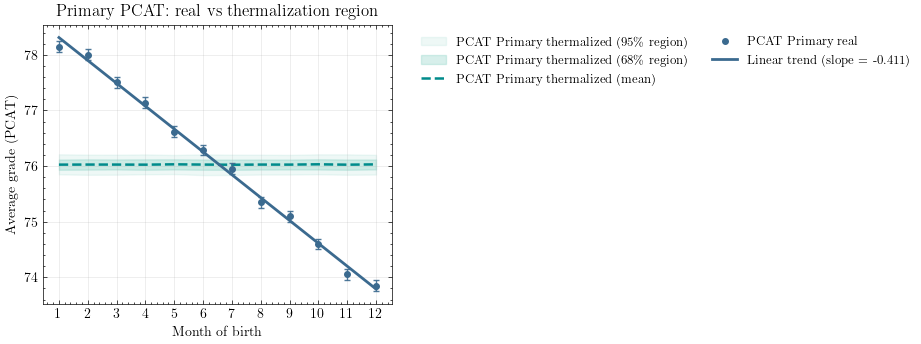

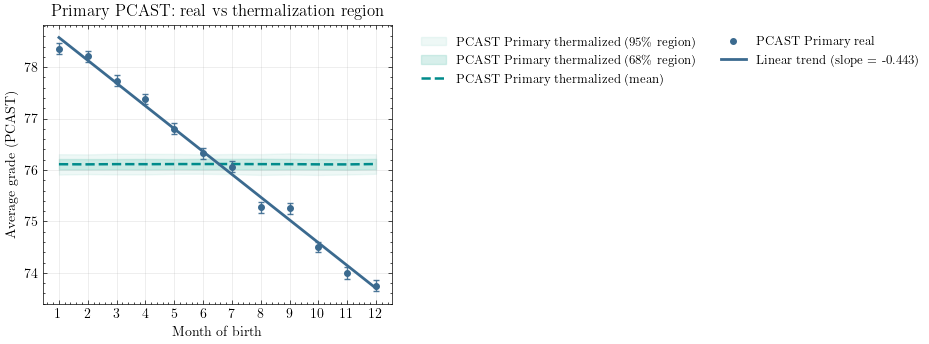

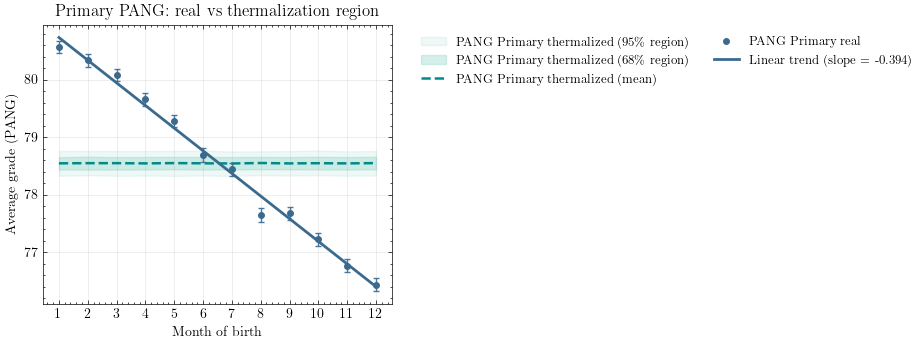

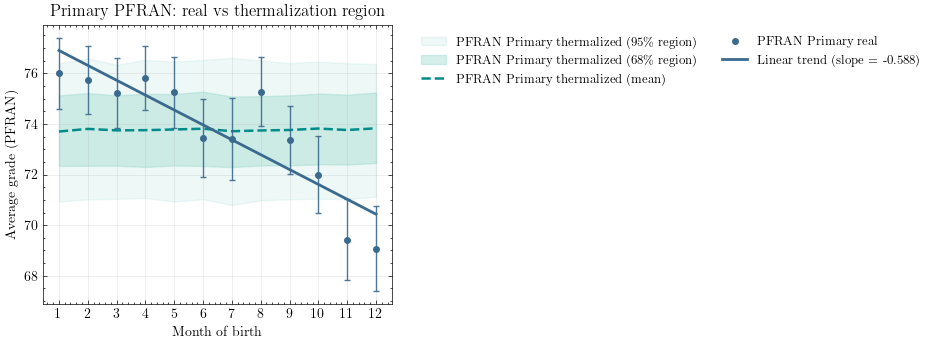

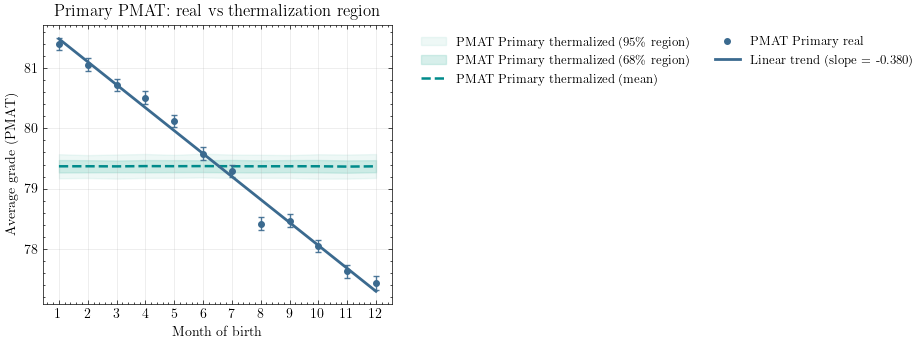

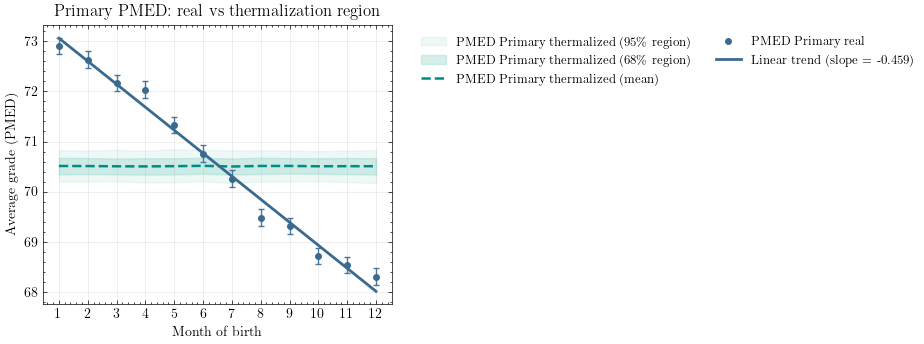

In [21]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# 3. Plot and save all subjects (Primary)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_P:
    summary_P = primary_summaries[subj]

    months      = summary_P['month'].values
    real_mean   = summary_P['real_mean'].values
    real_sem    = summary_P['real_sem'].values       # from updated thermalize[web:280][web:282]
    band_min    = summary_P['band_min'].values
    band_max    = summary_P['band_max'].values
    band_mean   = summary_P['null_mean'].values
    band_p16    = summary_P['band_p16'].values       # ~68% inner band[web:275][web:276]
    band_p84    = summary_P['band_p84'].values
    band_p2_5   = summary_P['band_p2_5'].values      # ~95% outer band[web:275][web:276]
    band_p97_5  = summary_P['band_p97_5'].values

    fig, ax = plt.subplots(figsize=(4.5, 3.625))     # keep your original panel size[web:262][web:268]

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # ----- Outer thermalized band (~95% central region) -----
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} Primary thermalized (95\% region)'
    )  # lighter, wide band

    # ----- Inner thermalized band (~68% central region) -----
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} Primary thermalized (68\% region)'
    )  # darker, core region

    # (Optional) if you still want the absolute envelope, you can draw it very faint:
    # ax.fill_between(months, band_min, band_max, color=band_color, alpha=0.05)

    # Thermalized mean line (no markers)
    ax.plot(
        months, band_mean,
        linestyle='--', linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} Primary thermalized (mean)'
    )  # null mean curve[web:219][web:241]

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} Primary real'
    )  # point estimates per month[web:219]

    # Error bars for real means (SEM)
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )  # classic mean ± SEM bars[web:219][web:284]

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        # Regression line (no markers)
        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )  # trend over months[web:219]

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Primary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()

    filename = f"primary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


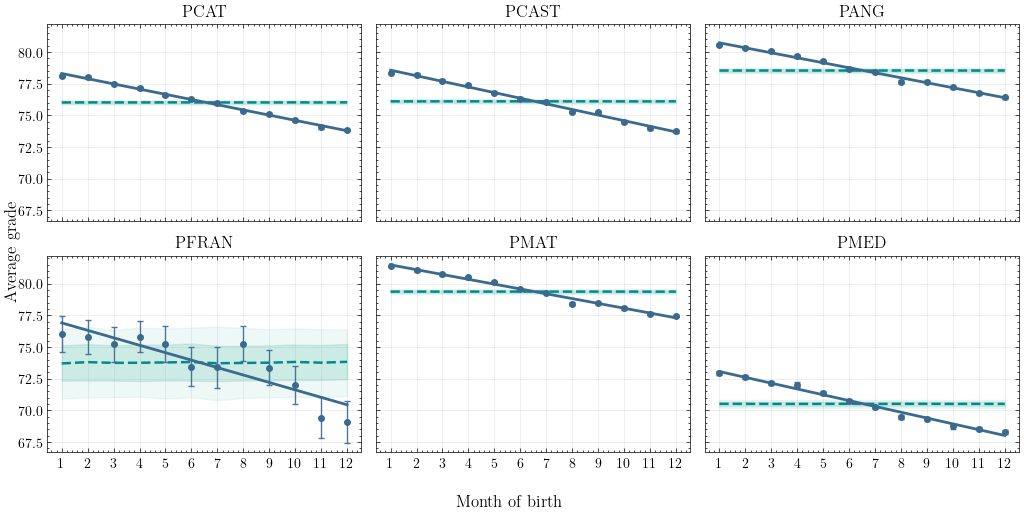

In [18]:
plt.style.use("itxaso.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# PRIMARY MAIN SUBJECTS (exclude French manually if you want)
# --------------------------------------------------------
subjects_P = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PMED']
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Primary subjects (no legends)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

n_subj = len(subjects_P)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625  # or 4.5, 3.625 if you prefer bigger panels
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True
)

axes = axes.flatten()

for ax, subj in zip(axes, subjects_P):
    summary_P = primary_summaries[subj]

    months      = summary_P['month'].values
    real_mean   = summary_P['real_mean'].values
    real_sem    = summary_P['real_sem'].values
    band_mean   = summary_P['null_mean'].values
    band_p16    = summary_P['band_p16'].values
    band_p84    = summary_P['band_p84'].values
    band_p2_5   = summary_P['band_p2_5'].values
    band_p97_5  = summary_P['band_p97_5'].values

    # Colors from your palette dict
    band_color  = palette['primary']['thermalized_band']
    mean_color  = palette['primary']['thermalized_mean_line']
    point_color = palette['primary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )

    # Thermalized mean line (no markers)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None
    )

    # Real mean points
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color
    )

    # Error bars on real means (SEM)
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )

    # Linear regression on real means
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None
        )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Hide unused axes if any
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
fig.savefig(
    os.path.join(plot_dir, "primary_all_subjects_multiplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()


In [22]:
#--------------------------
# SECONDARY MAIN SUBJECTS
#--------------------------
subjects_S = ['PCAT', 'PCAST', 'PANG', 'PFRAN', 'PMAT', 'PCIEN']
n_iter = 2000

# --------------------------------------------------------
# 2. Run analysis for all subjects
# --------------------------------------------------------
secondary_summaries = {}
secondary_sims = {}

for subj in subjects_S:
    df_subj_S = (
        df_S[['CODI_ALUMNE', 'MES_NAIXEMENT', subj]]
        .drop_duplicates(subset='CODI_ALUMNE')
        .rename(columns={subj: 'GRADE'})
    )

    summary_S, sim_S = thermalize_subject_by_month(
        df_level=df_subj_S,
        grade_col='GRADE',
        n_iter=n_iter,
        seed=84  # different seed from Primary if you want
    )

    summary_S['subject'] = subj
    summary_S['snapshot'] = 'Secondary'

    secondary_summaries[subj] = summary_S
    secondary_sims[subj] = sim_S

# Long-format dataset with all Secondary stats
df_stats_secondary_all = pd.concat(secondary_summaries.values(), ignore_index=True)


/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


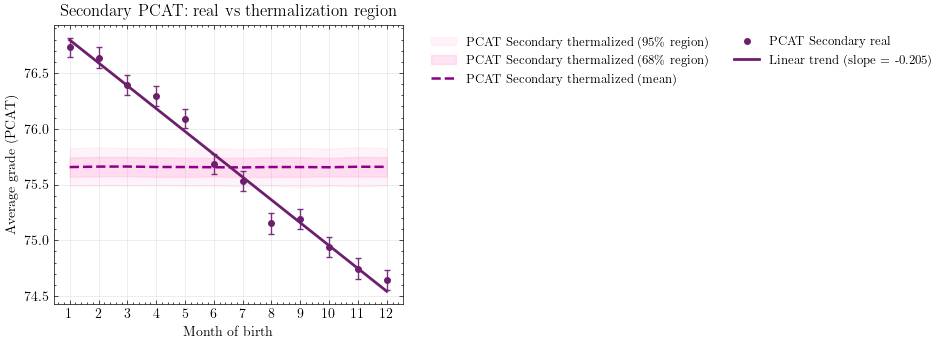

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


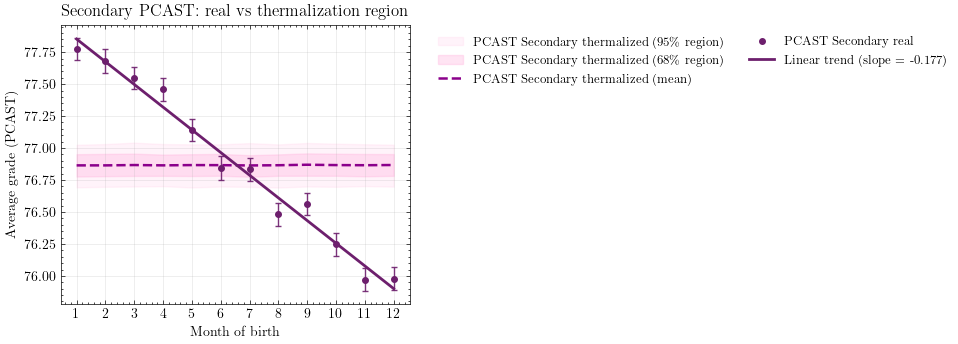

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


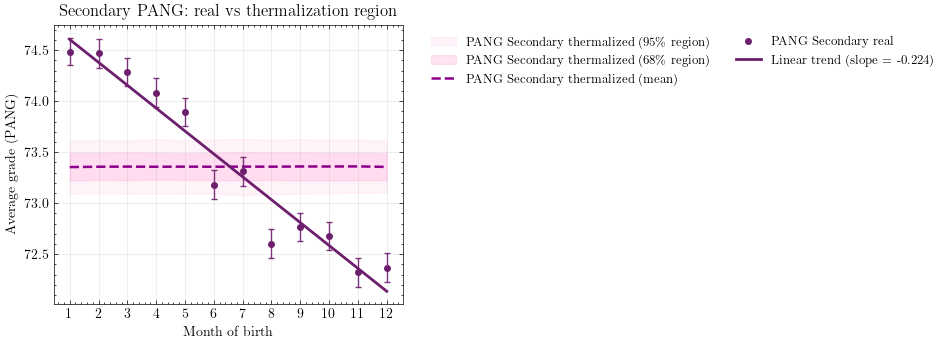

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


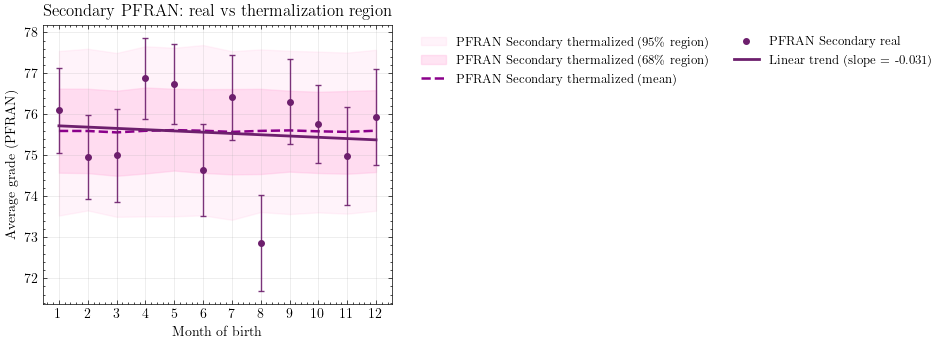

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


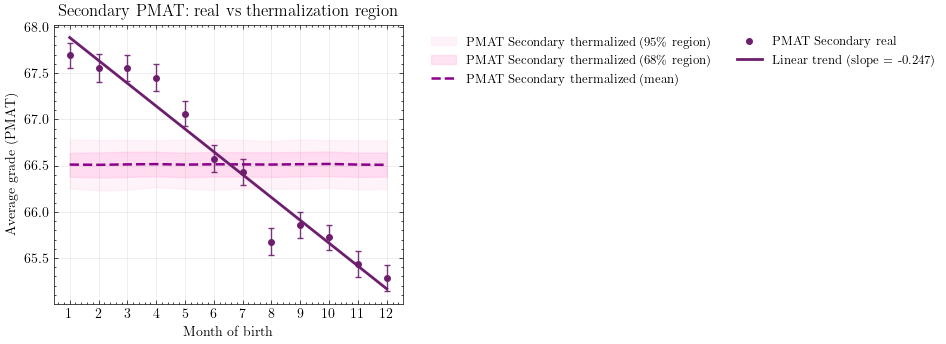

/var/folders/q8/ht1hgr5d6d1bwfgb2rnkpttw0000gp/T/ipykernel_25351/4027092079.py:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


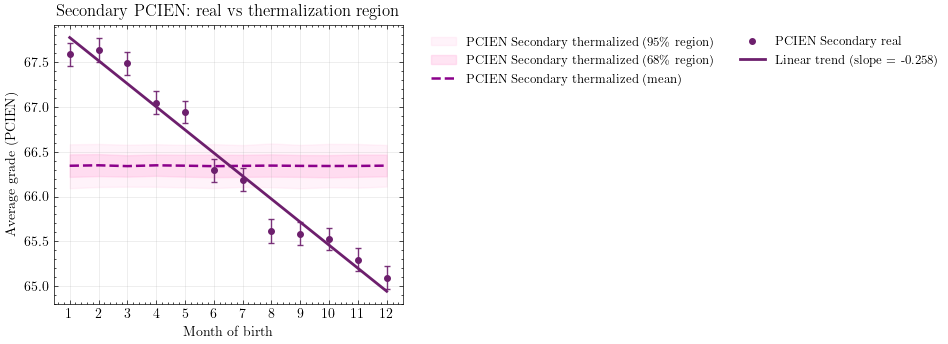

In [24]:
plt.style.use("itxaso.mplstyle")

# --------------------------------------------------------
# 3. Plot for all subjects (Secondary)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

for subj in subjects_S:
    summary_S = secondary_summaries[subj]

    months      = summary_S['month'].values
    real_mean   = summary_S['real_mean'].values
    real_sem    = summary_S['real_sem'].values        # from extended thermalize[web:315]
    band_mean   = summary_S['null_mean'].values
    band_p16    = summary_S['band_p16'].values        # ~68% band[web:275][web:276]
    band_p84    = summary_S['band_p84'].values
    band_p2_5   = summary_S['band_p2_5'].values       # ~95% band[web:275][web:276]
    band_p97_5  = summary_S['band_p97_5'].values

    fig, ax = plt.subplots(figsize=(4.5, 3.625))

    # Colors from your palette dict
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15,
        label=f'{subj} Secondary thermalized (95\% region)'
    )  # wide, light band[web:305][web:151]

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35,
        label=f'{subj} Secondary thermalized (68\% region)'
    )  # core, darker band[web:305][web:312]

    # Thermalized mean line (no markers)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None,
        label=f'{subj} Secondary thermalized (mean)'
    )

    # Real mean points (no connecting line)
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color,
        label=f'{subj} Secondary real'
    )

    # Error bars on real means (SEM)
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )  # vertical uncertainty bars[web:307][web:308]

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        # Regression line (no markers)
        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None,
            label=f'Linear trend (slope = {slope:.3f})'
        )

    ax.set_xlabel('Month of birth')
    ax.set_ylabel(f'Average grade ({subj})')
    ax.set_title(f'Secondary {subj}: real vs thermalization region')
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, ncol=2, loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.tight_layout()

    # Save to directory
    filename = f"secondary_{subj}_thermalization.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


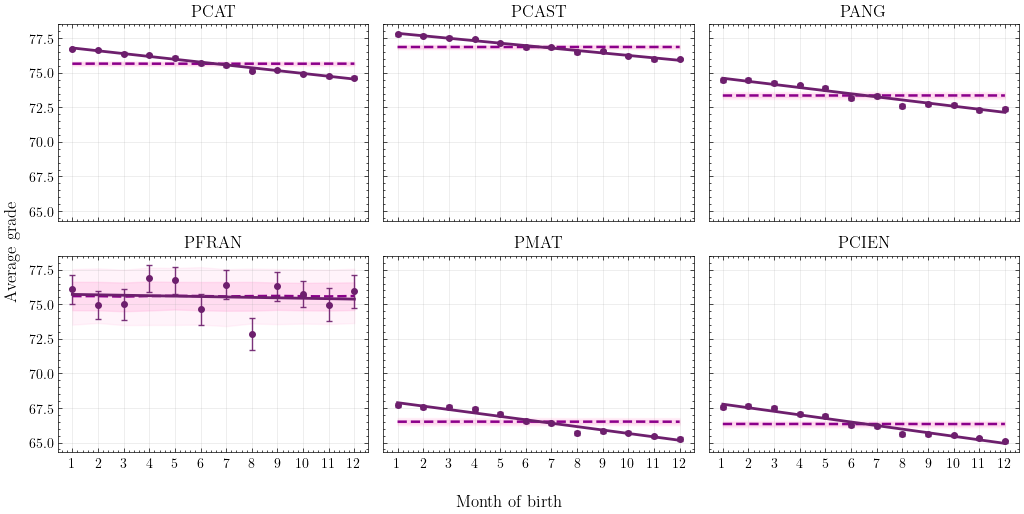

In [25]:
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

plt.style.use("itxaso.mplstyle")

#--------------------------
#       MULTIPLOT
#--------------------------

# --------------------------------------------------------
# SECONDARY MAIN SUBJECTS
# --------------------------------------------------------
# subjects_S already defined, e.g. ['SCAT', 'SCAST', 'SANG', 'SFRAN', 'SMAT', 'SMED']
n_iter = 2000

# --------------------------------------------------------
# Multiplot for all Secondary subjects (no legends)
# --------------------------------------------------------
plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

n_subj = len(subjects_S)
n_rows = 2
n_cols = 3
assert n_subj <= n_rows * n_cols

panel_w, panel_h = 3.5, 2.625
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * panel_w, n_rows * panel_h),
    sharex=True, sharey=True
)  # shared axes for consistent comparison[web:219][web:262]

axes = axes.flatten()

for ax, subj in zip(axes, subjects_S):
    summary_S = secondary_summaries[subj]

    months      = summary_S['month'].values
    real_mean   = summary_S['real_mean'].values
    real_sem    = summary_S['real_sem'].values
    band_mean   = summary_S['null_mean'].values
    band_p16    = summary_S['band_p16'].values
    band_p84    = summary_S['band_p84'].values
    band_p2_5   = summary_S['band_p2_5'].values
    band_p97_5  = summary_S['band_p97_5'].values

    # Colors from your palette dict (secondary)
    band_color  = palette['secondary']['thermalized_band']
    mean_color  = palette['secondary']['thermalized_mean_line']
    point_color = palette['secondary']['points']

    # Outer thermalized band (~95% central region)
    ax.fill_between(
        months, band_p2_5, band_p97_5,
        color=band_color, alpha=0.15
    )  # wide, light region[web:305][web:320]

    # Inner thermalized band (~68% central region)
    ax.fill_between(
        months, band_p16, band_p84,
        color=band_color, alpha=0.35
    )  # core, darker region[web:305][web:309]

    # Thermalized mean line (no markers)
    ax.plot(
        months, band_mean,
        linestyle='--',
        linewidth=1.8,
        color=mean_color,
        marker=None
    )

    # Real mean points (no line between them)
    ax.plot(
        months, real_mean,
        marker='o',
        markersize=4,
        linestyle='None',
        color=point_color
    )

    # Error bars on real means (SEM)
    ax.errorbar(
        months, real_mean,
        yerr=real_sem,
        fmt='none',
        ecolor=point_color,
        elinewidth=1.0,
        capsize=2,
        alpha=0.9,
        zorder=3
    )  # vertical uncertainty bars per month[web:322][web:315]

    # ----- Linear regression on real means -----
    mask = ~np.isnan(months) & ~np.isnan(real_mean)
    if mask.sum() >= 2:
        slope, intercept, r, p, se = linregress(months[mask], real_mean[mask])
        y_fit = intercept + slope * months

        # Regression line (no markers)
        ax.plot(
            months, y_fit,
            linewidth=2,
            linestyle='-',
            color=point_color,
            marker=None
        )

    ax.set_title(subj)
    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

# Remove unused axes if grid > number of subjects
for ax in axes[n_subj:]:
    ax.set_visible(False)

# Common labels on outer figure
fig.supxlabel('Month of birth')
fig.supylabel('Average grade')

fig.tight_layout()
fig.savefig(
    os.path.join(plot_dir, "secondary_all_subjects_multiplot.png"),
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#### Statistics

In [30]:
plt.style.use("itxaso.mplstyle")

cmap_icefire = sns.color_palette("icefire", as_cmap=True)

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_summary_heatmaps(df_stats, level_label, filename_prefix):
    """
    df_stats: df_stats_primary_all or df_stats_secondary_all
              must contain columns: subject, month, z_score
    Only plots the Z-score heatmap.
    """
    # Ensure month is numeric and sorted
    df = df_stats.copy()
    df['month'] = pd.to_numeric(df['month'], errors='coerce')
    df = df.dropna(subset=['month'])

    # Sorted unique months
    months_sorted = sorted(df['month'].unique())

    # Pivot: rows = subject, columns = month (Z-scores)
    z_pivot = (
        df.pivot_table(index='subject', columns='month', values='z_score')
          .reindex(columns=months_sorted)
    )

    # --- Z-score heatmap only ---
    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_pivot,
        ax=ax,
        cmap=cmap_icefire,     # keep Seaborn icefire, not style cycle
        center=0,
        annot=True,
        fmt='.1f',
        cbar_kws={'label': 'Z-score'}
    )  

    ax.set_title(f'{level_label} – Z-scores by subject and month')
    ax.set_ylabel('Subject')
    ax.set_xlabel('Month of birth')

    # Force x tick labels to be 1, 2, 3, ...
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)  # center ticks on cells
    ax.set_xticklabels(month_labels, rotation=0)

    fig.tight_layout()

    filename = f"{filename_prefix}_zscore_heatmap.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()


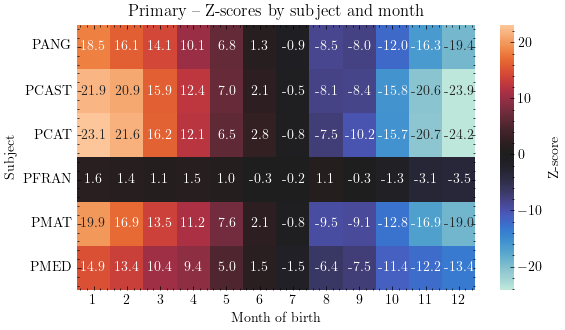

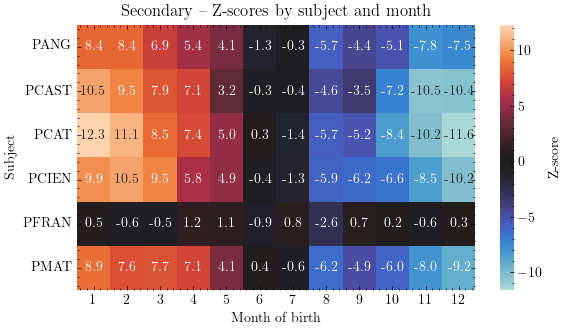

In [31]:
# Calls
plot_summary_heatmaps(df_stats_primary_all,  'Primary',   'primary')
plot_summary_heatmaps(df_stats_secondary_all, 'Secondary', 'secondary')

In [20]:
plt.style.use("itxaso.mplstyle")

cmap_icefire = sns.color_palette("icefire", as_cmap=True)  # keep Seaborn colormap

plot_dir = "itxaso-plots"
os.makedirs(plot_dir, exist_ok=True)

def plot_zscore_diff_secondary_minus_primary(df_stats_primary_all, df_stats_secondary_all):
    """
    Single heatmap of (Secondary z_score - Primary z_score)
    by subject and month.

    PMED (Primary) is treated as equivalent to PCIEN (Secondary),
    so PCIEN is renamed to PMED before comparison.
    """

    # --- Preprocess Primary ---
    dfP = df_stats_primary_all.copy()
    dfP['month'] = pd.to_numeric(dfP['month'], errors='coerce')
    dfP = dfP.dropna(subset=['month'])

    # --- Preprocess Secondary ---
    dfS = df_stats_secondary_all.copy()
    dfS['month'] = pd.to_numeric(dfS['month'], errors='coerce')
    dfS = dfS.dropna(subset=['month'])

    # Map Secondary subject codes to Primary equivalents where needed
    # PMED (Primary) ≡ PCIEN (Secondary)
    subject_map_S_to_P = {'PCIEN': 'PMED'}
    dfS['subject'] = dfS['subject'].replace(subject_map_S_to_P)

    # Common sorted months and subjects
    months_sorted = sorted(set(dfP['month'].unique()) | set(dfS['month'].unique()))
    subjects_sorted = sorted(set(dfP['subject'].unique()) | set(dfS['subject'].unique()))

    # Pivot to subject × month matrices
    zP = (
        dfP.pivot_table(index='subject', columns='month', values='z_score')
           .reindex(index=subjects_sorted, columns=months_sorted)
    )
    zS = (
        dfS.pivot_table(index='subject', columns='month', values='z_score')
           .reindex(index=subjects_sorted, columns=months_sorted)
    )

    # Difference: Secondary - Primary (aligned by subject+month)
    z_diff = zS - zP  # element-wise subtraction[web:228]

    # Symmetric color scale around 0
    diff_abs_max = np.nanmax(np.abs(z_diff.values))  # ignore NaNs for scale
    vmin, vmax = -diff_abs_max, diff_abs_max

    fig, ax = plt.subplots(figsize=(6, 3.5))

    sns.heatmap(
        z_diff,
        ax=ax,
        cmap=cmap_icefire,
        vmin=vmin, vmax=vmax,
        center=0,
        annot=True,
        fmt='.1f',
        cbar_kws={'label': 'Secondary − Primary z-score'}
    )  # [web:229][web:236]

    ax.set_title('Secondary − Primary Z-scores by subject and month')
    ax.set_ylabel('Subject')
    ax.set_xlabel('Month of birth')

    # X tick labels as 1..12 centered on cells
    month_labels = [str(int(m)) for m in months_sorted]
    ax.set_xticks(np.arange(len(months_sorted)) + 0.5)
    ax.set_xticklabels(month_labels, rotation=0)

    # Remove little tick marks but keep labels
    ax.tick_params(axis='both', length=0)  # no tick lines

    fig.tight_layout()

    filename = "zscore_secondary_minus_primary_heatmap.png"
    fig.savefig(os.path.join(plot_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()



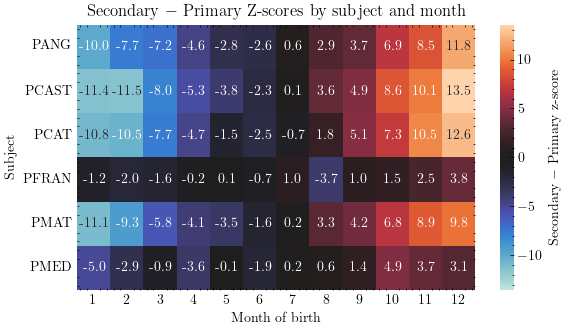

In [ ]:
# Call
plot_zscore_diff_secondary_minus_primary(df_stats_primary_all, df_stats_secondary_all)

- Fer les regressions lineals i agafar els pendents.

- Randomitzar les dades: com termalitzar, assignar cada nota a un mes de forma aleatòria.

    - Pintar el "fill between" entre les dades randomitzades i les reals.
    - Quan randomitzem, ho fem molts cops. 10, 20, 100 cops, no sé. Llavors, aquestes línies puntejades, fem una "línea gruixida" o ombra.
    - Després, quan pintem les notes mitjanes, volem veure si els punts entren dins d'aquesta regió ombrejada o no. Així podem determinar, amb el grau de confiança que volguem
    (com un 10% dins de la zona ombrejada) si realment aquest comportament entra dins del soroll esperable o no.

- Calcular el Z score.

- Calcular el rang interquartílic.

Use two statistic parameters to improve my study. So far, as I have my thermalized grades with the uncertainty, I can graphically tell that the mean grades by months are out of the thermalized region. That helps me determine that it is not a random fact, but something related to older kids performing better than younger. 

I think it woul be interesting to compute -the Z score. -  interquartílic range. How could I implement this? Also, I only have studied math grades, but I would like to do more. It would be interesting to see, at som point, only one plot that tells the whole story.
